In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from sktime.forecasting.fbprophet import Prophet
from sklearn.linear_model import PoissonRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

from sktime.performance_metrics.forecasting import mean_absolute_error
from sklearn.metrics import make_scorer

# Configurar pandas para que no trunque las salidas
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)


DEFINICION DE VARIABLES

PARÁMETROS


In [2]:
# Filtros para combinaciones de Almacen y SKU
sucursales_evaluar = 75
skus_evaluar = 10

# Numero de semanas a predecir 
fh = 3 # numero de semanas a evaluar
cv_n_splits = 5
lags_evaluar = [4, 5, 6, 7]
minimo_semanas_evaluar = fh+cv_n_splits+7

# Filtro de almacenes de distribucion
almacenes_excluir = ['FULL', 'ALMACEN CENTRAL', 'AMAZON', 'ADITIVO MATRIZ']

# Hiperparámetros por modelo
param_grid_poisson = {
    'alpha': [0.1, 1.0, 10.0],
    'max_iter': [250, 500]
}

param_grid_xgboost = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7, 10]
}

param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
}

param_grid_prophet = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 0.5, 1.0]
}

rango_semanas_promedio_aditivo = range(4, 8)

# Definir la métrica de evaluación
scoring = make_scorer(mean_absolute_error, greater_is_better=False)

# Definir TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=cv_n_splits)



FUNCIONES


In [3]:
# Función para obtener el número de semana de manera
def get_week_number(dt):
    try:
        return dt.weekofyear
    except AttributeError:
        return dt.isocalendar().week

# Función para crear lags
def create_lags(df, column, lags):
    for lag in range(1, lags + 1):
        df[f'{column}_lag_{lag}'] = df[column].shift(lag)
    return df


In [4]:
# Definir la función `prediccion_aditivo`
def prediccion_aditivo(y, X_test, num_semanas):
    # Obtener las fechas de X_test
    dates = X_test.index
    
    # Inicializar y_pred como un array de ceros del mismo tamaño que X_test
    y_pred = np.zeros(len(X_test))
    
    # Copiar la serie original para no modificarla directamente
    y_extended = y.copy()
    
    # Iterar sobre cada fecha en X_test
    for i, date in enumerate(dates):
        # Obtener las últimas num_semanas semanas (o las disponibles) previas a la fecha actual
        last_weeks = y_extended.iloc[-num_semanas:] if i == 0 else y_extended.iloc[-num_semanas-1:]
        
        # Calcular el promedio de ventas
        if len(last_weeks) > 0:
            average_sales = np.mean(last_weeks)
            average_sales = int(np.ceil(average_sales))
        else:
            average_sales = 0
        
        # Asignar el promedio calculado como la predicción para la fecha actual
        y_pred[i] = average_sales
        
        # Añadir la predicción a y_extended para usarla en futuras iteraciones
        y_extended = pd.concat([y_extended, pd.Series([average_sales], index=[date])])
    
    return y_pred


LECTURA DE DATOS


In [5]:
# Diccionario de mapeo de tipos de datos por columna
dtype_dict = {
    'AÑO_VENTA': 'int16',
    'SEMANA_VENTA': 'int8',
    'NOMBRE_ALMACEN': 'category',
    'POBLACION': 'category',
    'MUNICIPIO': 'category',
    'ESTADO': 'category',
    'CODIGO_POSTAL': 'category',
    'TIPO_UBICACION': 'category',
    'CATEGORIA_TIENDA': 'category',
    'CLIMA': 'category',
    'TIPO_TIENDA': 'category',
    'SKU': 'category',
    'PROVEEDOR': 'category',
    'DEPARTAMENTO': 'category',
    'LINEA': 'category',
    'SUBLINEA': 'category',
    'TEMPORADA': 'category',
    'AÑO_PRIMERA_VENTA': 'category',
    'MARCA': 'category',
    'ESTILO_VIDA': 'category',
    'ESTATUS_NUESTRO': 'category',
    'ORIGEN': 'category',
    'RUTINA_ESPECIAL': 'category',
    'RESURTIDO_one_SHOT': 'category',
    'CANTIDAD': 'int8',
    'IMPORTE': 'float64'
}

# Leer datos del csv ya transformado y filtrado
df = pd.read_csv('Datos/Ventas_Resurtibles.csv', parse_dates=['FECHA'], thousands=',', dtype=dtype_dict)
df_original = df

# Asegurarse que fecha tiene formato correcto
df['FECHA'] = pd.to_datetime(df['FECHA'])


In [6]:
df

FECHA  AÑO_VENTA  SEMANA_VENTA   NOMBRE_ALMACEN         SKU  \
0      2022-01-03       2022             1        4 CAMINOS  T23C2139GD   
1      2022-01-03       2022             1        4 CAMINOS  T23C2139MD   
2      2022-01-03       2022             1        4 CAMINOS  T6C01007CH   
3      2022-01-03       2022             1  ALMACEN CENTRAL  T23C2139GD   
4      2022-01-03       2022             1           AMAZON  T23C2139MD   
...           ...        ...           ...              ...         ...   
136714 2024-07-01       2024            26       XOCHIMILCO  TBAD3011MD   
136715 2024-07-01       2024            26       XOCHIMILCO  TBAD3012CH   
136716 2024-07-01       2024            26       XOCHIMILCO  TBAD3012EG   
136717 2024-07-01       2024            26       XOCHIMILCO  TH29D312EG   
136718 2024-07-01       2024            26       XOCHIMILCO  TH29D312GD   

                  POBLACION            MUNICIPIO            ESTADO  \
0       Naucalpan de Juárez  Naucalpan de Juárez  Estado de México   
1       Naucalpan de Juárez  Naucalpan de Juárez  Estado de México   
2       Naucalpan de Juárez  Naucalpan de Juárez  Estado de México   
3       Naucalpan de Juárez  Naucalpan de Juárez           Virtual   
4        Cuautitlán Izcalli   Cuautitlán Izcalli           Virtual   
...                     ...                  ...               ...   
136714     Ciudad de México           Xochimilco  Ciudad de México   
136715     Ciudad de México           Xochimilco  Ciudad de México   
136716     Ciudad de México           Xochimilco  Ciudad de México   
136717     Ciudad de México           Xochimilco  Ciudad de México   
136718     Ciudad de México           Xochimilco  Ciudad de México   

       CODIGO_POSTAL                  TIPO_UBICACION CATEGORIA_TIENDA  \
0              53489  Estacion de Tren Ligero CETRAM          Impulso   
1              53489  Estacion de Tren Ligero CETRAM          Impulso   
2              53489  Estacion de Tren Ligero CETRAM          Impulso   
3              53370                         Virtual          Virtual   
4              54769                         Virtual          Virtual   
...              ...                             ...              ...   
136714         16090                           Calle          Impulso   
136715         16090                           Calle          Impulso   
136716         16090                           Calle          Impulso   
136717         16090                           Calle          Impulso   
136718         16090                           Calle          Impulso   

           CLIMA TIPO_TIENDA PROVEEDOR DEPARTAMENTO    LINEA     SUBLINEA  \
0       Templado   Show Room   ADITIVO       CHAVOS  PLAYERA  MANGA LARGA   
1       Templado   Show Room   ADITIVO       CHAVOS  PLAYERA  MANGA LARGA   
2       Templado   Show Room   ADITIVO       CHAVOS  PLAYERA  MANGA CORTA   
3        Virtual     Virtual   ADITIVO       CHAVOS  PLAYERA  MANGA LARGA   
4        Virtual     Virtual   ADITIVO       CHAVOS  PLAYERA  MANGA LARGA   
...          ...         ...       ...          ...      ...          ...   
136714  Templado   Show Room   ADITIVO       CHAVAS  PLAYERA  MANGA CORTA   
136715  Templado   Show Room   ADITIVO       CHAVAS  PLAYERA    SIN MANGA   
136716  Templado   Show Room   ADITIVO       CHAVAS  PLAYERA    SIN MANGA   
136717  Templado   Show Room   ADITIVO       CHAVAS  PLAYERA  MANGA CORTA   
136718  Templado   Show Room   ADITIVO       CHAVAS  PLAYERA  MANGA CORTA   

          TEMPORADA AÑO_PRIMERA_VENTA    MARCA ESTILO_VIDA ESTATUS_NUESTRO  \
0       TODO EL AÑO              2021  ADITIVO      CASUAL           LINEA   
1       TODO EL AÑO              2021  ADITIVO      CASUAL           LINEA   
2       TODO EL AÑO              2013  ADITIVO        COOL           LINEA   
3       TODO EL AÑO              2021  ADITIVO      CASUAL           LINEA   
4       TODO EL AÑO              2021  ADITIVO      CASUAL           LINEA   


Se hace un filtrado de datos donde se eliminan los almacenes de distribucion y definen columnas

Consideraciones:
    - Se quita la ultima semana de datos por que esta incompleta
    - Se quitan almacenene de distribucion
    - Se quitan datos de localizacion de los almacenes y se deja unicamente el estado
    - Se quita varias columnas que tienen una sola categoria y son datos irrelevantes para el modelo

In [19]:
# Paso 1: Quitar la última semana de datos (posiblemente incompleta)
ultima_fecha = df['FECHA'].max()
df = df[df['FECHA'] != ultima_fecha]

# Paso 2: Obtener la primera fecha de venta para cada SKU
fecha_primera_venta = df.groupby('SKU', observed=False)['FECHA'].min().reset_index()
fecha_primera_venta.columns = ['SKU', 'PRIMERA_FECHA']

# Paso 3: Unir esta información al DataFrame original
df = pd.merge(df, fecha_primera_venta, on='SKU')

# Paso 4: Quitar almacenes de distribución
df = df[~df['NOMBRE_ALMACEN'].isin(almacenes_excluir)]

# Paso 5: Contar el número de semanas de venta por cada SKU
semanas_venta_por_sku = df.groupby('SKU', observed=False)['FECHA'].nunique().reset_index()
semanas_venta_por_sku.columns = ['SKU', 'NUM_SEMANAS']

# Paso 6: Quitar los SKU que tienen menos del mínimo de semanas a evaluar
sku_filtrados = semanas_venta_por_sku[semanas_venta_por_sku['NUM_SEMANAS'] > minimo_semanas_evaluar]['SKU']
df = df[df['SKU'].isin(sku_filtrados)]

# Paso 7: Mejores almacenes por importe de venta
df_top_stores = df.groupby('NOMBRE_ALMACEN', observed=False)['IMPORTE'].sum()
df_top_stores = df_top_stores.sort_values(ascending=False).head(sucursales_evaluar)
top_stores = df_top_stores.index.tolist()

# Paso 8: Mejores SKU por cada almacén en base a cantidad de ventas
top_sku_almacen = []
for almacen in top_stores:
    df_almacen = df[df['NOMBRE_ALMACEN'] == almacen]
    almacen_skus = df_almacen.groupby('SKU', observed=False)['IMPORTE'].sum().reset_index()
    almacen_skus = almacen_skus.nlargest(skus_evaluar, 'IMPORTE')
    almacen_skus = almacen_skus.sort_values(by='IMPORTE', ascending=False)  # Ordenar por importe de venta
    
    for index, row in almacen_skus.iterrows():
        top_sku_almacen.append({
            'NOMBRE_ALMACEN': almacen,
            'SKU': row['SKU'],
            'IMPORTE': row['IMPORTE']
        })

df_top_sku_por_almacen = pd.DataFrame(top_sku_almacen)

# Filtrar df para dejar únicamente las combinaciones de almacén/sku que existen en df_top_sku_almacen
df = df.merge(df_top_sku_por_almacen[['NOMBRE_ALMACEN', 'SKU']], on=['NOMBRE_ALMACEN', 'SKU'], how='inner')

# Elaboracion de tablas de categorias
columnas_almacen = ['POBLACION', 'MUNICIPIO', 'ESTADO', 'CODIGO_POSTAL', 'TIPO_UBICACION', 'CATEGORIA_TIENDA', 'CLIMA', 'TIPO_TIENDA']
coluimnas_sku = ['PROVEEDOR', 'DEPARTAMENTO', 'LINEA', 'SUBLINEA', 'TEMPORADA', 'AÑO_PRIMERA_VENTA', 'MARCA', 'ESTILO_VIDA', 'ESTATUS_NUESTRO', 'ORIGEN', 'RUTINA_ESPECIAL', 'RESURTIDO_one_SHOT']

df_datos_almacen = df[['NOMBRE_ALMACEN'] + columnas_almacen].drop_duplicates()
df_datos_sku = df[['SKU'] + coluimnas_sku].drop_duplicates()


# Paso 10: Reducir la cantidad de categorías
df = df.drop(['POBLACION', 'MUNICIPIO', 'CODIGO_POSTAL', 'ESTATUS_NUESTRO', 'TEMPORADA', 'RUTINA_ESPECIAL', 'RESURTIDO_one_SHOT', 'AÑO_VENTA', 'SEMANA_VENTA', 'IMPORTE'], axis=1, errors='ignore')


En este segmento se rellenan los huecos de las semanas en las que no hubo venta deuna combinacion especifica. Solo se rellenan huecos de que se empezo a vender el SKU en adelante

In [7]:
# Rellenar huecos en ventas con 0
print("Suma Total de Cantidad: ", df['CANTIDAD'].sum())
print("Registros Antes de Rellenar: ", len(df))

# Crear un rango de fechas semanales basado en las fechas del dataframe original
fecha_inicio = df['FECHA'].min()
fecha_fin = df['FECHA'].max()

# Obtener DataFrame con todas las fechas semanales
fechas_semanales = pd.date_range(start=fecha_inicio, end=fecha_fin, freq='W-MON')
fechas_semanales_df = pd.DataFrame({'FECHA': fechas_semanales})

# Crear un dataframe auxiliar con todas las combinaciones de FECHA, NOMBRE_ALMACEN, SKU, y otras columnas únicas
columnas_unicas = ['ESTADO', 'TIPO_UBICACION', 'CATEGORIA_TIENDA', 'CLIMA', 'TIPO_TIENDA', 'PROVEEDOR', 'DEPARTAMENTO', 
                   'LINEA', 'SUBLINEA', 'AÑO_PRIMERA_VENTA', 'MARCA', 'ESTILO_VIDA', 'ORIGEN', 'PRIMERA_FECHA']
almacenes_skus = df[['NOMBRE_ALMACEN', 'SKU'] + columnas_unicas].drop_duplicates()

# Ordenar almacenes_skus por NOMBRE_ALMACEN y SKU
almacenes_skus = almacenes_skus.sort_values(by=['NOMBRE_ALMACEN', 'SKU'])

# Crear todas las combinaciones posibles de FECHA, NOMBRE_ALMACEN, SKU y columnas únicas
combinaciones = fechas_semanales_df.merge(almacenes_skus, how='cross')

# Realizar el merge
df_nuevo = pd.merge(df, combinaciones, on=['FECHA', 'NOMBRE_ALMACEN', 'SKU'] + columnas_unicas, how='right')

# Rellenar los huecos en CANTIDAD con 0, pero solo a partir de la primera fecha de venta
df_nuevo['CANTIDAD'] = df_nuevo.apply(lambda row: 0 if (row['FECHA'] >= row['PRIMERA_FECHA'] and pd.isna(row['CANTIDAD'])) else row['CANTIDAD'], axis=1)

# Eliminar PRIMERA_FECHA por que es una columna auxiliar
df_nuevo = df_nuevo.drop(columns=['PRIMERA_FECHA'])

# Eliminar las filas que todavía tienen NaN en CANTIDAD
df_nuevo = df_nuevo.dropna(subset=['CANTIDAD'])

# Ordenar el df resultante
df_nuevo = df_nuevo.sort_values(by=['NOMBRE_ALMACEN', 'SKU', 'FECHA']).reset_index(drop=True)

df = df_nuevo

print("Suma Total de Cantidad: ", df['CANTIDAD'].sum())
print("Registros Despues de Rellenar: ", len(df))


Suma Total de Cantidad:  26083
Registros Antes de Rellenar:  18985
Suma Total de Cantidad:  26083.0
Registros Despues de Rellenar:  81249


In [8]:
original_counts = df.groupby(['NOMBRE_ALMACEN', 'SKU'], observed=True).agg(
    NUM_REGISTROS=('FECHA', 'size'),
    SUMA_CANTIDAD=('CANTIDAD', 'sum')
).reset_index()
print(original_counts)

            NOMBRE_ALMACEN         SKU  NUM_REGISTROS  SUMA_CANTIDAD
0                4 CAMINOS  T23C2139CH            130        57.0000
1                4 CAMINOS  T23C2139EG            130        29.0000
2                4 CAMINOS  T23C2139GD            130        60.0000
3                4 CAMINOS  T23C2139MD            130        97.0000
4                4 CAMINOS  T6C01007CH            130        42.0000
5                4 CAMINOS  T6C01007EG            130        58.0000
6                4 CAMINOS  T6C01007GD            130        65.0000
7                4 CAMINOS  T6C01007MD            130       106.0000
8                4 CAMINOS  TA4D3027MD             17        37.0000
9                4 CAMINOS  TBAD3009MD             30        76.0000
10                 APIZACO  T23C2139CH            130        36.0000
11                 APIZACO  T23C2139EG            130        20.0000
12                 APIZACO  T23C2139GD            130        35.0000
13                 APIZACO  T23C21

In [498]:
# Definimos las columnas a codificar
columns_to_encode = [
    'ESTADO', 'TIPO_UBICACION', 'CATEGORIA_TIENDA', 'CLIMA', 'TIPO_TIENDA', 'PROVEEDOR', 'DEPARTAMENTO',
    'LINEA', 'SUBLINEA','AÑO_PRIMERA_VENTA', 'MARCA', 'ESTILO_VIDA', 'ORIGEN'
]

# Crear una instancia de OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Realizar el ajuste y la transformación de una sola vez
encoded_array = enc.fit_transform(df[columns_to_encode])

# Crear un DataFrame de los datos codificados
encoded_df = pd.DataFrame(encoded_array, columns=enc.get_feature_names_out(columns_to_encode))

# Seleccionar columnas que no necesitan codificación
columns_to_keep_1 = ['FECHA', 'NOMBRE_ALMACEN', 'SKU']
columns_to_keep_2 = ['CANTIDAD']

# Concatenar las columnas codificadas con las columnas no codificadas
df_encoded = pd.concat([df[columns_to_keep_1].reset_index(drop=True), encoded_df, df[columns_to_keep_2].reset_index(drop=True)], axis=1)


In [499]:
# Busqueda del mejor modelo con los mejores hiperparametros
resultados = []

# Inicializar el DataFrame de predicciones
df_predicciones = pd.DataFrame()

for index, row in almacenes_skus.iterrows():
    almacen = row['NOMBRE_ALMACEN']
    sku = row['SKU']
    
    print("Evaluando Almacen", almacen, "SKU", sku)

    df_temp = df_encoded[(df_encoded['NOMBRE_ALMACEN'] == almacen) & (df_encoded['SKU'] == sku)]
    df_temp = df_temp.sort_values(by='FECHA')
    df_temp['FECHA'] = pd.to_datetime(df_temp['FECHA'])
    df_temp = df_temp.set_index('FECHA')

    if df_temp.index.inferred_freq is None:
        df_temp = df_temp.asfreq('W-MON')

    resultados_por_lag = []
    
    for lags in lags_evaluar:
        print(f'  Evaluando con {lags} lags')
        df_temp_lagged = create_lags(df_temp.copy(), 'CANTIDAD', lags)
        df_temp_lagged = df_temp_lagged.dropna()
        
        X = df_temp_lagged.drop(columns=['NOMBRE_ALMACEN', 'SKU', 'CANTIDAD'])
        y = df_temp_lagged['CANTIDAD']

        y.index = pd.to_datetime(df_temp_lagged.index)
        X.index = pd.to_datetime(df_temp_lagged.index)
        
        # Dividir los datos en entrenamiento y prueba
        X_train = X.iloc[:-fh]  # Todas las fechas excepto las últimas 3 semanas
        X_test = X.iloc[-fh:]   # Las últimas 3 semanas
        y_train = y.loc[X_train.index]
        y_test = y.loc[X_test.index]

        # Random Forest
        print('    Evaluando Random Forest')
        grid_search_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=param_grid_rf, cv=tscv, scoring=scoring)
        grid_search_rf.fit(X_train, y_train)
        best_rf = grid_search_rf.best_estimator_
        best_rf_params =  grid_search_rf.best_params_
        y_pred_rf = best_rf.predict(X_test).astype(int)
        mae_rf = mean_absolute_error(y_test, y_pred_rf)

        # Prophet
        print('    Evaluando Prophet')
        best_prophet_por_lag = None
        best_params_prophet_por_lag = None
        best_mae_prophet_por_lag = float('inf')

        for seasonality_mode in param_grid_prophet['seasonality_mode']:
            for changepoint_prior_scale in param_grid_prophet['changepoint_prior_scale']:
                try:
                    prophet = Prophet(seasonality_mode=seasonality_mode, changepoint_prior_scale=changepoint_prior_scale)
                    prophet.fit(y_train)
                    y_pred_prophet = prophet.predict(fh=X_test.index)
                    mae_prophet = mean_absolute_error(y_test, y_pred_prophet)
                    if mae_prophet < best_mae_prophet_por_lag:
                        best_mae_prophet_por_lag = mae_prophet
                        best_prophet_por_lag = prophet
                        best_params_prophet_por_lag = {'seasonality_mode': seasonality_mode, 'changepoint_prior_scale': changepoint_prior_scale}
                except:
                    continue

        y_pred_prophet = best_prophet_por_lag.predict(fh=X_test.index).astype(int)
        mae_prophet = mean_absolute_error(y_test, y_pred_prophet)

        # Aditivo Modificado. Se llama asi por que tunea el numero de semanas proimedio a utilizar
        best_mae_aditivo_modificado = float('inf')
        best_weeks_por_lag = None
        y_pred_aditivo_modificado_best = []
        
        print('    Evaluando Modelo Aditivo Modificado')
        for num_weeks in rango_semanas_promedio_aditivo:
            y_pred_aditivo_modificado = prediccion_aditivo(y, X_test, num_weeks)  
            y_pred_aditivo_modificado_best = y_pred_aditivo_modificado       
            mae_aditivo_modificado = mean_absolute_error(y_test, y_pred_aditivo_modificado)

            if mae_aditivo_modificado < best_mae_aditivo_modificado:
                best_mae_aditivo_modificado = mae_aditivo_modificado
                best_weeks_por_lag = num_weeks        
        
        # XGBoost
        print('    Evaluando XG Boost')
        grid_search_xgboost = GridSearchCV(estimator=XGBRegressor(objective='reg:squarederror'), param_grid=param_grid_xgboost, cv=tscv, scoring=scoring)
        grid_search_xgboost.fit(X_train, y_train)
        best_xgboost = grid_search_xgboost.best_estimator_
        best_xgboost_params = grid_search_xgboost.best_params_
        y_pred_xgboost = best_xgboost.predict(X_test).astype(int)
        mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
        
        # Regresion Poisson
        print('    Evaluando Regresion Poisson')
        grid_search_poisson = GridSearchCV(estimator=PoissonRegressor(), param_grid=param_grid_poisson, cv=tscv, scoring=scoring)
        grid_search_poisson.fit(X_train, y_train)
        best_poisson = grid_search_poisson.best_estimator_
        best_poisson_params = grid_search_poisson.best_params_
        y_pred_poisson = best_poisson.predict(X_test).astype(int)
        mae_poisson = mean_absolute_error(y_test, y_pred_poisson)

        maes_por_lag = {
            'xgboost': mae_xgboost,
            'rf': mae_rf,
            'prophet': best_mae_prophet_por_lag,
            'poisson': mae_poisson,
            'aditivo_modificado': best_mae_aditivo_modificado,
        }

        # Calcular el MAE del baseline aditivo_modificado con 6 semanas
        y_pred_aditivo_baseline = prediccion_aditivo(y, X_test, 6)
        mae_aditivo_baseline = mean_absolute_error(y_test, y_pred_aditivo_baseline)

        # En caso de empate, selecciona el primer modelo en orden de aparición
        best_model_name_por_lag = min(maes_por_lag, key=lambda x: (maes_por_lag[x], list(maes_por_lag.keys()).index(x)))
        best_mae_por_lag = maes_por_lag[best_model_name_por_lag]
        best_params_por_lag = {
            'xgboost': best_xgboost_params,
            'rf': best_rf_params,
            'prophet': best_params_prophet_por_lag,
            'poisson': best_poisson_params,
            'aditivo_modificado': {'num_weeks': best_weeks_por_lag},
        }.get(best_model_name_por_lag, {})

        resultados_por_lag.append({
            'almacen': almacen,
            'sku': sku,
            'best_model': best_model_name_por_lag,
            'best_model_params': best_params_por_lag,
            'lags': lags,
            'best_mae': best_mae_por_lag,
            'xgboost': maes_por_lag['xgboost'], 
            'rf': maes_por_lag['rf'], 
            'prophet': maes_por_lag['prophet'], 
            'poisson': maes_por_lag['poisson'], 
            'aditivo_modificado': maes_por_lag['aditivo_modificado'], 
            'aditivo_baseline': mae_aditivo_baseline,
        })

        # Guardar las predicciones de cada modelo 
        temp_predicciones_rf = pd.DataFrame({
            'FECHA': X_test.index,
            'NOMBRE_ALMACEN': [almacen] * len(X_test),
            'SKU': [sku] * len(X_test),
            'MODELO': ['RandomForest'] * len(X_test),
            'PARAMETROS': [str(best_rf_params)] * len(X_test),
            'LAGS': [lags] * len(X_test),
            'CANTIDAD': y_pred_rf
        }).reset_index(drop=True)

        temp_predicciones_prophet = pd.DataFrame({
            'FECHA': X_test.index,
            'NOMBRE_ALMACEN': [almacen] * len(X_test),
            'SKU': [sku] * len(X_test),
            'MODELO': ['Prophet'] * len(X_test),
            'PARAMETROS': [str(best_params_prophet_por_lag)] * len(X_test),
            'LAGS': [lags] * len(X_test),
            'CANTIDAD': y_pred_prophet
        }).reset_index(drop=True)

        temp_predicciones_xgboost = pd.DataFrame({
            'FECHA': X_test.index,
            'NOMBRE_ALMACEN': [almacen] * len(X_test),
            'SKU': [sku] * len(X_test),
            'MODELO': ['XGBoost'] * len(X_test),
            'PARAMETROS': [str(best_xgboost_params)] * len(X_test),
            'LAGS': [lags] * len(X_test),
            'CANTIDAD': y_pred_xgboost
        }).reset_index(drop=True)

        temp_predicciones_aditivo_modificado = pd.DataFrame({
            'FECHA': X_test.index,
            'NOMBRE_ALMACEN': [almacen] * len(X_test),
            'SKU': [sku] * len(X_test),
            'MODELO': ['AditivoModificado'] * len(X_test),
            'PARAMETROS': [str(best_weeks_por_lag)] * len(X_test),
            'LAGS': [lags] * len(X_test),
            'CANTIDAD': y_pred_aditivo_modificado_best
        }).reset_index(drop=True)

        temp_predicciones_poisson = pd.DataFrame({
            'FECHA': X_test.index,
            'NOMBRE_ALMACEN': [almacen] * len(X_test),
            'SKU': [sku] * len(X_test),
            'MODELO': ['Poisson'] * len(X_test),
            'PARAMETROS': [str(best_poisson_params)] * len(X_test),
            'LAGS': [lags] * len(X_test),
            'CANTIDAD': y_pred_poisson
        }).reset_index(drop=True)

        temp_predicciones_aditivo_baseline = pd.DataFrame({
            'FECHA': X_test.index,
            'NOMBRE_ALMACEN': [almacen] * len(X_test),
            'SKU': [sku] * len(X_test),
            'MODELO': ['AditivoBaseline'] * len(X_test),
            'PARAMETROS': ['6'] * len(X_test),
            'LAGS': [lags] * len(X_test),
            'CANTIDAD': y_pred_aditivo_baseline
        }).reset_index(drop=True)

        df_predicciones = pd.concat([df_predicciones, temp_predicciones_rf, temp_predicciones_prophet, temp_predicciones_xgboost, temp_predicciones_aditivo_modificado, temp_predicciones_poisson, temp_predicciones_aditivo_baseline], ignore_index=True)

    print()
    # Seleccionar el mejor lag basado en el menor best_mae
    mejor_lag = min(resultados_por_lag, key=lambda x: x['best_mae'])

    # Añadir solo el mejor lag a la lista de resultados
    resultados.append(mejor_lag)

df_resultados = pd.DataFrame(resultados)


Evaluando Almacen 4 CAMINOS SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


11:48:27 - cmdstanpy - INFO - Chain [1] start processing
11:48:27 - cmdstanpy - INFO - Chain [1] done processing
11:48:27 - cmdstanpy - INFO - Chain [1] start processing
11:48:27 - cmdstanpy - INFO - Chain [1] done processing
11:48:27 - cmdstanpy - INFO - Chain [1] start processing
11:48:27 - cmdstanpy - INFO - Chain [1] done processing
11:48:27 - cmdstanpy - INFO - Chain [1] start processing
11:48:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:48:27 - cmdstanpy - INFO - Chain [1] start processing
11:48:27 - cmdstanpy - INFO - Chain [1] done processing
11:48:27 - cmdstanpy - INFO - Chain [1] start processing
11:48:27 - cmdstanpy - INFO - Chain [1] done processing
11:48:27 - cmdstanpy - INFO - Chain [1] start processing
11:48:27 - cmdstanpy - INFO - Chain [1] done processing
11:48:27 - cmdstanpy - INFO - Chain [1] start processing
11:48:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:48:33 - cmdstanpy - INFO - Chain [1] start processing
11:48:33 - cmdstanpy - INFO - Chain [1] done processing
11:48:34 - cmdstanpy - INFO - Chain [1] start processing
11:48:34 - cmdstanpy - INFO - Chain [1] done processing
11:48:34 - cmdstanpy - INFO - Chain [1] start processing
11:48:34 - cmdstanpy - INFO - Chain [1] done processing
11:48:34 - cmdstanpy - INFO - Chain [1] start processing
11:48:34 - cmdstanpy - INFO - Chain [1] done processing
11:48:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:48:34 - cmdstanpy - INFO - Chain [1] done processing
11:48:34 - cmdstanpy - INFO - Chain [1] start processing
11:48:34 - cmdstanpy - INFO - Chain [1] done processing
11:48:34 - cmdstanpy - INFO - Chain [1] start processing
11:48:34 - cmdstanpy - INFO - Chain [1] done processing
11:48:34 - cmdstanpy - INFO - Chain [1] start processing
11:48:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:48:40 - cmdstanpy - INFO - Chain [1] start processing
11:48:40 - cmdstanpy - INFO - Chain [1] done processing
11:48:40 - cmdstanpy - INFO - Chain [1] start processing
11:48:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:48:40 - cmdstanpy - INFO - Chain [1] start processing
11:48:40 - cmdstanpy - INFO - Chain [1] done processing
11:48:40 - cmdstanpy - INFO - Chain [1] start processing
11:48:41 - cmdstanpy - INFO - Chain [1] done processing
11:48:41 - cmdstanpy - INFO - Chain [1] start processing
11:48:41 - cmdstanpy - INFO - Chain [1] done processing
11:48:41 - cmdstanpy - INFO - Chain [1] start processing
11:48:41 - cmdstanpy - INFO - Chain [1] done processing
11:48:41 - cmdstanpy - INFO - Chain [1] start processing
11:48:41 - cmdstanpy - INFO - Chain [1] done processing
11:48:41 - cmdstanpy - INFO - Chain [1] start processing
11:48:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:48:47 - cmdstanpy - INFO - Chain [1] start processing
11:48:47 - cmdstanpy - INFO - Chain [1] done processing
11:48:47 - cmdstanpy - INFO - Chain [1] start processing
11:48:47 - cmdstanpy - INFO - Chain [1] done processing
11:48:47 - cmdstanpy - INFO - Chain [1] start processing
11:48:47 - cmdstanpy - INFO - Chain [1] done processing
11:48:47 - cmdstanpy - INFO - Chain [1] start processing
11:48:47 - cmdstanpy - INFO - Chain [1] done processing
11:48:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:48:47 - cmdstanpy - INFO - Chain [1] done processing
11:48:47 - cmdstanpy - INFO - Chain [1] start processing
11:48:47 - cmdstanpy - INFO - Chain [1] done processing
11:48:47 - cmdstanpy - INFO - Chain [1] start processing
11:48:48 - cmdstanpy - INFO - Chain [1] done processing
11:48:48 - cmdstanpy - INFO - Chain [1] start processing
11:48:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen 4 CAMINOS SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


11:48:54 - cmdstanpy - INFO - Chain [1] start processing
11:48:54 - cmdstanpy - INFO - Chain [1] done processing
11:48:54 - cmdstanpy - INFO - Chain [1] start processing
11:48:54 - cmdstanpy - INFO - Chain [1] done processing
11:48:54 - cmdstanpy - INFO - Chain [1] start processing
11:48:54 - cmdstanpy - INFO - Chain [1] done processing
11:48:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:48:54 - cmdstanpy - INFO - Chain [1] done processing
11:48:55 - cmdstanpy - INFO - Chain [1] start processing
11:48:55 - cmdstanpy - INFO - Chain [1] done processing
11:48:55 - cmdstanpy - INFO - Chain [1] start processing
11:48:55 - cmdstanpy - INFO - Chain [1] done processing
11:48:55 - cmdstanpy - INFO - Chain [1] start processing
11:48:55 - cmdstanpy - INFO - Chain [1] done processing
11:48:55 - cmdstanpy - INFO - Chain [1] start processing
11:48:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:49:00 - cmdstanpy - INFO - Chain [1] start processing
11:49:00 - cmdstanpy - INFO - Chain [1] done processing
11:49:00 - cmdstanpy - INFO - Chain [1] start processing
11:49:00 - cmdstanpy - INFO - Chain [1] done processing
11:49:00 - cmdstanpy - INFO - Chain [1] start processing
11:49:00 - cmdstanpy - INFO - Chain [1] done processing
11:49:00 - cmdstanpy - INFO - Chain [1] start processing
11:49:00 - cmdstanpy - INFO - Chain [1] done processing
11:49:00 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:49:00 - cmdstanpy - INFO - Chain [1] done processing
11:49:00 - cmdstanpy - INFO - Chain [1] start processing
11:49:00 - cmdstanpy - INFO - Chain [1] done processing
11:49:00 - cmdstanpy - INFO - Chain [1] start processing
11:49:00 - cmdstanpy - INFO - Chain [1] done processing
11:49:00 - cmdstanpy - INFO - Chain [1] start processing
11:49:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:49:06 - cmdstanpy - INFO - Chain [1] start processing
11:49:06 - cmdstanpy - INFO - Chain [1] done processing
11:49:06 - cmdstanpy - INFO - Chain [1] start processing
11:49:06 - cmdstanpy - INFO - Chain [1] done processing
11:49:06 - cmdstanpy - INFO - Chain [1] start processing
11:49:06 - cmdstanpy - INFO - Chain [1] done processing
11:49:06 - cmdstanpy - INFO - Chain [1] start processing
11:49:06 - cmdstanpy - INFO - Chain [1] done processing
11:49:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:49:06 - cmdstanpy - INFO - Chain [1] done processing
11:49:06 - cmdstanpy - INFO - Chain [1] start processing
11:49:06 - cmdstanpy - INFO - Chain [1] done processing
11:49:06 - cmdstanpy - INFO - Chain [1] start processing
11:49:06 - cmdstanpy - INFO - Chain [1] done processing
11:49:07 - cmdstanpy - INFO - Chain [1] start processing
11:49:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:49:12 - cmdstanpy - INFO - Chain [1] start processing
11:49:13 - cmdstanpy - INFO - Chain [1] done processing
11:49:13 - cmdstanpy - INFO - Chain [1] start processing
11:49:13 - cmdstanpy - INFO - Chain [1] done processing
11:49:13 - cmdstanpy - INFO - Chain [1] start processing
11:49:13 - cmdstanpy - INFO - Chain [1] done processing
11:49:13 - cmdstanpy - INFO - Chain [1] start processing
11:49:13 - cmdstanpy - INFO - Chain [1] done processing
11:49:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:49:13 - cmdstanpy - INFO - Chain [1] done processing
11:49:13 - cmdstanpy - INFO - Chain [1] start processing
11:49:13 - cmdstanpy - INFO - Chain [1] done processing
11:49:13 - cmdstanpy - INFO - Chain [1] start processing
11:49:13 - cmdstanpy - INFO - Chain [1] done processing
11:49:13 - cmdstanpy - INFO - Chain [1] start processing
11:49:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen 4 CAMINOS SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


11:49:19 - cmdstanpy - INFO - Chain [1] start processing
11:49:19 - cmdstanpy - INFO - Chain [1] done processing
11:49:19 - cmdstanpy - INFO - Chain [1] start processing
11:49:19 - cmdstanpy - INFO - Chain [1] done processing
11:49:19 - cmdstanpy - INFO - Chain [1] start processing
11:49:19 - cmdstanpy - INFO - Chain [1] done processing
11:49:19 - cmdstanpy - INFO - Chain [1] start processing
11:49:19 - cmdstanpy - INFO - Chain [1] done processing
11:49:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:49:19 - cmdstanpy - INFO - Chain [1] done processing
11:49:19 - cmdstanpy - INFO - Chain [1] start processing
11:49:19 - cmdstanpy - INFO - Chain [1] done processing
11:49:19 - cmdstanpy - INFO - Chain [1] start processing
11:49:19 - cmdstanpy - INFO - Chain [1] done processing
11:49:19 - cmdstanpy - INFO - Chain [1] start processing
11:49:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:49:25 - cmdstanpy - INFO - Chain [1] start processing
11:49:25 - cmdstanpy - INFO - Chain [1] done processing
11:49:25 - cmdstanpy - INFO - Chain [1] start processing
11:49:25 - cmdstanpy - INFO - Chain [1] done processing
11:49:26 - cmdstanpy - INFO - Chain [1] start processing
11:49:26 - cmdstanpy - INFO - Chain [1] done processing
11:49:26 - cmdstanpy - INFO - Chain [1] start processing
11:49:26 - cmdstanpy - INFO - Chain [1] done processing
11:49:26 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:49:26 - cmdstanpy - INFO - Chain [1] done processing
11:49:26 - cmdstanpy - INFO - Chain [1] start processing
11:49:26 - cmdstanpy - INFO - Chain [1] done processing
11:49:26 - cmdstanpy - INFO - Chain [1] start processing
11:49:26 - cmdstanpy - INFO - Chain [1] done processing
11:49:26 - cmdstanpy - INFO - Chain [1] start processing
11:49:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:49:32 - cmdstanpy - INFO - Chain [1] start processing
11:49:32 - cmdstanpy - INFO - Chain [1] done processing
11:49:32 - cmdstanpy - INFO - Chain [1] start processing
11:49:32 - cmdstanpy - INFO - Chain [1] done processing
11:49:32 - cmdstanpy - INFO - Chain [1] start processing
11:49:32 - cmdstanpy - INFO - Chain [1] done processing
11:49:32 - cmdstanpy - INFO - Chain [1] start processing
11:49:32 - cmdstanpy - INFO - Chain [1] done processing
11:49:32 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:49:32 - cmdstanpy - INFO - Chain [1] done processing
11:49:32 - cmdstanpy - INFO - Chain [1] start processing
11:49:32 - cmdstanpy - INFO - Chain [1] done processing
11:49:32 - cmdstanpy - INFO - Chain [1] start processing
11:49:32 - cmdstanpy - INFO - Chain [1] done processing
11:49:32 - cmdstanpy - INFO - Chain [1] start processing
11:49:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:49:39 - cmdstanpy - INFO - Chain [1] start processing
11:49:39 - cmdstanpy - INFO - Chain [1] done processing
11:49:40 - cmdstanpy - INFO - Chain [1] start processing
11:49:40 - cmdstanpy - INFO - Chain [1] done processing
11:49:40 - cmdstanpy - INFO - Chain [1] start processing
11:49:40 - cmdstanpy - INFO - Chain [1] done processing
11:49:40 - cmdstanpy - INFO - Chain [1] start processing
11:49:40 - cmdstanpy - INFO - Chain [1] done processing
11:49:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:49:40 - cmdstanpy - INFO - Chain [1] done processing
11:49:40 - cmdstanpy - INFO - Chain [1] start processing
11:49:40 - cmdstanpy - INFO - Chain [1] done processing
11:49:40 - cmdstanpy - INFO - Chain [1] start processing
11:49:40 - cmdstanpy - INFO - Chain [1] done processing
11:49:40 - cmdstanpy - INFO - Chain [1] start processing
11:49:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen 4 CAMINOS SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


11:49:47 - cmdstanpy - INFO - Chain [1] start processing
11:49:47 - cmdstanpy - INFO - Chain [1] done processing
11:49:47 - cmdstanpy - INFO - Chain [1] start processing
11:49:47 - cmdstanpy - INFO - Chain [1] done processing
11:49:47 - cmdstanpy - INFO - Chain [1] start processing
11:49:47 - cmdstanpy - INFO - Chain [1] done processing
11:49:47 - cmdstanpy - INFO - Chain [1] start processing
11:49:47 - cmdstanpy - INFO - Chain [1] done processing
11:49:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:49:47 - cmdstanpy - INFO - Chain [1] done processing
11:49:47 - cmdstanpy - INFO - Chain [1] start processing
11:49:47 - cmdstanpy - INFO - Chain [1] done processing
11:49:47 - cmdstanpy - INFO - Chain [1] start processing
11:49:47 - cmdstanpy - INFO - Chain [1] done processing
11:49:47 - cmdstanpy - INFO - Chain [1] start processing
11:49:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:49:54 - cmdstanpy - INFO - Chain [1] start processing
11:49:54 - cmdstanpy - INFO - Chain [1] done processing
11:49:54 - cmdstanpy - INFO - Chain [1] start processing
11:49:54 - cmdstanpy - INFO - Chain [1] done processing
11:49:54 - cmdstanpy - INFO - Chain [1] start processing
11:49:54 - cmdstanpy - INFO - Chain [1] done processing
11:49:54 - cmdstanpy - INFO - Chain [1] start processing
11:49:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:49:54 - cmdstanpy - INFO - Chain [1] start processing
11:49:54 - cmdstanpy - INFO - Chain [1] done processing
11:49:54 - cmdstanpy - INFO - Chain [1] start processing
11:49:54 - cmdstanpy - INFO - Chain [1] done processing
11:49:55 - cmdstanpy - INFO - Chain [1] start processing
11:49:55 - cmdstanpy - INFO - Chain [1] done processing
11:49:55 - cmdstanpy - INFO - Chain [1] start processing
11:49:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:50:01 - cmdstanpy - INFO - Chain [1] start processing
11:50:01 - cmdstanpy - INFO - Chain [1] done processing
11:50:01 - cmdstanpy - INFO - Chain [1] start processing
11:50:01 - cmdstanpy - INFO - Chain [1] done processing
11:50:01 - cmdstanpy - INFO - Chain [1] start processing
11:50:01 - cmdstanpy - INFO - Chain [1] done processing
11:50:01 - cmdstanpy - INFO - Chain [1] start processing
11:50:01 - cmdstanpy - INFO - Chain [1] done processing
11:50:01 - cmdstanpy - INFO - Chain [1] start processing
11:50:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:50:01 - cmdstanpy - INFO - Chain [1] start processing
11:50:01 - cmdstanpy - INFO - Chain [1] done processing
11:50:02 - cmdstanpy - INFO - Chain [1] start processing
11:50:02 - cmdstanpy - INFO - Chain [1] done processing
11:50:02 - cmdstanpy - INFO - Chain [1] start processing
11:50:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:50:08 - cmdstanpy - INFO - Chain [1] start processing
11:50:08 - cmdstanpy - INFO - Chain [1] done processing
11:50:08 - cmdstanpy - INFO - Chain [1] start processing
11:50:08 - cmdstanpy - INFO - Chain [1] done processing
11:50:08 - cmdstanpy - INFO - Chain [1] start processing
11:50:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:50:08 - cmdstanpy - INFO - Chain [1] start processing
11:50:09 - cmdstanpy - INFO - Chain [1] done processing
11:50:09 - cmdstanpy - INFO - Chain [1] start processing
11:50:09 - cmdstanpy - INFO - Chain [1] done processing
11:50:09 - cmdstanpy - INFO - Chain [1] start processing
11:50:09 - cmdstanpy - INFO - Chain [1] done processing
11:50:09 - cmdstanpy - INFO - Chain [1] start processing
11:50:09 - cmdstanpy - INFO - Chain [1] done processing
11:50:09 - cmdstanpy - INFO - Chain [1] start processing
11:50:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen 4 CAMINOS SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


11:50:16 - cmdstanpy - INFO - Chain [1] start processing
11:50:16 - cmdstanpy - INFO - Chain [1] done processing
11:50:16 - cmdstanpy - INFO - Chain [1] start processing
11:50:16 - cmdstanpy - INFO - Chain [1] done processing
11:50:16 - cmdstanpy - INFO - Chain [1] start processing
11:50:16 - cmdstanpy - INFO - Chain [1] done processing
11:50:16 - cmdstanpy - INFO - Chain [1] start processing
11:50:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:50:16 - cmdstanpy - INFO - Chain [1] start processing
11:50:16 - cmdstanpy - INFO - Chain [1] done processing
11:50:16 - cmdstanpy - INFO - Chain [1] start processing
11:50:16 - cmdstanpy - INFO - Chain [1] done processing
11:50:16 - cmdstanpy - INFO - Chain [1] start processing
11:50:16 - cmdstanpy - INFO - Chain [1] done processing
11:50:16 - cmdstanpy - INFO - Chain [1] start processing
11:50:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:50:23 - cmdstanpy - INFO - Chain [1] start processing
11:50:23 - cmdstanpy - INFO - Chain [1] done processing
11:50:23 - cmdstanpy - INFO - Chain [1] start processing
11:50:23 - cmdstanpy - INFO - Chain [1] done processing
11:50:23 - cmdstanpy - INFO - Chain [1] start processing
11:50:23 - cmdstanpy - INFO - Chain [1] done processing
11:50:23 - cmdstanpy - INFO - Chain [1] start processing
11:50:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:50:23 - cmdstanpy - INFO - Chain [1] start processing
11:50:23 - cmdstanpy - INFO - Chain [1] done processing
11:50:23 - cmdstanpy - INFO - Chain [1] start processing
11:50:23 - cmdstanpy - INFO - Chain [1] done processing
11:50:23 - cmdstanpy - INFO - Chain [1] start processing
11:50:23 - cmdstanpy - INFO - Chain [1] done processing
11:50:23 - cmdstanpy - INFO - Chain [1] start processing
11:50:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:50:30 - cmdstanpy - INFO - Chain [1] start processing
11:50:30 - cmdstanpy - INFO - Chain [1] done processing
11:50:30 - cmdstanpy - INFO - Chain [1] start processing
11:50:30 - cmdstanpy - INFO - Chain [1] done processing
11:50:30 - cmdstanpy - INFO - Chain [1] start processing
11:50:30 - cmdstanpy - INFO - Chain [1] done processing
11:50:30 - cmdstanpy - INFO - Chain [1] start processing
11:50:30 - cmdstanpy - INFO - Chain [1] done processing
11:50:30 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:50:30 - cmdstanpy - INFO - Chain [1] done processing
11:50:30 - cmdstanpy - INFO - Chain [1] start processing
11:50:30 - cmdstanpy - INFO - Chain [1] done processing
11:50:30 - cmdstanpy - INFO - Chain [1] start processing
11:50:30 - cmdstanpy - INFO - Chain [1] done processing
11:50:30 - cmdstanpy - INFO - Chain [1] start processing
11:50:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:50:37 - cmdstanpy - INFO - Chain [1] start processing
11:50:37 - cmdstanpy - INFO - Chain [1] done processing
11:50:37 - cmdstanpy - INFO - Chain [1] start processing
11:50:37 - cmdstanpy - INFO - Chain [1] done processing
11:50:37 - cmdstanpy - INFO - Chain [1] start processing
11:50:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:50:37 - cmdstanpy - INFO - Chain [1] start processing
11:50:38 - cmdstanpy - INFO - Chain [1] done processing
11:50:38 - cmdstanpy - INFO - Chain [1] start processing
11:50:38 - cmdstanpy - INFO - Chain [1] done processing
11:50:38 - cmdstanpy - INFO - Chain [1] start processing
11:50:38 - cmdstanpy - INFO - Chain [1] done processing
11:50:38 - cmdstanpy - INFO - Chain [1] start processing
11:50:38 - cmdstanpy - INFO - Chain [1] done processing
11:50:38 - cmdstanpy - INFO - Chain [1] start processing
11:50:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen 4 CAMINOS SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


11:50:45 - cmdstanpy - INFO - Chain [1] start processing
11:50:45 - cmdstanpy - INFO - Chain [1] done processing
11:50:45 - cmdstanpy - INFO - Chain [1] start processing
11:50:45 - cmdstanpy - INFO - Chain [1] done processing
11:50:45 - cmdstanpy - INFO - Chain [1] start processing
11:50:45 - cmdstanpy - INFO - Chain [1] done processing
11:50:45 - cmdstanpy - INFO - Chain [1] start processing
11:50:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:50:45 - cmdstanpy - INFO - Chain [1] start processing
11:50:45 - cmdstanpy - INFO - Chain [1] done processing
11:50:45 - cmdstanpy - INFO - Chain [1] start processing
11:50:45 - cmdstanpy - INFO - Chain [1] done processing
11:50:45 - cmdstanpy - INFO - Chain [1] start processing
11:50:45 - cmdstanpy - INFO - Chain [1] done processing
11:50:45 - cmdstanpy - INFO - Chain [1] start processing
11:50:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:50:52 - cmdstanpy - INFO - Chain [1] start processing
11:50:52 - cmdstanpy - INFO - Chain [1] done processing
11:50:52 - cmdstanpy - INFO - Chain [1] start processing
11:50:52 - cmdstanpy - INFO - Chain [1] done processing
11:50:52 - cmdstanpy - INFO - Chain [1] start processing
11:50:52 - cmdstanpy - INFO - Chain [1] done processing
11:50:52 - cmdstanpy - INFO - Chain [1] start processing
11:50:52 - cmdstanpy - INFO - Chain [1] done processing
11:50:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:50:52 - cmdstanpy - INFO - Chain [1] done processing
11:50:52 - cmdstanpy - INFO - Chain [1] start processing
11:50:52 - cmdstanpy - INFO - Chain [1] done processing
11:50:52 - cmdstanpy - INFO - Chain [1] start processing
11:50:52 - cmdstanpy - INFO - Chain [1] done processing
11:50:52 - cmdstanpy - INFO - Chain [1] start processing
11:50:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:50:59 - cmdstanpy - INFO - Chain [1] start processing
11:50:59 - cmdstanpy - INFO - Chain [1] done processing
11:50:59 - cmdstanpy - INFO - Chain [1] start processing
11:50:59 - cmdstanpy - INFO - Chain [1] done processing
11:50:59 - cmdstanpy - INFO - Chain [1] start processing
11:50:59 - cmdstanpy - INFO - Chain [1] done processing
11:50:59 - cmdstanpy - INFO - Chain [1] start processing
11:50:59 - cmdstanpy - INFO - Chain [1] done processing
11:50:59 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:50:59 - cmdstanpy - INFO - Chain [1] done processing
11:50:59 - cmdstanpy - INFO - Chain [1] start processing
11:50:59 - cmdstanpy - INFO - Chain [1] done processing
11:50:59 - cmdstanpy - INFO - Chain [1] start processing
11:50:59 - cmdstanpy - INFO - Chain [1] done processing
11:50:59 - cmdstanpy - INFO - Chain [1] start processing
11:50:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:51:06 - cmdstanpy - INFO - Chain [1] start processing
11:51:06 - cmdstanpy - INFO - Chain [1] done processing
11:51:06 - cmdstanpy - INFO - Chain [1] start processing
11:51:06 - cmdstanpy - INFO - Chain [1] done processing
11:51:06 - cmdstanpy - INFO - Chain [1] start processing
11:51:06 - cmdstanpy - INFO - Chain [1] done processing
11:51:06 - cmdstanpy - INFO - Chain [1] start processing
11:51:06 - cmdstanpy - INFO - Chain [1] done processing
11:51:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:51:06 - cmdstanpy - INFO - Chain [1] done processing
11:51:06 - cmdstanpy - INFO - Chain [1] start processing
11:51:06 - cmdstanpy - INFO - Chain [1] done processing
11:51:06 - cmdstanpy - INFO - Chain [1] start processing
11:51:06 - cmdstanpy - INFO - Chain [1] done processing
11:51:06 - cmdstanpy - INFO - Chain [1] start processing
11:51:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen 4 CAMINOS SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


11:51:13 - cmdstanpy - INFO - Chain [1] start processing
11:51:13 - cmdstanpy - INFO - Chain [1] done processing
11:51:13 - cmdstanpy - INFO - Chain [1] start processing
11:51:13 - cmdstanpy - INFO - Chain [1] done processing
11:51:13 - cmdstanpy - INFO - Chain [1] start processing
11:51:13 - cmdstanpy - INFO - Chain [1] done processing
11:51:13 - cmdstanpy - INFO - Chain [1] start processing
11:51:13 - cmdstanpy - INFO - Chain [1] done processing
11:51:13 - cmdstanpy - INFO - Chain [1] start processing
11:51:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:51:13 - cmdstanpy - INFO - Chain [1] start processing
11:51:13 - cmdstanpy - INFO - Chain [1] done processing
11:51:13 - cmdstanpy - INFO - Chain [1] start processing
11:51:13 - cmdstanpy - INFO - Chain [1] done processing
11:51:14 - cmdstanpy - INFO - Chain [1] start processing
11:51:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:51:20 - cmdstanpy - INFO - Chain [1] start processing
11:51:20 - cmdstanpy - INFO - Chain [1] done processing
11:51:20 - cmdstanpy - INFO - Chain [1] start processing
11:51:20 - cmdstanpy - INFO - Chain [1] done processing
11:51:20 - cmdstanpy - INFO - Chain [1] start processing
11:51:20 - cmdstanpy - INFO - Chain [1] done processing
11:51:20 - cmdstanpy - INFO - Chain [1] start processing
11:51:20 - cmdstanpy - INFO - Chain [1] done processing
11:51:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:51:21 - cmdstanpy - INFO - Chain [1] done processing
11:51:21 - cmdstanpy - INFO - Chain [1] start processing
11:51:21 - cmdstanpy - INFO - Chain [1] done processing
11:51:21 - cmdstanpy - INFO - Chain [1] start processing
11:51:21 - cmdstanpy - INFO - Chain [1] done processing
11:51:21 - cmdstanpy - INFO - Chain [1] start processing
11:51:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:51:28 - cmdstanpy - INFO - Chain [1] start processing
11:51:28 - cmdstanpy - INFO - Chain [1] done processing
11:51:28 - cmdstanpy - INFO - Chain [1] start processing
11:51:28 - cmdstanpy - INFO - Chain [1] done processing
11:51:28 - cmdstanpy - INFO - Chain [1] start processing
11:51:28 - cmdstanpy - INFO - Chain [1] done processing
11:51:28 - cmdstanpy - INFO - Chain [1] start processing
11:51:28 - cmdstanpy - INFO - Chain [1] done processing
11:51:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:51:28 - cmdstanpy - INFO - Chain [1] done processing
11:51:28 - cmdstanpy - INFO - Chain [1] start processing
11:51:28 - cmdstanpy - INFO - Chain [1] done processing
11:51:28 - cmdstanpy - INFO - Chain [1] start processing
11:51:28 - cmdstanpy - INFO - Chain [1] done processing
11:51:28 - cmdstanpy - INFO - Chain [1] start processing
11:51:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:51:35 - cmdstanpy - INFO - Chain [1] start processing
11:51:35 - cmdstanpy - INFO - Chain [1] done processing
11:51:35 - cmdstanpy - INFO - Chain [1] start processing
11:51:35 - cmdstanpy - INFO - Chain [1] done processing
11:51:35 - cmdstanpy - INFO - Chain [1] start processing
11:51:35 - cmdstanpy - INFO - Chain [1] done processing
11:51:35 - cmdstanpy - INFO - Chain [1] start processing
11:51:35 - cmdstanpy - INFO - Chain [1] done processing
11:51:35 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:51:35 - cmdstanpy - INFO - Chain [1] done processing
11:51:35 - cmdstanpy - INFO - Chain [1] start processing
11:51:36 - cmdstanpy - INFO - Chain [1] done processing
11:51:36 - cmdstanpy - INFO - Chain [1] start processing
11:51:36 - cmdstanpy - INFO - Chain [1] done processing
11:51:36 - cmdstanpy - INFO - Chain [1] start processing
11:51:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen 4 CAMINOS SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


11:51:43 - cmdstanpy - INFO - Chain [1] start processing
11:51:43 - cmdstanpy - INFO - Chain [1] done processing
11:51:43 - cmdstanpy - INFO - Chain [1] start processing
11:51:43 - cmdstanpy - INFO - Chain [1] done processing
11:51:43 - cmdstanpy - INFO - Chain [1] start processing
11:51:43 - cmdstanpy - INFO - Chain [1] done processing
11:51:43 - cmdstanpy - INFO - Chain [1] start processing
11:51:43 - cmdstanpy - INFO - Chain [1] done processing
11:51:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:51:43 - cmdstanpy - INFO - Chain [1] done processing
11:51:43 - cmdstanpy - INFO - Chain [1] start processing
11:51:43 - cmdstanpy - INFO - Chain [1] done processing
11:51:43 - cmdstanpy - INFO - Chain [1] start processing
11:51:43 - cmdstanpy - INFO - Chain [1] done processing
11:51:43 - cmdstanpy - INFO - Chain [1] start processing
11:51:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:51:50 - cmdstanpy - INFO - Chain [1] start processing
11:51:50 - cmdstanpy - INFO - Chain [1] done processing
11:51:50 - cmdstanpy - INFO - Chain [1] start processing
11:51:50 - cmdstanpy - INFO - Chain [1] done processing
11:51:50 - cmdstanpy - INFO - Chain [1] start processing
11:51:50 - cmdstanpy - INFO - Chain [1] done processing
11:51:50 - cmdstanpy - INFO - Chain [1] start processing
11:51:50 - cmdstanpy - INFO - Chain [1] done processing
11:51:51 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:51:51 - cmdstanpy - INFO - Chain [1] done processing
11:51:51 - cmdstanpy - INFO - Chain [1] start processing
11:51:51 - cmdstanpy - INFO - Chain [1] done processing
11:51:51 - cmdstanpy - INFO - Chain [1] start processing
11:51:51 - cmdstanpy - INFO - Chain [1] done processing
11:51:51 - cmdstanpy - INFO - Chain [1] start processing
11:51:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:51:58 - cmdstanpy - INFO - Chain [1] start processing
11:51:58 - cmdstanpy - INFO - Chain [1] done processing
11:51:58 - cmdstanpy - INFO - Chain [1] start processing
11:51:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:51:58 - cmdstanpy - INFO - Chain [1] start processing
11:51:58 - cmdstanpy - INFO - Chain [1] done processing
11:51:58 - cmdstanpy - INFO - Chain [1] start processing
11:51:58 - cmdstanpy - INFO - Chain [1] done processing
11:51:58 - cmdstanpy - INFO - Chain [1] start processing
11:51:58 - cmdstanpy - INFO - Chain [1] done processing
11:51:58 - cmdstanpy - INFO - Chain [1] start processing
11:51:58 - cmdstanpy - INFO - Chain [1] done processing
11:51:58 - cmdstanpy - INFO - Chain [1] start processing
11:51:58 - cmdstanpy - INFO - Chain [1] done processing
11:51:58 - cmdstanpy - INFO - Chain [1] start processing
11:51:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:52:05 - cmdstanpy - INFO - Chain [1] start processing
11:52:05 - cmdstanpy - INFO - Chain [1] done processing
11:52:05 - cmdstanpy - INFO - Chain [1] start processing
11:52:05 - cmdstanpy - INFO - Chain [1] done processing
11:52:05 - cmdstanpy - INFO - Chain [1] start processing
11:52:05 - cmdstanpy - INFO - Chain [1] done processing
11:52:05 - cmdstanpy - INFO - Chain [1] start processing
11:52:05 - cmdstanpy - INFO - Chain [1] done processing
11:52:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:52:05 - cmdstanpy - INFO - Chain [1] done processing
11:52:06 - cmdstanpy - INFO - Chain [1] start processing
11:52:06 - cmdstanpy - INFO - Chain [1] done processing
11:52:06 - cmdstanpy - INFO - Chain [1] start processing
11:52:06 - cmdstanpy - INFO - Chain [1] done processing
11:52:06 - cmdstanpy - INFO - Chain [1] start processing
11:52:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen 4 CAMINOS SKU TA4D3027MD
  Evaluando con 4 lags
    Evaluando Random Forest


11:52:12 - cmdstanpy - INFO - Chain [1] start processing
11:52:12 - cmdstanpy - INFO - Chain [1] done processing
11:52:12 - cmdstanpy - INFO - Chain [1] start processing
11:52:13 - cmdstanpy - INFO - Chain [1] done processing
11:52:13 - cmdstanpy - INFO - Chain [1] start processing
11:52:13 - cmdstanpy - INFO - Chain [1] done processing
11:52:13 - cmdstanpy - INFO - Chain [1] start processing
11:52:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:52:13 - cmdstanpy - INFO - Chain [1] start processing
11:52:13 - cmdstanpy - INFO - Chain [1] done processing
11:52:13 - cmdstanpy - INFO - Chain [1] start processing
11:52:13 - cmdstanpy - INFO - Chain [1] done processing
11:52:13 - cmdstanpy - INFO - Chain [1] start processing
11:52:13 - cmdstanpy - INFO - Chain [1] done processing
11:52:13 - cmdstanpy - INFO - Chain [1] start processing
11:52:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:52:17 - cmdstanpy - INFO - Chain [1] start processing
11:52:17 - cmdstanpy - INFO - Chain [1] done processing
11:52:17 - cmdstanpy - INFO - Chain [1] start processing
11:52:17 - cmdstanpy - INFO - Chain [1] done processing
11:52:17 - cmdstanpy - INFO - Chain [1] start processing
11:52:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:52:17 - cmdstanpy - INFO - Chain [1] start processing
11:52:17 - cmdstanpy - INFO - Chain [1] done processing
11:52:17 - cmdstanpy - INFO - Chain [1] start processing
11:52:17 - cmdstanpy - INFO - Chain [1] done processing
11:52:17 - cmdstanpy - INFO - Chain [1] start processing
11:52:17 - cmdstanpy - INFO - Chain [1] done processing
11:52:17 - cmdstanpy - INFO - Chain [1] start processing
11:52:18 - cmdstanpy - INFO - Chain [1] done processing
11:52:18 - cmdstanpy - INFO - Chain [1] start processing
11:52:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:52:22 - cmdstanpy - INFO - Chain [1] start processing
11:52:22 - cmdstanpy - INFO - Chain [1] done processing
11:52:22 - cmdstanpy - INFO - Chain [1] start processing
11:52:22 - cmdstanpy - INFO - Chain [1] done processing
11:52:22 - cmdstanpy - INFO - Chain [1] start processing
11:52:22 - cmdstanpy - INFO - Chain [1] done processing
11:52:22 - cmdstanpy - INFO - Chain [1] start processing
11:52:22 - cmdstanpy - INFO - Chain [1] done processing
11:52:22 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:52:22 - cmdstanpy - INFO - Chain [1] done processing
11:52:22 - cmdstanpy - INFO - Chain [1] start processing
11:52:22 - cmdstanpy - INFO - Chain [1] done processing
11:52:22 - cmdstanpy - INFO - Chain [1] start processing
11:52:22 - cmdstanpy - INFO - Chain [1] done processing
11:52:22 - cmdstanpy - INFO - Chain [1] start processing
11:52:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:52:26 - cmdstanpy - INFO - Chain [1] start processing
11:52:26 - cmdstanpy - INFO - Chain [1] done processing
11:52:26 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:52:26 - cmdstanpy - INFO - Chain [1] done processing
11:52:26 - cmdstanpy - INFO - Chain [1] start processing
11:52:26 - cmdstanpy - INFO - Chain [1] done processing
11:52:27 - cmdstanpy - INFO - Chain [1] start processing
11:52:27 - cmdstanpy - INFO - Chain [1] done processing
11:52:27 - cmdstanpy - INFO - Chain [1] start processing
11:52:27 - cmdstanpy - INFO - Chain [1] done processing
11:52:27 - cmdstanpy - INFO - Chain [1] start processing
11:52:27 - cmdstanpy - INFO - Chain [1] done processing
11:52:27 - cmdstanpy - INFO - Chain [1] start processing
11:52:27 - cmdstanpy - INFO - Chain [1] done processing
11:52:27 - cmdstanpy - INFO - Chain [1] start processing
11:52:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen 4 CAMINOS SKU TBAD3009MD
  Evaluando con 4 lags
    Evaluando Random Forest


11:52:31 - cmdstanpy - INFO - Chain [1] start processing
11:52:31 - cmdstanpy - INFO - Chain [1] done processing
11:52:31 - cmdstanpy - INFO - Chain [1] start processing
11:52:31 - cmdstanpy - INFO - Chain [1] done processing
11:52:31 - cmdstanpy - INFO - Chain [1] start processing
11:52:31 - cmdstanpy - INFO - Chain [1] done processing
11:52:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:52:31 - cmdstanpy - INFO - Chain [1] done processing
11:52:31 - cmdstanpy - INFO - Chain [1] start processing
11:52:31 - cmdstanpy - INFO - Chain [1] done processing
11:52:31 - cmdstanpy - INFO - Chain [1] start processing
11:52:31 - cmdstanpy - INFO - Chain [1] done processing
11:52:31 - cmdstanpy - INFO - Chain [1] start processing
11:52:31 - cmdstanpy - INFO - Chain [1] done processing
11:52:31 - cmdstanpy - INFO - Chain [1] start processing
11:52:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:52:36 - cmdstanpy - INFO - Chain [1] start processing
11:52:36 - cmdstanpy - INFO - Chain [1] done processing
11:52:36 - cmdstanpy - INFO - Chain [1] start processing
11:52:36 - cmdstanpy - INFO - Chain [1] done processing
11:52:36 - cmdstanpy - INFO - Chain [1] start processing
11:52:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:52:36 - cmdstanpy - INFO - Chain [1] start processing
11:52:36 - cmdstanpy - INFO - Chain [1] done processing
11:52:36 - cmdstanpy - INFO - Chain [1] start processing
11:52:36 - cmdstanpy - INFO - Chain [1] done processing
11:52:37 - cmdstanpy - INFO - Chain [1] start processing
11:52:37 - cmdstanpy - INFO - Chain [1] done processing
11:52:37 - cmdstanpy - INFO - Chain [1] start processing
11:52:37 - cmdstanpy - INFO - Chain [1] done processing
11:52:37 - cmdstanpy - INFO - Chain [1] start processing
11:52:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:52:41 - cmdstanpy - INFO - Chain [1] start processing
11:52:41 - cmdstanpy - INFO - Chain [1] done processing
11:52:41 - cmdstanpy - INFO - Chain [1] start processing
11:52:41 - cmdstanpy - INFO - Chain [1] done processing
11:52:41 - cmdstanpy - INFO - Chain [1] start processing
11:52:41 - cmdstanpy - INFO - Chain [1] done processing
11:52:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:52:42 - cmdstanpy - INFO - Chain [1] done processing
11:52:42 - cmdstanpy - INFO - Chain [1] start processing
11:52:42 - cmdstanpy - INFO - Chain [1] done processing
11:52:42 - cmdstanpy - INFO - Chain [1] start processing
11:52:42 - cmdstanpy - INFO - Chain [1] done processing
11:52:42 - cmdstanpy - INFO - Chain [1] start processing
11:52:42 - cmdstanpy - INFO - Chain [1] done processing
11:52:42 - cmdstanpy - INFO - Chain [1] start processing
11:52:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:52:47 - cmdstanpy - INFO - Chain [1] start processing
11:52:47 - cmdstanpy - INFO - Chain [1] done processing
11:52:47 - cmdstanpy - INFO - Chain [1] start processing
11:52:47 - cmdstanpy - INFO - Chain [1] done processing
11:52:47 - cmdstanpy - INFO - Chain [1] start processing
11:52:47 - cmdstanpy - INFO - Chain [1] done processing
11:52:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:52:47 - cmdstanpy - INFO - Chain [1] done processing
11:52:47 - cmdstanpy - INFO - Chain [1] start processing
11:52:47 - cmdstanpy - INFO - Chain [1] done processing
11:52:47 - cmdstanpy - INFO - Chain [1] start processing
11:52:47 - cmdstanpy - INFO - Chain [1] done processing
11:52:47 - cmdstanpy - INFO - Chain [1] start processing
11:52:47 - cmdstanpy - INFO - Chain [1] done processing
11:52:47 - cmdstanpy - INFO - Chain [1] start processing
11:52:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen APIZACO SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


11:52:52 - cmdstanpy - INFO - Chain [1] start processing
11:52:52 - cmdstanpy - INFO - Chain [1] done processing
11:52:52 - cmdstanpy - INFO - Chain [1] start processing
11:52:52 - cmdstanpy - INFO - Chain [1] done processing
11:52:52 - cmdstanpy - INFO - Chain [1] start processing
11:52:52 - cmdstanpy - INFO - Chain [1] done processing
11:52:52 - cmdstanpy - INFO - Chain [1] start processing
11:52:52 - cmdstanpy - INFO - Chain [1] done processing
11:52:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:52:52 - cmdstanpy - INFO - Chain [1] done processing
11:52:52 - cmdstanpy - INFO - Chain [1] start processing
11:52:52 - cmdstanpy - INFO - Chain [1] done processing
11:52:52 - cmdstanpy - INFO - Chain [1] start processing
11:52:52 - cmdstanpy - INFO - Chain [1] done processing
11:52:52 - cmdstanpy - INFO - Chain [1] start processing
11:52:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:52:58 - cmdstanpy - INFO - Chain [1] start processing
11:52:58 - cmdstanpy - INFO - Chain [1] done processing
11:52:58 - cmdstanpy - INFO - Chain [1] start processing
11:52:58 - cmdstanpy - INFO - Chain [1] done processing
11:52:58 - cmdstanpy - INFO - Chain [1] start processing
11:52:58 - cmdstanpy - INFO - Chain [1] done processing
11:52:58 - cmdstanpy - INFO - Chain [1] start processing
11:52:58 - cmdstanpy - INFO - Chain [1] done processing
11:52:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:52:58 - cmdstanpy - INFO - Chain [1] done processing
11:52:58 - cmdstanpy - INFO - Chain [1] start processing
11:52:58 - cmdstanpy - INFO - Chain [1] done processing
11:52:58 - cmdstanpy - INFO - Chain [1] start processing
11:52:58 - cmdstanpy - INFO - Chain [1] done processing
11:52:58 - cmdstanpy - INFO - Chain [1] start processing
11:52:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:53:04 - cmdstanpy - INFO - Chain [1] start processing
11:53:04 - cmdstanpy - INFO - Chain [1] done processing
11:53:04 - cmdstanpy - INFO - Chain [1] start processing
11:53:04 - cmdstanpy - INFO - Chain [1] done processing
11:53:04 - cmdstanpy - INFO - Chain [1] start processing
11:53:04 - cmdstanpy - INFO - Chain [1] done processing
11:53:04 - cmdstanpy - INFO - Chain [1] start processing
11:53:04 - cmdstanpy - INFO - Chain [1] done processing
11:53:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:53:04 - cmdstanpy - INFO - Chain [1] done processing
11:53:04 - cmdstanpy - INFO - Chain [1] start processing
11:53:04 - cmdstanpy - INFO - Chain [1] done processing
11:53:04 - cmdstanpy - INFO - Chain [1] start processing
11:53:04 - cmdstanpy - INFO - Chain [1] done processing
11:53:04 - cmdstanpy - INFO - Chain [1] start processing
11:53:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:53:10 - cmdstanpy - INFO - Chain [1] start processing
11:53:10 - cmdstanpy - INFO - Chain [1] done processing
11:53:10 - cmdstanpy - INFO - Chain [1] start processing
11:53:10 - cmdstanpy - INFO - Chain [1] done processing
11:53:10 - cmdstanpy - INFO - Chain [1] start processing
11:53:10 - cmdstanpy - INFO - Chain [1] done processing
11:53:10 - cmdstanpy - INFO - Chain [1] start processing
11:53:10 - cmdstanpy - INFO - Chain [1] done processing
11:53:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:53:10 - cmdstanpy - INFO - Chain [1] done processing
11:53:10 - cmdstanpy - INFO - Chain [1] start processing
11:53:10 - cmdstanpy - INFO - Chain [1] done processing
11:53:10 - cmdstanpy - INFO - Chain [1] start processing
11:53:10 - cmdstanpy - INFO - Chain [1] done processing
11:53:10 - cmdstanpy - INFO - Chain [1] start processing
11:53:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen APIZACO SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


11:53:16 - cmdstanpy - INFO - Chain [1] start processing
11:53:16 - cmdstanpy - INFO - Chain [1] done processing
11:53:16 - cmdstanpy - INFO - Chain [1] start processing
11:53:16 - cmdstanpy - INFO - Chain [1] done processing
11:53:16 - cmdstanpy - INFO - Chain [1] start processing
11:53:16 - cmdstanpy - INFO - Chain [1] done processing
11:53:16 - cmdstanpy - INFO - Chain [1] start processing
11:53:16 - cmdstanpy - INFO - Chain [1] done processing
11:53:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:53:16 - cmdstanpy - INFO - Chain [1] done processing
11:53:16 - cmdstanpy - INFO - Chain [1] start processing
11:53:16 - cmdstanpy - INFO - Chain [1] done processing
11:53:17 - cmdstanpy - INFO - Chain [1] start processing
11:53:17 - cmdstanpy - INFO - Chain [1] done processing
11:53:17 - cmdstanpy - INFO - Chain [1] start processing
11:53:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:53:21 - cmdstanpy - INFO - Chain [1] start processing
11:53:21 - cmdstanpy - INFO - Chain [1] done processing
11:53:21 - cmdstanpy - INFO - Chain [1] start processing
11:53:21 - cmdstanpy - INFO - Chain [1] done processing
11:53:21 - cmdstanpy - INFO - Chain [1] start processing
11:53:21 - cmdstanpy - INFO - Chain [1] done processing
11:53:22 - cmdstanpy - INFO - Chain [1] start processing
11:53:22 - cmdstanpy - INFO - Chain [1] done processing
11:53:22 - cmdstanpy - INFO - Chain [1] start processing
11:53:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:53:22 - cmdstanpy - INFO - Chain [1] start processing
11:53:22 - cmdstanpy - INFO - Chain [1] done processing
11:53:22 - cmdstanpy - INFO - Chain [1] start processing
11:53:22 - cmdstanpy - INFO - Chain [1] done processing
11:53:22 - cmdstanpy - INFO - Chain [1] start processing
11:53:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:53:27 - cmdstanpy - INFO - Chain [1] start processing
11:53:27 - cmdstanpy - INFO - Chain [1] done processing
11:53:27 - cmdstanpy - INFO - Chain [1] start processing
11:53:27 - cmdstanpy - INFO - Chain [1] done processing
11:53:27 - cmdstanpy - INFO - Chain [1] start processing
11:53:27 - cmdstanpy - INFO - Chain [1] done processing
11:53:27 - cmdstanpy - INFO - Chain [1] start processing
11:53:27 - cmdstanpy - INFO - Chain [1] done processing
11:53:27 - cmdstanpy - INFO - Chain [1] start processing
11:53:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:53:27 - cmdstanpy - INFO - Chain [1] start processing
11:53:27 - cmdstanpy - INFO - Chain [1] done processing
11:53:27 - cmdstanpy - INFO - Chain [1] start processing
11:53:27 - cmdstanpy - INFO - Chain [1] done processing
11:53:27 - cmdstanpy - INFO - Chain [1] start processing
11:53:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:53:32 - cmdstanpy - INFO - Chain [1] start processing
11:53:32 - cmdstanpy - INFO - Chain [1] done processing
11:53:32 - cmdstanpy - INFO - Chain [1] start processing
11:53:32 - cmdstanpy - INFO - Chain [1] done processing
11:53:32 - cmdstanpy - INFO - Chain [1] start processing
11:53:32 - cmdstanpy - INFO - Chain [1] done processing
11:53:32 - cmdstanpy - INFO - Chain [1] start processing
11:53:32 - cmdstanpy - INFO - Chain [1] done processing
11:53:32 - cmdstanpy - INFO - Chain [1] start processing
11:53:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:53:32 - cmdstanpy - INFO - Chain [1] start processing
11:53:32 - cmdstanpy - INFO - Chain [1] done processing
11:53:32 - cmdstanpy - INFO - Chain [1] start processing
11:53:32 - cmdstanpy - INFO - Chain [1] done processing
11:53:32 - cmdstanpy - INFO - Chain [1] start processing
11:53:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen APIZACO SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


11:53:38 - cmdstanpy - INFO - Chain [1] start processing
11:53:38 - cmdstanpy - INFO - Chain [1] done processing
11:53:38 - cmdstanpy - INFO - Chain [1] start processing
11:53:38 - cmdstanpy - INFO - Chain [1] done processing
11:53:38 - cmdstanpy - INFO - Chain [1] start processing
11:53:38 - cmdstanpy - INFO - Chain [1] done processing
11:53:38 - cmdstanpy - INFO - Chain [1] start processing
11:53:38 - cmdstanpy - INFO - Chain [1] done processing
11:53:38 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:53:38 - cmdstanpy - INFO - Chain [1] done processing
11:53:38 - cmdstanpy - INFO - Chain [1] start processing
11:53:38 - cmdstanpy - INFO - Chain [1] done processing
11:53:38 - cmdstanpy - INFO - Chain [1] start processing
11:53:38 - cmdstanpy - INFO - Chain [1] done processing
11:53:38 - cmdstanpy - INFO - Chain [1] start processing
11:53:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:53:44 - cmdstanpy - INFO - Chain [1] start processing
11:53:44 - cmdstanpy - INFO - Chain [1] done processing
11:53:44 - cmdstanpy - INFO - Chain [1] start processing
11:53:44 - cmdstanpy - INFO - Chain [1] done processing
11:53:44 - cmdstanpy - INFO - Chain [1] start processing
11:53:44 - cmdstanpy - INFO - Chain [1] done processing
11:53:44 - cmdstanpy - INFO - Chain [1] start processing
11:53:44 - cmdstanpy - INFO - Chain [1] done processing
11:53:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:53:44 - cmdstanpy - INFO - Chain [1] done processing
11:53:44 - cmdstanpy - INFO - Chain [1] start processing
11:53:44 - cmdstanpy - INFO - Chain [1] done processing
11:53:44 - cmdstanpy - INFO - Chain [1] start processing
11:53:44 - cmdstanpy - INFO - Chain [1] done processing
11:53:44 - cmdstanpy - INFO - Chain [1] start processing
11:53:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:53:50 - cmdstanpy - INFO - Chain [1] start processing
11:53:50 - cmdstanpy - INFO - Chain [1] done processing
11:53:50 - cmdstanpy - INFO - Chain [1] start processing
11:53:50 - cmdstanpy - INFO - Chain [1] done processing
11:53:50 - cmdstanpy - INFO - Chain [1] start processing
11:53:50 - cmdstanpy - INFO - Chain [1] done processing
11:53:50 - cmdstanpy - INFO - Chain [1] start processing
11:53:50 - cmdstanpy - INFO - Chain [1] done processing
11:53:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:53:50 - cmdstanpy - INFO - Chain [1] done processing
11:53:50 - cmdstanpy - INFO - Chain [1] start processing
11:53:50 - cmdstanpy - INFO - Chain [1] done processing
11:53:50 - cmdstanpy - INFO - Chain [1] start processing
11:53:50 - cmdstanpy - INFO - Chain [1] done processing
11:53:50 - cmdstanpy - INFO - Chain [1] start processing
11:53:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:53:56 - cmdstanpy - INFO - Chain [1] start processing
11:53:56 - cmdstanpy - INFO - Chain [1] done processing
11:53:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:53:56 - cmdstanpy - INFO - Chain [1] done processing
11:53:56 - cmdstanpy - INFO - Chain [1] start processing
11:53:56 - cmdstanpy - INFO - Chain [1] done processing
11:53:56 - cmdstanpy - INFO - Chain [1] start processing
11:53:56 - cmdstanpy - INFO - Chain [1] done processing
11:53:56 - cmdstanpy - INFO - Chain [1] start processing
11:53:56 - cmdstanpy - INFO - Chain [1] done processing
11:53:56 - cmdstanpy - INFO - Chain [1] start processing
11:53:56 - cmdstanpy - INFO - Chain [1] done processing
11:53:56 - cmdstanpy - INFO - Chain [1] start processing
11:53:56 - cmdstanpy - INFO - Chain [1] done processing
11:53:56 - cmdstanpy - INFO - Chain [1] start processing
11:53:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen APIZACO SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


11:54:02 - cmdstanpy - INFO - Chain [1] start processing
11:54:02 - cmdstanpy - INFO - Chain [1] done processing
11:54:02 - cmdstanpy - INFO - Chain [1] start processing
11:54:02 - cmdstanpy - INFO - Chain [1] done processing
11:54:02 - cmdstanpy - INFO - Chain [1] start processing
11:54:02 - cmdstanpy - INFO - Chain [1] done processing
11:54:02 - cmdstanpy - INFO - Chain [1] start processing
11:54:02 - cmdstanpy - INFO - Chain [1] done processing
11:54:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:54:02 - cmdstanpy - INFO - Chain [1] done processing
11:54:02 - cmdstanpy - INFO - Chain [1] start processing
11:54:02 - cmdstanpy - INFO - Chain [1] done processing
11:54:02 - cmdstanpy - INFO - Chain [1] start processing
11:54:02 - cmdstanpy - INFO - Chain [1] done processing
11:54:02 - cmdstanpy - INFO - Chain [1] start processing
11:54:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:54:08 - cmdstanpy - INFO - Chain [1] start processing
11:54:08 - cmdstanpy - INFO - Chain [1] done processing
11:54:09 - cmdstanpy - INFO - Chain [1] start processing
11:54:09 - cmdstanpy - INFO - Chain [1] done processing
11:54:09 - cmdstanpy - INFO - Chain [1] start processing
11:54:09 - cmdstanpy - INFO - Chain [1] done processing
11:54:09 - cmdstanpy - INFO - Chain [1] start processing
11:54:09 - cmdstanpy - INFO - Chain [1] done processing
11:54:09 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:54:09 - cmdstanpy - INFO - Chain [1] done processing
11:54:09 - cmdstanpy - INFO - Chain [1] start processing
11:54:09 - cmdstanpy - INFO - Chain [1] done processing
11:54:09 - cmdstanpy - INFO - Chain [1] start processing
11:54:09 - cmdstanpy - INFO - Chain [1] done processing
11:54:09 - cmdstanpy - INFO - Chain [1] start processing
11:54:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:54:15 - cmdstanpy - INFO - Chain [1] start processing
11:54:15 - cmdstanpy - INFO - Chain [1] done processing
11:54:15 - cmdstanpy - INFO - Chain [1] start processing
11:54:15 - cmdstanpy - INFO - Chain [1] done processing
11:54:15 - cmdstanpy - INFO - Chain [1] start processing
11:54:15 - cmdstanpy - INFO - Chain [1] done processing
11:54:15 - cmdstanpy - INFO - Chain [1] start processing
11:54:15 - cmdstanpy - INFO - Chain [1] done processing
11:54:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:54:15 - cmdstanpy - INFO - Chain [1] done processing
11:54:15 - cmdstanpy - INFO - Chain [1] start processing
11:54:15 - cmdstanpy - INFO - Chain [1] done processing
11:54:16 - cmdstanpy - INFO - Chain [1] start processing
11:54:16 - cmdstanpy - INFO - Chain [1] done processing
11:54:16 - cmdstanpy - INFO - Chain [1] start processing
11:54:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:54:22 - cmdstanpy - INFO - Chain [1] start processing
11:54:22 - cmdstanpy - INFO - Chain [1] done processing
11:54:22 - cmdstanpy - INFO - Chain [1] start processing
11:54:22 - cmdstanpy - INFO - Chain [1] done processing
11:54:22 - cmdstanpy - INFO - Chain [1] start processing
11:54:22 - cmdstanpy - INFO - Chain [1] done processing
11:54:22 - cmdstanpy - INFO - Chain [1] start processing
11:54:22 - cmdstanpy - INFO - Chain [1] done processing
11:54:22 - cmdstanpy - INFO - Chain [1] start processing
11:54:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:54:22 - cmdstanpy - INFO - Chain [1] start processing
11:54:22 - cmdstanpy - INFO - Chain [1] done processing
11:54:22 - cmdstanpy - INFO - Chain [1] start processing
11:54:22 - cmdstanpy - INFO - Chain [1] done processing
11:54:22 - cmdstanpy - INFO - Chain [1] start processing
11:54:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen APIZACO SKU T23P5C01MD
  Evaluando con 4 lags
    Evaluando Random Forest


11:54:29 - cmdstanpy - INFO - Chain [1] start processing
11:54:29 - cmdstanpy - INFO - Chain [1] done processing
11:54:29 - cmdstanpy - INFO - Chain [1] start processing
11:54:29 - cmdstanpy - INFO - Chain [1] done processing
11:54:29 - cmdstanpy - INFO - Chain [1] start processing
11:54:29 - cmdstanpy - INFO - Chain [1] done processing
11:54:29 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:54:29 - cmdstanpy - INFO - Chain [1] done processing
11:54:29 - cmdstanpy - INFO - Chain [1] start processing
11:54:29 - cmdstanpy - INFO - Chain [1] done processing
11:54:29 - cmdstanpy - INFO - Chain [1] start processing
11:54:29 - cmdstanpy - INFO - Chain [1] done processing
11:54:29 - cmdstanpy - INFO - Chain [1] start processing
11:54:29 - cmdstanpy - INFO - Chain [1] done processing
11:54:30 - cmdstanpy - INFO - Chain [1] start processing
11:54:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:54:34 - cmdstanpy - INFO - Chain [1] start processing
11:54:34 - cmdstanpy - INFO - Chain [1] done processing
11:54:34 - cmdstanpy - INFO - Chain [1] start processing
11:54:34 - cmdstanpy - INFO - Chain [1] done processing
11:54:34 - cmdstanpy - INFO - Chain [1] start processing
11:54:34 - cmdstanpy - INFO - Chain [1] done processing
11:54:34 - cmdstanpy - INFO - Chain [1] start processing
11:54:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:54:34 - cmdstanpy - INFO - Chain [1] start processing
11:54:35 - cmdstanpy - INFO - Chain [1] done processing
11:54:35 - cmdstanpy - INFO - Chain [1] start processing
11:54:35 - cmdstanpy - INFO - Chain [1] done processing
11:54:35 - cmdstanpy - INFO - Chain [1] start processing
11:54:35 - cmdstanpy - INFO - Chain [1] done processing
11:54:35 - cmdstanpy - INFO - Chain [1] start processing
11:54:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:54:40 - cmdstanpy - INFO - Chain [1] start processing
11:54:40 - cmdstanpy - INFO - Chain [1] done processing
11:54:40 - cmdstanpy - INFO - Chain [1] start processing
11:54:40 - cmdstanpy - INFO - Chain [1] done processing
11:54:40 - cmdstanpy - INFO - Chain [1] start processing
11:54:40 - cmdstanpy - INFO - Chain [1] done processing
11:54:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:54:40 - cmdstanpy - INFO - Chain [1] done processing
11:54:40 - cmdstanpy - INFO - Chain [1] start processing
11:54:40 - cmdstanpy - INFO - Chain [1] done processing
11:54:40 - cmdstanpy - INFO - Chain [1] start processing
11:54:40 - cmdstanpy - INFO - Chain [1] done processing
11:54:40 - cmdstanpy - INFO - Chain [1] start processing
11:54:40 - cmdstanpy - INFO - Chain [1] done processing
11:54:40 - cmdstanpy - INFO - Chain [1] start processing
11:54:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:54:45 - cmdstanpy - INFO - Chain [1] start processing
11:54:45 - cmdstanpy - INFO - Chain [1] done processing
11:54:45 - cmdstanpy - INFO - Chain [1] start processing
11:54:45 - cmdstanpy - INFO - Chain [1] done processing
11:54:45 - cmdstanpy - INFO - Chain [1] start processing
11:54:45 - cmdstanpy - INFO - Chain [1] done processing
11:54:45 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:54:45 - cmdstanpy - INFO - Chain [1] done processing
11:54:45 - cmdstanpy - INFO - Chain [1] start processing
11:54:45 - cmdstanpy - INFO - Chain [1] done processing
11:54:45 - cmdstanpy - INFO - Chain [1] start processing
11:54:45 - cmdstanpy - INFO - Chain [1] done processing
11:54:45 - cmdstanpy - INFO - Chain [1] start processing
11:54:45 - cmdstanpy - INFO - Chain [1] done processing
11:54:45 - cmdstanpy - INFO - Chain [1] start processing
11:54:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen APIZACO SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


11:54:50 - cmdstanpy - INFO - Chain [1] start processing
11:54:50 - cmdstanpy - INFO - Chain [1] done processing
11:54:50 - cmdstanpy - INFO - Chain [1] start processing
11:54:50 - cmdstanpy - INFO - Chain [1] done processing
11:54:50 - cmdstanpy - INFO - Chain [1] start processing
11:54:50 - cmdstanpy - INFO - Chain [1] done processing
11:54:50 - cmdstanpy - INFO - Chain [1] start processing
11:54:51 - cmdstanpy - INFO - Chain [1] done processing
11:54:51 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:54:51 - cmdstanpy - INFO - Chain [1] done processing
11:54:51 - cmdstanpy - INFO - Chain [1] start processing
11:54:51 - cmdstanpy - INFO - Chain [1] done processing
11:54:51 - cmdstanpy - INFO - Chain [1] start processing
11:54:51 - cmdstanpy - INFO - Chain [1] done processing
11:54:51 - cmdstanpy - INFO - Chain [1] start processing
11:54:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:54:56 - cmdstanpy - INFO - Chain [1] start processing
11:54:56 - cmdstanpy - INFO - Chain [1] done processing
11:54:56 - cmdstanpy - INFO - Chain [1] start processing
11:54:56 - cmdstanpy - INFO - Chain [1] done processing
11:54:56 - cmdstanpy - INFO - Chain [1] start processing
11:54:56 - cmdstanpy - INFO - Chain [1] done processing
11:54:56 - cmdstanpy - INFO - Chain [1] start processing
11:54:56 - cmdstanpy - INFO - Chain [1] done processing
11:54:56 - cmdstanpy - INFO - Chain [1] start processing
11:54:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:54:56 - cmdstanpy - INFO - Chain [1] start processing
11:54:56 - cmdstanpy - INFO - Chain [1] done processing
11:54:56 - cmdstanpy - INFO - Chain [1] start processing
11:54:56 - cmdstanpy - INFO - Chain [1] done processing
11:54:56 - cmdstanpy - INFO - Chain [1] start processing
11:54:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:55:02 - cmdstanpy - INFO - Chain [1] start processing
11:55:02 - cmdstanpy - INFO - Chain [1] done processing
11:55:02 - cmdstanpy - INFO - Chain [1] start processing
11:55:02 - cmdstanpy - INFO - Chain [1] done processing
11:55:02 - cmdstanpy - INFO - Chain [1] start processing
11:55:02 - cmdstanpy - INFO - Chain [1] done processing
11:55:02 - cmdstanpy - INFO - Chain [1] start processing
11:55:02 - cmdstanpy - INFO - Chain [1] done processing
11:55:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:55:02 - cmdstanpy - INFO - Chain [1] done processing
11:55:02 - cmdstanpy - INFO - Chain [1] start processing
11:55:02 - cmdstanpy - INFO - Chain [1] done processing
11:55:02 - cmdstanpy - INFO - Chain [1] start processing
11:55:02 - cmdstanpy - INFO - Chain [1] done processing
11:55:02 - cmdstanpy - INFO - Chain [1] start processing
11:55:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:55:08 - cmdstanpy - INFO - Chain [1] start processing
11:55:08 - cmdstanpy - INFO - Chain [1] done processing
11:55:09 - cmdstanpy - INFO - Chain [1] start processing
11:55:09 - cmdstanpy - INFO - Chain [1] done processing
11:55:09 - cmdstanpy - INFO - Chain [1] start processing
11:55:09 - cmdstanpy - INFO - Chain [1] done processing
11:55:09 - cmdstanpy - INFO - Chain [1] start processing
11:55:09 - cmdstanpy - INFO - Chain [1] done processing
11:55:09 - cmdstanpy - INFO - Chain [1] start processing
11:55:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:55:09 - cmdstanpy - INFO - Chain [1] start processing
11:55:09 - cmdstanpy - INFO - Chain [1] done processing
11:55:09 - cmdstanpy - INFO - Chain [1] start processing
11:55:09 - cmdstanpy - INFO - Chain [1] done processing
11:55:09 - cmdstanpy - INFO - Chain [1] start processing
11:55:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen APIZACO SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


11:55:15 - cmdstanpy - INFO - Chain [1] start processing
11:55:15 - cmdstanpy - INFO - Chain [1] done processing
11:55:15 - cmdstanpy - INFO - Chain [1] start processing
11:55:15 - cmdstanpy - INFO - Chain [1] done processing
11:55:15 - cmdstanpy - INFO - Chain [1] start processing
11:55:15 - cmdstanpy - INFO - Chain [1] done processing
11:55:15 - cmdstanpy - INFO - Chain [1] start processing
11:55:15 - cmdstanpy - INFO - Chain [1] done processing
11:55:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:55:15 - cmdstanpy - INFO - Chain [1] done processing
11:55:15 - cmdstanpy - INFO - Chain [1] start processing
11:55:15 - cmdstanpy - INFO - Chain [1] done processing
11:55:15 - cmdstanpy - INFO - Chain [1] start processing
11:55:15 - cmdstanpy - INFO - Chain [1] done processing
11:55:15 - cmdstanpy - INFO - Chain [1] start processing
11:55:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:55:21 - cmdstanpy - INFO - Chain [1] start processing
11:55:21 - cmdstanpy - INFO - Chain [1] done processing
11:55:21 - cmdstanpy - INFO - Chain [1] start processing
11:55:21 - cmdstanpy - INFO - Chain [1] done processing
11:55:21 - cmdstanpy - INFO - Chain [1] start processing
11:55:21 - cmdstanpy - INFO - Chain [1] done processing
11:55:21 - cmdstanpy - INFO - Chain [1] start processing
11:55:21 - cmdstanpy - INFO - Chain [1] done processing
11:55:21 - cmdstanpy - INFO - Chain [1] start processing
11:55:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:55:21 - cmdstanpy - INFO - Chain [1] start processing
11:55:21 - cmdstanpy - INFO - Chain [1] done processing
11:55:21 - cmdstanpy - INFO - Chain [1] start processing
11:55:21 - cmdstanpy - INFO - Chain [1] done processing
11:55:21 - cmdstanpy - INFO - Chain [1] start processing
11:55:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:55:27 - cmdstanpy - INFO - Chain [1] start processing
11:55:27 - cmdstanpy - INFO - Chain [1] done processing
11:55:27 - cmdstanpy - INFO - Chain [1] start processing
11:55:27 - cmdstanpy - INFO - Chain [1] done processing
11:55:27 - cmdstanpy - INFO - Chain [1] start processing
11:55:27 - cmdstanpy - INFO - Chain [1] done processing
11:55:27 - cmdstanpy - INFO - Chain [1] start processing
11:55:27 - cmdstanpy - INFO - Chain [1] done processing
11:55:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:55:27 - cmdstanpy - INFO - Chain [1] done processing
11:55:27 - cmdstanpy - INFO - Chain [1] start processing
11:55:27 - cmdstanpy - INFO - Chain [1] done processing
11:55:27 - cmdstanpy - INFO - Chain [1] start processing
11:55:27 - cmdstanpy - INFO - Chain [1] done processing
11:55:27 - cmdstanpy - INFO - Chain [1] start processing
11:55:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:55:34 - cmdstanpy - INFO - Chain [1] start processing
11:55:34 - cmdstanpy - INFO - Chain [1] done processing
11:55:34 - cmdstanpy - INFO - Chain [1] start processing
11:55:34 - cmdstanpy - INFO - Chain [1] done processing
11:55:34 - cmdstanpy - INFO - Chain [1] start processing
11:55:34 - cmdstanpy - INFO - Chain [1] done processing
11:55:34 - cmdstanpy - INFO - Chain [1] start processing
11:55:34 - cmdstanpy - INFO - Chain [1] done processing
11:55:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:55:34 - cmdstanpy - INFO - Chain [1] done processing
11:55:34 - cmdstanpy - INFO - Chain [1] start processing
11:55:34 - cmdstanpy - INFO - Chain [1] done processing
11:55:34 - cmdstanpy - INFO - Chain [1] start processing
11:55:34 - cmdstanpy - INFO - Chain [1] done processing
11:55:34 - cmdstanpy - INFO - Chain [1] start processing
11:55:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen APIZACO SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
11:55:40 - cmdstanpy -

    Evaluando Prophet


11:55:40 - cmdstanpy - INFO - Chain [1] done processing
11:55:40 - cmdstanpy - INFO - Chain [1] start processing
11:55:40 - cmdstanpy - INFO - Chain [1] done processing
11:55:40 - cmdstanpy - INFO - Chain [1] start processing
11:55:40 - cmdstanpy - INFO - Chain [1] done processing
11:55:40 - cmdstanpy - INFO - Chain [1] start processing
11:55:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:55:46 - cmdstanpy - INFO - Chain [1] start processing
11:55:46 - cmdstanpy - INFO - Chain [1] done processing
11:55:46 - cmdstanpy - INFO - Chain [1] start processing
11:55:46 - cmdstanpy - INFO - Chain [1] done processing
11:55:46 - cmdstanpy - INFO - Chain [1] start processing
11:55:46 - cmdstanpy - INFO - Chain [1] done processing
11:55:46 - cmdstanpy - INFO - Chain [1] start processing
11:55:46 - cmdstanpy - INFO - Chain [1] done processing
11:55:46 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:55:46 - cmdstanpy - INFO - Chain [1] done processing
11:55:46 - cmdstanpy - INFO - Chain [1] start processing
11:55:46 - cmdstanpy - INFO - Chain [1] done processing
11:55:46 - cmdstanpy - INFO - Chain [1] start processing
11:55:46 - cmdstanpy - INFO - Chain [1] done processing
11:55:47 - cmdstanpy - INFO - Chain [1] start processing
11:55:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:55:53 - cmdstanpy - INFO - Chain [1] start processing
11:55:53 - cmdstanpy - INFO - Chain [1] done processing
11:55:53 - cmdstanpy - INFO - Chain [1] start processing
11:55:53 - cmdstanpy - INFO - Chain [1] done processing
11:55:53 - cmdstanpy - INFO - Chain [1] start processing
11:55:53 - cmdstanpy - INFO - Chain [1] done processing
11:55:53 - cmdstanpy - INFO - Chain [1] start processing
11:55:53 - cmdstanpy - INFO - Chain [1] done processing
11:55:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:55:53 - cmdstanpy - INFO - Chain [1] done processing
11:55:53 - cmdstanpy - INFO - Chain [1] start processing
11:55:53 - cmdstanpy - INFO - Chain [1] done processing
11:55:53 - cmdstanpy - INFO - Chain [1] start processing
11:55:53 - cmdstanpy - INFO - Chain [1] done processing
11:55:53 - cmdstanpy - INFO - Chain [1] start processing
11:55:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:55:59 - cmdstanpy - INFO - Chain [1] start processing
11:55:59 - cmdstanpy - INFO - Chain [1] done processing
11:55:59 - cmdstanpy - INFO - Chain [1] start processing
11:55:59 - cmdstanpy - INFO - Chain [1] done processing
11:55:59 - cmdstanpy - INFO - Chain [1] start processing
11:55:59 - cmdstanpy - INFO - Chain [1] done processing
11:55:59 - cmdstanpy - INFO - Chain [1] start processing
11:55:59 - cmdstanpy - INFO - Chain [1] done processing
11:55:59 - cmdstanpy - INFO - Chain [1] start processing
11:55:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:55:59 - cmdstanpy - INFO - Chain [1] start processing
11:55:59 - cmdstanpy - INFO - Chain [1] done processing
11:56:00 - cmdstanpy - INFO - Chain [1] start processing
11:56:00 - cmdstanpy - INFO - Chain [1] done processing
11:56:00 - cmdstanpy - INFO - Chain [1] start processing
11:56:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen APIZACO SKU TBAD3008MD
  Evaluando con 4 lags
    Evaluando Random Forest


11:56:06 - cmdstanpy - INFO - Chain [1] start processing
11:56:06 - cmdstanpy - INFO - Chain [1] done processing
11:56:06 - cmdstanpy - INFO - Chain [1] start processing
11:56:06 - cmdstanpy - INFO - Chain [1] done processing
11:56:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:56:06 - cmdstanpy - INFO - Chain [1] done processing
11:56:06 - cmdstanpy - INFO - Chain [1] start processing
11:56:07 - cmdstanpy - INFO - Chain [1] done processing
11:56:07 - cmdstanpy - INFO - Chain [1] start processing
11:56:07 - cmdstanpy - INFO - Chain [1] done processing
11:56:07 - cmdstanpy - INFO - Chain [1] start processing
11:56:07 - cmdstanpy - INFO - Chain [1] done processing
11:56:07 - cmdstanpy - INFO - Chain [1] start processing
11:56:07 - cmdstanpy - INFO - Chain [1] done processing
11:56:07 - cmdstanpy - INFO - Chain [1] start processing
11:56:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:56:12 - cmdstanpy - INFO - Chain [1] start processing
11:56:12 - cmdstanpy - INFO - Chain [1] done processing
11:56:12 - cmdstanpy - INFO - Chain [1] start processing
11:56:12 - cmdstanpy - INFO - Chain [1] done processing
11:56:12 - cmdstanpy - INFO - Chain [1] start processing
11:56:12 - cmdstanpy - INFO - Chain [1] done processing
11:56:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:56:12 - cmdstanpy - INFO - Chain [1] done processing
11:56:12 - cmdstanpy - INFO - Chain [1] start processing
11:56:12 - cmdstanpy - INFO - Chain [1] done processing
11:56:12 - cmdstanpy - INFO - Chain [1] start processing
11:56:12 - cmdstanpy - INFO - Chain [1] done processing
11:56:12 - cmdstanpy - INFO - Chain [1] start processing
11:56:12 - cmdstanpy - INFO - Chain [1] done processing
11:56:12 - cmdstanpy - INFO - Chain [1] start processing
11:56:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:56:17 - cmdstanpy - INFO - Chain [1] start processing
11:56:17 - cmdstanpy - INFO - Chain [1] done processing
11:56:17 - cmdstanpy - INFO - Chain [1] start processing
11:56:17 - cmdstanpy - INFO - Chain [1] done processing
11:56:17 - cmdstanpy - INFO - Chain [1] start processing
11:56:17 - cmdstanpy - INFO - Chain [1] done processing
11:56:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:56:17 - cmdstanpy - INFO - Chain [1] done processing
11:56:17 - cmdstanpy - INFO - Chain [1] start processing
11:56:17 - cmdstanpy - INFO - Chain [1] done processing
11:56:17 - cmdstanpy - INFO - Chain [1] start processing
11:56:17 - cmdstanpy - INFO - Chain [1] done processing
11:56:17 - cmdstanpy - INFO - Chain [1] start processing
11:56:17 - cmdstanpy - INFO - Chain [1] done processing
11:56:17 - cmdstanpy - INFO - Chain [1] start processing
11:56:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:56:22 - cmdstanpy - INFO - Chain [1] start processing
11:56:22 - cmdstanpy - INFO - Chain [1] done processing
11:56:22 - cmdstanpy - INFO - Chain [1] start processing
11:56:22 - cmdstanpy - INFO - Chain [1] done processing
11:56:22 - cmdstanpy - INFO - Chain [1] start processing
11:56:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:56:22 - cmdstanpy - INFO - Chain [1] start processing
11:56:22 - cmdstanpy - INFO - Chain [1] done processing
11:56:22 - cmdstanpy - INFO - Chain [1] start processing
11:56:22 - cmdstanpy - INFO - Chain [1] done processing
11:56:22 - cmdstanpy - INFO - Chain [1] start processing
11:56:23 - cmdstanpy - INFO - Chain [1] done processing
11:56:23 - cmdstanpy - INFO - Chain [1] start processing
11:56:23 - cmdstanpy - INFO - Chain [1] done processing
11:56:23 - cmdstanpy - INFO - Chain [1] start processing
11:56:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen APIZACO SKU TBAD3009GD
  Evaluando con 4 lags
    Evaluando Random Forest


11:56:27 - cmdstanpy - INFO - Chain [1] start processing
11:56:27 - cmdstanpy - INFO - Chain [1] done processing
11:56:27 - cmdstanpy - INFO - Chain [1] start processing
11:56:27 - cmdstanpy - INFO - Chain [1] done processing
11:56:27 - cmdstanpy - INFO - Chain [1] start processing
11:56:27 - cmdstanpy - INFO - Chain [1] done processing
11:56:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:56:28 - cmdstanpy - INFO - Chain [1] done processing
11:56:28 - cmdstanpy - INFO - Chain [1] start processing
11:56:28 - cmdstanpy - INFO - Chain [1] done processing
11:56:28 - cmdstanpy - INFO - Chain [1] start processing
11:56:28 - cmdstanpy - INFO - Chain [1] done processing
11:56:28 - cmdstanpy - INFO - Chain [1] start processing
11:56:28 - cmdstanpy - INFO - Chain [1] done processing
11:56:28 - cmdstanpy - INFO - Chain [1] start processing
11:56:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:56:33 - cmdstanpy - INFO - Chain [1] start processing
11:56:33 - cmdstanpy - INFO - Chain [1] done processing
11:56:33 - cmdstanpy - INFO - Chain [1] start processing
11:56:33 - cmdstanpy - INFO - Chain [1] done processing
11:56:33 - cmdstanpy - INFO - Chain [1] start processing
11:56:33 - cmdstanpy - INFO - Chain [1] done processing
11:56:33 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:56:33 - cmdstanpy - INFO - Chain [1] done processing
11:56:33 - cmdstanpy - INFO - Chain [1] start processing
11:56:33 - cmdstanpy - INFO - Chain [1] done processing
11:56:33 - cmdstanpy - INFO - Chain [1] start processing
11:56:33 - cmdstanpy - INFO - Chain [1] done processing
11:56:33 - cmdstanpy - INFO - Chain [1] start processing
11:56:33 - cmdstanpy - INFO - Chain [1] done processing
11:56:33 - cmdstanpy - INFO - Chain [1] start processing
11:56:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:56:38 - cmdstanpy - INFO - Chain [1] start processing
11:56:38 - cmdstanpy - INFO - Chain [1] done processing
11:56:38 - cmdstanpy - INFO - Chain [1] start processing
11:56:38 - cmdstanpy - INFO - Chain [1] done processing
11:56:38 - cmdstanpy - INFO - Chain [1] start processing
11:56:38 - cmdstanpy - INFO - Chain [1] done processing
11:56:38 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:56:38 - cmdstanpy - INFO - Chain [1] done processing
11:56:38 - cmdstanpy - INFO - Chain [1] start processing
11:56:38 - cmdstanpy - INFO - Chain [1] done processing
11:56:38 - cmdstanpy - INFO - Chain [1] start processing
11:56:38 - cmdstanpy - INFO - Chain [1] done processing
11:56:38 - cmdstanpy - INFO - Chain [1] start processing
11:56:38 - cmdstanpy - INFO - Chain [1] done processing
11:56:38 - cmdstanpy - INFO - Chain [1] start processing
11:56:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:56:43 - cmdstanpy - INFO - Chain [1] start processing
11:56:43 - cmdstanpy - INFO - Chain [1] done processing
11:56:43 - cmdstanpy - INFO - Chain [1] start processing
11:56:43 - cmdstanpy - INFO - Chain [1] done processing
11:56:43 - cmdstanpy - INFO - Chain [1] start processing
11:56:43 - cmdstanpy - INFO - Chain [1] done processing
11:56:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:56:43 - cmdstanpy - INFO - Chain [1] done processing
11:56:43 - cmdstanpy - INFO - Chain [1] start processing
11:56:43 - cmdstanpy - INFO - Chain [1] done processing
11:56:43 - cmdstanpy - INFO - Chain [1] start processing
11:56:43 - cmdstanpy - INFO - Chain [1] done processing
11:56:43 - cmdstanpy - INFO - Chain [1] start processing
11:56:43 - cmdstanpy - INFO - Chain [1] done processing
11:56:44 - cmdstanpy - INFO - Chain [1] start processing
11:56:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ARAGON SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


11:56:48 - cmdstanpy - INFO - Chain [1] start processing
11:56:48 - cmdstanpy - INFO - Chain [1] done processing
11:56:48 - cmdstanpy - INFO - Chain [1] start processing
11:56:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:56:48 - cmdstanpy - INFO - Chain [1] start processing
11:56:48 - cmdstanpy - INFO - Chain [1] done processing
11:56:48 - cmdstanpy - INFO - Chain [1] start processing
11:56:48 - cmdstanpy - INFO - Chain [1] done processing
11:56:48 - cmdstanpy - INFO - Chain [1] start processing
11:56:48 - cmdstanpy - INFO - Chain [1] done processing
11:56:48 - cmdstanpy - INFO - Chain [1] start processing
11:56:49 - cmdstanpy - INFO - Chain [1] done processing
11:56:49 - cmdstanpy - INFO - Chain [1] start processing
11:56:49 - cmdstanpy - INFO - Chain [1] done processing
11:56:49 - cmdstanpy - INFO - Chain [1] start processing
11:56:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:56:53 - cmdstanpy - INFO - Chain [1] start processing
11:56:53 - cmdstanpy - INFO - Chain [1] done processing
11:56:53 - cmdstanpy - INFO - Chain [1] start processing
11:56:53 - cmdstanpy - INFO - Chain [1] done processing
11:56:53 - cmdstanpy - INFO - Chain [1] start processing
11:56:53 - cmdstanpy - INFO - Chain [1] done processing
11:56:53 - cmdstanpy - INFO - Chain [1] start processing
11:56:53 - cmdstanpy - INFO - Chain [1] done processing
11:56:54 - cmdstanpy - INFO - Chain [1] start processing
11:56:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:56:54 - cmdstanpy - INFO - Chain [1] start processing
11:56:54 - cmdstanpy - INFO - Chain [1] done processing
11:56:54 - cmdstanpy - INFO - Chain [1] start processing
11:56:54 - cmdstanpy - INFO - Chain [1] done processing
11:56:54 - cmdstanpy - INFO - Chain [1] start processing
11:56:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:56:59 - cmdstanpy - INFO - Chain [1] start processing
11:56:59 - cmdstanpy - INFO - Chain [1] done processing
11:56:59 - cmdstanpy - INFO - Chain [1] start processing
11:56:59 - cmdstanpy - INFO - Chain [1] done processing
11:56:59 - cmdstanpy - INFO - Chain [1] start processing
11:56:59 - cmdstanpy - INFO - Chain [1] done processing
11:56:59 - cmdstanpy - INFO - Chain [1] start processing
11:56:59 - cmdstanpy - INFO - Chain [1] done processing
11:56:59 - cmdstanpy - INFO - Chain [1] start processing
11:56:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:56:59 - cmdstanpy - INFO - Chain [1] start processing
11:56:59 - cmdstanpy - INFO - Chain [1] done processing
11:56:59 - cmdstanpy - INFO - Chain [1] start processing
11:56:59 - cmdstanpy - INFO - Chain [1] done processing
11:56:59 - cmdstanpy - INFO - Chain [1] start processing
11:56:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:57:05 - cmdstanpy - INFO - Chain [1] start processing
11:57:05 - cmdstanpy - INFO - Chain [1] done processing
11:57:05 - cmdstanpy - INFO - Chain [1] start processing
11:57:05 - cmdstanpy - INFO - Chain [1] done processing
11:57:05 - cmdstanpy - INFO - Chain [1] start processing
11:57:05 - cmdstanpy - INFO - Chain [1] done processing
11:57:05 - cmdstanpy - INFO - Chain [1] start processing
11:57:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:57:05 - cmdstanpy - INFO - Chain [1] start processing
11:57:05 - cmdstanpy - INFO - Chain [1] done processing
11:57:05 - cmdstanpy - INFO - Chain [1] start processing
11:57:05 - cmdstanpy - INFO - Chain [1] done processing
11:57:05 - cmdstanpy - INFO - Chain [1] start processing
11:57:05 - cmdstanpy - INFO - Chain [1] done processing
11:57:05 - cmdstanpy - INFO - Chain [1] start processing
11:57:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ARAGON SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


11:57:12 - cmdstanpy - INFO - Chain [1] start processing
11:57:12 - cmdstanpy - INFO - Chain [1] done processing
11:57:12 - cmdstanpy - INFO - Chain [1] start processing
11:57:12 - cmdstanpy - INFO - Chain [1] done processing
11:57:12 - cmdstanpy - INFO - Chain [1] start processing
11:57:12 - cmdstanpy - INFO - Chain [1] done processing
11:57:12 - cmdstanpy - INFO - Chain [1] start processing
11:57:12 - cmdstanpy - INFO - Chain [1] done processing
11:57:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:57:12 - cmdstanpy - INFO - Chain [1] done processing
11:57:12 - cmdstanpy - INFO - Chain [1] start processing
11:57:12 - cmdstanpy - INFO - Chain [1] done processing
11:57:12 - cmdstanpy - INFO - Chain [1] start processing
11:57:12 - cmdstanpy - INFO - Chain [1] done processing
11:57:12 - cmdstanpy - INFO - Chain [1] start processing
11:57:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:57:17 - cmdstanpy - INFO - Chain [1] start processing
11:57:18 - cmdstanpy - INFO - Chain [1] done processing
11:57:18 - cmdstanpy - INFO - Chain [1] start processing
11:57:18 - cmdstanpy - INFO - Chain [1] done processing
11:57:18 - cmdstanpy - INFO - Chain [1] start processing
11:57:18 - cmdstanpy - INFO - Chain [1] done processing
11:57:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:57:18 - cmdstanpy - INFO - Chain [1] done processing
11:57:18 - cmdstanpy - INFO - Chain [1] start processing
11:57:18 - cmdstanpy - INFO - Chain [1] done processing
11:57:18 - cmdstanpy - INFO - Chain [1] start processing
11:57:18 - cmdstanpy - INFO - Chain [1] done processing
11:57:18 - cmdstanpy - INFO - Chain [1] start processing
11:57:18 - cmdstanpy - INFO - Chain [1] done processing
11:57:18 - cmdstanpy - INFO - Chain [1] start processing
11:57:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:57:23 - cmdstanpy - INFO - Chain [1] start processing
11:57:23 - cmdstanpy - INFO - Chain [1] done processing
11:57:23 - cmdstanpy - INFO - Chain [1] start processing
11:57:23 - cmdstanpy - INFO - Chain [1] done processing
11:57:23 - cmdstanpy - INFO - Chain [1] start processing
11:57:23 - cmdstanpy - INFO - Chain [1] done processing
11:57:23 - cmdstanpy - INFO - Chain [1] start processing
11:57:23 - cmdstanpy - INFO - Chain [1] done processing
11:57:23 - cmdstanpy - INFO - Chain [1] start processing
11:57:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:57:24 - cmdstanpy - INFO - Chain [1] start processing
11:57:24 - cmdstanpy - INFO - Chain [1] done processing
11:57:24 - cmdstanpy - INFO - Chain [1] start processing
11:57:24 - cmdstanpy - INFO - Chain [1] done processing
11:57:24 - cmdstanpy - INFO - Chain [1] start processing
11:57:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:57:29 - cmdstanpy - INFO - Chain [1] start processing
11:57:29 - cmdstanpy - INFO - Chain [1] done processing
11:57:29 - cmdstanpy - INFO - Chain [1] start processing
11:57:29 - cmdstanpy - INFO - Chain [1] done processing
11:57:29 - cmdstanpy - INFO - Chain [1] start processing
11:57:29 - cmdstanpy - INFO - Chain [1] done processing
11:57:29 - cmdstanpy - INFO - Chain [1] start processing
11:57:29 - cmdstanpy - INFO - Chain [1] done processing
11:57:29 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:57:29 - cmdstanpy - INFO - Chain [1] done processing
11:57:29 - cmdstanpy - INFO - Chain [1] start processing
11:57:29 - cmdstanpy - INFO - Chain [1] done processing
11:57:29 - cmdstanpy - INFO - Chain [1] start processing
11:57:30 - cmdstanpy - INFO - Chain [1] done processing
11:57:30 - cmdstanpy - INFO - Chain [1] start processing
11:57:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ARAGON SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


11:57:35 - cmdstanpy - INFO - Chain [1] start processing
11:57:35 - cmdstanpy - INFO - Chain [1] done processing
11:57:35 - cmdstanpy - INFO - Chain [1] start processing
11:57:35 - cmdstanpy - INFO - Chain [1] done processing
11:57:35 - cmdstanpy - INFO - Chain [1] start processing
11:57:35 - cmdstanpy - INFO - Chain [1] done processing
11:57:35 - cmdstanpy - INFO - Chain [1] start processing
11:57:35 - cmdstanpy - INFO - Chain [1] done processing
11:57:35 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:57:35 - cmdstanpy - INFO - Chain [1] done processing
11:57:35 - cmdstanpy - INFO - Chain [1] start processing
11:57:35 - cmdstanpy - INFO - Chain [1] done processing
11:57:35 - cmdstanpy - INFO - Chain [1] start processing
11:57:35 - cmdstanpy - INFO - Chain [1] done processing
11:57:35 - cmdstanpy - INFO - Chain [1] start processing
11:57:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:57:41 - cmdstanpy - INFO - Chain [1] start processing
11:57:41 - cmdstanpy - INFO - Chain [1] done processing
11:57:41 - cmdstanpy - INFO - Chain [1] start processing
11:57:41 - cmdstanpy - INFO - Chain [1] done processing
11:57:41 - cmdstanpy - INFO - Chain [1] start processing
11:57:41 - cmdstanpy - INFO - Chain [1] done processing
11:57:41 - cmdstanpy - INFO - Chain [1] start processing
11:57:41 - cmdstanpy - INFO - Chain [1] done processing
11:57:41 - cmdstanpy - INFO - Chain [1] start processing
11:57:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:57:41 - cmdstanpy - INFO - Chain [1] start processing
11:57:41 - cmdstanpy - INFO - Chain [1] done processing
11:57:41 - cmdstanpy - INFO - Chain [1] start processing
11:57:41 - cmdstanpy - INFO - Chain [1] done processing
11:57:41 - cmdstanpy - INFO - Chain [1] start processing
11:57:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:57:47 - cmdstanpy - INFO - Chain [1] start processing
11:57:47 - cmdstanpy - INFO - Chain [1] done processing
11:57:47 - cmdstanpy - INFO - Chain [1] start processing
11:57:47 - cmdstanpy - INFO - Chain [1] done processing
11:57:47 - cmdstanpy - INFO - Chain [1] start processing
11:57:47 - cmdstanpy - INFO - Chain [1] done processing
11:57:47 - cmdstanpy - INFO - Chain [1] start processing
11:57:47 - cmdstanpy - INFO - Chain [1] done processing
11:57:47 - cmdstanpy - INFO - Chain [1] start processing
11:57:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:57:47 - cmdstanpy - INFO - Chain [1] start processing
11:57:47 - cmdstanpy - INFO - Chain [1] done processing
11:57:47 - cmdstanpy - INFO - Chain [1] start processing
11:57:47 - cmdstanpy - INFO - Chain [1] done processing
11:57:47 - cmdstanpy - INFO - Chain [1] start processing
11:57:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:57:53 - cmdstanpy - INFO - Chain [1] start processing
11:57:53 - cmdstanpy - INFO - Chain [1] done processing
11:57:53 - cmdstanpy - INFO - Chain [1] start processing
11:57:53 - cmdstanpy - INFO - Chain [1] done processing
11:57:53 - cmdstanpy - INFO - Chain [1] start processing
11:57:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:57:53 - cmdstanpy - INFO - Chain [1] start processing
11:57:53 - cmdstanpy - INFO - Chain [1] done processing
11:57:53 - cmdstanpy - INFO - Chain [1] start processing
11:57:53 - cmdstanpy - INFO - Chain [1] done processing
11:57:53 - cmdstanpy - INFO - Chain [1] start processing
11:57:53 - cmdstanpy - INFO - Chain [1] done processing
11:57:53 - cmdstanpy - INFO - Chain [1] start processing
11:57:53 - cmdstanpy - INFO - Chain [1] done processing
11:57:53 - cmdstanpy - INFO - Chain [1] start processing
11:57:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ARAGON SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


11:57:59 - cmdstanpy - INFO - Chain [1] start processing
11:57:59 - cmdstanpy - INFO - Chain [1] done processing
11:57:59 - cmdstanpy - INFO - Chain [1] start processing
11:57:59 - cmdstanpy - INFO - Chain [1] done processing
11:57:59 - cmdstanpy - INFO - Chain [1] start processing
11:57:59 - cmdstanpy - INFO - Chain [1] done processing
11:57:59 - cmdstanpy - INFO - Chain [1] start processing
11:57:59 - cmdstanpy - INFO - Chain [1] done processing
11:57:59 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:57:59 - cmdstanpy - INFO - Chain [1] done processing
11:57:59 - cmdstanpy - INFO - Chain [1] start processing
11:57:59 - cmdstanpy - INFO - Chain [1] done processing
11:57:59 - cmdstanpy - INFO - Chain [1] start processing
11:57:59 - cmdstanpy - INFO - Chain [1] done processing
11:57:59 - cmdstanpy - INFO - Chain [1] start processing
11:58:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:58:05 - cmdstanpy - INFO - Chain [1] start processing
11:58:05 - cmdstanpy - INFO - Chain [1] done processing
11:58:05 - cmdstanpy - INFO - Chain [1] start processing
11:58:05 - cmdstanpy - INFO - Chain [1] done processing
11:58:05 - cmdstanpy - INFO - Chain [1] start processing
11:58:05 - cmdstanpy - INFO - Chain [1] done processing
11:58:05 - cmdstanpy - INFO - Chain [1] start processing
11:58:05 - cmdstanpy - INFO - Chain [1] done processing
11:58:05 - cmdstanpy - INFO - Chain [1] start processing
11:58:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:58:06 - cmdstanpy - INFO - Chain [1] start processing
11:58:06 - cmdstanpy - INFO - Chain [1] done processing
11:58:06 - cmdstanpy - INFO - Chain [1] start processing
11:58:06 - cmdstanpy - INFO - Chain [1] done processing
11:58:06 - cmdstanpy - INFO - Chain [1] start processing
11:58:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:58:12 - cmdstanpy - INFO - Chain [1] start processing
11:58:12 - cmdstanpy - INFO - Chain [1] done processing
11:58:12 - cmdstanpy - INFO - Chain [1] start processing
11:58:12 - cmdstanpy - INFO - Chain [1] done processing
11:58:12 - cmdstanpy - INFO - Chain [1] start processing
11:58:12 - cmdstanpy - INFO - Chain [1] done processing
11:58:12 - cmdstanpy - INFO - Chain [1] start processing
11:58:12 - cmdstanpy - INFO - Chain [1] done processing
11:58:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:58:12 - cmdstanpy - INFO - Chain [1] done processing
11:58:12 - cmdstanpy - INFO - Chain [1] start processing
11:58:12 - cmdstanpy - INFO - Chain [1] done processing
11:58:12 - cmdstanpy - INFO - Chain [1] start processing
11:58:12 - cmdstanpy - INFO - Chain [1] done processing
11:58:12 - cmdstanpy - INFO - Chain [1] start processing
11:58:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:58:18 - cmdstanpy - INFO - Chain [1] start processing
11:58:18 - cmdstanpy - INFO - Chain [1] done processing
11:58:18 - cmdstanpy - INFO - Chain [1] start processing
11:58:18 - cmdstanpy - INFO - Chain [1] done processing
11:58:18 - cmdstanpy - INFO - Chain [1] start processing
11:58:18 - cmdstanpy - INFO - Chain [1] done processing
11:58:18 - cmdstanpy - INFO - Chain [1] start processing
11:58:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:58:19 - cmdstanpy - INFO - Chain [1] start processing
11:58:19 - cmdstanpy - INFO - Chain [1] done processing
11:58:19 - cmdstanpy - INFO - Chain [1] start processing
11:58:19 - cmdstanpy - INFO - Chain [1] done processing
11:58:19 - cmdstanpy - INFO - Chain [1] start processing
11:58:19 - cmdstanpy - INFO - Chain [1] done processing
11:58:19 - cmdstanpy - INFO - Chain [1] start processing
11:58:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ARAGON SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


11:58:25 - cmdstanpy - INFO - Chain [1] start processing
11:58:25 - cmdstanpy - INFO - Chain [1] done processing
11:58:25 - cmdstanpy - INFO - Chain [1] start processing
11:58:25 - cmdstanpy - INFO - Chain [1] done processing
11:58:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:58:25 - cmdstanpy - INFO - Chain [1] done processing
11:58:25 - cmdstanpy - INFO - Chain [1] start processing
11:58:26 - cmdstanpy - INFO - Chain [1] done processing
11:58:26 - cmdstanpy - INFO - Chain [1] start processing
11:58:26 - cmdstanpy - INFO - Chain [1] done processing
11:58:26 - cmdstanpy - INFO - Chain [1] start processing
11:58:26 - cmdstanpy - INFO - Chain [1] done processing
11:58:26 - cmdstanpy - INFO - Chain [1] start processing
11:58:26 - cmdstanpy - INFO - Chain [1] done processing
11:58:26 - cmdstanpy - INFO - Chain [1] start processing
11:58:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:58:31 - cmdstanpy - INFO - Chain [1] start processing
11:58:31 - cmdstanpy - INFO - Chain [1] done processing
11:58:31 - cmdstanpy - INFO - Chain [1] start processing
11:58:31 - cmdstanpy - INFO - Chain [1] done processing
11:58:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:58:31 - cmdstanpy - INFO - Chain [1] done processing
11:58:31 - cmdstanpy - INFO - Chain [1] start processing
11:58:31 - cmdstanpy - INFO - Chain [1] done processing
11:58:31 - cmdstanpy - INFO - Chain [1] start processing
11:58:31 - cmdstanpy - INFO - Chain [1] done processing
11:58:31 - cmdstanpy - INFO - Chain [1] start processing
11:58:31 - cmdstanpy - INFO - Chain [1] done processing
11:58:31 - cmdstanpy - INFO - Chain [1] start processing
11:58:31 - cmdstanpy - INFO - Chain [1] done processing
11:58:31 - cmdstanpy - INFO - Chain [1] start processing
11:58:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:58:36 - cmdstanpy - INFO - Chain [1] start processing
11:58:36 - cmdstanpy - INFO - Chain [1] done processing
11:58:36 - cmdstanpy - INFO - Chain [1] start processing
11:58:36 - cmdstanpy - INFO - Chain [1] done processing
11:58:36 - cmdstanpy - INFO - Chain [1] start processing
11:58:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:58:36 - cmdstanpy - INFO - Chain [1] start processing
11:58:36 - cmdstanpy - INFO - Chain [1] done processing
11:58:36 - cmdstanpy - INFO - Chain [1] start processing
11:58:37 - cmdstanpy - INFO - Chain [1] done processing
11:58:37 - cmdstanpy - INFO - Chain [1] start processing
11:58:37 - cmdstanpy - INFO - Chain [1] done processing
11:58:37 - cmdstanpy - INFO - Chain [1] start processing
11:58:37 - cmdstanpy - INFO - Chain [1] done processing
11:58:37 - cmdstanpy - INFO - Chain [1] start processing
11:58:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:58:41 - cmdstanpy - INFO - Chain [1] start processing
11:58:42 - cmdstanpy - INFO - Chain [1] done processing
11:58:42 - cmdstanpy - INFO - Chain [1] start processing
11:58:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:58:42 - cmdstanpy - INFO - Chain [1] start processing
11:58:42 - cmdstanpy - INFO - Chain [1] done processing
11:58:42 - cmdstanpy - INFO - Chain [1] start processing
11:58:42 - cmdstanpy - INFO - Chain [1] done processing
11:58:42 - cmdstanpy - INFO - Chain [1] start processing
11:58:42 - cmdstanpy - INFO - Chain [1] done processing
11:58:42 - cmdstanpy - INFO - Chain [1] start processing
11:58:42 - cmdstanpy - INFO - Chain [1] done processing
11:58:42 - cmdstanpy - INFO - Chain [1] start processing
11:58:42 - cmdstanpy - INFO - Chain [1] done processing
11:58:42 - cmdstanpy - INFO - Chain [1] start processing
11:58:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ARAGON SKU T30C2308MD
  Evaluando con 4 lags
    Evaluando Random Forest


11:58:47 - cmdstanpy - INFO - Chain [1] start processing
11:58:47 - cmdstanpy - INFO - Chain [1] done processing
11:58:47 - cmdstanpy - INFO - Chain [1] start processing
11:58:47 - cmdstanpy - INFO - Chain [1] done processing
11:58:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:58:48 - cmdstanpy - INFO - Chain [1] done processing
11:58:48 - cmdstanpy - INFO - Chain [1] start processing
11:58:48 - cmdstanpy - INFO - Chain [1] done processing
11:58:48 - cmdstanpy - INFO - Chain [1] start processing
11:58:48 - cmdstanpy - INFO - Chain [1] done processing
11:58:48 - cmdstanpy - INFO - Chain [1] start processing
11:58:48 - cmdstanpy - INFO - Chain [1] done processing
11:58:48 - cmdstanpy - INFO - Chain [1] start processing
11:58:48 - cmdstanpy - INFO - Chain [1] done processing
11:58:48 - cmdstanpy - INFO - Chain [1] start processing
11:58:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:58:53 - cmdstanpy - INFO - Chain [1] start processing
11:58:53 - cmdstanpy - INFO - Chain [1] done processing
11:58:53 - cmdstanpy - INFO - Chain [1] start processing
11:58:53 - cmdstanpy - INFO - Chain [1] done processing
11:58:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:58:53 - cmdstanpy - INFO - Chain [1] done processing
11:58:53 - cmdstanpy - INFO - Chain [1] start processing
11:58:53 - cmdstanpy - INFO - Chain [1] done processing
11:58:53 - cmdstanpy - INFO - Chain [1] start processing
11:58:53 - cmdstanpy - INFO - Chain [1] done processing
11:58:53 - cmdstanpy - INFO - Chain [1] start processing
11:58:53 - cmdstanpy - INFO - Chain [1] done processing
11:58:53 - cmdstanpy - INFO - Chain [1] start processing
11:58:53 - cmdstanpy - INFO - Chain [1] done processing
11:58:53 - cmdstanpy - INFO - Chain [1] start processing
11:58:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:58:58 - cmdstanpy - INFO - Chain [1] start processing
11:58:58 - cmdstanpy - INFO - Chain [1] done processing
11:58:58 - cmdstanpy - INFO - Chain [1] start processing
11:58:58 - cmdstanpy - INFO - Chain [1] done processing
11:58:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:58:58 - cmdstanpy - INFO - Chain [1] done processing
11:58:58 - cmdstanpy - INFO - Chain [1] start processing
11:58:58 - cmdstanpy - INFO - Chain [1] done processing
11:58:58 - cmdstanpy - INFO - Chain [1] start processing
11:58:58 - cmdstanpy - INFO - Chain [1] done processing
11:58:58 - cmdstanpy - INFO - Chain [1] start processing
11:58:59 - cmdstanpy - INFO - Chain [1] done processing
11:58:59 - cmdstanpy - INFO - Chain [1] start processing
11:58:59 - cmdstanpy - INFO - Chain [1] done processing
11:58:59 - cmdstanpy - INFO - Chain [1] start processing
11:58:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:59:04 - cmdstanpy - INFO - Chain [1] start processing
11:59:04 - cmdstanpy - INFO - Chain [1] done processing
11:59:04 - cmdstanpy - INFO - Chain [1] start processing
11:59:04 - cmdstanpy - INFO - Chain [1] done processing
11:59:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:59:04 - cmdstanpy - INFO - Chain [1] done processing
11:59:04 - cmdstanpy - INFO - Chain [1] start processing
11:59:04 - cmdstanpy - INFO - Chain [1] done processing
11:59:04 - cmdstanpy - INFO - Chain [1] start processing
11:59:04 - cmdstanpy - INFO - Chain [1] done processing
11:59:04 - cmdstanpy - INFO - Chain [1] start processing
11:59:04 - cmdstanpy - INFO - Chain [1] done processing
11:59:04 - cmdstanpy - INFO - Chain [1] start processing
11:59:04 - cmdstanpy - INFO - Chain [1] done processing
11:59:04 - cmdstanpy - INFO - Chain [1] start processing
11:59:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ARAGON SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


11:59:09 - cmdstanpy - INFO - Chain [1] start processing
11:59:09 - cmdstanpy - INFO - Chain [1] done processing
11:59:09 - cmdstanpy - INFO - Chain [1] start processing
11:59:09 - cmdstanpy - INFO - Chain [1] done processing
11:59:10 - cmdstanpy - INFO - Chain [1] start processing
11:59:10 - cmdstanpy - INFO - Chain [1] done processing
11:59:10 - cmdstanpy - INFO - Chain [1] start processing
11:59:10 - cmdstanpy - INFO - Chain [1] done processing
11:59:10 - cmdstanpy - INFO - Chain [1] start processing
11:59:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:59:10 - cmdstanpy - INFO - Chain [1] start processing
11:59:10 - cmdstanpy - INFO - Chain [1] done processing
11:59:10 - cmdstanpy - INFO - Chain [1] start processing
11:59:10 - cmdstanpy - INFO - Chain [1] done processing
11:59:10 - cmdstanpy - INFO - Chain [1] start processing
11:59:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:59:15 - cmdstanpy - INFO - Chain [1] start processing
11:59:15 - cmdstanpy - INFO - Chain [1] done processing
11:59:15 - cmdstanpy - INFO - Chain [1] start processing
11:59:15 - cmdstanpy - INFO - Chain [1] done processing
11:59:15 - cmdstanpy - INFO - Chain [1] start processing
11:59:15 - cmdstanpy - INFO - Chain [1] done processing
11:59:15 - cmdstanpy - INFO - Chain [1] start processing
11:59:15 - cmdstanpy - INFO - Chain [1] done processing
11:59:15 - cmdstanpy - INFO - Chain [1] start processing
11:59:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:59:15 - cmdstanpy - INFO - Chain [1] start processing
11:59:15 - cmdstanpy - INFO - Chain [1] done processing
11:59:15 - cmdstanpy - INFO - Chain [1] start processing
11:59:15 - cmdstanpy - INFO - Chain [1] done processing
11:59:15 - cmdstanpy - INFO - Chain [1] start processing
11:59:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:59:20 - cmdstanpy - INFO - Chain [1] start processing
11:59:20 - cmdstanpy - INFO - Chain [1] done processing
11:59:20 - cmdstanpy - INFO - Chain [1] start processing
11:59:20 - cmdstanpy - INFO - Chain [1] done processing
11:59:20 - cmdstanpy - INFO - Chain [1] start processing
11:59:20 - cmdstanpy - INFO - Chain [1] done processing
11:59:20 - cmdstanpy - INFO - Chain [1] start processing
11:59:20 - cmdstanpy - INFO - Chain [1] done processing
11:59:20 - cmdstanpy - INFO - Chain [1] start processing
11:59:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:59:21 - cmdstanpy - INFO - Chain [1] start processing
11:59:21 - cmdstanpy - INFO - Chain [1] done processing
11:59:21 - cmdstanpy - INFO - Chain [1] start processing
11:59:21 - cmdstanpy - INFO - Chain [1] done processing
11:59:21 - cmdstanpy - INFO - Chain [1] start processing
11:59:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:59:26 - cmdstanpy - INFO - Chain [1] start processing
11:59:26 - cmdstanpy - INFO - Chain [1] done processing
11:59:26 - cmdstanpy - INFO - Chain [1] start processing
11:59:26 - cmdstanpy - INFO - Chain [1] done processing
11:59:26 - cmdstanpy - INFO - Chain [1] start processing
11:59:26 - cmdstanpy - INFO - Chain [1] done processing
11:59:26 - cmdstanpy - INFO - Chain [1] start processing
11:59:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:59:26 - cmdstanpy - INFO - Chain [1] start processing
11:59:26 - cmdstanpy - INFO - Chain [1] done processing
11:59:26 - cmdstanpy - INFO - Chain [1] start processing
11:59:26 - cmdstanpy - INFO - Chain [1] done processing
11:59:26 - cmdstanpy - INFO - Chain [1] start processing
11:59:26 - cmdstanpy - INFO - Chain [1] done processing
11:59:26 - cmdstanpy - INFO - Chain [1] start processing
11:59:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ARAGON SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


11:59:32 - cmdstanpy - INFO - Chain [1] start processing
11:59:32 - cmdstanpy - INFO - Chain [1] done processing
11:59:32 - cmdstanpy - INFO - Chain [1] start processing
11:59:32 - cmdstanpy - INFO - Chain [1] done processing
11:59:32 - cmdstanpy - INFO - Chain [1] start processing
11:59:32 - cmdstanpy - INFO - Chain [1] done processing
11:59:32 - cmdstanpy - INFO - Chain [1] start processing
11:59:32 - cmdstanpy - INFO - Chain [1] done processing
11:59:32 - cmdstanpy - INFO - Chain [1] start processing
11:59:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:59:32 - cmdstanpy - INFO - Chain [1] start processing
11:59:32 - cmdstanpy - INFO - Chain [1] done processing
11:59:32 - cmdstanpy - INFO - Chain [1] start processing
11:59:32 - cmdstanpy - INFO - Chain [1] done processing
11:59:32 - cmdstanpy - INFO - Chain [1] start processing
11:59:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:59:37 - cmdstanpy - INFO - Chain [1] start processing
11:59:37 - cmdstanpy - INFO - Chain [1] done processing
11:59:37 - cmdstanpy - INFO - Chain [1] start processing
11:59:37 - cmdstanpy - INFO - Chain [1] done processing
11:59:37 - cmdstanpy - INFO - Chain [1] start processing
11:59:37 - cmdstanpy - INFO - Chain [1] done processing
11:59:37 - cmdstanpy - INFO - Chain [1] start processing
11:59:37 - cmdstanpy - INFO - Chain [1] done processing
11:59:37 - cmdstanpy - INFO - Chain [1] start processing
11:59:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:59:37 - cmdstanpy - INFO - Chain [1] start processing
11:59:37 - cmdstanpy - INFO - Chain [1] done processing
11:59:37 - cmdstanpy - INFO - Chain [1] start processing
11:59:37 - cmdstanpy - INFO - Chain [1] done processing
11:59:37 - cmdstanpy - INFO - Chain [1] start processing
11:59:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


11:59:42 - cmdstanpy - INFO - Chain [1] start processing
11:59:42 - cmdstanpy - INFO - Chain [1] done processing
11:59:42 - cmdstanpy - INFO - Chain [1] start processing
11:59:42 - cmdstanpy - INFO - Chain [1] done processing
11:59:42 - cmdstanpy - INFO - Chain [1] start processing
11:59:42 - cmdstanpy - INFO - Chain [1] done processing
11:59:42 - cmdstanpy - INFO - Chain [1] start processing
11:59:42 - cmdstanpy - INFO - Chain [1] done processing
11:59:42 - cmdstanpy - INFO - Chain [1] start processing
11:59:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:59:43 - cmdstanpy - INFO - Chain [1] start processing
11:59:43 - cmdstanpy - INFO - Chain [1] done processing
11:59:43 - cmdstanpy - INFO - Chain [1] start processing
11:59:43 - cmdstanpy - INFO - Chain [1] done processing
11:59:43 - cmdstanpy - INFO - Chain [1] start processing
11:59:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


11:59:48 - cmdstanpy - INFO - Chain [1] start processing
11:59:48 - cmdstanpy - INFO - Chain [1] done processing
11:59:48 - cmdstanpy - INFO - Chain [1] start processing
11:59:48 - cmdstanpy - INFO - Chain [1] done processing
11:59:48 - cmdstanpy - INFO - Chain [1] start processing
11:59:48 - cmdstanpy - INFO - Chain [1] done processing
11:59:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


11:59:48 - cmdstanpy - INFO - Chain [1] done processing
11:59:48 - cmdstanpy - INFO - Chain [1] start processing
11:59:48 - cmdstanpy - INFO - Chain [1] done processing
11:59:48 - cmdstanpy - INFO - Chain [1] start processing
11:59:48 - cmdstanpy - INFO - Chain [1] done processing
11:59:48 - cmdstanpy - INFO - Chain [1] start processing
11:59:48 - cmdstanpy - INFO - Chain [1] done processing
11:59:48 - cmdstanpy - INFO - Chain [1] start processing
11:59:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ARAGON SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


11:59:54 - cmdstanpy - INFO - Chain [1] start processing
11:59:54 - cmdstanpy - INFO - Chain [1] done processing
11:59:54 - cmdstanpy - INFO - Chain [1] start processing
11:59:54 - cmdstanpy - INFO - Chain [1] done processing
11:59:54 - cmdstanpy - INFO - Chain [1] start processing
11:59:54 - cmdstanpy - INFO - Chain [1] done processing
11:59:54 - cmdstanpy - INFO - Chain [1] start processing
11:59:54 - cmdstanpy - INFO - Chain [1] done processing
11:59:54 - cmdstanpy - INFO - Chain [1] start processing
11:59:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


11:59:54 - cmdstanpy - INFO - Chain [1] start processing
11:59:54 - cmdstanpy - INFO - Chain [1] done processing
11:59:54 - cmdstanpy - INFO - Chain [1] start processing
11:59:54 - cmdstanpy - INFO - Chain [1] done processing
11:59:54 - cmdstanpy - INFO - Chain [1] start processing
11:59:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


11:59:59 - cmdstanpy - INFO - Chain [1] start processing
11:59:59 - cmdstanpy - INFO - Chain [1] done processing
11:59:59 - cmdstanpy - INFO - Chain [1] start processing
11:59:59 - cmdstanpy - INFO - Chain [1] done processing
11:59:59 - cmdstanpy - INFO - Chain [1] start processing
11:59:59 - cmdstanpy - INFO - Chain [1] done processing
11:59:59 - cmdstanpy - INFO - Chain [1] start processing
11:59:59 - cmdstanpy - INFO - Chain [1] done processing
12:00:00 - cmdstanpy - INFO - Chain [1] start processing
12:00:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:00:00 - cmdstanpy - INFO - Chain [1] start processing
12:00:00 - cmdstanpy - INFO - Chain [1] done processing
12:00:00 - cmdstanpy - INFO - Chain [1] start processing
12:00:00 - cmdstanpy - INFO - Chain [1] done processing
12:00:00 - cmdstanpy - INFO - Chain [1] start processing
12:00:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:00:05 - cmdstanpy - INFO - Chain [1] start processing
12:00:05 - cmdstanpy - INFO - Chain [1] done processing
12:00:05 - cmdstanpy - INFO - Chain [1] start processing
12:00:05 - cmdstanpy - INFO - Chain [1] done processing
12:00:05 - cmdstanpy - INFO - Chain [1] start processing
12:00:05 - cmdstanpy - INFO - Chain [1] done processing
12:00:05 - cmdstanpy - INFO - Chain [1] start processing
12:00:05 - cmdstanpy - INFO - Chain [1] done processing
12:00:05 - cmdstanpy - INFO - Chain [1] start processing
12:00:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:00:05 - cmdstanpy - INFO - Chain [1] start processing
12:00:05 - cmdstanpy - INFO - Chain [1] done processing
12:00:05 - cmdstanpy - INFO - Chain [1] start processing
12:00:05 - cmdstanpy - INFO - Chain [1] done processing
12:00:05 - cmdstanpy - INFO - Chain [1] start processing
12:00:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:00:11 - cmdstanpy - INFO - Chain [1] start processing
12:00:11 - cmdstanpy - INFO - Chain [1] done processing
12:00:11 - cmdstanpy - INFO - Chain [1] start processing
12:00:11 - cmdstanpy - INFO - Chain [1] done processing
12:00:11 - cmdstanpy - INFO - Chain [1] start processing
12:00:11 - cmdstanpy - INFO - Chain [1] done processing
12:00:11 - cmdstanpy - INFO - Chain [1] start processing
12:00:11 - cmdstanpy - INFO - Chain [1] done processing
12:00:11 - cmdstanpy - INFO - Chain [1] start processing
12:00:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:00:11 - cmdstanpy - INFO - Chain [1] start processing
12:00:11 - cmdstanpy - INFO - Chain [1] done processing
12:00:11 - cmdstanpy - INFO - Chain [1] start processing
12:00:11 - cmdstanpy - INFO - Chain [1] done processing
12:00:11 - cmdstanpy - INFO - Chain [1] start processing
12:00:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ARAGON SKU TBAD3008GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:00:17 - cmdstanpy - INFO - Chain [1] start processing
12:00:17 - cmdstanpy - INFO - Chain [1] done processing
12:00:17 - cmdstanpy - INFO - Chain [1] start processing
12:00:17 - cmdstanpy - INFO - Chain [1] done processing
12:00:17 - cmdstanpy - INFO - Chain [1] start processing
12:00:17 - cmdstanpy - INFO - Chain [1] done processing
12:00:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:00:17 - cmdstanpy - INFO - Chain [1] done processing
12:00:17 - cmdstanpy - INFO - Chain [1] start processing
12:00:17 - cmdstanpy - INFO - Chain [1] done processing
12:00:17 - cmdstanpy - INFO - Chain [1] start processing
12:00:17 - cmdstanpy - INFO - Chain [1] done processing
12:00:17 - cmdstanpy - INFO - Chain [1] start processing
12:00:17 - cmdstanpy - INFO - Chain [1] done processing
12:00:17 - cmdstanpy - INFO - Chain [1] start processing
12:00:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:00:22 - cmdstanpy - INFO - Chain [1] start processing
12:00:22 - cmdstanpy - INFO - Chain [1] done processing
12:00:22 - cmdstanpy - INFO - Chain [1] start processing
12:00:22 - cmdstanpy - INFO - Chain [1] done processing
12:00:22 - cmdstanpy - INFO - Chain [1] start processing
12:00:22 - cmdstanpy - INFO - Chain [1] done processing
12:00:22 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:00:22 - cmdstanpy - INFO - Chain [1] done processing
12:00:22 - cmdstanpy - INFO - Chain [1] start processing
12:00:22 - cmdstanpy - INFO - Chain [1] done processing
12:00:23 - cmdstanpy - INFO - Chain [1] start processing
12:00:23 - cmdstanpy - INFO - Chain [1] done processing
12:00:23 - cmdstanpy - INFO - Chain [1] start processing
12:00:23 - cmdstanpy - INFO - Chain [1] done processing
12:00:23 - cmdstanpy - INFO - Chain [1] start processing
12:00:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:00:27 - cmdstanpy - INFO - Chain [1] start processing
12:00:27 - cmdstanpy - INFO - Chain [1] done processing
12:00:27 - cmdstanpy - INFO - Chain [1] start processing
12:00:27 - cmdstanpy - INFO - Chain [1] done processing
12:00:27 - cmdstanpy - INFO - Chain [1] start processing
12:00:27 - cmdstanpy - INFO - Chain [1] done processing
12:00:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:00:27 - cmdstanpy - INFO - Chain [1] done processing
12:00:27 - cmdstanpy - INFO - Chain [1] start processing
12:00:28 - cmdstanpy - INFO - Chain [1] done processing
12:00:28 - cmdstanpy - INFO - Chain [1] start processing
12:00:28 - cmdstanpy - INFO - Chain [1] done processing
12:00:28 - cmdstanpy - INFO - Chain [1] start processing
12:00:28 - cmdstanpy - INFO - Chain [1] done processing
12:00:28 - cmdstanpy - INFO - Chain [1] start processing
12:00:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:00:32 - cmdstanpy - INFO - Chain [1] start processing
12:00:33 - cmdstanpy - INFO - Chain [1] done processing
12:00:33 - cmdstanpy - INFO - Chain [1] start processing
12:00:33 - cmdstanpy - INFO - Chain [1] done processing
12:00:33 - cmdstanpy - INFO - Chain [1] start processing
12:00:33 - cmdstanpy - INFO - Chain [1] done processing
12:00:33 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:00:33 - cmdstanpy - INFO - Chain [1] done processing
12:00:33 - cmdstanpy - INFO - Chain [1] start processing
12:00:33 - cmdstanpy - INFO - Chain [1] done processing
12:00:33 - cmdstanpy - INFO - Chain [1] start processing
12:00:33 - cmdstanpy - INFO - Chain [1] done processing
12:00:33 - cmdstanpy - INFO - Chain [1] start processing
12:00:33 - cmdstanpy - INFO - Chain [1] done processing
12:00:33 - cmdstanpy - INFO - Chain [1] start processing
12:00:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ARCO NORTE SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


12:00:38 - cmdstanpy - INFO - Chain [1] start processing
12:00:38 - cmdstanpy - INFO - Chain [1] done processing
12:00:38 - cmdstanpy - INFO - Chain [1] start processing
12:00:38 - cmdstanpy - INFO - Chain [1] done processing
12:00:38 - cmdstanpy - INFO - Chain [1] start processing
12:00:38 - cmdstanpy - INFO - Chain [1] done processing
12:00:38 - cmdstanpy - INFO - Chain [1] start processing
12:00:38 - cmdstanpy - INFO - Chain [1] done processing
12:00:38 - cmdstanpy - INFO - Chain [1] start processing
12:00:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:00:38 - cmdstanpy - INFO - Chain [1] start processing
12:00:38 - cmdstanpy - INFO - Chain [1] done processing
12:00:38 - cmdstanpy - INFO - Chain [1] start processing
12:00:38 - cmdstanpy - INFO - Chain [1] done processing
12:00:38 - cmdstanpy - INFO - Chain [1] start processing
12:00:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:00:43 - cmdstanpy - INFO - Chain [1] start processing
12:00:43 - cmdstanpy - INFO - Chain [1] done processing
12:00:43 - cmdstanpy - INFO - Chain [1] start processing
12:00:43 - cmdstanpy - INFO - Chain [1] done processing
12:00:43 - cmdstanpy - INFO - Chain [1] start processing
12:00:43 - cmdstanpy - INFO - Chain [1] done processing
12:00:43 - cmdstanpy - INFO - Chain [1] start processing
12:00:43 - cmdstanpy - INFO - Chain [1] done processing
12:00:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:00:43 - cmdstanpy - INFO - Chain [1] done processing
12:00:43 - cmdstanpy - INFO - Chain [1] start processing
12:00:43 - cmdstanpy - INFO - Chain [1] done processing
12:00:43 - cmdstanpy - INFO - Chain [1] start processing
12:00:43 - cmdstanpy - INFO - Chain [1] done processing
12:00:43 - cmdstanpy - INFO - Chain [1] start processing
12:00:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:00:49 - cmdstanpy - INFO - Chain [1] start processing
12:00:49 - cmdstanpy - INFO - Chain [1] done processing
12:00:49 - cmdstanpy - INFO - Chain [1] start processing
12:00:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:00:49 - cmdstanpy - INFO - Chain [1] start processing
12:00:49 - cmdstanpy - INFO - Chain [1] done processing
12:00:49 - cmdstanpy - INFO - Chain [1] start processing
12:00:49 - cmdstanpy - INFO - Chain [1] done processing
12:00:49 - cmdstanpy - INFO - Chain [1] start processing
12:00:49 - cmdstanpy - INFO - Chain [1] done processing
12:00:49 - cmdstanpy - INFO - Chain [1] start processing
12:00:49 - cmdstanpy - INFO - Chain [1] done processing
12:00:49 - cmdstanpy - INFO - Chain [1] start processing
12:00:49 - cmdstanpy - INFO - Chain [1] done processing
12:00:49 - cmdstanpy - INFO - Chain [1] start processing
12:00:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:00:55 - cmdstanpy - INFO - Chain [1] start processing
12:00:55 - cmdstanpy - INFO - Chain [1] done processing
12:00:55 - cmdstanpy - INFO - Chain [1] start processing
12:00:55 - cmdstanpy - INFO - Chain [1] done processing
12:00:55 - cmdstanpy - INFO - Chain [1] start processing
12:00:55 - cmdstanpy - INFO - Chain [1] done processing
12:00:55 - cmdstanpy - INFO - Chain [1] start processing
12:00:55 - cmdstanpy - INFO - Chain [1] done processing
12:00:55 - cmdstanpy - INFO - Chain [1] start processing
12:00:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:00:55 - cmdstanpy - INFO - Chain [1] start processing
12:00:55 - cmdstanpy - INFO - Chain [1] done processing
12:00:55 - cmdstanpy - INFO - Chain [1] start processing
12:00:55 - cmdstanpy - INFO - Chain [1] done processing
12:00:55 - cmdstanpy - INFO - Chain [1] start processing
12:00:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ARCO NORTE SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


12:01:01 - cmdstanpy - INFO - Chain [1] start processing
12:01:01 - cmdstanpy - INFO - Chain [1] done processing
12:01:01 - cmdstanpy - INFO - Chain [1] start processing
12:01:01 - cmdstanpy - INFO - Chain [1] done processing
12:01:01 - cmdstanpy - INFO - Chain [1] start processing
12:01:01 - cmdstanpy - INFO - Chain [1] done processing
12:01:01 - cmdstanpy - INFO - Chain [1] start processing
12:01:01 - cmdstanpy - INFO - Chain [1] done processing
12:01:01 - cmdstanpy - INFO - Chain [1] start processing
12:01:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:01:01 - cmdstanpy - INFO - Chain [1] start processing
12:01:01 - cmdstanpy - INFO - Chain [1] done processing
12:01:01 - cmdstanpy - INFO - Chain [1] start processing
12:01:01 - cmdstanpy - INFO - Chain [1] done processing
12:01:01 - cmdstanpy - INFO - Chain [1] start processing
12:01:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:01:06 - cmdstanpy - INFO - Chain [1] start processing
12:01:06 - cmdstanpy - INFO - Chain [1] done processing
12:01:07 - cmdstanpy - INFO - Chain [1] start processing
12:01:07 - cmdstanpy - INFO - Chain [1] done processing
12:01:07 - cmdstanpy - INFO - Chain [1] start processing
12:01:07 - cmdstanpy - INFO - Chain [1] done processing
12:01:07 - cmdstanpy - INFO - Chain [1] start processing
12:01:07 - cmdstanpy - INFO - Chain [1] done processing
12:01:07 - cmdstanpy - INFO - Chain [1] start processing
12:01:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:01:07 - cmdstanpy - INFO - Chain [1] start processing
12:01:07 - cmdstanpy - INFO - Chain [1] done processing
12:01:07 - cmdstanpy - INFO - Chain [1] start processing
12:01:07 - cmdstanpy - INFO - Chain [1] done processing
12:01:07 - cmdstanpy - INFO - Chain [1] start processing
12:01:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:01:12 - cmdstanpy - INFO - Chain [1] start processing
12:01:12 - cmdstanpy - INFO - Chain [1] done processing
12:01:12 - cmdstanpy - INFO - Chain [1] start processing
12:01:12 - cmdstanpy - INFO - Chain [1] done processing
12:01:12 - cmdstanpy - INFO - Chain [1] start processing
12:01:12 - cmdstanpy - INFO - Chain [1] done processing
12:01:12 - cmdstanpy - INFO - Chain [1] start processing
12:01:12 - cmdstanpy - INFO - Chain [1] done processing
12:01:12 - cmdstanpy - INFO - Chain [1] start processing
12:01:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:01:12 - cmdstanpy - INFO - Chain [1] start processing
12:01:12 - cmdstanpy - INFO - Chain [1] done processing
12:01:12 - cmdstanpy - INFO - Chain [1] start processing
12:01:12 - cmdstanpy - INFO - Chain [1] done processing
12:01:12 - cmdstanpy - INFO - Chain [1] start processing
12:01:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:01:18 - cmdstanpy - INFO - Chain [1] start processing
12:01:18 - cmdstanpy - INFO - Chain [1] done processing
12:01:18 - cmdstanpy - INFO - Chain [1] start processing
12:01:18 - cmdstanpy - INFO - Chain [1] done processing
12:01:18 - cmdstanpy - INFO - Chain [1] start processing
12:01:18 - cmdstanpy - INFO - Chain [1] done processing
12:01:18 - cmdstanpy - INFO - Chain [1] start processing
12:01:18 - cmdstanpy - INFO - Chain [1] done processing
12:01:18 - cmdstanpy - INFO - Chain [1] start processing
12:01:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:01:18 - cmdstanpy - INFO - Chain [1] start processing
12:01:18 - cmdstanpy - INFO - Chain [1] done processing
12:01:18 - cmdstanpy - INFO - Chain [1] start processing
12:01:18 - cmdstanpy - INFO - Chain [1] done processing
12:01:18 - cmdstanpy - INFO - Chain [1] start processing
12:01:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ARCO NORTE SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:01:24 - cmdstanpy - INFO - Chain [1] start processing
12:01:24 - cmdstanpy - INFO - Chain [1] done processing
12:01:24 - cmdstanpy - INFO - Chain [1] start processing
12:01:24 - cmdstanpy - INFO - Chain [1] done processing
12:01:24 - cmdstanpy - INFO - Chain [1] start processing
12:01:24 - cmdstanpy - INFO - Chain [1] done processing
12:01:24 - cmdstanpy - INFO - Chain [1] start processing
12:01:24 - cmdstanpy - INFO - Chain [1] done processing
12:01:24 - cmdstanpy - INFO - Chain [1] start processing
12:01:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:01:24 - cmdstanpy - INFO - Chain [1] start processing
12:01:24 - cmdstanpy - INFO - Chain [1] done processing
12:01:24 - cmdstanpy - INFO - Chain [1] start processing
12:01:24 - cmdstanpy - INFO - Chain [1] done processing
12:01:24 - cmdstanpy - INFO - Chain [1] start processing
12:01:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:01:29 - cmdstanpy - INFO - Chain [1] start processing
12:01:29 - cmdstanpy - INFO - Chain [1] done processing
12:01:29 - cmdstanpy - INFO - Chain [1] start processing
12:01:29 - cmdstanpy - INFO - Chain [1] done processing
12:01:29 - cmdstanpy - INFO - Chain [1] start processing
12:01:29 - cmdstanpy - INFO - Chain [1] done processing
12:01:29 - cmdstanpy - INFO - Chain [1] start processing
12:01:30 - cmdstanpy - INFO - Chain [1] done processing
12:01:30 - cmdstanpy - INFO - Chain [1] start processing
12:01:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:01:30 - cmdstanpy - INFO - Chain [1] start processing
12:01:30 - cmdstanpy - INFO - Chain [1] done processing
12:01:30 - cmdstanpy - INFO - Chain [1] start processing
12:01:30 - cmdstanpy - INFO - Chain [1] done processing
12:01:30 - cmdstanpy - INFO - Chain [1] start processing
12:01:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:01:36 - cmdstanpy - INFO - Chain [1] start processing
12:01:36 - cmdstanpy - INFO - Chain [1] done processing
12:01:36 - cmdstanpy - INFO - Chain [1] start processing
12:01:36 - cmdstanpy - INFO - Chain [1] done processing
12:01:36 - cmdstanpy - INFO - Chain [1] start processing
12:01:36 - cmdstanpy - INFO - Chain [1] done processing
12:01:36 - cmdstanpy - INFO - Chain [1] start processing
12:01:36 - cmdstanpy - INFO - Chain [1] done processing
12:01:36 - cmdstanpy - INFO - Chain [1] start processing
12:01:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:01:36 - cmdstanpy - INFO - Chain [1] start processing
12:01:36 - cmdstanpy - INFO - Chain [1] done processing
12:01:36 - cmdstanpy - INFO - Chain [1] start processing
12:01:36 - cmdstanpy - INFO - Chain [1] done processing
12:01:36 - cmdstanpy - INFO - Chain [1] start processing
12:01:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:01:42 - cmdstanpy - INFO - Chain [1] start processing
12:01:42 - cmdstanpy - INFO - Chain [1] done processing
12:01:42 - cmdstanpy - INFO - Chain [1] start processing
12:01:42 - cmdstanpy - INFO - Chain [1] done processing
12:01:42 - cmdstanpy - INFO - Chain [1] start processing
12:01:42 - cmdstanpy - INFO - Chain [1] done processing
12:01:42 - cmdstanpy - INFO - Chain [1] start processing
12:01:42 - cmdstanpy - INFO - Chain [1] done processing
12:01:42 - cmdstanpy - INFO - Chain [1] start processing
12:01:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:01:42 - cmdstanpy - INFO - Chain [1] start processing
12:01:42 - cmdstanpy - INFO - Chain [1] done processing
12:01:42 - cmdstanpy - INFO - Chain [1] start processing
12:01:42 - cmdstanpy - INFO - Chain [1] done processing
12:01:42 - cmdstanpy - INFO - Chain [1] start processing
12:01:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ARCO NORTE SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:01:49 - cmdstanpy - INFO - Chain [1] start processing
12:01:49 - cmdstanpy - INFO - Chain [1] done processing
12:01:49 - cmdstanpy - INFO - Chain [1] start processing
12:01:49 - cmdstanpy - INFO - Chain [1] done processing
12:01:49 - cmdstanpy - INFO - Chain [1] start processing
12:01:49 - cmdstanpy - INFO - Chain [1] done processing
12:01:49 - cmdstanpy - INFO - Chain [1] start processing
12:01:49 - cmdstanpy - INFO - Chain [1] done processing
12:01:49 - cmdstanpy - INFO - Chain [1] start processing
12:01:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:01:49 - cmdstanpy - INFO - Chain [1] start processing
12:01:49 - cmdstanpy - INFO - Chain [1] done processing
12:01:49 - cmdstanpy - INFO - Chain [1] start processing
12:01:49 - cmdstanpy - INFO - Chain [1] done processing
12:01:49 - cmdstanpy - INFO - Chain [1] start processing
12:01:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:01:54 - cmdstanpy - INFO - Chain [1] start processing
12:01:54 - cmdstanpy - INFO - Chain [1] done processing
12:01:54 - cmdstanpy - INFO - Chain [1] start processing
12:01:54 - cmdstanpy - INFO - Chain [1] done processing
12:01:54 - cmdstanpy - INFO - Chain [1] start processing
12:01:54 - cmdstanpy - INFO - Chain [1] done processing
12:01:55 - cmdstanpy - INFO - Chain [1] start processing
12:01:55 - cmdstanpy - INFO - Chain [1] done processing
12:01:55 - cmdstanpy - INFO - Chain [1] start processing
12:01:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:01:55 - cmdstanpy - INFO - Chain [1] start processing
12:01:55 - cmdstanpy - INFO - Chain [1] done processing
12:01:55 - cmdstanpy - INFO - Chain [1] start processing
12:01:55 - cmdstanpy - INFO - Chain [1] done processing
12:01:55 - cmdstanpy - INFO - Chain [1] start processing
12:01:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:02:00 - cmdstanpy - INFO - Chain [1] start processing
12:02:00 - cmdstanpy - INFO - Chain [1] done processing
12:02:00 - cmdstanpy - INFO - Chain [1] start processing
12:02:00 - cmdstanpy - INFO - Chain [1] done processing
12:02:00 - cmdstanpy - INFO - Chain [1] start processing
12:02:00 - cmdstanpy - INFO - Chain [1] done processing
12:02:00 - cmdstanpy - INFO - Chain [1] start processing
12:02:00 - cmdstanpy - INFO - Chain [1] done processing
12:02:00 - cmdstanpy - INFO - Chain [1] start processing
12:02:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:02:00 - cmdstanpy - INFO - Chain [1] start processing
12:02:00 - cmdstanpy - INFO - Chain [1] done processing
12:02:00 - cmdstanpy - INFO - Chain [1] start processing
12:02:01 - cmdstanpy - INFO - Chain [1] done processing
12:02:01 - cmdstanpy - INFO - Chain [1] start processing
12:02:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:02:06 - cmdstanpy - INFO - Chain [1] start processing
12:02:06 - cmdstanpy - INFO - Chain [1] done processing
12:02:06 - cmdstanpy - INFO - Chain [1] start processing
12:02:06 - cmdstanpy - INFO - Chain [1] done processing
12:02:06 - cmdstanpy - INFO - Chain [1] start processing
12:02:06 - cmdstanpy - INFO - Chain [1] done processing
12:02:06 - cmdstanpy - INFO - Chain [1] start processing
12:02:06 - cmdstanpy - INFO - Chain [1] done processing
12:02:06 - cmdstanpy - INFO - Chain [1] start processing
12:02:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:02:06 - cmdstanpy - INFO - Chain [1] start processing
12:02:06 - cmdstanpy - INFO - Chain [1] done processing
12:02:07 - cmdstanpy - INFO - Chain [1] start processing
12:02:07 - cmdstanpy - INFO - Chain [1] done processing
12:02:07 - cmdstanpy - INFO - Chain [1] start processing
12:02:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ARCO NORTE SKU T29C1874GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:02:13 - cmdstanpy - INFO - Chain [1] start processing
12:02:13 - cmdstanpy - INFO - Chain [1] done processing
12:02:13 - cmdstanpy - INFO - Chain [1] start processing
12:02:13 - cmdstanpy - INFO - Chain [1] done processing
12:02:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:02:13 - cmdstanpy - INFO - Chain [1] done processing
12:02:13 - cmdstanpy - INFO - Chain [1] start processing
12:02:13 - cmdstanpy - INFO - Chain [1] done processing
12:02:13 - cmdstanpy - INFO - Chain [1] start processing
12:02:13 - cmdstanpy - INFO - Chain [1] done processing
12:02:13 - cmdstanpy - INFO - Chain [1] start processing
12:02:13 - cmdstanpy - INFO - Chain [1] done processing
12:02:13 - cmdstanpy - INFO - Chain [1] start processing
12:02:13 - cmdstanpy - INFO - Chain [1] done processing
12:02:13 - cmdstanpy - INFO - Chain [1] start processing
12:02:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:02:18 - cmdstanpy - INFO - Chain [1] start processing
12:02:18 - cmdstanpy - INFO - Chain [1] done processing
12:02:18 - cmdstanpy - INFO - Chain [1] start processing
12:02:19 - cmdstanpy - INFO - Chain [1] done processing
12:02:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:02:19 - cmdstanpy - INFO - Chain [1] done processing
12:02:19 - cmdstanpy - INFO - Chain [1] start processing
12:02:19 - cmdstanpy - INFO - Chain [1] done processing
12:02:19 - cmdstanpy - INFO - Chain [1] start processing
12:02:19 - cmdstanpy - INFO - Chain [1] done processing
12:02:19 - cmdstanpy - INFO - Chain [1] start processing
12:02:19 - cmdstanpy - INFO - Chain [1] done processing
12:02:19 - cmdstanpy - INFO - Chain [1] start processing
12:02:19 - cmdstanpy - INFO - Chain [1] done processing
12:02:19 - cmdstanpy - INFO - Chain [1] start processing
12:02:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:02:24 - cmdstanpy - INFO - Chain [1] start processing
12:02:24 - cmdstanpy - INFO - Chain [1] done processing
12:02:24 - cmdstanpy - INFO - Chain [1] start processing
12:02:24 - cmdstanpy - INFO - Chain [1] done processing
12:02:24 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:02:24 - cmdstanpy - INFO - Chain [1] done processing
12:02:24 - cmdstanpy - INFO - Chain [1] start processing
12:02:25 - cmdstanpy - INFO - Chain [1] done processing
12:02:25 - cmdstanpy - INFO - Chain [1] start processing
12:02:25 - cmdstanpy - INFO - Chain [1] done processing
12:02:25 - cmdstanpy - INFO - Chain [1] start processing
12:02:25 - cmdstanpy - INFO - Chain [1] done processing
12:02:25 - cmdstanpy - INFO - Chain [1] start processing
12:02:25 - cmdstanpy - INFO - Chain [1] done processing
12:02:25 - cmdstanpy - INFO - Chain [1] start processing
12:02:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:02:30 - cmdstanpy - INFO - Chain [1] start processing
12:02:30 - cmdstanpy - INFO - Chain [1] done processing
12:02:30 - cmdstanpy - INFO - Chain [1] start processing
12:02:31 - cmdstanpy - INFO - Chain [1] done processing
12:02:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:02:31 - cmdstanpy - INFO - Chain [1] done processing
12:02:31 - cmdstanpy - INFO - Chain [1] start processing
12:02:31 - cmdstanpy - INFO - Chain [1] done processing
12:02:31 - cmdstanpy - INFO - Chain [1] start processing
12:02:31 - cmdstanpy - INFO - Chain [1] done processing
12:02:31 - cmdstanpy - INFO - Chain [1] start processing
12:02:31 - cmdstanpy - INFO - Chain [1] done processing
12:02:31 - cmdstanpy - INFO - Chain [1] start processing
12:02:31 - cmdstanpy - INFO - Chain [1] done processing
12:02:31 - cmdstanpy - INFO - Chain [1] start processing
12:02:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ARCO NORTE SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:02:37 - cmdstanpy - INFO - Chain [1] start processing
12:02:37 - cmdstanpy - INFO - Chain [1] done processing
12:02:37 - cmdstanpy - INFO - Chain [1] start processing
12:02:37 - cmdstanpy - INFO - Chain [1] done processing
12:02:37 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:02:37 - cmdstanpy - INFO - Chain [1] done processing
12:02:37 - cmdstanpy - INFO - Chain [1] start processing
12:02:37 - cmdstanpy - INFO - Chain [1] done processing
12:02:37 - cmdstanpy - INFO - Chain [1] start processing
12:02:37 - cmdstanpy - INFO - Chain [1] done processing
12:02:37 - cmdstanpy - INFO - Chain [1] start processing
12:02:37 - cmdstanpy - INFO - Chain [1] done processing
12:02:37 - cmdstanpy - INFO - Chain [1] start processing
12:02:37 - cmdstanpy - INFO - Chain [1] done processing
12:02:37 - cmdstanpy - INFO - Chain [1] start processing
12:02:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:02:42 - cmdstanpy - INFO - Chain [1] start processing
12:02:42 - cmdstanpy - INFO - Chain [1] done processing
12:02:42 - cmdstanpy - INFO - Chain [1] start processing
12:02:42 - cmdstanpy - INFO - Chain [1] done processing
12:02:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:02:42 - cmdstanpy - INFO - Chain [1] done processing
12:02:42 - cmdstanpy - INFO - Chain [1] start processing
12:02:42 - cmdstanpy - INFO - Chain [1] done processing
12:02:42 - cmdstanpy - INFO - Chain [1] start processing
12:02:42 - cmdstanpy - INFO - Chain [1] done processing
12:02:42 - cmdstanpy - INFO - Chain [1] start processing
12:02:42 - cmdstanpy - INFO - Chain [1] done processing
12:02:42 - cmdstanpy - INFO - Chain [1] start processing
12:02:42 - cmdstanpy - INFO - Chain [1] done processing
12:02:42 - cmdstanpy - INFO - Chain [1] start processing
12:02:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:02:47 - cmdstanpy - INFO - Chain [1] start processing
12:02:47 - cmdstanpy - INFO - Chain [1] done processing
12:02:47 - cmdstanpy - INFO - Chain [1] start processing
12:02:47 - cmdstanpy - INFO - Chain [1] done processing
12:02:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:02:48 - cmdstanpy - INFO - Chain [1] done processing
12:02:48 - cmdstanpy - INFO - Chain [1] start processing
12:02:48 - cmdstanpy - INFO - Chain [1] done processing
12:02:48 - cmdstanpy - INFO - Chain [1] start processing
12:02:48 - cmdstanpy - INFO - Chain [1] done processing
12:02:48 - cmdstanpy - INFO - Chain [1] start processing
12:02:48 - cmdstanpy - INFO - Chain [1] done processing
12:02:48 - cmdstanpy - INFO - Chain [1] start processing
12:02:48 - cmdstanpy - INFO - Chain [1] done processing
12:02:48 - cmdstanpy - INFO - Chain [1] start processing
12:02:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:02:53 - cmdstanpy - INFO - Chain [1] start processing
12:02:53 - cmdstanpy - INFO - Chain [1] done processing
12:02:53 - cmdstanpy - INFO - Chain [1] start processing
12:02:53 - cmdstanpy - INFO - Chain [1] done processing
12:02:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:02:53 - cmdstanpy - INFO - Chain [1] done processing
12:02:53 - cmdstanpy - INFO - Chain [1] start processing
12:02:53 - cmdstanpy - INFO - Chain [1] done processing
12:02:53 - cmdstanpy - INFO - Chain [1] start processing
12:02:53 - cmdstanpy - INFO - Chain [1] done processing
12:02:54 - cmdstanpy - INFO - Chain [1] start processing
12:02:54 - cmdstanpy - INFO - Chain [1] done processing
12:02:54 - cmdstanpy - INFO - Chain [1] start processing
12:02:54 - cmdstanpy - INFO - Chain [1] done processing
12:02:54 - cmdstanpy - INFO - Chain [1] start processing
12:02:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ARCO NORTE SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


12:02:59 - cmdstanpy - INFO - Chain [1] start processing
12:02:59 - cmdstanpy - INFO - Chain [1] done processing
12:02:59 - cmdstanpy - INFO - Chain [1] start processing
12:02:59 - cmdstanpy - INFO - Chain [1] done processing
12:02:59 - cmdstanpy - INFO - Chain [1] start processing
12:02:59 - cmdstanpy - INFO - Chain [1] done processing
12:02:59 - cmdstanpy - INFO - Chain [1] start processing
12:02:59 - cmdstanpy - INFO - Chain [1] done processing
12:02:59 - cmdstanpy - INFO - Chain [1] start processing
12:02:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:02:59 - cmdstanpy - INFO - Chain [1] start processing
12:02:59 - cmdstanpy - INFO - Chain [1] done processing
12:02:59 - cmdstanpy - INFO - Chain [1] start processing
12:02:59 - cmdstanpy - INFO - Chain [1] done processing
12:02:59 - cmdstanpy - INFO - Chain [1] start processing
12:02:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:03:04 - cmdstanpy - INFO - Chain [1] start processing
12:03:04 - cmdstanpy - INFO - Chain [1] done processing
12:03:04 - cmdstanpy - INFO - Chain [1] start processing
12:03:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:03:05 - cmdstanpy - INFO - Chain [1] start processing
12:03:05 - cmdstanpy - INFO - Chain [1] done processing
12:03:05 - cmdstanpy - INFO - Chain [1] start processing
12:03:05 - cmdstanpy - INFO - Chain [1] done processing
12:03:05 - cmdstanpy - INFO - Chain [1] start processing
12:03:05 - cmdstanpy - INFO - Chain [1] done processing
12:03:05 - cmdstanpy - INFO - Chain [1] start processing
12:03:05 - cmdstanpy - INFO - Chain [1] done processing
12:03:05 - cmdstanpy - INFO - Chain [1] start processing
12:03:05 - cmdstanpy - INFO - Chain [1] done processing
12:03:05 - cmdstanpy - INFO - Chain [1] start processing
12:03:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:03:10 - cmdstanpy - INFO - Chain [1] start processing
12:03:10 - cmdstanpy - INFO - Chain [1] done processing
12:03:11 - cmdstanpy - INFO - Chain [1] start processing
12:03:11 - cmdstanpy - INFO - Chain [1] done processing
12:03:11 - cmdstanpy - INFO - Chain [1] start processing
12:03:11 - cmdstanpy - INFO - Chain [1] done processing
12:03:11 - cmdstanpy - INFO - Chain [1] start processing
12:03:11 - cmdstanpy - INFO - Chain [1] done processing
12:03:11 - cmdstanpy - INFO - Chain [1] start processing
12:03:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:03:11 - cmdstanpy - INFO - Chain [1] start processing
12:03:11 - cmdstanpy - INFO - Chain [1] done processing
12:03:11 - cmdstanpy - INFO - Chain [1] start processing
12:03:11 - cmdstanpy - INFO - Chain [1] done processing
12:03:11 - cmdstanpy - INFO - Chain [1] start processing
12:03:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:03:17 - cmdstanpy - INFO - Chain [1] start processing
12:03:17 - cmdstanpy - INFO - Chain [1] done processing
12:03:17 - cmdstanpy - INFO - Chain [1] start processing
12:03:17 - cmdstanpy - INFO - Chain [1] done processing
12:03:17 - cmdstanpy - INFO - Chain [1] start processing
12:03:17 - cmdstanpy - INFO - Chain [1] done processing
12:03:17 - cmdstanpy - INFO - Chain [1] start processing
12:03:17 - cmdstanpy - INFO - Chain [1] done processing
12:03:17 - cmdstanpy - INFO - Chain [1] start processing
12:03:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:03:17 - cmdstanpy - INFO - Chain [1] start processing
12:03:17 - cmdstanpy - INFO - Chain [1] done processing
12:03:17 - cmdstanpy - INFO - Chain [1] start processing
12:03:17 - cmdstanpy - INFO - Chain [1] done processing
12:03:17 - cmdstanpy - INFO - Chain [1] start processing
12:03:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ARCO NORTE SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:03:23 - cmdstanpy - INFO - Chain [1] start processing
12:03:23 - cmdstanpy - INFO - Chain [1] done processing
12:03:24 - cmdstanpy - INFO - Chain [1] start processing
12:03:24 - cmdstanpy - INFO - Chain [1] done processing
12:03:24 - cmdstanpy - INFO - Chain [1] start processing
12:03:24 - cmdstanpy - INFO - Chain [1] done processing
12:03:24 - cmdstanpy - INFO - Chain [1] start processing
12:03:24 - cmdstanpy - INFO - Chain [1] done processing
12:03:24 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:03:24 - cmdstanpy - INFO - Chain [1] done processing
12:03:24 - cmdstanpy - INFO - Chain [1] start processing
12:03:24 - cmdstanpy - INFO - Chain [1] done processing
12:03:24 - cmdstanpy - INFO - Chain [1] start processing
12:03:24 - cmdstanpy - INFO - Chain [1] done processing
12:03:24 - cmdstanpy - INFO - Chain [1] start processing
12:03:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:03:29 - cmdstanpy - INFO - Chain [1] start processing
12:03:29 - cmdstanpy - INFO - Chain [1] done processing
12:03:29 - cmdstanpy - INFO - Chain [1] start processing
12:03:29 - cmdstanpy - INFO - Chain [1] done processing
12:03:29 - cmdstanpy - INFO - Chain [1] start processing
12:03:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:03:29 - cmdstanpy - INFO - Chain [1] start processing
12:03:29 - cmdstanpy - INFO - Chain [1] done processing
12:03:29 - cmdstanpy - INFO - Chain [1] start processing
12:03:29 - cmdstanpy - INFO - Chain [1] done processing
12:03:29 - cmdstanpy - INFO - Chain [1] start processing
12:03:29 - cmdstanpy - INFO - Chain [1] done processing
12:03:29 - cmdstanpy - INFO - Chain [1] start processing
12:03:29 - cmdstanpy - INFO - Chain [1] done processing
12:03:29 - cmdstanpy - INFO - Chain [1] start processing
12:03:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:03:35 - cmdstanpy - INFO - Chain [1] start processing
12:03:35 - cmdstanpy - INFO - Chain [1] done processing
12:03:35 - cmdstanpy - INFO - Chain [1] start processing
12:03:35 - cmdstanpy - INFO - Chain [1] done processing
12:03:35 - cmdstanpy - INFO - Chain [1] start processing
12:03:35 - cmdstanpy - INFO - Chain [1] done processing
12:03:35 - cmdstanpy - INFO - Chain [1] start processing
12:03:35 - cmdstanpy - INFO - Chain [1] done processing
12:03:35 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:03:35 - cmdstanpy - INFO - Chain [1] done processing
12:03:35 - cmdstanpy - INFO - Chain [1] start processing
12:03:35 - cmdstanpy - INFO - Chain [1] done processing
12:03:35 - cmdstanpy - INFO - Chain [1] start processing
12:03:35 - cmdstanpy - INFO - Chain [1] done processing
12:03:35 - cmdstanpy - INFO - Chain [1] start processing
12:03:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:03:41 - cmdstanpy - INFO - Chain [1] start processing
12:03:41 - cmdstanpy - INFO - Chain [1] done processing
12:03:41 - cmdstanpy - INFO - Chain [1] start processing
12:03:41 - cmdstanpy - INFO - Chain [1] done processing
12:03:41 - cmdstanpy - INFO - Chain [1] start processing
12:03:41 - cmdstanpy - INFO - Chain [1] done processing
12:03:41 - cmdstanpy - INFO - Chain [1] start processing
12:03:41 - cmdstanpy - INFO - Chain [1] done processing
12:03:41 - cmdstanpy - INFO - Chain [1] start processing
12:03:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:03:42 - cmdstanpy - INFO - Chain [1] start processing
12:03:42 - cmdstanpy - INFO - Chain [1] done processing
12:03:42 - cmdstanpy - INFO - Chain [1] start processing
12:03:42 - cmdstanpy - INFO - Chain [1] done processing
12:03:42 - cmdstanpy - INFO - Chain [1] start processing
12:03:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ARCO NORTE SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:03:48 - cmdstanpy - INFO - Chain [1] start processing
12:03:48 - cmdstanpy - INFO - Chain [1] done processing
12:03:48 - cmdstanpy - INFO - Chain [1] start processing
12:03:48 - cmdstanpy - INFO - Chain [1] done processing
12:03:48 - cmdstanpy - INFO - Chain [1] start processing
12:03:48 - cmdstanpy - INFO - Chain [1] done processing
12:03:48 - cmdstanpy - INFO - Chain [1] start processing
12:03:48 - cmdstanpy - INFO - Chain [1] done processing
12:03:48 - cmdstanpy - INFO - Chain [1] start processing
12:03:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:03:48 - cmdstanpy - INFO - Chain [1] start processing
12:03:48 - cmdstanpy - INFO - Chain [1] done processing
12:03:48 - cmdstanpy - INFO - Chain [1] start processing
12:03:48 - cmdstanpy - INFO - Chain [1] done processing
12:03:48 - cmdstanpy - INFO - Chain [1] start processing
12:03:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:03:54 - cmdstanpy - INFO - Chain [1] start processing
12:03:54 - cmdstanpy - INFO - Chain [1] done processing
12:03:54 - cmdstanpy - INFO - Chain [1] start processing
12:03:54 - cmdstanpy - INFO - Chain [1] done processing
12:03:54 - cmdstanpy - INFO - Chain [1] start processing
12:03:54 - cmdstanpy - INFO - Chain [1] done processing
12:03:54 - cmdstanpy - INFO - Chain [1] start processing
12:03:54 - cmdstanpy - INFO - Chain [1] done processing
12:03:54 - cmdstanpy - INFO - Chain [1] start processing
12:03:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:03:54 - cmdstanpy - INFO - Chain [1] start processing
12:03:54 - cmdstanpy - INFO - Chain [1] done processing
12:03:54 - cmdstanpy - INFO - Chain [1] start processing
12:03:54 - cmdstanpy - INFO - Chain [1] done processing
12:03:54 - cmdstanpy - INFO - Chain [1] start processing
12:03:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:04:00 - cmdstanpy - INFO - Chain [1] start processing
12:04:00 - cmdstanpy - INFO - Chain [1] done processing
12:04:00 - cmdstanpy - INFO - Chain [1] start processing
12:04:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:04:00 - cmdstanpy - INFO - Chain [1] start processing
12:04:00 - cmdstanpy - INFO - Chain [1] done processing
12:04:00 - cmdstanpy - INFO - Chain [1] start processing
12:04:00 - cmdstanpy - INFO - Chain [1] done processing
12:04:00 - cmdstanpy - INFO - Chain [1] start processing
12:04:00 - cmdstanpy - INFO - Chain [1] done processing
12:04:00 - cmdstanpy - INFO - Chain [1] start processing
12:04:00 - cmdstanpy - INFO - Chain [1] done processing
12:04:00 - cmdstanpy - INFO - Chain [1] start processing
12:04:00 - cmdstanpy - INFO - Chain [1] done processing
12:04:00 - cmdstanpy - INFO - Chain [1] start processing
12:04:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:04:06 - cmdstanpy - INFO - Chain [1] start processing
12:04:06 - cmdstanpy - INFO - Chain [1] done processing
12:04:06 - cmdstanpy - INFO - Chain [1] start processing
12:04:06 - cmdstanpy - INFO - Chain [1] done processing
12:04:06 - cmdstanpy - INFO - Chain [1] start processing
12:04:06 - cmdstanpy - INFO - Chain [1] done processing
12:04:06 - cmdstanpy - INFO - Chain [1] start processing
12:04:06 - cmdstanpy - INFO - Chain [1] done processing
12:04:06 - cmdstanpy - INFO - Chain [1] start processing
12:04:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:04:06 - cmdstanpy - INFO - Chain [1] start processing
12:04:06 - cmdstanpy - INFO - Chain [1] done processing
12:04:06 - cmdstanpy - INFO - Chain [1] start processing
12:04:06 - cmdstanpy - INFO - Chain [1] done processing
12:04:06 - cmdstanpy - INFO - Chain [1] start processing
12:04:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ARCO NORTE SKU TBAD3008GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:04:13 - cmdstanpy - INFO - Chain [1] start processing
12:04:13 - cmdstanpy - INFO - Chain [1] done processing
12:04:13 - cmdstanpy - INFO - Chain [1] start processing
12:04:13 - cmdstanpy - INFO - Chain [1] done processing
12:04:13 - cmdstanpy - INFO - Chain [1] start processing
12:04:13 - cmdstanpy - INFO - Chain [1] done processing
12:04:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:04:13 - cmdstanpy - INFO - Chain [1] done processing
12:04:13 - cmdstanpy - INFO - Chain [1] start processing
12:04:13 - cmdstanpy - INFO - Chain [1] done processing
12:04:13 - cmdstanpy - INFO - Chain [1] start processing
12:04:13 - cmdstanpy - INFO - Chain [1] done processing
12:04:13 - cmdstanpy - INFO - Chain [1] start processing
12:04:13 - cmdstanpy - INFO - Chain [1] done processing
12:04:13 - cmdstanpy - INFO - Chain [1] start processing
12:04:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:04:18 - cmdstanpy - INFO - Chain [1] start processing
12:04:18 - cmdstanpy - INFO - Chain [1] done processing
12:04:18 - cmdstanpy - INFO - Chain [1] start processing
12:04:18 - cmdstanpy - INFO - Chain [1] done processing
12:04:18 - cmdstanpy - INFO - Chain [1] start processing
12:04:18 - cmdstanpy - INFO - Chain [1] done processing
12:04:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:04:18 - cmdstanpy - INFO - Chain [1] done processing
12:04:18 - cmdstanpy - INFO - Chain [1] start processing
12:04:18 - cmdstanpy - INFO - Chain [1] done processing
12:04:18 - cmdstanpy - INFO - Chain [1] start processing
12:04:18 - cmdstanpy - INFO - Chain [1] done processing
12:04:18 - cmdstanpy - INFO - Chain [1] start processing
12:04:18 - cmdstanpy - INFO - Chain [1] done processing
12:04:18 - cmdstanpy - INFO - Chain [1] start processing
12:04:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:04:23 - cmdstanpy - INFO - Chain [1] start processing
12:04:23 - cmdstanpy - INFO - Chain [1] done processing
12:04:23 - cmdstanpy - INFO - Chain [1] start processing
12:04:23 - cmdstanpy - INFO - Chain [1] done processing
12:04:23 - cmdstanpy - INFO - Chain [1] start processing
12:04:23 - cmdstanpy - INFO - Chain [1] done processing
12:04:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:04:23 - cmdstanpy - INFO - Chain [1] done processing
12:04:23 - cmdstanpy - INFO - Chain [1] start processing
12:04:23 - cmdstanpy - INFO - Chain [1] done processing
12:04:23 - cmdstanpy - INFO - Chain [1] start processing
12:04:23 - cmdstanpy - INFO - Chain [1] done processing
12:04:23 - cmdstanpy - INFO - Chain [1] start processing
12:04:23 - cmdstanpy - INFO - Chain [1] done processing
12:04:23 - cmdstanpy - INFO - Chain [1] start processing
12:04:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:04:28 - cmdstanpy - INFO - Chain [1] start processing
12:04:28 - cmdstanpy - INFO - Chain [1] done processing
12:04:28 - cmdstanpy - INFO - Chain [1] start processing
12:04:28 - cmdstanpy - INFO - Chain [1] done processing
12:04:28 - cmdstanpy - INFO - Chain [1] start processing
12:04:28 - cmdstanpy - INFO - Chain [1] done processing
12:04:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:04:28 - cmdstanpy - INFO - Chain [1] done processing
12:04:28 - cmdstanpy - INFO - Chain [1] start processing
12:04:28 - cmdstanpy - INFO - Chain [1] done processing
12:04:28 - cmdstanpy - INFO - Chain [1] start processing
12:04:28 - cmdstanpy - INFO - Chain [1] done processing
12:04:28 - cmdstanpy - INFO - Chain [1] start processing
12:04:28 - cmdstanpy - INFO - Chain [1] done processing
12:04:28 - cmdstanpy - INFO - Chain [1] start processing
12:04:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ATLACOMULCO SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


12:04:33 - cmdstanpy - INFO - Chain [1] start processing
12:04:33 - cmdstanpy - INFO - Chain [1] done processing
12:04:33 - cmdstanpy - INFO - Chain [1] start processing
12:04:33 - cmdstanpy - INFO - Chain [1] done processing
12:04:33 - cmdstanpy - INFO - Chain [1] start processing
12:04:33 - cmdstanpy - INFO - Chain [1] done processing
12:04:33 - cmdstanpy - INFO - Chain [1] start processing
12:04:33 - cmdstanpy - INFO - Chain [1] done processing
12:04:33 - cmdstanpy - INFO - Chain [1] start processing
12:04:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:04:33 - cmdstanpy - INFO - Chain [1] start processing
12:04:33 - cmdstanpy - INFO - Chain [1] done processing
12:04:33 - cmdstanpy - INFO - Chain [1] start processing
12:04:33 - cmdstanpy - INFO - Chain [1] done processing
12:04:33 - cmdstanpy - INFO - Chain [1] start processing
12:04:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:04:38 - cmdstanpy - INFO - Chain [1] start processing
12:04:38 - cmdstanpy - INFO - Chain [1] done processing
12:04:38 - cmdstanpy - INFO - Chain [1] start processing
12:04:38 - cmdstanpy - INFO - Chain [1] done processing
12:04:39 - cmdstanpy - INFO - Chain [1] start processing
12:04:39 - cmdstanpy - INFO - Chain [1] done processing
12:04:39 - cmdstanpy - INFO - Chain [1] start processing
12:04:39 - cmdstanpy - INFO - Chain [1] done processing
12:04:39 - cmdstanpy - INFO - Chain [1] start processing
12:04:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:04:39 - cmdstanpy - INFO - Chain [1] start processing
12:04:39 - cmdstanpy - INFO - Chain [1] done processing
12:04:39 - cmdstanpy - INFO - Chain [1] start processing
12:04:39 - cmdstanpy - INFO - Chain [1] done processing
12:04:39 - cmdstanpy - INFO - Chain [1] start processing
12:04:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:04:44 - cmdstanpy - INFO - Chain [1] start processing
12:04:44 - cmdstanpy - INFO - Chain [1] done processing
12:04:44 - cmdstanpy - INFO - Chain [1] start processing
12:04:44 - cmdstanpy - INFO - Chain [1] done processing
12:04:44 - cmdstanpy - INFO - Chain [1] start processing
12:04:44 - cmdstanpy - INFO - Chain [1] done processing
12:04:44 - cmdstanpy - INFO - Chain [1] start processing
12:04:44 - cmdstanpy - INFO - Chain [1] done processing
12:04:45 - cmdstanpy - INFO - Chain [1] start processing
12:04:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:04:45 - cmdstanpy - INFO - Chain [1] start processing
12:04:45 - cmdstanpy - INFO - Chain [1] done processing
12:04:45 - cmdstanpy - INFO - Chain [1] start processing
12:04:45 - cmdstanpy - INFO - Chain [1] done processing
12:04:45 - cmdstanpy - INFO - Chain [1] start processing
12:04:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:04:51 - cmdstanpy - INFO - Chain [1] start processing
12:04:51 - cmdstanpy - INFO - Chain [1] done processing
12:04:51 - cmdstanpy - INFO - Chain [1] start processing
12:04:51 - cmdstanpy - INFO - Chain [1] done processing
12:04:51 - cmdstanpy - INFO - Chain [1] start processing
12:04:51 - cmdstanpy - INFO - Chain [1] done processing
12:04:51 - cmdstanpy - INFO - Chain [1] start processing
12:04:51 - cmdstanpy - INFO - Chain [1] done processing
12:04:51 - cmdstanpy - INFO - Chain [1] start processing
12:04:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:04:51 - cmdstanpy - INFO - Chain [1] start processing
12:04:51 - cmdstanpy - INFO - Chain [1] done processing
12:04:51 - cmdstanpy - INFO - Chain [1] start processing
12:04:51 - cmdstanpy - INFO - Chain [1] done processing
12:04:51 - cmdstanpy - INFO - Chain [1] start processing
12:04:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ATLACOMULCO SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


12:04:57 - cmdstanpy - INFO - Chain [1] start processing
12:04:57 - cmdstanpy - INFO - Chain [1] done processing
12:04:57 - cmdstanpy - INFO - Chain [1] start processing
12:04:57 - cmdstanpy - INFO - Chain [1] done processing
12:04:57 - cmdstanpy - INFO - Chain [1] start processing
12:04:57 - cmdstanpy - INFO - Chain [1] done processing
12:04:57 - cmdstanpy - INFO - Chain [1] start processing
12:04:57 - cmdstanpy - INFO - Chain [1] done processing
12:04:57 - cmdstanpy - INFO - Chain [1] start processing
12:04:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:04:57 - cmdstanpy - INFO - Chain [1] start processing
12:04:57 - cmdstanpy - INFO - Chain [1] done processing
12:04:57 - cmdstanpy - INFO - Chain [1] start processing
12:04:57 - cmdstanpy - INFO - Chain [1] done processing
12:04:57 - cmdstanpy - INFO - Chain [1] start processing
12:04:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:05:02 - cmdstanpy - INFO - Chain [1] start processing
12:05:02 - cmdstanpy - INFO - Chain [1] done processing
12:05:02 - cmdstanpy - INFO - Chain [1] start processing
12:05:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:05:02 - cmdstanpy - INFO - Chain [1] start processing
12:05:02 - cmdstanpy - INFO - Chain [1] done processing
12:05:02 - cmdstanpy - INFO - Chain [1] start processing
12:05:02 - cmdstanpy - INFO - Chain [1] done processing
12:05:02 - cmdstanpy - INFO - Chain [1] start processing
12:05:02 - cmdstanpy - INFO - Chain [1] done processing
12:05:02 - cmdstanpy - INFO - Chain [1] start processing
12:05:02 - cmdstanpy - INFO - Chain [1] done processing
12:05:02 - cmdstanpy - INFO - Chain [1] start processing
12:05:02 - cmdstanpy - INFO - Chain [1] done processing
12:05:02 - cmdstanpy - INFO - Chain [1] start processing
12:05:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:05:07 - cmdstanpy - INFO - Chain [1] start processing
12:05:07 - cmdstanpy - INFO - Chain [1] done processing
12:05:07 - cmdstanpy - INFO - Chain [1] start processing
12:05:07 - cmdstanpy - INFO - Chain [1] done processing
12:05:07 - cmdstanpy - INFO - Chain [1] start processing
12:05:07 - cmdstanpy - INFO - Chain [1] done processing
12:05:07 - cmdstanpy - INFO - Chain [1] start processing
12:05:07 - cmdstanpy - INFO - Chain [1] done processing
12:05:07 - cmdstanpy - INFO - Chain [1] start processing
12:05:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:05:07 - cmdstanpy - INFO - Chain [1] start processing
12:05:07 - cmdstanpy - INFO - Chain [1] done processing
12:05:07 - cmdstanpy - INFO - Chain [1] start processing
12:05:07 - cmdstanpy - INFO - Chain [1] done processing
12:05:07 - cmdstanpy - INFO - Chain [1] start processing
12:05:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:05:12 - cmdstanpy - INFO - Chain [1] start processing
12:05:12 - cmdstanpy - INFO - Chain [1] done processing
12:05:12 - cmdstanpy - INFO - Chain [1] start processing
12:05:12 - cmdstanpy - INFO - Chain [1] done processing
12:05:12 - cmdstanpy - INFO - Chain [1] start processing
12:05:12 - cmdstanpy - INFO - Chain [1] done processing
12:05:12 - cmdstanpy - INFO - Chain [1] start processing
12:05:12 - cmdstanpy - INFO - Chain [1] done processing
12:05:12 - cmdstanpy - INFO - Chain [1] start processing
12:05:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:05:12 - cmdstanpy - INFO - Chain [1] start processing
12:05:12 - cmdstanpy - INFO - Chain [1] done processing
12:05:12 - cmdstanpy - INFO - Chain [1] start processing
12:05:12 - cmdstanpy - INFO - Chain [1] done processing
12:05:12 - cmdstanpy - INFO - Chain [1] start processing
12:05:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ATLACOMULCO SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:05:18 - cmdstanpy - INFO - Chain [1] start processing
12:05:18 - cmdstanpy - INFO - Chain [1] done processing
12:05:18 - cmdstanpy - INFO - Chain [1] start processing
12:05:18 - cmdstanpy - INFO - Chain [1] done processing
12:05:18 - cmdstanpy - INFO - Chain [1] start processing
12:05:18 - cmdstanpy - INFO - Chain [1] done processing
12:05:18 - cmdstanpy - INFO - Chain [1] start processing
12:05:18 - cmdstanpy - INFO - Chain [1] done processing
12:05:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:05:18 - cmdstanpy - INFO - Chain [1] done processing
12:05:18 - cmdstanpy - INFO - Chain [1] start processing
12:05:18 - cmdstanpy - INFO - Chain [1] done processing
12:05:18 - cmdstanpy - INFO - Chain [1] start processing
12:05:18 - cmdstanpy - INFO - Chain [1] done processing
12:05:18 - cmdstanpy - INFO - Chain [1] start processing
12:05:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:05:23 - cmdstanpy - INFO - Chain [1] start processing
12:05:23 - cmdstanpy - INFO - Chain [1] done processing
12:05:23 - cmdstanpy - INFO - Chain [1] start processing
12:05:23 - cmdstanpy - INFO - Chain [1] done processing
12:05:24 - cmdstanpy - INFO - Chain [1] start processing
12:05:24 - cmdstanpy - INFO - Chain [1] done processing
12:05:24 - cmdstanpy - INFO - Chain [1] start processing
12:05:24 - cmdstanpy - INFO - Chain [1] done processing
12:05:24 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:05:24 - cmdstanpy - INFO - Chain [1] done processing
12:05:24 - cmdstanpy - INFO - Chain [1] start processing
12:05:24 - cmdstanpy - INFO - Chain [1] done processing
12:05:24 - cmdstanpy - INFO - Chain [1] start processing
12:05:24 - cmdstanpy - INFO - Chain [1] done processing
12:05:24 - cmdstanpy - INFO - Chain [1] start processing
12:05:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:05:29 - cmdstanpy - INFO - Chain [1] start processing
12:05:29 - cmdstanpy - INFO - Chain [1] done processing
12:05:30 - cmdstanpy - INFO - Chain [1] start processing
12:05:30 - cmdstanpy - INFO - Chain [1] done processing
12:05:30 - cmdstanpy - INFO - Chain [1] start processing
12:05:30 - cmdstanpy - INFO - Chain [1] done processing
12:05:30 - cmdstanpy - INFO - Chain [1] start processing
12:05:30 - cmdstanpy - INFO - Chain [1] done processing
12:05:30 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:05:30 - cmdstanpy - INFO - Chain [1] done processing
12:05:30 - cmdstanpy - INFO - Chain [1] start processing
12:05:30 - cmdstanpy - INFO - Chain [1] done processing
12:05:30 - cmdstanpy - INFO - Chain [1] start processing
12:05:30 - cmdstanpy - INFO - Chain [1] done processing
12:05:30 - cmdstanpy - INFO - Chain [1] start processing
12:05:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:05:35 - cmdstanpy - INFO - Chain [1] start processing
12:05:35 - cmdstanpy - INFO - Chain [1] done processing
12:05:36 - cmdstanpy - INFO - Chain [1] start processing
12:05:36 - cmdstanpy - INFO - Chain [1] done processing
12:05:36 - cmdstanpy - INFO - Chain [1] start processing
12:05:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:05:36 - cmdstanpy - INFO - Chain [1] start processing
12:05:36 - cmdstanpy - INFO - Chain [1] done processing
12:05:36 - cmdstanpy - INFO - Chain [1] start processing
12:05:36 - cmdstanpy - INFO - Chain [1] done processing
12:05:36 - cmdstanpy - INFO - Chain [1] start processing
12:05:36 - cmdstanpy - INFO - Chain [1] done processing
12:05:36 - cmdstanpy - INFO - Chain [1] start processing
12:05:36 - cmdstanpy - INFO - Chain [1] done processing
12:05:36 - cmdstanpy - INFO - Chain [1] start processing
12:05:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ATLACOMULCO SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:05:42 - cmdstanpy - INFO - Chain [1] start processing
12:05:42 - cmdstanpy - INFO - Chain [1] done processing
12:05:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:05:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:05:42 - cmdstanpy - INFO - Chain [1] done processing
12:05:42 - cmdstanpy - INFO - Chain [1] start processing
12:05:42 - cmdstanpy - INFO - Chain [1] done processing
12:05:42 - cmdstanpy - INFO - Chain [1] start processing
12:05:42 - cmdstanpy - INFO - Chain [1] done processing
12:05:42 - cmdstanpy - INFO - Chain [1] start processing
12:05:42 - cmdstanpy - INFO - Chain [1] done processing
12:05:42 - cmdstanpy - INFO - Chain [1] start processing
12:05:42 - cmdstanpy - INFO - Chain [1] done processing
12:05:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:05:42 - cmdstanpy - INFO - Chain [1] start processing
12:05:42 - cmdstanpy - INFO - Chain [1] done processing
12:05:42 - cmdstanpy - INFO - Chain [1] start processing
12:05:42 - cmdstanpy - INFO - Chain [1] done processing
12:05:42 - cmdstanpy - INFO - Chain [1] start processing
12:05:42 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:05:48 - cmdstanpy - INFO - Chain [1] start processing
12:05:48 - cmdstanpy - INFO - Chain [1] done processing
12:05:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:05:48 - cmdstanpy - INFO - Chain [1] start processing
12:05:48 - cmdstanpy - INFO - Chain [1] done processing
12:05:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:05:48 - cmdstanpy - INFO - Chain [1] done processing
12:05:48 - cmdstanpy - INFO - Chain [1] start processing
12:05:48 - cmdstanpy - INFO - Chain [1] done processing
12:05:48 - cmdstanpy - INFO - Chain [1] start processing
12:05:48 - cmdstanpy - INFO - Chain [1] done processing
12:05:48 - cmdstanpy - INFO - Chain [1] start processing
12:05:48 - cmdstanpy - INFO - Chain [1] done processing
12:05:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:05:48 - cmdstanpy - INFO - Chain [1] start processing
12:05:48 - cmdstanpy - INFO - Chain [1] done processing
12:05:48 - cmdstanpy - INFO - Chain [1] start processing
12:05:48 - cmdstanpy - INFO - Chain [1] done processing
12:05:48 - cmdstanpy - INFO - Chain [1] start processing
12:05:48 - cmdstanpy - INFO - Chain [1] done processing
12:05:48 - cmdstanpy - INFO - Chain [1] start processing
12:05:48 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:05:54 - cmdstanpy - INFO - Chain [1] start processing
12:05:54 - cmdstanpy - INFO - Chain [1] done processing
12:05:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:05:54 - cmdstanpy - INFO - Chain [1] start processing
12:05:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:05:54 - cmdstanpy - INFO - Chain [1] start processing
12:05:54 - cmdstanpy - INFO - Chain [1] done processing
12:05:54 - cmdstanpy - INFO - Chain [1] start processing
12:05:54 - cmdstanpy - INFO - Chain [1] done processing
12:05:54 - cmdstanpy - INFO - Chain [1] start processing
12:05:54 - cmdstanpy - INFO - Chain [1] done processing
12:05:54 - cmdstanpy - INFO - Chain [1] start processing
12:05:54 - cmdstanpy - INFO - Chain [1] done processing
12:05:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:05:54 - cmdstanpy - INFO - Chain [1] start processing
12:05:54 - cmdstanpy - INFO - Chain [1] done processing
12:05:54 - cmdstanpy - INFO - Chain [1] start processing
12:05:54 - cmdstanpy - INFO - Chain [1] done processing
12:05:54 - cmdstanpy - INFO - Chain [1] start processing
12:05:54 - cmdstanpy - INFO - Chain [1] done processing
12:05:54 - cmdstanpy - INFO - Chain [1] start process

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:06:00 - cmdstanpy - INFO - Chain [1] start processing
12:06:00 - cmdstanpy - INFO - Chain [1] done processing
12:06:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:06:00 - cmdstanpy - INFO - Chain [1] start processing
12:06:00 - cmdstanpy - INFO - Chain [1] done processing
12:06:00 - cmdstanpy - INFO - Chain [1] start processing
12:06:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:06:01 - cmdstanpy - INFO - Chain [1] start processing
12:06:01 - cmdstanpy - INFO - Chain [1] done processing
12:06:01 - cmdstanpy - INFO - Chain [1] start processing
12:06:01 - cmdstanpy - INFO - Chain [1] done processing
12:06:01 - cmdstanpy - INFO - Chain [1] start processing
12:06:01 - cmdstanpy - INFO - Chain [1] done processing
12:06:01 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:06:01 - cmdstanpy - INFO - Chain [1] start processing
12:06:01 - cmdstanpy - INFO - Chain [1] done processing
12:06:01 - cmdstanpy - INFO - Chain [1] start processing
12:06:01 - cmdstanpy - INFO - Chain [1] done processing
12:06:01 - cmdstanpy - INFO - Chain [1] start processing
12:06:01 - cmdstanpy - INFO - Chain [1] done processing
12:06:01 - cmdstanpy - INFO - Chain [1] start processing
12:06:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ATLACOMULCO SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:06:07 - cmdstanpy - INFO - Chain [1] start processing
12:06:07 - cmdstanpy - INFO - Chain [1] done processing
12:06:07 - cmdstanpy - INFO - Chain [1] start processing
12:06:07 - cmdstanpy - INFO - Chain [1] done processing
12:06:07 - cmdstanpy - INFO - Chain [1] start processing
12:06:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:06:07 - cmdstanpy - INFO - Chain [1] start processing
12:06:07 - cmdstanpy - INFO - Chain [1] done processing
12:06:07 - cmdstanpy - INFO - Chain [1] start processing
12:06:07 - cmdstanpy - INFO - Chain [1] done processing
12:06:07 - cmdstanpy - INFO - Chain [1] start processing
12:06:07 - cmdstanpy - INFO - Chain [1] done processing
12:06:07 - cmdstanpy - INFO - Chain [1] start processing
12:06:07 - cmdstanpy - INFO - Chain [1] done processing
12:06:07 - cmdstanpy - INFO - Chain [1] start processing
12:06:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:06:12 - cmdstanpy - INFO - Chain [1] start processing
12:06:12 - cmdstanpy - INFO - Chain [1] done processing
12:06:12 - cmdstanpy - INFO - Chain [1] start processing
12:06:12 - cmdstanpy - INFO - Chain [1] done processing
12:06:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:06:12 - cmdstanpy - INFO - Chain [1] done processing
12:06:12 - cmdstanpy - INFO - Chain [1] start processing
12:06:12 - cmdstanpy - INFO - Chain [1] done processing
12:06:12 - cmdstanpy - INFO - Chain [1] start processing
12:06:12 - cmdstanpy - INFO - Chain [1] done processing
12:06:12 - cmdstanpy - INFO - Chain [1] start processing
12:06:13 - cmdstanpy - INFO - Chain [1] done processing
12:06:13 - cmdstanpy - INFO - Chain [1] start processing
12:06:13 - cmdstanpy - INFO - Chain [1] done processing
12:06:13 - cmdstanpy - INFO - Chain [1] start processing
12:06:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:06:17 - cmdstanpy - INFO - Chain [1] start processing
12:06:17 - cmdstanpy - INFO - Chain [1] done processing
12:06:17 - cmdstanpy - INFO - Chain [1] start processing
12:06:17 - cmdstanpy - INFO - Chain [1] done processing
12:06:17 - cmdstanpy - INFO - Chain [1] start processing
12:06:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:06:18 - cmdstanpy - INFO - Chain [1] start processing
12:06:18 - cmdstanpy - INFO - Chain [1] done processing
12:06:18 - cmdstanpy - INFO - Chain [1] start processing
12:06:18 - cmdstanpy - INFO - Chain [1] done processing
12:06:18 - cmdstanpy - INFO - Chain [1] start processing
12:06:18 - cmdstanpy - INFO - Chain [1] done processing
12:06:18 - cmdstanpy - INFO - Chain [1] start processing
12:06:18 - cmdstanpy - INFO - Chain [1] done processing
12:06:18 - cmdstanpy - INFO - Chain [1] start processing
12:06:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:06:23 - cmdstanpy - INFO - Chain [1] start processing
12:06:23 - cmdstanpy - INFO - Chain [1] done processing
12:06:23 - cmdstanpy - INFO - Chain [1] start processing
12:06:23 - cmdstanpy - INFO - Chain [1] done processing
12:06:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:06:23 - cmdstanpy - INFO - Chain [1] done processing
12:06:23 - cmdstanpy - INFO - Chain [1] start processing
12:06:23 - cmdstanpy - INFO - Chain [1] done processing
12:06:23 - cmdstanpy - INFO - Chain [1] start processing
12:06:23 - cmdstanpy - INFO - Chain [1] done processing
12:06:23 - cmdstanpy - INFO - Chain [1] start processing
12:06:23 - cmdstanpy - INFO - Chain [1] done processing
12:06:23 - cmdstanpy - INFO - Chain [1] start processing
12:06:23 - cmdstanpy - INFO - Chain [1] done processing
12:06:23 - cmdstanpy - INFO - Chain [1] start processing
12:06:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ATLACOMULCO SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


12:06:29 - cmdstanpy - INFO - Chain [1] start processing
12:06:29 - cmdstanpy - INFO - Chain [1] done processing
12:06:29 - cmdstanpy - INFO - Chain [1] start processing
12:06:29 - cmdstanpy - INFO - Chain [1] done processing
12:06:29 - cmdstanpy - INFO - Chain [1] start processing
12:06:29 - cmdstanpy - INFO - Chain [1] done processing
12:06:29 - cmdstanpy - INFO - Chain [1] start processing
12:06:29 - cmdstanpy - INFO - Chain [1] done processing
12:06:29 - cmdstanpy - INFO - Chain [1] start processing
12:06:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:06:29 - cmdstanpy - INFO - Chain [1] start processing
12:06:29 - cmdstanpy - INFO - Chain [1] done processing
12:06:29 - cmdstanpy - INFO - Chain [1] start processing
12:06:29 - cmdstanpy - INFO - Chain [1] done processing
12:06:29 - cmdstanpy - INFO - Chain [1] start processing
12:06:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:06:34 - cmdstanpy - INFO - Chain [1] start processing
12:06:34 - cmdstanpy - INFO - Chain [1] done processing
12:06:34 - cmdstanpy - INFO - Chain [1] start processing
12:06:34 - cmdstanpy - INFO - Chain [1] done processing
12:06:34 - cmdstanpy - INFO - Chain [1] start processing
12:06:34 - cmdstanpy - INFO - Chain [1] done processing
12:06:34 - cmdstanpy - INFO - Chain [1] start processing
12:06:34 - cmdstanpy - INFO - Chain [1] done processing
12:06:34 - cmdstanpy - INFO - Chain [1] start processing
12:06:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:06:34 - cmdstanpy - INFO - Chain [1] start processing
12:06:34 - cmdstanpy - INFO - Chain [1] done processing
12:06:34 - cmdstanpy - INFO - Chain [1] start processing
12:06:34 - cmdstanpy - INFO - Chain [1] done processing
12:06:34 - cmdstanpy - INFO - Chain [1] start processing
12:06:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1] done processing
12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1] done processing
12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1] done processing
12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1] done processing
12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1] done processing
12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1] done processing
12:06:39 - cmdstanpy - INFO - Chain [1] start processing
12:06:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:06:44 - cmdstanpy - INFO - Chain [1] start processing
12:06:44 - cmdstanpy - INFO - Chain [1] done processing
12:06:44 - cmdstanpy - INFO - Chain [1] start processing
12:06:44 - cmdstanpy - INFO - Chain [1] done processing
12:06:44 - cmdstanpy - INFO - Chain [1] start processing
12:06:44 - cmdstanpy - INFO - Chain [1] done processing
12:06:44 - cmdstanpy - INFO - Chain [1] start processing
12:06:44 - cmdstanpy - INFO - Chain [1] done processing
12:06:44 - cmdstanpy - INFO - Chain [1] start processing
12:06:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:06:45 - cmdstanpy - INFO - Chain [1] start processing
12:06:45 - cmdstanpy - INFO - Chain [1] done processing
12:06:45 - cmdstanpy - INFO - Chain [1] start processing
12:06:45 - cmdstanpy - INFO - Chain [1] done processing
12:06:45 - cmdstanpy - INFO - Chain [1] start processing
12:06:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ATLACOMULCO SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:50 - cmdstanpy - INFO - Chain [1] done processing
12:06:50 - cmdstanpy - INFO - Chain [1] start processing
12:06:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing
12:06:56 - cmdstanpy - INFO - Chain [1] start processing
12:06:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:07:02 - cmdstanpy - INFO - Chain [1] start processing
12:07:02 - cmdstanpy - INFO - Chain [1] done processing
12:07:02 - cmdstanpy - INFO - Chain [1] start processing
12:07:02 - cmdstanpy - INFO - Chain [1] done processing
12:07:02 - cmdstanpy - INFO - Chain [1] start processing
12:07:02 - cmdstanpy - INFO - Chain [1] done processing
12:07:02 - cmdstanpy - INFO - Chain [1] start processing
12:07:02 - cmdstanpy - INFO - Chain [1] done processing
12:07:02 - cmdstanpy - INFO - Chain [1] start processing
12:07:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:07:02 - cmdstanpy - INFO - Chain [1] start processing
12:07:02 - cmdstanpy - INFO - Chain [1] done processing
12:07:02 - cmdstanpy - INFO - Chain [1] start processing
12:07:02 - cmdstanpy - INFO - Chain [1] done processing
12:07:02 - cmdstanpy - INFO - Chain [1] start processing
12:07:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:07:08 - cmdstanpy - INFO - Chain [1] start processing
12:07:08 - cmdstanpy - INFO - Chain [1] done processing
12:07:08 - cmdstanpy - INFO - Chain [1] start processing
12:07:08 - cmdstanpy - INFO - Chain [1] done processing
12:07:08 - cmdstanpy - INFO - Chain [1] start processing
12:07:08 - cmdstanpy - INFO - Chain [1] done processing
12:07:08 - cmdstanpy - INFO - Chain [1] start processing
12:07:08 - cmdstanpy - INFO - Chain [1] done processing
12:07:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:07:08 - cmdstanpy - INFO - Chain [1] done processing
12:07:08 - cmdstanpy - INFO - Chain [1] start processing
12:07:08 - cmdstanpy - INFO - Chain [1] done processing
12:07:08 - cmdstanpy - INFO - Chain [1] start processing
12:07:08 - cmdstanpy - INFO - Chain [1] done processing
12:07:08 - cmdstanpy - INFO - Chain [1] start processing
12:07:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ATLACOMULCO SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:07:14 - cmdstanpy - INFO - Chain [1] start processing
12:07:14 - cmdstanpy - INFO - Chain [1] done processing
12:07:14 - cmdstanpy - INFO - Chain [1] start processing
12:07:14 - cmdstanpy - INFO - Chain [1] done processing
12:07:14 - cmdstanpy - INFO - Chain [1] start processing
12:07:14 - cmdstanpy - INFO - Chain [1] done processing
12:07:14 - cmdstanpy - INFO - Chain [1] start processing
12:07:14 - cmdstanpy - INFO - Chain [1] done processing
12:07:14 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:07:14 - cmdstanpy - INFO - Chain [1] done processing
12:07:14 - cmdstanpy - INFO - Chain [1] start processing
12:07:14 - cmdstanpy - INFO - Chain [1] done processing
12:07:14 - cmdstanpy - INFO - Chain [1] start processing
12:07:14 - cmdstanpy - INFO - Chain [1] done processing
12:07:14 - cmdstanpy - INFO - Chain [1] start processing
12:07:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:07:20 - cmdstanpy - INFO - Chain [1] start processing
12:07:20 - cmdstanpy - INFO - Chain [1] done processing
12:07:20 - cmdstanpy - INFO - Chain [1] start processing
12:07:20 - cmdstanpy - INFO - Chain [1] done processing
12:07:20 - cmdstanpy - INFO - Chain [1] start processing
12:07:20 - cmdstanpy - INFO - Chain [1] done processing
12:07:20 - cmdstanpy - INFO - Chain [1] start processing
12:07:20 - cmdstanpy - INFO - Chain [1] done processing
12:07:20 - cmdstanpy - INFO - Chain [1] start processing
12:07:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:07:20 - cmdstanpy - INFO - Chain [1] start processing
12:07:20 - cmdstanpy - INFO - Chain [1] done processing
12:07:20 - cmdstanpy - INFO - Chain [1] start processing
12:07:20 - cmdstanpy - INFO - Chain [1] done processing
12:07:20 - cmdstanpy - INFO - Chain [1] start processing
12:07:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:07:26 - cmdstanpy - INFO - Chain [1] start processing
12:07:26 - cmdstanpy - INFO - Chain [1] done processing
12:07:26 - cmdstanpy - INFO - Chain [1] start processing
12:07:26 - cmdstanpy - INFO - Chain [1] done processing
12:07:26 - cmdstanpy - INFO - Chain [1] start processing
12:07:26 - cmdstanpy - INFO - Chain [1] done processing
12:07:26 - cmdstanpy - INFO - Chain [1] start processing
12:07:26 - cmdstanpy - INFO - Chain [1] done processing
12:07:26 - cmdstanpy - INFO - Chain [1] start processing
12:07:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:07:26 - cmdstanpy - INFO - Chain [1] start processing
12:07:26 - cmdstanpy - INFO - Chain [1] done processing
12:07:26 - cmdstanpy - INFO - Chain [1] start processing
12:07:27 - cmdstanpy - INFO - Chain [1] done processing
12:07:27 - cmdstanpy - INFO - Chain [1] start processing
12:07:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:07:33 - cmdstanpy - INFO - Chain [1] start processing
12:07:33 - cmdstanpy - INFO - Chain [1] done processing
12:07:33 - cmdstanpy - INFO - Chain [1] start processing
12:07:33 - cmdstanpy - INFO - Chain [1] done processing
12:07:33 - cmdstanpy - INFO - Chain [1] start processing
12:07:33 - cmdstanpy - INFO - Chain [1] done processing
12:07:33 - cmdstanpy - INFO - Chain [1] start processing
12:07:33 - cmdstanpy - INFO - Chain [1] done processing
12:07:33 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:07:33 - cmdstanpy - INFO - Chain [1] done processing
12:07:33 - cmdstanpy - INFO - Chain [1] start processing
12:07:33 - cmdstanpy - INFO - Chain [1] done processing
12:07:33 - cmdstanpy - INFO - Chain [1] start processing
12:07:33 - cmdstanpy - INFO - Chain [1] done processing
12:07:33 - cmdstanpy - INFO - Chain [1] start processing
12:07:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ATLACOMULCO SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:07:39 - cmdstanpy - INFO - Chain [1] start processing
12:07:39 - cmdstanpy - INFO - Chain [1] done processing
12:07:39 - cmdstanpy - INFO - Chain [1] start processing
12:07:39 - cmdstanpy - INFO - Chain [1] done processing
12:07:39 - cmdstanpy - INFO - Chain [1] start processing
12:07:39 - cmdstanpy - INFO - Chain [1] done processing
12:07:39 - cmdstanpy - INFO - Chain [1] start processing
12:07:40 - cmdstanpy - INFO - Chain [1] done processing
12:07:40 - cmdstanpy - INFO - Chain [1] start processing
12:07:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:07:40 - cmdstanpy - INFO - Chain [1] start processing
12:07:40 - cmdstanpy - INFO - Chain [1] done processing
12:07:40 - cmdstanpy - INFO - Chain [1] start processing
12:07:40 - cmdstanpy - INFO - Chain [1] done processing
12:07:40 - cmdstanpy - INFO - Chain [1] start processing
12:07:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:07:46 - cmdstanpy - INFO - Chain [1] start processing
12:07:46 - cmdstanpy - INFO - Chain [1] done processing
12:07:46 - cmdstanpy - INFO - Chain [1] start processing
12:07:46 - cmdstanpy - INFO - Chain [1] done processing
12:07:46 - cmdstanpy - INFO - Chain [1] start processing
12:07:46 - cmdstanpy - INFO - Chain [1] done processing
12:07:46 - cmdstanpy - INFO - Chain [1] start processing
12:07:46 - cmdstanpy - INFO - Chain [1] done processing
12:07:46 - cmdstanpy - INFO - Chain [1] start processing
12:07:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:07:46 - cmdstanpy - INFO - Chain [1] start processing
12:07:46 - cmdstanpy - INFO - Chain [1] done processing
12:07:46 - cmdstanpy - INFO - Chain [1] start processing
12:07:46 - cmdstanpy - INFO - Chain [1] done processing
12:07:46 - cmdstanpy - INFO - Chain [1] start processing
12:07:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:07:52 - cmdstanpy - INFO - Chain [1] start processing
12:07:52 - cmdstanpy - INFO - Chain [1] done processing
12:07:52 - cmdstanpy - INFO - Chain [1] start processing
12:07:52 - cmdstanpy - INFO - Chain [1] done processing
12:07:53 - cmdstanpy - INFO - Chain [1] start processing
12:07:53 - cmdstanpy - INFO - Chain [1] done processing
12:07:53 - cmdstanpy - INFO - Chain [1] start processing
12:07:53 - cmdstanpy - INFO - Chain [1] done processing
12:07:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:07:53 - cmdstanpy - INFO - Chain [1] done processing
12:07:53 - cmdstanpy - INFO - Chain [1] start processing
12:07:53 - cmdstanpy - INFO - Chain [1] done processing
12:07:53 - cmdstanpy - INFO - Chain [1] start processing
12:07:53 - cmdstanpy - INFO - Chain [1] done processing
12:07:53 - cmdstanpy - INFO - Chain [1] start processing
12:07:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:07:59 - cmdstanpy - INFO - Chain [1] start processing
12:07:59 - cmdstanpy - INFO - Chain [1] done processing
12:07:59 - cmdstanpy - INFO - Chain [1] start processing
12:07:59 - cmdstanpy - INFO - Chain [1] done processing
12:07:59 - cmdstanpy - INFO - Chain [1] start processing
12:07:59 - cmdstanpy - INFO - Chain [1] done processing
12:07:59 - cmdstanpy - INFO - Chain [1] start processing
12:07:59 - cmdstanpy - INFO - Chain [1] done processing
12:07:59 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:07:59 - cmdstanpy - INFO - Chain [1] done processing
12:07:59 - cmdstanpy - INFO - Chain [1] start processing
12:07:59 - cmdstanpy - INFO - Chain [1] done processing
12:07:59 - cmdstanpy - INFO - Chain [1] start processing
12:07:59 - cmdstanpy - INFO - Chain [1] done processing
12:07:59 - cmdstanpy - INFO - Chain [1] start processing
12:07:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ATLACOMULCO SKU TBAD3009MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:08:06 - cmdstanpy - INFO - Chain [1] start processing
12:08:06 - cmdstanpy - INFO - Chain [1] done processing
12:08:06 - cmdstanpy - INFO - Chain [1] start processing
12:08:06 - cmdstanpy - INFO - Chain [1] done processing
12:08:06 - cmdstanpy - INFO - Chain [1] start processing
12:08:06 - cmdstanpy - INFO - Chain [1] done processing
12:08:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:08:06 - cmdstanpy - INFO - Chain [1] done processing
12:08:06 - cmdstanpy - INFO - Chain [1] start processing
12:08:06 - cmdstanpy - INFO - Chain [1] done processing
12:08:06 - cmdstanpy - INFO - Chain [1] start processing
12:08:06 - cmdstanpy - INFO - Chain [1] done processing
12:08:06 - cmdstanpy - INFO - Chain [1] start processing
12:08:06 - cmdstanpy - INFO - Chain [1] done processing
12:08:06 - cmdstanpy - INFO - Chain [1] start processing
12:08:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:08:11 - cmdstanpy - INFO - Chain [1] start processing
12:08:11 - cmdstanpy - INFO - Chain [1] done processing
12:08:11 - cmdstanpy - INFO - Chain [1] start processing
12:08:11 - cmdstanpy - INFO - Chain [1] done processing
12:08:11 - cmdstanpy - INFO - Chain [1] start processing
12:08:11 - cmdstanpy - INFO - Chain [1] done processing
12:08:11 - cmdstanpy - INFO - Chain [1] start processing
12:08:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:08:11 - cmdstanpy - INFO - Chain [1] start processing
12:08:11 - cmdstanpy - INFO - Chain [1] done processing
12:08:11 - cmdstanpy - INFO - Chain [1] start processing
12:08:11 - cmdstanpy - INFO - Chain [1] done processing
12:08:11 - cmdstanpy - INFO - Chain [1] start processing
12:08:11 - cmdstanpy - INFO - Chain [1] done processing
12:08:12 - cmdstanpy - INFO - Chain [1] start processing
12:08:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:08:16 - cmdstanpy - INFO - Chain [1] start processing
12:08:16 - cmdstanpy - INFO - Chain [1] done processing
12:08:16 - cmdstanpy - INFO - Chain [1] start processing
12:08:16 - cmdstanpy - INFO - Chain [1] done processing
12:08:16 - cmdstanpy - INFO - Chain [1] start processing
12:08:16 - cmdstanpy - INFO - Chain [1] done processing
12:08:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:08:17 - cmdstanpy - INFO - Chain [1] done processing
12:08:17 - cmdstanpy - INFO - Chain [1] start processing
12:08:17 - cmdstanpy - INFO - Chain [1] done processing
12:08:17 - cmdstanpy - INFO - Chain [1] start processing
12:08:17 - cmdstanpy - INFO - Chain [1] done processing
12:08:17 - cmdstanpy - INFO - Chain [1] start processing
12:08:17 - cmdstanpy - INFO - Chain [1] done processing
12:08:17 - cmdstanpy - INFO - Chain [1] start processing
12:08:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:08:22 - cmdstanpy - INFO - Chain [1] start processing
12:08:22 - cmdstanpy - INFO - Chain [1] done processing
12:08:22 - cmdstanpy - INFO - Chain [1] start processing
12:08:22 - cmdstanpy - INFO - Chain [1] done processing
12:08:22 - cmdstanpy - INFO - Chain [1] start processing
12:08:22 - cmdstanpy - INFO - Chain [1] done processing
12:08:22 - cmdstanpy - INFO - Chain [1] start processing
12:08:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:08:22 - cmdstanpy - INFO - Chain [1] start processing
12:08:22 - cmdstanpy - INFO - Chain [1] done processing
12:08:22 - cmdstanpy - INFO - Chain [1] start processing
12:08:22 - cmdstanpy - INFO - Chain [1] done processing
12:08:22 - cmdstanpy - INFO - Chain [1] start processing
12:08:22 - cmdstanpy - INFO - Chain [1] done processing
12:08:22 - cmdstanpy - INFO - Chain [1] start processing
12:08:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CAMINERO INSURGENTES SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


12:08:27 - cmdstanpy - INFO - Chain [1] start processing
12:08:27 - cmdstanpy - INFO - Chain [1] done processing
12:08:27 - cmdstanpy - INFO - Chain [1] start processing
12:08:27 - cmdstanpy - INFO - Chain [1] done processing
12:08:27 - cmdstanpy - INFO - Chain [1] start processing
12:08:27 - cmdstanpy - INFO - Chain [1] done processing
12:08:27 - cmdstanpy - INFO - Chain [1] start processing
12:08:27 - cmdstanpy - INFO - Chain [1] done processing
12:08:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:08:27 - cmdstanpy - INFO - Chain [1] done processing
12:08:27 - cmdstanpy - INFO - Chain [1] start processing
12:08:27 - cmdstanpy - INFO - Chain [1] done processing
12:08:27 - cmdstanpy - INFO - Chain [1] start processing
12:08:27 - cmdstanpy - INFO - Chain [1] done processing
12:08:27 - cmdstanpy - INFO - Chain [1] start processing
12:08:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:08:32 - cmdstanpy - INFO - Chain [1] start processing
12:08:32 - cmdstanpy - INFO - Chain [1] done processing
12:08:32 - cmdstanpy - INFO - Chain [1] start processing
12:08:32 - cmdstanpy - INFO - Chain [1] done processing
12:08:32 - cmdstanpy - INFO - Chain [1] start processing
12:08:32 - cmdstanpy - INFO - Chain [1] done processing
12:08:32 - cmdstanpy - INFO - Chain [1] start processing
12:08:32 - cmdstanpy - INFO - Chain [1] done processing
12:08:32 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:08:32 - cmdstanpy - INFO - Chain [1] done processing
12:08:32 - cmdstanpy - INFO - Chain [1] start processing
12:08:32 - cmdstanpy - INFO - Chain [1] done processing
12:08:32 - cmdstanpy - INFO - Chain [1] start processing
12:08:32 - cmdstanpy - INFO - Chain [1] done processing
12:08:32 - cmdstanpy - INFO - Chain [1] start processing
12:08:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:08:37 - cmdstanpy - INFO - Chain [1] start processing
12:08:37 - cmdstanpy - INFO - Chain [1] done processing
12:08:37 - cmdstanpy - INFO - Chain [1] start processing
12:08:38 - cmdstanpy - INFO - Chain [1] done processing
12:08:38 - cmdstanpy - INFO - Chain [1] start processing
12:08:38 - cmdstanpy - INFO - Chain [1] done processing
12:08:38 - cmdstanpy - INFO - Chain [1] start processing
12:08:38 - cmdstanpy - INFO - Chain [1] done processing
12:08:38 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:08:38 - cmdstanpy - INFO - Chain [1] done processing
12:08:38 - cmdstanpy - INFO - Chain [1] start processing
12:08:38 - cmdstanpy - INFO - Chain [1] done processing
12:08:38 - cmdstanpy - INFO - Chain [1] start processing
12:08:38 - cmdstanpy - INFO - Chain [1] done processing
12:08:38 - cmdstanpy - INFO - Chain [1] start processing
12:08:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:08:43 - cmdstanpy - INFO - Chain [1] start processing
12:08:43 - cmdstanpy - INFO - Chain [1] done processing
12:08:43 - cmdstanpy - INFO - Chain [1] start processing
12:08:43 - cmdstanpy - INFO - Chain [1] done processing
12:08:43 - cmdstanpy - INFO - Chain [1] start processing
12:08:43 - cmdstanpy - INFO - Chain [1] done processing
12:08:43 - cmdstanpy - INFO - Chain [1] start processing
12:08:43 - cmdstanpy - INFO - Chain [1] done processing
12:08:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:08:44 - cmdstanpy - INFO - Chain [1] done processing
12:08:44 - cmdstanpy - INFO - Chain [1] start processing
12:08:44 - cmdstanpy - INFO - Chain [1] done processing
12:08:44 - cmdstanpy - INFO - Chain [1] start processing
12:08:44 - cmdstanpy - INFO - Chain [1] done processing
12:08:44 - cmdstanpy - INFO - Chain [1] start processing
12:08:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CAMINERO INSURGENTES SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


12:08:49 - cmdstanpy - INFO - Chain [1] start processing
12:08:49 - cmdstanpy - INFO - Chain [1] done processing
12:08:49 - cmdstanpy - INFO - Chain [1] start processing
12:08:49 - cmdstanpy - INFO - Chain [1] done processing
12:08:49 - cmdstanpy - INFO - Chain [1] start processing
12:08:49 - cmdstanpy - INFO - Chain [1] done processing
12:08:49 - cmdstanpy - INFO - Chain [1] start processing
12:08:49 - cmdstanpy - INFO - Chain [1] done processing
12:08:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:08:49 - cmdstanpy - INFO - Chain [1] done processing
12:08:49 - cmdstanpy - INFO - Chain [1] start processing
12:08:50 - cmdstanpy - INFO - Chain [1] done processing
12:08:50 - cmdstanpy - INFO - Chain [1] start processing
12:08:50 - cmdstanpy - INFO - Chain [1] done processing
12:08:50 - cmdstanpy - INFO - Chain [1] start processing
12:08:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:08:55 - cmdstanpy - INFO - Chain [1] start processing
12:08:55 - cmdstanpy - INFO - Chain [1] done processing
12:08:55 - cmdstanpy - INFO - Chain [1] start processing
12:08:55 - cmdstanpy - INFO - Chain [1] done processing
12:08:55 - cmdstanpy - INFO - Chain [1] start processing
12:08:55 - cmdstanpy - INFO - Chain [1] done processing
12:08:55 - cmdstanpy - INFO - Chain [1] start processing
12:08:55 - cmdstanpy - INFO - Chain [1] done processing
12:08:55 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:08:55 - cmdstanpy - INFO - Chain [1] done processing
12:08:55 - cmdstanpy - INFO - Chain [1] start processing
12:08:55 - cmdstanpy - INFO - Chain [1] done processing
12:08:55 - cmdstanpy - INFO - Chain [1] start processing
12:08:55 - cmdstanpy - INFO - Chain [1] done processing
12:08:55 - cmdstanpy - INFO - Chain [1] start processing
12:08:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:09:01 - cmdstanpy - INFO - Chain [1] start processing
12:09:01 - cmdstanpy - INFO - Chain [1] done processing
12:09:01 - cmdstanpy - INFO - Chain [1] start processing
12:09:01 - cmdstanpy - INFO - Chain [1] done processing
12:09:01 - cmdstanpy - INFO - Chain [1] start processing
12:09:01 - cmdstanpy - INFO - Chain [1] done processing
12:09:01 - cmdstanpy - INFO - Chain [1] start processing
12:09:01 - cmdstanpy - INFO - Chain [1] done processing
12:09:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:09:01 - cmdstanpy - INFO - Chain [1] done processing
12:09:01 - cmdstanpy - INFO - Chain [1] start processing
12:09:01 - cmdstanpy - INFO - Chain [1] done processing
12:09:01 - cmdstanpy - INFO - Chain [1] start processing
12:09:01 - cmdstanpy - INFO - Chain [1] done processing
12:09:01 - cmdstanpy - INFO - Chain [1] start processing
12:09:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:09:07 - cmdstanpy - INFO - Chain [1] start processing
12:09:07 - cmdstanpy - INFO - Chain [1] done processing
12:09:07 - cmdstanpy - INFO - Chain [1] start processing
12:09:07 - cmdstanpy - INFO - Chain [1] done processing
12:09:07 - cmdstanpy - INFO - Chain [1] start processing
12:09:07 - cmdstanpy - INFO - Chain [1] done processing
12:09:07 - cmdstanpy - INFO - Chain [1] start processing
12:09:07 - cmdstanpy - INFO - Chain [1] done processing
12:09:07 - cmdstanpy - INFO - Chain [1] start processing
12:09:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:09:07 - cmdstanpy - INFO - Chain [1] start processing
12:09:07 - cmdstanpy - INFO - Chain [1] done processing
12:09:07 - cmdstanpy - INFO - Chain [1] start processing
12:09:07 - cmdstanpy - INFO - Chain [1] done processing
12:09:07 - cmdstanpy - INFO - Chain [1] start processing
12:09:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CAMINERO INSURGENTES SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:09:13 - cmdstanpy - INFO - Chain [1] start processing
12:09:13 - cmdstanpy - INFO - Chain [1] done processing
12:09:13 - cmdstanpy - INFO - Chain [1] start processing
12:09:14 - cmdstanpy - INFO - Chain [1] done processing
12:09:14 - cmdstanpy - INFO - Chain [1] start processing
12:09:14 - cmdstanpy - INFO - Chain [1] done processing
12:09:14 - cmdstanpy - INFO - Chain [1] start processing
12:09:14 - cmdstanpy - INFO - Chain [1] done processing
12:09:14 - cmdstanpy - INFO - Chain [1] start processing
12:09:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:09:14 - cmdstanpy - INFO - Chain [1] start processing
12:09:14 - cmdstanpy - INFO - Chain [1] done processing
12:09:14 - cmdstanpy - INFO - Chain [1] start processing
12:09:14 - cmdstanpy - INFO - Chain [1] done processing
12:09:14 - cmdstanpy - INFO - Chain [1] start processing
12:09:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:09:19 - cmdstanpy - INFO - Chain [1] start processing
12:09:19 - cmdstanpy - INFO - Chain [1] done processing
12:09:19 - cmdstanpy - INFO - Chain [1] start processing
12:09:19 - cmdstanpy - INFO - Chain [1] done processing
12:09:19 - cmdstanpy - INFO - Chain [1] start processing
12:09:19 - cmdstanpy - INFO - Chain [1] done processing
12:09:19 - cmdstanpy - INFO - Chain [1] start processing
12:09:19 - cmdstanpy - INFO - Chain [1] done processing
12:09:19 - cmdstanpy - INFO - Chain [1] start processing
12:09:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:09:19 - cmdstanpy - INFO - Chain [1] start processing
12:09:19 - cmdstanpy - INFO - Chain [1] done processing
12:09:19 - cmdstanpy - INFO - Chain [1] start processing
12:09:19 - cmdstanpy - INFO - Chain [1] done processing
12:09:19 - cmdstanpy - INFO - Chain [1] start processing
12:09:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:09:24 - cmdstanpy - INFO - Chain [1] start processing
12:09:24 - cmdstanpy - INFO - Chain [1] done processing
12:09:24 - cmdstanpy - INFO - Chain [1] start processing
12:09:24 - cmdstanpy - INFO - Chain [1] done processing
12:09:24 - cmdstanpy - INFO - Chain [1] start processing
12:09:24 - cmdstanpy - INFO - Chain [1] done processing
12:09:24 - cmdstanpy - INFO - Chain [1] start processing
12:09:24 - cmdstanpy - INFO - Chain [1] done processing
12:09:24 - cmdstanpy - INFO - Chain [1] start processing
12:09:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:09:25 - cmdstanpy - INFO - Chain [1] start processing
12:09:25 - cmdstanpy - INFO - Chain [1] done processing
12:09:25 - cmdstanpy - INFO - Chain [1] start processing
12:09:25 - cmdstanpy - INFO - Chain [1] done processing
12:09:25 - cmdstanpy - INFO - Chain [1] start processing
12:09:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:09:30 - cmdstanpy - INFO - Chain [1] start processing
12:09:30 - cmdstanpy - INFO - Chain [1] done processing
12:09:30 - cmdstanpy - INFO - Chain [1] start processing
12:09:30 - cmdstanpy - INFO - Chain [1] done processing
12:09:30 - cmdstanpy - INFO - Chain [1] start processing
12:09:30 - cmdstanpy - INFO - Chain [1] done processing
12:09:30 - cmdstanpy - INFO - Chain [1] start processing
12:09:30 - cmdstanpy - INFO - Chain [1] done processing
12:09:30 - cmdstanpy - INFO - Chain [1] start processing
12:09:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:09:30 - cmdstanpy - INFO - Chain [1] start processing
12:09:30 - cmdstanpy - INFO - Chain [1] done processing
12:09:30 - cmdstanpy - INFO - Chain [1] start processing
12:09:30 - cmdstanpy - INFO - Chain [1] done processing
12:09:30 - cmdstanpy - INFO - Chain [1] start processing
12:09:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CAMINERO INSURGENTES SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:09:36 - cmdstanpy - INFO - Chain [1] start processing
12:09:36 - cmdstanpy - INFO - Chain [1] done processing
12:09:36 - cmdstanpy - INFO - Chain [1] start processing
12:09:36 - cmdstanpy - INFO - Chain [1] done processing
12:09:36 - cmdstanpy - INFO - Chain [1] start processing
12:09:36 - cmdstanpy - INFO - Chain [1] done processing
12:09:36 - cmdstanpy - INFO - Chain [1] start processing
12:09:36 - cmdstanpy - INFO - Chain [1] done processing
12:09:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:09:36 - cmdstanpy - INFO - Chain [1] done processing
12:09:36 - cmdstanpy - INFO - Chain [1] start processing
12:09:36 - cmdstanpy - INFO - Chain [1] done processing
12:09:36 - cmdstanpy - INFO - Chain [1] start processing
12:09:36 - cmdstanpy - INFO - Chain [1] done processing
12:09:36 - cmdstanpy - INFO - Chain [1] start processing
12:09:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:09:42 - cmdstanpy - INFO - Chain [1] start processing
12:09:42 - cmdstanpy - INFO - Chain [1] done processing
12:09:42 - cmdstanpy - INFO - Chain [1] start processing
12:09:42 - cmdstanpy - INFO - Chain [1] done processing
12:09:43 - cmdstanpy - INFO - Chain [1] start processing
12:09:43 - cmdstanpy - INFO - Chain [1] done processing
12:09:43 - cmdstanpy - INFO - Chain [1] start processing
12:09:43 - cmdstanpy - INFO - Chain [1] done processing
12:09:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:09:43 - cmdstanpy - INFO - Chain [1] done processing
12:09:43 - cmdstanpy - INFO - Chain [1] start processing
12:09:43 - cmdstanpy - INFO - Chain [1] done processing
12:09:43 - cmdstanpy - INFO - Chain [1] start processing
12:09:43 - cmdstanpy - INFO - Chain [1] done processing
12:09:43 - cmdstanpy - INFO - Chain [1] start processing
12:09:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:09:49 - cmdstanpy - INFO - Chain [1] start processing
12:09:49 - cmdstanpy - INFO - Chain [1] done processing
12:09:49 - cmdstanpy - INFO - Chain [1] start processing
12:09:49 - cmdstanpy - INFO - Chain [1] done processing
12:09:49 - cmdstanpy - INFO - Chain [1] start processing
12:09:49 - cmdstanpy - INFO - Chain [1] done processing
12:09:49 - cmdstanpy - INFO - Chain [1] start processing
12:09:49 - cmdstanpy - INFO - Chain [1] done processing
12:09:49 - cmdstanpy - INFO - Chain [1] start processing
12:09:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:09:49 - cmdstanpy - INFO - Chain [1] start processing
12:09:49 - cmdstanpy - INFO - Chain [1] done processing
12:09:49 - cmdstanpy - INFO - Chain [1] start processing
12:09:49 - cmdstanpy - INFO - Chain [1] done processing
12:09:49 - cmdstanpy - INFO - Chain [1] start processing
12:09:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:09:56 - cmdstanpy - INFO - Chain [1] start processing
12:09:56 - cmdstanpy - INFO - Chain [1] done processing
12:09:56 - cmdstanpy - INFO - Chain [1] start processing
12:09:56 - cmdstanpy - INFO - Chain [1] done processing
12:09:56 - cmdstanpy - INFO - Chain [1] start processing
12:09:56 - cmdstanpy - INFO - Chain [1] done processing
12:09:56 - cmdstanpy - INFO - Chain [1] start processing
12:09:56 - cmdstanpy - INFO - Chain [1] done processing
12:09:56 - cmdstanpy - INFO - Chain [1] start processing
12:09:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:09:56 - cmdstanpy - INFO - Chain [1] start processing
12:09:56 - cmdstanpy - INFO - Chain [1] done processing
12:09:56 - cmdstanpy - INFO - Chain [1] start processing
12:09:56 - cmdstanpy - INFO - Chain [1] done processing
12:09:56 - cmdstanpy - INFO - Chain [1] start processing
12:09:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CAMINERO INSURGENTES SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


12:10:03 - cmdstanpy - INFO - Chain [1] start processing
12:10:03 - cmdstanpy - INFO - Chain [1] done processing
12:10:03 - cmdstanpy - INFO - Chain [1] start processing
12:10:03 - cmdstanpy - INFO - Chain [1] done processing
12:10:03 - cmdstanpy - INFO - Chain [1] start processing
12:10:03 - cmdstanpy - INFO - Chain [1] done processing
12:10:03 - cmdstanpy - INFO - Chain [1] start processing
12:10:03 - cmdstanpy - INFO - Chain [1] done processing
12:10:03 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:10:03 - cmdstanpy - INFO - Chain [1] done processing
12:10:03 - cmdstanpy - INFO - Chain [1] start processing
12:10:03 - cmdstanpy - INFO - Chain [1] done processing
12:10:03 - cmdstanpy - INFO - Chain [1] start processing
12:10:03 - cmdstanpy - INFO - Chain [1] done processing
12:10:03 - cmdstanpy - INFO - Chain [1] start processing
12:10:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:10:08 - cmdstanpy - INFO - Chain [1] start processing
12:10:08 - cmdstanpy - INFO - Chain [1] done processing
12:10:08 - cmdstanpy - INFO - Chain [1] start processing
12:10:08 - cmdstanpy - INFO - Chain [1] done processing
12:10:08 - cmdstanpy - INFO - Chain [1] start processing
12:10:08 - cmdstanpy - INFO - Chain [1] done processing
12:10:08 - cmdstanpy - INFO - Chain [1] start processing
12:10:08 - cmdstanpy - INFO - Chain [1] done processing
12:10:08 - cmdstanpy - INFO - Chain [1] start processing
12:10:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:10:08 - cmdstanpy - INFO - Chain [1] start processing
12:10:08 - cmdstanpy - INFO - Chain [1] done processing
12:10:08 - cmdstanpy - INFO - Chain [1] start processing
12:10:08 - cmdstanpy - INFO - Chain [1] done processing
12:10:08 - cmdstanpy - INFO - Chain [1] start processing
12:10:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:10:13 - cmdstanpy - INFO - Chain [1] start processing
12:10:13 - cmdstanpy - INFO - Chain [1] done processing
12:10:13 - cmdstanpy - INFO - Chain [1] start processing
12:10:13 - cmdstanpy - INFO - Chain [1] done processing
12:10:13 - cmdstanpy - INFO - Chain [1] start processing
12:10:13 - cmdstanpy - INFO - Chain [1] done processing
12:10:13 - cmdstanpy - INFO - Chain [1] start processing
12:10:13 - cmdstanpy - INFO - Chain [1] done processing
12:10:13 - cmdstanpy - INFO - Chain [1] start processing
12:10:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:10:13 - cmdstanpy - INFO - Chain [1] start processing
12:10:13 - cmdstanpy - INFO - Chain [1] done processing
12:10:13 - cmdstanpy - INFO - Chain [1] start processing
12:10:13 - cmdstanpy - INFO - Chain [1] done processing
12:10:13 - cmdstanpy - INFO - Chain [1] start processing
12:10:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:10:18 - cmdstanpy - INFO - Chain [1] start processing
12:10:18 - cmdstanpy - INFO - Chain [1] done processing
12:10:18 - cmdstanpy - INFO - Chain [1] start processing
12:10:18 - cmdstanpy - INFO - Chain [1] done processing
12:10:18 - cmdstanpy - INFO - Chain [1] start processing
12:10:18 - cmdstanpy - INFO - Chain [1] done processing
12:10:18 - cmdstanpy - INFO - Chain [1] start processing
12:10:18 - cmdstanpy - INFO - Chain [1] done processing
12:10:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:10:19 - cmdstanpy - INFO - Chain [1] done processing
12:10:19 - cmdstanpy - INFO - Chain [1] start processing
12:10:19 - cmdstanpy - INFO - Chain [1] done processing
12:10:19 - cmdstanpy - INFO - Chain [1] start processing
12:10:19 - cmdstanpy - INFO - Chain [1] done processing
12:10:19 - cmdstanpy - INFO - Chain [1] start processing
12:10:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CAMINERO INSURGENTES SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:10:24 - cmdstanpy - INFO - Chain [1] start processing
12:10:24 - cmdstanpy - INFO - Chain [1] done processing
12:10:24 - cmdstanpy - INFO - Chain [1] start processing
12:10:24 - cmdstanpy - INFO - Chain [1] done processing
12:10:24 - cmdstanpy - INFO - Chain [1] start processing
12:10:24 - cmdstanpy - INFO - Chain [1] done processing
12:10:24 - cmdstanpy - INFO - Chain [1] start processing
12:10:24 - cmdstanpy - INFO - Chain [1] done processing
12:10:24 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:10:24 - cmdstanpy - INFO - Chain [1] done processing
12:10:24 - cmdstanpy - INFO - Chain [1] start processing
12:10:24 - cmdstanpy - INFO - Chain [1] done processing
12:10:24 - cmdstanpy - INFO - Chain [1] start processing
12:10:24 - cmdstanpy - INFO - Chain [1] done processing
12:10:24 - cmdstanpy - INFO - Chain [1] start processing
12:10:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:10:30 - cmdstanpy - INFO - Chain [1] start processing
12:10:30 - cmdstanpy - INFO - Chain [1] done processing
12:10:30 - cmdstanpy - INFO - Chain [1] start processing
12:10:30 - cmdstanpy - INFO - Chain [1] done processing
12:10:30 - cmdstanpy - INFO - Chain [1] start processing
12:10:30 - cmdstanpy - INFO - Chain [1] done processing
12:10:30 - cmdstanpy - INFO - Chain [1] start processing
12:10:30 - cmdstanpy - INFO - Chain [1] done processing
12:10:30 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:10:30 - cmdstanpy - INFO - Chain [1] done processing
12:10:30 - cmdstanpy - INFO - Chain [1] start processing
12:10:30 - cmdstanpy - INFO - Chain [1] done processing
12:10:30 - cmdstanpy - INFO - Chain [1] start processing
12:10:30 - cmdstanpy - INFO - Chain [1] done processing
12:10:30 - cmdstanpy - INFO - Chain [1] start processing
12:10:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:10:36 - cmdstanpy - INFO - Chain [1] start processing
12:10:37 - cmdstanpy - INFO - Chain [1] done processing
12:10:37 - cmdstanpy - INFO - Chain [1] start processing
12:10:37 - cmdstanpy - INFO - Chain [1] done processing
12:10:37 - cmdstanpy - INFO - Chain [1] start processing
12:10:37 - cmdstanpy - INFO - Chain [1] done processing
12:10:37 - cmdstanpy - INFO - Chain [1] start processing
12:10:37 - cmdstanpy - INFO - Chain [1] done processing
12:10:37 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:10:37 - cmdstanpy - INFO - Chain [1] done processing
12:10:37 - cmdstanpy - INFO - Chain [1] start processing
12:10:37 - cmdstanpy - INFO - Chain [1] done processing
12:10:37 - cmdstanpy - INFO - Chain [1] start processing
12:10:37 - cmdstanpy - INFO - Chain [1] done processing
12:10:37 - cmdstanpy - INFO - Chain [1] start processing
12:10:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:10:43 - cmdstanpy - INFO - Chain [1] start processing
12:10:43 - cmdstanpy - INFO - Chain [1] done processing
12:10:43 - cmdstanpy - INFO - Chain [1] start processing
12:10:43 - cmdstanpy - INFO - Chain [1] done processing
12:10:43 - cmdstanpy - INFO - Chain [1] start processing
12:10:43 - cmdstanpy - INFO - Chain [1] done processing
12:10:43 - cmdstanpy - INFO - Chain [1] start processing
12:10:43 - cmdstanpy - INFO - Chain [1] done processing
12:10:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:10:43 - cmdstanpy - INFO - Chain [1] done processing
12:10:43 - cmdstanpy - INFO - Chain [1] start processing
12:10:43 - cmdstanpy - INFO - Chain [1] done processing
12:10:43 - cmdstanpy - INFO - Chain [1] start processing
12:10:44 - cmdstanpy - INFO - Chain [1] done processing
12:10:44 - cmdstanpy - INFO - Chain [1] start processing
12:10:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CAMINERO INSURGENTES SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:10:50 - cmdstanpy - INFO - Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1] done processing
12:10:50 - cmdstanpy - INFO - Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1] done processing
12:10:50 - cmdstanpy - INFO - Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1] done processing
12:10:50 - cmdstanpy - INFO - Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1] done processing
12:10:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:10:50 - cmdstanpy - INFO - Chain [1] done processing
12:10:50 - cmdstanpy - INFO - Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1] done processing
12:10:50 - cmdstanpy - INFO - Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1] done processing
12:10:50 - cmdstanpy - INFO - Chain [1] start processing
12:10:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:10:56 - cmdstanpy - INFO - Chain [1] start processing
12:10:56 - cmdstanpy - INFO - Chain [1] done processing
12:10:56 - cmdstanpy - INFO - Chain [1] start processing
12:10:56 - cmdstanpy - INFO - Chain [1] done processing
12:10:56 - cmdstanpy - INFO - Chain [1] start processing
12:10:56 - cmdstanpy - INFO - Chain [1] done processing
12:10:56 - cmdstanpy - INFO - Chain [1] start processing
12:10:56 - cmdstanpy - INFO - Chain [1] done processing
12:10:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:10:56 - cmdstanpy - INFO - Chain [1] done processing
12:10:56 - cmdstanpy - INFO - Chain [1] start processing
12:10:56 - cmdstanpy - INFO - Chain [1] done processing
12:10:56 - cmdstanpy - INFO - Chain [1] start processing
12:10:56 - cmdstanpy - INFO - Chain [1] done processing
12:10:56 - cmdstanpy - INFO - Chain [1] start processing
12:10:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:11:02 - cmdstanpy - INFO - Chain [1] start processing
12:11:02 - cmdstanpy - INFO - Chain [1] done processing
12:11:02 - cmdstanpy - INFO - Chain [1] start processing
12:11:02 - cmdstanpy - INFO - Chain [1] done processing
12:11:02 - cmdstanpy - INFO - Chain [1] start processing
12:11:02 - cmdstanpy - INFO - Chain [1] done processing
12:11:02 - cmdstanpy - INFO - Chain [1] start processing
12:11:02 - cmdstanpy - INFO - Chain [1] done processing
12:11:02 - cmdstanpy - INFO - Chain [1] start processing
12:11:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:11:02 - cmdstanpy - INFO - Chain [1] start processing
12:11:02 - cmdstanpy - INFO - Chain [1] done processing
12:11:02 - cmdstanpy - INFO - Chain [1] start processing
12:11:02 - cmdstanpy - INFO - Chain [1] done processing
12:11:02 - cmdstanpy - INFO - Chain [1] start processing
12:11:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:11:08 - cmdstanpy - INFO - Chain [1] start processing
12:11:08 - cmdstanpy - INFO - Chain [1] done processing
12:11:08 - cmdstanpy - INFO - Chain [1] start processing
12:11:08 - cmdstanpy - INFO - Chain [1] done processing
12:11:08 - cmdstanpy - INFO - Chain [1] start processing
12:11:08 - cmdstanpy - INFO - Chain [1] done processing
12:11:08 - cmdstanpy - INFO - Chain [1] start processing
12:11:08 - cmdstanpy - INFO - Chain [1] done processing
12:11:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:11:08 - cmdstanpy - INFO - Chain [1] done processing
12:11:08 - cmdstanpy - INFO - Chain [1] start processing
12:11:08 - cmdstanpy - INFO - Chain [1] done processing
12:11:08 - cmdstanpy - INFO - Chain [1] start processing
12:11:08 - cmdstanpy - INFO - Chain [1] done processing
12:11:08 - cmdstanpy - INFO - Chain [1] start processing
12:11:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CAMINERO INSURGENTES SKU TBAD3008MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:11:15 - cmdstanpy - INFO - Chain [1] start processing
12:11:15 - cmdstanpy - INFO - Chain [1] done processing
12:11:15 - cmdstanpy - INFO - Chain [1] start processing
12:11:15 - cmdstanpy - INFO - Chain [1] done processing
12:11:15 - cmdstanpy - INFO - Chain [1] start processing
12:11:15 - cmdstanpy - INFO - Chain [1] done processing
12:11:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:11:15 - cmdstanpy - INFO - Chain [1] done processing
12:11:15 - cmdstanpy - INFO - Chain [1] start processing
12:11:15 - cmdstanpy - INFO - Chain [1] done processing
12:11:15 - cmdstanpy - INFO - Chain [1] start processing
12:11:15 - cmdstanpy - INFO - Chain [1] done processing
12:11:15 - cmdstanpy - INFO - Chain [1] start processing
12:11:15 - cmdstanpy - INFO - Chain [1] done processing
12:11:15 - cmdstanpy - INFO - Chain [1] start processing
12:11:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:11:20 - cmdstanpy - INFO - Chain [1] start processing
12:11:20 - cmdstanpy - INFO - Chain [1] done processing
12:11:20 - cmdstanpy - INFO - Chain [1] start processing
12:11:20 - cmdstanpy - INFO - Chain [1] done processing
12:11:20 - cmdstanpy - INFO - Chain [1] start processing
12:11:20 - cmdstanpy - INFO - Chain [1] done processing
12:11:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:11:20 - cmdstanpy - INFO - Chain [1] done processing
12:11:20 - cmdstanpy - INFO - Chain [1] start processing
12:11:20 - cmdstanpy - INFO - Chain [1] done processing
12:11:20 - cmdstanpy - INFO - Chain [1] start processing
12:11:20 - cmdstanpy - INFO - Chain [1] done processing
12:11:20 - cmdstanpy - INFO - Chain [1] start processing
12:11:20 - cmdstanpy - INFO - Chain [1] done processing
12:11:20 - cmdstanpy - INFO - Chain [1] start processing
12:11:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:11:25 - cmdstanpy - INFO - Chain [1] start processing
12:11:25 - cmdstanpy - INFO - Chain [1] done processing
12:11:25 - cmdstanpy - INFO - Chain [1] start processing
12:11:25 - cmdstanpy - INFO - Chain [1] done processing
12:11:25 - cmdstanpy - INFO - Chain [1] start processing
12:11:25 - cmdstanpy - INFO - Chain [1] done processing
12:11:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:11:26 - cmdstanpy - INFO - Chain [1] done processing
12:11:26 - cmdstanpy - INFO - Chain [1] start processing
12:11:26 - cmdstanpy - INFO - Chain [1] done processing
12:11:26 - cmdstanpy - INFO - Chain [1] start processing
12:11:26 - cmdstanpy - INFO - Chain [1] done processing
12:11:26 - cmdstanpy - INFO - Chain [1] start processing
12:11:26 - cmdstanpy - INFO - Chain [1] done processing
12:11:26 - cmdstanpy - INFO - Chain [1] start processing
12:11:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:11:31 - cmdstanpy - INFO - Chain [1] start processing
12:11:31 - cmdstanpy - INFO - Chain [1] done processing
12:11:31 - cmdstanpy - INFO - Chain [1] start processing
12:11:31 - cmdstanpy - INFO - Chain [1] done processing
12:11:31 - cmdstanpy - INFO - Chain [1] start processing
12:11:31 - cmdstanpy - INFO - Chain [1] done processing
12:11:31 - cmdstanpy - INFO - Chain [1] start processing
12:11:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:11:31 - cmdstanpy - INFO - Chain [1] start processing
12:11:31 - cmdstanpy - INFO - Chain [1] done processing
12:11:31 - cmdstanpy - INFO - Chain [1] start processing
12:11:31 - cmdstanpy - INFO - Chain [1] done processing
12:11:31 - cmdstanpy - INFO - Chain [1] start processing
12:11:31 - cmdstanpy - INFO - Chain [1] done processing
12:11:31 - cmdstanpy - INFO - Chain [1] start processing
12:11:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CAMINERO INSURGENTES SKU TBAD3009EG
  Evaluando con 4 lags
    Evaluando Random Forest


12:11:36 - cmdstanpy - INFO - Chain [1] start processing
12:11:36 - cmdstanpy - INFO - Chain [1] done processing
12:11:36 - cmdstanpy - INFO - Chain [1] start processing
12:11:36 - cmdstanpy - INFO - Chain [1] done processing
12:11:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:11:36 - cmdstanpy - INFO - Chain [1] done processing
12:11:36 - cmdstanpy - INFO - Chain [1] start processing
12:11:36 - cmdstanpy - INFO - Chain [1] done processing
12:11:36 - cmdstanpy - INFO - Chain [1] start processing
12:11:36 - cmdstanpy - INFO - Chain [1] done processing
12:11:36 - cmdstanpy - INFO - Chain [1] start processing
12:11:36 - cmdstanpy - INFO - Chain [1] done processing
12:11:36 - cmdstanpy - INFO - Chain [1] start processing
12:11:36 - cmdstanpy - INFO - Chain [1] done processing
12:11:36 - cmdstanpy - INFO - Chain [1] start processing
12:11:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:11:42 - cmdstanpy - INFO - Chain [1] start processing
12:11:42 - cmdstanpy - INFO - Chain [1] done processing
12:11:42 - cmdstanpy - INFO - Chain [1] start processing
12:11:42 - cmdstanpy - INFO - Chain [1] done processing
12:11:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:11:42 - cmdstanpy - INFO - Chain [1] done processing
12:11:42 - cmdstanpy - INFO - Chain [1] start processing
12:11:42 - cmdstanpy - INFO - Chain [1] done processing
12:11:42 - cmdstanpy - INFO - Chain [1] start processing
12:11:42 - cmdstanpy - INFO - Chain [1] done processing
12:11:42 - cmdstanpy - INFO - Chain [1] start processing
12:11:42 - cmdstanpy - INFO - Chain [1] done processing
12:11:42 - cmdstanpy - INFO - Chain [1] start processing
12:11:42 - cmdstanpy - INFO - Chain [1] done processing
12:11:42 - cmdstanpy - INFO - Chain [1] start processing
12:11:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:11:47 - cmdstanpy - INFO - Chain [1] start processing
12:11:47 - cmdstanpy - INFO - Chain [1] done processing
12:11:47 - cmdstanpy - INFO - Chain [1] start processing
12:11:47 - cmdstanpy - INFO - Chain [1] done processing
12:11:47 - cmdstanpy - INFO - Chain [1] start processing
12:11:47 - cmdstanpy - INFO - Chain [1] done processing
12:11:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:11:47 - cmdstanpy - INFO - Chain [1] done processing
12:11:47 - cmdstanpy - INFO - Chain [1] start processing
12:11:47 - cmdstanpy - INFO - Chain [1] done processing
12:11:47 - cmdstanpy - INFO - Chain [1] start processing
12:11:47 - cmdstanpy - INFO - Chain [1] done processing
12:11:48 - cmdstanpy - INFO - Chain [1] start processing
12:11:48 - cmdstanpy - INFO - Chain [1] done processing
12:11:48 - cmdstanpy - INFO - Chain [1] start processing
12:11:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:11:53 - cmdstanpy - INFO - Chain [1] start processing
12:11:53 - cmdstanpy - INFO - Chain [1] done processing
12:11:53 - cmdstanpy - INFO - Chain [1] start processing
12:11:53 - cmdstanpy - INFO - Chain [1] done processing
12:11:53 - cmdstanpy - INFO - Chain [1] start processing
12:11:53 - cmdstanpy - INFO - Chain [1] done processing
12:11:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:11:53 - cmdstanpy - INFO - Chain [1] done processing
12:11:53 - cmdstanpy - INFO - Chain [1] start processing
12:11:53 - cmdstanpy - INFO - Chain [1] done processing
12:11:53 - cmdstanpy - INFO - Chain [1] start processing
12:11:53 - cmdstanpy - INFO - Chain [1] done processing
12:11:53 - cmdstanpy - INFO - Chain [1] start processing
12:11:53 - cmdstanpy - INFO - Chain [1] done processing
12:11:53 - cmdstanpy - INFO - Chain [1] start processing
12:11:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CAMINERO INSURGENTES SKU TBAD3009GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:11:58 - cmdstanpy - INFO - Chain [1] start processing
12:11:58 - cmdstanpy - INFO - Chain [1] done processing
12:11:58 - cmdstanpy - INFO - Chain [1] start processing
12:11:58 - cmdstanpy - INFO - Chain [1] done processing
12:11:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:11:58 - cmdstanpy - INFO - Chain [1] done processing
12:11:58 - cmdstanpy - INFO - Chain [1] start processing
12:11:58 - cmdstanpy - INFO - Chain [1] done processing
12:11:58 - cmdstanpy - INFO - Chain [1] start processing
12:11:58 - cmdstanpy - INFO - Chain [1] done processing
12:11:58 - cmdstanpy - INFO - Chain [1] start processing
12:11:58 - cmdstanpy - INFO - Chain [1] done processing
12:11:59 - cmdstanpy - INFO - Chain [1] start processing
12:11:59 - cmdstanpy - INFO - Chain [1] done processing
12:11:59 - cmdstanpy - INFO - Chain [1] start processing
12:11:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:12:04 - cmdstanpy - INFO - Chain [1] start processing
12:12:04 - cmdstanpy - INFO - Chain [1] done processing
12:12:04 - cmdstanpy - INFO - Chain [1] start processing
12:12:04 - cmdstanpy - INFO - Chain [1] done processing
12:12:04 - cmdstanpy - INFO - Chain [1] start processing
12:12:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:12:04 - cmdstanpy - INFO - Chain [1] start processing
12:12:04 - cmdstanpy - INFO - Chain [1] done processing
12:12:04 - cmdstanpy - INFO - Chain [1] start processing
12:12:04 - cmdstanpy - INFO - Chain [1] done processing
12:12:04 - cmdstanpy - INFO - Chain [1] start processing
12:12:04 - cmdstanpy - INFO - Chain [1] done processing
12:12:04 - cmdstanpy - INFO - Chain [1] start processing
12:12:04 - cmdstanpy - INFO - Chain [1] done processing
12:12:04 - cmdstanpy - INFO - Chain [1] start processing
12:12:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:12:10 - cmdstanpy - INFO - Chain [1] start processing
12:12:10 - cmdstanpy - INFO - Chain [1] done processing
12:12:10 - cmdstanpy - INFO - Chain [1] start processing
12:12:10 - cmdstanpy - INFO - Chain [1] done processing
12:12:10 - cmdstanpy - INFO - Chain [1] start processing
12:12:10 - cmdstanpy - INFO - Chain [1] done processing
12:12:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:12:10 - cmdstanpy - INFO - Chain [1] done processing
12:12:10 - cmdstanpy - INFO - Chain [1] start processing
12:12:10 - cmdstanpy - INFO - Chain [1] done processing
12:12:10 - cmdstanpy - INFO - Chain [1] start processing
12:12:10 - cmdstanpy - INFO - Chain [1] done processing
12:12:10 - cmdstanpy - INFO - Chain [1] start processing
12:12:10 - cmdstanpy - INFO - Chain [1] done processing
12:12:10 - cmdstanpy - INFO - Chain [1] start processing
12:12:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:12:15 - cmdstanpy - INFO - Chain [1] start processing
12:12:15 - cmdstanpy - INFO - Chain [1] done processing
12:12:15 - cmdstanpy - INFO - Chain [1] start processing
12:12:15 - cmdstanpy - INFO - Chain [1] done processing
12:12:15 - cmdstanpy - INFO - Chain [1] start processing
12:12:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:12:15 - cmdstanpy - INFO - Chain [1] start processing
12:12:15 - cmdstanpy - INFO - Chain [1] done processing
12:12:15 - cmdstanpy - INFO - Chain [1] start processing
12:12:15 - cmdstanpy - INFO - Chain [1] done processing
12:12:15 - cmdstanpy - INFO - Chain [1] start processing
12:12:15 - cmdstanpy - INFO - Chain [1] done processing
12:12:15 - cmdstanpy - INFO - Chain [1] start processing
12:12:15 - cmdstanpy - INFO - Chain [1] done processing
12:12:15 - cmdstanpy - INFO - Chain [1] start processing
12:12:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CAMPECHE SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


12:12:21 - cmdstanpy - INFO - Chain [1] start processing
12:12:21 - cmdstanpy - INFO - Chain [1] done processing
12:12:21 - cmdstanpy - INFO - Chain [1] start processing
12:12:21 - cmdstanpy - INFO - Chain [1] done processing
12:12:21 - cmdstanpy - INFO - Chain [1] start processing
12:12:21 - cmdstanpy - INFO - Chain [1] done processing
12:12:21 - cmdstanpy - INFO - Chain [1] start processing
12:12:21 - cmdstanpy - INFO - Chain [1] done processing
12:12:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:12:21 - cmdstanpy - INFO - Chain [1] done processing
12:12:21 - cmdstanpy - INFO - Chain [1] start processing
12:12:21 - cmdstanpy - INFO - Chain [1] done processing
12:12:21 - cmdstanpy - INFO - Chain [1] start processing
12:12:21 - cmdstanpy - INFO - Chain [1] done processing
12:12:21 - cmdstanpy - INFO - Chain [1] start processing
12:12:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:12:26 - cmdstanpy - INFO - Chain [1] start processing
12:12:26 - cmdstanpy - INFO - Chain [1] done processing
12:12:26 - cmdstanpy - INFO - Chain [1] start processing
12:12:26 - cmdstanpy - INFO - Chain [1] done processing
12:12:26 - cmdstanpy - INFO - Chain [1] start processing
12:12:27 - cmdstanpy - INFO - Chain [1] done processing
12:12:27 - cmdstanpy - INFO - Chain [1] start processing
12:12:27 - cmdstanpy - INFO - Chain [1] done processing
12:12:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:12:27 - cmdstanpy - INFO - Chain [1] done processing
12:12:27 - cmdstanpy - INFO - Chain [1] start processing
12:12:27 - cmdstanpy - INFO - Chain [1] done processing
12:12:27 - cmdstanpy - INFO - Chain [1] start processing
12:12:27 - cmdstanpy - INFO - Chain [1] done processing
12:12:27 - cmdstanpy - INFO - Chain [1] start processing
12:12:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:12:32 - cmdstanpy - INFO - Chain [1] start processing
12:12:32 - cmdstanpy - INFO - Chain [1] done processing
12:12:33 - cmdstanpy - INFO - Chain [1] start processing
12:12:33 - cmdstanpy - INFO - Chain [1] done processing
12:12:33 - cmdstanpy - INFO - Chain [1] start processing
12:12:33 - cmdstanpy - INFO - Chain [1] done processing
12:12:33 - cmdstanpy - INFO - Chain [1] start processing
12:12:33 - cmdstanpy - INFO - Chain [1] done processing
12:12:33 - cmdstanpy - INFO - Chain [1] start processing
12:12:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:12:33 - cmdstanpy - INFO - Chain [1] start processing
12:12:33 - cmdstanpy - INFO - Chain [1] done processing
12:12:33 - cmdstanpy - INFO - Chain [1] start processing
12:12:33 - cmdstanpy - INFO - Chain [1] done processing
12:12:33 - cmdstanpy - INFO - Chain [1] start processing
12:12:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:12:39 - cmdstanpy - INFO - Chain [1] start processing
12:12:39 - cmdstanpy - INFO - Chain [1] done processing
12:12:39 - cmdstanpy - INFO - Chain [1] start processing
12:12:39 - cmdstanpy - INFO - Chain [1] done processing
12:12:39 - cmdstanpy - INFO - Chain [1] start processing
12:12:39 - cmdstanpy - INFO - Chain [1] done processing
12:12:39 - cmdstanpy - INFO - Chain [1] start processing
12:12:39 - cmdstanpy - INFO - Chain [1] done processing
12:12:39 - cmdstanpy - INFO - Chain [1] start processing
12:12:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:12:39 - cmdstanpy - INFO - Chain [1] start processing
12:12:39 - cmdstanpy - INFO - Chain [1] done processing
12:12:39 - cmdstanpy - INFO - Chain [1] start processing
12:12:39 - cmdstanpy - INFO - Chain [1] done processing
12:12:39 - cmdstanpy - INFO - Chain [1] start processing
12:12:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CAMPECHE SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


12:12:45 - cmdstanpy - INFO - Chain [1] start processing
12:12:45 - cmdstanpy - INFO - Chain [1] done processing
12:12:45 - cmdstanpy - INFO - Chain [1] start processing
12:12:45 - cmdstanpy - INFO - Chain [1] done processing
12:12:45 - cmdstanpy - INFO - Chain [1] start processing
12:12:45 - cmdstanpy - INFO - Chain [1] done processing
12:12:45 - cmdstanpy - INFO - Chain [1] start processing
12:12:45 - cmdstanpy - INFO - Chain [1] done processing
12:12:45 - cmdstanpy - INFO - Chain [1] start processing
12:12:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:12:45 - cmdstanpy - INFO - Chain [1] start processing
12:12:45 - cmdstanpy - INFO - Chain [1] done processing
12:12:45 - cmdstanpy - INFO - Chain [1] start processing
12:12:45 - cmdstanpy - INFO - Chain [1] done processing
12:12:45 - cmdstanpy - INFO - Chain [1] start processing
12:12:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:12:50 - cmdstanpy - INFO - Chain [1] start processing
12:12:50 - cmdstanpy - INFO - Chain [1] done processing
12:12:50 - cmdstanpy - INFO - Chain [1] start processing
12:12:50 - cmdstanpy - INFO - Chain [1] done processing
12:12:50 - cmdstanpy - INFO - Chain [1] start processing
12:12:50 - cmdstanpy - INFO - Chain [1] done processing
12:12:51 - cmdstanpy - INFO - Chain [1] start processing
12:12:51 - cmdstanpy - INFO - Chain [1] done processing
12:12:51 - cmdstanpy - INFO - Chain [1] start processing
12:12:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:12:51 - cmdstanpy - INFO - Chain [1] start processing
12:12:51 - cmdstanpy - INFO - Chain [1] done processing
12:12:51 - cmdstanpy - INFO - Chain [1] start processing
12:12:51 - cmdstanpy - INFO - Chain [1] done processing
12:12:51 - cmdstanpy - INFO - Chain [1] start processing
12:12:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:12:56 - cmdstanpy - INFO - Chain [1] start processing
12:12:56 - cmdstanpy - INFO - Chain [1] done processing
12:12:56 - cmdstanpy - INFO - Chain [1] start processing
12:12:56 - cmdstanpy - INFO - Chain [1] done processing
12:12:56 - cmdstanpy - INFO - Chain [1] start processing
12:12:56 - cmdstanpy - INFO - Chain [1] done processing
12:12:56 - cmdstanpy - INFO - Chain [1] start processing
12:12:56 - cmdstanpy - INFO - Chain [1] done processing
12:12:56 - cmdstanpy - INFO - Chain [1] start processing
12:12:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:12:56 - cmdstanpy - INFO - Chain [1] start processing
12:12:56 - cmdstanpy - INFO - Chain [1] done processing
12:12:56 - cmdstanpy - INFO - Chain [1] start processing
12:12:56 - cmdstanpy - INFO - Chain [1] done processing
12:12:56 - cmdstanpy - INFO - Chain [1] start processing
12:12:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:13:02 - cmdstanpy - INFO - Chain [1] start processing
12:13:02 - cmdstanpy - INFO - Chain [1] done processing
12:13:02 - cmdstanpy - INFO - Chain [1] start processing
12:13:02 - cmdstanpy - INFO - Chain [1] done processing
12:13:02 - cmdstanpy - INFO - Chain [1] start processing
12:13:02 - cmdstanpy - INFO - Chain [1] done processing
12:13:02 - cmdstanpy - INFO - Chain [1] start processing
12:13:02 - cmdstanpy - INFO - Chain [1] done processing
12:13:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:13:02 - cmdstanpy - INFO - Chain [1] done processing
12:13:02 - cmdstanpy - INFO - Chain [1] start processing
12:13:02 - cmdstanpy - INFO - Chain [1] done processing
12:13:02 - cmdstanpy - INFO - Chain [1] start processing
12:13:02 - cmdstanpy - INFO - Chain [1] done processing
12:13:02 - cmdstanpy - INFO - Chain [1] start processing
12:13:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CAMPECHE SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:13:08 - cmdstanpy - INFO - Chain [1] start processing
12:13:08 - cmdstanpy - INFO - Chain [1] done processing
12:13:08 - cmdstanpy - INFO - Chain [1] start processing
12:13:08 - cmdstanpy - INFO - Chain [1] done processing
12:13:08 - cmdstanpy - INFO - Chain [1] start processing
12:13:08 - cmdstanpy - INFO - Chain [1] done processing
12:13:08 - cmdstanpy - INFO - Chain [1] start processing
12:13:08 - cmdstanpy - INFO - Chain [1] done processing
12:13:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:13:08 - cmdstanpy - INFO - Chain [1] done processing
12:13:08 - cmdstanpy - INFO - Chain [1] start processing
12:13:08 - cmdstanpy - INFO - Chain [1] done processing
12:13:08 - cmdstanpy - INFO - Chain [1] start processing
12:13:08 - cmdstanpy - INFO - Chain [1] done processing
12:13:08 - cmdstanpy - INFO - Chain [1] start processing
12:13:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:13:14 - cmdstanpy - INFO - Chain [1] start processing
12:13:14 - cmdstanpy - INFO - Chain [1] done processing
12:13:14 - cmdstanpy - INFO - Chain [1] start processing
12:13:14 - cmdstanpy - INFO - Chain [1] done processing
12:13:14 - cmdstanpy - INFO - Chain [1] start processing
12:13:14 - cmdstanpy - INFO - Chain [1] done processing
12:13:14 - cmdstanpy - INFO - Chain [1] start processing
12:13:14 - cmdstanpy - INFO - Chain [1] done processing
12:13:14 - cmdstanpy - INFO - Chain [1] start processing
12:13:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:13:14 - cmdstanpy - INFO - Chain [1] start processing
12:13:14 - cmdstanpy - INFO - Chain [1] done processing
12:13:14 - cmdstanpy - INFO - Chain [1] start processing
12:13:14 - cmdstanpy - INFO - Chain [1] done processing
12:13:14 - cmdstanpy - INFO - Chain [1] start processing
12:13:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:13:20 - cmdstanpy - INFO - Chain [1] start processing
12:13:20 - cmdstanpy - INFO - Chain [1] done processing
12:13:20 - cmdstanpy - INFO - Chain [1] start processing
12:13:20 - cmdstanpy - INFO - Chain [1] done processing
12:13:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:13:20 - cmdstanpy - INFO - Chain [1] done processing
12:13:20 - cmdstanpy - INFO - Chain [1] start processing
12:13:20 - cmdstanpy - INFO - Chain [1] done processing
12:13:20 - cmdstanpy - INFO - Chain [1] start processing
12:13:20 - cmdstanpy - INFO - Chain [1] done processing
12:13:20 - cmdstanpy - INFO - Chain [1] start processing
12:13:20 - cmdstanpy - INFO - Chain [1] done processing
12:13:20 - cmdstanpy - INFO - Chain [1] start processing
12:13:20 - cmdstanpy - INFO - Chain [1] done processing
12:13:20 - cmdstanpy - INFO - Chain [1] start processing
12:13:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:13:26 - cmdstanpy - INFO - Chain [1] start processing
12:13:26 - cmdstanpy - INFO - Chain [1] done processing
12:13:26 - cmdstanpy - INFO - Chain [1] start processing
12:13:26 - cmdstanpy - INFO - Chain [1] done processing
12:13:26 - cmdstanpy - INFO - Chain [1] start processing
12:13:26 - cmdstanpy - INFO - Chain [1] done processing
12:13:26 - cmdstanpy - INFO - Chain [1] start processing
12:13:26 - cmdstanpy - INFO - Chain [1] done processing
12:13:26 - cmdstanpy - INFO - Chain [1] start processing
12:13:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:13:26 - cmdstanpy - INFO - Chain [1] start processing
12:13:26 - cmdstanpy - INFO - Chain [1] done processing
12:13:26 - cmdstanpy - INFO - Chain [1] start processing
12:13:26 - cmdstanpy - INFO - Chain [1] done processing
12:13:26 - cmdstanpy - INFO - Chain [1] start processing
12:13:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CAMPECHE SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:13:32 - cmdstanpy - INFO - Chain [1] start processing
12:13:32 - cmdstanpy - INFO - Chain [1] done processing
12:13:32 - cmdstanpy - INFO - Chain [1] start processing
12:13:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:13:32 - cmdstanpy - INFO - Chain [1] start processing
12:13:32 - cmdstanpy - INFO - Chain [1] done processing
12:13:32 - cmdstanpy - INFO - Chain [1] start processing
12:13:32 - cmdstanpy - INFO - Chain [1] done processing
12:13:32 - cmdstanpy - INFO - Chain [1] start processing
12:13:32 - cmdstanpy - INFO - Chain [1] done processing
12:13:32 - cmdstanpy - INFO - Chain [1] start processing
12:13:32 - cmdstanpy - INFO - Chain [1] done processing
12:13:32 - cmdstanpy - INFO - Chain [1] start processing
12:13:32 - cmdstanpy - INFO - Chain [1] done processing
12:13:32 - cmdstanpy - INFO - Chain [1] start processing
12:13:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:13:38 - cmdstanpy - INFO - Chain [1] start processing
12:13:38 - cmdstanpy - INFO - Chain [1] done processing
12:13:38 - cmdstanpy - INFO - Chain [1] start processing
12:13:38 - cmdstanpy - INFO - Chain [1] done processing
12:13:38 - cmdstanpy - INFO - Chain [1] start processing
12:13:38 - cmdstanpy - INFO - Chain [1] done processing
12:13:38 - cmdstanpy - INFO - Chain [1] start processing
12:13:38 - cmdstanpy - INFO - Chain [1] done processing
12:13:38 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:13:38 - cmdstanpy - INFO - Chain [1] done processing
12:13:38 - cmdstanpy - INFO - Chain [1] start processing
12:13:38 - cmdstanpy - INFO - Chain [1] done processing
12:13:38 - cmdstanpy - INFO - Chain [1] start processing
12:13:38 - cmdstanpy - INFO - Chain [1] done processing
12:13:38 - cmdstanpy - INFO - Chain [1] start processing
12:13:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:13:44 - cmdstanpy - INFO - Chain [1] start processing
12:13:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:13:44 - cmdstanpy - INFO - Chain [1] start processing
12:13:44 - cmdstanpy - INFO - Chain [1] done processing
12:13:44 - cmdstanpy - INFO - Chain [1] start processing
12:13:44 - cmdstanpy - INFO - Chain [1] done processing
12:13:44 - cmdstanpy - INFO - Chain [1] start processing
12:13:44 - cmdstanpy - INFO - Chain [1] done processing
12:13:44 - cmdstanpy - INFO - Chain [1] start processing
12:13:44 - cmdstanpy - INFO - Chain [1] done processing
12:13:44 - cmdstanpy - INFO - Chain [1] start processing
12:13:44 - cmdstanpy - INFO - Chain [1] done processing
12:13:44 - cmdstanpy - INFO - Chain [1] start processing
12:13:44 - cmdstanpy - INFO - Chain [1] done processing
12:13:44 - cmdstanpy - INFO - Chain [1] start processing
12:13:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:13:50 - cmdstanpy - INFO - Chain [1] start processing
12:13:50 - cmdstanpy - INFO - Chain [1] done processing
12:13:51 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:13:51 - cmdstanpy - INFO - Chain [1] done processing
12:13:51 - cmdstanpy - INFO - Chain [1] start processing
12:13:51 - cmdstanpy - INFO - Chain [1] done processing
12:13:51 - cmdstanpy - INFO - Chain [1] start processing
12:13:51 - cmdstanpy - INFO - Chain [1] done processing
12:13:51 - cmdstanpy - INFO - Chain [1] start processing
12:13:51 - cmdstanpy - INFO - Chain [1] done processing
12:13:51 - cmdstanpy - INFO - Chain [1] start processing
12:13:51 - cmdstanpy - INFO - Chain [1] done processing
12:13:51 - cmdstanpy - INFO - Chain [1] start processing
12:13:51 - cmdstanpy - INFO - Chain [1] done processing
12:13:51 - cmdstanpy - INFO - Chain [1] start processing
12:13:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CAMPECHE SKU T29C1874GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:13:57 - cmdstanpy - INFO - Chain [1] start processing
12:13:57 - cmdstanpy - INFO - Chain [1] done processing
12:13:57 - cmdstanpy - INFO - Chain [1] start processing
12:13:57 - cmdstanpy - INFO - Chain [1] done processing
12:13:57 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:13:57 - cmdstanpy - INFO - Chain [1] done processing
12:13:57 - cmdstanpy - INFO - Chain [1] start processing
12:13:57 - cmdstanpy - INFO - Chain [1] done processing
12:13:58 - cmdstanpy - INFO - Chain [1] start processing
12:13:58 - cmdstanpy - INFO - Chain [1] done processing
12:13:58 - cmdstanpy - INFO - Chain [1] start processing
12:13:58 - cmdstanpy - INFO - Chain [1] done processing
12:13:58 - cmdstanpy - INFO - Chain [1] start processing
12:13:58 - cmdstanpy - INFO - Chain [1] done processing
12:13:58 - cmdstanpy - INFO - Chain [1] start processing
12:13:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:14:03 - cmdstanpy - INFO - Chain [1] start processing
12:14:03 - cmdstanpy - INFO - Chain [1] done processing
12:14:03 - cmdstanpy - INFO - Chain [1] start processing
12:14:03 - cmdstanpy - INFO - Chain [1] done processing
12:14:03 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:14:03 - cmdstanpy - INFO - Chain [1] done processing
12:14:03 - cmdstanpy - INFO - Chain [1] start processing
12:14:03 - cmdstanpy - INFO - Chain [1] done processing
12:14:03 - cmdstanpy - INFO - Chain [1] start processing
12:14:03 - cmdstanpy - INFO - Chain [1] done processing
12:14:03 - cmdstanpy - INFO - Chain [1] start processing
12:14:03 - cmdstanpy - INFO - Chain [1] done processing
12:14:03 - cmdstanpy - INFO - Chain [1] start processing
12:14:03 - cmdstanpy - INFO - Chain [1] done processing
12:14:03 - cmdstanpy - INFO - Chain [1] start processing
12:14:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:14:08 - cmdstanpy - INFO - Chain [1] start processing
12:14:08 - cmdstanpy - INFO - Chain [1] done processing
12:14:08 - cmdstanpy - INFO - Chain [1] start processing
12:14:09 - cmdstanpy - INFO - Chain [1] done processing
12:14:09 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:14:09 - cmdstanpy - INFO - Chain [1] done processing
12:14:09 - cmdstanpy - INFO - Chain [1] start processing
12:14:09 - cmdstanpy - INFO - Chain [1] done processing
12:14:09 - cmdstanpy - INFO - Chain [1] start processing
12:14:09 - cmdstanpy - INFO - Chain [1] done processing
12:14:09 - cmdstanpy - INFO - Chain [1] start processing
12:14:09 - cmdstanpy - INFO - Chain [1] done processing
12:14:09 - cmdstanpy - INFO - Chain [1] start processing
12:14:09 - cmdstanpy - INFO - Chain [1] done processing
12:14:09 - cmdstanpy - INFO - Chain [1] start processing
12:14:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:14:14 - cmdstanpy - INFO - Chain [1] start processing
12:14:14 - cmdstanpy - INFO - Chain [1] done processing
12:14:14 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:14:15 - cmdstanpy - INFO - Chain [1] done processing
12:14:15 - cmdstanpy - INFO - Chain [1] start processing
12:14:15 - cmdstanpy - INFO - Chain [1] done processing
12:14:15 - cmdstanpy - INFO - Chain [1] start processing
12:14:15 - cmdstanpy - INFO - Chain [1] done processing
12:14:15 - cmdstanpy - INFO - Chain [1] start processing
12:14:15 - cmdstanpy - INFO - Chain [1] done processing
12:14:15 - cmdstanpy - INFO - Chain [1] start processing
12:14:15 - cmdstanpy - INFO - Chain [1] done processing
12:14:15 - cmdstanpy - INFO - Chain [1] start processing
12:14:15 - cmdstanpy - INFO - Chain [1] done processing
12:14:15 - cmdstanpy - INFO - Chain [1] start processing
12:14:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CAMPECHE SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:14:22 - cmdstanpy - INFO - Chain [1] start processing
12:14:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:14:22 - cmdstanpy - INFO - Chain [1] start processing
12:14:22 - cmdstanpy - INFO - Chain [1] done processing
12:14:22 - cmdstanpy - INFO - Chain [1] start processing
12:14:22 - cmdstanpy - INFO - Chain [1] done processing
12:14:22 - cmdstanpy - INFO - Chain [1] start processing
12:14:23 - cmdstanpy - INFO - Chain [1] done processing
12:14:23 - cmdstanpy - INFO - Chain [1] start processing
12:14:23 - cmdstanpy - INFO - Chain [1] done processing
12:14:23 - cmdstanpy - INFO - Chain [1] start processing
12:14:23 - cmdstanpy - INFO - Chain [1] done processing
12:14:23 - cmdstanpy - INFO - Chain [1] start processing
12:14:23 - cmdstanpy - INFO - Chain [1] done processing
12:14:23 - cmdstanpy - INFO - Chain [1] start processing
12:14:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:14:28 - cmdstanpy - INFO - Chain [1] start processing
12:14:28 - cmdstanpy - INFO - Chain [1] done processing
12:14:28 - cmdstanpy - INFO - Chain [1] start processing
12:14:28 - cmdstanpy - INFO - Chain [1] done processing
12:14:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:14:28 - cmdstanpy - INFO - Chain [1] done processing
12:14:28 - cmdstanpy - INFO - Chain [1] start processing
12:14:28 - cmdstanpy - INFO - Chain [1] done processing
12:14:28 - cmdstanpy - INFO - Chain [1] start processing
12:14:28 - cmdstanpy - INFO - Chain [1] done processing
12:14:28 - cmdstanpy - INFO - Chain [1] start processing
12:14:28 - cmdstanpy - INFO - Chain [1] done processing
12:14:28 - cmdstanpy - INFO - Chain [1] start processing
12:14:28 - cmdstanpy - INFO - Chain [1] done processing
12:14:28 - cmdstanpy - INFO - Chain [1] start processing
12:14:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:14:34 - cmdstanpy - INFO - Chain [1] start processing
12:14:34 - cmdstanpy - INFO - Chain [1] done processing
12:14:34 - cmdstanpy - INFO - Chain [1] start processing
12:14:34 - cmdstanpy - INFO - Chain [1] done processing
12:14:34 - cmdstanpy - INFO - Chain [1] start processing
12:14:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:14:34 - cmdstanpy - INFO - Chain [1] start processing
12:14:34 - cmdstanpy - INFO - Chain [1] done processing
12:14:34 - cmdstanpy - INFO - Chain [1] start processing
12:14:34 - cmdstanpy - INFO - Chain [1] done processing
12:14:34 - cmdstanpy - INFO - Chain [1] start processing
12:14:34 - cmdstanpy - INFO - Chain [1] done processing
12:14:34 - cmdstanpy - INFO - Chain [1] start processing
12:14:34 - cmdstanpy - INFO - Chain [1] done processing
12:14:34 - cmdstanpy - INFO - Chain [1] start processing
12:14:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:14:40 - cmdstanpy - INFO - Chain [1] start processing
12:14:40 - cmdstanpy - INFO - Chain [1] done processing
12:14:40 - cmdstanpy - INFO - Chain [1] start processing
12:14:40 - cmdstanpy - INFO - Chain [1] done processing
12:14:40 - cmdstanpy - INFO - Chain [1] start processing
12:14:40 - cmdstanpy - INFO - Chain [1] done processing
12:14:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:14:40 - cmdstanpy - INFO - Chain [1] done processing
12:14:40 - cmdstanpy - INFO - Chain [1] start processing
12:14:40 - cmdstanpy - INFO - Chain [1] done processing
12:14:40 - cmdstanpy - INFO - Chain [1] start processing
12:14:40 - cmdstanpy - INFO - Chain [1] done processing
12:14:40 - cmdstanpy - INFO - Chain [1] start processing
12:14:40 - cmdstanpy - INFO - Chain [1] done processing
12:14:40 - cmdstanpy - INFO - Chain [1] start processing
12:14:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CAMPECHE SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


12:14:46 - cmdstanpy - INFO - Chain [1] start processing
12:14:46 - cmdstanpy - INFO - Chain [1] done processing
12:14:46 - cmdstanpy - INFO - Chain [1] start processing
12:14:46 - cmdstanpy - INFO - Chain [1] done processing
12:14:46 - cmdstanpy - INFO - Chain [1] start processing
12:14:46 - cmdstanpy - INFO - Chain [1] done processing
12:14:46 - cmdstanpy - INFO - Chain [1] start processing
12:14:46 - cmdstanpy - INFO - Chain [1] done processing
12:14:46 - cmdstanpy - INFO - Chain [1] start processing
12:14:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:14:46 - cmdstanpy - INFO - Chain [1] start processing
12:14:46 - cmdstanpy - INFO - Chain [1] done processing
12:14:46 - cmdstanpy - INFO - Chain [1] start processing
12:14:46 - cmdstanpy - INFO - Chain [1] done processing
12:14:47 - cmdstanpy - INFO - Chain [1] start processing
12:14:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:14:52 - cmdstanpy - INFO - Chain [1] start processing
12:14:52 - cmdstanpy - INFO - Chain [1] done processing
12:14:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:14:52 - cmdstanpy - INFO - Chain [1] done processing
12:14:52 - cmdstanpy - INFO - Chain [1] start processing
12:14:52 - cmdstanpy - INFO - Chain [1] done processing
12:14:52 - cmdstanpy - INFO - Chain [1] start processing
12:14:52 - cmdstanpy - INFO - Chain [1] done processing
12:14:52 - cmdstanpy - INFO - Chain [1] start processing
12:14:52 - cmdstanpy - INFO - Chain [1] done processing
12:14:52 - cmdstanpy - INFO - Chain [1] start processing
12:14:52 - cmdstanpy - INFO - Chain [1] done processing
12:14:52 - cmdstanpy - INFO - Chain [1] start processing
12:14:53 - cmdstanpy - INFO - Chain [1] done processing
12:14:53 - cmdstanpy - INFO - Chain [1] start processing
12:14:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:14:58 - cmdstanpy - INFO - Chain [1] start processing
12:14:58 - cmdstanpy - INFO - Chain [1] done processing
12:14:58 - cmdstanpy - INFO - Chain [1] start processing
12:14:58 - cmdstanpy - INFO - Chain [1] done processing
12:14:58 - cmdstanpy - INFO - Chain [1] start processing
12:14:58 - cmdstanpy - INFO - Chain [1] done processing
12:14:58 - cmdstanpy - INFO - Chain [1] start processing
12:14:58 - cmdstanpy - INFO - Chain [1] done processing
12:14:58 - cmdstanpy - INFO - Chain [1] start processing
12:14:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:14:58 - cmdstanpy - INFO - Chain [1] start processing
12:14:58 - cmdstanpy - INFO - Chain [1] done processing
12:14:59 - cmdstanpy - INFO - Chain [1] start processing
12:14:59 - cmdstanpy - INFO - Chain [1] done processing
12:14:59 - cmdstanpy - INFO - Chain [1] start processing
12:14:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:15:05 - cmdstanpy - INFO - Chain [1] start processing
12:15:05 - cmdstanpy - INFO - Chain [1] done processing
12:15:05 - cmdstanpy - INFO - Chain [1] start processing
12:15:05 - cmdstanpy - INFO - Chain [1] done processing
12:15:05 - cmdstanpy - INFO - Chain [1] start processing
12:15:05 - cmdstanpy - INFO - Chain [1] done processing
12:15:05 - cmdstanpy - INFO - Chain [1] start processing
12:15:05 - cmdstanpy - INFO - Chain [1] done processing
12:15:05 - cmdstanpy - INFO - Chain [1] start processing
12:15:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:15:05 - cmdstanpy - INFO - Chain [1] start processing
12:15:05 - cmdstanpy - INFO - Chain [1] done processing
12:15:05 - cmdstanpy - INFO - Chain [1] start processing
12:15:05 - cmdstanpy - INFO - Chain [1] done processing
12:15:05 - cmdstanpy - INFO - Chain [1] start processing
12:15:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CAMPECHE SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


12:15:12 - cmdstanpy - INFO - Chain [1] start processing
12:15:12 - cmdstanpy - INFO - Chain [1] done processing
12:15:12 - cmdstanpy - INFO - Chain [1] start processing
12:15:12 - cmdstanpy - INFO - Chain [1] done processing
12:15:12 - cmdstanpy - INFO - Chain [1] start processing
12:15:12 - cmdstanpy - INFO - Chain [1] done processing
12:15:12 - cmdstanpy - INFO - Chain [1] start processing
12:15:12 - cmdstanpy - INFO - Chain [1] done processing
12:15:12 - cmdstanpy - INFO - Chain [1] start processing
12:15:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:15:12 - cmdstanpy - INFO - Chain [1] start processing
12:15:12 - cmdstanpy - INFO - Chain [1] done processing
12:15:12 - cmdstanpy - INFO - Chain [1] start processing
12:15:12 - cmdstanpy - INFO - Chain [1] done processing
12:15:12 - cmdstanpy - INFO - Chain [1] start processing
12:15:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:15:17 - cmdstanpy - INFO - Chain [1] start processing
12:15:17 - cmdstanpy - INFO - Chain [1] done processing
12:15:17 - cmdstanpy - INFO - Chain [1] start processing
12:15:17 - cmdstanpy - INFO - Chain [1] done processing
12:15:17 - cmdstanpy - INFO - Chain [1] start processing
12:15:17 - cmdstanpy - INFO - Chain [1] done processing
12:15:18 - cmdstanpy - INFO - Chain [1] start processing
12:15:18 - cmdstanpy - INFO - Chain [1] done processing
12:15:18 - cmdstanpy - INFO - Chain [1] start processing
12:15:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:15:18 - cmdstanpy - INFO - Chain [1] start processing
12:15:18 - cmdstanpy - INFO - Chain [1] done processing
12:15:18 - cmdstanpy - INFO - Chain [1] start processing
12:15:18 - cmdstanpy - INFO - Chain [1] done processing
12:15:18 - cmdstanpy - INFO - Chain [1] start processing
12:15:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:15:23 - cmdstanpy - INFO - Chain [1] start processing
12:15:23 - cmdstanpy - INFO - Chain [1] done processing
12:15:23 - cmdstanpy - INFO - Chain [1] start processing
12:15:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:15:23 - cmdstanpy - INFO - Chain [1] start processing
12:15:23 - cmdstanpy - INFO - Chain [1] done processing
12:15:23 - cmdstanpy - INFO - Chain [1] start processing
12:15:23 - cmdstanpy - INFO - Chain [1] done processing
12:15:23 - cmdstanpy - INFO - Chain [1] start processing
12:15:23 - cmdstanpy - INFO - Chain [1] done processing
12:15:23 - cmdstanpy - INFO - Chain [1] start processing
12:15:23 - cmdstanpy - INFO - Chain [1] done processing
12:15:23 - cmdstanpy - INFO - Chain [1] start processing
12:15:23 - cmdstanpy - INFO - Chain [1] done processing
12:15:23 - cmdstanpy - INFO - Chain [1] start processing
12:15:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:15:29 - cmdstanpy - INFO - Chain [1] start processing
12:15:29 - cmdstanpy - INFO - Chain [1] done processing
12:15:29 - cmdstanpy - INFO - Chain [1] start processing
12:15:29 - cmdstanpy - INFO - Chain [1] done processing
12:15:29 - cmdstanpy - INFO - Chain [1] start processing
12:15:29 - cmdstanpy - INFO - Chain [1] done processing
12:15:29 - cmdstanpy - INFO - Chain [1] start processing
12:15:29 - cmdstanpy - INFO - Chain [1] done processing
12:15:29 - cmdstanpy - INFO - Chain [1] start processing
12:15:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:15:29 - cmdstanpy - INFO - Chain [1] start processing
12:15:29 - cmdstanpy - INFO - Chain [1] done processing
12:15:29 - cmdstanpy - INFO - Chain [1] start processing
12:15:29 - cmdstanpy - INFO - Chain [1] done processing
12:15:29 - cmdstanpy - INFO - Chain [1] start processing
12:15:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CAMPECHE SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:15:35 - cmdstanpy - INFO - Chain [1] start processing
12:15:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:15:35 - cmdstanpy - INFO - Chain [1] start processing
12:15:35 - cmdstanpy - INFO - Chain [1] done processing
12:15:35 - cmdstanpy - INFO - Chain [1] start processing
12:15:35 - cmdstanpy - INFO - Chain [1] done processing
12:15:35 - cmdstanpy - INFO - Chain [1] start processing
12:15:35 - cmdstanpy - INFO - Chain [1] done processing
12:15:35 - cmdstanpy - INFO - Chain [1] start processing
12:15:35 - cmdstanpy - INFO - Chain [1] done processing
12:15:35 - cmdstanpy - INFO - Chain [1] start processing
12:15:35 - cmdstanpy - INFO - Chain [1] done processing
12:15:35 - cmdstanpy - INFO - Chain [1] start processing
12:15:35 - cmdstanpy - INFO - Chain [1] done processing
12:15:35 - cmdstanpy - INFO - Chain [1] start processing
12:15:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:15:41 - cmdstanpy - INFO - Chain [1] start processing
12:15:41 - cmdstanpy - INFO - Chain [1] done processing
12:15:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:15:41 - cmdstanpy - INFO - Chain [1] done processing
12:15:41 - cmdstanpy - INFO - Chain [1] start processing
12:15:41 - cmdstanpy - INFO - Chain [1] done processing
12:15:41 - cmdstanpy - INFO - Chain [1] start processing
12:15:41 - cmdstanpy - INFO - Chain [1] done processing
12:15:41 - cmdstanpy - INFO - Chain [1] start processing
12:15:41 - cmdstanpy - INFO - Chain [1] done processing
12:15:41 - cmdstanpy - INFO - Chain [1] start processing
12:15:41 - cmdstanpy - INFO - Chain [1] done processing
12:15:41 - cmdstanpy - INFO - Chain [1] start processing
12:15:41 - cmdstanpy - INFO - Chain [1] done processing
12:15:41 - cmdstanpy - INFO - Chain [1] start processing
12:15:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:15:48 - cmdstanpy - INFO - Chain [1] start processing
12:15:48 - cmdstanpy - INFO - Chain [1] done processing
12:15:48 - cmdstanpy - INFO - Chain [1] start processing
12:15:48 - cmdstanpy - INFO - Chain [1] done processing
12:15:48 - cmdstanpy - INFO - Chain [1] start processing
12:15:48 - cmdstanpy - INFO - Chain [1] done processing
12:15:48 - cmdstanpy - INFO - Chain [1] start processing
12:15:48 - cmdstanpy - INFO - Chain [1] done processing
12:15:48 - cmdstanpy - INFO - Chain [1] start processing
12:15:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:15:48 - cmdstanpy - INFO - Chain [1] start processing
12:15:48 - cmdstanpy - INFO - Chain [1] done processing
12:15:48 - cmdstanpy - INFO - Chain [1] start processing
12:15:48 - cmdstanpy - INFO - Chain [1] done processing
12:15:48 - cmdstanpy - INFO - Chain [1] start processing
12:15:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:15:55 - cmdstanpy - INFO - Chain [1] start processing
12:15:55 - cmdstanpy - INFO - Chain [1] done processing
12:15:55 - cmdstanpy - INFO - Chain [1] start processing
12:15:55 - cmdstanpy - INFO - Chain [1] done processing
12:15:55 - cmdstanpy - INFO - Chain [1] start processing
12:15:55 - cmdstanpy - INFO - Chain [1] done processing
12:15:55 - cmdstanpy - INFO - Chain [1] start processing
12:15:55 - cmdstanpy - INFO - Chain [1] done processing
12:15:55 - cmdstanpy - INFO - Chain [1] start processing
12:15:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:15:55 - cmdstanpy - INFO - Chain [1] start processing
12:15:55 - cmdstanpy - INFO - Chain [1] done processing
12:15:55 - cmdstanpy - INFO - Chain [1] start processing
12:15:55 - cmdstanpy - INFO - Chain [1] done processing
12:15:55 - cmdstanpy - INFO - Chain [1] start processing
12:15:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CAMPECHE SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:16:01 - cmdstanpy - INFO - Chain [1] start processing
12:16:01 - cmdstanpy - INFO - Chain [1] done processing
12:16:01 - cmdstanpy - INFO - Chain [1] start processing
12:16:01 - cmdstanpy - INFO - Chain [1] done processing
12:16:01 - cmdstanpy - INFO - Chain [1] start processing
12:16:01 - cmdstanpy - INFO - Chain [1] done processing
12:16:01 - cmdstanpy - INFO - Chain [1] start processing
12:16:01 - cmdstanpy - INFO - Chain [1] done processing
12:16:01 - cmdstanpy - INFO - Chain [1] start processing
12:16:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:16:01 - cmdstanpy - INFO - Chain [1] start processing
12:16:01 - cmdstanpy - INFO - Chain [1] done processing
12:16:01 - cmdstanpy - INFO - Chain [1] start processing
12:16:01 - cmdstanpy - INFO - Chain [1] done processing
12:16:02 - cmdstanpy - INFO - Chain [1] start processing
12:16:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:16:08 - cmdstanpy - INFO - Chain [1] start processing
12:16:08 - cmdstanpy - INFO - Chain [1] done processing
12:16:08 - cmdstanpy - INFO - Chain [1] start processing
12:16:08 - cmdstanpy - INFO - Chain [1] done processing
12:16:08 - cmdstanpy - INFO - Chain [1] start processing
12:16:08 - cmdstanpy - INFO - Chain [1] done processing
12:16:08 - cmdstanpy - INFO - Chain [1] start processing
12:16:08 - cmdstanpy - INFO - Chain [1] done processing
12:16:08 - cmdstanpy - INFO - Chain [1] start processing
12:16:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:16:08 - cmdstanpy - INFO - Chain [1] start processing
12:16:08 - cmdstanpy - INFO - Chain [1] done processing
12:16:08 - cmdstanpy - INFO - Chain [1] start processing
12:16:08 - cmdstanpy - INFO - Chain [1] done processing
12:16:08 - cmdstanpy - INFO - Chain [1] start processing
12:16:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:16:15 - cmdstanpy - INFO - Chain [1] start processing
12:16:15 - cmdstanpy - INFO - Chain [1] done processing
12:16:15 - cmdstanpy - INFO - Chain [1] start processing
12:16:15 - cmdstanpy - INFO - Chain [1] done processing
12:16:15 - cmdstanpy - INFO - Chain [1] start processing
12:16:15 - cmdstanpy - INFO - Chain [1] done processing
12:16:15 - cmdstanpy - INFO - Chain [1] start processing
12:16:15 - cmdstanpy - INFO - Chain [1] done processing
12:16:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:16:15 - cmdstanpy - INFO - Chain [1] done processing
12:16:15 - cmdstanpy - INFO - Chain [1] start processing
12:16:15 - cmdstanpy - INFO - Chain [1] done processing
12:16:15 - cmdstanpy - INFO - Chain [1] start processing
12:16:15 - cmdstanpy - INFO - Chain [1] done processing
12:16:15 - cmdstanpy - INFO - Chain [1] start processing
12:16:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:16:21 - cmdstanpy - INFO - Chain [1] start processing
12:16:21 - cmdstanpy - INFO - Chain [1] done processing
12:16:21 - cmdstanpy - INFO - Chain [1] start processing
12:16:21 - cmdstanpy - INFO - Chain [1] done processing
12:16:21 - cmdstanpy - INFO - Chain [1] start processing
12:16:21 - cmdstanpy - INFO - Chain [1] done processing
12:16:21 - cmdstanpy - INFO - Chain [1] start processing
12:16:21 - cmdstanpy - INFO - Chain [1] done processing
12:16:22 - cmdstanpy - INFO - Chain [1] start processing
12:16:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:16:22 - cmdstanpy - INFO - Chain [1] start processing
12:16:22 - cmdstanpy - INFO - Chain [1] done processing
12:16:22 - cmdstanpy - INFO - Chain [1] start processing
12:16:22 - cmdstanpy - INFO - Chain [1] done processing
12:16:22 - cmdstanpy - INFO - Chain [1] start processing
12:16:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CANCUN SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


12:16:28 - cmdstanpy - INFO - Chain [1] start processing
12:16:28 - cmdstanpy - INFO - Chain [1] done processing
12:16:28 - cmdstanpy - INFO - Chain [1] start processing
12:16:28 - cmdstanpy - INFO - Chain [1] done processing
12:16:28 - cmdstanpy - INFO - Chain [1] start processing
12:16:28 - cmdstanpy - INFO - Chain [1] done processing
12:16:28 - cmdstanpy - INFO - Chain [1] start processing
12:16:28 - cmdstanpy - INFO - Chain [1] done processing
12:16:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:16:29 - cmdstanpy - INFO - Chain [1] done processing
12:16:29 - cmdstanpy - INFO - Chain [1] start processing
12:16:29 - cmdstanpy - INFO - Chain [1] done processing
12:16:29 - cmdstanpy - INFO - Chain [1] start processing
12:16:29 - cmdstanpy - INFO - Chain [1] done processing
12:16:29 - cmdstanpy - INFO - Chain [1] start processing
12:16:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:16:34 - cmdstanpy - INFO - Chain [1] start processing
12:16:34 - cmdstanpy - INFO - Chain [1] done processing
12:16:34 - cmdstanpy - INFO - Chain [1] start processing
12:16:34 - cmdstanpy - INFO - Chain [1] done processing
12:16:34 - cmdstanpy - INFO - Chain [1] start processing
12:16:34 - cmdstanpy - INFO - Chain [1] done processing
12:16:34 - cmdstanpy - INFO - Chain [1] start processing
12:16:34 - cmdstanpy - INFO - Chain [1] done processing
12:16:34 - cmdstanpy - INFO - Chain [1] start processing
12:16:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:16:34 - cmdstanpy - INFO - Chain [1] start processing
12:16:34 - cmdstanpy - INFO - Chain [1] done processing
12:16:34 - cmdstanpy - INFO - Chain [1] start processing
12:16:34 - cmdstanpy - INFO - Chain [1] done processing
12:16:34 - cmdstanpy - INFO - Chain [1] start processing
12:16:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:16:40 - cmdstanpy - INFO - Chain [1] start processing
12:16:40 - cmdstanpy - INFO - Chain [1] done processing
12:16:40 - cmdstanpy - INFO - Chain [1] start processing
12:16:40 - cmdstanpy - INFO - Chain [1] done processing
12:16:40 - cmdstanpy - INFO - Chain [1] start processing
12:16:40 - cmdstanpy - INFO - Chain [1] done processing
12:16:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:16:40 - cmdstanpy - INFO - Chain [1] done processing
12:16:40 - cmdstanpy - INFO - Chain [1] start processing
12:16:40 - cmdstanpy - INFO - Chain [1] done processing
12:16:40 - cmdstanpy - INFO - Chain [1] start processing
12:16:40 - cmdstanpy - INFO - Chain [1] done processing
12:16:40 - cmdstanpy - INFO - Chain [1] start processing
12:16:40 - cmdstanpy - INFO - Chain [1] done processing
12:16:40 - cmdstanpy - INFO - Chain [1] start processing
12:16:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:16:46 - cmdstanpy - INFO - Chain [1] start processing
12:16:46 - cmdstanpy - INFO - Chain [1] done processing
12:16:46 - cmdstanpy - INFO - Chain [1] start processing
12:16:46 - cmdstanpy - INFO - Chain [1] done processing
12:16:46 - cmdstanpy - INFO - Chain [1] start processing
12:16:46 - cmdstanpy - INFO - Chain [1] done processing
12:16:46 - cmdstanpy - INFO - Chain [1] start processing
12:16:46 - cmdstanpy - INFO - Chain [1] done processing
12:16:46 - cmdstanpy - INFO - Chain [1] start processing
12:16:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:16:46 - cmdstanpy - INFO - Chain [1] start processing
12:16:46 - cmdstanpy - INFO - Chain [1] done processing
12:16:46 - cmdstanpy - INFO - Chain [1] start processing
12:16:46 - cmdstanpy - INFO - Chain [1] done processing
12:16:46 - cmdstanpy - INFO - Chain [1] start processing
12:16:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CANCUN SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:16:52 - cmdstanpy - INFO - Chain [1] start processing
12:16:52 - cmdstanpy - INFO - Chain [1] done processing
12:16:52 - cmdstanpy - INFO - Chain [1] start processing
12:16:52 - cmdstanpy - INFO - Chain [1] done processing
12:16:52 - cmdstanpy - INFO - Chain [1] start processing
12:16:52 - cmdstanpy - INFO - Chain [1] done processing
12:16:52 - cmdstanpy - INFO - Chain [1] start processing
12:16:52 - cmdstanpy - INFO - Chain [1] done processing
12:16:52 - cmdstanpy - INFO - Chain [1] start processing
12:16:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:16:52 - cmdstanpy - INFO - Chain [1] start processing
12:16:52 - cmdstanpy - INFO - Chain [1] done processing
12:16:53 - cmdstanpy - INFO - Chain [1] start processing
12:16:53 - cmdstanpy - INFO - Chain [1] done processing
12:16:53 - cmdstanpy - INFO - Chain [1] start processing
12:16:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:16:57 - cmdstanpy - INFO - Chain [1] start processing
12:16:57 - cmdstanpy - INFO - Chain [1] done processing
12:16:57 - cmdstanpy - INFO - Chain [1] start processing
12:16:57 - cmdstanpy - INFO - Chain [1] done processing
12:16:58 - cmdstanpy - INFO - Chain [1] start processing
12:16:58 - cmdstanpy - INFO - Chain [1] done processing
12:16:58 - cmdstanpy - INFO - Chain [1] start processing
12:16:58 - cmdstanpy - INFO - Chain [1] done processing
12:16:58 - cmdstanpy - INFO - Chain [1] start processing
12:16:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:16:58 - cmdstanpy - INFO - Chain [1] start processing
12:16:58 - cmdstanpy - INFO - Chain [1] done processing
12:16:58 - cmdstanpy - INFO - Chain [1] start processing
12:16:58 - cmdstanpy - INFO - Chain [1] done processing
12:16:58 - cmdstanpy - INFO - Chain [1] start processing
12:16:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:17:03 - cmdstanpy - INFO - Chain [1] start processing
12:17:03 - cmdstanpy - INFO - Chain [1] done processing
12:17:03 - cmdstanpy - INFO - Chain [1] start processing
12:17:03 - cmdstanpy - INFO - Chain [1] done processing
12:17:03 - cmdstanpy - INFO - Chain [1] start processing
12:17:03 - cmdstanpy - INFO - Chain [1] done processing
12:17:03 - cmdstanpy - INFO - Chain [1] start processing
12:17:03 - cmdstanpy - INFO - Chain [1] done processing
12:17:03 - cmdstanpy - INFO - Chain [1] start processing
12:17:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:17:03 - cmdstanpy - INFO - Chain [1] start processing
12:17:03 - cmdstanpy - INFO - Chain [1] done processing
12:17:03 - cmdstanpy - INFO - Chain [1] start processing
12:17:03 - cmdstanpy - INFO - Chain [1] done processing
12:17:03 - cmdstanpy - INFO - Chain [1] start processing
12:17:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:17:09 - cmdstanpy - INFO - Chain [1] start processing
12:17:09 - cmdstanpy - INFO - Chain [1] done processing
12:17:09 - cmdstanpy - INFO - Chain [1] start processing
12:17:09 - cmdstanpy - INFO - Chain [1] done processing
12:17:09 - cmdstanpy - INFO - Chain [1] start processing
12:17:09 - cmdstanpy - INFO - Chain [1] done processing
12:17:09 - cmdstanpy - INFO - Chain [1] start processing
12:17:09 - cmdstanpy - INFO - Chain [1] done processing
12:17:09 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:17:09 - cmdstanpy - INFO - Chain [1] done processing
12:17:09 - cmdstanpy - INFO - Chain [1] start processing
12:17:09 - cmdstanpy - INFO - Chain [1] done processing
12:17:09 - cmdstanpy - INFO - Chain [1] start processing
12:17:09 - cmdstanpy - INFO - Chain [1] done processing
12:17:09 - cmdstanpy - INFO - Chain [1] start processing
12:17:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CANCUN SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:17:15 - cmdstanpy - INFO - Chain [1] start processing
12:17:15 - cmdstanpy - INFO - Chain [1] done processing
12:17:15 - cmdstanpy - INFO - Chain [1] start processing
12:17:15 - cmdstanpy - INFO - Chain [1] done processing
12:17:15 - cmdstanpy - INFO - Chain [1] start processing
12:17:15 - cmdstanpy - INFO - Chain [1] done processing
12:17:15 - cmdstanpy - INFO - Chain [1] start processing
12:17:15 - cmdstanpy - INFO - Chain [1] done processing
12:17:15 - cmdstanpy - INFO - Chain [1] start processing
12:17:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:17:15 - cmdstanpy - INFO - Chain [1] start processing
12:17:15 - cmdstanpy - INFO - Chain [1] done processing
12:17:15 - cmdstanpy - INFO - Chain [1] start processing
12:17:15 - cmdstanpy - INFO - Chain [1] done processing
12:17:15 - cmdstanpy - INFO - Chain [1] start processing
12:17:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:17:21 - cmdstanpy - INFO - Chain [1] start processing
12:17:21 - cmdstanpy - INFO - Chain [1] done processing
12:17:21 - cmdstanpy - INFO - Chain [1] start processing
12:17:21 - cmdstanpy - INFO - Chain [1] done processing
12:17:21 - cmdstanpy - INFO - Chain [1] start processing
12:17:21 - cmdstanpy - INFO - Chain [1] done processing
12:17:21 - cmdstanpy - INFO - Chain [1] start processing
12:17:21 - cmdstanpy - INFO - Chain [1] done processing
12:17:21 - cmdstanpy - INFO - Chain [1] start processing
12:17:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:17:21 - cmdstanpy - INFO - Chain [1] start processing
12:17:22 - cmdstanpy - INFO - Chain [1] done processing
12:17:22 - cmdstanpy - INFO - Chain [1] start processing
12:17:22 - cmdstanpy - INFO - Chain [1] done processing
12:17:22 - cmdstanpy - INFO - Chain [1] start processing
12:17:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:17:27 - cmdstanpy - INFO - Chain [1] start processing
12:17:27 - cmdstanpy - INFO - Chain [1] done processing
12:17:28 - cmdstanpy - INFO - Chain [1] start processing
12:17:28 - cmdstanpy - INFO - Chain [1] done processing
12:17:28 - cmdstanpy - INFO - Chain [1] start processing
12:17:28 - cmdstanpy - INFO - Chain [1] done processing
12:17:28 - cmdstanpy - INFO - Chain [1] start processing
12:17:28 - cmdstanpy - INFO - Chain [1] done processing
12:17:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:17:28 - cmdstanpy - INFO - Chain [1] done processing
12:17:28 - cmdstanpy - INFO - Chain [1] start processing
12:17:28 - cmdstanpy - INFO - Chain [1] done processing
12:17:28 - cmdstanpy - INFO - Chain [1] start processing
12:17:28 - cmdstanpy - INFO - Chain [1] done processing
12:17:28 - cmdstanpy - INFO - Chain [1] start processing
12:17:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:17:34 - cmdstanpy - INFO - Chain [1] start processing
12:17:34 - cmdstanpy - INFO - Chain [1] done processing
12:17:35 - cmdstanpy - INFO - Chain [1] start processing
12:17:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:17:35 - cmdstanpy - INFO - Chain [1] start processing
12:17:35 - cmdstanpy - INFO - Chain [1] done processing
12:17:35 - cmdstanpy - INFO - Chain [1] start processing
12:17:35 - cmdstanpy - INFO - Chain [1] done processing
12:17:35 - cmdstanpy - INFO - Chain [1] start processing
12:17:35 - cmdstanpy - INFO - Chain [1] done processing
12:17:35 - cmdstanpy - INFO - Chain [1] start processing
12:17:35 - cmdstanpy - INFO - Chain [1] done processing
12:17:35 - cmdstanpy - INFO - Chain [1] start processing
12:17:35 - cmdstanpy - INFO - Chain [1] done processing
12:17:35 - cmdstanpy - INFO - Chain [1] start processing
12:17:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CANCUN SKU T23P5C01MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:17:42 - cmdstanpy - INFO - Chain [1] start processing
12:17:42 - cmdstanpy - INFO - Chain [1] done processing
12:17:42 - cmdstanpy - INFO - Chain [1] start processing
12:17:42 - cmdstanpy - INFO - Chain [1] done processing
12:17:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:17:42 - cmdstanpy - INFO - Chain [1] done processing
12:17:42 - cmdstanpy - INFO - Chain [1] start processing
12:17:42 - cmdstanpy - INFO - Chain [1] done processing
12:17:42 - cmdstanpy - INFO - Chain [1] start processing
12:17:42 - cmdstanpy - INFO - Chain [1] done processing
12:17:42 - cmdstanpy - INFO - Chain [1] start processing
12:17:42 - cmdstanpy - INFO - Chain [1] done processing
12:17:42 - cmdstanpy - INFO - Chain [1] start processing
12:17:42 - cmdstanpy - INFO - Chain [1] done processing
12:17:42 - cmdstanpy - INFO - Chain [1] start processing
12:17:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:17:47 - cmdstanpy - INFO - Chain [1] start processing
12:17:47 - cmdstanpy - INFO - Chain [1] done processing
12:17:47 - cmdstanpy - INFO - Chain [1] start processing
12:17:47 - cmdstanpy - INFO - Chain [1] done processing
12:17:47 - cmdstanpy - INFO - Chain [1] start processing
12:17:47 - cmdstanpy - INFO - Chain [1] done processing
12:17:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:17:47 - cmdstanpy - INFO - Chain [1] done processing
12:17:47 - cmdstanpy - INFO - Chain [1] start processing
12:17:47 - cmdstanpy - INFO - Chain [1] done processing
12:17:47 - cmdstanpy - INFO - Chain [1] start processing
12:17:47 - cmdstanpy - INFO - Chain [1] done processing
12:17:47 - cmdstanpy - INFO - Chain [1] start processing
12:17:47 - cmdstanpy - INFO - Chain [1] done processing
12:17:47 - cmdstanpy - INFO - Chain [1] start processing
12:17:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
12:17:52 - cmdstanpy -

    Evaluando Prophet


12:17:52 - cmdstanpy - INFO - Chain [1] done processing
12:17:52 - cmdstanpy - INFO - Chain [1] start processing
12:17:52 - cmdstanpy - INFO - Chain [1] done processing
12:17:52 - cmdstanpy - INFO - Chain [1] start processing
12:17:52 - cmdstanpy - INFO - Chain [1] done processing
12:17:52 - cmdstanpy - INFO - Chain [1] start processing
12:17:52 - cmdstanpy - INFO - Chain [1] done processing
12:17:52 - cmdstanpy - INFO - Chain [1] start processing
12:17:52 - cmdstanpy - INFO - Chain [1] done processing
12:17:52 - cmdstanpy - INFO - Chain [1] start processing
12:17:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
12:17:57 - cmdstanpy -

    Evaluando Prophet


12:17:57 - cmdstanpy - INFO - Chain [1] done processing
12:17:57 - cmdstanpy - INFO - Chain [1] start processing
12:17:57 - cmdstanpy - INFO - Chain [1] done processing
12:17:57 - cmdstanpy - INFO - Chain [1] start processing
12:17:57 - cmdstanpy - INFO - Chain [1] done processing
12:17:57 - cmdstanpy - INFO - Chain [1] start processing
12:17:57 - cmdstanpy - INFO - Chain [1] done processing
12:17:57 - cmdstanpy - INFO - Chain [1] start processing
12:17:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CANCUN SKU T30C1936GD
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
12:18:02 - cmdstanpy -

    Evaluando Prophet


12:18:02 - cmdstanpy - INFO - Chain [1] done processing
12:18:02 - cmdstanpy - INFO - Chain [1] start processing
12:18:02 - cmdstanpy - INFO - Chain [1] done processing
12:18:02 - cmdstanpy - INFO - Chain [1] start processing
12:18:02 - cmdstanpy - INFO - Chain [1] done processing
12:18:02 - cmdstanpy - INFO - Chain [1] start processing
12:18:02 - cmdstanpy - INFO - Chain [1] done processing
12:18:02 - cmdstanpy - INFO - Chain [1] start processing
12:18:02 - cmdstanpy - INFO - Chain [1] done processing
12:18:02 - cmdstanpy - INFO - Chain [1] start processing
12:18:02 - cmdstanpy - INFO - Chain [1] done processing
12:18:03 - cmdstanpy - INFO - Chain [1] start processing
12:18:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:18:07 - cmdstanpy - INFO - Chain [1] start processing
12:18:07 - cmdstanpy - INFO - Chain [1] done processing
12:18:07 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:18:07 - cmdstanpy - INFO - Chain [1] done processing
12:18:07 - cmdstanpy - INFO - Chain [1] start processing
12:18:07 - cmdstanpy - INFO - Chain [1] done processing
12:18:08 - cmdstanpy - INFO - Chain [1] start processing
12:18:08 - cmdstanpy - INFO - Chain [1] done processing
12:18:08 - cmdstanpy - INFO - Chain [1] start processing
12:18:08 - cmdstanpy - INFO - Chain [1] done processing
12:18:08 - cmdstanpy - INFO - Chain [1] start processing
12:18:08 - cmdstanpy - INFO - Chain [1] done processing
12:18:08 - cmdstanpy - INFO - Chain [1] start processing
12:18:08 - cmdstanpy - INFO - Chain [1] done processing
12:18:08 - cmdstanpy - INFO - Chain [1] start processing
12:18:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:18:13 - cmdstanpy - INFO - Chain [1] start processing
12:18:13 - cmdstanpy - INFO - Chain [1] done processing
12:18:13 - cmdstanpy - INFO - Chain [1] start processing
12:18:13 - cmdstanpy - INFO - Chain [1] done processing
12:18:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:18:13 - cmdstanpy - INFO - Chain [1] done processing
12:18:13 - cmdstanpy - INFO - Chain [1] start processing
12:18:13 - cmdstanpy - INFO - Chain [1] done processing
12:18:13 - cmdstanpy - INFO - Chain [1] start processing
12:18:13 - cmdstanpy - INFO - Chain [1] done processing
12:18:13 - cmdstanpy - INFO - Chain [1] start processing
12:18:13 - cmdstanpy - INFO - Chain [1] done processing
12:18:13 - cmdstanpy - INFO - Chain [1] start processing
12:18:13 - cmdstanpy - INFO - Chain [1] done processing
12:18:13 - cmdstanpy - INFO - Chain [1] start processing
12:18:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:18:18 - cmdstanpy - INFO - Chain [1] start processing
12:18:18 - cmdstanpy - INFO - Chain [1] done processing
12:18:18 - cmdstanpy - INFO - Chain [1] start processing
12:18:18 - cmdstanpy - INFO - Chain [1] done processing
12:18:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:18:19 - cmdstanpy - INFO - Chain [1] done processing
12:18:19 - cmdstanpy - INFO - Chain [1] start processing
12:18:19 - cmdstanpy - INFO - Chain [1] done processing
12:18:19 - cmdstanpy - INFO - Chain [1] start processing
12:18:19 - cmdstanpy - INFO - Chain [1] done processing
12:18:19 - cmdstanpy - INFO - Chain [1] start processing
12:18:19 - cmdstanpy - INFO - Chain [1] done processing
12:18:19 - cmdstanpy - INFO - Chain [1] start processing
12:18:19 - cmdstanpy - INFO - Chain [1] done processing
12:18:19 - cmdstanpy - INFO - Chain [1] start processing
12:18:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CANCUN SKU T30C1936MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:18:25 - cmdstanpy - INFO - Chain [1] start processing
12:18:25 - cmdstanpy - INFO - Chain [1] done processing
12:18:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:18:25 - cmdstanpy - INFO - Chain [1] done processing
12:18:25 - cmdstanpy - INFO - Chain [1] start processing
12:18:25 - cmdstanpy - INFO - Chain [1] done processing
12:18:25 - cmdstanpy - INFO - Chain [1] start processing
12:18:25 - cmdstanpy - INFO - Chain [1] done processing
12:18:25 - cmdstanpy - INFO - Chain [1] start processing
12:18:25 - cmdstanpy - INFO - Chain [1] done processing
12:18:25 - cmdstanpy - INFO - Chain [1] start processing
12:18:25 - cmdstanpy - INFO - Chain [1] done processing
12:18:25 - cmdstanpy - INFO - Chain [1] start processing
12:18:25 - cmdstanpy - INFO - Chain [1] done processing
12:18:25 - cmdstanpy - INFO - Chain [1] start processing
12:18:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:18:31 - cmdstanpy - INFO - Chain [1] start processing
12:18:31 - cmdstanpy - INFO - Chain [1] done processing
12:18:31 - cmdstanpy - INFO - Chain [1] start processing
12:18:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:18:31 - cmdstanpy - INFO - Chain [1] start processing
12:18:31 - cmdstanpy - INFO - Chain [1] done processing
12:18:31 - cmdstanpy - INFO - Chain [1] start processing
12:18:31 - cmdstanpy - INFO - Chain [1] done processing
12:18:31 - cmdstanpy - INFO - Chain [1] start processing
12:18:31 - cmdstanpy - INFO - Chain [1] done processing
12:18:31 - cmdstanpy - INFO - Chain [1] start processing
12:18:31 - cmdstanpy - INFO - Chain [1] done processing
12:18:31 - cmdstanpy - INFO - Chain [1] start processing
12:18:31 - cmdstanpy - INFO - Chain [1] done processing
12:18:31 - cmdstanpy - INFO - Chain [1] start processing
12:18:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:18:37 - cmdstanpy - INFO - Chain [1] start processing
12:18:37 - cmdstanpy - INFO - Chain [1] done processing
12:18:37 - cmdstanpy - INFO - Chain [1] start processing
12:18:37 - cmdstanpy - INFO - Chain [1] done processing
12:18:37 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:18:37 - cmdstanpy - INFO - Chain [1] done processing
12:18:37 - cmdstanpy - INFO - Chain [1] start processing
12:18:37 - cmdstanpy - INFO - Chain [1] done processing
12:18:38 - cmdstanpy - INFO - Chain [1] start processing
12:18:38 - cmdstanpy - INFO - Chain [1] done processing
12:18:38 - cmdstanpy - INFO - Chain [1] start processing
12:18:38 - cmdstanpy - INFO - Chain [1] done processing
12:18:38 - cmdstanpy - INFO - Chain [1] start processing
12:18:38 - cmdstanpy - INFO - Chain [1] done processing
12:18:38 - cmdstanpy - INFO - Chain [1] start processing
12:18:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:18:43 - cmdstanpy - INFO - Chain [1] start processing
12:18:43 - cmdstanpy - INFO - Chain [1] done processing
12:18:43 - cmdstanpy - INFO - Chain [1] start processing
12:18:43 - cmdstanpy - INFO - Chain [1] done processing
12:18:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:18:43 - cmdstanpy - INFO - Chain [1] done processing
12:18:44 - cmdstanpy - INFO - Chain [1] start processing
12:18:44 - cmdstanpy - INFO - Chain [1] done processing
12:18:44 - cmdstanpy - INFO - Chain [1] start processing
12:18:44 - cmdstanpy - INFO - Chain [1] done processing
12:18:44 - cmdstanpy - INFO - Chain [1] start processing
12:18:44 - cmdstanpy - INFO - Chain [1] done processing
12:18:44 - cmdstanpy - INFO - Chain [1] start processing
12:18:44 - cmdstanpy - INFO - Chain [1] done processing
12:18:44 - cmdstanpy - INFO - Chain [1] start processing
12:18:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CANCUN SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


12:18:49 - cmdstanpy - INFO - Chain [1] start processing
12:18:49 - cmdstanpy - INFO - Chain [1] done processing
12:18:49 - cmdstanpy - INFO - Chain [1] start processing
12:18:49 - cmdstanpy - INFO - Chain [1] done processing
12:18:50 - cmdstanpy - INFO - Chain [1] start processing
12:18:50 - cmdstanpy - INFO - Chain [1] done processing
12:18:50 - cmdstanpy - INFO - Chain [1] start processing
12:18:50 - cmdstanpy - INFO - Chain [1] done processing
12:18:50 - cmdstanpy - INFO - Chain [1] start processing
12:18:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:18:50 - cmdstanpy - INFO - Chain [1] start processing
12:18:50 - cmdstanpy - INFO - Chain [1] done processing
12:18:50 - cmdstanpy - INFO - Chain [1] start processing
12:18:50 - cmdstanpy - INFO - Chain [1] done processing
12:18:50 - cmdstanpy - INFO - Chain [1] start processing
12:18:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:18:56 - cmdstanpy - INFO - Chain [1] start processing
12:18:56 - cmdstanpy - INFO - Chain [1] done processing
12:18:56 - cmdstanpy - INFO - Chain [1] start processing
12:18:56 - cmdstanpy - INFO - Chain [1] done processing
12:18:56 - cmdstanpy - INFO - Chain [1] start processing
12:18:56 - cmdstanpy - INFO - Chain [1] done processing
12:18:56 - cmdstanpy - INFO - Chain [1] start processing
12:18:56 - cmdstanpy - INFO - Chain [1] done processing
12:18:56 - cmdstanpy - INFO - Chain [1] start processing
12:18:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:18:56 - cmdstanpy - INFO - Chain [1] start processing
12:18:56 - cmdstanpy - INFO - Chain [1] done processing
12:18:56 - cmdstanpy - INFO - Chain [1] start processing
12:18:56 - cmdstanpy - INFO - Chain [1] done processing
12:18:56 - cmdstanpy - INFO - Chain [1] start processing
12:18:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:19:03 - cmdstanpy - INFO - Chain [1] start processing
12:19:03 - cmdstanpy - INFO - Chain [1] done processing
12:19:03 - cmdstanpy - INFO - Chain [1] start processing
12:19:03 - cmdstanpy - INFO - Chain [1] done processing
12:19:03 - cmdstanpy - INFO - Chain [1] start processing
12:19:03 - cmdstanpy - INFO - Chain [1] done processing
12:19:03 - cmdstanpy - INFO - Chain [1] start processing
12:19:03 - cmdstanpy - INFO - Chain [1] done processing
12:19:03 - cmdstanpy - INFO - Chain [1] start processing
12:19:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:19:03 - cmdstanpy - INFO - Chain [1] start processing
12:19:03 - cmdstanpy - INFO - Chain [1] done processing
12:19:03 - cmdstanpy - INFO - Chain [1] start processing
12:19:03 - cmdstanpy - INFO - Chain [1] done processing
12:19:03 - cmdstanpy - INFO - Chain [1] start processing
12:19:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:19:09 - cmdstanpy - INFO - Chain [1] start processing
12:19:09 - cmdstanpy - INFO - Chain [1] done processing
12:19:09 - cmdstanpy - INFO - Chain [1] start processing
12:19:10 - cmdstanpy - INFO - Chain [1] done processing
12:19:10 - cmdstanpy - INFO - Chain [1] start processing
12:19:10 - cmdstanpy - INFO - Chain [1] done processing
12:19:10 - cmdstanpy - INFO - Chain [1] start processing
12:19:10 - cmdstanpy - INFO - Chain [1] done processing
12:19:10 - cmdstanpy - INFO - Chain [1] start processing
12:19:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:19:10 - cmdstanpy - INFO - Chain [1] start processing
12:19:10 - cmdstanpy - INFO - Chain [1] done processing
12:19:10 - cmdstanpy - INFO - Chain [1] start processing
12:19:10 - cmdstanpy - INFO - Chain [1] done processing
12:19:10 - cmdstanpy - INFO - Chain [1] start processing
12:19:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CANCUN SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


12:19:16 - cmdstanpy - INFO - Chain [1] start processing
12:19:16 - cmdstanpy - INFO - Chain [1] done processing
12:19:16 - cmdstanpy - INFO - Chain [1] start processing
12:19:16 - cmdstanpy - INFO - Chain [1] done processing
12:19:16 - cmdstanpy - INFO - Chain [1] start processing
12:19:17 - cmdstanpy - INFO - Chain [1] done processing
12:19:17 - cmdstanpy - INFO - Chain [1] start processing
12:19:17 - cmdstanpy - INFO - Chain [1] done processing
12:19:17 - cmdstanpy - INFO - Chain [1] start processing
12:19:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:19:17 - cmdstanpy - INFO - Chain [1] start processing
12:19:17 - cmdstanpy - INFO - Chain [1] done processing
12:19:17 - cmdstanpy - INFO - Chain [1] start processing
12:19:17 - cmdstanpy - INFO - Chain [1] done processing
12:19:17 - cmdstanpy - INFO - Chain [1] start processing
12:19:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:19:23 - cmdstanpy - INFO - Chain [1] start processing
12:19:23 - cmdstanpy - INFO - Chain [1] done processing
12:19:23 - cmdstanpy - INFO - Chain [1] start processing
12:19:23 - cmdstanpy - INFO - Chain [1] done processing
12:19:23 - cmdstanpy - INFO - Chain [1] start processing
12:19:23 - cmdstanpy - INFO - Chain [1] done processing
12:19:23 - cmdstanpy - INFO - Chain [1] start processing
12:19:23 - cmdstanpy - INFO - Chain [1] done processing
12:19:23 - cmdstanpy - INFO - Chain [1] start processing
12:19:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:19:23 - cmdstanpy - INFO - Chain [1] start processing
12:19:23 - cmdstanpy - INFO - Chain [1] done processing
12:19:23 - cmdstanpy - INFO - Chain [1] start processing
12:19:23 - cmdstanpy - INFO - Chain [1] done processing
12:19:23 - cmdstanpy - INFO - Chain [1] start processing
12:19:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:19:29 - cmdstanpy - INFO - Chain [1] start processing
12:19:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:19:29 - cmdstanpy - INFO - Chain [1] start processing
12:19:29 - cmdstanpy - INFO - Chain [1] done processing
12:19:29 - cmdstanpy - INFO - Chain [1] start processing
12:19:29 - cmdstanpy - INFO - Chain [1] done processing
12:19:29 - cmdstanpy - INFO - Chain [1] start processing
12:19:29 - cmdstanpy - INFO - Chain [1] done processing
12:19:29 - cmdstanpy - INFO - Chain [1] start processing
12:19:29 - cmdstanpy - INFO - Chain [1] done processing
12:19:29 - cmdstanpy - INFO - Chain [1] start processing
12:19:29 - cmdstanpy - INFO - Chain [1] done processing
12:19:29 - cmdstanpy - INFO - Chain [1] start processing
12:19:29 - cmdstanpy - INFO - Chain [1] done processing
12:19:29 - cmdstanpy - INFO - Chain [1] start processing
12:19:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:19:36 - cmdstanpy - INFO - Chain [1] start processing
12:19:36 - cmdstanpy - INFO - Chain [1] done processing
12:19:36 - cmdstanpy - INFO - Chain [1] start processing
12:19:36 - cmdstanpy - INFO - Chain [1] done processing
12:19:36 - cmdstanpy - INFO - Chain [1] start processing
12:19:36 - cmdstanpy - INFO - Chain [1] done processing
12:19:36 - cmdstanpy - INFO - Chain [1] start processing
12:19:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:19:36 - cmdstanpy - INFO - Chain [1] start processing
12:19:36 - cmdstanpy - INFO - Chain [1] done processing
12:19:36 - cmdstanpy - INFO - Chain [1] start processing
12:19:36 - cmdstanpy - INFO - Chain [1] done processing
12:19:36 - cmdstanpy - INFO - Chain [1] start processing
12:19:36 - cmdstanpy - INFO - Chain [1] done processing
12:19:36 - cmdstanpy - INFO - Chain [1] start processing
12:19:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CANCUN SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:19:43 - cmdstanpy - INFO - Chain [1] start processing
12:19:43 - cmdstanpy - INFO - Chain [1] done processing
12:19:43 - cmdstanpy - INFO - Chain [1] start processing
12:19:43 - cmdstanpy - INFO - Chain [1] done processing
12:19:43 - cmdstanpy - INFO - Chain [1] start processing
12:19:43 - cmdstanpy - INFO - Chain [1] done processing
12:19:43 - cmdstanpy - INFO - Chain [1] start processing
12:19:43 - cmdstanpy - INFO - Chain [1] done processing
12:19:43 - cmdstanpy - INFO - Chain [1] start processing
12:19:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:19:43 - cmdstanpy - INFO - Chain [1] start processing
12:19:43 - cmdstanpy - INFO - Chain [1] done processing
12:19:43 - cmdstanpy - INFO - Chain [1] start processing
12:19:43 - cmdstanpy - INFO - Chain [1] done processing
12:19:43 - cmdstanpy - INFO - Chain [1] start processing
12:19:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:19:50 - cmdstanpy - INFO - Chain [1] start processing
12:19:50 - cmdstanpy - INFO - Chain [1] done processing
12:19:50 - cmdstanpy - INFO - Chain [1] start processing
12:19:50 - cmdstanpy - INFO - Chain [1] done processing
12:19:50 - cmdstanpy - INFO - Chain [1] start processing
12:19:50 - cmdstanpy - INFO - Chain [1] done processing
12:19:50 - cmdstanpy - INFO - Chain [1] start processing
12:19:50 - cmdstanpy - INFO - Chain [1] done processing
12:19:50 - cmdstanpy - INFO - Chain [1] start processing
12:19:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:19:50 - cmdstanpy - INFO - Chain [1] start processing
12:19:50 - cmdstanpy - INFO - Chain [1] done processing
12:19:50 - cmdstanpy - INFO - Chain [1] start processing
12:19:50 - cmdstanpy - INFO - Chain [1] done processing
12:19:50 - cmdstanpy - INFO - Chain [1] start processing
12:19:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:19:57 - cmdstanpy - INFO - Chain [1] start processing
12:19:57 - cmdstanpy - INFO - Chain [1] done processing
12:19:57 - cmdstanpy - INFO - Chain [1] start processing
12:19:57 - cmdstanpy - INFO - Chain [1] done processing
12:19:57 - cmdstanpy - INFO - Chain [1] start processing
12:19:57 - cmdstanpy - INFO - Chain [1] done processing
12:19:57 - cmdstanpy - INFO - Chain [1] start processing
12:19:57 - cmdstanpy - INFO - Chain [1] done processing
12:19:57 - cmdstanpy - INFO - Chain [1] start processing
12:19:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:19:57 - cmdstanpy - INFO - Chain [1] start processing
12:19:57 - cmdstanpy - INFO - Chain [1] done processing
12:19:57 - cmdstanpy - INFO - Chain [1] start processing
12:19:57 - cmdstanpy - INFO - Chain [1] done processing
12:19:57 - cmdstanpy - INFO - Chain [1] start processing
12:19:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:20:04 - cmdstanpy - INFO - Chain [1] start processing
12:20:04 - cmdstanpy - INFO - Chain [1] done processing
12:20:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:20:04 - cmdstanpy - INFO - Chain [1] done processing
12:20:04 - cmdstanpy - INFO - Chain [1] start processing
12:20:04 - cmdstanpy - INFO - Chain [1] done processing
12:20:04 - cmdstanpy - INFO - Chain [1] start processing
12:20:04 - cmdstanpy - INFO - Chain [1] done processing
12:20:04 - cmdstanpy - INFO - Chain [1] start processing
12:20:04 - cmdstanpy - INFO - Chain [1] done processing
12:20:04 - cmdstanpy - INFO - Chain [1] start processing
12:20:04 - cmdstanpy - INFO - Chain [1] done processing
12:20:05 - cmdstanpy - INFO - Chain [1] start processing
12:20:05 - cmdstanpy - INFO - Chain [1] done processing
12:20:05 - cmdstanpy - INFO - Chain [1] start processing
12:20:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CANCUN SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:20:12 - cmdstanpy - INFO - Chain [1] start processing
12:20:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:20:13 - cmdstanpy - INFO - Chain [1] start processing
12:20:13 - cmdstanpy - INFO - Chain [1] done processing
12:20:13 - cmdstanpy - INFO - Chain [1] start processing
12:20:13 - cmdstanpy - INFO - Chain [1] done processing
12:20:13 - cmdstanpy - INFO - Chain [1] start processing
12:20:13 - cmdstanpy - INFO - Chain [1] done processing
12:20:13 - cmdstanpy - INFO - Chain [1] start processing
12:20:13 - cmdstanpy - INFO - Chain [1] done processing
12:20:13 - cmdstanpy - INFO - Chain [1] start processing
12:20:13 - cmdstanpy - INFO - Chain [1] done processing
12:20:13 - cmdstanpy - INFO - Chain [1] start processing
12:20:13 - cmdstanpy - INFO - Chain [1] done processing
12:20:13 - cmdstanpy - INFO - Chain [1] start processing
12:20:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:20:21 - cmdstanpy - INFO - Chain [1] start processing
12:20:21 - cmdstanpy - INFO - Chain [1] done processing
12:20:21 - cmdstanpy - INFO - Chain [1] start processing
12:20:21 - cmdstanpy - INFO - Chain [1] done processing
12:20:21 - cmdstanpy - INFO - Chain [1] start processing
12:20:21 - cmdstanpy - INFO - Chain [1] done processing
12:20:21 - cmdstanpy - INFO - Chain [1] start processing
12:20:21 - cmdstanpy - INFO - Chain [1] done processing
12:20:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:20:22 - cmdstanpy - INFO - Chain [1] done processing
12:20:22 - cmdstanpy - INFO - Chain [1] start processing
12:20:22 - cmdstanpy - INFO - Chain [1] done processing
12:20:22 - cmdstanpy - INFO - Chain [1] start processing
12:20:22 - cmdstanpy - INFO - Chain [1] done processing
12:20:22 - cmdstanpy - INFO - Chain [1] start processing
12:20:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:20:28 - cmdstanpy - INFO - Chain [1] start processing
12:20:28 - cmdstanpy - INFO - Chain [1] done processing
12:20:28 - cmdstanpy - INFO - Chain [1] start processing
12:20:28 - cmdstanpy - INFO - Chain [1] done processing
12:20:28 - cmdstanpy - INFO - Chain [1] start processing
12:20:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:20:28 - cmdstanpy - INFO - Chain [1] start processing
12:20:28 - cmdstanpy - INFO - Chain [1] done processing
12:20:28 - cmdstanpy - INFO - Chain [1] start processing
12:20:28 - cmdstanpy - INFO - Chain [1] done processing
12:20:28 - cmdstanpy - INFO - Chain [1] start processing
12:20:28 - cmdstanpy - INFO - Chain [1] done processing
12:20:29 - cmdstanpy - INFO - Chain [1] start processing
12:20:29 - cmdstanpy - INFO - Chain [1] done processing
12:20:29 - cmdstanpy - INFO - Chain [1] start processing
12:20:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:20:35 - cmdstanpy - INFO - Chain [1] start processing
12:20:35 - cmdstanpy - INFO - Chain [1] done processing
12:20:35 - cmdstanpy - INFO - Chain [1] start processing
12:20:35 - cmdstanpy - INFO - Chain [1] done processing
12:20:35 - cmdstanpy - INFO - Chain [1] start processing
12:20:35 - cmdstanpy - INFO - Chain [1] done processing
12:20:35 - cmdstanpy - INFO - Chain [1] start processing
12:20:35 - cmdstanpy - INFO - Chain [1] done processing
12:20:35 - cmdstanpy - INFO - Chain [1] start processing
12:20:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:20:35 - cmdstanpy - INFO - Chain [1] start processing
12:20:35 - cmdstanpy - INFO - Chain [1] done processing
12:20:36 - cmdstanpy - INFO - Chain [1] start processing
12:20:36 - cmdstanpy - INFO - Chain [1] done processing
12:20:36 - cmdstanpy - INFO - Chain [1] start processing
12:20:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CANCUN 2 SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


12:20:43 - cmdstanpy - INFO - Chain [1] start processing
12:20:43 - cmdstanpy - INFO - Chain [1] done processing
12:20:43 - cmdstanpy - INFO - Chain [1] start processing
12:20:43 - cmdstanpy - INFO - Chain [1] done processing
12:20:43 - cmdstanpy - INFO - Chain [1] start processing
12:20:43 - cmdstanpy - INFO - Chain [1] done processing
12:20:43 - cmdstanpy - INFO - Chain [1] start processing
12:20:43 - cmdstanpy - INFO - Chain [1] done processing
12:20:43 - cmdstanpy - INFO - Chain [1] start processing
12:20:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:20:43 - cmdstanpy - INFO - Chain [1] start processing
12:20:43 - cmdstanpy - INFO - Chain [1] done processing
12:20:43 - cmdstanpy - INFO - Chain [1] start processing
12:20:43 - cmdstanpy - INFO - Chain [1] done processing
12:20:43 - cmdstanpy - INFO - Chain [1] start processing
12:20:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:20:47 - cmdstanpy - INFO - Chain [1] start processing
12:20:48 - cmdstanpy - INFO - Chain [1] done processing
12:20:48 - cmdstanpy - INFO - Chain [1] start processing
12:20:48 - cmdstanpy - INFO - Chain [1] done processing
12:20:48 - cmdstanpy - INFO - Chain [1] start processing
12:20:48 - cmdstanpy - INFO - Chain [1] done processing
12:20:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:20:48 - cmdstanpy - INFO - Chain [1] done processing
12:20:48 - cmdstanpy - INFO - Chain [1] start processing
12:20:48 - cmdstanpy - INFO - Chain [1] done processing
12:20:48 - cmdstanpy - INFO - Chain [1] start processing
12:20:48 - cmdstanpy - INFO - Chain [1] done processing
12:20:48 - cmdstanpy - INFO - Chain [1] start processing
12:20:48 - cmdstanpy - INFO - Chain [1] done processing
12:20:48 - cmdstanpy - INFO - Chain [1] start processing
12:20:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:20:53 - cmdstanpy - INFO - Chain [1] start processing
12:20:53 - cmdstanpy - INFO - Chain [1] done processing
12:20:53 - cmdstanpy - INFO - Chain [1] start processing
12:20:53 - cmdstanpy - INFO - Chain [1] done processing
12:20:53 - cmdstanpy - INFO - Chain [1] start processing
12:20:53 - cmdstanpy - INFO - Chain [1] done processing
12:20:53 - cmdstanpy - INFO - Chain [1] start processing
12:20:53 - cmdstanpy - INFO - Chain [1] done processing
12:20:53 - cmdstanpy - INFO - Chain [1] start processing
12:20:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:20:53 - cmdstanpy - INFO - Chain [1] start processing
12:20:53 - cmdstanpy - INFO - Chain [1] done processing
12:20:53 - cmdstanpy - INFO - Chain [1] start processing
12:20:53 - cmdstanpy - INFO - Chain [1] done processing
12:20:53 - cmdstanpy - INFO - Chain [1] start processing
12:20:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:20:58 - cmdstanpy - INFO - Chain [1] start processing
12:20:58 - cmdstanpy - INFO - Chain [1] done processing
12:20:58 - cmdstanpy - INFO - Chain [1] start processing
12:20:58 - cmdstanpy - INFO - Chain [1] done processing
12:20:58 - cmdstanpy - INFO - Chain [1] start processing
12:20:58 - cmdstanpy - INFO - Chain [1] done processing
12:20:58 - cmdstanpy - INFO - Chain [1] start processing
12:20:58 - cmdstanpy - INFO - Chain [1] done processing
12:20:59 - cmdstanpy - INFO - Chain [1] start processing
12:20:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:20:59 - cmdstanpy - INFO - Chain [1] start processing
12:20:59 - cmdstanpy - INFO - Chain [1] done processing
12:20:59 - cmdstanpy - INFO - Chain [1] start processing
12:20:59 - cmdstanpy - INFO - Chain [1] done processing
12:20:59 - cmdstanpy - INFO - Chain [1] start processing
12:20:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CANCUN 2 SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:21:04 - cmdstanpy - INFO - Chain [1] start processing
12:21:04 - cmdstanpy - INFO - Chain [1] done processing
12:21:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:21:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:21:04 - cmdstanpy - INFO - Chain [1] done processing
12:21:04 - cmdstanpy - INFO - Chain [1] start processing
12:21:04 - cmdstanpy - INFO - Chain [1] done processing
12:21:04 - cmdstanpy - INFO - Chain [1] start processing
12:21:04 - cmdstanpy - INFO - Chain [1] done processing
12:21:04 - cmdstanpy - INFO - Chain [1] start processing
12:21:05 - cmdstanpy - INFO - Chain [1] done processing
12:21:05 - cmdstanpy - INFO - Chain [1] start processing
12:21:05 - cmdstanpy - INFO - Chain [1] done processing
12:21:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:21:05 - cmdstanpy - INFO - Chain [1] start processing
12:21:05 - cmdstanpy - INFO - Chain [1] done processing
12:21:05 - cmdstanpy - INFO - Chain [1] start processing
12:21:05 - cmdstanpy - INFO - Chain [1] done processing
12:21:05 - cmdstanpy - INFO - Chain [1] start processing
12:21:05 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:21:10 - cmdstanpy - INFO - Chain [1] start processing
12:21:10 - cmdstanpy - INFO - Chain [1] done processing
12:21:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:21:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:21:10 - cmdstanpy - INFO - Chain [1] done processing
12:21:10 - cmdstanpy - INFO - Chain [1] start processing
12:21:10 - cmdstanpy - INFO - Chain [1] done processing
12:21:10 - cmdstanpy - INFO - Chain [1] start processing
12:21:10 - cmdstanpy - INFO - Chain [1] done processing
12:21:10 - cmdstanpy - INFO - Chain [1] start processing
12:21:10 - cmdstanpy - INFO - Chain [1] done processing
12:21:10 - cmdstanpy - INFO - Chain [1] start processing
12:21:10 - cmdstanpy - INFO - Chain [1] done processing
12:21:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:21:10 - cmdstanpy - INFO - Chain [1] start processing
12:21:10 - cmdstanpy - INFO - Chain [1] done processing
12:21:10 - cmdstanpy - INFO - Chain [1] start processing
12:21:10 - cmdstanpy - INFO - Chain [1] done processing
12:21:10 - cmdstanpy - INFO - Chain [1] start processing
12:21:10 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:21:16 - cmdstanpy - INFO - Chain [1] start processing
12:21:16 - cmdstanpy - INFO - Chain [1] done processing
12:21:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:21:16 - cmdstanpy - INFO - Chain [1] start processing
12:21:16 - cmdstanpy - INFO - Chain [1] done processing
12:21:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:21:16 - cmdstanpy - INFO - Chain [1] done processing
12:21:16 - cmdstanpy - INFO - Chain [1] start processing
12:21:16 - cmdstanpy - INFO - Chain [1] done processing
12:21:16 - cmdstanpy - INFO - Chain [1] start processing
12:21:16 - cmdstanpy - INFO - Chain [1] done processing
12:21:16 - cmdstanpy - INFO - Chain [1] start processing
12:21:16 - cmdstanpy - INFO - Chain [1] done processing
12:21:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:21:16 - cmdstanpy - INFO - Chain [1] start processing
12:21:16 - cmdstanpy - INFO - Chain [1] done processing
12:21:16 - cmdstanpy - INFO - Chain [1] start processing
12:21:16 - cmdstanpy - INFO - Chain [1] done processing
12:21:16 - cmdstanpy - INFO - Chain [1] start processing
12:21:16 - cmdstanpy - INFO - Chain [1] done processing
12:21:16 - cmdstanpy - INFO - Chain [1] start processing
12:21:16 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:21:22 - cmdstanpy - INFO - Chain [1] start processing
12:21:22 - cmdstanpy - INFO - Chain [1] done processing
12:21:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:21:22 - cmdstanpy - INFO - Chain [1] start processing
12:21:22 - cmdstanpy - INFO - Chain [1] done processing
12:21:22 - cmdstanpy - INFO - Chain [1] start processing
12:21:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:21:22 - cmdstanpy - INFO - Chain [1] start processing
12:21:22 - cmdstanpy - INFO - Chain [1] done processing
12:21:22 - cmdstanpy - INFO - Chain [1] start processing
12:21:22 - cmdstanpy - INFO - Chain [1] done processing
12:21:22 - cmdstanpy - INFO - Chain [1] start processing
12:21:22 - cmdstanpy - INFO - Chain [1] done processing
12:21:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:21:22 - cmdstanpy - INFO - Chain [1] start processing
12:21:22 - cmdstanpy - INFO - Chain [1] done processing
12:21:22 - cmdstanpy - INFO - Chain [1] start processing
12:21:22 - cmdstanpy - INFO - Chain [1] done processing
12:21:22 - cmdstanpy - INFO - Chain [1] start processing
12:21:22 - cmdstanpy - INFO - Chain [1] done processing
12:21:23 - cmdstanpy - INFO - Chain [1] start processing
12:21:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CANCUN 2 SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:21:28 - cmdstanpy - INFO - Chain [1] start processing
12:21:28 - cmdstanpy - INFO - Chain [1] done processing
12:21:28 - cmdstanpy - INFO - Chain [1] start processing
12:21:28 - cmdstanpy - INFO - Chain [1] done processing
12:21:28 - cmdstanpy - INFO - Chain [1] start processing
12:21:28 - cmdstanpy - INFO - Chain [1] done processing
12:21:28 - cmdstanpy - INFO - Chain [1] start processing
12:21:28 - cmdstanpy - INFO - Chain [1] done processing
12:21:28 - cmdstanpy - INFO - Chain [1] start processing
12:21:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:21:28 - cmdstanpy - INFO - Chain [1] start processing
12:21:28 - cmdstanpy - INFO - Chain [1] done processing
12:21:28 - cmdstanpy - INFO - Chain [1] start processing
12:21:28 - cmdstanpy - INFO - Chain [1] done processing
12:21:29 - cmdstanpy - INFO - Chain [1] start processing
12:21:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:21:34 - cmdstanpy - INFO - Chain [1] start processing
12:21:34 - cmdstanpy - INFO - Chain [1] done processing
12:21:34 - cmdstanpy - INFO - Chain [1] start processing
12:21:34 - cmdstanpy - INFO - Chain [1] done processing
12:21:34 - cmdstanpy - INFO - Chain [1] start processing
12:21:34 - cmdstanpy - INFO - Chain [1] done processing
12:21:34 - cmdstanpy - INFO - Chain [1] start processing
12:21:34 - cmdstanpy - INFO - Chain [1] done processing
12:21:34 - cmdstanpy - INFO - Chain [1] start processing
12:21:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:21:34 - cmdstanpy - INFO - Chain [1] start processing
12:21:34 - cmdstanpy - INFO - Chain [1] done processing
12:21:34 - cmdstanpy - INFO - Chain [1] start processing
12:21:34 - cmdstanpy - INFO - Chain [1] done processing
12:21:34 - cmdstanpy - INFO - Chain [1] start processing
12:21:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:21:40 - cmdstanpy - INFO - Chain [1] start processing
12:21:40 - cmdstanpy - INFO - Chain [1] done processing
12:21:40 - cmdstanpy - INFO - Chain [1] start processing
12:21:40 - cmdstanpy - INFO - Chain [1] done processing
12:21:40 - cmdstanpy - INFO - Chain [1] start processing
12:21:40 - cmdstanpy - INFO - Chain [1] done processing
12:21:40 - cmdstanpy - INFO - Chain [1] start processing
12:21:40 - cmdstanpy - INFO - Chain [1] done processing
12:21:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:21:40 - cmdstanpy - INFO - Chain [1] done processing
12:21:40 - cmdstanpy - INFO - Chain [1] start processing
12:21:40 - cmdstanpy - INFO - Chain [1] done processing
12:21:40 - cmdstanpy - INFO - Chain [1] start processing
12:21:40 - cmdstanpy - INFO - Chain [1] done processing
12:21:41 - cmdstanpy - INFO - Chain [1] start processing
12:21:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:21:47 - cmdstanpy - INFO - Chain [1] start processing
12:21:47 - cmdstanpy - INFO - Chain [1] done processing
12:21:47 - cmdstanpy - INFO - Chain [1] start processing
12:21:47 - cmdstanpy - INFO - Chain [1] done processing
12:21:47 - cmdstanpy - INFO - Chain [1] start processing
12:21:47 - cmdstanpy - INFO - Chain [1] done processing
12:21:47 - cmdstanpy - INFO - Chain [1] start processing
12:21:47 - cmdstanpy - INFO - Chain [1] done processing
12:21:48 - cmdstanpy - INFO - Chain [1] start processing
12:21:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:21:48 - cmdstanpy - INFO - Chain [1] start processing
12:21:48 - cmdstanpy - INFO - Chain [1] done processing
12:21:48 - cmdstanpy - INFO - Chain [1] start processing
12:21:48 - cmdstanpy - INFO - Chain [1] done processing
12:21:48 - cmdstanpy - INFO - Chain [1] start processing
12:21:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CANCUN 2 SKU T29C1874EG
  Evaluando con 4 lags
    Evaluando Random Forest


12:21:54 - cmdstanpy - INFO - Chain [1] start processing
12:21:54 - cmdstanpy - INFO - Chain [1] done processing
12:21:54 - cmdstanpy - INFO - Chain [1] start processing
12:21:54 - cmdstanpy - INFO - Chain [1] done processing
12:21:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:21:54 - cmdstanpy - INFO - Chain [1] done processing
12:21:54 - cmdstanpy - INFO - Chain [1] start processing
12:21:55 - cmdstanpy - INFO - Chain [1] done processing
12:21:55 - cmdstanpy - INFO - Chain [1] start processing
12:21:55 - cmdstanpy - INFO - Chain [1] done processing
12:21:55 - cmdstanpy - INFO - Chain [1] start processing
12:21:55 - cmdstanpy - INFO - Chain [1] done processing
12:21:55 - cmdstanpy - INFO - Chain [1] start processing
12:21:55 - cmdstanpy - INFO - Chain [1] done processing
12:21:55 - cmdstanpy - INFO - Chain [1] start processing
12:21:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:21:59 - cmdstanpy - INFO - Chain [1] start processing
12:21:59 - cmdstanpy - INFO - Chain [1] done processing
12:21:59 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:21:59 - cmdstanpy - INFO - Chain [1] done processing
12:21:59 - cmdstanpy - INFO - Chain [1] start processing
12:22:00 - cmdstanpy - INFO - Chain [1] done processing
12:22:00 - cmdstanpy - INFO - Chain [1] start processing
12:22:00 - cmdstanpy - INFO - Chain [1] done processing
12:22:00 - cmdstanpy - INFO - Chain [1] start processing
12:22:00 - cmdstanpy - INFO - Chain [1] done processing
12:22:00 - cmdstanpy - INFO - Chain [1] start processing
12:22:00 - cmdstanpy - INFO - Chain [1] done processing
12:22:00 - cmdstanpy - INFO - Chain [1] start processing
12:22:00 - cmdstanpy - INFO - Chain [1] done processing
12:22:00 - cmdstanpy - INFO - Chain [1] start processing
12:22:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:22:05 - cmdstanpy - INFO - Chain [1] start processing
12:22:05 - cmdstanpy - INFO - Chain [1] done processing
12:22:05 - cmdstanpy - INFO - Chain [1] start processing
12:22:05 - cmdstanpy - INFO - Chain [1] done processing
12:22:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:22:05 - cmdstanpy - INFO - Chain [1] done processing
12:22:05 - cmdstanpy - INFO - Chain [1] start processing
12:22:05 - cmdstanpy - INFO - Chain [1] done processing
12:22:05 - cmdstanpy - INFO - Chain [1] start processing
12:22:05 - cmdstanpy - INFO - Chain [1] done processing
12:22:05 - cmdstanpy - INFO - Chain [1] start processing
12:22:05 - cmdstanpy - INFO - Chain [1] done processing
12:22:05 - cmdstanpy - INFO - Chain [1] start processing
12:22:05 - cmdstanpy - INFO - Chain [1] done processing
12:22:05 - cmdstanpy - INFO - Chain [1] start processing
12:22:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:22:11 - cmdstanpy - INFO - Chain [1] start processing
12:22:11 - cmdstanpy - INFO - Chain [1] done processing
12:22:11 - cmdstanpy - INFO - Chain [1] start processing
12:22:11 - cmdstanpy - INFO - Chain [1] done processing
12:22:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:22:11 - cmdstanpy - INFO - Chain [1] done processing
12:22:11 - cmdstanpy - INFO - Chain [1] start processing
12:22:11 - cmdstanpy - INFO - Chain [1] done processing
12:22:11 - cmdstanpy - INFO - Chain [1] start processing
12:22:11 - cmdstanpy - INFO - Chain [1] done processing
12:22:11 - cmdstanpy - INFO - Chain [1] start processing
12:22:11 - cmdstanpy - INFO - Chain [1] done processing
12:22:11 - cmdstanpy - INFO - Chain [1] start processing
12:22:11 - cmdstanpy - INFO - Chain [1] done processing
12:22:11 - cmdstanpy - INFO - Chain [1] start processing
12:22:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CANCUN 2 SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:22:17 - cmdstanpy - INFO - Chain [1] start processing
12:22:17 - cmdstanpy - INFO - Chain [1] done processing
12:22:17 - cmdstanpy - INFO - Chain [1] start processing
12:22:17 - cmdstanpy - INFO - Chain [1] done processing
12:22:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:22:17 - cmdstanpy - INFO - Chain [1] done processing
12:22:17 - cmdstanpy - INFO - Chain [1] start processing
12:22:17 - cmdstanpy - INFO - Chain [1] done processing
12:22:17 - cmdstanpy - INFO - Chain [1] start processing
12:22:17 - cmdstanpy - INFO - Chain [1] done processing
12:22:17 - cmdstanpy - INFO - Chain [1] start processing
12:22:17 - cmdstanpy - INFO - Chain [1] done processing
12:22:17 - cmdstanpy - INFO - Chain [1] start processing
12:22:17 - cmdstanpy - INFO - Chain [1] done processing
12:22:18 - cmdstanpy - INFO - Chain [1] start processing
12:22:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:22:23 - cmdstanpy - INFO - Chain [1] start processing
12:22:23 - cmdstanpy - INFO - Chain [1] done processing
12:22:23 - cmdstanpy - INFO - Chain [1] start processing
12:22:23 - cmdstanpy - INFO - Chain [1] done processing
12:22:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:22:23 - cmdstanpy - INFO - Chain [1] done processing
12:22:23 - cmdstanpy - INFO - Chain [1] start processing
12:22:23 - cmdstanpy - INFO - Chain [1] done processing
12:22:23 - cmdstanpy - INFO - Chain [1] start processing
12:22:23 - cmdstanpy - INFO - Chain [1] done processing
12:22:23 - cmdstanpy - INFO - Chain [1] start processing
12:22:23 - cmdstanpy - INFO - Chain [1] done processing
12:22:23 - cmdstanpy - INFO - Chain [1] start processing
12:22:23 - cmdstanpy - INFO - Chain [1] done processing
12:22:23 - cmdstanpy - INFO - Chain [1] start processing
12:22:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:22:29 - cmdstanpy - INFO - Chain [1] start processing
12:22:29 - cmdstanpy - INFO - Chain [1] done processing
12:22:29 - cmdstanpy - INFO - Chain [1] start processing
12:22:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:22:29 - cmdstanpy - INFO - Chain [1] start processing
12:22:29 - cmdstanpy - INFO - Chain [1] done processing
12:22:29 - cmdstanpy - INFO - Chain [1] start processing
12:22:29 - cmdstanpy - INFO - Chain [1] done processing
12:22:29 - cmdstanpy - INFO - Chain [1] start processing
12:22:29 - cmdstanpy - INFO - Chain [1] done processing
12:22:29 - cmdstanpy - INFO - Chain [1] start processing
12:22:29 - cmdstanpy - INFO - Chain [1] done processing
12:22:29 - cmdstanpy - INFO - Chain [1] start processing
12:22:30 - cmdstanpy - INFO - Chain [1] done processing
12:22:30 - cmdstanpy - INFO - Chain [1] start processing
12:22:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:22:35 - cmdstanpy - INFO - Chain [1] start processing
12:22:35 - cmdstanpy - INFO - Chain [1] done processing
12:22:35 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:22:35 - cmdstanpy - INFO - Chain [1] done processing
12:22:35 - cmdstanpy - INFO - Chain [1] start processing
12:22:35 - cmdstanpy - INFO - Chain [1] done processing
12:22:35 - cmdstanpy - INFO - Chain [1] start processing
12:22:35 - cmdstanpy - INFO - Chain [1] done processing
12:22:35 - cmdstanpy - INFO - Chain [1] start processing
12:22:35 - cmdstanpy - INFO - Chain [1] done processing
12:22:36 - cmdstanpy - INFO - Chain [1] start processing
12:22:36 - cmdstanpy - INFO - Chain [1] done processing
12:22:36 - cmdstanpy - INFO - Chain [1] start processing
12:22:36 - cmdstanpy - INFO - Chain [1] done processing
12:22:36 - cmdstanpy - INFO - Chain [1] start processing
12:22:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CANCUN 2 SKU T30C1936MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:22:42 - cmdstanpy - INFO - Chain [1] start processing
12:22:42 - cmdstanpy - INFO - Chain [1] done processing
12:22:42 - cmdstanpy - INFO - Chain [1] start processing
12:22:42 - cmdstanpy - INFO - Chain [1] done processing
12:22:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:22:42 - cmdstanpy - INFO - Chain [1] done processing
12:22:42 - cmdstanpy - INFO - Chain [1] start processing
12:22:42 - cmdstanpy - INFO - Chain [1] done processing
12:22:42 - cmdstanpy - INFO - Chain [1] start processing
12:22:42 - cmdstanpy - INFO - Chain [1] done processing
12:22:42 - cmdstanpy - INFO - Chain [1] start processing
12:22:42 - cmdstanpy - INFO - Chain [1] done processing
12:22:42 - cmdstanpy - INFO - Chain [1] start processing
12:22:42 - cmdstanpy - INFO - Chain [1] done processing
12:22:42 - cmdstanpy - INFO - Chain [1] start processing
12:22:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:22:48 - cmdstanpy - INFO - Chain [1] start processing
12:22:48 - cmdstanpy - INFO - Chain [1] done processing
12:22:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:22:48 - cmdstanpy - INFO - Chain [1] done processing
12:22:48 - cmdstanpy - INFO - Chain [1] start processing
12:22:48 - cmdstanpy - INFO - Chain [1] done processing
12:22:48 - cmdstanpy - INFO - Chain [1] start processing
12:22:48 - cmdstanpy - INFO - Chain [1] done processing
12:22:48 - cmdstanpy - INFO - Chain [1] start processing
12:22:48 - cmdstanpy - INFO - Chain [1] done processing
12:22:48 - cmdstanpy - INFO - Chain [1] start processing
12:22:48 - cmdstanpy - INFO - Chain [1] done processing
12:22:48 - cmdstanpy - INFO - Chain [1] start processing
12:22:49 - cmdstanpy - INFO - Chain [1] done processing
12:22:49 - cmdstanpy - INFO - Chain [1] start processing
12:22:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:22:54 - cmdstanpy - INFO - Chain [1] start processing
12:22:54 - cmdstanpy - INFO - Chain [1] done processing
12:22:54 - cmdstanpy - INFO - Chain [1] start processing
12:22:55 - cmdstanpy - INFO - Chain [1] done processing
12:22:55 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:22:55 - cmdstanpy - INFO - Chain [1] done processing
12:22:55 - cmdstanpy - INFO - Chain [1] start processing
12:22:55 - cmdstanpy - INFO - Chain [1] done processing
12:22:55 - cmdstanpy - INFO - Chain [1] start processing
12:22:55 - cmdstanpy - INFO - Chain [1] done processing
12:22:55 - cmdstanpy - INFO - Chain [1] start processing
12:22:55 - cmdstanpy - INFO - Chain [1] done processing
12:22:55 - cmdstanpy - INFO - Chain [1] start processing
12:22:55 - cmdstanpy - INFO - Chain [1] done processing
12:22:55 - cmdstanpy - INFO - Chain [1] start processing
12:22:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:23:01 - cmdstanpy - INFO - Chain [1] start processing
12:23:01 - cmdstanpy - INFO - Chain [1] done processing
12:23:01 - cmdstanpy - INFO - Chain [1] start processing
12:23:01 - cmdstanpy - INFO - Chain [1] done processing
12:23:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:23:01 - cmdstanpy - INFO - Chain [1] done processing
12:23:01 - cmdstanpy - INFO - Chain [1] start processing
12:23:01 - cmdstanpy - INFO - Chain [1] done processing
12:23:01 - cmdstanpy - INFO - Chain [1] start processing
12:23:01 - cmdstanpy - INFO - Chain [1] done processing
12:23:01 - cmdstanpy - INFO - Chain [1] start processing
12:23:01 - cmdstanpy - INFO - Chain [1] done processing
12:23:01 - cmdstanpy - INFO - Chain [1] start processing
12:23:01 - cmdstanpy - INFO - Chain [1] done processing
12:23:01 - cmdstanpy - INFO - Chain [1] start processing
12:23:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CANCUN 2 SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


12:23:07 - cmdstanpy - INFO - Chain [1] start processing
12:23:07 - cmdstanpy - INFO - Chain [1] done processing
12:23:07 - cmdstanpy - INFO - Chain [1] start processing
12:23:07 - cmdstanpy - INFO - Chain [1] done processing
12:23:07 - cmdstanpy - INFO - Chain [1] start processing
12:23:07 - cmdstanpy - INFO - Chain [1] done processing
12:23:07 - cmdstanpy - INFO - Chain [1] start processing
12:23:07 - cmdstanpy - INFO - Chain [1] done processing
12:23:07 - cmdstanpy - INFO - Chain [1] start processing
12:23:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:23:07 - cmdstanpy - INFO - Chain [1] start processing
12:23:07 - cmdstanpy - INFO - Chain [1] done processing
12:23:07 - cmdstanpy - INFO - Chain [1] start processing
12:23:07 - cmdstanpy - INFO - Chain [1] done processing
12:23:07 - cmdstanpy - INFO - Chain [1] start processing
12:23:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:23:12 - cmdstanpy - INFO - Chain [1] start processing
12:23:12 - cmdstanpy - INFO - Chain [1] done processing
12:23:12 - cmdstanpy - INFO - Chain [1] start processing
12:23:12 - cmdstanpy - INFO - Chain [1] done processing
12:23:12 - cmdstanpy - INFO - Chain [1] start processing
12:23:12 - cmdstanpy - INFO - Chain [1] done processing
12:23:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:23:12 - cmdstanpy - INFO - Chain [1] done processing
12:23:12 - cmdstanpy - INFO - Chain [1] start processing
12:23:12 - cmdstanpy - INFO - Chain [1] done processing
12:23:12 - cmdstanpy - INFO - Chain [1] start processing
12:23:12 - cmdstanpy - INFO - Chain [1] done processing
12:23:12 - cmdstanpy - INFO - Chain [1] start processing
12:23:12 - cmdstanpy - INFO - Chain [1] done processing
12:23:12 - cmdstanpy - INFO - Chain [1] start processing
12:23:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:23:17 - cmdstanpy - INFO - Chain [1] start processing
12:23:17 - cmdstanpy - INFO - Chain [1] done processing
12:23:17 - cmdstanpy - INFO - Chain [1] start processing
12:23:17 - cmdstanpy - INFO - Chain [1] done processing
12:23:17 - cmdstanpy - INFO - Chain [1] start processing
12:23:17 - cmdstanpy - INFO - Chain [1] done processing
12:23:17 - cmdstanpy - INFO - Chain [1] start processing
12:23:17 - cmdstanpy - INFO - Chain [1] done processing
12:23:17 - cmdstanpy - INFO - Chain [1] start processing
12:23:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:23:17 - cmdstanpy - INFO - Chain [1] start processing
12:23:17 - cmdstanpy - INFO - Chain [1] done processing
12:23:17 - cmdstanpy - INFO - Chain [1] start processing
12:23:17 - cmdstanpy - INFO - Chain [1] done processing
12:23:17 - cmdstanpy - INFO - Chain [1] start processing
12:23:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:23:22 - cmdstanpy - INFO - Chain [1] start processing
12:23:22 - cmdstanpy - INFO - Chain [1] done processing
12:23:22 - cmdstanpy - INFO - Chain [1] start processing
12:23:22 - cmdstanpy - INFO - Chain [1] done processing
12:23:22 - cmdstanpy - INFO - Chain [1] start processing
12:23:22 - cmdstanpy - INFO - Chain [1] done processing
12:23:22 - cmdstanpy - INFO - Chain [1] start processing
12:23:22 - cmdstanpy - INFO - Chain [1] done processing
12:23:23 - cmdstanpy - INFO - Chain [1] start processing
12:23:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:23:23 - cmdstanpy - INFO - Chain [1] start processing
12:23:23 - cmdstanpy - INFO - Chain [1] done processing
12:23:23 - cmdstanpy - INFO - Chain [1] start processing
12:23:23 - cmdstanpy - INFO - Chain [1] done processing
12:23:23 - cmdstanpy - INFO - Chain [1] start processing
12:23:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CANCUN 2 SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


12:23:28 - cmdstanpy - INFO - Chain [1] start processing
12:23:28 - cmdstanpy - INFO - Chain [1] done processing
12:23:28 - cmdstanpy - INFO - Chain [1] start processing
12:23:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:23:28 - cmdstanpy - INFO - Chain [1] start processing
12:23:28 - cmdstanpy - INFO - Chain [1] done processing
12:23:28 - cmdstanpy - INFO - Chain [1] start processing
12:23:28 - cmdstanpy - INFO - Chain [1] done processing
12:23:28 - cmdstanpy - INFO - Chain [1] start processing
12:23:28 - cmdstanpy - INFO - Chain [1] done processing
12:23:28 - cmdstanpy - INFO - Chain [1] start processing
12:23:28 - cmdstanpy - INFO - Chain [1] done processing
12:23:28 - cmdstanpy - INFO - Chain [1] start processing
12:23:28 - cmdstanpy - INFO - Chain [1] done processing
12:23:28 - cmdstanpy - INFO - Chain [1] start processing
12:23:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:23:34 - cmdstanpy - INFO - Chain [1] start processing
12:23:34 - cmdstanpy - INFO - Chain [1] done processing
12:23:34 - cmdstanpy - INFO - Chain [1] start processing
12:23:34 - cmdstanpy - INFO - Chain [1] done processing
12:23:34 - cmdstanpy - INFO - Chain [1] start processing
12:23:34 - cmdstanpy - INFO - Chain [1] done processing
12:23:34 - cmdstanpy - INFO - Chain [1] start processing
12:23:34 - cmdstanpy - INFO - Chain [1] done processing
12:23:34 - cmdstanpy - INFO - Chain [1] start processing
12:23:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:23:34 - cmdstanpy - INFO - Chain [1] start processing
12:23:34 - cmdstanpy - INFO - Chain [1] done processing
12:23:34 - cmdstanpy - INFO - Chain [1] start processing
12:23:34 - cmdstanpy - INFO - Chain [1] done processing
12:23:34 - cmdstanpy - INFO - Chain [1] start processing
12:23:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:23:41 - cmdstanpy - INFO - Chain [1] start processing
12:23:41 - cmdstanpy - INFO - Chain [1] done processing
12:23:41 - cmdstanpy - INFO - Chain [1] start processing
12:23:41 - cmdstanpy - INFO - Chain [1] done processing
12:23:41 - cmdstanpy - INFO - Chain [1] start processing
12:23:41 - cmdstanpy - INFO - Chain [1] done processing
12:23:41 - cmdstanpy - INFO - Chain [1] start processing
12:23:41 - cmdstanpy - INFO - Chain [1] done processing
12:23:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:23:41 - cmdstanpy - INFO - Chain [1] done processing
12:23:41 - cmdstanpy - INFO - Chain [1] start processing
12:23:41 - cmdstanpy - INFO - Chain [1] done processing
12:23:41 - cmdstanpy - INFO - Chain [1] start processing
12:23:41 - cmdstanpy - INFO - Chain [1] done processing
12:23:41 - cmdstanpy - INFO - Chain [1] start processing
12:23:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:23:47 - cmdstanpy - INFO - Chain [1] start processing
12:23:47 - cmdstanpy - INFO - Chain [1] done processing
12:23:47 - cmdstanpy - INFO - Chain [1] start processing
12:23:47 - cmdstanpy - INFO - Chain [1] done processing
12:23:47 - cmdstanpy - INFO - Chain [1] start processing
12:23:47 - cmdstanpy - INFO - Chain [1] done processing
12:23:48 - cmdstanpy - INFO - Chain [1] start processing
12:23:48 - cmdstanpy - INFO - Chain [1] done processing
12:23:48 - cmdstanpy - INFO - Chain [1] start processing
12:23:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:23:48 - cmdstanpy - INFO - Chain [1] start processing
12:23:48 - cmdstanpy - INFO - Chain [1] done processing
12:23:48 - cmdstanpy - INFO - Chain [1] start processing
12:23:48 - cmdstanpy - INFO - Chain [1] done processing
12:23:48 - cmdstanpy - INFO - Chain [1] start processing
12:23:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CANCUN 2 SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:23:54 - cmdstanpy - INFO - Chain [1] start processing
12:23:55 - cmdstanpy - INFO - Chain [1] done processing
12:23:55 - cmdstanpy - INFO - Chain [1] start processing
12:23:55 - cmdstanpy - INFO - Chain [1] done processing
12:23:55 - cmdstanpy - INFO - Chain [1] start processing
12:23:55 - cmdstanpy - INFO - Chain [1] done processing
12:23:55 - cmdstanpy - INFO - Chain [1] start processing
12:23:55 - cmdstanpy - INFO - Chain [1] done processing
12:23:55 - cmdstanpy - INFO - Chain [1] start processing
12:23:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:23:55 - cmdstanpy - INFO - Chain [1] start processing
12:23:55 - cmdstanpy - INFO - Chain [1] done processing
12:23:55 - cmdstanpy - INFO - Chain [1] start processing
12:23:55 - cmdstanpy - INFO - Chain [1] done processing
12:23:55 - cmdstanpy - INFO - Chain [1] start processing
12:23:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:24:01 - cmdstanpy - INFO - Chain [1] start processing
12:24:01 - cmdstanpy - INFO - Chain [1] done processing
12:24:01 - cmdstanpy - INFO - Chain [1] start processing
12:24:01 - cmdstanpy - INFO - Chain [1] done processing
12:24:01 - cmdstanpy - INFO - Chain [1] start processing
12:24:01 - cmdstanpy - INFO - Chain [1] done processing
12:24:01 - cmdstanpy - INFO - Chain [1] start processing
12:24:01 - cmdstanpy - INFO - Chain [1] done processing
12:24:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:24:01 - cmdstanpy - INFO - Chain [1] done processing
12:24:01 - cmdstanpy - INFO - Chain [1] start processing
12:24:01 - cmdstanpy - INFO - Chain [1] done processing
12:24:01 - cmdstanpy - INFO - Chain [1] start processing
12:24:01 - cmdstanpy - INFO - Chain [1] done processing
12:24:01 - cmdstanpy - INFO - Chain [1] start processing
12:24:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:24:07 - cmdstanpy - INFO - Chain [1] start processing
12:24:07 - cmdstanpy - INFO - Chain [1] done processing
12:24:07 - cmdstanpy - INFO - Chain [1] start processing
12:24:07 - cmdstanpy - INFO - Chain [1] done processing
12:24:07 - cmdstanpy - INFO - Chain [1] start processing
12:24:07 - cmdstanpy - INFO - Chain [1] done processing
12:24:07 - cmdstanpy - INFO - Chain [1] start processing
12:24:07 - cmdstanpy - INFO - Chain [1] done processing
12:24:07 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:24:07 - cmdstanpy - INFO - Chain [1] done processing
12:24:08 - cmdstanpy - INFO - Chain [1] start processing
12:24:08 - cmdstanpy - INFO - Chain [1] done processing
12:24:08 - cmdstanpy - INFO - Chain [1] start processing
12:24:08 - cmdstanpy - INFO - Chain [1] done processing
12:24:08 - cmdstanpy - INFO - Chain [1] start processing
12:24:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:24:14 - cmdstanpy - INFO - Chain [1] start processing
12:24:14 - cmdstanpy - INFO - Chain [1] done processing
12:24:14 - cmdstanpy - INFO - Chain [1] start processing
12:24:14 - cmdstanpy - INFO - Chain [1] done processing
12:24:14 - cmdstanpy - INFO - Chain [1] start processing
12:24:14 - cmdstanpy - INFO - Chain [1] done processing
12:24:14 - cmdstanpy - INFO - Chain [1] start processing
12:24:14 - cmdstanpy - INFO - Chain [1] done processing
12:24:14 - cmdstanpy - INFO - Chain [1] start processing
12:24:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:24:14 - cmdstanpy - INFO - Chain [1] start processing
12:24:14 - cmdstanpy - INFO - Chain [1] done processing
12:24:15 - cmdstanpy - INFO - Chain [1] start processing
12:24:15 - cmdstanpy - INFO - Chain [1] done processing
12:24:15 - cmdstanpy - INFO - Chain [1] start processing
12:24:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CANCUN 2 SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:24:21 - cmdstanpy - INFO - Chain [1] start processing
12:24:22 - cmdstanpy - INFO - Chain [1] done processing
12:24:22 - cmdstanpy - INFO - Chain [1] start processing
12:24:22 - cmdstanpy - INFO - Chain [1] done processing
12:24:22 - cmdstanpy - INFO - Chain [1] start processing
12:24:22 - cmdstanpy - INFO - Chain [1] done processing
12:24:22 - cmdstanpy - INFO - Chain [1] start processing
12:24:22 - cmdstanpy - INFO - Chain [1] done processing
12:24:22 - cmdstanpy - INFO - Chain [1] start processing
12:24:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:24:22 - cmdstanpy - INFO - Chain [1] start processing
12:24:22 - cmdstanpy - INFO - Chain [1] done processing
12:24:22 - cmdstanpy - INFO - Chain [1] start processing
12:24:22 - cmdstanpy - INFO - Chain [1] done processing
12:24:22 - cmdstanpy - INFO - Chain [1] start processing
12:24:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:24:28 - cmdstanpy - INFO - Chain [1] start processing
12:24:28 - cmdstanpy - INFO - Chain [1] done processing
12:24:28 - cmdstanpy - INFO - Chain [1] start processing
12:24:28 - cmdstanpy - INFO - Chain [1] done processing
12:24:28 - cmdstanpy - INFO - Chain [1] start processing
12:24:28 - cmdstanpy - INFO - Chain [1] done processing
12:24:28 - cmdstanpy - INFO - Chain [1] start processing
12:24:28 - cmdstanpy - INFO - Chain [1] done processing
12:24:28 - cmdstanpy - INFO - Chain [1] start processing
12:24:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:24:28 - cmdstanpy - INFO - Chain [1] start processing
12:24:28 - cmdstanpy - INFO - Chain [1] done processing
12:24:28 - cmdstanpy - INFO - Chain [1] start processing
12:24:28 - cmdstanpy - INFO - Chain [1] done processing
12:24:28 - cmdstanpy - INFO - Chain [1] start processing
12:24:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:24:34 - cmdstanpy - INFO - Chain [1] start processing
12:24:34 - cmdstanpy - INFO - Chain [1] done processing
12:24:34 - cmdstanpy - INFO - Chain [1] start processing
12:24:34 - cmdstanpy - INFO - Chain [1] done processing
12:24:34 - cmdstanpy - INFO - Chain [1] start processing
12:24:34 - cmdstanpy - INFO - Chain [1] done processing
12:24:34 - cmdstanpy - INFO - Chain [1] start processing
12:24:34 - cmdstanpy - INFO - Chain [1] done processing
12:24:34 - cmdstanpy - INFO - Chain [1] start processing
12:24:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:24:34 - cmdstanpy - INFO - Chain [1] start processing
12:24:34 - cmdstanpy - INFO - Chain [1] done processing
12:24:34 - cmdstanpy - INFO - Chain [1] start processing
12:24:34 - cmdstanpy - INFO - Chain [1] done processing
12:24:34 - cmdstanpy - INFO - Chain [1] start processing
12:24:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:24:41 - cmdstanpy - INFO - Chain [1] start processing
12:24:41 - cmdstanpy - INFO - Chain [1] done processing
12:24:41 - cmdstanpy - INFO - Chain [1] start processing
12:24:41 - cmdstanpy - INFO - Chain [1] done processing
12:24:41 - cmdstanpy - INFO - Chain [1] start processing
12:24:41 - cmdstanpy - INFO - Chain [1] done processing
12:24:41 - cmdstanpy - INFO - Chain [1] start processing
12:24:41 - cmdstanpy - INFO - Chain [1] done processing
12:24:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:24:42 - cmdstanpy - INFO - Chain [1] done processing
12:24:42 - cmdstanpy - INFO - Chain [1] start processing
12:24:42 - cmdstanpy - INFO - Chain [1] done processing
12:24:42 - cmdstanpy - INFO - Chain [1] start processing
12:24:42 - cmdstanpy - INFO - Chain [1] done processing
12:24:42 - cmdstanpy - INFO - Chain [1] start processing
12:24:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CARDENAS SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


12:24:48 - cmdstanpy - INFO - Chain [1] start processing
12:24:48 - cmdstanpy - INFO - Chain [1] done processing
12:24:48 - cmdstanpy - INFO - Chain [1] start processing
12:24:48 - cmdstanpy - INFO - Chain [1] done processing
12:24:48 - cmdstanpy - INFO - Chain [1] start processing
12:24:48 - cmdstanpy - INFO - Chain [1] done processing
12:24:48 - cmdstanpy - INFO - Chain [1] start processing
12:24:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:24:48 - cmdstanpy - INFO - Chain [1] start processing
12:24:48 - cmdstanpy - INFO - Chain [1] done processing
12:24:49 - cmdstanpy - INFO - Chain [1] start processing
12:24:49 - cmdstanpy - INFO - Chain [1] done processing
12:24:49 - cmdstanpy - INFO - Chain [1] start processing
12:24:49 - cmdstanpy - INFO - Chain [1] done processing
12:24:49 - cmdstanpy - INFO - Chain [1] start processing
12:24:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:24:54 - cmdstanpy - INFO - Chain [1] start processing
12:24:54 - cmdstanpy - INFO - Chain [1] done processing
12:24:54 - cmdstanpy - INFO - Chain [1] start processing
12:24:54 - cmdstanpy - INFO - Chain [1] done processing
12:24:54 - cmdstanpy - INFO - Chain [1] start processing
12:24:54 - cmdstanpy - INFO - Chain [1] done processing
12:24:54 - cmdstanpy - INFO - Chain [1] start processing
12:24:54 - cmdstanpy - INFO - Chain [1] done processing
12:24:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:24:54 - cmdstanpy - INFO - Chain [1] done processing
12:24:54 - cmdstanpy - INFO - Chain [1] start processing
12:24:54 - cmdstanpy - INFO - Chain [1] done processing
12:24:54 - cmdstanpy - INFO - Chain [1] start processing
12:24:54 - cmdstanpy - INFO - Chain [1] done processing
12:24:54 - cmdstanpy - INFO - Chain [1] start processing
12:24:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:25:00 - cmdstanpy - INFO - Chain [1] start processing
12:25:00 - cmdstanpy - INFO - Chain [1] done processing
12:25:00 - cmdstanpy - INFO - Chain [1] start processing
12:25:00 - cmdstanpy - INFO - Chain [1] done processing
12:25:00 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:25:00 - cmdstanpy - INFO - Chain [1] done processing
12:25:00 - cmdstanpy - INFO - Chain [1] start processing
12:25:00 - cmdstanpy - INFO - Chain [1] done processing
12:25:00 - cmdstanpy - INFO - Chain [1] start processing
12:25:00 - cmdstanpy - INFO - Chain [1] done processing
12:25:00 - cmdstanpy - INFO - Chain [1] start processing
12:25:00 - cmdstanpy - INFO - Chain [1] done processing
12:25:00 - cmdstanpy - INFO - Chain [1] start processing
12:25:00 - cmdstanpy - INFO - Chain [1] done processing
12:25:00 - cmdstanpy - INFO - Chain [1] start processing
12:25:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:25:06 - cmdstanpy - INFO - Chain [1] start processing
12:25:06 - cmdstanpy - INFO - Chain [1] done processing
12:25:06 - cmdstanpy - INFO - Chain [1] start processing
12:25:06 - cmdstanpy - INFO - Chain [1] done processing
12:25:06 - cmdstanpy - INFO - Chain [1] start processing
12:25:06 - cmdstanpy - INFO - Chain [1] done processing
12:25:06 - cmdstanpy - INFO - Chain [1] start processing
12:25:06 - cmdstanpy - INFO - Chain [1] done processing
12:25:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:25:07 - cmdstanpy - INFO - Chain [1] done processing
12:25:07 - cmdstanpy - INFO - Chain [1] start processing
12:25:07 - cmdstanpy - INFO - Chain [1] done processing
12:25:07 - cmdstanpy - INFO - Chain [1] start processing
12:25:07 - cmdstanpy - INFO - Chain [1] done processing
12:25:07 - cmdstanpy - INFO - Chain [1] start processing
12:25:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CARDENAS SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


12:25:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:25:13 - cmdstanpy - INFO - Chain [1] done processing
12:25:13 - cmdstanpy - INFO - Chain [1] start processing
12:25:13 - cmdstanpy - INFO - Chain [1] done processing
12:25:13 - cmdstanpy - INFO - Chain [1] start processing
12:25:13 - cmdstanpy - INFO - Chain [1] done processing
12:25:13 - cmdstanpy - INFO - Chain [1] start processing
12:25:13 - cmdstanpy - INFO - Chain [1] done processing
12:25:13 - cmdstanpy - INFO - Chain [1] start processing
12:25:13 - cmdstanpy - INFO - Chain [1] done processing
12:25:13 - cmdstanpy - INFO - Chain [1] start processing
12:25:13 - cmdstanpy - INFO - Chain [1] done processing
12:25:13 - cmdstanpy - INFO - Chain [1] start processing
12:25:13 - cmdstanpy - INFO - Chain [1] done processing
12:25:13 - cmdstanpy - INFO - Chain [1] start processing
12:25:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:25:18 - cmdstanpy - INFO - Chain [1] start processing
12:25:18 - cmdstanpy - INFO - Chain [1] done processing
12:25:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:25:18 - cmdstanpy - INFO - Chain [1] done processing
12:25:18 - cmdstanpy - INFO - Chain [1] start processing
12:25:18 - cmdstanpy - INFO - Chain [1] done processing
12:25:18 - cmdstanpy - INFO - Chain [1] start processing
12:25:18 - cmdstanpy - INFO - Chain [1] done processing
12:25:18 - cmdstanpy - INFO - Chain [1] start processing
12:25:18 - cmdstanpy - INFO - Chain [1] done processing
12:25:18 - cmdstanpy - INFO - Chain [1] start processing
12:25:18 - cmdstanpy - INFO - Chain [1] done processing
12:25:18 - cmdstanpy - INFO - Chain [1] start processing
12:25:18 - cmdstanpy - INFO - Chain [1] done processing
12:25:18 - cmdstanpy - INFO - Chain [1] start processing
12:25:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:25:23 - cmdstanpy - INFO - Chain [1] start processing
12:25:23 - cmdstanpy - INFO - Chain [1] done processing
12:25:23 - cmdstanpy - INFO - Chain [1] start processing
12:25:23 - cmdstanpy - INFO - Chain [1] done processing
12:25:23 - cmdstanpy - INFO - Chain [1] start processing
12:25:23 - cmdstanpy - INFO - Chain [1] done processing
12:25:23 - cmdstanpy - INFO - Chain [1] start processing
12:25:23 - cmdstanpy - INFO - Chain [1] done processing
12:25:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:25:23 - cmdstanpy - INFO - Chain [1] done processing
12:25:24 - cmdstanpy - INFO - Chain [1] start processing
12:25:24 - cmdstanpy - INFO - Chain [1] done processing
12:25:24 - cmdstanpy - INFO - Chain [1] start processing
12:25:24 - cmdstanpy - INFO - Chain [1] done processing
12:25:24 - cmdstanpy - INFO - Chain [1] start processing
12:25:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:25:29 - cmdstanpy - INFO - Chain [1] start processing
12:25:29 - cmdstanpy - INFO - Chain [1] done processing
12:25:29 - cmdstanpy - INFO - Chain [1] start processing
12:25:29 - cmdstanpy - INFO - Chain [1] done processing
12:25:29 - cmdstanpy - INFO - Chain [1] start processing
12:25:29 - cmdstanpy - INFO - Chain [1] done processing
12:25:29 - cmdstanpy - INFO - Chain [1] start processing
12:25:29 - cmdstanpy - INFO - Chain [1] done processing
12:25:29 - cmdstanpy - INFO - Chain [1] start processing
12:25:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:25:29 - cmdstanpy - INFO - Chain [1] start processing
12:25:29 - cmdstanpy - INFO - Chain [1] done processing
12:25:29 - cmdstanpy - INFO - Chain [1] start processing
12:25:29 - cmdstanpy - INFO - Chain [1] done processing
12:25:29 - cmdstanpy - INFO - Chain [1] start processing
12:25:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CARDENAS SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:25:34 - cmdstanpy - INFO - Chain [1] start processing
12:25:34 - cmdstanpy - INFO - Chain [1] done processing
12:25:34 - cmdstanpy - INFO - Chain [1] start processing
12:25:34 - cmdstanpy - INFO - Chain [1] done processing
12:25:34 - cmdstanpy - INFO - Chain [1] start processing
12:25:34 - cmdstanpy - INFO - Chain [1] done processing
12:25:34 - cmdstanpy - INFO - Chain [1] start processing
12:25:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:25:34 - cmdstanpy - INFO - Chain [1] start processing
12:25:34 - cmdstanpy - INFO - Chain [1] done processing
12:25:34 - cmdstanpy - INFO - Chain [1] start processing
12:25:34 - cmdstanpy - INFO - Chain [1] done processing
12:25:34 - cmdstanpy - INFO - Chain [1] start processing
12:25:35 - cmdstanpy - INFO - Chain [1] done processing
12:25:35 - cmdstanpy - INFO - Chain [1] start processing
12:25:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:25:40 - cmdstanpy - INFO - Chain [1] start processing
12:25:40 - cmdstanpy - INFO - Chain [1] done processing
12:25:40 - cmdstanpy - INFO - Chain [1] start processing
12:25:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:25:40 - cmdstanpy - INFO - Chain [1] start processing
12:25:40 - cmdstanpy - INFO - Chain [1] done processing
12:25:40 - cmdstanpy - INFO - Chain [1] start processing
12:25:40 - cmdstanpy - INFO - Chain [1] done processing
12:25:40 - cmdstanpy - INFO - Chain [1] start processing
12:25:40 - cmdstanpy - INFO - Chain [1] done processing
12:25:40 - cmdstanpy - INFO - Chain [1] start processing
12:25:40 - cmdstanpy - INFO - Chain [1] done processing
12:25:40 - cmdstanpy - INFO - Chain [1] start processing
12:25:40 - cmdstanpy - INFO - Chain [1] done processing
12:25:40 - cmdstanpy - INFO - Chain [1] start processing
12:25:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:25:46 - cmdstanpy - INFO - Chain [1] start processing
12:25:46 - cmdstanpy - INFO - Chain [1] done processing
12:25:46 - cmdstanpy - INFO - Chain [1] start processing
12:25:46 - cmdstanpy - INFO - Chain [1] done processing
12:25:46 - cmdstanpy - INFO - Chain [1] start processing
12:25:46 - cmdstanpy - INFO - Chain [1] done processing
12:25:46 - cmdstanpy - INFO - Chain [1] start processing
12:25:46 - cmdstanpy - INFO - Chain [1] done processing
12:25:46 - cmdstanpy - INFO - Chain [1] start processing
12:25:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:25:46 - cmdstanpy - INFO - Chain [1] start processing
12:25:46 - cmdstanpy - INFO - Chain [1] done processing
12:25:46 - cmdstanpy - INFO - Chain [1] start processing
12:25:46 - cmdstanpy - INFO - Chain [1] done processing
12:25:46 - cmdstanpy - INFO - Chain [1] start processing
12:25:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:25:51 - cmdstanpy - INFO - Chain [1] start processing
12:25:51 - cmdstanpy - INFO - Chain [1] done processing
12:25:52 - cmdstanpy - INFO - Chain [1] start processing
12:25:52 - cmdstanpy - INFO - Chain [1] done processing
12:25:52 - cmdstanpy - INFO - Chain [1] start processing
12:25:52 - cmdstanpy - INFO - Chain [1] done processing
12:25:52 - cmdstanpy - INFO - Chain [1] start processing
12:25:52 - cmdstanpy - INFO - Chain [1] done processing
12:25:52 - cmdstanpy - INFO - Chain [1] start processing
12:25:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:25:52 - cmdstanpy - INFO - Chain [1] start processing
12:25:52 - cmdstanpy - INFO - Chain [1] done processing
12:25:52 - cmdstanpy - INFO - Chain [1] start processing
12:25:52 - cmdstanpy - INFO - Chain [1] done processing
12:25:52 - cmdstanpy - INFO - Chain [1] start processing
12:25:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CARDENAS SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:25:58 - cmdstanpy - INFO - Chain [1] start processing
12:25:58 - cmdstanpy - INFO - Chain [1] done processing
12:25:58 - cmdstanpy - INFO - Chain [1] start processing
12:25:58 - cmdstanpy - INFO - Chain [1] done processing
12:25:58 - cmdstanpy - INFO - Chain [1] start processing
12:25:58 - cmdstanpy - INFO - Chain [1] done processing
12:25:58 - cmdstanpy - INFO - Chain [1] start processing
12:25:58 - cmdstanpy - INFO - Chain [1] done processing
12:25:58 - cmdstanpy - INFO - Chain [1] start processing
12:25:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:25:58 - cmdstanpy - INFO - Chain [1] start processing
12:25:58 - cmdstanpy - INFO - Chain [1] done processing
12:25:58 - cmdstanpy - INFO - Chain [1] start processing
12:25:58 - cmdstanpy - INFO - Chain [1] done processing
12:25:58 - cmdstanpy - INFO - Chain [1] start processing
12:25:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:26:04 - cmdstanpy - INFO - Chain [1] start processing
12:26:04 - cmdstanpy - INFO - Chain [1] done processing
12:26:04 - cmdstanpy - INFO - Chain [1] start processing
12:26:04 - cmdstanpy - INFO - Chain [1] done processing
12:26:04 - cmdstanpy - INFO - Chain [1] start processing
12:26:04 - cmdstanpy - INFO - Chain [1] done processing
12:26:04 - cmdstanpy - INFO - Chain [1] start processing
12:26:04 - cmdstanpy - INFO - Chain [1] done processing
12:26:04 - cmdstanpy - INFO - Chain [1] start processing
12:26:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:26:04 - cmdstanpy - INFO - Chain [1] start processing
12:26:04 - cmdstanpy - INFO - Chain [1] done processing
12:26:04 - cmdstanpy - INFO - Chain [1] start processing
12:26:04 - cmdstanpy - INFO - Chain [1] done processing
12:26:04 - cmdstanpy - INFO - Chain [1] start processing
12:26:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:26:11 - cmdstanpy - INFO - Chain [1] start processing
12:26:11 - cmdstanpy - INFO - Chain [1] done processing
12:26:11 - cmdstanpy - INFO - Chain [1] start processing
12:26:11 - cmdstanpy - INFO - Chain [1] done processing
12:26:11 - cmdstanpy - INFO - Chain [1] start processing
12:26:11 - cmdstanpy - INFO - Chain [1] done processing
12:26:11 - cmdstanpy - INFO - Chain [1] start processing
12:26:11 - cmdstanpy - INFO - Chain [1] done processing
12:26:11 - cmdstanpy - INFO - Chain [1] start processing
12:26:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:26:11 - cmdstanpy - INFO - Chain [1] start processing
12:26:11 - cmdstanpy - INFO - Chain [1] done processing
12:26:11 - cmdstanpy - INFO - Chain [1] start processing
12:26:11 - cmdstanpy - INFO - Chain [1] done processing
12:26:11 - cmdstanpy - INFO - Chain [1] start processing
12:26:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:26:17 - cmdstanpy - INFO - Chain [1] start processing
12:26:17 - cmdstanpy - INFO - Chain [1] done processing
12:26:17 - cmdstanpy - INFO - Chain [1] start processing
12:26:17 - cmdstanpy - INFO - Chain [1] done processing
12:26:18 - cmdstanpy - INFO - Chain [1] start processing
12:26:18 - cmdstanpy - INFO - Chain [1] done processing
12:26:18 - cmdstanpy - INFO - Chain [1] start processing
12:26:18 - cmdstanpy - INFO - Chain [1] done processing
12:26:18 - cmdstanpy - INFO - Chain [1] start processing
12:26:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:26:18 - cmdstanpy - INFO - Chain [1] start processing
12:26:18 - cmdstanpy - INFO - Chain [1] done processing
12:26:18 - cmdstanpy - INFO - Chain [1] start processing
12:26:18 - cmdstanpy - INFO - Chain [1] done processing
12:26:18 - cmdstanpy - INFO - Chain [1] start processing
12:26:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CARDENAS SKU T23P5C01MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:26:24 - cmdstanpy - INFO - Chain [1] start processing
12:26:24 - cmdstanpy - INFO - Chain [1] done processing
12:26:24 - cmdstanpy - INFO - Chain [1] start processing
12:26:24 - cmdstanpy - INFO - Chain [1] done processing
12:26:24 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:26:24 - cmdstanpy - INFO - Chain [1] done processing
12:26:24 - cmdstanpy - INFO - Chain [1] start processing
12:26:25 - cmdstanpy - INFO - Chain [1] done processing
12:26:25 - cmdstanpy - INFO - Chain [1] start processing
12:26:25 - cmdstanpy - INFO - Chain [1] done processing
12:26:25 - cmdstanpy - INFO - Chain [1] start processing
12:26:25 - cmdstanpy - INFO - Chain [1] done processing
12:26:25 - cmdstanpy - INFO - Chain [1] start processing
12:26:25 - cmdstanpy - INFO - Chain [1] done processing
12:26:25 - cmdstanpy - INFO - Chain [1] start processing
12:26:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
12:26:29 - cmdstanpy -

    Evaluando Prophet


12:26:30 - cmdstanpy - INFO - Chain [1] done processing
12:26:30 - cmdstanpy - INFO - Chain [1] start processing
12:26:30 - cmdstanpy - INFO - Chain [1] done processing
12:26:30 - cmdstanpy - INFO - Chain [1] start processing
12:26:30 - cmdstanpy - INFO - Chain [1] done processing
12:26:30 - cmdstanpy - INFO - Chain [1] start processing
12:26:30 - cmdstanpy - INFO - Chain [1] done processing
12:26:30 - cmdstanpy - INFO - Chain [1] start processing
12:26:30 - cmdstanpy - INFO - Chain [1] done processing
12:26:30 - cmdstanpy - INFO - Chain [1] start processing
12:26:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
12:26:35 - cmdstanpy -

    Evaluando Prophet


12:26:35 - cmdstanpy - INFO - Chain [1] done processing
12:26:35 - cmdstanpy - INFO - Chain [1] start processing
12:26:36 - cmdstanpy - INFO - Chain [1] done processing
12:26:36 - cmdstanpy - INFO - Chain [1] start processing
12:26:36 - cmdstanpy - INFO - Chain [1] done processing
12:26:36 - cmdstanpy - INFO - Chain [1] start processing
12:26:36 - cmdstanpy - INFO - Chain [1] done processing
12:26:36 - cmdstanpy - INFO - Chain [1] start processing
12:26:36 - cmdstanpy - INFO - Chain [1] done processing
12:26:36 - cmdstanpy - INFO - Chain [1] start processing
12:26:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
12:26:41 - cmdstanpy -

    Evaluando Prophet


12:26:41 - cmdstanpy - INFO - Chain [1] start processing
12:26:41 - cmdstanpy - INFO - Chain [1] done processing
12:26:41 - cmdstanpy - INFO - Chain [1] start processing
12:26:41 - cmdstanpy - INFO - Chain [1] done processing
12:26:41 - cmdstanpy - INFO - Chain [1] start processing
12:26:41 - cmdstanpy - INFO - Chain [1] done processing
12:26:41 - cmdstanpy - INFO - Chain [1] start processing
12:26:41 - cmdstanpy - INFO - Chain [1] done processing
12:26:41 - cmdstanpy - INFO - Chain [1] start processing
12:26:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CARDENAS SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
12:26:46 - cmdstanpy -

    Evaluando Prophet


12:26:46 - cmdstanpy - INFO - Chain [1] done processing
12:26:46 - cmdstanpy - INFO - Chain [1] start processing
12:26:47 - cmdstanpy - INFO - Chain [1] done processing
12:26:47 - cmdstanpy - INFO - Chain [1] start processing
12:26:47 - cmdstanpy - INFO - Chain [1] done processing
12:26:47 - cmdstanpy - INFO - Chain [1] start processing
12:26:47 - cmdstanpy - INFO - Chain [1] done processing
12:26:47 - cmdstanpy - INFO - Chain [1] start processing
12:26:47 - cmdstanpy - INFO - Chain [1] done processing
12:26:47 - cmdstanpy - INFO - Chain [1] start processing
12:26:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:26:52 - cmdstanpy - INFO - Chain [1] start processing
12:26:52 - cmdstanpy - INFO - Chain [1] done processing
12:26:52 - cmdstanpy - INFO - Chain [1] start processing
12:26:52 - cmdstanpy - INFO - Chain [1] done processing
12:26:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:26:52 - cmdstanpy - INFO - Chain [1] done processing
12:26:52 - cmdstanpy - INFO - Chain [1] start processing
12:26:52 - cmdstanpy - INFO - Chain [1] done processing
12:26:52 - cmdstanpy - INFO - Chain [1] start processing
12:26:52 - cmdstanpy - INFO - Chain [1] done processing
12:26:52 - cmdstanpy - INFO - Chain [1] start processing
12:26:52 - cmdstanpy - INFO - Chain [1] done processing
12:26:52 - cmdstanpy - INFO - Chain [1] start processing
12:26:52 - cmdstanpy - INFO - Chain [1] done processing
12:26:52 - cmdstanpy - INFO - Chain [1] start processing
12:26:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:26:58 - cmdstanpy - INFO - Chain [1] start processing
12:26:58 - cmdstanpy - INFO - Chain [1] done processing
12:26:58 - cmdstanpy - INFO - Chain [1] start processing
12:26:58 - cmdstanpy - INFO - Chain [1] done processing
12:26:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:26:58 - cmdstanpy - INFO - Chain [1] done processing
12:26:58 - cmdstanpy - INFO - Chain [1] start processing
12:26:58 - cmdstanpy - INFO - Chain [1] done processing
12:26:58 - cmdstanpy - INFO - Chain [1] start processing
12:26:58 - cmdstanpy - INFO - Chain [1] done processing
12:26:58 - cmdstanpy - INFO - Chain [1] start processing
12:26:58 - cmdstanpy - INFO - Chain [1] done processing
12:26:58 - cmdstanpy - INFO - Chain [1] start processing
12:26:58 - cmdstanpy - INFO - Chain [1] done processing
12:26:58 - cmdstanpy - INFO - Chain [1] start processing
12:26:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:27:03 - cmdstanpy - INFO - Chain [1] start processing
12:27:03 - cmdstanpy - INFO - Chain [1] done processing
12:27:03 - cmdstanpy - INFO - Chain [1] start processing
12:27:03 - cmdstanpy - INFO - Chain [1] done processing
12:27:03 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:27:04 - cmdstanpy - INFO - Chain [1] done processing
12:27:04 - cmdstanpy - INFO - Chain [1] start processing
12:27:04 - cmdstanpy - INFO - Chain [1] done processing
12:27:04 - cmdstanpy - INFO - Chain [1] start processing
12:27:04 - cmdstanpy - INFO - Chain [1] done processing
12:27:04 - cmdstanpy - INFO - Chain [1] start processing
12:27:04 - cmdstanpy - INFO - Chain [1] done processing
12:27:04 - cmdstanpy - INFO - Chain [1] start processing
12:27:04 - cmdstanpy - INFO - Chain [1] done processing
12:27:04 - cmdstanpy - INFO - Chain [1] start processing
12:27:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CARDENAS SKU T30C2308GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:27:10 - cmdstanpy - INFO - Chain [1] start processing
12:27:10 - cmdstanpy - INFO - Chain [1] done processing
12:27:10 - cmdstanpy - INFO - Chain [1] start processing
12:27:10 - cmdstanpy - INFO - Chain [1] done processing
12:27:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:27:10 - cmdstanpy - INFO - Chain [1] done processing
12:27:10 - cmdstanpy - INFO - Chain [1] start processing
12:27:10 - cmdstanpy - INFO - Chain [1] done processing
12:27:10 - cmdstanpy - INFO - Chain [1] start processing
12:27:10 - cmdstanpy - INFO - Chain [1] done processing
12:27:10 - cmdstanpy - INFO - Chain [1] start processing
12:27:10 - cmdstanpy - INFO - Chain [1] done processing
12:27:10 - cmdstanpy - INFO - Chain [1] start processing
12:27:10 - cmdstanpy - INFO - Chain [1] done processing
12:27:10 - cmdstanpy - INFO - Chain [1] start processing
12:27:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:27:15 - cmdstanpy - INFO - Chain [1] start processing
12:27:15 - cmdstanpy - INFO - Chain [1] done processing
12:27:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:27:15 - cmdstanpy - INFO - Chain [1] done processing
12:27:15 - cmdstanpy - INFO - Chain [1] start processing
12:27:15 - cmdstanpy - INFO - Chain [1] done processing
12:27:15 - cmdstanpy - INFO - Chain [1] start processing
12:27:15 - cmdstanpy - INFO - Chain [1] done processing
12:27:15 - cmdstanpy - INFO - Chain [1] start processing
12:27:15 - cmdstanpy - INFO - Chain [1] done processing
12:27:15 - cmdstanpy - INFO - Chain [1] start processing
12:27:16 - cmdstanpy - INFO - Chain [1] done processing
12:27:16 - cmdstanpy - INFO - Chain [1] start processing
12:27:16 - cmdstanpy - INFO - Chain [1] done processing
12:27:16 - cmdstanpy - INFO - Chain [1] start processing
12:27:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:27:20 - cmdstanpy - INFO - Chain [1] start processing
12:27:20 - cmdstanpy - INFO - Chain [1] done processing
12:27:20 - cmdstanpy - INFO - Chain [1] start processing
12:27:20 - cmdstanpy - INFO - Chain [1] done processing
12:27:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:27:21 - cmdstanpy - INFO - Chain [1] done processing
12:27:21 - cmdstanpy - INFO - Chain [1] start processing
12:27:21 - cmdstanpy - INFO - Chain [1] done processing
12:27:21 - cmdstanpy - INFO - Chain [1] start processing
12:27:21 - cmdstanpy - INFO - Chain [1] done processing
12:27:21 - cmdstanpy - INFO - Chain [1] start processing
12:27:21 - cmdstanpy - INFO - Chain [1] done processing
12:27:21 - cmdstanpy - INFO - Chain [1] start processing
12:27:21 - cmdstanpy - INFO - Chain [1] done processing
12:27:21 - cmdstanpy - INFO - Chain [1] start processing
12:27:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:27:26 - cmdstanpy - INFO - Chain [1] start processing
12:27:26 - cmdstanpy - INFO - Chain [1] done processing
12:27:26 - cmdstanpy - INFO - Chain [1] start processing
12:27:26 - cmdstanpy - INFO - Chain [1] done processing
12:27:26 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:27:27 - cmdstanpy - INFO - Chain [1] done processing
12:27:27 - cmdstanpy - INFO - Chain [1] start processing
12:27:27 - cmdstanpy - INFO - Chain [1] done processing
12:27:27 - cmdstanpy - INFO - Chain [1] start processing
12:27:27 - cmdstanpy - INFO - Chain [1] done processing
12:27:27 - cmdstanpy - INFO - Chain [1] start processing
12:27:27 - cmdstanpy - INFO - Chain [1] done processing
12:27:27 - cmdstanpy - INFO - Chain [1] start processing
12:27:27 - cmdstanpy - INFO - Chain [1] done processing
12:27:27 - cmdstanpy - INFO - Chain [1] start processing
12:27:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CARDENAS SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


12:27:32 - cmdstanpy - INFO - Chain [1] start processing
12:27:32 - cmdstanpy - INFO - Chain [1] done processing
12:27:32 - cmdstanpy - INFO - Chain [1] start processing
12:27:32 - cmdstanpy - INFO - Chain [1] done processing
12:27:32 - cmdstanpy - INFO - Chain [1] start processing
12:27:32 - cmdstanpy - INFO - Chain [1] done processing
12:27:32 - cmdstanpy - INFO - Chain [1] start processing
12:27:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:27:32 - cmdstanpy - INFO - Chain [1] start processing
12:27:32 - cmdstanpy - INFO - Chain [1] done processing
12:27:32 - cmdstanpy - INFO - Chain [1] start processing
12:27:32 - cmdstanpy - INFO - Chain [1] done processing
12:27:33 - cmdstanpy - INFO - Chain [1] start processing
12:27:33 - cmdstanpy - INFO - Chain [1] done processing
12:27:33 - cmdstanpy - INFO - Chain [1] start processing
12:27:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:27:37 - cmdstanpy - INFO - Chain [1] start processing
12:27:37 - cmdstanpy - INFO - Chain [1] done processing
12:27:37 - cmdstanpy - INFO - Chain [1] start processing
12:27:37 - cmdstanpy - INFO - Chain [1] done processing
12:27:37 - cmdstanpy - INFO - Chain [1] start processing
12:27:37 - cmdstanpy - INFO - Chain [1] done processing
12:27:37 - cmdstanpy - INFO - Chain [1] start processing
12:27:37 - cmdstanpy - INFO - Chain [1] done processing
12:27:38 - cmdstanpy - INFO - Chain [1] start processing
12:27:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:27:38 - cmdstanpy - INFO - Chain [1] start processing
12:27:38 - cmdstanpy - INFO - Chain [1] done processing
12:27:38 - cmdstanpy - INFO - Chain [1] start processing
12:27:38 - cmdstanpy - INFO - Chain [1] done processing
12:27:38 - cmdstanpy - INFO - Chain [1] start processing
12:27:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:27:43 - cmdstanpy - INFO - Chain [1] start processing
12:27:43 - cmdstanpy - INFO - Chain [1] done processing
12:27:43 - cmdstanpy - INFO - Chain [1] start processing
12:27:43 - cmdstanpy - INFO - Chain [1] done processing
12:27:43 - cmdstanpy - INFO - Chain [1] start processing
12:27:43 - cmdstanpy - INFO - Chain [1] done processing
12:27:43 - cmdstanpy - INFO - Chain [1] start processing
12:27:43 - cmdstanpy - INFO - Chain [1] done processing
12:27:43 - cmdstanpy - INFO - Chain [1] start processing
12:27:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:27:43 - cmdstanpy - INFO - Chain [1] start processing
12:27:43 - cmdstanpy - INFO - Chain [1] done processing
12:27:43 - cmdstanpy - INFO - Chain [1] start processing
12:27:43 - cmdstanpy - INFO - Chain [1] done processing
12:27:43 - cmdstanpy - INFO - Chain [1] start processing
12:27:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:27:49 - cmdstanpy - INFO - Chain [1] start processing
12:27:49 - cmdstanpy - INFO - Chain [1] done processing
12:27:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:27:49 - cmdstanpy - INFO - Chain [1] done processing
12:27:49 - cmdstanpy - INFO - Chain [1] start processing
12:27:49 - cmdstanpy - INFO - Chain [1] done processing
12:27:49 - cmdstanpy - INFO - Chain [1] start processing
12:27:49 - cmdstanpy - INFO - Chain [1] done processing
12:27:49 - cmdstanpy - INFO - Chain [1] start processing
12:27:49 - cmdstanpy - INFO - Chain [1] done processing
12:27:49 - cmdstanpy - INFO - Chain [1] start processing
12:27:49 - cmdstanpy - INFO - Chain [1] done processing
12:27:49 - cmdstanpy - INFO - Chain [1] start processing
12:27:49 - cmdstanpy - INFO - Chain [1] done processing
12:27:49 - cmdstanpy - INFO - Chain [1] start processing
12:27:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CARDENAS SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


12:27:55 - cmdstanpy - INFO - Chain [1] start processing
12:27:55 - cmdstanpy - INFO - Chain [1] done processing
12:27:55 - cmdstanpy - INFO - Chain [1] start processing
12:27:55 - cmdstanpy - INFO - Chain [1] done processing
12:27:55 - cmdstanpy - INFO - Chain [1] start processing
12:27:55 - cmdstanpy - INFO - Chain [1] done processing
12:27:55 - cmdstanpy - INFO - Chain [1] start processing
12:27:55 - cmdstanpy - INFO - Chain [1] done processing
12:27:55 - cmdstanpy - INFO - Chain [1] start processing
12:27:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:27:55 - cmdstanpy - INFO - Chain [1] start processing
12:27:55 - cmdstanpy - INFO - Chain [1] done processing
12:27:55 - cmdstanpy - INFO - Chain [1] start processing
12:27:55 - cmdstanpy - INFO - Chain [1] done processing
12:27:55 - cmdstanpy - INFO - Chain [1] start processing
12:27:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:28:00 - cmdstanpy - INFO - Chain [1] start processing
12:28:00 - cmdstanpy - INFO - Chain [1] done processing
12:28:00 - cmdstanpy - INFO - Chain [1] start processing
12:28:00 - cmdstanpy - INFO - Chain [1] done processing
12:28:00 - cmdstanpy - INFO - Chain [1] start processing
12:28:00 - cmdstanpy - INFO - Chain [1] done processing
12:28:00 - cmdstanpy - INFO - Chain [1] start processing
12:28:00 - cmdstanpy - INFO - Chain [1] done processing
12:28:00 - cmdstanpy - INFO - Chain [1] start processing
12:28:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:28:00 - cmdstanpy - INFO - Chain [1] start processing
12:28:00 - cmdstanpy - INFO - Chain [1] done processing
12:28:00 - cmdstanpy - INFO - Chain [1] start processing
12:28:00 - cmdstanpy - INFO - Chain [1] done processing
12:28:00 - cmdstanpy - INFO - Chain [1] start processing
12:28:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:28:06 - cmdstanpy - INFO - Chain [1] start processing
12:28:06 - cmdstanpy - INFO - Chain [1] done processing
12:28:06 - cmdstanpy - INFO - Chain [1] start processing
12:28:06 - cmdstanpy - INFO - Chain [1] done processing
12:28:06 - cmdstanpy - INFO - Chain [1] start processing
12:28:06 - cmdstanpy - INFO - Chain [1] done processing
12:28:06 - cmdstanpy - INFO - Chain [1] start processing
12:28:06 - cmdstanpy - INFO - Chain [1] done processing
12:28:06 - cmdstanpy - INFO - Chain [1] start processing
12:28:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:28:06 - cmdstanpy - INFO - Chain [1] start processing
12:28:06 - cmdstanpy - INFO - Chain [1] done processing
12:28:06 - cmdstanpy - INFO - Chain [1] start processing
12:28:06 - cmdstanpy - INFO - Chain [1] done processing
12:28:06 - cmdstanpy - INFO - Chain [1] start processing
12:28:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:28:12 - cmdstanpy - INFO - Chain [1] start processing
12:28:12 - cmdstanpy - INFO - Chain [1] done processing
12:28:12 - cmdstanpy - INFO - Chain [1] start processing
12:28:12 - cmdstanpy - INFO - Chain [1] done processing
12:28:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:28:12 - cmdstanpy - INFO - Chain [1] done processing
12:28:12 - cmdstanpy - INFO - Chain [1] start processing
12:28:12 - cmdstanpy - INFO - Chain [1] done processing
12:28:12 - cmdstanpy - INFO - Chain [1] start processing
12:28:12 - cmdstanpy - INFO - Chain [1] done processing
12:28:12 - cmdstanpy - INFO - Chain [1] start processing
12:28:12 - cmdstanpy - INFO - Chain [1] done processing
12:28:12 - cmdstanpy - INFO - Chain [1] start processing
12:28:12 - cmdstanpy - INFO - Chain [1] done processing
12:28:12 - cmdstanpy - INFO - Chain [1] start processing
12:28:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CARDENAS SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:28:18 - cmdstanpy - INFO - Chain [1] start processing
12:28:18 - cmdstanpy - INFO - Chain [1] done processing
12:28:18 - cmdstanpy - INFO - Chain [1] start processing
12:28:18 - cmdstanpy - INFO - Chain [1] done processing
12:28:18 - cmdstanpy - INFO - Chain [1] start processing
12:28:18 - cmdstanpy - INFO - Chain [1] done processing
12:28:18 - cmdstanpy - INFO - Chain [1] start processing
12:28:18 - cmdstanpy - INFO - Chain [1] done processing
12:28:18 - cmdstanpy - INFO - Chain [1] start processing
12:28:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:28:18 - cmdstanpy - INFO - Chain [1] start processing
12:28:18 - cmdstanpy - INFO - Chain [1] done processing
12:28:18 - cmdstanpy - INFO - Chain [1] start processing
12:28:18 - cmdstanpy - INFO - Chain [1] done processing
12:28:18 - cmdstanpy - INFO - Chain [1] start processing
12:28:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:28:24 - cmdstanpy - INFO - Chain [1] start processing
12:28:24 - cmdstanpy - INFO - Chain [1] done processing
12:28:24 - cmdstanpy - INFO - Chain [1] start processing
12:28:24 - cmdstanpy - INFO - Chain [1] done processing
12:28:24 - cmdstanpy - INFO - Chain [1] start processing
12:28:24 - cmdstanpy - INFO - Chain [1] done processing
12:28:24 - cmdstanpy - INFO - Chain [1] start processing
12:28:24 - cmdstanpy - INFO - Chain [1] done processing
12:28:24 - cmdstanpy - INFO - Chain [1] start processing
12:28:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:28:24 - cmdstanpy - INFO - Chain [1] start processing
12:28:24 - cmdstanpy - INFO - Chain [1] done processing
12:28:24 - cmdstanpy - INFO - Chain [1] start processing
12:28:24 - cmdstanpy - INFO - Chain [1] done processing
12:28:24 - cmdstanpy - INFO - Chain [1] start processing
12:28:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:28:30 - cmdstanpy - INFO - Chain [1] start processing
12:28:30 - cmdstanpy - INFO - Chain [1] done processing
12:28:30 - cmdstanpy - INFO - Chain [1] start processing
12:28:30 - cmdstanpy - INFO - Chain [1] done processing
12:28:30 - cmdstanpy - INFO - Chain [1] start processing
12:28:30 - cmdstanpy - INFO - Chain [1] done processing
12:28:30 - cmdstanpy - INFO - Chain [1] start processing
12:28:30 - cmdstanpy - INFO - Chain [1] done processing
12:28:30 - cmdstanpy - INFO - Chain [1] start processing
12:28:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:28:30 - cmdstanpy - INFO - Chain [1] start processing
12:28:30 - cmdstanpy - INFO - Chain [1] done processing
12:28:30 - cmdstanpy - INFO - Chain [1] start processing
12:28:30 - cmdstanpy - INFO - Chain [1] done processing
12:28:30 - cmdstanpy - INFO - Chain [1] start processing
12:28:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:28:36 - cmdstanpy - INFO - Chain [1] start processing
12:28:36 - cmdstanpy - INFO - Chain [1] done processing
12:28:36 - cmdstanpy - INFO - Chain [1] start processing
12:28:36 - cmdstanpy - INFO - Chain [1] done processing
12:28:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:28:36 - cmdstanpy - INFO - Chain [1] done processing
12:28:36 - cmdstanpy - INFO - Chain [1] start processing
12:28:36 - cmdstanpy - INFO - Chain [1] done processing
12:28:36 - cmdstanpy - INFO - Chain [1] start processing
12:28:36 - cmdstanpy - INFO - Chain [1] done processing
12:28:36 - cmdstanpy - INFO - Chain [1] start processing
12:28:37 - cmdstanpy - INFO - Chain [1] done processing
12:28:37 - cmdstanpy - INFO - Chain [1] start processing
12:28:37 - cmdstanpy - INFO - Chain [1] done processing
12:28:37 - cmdstanpy - INFO - Chain [1] start processing
12:28:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CD. AZTECA SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


12:28:43 - cmdstanpy - INFO - Chain [1] start processing
12:28:43 - cmdstanpy - INFO - Chain [1] done processing
12:28:43 - cmdstanpy - INFO - Chain [1] start processing
12:28:43 - cmdstanpy - INFO - Chain [1] done processing
12:28:43 - cmdstanpy - INFO - Chain [1] start processing
12:28:43 - cmdstanpy - INFO - Chain [1] done processing
12:28:43 - cmdstanpy - INFO - Chain [1] start processing
12:28:43 - cmdstanpy - INFO - Chain [1] done processing
12:28:43 - cmdstanpy - INFO - Chain [1] start processing
12:28:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:28:43 - cmdstanpy - INFO - Chain [1] start processing
12:28:43 - cmdstanpy - INFO - Chain [1] done processing
12:28:43 - cmdstanpy - INFO - Chain [1] start processing
12:28:43 - cmdstanpy - INFO - Chain [1] done processing
12:28:43 - cmdstanpy - INFO - Chain [1] start processing
12:28:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:28:49 - cmdstanpy - INFO - Chain [1] start processing
12:28:49 - cmdstanpy - INFO - Chain [1] done processing
12:28:49 - cmdstanpy - INFO - Chain [1] start processing
12:28:49 - cmdstanpy - INFO - Chain [1] done processing
12:28:49 - cmdstanpy - INFO - Chain [1] start processing
12:28:49 - cmdstanpy - INFO - Chain [1] done processing
12:28:49 - cmdstanpy - INFO - Chain [1] start processing
12:28:49 - cmdstanpy - INFO - Chain [1] done processing
12:28:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:28:49 - cmdstanpy - INFO - Chain [1] done processing
12:28:49 - cmdstanpy - INFO - Chain [1] start processing
12:28:49 - cmdstanpy - INFO - Chain [1] done processing
12:28:49 - cmdstanpy - INFO - Chain [1] start processing
12:28:49 - cmdstanpy - INFO - Chain [1] done processing
12:28:50 - cmdstanpy - INFO - Chain [1] start processing
12:28:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:28:56 - cmdstanpy - INFO - Chain [1] start processing
12:28:56 - cmdstanpy - INFO - Chain [1] done processing
12:28:56 - cmdstanpy - INFO - Chain [1] start processing
12:28:56 - cmdstanpy - INFO - Chain [1] done processing
12:28:56 - cmdstanpy - INFO - Chain [1] start processing
12:28:56 - cmdstanpy - INFO - Chain [1] done processing
12:28:56 - cmdstanpy - INFO - Chain [1] start processing
12:28:56 - cmdstanpy - INFO - Chain [1] done processing
12:28:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:28:56 - cmdstanpy - INFO - Chain [1] done processing
12:28:56 - cmdstanpy - INFO - Chain [1] start processing
12:28:56 - cmdstanpy - INFO - Chain [1] done processing
12:28:56 - cmdstanpy - INFO - Chain [1] start processing
12:28:56 - cmdstanpy - INFO - Chain [1] done processing
12:28:56 - cmdstanpy - INFO - Chain [1] start processing
12:28:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:29:02 - cmdstanpy - INFO - Chain [1] start processing
12:29:02 - cmdstanpy - INFO - Chain [1] done processing
12:29:02 - cmdstanpy - INFO - Chain [1] start processing
12:29:02 - cmdstanpy - INFO - Chain [1] done processing
12:29:02 - cmdstanpy - INFO - Chain [1] start processing
12:29:02 - cmdstanpy - INFO - Chain [1] done processing
12:29:02 - cmdstanpy - INFO - Chain [1] start processing
12:29:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:29:02 - cmdstanpy - INFO - Chain [1] start processing
12:29:02 - cmdstanpy - INFO - Chain [1] done processing
12:29:02 - cmdstanpy - INFO - Chain [1] start processing
12:29:02 - cmdstanpy - INFO - Chain [1] done processing
12:29:02 - cmdstanpy - INFO - Chain [1] start processing
12:29:02 - cmdstanpy - INFO - Chain [1] done processing
12:29:03 - cmdstanpy - INFO - Chain [1] start processing
12:29:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CD. AZTECA SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


12:29:09 - cmdstanpy - INFO - Chain [1] start processing
12:29:09 - cmdstanpy - INFO - Chain [1] done processing
12:29:09 - cmdstanpy - INFO - Chain [1] start processing
12:29:09 - cmdstanpy - INFO - Chain [1] done processing
12:29:09 - cmdstanpy - INFO - Chain [1] start processing
12:29:09 - cmdstanpy - INFO - Chain [1] done processing
12:29:09 - cmdstanpy - INFO - Chain [1] start processing
12:29:09 - cmdstanpy - INFO - Chain [1] done processing
12:29:09 - cmdstanpy - INFO - Chain [1] start processing
12:29:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:29:09 - cmdstanpy - INFO - Chain [1] start processing
12:29:09 - cmdstanpy - INFO - Chain [1] done processing
12:29:09 - cmdstanpy - INFO - Chain [1] start processing
12:29:09 - cmdstanpy - INFO - Chain [1] done processing
12:29:09 - cmdstanpy - INFO - Chain [1] start processing
12:29:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:29:14 - cmdstanpy - INFO - Chain [1] start processing
12:29:14 - cmdstanpy - INFO - Chain [1] done processing
12:29:14 - cmdstanpy - INFO - Chain [1] start processing
12:29:14 - cmdstanpy - INFO - Chain [1] done processing
12:29:14 - cmdstanpy - INFO - Chain [1] start processing
12:29:14 - cmdstanpy - INFO - Chain [1] done processing
12:29:14 - cmdstanpy - INFO - Chain [1] start processing
12:29:14 - cmdstanpy - INFO - Chain [1] done processing
12:29:14 - cmdstanpy - INFO - Chain [1] start processing
12:29:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:29:14 - cmdstanpy - INFO - Chain [1] start processing
12:29:14 - cmdstanpy - INFO - Chain [1] done processing
12:29:14 - cmdstanpy - INFO - Chain [1] start processing
12:29:14 - cmdstanpy - INFO - Chain [1] done processing
12:29:14 - cmdstanpy - INFO - Chain [1] start processing
12:29:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:29:20 - cmdstanpy - INFO - Chain [1] start processing
12:29:20 - cmdstanpy - INFO - Chain [1] done processing
12:29:20 - cmdstanpy - INFO - Chain [1] start processing
12:29:20 - cmdstanpy - INFO - Chain [1] done processing
12:29:20 - cmdstanpy - INFO - Chain [1] start processing
12:29:20 - cmdstanpy - INFO - Chain [1] done processing
12:29:20 - cmdstanpy - INFO - Chain [1] start processing
12:29:20 - cmdstanpy - INFO - Chain [1] done processing
12:29:20 - cmdstanpy - INFO - Chain [1] start processing
12:29:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:29:20 - cmdstanpy - INFO - Chain [1] start processing
12:29:20 - cmdstanpy - INFO - Chain [1] done processing
12:29:20 - cmdstanpy - INFO - Chain [1] start processing
12:29:20 - cmdstanpy - INFO - Chain [1] done processing
12:29:20 - cmdstanpy - INFO - Chain [1] start processing
12:29:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:29:25 - cmdstanpy - INFO - Chain [1] start processing
12:29:25 - cmdstanpy - INFO - Chain [1] done processing
12:29:26 - cmdstanpy - INFO - Chain [1] start processing
12:29:26 - cmdstanpy - INFO - Chain [1] done processing
12:29:26 - cmdstanpy - INFO - Chain [1] start processing
12:29:26 - cmdstanpy - INFO - Chain [1] done processing
12:29:26 - cmdstanpy - INFO - Chain [1] start processing
12:29:26 - cmdstanpy - INFO - Chain [1] done processing
12:29:26 - cmdstanpy - INFO - Chain [1] start processing
12:29:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:29:26 - cmdstanpy - INFO - Chain [1] start processing
12:29:26 - cmdstanpy - INFO - Chain [1] done processing
12:29:26 - cmdstanpy - INFO - Chain [1] start processing
12:29:26 - cmdstanpy - INFO - Chain [1] done processing
12:29:26 - cmdstanpy - INFO - Chain [1] start processing
12:29:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CD. AZTECA SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:29:32 - cmdstanpy - INFO - Chain [1] start processing
12:29:32 - cmdstanpy - INFO - Chain [1] done processing
12:29:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:29:32 - cmdstanpy - INFO - Chain [1] start processing
12:29:32 - cmdstanpy - INFO - Chain [1] done processing
12:29:32 - cmdstanpy - INFO - Chain [1] start processing
12:29:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:29:32 - cmdstanpy - INFO - Chain [1] start processing
12:29:32 - cmdstanpy - INFO - Chain [1] done processing
12:29:32 - cmdstanpy - INFO - Chain [1] start processing
12:29:32 - cmdstanpy - INFO - Chain [1] done processing
12:29:32 - cmdstanpy - INFO - Chain [1] start processing
12:29:32 - cmdstanpy - INFO - Chain [1] done processing
12:29:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:29:32 - cmdstanpy - INFO - Chain [1] start processing
12:29:32 - cmdstanpy - INFO - Chain [1] done processing
12:29:32 - cmdstanpy - INFO - Chain [1] start processing
12:29:32 - cmdstanpy - INFO - Chain [1] done processing
12:29:32 - cmdstanpy - INFO - Chain [1] start processing
12:29:32 - cmdstanpy - INFO - Chain [1] done processing
12:29:32 - cmdstanpy - INFO - Chain [1] start processing
12:29:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:29:38 - cmdstanpy - INFO - Chain [1] start processing
12:29:38 - cmdstanpy - INFO - Chain [1] done processing
12:29:38 - cmdstanpy - INFO - Chain [1] start processing
12:29:38 - cmdstanpy - INFO - Chain [1] done processing
12:29:38 - cmdstanpy - INFO - Chain [1] start processing
12:29:38 - cmdstanpy - INFO - Chain [1] done processing
12:29:38 - cmdstanpy - INFO - Chain [1] start processing
12:29:38 - cmdstanpy - INFO - Chain [1] done processing
12:29:38 - cmdstanpy - INFO - Chain [1] start processing
12:29:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:29:38 - cmdstanpy - INFO - Chain [1] start processing
12:29:38 - cmdstanpy - INFO - Chain [1] done processing
12:29:38 - cmdstanpy - INFO - Chain [1] start processing
12:29:38 - cmdstanpy - INFO - Chain [1] done processing
12:29:38 - cmdstanpy - INFO - Chain [1] start processing
12:29:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:29:44 - cmdstanpy - INFO - Chain [1] start processing
12:29:44 - cmdstanpy - INFO - Chain [1] done processing
12:29:44 - cmdstanpy - INFO - Chain [1] start processing
12:29:44 - cmdstanpy - INFO - Chain [1] done processing
12:29:44 - cmdstanpy - INFO - Chain [1] start processing
12:29:44 - cmdstanpy - INFO - Chain [1] done processing
12:29:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:29:44 - cmdstanpy - INFO - Chain [1] done processing
12:29:44 - cmdstanpy - INFO - Chain [1] start processing
12:29:44 - cmdstanpy - INFO - Chain [1] done processing
12:29:44 - cmdstanpy - INFO - Chain [1] start processing
12:29:44 - cmdstanpy - INFO - Chain [1] done processing
12:29:44 - cmdstanpy - INFO - Chain [1] start processing
12:29:44 - cmdstanpy - INFO - Chain [1] done processing
12:29:44 - cmdstanpy - INFO - Chain [1] start processing
12:29:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:29:50 - cmdstanpy - INFO - Chain [1] start processing
12:29:50 - cmdstanpy - INFO - Chain [1] done processing
12:29:50 - cmdstanpy - INFO - Chain [1] start processing
12:29:50 - cmdstanpy - INFO - Chain [1] done processing
12:29:50 - cmdstanpy - INFO - Chain [1] start processing
12:29:50 - cmdstanpy - INFO - Chain [1] done processing
12:29:50 - cmdstanpy - INFO - Chain [1] start processing
12:29:50 - cmdstanpy - INFO - Chain [1] done processing
12:29:50 - cmdstanpy - INFO - Chain [1] start processing
12:29:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:29:50 - cmdstanpy - INFO - Chain [1] start processing
12:29:50 - cmdstanpy - INFO - Chain [1] done processing
12:29:50 - cmdstanpy - INFO - Chain [1] start processing
12:29:50 - cmdstanpy - INFO - Chain [1] done processing
12:29:50 - cmdstanpy - INFO - Chain [1] start processing
12:29:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CD. AZTECA SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:29:57 - cmdstanpy - INFO - Chain [1] start processing
12:29:57 - cmdstanpy - INFO - Chain [1] done processing
12:29:57 - cmdstanpy - INFO - Chain [1] start processing
12:29:57 - cmdstanpy - INFO - Chain [1] done processing
12:29:57 - cmdstanpy - INFO - Chain [1] start processing
12:29:57 - cmdstanpy - INFO - Chain [1] done processing
12:29:57 - cmdstanpy - INFO - Chain [1] start processing
12:29:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:29:57 - cmdstanpy - INFO - Chain [1] start processing
12:29:57 - cmdstanpy - INFO - Chain [1] done processing
12:29:57 - cmdstanpy - INFO - Chain [1] start processing
12:29:58 - cmdstanpy - INFO - Chain [1] done processing
12:29:58 - cmdstanpy - INFO - Chain [1] start processing
12:29:58 - cmdstanpy - INFO - Chain [1] done processing
12:29:58 - cmdstanpy - INFO - Chain [1] start processing
12:29:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:30:04 - cmdstanpy - INFO - Chain [1] start processing
12:30:04 - cmdstanpy - INFO - Chain [1] done processing
12:30:04 - cmdstanpy - INFO - Chain [1] start processing
12:30:04 - cmdstanpy - INFO - Chain [1] done processing
12:30:04 - cmdstanpy - INFO - Chain [1] start processing
12:30:04 - cmdstanpy - INFO - Chain [1] done processing
12:30:04 - cmdstanpy - INFO - Chain [1] start processing
12:30:04 - cmdstanpy - INFO - Chain [1] done processing
12:30:04 - cmdstanpy - INFO - Chain [1] start processing
12:30:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:30:04 - cmdstanpy - INFO - Chain [1] start processing
12:30:04 - cmdstanpy - INFO - Chain [1] done processing
12:30:04 - cmdstanpy - INFO - Chain [1] start processing
12:30:04 - cmdstanpy - INFO - Chain [1] done processing
12:30:04 - cmdstanpy - INFO - Chain [1] start processing
12:30:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:30:11 - cmdstanpy - INFO - Chain [1] start processing
12:30:11 - cmdstanpy - INFO - Chain [1] done processing
12:30:11 - cmdstanpy - INFO - Chain [1] start processing
12:30:11 - cmdstanpy - INFO - Chain [1] done processing
12:30:11 - cmdstanpy - INFO - Chain [1] start processing
12:30:11 - cmdstanpy - INFO - Chain [1] done processing
12:30:11 - cmdstanpy - INFO - Chain [1] start processing
12:30:11 - cmdstanpy - INFO - Chain [1] done processing
12:30:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:30:11 - cmdstanpy - INFO - Chain [1] done processing
12:30:11 - cmdstanpy - INFO - Chain [1] start processing
12:30:11 - cmdstanpy - INFO - Chain [1] done processing
12:30:11 - cmdstanpy - INFO - Chain [1] start processing
12:30:11 - cmdstanpy - INFO - Chain [1] done processing
12:30:11 - cmdstanpy - INFO - Chain [1] start processing
12:30:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:30:18 - cmdstanpy - INFO - Chain [1] start processing
12:30:18 - cmdstanpy - INFO - Chain [1] done processing
12:30:18 - cmdstanpy - INFO - Chain [1] start processing
12:30:18 - cmdstanpy - INFO - Chain [1] done processing
12:30:18 - cmdstanpy - INFO - Chain [1] start processing
12:30:18 - cmdstanpy - INFO - Chain [1] done processing
12:30:18 - cmdstanpy - INFO - Chain [1] start processing
12:30:18 - cmdstanpy - INFO - Chain [1] done processing
12:30:19 - cmdstanpy - INFO - Chain [1] start processing
12:30:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:30:19 - cmdstanpy - INFO - Chain [1] start processing
12:30:19 - cmdstanpy - INFO - Chain [1] done processing
12:30:19 - cmdstanpy - INFO - Chain [1] start processing
12:30:19 - cmdstanpy - INFO - Chain [1] done processing
12:30:19 - cmdstanpy - INFO - Chain [1] start processing
12:30:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CD. AZTECA SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:30:25 - cmdstanpy - INFO - Chain [1] start processing
12:30:25 - cmdstanpy - INFO - Chain [1] done processing
12:30:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:30:25 - cmdstanpy - INFO - Chain [1] done processing
12:30:25 - cmdstanpy - INFO - Chain [1] start processing
12:30:26 - cmdstanpy - INFO - Chain [1] done processing
12:30:26 - cmdstanpy - INFO - Chain [1] start processing
12:30:26 - cmdstanpy - INFO - Chain [1] done processing
12:30:26 - cmdstanpy - INFO - Chain [1] start processing
12:30:26 - cmdstanpy - INFO - Chain [1] done processing
12:30:26 - cmdstanpy - INFO - Chain [1] start processing
12:30:26 - cmdstanpy - INFO - Chain [1] done processing
12:30:26 - cmdstanpy - INFO - Chain [1] start processing
12:30:26 - cmdstanpy - INFO - Chain [1] done processing
12:30:26 - cmdstanpy - INFO - Chain [1] start processing
12:30:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:30:31 - cmdstanpy - INFO - Chain [1] start processing
12:30:31 - cmdstanpy - INFO - Chain [1] done processing
12:30:31 - cmdstanpy - INFO - Chain [1] start processing
12:30:31 - cmdstanpy - INFO - Chain [1] done processing
12:30:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:30:31 - cmdstanpy - INFO - Chain [1] done processing
12:30:31 - cmdstanpy - INFO - Chain [1] start processing
12:30:31 - cmdstanpy - INFO - Chain [1] done processing
12:30:31 - cmdstanpy - INFO - Chain [1] start processing
12:30:31 - cmdstanpy - INFO - Chain [1] done processing
12:30:31 - cmdstanpy - INFO - Chain [1] start processing
12:30:31 - cmdstanpy - INFO - Chain [1] done processing
12:30:31 - cmdstanpy - INFO - Chain [1] start processing
12:30:31 - cmdstanpy - INFO - Chain [1] done processing
12:30:31 - cmdstanpy - INFO - Chain [1] start processing
12:30:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:30:37 - cmdstanpy - INFO - Chain [1] start processing
12:30:37 - cmdstanpy - INFO - Chain [1] done processing
12:30:37 - cmdstanpy - INFO - Chain [1] start processing
12:30:37 - cmdstanpy - INFO - Chain [1] done processing
12:30:37 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:30:37 - cmdstanpy - INFO - Chain [1] done processing
12:30:37 - cmdstanpy - INFO - Chain [1] start processing
12:30:37 - cmdstanpy - INFO - Chain [1] done processing
12:30:37 - cmdstanpy - INFO - Chain [1] start processing
12:30:37 - cmdstanpy - INFO - Chain [1] done processing
12:30:37 - cmdstanpy - INFO - Chain [1] start processing
12:30:37 - cmdstanpy - INFO - Chain [1] done processing
12:30:37 - cmdstanpy - INFO - Chain [1] start processing
12:30:37 - cmdstanpy - INFO - Chain [1] done processing
12:30:37 - cmdstanpy - INFO - Chain [1] start processing
12:30:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:30:43 - cmdstanpy - INFO - Chain [1] start processing
12:30:43 - cmdstanpy - INFO - Chain [1] done processing
12:30:43 - cmdstanpy - INFO - Chain [1] start processing
12:30:43 - cmdstanpy - INFO - Chain [1] done processing
12:30:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:30:44 - cmdstanpy - INFO - Chain [1] done processing
12:30:44 - cmdstanpy - INFO - Chain [1] start processing
12:30:44 - cmdstanpy - INFO - Chain [1] done processing
12:30:44 - cmdstanpy - INFO - Chain [1] start processing
12:30:44 - cmdstanpy - INFO - Chain [1] done processing
12:30:44 - cmdstanpy - INFO - Chain [1] start processing
12:30:44 - cmdstanpy - INFO - Chain [1] done processing
12:30:44 - cmdstanpy - INFO - Chain [1] start processing
12:30:44 - cmdstanpy - INFO - Chain [1] done processing
12:30:44 - cmdstanpy - INFO - Chain [1] start processing
12:30:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CD. AZTECA SKU T30C2308MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:30:50 - cmdstanpy - INFO - Chain [1] start processing
12:30:50 - cmdstanpy - INFO - Chain [1] done processing
12:30:50 - cmdstanpy - INFO - Chain [1] start processing
12:30:50 - cmdstanpy - INFO - Chain [1] done processing
12:30:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:30:50 - cmdstanpy - INFO - Chain [1] done processing
12:30:50 - cmdstanpy - INFO - Chain [1] start processing
12:30:50 - cmdstanpy - INFO - Chain [1] done processing
12:30:50 - cmdstanpy - INFO - Chain [1] start processing
12:30:50 - cmdstanpy - INFO - Chain [1] done processing
12:30:50 - cmdstanpy - INFO - Chain [1] start processing
12:30:50 - cmdstanpy - INFO - Chain [1] done processing
12:30:50 - cmdstanpy - INFO - Chain [1] start processing
12:30:50 - cmdstanpy - INFO - Chain [1] done processing
12:30:50 - cmdstanpy - INFO - Chain [1] start processing
12:30:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:30:55 - cmdstanpy - INFO - Chain [1] start processing
12:30:55 - cmdstanpy - INFO - Chain [1] done processing
12:30:55 - cmdstanpy - INFO - Chain [1] start processing
12:30:55 - cmdstanpy - INFO - Chain [1] done processing
12:30:55 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:30:56 - cmdstanpy - INFO - Chain [1] done processing
12:30:56 - cmdstanpy - INFO - Chain [1] start processing
12:30:56 - cmdstanpy - INFO - Chain [1] done processing
12:30:56 - cmdstanpy - INFO - Chain [1] start processing
12:30:56 - cmdstanpy - INFO - Chain [1] done processing
12:30:56 - cmdstanpy - INFO - Chain [1] start processing
12:30:56 - cmdstanpy - INFO - Chain [1] done processing
12:30:56 - cmdstanpy - INFO - Chain [1] start processing
12:30:56 - cmdstanpy - INFO - Chain [1] done processing
12:30:56 - cmdstanpy - INFO - Chain [1] start processing
12:30:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:31:01 - cmdstanpy - INFO - Chain [1] start processing
12:31:01 - cmdstanpy - INFO - Chain [1] done processing
12:31:01 - cmdstanpy - INFO - Chain [1] start processing
12:31:01 - cmdstanpy - INFO - Chain [1] done processing
12:31:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:31:02 - cmdstanpy - INFO - Chain [1] done processing
12:31:02 - cmdstanpy - INFO - Chain [1] start processing
12:31:02 - cmdstanpy - INFO - Chain [1] done processing
12:31:02 - cmdstanpy - INFO - Chain [1] start processing
12:31:02 - cmdstanpy - INFO - Chain [1] done processing
12:31:02 - cmdstanpy - INFO - Chain [1] start processing
12:31:02 - cmdstanpy - INFO - Chain [1] done processing
12:31:02 - cmdstanpy - INFO - Chain [1] start processing
12:31:02 - cmdstanpy - INFO - Chain [1] done processing
12:31:02 - cmdstanpy - INFO - Chain [1] start processing
12:31:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:31:07 - cmdstanpy - INFO - Chain [1] start processing
12:31:07 - cmdstanpy - INFO - Chain [1] done processing
12:31:07 - cmdstanpy - INFO - Chain [1] start processing
12:31:07 - cmdstanpy - INFO - Chain [1] done processing
12:31:07 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:31:08 - cmdstanpy - INFO - Chain [1] done processing
12:31:08 - cmdstanpy - INFO - Chain [1] start processing
12:31:08 - cmdstanpy - INFO - Chain [1] done processing
12:31:08 - cmdstanpy - INFO - Chain [1] start processing
12:31:08 - cmdstanpy - INFO - Chain [1] done processing
12:31:08 - cmdstanpy - INFO - Chain [1] start processing
12:31:08 - cmdstanpy - INFO - Chain [1] done processing
12:31:08 - cmdstanpy - INFO - Chain [1] start processing
12:31:08 - cmdstanpy - INFO - Chain [1] done processing
12:31:08 - cmdstanpy - INFO - Chain [1] start processing
12:31:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CD. AZTECA SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


12:31:14 - cmdstanpy - INFO - Chain [1] start processing
12:31:14 - cmdstanpy - INFO - Chain [1] done processing
12:31:14 - cmdstanpy - INFO - Chain [1] start processing
12:31:14 - cmdstanpy - INFO - Chain [1] done processing
12:31:14 - cmdstanpy - INFO - Chain [1] start processing
12:31:14 - cmdstanpy - INFO - Chain [1] done processing
12:31:14 - cmdstanpy - INFO - Chain [1] start processing
12:31:14 - cmdstanpy - INFO - Chain [1] done processing
12:31:14 - cmdstanpy - INFO - Chain [1] start processing
12:31:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:31:14 - cmdstanpy - INFO - Chain [1] start processing
12:31:14 - cmdstanpy - INFO - Chain [1] done processing
12:31:14 - cmdstanpy - INFO - Chain [1] start processing
12:31:14 - cmdstanpy - INFO - Chain [1] done processing
12:31:14 - cmdstanpy - INFO - Chain [1] start processing
12:31:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:31:20 - cmdstanpy - INFO - Chain [1] start processing
12:31:20 - cmdstanpy - INFO - Chain [1] done processing
12:31:20 - cmdstanpy - INFO - Chain [1] start processing
12:31:20 - cmdstanpy - INFO - Chain [1] done processing
12:31:20 - cmdstanpy - INFO - Chain [1] start processing
12:31:20 - cmdstanpy - INFO - Chain [1] done processing
12:31:20 - cmdstanpy - INFO - Chain [1] start processing
12:31:20 - cmdstanpy - INFO - Chain [1] done processing
12:31:20 - cmdstanpy - INFO - Chain [1] start processing
12:31:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:31:20 - cmdstanpy - INFO - Chain [1] start processing
12:31:20 - cmdstanpy - INFO - Chain [1] done processing
12:31:20 - cmdstanpy - INFO - Chain [1] start processing
12:31:20 - cmdstanpy - INFO - Chain [1] done processing
12:31:20 - cmdstanpy - INFO - Chain [1] start processing
12:31:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:31:26 - cmdstanpy - INFO - Chain [1] start processing
12:31:26 - cmdstanpy - INFO - Chain [1] done processing
12:31:26 - cmdstanpy - INFO - Chain [1] start processing
12:31:26 - cmdstanpy - INFO - Chain [1] done processing
12:31:26 - cmdstanpy - INFO - Chain [1] start processing
12:31:26 - cmdstanpy - INFO - Chain [1] done processing
12:31:26 - cmdstanpy - INFO - Chain [1] start processing
12:31:26 - cmdstanpy - INFO - Chain [1] done processing
12:31:26 - cmdstanpy - INFO - Chain [1] start processing
12:31:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:31:26 - cmdstanpy - INFO - Chain [1] start processing
12:31:26 - cmdstanpy - INFO - Chain [1] done processing
12:31:26 - cmdstanpy - INFO - Chain [1] start processing
12:31:26 - cmdstanpy - INFO - Chain [1] done processing
12:31:26 - cmdstanpy - INFO - Chain [1] start processing
12:31:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:31:33 - cmdstanpy - INFO - Chain [1] start processing
12:31:33 - cmdstanpy - INFO - Chain [1] done processing
12:31:33 - cmdstanpy - INFO - Chain [1] start processing
12:31:33 - cmdstanpy - INFO - Chain [1] done processing
12:31:33 - cmdstanpy - INFO - Chain [1] start processing
12:31:33 - cmdstanpy - INFO - Chain [1] done processing
12:31:33 - cmdstanpy - INFO - Chain [1] start processing
12:31:33 - cmdstanpy - INFO - Chain [1] done processing
12:31:33 - cmdstanpy - INFO - Chain [1] start processing
12:31:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:31:33 - cmdstanpy - INFO - Chain [1] start processing
12:31:33 - cmdstanpy - INFO - Chain [1] done processing
12:31:33 - cmdstanpy - INFO - Chain [1] start processing
12:31:33 - cmdstanpy - INFO - Chain [1] done processing
12:31:33 - cmdstanpy - INFO - Chain [1] start processing
12:31:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CD. AZTECA SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:31:39 - cmdstanpy - INFO - Chain [1] start processing
12:31:39 - cmdstanpy - INFO - Chain [1] done processing
12:31:39 - cmdstanpy - INFO - Chain [1] start processing
12:31:40 - cmdstanpy - INFO - Chain [1] done processing
12:31:40 - cmdstanpy - INFO - Chain [1] start processing
12:31:40 - cmdstanpy - INFO - Chain [1] done processing
12:31:40 - cmdstanpy - INFO - Chain [1] start processing
12:31:40 - cmdstanpy - INFO - Chain [1] done processing
12:31:40 - cmdstanpy - INFO - Chain [1] start processing
12:31:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:31:40 - cmdstanpy - INFO - Chain [1] start processing
12:31:40 - cmdstanpy - INFO - Chain [1] done processing
12:31:40 - cmdstanpy - INFO - Chain [1] start processing
12:31:40 - cmdstanpy - INFO - Chain [1] done processing
12:31:40 - cmdstanpy - INFO - Chain [1] start processing
12:31:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:31:46 - cmdstanpy - INFO - Chain [1] start processing
12:31:46 - cmdstanpy - INFO - Chain [1] done processing
12:31:46 - cmdstanpy - INFO - Chain [1] start processing
12:31:46 - cmdstanpy - INFO - Chain [1] done processing
12:31:46 - cmdstanpy - INFO - Chain [1] start processing
12:31:46 - cmdstanpy - INFO - Chain [1] done processing
12:31:46 - cmdstanpy - INFO - Chain [1] start processing
12:31:46 - cmdstanpy - INFO - Chain [1] done processing
12:31:46 - cmdstanpy - INFO - Chain [1] start processing
12:31:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:31:46 - cmdstanpy - INFO - Chain [1] start processing
12:31:46 - cmdstanpy - INFO - Chain [1] done processing
12:31:46 - cmdstanpy - INFO - Chain [1] start processing
12:31:46 - cmdstanpy - INFO - Chain [1] done processing
12:31:46 - cmdstanpy - INFO - Chain [1] start processing
12:31:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:31:52 - cmdstanpy - INFO - Chain [1] start processing
12:31:52 - cmdstanpy - INFO - Chain [1] done processing
12:31:52 - cmdstanpy - INFO - Chain [1] start processing
12:31:52 - cmdstanpy - INFO - Chain [1] done processing
12:31:52 - cmdstanpy - INFO - Chain [1] start processing
12:31:52 - cmdstanpy - INFO - Chain [1] done processing
12:31:52 - cmdstanpy - INFO - Chain [1] start processing
12:31:52 - cmdstanpy - INFO - Chain [1] done processing
12:31:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:31:52 - cmdstanpy - INFO - Chain [1] done processing
12:31:52 - cmdstanpy - INFO - Chain [1] start processing
12:31:53 - cmdstanpy - INFO - Chain [1] done processing
12:31:53 - cmdstanpy - INFO - Chain [1] start processing
12:31:53 - cmdstanpy - INFO - Chain [1] done processing
12:31:53 - cmdstanpy - INFO - Chain [1] start processing
12:31:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:31:59 - cmdstanpy - INFO - Chain [1] start processing
12:31:59 - cmdstanpy - INFO - Chain [1] done processing
12:31:59 - cmdstanpy - INFO - Chain [1] start processing
12:31:59 - cmdstanpy - INFO - Chain [1] done processing
12:31:59 - cmdstanpy - INFO - Chain [1] start processing
12:31:59 - cmdstanpy - INFO - Chain [1] done processing
12:31:59 - cmdstanpy - INFO - Chain [1] start processing
12:31:59 - cmdstanpy - INFO - Chain [1] done processing
12:31:59 - cmdstanpy - INFO - Chain [1] start processing
12:31:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:31:59 - cmdstanpy - INFO - Chain [1] start processing
12:32:00 - cmdstanpy - INFO - Chain [1] done processing
12:32:00 - cmdstanpy - INFO - Chain [1] start processing
12:32:00 - cmdstanpy - INFO - Chain [1] done processing
12:32:00 - cmdstanpy - INFO - Chain [1] start processing
12:32:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CD. AZTECA SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:32:07 - cmdstanpy - INFO - Chain [1] start processing
12:32:07 - cmdstanpy - INFO - Chain [1] done processing
12:32:07 - cmdstanpy - INFO - Chain [1] start processing
12:32:07 - cmdstanpy - INFO - Chain [1] done processing
12:32:07 - cmdstanpy - INFO - Chain [1] start processing
12:32:07 - cmdstanpy - INFO - Chain [1] done processing
12:32:07 - cmdstanpy - INFO - Chain [1] start processing
12:32:07 - cmdstanpy - INFO - Chain [1] done processing
12:32:07 - cmdstanpy - INFO - Chain [1] start processing
12:32:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:32:07 - cmdstanpy - INFO - Chain [1] start processing
12:32:07 - cmdstanpy - INFO - Chain [1] done processing
12:32:07 - cmdstanpy - INFO - Chain [1] start processing
12:32:07 - cmdstanpy - INFO - Chain [1] done processing
12:32:07 - cmdstanpy - INFO - Chain [1] start processing
12:32:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:32:12 - cmdstanpy - INFO - Chain [1] start processing
12:32:12 - cmdstanpy - INFO - Chain [1] done processing
12:32:12 - cmdstanpy - INFO - Chain [1] start processing
12:32:12 - cmdstanpy - INFO - Chain [1] done processing
12:32:12 - cmdstanpy - INFO - Chain [1] start processing
12:32:12 - cmdstanpy - INFO - Chain [1] done processing
12:32:12 - cmdstanpy - INFO - Chain [1] start processing
12:32:12 - cmdstanpy - INFO - Chain [1] done processing
12:32:12 - cmdstanpy - INFO - Chain [1] start processing
12:32:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:32:12 - cmdstanpy - INFO - Chain [1] start processing
12:32:12 - cmdstanpy - INFO - Chain [1] done processing
12:32:12 - cmdstanpy - INFO - Chain [1] start processing
12:32:12 - cmdstanpy - INFO - Chain [1] done processing
12:32:12 - cmdstanpy - INFO - Chain [1] start processing
12:32:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:32:18 - cmdstanpy - INFO - Chain [1] start processing
12:32:18 - cmdstanpy - INFO - Chain [1] done processing
12:32:18 - cmdstanpy - INFO - Chain [1] start processing
12:32:18 - cmdstanpy - INFO - Chain [1] done processing
12:32:18 - cmdstanpy - INFO - Chain [1] start processing
12:32:18 - cmdstanpy - INFO - Chain [1] done processing
12:32:18 - cmdstanpy - INFO - Chain [1] start processing
12:32:18 - cmdstanpy - INFO - Chain [1] done processing
12:32:18 - cmdstanpy - INFO - Chain [1] start processing
12:32:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:32:18 - cmdstanpy - INFO - Chain [1] start processing
12:32:18 - cmdstanpy - INFO - Chain [1] done processing
12:32:18 - cmdstanpy - INFO - Chain [1] start processing
12:32:18 - cmdstanpy - INFO - Chain [1] done processing
12:32:18 - cmdstanpy - INFO - Chain [1] start processing
12:32:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:32:25 - cmdstanpy - INFO - Chain [1] start processing
12:32:25 - cmdstanpy - INFO - Chain [1] done processing
12:32:25 - cmdstanpy - INFO - Chain [1] start processing
12:32:25 - cmdstanpy - INFO - Chain [1] done processing
12:32:25 - cmdstanpy - INFO - Chain [1] start processing
12:32:25 - cmdstanpy - INFO - Chain [1] done processing
12:32:25 - cmdstanpy - INFO - Chain [1] start processing
12:32:25 - cmdstanpy - INFO - Chain [1] done processing
12:32:25 - cmdstanpy - INFO - Chain [1] start processing
12:32:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:32:25 - cmdstanpy - INFO - Chain [1] start processing
12:32:25 - cmdstanpy - INFO - Chain [1] done processing
12:32:25 - cmdstanpy - INFO - Chain [1] start processing
12:32:25 - cmdstanpy - INFO - Chain [1] done processing
12:32:25 - cmdstanpy - INFO - Chain [1] start processing
12:32:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CD. AZTECA SKU TBAD3009GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:32:31 - cmdstanpy - INFO - Chain [1] start processing
12:32:31 - cmdstanpy - INFO - Chain [1] done processing
12:32:31 - cmdstanpy - INFO - Chain [1] start processing
12:32:31 - cmdstanpy - INFO - Chain [1] done processing
12:32:31 - cmdstanpy - INFO - Chain [1] start processing
12:32:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:32:31 - cmdstanpy - INFO - Chain [1] start processing
12:32:32 - cmdstanpy - INFO - Chain [1] done processing
12:32:32 - cmdstanpy - INFO - Chain [1] start processing
12:32:32 - cmdstanpy - INFO - Chain [1] done processing
12:32:32 - cmdstanpy - INFO - Chain [1] start processing
12:32:32 - cmdstanpy - INFO - Chain [1] done processing
12:32:32 - cmdstanpy - INFO - Chain [1] start processing
12:32:32 - cmdstanpy - INFO - Chain [1] done processing
12:32:32 - cmdstanpy - INFO - Chain [1] start processing
12:32:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:32:37 - cmdstanpy - INFO - Chain [1] start processing
12:32:37 - cmdstanpy - INFO - Chain [1] done processing
12:32:37 - cmdstanpy - INFO - Chain [1] start processing
12:32:37 - cmdstanpy - INFO - Chain [1] done processing
12:32:37 - cmdstanpy - INFO - Chain [1] start processing
12:32:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:32:37 - cmdstanpy - INFO - Chain [1] start processing
12:32:37 - cmdstanpy - INFO - Chain [1] done processing
12:32:37 - cmdstanpy - INFO - Chain [1] start processing
12:32:37 - cmdstanpy - INFO - Chain [1] done processing
12:32:37 - cmdstanpy - INFO - Chain [1] start processing
12:32:37 - cmdstanpy - INFO - Chain [1] done processing
12:32:37 - cmdstanpy - INFO - Chain [1] start processing
12:32:37 - cmdstanpy - INFO - Chain [1] done processing
12:32:37 - cmdstanpy - INFO - Chain [1] start processing
12:32:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:32:43 - cmdstanpy - INFO - Chain [1] start processing
12:32:43 - cmdstanpy - INFO - Chain [1] done processing
12:32:43 - cmdstanpy - INFO - Chain [1] start processing
12:32:43 - cmdstanpy - INFO - Chain [1] done processing
12:32:43 - cmdstanpy - INFO - Chain [1] start processing
12:32:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:32:43 - cmdstanpy - INFO - Chain [1] start processing
12:32:43 - cmdstanpy - INFO - Chain [1] done processing
12:32:43 - cmdstanpy - INFO - Chain [1] start processing
12:32:43 - cmdstanpy - INFO - Chain [1] done processing
12:32:43 - cmdstanpy - INFO - Chain [1] start processing
12:32:43 - cmdstanpy - INFO - Chain [1] done processing
12:32:43 - cmdstanpy - INFO - Chain [1] start processing
12:32:43 - cmdstanpy - INFO - Chain [1] done processing
12:32:43 - cmdstanpy - INFO - Chain [1] start processing
12:32:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:32:48 - cmdstanpy - INFO - Chain [1] start processing
12:32:48 - cmdstanpy - INFO - Chain [1] done processing
12:32:48 - cmdstanpy - INFO - Chain [1] start processing
12:32:48 - cmdstanpy - INFO - Chain [1] done processing
12:32:48 - cmdstanpy - INFO - Chain [1] start processing
12:32:48 - cmdstanpy - INFO - Chain [1] done processing
12:32:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:32:49 - cmdstanpy - INFO - Chain [1] done processing
12:32:49 - cmdstanpy - INFO - Chain [1] start processing
12:32:49 - cmdstanpy - INFO - Chain [1] done processing
12:32:49 - cmdstanpy - INFO - Chain [1] start processing
12:32:49 - cmdstanpy - INFO - Chain [1] done processing
12:32:49 - cmdstanpy - INFO - Chain [1] start processing
12:32:49 - cmdstanpy - INFO - Chain [1] done processing
12:32:49 - cmdstanpy - INFO - Chain [1] start processing
12:32:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHALCO SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


12:32:54 - cmdstanpy - INFO - Chain [1] start processing
12:32:54 - cmdstanpy - INFO - Chain [1] done processing
12:32:54 - cmdstanpy - INFO - Chain [1] start processing
12:32:54 - cmdstanpy - INFO - Chain [1] done processing
12:32:54 - cmdstanpy - INFO - Chain [1] start processing
12:32:54 - cmdstanpy - INFO - Chain [1] done processing
12:32:54 - cmdstanpy - INFO - Chain [1] start processing
12:32:54 - cmdstanpy - INFO - Chain [1] done processing
12:32:54 - cmdstanpy - INFO - Chain [1] start processing
12:32:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:32:54 - cmdstanpy - INFO - Chain [1] start processing
12:32:54 - cmdstanpy - INFO - Chain [1] done processing
12:32:54 - cmdstanpy - INFO - Chain [1] start processing
12:32:54 - cmdstanpy - INFO - Chain [1] done processing
12:32:54 - cmdstanpy - INFO - Chain [1] start processing
12:32:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:32:59 - cmdstanpy - INFO - Chain [1] start processing
12:32:59 - cmdstanpy - INFO - Chain [1] done processing
12:32:59 - cmdstanpy - INFO - Chain [1] start processing
12:33:00 - cmdstanpy - INFO - Chain [1] done processing
12:33:00 - cmdstanpy - INFO - Chain [1] start processing
12:33:00 - cmdstanpy - INFO - Chain [1] done processing
12:33:00 - cmdstanpy - INFO - Chain [1] start processing
12:33:00 - cmdstanpy - INFO - Chain [1] done processing
12:33:00 - cmdstanpy - INFO - Chain [1] start processing
12:33:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:33:00 - cmdstanpy - INFO - Chain [1] start processing
12:33:00 - cmdstanpy - INFO - Chain [1] done processing
12:33:00 - cmdstanpy - INFO - Chain [1] start processing
12:33:00 - cmdstanpy - INFO - Chain [1] done processing
12:33:00 - cmdstanpy - INFO - Chain [1] start processing
12:33:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:33:05 - cmdstanpy - INFO - Chain [1] start processing
12:33:05 - cmdstanpy - INFO - Chain [1] done processing
12:33:05 - cmdstanpy - INFO - Chain [1] start processing
12:33:05 - cmdstanpy - INFO - Chain [1] done processing
12:33:05 - cmdstanpy - INFO - Chain [1] start processing
12:33:05 - cmdstanpy - INFO - Chain [1] done processing
12:33:05 - cmdstanpy - INFO - Chain [1] start processing
12:33:05 - cmdstanpy - INFO - Chain [1] done processing
12:33:05 - cmdstanpy - INFO - Chain [1] start processing
12:33:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:33:05 - cmdstanpy - INFO - Chain [1] start processing
12:33:05 - cmdstanpy - INFO - Chain [1] done processing
12:33:05 - cmdstanpy - INFO - Chain [1] start processing
12:33:06 - cmdstanpy - INFO - Chain [1] done processing
12:33:06 - cmdstanpy - INFO - Chain [1] start processing
12:33:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:33:11 - cmdstanpy - INFO - Chain [1] start processing
12:33:11 - cmdstanpy - INFO - Chain [1] done processing
12:33:11 - cmdstanpy - INFO - Chain [1] start processing
12:33:11 - cmdstanpy - INFO - Chain [1] done processing
12:33:12 - cmdstanpy - INFO - Chain [1] start processing
12:33:12 - cmdstanpy - INFO - Chain [1] done processing
12:33:12 - cmdstanpy - INFO - Chain [1] start processing
12:33:12 - cmdstanpy - INFO - Chain [1] done processing
12:33:12 - cmdstanpy - INFO - Chain [1] start processing
12:33:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:33:12 - cmdstanpy - INFO - Chain [1] start processing
12:33:12 - cmdstanpy - INFO - Chain [1] done processing
12:33:12 - cmdstanpy - INFO - Chain [1] start processing
12:33:12 - cmdstanpy - INFO - Chain [1] done processing
12:33:12 - cmdstanpy - INFO - Chain [1] start processing
12:33:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHALCO SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


12:33:18 - cmdstanpy - INFO - Chain [1] start processing
12:33:18 - cmdstanpy - INFO - Chain [1] done processing
12:33:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:33:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:33:18 - cmdstanpy - INFO - Chain [1] done processing
12:33:18 - cmdstanpy - INFO - Chain [1] start processing
12:33:18 - cmdstanpy - INFO - Chain [1] done processing
12:33:18 - cmdstanpy - INFO - Chain [1] start processing
12:33:18 - cmdstanpy - INFO - Chain [1] done processing
12:33:18 - cmdstanpy - INFO - Chain [1] start processing
12:33:18 - cmdstanpy - INFO - Chain [1] done processing
12:33:18 - cmdstanpy - INFO - Chain [1] start processing
12:33:18 - cmdstanpy - INFO - Chain [1] done processing
12:33:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:33:18 - cmdstanpy - INFO - Chain [1] start processing
12:33:18 - cmdstanpy - INFO - Chain [1] done processing
12:33:18 - cmdstanpy - INFO - Chain [1] start processing
12:33:18 - cmdstanpy - INFO - Chain [1] done processing
12:33:18 - cmdstanpy - INFO - Chain [1] start processing
12:33:18 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:33:23 - cmdstanpy - INFO - Chain [1] start processing
12:33:23 - cmdstanpy - INFO - Chain [1] done processing
12:33:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:33:23 - cmdstanpy - INFO - Chain [1] start processing
12:33:24 - cmdstanpy - INFO - Chain [1] done processing
12:33:24 - cmdstanpy - INFO - Chain [1] start processing
12:33:24 - cmdstanpy - INFO - Chain [1] done processing
12:33:24 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:33:24 - cmdstanpy - INFO - Chain [1] done processing
12:33:24 - cmdstanpy - INFO - Chain [1] start processing
12:33:24 - cmdstanpy - INFO - Chain [1] done processing
12:33:24 - cmdstanpy - INFO - Chain [1] start processing
12:33:24 - cmdstanpy - INFO - Chain [1] done processing
12:33:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:33:24 - cmdstanpy - INFO - Chain [1] start processing
12:33:24 - cmdstanpy - INFO - Chain [1] done processing
12:33:24 - cmdstanpy - INFO - Chain [1] start processing
12:33:24 - cmdstanpy - INFO - Chain [1] done processing
12:33:24 - cmdstanpy - INFO - Chain [1] start processing
12:33:24 - cmdstanpy - INFO - Chain [1] done processing
12:33:24 - cmdstanpy - INFO - Chain [1] start processing
12:33:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:33:30 - cmdstanpy - INFO - Chain [1] start processing
12:33:30 - cmdstanpy - INFO - Chain [1] done processing
12:33:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:33:30 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:33:30 - cmdstanpy - INFO - Chain [1] done processing
12:33:30 - cmdstanpy - INFO - Chain [1] start processing
12:33:30 - cmdstanpy - INFO - Chain [1] done processing
12:33:30 - cmdstanpy - INFO - Chain [1] start processing
12:33:30 - cmdstanpy - INFO - Chain [1] done processing
12:33:30 - cmdstanpy - INFO - Chain [1] start processing
12:33:30 - cmdstanpy - INFO - Chain [1] done processing
12:33:30 - cmdstanpy - INFO - Chain [1] start processing
12:33:30 - cmdstanpy - INFO - Chain [1] done processing
12:33:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:33:30 - cmdstanpy - INFO - Chain [1] start processing
12:33:30 - cmdstanpy - INFO - Chain [1] done processing
12:33:30 - cmdstanpy - INFO - Chain [1] start processing
12:33:30 - cmdstanpy - INFO - Chain [1] done processing
12:33:30 - cmdstanpy - INFO - Chain [1] start processing
12:33:30 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:33:36 - cmdstanpy - INFO - Chain [1] start processing
12:33:36 - cmdstanpy - INFO - Chain [1] done processing
12:33:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:33:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:33:36 - cmdstanpy - INFO - Chain [1] done processing
12:33:36 - cmdstanpy - INFO - Chain [1] start processing
12:33:36 - cmdstanpy - INFO - Chain [1] done processing
12:33:37 - cmdstanpy - INFO - Chain [1] start processing
12:33:37 - cmdstanpy - INFO - Chain [1] done processing
12:33:37 - cmdstanpy - INFO - Chain [1] start processing
12:33:37 - cmdstanpy - INFO - Chain [1] done processing
12:33:37 - cmdstanpy - INFO - Chain [1] start processing
12:33:37 - cmdstanpy - INFO - Chain [1] done processing
12:33:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:33:37 - cmdstanpy - INFO - Chain [1] start processing
12:33:37 - cmdstanpy - INFO - Chain [1] done processing
12:33:37 - cmdstanpy - INFO - Chain [1] start processing
12:33:37 - cmdstanpy - INFO - Chain [1] done processing
12:33:37 - cmdstanpy - INFO - Chain [1] start processing
12:33:37 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHALCO SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:33:43 - cmdstanpy - INFO - Chain [1] start processing
12:33:43 - cmdstanpy - INFO - Chain [1] done processing
12:33:43 - cmdstanpy - INFO - Chain [1] start processing
12:33:43 - cmdstanpy - INFO - Chain [1] done processing
12:33:43 - cmdstanpy - INFO - Chain [1] start processing
12:33:43 - cmdstanpy - INFO - Chain [1] done processing
12:33:43 - cmdstanpy - INFO - Chain [1] start processing
12:33:43 - cmdstanpy - INFO - Chain [1] done processing
12:33:43 - cmdstanpy - INFO - Chain [1] start processing
12:33:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:33:43 - cmdstanpy - INFO - Chain [1] start processing
12:33:43 - cmdstanpy - INFO - Chain [1] done processing
12:33:43 - cmdstanpy - INFO - Chain [1] start processing
12:33:43 - cmdstanpy - INFO - Chain [1] done processing
12:33:44 - cmdstanpy - INFO - Chain [1] start processing
12:33:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:33:50 - cmdstanpy - INFO - Chain [1] start processing
12:33:50 - cmdstanpy - INFO - Chain [1] done processing
12:33:50 - cmdstanpy - INFO - Chain [1] start processing
12:33:50 - cmdstanpy - INFO - Chain [1] done processing
12:33:50 - cmdstanpy - INFO - Chain [1] start processing
12:33:50 - cmdstanpy - INFO - Chain [1] done processing
12:33:50 - cmdstanpy - INFO - Chain [1] start processing
12:33:50 - cmdstanpy - INFO - Chain [1] done processing
12:33:50 - cmdstanpy - INFO - Chain [1] start processing
12:33:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:33:50 - cmdstanpy - INFO - Chain [1] start processing
12:33:50 - cmdstanpy - INFO - Chain [1] done processing
12:33:50 - cmdstanpy - INFO - Chain [1] start processing
12:33:50 - cmdstanpy - INFO - Chain [1] done processing
12:33:50 - cmdstanpy - INFO - Chain [1] start processing
12:33:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:33:57 - cmdstanpy - INFO - Chain [1] start processing
12:33:57 - cmdstanpy - INFO - Chain [1] done processing
12:33:57 - cmdstanpy - INFO - Chain [1] start processing
12:33:57 - cmdstanpy - INFO - Chain [1] done processing
12:33:57 - cmdstanpy - INFO - Chain [1] start processing
12:33:57 - cmdstanpy - INFO - Chain [1] done processing
12:33:57 - cmdstanpy - INFO - Chain [1] start processing
12:33:57 - cmdstanpy - INFO - Chain [1] done processing
12:33:57 - cmdstanpy - INFO - Chain [1] start processing
12:33:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:33:57 - cmdstanpy - INFO - Chain [1] start processing
12:33:57 - cmdstanpy - INFO - Chain [1] done processing
12:33:57 - cmdstanpy - INFO - Chain [1] start processing
12:33:57 - cmdstanpy - INFO - Chain [1] done processing
12:33:57 - cmdstanpy - INFO - Chain [1] start processing
12:33:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:34:04 - cmdstanpy - INFO - Chain [1] start processing
12:34:04 - cmdstanpy - INFO - Chain [1] done processing
12:34:04 - cmdstanpy - INFO - Chain [1] start processing
12:34:04 - cmdstanpy - INFO - Chain [1] done processing
12:34:04 - cmdstanpy - INFO - Chain [1] start processing
12:34:04 - cmdstanpy - INFO - Chain [1] done processing
12:34:04 - cmdstanpy - INFO - Chain [1] start processing
12:34:04 - cmdstanpy - INFO - Chain [1] done processing
12:34:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:34:04 - cmdstanpy - INFO - Chain [1] done processing
12:34:04 - cmdstanpy - INFO - Chain [1] start processing
12:34:04 - cmdstanpy - INFO - Chain [1] done processing
12:34:04 - cmdstanpy - INFO - Chain [1] start processing
12:34:04 - cmdstanpy - INFO - Chain [1] done processing
12:34:04 - cmdstanpy - INFO - Chain [1] start processing
12:34:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHALCO SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:34:11 - cmdstanpy - INFO - Chain [1] start processing
12:34:11 - cmdstanpy - INFO - Chain [1] done processing
12:34:11 - cmdstanpy - INFO - Chain [1] start processing
12:34:11 - cmdstanpy - INFO - Chain [1] done processing
12:34:11 - cmdstanpy - INFO - Chain [1] start processing
12:34:11 - cmdstanpy - INFO - Chain [1] done processing
12:34:11 - cmdstanpy - INFO - Chain [1] start processing
12:34:11 - cmdstanpy - INFO - Chain [1] done processing
12:34:11 - cmdstanpy - INFO - Chain [1] start processing
12:34:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:34:11 - cmdstanpy - INFO - Chain [1] start processing
12:34:11 - cmdstanpy - INFO - Chain [1] done processing
12:34:11 - cmdstanpy - INFO - Chain [1] start processing
12:34:11 - cmdstanpy - INFO - Chain [1] done processing
12:34:11 - cmdstanpy - INFO - Chain [1] start processing
12:34:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:34:18 - cmdstanpy - INFO - Chain [1] start processing
12:34:18 - cmdstanpy - INFO - Chain [1] done processing
12:34:18 - cmdstanpy - INFO - Chain [1] start processing
12:34:18 - cmdstanpy - INFO - Chain [1] done processing
12:34:18 - cmdstanpy - INFO - Chain [1] start processing
12:34:18 - cmdstanpy - INFO - Chain [1] done processing
12:34:18 - cmdstanpy - INFO - Chain [1] start processing
12:34:18 - cmdstanpy - INFO - Chain [1] done processing
12:34:18 - cmdstanpy - INFO - Chain [1] start processing
12:34:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:34:18 - cmdstanpy - INFO - Chain [1] start processing
12:34:18 - cmdstanpy - INFO - Chain [1] done processing
12:34:18 - cmdstanpy - INFO - Chain [1] start processing
12:34:18 - cmdstanpy - INFO - Chain [1] done processing
12:34:18 - cmdstanpy - INFO - Chain [1] start processing
12:34:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:34:25 - cmdstanpy - INFO - Chain [1] start processing
12:34:25 - cmdstanpy - INFO - Chain [1] done processing
12:34:25 - cmdstanpy - INFO - Chain [1] start processing
12:34:25 - cmdstanpy - INFO - Chain [1] done processing
12:34:25 - cmdstanpy - INFO - Chain [1] start processing
12:34:25 - cmdstanpy - INFO - Chain [1] done processing
12:34:25 - cmdstanpy - INFO - Chain [1] start processing
12:34:25 - cmdstanpy - INFO - Chain [1] done processing
12:34:25 - cmdstanpy - INFO - Chain [1] start processing
12:34:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:34:25 - cmdstanpy - INFO - Chain [1] start processing
12:34:25 - cmdstanpy - INFO - Chain [1] done processing
12:34:25 - cmdstanpy - INFO - Chain [1] start processing
12:34:25 - cmdstanpy - INFO - Chain [1] done processing
12:34:25 - cmdstanpy - INFO - Chain [1] start processing
12:34:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:34:32 - cmdstanpy - INFO - Chain [1] start processing
12:34:32 - cmdstanpy - INFO - Chain [1] done processing
12:34:32 - cmdstanpy - INFO - Chain [1] start processing
12:34:32 - cmdstanpy - INFO - Chain [1] done processing
12:34:32 - cmdstanpy - INFO - Chain [1] start processing
12:34:32 - cmdstanpy - INFO - Chain [1] done processing
12:34:32 - cmdstanpy - INFO - Chain [1] start processing
12:34:32 - cmdstanpy - INFO - Chain [1] done processing
12:34:32 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:34:32 - cmdstanpy - INFO - Chain [1] done processing
12:34:32 - cmdstanpy - INFO - Chain [1] start processing
12:34:32 - cmdstanpy - INFO - Chain [1] done processing
12:34:32 - cmdstanpy - INFO - Chain [1] start processing
12:34:32 - cmdstanpy - INFO - Chain [1] done processing
12:34:32 - cmdstanpy - INFO - Chain [1] start processing
12:34:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHALCO SKU T29C1874GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:34:39 - cmdstanpy - INFO - Chain [1] start processing
12:34:40 - cmdstanpy - INFO - Chain [1] done processing
12:34:40 - cmdstanpy - INFO - Chain [1] start processing
12:34:40 - cmdstanpy - INFO - Chain [1] done processing
12:34:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:34:40 - cmdstanpy - INFO - Chain [1] done processing
12:34:40 - cmdstanpy - INFO - Chain [1] start processing
12:34:40 - cmdstanpy - INFO - Chain [1] done processing
12:34:40 - cmdstanpy - INFO - Chain [1] start processing
12:34:40 - cmdstanpy - INFO - Chain [1] done processing
12:34:40 - cmdstanpy - INFO - Chain [1] start processing
12:34:40 - cmdstanpy - INFO - Chain [1] done processing
12:34:40 - cmdstanpy - INFO - Chain [1] start processing
12:34:40 - cmdstanpy - INFO - Chain [1] done processing
12:34:40 - cmdstanpy - INFO - Chain [1] start processing
12:34:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:34:46 - cmdstanpy - INFO - Chain [1] start processing
12:34:46 - cmdstanpy - INFO - Chain [1] done processing
12:34:46 - cmdstanpy - INFO - Chain [1] start processing
12:34:46 - cmdstanpy - INFO - Chain [1] done processing
12:34:46 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:34:46 - cmdstanpy - INFO - Chain [1] done processing
12:34:46 - cmdstanpy - INFO - Chain [1] start processing
12:34:46 - cmdstanpy - INFO - Chain [1] done processing
12:34:46 - cmdstanpy - INFO - Chain [1] start processing
12:34:46 - cmdstanpy - INFO - Chain [1] done processing
12:34:46 - cmdstanpy - INFO - Chain [1] start processing
12:34:46 - cmdstanpy - INFO - Chain [1] done processing
12:34:46 - cmdstanpy - INFO - Chain [1] start processing
12:34:46 - cmdstanpy - INFO - Chain [1] done processing
12:34:46 - cmdstanpy - INFO - Chain [1] start processing
12:34:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:34:52 - cmdstanpy - INFO - Chain [1] start processing
12:34:52 - cmdstanpy - INFO - Chain [1] done processing
12:34:52 - cmdstanpy - INFO - Chain [1] start processing
12:34:52 - cmdstanpy - INFO - Chain [1] done processing
12:34:52 - cmdstanpy - INFO - Chain [1] start processing
12:34:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:34:52 - cmdstanpy - INFO - Chain [1] start processing
12:34:52 - cmdstanpy - INFO - Chain [1] done processing
12:34:52 - cmdstanpy - INFO - Chain [1] start processing
12:34:52 - cmdstanpy - INFO - Chain [1] done processing
12:34:52 - cmdstanpy - INFO - Chain [1] start processing
12:34:52 - cmdstanpy - INFO - Chain [1] done processing
12:34:52 - cmdstanpy - INFO - Chain [1] start processing
12:34:52 - cmdstanpy - INFO - Chain [1] done processing
12:34:52 - cmdstanpy - INFO - Chain [1] start processing
12:34:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:34:58 - cmdstanpy - INFO - Chain [1] start processing
12:34:58 - cmdstanpy - INFO - Chain [1] done processing
12:34:58 - cmdstanpy - INFO - Chain [1] start processing
12:34:58 - cmdstanpy - INFO - Chain [1] done processing
12:34:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:34:58 - cmdstanpy - INFO - Chain [1] done processing
12:34:58 - cmdstanpy - INFO - Chain [1] start processing
12:34:59 - cmdstanpy - INFO - Chain [1] done processing
12:34:59 - cmdstanpy - INFO - Chain [1] start processing
12:34:59 - cmdstanpy - INFO - Chain [1] done processing
12:34:59 - cmdstanpy - INFO - Chain [1] start processing
12:34:59 - cmdstanpy - INFO - Chain [1] done processing
12:34:59 - cmdstanpy - INFO - Chain [1] start processing
12:34:59 - cmdstanpy - INFO - Chain [1] done processing
12:34:59 - cmdstanpy - INFO - Chain [1] start processing
12:34:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHALCO SKU T30C2308GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:35:05 - cmdstanpy - INFO - Chain [1] start processing
12:35:05 - cmdstanpy - INFO - Chain [1] done processing
12:35:05 - cmdstanpy - INFO - Chain [1] start processing
12:35:05 - cmdstanpy - INFO - Chain [1] done processing
12:35:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:35:05 - cmdstanpy - INFO - Chain [1] done processing
12:35:05 - cmdstanpy - INFO - Chain [1] start processing
12:35:05 - cmdstanpy - INFO - Chain [1] done processing
12:35:05 - cmdstanpy - INFO - Chain [1] start processing
12:35:05 - cmdstanpy - INFO - Chain [1] done processing
12:35:05 - cmdstanpy - INFO - Chain [1] start processing
12:35:05 - cmdstanpy - INFO - Chain [1] done processing
12:35:05 - cmdstanpy - INFO - Chain [1] start processing
12:35:05 - cmdstanpy - INFO - Chain [1] done processing
12:35:05 - cmdstanpy - INFO - Chain [1] start processing
12:35:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:35:10 - cmdstanpy - INFO - Chain [1] start processing
12:35:10 - cmdstanpy - INFO - Chain [1] done processing
12:35:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:35:10 - cmdstanpy - INFO - Chain [1] done processing
12:35:10 - cmdstanpy - INFO - Chain [1] start processing
12:35:10 - cmdstanpy - INFO - Chain [1] done processing
12:35:10 - cmdstanpy - INFO - Chain [1] start processing
12:35:10 - cmdstanpy - INFO - Chain [1] done processing
12:35:10 - cmdstanpy - INFO - Chain [1] start processing
12:35:10 - cmdstanpy - INFO - Chain [1] done processing
12:35:10 - cmdstanpy - INFO - Chain [1] start processing
12:35:11 - cmdstanpy - INFO - Chain [1] done processing
12:35:11 - cmdstanpy - INFO - Chain [1] start processing
12:35:11 - cmdstanpy - INFO - Chain [1] done processing
12:35:11 - cmdstanpy - INFO - Chain [1] start processing
12:35:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:35:15 - cmdstanpy - INFO - Chain [1] start processing
12:35:15 - cmdstanpy - INFO - Chain [1] done processing
12:35:16 - cmdstanpy - INFO - Chain [1] start processing
12:35:16 - cmdstanpy - INFO - Chain [1] done processing
12:35:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:35:16 - cmdstanpy - INFO - Chain [1] done processing
12:35:16 - cmdstanpy - INFO - Chain [1] start processing
12:35:16 - cmdstanpy - INFO - Chain [1] done processing
12:35:16 - cmdstanpy - INFO - Chain [1] start processing
12:35:16 - cmdstanpy - INFO - Chain [1] done processing
12:35:16 - cmdstanpy - INFO - Chain [1] start processing
12:35:16 - cmdstanpy - INFO - Chain [1] done processing
12:35:16 - cmdstanpy - INFO - Chain [1] start processing
12:35:16 - cmdstanpy - INFO - Chain [1] done processing
12:35:16 - cmdstanpy - INFO - Chain [1] start processing
12:35:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:35:22 - cmdstanpy - INFO - Chain [1] start processing
12:35:22 - cmdstanpy - INFO - Chain [1] done processing
12:35:22 - cmdstanpy - INFO - Chain [1] start processing
12:35:22 - cmdstanpy - INFO - Chain [1] done processing
12:35:22 - cmdstanpy - INFO - Chain [1] start processing
12:35:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:35:22 - cmdstanpy - INFO - Chain [1] start processing
12:35:22 - cmdstanpy - INFO - Chain [1] done processing
12:35:22 - cmdstanpy - INFO - Chain [1] start processing
12:35:22 - cmdstanpy - INFO - Chain [1] done processing
12:35:22 - cmdstanpy - INFO - Chain [1] start processing
12:35:22 - cmdstanpy - INFO - Chain [1] done processing
12:35:22 - cmdstanpy - INFO - Chain [1] start processing
12:35:22 - cmdstanpy - INFO - Chain [1] done processing
12:35:22 - cmdstanpy - INFO - Chain [1] start processing
12:35:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHALCO SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


12:35:28 - cmdstanpy - INFO - Chain [1] start processing
12:35:28 - cmdstanpy - INFO - Chain [1] done processing
12:35:28 - cmdstanpy - INFO - Chain [1] start processing
12:35:28 - cmdstanpy - INFO - Chain [1] done processing
12:35:28 - cmdstanpy - INFO - Chain [1] start processing
12:35:28 - cmdstanpy - INFO - Chain [1] done processing
12:35:28 - cmdstanpy - INFO - Chain [1] start processing
12:35:28 - cmdstanpy - INFO - Chain [1] done processing
12:35:28 - cmdstanpy - INFO - Chain [1] start processing
12:35:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:35:28 - cmdstanpy - INFO - Chain [1] start processing
12:35:28 - cmdstanpy - INFO - Chain [1] done processing
12:35:28 - cmdstanpy - INFO - Chain [1] start processing
12:35:28 - cmdstanpy - INFO - Chain [1] done processing
12:35:28 - cmdstanpy - INFO - Chain [1] start processing
12:35:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EA

    Evaluando Prophet


12:35:33 - cmdstanpy - INFO - Chain [1] start processing
12:35:33 - cmdstanpy - INFO - Chain [1] done processing
12:35:33 - cmdstanpy - INFO - Chain [1] start processing
12:35:33 - cmdstanpy - INFO - Chain [1] done processing
12:35:33 - cmdstanpy - INFO - Chain [1] start processing
12:35:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EA

    Evaluando Prophet


12:35:38 - cmdstanpy - INFO - Chain [1] done processing
12:35:38 - cmdstanpy - INFO - Chain [1] start processing
12:35:38 - cmdstanpy - INFO - Chain [1] done processing
12:35:38 - cmdstanpy - INFO - Chain [1] start processing
12:35:38 - cmdstanpy - INFO - Chain [1] done processing
12:35:38 - cmdstanpy - INFO - Chain [1] start processing
12:35:38 - cmdstanpy - INFO - Chain [1] done processing
12:35:38 - cmdstanpy - INFO - Chain [1] start processing
12:35:38 - cmdstanpy - INFO - Chain [1] done processing
12:35:38 - cmdstanpy - INFO - Chain [1] start processing
12:35:38 - cmdstanpy - INFO - Chain [1] done processing
12:35:38 - cmdstanpy - INFO - Chain [1] start processing
12:35:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EA

    Evaluando Prophet


12:35:43 - cmdstanpy - INFO - Chain [1] start processing
12:35:43 - cmdstanpy - INFO - Chain [1] done processing
12:35:44 - cmdstanpy - INFO - Chain [1] start processing
12:35:44 - cmdstanpy - INFO - Chain [1] done processing
12:35:44 - cmdstanpy - INFO - Chain [1] start processing
12:35:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHALCO SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EA

    Evaluando Prophet


12:35:49 - cmdstanpy - INFO - Chain [1] done processing
12:35:49 - cmdstanpy - INFO - Chain [1] start processing
12:35:49 - cmdstanpy - INFO - Chain [1] done processing
12:35:49 - cmdstanpy - INFO - Chain [1] start processing
12:35:49 - cmdstanpy - INFO - Chain [1] done processing
12:35:49 - cmdstanpy - INFO - Chain [1] start processing
12:35:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:35:55 - cmdstanpy - INFO - Chain [1] start processing
12:35:55 - cmdstanpy - INFO - Chain [1] done processing
12:35:55 - cmdstanpy - INFO - Chain [1] start processing
12:35:55 - cmdstanpy - INFO - Chain [1] done processing
12:35:55 - cmdstanpy - INFO - Chain [1] start processing
12:35:55 - cmdstanpy - INFO - Chain [1] done processing
12:35:55 - cmdstanpy - INFO - Chain [1] start processing
12:35:55 - cmdstanpy - INFO - Chain [1] done processing
12:35:55 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:35:55 - cmdstanpy - INFO - Chain [1] done processing
12:35:55 - cmdstanpy - INFO - Chain [1] start processing
12:35:55 - cmdstanpy - INFO - Chain [1] done processing
12:35:55 - cmdstanpy - INFO - Chain [1] start processing
12:35:55 - cmdstanpy - INFO - Chain [1] done processing
12:35:55 - cmdstanpy - INFO - Chain [1] start processing
12:35:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:36:01 - cmdstanpy - INFO - Chain [1] start processing
12:36:01 - cmdstanpy - INFO - Chain [1] done processing
12:36:01 - cmdstanpy - INFO - Chain [1] start processing
12:36:01 - cmdstanpy - INFO - Chain [1] done processing
12:36:01 - cmdstanpy - INFO - Chain [1] start processing
12:36:01 - cmdstanpy - INFO - Chain [1] done processing
12:36:01 - cmdstanpy - INFO - Chain [1] start processing
12:36:01 - cmdstanpy - INFO - Chain [1] done processing
12:36:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:36:01 - cmdstanpy - INFO - Chain [1] done processing
12:36:01 - cmdstanpy - INFO - Chain [1] start processing
12:36:01 - cmdstanpy - INFO - Chain [1] done processing
12:36:02 - cmdstanpy - INFO - Chain [1] start processing
12:36:02 - cmdstanpy - INFO - Chain [1] done processing
12:36:02 - cmdstanpy - INFO - Chain [1] start processing
12:36:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:36:08 - cmdstanpy - INFO - Chain [1] start processing
12:36:08 - cmdstanpy - INFO - Chain [1] done processing
12:36:08 - cmdstanpy - INFO - Chain [1] start processing
12:36:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:36:08 - cmdstanpy - INFO - Chain [1] start processing
12:36:08 - cmdstanpy - INFO - Chain [1] done processing
12:36:08 - cmdstanpy - INFO - Chain [1] start processing
12:36:08 - cmdstanpy - INFO - Chain [1] done processing
12:36:08 - cmdstanpy - INFO - Chain [1] start processing
12:36:08 - cmdstanpy - INFO - Chain [1] done processing
12:36:08 - cmdstanpy - INFO - Chain [1] start processing
12:36:08 - cmdstanpy - INFO - Chain [1] done processing
12:36:08 - cmdstanpy - INFO - Chain [1] start processing
12:36:08 - cmdstanpy - INFO - Chain [1] done processing
12:36:08 - cmdstanpy - INFO - Chain [1] start processing
12:36:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHALCO SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:36:15 - cmdstanpy - INFO - Chain [1] start processing
12:36:15 - cmdstanpy - INFO - Chain [1] done processing
12:36:15 - cmdstanpy - INFO - Chain [1] start processing
12:36:15 - cmdstanpy - INFO - Chain [1] done processing
12:36:15 - cmdstanpy - INFO - Chain [1] start processing
12:36:15 - cmdstanpy - INFO - Chain [1] done processing
12:36:15 - cmdstanpy - INFO - Chain [1] start processing
12:36:15 - cmdstanpy - INFO - Chain [1] done processing
12:36:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:36:15 - cmdstanpy - INFO - Chain [1] done processing
12:36:15 - cmdstanpy - INFO - Chain [1] start processing
12:36:15 - cmdstanpy - INFO - Chain [1] done processing
12:36:15 - cmdstanpy - INFO - Chain [1] start processing
12:36:15 - cmdstanpy - INFO - Chain [1] done processing
12:36:15 - cmdstanpy - INFO - Chain [1] start processing
12:36:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:36:20 - cmdstanpy - INFO - Chain [1] start processing
12:36:21 - cmdstanpy - INFO - Chain [1] done processing
12:36:21 - cmdstanpy - INFO - Chain [1] start processing
12:36:21 - cmdstanpy - INFO - Chain [1] done processing
12:36:21 - cmdstanpy - INFO - Chain [1] start processing
12:36:21 - cmdstanpy - INFO - Chain [1] done processing
12:36:21 - cmdstanpy - INFO - Chain [1] start processing
12:36:21 - cmdstanpy - INFO - Chain [1] done processing
12:36:21 - cmdstanpy - INFO - Chain [1] start processing
12:36:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:36:21 - cmdstanpy - INFO - Chain [1] start processing
12:36:21 - cmdstanpy - INFO - Chain [1] done processing
12:36:21 - cmdstanpy - INFO - Chain [1] start processing
12:36:21 - cmdstanpy - INFO - Chain [1] done processing
12:36:21 - cmdstanpy - INFO - Chain [1] start processing
12:36:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:36:26 - cmdstanpy - INFO - Chain [1] start processing
12:36:26 - cmdstanpy - INFO - Chain [1] done processing
12:36:26 - cmdstanpy - INFO - Chain [1] start processing
12:36:26 - cmdstanpy - INFO - Chain [1] done processing
12:36:27 - cmdstanpy - INFO - Chain [1] start processing
12:36:27 - cmdstanpy - INFO - Chain [1] done processing
12:36:27 - cmdstanpy - INFO - Chain [1] start processing
12:36:27 - cmdstanpy - INFO - Chain [1] done processing
12:36:27 - cmdstanpy - INFO - Chain [1] start processing
12:36:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:36:27 - cmdstanpy - INFO - Chain [1] start processing
12:36:27 - cmdstanpy - INFO - Chain [1] done processing
12:36:27 - cmdstanpy - INFO - Chain [1] start processing
12:36:27 - cmdstanpy - INFO - Chain [1] done processing
12:36:27 - cmdstanpy - INFO - Chain [1] start processing
12:36:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:36:33 - cmdstanpy - INFO - Chain [1] start processing
12:36:33 - cmdstanpy - INFO - Chain [1] done processing
12:36:33 - cmdstanpy - INFO - Chain [1] start processing
12:36:33 - cmdstanpy - INFO - Chain [1] done processing
12:36:33 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:36:33 - cmdstanpy - INFO - Chain [1] done processing
12:36:33 - cmdstanpy - INFO - Chain [1] start processing
12:36:33 - cmdstanpy - INFO - Chain [1] done processing
12:36:33 - cmdstanpy - INFO - Chain [1] start processing
12:36:33 - cmdstanpy - INFO - Chain [1] done processing
12:36:33 - cmdstanpy - INFO - Chain [1] start processing
12:36:33 - cmdstanpy - INFO - Chain [1] done processing
12:36:33 - cmdstanpy - INFO - Chain [1] start processing
12:36:33 - cmdstanpy - INFO - Chain [1] done processing
12:36:33 - cmdstanpy - INFO - Chain [1] start processing
12:36:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHALCO SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:36:39 - cmdstanpy - INFO - Chain [1] start processing
12:36:40 - cmdstanpy - INFO - Chain [1] done processing
12:36:40 - cmdstanpy - INFO - Chain [1] start processing
12:36:40 - cmdstanpy - INFO - Chain [1] done processing
12:36:40 - cmdstanpy - INFO - Chain [1] start processing
12:36:40 - cmdstanpy - INFO - Chain [1] done processing
12:36:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:36:40 - cmdstanpy - INFO - Chain [1] done processing
12:36:40 - cmdstanpy - INFO - Chain [1] start processing
12:36:40 - cmdstanpy - INFO - Chain [1] done processing
12:36:40 - cmdstanpy - INFO - Chain [1] start processing
12:36:40 - cmdstanpy - INFO - Chain [1] done processing
12:36:40 - cmdstanpy - INFO - Chain [1] start processing
12:36:40 - cmdstanpy - INFO - Chain [1] done processing
12:36:40 - cmdstanpy - INFO - Chain [1] start processing
12:36:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:36:46 - cmdstanpy - INFO - Chain [1] start processing
12:36:46 - cmdstanpy - INFO - Chain [1] done processing
12:36:46 - cmdstanpy - INFO - Chain [1] start processing
12:36:46 - cmdstanpy - INFO - Chain [1] done processing
12:36:46 - cmdstanpy - INFO - Chain [1] start processing
12:36:46 - cmdstanpy - INFO - Chain [1] done processing
12:36:46 - cmdstanpy - INFO - Chain [1] start processing
12:36:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:36:46 - cmdstanpy - INFO - Chain [1] start processing
12:36:46 - cmdstanpy - INFO - Chain [1] done processing
12:36:46 - cmdstanpy - INFO - Chain [1] start processing
12:36:46 - cmdstanpy - INFO - Chain [1] done processing
12:36:46 - cmdstanpy - INFO - Chain [1] start processing
12:36:46 - cmdstanpy - INFO - Chain [1] done processing
12:36:46 - cmdstanpy - INFO - Chain [1] start processing
12:36:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:36:52 - cmdstanpy - INFO - Chain [1] start processing
12:36:52 - cmdstanpy - INFO - Chain [1] done processing
12:36:53 - cmdstanpy - INFO - Chain [1] start processing
12:36:53 - cmdstanpy - INFO - Chain [1] done processing
12:36:53 - cmdstanpy - INFO - Chain [1] start processing
12:36:53 - cmdstanpy - INFO - Chain [1] done processing
12:36:53 - cmdstanpy - INFO - Chain [1] start processing
12:36:53 - cmdstanpy - INFO - Chain [1] done processing
12:36:53 - cmdstanpy - INFO - Chain [1] start processing
12:36:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:36:53 - cmdstanpy - INFO - Chain [1] start processing
12:36:53 - cmdstanpy - INFO - Chain [1] done processing
12:36:53 - cmdstanpy - INFO - Chain [1] start processing
12:36:53 - cmdstanpy - INFO - Chain [1] done processing
12:36:53 - cmdstanpy - INFO - Chain [1] start processing
12:36:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:36:59 - cmdstanpy - INFO - Chain [1] start processing
12:36:59 - cmdstanpy - INFO - Chain [1] done processing
12:36:59 - cmdstanpy - INFO - Chain [1] start processing
12:36:59 - cmdstanpy - INFO - Chain [1] done processing
12:36:59 - cmdstanpy - INFO - Chain [1] start processing
12:36:59 - cmdstanpy - INFO - Chain [1] done processing
12:37:00 - cmdstanpy - INFO - Chain [1] start processing
12:37:00 - cmdstanpy - INFO - Chain [1] done processing
12:37:00 - cmdstanpy - INFO - Chain [1] start processing
12:37:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:37:00 - cmdstanpy - INFO - Chain [1] start processing
12:37:00 - cmdstanpy - INFO - Chain [1] done processing
12:37:00 - cmdstanpy - INFO - Chain [1] start processing
12:37:00 - cmdstanpy - INFO - Chain [1] done processing
12:37:00 - cmdstanpy - INFO - Chain [1] start processing
12:37:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHALCO 2 SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


12:37:07 - cmdstanpy - INFO - Chain [1] start processing
12:37:07 - cmdstanpy - INFO - Chain [1] done processing
12:37:07 - cmdstanpy - INFO - Chain [1] start processing
12:37:07 - cmdstanpy - INFO - Chain [1] done processing
12:37:07 - cmdstanpy - INFO - Chain [1] start processing
12:37:07 - cmdstanpy - INFO - Chain [1] done processing
12:37:07 - cmdstanpy - INFO - Chain [1] start processing
12:37:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:37:07 - cmdstanpy - INFO - Chain [1] start processing
12:37:07 - cmdstanpy - INFO - Chain [1] done processing
12:37:07 - cmdstanpy - INFO - Chain [1] start processing
12:37:07 - cmdstanpy - INFO - Chain [1] done processing
12:37:07 - cmdstanpy - INFO - Chain [1] start processing
12:37:07 - cmdstanpy - INFO - Chain [1] done processing
12:37:07 - cmdstanpy - INFO - Chain [1] start processing
12:37:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:37:12 - cmdstanpy - INFO - Chain [1] start processing
12:37:12 - cmdstanpy - INFO - Chain [1] done processing
12:37:12 - cmdstanpy - INFO - Chain [1] start processing
12:37:12 - cmdstanpy - INFO - Chain [1] done processing
12:37:12 - cmdstanpy - INFO - Chain [1] start processing
12:37:12 - cmdstanpy - INFO - Chain [1] done processing
12:37:12 - cmdstanpy - INFO - Chain [1] start processing
12:37:12 - cmdstanpy - INFO - Chain [1] done processing
12:37:12 - cmdstanpy - INFO - Chain [1] start processing
12:37:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:37:12 - cmdstanpy - INFO - Chain [1] start processing
12:37:12 - cmdstanpy - INFO - Chain [1] done processing
12:37:13 - cmdstanpy - INFO - Chain [1] start processing
12:37:13 - cmdstanpy - INFO - Chain [1] done processing
12:37:13 - cmdstanpy - INFO - Chain [1] start processing
12:37:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:37:18 - cmdstanpy - INFO - Chain [1] start processing
12:37:18 - cmdstanpy - INFO - Chain [1] done processing
12:37:18 - cmdstanpy - INFO - Chain [1] start processing
12:37:18 - cmdstanpy - INFO - Chain [1] done processing
12:37:19 - cmdstanpy - INFO - Chain [1] start processing
12:37:19 - cmdstanpy - INFO - Chain [1] done processing
12:37:19 - cmdstanpy - INFO - Chain [1] start processing
12:37:19 - cmdstanpy - INFO - Chain [1] done processing
12:37:19 - cmdstanpy - INFO - Chain [1] start processing
12:37:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:37:19 - cmdstanpy - INFO - Chain [1] start processing
12:37:19 - cmdstanpy - INFO - Chain [1] done processing
12:37:19 - cmdstanpy - INFO - Chain [1] start processing
12:37:19 - cmdstanpy - INFO - Chain [1] done processing
12:37:19 - cmdstanpy - INFO - Chain [1] start processing
12:37:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:37:25 - cmdstanpy - INFO - Chain [1] start processing
12:37:25 - cmdstanpy - INFO - Chain [1] done processing
12:37:25 - cmdstanpy - INFO - Chain [1] start processing
12:37:25 - cmdstanpy - INFO - Chain [1] done processing
12:37:25 - cmdstanpy - INFO - Chain [1] start processing
12:37:25 - cmdstanpy - INFO - Chain [1] done processing
12:37:25 - cmdstanpy - INFO - Chain [1] start processing
12:37:25 - cmdstanpy - INFO - Chain [1] done processing
12:37:25 - cmdstanpy - INFO - Chain [1] start processing
12:37:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:37:25 - cmdstanpy - INFO - Chain [1] start processing
12:37:25 - cmdstanpy - INFO - Chain [1] done processing
12:37:25 - cmdstanpy - INFO - Chain [1] start processing
12:37:25 - cmdstanpy - INFO - Chain [1] done processing
12:37:25 - cmdstanpy - INFO - Chain [1] start processing
12:37:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHALCO 2 SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


12:37:31 - cmdstanpy - INFO - Chain [1] start processing
12:37:31 - cmdstanpy - INFO - Chain [1] done processing
12:37:31 - cmdstanpy - INFO - Chain [1] start processing
12:37:31 - cmdstanpy - INFO - Chain [1] done processing
12:37:32 - cmdstanpy - INFO - Chain [1] start processing
12:37:32 - cmdstanpy - INFO - Chain [1] done processing
12:37:32 - cmdstanpy - INFO - Chain [1] start processing
12:37:32 - cmdstanpy - INFO - Chain [1] done processing
12:37:32 - cmdstanpy - INFO - Chain [1] start processing
12:37:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:37:32 - cmdstanpy - INFO - Chain [1] start processing
12:37:32 - cmdstanpy - INFO - Chain [1] done processing
12:37:32 - cmdstanpy - INFO - Chain [1] start processing
12:37:32 - cmdstanpy - INFO - Chain [1] done processing
12:37:32 - cmdstanpy - INFO - Chain [1] start processing
12:37:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:37:37 - cmdstanpy - INFO - Chain [1] start processing
12:37:37 - cmdstanpy - INFO - Chain [1] done processing
12:37:37 - cmdstanpy - INFO - Chain [1] start processing
12:37:37 - cmdstanpy - INFO - Chain [1] done processing
12:37:37 - cmdstanpy - INFO - Chain [1] start processing
12:37:37 - cmdstanpy - INFO - Chain [1] done processing
12:37:37 - cmdstanpy - INFO - Chain [1] start processing
12:37:37 - cmdstanpy - INFO - Chain [1] done processing
12:37:37 - cmdstanpy - INFO - Chain [1] start processing
12:37:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:37:37 - cmdstanpy - INFO - Chain [1] start processing
12:37:37 - cmdstanpy - INFO - Chain [1] done processing
12:37:37 - cmdstanpy - INFO - Chain [1] start processing
12:37:37 - cmdstanpy - INFO - Chain [1] done processing
12:37:37 - cmdstanpy - INFO - Chain [1] start processing
12:37:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:37:42 - cmdstanpy - INFO - Chain [1] start processing
12:37:42 - cmdstanpy - INFO - Chain [1] done processing
12:37:42 - cmdstanpy - INFO - Chain [1] start processing
12:37:42 - cmdstanpy - INFO - Chain [1] done processing
12:37:42 - cmdstanpy - INFO - Chain [1] start processing
12:37:42 - cmdstanpy - INFO - Chain [1] done processing
12:37:42 - cmdstanpy - INFO - Chain [1] start processing
12:37:42 - cmdstanpy - INFO - Chain [1] done processing
12:37:42 - cmdstanpy - INFO - Chain [1] start processing
12:37:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:37:42 - cmdstanpy - INFO - Chain [1] start processing
12:37:42 - cmdstanpy - INFO - Chain [1] done processing
12:37:42 - cmdstanpy - INFO - Chain [1] start processing
12:37:43 - cmdstanpy - INFO - Chain [1] done processing
12:37:43 - cmdstanpy - INFO - Chain [1] start processing
12:37:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:37:48 - cmdstanpy - INFO - Chain [1] start processing
12:37:48 - cmdstanpy - INFO - Chain [1] done processing
12:37:48 - cmdstanpy - INFO - Chain [1] start processing
12:37:48 - cmdstanpy - INFO - Chain [1] done processing
12:37:48 - cmdstanpy - INFO - Chain [1] start processing
12:37:48 - cmdstanpy - INFO - Chain [1] done processing
12:37:48 - cmdstanpy - INFO - Chain [1] start processing
12:37:48 - cmdstanpy - INFO - Chain [1] done processing
12:37:48 - cmdstanpy - INFO - Chain [1] start processing
12:37:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:37:48 - cmdstanpy - INFO - Chain [1] start processing
12:37:48 - cmdstanpy - INFO - Chain [1] done processing
12:37:48 - cmdstanpy - INFO - Chain [1] start processing
12:37:48 - cmdstanpy - INFO - Chain [1] done processing
12:37:48 - cmdstanpy - INFO - Chain [1] start processing
12:37:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHALCO 2 SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:37:54 - cmdstanpy - INFO - Chain [1] start processing
12:37:54 - cmdstanpy - INFO - Chain [1] done processing
12:37:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:37:54 - cmdstanpy - INFO - Chain [1] done processing
12:37:54 - cmdstanpy - INFO - Chain [1] start processing
12:37:54 - cmdstanpy - INFO - Chain [1] done processing
12:37:54 - cmdstanpy - INFO - Chain [1] start processing
12:37:54 - cmdstanpy - INFO - Chain [1] done processing
12:37:54 - cmdstanpy - INFO - Chain [1] start processing
12:37:54 - cmdstanpy - INFO - Chain [1] done processing
12:37:54 - cmdstanpy - INFO - Chain [1] start processing
12:37:54 - cmdstanpy - INFO - Chain [1] done processing
12:37:54 - cmdstanpy - INFO - Chain [1] start processing
12:37:54 - cmdstanpy - INFO - Chain [1] done processing
12:37:54 - cmdstanpy - INFO - Chain [1] start processing
12:37:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:38:00 - cmdstanpy - INFO - Chain [1] start processing
12:38:00 - cmdstanpy - INFO - Chain [1] done processing
12:38:00 - cmdstanpy - INFO - Chain [1] start processing
12:38:00 - cmdstanpy - INFO - Chain [1] done processing
12:38:00 - cmdstanpy - INFO - Chain [1] start processing
12:38:00 - cmdstanpy - INFO - Chain [1] done processing
12:38:00 - cmdstanpy - INFO - Chain [1] start processing
12:38:00 - cmdstanpy - INFO - Chain [1] done processing
12:38:00 - cmdstanpy - INFO - Chain [1] start processing
12:38:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:38:00 - cmdstanpy - INFO - Chain [1] start processing
12:38:00 - cmdstanpy - INFO - Chain [1] done processing
12:38:00 - cmdstanpy - INFO - Chain [1] start processing
12:38:00 - cmdstanpy - INFO - Chain [1] done processing
12:38:00 - cmdstanpy - INFO - Chain [1] start processing
12:38:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:38:06 - cmdstanpy - INFO - Chain [1] start processing
12:38:06 - cmdstanpy - INFO - Chain [1] done processing
12:38:06 - cmdstanpy - INFO - Chain [1] start processing
12:38:06 - cmdstanpy - INFO - Chain [1] done processing
12:38:06 - cmdstanpy - INFO - Chain [1] start processing
12:38:06 - cmdstanpy - INFO - Chain [1] done processing
12:38:06 - cmdstanpy - INFO - Chain [1] start processing
12:38:06 - cmdstanpy - INFO - Chain [1] done processing
12:38:06 - cmdstanpy - INFO - Chain [1] start processing
12:38:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:38:07 - cmdstanpy - INFO - Chain [1] start processing
12:38:07 - cmdstanpy - INFO - Chain [1] done processing
12:38:07 - cmdstanpy - INFO - Chain [1] start processing
12:38:07 - cmdstanpy - INFO - Chain [1] done processing
12:38:07 - cmdstanpy - INFO - Chain [1] start processing
12:38:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:38:13 - cmdstanpy - INFO - Chain [1] start processing
12:38:13 - cmdstanpy - INFO - Chain [1] done processing
12:38:13 - cmdstanpy - INFO - Chain [1] start processing
12:38:13 - cmdstanpy - INFO - Chain [1] done processing
12:38:13 - cmdstanpy - INFO - Chain [1] start processing
12:38:13 - cmdstanpy - INFO - Chain [1] done processing
12:38:13 - cmdstanpy - INFO - Chain [1] start processing
12:38:13 - cmdstanpy - INFO - Chain [1] done processing
12:38:14 - cmdstanpy - INFO - Chain [1] start processing
12:38:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:38:14 - cmdstanpy - INFO - Chain [1] start processing
12:38:14 - cmdstanpy - INFO - Chain [1] done processing
12:38:14 - cmdstanpy - INFO - Chain [1] start processing
12:38:14 - cmdstanpy - INFO - Chain [1] done processing
12:38:14 - cmdstanpy - INFO - Chain [1] start processing
12:38:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHALCO 2 SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:38:21 - cmdstanpy - INFO - Chain [1] start processing
12:38:21 - cmdstanpy - INFO - Chain [1] done processing
12:38:21 - cmdstanpy - INFO - Chain [1] start processing
12:38:21 - cmdstanpy - INFO - Chain [1] done processing
12:38:21 - cmdstanpy - INFO - Chain [1] start processing
12:38:21 - cmdstanpy - INFO - Chain [1] done processing
12:38:21 - cmdstanpy - INFO - Chain [1] start processing
12:38:21 - cmdstanpy - INFO - Chain [1] done processing
12:38:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:38:21 - cmdstanpy - INFO - Chain [1] done processing
12:38:21 - cmdstanpy - INFO - Chain [1] start processing
12:38:21 - cmdstanpy - INFO - Chain [1] done processing
12:38:21 - cmdstanpy - INFO - Chain [1] start processing
12:38:21 - cmdstanpy - INFO - Chain [1] done processing
12:38:21 - cmdstanpy - INFO - Chain [1] start processing
12:38:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:38:28 - cmdstanpy - INFO - Chain [1] start processing
12:38:28 - cmdstanpy - INFO - Chain [1] done processing
12:38:28 - cmdstanpy - INFO - Chain [1] start processing
12:38:28 - cmdstanpy - INFO - Chain [1] done processing
12:38:28 - cmdstanpy - INFO - Chain [1] start processing
12:38:28 - cmdstanpy - INFO - Chain [1] done processing
12:38:28 - cmdstanpy - INFO - Chain [1] start processing
12:38:28 - cmdstanpy - INFO - Chain [1] done processing
12:38:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:38:28 - cmdstanpy - INFO - Chain [1] done processing
12:38:28 - cmdstanpy - INFO - Chain [1] start processing
12:38:28 - cmdstanpy - INFO - Chain [1] done processing
12:38:28 - cmdstanpy - INFO - Chain [1] start processing
12:38:28 - cmdstanpy - INFO - Chain [1] done processing
12:38:28 - cmdstanpy - INFO - Chain [1] start processing
12:38:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:38:35 - cmdstanpy - INFO - Chain [1] start processing
12:38:35 - cmdstanpy - INFO - Chain [1] done processing
12:38:35 - cmdstanpy - INFO - Chain [1] start processing
12:38:35 - cmdstanpy - INFO - Chain [1] done processing
12:38:35 - cmdstanpy - INFO - Chain [1] start processing
12:38:35 - cmdstanpy - INFO - Chain [1] done processing
12:38:35 - cmdstanpy - INFO - Chain [1] start processing
12:38:35 - cmdstanpy - INFO - Chain [1] done processing
12:38:35 - cmdstanpy - INFO - Chain [1] start processing
12:38:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:38:35 - cmdstanpy - INFO - Chain [1] start processing
12:38:35 - cmdstanpy - INFO - Chain [1] done processing
12:38:35 - cmdstanpy - INFO - Chain [1] start processing
12:38:35 - cmdstanpy - INFO - Chain [1] done processing
12:38:35 - cmdstanpy - INFO - Chain [1] start processing
12:38:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:38:43 - cmdstanpy - INFO - Chain [1] start processing
12:38:43 - cmdstanpy - INFO - Chain [1] done processing
12:38:43 - cmdstanpy - INFO - Chain [1] start processing
12:38:43 - cmdstanpy - INFO - Chain [1] done processing
12:38:43 - cmdstanpy - INFO - Chain [1] start processing
12:38:43 - cmdstanpy - INFO - Chain [1] done processing
12:38:43 - cmdstanpy - INFO - Chain [1] start processing
12:38:43 - cmdstanpy - INFO - Chain [1] done processing
12:38:43 - cmdstanpy - INFO - Chain [1] start processing
12:38:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:38:43 - cmdstanpy - INFO - Chain [1] start processing
12:38:43 - cmdstanpy - INFO - Chain [1] done processing
12:38:43 - cmdstanpy - INFO - Chain [1] start processing
12:38:43 - cmdstanpy - INFO - Chain [1] done processing
12:38:43 - cmdstanpy - INFO - Chain [1] start processing
12:38:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHALCO 2 SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:38:50 - cmdstanpy - INFO - Chain [1] start processing
12:38:50 - cmdstanpy - INFO - Chain [1] done processing
12:38:50 - cmdstanpy - INFO - Chain [1] start processing
12:38:50 - cmdstanpy - INFO - Chain [1] done processing
12:38:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:38:50 - cmdstanpy - INFO - Chain [1] done processing
12:38:50 - cmdstanpy - INFO - Chain [1] start processing
12:38:51 - cmdstanpy - INFO - Chain [1] done processing
12:38:51 - cmdstanpy - INFO - Chain [1] start processing
12:38:51 - cmdstanpy - INFO - Chain [1] done processing
12:38:51 - cmdstanpy - INFO - Chain [1] start processing
12:38:51 - cmdstanpy - INFO - Chain [1] done processing
12:38:51 - cmdstanpy - INFO - Chain [1] start processing
12:38:51 - cmdstanpy - INFO - Chain [1] done processing
12:38:51 - cmdstanpy - INFO - Chain [1] start processing
12:38:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:38:56 - cmdstanpy - INFO - Chain [1] start processing
12:38:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:38:56 - cmdstanpy - INFO - Chain [1] start processing
12:38:56 - cmdstanpy - INFO - Chain [1] done processing
12:38:56 - cmdstanpy - INFO - Chain [1] start processing
12:38:56 - cmdstanpy - INFO - Chain [1] done processing
12:38:56 - cmdstanpy - INFO - Chain [1] start processing
12:38:56 - cmdstanpy - INFO - Chain [1] done processing
12:38:56 - cmdstanpy - INFO - Chain [1] start processing
12:38:56 - cmdstanpy - INFO - Chain [1] done processing
12:38:56 - cmdstanpy - INFO - Chain [1] start processing
12:38:56 - cmdstanpy - INFO - Chain [1] done processing
12:38:56 - cmdstanpy - INFO - Chain [1] start processing
12:38:56 - cmdstanpy - INFO - Chain [1] done processing
12:38:56 - cmdstanpy - INFO - Chain [1] start processing
12:38:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:39:01 - cmdstanpy - INFO - Chain [1] start processing
12:39:01 - cmdstanpy - INFO - Chain [1] done processing
12:39:02 - cmdstanpy - INFO - Chain [1] start processing
12:39:02 - cmdstanpy - INFO - Chain [1] done processing
12:39:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:39:02 - cmdstanpy - INFO - Chain [1] done processing
12:39:02 - cmdstanpy - INFO - Chain [1] start processing
12:39:02 - cmdstanpy - INFO - Chain [1] done processing
12:39:02 - cmdstanpy - INFO - Chain [1] start processing
12:39:02 - cmdstanpy - INFO - Chain [1] done processing
12:39:02 - cmdstanpy - INFO - Chain [1] start processing
12:39:02 - cmdstanpy - INFO - Chain [1] done processing
12:39:02 - cmdstanpy - INFO - Chain [1] start processing
12:39:02 - cmdstanpy - INFO - Chain [1] done processing
12:39:02 - cmdstanpy - INFO - Chain [1] start processing
12:39:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:39:08 - cmdstanpy - INFO - Chain [1] start processing
12:39:08 - cmdstanpy - INFO - Chain [1] done processing
12:39:08 - cmdstanpy - INFO - Chain [1] start processing
12:39:08 - cmdstanpy - INFO - Chain [1] done processing
12:39:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:39:08 - cmdstanpy - INFO - Chain [1] done processing
12:39:08 - cmdstanpy - INFO - Chain [1] start processing
12:39:08 - cmdstanpy - INFO - Chain [1] done processing
12:39:08 - cmdstanpy - INFO - Chain [1] start processing
12:39:08 - cmdstanpy - INFO - Chain [1] done processing
12:39:08 - cmdstanpy - INFO - Chain [1] start processing
12:39:08 - cmdstanpy - INFO - Chain [1] done processing
12:39:08 - cmdstanpy - INFO - Chain [1] start processing
12:39:08 - cmdstanpy - INFO - Chain [1] done processing
12:39:08 - cmdstanpy - INFO - Chain [1] start processing
12:39:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHALCO 2 SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


12:39:14 - cmdstanpy - INFO - Chain [1] start processing
12:39:14 - cmdstanpy - INFO - Chain [1] done processing
12:39:14 - cmdstanpy - INFO - Chain [1] start processing
12:39:14 - cmdstanpy - INFO - Chain [1] done processing
12:39:14 - cmdstanpy - INFO - Chain [1] start processing
12:39:14 - cmdstanpy - INFO - Chain [1] done processing
12:39:14 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:39:14 - cmdstanpy - INFO - Chain [1] done processing
12:39:14 - cmdstanpy - INFO - Chain [1] start processing
12:39:14 - cmdstanpy - INFO - Chain [1] done processing
12:39:14 - cmdstanpy - INFO - Chain [1] start processing
12:39:14 - cmdstanpy - INFO - Chain [1] done processing
12:39:14 - cmdstanpy - INFO - Chain [1] start processing
12:39:14 - cmdstanpy - INFO - Chain [1] done processing
12:39:14 - cmdstanpy - INFO - Chain [1] start processing
12:39:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:39:19 - cmdstanpy - INFO - Chain [1] start processing
12:39:19 - cmdstanpy - INFO - Chain [1] done processing
12:39:19 - cmdstanpy - INFO - Chain [1] start processing
12:39:19 - cmdstanpy - INFO - Chain [1] done processing
12:39:19 - cmdstanpy - INFO - Chain [1] start processing
12:39:19 - cmdstanpy - INFO - Chain [1] done processing
12:39:19 - cmdstanpy - INFO - Chain [1] start processing
12:39:19 - cmdstanpy - INFO - Chain [1] done processing
12:39:19 - cmdstanpy - INFO - Chain [1] start processing
12:39:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:39:19 - cmdstanpy - INFO - Chain [1] start processing
12:39:19 - cmdstanpy - INFO - Chain [1] done processing
12:39:19 - cmdstanpy - INFO - Chain [1] start processing
12:39:19 - cmdstanpy - INFO - Chain [1] done processing
12:39:19 - cmdstanpy - INFO - Chain [1] start processing
12:39:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:39:24 - cmdstanpy - INFO - Chain [1] start processing
12:39:24 - cmdstanpy - INFO - Chain [1] done processing
12:39:24 - cmdstanpy - INFO - Chain [1] start processing
12:39:25 - cmdstanpy - INFO - Chain [1] done processing
12:39:25 - cmdstanpy - INFO - Chain [1] start processing
12:39:25 - cmdstanpy - INFO - Chain [1] done processing
12:39:25 - cmdstanpy - INFO - Chain [1] start processing
12:39:25 - cmdstanpy - INFO - Chain [1] done processing
12:39:25 - cmdstanpy - INFO - Chain [1] start processing
12:39:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:39:25 - cmdstanpy - INFO - Chain [1] start processing
12:39:25 - cmdstanpy - INFO - Chain [1] done processing
12:39:25 - cmdstanpy - INFO - Chain [1] start processing
12:39:25 - cmdstanpy - INFO - Chain [1] done processing
12:39:25 - cmdstanpy - INFO - Chain [1] start processing
12:39:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:39:30 - cmdstanpy - INFO - Chain [1] start processing
12:39:30 - cmdstanpy - INFO - Chain [1] done processing
12:39:30 - cmdstanpy - INFO - Chain [1] start processing
12:39:30 - cmdstanpy - INFO - Chain [1] done processing
12:39:30 - cmdstanpy - INFO - Chain [1] start processing
12:39:30 - cmdstanpy - INFO - Chain [1] done processing
12:39:30 - cmdstanpy - INFO - Chain [1] start processing
12:39:30 - cmdstanpy - INFO - Chain [1] done processing
12:39:30 - cmdstanpy - INFO - Chain [1] start processing
12:39:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:39:30 - cmdstanpy - INFO - Chain [1] start processing
12:39:30 - cmdstanpy - INFO - Chain [1] done processing
12:39:30 - cmdstanpy - INFO - Chain [1] start processing
12:39:30 - cmdstanpy - INFO - Chain [1] done processing
12:39:30 - cmdstanpy - INFO - Chain [1] start processing
12:39:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHALCO 2 SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


12:39:36 - cmdstanpy - INFO - Chain [1] start processing
12:39:36 - cmdstanpy - INFO - Chain [1] done processing
12:39:36 - cmdstanpy - INFO - Chain [1] start processing
12:39:36 - cmdstanpy - INFO - Chain [1] done processing
12:39:36 - cmdstanpy - INFO - Chain [1] start processing
12:39:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:39:36 - cmdstanpy - INFO - Chain [1] start processing
12:39:36 - cmdstanpy - INFO - Chain [1] done processing
12:39:36 - cmdstanpy - INFO - Chain [1] start processing
12:39:36 - cmdstanpy - INFO - Chain [1] done processing
12:39:36 - cmdstanpy - INFO - Chain [1] start processing
12:39:36 - cmdstanpy - INFO - Chain [1] done processing
12:39:36 - cmdstanpy - INFO - Chain [1] start processing
12:39:36 - cmdstanpy - INFO - Chain [1] done processing
12:39:36 - cmdstanpy - INFO - Chain [1] start processing
12:39:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:39:41 - cmdstanpy - INFO - Chain [1] start processing
12:39:41 - cmdstanpy - INFO - Chain [1] done processing
12:39:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:39:41 - cmdstanpy - INFO - Chain [1] done processing
12:39:41 - cmdstanpy - INFO - Chain [1] start processing
12:39:41 - cmdstanpy - INFO - Chain [1] done processing
12:39:41 - cmdstanpy - INFO - Chain [1] start processing
12:39:42 - cmdstanpy - INFO - Chain [1] done processing
12:39:42 - cmdstanpy - INFO - Chain [1] start processing
12:39:42 - cmdstanpy - INFO - Chain [1] done processing
12:39:42 - cmdstanpy - INFO - Chain [1] start processing
12:39:42 - cmdstanpy - INFO - Chain [1] done processing
12:39:42 - cmdstanpy - INFO - Chain [1] start processing
12:39:42 - cmdstanpy - INFO - Chain [1] done processing
12:39:42 - cmdstanpy - INFO - Chain [1] start processing
12:39:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:39:47 - cmdstanpy - INFO - Chain [1] start processing
12:39:47 - cmdstanpy - INFO - Chain [1] done processing
12:39:47 - cmdstanpy - INFO - Chain [1] start processing
12:39:47 - cmdstanpy - INFO - Chain [1] done processing
12:39:47 - cmdstanpy - INFO - Chain [1] start processing
12:39:47 - cmdstanpy - INFO - Chain [1] done processing
12:39:47 - cmdstanpy - INFO - Chain [1] start processing
12:39:47 - cmdstanpy - INFO - Chain [1] done processing
12:39:47 - cmdstanpy - INFO - Chain [1] start processing
12:39:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:39:47 - cmdstanpy - INFO - Chain [1] start processing
12:39:47 - cmdstanpy - INFO - Chain [1] done processing
12:39:47 - cmdstanpy - INFO - Chain [1] start processing
12:39:47 - cmdstanpy - INFO - Chain [1] done processing
12:39:47 - cmdstanpy - INFO - Chain [1] start processing
12:39:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:39:53 - cmdstanpy - INFO - Chain [1] start processing
12:39:53 - cmdstanpy - INFO - Chain [1] done processing
12:39:53 - cmdstanpy - INFO - Chain [1] start processing
12:39:53 - cmdstanpy - INFO - Chain [1] done processing
12:39:53 - cmdstanpy - INFO - Chain [1] start processing
12:39:53 - cmdstanpy - INFO - Chain [1] done processing
12:39:53 - cmdstanpy - INFO - Chain [1] start processing
12:39:53 - cmdstanpy - INFO - Chain [1] done processing
12:39:53 - cmdstanpy - INFO - Chain [1] start processing
12:39:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:39:53 - cmdstanpy - INFO - Chain [1] start processing
12:39:53 - cmdstanpy - INFO - Chain [1] done processing
12:39:53 - cmdstanpy - INFO - Chain [1] start processing
12:39:53 - cmdstanpy - INFO - Chain [1] done processing
12:39:53 - cmdstanpy - INFO - Chain [1] start processing
12:39:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHALCO 2 SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:39:59 - cmdstanpy - INFO - Chain [1] start processing
12:39:59 - cmdstanpy - INFO - Chain [1] done processing
12:39:59 - cmdstanpy - INFO - Chain [1] start processing
12:39:59 - cmdstanpy - INFO - Chain [1] done processing
12:39:59 - cmdstanpy - INFO - Chain [1] start processing
12:39:59 - cmdstanpy - INFO - Chain [1] done processing
12:39:59 - cmdstanpy - INFO - Chain [1] start processing
12:39:59 - cmdstanpy - INFO - Chain [1] done processing
12:39:59 - cmdstanpy - INFO - Chain [1] start processing
12:39:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:39:59 - cmdstanpy - INFO - Chain [1] start processing
12:39:59 - cmdstanpy - INFO - Chain [1] done processing
12:39:59 - cmdstanpy - INFO - Chain [1] start processing
12:39:59 - cmdstanpy - INFO - Chain [1] done processing
12:39:59 - cmdstanpy - INFO - Chain [1] start processing
12:39:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:40:04 - cmdstanpy - INFO - Chain [1] start processing
12:40:04 - cmdstanpy - INFO - Chain [1] done processing
12:40:04 - cmdstanpy - INFO - Chain [1] start processing
12:40:04 - cmdstanpy - INFO - Chain [1] done processing
12:40:04 - cmdstanpy - INFO - Chain [1] start processing
12:40:04 - cmdstanpy - INFO - Chain [1] done processing
12:40:04 - cmdstanpy - INFO - Chain [1] start processing
12:40:04 - cmdstanpy - INFO - Chain [1] done processing
12:40:05 - cmdstanpy - INFO - Chain [1] start processing
12:40:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:40:05 - cmdstanpy - INFO - Chain [1] start processing
12:40:05 - cmdstanpy - INFO - Chain [1] done processing
12:40:05 - cmdstanpy - INFO - Chain [1] start processing
12:40:05 - cmdstanpy - INFO - Chain [1] done processing
12:40:05 - cmdstanpy - INFO - Chain [1] start processing
12:40:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:40:10 - cmdstanpy - INFO - Chain [1] start processing
12:40:10 - cmdstanpy - INFO - Chain [1] done processing
12:40:10 - cmdstanpy - INFO - Chain [1] start processing
12:40:10 - cmdstanpy - INFO - Chain [1] done processing
12:40:10 - cmdstanpy - INFO - Chain [1] start processing
12:40:10 - cmdstanpy - INFO - Chain [1] done processing
12:40:10 - cmdstanpy - INFO - Chain [1] start processing
12:40:10 - cmdstanpy - INFO - Chain [1] done processing
12:40:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:40:10 - cmdstanpy - INFO - Chain [1] done processing
12:40:10 - cmdstanpy - INFO - Chain [1] start processing
12:40:10 - cmdstanpy - INFO - Chain [1] done processing
12:40:11 - cmdstanpy - INFO - Chain [1] start processing
12:40:11 - cmdstanpy - INFO - Chain [1] done processing
12:40:11 - cmdstanpy - INFO - Chain [1] start processing
12:40:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:40:17 - cmdstanpy - INFO - Chain [1] start processing
12:40:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:40:17 - cmdstanpy - INFO - Chain [1] start processing
12:40:17 - cmdstanpy - INFO - Chain [1] done processing
12:40:17 - cmdstanpy - INFO - Chain [1] start processing
12:40:17 - cmdstanpy - INFO - Chain [1] done processing
12:40:17 - cmdstanpy - INFO - Chain [1] start processing
12:40:17 - cmdstanpy - INFO - Chain [1] done processing
12:40:17 - cmdstanpy - INFO - Chain [1] start processing
12:40:17 - cmdstanpy - INFO - Chain [1] done processing
12:40:17 - cmdstanpy - INFO - Chain [1] start processing
12:40:17 - cmdstanpy - INFO - Chain [1] done processing
12:40:17 - cmdstanpy - INFO - Chain [1] start processing
12:40:17 - cmdstanpy - INFO - Chain [1] done processing
12:40:17 - cmdstanpy - INFO - Chain [1] start processing
12:40:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHALCO 2 SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:40:24 - cmdstanpy - INFO - Chain [1] start processing
12:40:24 - cmdstanpy - INFO - Chain [1] done processing
12:40:24 - cmdstanpy - INFO - Chain [1] start processing
12:40:24 - cmdstanpy - INFO - Chain [1] done processing
12:40:24 - cmdstanpy - INFO - Chain [1] start processing
12:40:24 - cmdstanpy - INFO - Chain [1] done processing
12:40:24 - cmdstanpy - INFO - Chain [1] start processing
12:40:24 - cmdstanpy - INFO - Chain [1] done processing
12:40:24 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:40:24 - cmdstanpy - INFO - Chain [1] done processing
12:40:24 - cmdstanpy - INFO - Chain [1] start processing
12:40:24 - cmdstanpy - INFO - Chain [1] done processing
12:40:24 - cmdstanpy - INFO - Chain [1] start processing
12:40:24 - cmdstanpy - INFO - Chain [1] done processing
12:40:24 - cmdstanpy - INFO - Chain [1] start processing
12:40:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:40:30 - cmdstanpy - INFO - Chain [1] start processing
12:40:30 - cmdstanpy - INFO - Chain [1] done processing
12:40:30 - cmdstanpy - INFO - Chain [1] start processing
12:40:30 - cmdstanpy - INFO - Chain [1] done processing
12:40:30 - cmdstanpy - INFO - Chain [1] start processing
12:40:30 - cmdstanpy - INFO - Chain [1] done processing
12:40:30 - cmdstanpy - INFO - Chain [1] start processing
12:40:30 - cmdstanpy - INFO - Chain [1] done processing
12:40:30 - cmdstanpy - INFO - Chain [1] start processing
12:40:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:40:30 - cmdstanpy - INFO - Chain [1] start processing
12:40:30 - cmdstanpy - INFO - Chain [1] done processing
12:40:30 - cmdstanpy - INFO - Chain [1] start processing
12:40:30 - cmdstanpy - INFO - Chain [1] done processing
12:40:30 - cmdstanpy - INFO - Chain [1] start processing
12:40:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:40:36 - cmdstanpy - INFO - Chain [1] start processing
12:40:36 - cmdstanpy - INFO - Chain [1] done processing
12:40:36 - cmdstanpy - INFO - Chain [1] start processing
12:40:36 - cmdstanpy - INFO - Chain [1] done processing
12:40:36 - cmdstanpy - INFO - Chain [1] start processing
12:40:36 - cmdstanpy - INFO - Chain [1] done processing
12:40:36 - cmdstanpy - INFO - Chain [1] start processing
12:40:36 - cmdstanpy - INFO - Chain [1] done processing
12:40:36 - cmdstanpy - INFO - Chain [1] start processing
12:40:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:40:36 - cmdstanpy - INFO - Chain [1] start processing
12:40:36 - cmdstanpy - INFO - Chain [1] done processing
12:40:36 - cmdstanpy - INFO - Chain [1] start processing
12:40:36 - cmdstanpy - INFO - Chain [1] done processing
12:40:37 - cmdstanpy - INFO - Chain [1] start processing
12:40:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:40:43 - cmdstanpy - INFO - Chain [1] start processing
12:40:43 - cmdstanpy - INFO - Chain [1] done processing
12:40:43 - cmdstanpy - INFO - Chain [1] start processing
12:40:43 - cmdstanpy - INFO - Chain [1] done processing
12:40:43 - cmdstanpy - INFO - Chain [1] start processing
12:40:43 - cmdstanpy - INFO - Chain [1] done processing
12:40:43 - cmdstanpy - INFO - Chain [1] start processing
12:40:43 - cmdstanpy - INFO - Chain [1] done processing
12:40:43 - cmdstanpy - INFO - Chain [1] start processing
12:40:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:40:43 - cmdstanpy - INFO - Chain [1] start processing
12:40:43 - cmdstanpy - INFO - Chain [1] done processing
12:40:43 - cmdstanpy - INFO - Chain [1] start processing
12:40:43 - cmdstanpy - INFO - Chain [1] done processing
12:40:43 - cmdstanpy - INFO - Chain [1] start processing
12:40:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHALCO 2 SKU TBAD3008GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:40:50 - cmdstanpy - INFO - Chain [1] start processing
12:40:50 - cmdstanpy - INFO - Chain [1] done processing
12:40:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:40:50 - cmdstanpy - INFO - Chain [1] done processing
12:40:50 - cmdstanpy - INFO - Chain [1] start processing
12:40:50 - cmdstanpy - INFO - Chain [1] done processing
12:40:50 - cmdstanpy - INFO - Chain [1] start processing
12:40:50 - cmdstanpy - INFO - Chain [1] done processing
12:40:50 - cmdstanpy - INFO - Chain [1] start processing
12:40:50 - cmdstanpy - INFO - Chain [1] done processing
12:40:50 - cmdstanpy - INFO - Chain [1] start processing
12:40:50 - cmdstanpy - INFO - Chain [1] done processing
12:40:50 - cmdstanpy - INFO - Chain [1] start processing
12:40:50 - cmdstanpy - INFO - Chain [1] done processing
12:40:50 - cmdstanpy - INFO - Chain [1] start processing
12:40:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:40:56 - cmdstanpy - INFO - Chain [1] start processing
12:40:56 - cmdstanpy - INFO - Chain [1] done processing
12:40:56 - cmdstanpy - INFO - Chain [1] start processing
12:40:56 - cmdstanpy - INFO - Chain [1] done processing
12:40:56 - cmdstanpy - INFO - Chain [1] start processing
12:40:56 - cmdstanpy - INFO - Chain [1] done processing
12:40:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:40:56 - cmdstanpy - INFO - Chain [1] done processing
12:40:56 - cmdstanpy - INFO - Chain [1] start processing
12:40:56 - cmdstanpy - INFO - Chain [1] done processing
12:40:56 - cmdstanpy - INFO - Chain [1] start processing
12:40:56 - cmdstanpy - INFO - Chain [1] done processing
12:40:56 - cmdstanpy - INFO - Chain [1] start processing
12:40:56 - cmdstanpy - INFO - Chain [1] done processing
12:40:56 - cmdstanpy - INFO - Chain [1] start processing
12:40:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:41:01 - cmdstanpy - INFO - Chain [1] start processing
12:41:01 - cmdstanpy - INFO - Chain [1] done processing
12:41:02 - cmdstanpy - INFO - Chain [1] start processing
12:41:02 - cmdstanpy - INFO - Chain [1] done processing
12:41:02 - cmdstanpy - INFO - Chain [1] start processing
12:41:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:41:02 - cmdstanpy - INFO - Chain [1] start processing
12:41:02 - cmdstanpy - INFO - Chain [1] done processing
12:41:02 - cmdstanpy - INFO - Chain [1] start processing
12:41:02 - cmdstanpy - INFO - Chain [1] done processing
12:41:02 - cmdstanpy - INFO - Chain [1] start processing
12:41:02 - cmdstanpy - INFO - Chain [1] done processing
12:41:02 - cmdstanpy - INFO - Chain [1] start processing
12:41:02 - cmdstanpy - INFO - Chain [1] done processing
12:41:02 - cmdstanpy - INFO - Chain [1] start processing
12:41:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:41:08 - cmdstanpy - INFO - Chain [1] start processing
12:41:08 - cmdstanpy - INFO - Chain [1] done processing
12:41:08 - cmdstanpy - INFO - Chain [1] start processing
12:41:08 - cmdstanpy - INFO - Chain [1] done processing
12:41:08 - cmdstanpy - INFO - Chain [1] start processing
12:41:08 - cmdstanpy - INFO - Chain [1] done processing
12:41:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:41:08 - cmdstanpy - INFO - Chain [1] done processing
12:41:08 - cmdstanpy - INFO - Chain [1] start processing
12:41:08 - cmdstanpy - INFO - Chain [1] done processing
12:41:08 - cmdstanpy - INFO - Chain [1] start processing
12:41:08 - cmdstanpy - INFO - Chain [1] done processing
12:41:08 - cmdstanpy - INFO - Chain [1] start processing
12:41:08 - cmdstanpy - INFO - Chain [1] done processing
12:41:08 - cmdstanpy - INFO - Chain [1] start processing
12:41:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHETUMAL SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


12:41:13 - cmdstanpy - INFO - Chain [1] start processing
12:41:13 - cmdstanpy - INFO - Chain [1] done processing
12:41:13 - cmdstanpy - INFO - Chain [1] start processing
12:41:13 - cmdstanpy - INFO - Chain [1] done processing
12:41:13 - cmdstanpy - INFO - Chain [1] start processing
12:41:13 - cmdstanpy - INFO - Chain [1] done processing
12:41:13 - cmdstanpy - INFO - Chain [1] start processing
12:41:13 - cmdstanpy - INFO - Chain [1] done processing
12:41:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:41:13 - cmdstanpy - INFO - Chain [1] done processing
12:41:13 - cmdstanpy - INFO - Chain [1] start processing
12:41:13 - cmdstanpy - INFO - Chain [1] done processing
12:41:13 - cmdstanpy - INFO - Chain [1] start processing
12:41:13 - cmdstanpy - INFO - Chain [1] done processing
12:41:13 - cmdstanpy - INFO - Chain [1] start processing
12:41:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:41:19 - cmdstanpy - INFO - Chain [1] start processing
12:41:19 - cmdstanpy - INFO - Chain [1] done processing
12:41:19 - cmdstanpy - INFO - Chain [1] start processing
12:41:19 - cmdstanpy - INFO - Chain [1] done processing
12:41:19 - cmdstanpy - INFO - Chain [1] start processing
12:41:19 - cmdstanpy - INFO - Chain [1] done processing
12:41:19 - cmdstanpy - INFO - Chain [1] start processing
12:41:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:41:19 - cmdstanpy - INFO - Chain [1] start processing
12:41:19 - cmdstanpy - INFO - Chain [1] done processing
12:41:19 - cmdstanpy - INFO - Chain [1] start processing
12:41:19 - cmdstanpy - INFO - Chain [1] done processing
12:41:19 - cmdstanpy - INFO - Chain [1] start processing
12:41:19 - cmdstanpy - INFO - Chain [1] done processing
12:41:20 - cmdstanpy - INFO - Chain [1] start processing
12:41:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:41:25 - cmdstanpy - INFO - Chain [1] start processing
12:41:25 - cmdstanpy - INFO - Chain [1] done processing
12:41:25 - cmdstanpy - INFO - Chain [1] start processing
12:41:25 - cmdstanpy - INFO - Chain [1] done processing
12:41:25 - cmdstanpy - INFO - Chain [1] start processing
12:41:25 - cmdstanpy - INFO - Chain [1] done processing
12:41:25 - cmdstanpy - INFO - Chain [1] start processing
12:41:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:41:25 - cmdstanpy - INFO - Chain [1] start processing
12:41:25 - cmdstanpy - INFO - Chain [1] done processing
12:41:25 - cmdstanpy - INFO - Chain [1] start processing
12:41:25 - cmdstanpy - INFO - Chain [1] done processing
12:41:25 - cmdstanpy - INFO - Chain [1] start processing
12:41:25 - cmdstanpy - INFO - Chain [1] done processing
12:41:25 - cmdstanpy - INFO - Chain [1] start processing
12:41:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:41:31 - cmdstanpy - INFO - Chain [1] start processing
12:41:31 - cmdstanpy - INFO - Chain [1] done processing
12:41:31 - cmdstanpy - INFO - Chain [1] start processing
12:41:31 - cmdstanpy - INFO - Chain [1] done processing
12:41:31 - cmdstanpy - INFO - Chain [1] start processing
12:41:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:41:31 - cmdstanpy - INFO - Chain [1] start processing
12:41:31 - cmdstanpy - INFO - Chain [1] done processing
12:41:31 - cmdstanpy - INFO - Chain [1] start processing
12:41:31 - cmdstanpy - INFO - Chain [1] done processing
12:41:31 - cmdstanpy - INFO - Chain [1] start processing
12:41:31 - cmdstanpy - INFO - Chain [1] done processing
12:41:31 - cmdstanpy - INFO - Chain [1] start processing
12:41:31 - cmdstanpy - INFO - Chain [1] done processing
12:41:31 - cmdstanpy - INFO - Chain [1] start processing
12:41:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHETUMAL SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:41:37 - cmdstanpy - INFO - Chain [1] start processing
12:41:37 - cmdstanpy - INFO - Chain [1] done processing
12:41:37 - cmdstanpy - INFO - Chain [1] start processing
12:41:38 - cmdstanpy - INFO - Chain [1] done processing
12:41:38 - cmdstanpy - INFO - Chain [1] start processing
12:41:38 - cmdstanpy - INFO - Chain [1] done processing
12:41:38 - cmdstanpy - INFO - Chain [1] start processing
12:41:38 - cmdstanpy - INFO - Chain [1] done processing
12:41:38 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:41:38 - cmdstanpy - INFO - Chain [1] done processing
12:41:38 - cmdstanpy - INFO - Chain [1] start processing
12:41:38 - cmdstanpy - INFO - Chain [1] done processing
12:41:38 - cmdstanpy - INFO - Chain [1] start processing
12:41:38 - cmdstanpy - INFO - Chain [1] done processing
12:41:38 - cmdstanpy - INFO - Chain [1] start processing
12:41:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:41:43 - cmdstanpy - INFO - Chain [1] start processing
12:41:43 - cmdstanpy - INFO - Chain [1] done processing
12:41:43 - cmdstanpy - INFO - Chain [1] start processing
12:41:43 - cmdstanpy - INFO - Chain [1] done processing
12:41:43 - cmdstanpy - INFO - Chain [1] start processing
12:41:43 - cmdstanpy - INFO - Chain [1] done processing
12:41:43 - cmdstanpy - INFO - Chain [1] start processing
12:41:43 - cmdstanpy - INFO - Chain [1] done processing
12:41:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:41:43 - cmdstanpy - INFO - Chain [1] done processing
12:41:43 - cmdstanpy - INFO - Chain [1] start processing
12:41:43 - cmdstanpy - INFO - Chain [1] done processing
12:41:43 - cmdstanpy - INFO - Chain [1] start processing
12:41:43 - cmdstanpy - INFO - Chain [1] done processing
12:41:43 - cmdstanpy - INFO - Chain [1] start processing
12:41:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:41:48 - cmdstanpy - INFO - Chain [1] start processing
12:41:48 - cmdstanpy - INFO - Chain [1] done processing
12:41:48 - cmdstanpy - INFO - Chain [1] start processing
12:41:48 - cmdstanpy - INFO - Chain [1] done processing
12:41:48 - cmdstanpy - INFO - Chain [1] start processing
12:41:48 - cmdstanpy - INFO - Chain [1] done processing
12:41:48 - cmdstanpy - INFO - Chain [1] start processing
12:41:49 - cmdstanpy - INFO - Chain [1] done processing
12:41:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:41:49 - cmdstanpy - INFO - Chain [1] done processing
12:41:49 - cmdstanpy - INFO - Chain [1] start processing
12:41:49 - cmdstanpy - INFO - Chain [1] done processing
12:41:49 - cmdstanpy - INFO - Chain [1] start processing
12:41:49 - cmdstanpy - INFO - Chain [1] done processing
12:41:49 - cmdstanpy - INFO - Chain [1] start processing
12:41:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:41:54 - cmdstanpy - INFO - Chain [1] start processing
12:41:54 - cmdstanpy - INFO - Chain [1] done processing
12:41:54 - cmdstanpy - INFO - Chain [1] start processing
12:41:54 - cmdstanpy - INFO - Chain [1] done processing
12:41:54 - cmdstanpy - INFO - Chain [1] start processing
12:41:54 - cmdstanpy - INFO - Chain [1] done processing
12:41:54 - cmdstanpy - INFO - Chain [1] start processing
12:41:54 - cmdstanpy - INFO - Chain [1] done processing
12:41:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:41:54 - cmdstanpy - INFO - Chain [1] done processing
12:41:54 - cmdstanpy - INFO - Chain [1] start processing
12:41:54 - cmdstanpy - INFO - Chain [1] done processing
12:41:54 - cmdstanpy - INFO - Chain [1] start processing
12:41:54 - cmdstanpy - INFO - Chain [1] done processing
12:41:54 - cmdstanpy - INFO - Chain [1] start processing
12:41:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHETUMAL SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:42:00 - cmdstanpy - INFO - Chain [1] start processing
12:42:00 - cmdstanpy - INFO - Chain [1] done processing
12:42:00 - cmdstanpy - INFO - Chain [1] start processing
12:42:00 - cmdstanpy - INFO - Chain [1] done processing
12:42:00 - cmdstanpy - INFO - Chain [1] start processing
12:42:00 - cmdstanpy - INFO - Chain [1] done processing
12:42:00 - cmdstanpy - INFO - Chain [1] start processing
12:42:00 - cmdstanpy - INFO - Chain [1] done processing
12:42:00 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:42:00 - cmdstanpy - INFO - Chain [1] done processing
12:42:00 - cmdstanpy - INFO - Chain [1] start processing
12:42:00 - cmdstanpy - INFO - Chain [1] done processing
12:42:00 - cmdstanpy - INFO - Chain [1] start processing
12:42:00 - cmdstanpy - INFO - Chain [1] done processing
12:42:00 - cmdstanpy - INFO - Chain [1] start processing
12:42:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:42:06 - cmdstanpy - INFO - Chain [1] start processing
12:42:06 - cmdstanpy - INFO - Chain [1] done processing
12:42:06 - cmdstanpy - INFO - Chain [1] start processing
12:42:06 - cmdstanpy - INFO - Chain [1] done processing
12:42:06 - cmdstanpy - INFO - Chain [1] start processing
12:42:06 - cmdstanpy - INFO - Chain [1] done processing
12:42:06 - cmdstanpy - INFO - Chain [1] start processing
12:42:06 - cmdstanpy - INFO - Chain [1] done processing
12:42:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:42:06 - cmdstanpy - INFO - Chain [1] done processing
12:42:06 - cmdstanpy - INFO - Chain [1] start processing
12:42:06 - cmdstanpy - INFO - Chain [1] done processing
12:42:06 - cmdstanpy - INFO - Chain [1] start processing
12:42:06 - cmdstanpy - INFO - Chain [1] done processing
12:42:06 - cmdstanpy - INFO - Chain [1] start processing
12:42:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:42:12 - cmdstanpy - INFO - Chain [1] start processing
12:42:12 - cmdstanpy - INFO - Chain [1] done processing
12:42:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:42:12 - cmdstanpy - INFO - Chain [1] done processing
12:42:12 - cmdstanpy - INFO - Chain [1] start processing
12:42:12 - cmdstanpy - INFO - Chain [1] done processing
12:42:12 - cmdstanpy - INFO - Chain [1] start processing
12:42:12 - cmdstanpy - INFO - Chain [1] done processing
12:42:12 - cmdstanpy - INFO - Chain [1] start processing
12:42:12 - cmdstanpy - INFO - Chain [1] done processing
12:42:12 - cmdstanpy - INFO - Chain [1] start processing
12:42:12 - cmdstanpy - INFO - Chain [1] done processing
12:42:12 - cmdstanpy - INFO - Chain [1] start processing
12:42:12 - cmdstanpy - INFO - Chain [1] done processing
12:42:12 - cmdstanpy - INFO - Chain [1] start processing
12:42:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:42:18 - cmdstanpy - INFO - Chain [1] start processing
12:42:18 - cmdstanpy - INFO - Chain [1] done processing
12:42:18 - cmdstanpy - INFO - Chain [1] start processing
12:42:18 - cmdstanpy - INFO - Chain [1] done processing
12:42:18 - cmdstanpy - INFO - Chain [1] start processing
12:42:18 - cmdstanpy - INFO - Chain [1] done processing
12:42:18 - cmdstanpy - INFO - Chain [1] start processing
12:42:18 - cmdstanpy - INFO - Chain [1] done processing
12:42:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:42:18 - cmdstanpy - INFO - Chain [1] done processing
12:42:18 - cmdstanpy - INFO - Chain [1] start processing
12:42:18 - cmdstanpy - INFO - Chain [1] done processing
12:42:18 - cmdstanpy - INFO - Chain [1] start processing
12:42:18 - cmdstanpy - INFO - Chain [1] done processing
12:42:18 - cmdstanpy - INFO - Chain [1] start processing
12:42:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHETUMAL SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:42:24 - cmdstanpy - INFO - Chain [1] start processing
12:42:24 - cmdstanpy - INFO - Chain [1] done processing
12:42:24 - cmdstanpy - INFO - Chain [1] start processing
12:42:24 - cmdstanpy - INFO - Chain [1] done processing
12:42:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:42:25 - cmdstanpy - INFO - Chain [1] done processing
12:42:25 - cmdstanpy - INFO - Chain [1] start processing
12:42:25 - cmdstanpy - INFO - Chain [1] done processing
12:42:25 - cmdstanpy - INFO - Chain [1] start processing
12:42:25 - cmdstanpy - INFO - Chain [1] done processing
12:42:25 - cmdstanpy - INFO - Chain [1] start processing
12:42:25 - cmdstanpy - INFO - Chain [1] done processing
12:42:25 - cmdstanpy - INFO - Chain [1] start processing
12:42:25 - cmdstanpy - INFO - Chain [1] done processing
12:42:25 - cmdstanpy - INFO - Chain [1] start processing
12:42:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:42:30 - cmdstanpy - INFO - Chain [1] start processing
12:42:30 - cmdstanpy - INFO - Chain [1] done processing
12:42:30 - cmdstanpy - INFO - Chain [1] start processing
12:42:30 - cmdstanpy - INFO - Chain [1] done processing
12:42:30 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:42:30 - cmdstanpy - INFO - Chain [1] done processing
12:42:30 - cmdstanpy - INFO - Chain [1] start processing
12:42:30 - cmdstanpy - INFO - Chain [1] done processing
12:42:30 - cmdstanpy - INFO - Chain [1] start processing
12:42:30 - cmdstanpy - INFO - Chain [1] done processing
12:42:30 - cmdstanpy - INFO - Chain [1] start processing
12:42:30 - cmdstanpy - INFO - Chain [1] done processing
12:42:30 - cmdstanpy - INFO - Chain [1] start processing
12:42:30 - cmdstanpy - INFO - Chain [1] done processing
12:42:30 - cmdstanpy - INFO - Chain [1] start processing
12:42:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:42:35 - cmdstanpy - INFO - Chain [1] start processing
12:42:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:42:35 - cmdstanpy - INFO - Chain [1] start processing
12:42:35 - cmdstanpy - INFO - Chain [1] done processing
12:42:35 - cmdstanpy - INFO - Chain [1] start processing
12:42:35 - cmdstanpy - INFO - Chain [1] done processing
12:42:35 - cmdstanpy - INFO - Chain [1] start processing
12:42:35 - cmdstanpy - INFO - Chain [1] done processing
12:42:35 - cmdstanpy - INFO - Chain [1] start processing
12:42:35 - cmdstanpy - INFO - Chain [1] done processing
12:42:35 - cmdstanpy - INFO - Chain [1] start processing
12:42:36 - cmdstanpy - INFO - Chain [1] done processing
12:42:36 - cmdstanpy - INFO - Chain [1] start processing
12:42:36 - cmdstanpy - INFO - Chain [1] done processing
12:42:36 - cmdstanpy - INFO - Chain [1] start processing
12:42:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:42:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:42:41 - cmdstanpy - INFO - Chain [1] done processing
12:42:41 - cmdstanpy - INFO - Chain [1] start processing
12:42:41 - cmdstanpy - INFO - Chain [1] done processing
12:42:41 - cmdstanpy - INFO - Chain [1] start processing
12:42:41 - cmdstanpy - INFO - Chain [1] done processing
12:42:41 - cmdstanpy - INFO - Chain [1] start processing
12:42:41 - cmdstanpy - INFO - Chain [1] done processing
12:42:41 - cmdstanpy - INFO - Chain [1] start processing
12:42:41 - cmdstanpy - INFO - Chain [1] done processing
12:42:41 - cmdstanpy - INFO - Chain [1] start processing
12:42:41 - cmdstanpy - INFO - Chain [1] done processing
12:42:41 - cmdstanpy - INFO - Chain [1] start processing
12:42:41 - cmdstanpy - INFO - Chain [1] done processing
12:42:42 - cmdstanpy - INFO - Chain [1] start processing
12:42:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHETUMAL SKU T30C1936MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:42:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:42:47 - cmdstanpy - INFO - Chain [1] done processing
12:42:47 - cmdstanpy - INFO - Chain [1] start processing
12:42:47 - cmdstanpy - INFO - Chain [1] done processing
12:42:47 - cmdstanpy - INFO - Chain [1] start processing
12:42:47 - cmdstanpy - INFO - Chain [1] done processing
12:42:47 - cmdstanpy - INFO - Chain [1] start processing
12:42:47 - cmdstanpy - INFO - Chain [1] done processing
12:42:47 - cmdstanpy - INFO - Chain [1] start processing
12:42:48 - cmdstanpy - INFO - Chain [1] done processing
12:42:48 - cmdstanpy - INFO - Chain [1] start processing
12:42:48 - cmdstanpy - INFO - Chain [1] done processing
12:42:48 - cmdstanpy - INFO - Chain [1] start processing
12:42:48 - cmdstanpy - INFO - Chain [1] done processing
12:42:48 - cmdstanpy - INFO - Chain [1] start processing
12:42:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
12:42:53 - cmdstanpy -

    Evaluando Prophet


12:42:53 - cmdstanpy - INFO - Chain [1] done processing
12:42:53 - cmdstanpy - INFO - Chain [1] start processing
12:42:53 - cmdstanpy - INFO - Chain [1] done processing
12:42:53 - cmdstanpy - INFO - Chain [1] start processing
12:42:54 - cmdstanpy - INFO - Chain [1] done processing
12:42:54 - cmdstanpy - INFO - Chain [1] start processing
12:42:54 - cmdstanpy - INFO - Chain [1] done processing
12:42:54 - cmdstanpy - INFO - Chain [1] start processing
12:42:54 - cmdstanpy - INFO - Chain [1] done processing
12:42:54 - cmdstanpy - INFO - Chain [1] start processing
12:42:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
12:42:59 - cmdstanpy -

    Evaluando Prophet


12:42:59 - cmdstanpy - INFO - Chain [1] done processing
12:42:59 - cmdstanpy - INFO - Chain [1] start processing
12:42:59 - cmdstanpy - INFO - Chain [1] done processing
12:42:59 - cmdstanpy - INFO - Chain [1] start processing
12:42:59 - cmdstanpy - INFO - Chain [1] done processing
12:42:59 - cmdstanpy - INFO - Chain [1] start processing
12:42:59 - cmdstanpy - INFO - Chain [1] done processing
12:42:59 - cmdstanpy - INFO - Chain [1] start processing
12:42:59 - cmdstanpy - INFO - Chain [1] done processing
12:42:59 - cmdstanpy - INFO - Chain [1] start processing
12:43:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
12:43:05 - cmdstanpy -

    Evaluando Prophet


12:43:05 - cmdstanpy - INFO - Chain [1] done processing
12:43:05 - cmdstanpy - INFO - Chain [1] start processing
12:43:05 - cmdstanpy - INFO - Chain [1] done processing
12:43:05 - cmdstanpy - INFO - Chain [1] start processing
12:43:05 - cmdstanpy - INFO - Chain [1] done processing
12:43:05 - cmdstanpy - INFO - Chain [1] start processing
12:43:05 - cmdstanpy - INFO - Chain [1] done processing
12:43:05 - cmdstanpy - INFO - Chain [1] start processing
12:43:05 - cmdstanpy - INFO - Chain [1] done processing
12:43:05 - cmdstanpy - INFO - Chain [1] start processing
12:43:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHETUMAL SKU T30C2308CH
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
12:43:10 - cmdstanpy -

    Evaluando Prophet


12:43:11 - cmdstanpy - INFO - Chain [1] done processing
12:43:11 - cmdstanpy - INFO - Chain [1] start processing
12:43:11 - cmdstanpy - INFO - Chain [1] done processing
12:43:11 - cmdstanpy - INFO - Chain [1] start processing
12:43:11 - cmdstanpy - INFO - Chain [1] done processing
12:43:11 - cmdstanpy - INFO - Chain [1] start processing
12:43:11 - cmdstanpy - INFO - Chain [1] done processing
12:43:11 - cmdstanpy - INFO - Chain [1] start processing
12:43:11 - cmdstanpy - INFO - Chain [1] done processing
12:43:11 - cmdstanpy - INFO - Chain [1] start processing
12:43:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:43:16 - cmdstanpy - INFO - Chain [1] start processing
12:43:16 - cmdstanpy - INFO - Chain [1] done processing
12:43:16 - cmdstanpy - INFO - Chain [1] start processing
12:43:16 - cmdstanpy - INFO - Chain [1] done processing
12:43:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:43:16 - cmdstanpy - INFO - Chain [1] done processing
12:43:16 - cmdstanpy - INFO - Chain [1] start processing
12:43:16 - cmdstanpy - INFO - Chain [1] done processing
12:43:16 - cmdstanpy - INFO - Chain [1] start processing
12:43:16 - cmdstanpy - INFO - Chain [1] done processing
12:43:16 - cmdstanpy - INFO - Chain [1] start processing
12:43:16 - cmdstanpy - INFO - Chain [1] done processing
12:43:16 - cmdstanpy - INFO - Chain [1] start processing
12:43:17 - cmdstanpy - INFO - Chain [1] done processing
12:43:17 - cmdstanpy - INFO - Chain [1] start processing
12:43:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:43:22 - cmdstanpy - INFO - Chain [1] start processing
12:43:22 - cmdstanpy - INFO - Chain [1] done processing
12:43:22 - cmdstanpy - INFO - Chain [1] start processing
12:43:22 - cmdstanpy - INFO - Chain [1] done processing
12:43:22 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:43:22 - cmdstanpy - INFO - Chain [1] done processing
12:43:22 - cmdstanpy - INFO - Chain [1] start processing
12:43:22 - cmdstanpy - INFO - Chain [1] done processing
12:43:22 - cmdstanpy - INFO - Chain [1] start processing
12:43:23 - cmdstanpy - INFO - Chain [1] done processing
12:43:23 - cmdstanpy - INFO - Chain [1] start processing
12:43:23 - cmdstanpy - INFO - Chain [1] done processing
12:43:23 - cmdstanpy - INFO - Chain [1] start processing
12:43:23 - cmdstanpy - INFO - Chain [1] done processing
12:43:23 - cmdstanpy - INFO - Chain [1] start processing
12:43:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:43:28 - cmdstanpy - INFO - Chain [1] start processing
12:43:28 - cmdstanpy - INFO - Chain [1] done processing
12:43:28 - cmdstanpy - INFO - Chain [1] start processing
12:43:28 - cmdstanpy - INFO - Chain [1] done processing
12:43:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:43:28 - cmdstanpy - INFO - Chain [1] done processing
12:43:28 - cmdstanpy - INFO - Chain [1] start processing
12:43:28 - cmdstanpy - INFO - Chain [1] done processing
12:43:28 - cmdstanpy - INFO - Chain [1] start processing
12:43:28 - cmdstanpy - INFO - Chain [1] done processing
12:43:28 - cmdstanpy - INFO - Chain [1] start processing
12:43:29 - cmdstanpy - INFO - Chain [1] done processing
12:43:29 - cmdstanpy - INFO - Chain [1] start processing
12:43:29 - cmdstanpy - INFO - Chain [1] done processing
12:43:29 - cmdstanpy - INFO - Chain [1] start processing
12:43:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHETUMAL SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


12:43:34 - cmdstanpy - INFO - Chain [1] start processing
12:43:34 - cmdstanpy - INFO - Chain [1] done processing
12:43:34 - cmdstanpy - INFO - Chain [1] start processing
12:43:34 - cmdstanpy - INFO - Chain [1] done processing
12:43:34 - cmdstanpy - INFO - Chain [1] start processing
12:43:34 - cmdstanpy - INFO - Chain [1] done processing
12:43:35 - cmdstanpy - INFO - Chain [1] start processing
12:43:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:43:35 - cmdstanpy - INFO - Chain [1] start processing
12:43:35 - cmdstanpy - INFO - Chain [1] done processing
12:43:35 - cmdstanpy - INFO - Chain [1] start processing
12:43:35 - cmdstanpy - INFO - Chain [1] done processing
12:43:35 - cmdstanpy - INFO - Chain [1] start processing
12:43:35 - cmdstanpy - INFO - Chain [1] done processing
12:43:35 - cmdstanpy - INFO - Chain [1] start processing
12:43:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:43:40 - cmdstanpy - INFO - Chain [1] start processing
12:43:40 - cmdstanpy - INFO - Chain [1] done processing
12:43:40 - cmdstanpy - INFO - Chain [1] start processing
12:43:40 - cmdstanpy - INFO - Chain [1] done processing
12:43:40 - cmdstanpy - INFO - Chain [1] start processing
12:43:40 - cmdstanpy - INFO - Chain [1] done processing
12:43:40 - cmdstanpy - INFO - Chain [1] start processing
12:43:40 - cmdstanpy - INFO - Chain [1] done processing
12:43:40 - cmdstanpy - INFO - Chain [1] start processing
12:43:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:43:40 - cmdstanpy - INFO - Chain [1] start processing
12:43:40 - cmdstanpy - INFO - Chain [1] done processing
12:43:40 - cmdstanpy - INFO - Chain [1] start processing
12:43:40 - cmdstanpy - INFO - Chain [1] done processing
12:43:40 - cmdstanpy - INFO - Chain [1] start processing
12:43:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:43:46 - cmdstanpy - INFO - Chain [1] start processing
12:43:46 - cmdstanpy - INFO - Chain [1] done processing
12:43:46 - cmdstanpy - INFO - Chain [1] start processing
12:43:46 - cmdstanpy - INFO - Chain [1] done processing
12:43:46 - cmdstanpy - INFO - Chain [1] start processing
12:43:46 - cmdstanpy - INFO - Chain [1] done processing
12:43:46 - cmdstanpy - INFO - Chain [1] start processing
12:43:46 - cmdstanpy - INFO - Chain [1] done processing
12:43:46 - cmdstanpy - INFO - Chain [1] start processing
12:43:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:43:46 - cmdstanpy - INFO - Chain [1] start processing
12:43:46 - cmdstanpy - INFO - Chain [1] done processing
12:43:46 - cmdstanpy - INFO - Chain [1] start processing
12:43:46 - cmdstanpy - INFO - Chain [1] done processing
12:43:46 - cmdstanpy - INFO - Chain [1] start processing
12:43:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:43:51 - cmdstanpy - INFO - Chain [1] start processing
12:43:51 - cmdstanpy - INFO - Chain [1] done processing
12:43:52 - cmdstanpy - INFO - Chain [1] start processing
12:43:52 - cmdstanpy - INFO - Chain [1] done processing
12:43:52 - cmdstanpy - INFO - Chain [1] start processing
12:43:52 - cmdstanpy - INFO - Chain [1] done processing
12:43:52 - cmdstanpy - INFO - Chain [1] start processing
12:43:52 - cmdstanpy - INFO - Chain [1] done processing
12:43:52 - cmdstanpy - INFO - Chain [1] start processing
12:43:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:43:52 - cmdstanpy - INFO - Chain [1] start processing
12:43:52 - cmdstanpy - INFO - Chain [1] done processing
12:43:52 - cmdstanpy - INFO - Chain [1] start processing
12:43:52 - cmdstanpy - INFO - Chain [1] done processing
12:43:52 - cmdstanpy - INFO - Chain [1] start processing
12:43:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHETUMAL SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


12:43:58 - cmdstanpy - INFO - Chain [1] start processing
12:43:58 - cmdstanpy - INFO - Chain [1] done processing
12:43:58 - cmdstanpy - INFO - Chain [1] start processing
12:43:58 - cmdstanpy - INFO - Chain [1] done processing
12:43:58 - cmdstanpy - INFO - Chain [1] start processing
12:43:58 - cmdstanpy - INFO - Chain [1] done processing
12:43:58 - cmdstanpy - INFO - Chain [1] start processing
12:43:58 - cmdstanpy - INFO - Chain [1] done processing
12:43:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:43:58 - cmdstanpy - INFO - Chain [1] done processing
12:43:58 - cmdstanpy - INFO - Chain [1] start processing
12:43:58 - cmdstanpy - INFO - Chain [1] done processing
12:43:58 - cmdstanpy - INFO - Chain [1] start processing
12:43:58 - cmdstanpy - INFO - Chain [1] done processing
12:43:58 - cmdstanpy - INFO - Chain [1] start processing
12:43:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:44:03 - cmdstanpy - INFO - Chain [1] start processing
12:44:03 - cmdstanpy - INFO - Chain [1] done processing
12:44:03 - cmdstanpy - INFO - Chain [1] start processing
12:44:03 - cmdstanpy - INFO - Chain [1] done processing
12:44:03 - cmdstanpy - INFO - Chain [1] start processing
12:44:03 - cmdstanpy - INFO - Chain [1] done processing
12:44:03 - cmdstanpy - INFO - Chain [1] start processing
12:44:03 - cmdstanpy - INFO - Chain [1] done processing
12:44:03 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:44:03 - cmdstanpy - INFO - Chain [1] done processing
12:44:03 - cmdstanpy - INFO - Chain [1] start processing
12:44:03 - cmdstanpy - INFO - Chain [1] done processing
12:44:03 - cmdstanpy - INFO - Chain [1] start processing
12:44:03 - cmdstanpy - INFO - Chain [1] done processing
12:44:03 - cmdstanpy - INFO - Chain [1] start processing
12:44:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:44:09 - cmdstanpy - INFO - Chain [1] start processing
12:44:09 - cmdstanpy - INFO - Chain [1] done processing
12:44:09 - cmdstanpy - INFO - Chain [1] start processing
12:44:09 - cmdstanpy - INFO - Chain [1] done processing
12:44:09 - cmdstanpy - INFO - Chain [1] start processing
12:44:09 - cmdstanpy - INFO - Chain [1] done processing
12:44:09 - cmdstanpy - INFO - Chain [1] start processing
12:44:09 - cmdstanpy - INFO - Chain [1] done processing
12:44:09 - cmdstanpy - INFO - Chain [1] start processing
12:44:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:44:09 - cmdstanpy - INFO - Chain [1] start processing
12:44:09 - cmdstanpy - INFO - Chain [1] done processing
12:44:09 - cmdstanpy - INFO - Chain [1] start processing
12:44:09 - cmdstanpy - INFO - Chain [1] done processing
12:44:09 - cmdstanpy - INFO - Chain [1] start processing
12:44:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:44:15 - cmdstanpy - INFO - Chain [1] start processing
12:44:15 - cmdstanpy - INFO - Chain [1] done processing
12:44:15 - cmdstanpy - INFO - Chain [1] start processing
12:44:15 - cmdstanpy - INFO - Chain [1] done processing
12:44:15 - cmdstanpy - INFO - Chain [1] start processing
12:44:15 - cmdstanpy - INFO - Chain [1] done processing
12:44:15 - cmdstanpy - INFO - Chain [1] start processing
12:44:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:44:15 - cmdstanpy - INFO - Chain [1] start processing
12:44:15 - cmdstanpy - INFO - Chain [1] done processing
12:44:15 - cmdstanpy - INFO - Chain [1] start processing
12:44:15 - cmdstanpy - INFO - Chain [1] done processing
12:44:15 - cmdstanpy - INFO - Chain [1] start processing
12:44:15 - cmdstanpy - INFO - Chain [1] done processing
12:44:15 - cmdstanpy - INFO - Chain [1] start processing
12:44:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHETUMAL SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:44:22 - cmdstanpy - INFO - Chain [1] start processing
12:44:22 - cmdstanpy - INFO - Chain [1] done processing
12:44:22 - cmdstanpy - INFO - Chain [1] start processing
12:44:22 - cmdstanpy - INFO - Chain [1] done processing
12:44:22 - cmdstanpy - INFO - Chain [1] start processing
12:44:22 - cmdstanpy - INFO - Chain [1] done processing
12:44:22 - cmdstanpy - INFO - Chain [1] start processing
12:44:22 - cmdstanpy - INFO - Chain [1] done processing
12:44:22 - cmdstanpy - INFO - Chain [1] start processing
12:44:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:44:22 - cmdstanpy - INFO - Chain [1] start processing
12:44:22 - cmdstanpy - INFO - Chain [1] done processing
12:44:22 - cmdstanpy - INFO - Chain [1] start processing
12:44:22 - cmdstanpy - INFO - Chain [1] done processing
12:44:22 - cmdstanpy - INFO - Chain [1] start processing
12:44:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:44:27 - cmdstanpy - INFO - Chain [1] start processing
12:44:28 - cmdstanpy - INFO - Chain [1] done processing
12:44:28 - cmdstanpy - INFO - Chain [1] start processing
12:44:28 - cmdstanpy - INFO - Chain [1] done processing
12:44:28 - cmdstanpy - INFO - Chain [1] start processing
12:44:28 - cmdstanpy - INFO - Chain [1] done processing
12:44:28 - cmdstanpy - INFO - Chain [1] start processing
12:44:28 - cmdstanpy - INFO - Chain [1] done processing
12:44:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:44:28 - cmdstanpy - INFO - Chain [1] done processing
12:44:28 - cmdstanpy - INFO - Chain [1] start processing
12:44:28 - cmdstanpy - INFO - Chain [1] done processing
12:44:28 - cmdstanpy - INFO - Chain [1] start processing
12:44:28 - cmdstanpy - INFO - Chain [1] done processing
12:44:28 - cmdstanpy - INFO - Chain [1] start processing
12:44:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:44:34 - cmdstanpy - INFO - Chain [1] start processing
12:44:34 - cmdstanpy - INFO - Chain [1] done processing
12:44:34 - cmdstanpy - INFO - Chain [1] start processing
12:44:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:44:34 - cmdstanpy - INFO - Chain [1] start processing
12:44:34 - cmdstanpy - INFO - Chain [1] done processing
12:44:34 - cmdstanpy - INFO - Chain [1] start processing
12:44:34 - cmdstanpy - INFO - Chain [1] done processing
12:44:34 - cmdstanpy - INFO - Chain [1] start processing
12:44:34 - cmdstanpy - INFO - Chain [1] done processing
12:44:34 - cmdstanpy - INFO - Chain [1] start processing
12:44:34 - cmdstanpy - INFO - Chain [1] done processing
12:44:34 - cmdstanpy - INFO - Chain [1] start processing
12:44:34 - cmdstanpy - INFO - Chain [1] done processing
12:44:34 - cmdstanpy - INFO - Chain [1] start processing
12:44:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:44:41 - cmdstanpy - INFO - Chain [1] start processing
12:44:41 - cmdstanpy - INFO - Chain [1] done processing
12:44:41 - cmdstanpy - INFO - Chain [1] start processing
12:44:41 - cmdstanpy - INFO - Chain [1] done processing
12:44:41 - cmdstanpy - INFO - Chain [1] start processing
12:44:41 - cmdstanpy - INFO - Chain [1] done processing
12:44:41 - cmdstanpy - INFO - Chain [1] start processing
12:44:41 - cmdstanpy - INFO - Chain [1] done processing
12:44:41 - cmdstanpy - INFO - Chain [1] start processing
12:44:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:44:41 - cmdstanpy - INFO - Chain [1] start processing
12:44:41 - cmdstanpy - INFO - Chain [1] done processing
12:44:41 - cmdstanpy - INFO - Chain [1] start processing
12:44:41 - cmdstanpy - INFO - Chain [1] done processing
12:44:41 - cmdstanpy - INFO - Chain [1] start processing
12:44:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHETUMAL SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:44:48 - cmdstanpy - INFO - Chain [1] start processing
12:44:48 - cmdstanpy - INFO - Chain [1] done processing
12:44:48 - cmdstanpy - INFO - Chain [1] start processing
12:44:48 - cmdstanpy - INFO - Chain [1] done processing
12:44:48 - cmdstanpy - INFO - Chain [1] start processing
12:44:48 - cmdstanpy - INFO - Chain [1] done processing
12:44:48 - cmdstanpy - INFO - Chain [1] start processing
12:44:48 - cmdstanpy - INFO - Chain [1] done processing
12:44:48 - cmdstanpy - INFO - Chain [1] start processing
12:44:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:44:48 - cmdstanpy - INFO - Chain [1] start processing
12:44:48 - cmdstanpy - INFO - Chain [1] done processing
12:44:48 - cmdstanpy - INFO - Chain [1] start processing
12:44:48 - cmdstanpy - INFO - Chain [1] done processing
12:44:48 - cmdstanpy - INFO - Chain [1] start processing
12:44:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:44:54 - cmdstanpy - INFO - Chain [1] start processing
12:44:54 - cmdstanpy - INFO - Chain [1] done processing
12:44:54 - cmdstanpy - INFO - Chain [1] start processing
12:44:54 - cmdstanpy - INFO - Chain [1] done processing
12:44:54 - cmdstanpy - INFO - Chain [1] start processing
12:44:54 - cmdstanpy - INFO - Chain [1] done processing
12:44:54 - cmdstanpy - INFO - Chain [1] start processing
12:44:54 - cmdstanpy - INFO - Chain [1] done processing
12:44:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:44:54 - cmdstanpy - INFO - Chain [1] done processing
12:44:54 - cmdstanpy - INFO - Chain [1] start processing
12:44:54 - cmdstanpy - INFO - Chain [1] done processing
12:44:54 - cmdstanpy - INFO - Chain [1] start processing
12:44:54 - cmdstanpy - INFO - Chain [1] done processing
12:44:55 - cmdstanpy - INFO - Chain [1] start processing
12:44:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:45:01 - cmdstanpy - INFO - Chain [1] start processing
12:45:01 - cmdstanpy - INFO - Chain [1] done processing
12:45:01 - cmdstanpy - INFO - Chain [1] start processing
12:45:01 - cmdstanpy - INFO - Chain [1] done processing
12:45:01 - cmdstanpy - INFO - Chain [1] start processing
12:45:01 - cmdstanpy - INFO - Chain [1] done processing
12:45:01 - cmdstanpy - INFO - Chain [1] start processing
12:45:01 - cmdstanpy - INFO - Chain [1] done processing
12:45:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:45:01 - cmdstanpy - INFO - Chain [1] done processing
12:45:01 - cmdstanpy - INFO - Chain [1] start processing
12:45:01 - cmdstanpy - INFO - Chain [1] done processing
12:45:01 - cmdstanpy - INFO - Chain [1] start processing
12:45:01 - cmdstanpy - INFO - Chain [1] done processing
12:45:01 - cmdstanpy - INFO - Chain [1] start processing
12:45:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:45:08 - cmdstanpy - INFO - Chain [1] start processing
12:45:08 - cmdstanpy - INFO - Chain [1] done processing
12:45:08 - cmdstanpy - INFO - Chain [1] start processing
12:45:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:45:08 - cmdstanpy - INFO - Chain [1] start processing
12:45:08 - cmdstanpy - INFO - Chain [1] done processing
12:45:08 - cmdstanpy - INFO - Chain [1] start processing
12:45:08 - cmdstanpy - INFO - Chain [1] done processing
12:45:08 - cmdstanpy - INFO - Chain [1] start processing
12:45:08 - cmdstanpy - INFO - Chain [1] done processing
12:45:08 - cmdstanpy - INFO - Chain [1] start processing
12:45:08 - cmdstanpy - INFO - Chain [1] done processing
12:45:08 - cmdstanpy - INFO - Chain [1] start processing
12:45:08 - cmdstanpy - INFO - Chain [1] done processing
12:45:08 - cmdstanpy - INFO - Chain [1] start processing
12:45:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHIMALHUACAN SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


12:45:15 - cmdstanpy - INFO - Chain [1] start processing
12:45:15 - cmdstanpy - INFO - Chain [1] done processing
12:45:15 - cmdstanpy - INFO - Chain [1] start processing
12:45:15 - cmdstanpy - INFO - Chain [1] done processing
12:45:15 - cmdstanpy - INFO - Chain [1] start processing
12:45:15 - cmdstanpy - INFO - Chain [1] done processing
12:45:15 - cmdstanpy - INFO - Chain [1] start processing
12:45:15 - cmdstanpy - INFO - Chain [1] done processing
12:45:15 - cmdstanpy - INFO - Chain [1] start processing
12:45:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:45:15 - cmdstanpy - INFO - Chain [1] start processing
12:45:15 - cmdstanpy - INFO - Chain [1] done processing
12:45:15 - cmdstanpy - INFO - Chain [1] start processing
12:45:15 - cmdstanpy - INFO - Chain [1] done processing
12:45:15 - cmdstanpy - INFO - Chain [1] start processing
12:45:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:45:21 - cmdstanpy - INFO - Chain [1] start processing
12:45:21 - cmdstanpy - INFO - Chain [1] done processing
12:45:21 - cmdstanpy - INFO - Chain [1] start processing
12:45:21 - cmdstanpy - INFO - Chain [1] done processing
12:45:21 - cmdstanpy - INFO - Chain [1] start processing
12:45:21 - cmdstanpy - INFO - Chain [1] done processing
12:45:21 - cmdstanpy - INFO - Chain [1] start processing
12:45:21 - cmdstanpy - INFO - Chain [1] done processing
12:45:21 - cmdstanpy - INFO - Chain [1] start processing
12:45:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:45:21 - cmdstanpy - INFO - Chain [1] start processing
12:45:21 - cmdstanpy - INFO - Chain [1] done processing
12:45:21 - cmdstanpy - INFO - Chain [1] start processing
12:45:21 - cmdstanpy - INFO - Chain [1] done processing
12:45:21 - cmdstanpy - INFO - Chain [1] start processing
12:45:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:45:27 - cmdstanpy - INFO - Chain [1] start processing
12:45:27 - cmdstanpy - INFO - Chain [1] done processing
12:45:27 - cmdstanpy - INFO - Chain [1] start processing
12:45:27 - cmdstanpy - INFO - Chain [1] done processing
12:45:27 - cmdstanpy - INFO - Chain [1] start processing
12:45:27 - cmdstanpy - INFO - Chain [1] done processing
12:45:28 - cmdstanpy - INFO - Chain [1] start processing
12:45:28 - cmdstanpy - INFO - Chain [1] done processing
12:45:28 - cmdstanpy - INFO - Chain [1] start processing
12:45:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:45:28 - cmdstanpy - INFO - Chain [1] start processing
12:45:28 - cmdstanpy - INFO - Chain [1] done processing
12:45:28 - cmdstanpy - INFO - Chain [1] start processing
12:45:28 - cmdstanpy - INFO - Chain [1] done processing
12:45:28 - cmdstanpy - INFO - Chain [1] start processing
12:45:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:45:34 - cmdstanpy - INFO - Chain [1] start processing
12:45:34 - cmdstanpy - INFO - Chain [1] done processing
12:45:34 - cmdstanpy - INFO - Chain [1] start processing
12:45:34 - cmdstanpy - INFO - Chain [1] done processing
12:45:34 - cmdstanpy - INFO - Chain [1] start processing
12:45:34 - cmdstanpy - INFO - Chain [1] done processing
12:45:34 - cmdstanpy - INFO - Chain [1] start processing
12:45:34 - cmdstanpy - INFO - Chain [1] done processing
12:45:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:45:34 - cmdstanpy - INFO - Chain [1] done processing
12:45:34 - cmdstanpy - INFO - Chain [1] start processing
12:45:34 - cmdstanpy - INFO - Chain [1] done processing
12:45:34 - cmdstanpy - INFO - Chain [1] start processing
12:45:34 - cmdstanpy - INFO - Chain [1] done processing
12:45:34 - cmdstanpy - INFO - Chain [1] start processing
12:45:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHIMALHUACAN SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


12:45:41 - cmdstanpy - INFO - Chain [1] start processing
12:45:41 - cmdstanpy - INFO - Chain [1] done processing
12:45:41 - cmdstanpy - INFO - Chain [1] start processing
12:45:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:45:41 - cmdstanpy - INFO - Chain [1] start processing
12:45:41 - cmdstanpy - INFO - Chain [1] done processing
12:45:41 - cmdstanpy - INFO - Chain [1] start processing
12:45:41 - cmdstanpy - INFO - Chain [1] done processing
12:45:41 - cmdstanpy - INFO - Chain [1] start processing
12:45:41 - cmdstanpy - INFO - Chain [1] done processing
12:45:41 - cmdstanpy - INFO - Chain [1] start processing
12:45:41 - cmdstanpy - INFO - Chain [1] done processing
12:45:41 - cmdstanpy - INFO - Chain [1] start processing
12:45:41 - cmdstanpy - INFO - Chain [1] done processing
12:45:41 - cmdstanpy - INFO - Chain [1] start processing
12:45:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:45:46 - cmdstanpy - INFO - Chain [1] start processing
12:45:46 - cmdstanpy - INFO - Chain [1] done processing
12:45:46 - cmdstanpy - INFO - Chain [1] start processing
12:45:46 - cmdstanpy - INFO - Chain [1] done processing
12:45:46 - cmdstanpy - INFO - Chain [1] start processing
12:45:46 - cmdstanpy - INFO - Chain [1] done processing
12:45:46 - cmdstanpy - INFO - Chain [1] start processing
12:45:46 - cmdstanpy - INFO - Chain [1] done processing
12:45:46 - cmdstanpy - INFO - Chain [1] start processing
12:45:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:45:46 - cmdstanpy - INFO - Chain [1] start processing
12:45:46 - cmdstanpy - INFO - Chain [1] done processing
12:45:46 - cmdstanpy - INFO - Chain [1] start processing
12:45:46 - cmdstanpy - INFO - Chain [1] done processing
12:45:46 - cmdstanpy - INFO - Chain [1] start processing
12:45:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:45:51 - cmdstanpy - INFO - Chain [1] start processing
12:45:51 - cmdstanpy - INFO - Chain [1] done processing
12:45:51 - cmdstanpy - INFO - Chain [1] start processing
12:45:51 - cmdstanpy - INFO - Chain [1] done processing
12:45:51 - cmdstanpy - INFO - Chain [1] start processing
12:45:51 - cmdstanpy - INFO - Chain [1] done processing
12:45:51 - cmdstanpy - INFO - Chain [1] start processing
12:45:51 - cmdstanpy - INFO - Chain [1] done processing
12:45:51 - cmdstanpy - INFO - Chain [1] start processing
12:45:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:45:51 - cmdstanpy - INFO - Chain [1] start processing
12:45:51 - cmdstanpy - INFO - Chain [1] done processing
12:45:51 - cmdstanpy - INFO - Chain [1] start processing
12:45:51 - cmdstanpy - INFO - Chain [1] done processing
12:45:52 - cmdstanpy - INFO - Chain [1] start processing
12:45:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:45:57 - cmdstanpy - INFO - Chain [1] start processing
12:45:57 - cmdstanpy - INFO - Chain [1] done processing
12:45:57 - cmdstanpy - INFO - Chain [1] start processing
12:45:57 - cmdstanpy - INFO - Chain [1] done processing
12:45:57 - cmdstanpy - INFO - Chain [1] start processing
12:45:57 - cmdstanpy - INFO - Chain [1] done processing
12:45:57 - cmdstanpy - INFO - Chain [1] start processing
12:45:57 - cmdstanpy - INFO - Chain [1] done processing
12:45:57 - cmdstanpy - INFO - Chain [1] start processing
12:45:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:45:57 - cmdstanpy - INFO - Chain [1] start processing
12:45:57 - cmdstanpy - INFO - Chain [1] done processing
12:45:57 - cmdstanpy - INFO - Chain [1] start processing
12:45:57 - cmdstanpy - INFO - Chain [1] done processing
12:45:57 - cmdstanpy - INFO - Chain [1] start processing
12:45:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHIMALHUACAN SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:46:03 - cmdstanpy - INFO - Chain [1] start processing
12:46:03 - cmdstanpy - INFO - Chain [1] done processing
12:46:03 - cmdstanpy - INFO - Chain [1] start processing
12:46:03 - cmdstanpy - INFO - Chain [1] done processing
12:46:03 - cmdstanpy - INFO - Chain [1] start processing
12:46:03 - cmdstanpy - INFO - Chain [1] done processing
12:46:03 - cmdstanpy - INFO - Chain [1] start processing
12:46:03 - cmdstanpy - INFO - Chain [1] done processing
12:46:03 - cmdstanpy - INFO - Chain [1] start processing
12:46:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:46:03 - cmdstanpy - INFO - Chain [1] start processing
12:46:03 - cmdstanpy - INFO - Chain [1] done processing
12:46:03 - cmdstanpy - INFO - Chain [1] start processing
12:46:03 - cmdstanpy - INFO - Chain [1] done processing
12:46:03 - cmdstanpy - INFO - Chain [1] start processing
12:46:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:46:09 - cmdstanpy - INFO - Chain [1] start processing
12:46:09 - cmdstanpy - INFO - Chain [1] done processing
12:46:09 - cmdstanpy - INFO - Chain [1] start processing
12:46:09 - cmdstanpy - INFO - Chain [1] done processing
12:46:09 - cmdstanpy - INFO - Chain [1] start processing
12:46:09 - cmdstanpy - INFO - Chain [1] done processing
12:46:09 - cmdstanpy - INFO - Chain [1] start processing
12:46:09 - cmdstanpy - INFO - Chain [1] done processing
12:46:09 - cmdstanpy - INFO - Chain [1] start processing
12:46:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:46:09 - cmdstanpy - INFO - Chain [1] start processing
12:46:09 - cmdstanpy - INFO - Chain [1] done processing
12:46:09 - cmdstanpy - INFO - Chain [1] start processing
12:46:09 - cmdstanpy - INFO - Chain [1] done processing
12:46:09 - cmdstanpy - INFO - Chain [1] start processing
12:46:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:46:15 - cmdstanpy - INFO - Chain [1] start processing
12:46:15 - cmdstanpy - INFO - Chain [1] done processing
12:46:15 - cmdstanpy - INFO - Chain [1] start processing
12:46:15 - cmdstanpy - INFO - Chain [1] done processing
12:46:15 - cmdstanpy - INFO - Chain [1] start processing
12:46:15 - cmdstanpy - INFO - Chain [1] done processing
12:46:15 - cmdstanpy - INFO - Chain [1] start processing
12:46:15 - cmdstanpy - INFO - Chain [1] done processing
12:46:15 - cmdstanpy - INFO - Chain [1] start processing
12:46:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:46:15 - cmdstanpy - INFO - Chain [1] start processing
12:46:15 - cmdstanpy - INFO - Chain [1] done processing
12:46:15 - cmdstanpy - INFO - Chain [1] start processing
12:46:15 - cmdstanpy - INFO - Chain [1] done processing
12:46:15 - cmdstanpy - INFO - Chain [1] start processing
12:46:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:46:21 - cmdstanpy - INFO - Chain [1] start processing
12:46:21 - cmdstanpy - INFO - Chain [1] done processing
12:46:21 - cmdstanpy - INFO - Chain [1] start processing
12:46:21 - cmdstanpy - INFO - Chain [1] done processing
12:46:21 - cmdstanpy - INFO - Chain [1] start processing
12:46:21 - cmdstanpy - INFO - Chain [1] done processing
12:46:21 - cmdstanpy - INFO - Chain [1] start processing
12:46:21 - cmdstanpy - INFO - Chain [1] done processing
12:46:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:46:21 - cmdstanpy - INFO - Chain [1] done processing
12:46:21 - cmdstanpy - INFO - Chain [1] start processing
12:46:21 - cmdstanpy - INFO - Chain [1] done processing
12:46:21 - cmdstanpy - INFO - Chain [1] start processing
12:46:21 - cmdstanpy - INFO - Chain [1] done processing
12:46:21 - cmdstanpy - INFO - Chain [1] start processing
12:46:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHIMALHUACAN SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:46:28 - cmdstanpy - INFO - Chain [1] start processing
12:46:28 - cmdstanpy - INFO - Chain [1] done processing
12:46:28 - cmdstanpy - INFO - Chain [1] start processing
12:46:28 - cmdstanpy - INFO - Chain [1] done processing
12:46:28 - cmdstanpy - INFO - Chain [1] start processing
12:46:28 - cmdstanpy - INFO - Chain [1] done processing
12:46:28 - cmdstanpy - INFO - Chain [1] start processing
12:46:28 - cmdstanpy - INFO - Chain [1] done processing
12:46:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:46:28 - cmdstanpy - INFO - Chain [1] done processing
12:46:28 - cmdstanpy - INFO - Chain [1] start processing
12:46:28 - cmdstanpy - INFO - Chain [1] done processing
12:46:28 - cmdstanpy - INFO - Chain [1] start processing
12:46:28 - cmdstanpy - INFO - Chain [1] done processing
12:46:28 - cmdstanpy - INFO - Chain [1] start processing
12:46:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:46:34 - cmdstanpy - INFO - Chain [1] start processing
12:46:34 - cmdstanpy - INFO - Chain [1] done processing
12:46:34 - cmdstanpy - INFO - Chain [1] start processing
12:46:34 - cmdstanpy - INFO - Chain [1] done processing
12:46:34 - cmdstanpy - INFO - Chain [1] start processing
12:46:34 - cmdstanpy - INFO - Chain [1] done processing
12:46:34 - cmdstanpy - INFO - Chain [1] start processing
12:46:34 - cmdstanpy - INFO - Chain [1] done processing
12:46:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:46:34 - cmdstanpy - INFO - Chain [1] done processing
12:46:34 - cmdstanpy - INFO - Chain [1] start processing
12:46:34 - cmdstanpy - INFO - Chain [1] done processing
12:46:34 - cmdstanpy - INFO - Chain [1] start processing
12:46:34 - cmdstanpy - INFO - Chain [1] done processing
12:46:34 - cmdstanpy - INFO - Chain [1] start processing
12:46:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:46:41 - cmdstanpy - INFO - Chain [1] start processing
12:46:41 - cmdstanpy - INFO - Chain [1] done processing
12:46:41 - cmdstanpy - INFO - Chain [1] start processing
12:46:41 - cmdstanpy - INFO - Chain [1] done processing
12:46:41 - cmdstanpy - INFO - Chain [1] start processing
12:46:41 - cmdstanpy - INFO - Chain [1] done processing
12:46:41 - cmdstanpy - INFO - Chain [1] start processing
12:46:41 - cmdstanpy - INFO - Chain [1] done processing
12:46:41 - cmdstanpy - INFO - Chain [1] start processing
12:46:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:46:41 - cmdstanpy - INFO - Chain [1] start processing
12:46:41 - cmdstanpy - INFO - Chain [1] done processing
12:46:41 - cmdstanpy - INFO - Chain [1] start processing
12:46:41 - cmdstanpy - INFO - Chain [1] done processing
12:46:41 - cmdstanpy - INFO - Chain [1] start processing
12:46:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:46:48 - cmdstanpy - INFO - Chain [1] start processing
12:46:48 - cmdstanpy - INFO - Chain [1] done processing
12:46:48 - cmdstanpy - INFO - Chain [1] start processing
12:46:48 - cmdstanpy - INFO - Chain [1] done processing
12:46:48 - cmdstanpy - INFO - Chain [1] start processing
12:46:48 - cmdstanpy - INFO - Chain [1] done processing
12:46:48 - cmdstanpy - INFO - Chain [1] start processing
12:46:48 - cmdstanpy - INFO - Chain [1] done processing
12:46:48 - cmdstanpy - INFO - Chain [1] start processing
12:46:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:46:48 - cmdstanpy - INFO - Chain [1] start processing
12:46:48 - cmdstanpy - INFO - Chain [1] done processing
12:46:48 - cmdstanpy - INFO - Chain [1] start processing
12:46:48 - cmdstanpy - INFO - Chain [1] done processing
12:46:48 - cmdstanpy - INFO - Chain [1] start processing
12:46:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHIMALHUACAN SKU T23R1C10CH
  Evaluando con 4 lags
    Evaluando Random Forest


12:46:54 - cmdstanpy - INFO - Chain [1] start processing
12:46:54 - cmdstanpy - INFO - Chain [1] done processing
12:46:54 - cmdstanpy - INFO - Chain [1] start processing
12:46:54 - cmdstanpy - INFO - Chain [1] done processing
12:46:55 - cmdstanpy - INFO - Chain [1] start processing
12:46:55 - cmdstanpy - INFO - Chain [1] done processing
12:46:55 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:46:55 - cmdstanpy - INFO - Chain [1] done processing
12:46:55 - cmdstanpy - INFO - Chain [1] start processing
12:46:55 - cmdstanpy - INFO - Chain [1] done processing
12:46:55 - cmdstanpy - INFO - Chain [1] start processing
12:46:55 - cmdstanpy - INFO - Chain [1] done processing
12:46:55 - cmdstanpy - INFO - Chain [1] start processing
12:46:55 - cmdstanpy - INFO - Chain [1] done processing
12:46:55 - cmdstanpy - INFO - Chain [1] start processing
12:46:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:47:00 - cmdstanpy - INFO - Chain [1] start processing
12:47:00 - cmdstanpy - INFO - Chain [1] done processing
12:47:00 - cmdstanpy - INFO - Chain [1] start processing
12:47:00 - cmdstanpy - INFO - Chain [1] done processing
12:47:00 - cmdstanpy - INFO - Chain [1] start processing
12:47:00 - cmdstanpy - INFO - Chain [1] done processing
12:47:00 - cmdstanpy - INFO - Chain [1] start processing
12:47:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:47:00 - cmdstanpy - INFO - Chain [1] start processing
12:47:00 - cmdstanpy - INFO - Chain [1] done processing
12:47:00 - cmdstanpy - INFO - Chain [1] start processing
12:47:00 - cmdstanpy - INFO - Chain [1] done processing
12:47:00 - cmdstanpy - INFO - Chain [1] start processing
12:47:00 - cmdstanpy - INFO - Chain [1] done processing
12:47:00 - cmdstanpy - INFO - Chain [1] start processing
12:47:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:47:05 - cmdstanpy - INFO - Chain [1] start processing
12:47:05 - cmdstanpy - INFO - Chain [1] done processing
12:47:05 - cmdstanpy - INFO - Chain [1] start processing
12:47:05 - cmdstanpy - INFO - Chain [1] done processing
12:47:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:47:05 - cmdstanpy - INFO - Chain [1] done processing
12:47:05 - cmdstanpy - INFO - Chain [1] start processing
12:47:05 - cmdstanpy - INFO - Chain [1] done processing
12:47:05 - cmdstanpy - INFO - Chain [1] start processing
12:47:05 - cmdstanpy - INFO - Chain [1] done processing
12:47:05 - cmdstanpy - INFO - Chain [1] start processing
12:47:05 - cmdstanpy - INFO - Chain [1] done processing
12:47:05 - cmdstanpy - INFO - Chain [1] start processing
12:47:05 - cmdstanpy - INFO - Chain [1] done processing
12:47:05 - cmdstanpy - INFO - Chain [1] start processing
12:47:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:47:10 - cmdstanpy - INFO - Chain [1] start processing
12:47:10 - cmdstanpy - INFO - Chain [1] done processing
12:47:10 - cmdstanpy - INFO - Chain [1] start processing
12:47:10 - cmdstanpy - INFO - Chain [1] done processing
12:47:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:47:10 - cmdstanpy - INFO - Chain [1] done processing
12:47:10 - cmdstanpy - INFO - Chain [1] start processing
12:47:10 - cmdstanpy - INFO - Chain [1] done processing
12:47:10 - cmdstanpy - INFO - Chain [1] start processing
12:47:10 - cmdstanpy - INFO - Chain [1] done processing
12:47:10 - cmdstanpy - INFO - Chain [1] start processing
12:47:10 - cmdstanpy - INFO - Chain [1] done processing
12:47:10 - cmdstanpy - INFO - Chain [1] start processing
12:47:10 - cmdstanpy - INFO - Chain [1] done processing
12:47:10 - cmdstanpy - INFO - Chain [1] start processing
12:47:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHIMALHUACAN SKU T29C1874EG
  Evaluando con 4 lags
    Evaluando Random Forest


12:47:15 - cmdstanpy - INFO - Chain [1] start processing
12:47:15 - cmdstanpy - INFO - Chain [1] done processing
12:47:15 - cmdstanpy - INFO - Chain [1] start processing
12:47:15 - cmdstanpy - INFO - Chain [1] done processing
12:47:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:47:15 - cmdstanpy - INFO - Chain [1] done processing
12:47:15 - cmdstanpy - INFO - Chain [1] start processing
12:47:15 - cmdstanpy - INFO - Chain [1] done processing
12:47:15 - cmdstanpy - INFO - Chain [1] start processing
12:47:15 - cmdstanpy - INFO - Chain [1] done processing
12:47:15 - cmdstanpy - INFO - Chain [1] start processing
12:47:15 - cmdstanpy - INFO - Chain [1] done processing
12:47:15 - cmdstanpy - INFO - Chain [1] start processing
12:47:15 - cmdstanpy - INFO - Chain [1] done processing
12:47:15 - cmdstanpy - INFO - Chain [1] start processing
12:47:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:47:20 - cmdstanpy - INFO - Chain [1] start processing
12:47:20 - cmdstanpy - INFO - Chain [1] done processing
12:47:20 - cmdstanpy - INFO - Chain [1] start processing
12:47:20 - cmdstanpy - INFO - Chain [1] done processing
12:47:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:47:20 - cmdstanpy - INFO - Chain [1] done processing
12:47:20 - cmdstanpy - INFO - Chain [1] start processing
12:47:20 - cmdstanpy - INFO - Chain [1] done processing
12:47:20 - cmdstanpy - INFO - Chain [1] start processing
12:47:20 - cmdstanpy - INFO - Chain [1] done processing
12:47:20 - cmdstanpy - INFO - Chain [1] start processing
12:47:21 - cmdstanpy - INFO - Chain [1] done processing
12:47:21 - cmdstanpy - INFO - Chain [1] start processing
12:47:21 - cmdstanpy - INFO - Chain [1] done processing
12:47:21 - cmdstanpy - INFO - Chain [1] start processing
12:47:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:47:26 - cmdstanpy - INFO - Chain [1] start processing
12:47:26 - cmdstanpy - INFO - Chain [1] done processing
12:47:26 - cmdstanpy - INFO - Chain [1] start processing
12:47:26 - cmdstanpy - INFO - Chain [1] done processing
12:47:26 - cmdstanpy - INFO - Chain [1] start processing
12:47:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:47:26 - cmdstanpy - INFO - Chain [1] start processing
12:47:26 - cmdstanpy - INFO - Chain [1] done processing
12:47:26 - cmdstanpy - INFO - Chain [1] start processing
12:47:26 - cmdstanpy - INFO - Chain [1] done processing
12:47:26 - cmdstanpy - INFO - Chain [1] start processing
12:47:26 - cmdstanpy - INFO - Chain [1] done processing
12:47:26 - cmdstanpy - INFO - Chain [1] start processing
12:47:26 - cmdstanpy - INFO - Chain [1] done processing
12:47:26 - cmdstanpy - INFO - Chain [1] start processing
12:47:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:47:31 - cmdstanpy - INFO - Chain [1] start processing
12:47:31 - cmdstanpy - INFO - Chain [1] done processing
12:47:31 - cmdstanpy - INFO - Chain [1] start processing
12:47:31 - cmdstanpy - INFO - Chain [1] done processing
12:47:32 - cmdstanpy - INFO - Chain [1] start processing
12:47:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:47:32 - cmdstanpy - INFO - Chain [1] start processing
12:47:32 - cmdstanpy - INFO - Chain [1] done processing
12:47:32 - cmdstanpy - INFO - Chain [1] start processing
12:47:32 - cmdstanpy - INFO - Chain [1] done processing
12:47:32 - cmdstanpy - INFO - Chain [1] start processing
12:47:32 - cmdstanpy - INFO - Chain [1] done processing
12:47:32 - cmdstanpy - INFO - Chain [1] start processing
12:47:32 - cmdstanpy - INFO - Chain [1] done processing
12:47:32 - cmdstanpy - INFO - Chain [1] start processing
12:47:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHIMALHUACAN SKU T30C2308MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:47:37 - cmdstanpy - INFO - Chain [1] start processing
12:47:37 - cmdstanpy - INFO - Chain [1] done processing
12:47:37 - cmdstanpy - INFO - Chain [1] start processing
12:47:37 - cmdstanpy - INFO - Chain [1] done processing
12:47:37 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:47:38 - cmdstanpy - INFO - Chain [1] done processing
12:47:38 - cmdstanpy - INFO - Chain [1] start processing
12:47:38 - cmdstanpy - INFO - Chain [1] done processing
12:47:38 - cmdstanpy - INFO - Chain [1] start processing
12:47:38 - cmdstanpy - INFO - Chain [1] done processing
12:47:38 - cmdstanpy - INFO - Chain [1] start processing
12:47:38 - cmdstanpy - INFO - Chain [1] done processing
12:47:38 - cmdstanpy - INFO - Chain [1] start processing
12:47:38 - cmdstanpy - INFO - Chain [1] done processing
12:47:38 - cmdstanpy - INFO - Chain [1] start processing
12:47:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:47:43 - cmdstanpy - INFO - Chain [1] start processing
12:47:43 - cmdstanpy - INFO - Chain [1] done processing
12:47:43 - cmdstanpy - INFO - Chain [1] start processing
12:47:43 - cmdstanpy - INFO - Chain [1] done processing
12:47:43 - cmdstanpy - INFO - Chain [1] start processing
12:47:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:47:43 - cmdstanpy - INFO - Chain [1] start processing
12:47:43 - cmdstanpy - INFO - Chain [1] done processing
12:47:43 - cmdstanpy - INFO - Chain [1] start processing
12:47:43 - cmdstanpy - INFO - Chain [1] done processing
12:47:43 - cmdstanpy - INFO - Chain [1] start processing
12:47:43 - cmdstanpy - INFO - Chain [1] done processing
12:47:43 - cmdstanpy - INFO - Chain [1] start processing
12:47:43 - cmdstanpy - INFO - Chain [1] done processing
12:47:43 - cmdstanpy - INFO - Chain [1] start processing
12:47:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:47:49 - cmdstanpy - INFO - Chain [1] start processing
12:47:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:47:49 - cmdstanpy - INFO - Chain [1] start processing
12:47:49 - cmdstanpy - INFO - Chain [1] done processing
12:47:49 - cmdstanpy - INFO - Chain [1] start processing
12:47:49 - cmdstanpy - INFO - Chain [1] done processing
12:47:49 - cmdstanpy - INFO - Chain [1] start processing
12:47:49 - cmdstanpy - INFO - Chain [1] done processing
12:47:49 - cmdstanpy - INFO - Chain [1] start processing
12:47:49 - cmdstanpy - INFO - Chain [1] done processing
12:47:49 - cmdstanpy - INFO - Chain [1] start processing
12:47:49 - cmdstanpy - INFO - Chain [1] done processing
12:47:50 - cmdstanpy - INFO - Chain [1] start processing
12:47:50 - cmdstanpy - INFO - Chain [1] done processing
12:47:50 - cmdstanpy - INFO - Chain [1] start processing
12:47:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:47:55 - cmdstanpy - INFO - Chain [1] start processing
12:47:55 - cmdstanpy - INFO - Chain [1] done processing
12:47:55 - cmdstanpy - INFO - Chain [1] start processing
12:47:55 - cmdstanpy - INFO - Chain [1] done processing
12:47:55 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:47:55 - cmdstanpy - INFO - Chain [1] done processing
12:47:55 - cmdstanpy - INFO - Chain [1] start processing
12:47:55 - cmdstanpy - INFO - Chain [1] done processing
12:47:55 - cmdstanpy - INFO - Chain [1] start processing
12:47:55 - cmdstanpy - INFO - Chain [1] done processing
12:47:55 - cmdstanpy - INFO - Chain [1] start processing
12:47:55 - cmdstanpy - INFO - Chain [1] done processing
12:47:55 - cmdstanpy - INFO - Chain [1] start processing
12:47:55 - cmdstanpy - INFO - Chain [1] done processing
12:47:55 - cmdstanpy - INFO - Chain [1] start processing
12:47:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHIMALHUACAN SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


12:48:01 - cmdstanpy - INFO - Chain [1] start processing
12:48:01 - cmdstanpy - INFO - Chain [1] done processing
12:48:01 - cmdstanpy - INFO - Chain [1] start processing
12:48:01 - cmdstanpy - INFO - Chain [1] done processing
12:48:01 - cmdstanpy - INFO - Chain [1] start processing
12:48:01 - cmdstanpy - INFO - Chain [1] done processing
12:48:01 - cmdstanpy - INFO - Chain [1] start processing
12:48:01 - cmdstanpy - INFO - Chain [1] done processing
12:48:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:48:01 - cmdstanpy - INFO - Chain [1] done processing
12:48:01 - cmdstanpy - INFO - Chain [1] start processing
12:48:01 - cmdstanpy - INFO - Chain [1] done processing
12:48:01 - cmdstanpy - INFO - Chain [1] start processing
12:48:01 - cmdstanpy - INFO - Chain [1] done processing
12:48:01 - cmdstanpy - INFO - Chain [1] start processing
12:48:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:48:07 - cmdstanpy - INFO - Chain [1] start processing
12:48:07 - cmdstanpy - INFO - Chain [1] done processing
12:48:07 - cmdstanpy - INFO - Chain [1] start processing
12:48:07 - cmdstanpy - INFO - Chain [1] done processing
12:48:07 - cmdstanpy - INFO - Chain [1] start processing
12:48:07 - cmdstanpy - INFO - Chain [1] done processing
12:48:07 - cmdstanpy - INFO - Chain [1] start processing
12:48:07 - cmdstanpy - INFO - Chain [1] done processing
12:48:07 - cmdstanpy - INFO - Chain [1] start processing
12:48:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:48:07 - cmdstanpy - INFO - Chain [1] start processing
12:48:07 - cmdstanpy - INFO - Chain [1] done processing
12:48:07 - cmdstanpy - INFO - Chain [1] start processing
12:48:07 - cmdstanpy - INFO - Chain [1] done processing
12:48:07 - cmdstanpy - INFO - Chain [1] start processing
12:48:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:48:13 - cmdstanpy - INFO - Chain [1] start processing
12:48:13 - cmdstanpy - INFO - Chain [1] done processing
12:48:13 - cmdstanpy - INFO - Chain [1] start processing
12:48:13 - cmdstanpy - INFO - Chain [1] done processing
12:48:13 - cmdstanpy - INFO - Chain [1] start processing
12:48:13 - cmdstanpy - INFO - Chain [1] done processing
12:48:13 - cmdstanpy - INFO - Chain [1] start processing
12:48:13 - cmdstanpy - INFO - Chain [1] done processing
12:48:13 - cmdstanpy - INFO - Chain [1] start processing
12:48:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:48:13 - cmdstanpy - INFO - Chain [1] start processing
12:48:13 - cmdstanpy - INFO - Chain [1] done processing
12:48:14 - cmdstanpy - INFO - Chain [1] start processing
12:48:14 - cmdstanpy - INFO - Chain [1] done processing
12:48:14 - cmdstanpy - INFO - Chain [1] start processing
12:48:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:48:20 - cmdstanpy - INFO - Chain [1] start processing
12:48:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:48:20 - cmdstanpy - INFO - Chain [1] start processing
12:48:20 - cmdstanpy - INFO - Chain [1] done processing
12:48:20 - cmdstanpy - INFO - Chain [1] start processing
12:48:20 - cmdstanpy - INFO - Chain [1] done processing
12:48:20 - cmdstanpy - INFO - Chain [1] start processing
12:48:20 - cmdstanpy - INFO - Chain [1] done processing
12:48:20 - cmdstanpy - INFO - Chain [1] start processing
12:48:20 - cmdstanpy - INFO - Chain [1] done processing
12:48:20 - cmdstanpy - INFO - Chain [1] start processing
12:48:20 - cmdstanpy - INFO - Chain [1] done processing
12:48:20 - cmdstanpy - INFO - Chain [1] start processing
12:48:20 - cmdstanpy - INFO - Chain [1] done processing
12:48:20 - cmdstanpy - INFO - Chain [1] start processing
12:48:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHIMALHUACAN SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:48:26 - cmdstanpy - INFO - Chain [1] start processing
12:48:26 - cmdstanpy - INFO - Chain [1] done processing
12:48:26 - cmdstanpy - INFO - Chain [1] start processing
12:48:27 - cmdstanpy - INFO - Chain [1] done processing
12:48:27 - cmdstanpy - INFO - Chain [1] start processing
12:48:27 - cmdstanpy - INFO - Chain [1] done processing
12:48:27 - cmdstanpy - INFO - Chain [1] start processing
12:48:27 - cmdstanpy - INFO - Chain [1] done processing
12:48:27 - cmdstanpy - INFO - Chain [1] start processing
12:48:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:48:27 - cmdstanpy - INFO - Chain [1] start processing
12:48:27 - cmdstanpy - INFO - Chain [1] done processing
12:48:27 - cmdstanpy - INFO - Chain [1] start processing
12:48:27 - cmdstanpy - INFO - Chain [1] done processing
12:48:27 - cmdstanpy - INFO - Chain [1] start processing
12:48:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:48:33 - cmdstanpy - INFO - Chain [1] start processing
12:48:33 - cmdstanpy - INFO - Chain [1] done processing
12:48:33 - cmdstanpy - INFO - Chain [1] start processing
12:48:33 - cmdstanpy - INFO - Chain [1] done processing
12:48:33 - cmdstanpy - INFO - Chain [1] start processing
12:48:33 - cmdstanpy - INFO - Chain [1] done processing
12:48:33 - cmdstanpy - INFO - Chain [1] start processing
12:48:33 - cmdstanpy - INFO - Chain [1] done processing
12:48:33 - cmdstanpy - INFO - Chain [1] start processing
12:48:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:48:33 - cmdstanpy - INFO - Chain [1] start processing
12:48:33 - cmdstanpy - INFO - Chain [1] done processing
12:48:33 - cmdstanpy - INFO - Chain [1] start processing
12:48:33 - cmdstanpy - INFO - Chain [1] done processing
12:48:33 - cmdstanpy - INFO - Chain [1] start processing
12:48:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:48:39 - cmdstanpy - INFO - Chain [1] start processing
12:48:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:48:39 - cmdstanpy - INFO - Chain [1] start processing
12:48:39 - cmdstanpy - INFO - Chain [1] done processing
12:48:39 - cmdstanpy - INFO - Chain [1] start processing
12:48:39 - cmdstanpy - INFO - Chain [1] done processing
12:48:39 - cmdstanpy - INFO - Chain [1] start processing
12:48:39 - cmdstanpy - INFO - Chain [1] done processing
12:48:39 - cmdstanpy - INFO - Chain [1] start processing
12:48:39 - cmdstanpy - INFO - Chain [1] done processing
12:48:39 - cmdstanpy - INFO - Chain [1] start processing
12:48:39 - cmdstanpy - INFO - Chain [1] done processing
12:48:39 - cmdstanpy - INFO - Chain [1] start processing
12:48:39 - cmdstanpy - INFO - Chain [1] done processing
12:48:39 - cmdstanpy - INFO - Chain [1] start processing
12:48:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:48:46 - cmdstanpy - INFO - Chain [1] start processing
12:48:46 - cmdstanpy - INFO - Chain [1] done processing
12:48:46 - cmdstanpy - INFO - Chain [1] start processing
12:48:46 - cmdstanpy - INFO - Chain [1] done processing
12:48:46 - cmdstanpy - INFO - Chain [1] start processing
12:48:46 - cmdstanpy - INFO - Chain [1] done processing
12:48:46 - cmdstanpy - INFO - Chain [1] start processing
12:48:46 - cmdstanpy - INFO - Chain [1] done processing
12:48:46 - cmdstanpy - INFO - Chain [1] start processing
12:48:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:48:46 - cmdstanpy - INFO - Chain [1] start processing
12:48:46 - cmdstanpy - INFO - Chain [1] done processing
12:48:46 - cmdstanpy - INFO - Chain [1] start processing
12:48:46 - cmdstanpy - INFO - Chain [1] done processing
12:48:46 - cmdstanpy - INFO - Chain [1] start processing
12:48:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CHIMALHUACAN SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:48:53 - cmdstanpy - INFO - Chain [1] start processing
12:48:53 - cmdstanpy - INFO - Chain [1] done processing
12:48:53 - cmdstanpy - INFO - Chain [1] start processing
12:48:53 - cmdstanpy - INFO - Chain [1] done processing
12:48:53 - cmdstanpy - INFO - Chain [1] start processing
12:48:53 - cmdstanpy - INFO - Chain [1] done processing
12:48:53 - cmdstanpy - INFO - Chain [1] start processing
12:48:53 - cmdstanpy - INFO - Chain [1] done processing
12:48:53 - cmdstanpy - INFO - Chain [1] start processing
12:48:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:48:53 - cmdstanpy - INFO - Chain [1] start processing
12:48:53 - cmdstanpy - INFO - Chain [1] done processing
12:48:53 - cmdstanpy - INFO - Chain [1] start processing
12:48:53 - cmdstanpy - INFO - Chain [1] done processing
12:48:53 - cmdstanpy - INFO - Chain [1] start processing
12:48:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:48:59 - cmdstanpy - INFO - Chain [1] start processing
12:48:59 - cmdstanpy - INFO - Chain [1] done processing
12:48:59 - cmdstanpy - INFO - Chain [1] start processing
12:48:59 - cmdstanpy - INFO - Chain [1] done processing
12:48:59 - cmdstanpy - INFO - Chain [1] start processing
12:48:59 - cmdstanpy - INFO - Chain [1] done processing
12:48:59 - cmdstanpy - INFO - Chain [1] start processing
12:48:59 - cmdstanpy - INFO - Chain [1] done processing
12:48:59 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:48:59 - cmdstanpy - INFO - Chain [1] done processing
12:48:59 - cmdstanpy - INFO - Chain [1] start processing
12:48:59 - cmdstanpy - INFO - Chain [1] done processing
12:48:59 - cmdstanpy - INFO - Chain [1] start processing
12:48:59 - cmdstanpy - INFO - Chain [1] done processing
12:48:59 - cmdstanpy - INFO - Chain [1] start processing
12:48:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:49:05 - cmdstanpy - INFO - Chain [1] start processing
12:49:05 - cmdstanpy - INFO - Chain [1] done processing
12:49:05 - cmdstanpy - INFO - Chain [1] start processing
12:49:05 - cmdstanpy - INFO - Chain [1] done processing
12:49:05 - cmdstanpy - INFO - Chain [1] start processing
12:49:05 - cmdstanpy - INFO - Chain [1] done processing
12:49:05 - cmdstanpy - INFO - Chain [1] start processing
12:49:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:49:05 - cmdstanpy - INFO - Chain [1] start processing
12:49:05 - cmdstanpy - INFO - Chain [1] done processing
12:49:05 - cmdstanpy - INFO - Chain [1] start processing
12:49:05 - cmdstanpy - INFO - Chain [1] done processing
12:49:05 - cmdstanpy - INFO - Chain [1] start processing
12:49:05 - cmdstanpy - INFO - Chain [1] done processing
12:49:05 - cmdstanpy - INFO - Chain [1] start processing
12:49:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:49:12 - cmdstanpy - INFO - Chain [1] start processing
12:49:12 - cmdstanpy - INFO - Chain [1] done processing
12:49:12 - cmdstanpy - INFO - Chain [1] start processing
12:49:12 - cmdstanpy - INFO - Chain [1] done processing
12:49:12 - cmdstanpy - INFO - Chain [1] start processing
12:49:12 - cmdstanpy - INFO - Chain [1] done processing
12:49:12 - cmdstanpy - INFO - Chain [1] start processing
12:49:12 - cmdstanpy - INFO - Chain [1] done processing
12:49:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:49:12 - cmdstanpy - INFO - Chain [1] done processing
12:49:12 - cmdstanpy - INFO - Chain [1] start processing
12:49:12 - cmdstanpy - INFO - Chain [1] done processing
12:49:12 - cmdstanpy - INFO - Chain [1] start processing
12:49:12 - cmdstanpy - INFO - Chain [1] done processing
12:49:12 - cmdstanpy - INFO - Chain [1] start processing
12:49:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CIUDAD JARDIN SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


12:49:18 - cmdstanpy - INFO - Chain [1] start processing
12:49:18 - cmdstanpy - INFO - Chain [1] done processing
12:49:18 - cmdstanpy - INFO - Chain [1] start processing
12:49:18 - cmdstanpy - INFO - Chain [1] done processing
12:49:18 - cmdstanpy - INFO - Chain [1] start processing
12:49:18 - cmdstanpy - INFO - Chain [1] done processing
12:49:18 - cmdstanpy - INFO - Chain [1] start processing
12:49:18 - cmdstanpy - INFO - Chain [1] done processing
12:49:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:49:18 - cmdstanpy - INFO - Chain [1] done processing
12:49:18 - cmdstanpy - INFO - Chain [1] start processing
12:49:18 - cmdstanpy - INFO - Chain [1] done processing
12:49:18 - cmdstanpy - INFO - Chain [1] start processing
12:49:18 - cmdstanpy - INFO - Chain [1] done processing
12:49:18 - cmdstanpy - INFO - Chain [1] start processing
12:49:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:49:23 - cmdstanpy - INFO - Chain [1] start processing
12:49:23 - cmdstanpy - INFO - Chain [1] done processing
12:49:23 - cmdstanpy - INFO - Chain [1] start processing
12:49:23 - cmdstanpy - INFO - Chain [1] done processing
12:49:23 - cmdstanpy - INFO - Chain [1] start processing
12:49:23 - cmdstanpy - INFO - Chain [1] done processing
12:49:23 - cmdstanpy - INFO - Chain [1] start processing
12:49:23 - cmdstanpy - INFO - Chain [1] done processing
12:49:24 - cmdstanpy - INFO - Chain [1] start processing
12:49:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:49:24 - cmdstanpy - INFO - Chain [1] start processing
12:49:24 - cmdstanpy - INFO - Chain [1] done processing
12:49:24 - cmdstanpy - INFO - Chain [1] start processing
12:49:24 - cmdstanpy - INFO - Chain [1] done processing
12:49:24 - cmdstanpy - INFO - Chain [1] start processing
12:49:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:49:29 - cmdstanpy - INFO - Chain [1] start processing
12:49:29 - cmdstanpy - INFO - Chain [1] done processing
12:49:29 - cmdstanpy - INFO - Chain [1] start processing
12:49:29 - cmdstanpy - INFO - Chain [1] done processing
12:49:29 - cmdstanpy - INFO - Chain [1] start processing
12:49:29 - cmdstanpy - INFO - Chain [1] done processing
12:49:29 - cmdstanpy - INFO - Chain [1] start processing
12:49:29 - cmdstanpy - INFO - Chain [1] done processing
12:49:29 - cmdstanpy - INFO - Chain [1] start processing
12:49:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:49:29 - cmdstanpy - INFO - Chain [1] start processing
12:49:29 - cmdstanpy - INFO - Chain [1] done processing
12:49:29 - cmdstanpy - INFO - Chain [1] start processing
12:49:29 - cmdstanpy - INFO - Chain [1] done processing
12:49:29 - cmdstanpy - INFO - Chain [1] start processing
12:49:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:49:34 - cmdstanpy - INFO - Chain [1] start processing
12:49:34 - cmdstanpy - INFO - Chain [1] done processing
12:49:34 - cmdstanpy - INFO - Chain [1] start processing
12:49:34 - cmdstanpy - INFO - Chain [1] done processing
12:49:34 - cmdstanpy - INFO - Chain [1] start processing
12:49:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:49:34 - cmdstanpy - INFO - Chain [1] start processing
12:49:34 - cmdstanpy - INFO - Chain [1] done processing
12:49:34 - cmdstanpy - INFO - Chain [1] start processing
12:49:34 - cmdstanpy - INFO - Chain [1] done processing
12:49:34 - cmdstanpy - INFO - Chain [1] start processing
12:49:34 - cmdstanpy - INFO - Chain [1] done processing
12:49:35 - cmdstanpy - INFO - Chain [1] start processing
12:49:35 - cmdstanpy - INFO - Chain [1] done processing
12:49:35 - cmdstanpy - INFO - Chain [1] start processing
12:49:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CIUDAD JARDIN SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


12:49:40 - cmdstanpy - INFO - Chain [1] start processing
12:49:40 - cmdstanpy - INFO - Chain [1] done processing
12:49:40 - cmdstanpy - INFO - Chain [1] start processing
12:49:40 - cmdstanpy - INFO - Chain [1] done processing
12:49:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:49:40 - cmdstanpy - INFO - Chain [1] done processing
12:49:40 - cmdstanpy - INFO - Chain [1] start processing
12:49:40 - cmdstanpy - INFO - Chain [1] done processing
12:49:40 - cmdstanpy - INFO - Chain [1] start processing
12:49:40 - cmdstanpy - INFO - Chain [1] done processing
12:49:40 - cmdstanpy - INFO - Chain [1] start processing
12:49:40 - cmdstanpy - INFO - Chain [1] done processing
12:49:40 - cmdstanpy - INFO - Chain [1] start processing
12:49:40 - cmdstanpy - INFO - Chain [1] done processing
12:49:40 - cmdstanpy - INFO - Chain [1] start processing
12:49:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:49:45 - cmdstanpy - INFO - Chain [1] start processing
12:49:45 - cmdstanpy - INFO - Chain [1] done processing
12:49:45 - cmdstanpy - INFO - Chain [1] start processing
12:49:46 - cmdstanpy - INFO - Chain [1] done processing
12:49:46 - cmdstanpy - INFO - Chain [1] start processing
12:49:46 - cmdstanpy - INFO - Chain [1] done processing
12:49:46 - cmdstanpy - INFO - Chain [1] start processing
12:49:46 - cmdstanpy - INFO - Chain [1] done processing
12:49:46 - cmdstanpy - INFO - Chain [1] start processing
12:49:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:49:46 - cmdstanpy - INFO - Chain [1] start processing
12:49:46 - cmdstanpy - INFO - Chain [1] done processing
12:49:46 - cmdstanpy - INFO - Chain [1] start processing
12:49:46 - cmdstanpy - INFO - Chain [1] done processing
12:49:46 - cmdstanpy - INFO - Chain [1] start processing
12:49:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:49:52 - cmdstanpy - INFO - Chain [1] start processing
12:49:52 - cmdstanpy - INFO - Chain [1] done processing
12:49:52 - cmdstanpy - INFO - Chain [1] start processing
12:49:52 - cmdstanpy - INFO - Chain [1] done processing
12:49:52 - cmdstanpy - INFO - Chain [1] start processing
12:49:52 - cmdstanpy - INFO - Chain [1] done processing
12:49:52 - cmdstanpy - INFO - Chain [1] start processing
12:49:52 - cmdstanpy - INFO - Chain [1] done processing
12:49:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:49:52 - cmdstanpy - INFO - Chain [1] done processing
12:49:52 - cmdstanpy - INFO - Chain [1] start processing
12:49:52 - cmdstanpy - INFO - Chain [1] done processing
12:49:52 - cmdstanpy - INFO - Chain [1] start processing
12:49:52 - cmdstanpy - INFO - Chain [1] done processing
12:49:52 - cmdstanpy - INFO - Chain [1] start processing
12:49:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:49:58 - cmdstanpy - INFO - Chain [1] start processing
12:49:58 - cmdstanpy - INFO - Chain [1] done processing
12:49:58 - cmdstanpy - INFO - Chain [1] start processing
12:49:58 - cmdstanpy - INFO - Chain [1] done processing
12:49:58 - cmdstanpy - INFO - Chain [1] start processing
12:49:58 - cmdstanpy - INFO - Chain [1] done processing
12:49:58 - cmdstanpy - INFO - Chain [1] start processing
12:49:58 - cmdstanpy - INFO - Chain [1] done processing
12:49:58 - cmdstanpy - INFO - Chain [1] start processing
12:49:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:49:58 - cmdstanpy - INFO - Chain [1] start processing
12:49:58 - cmdstanpy - INFO - Chain [1] done processing
12:49:58 - cmdstanpy - INFO - Chain [1] start processing
12:49:58 - cmdstanpy - INFO - Chain [1] done processing
12:49:58 - cmdstanpy - INFO - Chain [1] start processing
12:49:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CIUDAD JARDIN SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:50:04 - cmdstanpy - INFO - Chain [1] start processing
12:50:04 - cmdstanpy - INFO - Chain [1] done processing
12:50:04 - cmdstanpy - INFO - Chain [1] start processing
12:50:04 - cmdstanpy - INFO - Chain [1] done processing
12:50:04 - cmdstanpy - INFO - Chain [1] start processing
12:50:04 - cmdstanpy - INFO - Chain [1] done processing
12:50:04 - cmdstanpy - INFO - Chain [1] start processing
12:50:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:50:04 - cmdstanpy - INFO - Chain [1] start processing
12:50:04 - cmdstanpy - INFO - Chain [1] done processing
12:50:04 - cmdstanpy - INFO - Chain [1] start processing
12:50:04 - cmdstanpy - INFO - Chain [1] done processing
12:50:04 - cmdstanpy - INFO - Chain [1] start processing
12:50:04 - cmdstanpy - INFO - Chain [1] done processing
12:50:04 - cmdstanpy - INFO - Chain [1] start processing
12:50:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:50:10 - cmdstanpy - INFO - Chain [1] start processing
12:50:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:50:10 - cmdstanpy - INFO - Chain [1] start processing
12:50:10 - cmdstanpy - INFO - Chain [1] done processing
12:50:10 - cmdstanpy - INFO - Chain [1] start processing
12:50:10 - cmdstanpy - INFO - Chain [1] done processing
12:50:10 - cmdstanpy - INFO - Chain [1] start processing
12:50:10 - cmdstanpy - INFO - Chain [1] done processing
12:50:10 - cmdstanpy - INFO - Chain [1] start processing
12:50:10 - cmdstanpy - INFO - Chain [1] done processing
12:50:10 - cmdstanpy - INFO - Chain [1] start processing
12:50:10 - cmdstanpy - INFO - Chain [1] done processing
12:50:10 - cmdstanpy - INFO - Chain [1] start processing
12:50:10 - cmdstanpy - INFO - Chain [1] done processing
12:50:10 - cmdstanpy - INFO - Chain [1] start processing
12:50:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:50:16 - cmdstanpy - INFO - Chain [1] start processing
12:50:16 - cmdstanpy - INFO - Chain [1] done processing
12:50:16 - cmdstanpy - INFO - Chain [1] start processing
12:50:17 - cmdstanpy - INFO - Chain [1] done processing
12:50:17 - cmdstanpy - INFO - Chain [1] start processing
12:50:17 - cmdstanpy - INFO - Chain [1] done processing
12:50:17 - cmdstanpy - INFO - Chain [1] start processing
12:50:17 - cmdstanpy - INFO - Chain [1] done processing
12:50:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:50:17 - cmdstanpy - INFO - Chain [1] done processing
12:50:17 - cmdstanpy - INFO - Chain [1] start processing
12:50:17 - cmdstanpy - INFO - Chain [1] done processing
12:50:17 - cmdstanpy - INFO - Chain [1] start processing
12:50:17 - cmdstanpy - INFO - Chain [1] done processing
12:50:17 - cmdstanpy - INFO - Chain [1] start processing
12:50:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:50:23 - cmdstanpy - INFO - Chain [1] start processing
12:50:23 - cmdstanpy - INFO - Chain [1] done processing
12:50:23 - cmdstanpy - INFO - Chain [1] start processing
12:50:23 - cmdstanpy - INFO - Chain [1] done processing
12:50:23 - cmdstanpy - INFO - Chain [1] start processing
12:50:23 - cmdstanpy - INFO - Chain [1] done processing
12:50:23 - cmdstanpy - INFO - Chain [1] start processing
12:50:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:50:23 - cmdstanpy - INFO - Chain [1] start processing
12:50:23 - cmdstanpy - INFO - Chain [1] done processing
12:50:23 - cmdstanpy - INFO - Chain [1] start processing
12:50:23 - cmdstanpy - INFO - Chain [1] done processing
12:50:23 - cmdstanpy - INFO - Chain [1] start processing
12:50:24 - cmdstanpy - INFO - Chain [1] done processing
12:50:24 - cmdstanpy - INFO - Chain [1] start processing
12:50:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CIUDAD JARDIN SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:50:30 - cmdstanpy - INFO - Chain [1] start processing
12:50:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:50:30 - cmdstanpy - INFO - Chain [1] start processing
12:50:30 - cmdstanpy - INFO - Chain [1] done processing
12:50:30 - cmdstanpy - INFO - Chain [1] start processing
12:50:30 - cmdstanpy - INFO - Chain [1] done processing
12:50:30 - cmdstanpy - INFO - Chain [1] start processing
12:50:30 - cmdstanpy - INFO - Chain [1] done processing
12:50:30 - cmdstanpy - INFO - Chain [1] start processing
12:50:30 - cmdstanpy - INFO - Chain [1] done processing
12:50:30 - cmdstanpy - INFO - Chain [1] start processing
12:50:30 - cmdstanpy - INFO - Chain [1] done processing
12:50:30 - cmdstanpy - INFO - Chain [1] start processing
12:50:30 - cmdstanpy - INFO - Chain [1] done processing
12:50:30 - cmdstanpy - INFO - Chain [1] start processing
12:50:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:50:36 - cmdstanpy - INFO - Chain [1] start processing
12:50:36 - cmdstanpy - INFO - Chain [1] done processing
12:50:36 - cmdstanpy - INFO - Chain [1] start processing
12:50:36 - cmdstanpy - INFO - Chain [1] done processing
12:50:36 - cmdstanpy - INFO - Chain [1] start processing
12:50:36 - cmdstanpy - INFO - Chain [1] done processing
12:50:36 - cmdstanpy - INFO - Chain [1] start processing
12:50:36 - cmdstanpy - INFO - Chain [1] done processing
12:50:37 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:50:37 - cmdstanpy - INFO - Chain [1] done processing
12:50:37 - cmdstanpy - INFO - Chain [1] start processing
12:50:37 - cmdstanpy - INFO - Chain [1] done processing
12:50:37 - cmdstanpy - INFO - Chain [1] start processing
12:50:37 - cmdstanpy - INFO - Chain [1] done processing
12:50:37 - cmdstanpy - INFO - Chain [1] start processing
12:50:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:50:43 - cmdstanpy - INFO - Chain [1] start processing
12:50:43 - cmdstanpy - INFO - Chain [1] done processing
12:50:43 - cmdstanpy - INFO - Chain [1] start processing
12:50:43 - cmdstanpy - INFO - Chain [1] done processing
12:50:43 - cmdstanpy - INFO - Chain [1] start processing
12:50:43 - cmdstanpy - INFO - Chain [1] done processing
12:50:43 - cmdstanpy - INFO - Chain [1] start processing
12:50:43 - cmdstanpy - INFO - Chain [1] done processing
12:50:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:50:43 - cmdstanpy - INFO - Chain [1] done processing
12:50:43 - cmdstanpy - INFO - Chain [1] start processing
12:50:43 - cmdstanpy - INFO - Chain [1] done processing
12:50:43 - cmdstanpy - INFO - Chain [1] start processing
12:50:43 - cmdstanpy - INFO - Chain [1] done processing
12:50:43 - cmdstanpy - INFO - Chain [1] start processing
12:50:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:50:50 - cmdstanpy - INFO - Chain [1] start processing
12:50:50 - cmdstanpy - INFO - Chain [1] done processing
12:50:50 - cmdstanpy - INFO - Chain [1] start processing
12:50:50 - cmdstanpy - INFO - Chain [1] done processing
12:50:50 - cmdstanpy - INFO - Chain [1] start processing
12:50:50 - cmdstanpy - INFO - Chain [1] done processing
12:50:50 - cmdstanpy - INFO - Chain [1] start processing
12:50:50 - cmdstanpy - INFO - Chain [1] done processing
12:50:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:50:50 - cmdstanpy - INFO - Chain [1] done processing
12:50:50 - cmdstanpy - INFO - Chain [1] start processing
12:50:50 - cmdstanpy - INFO - Chain [1] done processing
12:50:50 - cmdstanpy - INFO - Chain [1] start processing
12:50:50 - cmdstanpy - INFO - Chain [1] done processing
12:50:50 - cmdstanpy - INFO - Chain [1] start processing
12:50:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CIUDAD JARDIN SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


12:50:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:50:57 - cmdstanpy - INFO - Chain [1] done processing
12:50:57 - cmdstanpy - INFO - Chain [1] start processing
12:50:57 - cmdstanpy - INFO - Chain [1] done processing
12:50:57 - cmdstanpy - INFO - Chain [1] start processing
12:50:57 - cmdstanpy - INFO - Chain [1] done processing
12:50:57 - cmdstanpy - INFO - Chain [1] start processing
12:50:57 - cmdstanpy - INFO - Chain [1] done processing
12:50:57 - cmdstanpy - INFO - Chain [1] start processing
12:50:57 - cmdstanpy - INFO - Chain [1] done processing
12:50:57 - cmdstanpy - INFO - Chain [1] start processing
12:50:57 - cmdstanpy - INFO - Chain [1] done processing
12:50:57 - cmdstanpy - INFO - Chain [1] start processing
12:50:57 - cmdstanpy - INFO - Chain [1] done processing
12:50:57 - cmdstanpy - INFO - Chain [1] start processing
12:50:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:51:02 - cmdstanpy - INFO - Chain [1] start processing
12:51:02 - cmdstanpy - INFO - Chain [1] done processing
12:51:02 - cmdstanpy - INFO - Chain [1] start processing
12:51:02 - cmdstanpy - INFO - Chain [1] done processing
12:51:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:51:02 - cmdstanpy - INFO - Chain [1] done processing
12:51:02 - cmdstanpy - INFO - Chain [1] start processing
12:51:03 - cmdstanpy - INFO - Chain [1] done processing
12:51:03 - cmdstanpy - INFO - Chain [1] start processing
12:51:03 - cmdstanpy - INFO - Chain [1] done processing
12:51:03 - cmdstanpy - INFO - Chain [1] start processing
12:51:03 - cmdstanpy - INFO - Chain [1] done processing
12:51:03 - cmdstanpy - INFO - Chain [1] start processing
12:51:03 - cmdstanpy - INFO - Chain [1] done processing
12:51:03 - cmdstanpy - INFO - Chain [1] start processing
12:51:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:51:08 - cmdstanpy - INFO - Chain [1] start processing
12:51:08 - cmdstanpy - INFO - Chain [1] done processing
12:51:08 - cmdstanpy - INFO - Chain [1] start processing
12:51:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:51:08 - cmdstanpy - INFO - Chain [1] start processing
12:51:08 - cmdstanpy - INFO - Chain [1] done processing
12:51:08 - cmdstanpy - INFO - Chain [1] start processing
12:51:08 - cmdstanpy - INFO - Chain [1] done processing
12:51:08 - cmdstanpy - INFO - Chain [1] start processing
12:51:08 - cmdstanpy - INFO - Chain [1] done processing
12:51:08 - cmdstanpy - INFO - Chain [1] start processing
12:51:08 - cmdstanpy - INFO - Chain [1] done processing
12:51:08 - cmdstanpy - INFO - Chain [1] start processing
12:51:08 - cmdstanpy - INFO - Chain [1] done processing
12:51:08 - cmdstanpy - INFO - Chain [1] start processing
12:51:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:51:13 - cmdstanpy - INFO - Chain [1] start processing
12:51:13 - cmdstanpy - INFO - Chain [1] done processing
12:51:13 - cmdstanpy - INFO - Chain [1] start processing
12:51:14 - cmdstanpy - INFO - Chain [1] done processing
12:51:14 - cmdstanpy - INFO - Chain [1] start processing
12:51:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:51:14 - cmdstanpy - INFO - Chain [1] start processing
12:51:14 - cmdstanpy - INFO - Chain [1] done processing
12:51:14 - cmdstanpy - INFO - Chain [1] start processing
12:51:14 - cmdstanpy - INFO - Chain [1] done processing
12:51:14 - cmdstanpy - INFO - Chain [1] start processing
12:51:14 - cmdstanpy - INFO - Chain [1] done processing
12:51:14 - cmdstanpy - INFO - Chain [1] start processing
12:51:14 - cmdstanpy - INFO - Chain [1] done processing
12:51:14 - cmdstanpy - INFO - Chain [1] start processing
12:51:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CIUDAD JARDIN SKU T30C2308GD
  Evaluando con 4 lags
    Evaluando Random Forest


12:51:19 - cmdstanpy - INFO - Chain [1] start processing
12:51:19 - cmdstanpy - INFO - Chain [1] done processing
12:51:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:51:20 - cmdstanpy - INFO - Chain [1] done processing
12:51:20 - cmdstanpy - INFO - Chain [1] start processing
12:51:20 - cmdstanpy - INFO - Chain [1] done processing
12:51:20 - cmdstanpy - INFO - Chain [1] start processing
12:51:20 - cmdstanpy - INFO - Chain [1] done processing
12:51:20 - cmdstanpy - INFO - Chain [1] start processing
12:51:20 - cmdstanpy - INFO - Chain [1] done processing
12:51:20 - cmdstanpy - INFO - Chain [1] start processing
12:51:20 - cmdstanpy - INFO - Chain [1] done processing
12:51:20 - cmdstanpy - INFO - Chain [1] start processing
12:51:20 - cmdstanpy - INFO - Chain [1] done processing
12:51:20 - cmdstanpy - INFO - Chain [1] start processing
12:51:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:51:25 - cmdstanpy - INFO - Chain [1] start processing
12:51:25 - cmdstanpy - INFO - Chain [1] done processing
12:51:25 - cmdstanpy - INFO - Chain [1] start processing
12:51:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:51:25 - cmdstanpy - INFO - Chain [1] start processing
12:51:25 - cmdstanpy - INFO - Chain [1] done processing
12:51:25 - cmdstanpy - INFO - Chain [1] start processing
12:51:26 - cmdstanpy - INFO - Chain [1] done processing
12:51:26 - cmdstanpy - INFO - Chain [1] start processing
12:51:26 - cmdstanpy - INFO - Chain [1] done processing
12:51:26 - cmdstanpy - INFO - Chain [1] start processing
12:51:26 - cmdstanpy - INFO - Chain [1] done processing
12:51:26 - cmdstanpy - INFO - Chain [1] start processing
12:51:26 - cmdstanpy - INFO - Chain [1] done processing
12:51:26 - cmdstanpy - INFO - Chain [1] start processing
12:51:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:51:31 - cmdstanpy - INFO - Chain [1] start processing
12:51:31 - cmdstanpy - INFO - Chain [1] done processing
12:51:31 - cmdstanpy - INFO - Chain [1] start processing
12:51:31 - cmdstanpy - INFO - Chain [1] done processing
12:51:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:51:31 - cmdstanpy - INFO - Chain [1] done processing
12:51:31 - cmdstanpy - INFO - Chain [1] start processing
12:51:31 - cmdstanpy - INFO - Chain [1] done processing
12:51:31 - cmdstanpy - INFO - Chain [1] start processing
12:51:31 - cmdstanpy - INFO - Chain [1] done processing
12:51:31 - cmdstanpy - INFO - Chain [1] start processing
12:51:31 - cmdstanpy - INFO - Chain [1] done processing
12:51:31 - cmdstanpy - INFO - Chain [1] start processing
12:51:32 - cmdstanpy - INFO - Chain [1] done processing
12:51:32 - cmdstanpy - INFO - Chain [1] start processing
12:51:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:51:37 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:51:37 - cmdstanpy - INFO - Chain [1] done processing
12:51:37 - cmdstanpy - INFO - Chain [1] start processing
12:51:37 - cmdstanpy - INFO - Chain [1] done processing
12:51:37 - cmdstanpy - INFO - Chain [1] start processing
12:51:37 - cmdstanpy - INFO - Chain [1] done processing
12:51:37 - cmdstanpy - INFO - Chain [1] start processing
12:51:37 - cmdstanpy - INFO - Chain [1] done processing
12:51:37 - cmdstanpy - INFO - Chain [1] start processing
12:51:37 - cmdstanpy - INFO - Chain [1] done processing
12:51:37 - cmdstanpy - INFO - Chain [1] start processing
12:51:37 - cmdstanpy - INFO - Chain [1] done processing
12:51:37 - cmdstanpy - INFO - Chain [1] start processing
12:51:37 - cmdstanpy - INFO - Chain [1] done processing
12:51:37 - cmdstanpy - INFO - Chain [1] start processing
12:51:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CIUDAD JARDIN SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


12:51:43 - cmdstanpy - INFO - Chain [1] start processing
12:51:43 - cmdstanpy - INFO - Chain [1] done processing
12:51:43 - cmdstanpy - INFO - Chain [1] start processing
12:51:43 - cmdstanpy - INFO - Chain [1] done processing
12:51:43 - cmdstanpy - INFO - Chain [1] start processing
12:51:43 - cmdstanpy - INFO - Chain [1] done processing
12:51:43 - cmdstanpy - INFO - Chain [1] start processing
12:51:43 - cmdstanpy - INFO - Chain [1] done processing
12:51:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:51:43 - cmdstanpy - INFO - Chain [1] done processing
12:51:43 - cmdstanpy - INFO - Chain [1] start processing
12:51:43 - cmdstanpy - INFO - Chain [1] done processing
12:51:43 - cmdstanpy - INFO - Chain [1] start processing
12:51:43 - cmdstanpy - INFO - Chain [1] done processing
12:51:43 - cmdstanpy - INFO - Chain [1] start processing
12:51:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:51:49 - cmdstanpy - INFO - Chain [1] start processing
12:51:49 - cmdstanpy - INFO - Chain [1] done processing
12:51:49 - cmdstanpy - INFO - Chain [1] start processing
12:51:49 - cmdstanpy - INFO - Chain [1] done processing
12:51:49 - cmdstanpy - INFO - Chain [1] start processing
12:51:49 - cmdstanpy - INFO - Chain [1] done processing
12:51:49 - cmdstanpy - INFO - Chain [1] start processing
12:51:49 - cmdstanpy - INFO - Chain [1] done processing
12:51:49 - cmdstanpy - INFO - Chain [1] start processing
12:51:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:51:49 - cmdstanpy - INFO - Chain [1] start processing
12:51:49 - cmdstanpy - INFO - Chain [1] done processing
12:51:49 - cmdstanpy - INFO - Chain [1] start processing
12:51:49 - cmdstanpy - INFO - Chain [1] done processing
12:51:49 - cmdstanpy - INFO - Chain [1] start processing
12:51:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


12:51:55 - cmdstanpy - INFO - Chain [1] start processing
12:51:55 - cmdstanpy - INFO - Chain [1] done processing
12:51:55 - cmdstanpy - INFO - Chain [1] start processing
12:51:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:51:55 - cmdstanpy - INFO - Chain [1] start processing
12:51:55 - cmdstanpy - INFO - Chain [1] done processing
12:51:55 - cmdstanpy - INFO - Chain [1] start processing
12:51:55 - cmdstanpy - INFO - Chain [1] done processing
12:51:55 - cmdstanpy - INFO - Chain [1] start processing
12:51:55 - cmdstanpy - INFO - Chain [1] done processing
12:51:55 - cmdstanpy - INFO - Chain [1] start processing
12:51:55 - cmdstanpy - INFO - Chain [1] done processing
12:51:55 - cmdstanpy - INFO - Chain [1] start processing
12:51:55 - cmdstanpy - INFO - Chain [1] done processing
12:51:55 - cmdstanpy - INFO - Chain [1] start processing
12:51:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


12:52:01 - cmdstanpy - INFO - Chain [1] start processing
12:52:01 - cmdstanpy - INFO - Chain [1] done processing
12:52:01 - cmdstanpy - INFO - Chain [1] start processing
12:52:01 - cmdstanpy - INFO - Chain [1] done processing
12:52:01 - cmdstanpy - INFO - Chain [1] start processing
12:52:01 - cmdstanpy - INFO - Chain [1] done processing
12:52:01 - cmdstanpy - INFO - Chain [1] start processing
12:52:01 - cmdstanpy - INFO - Chain [1] done processing
12:52:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


12:52:01 - cmdstanpy - INFO - Chain [1] done processing
12:52:01 - cmdstanpy - INFO - Chain [1] start processing
12:52:01 - cmdstanpy - INFO - Chain [1] done processing
12:52:01 - cmdstanpy - INFO - Chain [1] start processing
12:52:01 - cmdstanpy - INFO - Chain [1] done processing
12:52:01 - cmdstanpy - INFO - Chain [1] start processing
12:52:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CIUDAD JARDIN SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


12:52:10 - cmdstanpy - INFO - Chain [1] start processing
12:52:10 - cmdstanpy - INFO - Chain [1] done processing
12:52:10 - cmdstanpy - INFO - Chain [1] start processing
12:52:10 - cmdstanpy - INFO - Chain [1] done processing
12:52:10 - cmdstanpy - INFO - Chain [1] start processing
12:52:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:52:10 - cmdstanpy - INFO - Chain [1] start processing
12:52:10 - cmdstanpy - INFO - Chain [1] done processing
12:52:10 - cmdstanpy - INFO - Chain [1] start processing
12:52:10 - cmdstanpy - INFO - Chain [1] done processing
12:52:10 - cmdstanpy - INFO - Chain [1] start processing
12:52:10 - cmdstanpy - INFO - Chain [1] done processing
12:52:10 - cmdstanpy - INFO - Chain [1] start processing
12:52:10 - cmdstanpy - INFO - Chain [1] done processing
12:52:10 - cmdstanpy - INFO - Chain [1] start processing
12:52:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


12:52:16 - cmdstanpy - INFO - Chain [1] start processing
12:52:16 - cmdstanpy - INFO - Chain [1] done processing
12:52:16 - cmdstanpy - INFO - Chain [1] start processing
12:52:16 - cmdstanpy - INFO - Chain [1] done processing
12:52:16 - cmdstanpy - INFO - Chain [1] start processing
12:52:16 - cmdstanpy - INFO - Chain [1] done processing
12:52:16 - cmdstanpy - INFO - Chain [1] start processing
12:52:16 - cmdstanpy - INFO - Chain [1] done processing
12:52:16 - cmdstanpy - INFO - Chain [1] start processing
12:52:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


12:52:16 - cmdstanpy - INFO - Chain [1] start processing
12:52:16 - cmdstanpy - INFO - Chain [1] done processing
12:52:16 - cmdstanpy - INFO - Chain [1] start processing
12:52:16 - cmdstanpy - INFO - Chain [1] done processing
12:52:17 - cmdstanpy - INFO - Chain [1] start processing
12:52:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


13:08:58 - cmdstanpy - INFO - Chain [1] start processing
13:08:58 - cmdstanpy - INFO - Chain [1] done processing
13:08:58 - cmdstanpy - INFO - Chain [1] start processing
13:08:58 - cmdstanpy - INFO - Chain [1] done processing
13:08:58 - cmdstanpy - INFO - Chain [1] start processing
13:08:58 - cmdstanpy - INFO - Chain [1] done processing
13:08:58 - cmdstanpy - INFO - Chain [1] start processing
13:08:59 - cmdstanpy - INFO - Chain [1] done processing
13:08:59 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:08:59 - cmdstanpy - INFO - Chain [1] done processing
13:08:59 - cmdstanpy - INFO - Chain [1] start processing
13:08:59 - cmdstanpy - INFO - Chain [1] done processing
13:08:59 - cmdstanpy - INFO - Chain [1] start processing
13:08:59 - cmdstanpy - INFO - Chain [1] done processing
13:08:59 - cmdstanpy - INFO - Chain [1] start processing
13:08:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


13:09:05 - cmdstanpy - INFO - Chain [1] start processing
13:09:05 - cmdstanpy - INFO - Chain [1] done processing
13:09:05 - cmdstanpy - INFO - Chain [1] start processing
13:09:05 - cmdstanpy - INFO - Chain [1] done processing
13:09:05 - cmdstanpy - INFO - Chain [1] start processing
13:09:05 - cmdstanpy - INFO - Chain [1] done processing
13:09:05 - cmdstanpy - INFO - Chain [1] start processing
13:09:05 - cmdstanpy - INFO - Chain [1] done processing
13:09:05 - cmdstanpy - INFO - Chain [1] start processing
13:09:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:09:05 - cmdstanpy - INFO - Chain [1] start processing
13:09:05 - cmdstanpy - INFO - Chain [1] done processing
13:09:05 - cmdstanpy - INFO - Chain [1] start processing
13:09:05 - cmdstanpy - INFO - Chain [1] done processing
13:09:06 - cmdstanpy - INFO - Chain [1] start processing
13:09:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CIUDAD JARDIN SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


13:09:12 - cmdstanpy - INFO - Chain [1] start processing
13:09:12 - cmdstanpy - INFO - Chain [1] done processing
13:09:12 - cmdstanpy - INFO - Chain [1] start processing
13:09:12 - cmdstanpy - INFO - Chain [1] done processing
13:09:12 - cmdstanpy - INFO - Chain [1] start processing
13:09:12 - cmdstanpy - INFO - Chain [1] done processing
13:09:12 - cmdstanpy - INFO - Chain [1] start processing
13:09:12 - cmdstanpy - INFO - Chain [1] done processing
13:09:12 - cmdstanpy - INFO - Chain [1] start processing
13:09:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:09:12 - cmdstanpy - INFO - Chain [1] start processing
13:09:12 - cmdstanpy - INFO - Chain [1] done processing
13:09:12 - cmdstanpy - INFO - Chain [1] start processing
13:09:12 - cmdstanpy - INFO - Chain [1] done processing
13:09:12 - cmdstanpy - INFO - Chain [1] start processing
13:09:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


13:09:18 - cmdstanpy - INFO - Chain [1] start processing
13:09:18 - cmdstanpy - INFO - Chain [1] done processing
13:09:18 - cmdstanpy - INFO - Chain [1] start processing
13:09:18 - cmdstanpy - INFO - Chain [1] done processing
13:09:18 - cmdstanpy - INFO - Chain [1] start processing
13:09:18 - cmdstanpy - INFO - Chain [1] done processing
13:09:18 - cmdstanpy - INFO - Chain [1] start processing
13:09:18 - cmdstanpy - INFO - Chain [1] done processing
13:09:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:09:18 - cmdstanpy - INFO - Chain [1] done processing
13:09:18 - cmdstanpy - INFO - Chain [1] start processing
13:09:18 - cmdstanpy - INFO - Chain [1] done processing
13:09:18 - cmdstanpy - INFO - Chain [1] start processing
13:09:19 - cmdstanpy - INFO - Chain [1] done processing
13:09:19 - cmdstanpy - INFO - Chain [1] start processing
13:09:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


13:09:25 - cmdstanpy - INFO - Chain [1] start processing
13:09:25 - cmdstanpy - INFO - Chain [1] done processing
13:09:25 - cmdstanpy - INFO - Chain [1] start processing
13:09:25 - cmdstanpy - INFO - Chain [1] done processing
13:09:25 - cmdstanpy - INFO - Chain [1] start processing
13:09:25 - cmdstanpy - INFO - Chain [1] done processing
13:09:25 - cmdstanpy - INFO - Chain [1] start processing
13:09:25 - cmdstanpy - INFO - Chain [1] done processing
13:09:25 - cmdstanpy - INFO - Chain [1] start processing
13:09:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:09:25 - cmdstanpy - INFO - Chain [1] start processing
13:09:25 - cmdstanpy - INFO - Chain [1] done processing
13:09:25 - cmdstanpy - INFO - Chain [1] start processing
13:09:25 - cmdstanpy - INFO - Chain [1] done processing
13:09:25 - cmdstanpy - INFO - Chain [1] start processing
13:09:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


13:09:32 - cmdstanpy - INFO - Chain [1] start processing
13:09:32 - cmdstanpy - INFO - Chain [1] done processing
13:09:32 - cmdstanpy - INFO - Chain [1] start processing
13:09:32 - cmdstanpy - INFO - Chain [1] done processing
13:09:32 - cmdstanpy - INFO - Chain [1] start processing
13:09:32 - cmdstanpy - INFO - Chain [1] done processing
13:09:32 - cmdstanpy - INFO - Chain [1] start processing
13:09:32 - cmdstanpy - INFO - Chain [1] done processing
13:09:32 - cmdstanpy - INFO - Chain [1] start processing
13:09:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:09:32 - cmdstanpy - INFO - Chain [1] start processing
13:09:32 - cmdstanpy - INFO - Chain [1] done processing
13:09:32 - cmdstanpy - INFO - Chain [1] start processing
13:09:32 - cmdstanpy - INFO - Chain [1] done processing
13:09:32 - cmdstanpy - INFO - Chain [1] start processing
13:09:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CIUDAD JARDIN SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


13:25:33 - cmdstanpy - INFO - Chain [1] start processing
13:25:33 - cmdstanpy - INFO - Chain [1] done processing
13:25:33 - cmdstanpy - INFO - Chain [1] start processing
13:25:33 - cmdstanpy - INFO - Chain [1] done processing
13:25:33 - cmdstanpy - INFO - Chain [1] start processing
13:25:33 - cmdstanpy - INFO - Chain [1] done processing
13:25:33 - cmdstanpy - INFO - Chain [1] start processing
13:25:33 - cmdstanpy - INFO - Chain [1] done processing
13:25:33 - cmdstanpy - INFO - Chain [1] start processing
13:25:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:25:33 - cmdstanpy - INFO - Chain [1] start processing
13:25:33 - cmdstanpy - INFO - Chain [1] done processing
13:25:33 - cmdstanpy - INFO - Chain [1] start processing
13:25:33 - cmdstanpy - INFO - Chain [1] done processing
13:25:33 - cmdstanpy - INFO - Chain [1] start processing
13:25:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


13:25:39 - cmdstanpy - INFO - Chain [1] start processing
13:25:39 - cmdstanpy - INFO - Chain [1] done processing
13:25:39 - cmdstanpy - INFO - Chain [1] start processing
13:25:39 - cmdstanpy - INFO - Chain [1] done processing
13:25:39 - cmdstanpy - INFO - Chain [1] start processing
13:25:39 - cmdstanpy - INFO - Chain [1] done processing
13:25:39 - cmdstanpy - INFO - Chain [1] start processing
13:25:39 - cmdstanpy - INFO - Chain [1] done processing
13:25:39 - cmdstanpy - INFO - Chain [1] start processing
13:25:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:25:39 - cmdstanpy - INFO - Chain [1] start processing
13:25:39 - cmdstanpy - INFO - Chain [1] done processing
13:25:39 - cmdstanpy - INFO - Chain [1] start processing
13:25:39 - cmdstanpy - INFO - Chain [1] done processing
13:25:39 - cmdstanpy - INFO - Chain [1] start processing
13:25:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


13:25:45 - cmdstanpy - INFO - Chain [1] start processing
13:25:45 - cmdstanpy - INFO - Chain [1] done processing
13:25:45 - cmdstanpy - INFO - Chain [1] start processing
13:25:45 - cmdstanpy - INFO - Chain [1] done processing
13:25:45 - cmdstanpy - INFO - Chain [1] start processing
13:25:45 - cmdstanpy - INFO - Chain [1] done processing
13:25:45 - cmdstanpy - INFO - Chain [1] start processing
13:25:45 - cmdstanpy - INFO - Chain [1] done processing
13:25:45 - cmdstanpy - INFO - Chain [1] start processing
13:25:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:25:45 - cmdstanpy - INFO - Chain [1] start processing
13:25:45 - cmdstanpy - INFO - Chain [1] done processing
13:25:45 - cmdstanpy - INFO - Chain [1] start processing
13:25:45 - cmdstanpy - INFO - Chain [1] done processing
13:25:46 - cmdstanpy - INFO - Chain [1] start processing
13:25:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


13:25:52 - cmdstanpy - INFO - Chain [1] start processing
13:25:52 - cmdstanpy - INFO - Chain [1] done processing
13:25:52 - cmdstanpy - INFO - Chain [1] start processing
13:25:52 - cmdstanpy - INFO - Chain [1] done processing
13:25:52 - cmdstanpy - INFO - Chain [1] start processing
13:25:52 - cmdstanpy - INFO - Chain [1] done processing
13:25:52 - cmdstanpy - INFO - Chain [1] start processing
13:25:52 - cmdstanpy - INFO - Chain [1] done processing
13:25:52 - cmdstanpy - INFO - Chain [1] start processing
13:25:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:25:52 - cmdstanpy - INFO - Chain [1] start processing
13:25:52 - cmdstanpy - INFO - Chain [1] done processing
13:25:52 - cmdstanpy - INFO - Chain [1] start processing
13:25:52 - cmdstanpy - INFO - Chain [1] done processing
13:25:52 - cmdstanpy - INFO - Chain [1] start processing
13:25:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen COMITAN SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


13:25:58 - cmdstanpy - INFO - Chain [1] start processing
13:25:58 - cmdstanpy - INFO - Chain [1] done processing
13:25:58 - cmdstanpy - INFO - Chain [1] start processing
13:25:58 - cmdstanpy - INFO - Chain [1] done processing
13:25:58 - cmdstanpy - INFO - Chain [1] start processing
13:25:58 - cmdstanpy - INFO - Chain [1] done processing
13:25:58 - cmdstanpy - INFO - Chain [1] start processing
13:25:58 - cmdstanpy - INFO - Chain [1] done processing
13:25:58 - cmdstanpy - INFO - Chain [1] start processing
13:25:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:25:59 - cmdstanpy - INFO - Chain [1] start processing
13:25:59 - cmdstanpy - INFO - Chain [1] done processing
13:25:59 - cmdstanpy - INFO - Chain [1] start processing
13:25:59 - cmdstanpy - INFO - Chain [1] done processing
13:25:59 - cmdstanpy - INFO - Chain [1] start processing
13:25:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


13:26:04 - cmdstanpy - INFO - Chain [1] start processing
13:26:04 - cmdstanpy - INFO - Chain [1] done processing
13:26:04 - cmdstanpy - INFO - Chain [1] start processing
13:26:04 - cmdstanpy - INFO - Chain [1] done processing
13:26:04 - cmdstanpy - INFO - Chain [1] start processing
13:26:04 - cmdstanpy - INFO - Chain [1] done processing
13:26:04 - cmdstanpy - INFO - Chain [1] start processing
13:26:04 - cmdstanpy - INFO - Chain [1] done processing
13:26:04 - cmdstanpy - INFO - Chain [1] start processing
13:26:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:26:04 - cmdstanpy - INFO - Chain [1] start processing
13:26:04 - cmdstanpy - INFO - Chain [1] done processing
13:26:04 - cmdstanpy - INFO - Chain [1] start processing
13:26:04 - cmdstanpy - INFO - Chain [1] done processing
13:26:04 - cmdstanpy - INFO - Chain [1] start processing
13:26:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


13:26:10 - cmdstanpy - INFO - Chain [1] start processing
13:26:10 - cmdstanpy - INFO - Chain [1] done processing
13:26:10 - cmdstanpy - INFO - Chain [1] start processing
13:26:10 - cmdstanpy - INFO - Chain [1] done processing
13:26:10 - cmdstanpy - INFO - Chain [1] start processing
13:26:10 - cmdstanpy - INFO - Chain [1] done processing
13:26:10 - cmdstanpy - INFO - Chain [1] start processing
13:26:10 - cmdstanpy - INFO - Chain [1] done processing
13:26:10 - cmdstanpy - INFO - Chain [1] start processing
13:26:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:26:10 - cmdstanpy - INFO - Chain [1] start processing
13:26:10 - cmdstanpy - INFO - Chain [1] done processing
13:26:10 - cmdstanpy - INFO - Chain [1] start processing
13:26:10 - cmdstanpy - INFO - Chain [1] done processing
13:26:11 - cmdstanpy - INFO - Chain [1] start processing
13:26:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


13:26:16 - cmdstanpy - INFO - Chain [1] start processing
13:26:17 - cmdstanpy - INFO - Chain [1] done processing
13:26:17 - cmdstanpy - INFO - Chain [1] start processing
13:26:17 - cmdstanpy - INFO - Chain [1] done processing
13:26:17 - cmdstanpy - INFO - Chain [1] start processing
13:26:17 - cmdstanpy - INFO - Chain [1] done processing
13:26:17 - cmdstanpy - INFO - Chain [1] start processing
13:26:17 - cmdstanpy - INFO - Chain [1] done processing
13:26:17 - cmdstanpy - INFO - Chain [1] start processing
13:26:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:26:17 - cmdstanpy - INFO - Chain [1] start processing
13:26:17 - cmdstanpy - INFO - Chain [1] done processing
13:26:17 - cmdstanpy - INFO - Chain [1] start processing
13:26:17 - cmdstanpy - INFO - Chain [1] done processing
13:26:17 - cmdstanpy - INFO - Chain [1] start processing
13:26:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen COMITAN SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


13:35:42 - cmdstanpy - INFO - Chain [1] start processing
13:35:42 - cmdstanpy - INFO - Chain [1] done processing
13:35:42 - cmdstanpy - INFO - Chain [1] start processing
13:35:42 - cmdstanpy - INFO - Chain [1] done processing
13:35:42 - cmdstanpy - INFO - Chain [1] start processing
13:35:43 - cmdstanpy - INFO - Chain [1] done processing
13:35:43 - cmdstanpy - INFO - Chain [1] start processing
13:35:43 - cmdstanpy - INFO - Chain [1] done processing
13:35:43 - cmdstanpy - INFO - Chain [1] start processing
13:35:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:35:43 - cmdstanpy - INFO - Chain [1] start processing
13:35:43 - cmdstanpy - INFO - Chain [1] done processing
13:35:43 - cmdstanpy - INFO - Chain [1] start processing
13:35:43 - cmdstanpy - INFO - Chain [1] done processing
13:35:43 - cmdstanpy - INFO - Chain [1] start processing
13:35:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


13:35:48 - cmdstanpy - INFO - Chain [1] start processing
13:35:48 - cmdstanpy - INFO - Chain [1] done processing
13:35:48 - cmdstanpy - INFO - Chain [1] start processing
13:35:48 - cmdstanpy - INFO - Chain [1] done processing
13:35:48 - cmdstanpy - INFO - Chain [1] start processing
13:35:48 - cmdstanpy - INFO - Chain [1] done processing
13:35:48 - cmdstanpy - INFO - Chain [1] start processing
13:35:48 - cmdstanpy - INFO - Chain [1] done processing
13:35:48 - cmdstanpy - INFO - Chain [1] start processing
13:35:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:35:48 - cmdstanpy - INFO - Chain [1] start processing
13:35:48 - cmdstanpy - INFO - Chain [1] done processing
13:35:48 - cmdstanpy - INFO - Chain [1] start processing
13:35:48 - cmdstanpy - INFO - Chain [1] done processing
13:35:48 - cmdstanpy - INFO - Chain [1] start processing
13:35:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


13:35:53 - cmdstanpy - INFO - Chain [1] start processing
13:35:53 - cmdstanpy - INFO - Chain [1] done processing
13:35:53 - cmdstanpy - INFO - Chain [1] start processing
13:35:53 - cmdstanpy - INFO - Chain [1] done processing
13:35:53 - cmdstanpy - INFO - Chain [1] start processing
13:35:53 - cmdstanpy - INFO - Chain [1] done processing
13:35:53 - cmdstanpy - INFO - Chain [1] start processing
13:35:53 - cmdstanpy - INFO - Chain [1] done processing
13:35:54 - cmdstanpy - INFO - Chain [1] start processing
13:35:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:35:54 - cmdstanpy - INFO - Chain [1] start processing
13:35:54 - cmdstanpy - INFO - Chain [1] done processing
13:35:54 - cmdstanpy - INFO - Chain [1] start processing
13:35:54 - cmdstanpy - INFO - Chain [1] done processing
13:35:54 - cmdstanpy - INFO - Chain [1] start processing
13:35:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


13:35:59 - cmdstanpy - INFO - Chain [1] start processing
13:35:59 - cmdstanpy - INFO - Chain [1] done processing
13:35:59 - cmdstanpy - INFO - Chain [1] start processing
13:35:59 - cmdstanpy - INFO - Chain [1] done processing
13:35:59 - cmdstanpy - INFO - Chain [1] start processing
13:35:59 - cmdstanpy - INFO - Chain [1] done processing
13:35:59 - cmdstanpy - INFO - Chain [1] start processing
13:35:59 - cmdstanpy - INFO - Chain [1] done processing
13:35:59 - cmdstanpy - INFO - Chain [1] start processing
13:35:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:35:59 - cmdstanpy - INFO - Chain [1] start processing
13:35:59 - cmdstanpy - INFO - Chain [1] done processing
13:36:00 - cmdstanpy - INFO - Chain [1] start processing
13:36:00 - cmdstanpy - INFO - Chain [1] done processing
13:36:00 - cmdstanpy - INFO - Chain [1] start processing
13:36:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen COMITAN SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


13:36:05 - cmdstanpy - INFO - Chain [1] start processing
13:36:05 - cmdstanpy - INFO - Chain [1] done processing
13:36:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:36:05 - cmdstanpy - INFO - Chain [1] start processing
13:36:06 - cmdstanpy - INFO - Chain [1] done processing
13:36:06 - cmdstanpy - INFO - Chain [1] start processing
13:36:06 - cmdstanpy - INFO - Chain [1] done processing
13:36:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:36:06 - cmdstanpy - INFO - Chain [1] done processing
13:36:06 - cmdstanpy - INFO - Chain [1] start processing
13:36:06 - cmdstanpy - INFO - Chain [1] done processing
13:36:06 - cmdstanpy - INFO - Chain [1] start processing
13:36:06 - cmdstanpy - INFO - Chain [1] done processing
13:36:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:36:06 - cmdstanpy - INFO - Chain [1] start processing
13:36:06 - cmdstanpy - INFO - Chain [1] done processing
13:36:06 - cmdstanpy - INFO - Chain [1] start processing
13:36:06 - cmdstanpy - INFO - Chain [1] done processing
13:36:06 - cmdstanpy - INFO - Chain [1] start processing
13:36:06 - cmdstanpy - INFO - Chain [1] done processing
13:36:06 - cmdstanpy - INFO - Chain [1] start processing
13:36:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


13:36:12 - cmdstanpy - INFO - Chain [1] start processing
13:36:12 - cmdstanpy - INFO - Chain [1] done processing
13:36:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:36:12 - cmdstanpy - INFO - Chain [1] start processing
13:36:12 - cmdstanpy - INFO - Chain [1] done processing
13:36:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:36:12 - cmdstanpy - INFO - Chain [1] done processing
13:36:12 - cmdstanpy - INFO - Chain [1] start processing
13:36:12 - cmdstanpy - INFO - Chain [1] done processing
13:36:12 - cmdstanpy - INFO - Chain [1] start processing
13:36:12 - cmdstanpy - INFO - Chain [1] done processing
13:36:12 - cmdstanpy - INFO - Chain [1] start processing
13:36:12 - cmdstanpy - INFO - Chain [1] done processing
13:36:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:36:12 - cmdstanpy - INFO - Chain [1] start processing
13:36:12 - cmdstanpy - INFO - Chain [1] done processing
13:36:12 - cmdstanpy - INFO - Chain [1] start processing
13:36:12 - cmdstanpy - INFO - Chain [1] done processing
13:36:12 - cmdstanpy - INFO - Chain [1] start processing
13:36:12 - cmdstanpy - INFO - Chain [1] done processing
13:36:12 - cmdstanpy - INFO - Chain [1] start processing
13:36:12 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


13:36:18 - cmdstanpy - INFO - Chain [1] start processing
13:36:18 - cmdstanpy - INFO - Chain [1] done processing
13:36:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:36:18 - cmdstanpy - INFO - Chain [1] start processing
13:36:18 - cmdstanpy - INFO - Chain [1] done processing
13:36:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:36:19 - cmdstanpy - INFO - Chain [1] done processing
13:36:19 - cmdstanpy - INFO - Chain [1] start processing
13:36:19 - cmdstanpy - INFO - Chain [1] done processing
13:36:19 - cmdstanpy - INFO - Chain [1] start processing
13:36:19 - cmdstanpy - INFO - Chain [1] done processing
13:36:19 - cmdstanpy - INFO - Chain [1] start processing
13:36:19 - cmdstanpy - INFO - Chain [1] done processing
13:36:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:36:19 - cmdstanpy - INFO - Chain [1] start processing
13:36:19 - cmdstanpy - INFO - Chain [1] done processing
13:36:19 - cmdstanpy - INFO - Chain [1] start processing
13:36:19 - cmdstanpy - INFO - Chain [1] done processing
13:36:19 - cmdstanpy - INFO - Chain [1] start processing
13:36:19 - cmdstanpy - INFO - Chain [1] done processing
13:36:19 - cmdstanpy - INFO - Chain [1] start processing
13:36:19 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


13:36:25 - cmdstanpy - INFO - Chain [1] start processing
13:36:25 - cmdstanpy - INFO - Chain [1] done processing
13:36:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:36:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:46:22 - cmdstanpy - INFO - Chain [1] done processing
13:46:22 - cmdstanpy - INFO - Chain [1] start processing
13:46:22 - cmdstanpy - INFO - Chain [1] done processing
13:46:22 - cmdstanpy - INFO - Chain [1] start processing
13:46:22 - cmdstanpy - INFO - Chain [1] done processing
13:46:22 - cmdstanpy - INFO - Chain [1] start processing
13:46:22 - cmdstanpy - INFO - Chain [1] done processing
13:46:22 - cmdstanpy - INFO - Chain [1] start processing
13:46:22 - cmdstanpy - INFO - Chain [1] done processing
13:46:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:46:22 - cmdstanpy - INFO - Chain [1] start processing
13:46:22 - cmdstanpy - INFO - Chain [1] done processing
13:46:22 - cmdstanpy - INFO - Chain [1] start processing
13:46:22 - cmdstanpy - INFO - Chain [1] done processing
13:46:22 - cmdstanpy - INFO - Chain [1] start processing
13:46:22 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen COMITAN SKU T23R1C10MD
  Evaluando con 4 lags
    Evaluando Random Forest


13:46:29 - cmdstanpy - INFO - Chain [1] start processing
13:46:29 - cmdstanpy - INFO - Chain [1] done processing
13:46:29 - cmdstanpy - INFO - Chain [1] start processing
13:46:29 - cmdstanpy - INFO - Chain [1] done processing
13:46:29 - cmdstanpy - INFO - Chain [1] start processing
13:46:29 - cmdstanpy - INFO - Chain [1] done processing
13:46:29 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:46:29 - cmdstanpy - INFO - Chain [1] done processing
13:46:29 - cmdstanpy - INFO - Chain [1] start processing
13:46:29 - cmdstanpy - INFO - Chain [1] done processing
13:46:29 - cmdstanpy - INFO - Chain [1] start processing
13:46:29 - cmdstanpy - INFO - Chain [1] done processing
13:46:29 - cmdstanpy - INFO - Chain [1] start processing
13:46:29 - cmdstanpy - INFO - Chain [1] done processing
13:46:29 - cmdstanpy - INFO - Chain [1] start processing
13:46:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


13:46:34 - cmdstanpy - INFO - Chain [1] start processing
13:46:34 - cmdstanpy - INFO - Chain [1] done processing
13:46:34 - cmdstanpy - INFO - Chain [1] start processing
13:46:34 - cmdstanpy - INFO - Chain [1] done processing
13:46:34 - cmdstanpy - INFO - Chain [1] start processing
13:46:34 - cmdstanpy - INFO - Chain [1] done processing
13:46:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:46:34 - cmdstanpy - INFO - Chain [1] done processing
13:46:34 - cmdstanpy - INFO - Chain [1] start processing
13:46:34 - cmdstanpy - INFO - Chain [1] done processing
13:46:34 - cmdstanpy - INFO - Chain [1] start processing
13:46:34 - cmdstanpy - INFO - Chain [1] done processing
13:46:34 - cmdstanpy - INFO - Chain [1] start processing
13:46:34 - cmdstanpy - INFO - Chain [1] done processing
13:46:34 - cmdstanpy - INFO - Chain [1] start processing
13:46:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


13:46:38 - cmdstanpy - INFO - Chain [1] start processing
13:46:38 - cmdstanpy - INFO - Chain [1] done processing
13:46:38 - cmdstanpy - INFO - Chain [1] start processing
13:46:38 - cmdstanpy - INFO - Chain [1] done processing
13:46:39 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:46:39 - cmdstanpy - INFO - Chain [1] done processing
13:46:39 - cmdstanpy - INFO - Chain [1] start processing
13:46:39 - cmdstanpy - INFO - Chain [1] done processing
13:46:39 - cmdstanpy - INFO - Chain [1] start processing
13:46:39 - cmdstanpy - INFO - Chain [1] done processing
13:46:39 - cmdstanpy - INFO - Chain [1] start processing
13:46:39 - cmdstanpy - INFO - Chain [1] done processing
13:46:39 - cmdstanpy - INFO - Chain [1] start processing
13:46:39 - cmdstanpy - INFO - Chain [1] done processing
13:46:39 - cmdstanpy - INFO - Chain [1] start processing
13:46:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


13:46:43 - cmdstanpy - INFO - Chain [1] start processing
13:46:43 - cmdstanpy - INFO - Chain [1] done processing
13:46:43 - cmdstanpy - INFO - Chain [1] start processing
13:46:43 - cmdstanpy - INFO - Chain [1] done processing
13:46:43 - cmdstanpy - INFO - Chain [1] start processing
13:46:43 - cmdstanpy - INFO - Chain [1] done processing
13:46:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:46:44 - cmdstanpy - INFO - Chain [1] done processing
13:46:44 - cmdstanpy - INFO - Chain [1] start processing
13:46:44 - cmdstanpy - INFO - Chain [1] done processing
13:46:44 - cmdstanpy - INFO - Chain [1] start processing
13:46:44 - cmdstanpy - INFO - Chain [1] done processing
13:46:44 - cmdstanpy - INFO - Chain [1] start processing
13:46:44 - cmdstanpy - INFO - Chain [1] done processing
13:46:44 - cmdstanpy - INFO - Chain [1] start processing
13:46:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen COMITAN SKU T29C1874GD
  Evaluando con 4 lags
    Evaluando Random Forest


13:46:48 - cmdstanpy - INFO - Chain [1] start processing
13:46:48 - cmdstanpy - INFO - Chain [1] done processing
13:46:49 - cmdstanpy - INFO - Chain [1] start processing
13:46:49 - cmdstanpy - INFO - Chain [1] done processing
13:46:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:46:49 - cmdstanpy - INFO - Chain [1] done processing
13:46:49 - cmdstanpy - INFO - Chain [1] start processing
13:46:49 - cmdstanpy - INFO - Chain [1] done processing
13:46:49 - cmdstanpy - INFO - Chain [1] start processing
13:46:49 - cmdstanpy - INFO - Chain [1] done processing
13:46:49 - cmdstanpy - INFO - Chain [1] start processing
13:46:49 - cmdstanpy - INFO - Chain [1] done processing
13:46:49 - cmdstanpy - INFO - Chain [1] start processing
13:46:50 - cmdstanpy - INFO - Chain [1] done processing
13:46:50 - cmdstanpy - INFO - Chain [1] start processing
13:46:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


13:46:54 - cmdstanpy - INFO - Chain [1] start processing
13:46:55 - cmdstanpy - INFO - Chain [1] done processing
13:46:55 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:46:55 - cmdstanpy - INFO - Chain [1] done processing
13:46:55 - cmdstanpy - INFO - Chain [1] start processing
13:46:55 - cmdstanpy - INFO - Chain [1] done processing
13:46:55 - cmdstanpy - INFO - Chain [1] start processing
13:46:55 - cmdstanpy - INFO - Chain [1] done processing
13:46:55 - cmdstanpy - INFO - Chain [1] start processing
13:46:55 - cmdstanpy - INFO - Chain [1] done processing
13:46:55 - cmdstanpy - INFO - Chain [1] start processing
13:46:55 - cmdstanpy - INFO - Chain [1] done processing
13:46:55 - cmdstanpy - INFO - Chain [1] start processing
13:46:56 - cmdstanpy - INFO - Chain [1] done processing
13:46:56 - cmdstanpy - INFO - Chain [1] start processing
13:46:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


13:47:01 - cmdstanpy - INFO - Chain [1] start processing
13:47:01 - cmdstanpy - INFO - Chain [1] done processing
13:47:01 - cmdstanpy - INFO - Chain [1] start processing
13:47:01 - cmdstanpy - INFO - Chain [1] done processing
13:47:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:47:01 - cmdstanpy - INFO - Chain [1] done processing
13:47:01 - cmdstanpy - INFO - Chain [1] start processing
13:47:01 - cmdstanpy - INFO - Chain [1] done processing
13:47:01 - cmdstanpy - INFO - Chain [1] start processing
13:47:01 - cmdstanpy - INFO - Chain [1] done processing
13:47:01 - cmdstanpy - INFO - Chain [1] start processing
13:47:01 - cmdstanpy - INFO - Chain [1] done processing
13:47:01 - cmdstanpy - INFO - Chain [1] start processing
13:47:01 - cmdstanpy - INFO - Chain [1] done processing
13:47:01 - cmdstanpy - INFO - Chain [1] start processing
13:47:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


13:47:07 - cmdstanpy - INFO - Chain [1] start processing
13:47:07 - cmdstanpy - INFO - Chain [1] done processing
13:47:07 - cmdstanpy - INFO - Chain [1] start processing
13:47:07 - cmdstanpy - INFO - Chain [1] done processing
13:47:07 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:47:07 - cmdstanpy - INFO - Chain [1] done processing
13:47:07 - cmdstanpy - INFO - Chain [1] start processing
13:47:07 - cmdstanpy - INFO - Chain [1] done processing
13:47:07 - cmdstanpy - INFO - Chain [1] start processing
13:47:07 - cmdstanpy - INFO - Chain [1] done processing
13:47:07 - cmdstanpy - INFO - Chain [1] start processing
13:47:07 - cmdstanpy - INFO - Chain [1] done processing
13:47:07 - cmdstanpy - INFO - Chain [1] start processing
13:47:07 - cmdstanpy - INFO - Chain [1] done processing
13:47:07 - cmdstanpy - INFO - Chain [1] start processing
13:47:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen COMITAN SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


13:49:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:49:42 - cmdstanpy - INFO - Chain [1] done processing
13:49:42 - cmdstanpy - INFO - Chain [1] start processing
13:49:42 - cmdstanpy - INFO - Chain [1] done processing
13:49:42 - cmdstanpy - INFO - Chain [1] start processing
13:49:42 - cmdstanpy - INFO - Chain [1] done processing
13:49:42 - cmdstanpy - INFO - Chain [1] start processing
13:49:42 - cmdstanpy - INFO - Chain [1] done processing
13:49:42 - cmdstanpy - INFO - Chain [1] start processing
13:49:42 - cmdstanpy - INFO - Chain [1] done processing
13:49:42 - cmdstanpy - INFO - Chain [1] start processing
13:49:42 - cmdstanpy - INFO - Chain [1] done processing
13:49:42 - cmdstanpy - INFO - Chain [1] start processing
13:49:42 - cmdstanpy - INFO - Chain [1] done processing
13:49:42 - cmdstanpy - INFO - Chain [1] start processing
13:49:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


13:49:47 - cmdstanpy - INFO - Chain [1] start processing
13:49:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:49:47 - cmdstanpy - INFO - Chain [1] start processing
13:49:47 - cmdstanpy - INFO - Chain [1] done processing
13:49:47 - cmdstanpy - INFO - Chain [1] start processing
13:49:47 - cmdstanpy - INFO - Chain [1] done processing
13:49:47 - cmdstanpy - INFO - Chain [1] start processing
13:49:47 - cmdstanpy - INFO - Chain [1] done processing
13:49:47 - cmdstanpy - INFO - Chain [1] start processing
13:49:47 - cmdstanpy - INFO - Chain [1] done processing
13:49:47 - cmdstanpy - INFO - Chain [1] start processing
13:49:47 - cmdstanpy - INFO - Chain [1] done processing
13:49:47 - cmdstanpy - INFO - Chain [1] start processing
13:49:48 - cmdstanpy - INFO - Chain [1] done processing
13:49:48 - cmdstanpy - INFO - Chain [1] start processing
13:49:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


13:49:52 - cmdstanpy - INFO - Chain [1] start processing
13:49:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:49:52 - cmdstanpy - INFO - Chain [1] start processing
13:49:53 - cmdstanpy - INFO - Chain [1] done processing
13:49:53 - cmdstanpy - INFO - Chain [1] start processing
13:49:53 - cmdstanpy - INFO - Chain [1] done processing
13:49:53 - cmdstanpy - INFO - Chain [1] start processing
13:49:53 - cmdstanpy - INFO - Chain [1] done processing
13:49:53 - cmdstanpy - INFO - Chain [1] start processing
13:49:53 - cmdstanpy - INFO - Chain [1] done processing
13:49:53 - cmdstanpy - INFO - Chain [1] start processing
13:49:53 - cmdstanpy - INFO - Chain [1] done processing
13:49:53 - cmdstanpy - INFO - Chain [1] start processing
13:49:53 - cmdstanpy - INFO - Chain [1] done processing
13:49:53 - cmdstanpy - INFO - Chain [1] start processing
13:49:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


13:49:58 - cmdstanpy - INFO - Chain [1] start processing
13:49:58 - cmdstanpy - INFO - Chain [1] done processing
13:49:58 - cmdstanpy - INFO - Chain [1] start processing
13:49:58 - cmdstanpy - INFO - Chain [1] done processing
13:49:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:49:58 - cmdstanpy - INFO - Chain [1] done processing
13:49:58 - cmdstanpy - INFO - Chain [1] start processing
13:49:59 - cmdstanpy - INFO - Chain [1] done processing
13:49:59 - cmdstanpy - INFO - Chain [1] start processing
13:49:59 - cmdstanpy - INFO - Chain [1] done processing
13:49:59 - cmdstanpy - INFO - Chain [1] start processing
13:49:59 - cmdstanpy - INFO - Chain [1] done processing
13:49:59 - cmdstanpy - INFO - Chain [1] start processing
13:49:59 - cmdstanpy - INFO - Chain [1] done processing
13:49:59 - cmdstanpy - INFO - Chain [1] start processing
13:49:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen COMITAN SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


13:50:04 - cmdstanpy - INFO - Chain [1] start processing
13:50:04 - cmdstanpy - INFO - Chain [1] done processing
13:50:04 - cmdstanpy - INFO - Chain [1] start processing
13:50:04 - cmdstanpy - INFO - Chain [1] done processing
13:50:04 - cmdstanpy - INFO - Chain [1] start processing
13:50:04 - cmdstanpy - INFO - Chain [1] done processing
13:50:04 - cmdstanpy - INFO - Chain [1] start processing
13:50:04 - cmdstanpy - INFO - Chain [1] done processing
13:50:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:50:04 - cmdstanpy - INFO - Chain [1] done processing
13:50:04 - cmdstanpy - INFO - Chain [1] start processing
13:50:04 - cmdstanpy - INFO - Chain [1] done processing
13:50:04 - cmdstanpy - INFO - Chain [1] start processing
13:50:04 - cmdstanpy - INFO - Chain [1] done processing
13:50:04 - cmdstanpy - INFO - Chain [1] start processing
13:50:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


13:50:09 - cmdstanpy - INFO - Chain [1] start processing
13:50:09 - cmdstanpy - INFO - Chain [1] done processing
13:50:09 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:50:10 - cmdstanpy - INFO - Chain [1] done processing
13:50:10 - cmdstanpy - INFO - Chain [1] start processing
13:50:10 - cmdstanpy - INFO - Chain [1] done processing
13:50:10 - cmdstanpy - INFO - Chain [1] start processing
13:50:10 - cmdstanpy - INFO - Chain [1] done processing
13:50:10 - cmdstanpy - INFO - Chain [1] start processing
13:50:10 - cmdstanpy - INFO - Chain [1] done processing
13:50:10 - cmdstanpy - INFO - Chain [1] start processing
13:50:10 - cmdstanpy - INFO - Chain [1] done processing
13:50:10 - cmdstanpy - INFO - Chain [1] start processing
13:50:10 - cmdstanpy - INFO - Chain [1] done processing
13:50:10 - cmdstanpy - INFO - Chain [1] start processing
13:50:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


13:50:15 - cmdstanpy - INFO - Chain [1] start processing
13:50:15 - cmdstanpy - INFO - Chain [1] done processing
13:50:15 - cmdstanpy - INFO - Chain [1] start processing
13:50:15 - cmdstanpy - INFO - Chain [1] done processing
13:50:15 - cmdstanpy - INFO - Chain [1] start processing
13:50:15 - cmdstanpy - INFO - Chain [1] done processing
13:50:15 - cmdstanpy - INFO - Chain [1] start processing
13:50:15 - cmdstanpy - INFO - Chain [1] done processing
13:50:15 - cmdstanpy - INFO - Chain [1] start processing
13:50:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:50:16 - cmdstanpy - INFO - Chain [1] start processing
13:50:16 - cmdstanpy - INFO - Chain [1] done processing
13:50:16 - cmdstanpy - INFO - Chain [1] start processing
13:50:16 - cmdstanpy - INFO - Chain [1] done processing
13:50:16 - cmdstanpy - INFO - Chain [1] start processing
13:50:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


13:50:21 - cmdstanpy - INFO - Chain [1] start processing
13:50:21 - cmdstanpy - INFO - Chain [1] done processing
13:50:21 - cmdstanpy - INFO - Chain [1] start processing
13:50:21 - cmdstanpy - INFO - Chain [1] done processing
13:50:21 - cmdstanpy - INFO - Chain [1] start processing
13:50:21 - cmdstanpy - INFO - Chain [1] done processing
13:50:21 - cmdstanpy - INFO - Chain [1] start processing
13:50:21 - cmdstanpy - INFO - Chain [1] done processing
13:50:21 - cmdstanpy - INFO - Chain [1] start processing
13:50:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:50:21 - cmdstanpy - INFO - Chain [1] start processing
13:50:21 - cmdstanpy - INFO - Chain [1] done processing
13:50:21 - cmdstanpy - INFO - Chain [1] start processing
13:50:21 - cmdstanpy - INFO - Chain [1] done processing
13:50:21 - cmdstanpy - INFO - Chain [1] start processing
13:50:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen COMITAN SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


13:50:27 - cmdstanpy - INFO - Chain [1] start processing
13:50:27 - cmdstanpy - INFO - Chain [1] done processing
13:50:27 - cmdstanpy - INFO - Chain [1] start processing
13:50:27 - cmdstanpy - INFO - Chain [1] done processing
13:50:27 - cmdstanpy - INFO - Chain [1] start processing
13:50:27 - cmdstanpy - INFO - Chain [1] done processing
13:50:27 - cmdstanpy - INFO - Chain [1] start processing
13:50:27 - cmdstanpy - INFO - Chain [1] done processing
13:50:27 - cmdstanpy - INFO - Chain [1] start processing
13:50:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:50:27 - cmdstanpy - INFO - Chain [1] start processing
13:50:27 - cmdstanpy - INFO - Chain [1] done processing
13:50:28 - cmdstanpy - INFO - Chain [1] start processing
13:50:28 - cmdstanpy - INFO - Chain [1] done processing
13:50:28 - cmdstanpy - INFO - Chain [1] start processing
13:50:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


13:50:33 - cmdstanpy - INFO - Chain [1] start processing
13:50:33 - cmdstanpy - INFO - Chain [1] done processing
13:50:33 - cmdstanpy - INFO - Chain [1] start processing
13:50:33 - cmdstanpy - INFO - Chain [1] done processing
13:50:33 - cmdstanpy - INFO - Chain [1] start processing
13:50:33 - cmdstanpy - INFO - Chain [1] done processing
13:50:33 - cmdstanpy - INFO - Chain [1] start processing
13:50:33 - cmdstanpy - INFO - Chain [1] done processing
13:50:33 - cmdstanpy - INFO - Chain [1] start processing
13:50:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:50:33 - cmdstanpy - INFO - Chain [1] start processing
13:50:33 - cmdstanpy - INFO - Chain [1] done processing
13:50:33 - cmdstanpy - INFO - Chain [1] start processing
13:50:33 - cmdstanpy - INFO - Chain [1] done processing
13:50:33 - cmdstanpy - INFO - Chain [1] start processing
13:50:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


13:50:39 - cmdstanpy - INFO - Chain [1] start processing
13:50:39 - cmdstanpy - INFO - Chain [1] done processing
13:50:39 - cmdstanpy - INFO - Chain [1] start processing
13:50:39 - cmdstanpy - INFO - Chain [1] done processing
13:50:39 - cmdstanpy - INFO - Chain [1] start processing
13:50:39 - cmdstanpy - INFO - Chain [1] done processing
13:50:39 - cmdstanpy - INFO - Chain [1] start processing
13:50:39 - cmdstanpy - INFO - Chain [1] done processing
13:50:39 - cmdstanpy - INFO - Chain [1] start processing
13:50:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:50:39 - cmdstanpy - INFO - Chain [1] start processing
13:50:39 - cmdstanpy - INFO - Chain [1] done processing
13:50:39 - cmdstanpy - INFO - Chain [1] start processing
13:50:39 - cmdstanpy - INFO - Chain [1] done processing
13:50:39 - cmdstanpy - INFO - Chain [1] start processing
13:50:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


13:58:03 - cmdstanpy - INFO - Chain [1] start processing
13:58:03 - cmdstanpy - INFO - Chain [1] done processing
13:58:03 - cmdstanpy - INFO - Chain [1] start processing
13:58:03 - cmdstanpy - INFO - Chain [1] done processing
13:58:03 - cmdstanpy - INFO - Chain [1] start processing
13:58:03 - cmdstanpy - INFO - Chain [1] done processing
13:58:03 - cmdstanpy - INFO - Chain [1] start processing
13:58:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:58:03 - cmdstanpy - INFO - Chain [1] start processing
13:58:03 - cmdstanpy - INFO - Chain [1] done processing
13:58:03 - cmdstanpy - INFO - Chain [1] start processing
13:58:03 - cmdstanpy - INFO - Chain [1] done processing
13:58:03 - cmdstanpy - INFO - Chain [1] start processing
13:58:03 - cmdstanpy - INFO - Chain [1] done processing
13:58:03 - cmdstanpy - INFO - Chain [1] start processing
13:58:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen COMITAN SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


13:58:09 - cmdstanpy - INFO - Chain [1] start processing
13:58:09 - cmdstanpy - INFO - Chain [1] done processing
13:58:09 - cmdstanpy - INFO - Chain [1] start processing
13:58:09 - cmdstanpy - INFO - Chain [1] done processing
13:58:09 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:58:10 - cmdstanpy - INFO - Chain [1] done processing
13:58:10 - cmdstanpy - INFO - Chain [1] start processing
13:58:10 - cmdstanpy - INFO - Chain [1] done processing
13:58:10 - cmdstanpy - INFO - Chain [1] start processing
13:58:10 - cmdstanpy - INFO - Chain [1] done processing
13:58:10 - cmdstanpy - INFO - Chain [1] start processing
13:58:10 - cmdstanpy - INFO - Chain [1] done processing
13:58:10 - cmdstanpy - INFO - Chain [1] start processing
13:58:10 - cmdstanpy - INFO - Chain [1] done processing
13:58:10 - cmdstanpy - INFO - Chain [1] start processing
13:58:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


13:58:15 - cmdstanpy - INFO - Chain [1] start processing
13:58:15 - cmdstanpy - INFO - Chain [1] done processing
13:58:15 - cmdstanpy - INFO - Chain [1] start processing
13:58:15 - cmdstanpy - INFO - Chain [1] done processing
13:58:15 - cmdstanpy - INFO - Chain [1] start processing
13:58:15 - cmdstanpy - INFO - Chain [1] done processing
13:58:15 - cmdstanpy - INFO - Chain [1] start processing
13:58:15 - cmdstanpy - INFO - Chain [1] done processing
13:58:15 - cmdstanpy - INFO - Chain [1] start processing
13:58:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:58:15 - cmdstanpy - INFO - Chain [1] start processing
13:58:15 - cmdstanpy - INFO - Chain [1] done processing
13:58:15 - cmdstanpy - INFO - Chain [1] start processing
13:58:15 - cmdstanpy - INFO - Chain [1] done processing
13:58:15 - cmdstanpy - INFO - Chain [1] start processing
13:58:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


13:58:21 - cmdstanpy - INFO - Chain [1] start processing
13:58:21 - cmdstanpy - INFO - Chain [1] done processing
13:58:21 - cmdstanpy - INFO - Chain [1] start processing
13:58:21 - cmdstanpy - INFO - Chain [1] done processing
13:58:21 - cmdstanpy - INFO - Chain [1] start processing
13:58:21 - cmdstanpy - INFO - Chain [1] done processing
13:58:21 - cmdstanpy - INFO - Chain [1] start processing
13:58:21 - cmdstanpy - INFO - Chain [1] done processing
13:58:21 - cmdstanpy - INFO - Chain [1] start processing
13:58:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:58:21 - cmdstanpy - INFO - Chain [1] start processing
13:58:21 - cmdstanpy - INFO - Chain [1] done processing
13:58:21 - cmdstanpy - INFO - Chain [1] start processing
13:58:21 - cmdstanpy - INFO - Chain [1] done processing
13:58:21 - cmdstanpy - INFO - Chain [1] start processing
13:58:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


13:58:27 - cmdstanpy - INFO - Chain [1] start processing
13:58:27 - cmdstanpy - INFO - Chain [1] done processing
13:58:27 - cmdstanpy - INFO - Chain [1] start processing
13:58:27 - cmdstanpy - INFO - Chain [1] done processing
13:58:27 - cmdstanpy - INFO - Chain [1] start processing
13:58:27 - cmdstanpy - INFO - Chain [1] done processing
13:58:27 - cmdstanpy - INFO - Chain [1] start processing
13:58:27 - cmdstanpy - INFO - Chain [1] done processing
13:58:27 - cmdstanpy - INFO - Chain [1] start processing
13:58:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:58:28 - cmdstanpy - INFO - Chain [1] start processing
13:58:28 - cmdstanpy - INFO - Chain [1] done processing
13:58:28 - cmdstanpy - INFO - Chain [1] start processing
13:58:28 - cmdstanpy - INFO - Chain [1] done processing
13:58:28 - cmdstanpy - INFO - Chain [1] start processing
13:58:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen COMITAN SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


13:58:33 - cmdstanpy - INFO - Chain [1] start processing
13:58:33 - cmdstanpy - INFO - Chain [1] done processing
13:58:33 - cmdstanpy - INFO - Chain [1] start processing
13:58:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:58:34 - cmdstanpy - INFO - Chain [1] start processing
13:58:34 - cmdstanpy - INFO - Chain [1] done processing
13:58:34 - cmdstanpy - INFO - Chain [1] start processing
13:58:34 - cmdstanpy - INFO - Chain [1] done processing
13:58:34 - cmdstanpy - INFO - Chain [1] start processing
13:58:34 - cmdstanpy - INFO - Chain [1] done processing
13:58:34 - cmdstanpy - INFO - Chain [1] start processing
13:58:34 - cmdstanpy - INFO - Chain [1] done processing
13:58:34 - cmdstanpy - INFO - Chain [1] start processing
13:58:34 - cmdstanpy - INFO - Chain [1] done processing
13:58:34 - cmdstanpy - INFO - Chain [1] start processing
13:58:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


13:58:40 - cmdstanpy - INFO - Chain [1] start processing
13:58:40 - cmdstanpy - INFO - Chain [1] done processing
13:58:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:58:40 - cmdstanpy - INFO - Chain [1] done processing
13:58:40 - cmdstanpy - INFO - Chain [1] start processing
13:58:40 - cmdstanpy - INFO - Chain [1] done processing
13:58:40 - cmdstanpy - INFO - Chain [1] start processing
13:58:40 - cmdstanpy - INFO - Chain [1] done processing
13:58:40 - cmdstanpy - INFO - Chain [1] start processing
13:58:40 - cmdstanpy - INFO - Chain [1] done processing
13:58:40 - cmdstanpy - INFO - Chain [1] start processing
13:58:40 - cmdstanpy - INFO - Chain [1] done processing
13:58:40 - cmdstanpy - INFO - Chain [1] start processing
13:58:40 - cmdstanpy - INFO - Chain [1] done processing
13:58:40 - cmdstanpy - INFO - Chain [1] start processing
13:58:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


13:58:46 - cmdstanpy - INFO - Chain [1] start processing
13:58:46 - cmdstanpy - INFO - Chain [1] done processing
13:58:46 - cmdstanpy - INFO - Chain [1] start processing
13:58:46 - cmdstanpy - INFO - Chain [1] done processing
13:58:46 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:58:46 - cmdstanpy - INFO - Chain [1] done processing
13:58:47 - cmdstanpy - INFO - Chain [1] start processing
13:58:47 - cmdstanpy - INFO - Chain [1] done processing
13:58:47 - cmdstanpy - INFO - Chain [1] start processing
13:58:47 - cmdstanpy - INFO - Chain [1] done processing
13:58:47 - cmdstanpy - INFO - Chain [1] start processing
13:58:47 - cmdstanpy - INFO - Chain [1] done processing
13:58:47 - cmdstanpy - INFO - Chain [1] start processing
13:58:47 - cmdstanpy - INFO - Chain [1] done processing
13:58:47 - cmdstanpy - INFO - Chain [1] start processing
13:58:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


13:58:53 - cmdstanpy - INFO - Chain [1] start processing
13:58:53 - cmdstanpy - INFO - Chain [1] done processing
13:58:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:58:53 - cmdstanpy - INFO - Chain [1] done processing
13:58:53 - cmdstanpy - INFO - Chain [1] start processing
13:58:53 - cmdstanpy - INFO - Chain [1] done processing
13:58:53 - cmdstanpy - INFO - Chain [1] start processing
13:58:53 - cmdstanpy - INFO - Chain [1] done processing
13:58:53 - cmdstanpy - INFO - Chain [1] start processing
13:58:53 - cmdstanpy - INFO - Chain [1] done processing
13:58:54 - cmdstanpy - INFO - Chain [1] start processing
13:58:54 - cmdstanpy - INFO - Chain [1] done processing
13:58:54 - cmdstanpy - INFO - Chain [1] start processing
13:58:54 - cmdstanpy - INFO - Chain [1] done processing
13:58:54 - cmdstanpy - INFO - Chain [1] start processing
13:58:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen COMITAN CENTRO SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


13:59:00 - cmdstanpy - INFO - Chain [1] start processing
13:59:00 - cmdstanpy - INFO - Chain [1] done processing
13:59:00 - cmdstanpy - INFO - Chain [1] start processing
13:59:00 - cmdstanpy - INFO - Chain [1] done processing
13:59:00 - cmdstanpy - INFO - Chain [1] start processing
13:59:00 - cmdstanpy - INFO - Chain [1] done processing
13:59:00 - cmdstanpy - INFO - Chain [1] start processing
13:59:00 - cmdstanpy - INFO - Chain [1] done processing
13:59:00 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:59:00 - cmdstanpy - INFO - Chain [1] done processing
13:59:00 - cmdstanpy - INFO - Chain [1] start processing
13:59:00 - cmdstanpy - INFO - Chain [1] done processing
13:59:00 - cmdstanpy - INFO - Chain [1] start processing
13:59:00 - cmdstanpy - INFO - Chain [1] done processing
13:59:01 - cmdstanpy - INFO - Chain [1] start processing
13:59:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


13:59:07 - cmdstanpy - INFO - Chain [1] start processing
13:59:07 - cmdstanpy - INFO - Chain [1] done processing
13:59:07 - cmdstanpy - INFO - Chain [1] start processing
13:59:07 - cmdstanpy - INFO - Chain [1] done processing
13:59:07 - cmdstanpy - INFO - Chain [1] start processing
13:59:07 - cmdstanpy - INFO - Chain [1] done processing
13:59:07 - cmdstanpy - INFO - Chain [1] start processing
13:59:07 - cmdstanpy - INFO - Chain [1] done processing
13:59:07 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:59:07 - cmdstanpy - INFO - Chain [1] done processing
13:59:07 - cmdstanpy - INFO - Chain [1] start processing
13:59:07 - cmdstanpy - INFO - Chain [1] done processing
13:59:07 - cmdstanpy - INFO - Chain [1] start processing
13:59:07 - cmdstanpy - INFO - Chain [1] done processing
13:59:07 - cmdstanpy - INFO - Chain [1] start processing
13:59:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


13:59:14 - cmdstanpy - INFO - Chain [1] start processing
13:59:14 - cmdstanpy - INFO - Chain [1] done processing
13:59:14 - cmdstanpy - INFO - Chain [1] start processing
13:59:14 - cmdstanpy - INFO - Chain [1] done processing
13:59:14 - cmdstanpy - INFO - Chain [1] start processing
13:59:14 - cmdstanpy - INFO - Chain [1] done processing
13:59:14 - cmdstanpy - INFO - Chain [1] start processing
13:59:14 - cmdstanpy - INFO - Chain [1] done processing
13:59:14 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:59:14 - cmdstanpy - INFO - Chain [1] done processing
13:59:14 - cmdstanpy - INFO - Chain [1] start processing
13:59:14 - cmdstanpy - INFO - Chain [1] done processing
13:59:14 - cmdstanpy - INFO - Chain [1] start processing
13:59:14 - cmdstanpy - INFO - Chain [1] done processing
13:59:14 - cmdstanpy - INFO - Chain [1] start processing
13:59:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


13:59:21 - cmdstanpy - INFO - Chain [1] start processing
13:59:21 - cmdstanpy - INFO - Chain [1] done processing
13:59:21 - cmdstanpy - INFO - Chain [1] start processing
13:59:21 - cmdstanpy - INFO - Chain [1] done processing
13:59:21 - cmdstanpy - INFO - Chain [1] start processing
13:59:21 - cmdstanpy - INFO - Chain [1] done processing
13:59:21 - cmdstanpy - INFO - Chain [1] start processing
13:59:21 - cmdstanpy - INFO - Chain [1] done processing
13:59:21 - cmdstanpy - INFO - Chain [1] start processing
13:59:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:59:21 - cmdstanpy - INFO - Chain [1] start processing
13:59:21 - cmdstanpy - INFO - Chain [1] done processing
13:59:21 - cmdstanpy - INFO - Chain [1] start processing
13:59:22 - cmdstanpy - INFO - Chain [1] done processing
13:59:22 - cmdstanpy - INFO - Chain [1] start processing
13:59:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen COMITAN CENTRO SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


13:59:28 - cmdstanpy - INFO - Chain [1] start processing
13:59:28 - cmdstanpy - INFO - Chain [1] done processing
13:59:28 - cmdstanpy - INFO - Chain [1] start processing
13:59:28 - cmdstanpy - INFO - Chain [1] done processing
13:59:28 - cmdstanpy - INFO - Chain [1] start processing
13:59:28 - cmdstanpy - INFO - Chain [1] done processing
13:59:28 - cmdstanpy - INFO - Chain [1] start processing
13:59:28 - cmdstanpy - INFO - Chain [1] done processing
13:59:28 - cmdstanpy - INFO - Chain [1] start processing
13:59:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:59:28 - cmdstanpy - INFO - Chain [1] start processing
13:59:28 - cmdstanpy - INFO - Chain [1] done processing
13:59:28 - cmdstanpy - INFO - Chain [1] start processing
13:59:28 - cmdstanpy - INFO - Chain [1] done processing
13:59:28 - cmdstanpy - INFO - Chain [1] start processing
13:59:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


13:59:34 - cmdstanpy - INFO - Chain [1] start processing
13:59:34 - cmdstanpy - INFO - Chain [1] done processing
13:59:34 - cmdstanpy - INFO - Chain [1] start processing
13:59:34 - cmdstanpy - INFO - Chain [1] done processing
13:59:34 - cmdstanpy - INFO - Chain [1] start processing
13:59:34 - cmdstanpy - INFO - Chain [1] done processing
13:59:34 - cmdstanpy - INFO - Chain [1] start processing
13:59:34 - cmdstanpy - INFO - Chain [1] done processing
13:59:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:59:34 - cmdstanpy - INFO - Chain [1] done processing
13:59:34 - cmdstanpy - INFO - Chain [1] start processing
13:59:34 - cmdstanpy - INFO - Chain [1] done processing
13:59:34 - cmdstanpy - INFO - Chain [1] start processing
13:59:34 - cmdstanpy - INFO - Chain [1] done processing
13:59:34 - cmdstanpy - INFO - Chain [1] start processing
13:59:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


13:59:40 - cmdstanpy - INFO - Chain [1] start processing
13:59:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:59:40 - cmdstanpy - INFO - Chain [1] start processing
13:59:40 - cmdstanpy - INFO - Chain [1] done processing
13:59:40 - cmdstanpy - INFO - Chain [1] start processing
13:59:40 - cmdstanpy - INFO - Chain [1] done processing
13:59:40 - cmdstanpy - INFO - Chain [1] start processing
13:59:40 - cmdstanpy - INFO - Chain [1] done processing
13:59:40 - cmdstanpy - INFO - Chain [1] start processing
13:59:40 - cmdstanpy - INFO - Chain [1] done processing
13:59:40 - cmdstanpy - INFO - Chain [1] start processing
13:59:40 - cmdstanpy - INFO - Chain [1] done processing
13:59:40 - cmdstanpy - INFO - Chain [1] start processing
13:59:40 - cmdstanpy - INFO - Chain [1] done processing
13:59:40 - cmdstanpy - INFO - Chain [1] start processing
13:59:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


13:59:46 - cmdstanpy - INFO - Chain [1] start processing
13:59:46 - cmdstanpy - INFO - Chain [1] done processing
13:59:46 - cmdstanpy - INFO - Chain [1] start processing
13:59:46 - cmdstanpy - INFO - Chain [1] done processing
13:59:46 - cmdstanpy - INFO - Chain [1] start processing
13:59:46 - cmdstanpy - INFO - Chain [1] done processing
13:59:46 - cmdstanpy - INFO - Chain [1] start processing
13:59:46 - cmdstanpy - INFO - Chain [1] done processing
13:59:46 - cmdstanpy - INFO - Chain [1] start processing
13:59:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


13:59:46 - cmdstanpy - INFO - Chain [1] start processing
13:59:46 - cmdstanpy - INFO - Chain [1] done processing
13:59:46 - cmdstanpy - INFO - Chain [1] start processing
13:59:46 - cmdstanpy - INFO - Chain [1] done processing
13:59:46 - cmdstanpy - INFO - Chain [1] start processing
13:59:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen COMITAN CENTRO SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


13:59:52 - cmdstanpy - INFO - Chain [1] start processing
13:59:52 - cmdstanpy - INFO - Chain [1] done processing
13:59:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:59:52 - cmdstanpy - INFO - Chain [1] done processing
13:59:52 - cmdstanpy - INFO - Chain [1] start processing
13:59:52 - cmdstanpy - INFO - Chain [1] done processing
13:59:52 - cmdstanpy - INFO - Chain [1] start processing
13:59:52 - cmdstanpy - INFO - Chain [1] done processing
13:59:52 - cmdstanpy - INFO - Chain [1] start processing
13:59:53 - cmdstanpy - INFO - Chain [1] done processing
13:59:53 - cmdstanpy - INFO - Chain [1] start processing
13:59:53 - cmdstanpy - INFO - Chain [1] done processing
13:59:53 - cmdstanpy - INFO - Chain [1] start processing
13:59:53 - cmdstanpy - INFO - Chain [1] done processing
13:59:53 - cmdstanpy - INFO - Chain [1] start processing
13:59:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


13:59:59 - cmdstanpy - INFO - Chain [1] start processing
13:59:59 - cmdstanpy - INFO - Chain [1] done processing
13:59:59 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


13:59:59 - cmdstanpy - INFO - Chain [1] done processing
13:59:59 - cmdstanpy - INFO - Chain [1] start processing
13:59:59 - cmdstanpy - INFO - Chain [1] done processing
13:59:59 - cmdstanpy - INFO - Chain [1] start processing
13:59:59 - cmdstanpy - INFO - Chain [1] done processing
13:59:59 - cmdstanpy - INFO - Chain [1] start processing
13:59:59 - cmdstanpy - INFO - Chain [1] done processing
13:59:59 - cmdstanpy - INFO - Chain [1] start processing
13:59:59 - cmdstanpy - INFO - Chain [1] done processing
13:59:59 - cmdstanpy - INFO - Chain [1] start processing
13:59:59 - cmdstanpy - INFO - Chain [1] done processing
13:59:59 - cmdstanpy - INFO - Chain [1] start processing
13:59:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:00:05 - cmdstanpy - INFO - Chain [1] start processing
14:00:05 - cmdstanpy - INFO - Chain [1] done processing
14:00:05 - cmdstanpy - INFO - Chain [1] start processing
14:00:05 - cmdstanpy - INFO - Chain [1] done processing
14:00:05 - cmdstanpy - INFO - Chain [1] start processing
14:00:05 - cmdstanpy - INFO - Chain [1] done processing
14:00:05 - cmdstanpy - INFO - Chain [1] start processing
14:00:05 - cmdstanpy - INFO - Chain [1] done processing
14:00:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:00:06 - cmdstanpy - INFO - Chain [1] done processing
14:00:06 - cmdstanpy - INFO - Chain [1] start processing
14:00:06 - cmdstanpy - INFO - Chain [1] done processing
14:00:06 - cmdstanpy - INFO - Chain [1] start processing
14:00:06 - cmdstanpy - INFO - Chain [1] done processing
14:00:06 - cmdstanpy - INFO - Chain [1] start processing
14:00:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:00:12 - cmdstanpy - INFO - Chain [1] start processing
14:00:12 - cmdstanpy - INFO - Chain [1] done processing
14:00:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:00:12 - cmdstanpy - INFO - Chain [1] done processing
14:00:13 - cmdstanpy - INFO - Chain [1] start processing
14:00:13 - cmdstanpy - INFO - Chain [1] done processing
14:00:13 - cmdstanpy - INFO - Chain [1] start processing
14:00:13 - cmdstanpy - INFO - Chain [1] done processing
14:00:13 - cmdstanpy - INFO - Chain [1] start processing
14:00:13 - cmdstanpy - INFO - Chain [1] done processing
14:00:13 - cmdstanpy - INFO - Chain [1] start processing
14:00:13 - cmdstanpy - INFO - Chain [1] done processing
14:00:13 - cmdstanpy - INFO - Chain [1] start processing
14:00:13 - cmdstanpy - INFO - Chain [1] done processing
14:00:13 - cmdstanpy - INFO - Chain [1] start processing
14:00:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen COMITAN CENTRO SKU T23P5C01MD
  Evaluando con 4 lags
    Evaluando Random Forest


14:00:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:00:19 - cmdstanpy - INFO - Chain [1] done processing
14:00:19 - cmdstanpy - INFO - Chain [1] start processing
14:00:19 - cmdstanpy - INFO - Chain [1] done processing
14:00:19 - cmdstanpy - INFO - Chain [1] start processing
14:00:20 - cmdstanpy - INFO - Chain [1] done processing
14:00:20 - cmdstanpy - INFO - Chain [1] start processing
14:00:20 - cmdstanpy - INFO - Chain [1] done processing
14:00:20 - cmdstanpy - INFO - Chain [1] start processing
14:00:20 - cmdstanpy - INFO - Chain [1] done processing
14:00:20 - cmdstanpy - INFO - Chain [1] start processing
14:00:20 - cmdstanpy - INFO - Chain [1] done processing
14:00:20 - cmdstanpy - INFO - Chain [1] start processing
14:00:20 - cmdstanpy - INFO - Chain [1] done processing
14:00:20 - cmdstanpy - INFO - Chain [1] start processing
14:00:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:00:25 - cmdstanpy - INFO - Chain [1] start processing
14:00:25 - cmdstanpy - INFO - Chain [1] done processing
14:00:25 - cmdstanpy - INFO - Chain [1] start processing
14:00:25 - cmdstanpy - INFO - Chain [1] done processing
14:00:25 - cmdstanpy - INFO - Chain [1] start processing
14:00:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:00:25 - cmdstanpy - INFO - Chain [1] start processing
14:00:25 - cmdstanpy - INFO - Chain [1] done processing
14:00:25 - cmdstanpy - INFO - Chain [1] start processing
14:00:25 - cmdstanpy - INFO - Chain [1] done processing
14:00:25 - cmdstanpy - INFO - Chain [1] start processing
14:00:25 - cmdstanpy - INFO - Chain [1] done processing
14:00:25 - cmdstanpy - INFO - Chain [1] start processing
14:00:25 - cmdstanpy - INFO - Chain [1] done processing
14:00:25 - cmdstanpy - INFO - Chain [1] start processing
14:00:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:00:30 - cmdstanpy - INFO - Chain [1] start processing
14:00:30 - cmdstanpy - INFO - Chain [1] done processing
14:00:30 - cmdstanpy - INFO - Chain [1] start processing
14:00:30 - cmdstanpy - INFO - Chain [1] done processing
14:00:30 - cmdstanpy - INFO - Chain [1] start processing
14:00:30 - cmdstanpy - INFO - Chain [1] done processing
14:00:30 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:00:30 - cmdstanpy - INFO - Chain [1] done processing
14:00:30 - cmdstanpy - INFO - Chain [1] start processing
14:00:30 - cmdstanpy - INFO - Chain [1] done processing
14:00:30 - cmdstanpy - INFO - Chain [1] start processing
14:00:30 - cmdstanpy - INFO - Chain [1] done processing
14:00:30 - cmdstanpy - INFO - Chain [1] start processing
14:00:30 - cmdstanpy - INFO - Chain [1] done processing
14:00:30 - cmdstanpy - INFO - Chain [1] start processing
14:00:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
14:00:35 - cmdstanpy -

    Evaluando Prophet


14:00:35 - cmdstanpy - INFO - Chain [1] done processing
14:00:35 - cmdstanpy - INFO - Chain [1] start processing
14:00:35 - cmdstanpy - INFO - Chain [1] done processing
14:00:35 - cmdstanpy - INFO - Chain [1] start processing
14:00:35 - cmdstanpy - INFO - Chain [1] done processing
14:00:35 - cmdstanpy - INFO - Chain [1] start processing
14:00:35 - cmdstanpy - INFO - Chain [1] done processing
14:00:35 - cmdstanpy - INFO - Chain [1] start processing
14:00:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen COMITAN CENTRO SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
14:00:40 - cmdstanpy -

    Evaluando Prophet


14:00:40 - cmdstanpy - INFO - Chain [1] done processing
14:00:40 - cmdstanpy - INFO - Chain [1] start processing
14:00:40 - cmdstanpy - INFO - Chain [1] done processing
14:00:40 - cmdstanpy - INFO - Chain [1] start processing
14:00:40 - cmdstanpy - INFO - Chain [1] done processing
14:00:40 - cmdstanpy - INFO - Chain [1] start processing
14:00:41 - cmdstanpy - INFO - Chain [1] done processing
14:00:41 - cmdstanpy - INFO - Chain [1] start processing
14:00:41 - cmdstanpy - INFO - Chain [1] done processing
14:00:41 - cmdstanpy - INFO - Chain [1] start processing
14:00:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:00:46 - cmdstanpy - INFO - Chain [1] start processing
14:00:46 - cmdstanpy - INFO - Chain [1] done processing
14:00:46 - cmdstanpy - INFO - Chain [1] start processing
14:00:46 - cmdstanpy - INFO - Chain [1] done processing
14:00:46 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:00:46 - cmdstanpy - INFO - Chain [1] done processing
14:00:46 - cmdstanpy - INFO - Chain [1] start processing
14:00:46 - cmdstanpy - INFO - Chain [1] done processing
14:00:46 - cmdstanpy - INFO - Chain [1] start processing
14:00:46 - cmdstanpy - INFO - Chain [1] done processing
14:00:47 - cmdstanpy - INFO - Chain [1] start processing
14:00:47 - cmdstanpy - INFO - Chain [1] done processing
14:00:47 - cmdstanpy - INFO - Chain [1] start processing
14:00:47 - cmdstanpy - INFO - Chain [1] done processing
14:00:47 - cmdstanpy - INFO - Chain [1] start processing
14:00:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:00:52 - cmdstanpy - INFO - Chain [1] start processing
14:00:52 - cmdstanpy - INFO - Chain [1] done processing
14:00:52 - cmdstanpy - INFO - Chain [1] start processing
14:00:52 - cmdstanpy - INFO - Chain [1] done processing
14:00:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:00:52 - cmdstanpy - INFO - Chain [1] done processing
14:00:52 - cmdstanpy - INFO - Chain [1] start processing
14:00:53 - cmdstanpy - INFO - Chain [1] done processing
14:00:53 - cmdstanpy - INFO - Chain [1] start processing
14:00:53 - cmdstanpy - INFO - Chain [1] done processing
14:00:53 - cmdstanpy - INFO - Chain [1] start processing
14:00:53 - cmdstanpy - INFO - Chain [1] done processing
14:00:53 - cmdstanpy - INFO - Chain [1] start processing
14:00:53 - cmdstanpy - INFO - Chain [1] done processing
14:00:53 - cmdstanpy - INFO - Chain [1] start processing
14:00:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:00:59 - cmdstanpy - INFO - Chain [1] start processing
14:00:59 - cmdstanpy - INFO - Chain [1] done processing
14:00:59 - cmdstanpy - INFO - Chain [1] start processing
14:00:59 - cmdstanpy - INFO - Chain [1] done processing
14:00:59 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:00:59 - cmdstanpy - INFO - Chain [1] done processing
14:00:59 - cmdstanpy - INFO - Chain [1] start processing
14:00:59 - cmdstanpy - INFO - Chain [1] done processing
14:00:59 - cmdstanpy - INFO - Chain [1] start processing
14:00:59 - cmdstanpy - INFO - Chain [1] done processing
14:00:59 - cmdstanpy - INFO - Chain [1] start processing
14:00:59 - cmdstanpy - INFO - Chain [1] done processing
14:00:59 - cmdstanpy - INFO - Chain [1] start processing
14:00:59 - cmdstanpy - INFO - Chain [1] done processing
14:00:59 - cmdstanpy - INFO - Chain [1] start processing
14:01:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen COMITAN CENTRO SKU T30C2308MD
  Evaluando con 4 lags
    Evaluando Random Forest


14:01:05 - cmdstanpy - INFO - Chain [1] start processing
14:01:05 - cmdstanpy - INFO - Chain [1] done processing
14:01:05 - cmdstanpy - INFO - Chain [1] start processing
14:01:05 - cmdstanpy - INFO - Chain [1] done processing
14:01:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:01:05 - cmdstanpy - INFO - Chain [1] done processing
14:01:05 - cmdstanpy - INFO - Chain [1] start processing
14:01:05 - cmdstanpy - INFO - Chain [1] done processing
14:01:06 - cmdstanpy - INFO - Chain [1] start processing
14:01:06 - cmdstanpy - INFO - Chain [1] done processing
14:01:06 - cmdstanpy - INFO - Chain [1] start processing
14:01:06 - cmdstanpy - INFO - Chain [1] done processing
14:01:06 - cmdstanpy - INFO - Chain [1] start processing
14:01:06 - cmdstanpy - INFO - Chain [1] done processing
14:01:06 - cmdstanpy - INFO - Chain [1] start processing
14:01:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:01:10 - cmdstanpy - INFO - Chain [1] start processing
14:01:10 - cmdstanpy - INFO - Chain [1] done processing
14:01:10 - cmdstanpy - INFO - Chain [1] start processing
14:01:10 - cmdstanpy - INFO - Chain [1] done processing
14:01:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:01:11 - cmdstanpy - INFO - Chain [1] done processing
14:01:11 - cmdstanpy - INFO - Chain [1] start processing
14:01:11 - cmdstanpy - INFO - Chain [1] done processing
14:01:11 - cmdstanpy - INFO - Chain [1] start processing
14:01:11 - cmdstanpy - INFO - Chain [1] done processing
14:01:11 - cmdstanpy - INFO - Chain [1] start processing
14:01:11 - cmdstanpy - INFO - Chain [1] done processing
14:01:11 - cmdstanpy - INFO - Chain [1] start processing
14:01:11 - cmdstanpy - INFO - Chain [1] done processing
14:01:11 - cmdstanpy - INFO - Chain [1] start processing
14:01:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:01:16 - cmdstanpy - INFO - Chain [1] start processing
14:01:16 - cmdstanpy - INFO - Chain [1] done processing
14:01:16 - cmdstanpy - INFO - Chain [1] start processing
14:01:16 - cmdstanpy - INFO - Chain [1] done processing
14:01:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:01:16 - cmdstanpy - INFO - Chain [1] done processing
14:01:16 - cmdstanpy - INFO - Chain [1] start processing
14:01:16 - cmdstanpy - INFO - Chain [1] done processing
14:01:16 - cmdstanpy - INFO - Chain [1] start processing
14:01:16 - cmdstanpy - INFO - Chain [1] done processing
14:01:16 - cmdstanpy - INFO - Chain [1] start processing
14:01:16 - cmdstanpy - INFO - Chain [1] done processing
14:01:16 - cmdstanpy - INFO - Chain [1] start processing
14:01:16 - cmdstanpy - INFO - Chain [1] done processing
14:01:16 - cmdstanpy - INFO - Chain [1] start processing
14:01:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:01:22 - cmdstanpy - INFO - Chain [1] start processing
14:01:22 - cmdstanpy - INFO - Chain [1] done processing
14:01:22 - cmdstanpy - INFO - Chain [1] start processing
14:01:22 - cmdstanpy - INFO - Chain [1] done processing
14:01:22 - cmdstanpy - INFO - Chain [1] start processing
14:01:22 - cmdstanpy - INFO - Chain [1] done processing
14:01:22 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:01:22 - cmdstanpy - INFO - Chain [1] done processing
14:01:22 - cmdstanpy - INFO - Chain [1] start processing
14:01:22 - cmdstanpy - INFO - Chain [1] done processing
14:01:22 - cmdstanpy - INFO - Chain [1] start processing
14:01:22 - cmdstanpy - INFO - Chain [1] done processing
14:01:22 - cmdstanpy - INFO - Chain [1] start processing
14:01:22 - cmdstanpy - INFO - Chain [1] done processing
14:01:22 - cmdstanpy - INFO - Chain [1] start processing
14:01:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen COMITAN CENTRO SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


14:01:27 - cmdstanpy - INFO - Chain [1] start processing
14:01:27 - cmdstanpy - INFO - Chain [1] done processing
14:01:27 - cmdstanpy - INFO - Chain [1] start processing
14:01:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:01:27 - cmdstanpy - INFO - Chain [1] start processing
14:01:27 - cmdstanpy - INFO - Chain [1] done processing
14:01:27 - cmdstanpy - INFO - Chain [1] start processing
14:01:27 - cmdstanpy - INFO - Chain [1] done processing
14:01:27 - cmdstanpy - INFO - Chain [1] start processing
14:01:27 - cmdstanpy - INFO - Chain [1] done processing
14:01:27 - cmdstanpy - INFO - Chain [1] start processing
14:01:27 - cmdstanpy - INFO - Chain [1] done processing
14:01:28 - cmdstanpy - INFO - Chain [1] start processing
14:01:28 - cmdstanpy - INFO - Chain [1] done processing
14:01:28 - cmdstanpy - INFO - Chain [1] start processing
14:01:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:01:33 - cmdstanpy - INFO - Chain [1] start processing
14:01:33 - cmdstanpy - INFO - Chain [1] done processing
14:01:33 - cmdstanpy - INFO - Chain [1] start processing
14:01:33 - cmdstanpy - INFO - Chain [1] done processing
14:01:33 - cmdstanpy - INFO - Chain [1] start processing
14:01:33 - cmdstanpy - INFO - Chain [1] done processing
14:01:33 - cmdstanpy - INFO - Chain [1] start processing
14:01:34 - cmdstanpy - INFO - Chain [1] done processing
14:01:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:01:34 - cmdstanpy - INFO - Chain [1] done processing
14:01:34 - cmdstanpy - INFO - Chain [1] start processing
14:01:34 - cmdstanpy - INFO - Chain [1] done processing
14:01:34 - cmdstanpy - INFO - Chain [1] start processing
14:01:34 - cmdstanpy - INFO - Chain [1] done processing
14:01:34 - cmdstanpy - INFO - Chain [1] start processing
14:01:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:01:40 - cmdstanpy - INFO - Chain [1] start processing
14:01:40 - cmdstanpy - INFO - Chain [1] done processing
14:01:40 - cmdstanpy - INFO - Chain [1] start processing
14:01:40 - cmdstanpy - INFO - Chain [1] done processing
14:01:40 - cmdstanpy - INFO - Chain [1] start processing
14:01:40 - cmdstanpy - INFO - Chain [1] done processing
14:01:40 - cmdstanpy - INFO - Chain [1] start processing
14:01:40 - cmdstanpy - INFO - Chain [1] done processing
14:01:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:01:40 - cmdstanpy - INFO - Chain [1] done processing
14:01:40 - cmdstanpy - INFO - Chain [1] start processing
14:01:40 - cmdstanpy - INFO - Chain [1] done processing
14:01:40 - cmdstanpy - INFO - Chain [1] start processing
14:01:40 - cmdstanpy - INFO - Chain [1] done processing
14:01:40 - cmdstanpy - INFO - Chain [1] start processing
14:01:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:01:47 - cmdstanpy - INFO - Chain [1] start processing
14:01:47 - cmdstanpy - INFO - Chain [1] done processing
14:01:47 - cmdstanpy - INFO - Chain [1] start processing
14:01:47 - cmdstanpy - INFO - Chain [1] done processing
14:01:47 - cmdstanpy - INFO - Chain [1] start processing
14:01:47 - cmdstanpy - INFO - Chain [1] done processing
14:01:47 - cmdstanpy - INFO - Chain [1] start processing
14:01:47 - cmdstanpy - INFO - Chain [1] done processing
14:01:47 - cmdstanpy - INFO - Chain [1] start processing
14:01:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:01:47 - cmdstanpy - INFO - Chain [1] start processing
14:01:47 - cmdstanpy - INFO - Chain [1] done processing
14:01:47 - cmdstanpy - INFO - Chain [1] start processing
14:01:47 - cmdstanpy - INFO - Chain [1] done processing
14:01:47 - cmdstanpy - INFO - Chain [1] start processing
14:01:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen COMITAN CENTRO SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


14:01:53 - cmdstanpy - INFO - Chain [1] start processing
14:01:53 - cmdstanpy - INFO - Chain [1] done processing
14:01:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:01:53 - cmdstanpy - INFO - Chain [1] done processing
14:01:53 - cmdstanpy - INFO - Chain [1] start processing
14:01:53 - cmdstanpy - INFO - Chain [1] done processing
14:01:53 - cmdstanpy - INFO - Chain [1] start processing
14:01:53 - cmdstanpy - INFO - Chain [1] done processing
14:01:53 - cmdstanpy - INFO - Chain [1] start processing
14:01:54 - cmdstanpy - INFO - Chain [1] done processing
14:01:54 - cmdstanpy - INFO - Chain [1] start processing
14:01:54 - cmdstanpy - INFO - Chain [1] done processing
14:01:54 - cmdstanpy - INFO - Chain [1] start processing
14:01:54 - cmdstanpy - INFO - Chain [1] done processing
14:01:54 - cmdstanpy - INFO - Chain [1] start processing
14:01:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:01:59 - cmdstanpy - INFO - Chain [1] start processing
14:01:59 - cmdstanpy - INFO - Chain [1] done processing
14:01:59 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:02:00 - cmdstanpy - INFO - Chain [1] done processing
14:02:00 - cmdstanpy - INFO - Chain [1] start processing
14:02:00 - cmdstanpy - INFO - Chain [1] done processing
14:02:00 - cmdstanpy - INFO - Chain [1] start processing
14:02:00 - cmdstanpy - INFO - Chain [1] done processing
14:02:00 - cmdstanpy - INFO - Chain [1] start processing
14:02:00 - cmdstanpy - INFO - Chain [1] done processing
14:02:00 - cmdstanpy - INFO - Chain [1] start processing
14:02:00 - cmdstanpy - INFO - Chain [1] done processing
14:02:00 - cmdstanpy - INFO - Chain [1] start processing
14:02:00 - cmdstanpy - INFO - Chain [1] done processing
14:02:00 - cmdstanpy - INFO - Chain [1] start processing
14:02:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:02:06 - cmdstanpy - INFO - Chain [1] start processing
14:02:06 - cmdstanpy - INFO - Chain [1] done processing
14:02:06 - cmdstanpy - INFO - Chain [1] start processing
14:02:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:02:06 - cmdstanpy - INFO - Chain [1] start processing
14:02:07 - cmdstanpy - INFO - Chain [1] done processing
14:02:07 - cmdstanpy - INFO - Chain [1] start processing
14:02:07 - cmdstanpy - INFO - Chain [1] done processing
14:02:07 - cmdstanpy - INFO - Chain [1] start processing
14:02:07 - cmdstanpy - INFO - Chain [1] done processing
14:02:07 - cmdstanpy - INFO - Chain [1] start processing
14:02:07 - cmdstanpy - INFO - Chain [1] done processing
14:02:07 - cmdstanpy - INFO - Chain [1] start processing
14:02:07 - cmdstanpy - INFO - Chain [1] done processing
14:02:07 - cmdstanpy - INFO - Chain [1] start processing
14:02:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:02:13 - cmdstanpy - INFO - Chain [1] start processing
14:02:13 - cmdstanpy - INFO - Chain [1] done processing
14:02:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:02:13 - cmdstanpy - INFO - Chain [1] done processing
14:02:13 - cmdstanpy - INFO - Chain [1] start processing
14:02:13 - cmdstanpy - INFO - Chain [1] done processing
14:02:13 - cmdstanpy - INFO - Chain [1] start processing
14:02:13 - cmdstanpy - INFO - Chain [1] done processing
14:02:13 - cmdstanpy - INFO - Chain [1] start processing
14:02:13 - cmdstanpy - INFO - Chain [1] done processing
14:02:13 - cmdstanpy - INFO - Chain [1] start processing
14:02:13 - cmdstanpy - INFO - Chain [1] done processing
14:02:13 - cmdstanpy - INFO - Chain [1] start processing
14:02:13 - cmdstanpy - INFO - Chain [1] done processing
14:02:13 - cmdstanpy - INFO - Chain [1] start processing
14:02:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen COMITAN CENTRO SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


14:02:20 - cmdstanpy - INFO - Chain [1] start processing
14:02:20 - cmdstanpy - INFO - Chain [1] done processing
14:02:20 - cmdstanpy - INFO - Chain [1] start processing
14:02:20 - cmdstanpy - INFO - Chain [1] done processing
14:02:20 - cmdstanpy - INFO - Chain [1] start processing
14:02:20 - cmdstanpy - INFO - Chain [1] done processing
14:02:20 - cmdstanpy - INFO - Chain [1] start processing
14:02:20 - cmdstanpy - INFO - Chain [1] done processing
14:02:20 - cmdstanpy - INFO - Chain [1] start processing
14:02:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:02:20 - cmdstanpy - INFO - Chain [1] start processing
14:02:21 - cmdstanpy - INFO - Chain [1] done processing
14:02:21 - cmdstanpy - INFO - Chain [1] start processing
14:02:21 - cmdstanpy - INFO - Chain [1] done processing
14:02:21 - cmdstanpy - INFO - Chain [1] start processing
14:02:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:02:27 - cmdstanpy - INFO - Chain [1] start processing
14:02:27 - cmdstanpy - INFO - Chain [1] done processing
14:02:27 - cmdstanpy - INFO - Chain [1] start processing
14:02:27 - cmdstanpy - INFO - Chain [1] done processing
14:02:27 - cmdstanpy - INFO - Chain [1] start processing
14:02:27 - cmdstanpy - INFO - Chain [1] done processing
14:02:27 - cmdstanpy - INFO - Chain [1] start processing
14:02:27 - cmdstanpy - INFO - Chain [1] done processing
14:02:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:02:27 - cmdstanpy - INFO - Chain [1] done processing
14:02:27 - cmdstanpy - INFO - Chain [1] start processing
14:02:27 - cmdstanpy - INFO - Chain [1] done processing
14:02:27 - cmdstanpy - INFO - Chain [1] start processing
14:02:27 - cmdstanpy - INFO - Chain [1] done processing
14:02:27 - cmdstanpy - INFO - Chain [1] start processing
14:02:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:02:33 - cmdstanpy - INFO - Chain [1] start processing
14:02:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:02:34 - cmdstanpy - INFO - Chain [1] start processing
14:02:34 - cmdstanpy - INFO - Chain [1] done processing
14:02:34 - cmdstanpy - INFO - Chain [1] start processing
14:02:34 - cmdstanpy - INFO - Chain [1] done processing
14:02:34 - cmdstanpy - INFO - Chain [1] start processing
14:02:34 - cmdstanpy - INFO - Chain [1] done processing
14:02:34 - cmdstanpy - INFO - Chain [1] start processing
14:02:34 - cmdstanpy - INFO - Chain [1] done processing
14:02:34 - cmdstanpy - INFO - Chain [1] start processing
14:02:34 - cmdstanpy - INFO - Chain [1] done processing
14:02:34 - cmdstanpy - INFO - Chain [1] start processing
14:02:34 - cmdstanpy - INFO - Chain [1] done processing
14:02:34 - cmdstanpy - INFO - Chain [1] start processing
14:02:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:02:40 - cmdstanpy - INFO - Chain [1] start processing
14:02:40 - cmdstanpy - INFO - Chain [1] done processing
14:02:40 - cmdstanpy - INFO - Chain [1] start processing
14:02:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:02:41 - cmdstanpy - INFO - Chain [1] start processing
14:02:41 - cmdstanpy - INFO - Chain [1] done processing
14:02:41 - cmdstanpy - INFO - Chain [1] start processing
14:02:41 - cmdstanpy - INFO - Chain [1] done processing
14:02:41 - cmdstanpy - INFO - Chain [1] start processing
14:02:41 - cmdstanpy - INFO - Chain [1] done processing
14:02:41 - cmdstanpy - INFO - Chain [1] start processing
14:02:41 - cmdstanpy - INFO - Chain [1] done processing
14:02:41 - cmdstanpy - INFO - Chain [1] start processing
14:02:41 - cmdstanpy - INFO - Chain [1] done processing
14:02:41 - cmdstanpy - INFO - Chain [1] start processing
14:02:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen COMITAN CENTRO SKU TBAD3009MD
  Evaluando con 4 lags
    Evaluando Random Forest


14:02:47 - cmdstanpy - INFO - Chain [1] start processing
14:02:47 - cmdstanpy - INFO - Chain [1] done processing
14:02:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:02:47 - cmdstanpy - INFO - Chain [1] done processing
14:02:47 - cmdstanpy - INFO - Chain [1] start processing
14:02:47 - cmdstanpy - INFO - Chain [1] done processing
14:02:47 - cmdstanpy - INFO - Chain [1] start processing
14:02:47 - cmdstanpy - INFO - Chain [1] done processing
14:02:48 - cmdstanpy - INFO - Chain [1] start processing
14:02:48 - cmdstanpy - INFO - Chain [1] done processing
14:02:48 - cmdstanpy - INFO - Chain [1] start processing
14:02:48 - cmdstanpy - INFO - Chain [1] done processing
14:02:48 - cmdstanpy - INFO - Chain [1] start processing
14:02:48 - cmdstanpy - INFO - Chain [1] done processing
14:02:48 - cmdstanpy - INFO - Chain [1] start processing
14:02:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:02:53 - cmdstanpy - INFO - Chain [1] start processing
14:02:53 - cmdstanpy - INFO - Chain [1] done processing
14:02:53 - cmdstanpy - INFO - Chain [1] start processing
14:02:53 - cmdstanpy - INFO - Chain [1] done processing
14:02:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:02:53 - cmdstanpy - INFO - Chain [1] done processing
14:02:53 - cmdstanpy - INFO - Chain [1] start processing
14:02:53 - cmdstanpy - INFO - Chain [1] done processing
14:02:53 - cmdstanpy - INFO - Chain [1] start processing
14:02:53 - cmdstanpy - INFO - Chain [1] done processing
14:02:53 - cmdstanpy - INFO - Chain [1] start processing
14:02:53 - cmdstanpy - INFO - Chain [1] done processing
14:02:53 - cmdstanpy - INFO - Chain [1] start processing
14:02:53 - cmdstanpy - INFO - Chain [1] done processing
14:02:53 - cmdstanpy - INFO - Chain [1] start processing
14:02:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:02:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:02:58 - cmdstanpy - INFO - Chain [1] done processing
14:02:58 - cmdstanpy - INFO - Chain [1] start processing
14:02:58 - cmdstanpy - INFO - Chain [1] done processing
14:02:58 - cmdstanpy - INFO - Chain [1] start processing
14:02:59 - cmdstanpy - INFO - Chain [1] done processing
14:02:59 - cmdstanpy - INFO - Chain [1] start processing
14:02:59 - cmdstanpy - INFO - Chain [1] done processing
14:02:59 - cmdstanpy - INFO - Chain [1] start processing
14:02:59 - cmdstanpy - INFO - Chain [1] done processing
14:02:59 - cmdstanpy - INFO - Chain [1] start processing
14:02:59 - cmdstanpy - INFO - Chain [1] done processing
14:02:59 - cmdstanpy - INFO - Chain [1] start processing
14:02:59 - cmdstanpy - INFO - Chain [1] done processing
14:02:59 - cmdstanpy - INFO - Chain [1] start processing
14:02:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:03:04 - cmdstanpy - INFO - Chain [1] start processing
14:03:04 - cmdstanpy - INFO - Chain [1] done processing
14:03:04 - cmdstanpy - INFO - Chain [1] start processing
14:03:04 - cmdstanpy - INFO - Chain [1] done processing
14:03:04 - cmdstanpy - INFO - Chain [1] start processing
14:03:04 - cmdstanpy - INFO - Chain [1] done processing
14:03:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:03:04 - cmdstanpy - INFO - Chain [1] done processing
14:03:04 - cmdstanpy - INFO - Chain [1] start processing
14:03:04 - cmdstanpy - INFO - Chain [1] done processing
14:03:04 - cmdstanpy - INFO - Chain [1] start processing
14:03:04 - cmdstanpy - INFO - Chain [1] done processing
14:03:04 - cmdstanpy - INFO - Chain [1] start processing
14:03:04 - cmdstanpy - INFO - Chain [1] done processing
14:03:04 - cmdstanpy - INFO - Chain [1] start processing
14:03:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUAUTITLAN IZCALLI SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


14:03:09 - cmdstanpy - INFO - Chain [1] start processing
14:03:09 - cmdstanpy - INFO - Chain [1] done processing
14:03:09 - cmdstanpy - INFO - Chain [1] start processing
14:03:09 - cmdstanpy - INFO - Chain [1] done processing
14:03:09 - cmdstanpy - INFO - Chain [1] start processing
14:03:09 - cmdstanpy - INFO - Chain [1] done processing
14:03:10 - cmdstanpy - INFO - Chain [1] start processing
14:03:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:03:10 - cmdstanpy - INFO - Chain [1] start processing
14:03:10 - cmdstanpy - INFO - Chain [1] done processing
14:03:10 - cmdstanpy - INFO - Chain [1] start processing
14:03:10 - cmdstanpy - INFO - Chain [1] done processing
14:03:10 - cmdstanpy - INFO - Chain [1] start processing
14:03:10 - cmdstanpy - INFO - Chain [1] done processing
14:03:10 - cmdstanpy - INFO - Chain [1] start processing
14:03:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:03:15 - cmdstanpy - INFO - Chain [1] start processing
14:03:15 - cmdstanpy - INFO - Chain [1] done processing
14:03:15 - cmdstanpy - INFO - Chain [1] start processing
14:03:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:03:15 - cmdstanpy - INFO - Chain [1] start processing
14:03:15 - cmdstanpy - INFO - Chain [1] done processing
14:03:15 - cmdstanpy - INFO - Chain [1] start processing
14:03:15 - cmdstanpy - INFO - Chain [1] done processing
14:03:15 - cmdstanpy - INFO - Chain [1] start processing
14:03:15 - cmdstanpy - INFO - Chain [1] done processing
14:03:15 - cmdstanpy - INFO - Chain [1] start processing
14:03:15 - cmdstanpy - INFO - Chain [1] done processing
14:03:16 - cmdstanpy - INFO - Chain [1] start processing
14:03:16 - cmdstanpy - INFO - Chain [1] done processing
14:03:16 - cmdstanpy - INFO - Chain [1] start processing
14:03:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:03:21 - cmdstanpy - INFO - Chain [1] start processing
14:03:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:03:22 - cmdstanpy - INFO - Chain [1] start processing
14:03:22 - cmdstanpy - INFO - Chain [1] done processing
14:03:22 - cmdstanpy - INFO - Chain [1] start processing
14:03:22 - cmdstanpy - INFO - Chain [1] done processing
14:03:22 - cmdstanpy - INFO - Chain [1] start processing
14:03:22 - cmdstanpy - INFO - Chain [1] done processing
14:03:22 - cmdstanpy - INFO - Chain [1] start processing
14:03:22 - cmdstanpy - INFO - Chain [1] done processing
14:03:22 - cmdstanpy - INFO - Chain [1] start processing
14:03:22 - cmdstanpy - INFO - Chain [1] done processing
14:03:22 - cmdstanpy - INFO - Chain [1] start processing
14:03:22 - cmdstanpy - INFO - Chain [1] done processing
14:03:22 - cmdstanpy - INFO - Chain [1] start processing
14:03:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:03:28 - cmdstanpy - INFO - Chain [1] start processing
14:03:28 - cmdstanpy - INFO - Chain [1] done processing
14:03:28 - cmdstanpy - INFO - Chain [1] start processing
14:03:28 - cmdstanpy - INFO - Chain [1] done processing
14:03:28 - cmdstanpy - INFO - Chain [1] start processing
14:03:28 - cmdstanpy - INFO - Chain [1] done processing
14:03:28 - cmdstanpy - INFO - Chain [1] start processing
14:03:28 - cmdstanpy - INFO - Chain [1] done processing
14:03:28 - cmdstanpy - INFO - Chain [1] start processing
14:03:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:03:28 - cmdstanpy - INFO - Chain [1] start processing
14:03:28 - cmdstanpy - INFO - Chain [1] done processing
14:03:28 - cmdstanpy - INFO - Chain [1] start processing
14:03:28 - cmdstanpy - INFO - Chain [1] done processing
14:03:28 - cmdstanpy - INFO - Chain [1] start processing
14:03:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUAUTITLAN IZCALLI SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


14:03:35 - cmdstanpy - INFO - Chain [1] start processing
14:03:35 - cmdstanpy - INFO - Chain [1] done processing
14:03:35 - cmdstanpy - INFO - Chain [1] start processing
14:03:35 - cmdstanpy - INFO - Chain [1] done processing
14:03:35 - cmdstanpy - INFO - Chain [1] start processing
14:03:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:03:35 - cmdstanpy - INFO - Chain [1] start processing
14:03:35 - cmdstanpy - INFO - Chain [1] done processing
14:03:35 - cmdstanpy - INFO - Chain [1] start processing
14:03:35 - cmdstanpy - INFO - Chain [1] done processing
14:03:35 - cmdstanpy - INFO - Chain [1] start processing
14:03:35 - cmdstanpy - INFO - Chain [1] done processing
14:03:35 - cmdstanpy - INFO - Chain [1] start processing
14:03:35 - cmdstanpy - INFO - Chain [1] done processing
14:03:35 - cmdstanpy - INFO - Chain [1] start processing
14:03:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:03:41 - cmdstanpy - INFO - Chain [1] start processing
14:03:41 - cmdstanpy - INFO - Chain [1] done processing
14:03:41 - cmdstanpy - INFO - Chain [1] start processing
14:03:41 - cmdstanpy - INFO - Chain [1] done processing
14:03:41 - cmdstanpy - INFO - Chain [1] start processing
14:03:41 - cmdstanpy - INFO - Chain [1] done processing
14:03:41 - cmdstanpy - INFO - Chain [1] start processing
14:03:41 - cmdstanpy - INFO - Chain [1] done processing
14:03:41 - cmdstanpy - INFO - Chain [1] start processing
14:03:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:03:41 - cmdstanpy - INFO - Chain [1] start processing
14:03:41 - cmdstanpy - INFO - Chain [1] done processing
14:03:41 - cmdstanpy - INFO - Chain [1] start processing
14:03:41 - cmdstanpy - INFO - Chain [1] done processing
14:03:41 - cmdstanpy - INFO - Chain [1] start processing
14:03:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:03:46 - cmdstanpy - INFO - Chain [1] start processing
14:03:46 - cmdstanpy - INFO - Chain [1] done processing
14:03:46 - cmdstanpy - INFO - Chain [1] start processing
14:03:46 - cmdstanpy - INFO - Chain [1] done processing
14:03:46 - cmdstanpy - INFO - Chain [1] start processing
14:03:46 - cmdstanpy - INFO - Chain [1] done processing
14:03:46 - cmdstanpy - INFO - Chain [1] start processing
14:03:46 - cmdstanpy - INFO - Chain [1] done processing
14:03:46 - cmdstanpy - INFO - Chain [1] start processing
14:03:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:03:47 - cmdstanpy - INFO - Chain [1] start processing
14:03:47 - cmdstanpy - INFO - Chain [1] done processing
14:03:47 - cmdstanpy - INFO - Chain [1] start processing
14:03:47 - cmdstanpy - INFO - Chain [1] done processing
14:03:47 - cmdstanpy - INFO - Chain [1] start processing
14:03:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:03:52 - cmdstanpy - INFO - Chain [1] start processing
14:03:52 - cmdstanpy - INFO - Chain [1] done processing
14:03:52 - cmdstanpy - INFO - Chain [1] start processing
14:03:52 - cmdstanpy - INFO - Chain [1] done processing
14:03:52 - cmdstanpy - INFO - Chain [1] start processing
14:03:52 - cmdstanpy - INFO - Chain [1] done processing
14:03:53 - cmdstanpy - INFO - Chain [1] start processing
14:03:53 - cmdstanpy - INFO - Chain [1] done processing
14:03:53 - cmdstanpy - INFO - Chain [1] start processing
14:03:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:03:53 - cmdstanpy - INFO - Chain [1] start processing
14:03:53 - cmdstanpy - INFO - Chain [1] done processing
14:03:53 - cmdstanpy - INFO - Chain [1] start processing
14:03:53 - cmdstanpy - INFO - Chain [1] done processing
14:03:53 - cmdstanpy - INFO - Chain [1] start processing
14:03:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUAUTITLAN IZCALLI SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


14:03:58 - cmdstanpy - INFO - Chain [1] start processing
14:03:58 - cmdstanpy - INFO - Chain [1] done processing
14:03:58 - cmdstanpy - INFO - Chain [1] start processing
14:03:58 - cmdstanpy - INFO - Chain [1] done processing
14:03:58 - cmdstanpy - INFO - Chain [1] start processing
14:03:58 - cmdstanpy - INFO - Chain [1] done processing
14:03:58 - cmdstanpy - INFO - Chain [1] start processing
14:03:58 - cmdstanpy - INFO - Chain [1] done processing
14:03:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:03:58 - cmdstanpy - INFO - Chain [1] done processing
14:03:59 - cmdstanpy - INFO - Chain [1] start processing
14:03:59 - cmdstanpy - INFO - Chain [1] done processing
14:03:59 - cmdstanpy - INFO - Chain [1] start processing
14:03:59 - cmdstanpy - INFO - Chain [1] done processing
14:03:59 - cmdstanpy - INFO - Chain [1] start processing
14:03:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:04:04 - cmdstanpy - INFO - Chain [1] start processing
14:04:04 - cmdstanpy - INFO - Chain [1] done processing
14:04:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:04:04 - cmdstanpy - INFO - Chain [1] done processing
14:04:04 - cmdstanpy - INFO - Chain [1] start processing
14:04:04 - cmdstanpy - INFO - Chain [1] done processing
14:04:04 - cmdstanpy - INFO - Chain [1] start processing
14:04:04 - cmdstanpy - INFO - Chain [1] done processing
14:04:04 - cmdstanpy - INFO - Chain [1] start processing
14:04:04 - cmdstanpy - INFO - Chain [1] done processing
14:04:04 - cmdstanpy - INFO - Chain [1] start processing
14:04:04 - cmdstanpy - INFO - Chain [1] done processing
14:04:04 - cmdstanpy - INFO - Chain [1] start processing
14:04:04 - cmdstanpy - INFO - Chain [1] done processing
14:04:05 - cmdstanpy - INFO - Chain [1] start processing
14:04:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:04:10 - cmdstanpy - INFO - Chain [1] start processing
14:04:10 - cmdstanpy - INFO - Chain [1] done processing
14:04:10 - cmdstanpy - INFO - Chain [1] start processing
14:04:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:04:11 - cmdstanpy - INFO - Chain [1] start processing
14:04:11 - cmdstanpy - INFO - Chain [1] done processing
14:04:11 - cmdstanpy - INFO - Chain [1] start processing
14:04:11 - cmdstanpy - INFO - Chain [1] done processing
14:04:11 - cmdstanpy - INFO - Chain [1] start processing
14:04:11 - cmdstanpy - INFO - Chain [1] done processing
14:04:11 - cmdstanpy - INFO - Chain [1] start processing
14:04:11 - cmdstanpy - INFO - Chain [1] done processing
14:04:11 - cmdstanpy - INFO - Chain [1] start processing
14:04:11 - cmdstanpy - INFO - Chain [1] done processing
14:04:11 - cmdstanpy - INFO - Chain [1] start processing
14:04:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:04:17 - cmdstanpy - INFO - Chain [1] start processing
14:04:17 - cmdstanpy - INFO - Chain [1] done processing
14:04:17 - cmdstanpy - INFO - Chain [1] start processing
14:04:17 - cmdstanpy - INFO - Chain [1] done processing
14:04:17 - cmdstanpy - INFO - Chain [1] start processing
14:04:17 - cmdstanpy - INFO - Chain [1] done processing
14:04:17 - cmdstanpy - INFO - Chain [1] start processing
14:04:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:04:17 - cmdstanpy - INFO - Chain [1] start processing
14:04:17 - cmdstanpy - INFO - Chain [1] done processing
14:04:17 - cmdstanpy - INFO - Chain [1] start processing
14:04:17 - cmdstanpy - INFO - Chain [1] done processing
14:04:17 - cmdstanpy - INFO - Chain [1] start processing
14:04:17 - cmdstanpy - INFO - Chain [1] done processing
14:04:17 - cmdstanpy - INFO - Chain [1] start processing
14:04:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUAUTITLAN IZCALLI SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


14:04:24 - cmdstanpy - INFO - Chain [1] start processing
14:04:24 - cmdstanpy - INFO - Chain [1] done processing
14:04:24 - cmdstanpy - INFO - Chain [1] start processing
14:04:24 - cmdstanpy - INFO - Chain [1] done processing
14:04:24 - cmdstanpy - INFO - Chain [1] start processing
14:04:24 - cmdstanpy - INFO - Chain [1] done processing
14:04:24 - cmdstanpy - INFO - Chain [1] start processing
14:04:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:04:24 - cmdstanpy - INFO - Chain [1] start processing
14:04:24 - cmdstanpy - INFO - Chain [1] done processing
14:04:24 - cmdstanpy - INFO - Chain [1] start processing
14:04:24 - cmdstanpy - INFO - Chain [1] done processing
14:04:24 - cmdstanpy - INFO - Chain [1] start processing
14:04:24 - cmdstanpy - INFO - Chain [1] done processing
14:04:24 - cmdstanpy - INFO - Chain [1] start processing
14:04:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:04:31 - cmdstanpy - INFO - Chain [1] start processing
14:04:31 - cmdstanpy - INFO - Chain [1] done processing
14:04:31 - cmdstanpy - INFO - Chain [1] start processing
14:04:31 - cmdstanpy - INFO - Chain [1] done processing
14:04:31 - cmdstanpy - INFO - Chain [1] start processing
14:04:31 - cmdstanpy - INFO - Chain [1] done processing
14:04:31 - cmdstanpy - INFO - Chain [1] start processing
14:04:31 - cmdstanpy - INFO - Chain [1] done processing
14:04:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:04:31 - cmdstanpy - INFO - Chain [1] done processing
14:04:31 - cmdstanpy - INFO - Chain [1] start processing
14:04:31 - cmdstanpy - INFO - Chain [1] done processing
14:04:31 - cmdstanpy - INFO - Chain [1] start processing
14:04:31 - cmdstanpy - INFO - Chain [1] done processing
14:04:31 - cmdstanpy - INFO - Chain [1] start processing
14:04:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:04:38 - cmdstanpy - INFO - Chain [1] start processing
14:04:38 - cmdstanpy - INFO - Chain [1] done processing
14:04:38 - cmdstanpy - INFO - Chain [1] start processing
14:04:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:04:38 - cmdstanpy - INFO - Chain [1] start processing
14:04:38 - cmdstanpy - INFO - Chain [1] done processing
14:04:38 - cmdstanpy - INFO - Chain [1] start processing
14:04:38 - cmdstanpy - INFO - Chain [1] done processing
14:04:38 - cmdstanpy - INFO - Chain [1] start processing
14:04:38 - cmdstanpy - INFO - Chain [1] done processing
14:04:39 - cmdstanpy - INFO - Chain [1] start processing
14:04:39 - cmdstanpy - INFO - Chain [1] done processing
14:04:39 - cmdstanpy - INFO - Chain [1] start processing
14:04:39 - cmdstanpy - INFO - Chain [1] done processing
14:04:39 - cmdstanpy - INFO - Chain [1] start processing
14:04:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:04:46 - cmdstanpy - INFO - Chain [1] start processing
14:04:46 - cmdstanpy - INFO - Chain [1] done processing
14:04:46 - cmdstanpy - INFO - Chain [1] start processing
14:04:46 - cmdstanpy - INFO - Chain [1] done processing
14:04:46 - cmdstanpy - INFO - Chain [1] start processing
14:04:46 - cmdstanpy - INFO - Chain [1] done processing
14:04:46 - cmdstanpy - INFO - Chain [1] start processing
14:04:47 - cmdstanpy - INFO - Chain [1] done processing
14:04:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:04:47 - cmdstanpy - INFO - Chain [1] done processing
14:04:47 - cmdstanpy - INFO - Chain [1] start processing
14:04:47 - cmdstanpy - INFO - Chain [1] done processing
14:04:47 - cmdstanpy - INFO - Chain [1] start processing
14:04:47 - cmdstanpy - INFO - Chain [1] done processing
14:04:47 - cmdstanpy - INFO - Chain [1] start processing
14:04:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUAUTITLAN IZCALLI SKU T23P5C01EG
  Evaluando con 4 lags
    Evaluando Random Forest


14:05:02 - cmdstanpy - INFO - Chain [1] start processing
14:05:02 - cmdstanpy - INFO - Chain [1] done processing
14:05:02 - cmdstanpy - INFO - Chain [1] start processing
14:05:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:05:02 - cmdstanpy - INFO - Chain [1] start processing
14:05:02 - cmdstanpy - INFO - Chain [1] done processing
14:05:02 - cmdstanpy - INFO - Chain [1] start processing
14:05:02 - cmdstanpy - INFO - Chain [1] done processing
14:05:02 - cmdstanpy - INFO - Chain [1] start processing
14:05:02 - cmdstanpy - INFO - Chain [1] done processing
14:05:02 - cmdstanpy - INFO - Chain [1] start processing
14:05:03 - cmdstanpy - INFO - Chain [1] done processing
14:05:03 - cmdstanpy - INFO - Chain [1] start processing
14:05:03 - cmdstanpy - INFO - Chain [1] done processing
14:05:03 - cmdstanpy - INFO - Chain [1] start processing
14:05:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:05:13 - cmdstanpy - INFO - Chain [1] start processing
14:05:13 - cmdstanpy - INFO - Chain [1] done processing
14:05:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:05:13 - cmdstanpy - INFO - Chain [1] done processing
14:05:13 - cmdstanpy - INFO - Chain [1] start processing
14:05:13 - cmdstanpy - INFO - Chain [1] done processing
14:05:13 - cmdstanpy - INFO - Chain [1] start processing
14:05:14 - cmdstanpy - INFO - Chain [1] done processing
14:05:14 - cmdstanpy - INFO - Chain [1] start processing
14:05:14 - cmdstanpy - INFO - Chain [1] done processing
14:05:14 - cmdstanpy - INFO - Chain [1] start processing
14:05:14 - cmdstanpy - INFO - Chain [1] done processing
14:05:14 - cmdstanpy - INFO - Chain [1] start processing
14:05:14 - cmdstanpy - INFO - Chain [1] done processing
14:05:14 - cmdstanpy - INFO - Chain [1] start processing
14:05:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:05:25 - cmdstanpy - INFO - Chain [1] start processing
14:05:25 - cmdstanpy - INFO - Chain [1] done processing
14:05:25 - cmdstanpy - INFO - Chain [1] start processing
14:05:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:05:25 - cmdstanpy - INFO - Chain [1] start processing
14:05:25 - cmdstanpy - INFO - Chain [1] done processing
14:05:25 - cmdstanpy - INFO - Chain [1] start processing
14:05:25 - cmdstanpy - INFO - Chain [1] done processing
14:05:25 - cmdstanpy - INFO - Chain [1] start processing
14:05:25 - cmdstanpy - INFO - Chain [1] done processing
14:05:25 - cmdstanpy - INFO - Chain [1] start processing
14:05:25 - cmdstanpy - INFO - Chain [1] done processing
14:05:25 - cmdstanpy - INFO - Chain [1] start processing
14:05:25 - cmdstanpy - INFO - Chain [1] done processing
14:05:26 - cmdstanpy - INFO - Chain [1] start processing
14:05:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:05:37 - cmdstanpy - INFO - Chain [1] start processing
14:05:37 - cmdstanpy - INFO - Chain [1] done processing
14:05:37 - cmdstanpy - INFO - Chain [1] start processing
14:05:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:05:37 - cmdstanpy - INFO - Chain [1] start processing
14:05:37 - cmdstanpy - INFO - Chain [1] done processing
14:05:37 - cmdstanpy - INFO - Chain [1] start processing
14:05:37 - cmdstanpy - INFO - Chain [1] done processing
14:05:37 - cmdstanpy - INFO - Chain [1] start processing
14:05:37 - cmdstanpy - INFO - Chain [1] done processing
14:05:37 - cmdstanpy - INFO - Chain [1] start processing
14:05:37 - cmdstanpy - INFO - Chain [1] done processing
14:05:37 - cmdstanpy - INFO - Chain [1] start processing
14:05:37 - cmdstanpy - INFO - Chain [1] done processing
14:05:37 - cmdstanpy - INFO - Chain [1] start processing
14:05:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUAUTITLAN IZCALLI SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


14:05:49 - cmdstanpy - INFO - Chain [1] start processing
14:05:49 - cmdstanpy - INFO - Chain [1] done processing
14:05:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:05:49 - cmdstanpy - INFO - Chain [1] done processing
14:05:49 - cmdstanpy - INFO - Chain [1] start processing
14:05:49 - cmdstanpy - INFO - Chain [1] done processing
14:05:49 - cmdstanpy - INFO - Chain [1] start processing
14:05:50 - cmdstanpy - INFO - Chain [1] done processing
14:05:50 - cmdstanpy - INFO - Chain [1] start processing
14:05:50 - cmdstanpy - INFO - Chain [1] done processing
14:05:50 - cmdstanpy - INFO - Chain [1] start processing
14:05:50 - cmdstanpy - INFO - Chain [1] done processing
14:05:50 - cmdstanpy - INFO - Chain [1] start processing
14:05:50 - cmdstanpy - INFO - Chain [1] done processing
14:05:50 - cmdstanpy - INFO - Chain [1] start processing
14:05:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:06:01 - cmdstanpy - INFO - Chain [1] start processing
14:06:01 - cmdstanpy - INFO - Chain [1] done processing
14:06:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:06:01 - cmdstanpy - INFO - Chain [1] done processing
14:06:01 - cmdstanpy - INFO - Chain [1] start processing
14:06:01 - cmdstanpy - INFO - Chain [1] done processing
14:06:01 - cmdstanpy - INFO - Chain [1] start processing
14:06:01 - cmdstanpy - INFO - Chain [1] done processing
14:06:01 - cmdstanpy - INFO - Chain [1] start processing
14:06:02 - cmdstanpy - INFO - Chain [1] done processing
14:06:02 - cmdstanpy - INFO - Chain [1] start processing
14:06:02 - cmdstanpy - INFO - Chain [1] done processing
14:06:02 - cmdstanpy - INFO - Chain [1] start processing
14:06:02 - cmdstanpy - INFO - Chain [1] done processing
14:06:02 - cmdstanpy - INFO - Chain [1] start processing
14:06:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:06:13 - cmdstanpy - INFO - Chain [1] start processing
14:06:13 - cmdstanpy - INFO - Chain [1] done processing
14:06:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:06:13 - cmdstanpy - INFO - Chain [1] done processing
14:06:13 - cmdstanpy - INFO - Chain [1] start processing
14:06:13 - cmdstanpy - INFO - Chain [1] done processing
14:06:13 - cmdstanpy - INFO - Chain [1] start processing
14:06:13 - cmdstanpy - INFO - Chain [1] done processing
14:06:13 - cmdstanpy - INFO - Chain [1] start processing
14:06:13 - cmdstanpy - INFO - Chain [1] done processing
14:06:13 - cmdstanpy - INFO - Chain [1] start processing
14:06:13 - cmdstanpy - INFO - Chain [1] done processing
14:06:14 - cmdstanpy - INFO - Chain [1] start processing
14:06:14 - cmdstanpy - INFO - Chain [1] done processing
14:06:14 - cmdstanpy - INFO - Chain [1] start processing
14:06:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:06:26 - cmdstanpy - INFO - Chain [1] start processing
14:06:26 - cmdstanpy - INFO - Chain [1] done processing
14:06:26 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:06:26 - cmdstanpy - INFO - Chain [1] done processing
14:06:26 - cmdstanpy - INFO - Chain [1] start processing
14:06:27 - cmdstanpy - INFO - Chain [1] done processing
14:06:27 - cmdstanpy - INFO - Chain [1] start processing
14:06:27 - cmdstanpy - INFO - Chain [1] done processing
14:06:27 - cmdstanpy - INFO - Chain [1] start processing
14:06:27 - cmdstanpy - INFO - Chain [1] done processing
14:06:27 - cmdstanpy - INFO - Chain [1] start processing
14:06:27 - cmdstanpy - INFO - Chain [1] done processing
14:06:27 - cmdstanpy - INFO - Chain [1] start processing
14:06:27 - cmdstanpy - INFO - Chain [1] done processing
14:06:27 - cmdstanpy - INFO - Chain [1] start processing
14:06:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUAUTITLAN IZCALLI SKU T30C2308MD
  Evaluando con 4 lags
    Evaluando Random Forest


14:06:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:06:43 - cmdstanpy - INFO - Chain [1] done processing
14:06:43 - cmdstanpy - INFO - Chain [1] start processing
14:06:43 - cmdstanpy - INFO - Chain [1] done processing
14:06:43 - cmdstanpy - INFO - Chain [1] start processing
14:06:43 - cmdstanpy - INFO - Chain [1] done processing
14:06:44 - cmdstanpy - INFO - Chain [1] start processing
14:06:44 - cmdstanpy - INFO - Chain [1] done processing
14:06:44 - cmdstanpy - INFO - Chain [1] start processing
14:06:44 - cmdstanpy - INFO - Chain [1] done processing
14:06:44 - cmdstanpy - INFO - Chain [1] start processing
14:06:44 - cmdstanpy - INFO - Chain [1] done processing
14:06:45 - cmdstanpy - INFO - Chain [1] start processing
14:06:45 - cmdstanpy - INFO - Chain [1] done processing
14:06:45 - cmdstanpy - INFO - Chain [1] start processing
14:06:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)


  Evaluando con 5 lags
    Evaluando Random Forest


14:06:58 - cmdstanpy - INFO - Chain [1] start processing
14:06:58 - cmdstanpy - INFO - Chain [1] done processing
14:06:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:06:58 - cmdstanpy - INFO - Chain [1] done processing
14:06:58 - cmdstanpy - INFO - Chain [1] start processing
14:06:58 - cmdstanpy - INFO - Chain [1] done processing
14:06:58 - cmdstanpy - INFO - Chain [1] start processing
14:06:59 - cmdstanpy - INFO - Chain [1] done processing
14:06:59 - cmdstanpy - INFO - Chain [1] start processing
14:06:59 - cmdstanpy - INFO - Chain [1] done processing
14:06:59 - cmdstanpy - INFO - Chain [1] start processing
14:06:59 - cmdstanpy - INFO - Chain [1] done processing
14:06:59 - cmdstanpy - INFO - Chain [1] start processing
14:06:59 - cmdstanpy - INFO - Chain [1] done processing
14:06:59 - cmdstanpy - INFO - Chain [1] start processing
14:06:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)


  Evaluando con 6 lags
    Evaluando Random Forest


14:07:12 - cmdstanpy - INFO - Chain [1] start processing
14:07:13 - cmdstanpy - INFO - Chain [1] done processing
14:07:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:07:13 - cmdstanpy - INFO - Chain [1] done processing
14:07:13 - cmdstanpy - INFO - Chain [1] start processing
14:07:13 - cmdstanpy - INFO - Chain [1] done processing
14:07:13 - cmdstanpy - INFO - Chain [1] start processing
14:07:13 - cmdstanpy - INFO - Chain [1] done processing
14:07:13 - cmdstanpy - INFO - Chain [1] start processing
14:07:13 - cmdstanpy - INFO - Chain [1] done processing
14:07:14 - cmdstanpy - INFO - Chain [1] start processing
14:07:14 - cmdstanpy - INFO - Chain [1] done processing
14:07:14 - cmdstanpy - INFO - Chain [1] start processing
14:07:14 - cmdstanpy - INFO - Chain [1] done processing
14:07:14 - cmdstanpy - INFO - Chain [1] start processing
14:07:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:07:30 - cmdstanpy - INFO - Chain [1] start processing
14:07:30 - cmdstanpy - INFO - Chain [1] done processing
14:07:30 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:07:30 - cmdstanpy - INFO - Chain [1] done processing
14:07:30 - cmdstanpy - INFO - Chain [1] start processing
14:07:31 - cmdstanpy - INFO - Chain [1] done processing
14:07:31 - cmdstanpy - INFO - Chain [1] start processing
14:07:31 - cmdstanpy - INFO - Chain [1] done processing
14:07:31 - cmdstanpy - INFO - Chain [1] start processing
14:07:31 - cmdstanpy - INFO - Chain [1] done processing
14:07:31 - cmdstanpy - INFO - Chain [1] start processing
14:07:31 - cmdstanpy - INFO - Chain [1] done processing
14:07:31 - cmdstanpy - INFO - Chain [1] start processing
14:07:31 - cmdstanpy - INFO - Chain [1] done processing
14:07:31 - cmdstanpy - INFO - Chain [1] start processing
14:07:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUAUTITLAN IZCALLI SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


14:07:48 - cmdstanpy - INFO - Chain [1] start processing
14:07:48 - cmdstanpy - INFO - Chain [1] done processing
14:07:48 - cmdstanpy - INFO - Chain [1] start processing
14:07:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:07:48 - cmdstanpy - INFO - Chain [1] start processing
14:07:48 - cmdstanpy - INFO - Chain [1] done processing
14:07:48 - cmdstanpy - INFO - Chain [1] start processing
14:07:48 - cmdstanpy - INFO - Chain [1] done processing
14:07:48 - cmdstanpy - INFO - Chain [1] start processing
14:07:48 - cmdstanpy - INFO - Chain [1] done processing
14:07:48 - cmdstanpy - INFO - Chain [1] start processing
14:07:48 - cmdstanpy - INFO - Chain [1] done processing
14:07:48 - cmdstanpy - INFO - Chain [1] start processing
14:07:48 - cmdstanpy - INFO - Chain [1] done processing
14:07:48 - cmdstanpy - INFO - Chain [1] start processing
14:07:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:08:04 - cmdstanpy - INFO - Chain [1] start processing
14:08:04 - cmdstanpy - INFO - Chain [1] done processing
14:08:05 - cmdstanpy - INFO - Chain [1] start processing
14:08:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:08:05 - cmdstanpy - INFO - Chain [1] start processing
14:08:05 - cmdstanpy - INFO - Chain [1] done processing
14:08:05 - cmdstanpy - INFO - Chain [1] start processing
14:08:05 - cmdstanpy - INFO - Chain [1] done processing
14:08:05 - cmdstanpy - INFO - Chain [1] start processing
14:08:05 - cmdstanpy - INFO - Chain [1] done processing
14:08:05 - cmdstanpy - INFO - Chain [1] start processing
14:08:05 - cmdstanpy - INFO - Chain [1] done processing
14:08:05 - cmdstanpy - INFO - Chain [1] start processing
14:08:05 - cmdstanpy - INFO - Chain [1] done processing
14:08:05 - cmdstanpy - INFO - Chain [1] start processing
14:08:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:08:22 - cmdstanpy - INFO - Chain [1] start processing
14:08:22 - cmdstanpy - INFO - Chain [1] done processing
14:08:22 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:08:22 - cmdstanpy - INFO - Chain [1] done processing
14:08:23 - cmdstanpy - INFO - Chain [1] start processing
14:08:24 - cmdstanpy - INFO - Chain [1] done processing
14:08:24 - cmdstanpy - INFO - Chain [1] start processing
14:08:24 - cmdstanpy - INFO - Chain [1] done processing
14:08:24 - cmdstanpy - INFO - Chain [1] start processing
14:08:24 - cmdstanpy - INFO - Chain [1] done processing
14:08:24 - cmdstanpy - INFO - Chain [1] start processing
14:08:24 - cmdstanpy - INFO - Chain [1] done processing
14:08:24 - cmdstanpy - INFO - Chain [1] start processing
14:08:25 - cmdstanpy - INFO - Chain [1] done processing
14:08:25 - cmdstanpy - INFO - Chain [1] start processing
14:08:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:08:42 - cmdstanpy - INFO - Chain [1] start processing
14:08:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:08:42 - cmdstanpy - INFO - Chain [1] start processing
14:08:42 - cmdstanpy - INFO - Chain [1] done processing
14:08:43 - cmdstanpy - INFO - Chain [1] start processing
14:08:43 - cmdstanpy - INFO - Chain [1] done processing
14:08:43 - cmdstanpy - INFO - Chain [1] start processing
14:08:43 - cmdstanpy - INFO - Chain [1] done processing
14:08:43 - cmdstanpy - INFO - Chain [1] start processing
14:08:43 - cmdstanpy - INFO - Chain [1] done processing
14:08:43 - cmdstanpy - INFO - Chain [1] start processing
14:08:43 - cmdstanpy - INFO - Chain [1] done processing
14:08:44 - cmdstanpy - INFO - Chain [1] start processing
14:08:44 - cmdstanpy - INFO - Chain [1] done processing
14:08:44 - cmdstanpy - INFO - Chain [1] start processing
14:08:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUAUTITLAN IZCALLI SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


14:09:02 - cmdstanpy - INFO - Chain [1] start processing
14:09:02 - cmdstanpy - INFO - Chain [1] done processing
14:09:02 - cmdstanpy - INFO - Chain [1] start processing
14:09:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:09:02 - cmdstanpy - INFO - Chain [1] start processing
14:09:02 - cmdstanpy - INFO - Chain [1] done processing
14:09:02 - cmdstanpy - INFO - Chain [1] start processing
14:09:02 - cmdstanpy - INFO - Chain [1] done processing
14:09:02 - cmdstanpy - INFO - Chain [1] start processing
14:09:03 - cmdstanpy - INFO - Chain [1] done processing
14:09:03 - cmdstanpy - INFO - Chain [1] start processing
14:09:03 - cmdstanpy - INFO - Chain [1] done processing
14:09:03 - cmdstanpy - INFO - Chain [1] start processing
14:09:03 - cmdstanpy - INFO - Chain [1] done processing
14:09:03 - cmdstanpy - INFO - Chain [1] start processing
14:09:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:09:17 - cmdstanpy - INFO - Chain [1] start processing
14:09:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:09:18 - cmdstanpy - INFO - Chain [1] start processing
14:09:18 - cmdstanpy - INFO - Chain [1] done processing
14:09:19 - cmdstanpy - INFO - Chain [1] start processing
14:09:19 - cmdstanpy - INFO - Chain [1] done processing
14:09:19 - cmdstanpy - INFO - Chain [1] start processing
14:09:19 - cmdstanpy - INFO - Chain [1] done processing
14:09:19 - cmdstanpy - INFO - Chain [1] start processing
14:09:19 - cmdstanpy - INFO - Chain [1] done processing
14:09:19 - cmdstanpy - INFO - Chain [1] start processing
14:09:19 - cmdstanpy - INFO - Chain [1] done processing
14:09:19 - cmdstanpy - INFO - Chain [1] start processing
14:09:20 - cmdstanpy - INFO - Chain [1] done processing
14:09:20 - cmdstanpy - INFO - Chain [1] start processing
14:09:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:09:36 - cmdstanpy - INFO - Chain [1] start processing
14:09:36 - cmdstanpy - INFO - Chain [1] done processing
14:09:36 - cmdstanpy - INFO - Chain [1] start processing
14:09:36 - cmdstanpy - INFO - Chain [1] done processing
14:09:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:09:36 - cmdstanpy - INFO - Chain [1] done processing
14:09:36 - cmdstanpy - INFO - Chain [1] start processing
14:09:36 - cmdstanpy - INFO - Chain [1] done processing
14:09:36 - cmdstanpy - INFO - Chain [1] start processing
14:09:36 - cmdstanpy - INFO - Chain [1] done processing
14:09:36 - cmdstanpy - INFO - Chain [1] start processing
14:09:36 - cmdstanpy - INFO - Chain [1] done processing
14:09:36 - cmdstanpy - INFO - Chain [1] start processing
14:09:36 - cmdstanpy - INFO - Chain [1] done processing
14:09:36 - cmdstanpy - INFO - Chain [1] start processing
14:09:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:09:54 - cmdstanpy - INFO - Chain [1] start processing
14:09:54 - cmdstanpy - INFO - Chain [1] done processing
14:09:54 - cmdstanpy - INFO - Chain [1] start processing
14:09:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:09:54 - cmdstanpy - INFO - Chain [1] start processing
14:09:54 - cmdstanpy - INFO - Chain [1] done processing
14:09:54 - cmdstanpy - INFO - Chain [1] start processing
14:09:54 - cmdstanpy - INFO - Chain [1] done processing
14:09:54 - cmdstanpy - INFO - Chain [1] start processing
14:09:54 - cmdstanpy - INFO - Chain [1] done processing
14:09:54 - cmdstanpy - INFO - Chain [1] start processing
14:09:54 - cmdstanpy - INFO - Chain [1] done processing
14:09:54 - cmdstanpy - INFO - Chain [1] start processing
14:09:54 - cmdstanpy - INFO - Chain [1] done processing
14:09:55 - cmdstanpy - INFO - Chain [1] start processing
14:09:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUAUTITLAN IZCALLI SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


14:10:13 - cmdstanpy - INFO - Chain [1] start processing
14:10:13 - cmdstanpy - INFO - Chain [1] done processing
14:10:13 - cmdstanpy - INFO - Chain [1] start processing
14:10:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:10:13 - cmdstanpy - INFO - Chain [1] start processing
14:10:13 - cmdstanpy - INFO - Chain [1] done processing
14:10:13 - cmdstanpy - INFO - Chain [1] start processing
14:10:13 - cmdstanpy - INFO - Chain [1] done processing
14:10:13 - cmdstanpy - INFO - Chain [1] start processing
14:10:13 - cmdstanpy - INFO - Chain [1] done processing
14:10:13 - cmdstanpy - INFO - Chain [1] start processing
14:10:13 - cmdstanpy - INFO - Chain [1] done processing
14:10:13 - cmdstanpy - INFO - Chain [1] start processing
14:10:13 - cmdstanpy - INFO - Chain [1] done processing
14:10:13 - cmdstanpy - INFO - Chain [1] start processing
14:10:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:10:28 - cmdstanpy - INFO - Chain [1] start processing
14:10:28 - cmdstanpy - INFO - Chain [1] done processing
14:10:28 - cmdstanpy - INFO - Chain [1] start processing
14:10:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:10:28 - cmdstanpy - INFO - Chain [1] start processing
14:10:28 - cmdstanpy - INFO - Chain [1] done processing
14:10:29 - cmdstanpy - INFO - Chain [1] start processing
14:10:29 - cmdstanpy - INFO - Chain [1] done processing
14:10:29 - cmdstanpy - INFO - Chain [1] start processing
14:10:29 - cmdstanpy - INFO - Chain [1] done processing
14:10:29 - cmdstanpy - INFO - Chain [1] start processing
14:10:29 - cmdstanpy - INFO - Chain [1] done processing
14:10:29 - cmdstanpy - INFO - Chain [1] start processing
14:10:29 - cmdstanpy - INFO - Chain [1] done processing
14:10:29 - cmdstanpy - INFO - Chain [1] start processing
14:10:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:10:44 - cmdstanpy - INFO - Chain [1] start processing
14:10:44 - cmdstanpy - INFO - Chain [1] done processing
14:10:44 - cmdstanpy - INFO - Chain [1] start processing
14:10:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:10:44 - cmdstanpy - INFO - Chain [1] start processing
14:10:44 - cmdstanpy - INFO - Chain [1] done processing
14:10:44 - cmdstanpy - INFO - Chain [1] start processing
14:10:44 - cmdstanpy - INFO - Chain [1] done processing
14:10:44 - cmdstanpy - INFO - Chain [1] start processing
14:10:44 - cmdstanpy - INFO - Chain [1] done processing
14:10:44 - cmdstanpy - INFO - Chain [1] start processing
14:10:44 - cmdstanpy - INFO - Chain [1] done processing
14:10:44 - cmdstanpy - INFO - Chain [1] start processing
14:10:44 - cmdstanpy - INFO - Chain [1] done processing
14:10:44 - cmdstanpy - INFO - Chain [1] start processing
14:10:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] done processing
14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] done processing
14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] done processing
14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] done processing
14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] done processing
14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] done processing
14:26:46 - cmdstanpy - INFO - Chain [1] start processing
14:26:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUAUTITLAN ROMERO SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


14:26:52 - cmdstanpy - INFO - Chain [1] start processing
14:26:52 - cmdstanpy - INFO - Chain [1] done processing
14:26:52 - cmdstanpy - INFO - Chain [1] start processing
14:26:52 - cmdstanpy - INFO - Chain [1] done processing
14:26:52 - cmdstanpy - INFO - Chain [1] start processing
14:26:52 - cmdstanpy - INFO - Chain [1] done processing
14:26:52 - cmdstanpy - INFO - Chain [1] start processing
14:26:52 - cmdstanpy - INFO - Chain [1] done processing
14:26:52 - cmdstanpy - INFO - Chain [1] start processing
14:26:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:26:52 - cmdstanpy - INFO - Chain [1] start processing
14:26:52 - cmdstanpy - INFO - Chain [1] done processing
14:26:52 - cmdstanpy - INFO - Chain [1] start processing
14:26:52 - cmdstanpy - INFO - Chain [1] done processing
14:26:52 - cmdstanpy - INFO - Chain [1] start processing
14:26:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:26:58 - cmdstanpy - INFO - Chain [1] start processing
14:26:58 - cmdstanpy - INFO - Chain [1] done processing
14:26:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:26:58 - cmdstanpy - INFO - Chain [1] done processing
14:26:58 - cmdstanpy - INFO - Chain [1] start processing
14:26:58 - cmdstanpy - INFO - Chain [1] done processing
14:26:58 - cmdstanpy - INFO - Chain [1] start processing
14:26:58 - cmdstanpy - INFO - Chain [1] done processing
14:26:58 - cmdstanpy - INFO - Chain [1] start processing
14:26:58 - cmdstanpy - INFO - Chain [1] done processing
14:26:58 - cmdstanpy - INFO - Chain [1] start processing
14:26:58 - cmdstanpy - INFO - Chain [1] done processing
14:26:58 - cmdstanpy - INFO - Chain [1] start processing
14:26:58 - cmdstanpy - INFO - Chain [1] done processing
14:26:58 - cmdstanpy - INFO - Chain [1] start processing
14:26:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:27:04 - cmdstanpy - INFO - Chain [1] start processing
14:27:04 - cmdstanpy - INFO - Chain [1] done processing
14:27:04 - cmdstanpy - INFO - Chain [1] start processing
14:27:04 - cmdstanpy - INFO - Chain [1] done processing
14:27:04 - cmdstanpy - INFO - Chain [1] start processing
14:27:04 - cmdstanpy - INFO - Chain [1] done processing
14:27:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:27:04 - cmdstanpy - INFO - Chain [1] done processing
14:27:04 - cmdstanpy - INFO - Chain [1] start processing
14:27:04 - cmdstanpy - INFO - Chain [1] done processing
14:27:04 - cmdstanpy - INFO - Chain [1] start processing
14:27:04 - cmdstanpy - INFO - Chain [1] done processing
14:27:04 - cmdstanpy - INFO - Chain [1] start processing
14:27:04 - cmdstanpy - INFO - Chain [1] done processing
14:27:05 - cmdstanpy - INFO - Chain [1] start processing
14:27:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:27:11 - cmdstanpy - INFO - Chain [1] start processing
14:27:11 - cmdstanpy - INFO - Chain [1] done processing
14:27:11 - cmdstanpy - INFO - Chain [1] start processing
14:27:11 - cmdstanpy - INFO - Chain [1] done processing
14:27:11 - cmdstanpy - INFO - Chain [1] start processing
14:27:11 - cmdstanpy - INFO - Chain [1] done processing
14:27:11 - cmdstanpy - INFO - Chain [1] start processing
14:27:11 - cmdstanpy - INFO - Chain [1] done processing
14:27:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:27:11 - cmdstanpy - INFO - Chain [1] done processing
14:27:11 - cmdstanpy - INFO - Chain [1] start processing
14:27:11 - cmdstanpy - INFO - Chain [1] done processing
14:27:11 - cmdstanpy - INFO - Chain [1] start processing
14:27:11 - cmdstanpy - INFO - Chain [1] done processing
14:27:11 - cmdstanpy - INFO - Chain [1] start processing
14:27:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUAUTITLAN ROMERO SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


14:27:18 - cmdstanpy - INFO - Chain [1] start processing
14:27:18 - cmdstanpy - INFO - Chain [1] done processing
14:27:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:27:18 - cmdstanpy - INFO - Chain [1] done processing
14:27:18 - cmdstanpy - INFO - Chain [1] start processing
14:27:18 - cmdstanpy - INFO - Chain [1] done processing
14:27:18 - cmdstanpy - INFO - Chain [1] start processing
14:27:18 - cmdstanpy - INFO - Chain [1] done processing
14:27:19 - cmdstanpy - INFO - Chain [1] start processing
14:27:19 - cmdstanpy - INFO - Chain [1] done processing
14:27:19 - cmdstanpy - INFO - Chain [1] start processing
14:27:19 - cmdstanpy - INFO - Chain [1] done processing
14:27:19 - cmdstanpy - INFO - Chain [1] start processing
14:27:19 - cmdstanpy - INFO - Chain [1] done processing
14:27:19 - cmdstanpy - INFO - Chain [1] start processing
14:27:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:27:23 - cmdstanpy - INFO - Chain [1] start processing
14:27:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:27:24 - cmdstanpy - INFO - Chain [1] start processing
14:27:24 - cmdstanpy - INFO - Chain [1] done processing
14:27:24 - cmdstanpy - INFO - Chain [1] start processing
14:27:24 - cmdstanpy - INFO - Chain [1] done processing
14:27:24 - cmdstanpy - INFO - Chain [1] start processing
14:27:24 - cmdstanpy - INFO - Chain [1] done processing
14:27:24 - cmdstanpy - INFO - Chain [1] start processing
14:27:24 - cmdstanpy - INFO - Chain [1] done processing
14:27:24 - cmdstanpy - INFO - Chain [1] start processing
14:27:24 - cmdstanpy - INFO - Chain [1] done processing
14:27:24 - cmdstanpy - INFO - Chain [1] start processing
14:27:24 - cmdstanpy - INFO - Chain [1] done processing
14:27:24 - cmdstanpy - INFO - Chain [1] start processing
14:27:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:27:29 - cmdstanpy - INFO - Chain [1] start processing
14:27:29 - cmdstanpy - INFO - Chain [1] done processing
14:27:29 - cmdstanpy - INFO - Chain [1] start processing
14:27:29 - cmdstanpy - INFO - Chain [1] done processing
14:27:29 - cmdstanpy - INFO - Chain [1] start processing
14:27:29 - cmdstanpy - INFO - Chain [1] done processing
14:27:29 - cmdstanpy - INFO - Chain [1] start processing
14:27:29 - cmdstanpy - INFO - Chain [1] done processing
14:27:29 - cmdstanpy - INFO - Chain [1] start processing
14:27:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:27:29 - cmdstanpy - INFO - Chain [1] start processing
14:27:29 - cmdstanpy - INFO - Chain [1] done processing
14:27:29 - cmdstanpy - INFO - Chain [1] start processing
14:27:29 - cmdstanpy - INFO - Chain [1] done processing
14:27:29 - cmdstanpy - INFO - Chain [1] start processing
14:27:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:27:35 - cmdstanpy - INFO - Chain [1] start processing
14:27:35 - cmdstanpy - INFO - Chain [1] done processing
14:27:35 - cmdstanpy - INFO - Chain [1] start processing
14:27:35 - cmdstanpy - INFO - Chain [1] done processing
14:27:35 - cmdstanpy - INFO - Chain [1] start processing
14:27:35 - cmdstanpy - INFO - Chain [1] done processing
14:27:35 - cmdstanpy - INFO - Chain [1] start processing
14:27:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:27:35 - cmdstanpy - INFO - Chain [1] start processing
14:27:35 - cmdstanpy - INFO - Chain [1] done processing
14:27:35 - cmdstanpy - INFO - Chain [1] start processing
14:27:35 - cmdstanpy - INFO - Chain [1] done processing
14:27:35 - cmdstanpy - INFO - Chain [1] start processing
14:27:35 - cmdstanpy - INFO - Chain [1] done processing
14:27:35 - cmdstanpy - INFO - Chain [1] start processing
14:27:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUAUTITLAN ROMERO SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


14:27:41 - cmdstanpy - INFO - Chain [1] start processing
14:27:41 - cmdstanpy - INFO - Chain [1] done processing
14:27:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:27:41 - cmdstanpy - INFO - Chain [1] done processing
14:27:41 - cmdstanpy - INFO - Chain [1] start processing
14:27:41 - cmdstanpy - INFO - Chain [1] done processing
14:27:41 - cmdstanpy - INFO - Chain [1] start processing
14:27:41 - cmdstanpy - INFO - Chain [1] done processing
14:27:41 - cmdstanpy - INFO - Chain [1] start processing
14:27:41 - cmdstanpy - INFO - Chain [1] done processing
14:27:41 - cmdstanpy - INFO - Chain [1] start processing
14:27:41 - cmdstanpy - INFO - Chain [1] done processing
14:27:41 - cmdstanpy - INFO - Chain [1] start processing
14:27:41 - cmdstanpy - INFO - Chain [1] done processing
14:27:41 - cmdstanpy - INFO - Chain [1] start processing
14:27:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:27:47 - cmdstanpy - INFO - Chain [1] start processing
14:27:47 - cmdstanpy - INFO - Chain [1] done processing
14:27:47 - cmdstanpy - INFO - Chain [1] start processing
14:27:47 - cmdstanpy - INFO - Chain [1] done processing
14:27:47 - cmdstanpy - INFO - Chain [1] start processing
14:27:47 - cmdstanpy - INFO - Chain [1] done processing
14:27:47 - cmdstanpy - INFO - Chain [1] start processing
14:27:47 - cmdstanpy - INFO - Chain [1] done processing
14:27:47 - cmdstanpy - INFO - Chain [1] start processing
14:27:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:27:47 - cmdstanpy - INFO - Chain [1] start processing
14:27:47 - cmdstanpy - INFO - Chain [1] done processing
14:27:47 - cmdstanpy - INFO - Chain [1] start processing
14:27:47 - cmdstanpy - INFO - Chain [1] done processing
14:27:47 - cmdstanpy - INFO - Chain [1] start processing
14:27:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:27:53 - cmdstanpy - INFO - Chain [1] start processing
14:27:53 - cmdstanpy - INFO - Chain [1] done processing
14:27:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:27:54 - cmdstanpy - INFO - Chain [1] done processing
14:27:54 - cmdstanpy - INFO - Chain [1] start processing
14:27:54 - cmdstanpy - INFO - Chain [1] done processing
14:27:54 - cmdstanpy - INFO - Chain [1] start processing
14:27:54 - cmdstanpy - INFO - Chain [1] done processing
14:27:54 - cmdstanpy - INFO - Chain [1] start processing
14:27:54 - cmdstanpy - INFO - Chain [1] done processing
14:27:54 - cmdstanpy - INFO - Chain [1] start processing
14:27:54 - cmdstanpy - INFO - Chain [1] done processing
14:27:54 - cmdstanpy - INFO - Chain [1] start processing
14:27:54 - cmdstanpy - INFO - Chain [1] done processing
14:27:54 - cmdstanpy - INFO - Chain [1] start processing
14:27:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:28:00 - cmdstanpy - INFO - Chain [1] start processing
14:28:00 - cmdstanpy - INFO - Chain [1] done processing
14:28:00 - cmdstanpy - INFO - Chain [1] start processing
14:28:00 - cmdstanpy - INFO - Chain [1] done processing
14:28:00 - cmdstanpy - INFO - Chain [1] start processing
14:28:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:28:00 - cmdstanpy - INFO - Chain [1] start processing
14:28:00 - cmdstanpy - INFO - Chain [1] done processing
14:28:00 - cmdstanpy - INFO - Chain [1] start processing
14:28:00 - cmdstanpy - INFO - Chain [1] done processing
14:28:00 - cmdstanpy - INFO - Chain [1] start processing
14:28:00 - cmdstanpy - INFO - Chain [1] done processing
14:28:00 - cmdstanpy - INFO - Chain [1] start processing
14:28:00 - cmdstanpy - INFO - Chain [1] done processing
14:28:00 - cmdstanpy - INFO - Chain [1] start processing
14:28:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUAUTITLAN ROMERO SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


14:28:07 - cmdstanpy - INFO - Chain [1] start processing
14:28:07 - cmdstanpy - INFO - Chain [1] done processing
14:28:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:28:07 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:28:07 - cmdstanpy - INFO - Chain [1] done processing
14:28:07 - cmdstanpy - INFO - Chain [1] start processing
14:28:07 - cmdstanpy - INFO - Chain [1] done processing
14:28:07 - cmdstanpy - INFO - Chain [1] start processing
14:28:07 - cmdstanpy - INFO - Chain [1] done processing
14:28:07 - cmdstanpy - INFO - Chain [1] start processing
14:28:07 - cmdstanpy - INFO - Chain [1] done processing
14:28:07 - cmdstanpy - INFO - Chain [1] start processing
14:28:07 - cmdstanpy - INFO - Chain [1] done processing
14:28:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:28:07 - cmdstanpy - INFO - Chain [1] start processing
14:28:08 - cmdstanpy - INFO - Chain [1] done processing
14:28:08 - cmdstanpy - INFO - Chain [1] start processing
14:28:08 - cmdstanpy - INFO - Chain [1] done processing
14:28:08 - cmdstanpy - INFO - Chain [1] start processing
14:28:08 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:28:13 - cmdstanpy - INFO - Chain [1] start processing
14:28:13 - cmdstanpy - INFO - Chain [1] done processing
14:28:13 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:28:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:28:13 - cmdstanpy - INFO - Chain [1] done processing
14:28:13 - cmdstanpy - INFO - Chain [1] start processing
14:28:13 - cmdstanpy - INFO - Chain [1] done processing
14:28:13 - cmdstanpy - INFO - Chain [1] start processing
14:28:13 - cmdstanpy - INFO - Chain [1] done processing
14:28:13 - cmdstanpy - INFO - Chain [1] start processing
14:28:13 - cmdstanpy - INFO - Chain [1] done processing
14:28:14 - cmdstanpy - INFO - Chain [1] start processing
14:28:14 - cmdstanpy - INFO - Chain [1] done processing
14:28:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:28:14 - cmdstanpy - INFO - Chain [1] start processing
14:28:14 - cmdstanpy - INFO - Chain [1] done processing
14:28:14 - cmdstanpy - INFO - Chain [1] start processing
14:28:14 - cmdstanpy - INFO - Chain [1] done processing
14:28:14 - cmdstanpy - INFO - Chain [1] start processing
14:28:14 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:28:20 - cmdstanpy - INFO - Chain [1] start processing
14:28:20 - cmdstanpy - INFO - Chain [1] done processing
14:28:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:28:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:28:20 - cmdstanpy - INFO - Chain [1] done processing
14:28:20 - cmdstanpy - INFO - Chain [1] start processing
14:28:20 - cmdstanpy - INFO - Chain [1] done processing
14:28:20 - cmdstanpy - INFO - Chain [1] start processing
14:28:20 - cmdstanpy - INFO - Chain [1] done processing
14:28:20 - cmdstanpy - INFO - Chain [1] start processing
14:28:20 - cmdstanpy - INFO - Chain [1] done processing
14:28:20 - cmdstanpy - INFO - Chain [1] start processing
14:28:20 - cmdstanpy - INFO - Chain [1] done processing
14:28:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:28:20 - cmdstanpy - INFO - Chain [1] start processing
14:28:21 - cmdstanpy - INFO - Chain [1] done processing
14:28:21 - cmdstanpy - INFO - Chain [1] start processing
14:28:21 - cmdstanpy - INFO - Chain [1] done processing
14:28:21 - cmdstanpy - INFO - Chain [1] start processing
14:28:21 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:28:27 - cmdstanpy - INFO - Chain [1] start processing
14:28:27 - cmdstanpy - INFO - Chain [1] done processing
14:28:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:28:27 - cmdstanpy - INFO - Chain [1] start processing
14:28:27 - cmdstanpy - INFO - Chain [1] done processing
14:28:27 - cmdstanpy - INFO - Chain [1] start processing
14:28:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:28:27 - cmdstanpy - INFO - Chain [1] start processing
14:28:27 - cmdstanpy - INFO - Chain [1] done processing
14:28:27 - cmdstanpy - INFO - Chain [1] start processing
14:28:27 - cmdstanpy - INFO - Chain [1] done processing
14:28:27 - cmdstanpy - INFO - Chain [1] start processing
14:28:27 - cmdstanpy - INFO - Chain [1] done processing
14:28:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:28:27 - cmdstanpy - INFO - Chain [1] start processing
14:28:28 - cmdstanpy - INFO - Chain [1] done processing
14:28:28 - cmdstanpy - INFO - Chain [1] start processing
14:28:28 - cmdstanpy - INFO - Chain [1] done processing
14:28:28 - cmdstanpy - INFO - Chain [1] start processing
14:28:28 - cmdstanpy - INFO - Chain [1] done processing
14:28:28 - cmdstanpy - INFO - Chain [1] start processing
14:28:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUAUTITLAN ROMERO SKU T29C1874GD
  Evaluando con 4 lags
    Evaluando Random Forest


14:28:35 - cmdstanpy - INFO - Chain [1] start processing
14:28:35 - cmdstanpy - INFO - Chain [1] done processing
14:28:35 - cmdstanpy - INFO - Chain [1] start processing
14:28:35 - cmdstanpy - INFO - Chain [1] done processing
14:28:35 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:28:35 - cmdstanpy - INFO - Chain [1] done processing
14:28:35 - cmdstanpy - INFO - Chain [1] start processing
14:28:35 - cmdstanpy - INFO - Chain [1] done processing
14:28:35 - cmdstanpy - INFO - Chain [1] start processing
14:28:35 - cmdstanpy - INFO - Chain [1] done processing
14:28:35 - cmdstanpy - INFO - Chain [1] start processing
14:28:35 - cmdstanpy - INFO - Chain [1] done processing
14:28:35 - cmdstanpy - INFO - Chain [1] start processing
14:28:35 - cmdstanpy - INFO - Chain [1] done processing
14:28:35 - cmdstanpy - INFO - Chain [1] start processing
14:28:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:28:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:28:40 - cmdstanpy - INFO - Chain [1] done processing
14:28:40 - cmdstanpy - INFO - Chain [1] start processing
14:28:40 - cmdstanpy - INFO - Chain [1] done processing
14:28:40 - cmdstanpy - INFO - Chain [1] start processing
14:28:41 - cmdstanpy - INFO - Chain [1] done processing
14:28:41 - cmdstanpy - INFO - Chain [1] start processing
14:28:41 - cmdstanpy - INFO - Chain [1] done processing
14:28:41 - cmdstanpy - INFO - Chain [1] start processing
14:28:41 - cmdstanpy - INFO - Chain [1] done processing
14:28:41 - cmdstanpy - INFO - Chain [1] start processing
14:28:41 - cmdstanpy - INFO - Chain [1] done processing
14:28:41 - cmdstanpy - INFO - Chain [1] start processing
14:28:41 - cmdstanpy - INFO - Chain [1] done processing
14:28:41 - cmdstanpy - INFO - Chain [1] start processing
14:28:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:28:46 - cmdstanpy - INFO - Chain [1] start processing
14:28:46 - cmdstanpy - INFO - Chain [1] done processing
14:28:46 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:28:46 - cmdstanpy - INFO - Chain [1] done processing
14:28:46 - cmdstanpy - INFO - Chain [1] start processing
14:28:47 - cmdstanpy - INFO - Chain [1] done processing
14:28:47 - cmdstanpy - INFO - Chain [1] start processing
14:28:47 - cmdstanpy - INFO - Chain [1] done processing
14:28:47 - cmdstanpy - INFO - Chain [1] start processing
14:28:47 - cmdstanpy - INFO - Chain [1] done processing
14:28:47 - cmdstanpy - INFO - Chain [1] start processing
14:28:47 - cmdstanpy - INFO - Chain [1] done processing
14:28:47 - cmdstanpy - INFO - Chain [1] start processing
14:28:47 - cmdstanpy - INFO - Chain [1] done processing
14:28:47 - cmdstanpy - INFO - Chain [1] start processing
14:28:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:28:52 - cmdstanpy - INFO - Chain [1] start processing
14:28:52 - cmdstanpy - INFO - Chain [1] done processing
14:28:52 - cmdstanpy - INFO - Chain [1] start processing
14:28:52 - cmdstanpy - INFO - Chain [1] done processing
14:28:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:28:52 - cmdstanpy - INFO - Chain [1] done processing
14:28:52 - cmdstanpy - INFO - Chain [1] start processing
14:28:53 - cmdstanpy - INFO - Chain [1] done processing
14:28:53 - cmdstanpy - INFO - Chain [1] start processing
14:28:53 - cmdstanpy - INFO - Chain [1] done processing
14:28:53 - cmdstanpy - INFO - Chain [1] start processing
14:28:53 - cmdstanpy - INFO - Chain [1] done processing
14:28:53 - cmdstanpy - INFO - Chain [1] start processing
14:28:53 - cmdstanpy - INFO - Chain [1] done processing
14:28:53 - cmdstanpy - INFO - Chain [1] start processing
14:28:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUAUTITLAN ROMERO SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


14:28:59 - cmdstanpy - INFO - Chain [1] start processing
14:28:59 - cmdstanpy - INFO - Chain [1] done processing
14:28:59 - cmdstanpy - INFO - Chain [1] start processing
14:28:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:28:59 - cmdstanpy - INFO - Chain [1] start processing
14:28:59 - cmdstanpy - INFO - Chain [1] done processing
14:28:59 - cmdstanpy - INFO - Chain [1] start processing
14:28:59 - cmdstanpy - INFO - Chain [1] done processing
14:28:59 - cmdstanpy - INFO - Chain [1] start processing
14:28:59 - cmdstanpy - INFO - Chain [1] done processing
14:28:59 - cmdstanpy - INFO - Chain [1] start processing
14:28:59 - cmdstanpy - INFO - Chain [1] done processing
14:28:59 - cmdstanpy - INFO - Chain [1] start processing
14:29:00 - cmdstanpy - INFO - Chain [1] done processing
14:29:00 - cmdstanpy - INFO - Chain [1] start processing
14:29:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] done processing
14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] done processing
14:29:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:29:05 - cmdstanpy - INFO - Chain [1] done processing
14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] done processing
14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] done processing
14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] done processing
14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:05 - cmdstanpy - INFO - Chain [1] done processing
14:29:05 - cmdstanpy - INFO - Chain [1] start processing
14:29:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:29:11 - cmdstanpy - INFO - Chain [1] start processing
14:29:11 - cmdstanpy - INFO - Chain [1] done processing
14:29:11 - cmdstanpy - INFO - Chain [1] start processing
14:29:11 - cmdstanpy - INFO - Chain [1] done processing
14:29:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:29:11 - cmdstanpy - INFO - Chain [1] done processing
14:29:11 - cmdstanpy - INFO - Chain [1] start processing
14:29:11 - cmdstanpy - INFO - Chain [1] done processing
14:29:11 - cmdstanpy - INFO - Chain [1] start processing
14:29:11 - cmdstanpy - INFO - Chain [1] done processing
14:29:11 - cmdstanpy - INFO - Chain [1] start processing
14:29:11 - cmdstanpy - INFO - Chain [1] done processing
14:29:11 - cmdstanpy - INFO - Chain [1] start processing
14:29:11 - cmdstanpy - INFO - Chain [1] done processing
14:29:11 - cmdstanpy - INFO - Chain [1] start processing
14:29:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:29:16 - cmdstanpy - INFO - Chain [1] start processing
14:29:16 - cmdstanpy - INFO - Chain [1] done processing
14:29:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:29:17 - cmdstanpy - INFO - Chain [1] done processing
14:29:17 - cmdstanpy - INFO - Chain [1] start processing
14:29:17 - cmdstanpy - INFO - Chain [1] done processing
14:29:17 - cmdstanpy - INFO - Chain [1] start processing
14:29:17 - cmdstanpy - INFO - Chain [1] done processing
14:29:17 - cmdstanpy - INFO - Chain [1] start processing
14:29:17 - cmdstanpy - INFO - Chain [1] done processing
14:29:17 - cmdstanpy - INFO - Chain [1] start processing
14:29:17 - cmdstanpy - INFO - Chain [1] done processing
14:29:17 - cmdstanpy - INFO - Chain [1] start processing
14:29:17 - cmdstanpy - INFO - Chain [1] done processing
14:29:17 - cmdstanpy - INFO - Chain [1] start processing
14:29:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUAUTITLAN ROMERO SKU T30C2308MD
  Evaluando con 4 lags
    Evaluando Random Forest


14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] done processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] done processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:29:23 - cmdstanpy - INFO - Chain [1] done processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] done processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] done processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:23 - cmdstanpy - INFO - Chain [1] done processing
14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] done processing
14:29:24 - cmdstanpy - INFO - Chain [1] start processing
14:29:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:29:29 - cmdstanpy - INFO - Chain [1] start processing
14:29:29 - cmdstanpy - INFO - Chain [1] done processing
14:29:29 - cmdstanpy - INFO - Chain [1] start processing
14:29:29 - cmdstanpy - INFO - Chain [1] done processing
14:29:29 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:29:29 - cmdstanpy - INFO - Chain [1] done processing
14:29:29 - cmdstanpy - INFO - Chain [1] start processing
14:29:29 - cmdstanpy - INFO - Chain [1] done processing
14:29:29 - cmdstanpy - INFO - Chain [1] start processing
14:29:29 - cmdstanpy - INFO - Chain [1] done processing
14:29:29 - cmdstanpy - INFO - Chain [1] start processing
14:29:29 - cmdstanpy - INFO - Chain [1] done processing
14:29:29 - cmdstanpy - INFO - Chain [1] start processing
14:29:30 - cmdstanpy - INFO - Chain [1] done processing
14:29:30 - cmdstanpy - INFO - Chain [1] start processing
14:29:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:29:35 - cmdstanpy - INFO - Chain [1] start processing
14:29:35 - cmdstanpy - INFO - Chain [1] done processing
14:29:35 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:29:35 - cmdstanpy - INFO - Chain [1] done processing
14:29:35 - cmdstanpy - INFO - Chain [1] start processing
14:29:35 - cmdstanpy - INFO - Chain [1] done processing
14:29:35 - cmdstanpy - INFO - Chain [1] start processing
14:29:35 - cmdstanpy - INFO - Chain [1] done processing
14:29:35 - cmdstanpy - INFO - Chain [1] start processing
14:29:35 - cmdstanpy - INFO - Chain [1] done processing
14:29:35 - cmdstanpy - INFO - Chain [1] start processing
14:29:35 - cmdstanpy - INFO - Chain [1] done processing
14:29:35 - cmdstanpy - INFO - Chain [1] start processing
14:29:35 - cmdstanpy - INFO - Chain [1] done processing
14:29:35 - cmdstanpy - INFO - Chain [1] start processing
14:29:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:41 - cmdstanpy - INFO - Chain [1] done processing
14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:41 - cmdstanpy - INFO - Chain [1] done processing
14:29:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:29:41 - cmdstanpy - INFO - Chain [1] done processing
14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:41 - cmdstanpy - INFO - Chain [1] done processing
14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:41 - cmdstanpy - INFO - Chain [1] done processing
14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:41 - cmdstanpy - INFO - Chain [1] done processing
14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:41 - cmdstanpy - INFO - Chain [1] done processing
14:29:41 - cmdstanpy - INFO - Chain [1] start processing
14:29:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUAUTITLAN ROMERO SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing
14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing
14:29:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:29:47 - cmdstanpy - INFO - Chain [1] done processing
14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing
14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing
14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing
14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing
14:29:47 - cmdstanpy - INFO - Chain [1] start processing
14:29:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:29:53 - cmdstanpy - INFO - Chain [1] start processing
14:29:53 - cmdstanpy - INFO - Chain [1] done processing
14:29:53 - cmdstanpy - INFO - Chain [1] start processing
14:29:53 - cmdstanpy - INFO - Chain [1] done processing
14:29:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:29:53 - cmdstanpy - INFO - Chain [1] done processing
14:29:53 - cmdstanpy - INFO - Chain [1] start processing
14:29:53 - cmdstanpy - INFO - Chain [1] done processing
14:29:53 - cmdstanpy - INFO - Chain [1] start processing
14:29:53 - cmdstanpy - INFO - Chain [1] done processing
14:29:53 - cmdstanpy - INFO - Chain [1] start processing
14:29:53 - cmdstanpy - INFO - Chain [1] done processing
14:29:53 - cmdstanpy - INFO - Chain [1] start processing
14:29:53 - cmdstanpy - INFO - Chain [1] done processing
14:29:53 - cmdstanpy - INFO - Chain [1] start processing
14:29:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:29:59 - cmdstanpy - INFO - Chain [1] start processing
14:29:59 - cmdstanpy - INFO - Chain [1] done processing
14:29:59 - cmdstanpy - INFO - Chain [1] start processing
14:29:59 - cmdstanpy - INFO - Chain [1] done processing
14:30:00 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:30:00 - cmdstanpy - INFO - Chain [1] done processing
14:30:00 - cmdstanpy - INFO - Chain [1] start processing
14:30:00 - cmdstanpy - INFO - Chain [1] done processing
14:30:00 - cmdstanpy - INFO - Chain [1] start processing
14:30:00 - cmdstanpy - INFO - Chain [1] done processing
14:30:00 - cmdstanpy - INFO - Chain [1] start processing
14:30:00 - cmdstanpy - INFO - Chain [1] done processing
14:30:00 - cmdstanpy - INFO - Chain [1] start processing
14:30:00 - cmdstanpy - INFO - Chain [1] done processing
14:30:00 - cmdstanpy - INFO - Chain [1] start processing
14:30:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:30:06 - cmdstanpy - INFO - Chain [1] start processing
14:30:06 - cmdstanpy - INFO - Chain [1] done processing
14:30:06 - cmdstanpy - INFO - Chain [1] start processing
14:30:06 - cmdstanpy - INFO - Chain [1] done processing
14:30:06 - cmdstanpy - INFO - Chain [1] start processing
14:30:06 - cmdstanpy - INFO - Chain [1] done processing
14:30:06 - cmdstanpy - INFO - Chain [1] start processing
14:30:06 - cmdstanpy - INFO - Chain [1] done processing
14:30:06 - cmdstanpy - INFO - Chain [1] start processing
14:30:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:30:06 - cmdstanpy - INFO - Chain [1] start processing
14:30:06 - cmdstanpy - INFO - Chain [1] done processing
14:30:06 - cmdstanpy - INFO - Chain [1] start processing
14:30:06 - cmdstanpy - INFO - Chain [1] done processing
14:30:06 - cmdstanpy - INFO - Chain [1] start processing
14:30:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUAUTITLAN ROMERO SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] done processing
14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] done processing
14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] done processing
14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] done processing
14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] done processing
14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] done processing
14:30:13 - cmdstanpy - INFO - Chain [1] start processing
14:30:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:18 - cmdstanpy - INFO - Chain [1] done processing
14:30:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:30:18 - cmdstanpy - INFO - Chain [1] done processing
14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:18 - cmdstanpy - INFO - Chain [1] done processing
14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:18 - cmdstanpy - INFO - Chain [1] done processing
14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:18 - cmdstanpy - INFO - Chain [1] done processing
14:30:18 - cmdstanpy - INFO - Chain [1] start processing
14:30:19 - cmdstanpy - INFO - Chain [1] done processing
14:30:19 - cmdstanpy - INFO - Chain [1] start processing
14:30:19 - cmdstanpy - INFO - Chain [1] done processing
14:30:19 - cmdstanpy - INFO - Chain [1] start processing
14:30:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:30:25 - cmdstanpy - INFO - Chain [1] start processing
14:30:25 - cmdstanpy - INFO - Chain [1] done processing
14:30:25 - cmdstanpy - INFO - Chain [1] start processing
14:30:25 - cmdstanpy - INFO - Chain [1] done processing
14:30:25 - cmdstanpy - INFO - Chain [1] start processing
14:30:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:30:25 - cmdstanpy - INFO - Chain [1] start processing
14:30:25 - cmdstanpy - INFO - Chain [1] done processing
14:30:25 - cmdstanpy - INFO - Chain [1] start processing
14:30:25 - cmdstanpy - INFO - Chain [1] done processing
14:30:25 - cmdstanpy - INFO - Chain [1] start processing
14:30:25 - cmdstanpy - INFO - Chain [1] done processing
14:30:25 - cmdstanpy - INFO - Chain [1] start processing
14:30:25 - cmdstanpy - INFO - Chain [1] done processing
14:30:25 - cmdstanpy - INFO - Chain [1] start processing
14:30:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:30:31 - cmdstanpy - INFO - Chain [1] start processing
14:30:31 - cmdstanpy - INFO - Chain [1] done processing
14:30:31 - cmdstanpy - INFO - Chain [1] start processing
14:30:31 - cmdstanpy - INFO - Chain [1] done processing
14:30:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:30:31 - cmdstanpy - INFO - Chain [1] done processing
14:30:31 - cmdstanpy - INFO - Chain [1] start processing
14:30:31 - cmdstanpy - INFO - Chain [1] done processing
14:30:31 - cmdstanpy - INFO - Chain [1] start processing
14:30:31 - cmdstanpy - INFO - Chain [1] done processing
14:30:31 - cmdstanpy - INFO - Chain [1] start processing
14:30:31 - cmdstanpy - INFO - Chain [1] done processing
14:30:31 - cmdstanpy - INFO - Chain [1] start processing
14:30:31 - cmdstanpy - INFO - Chain [1] done processing
14:30:31 - cmdstanpy - INFO - Chain [1] start processing
14:30:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUAUTITLAN ROMERO SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


14:30:38 - cmdstanpy - INFO - Chain [1] start processing
14:30:38 - cmdstanpy - INFO - Chain [1] done processing
14:30:38 - cmdstanpy - INFO - Chain [1] start processing
14:30:38 - cmdstanpy - INFO - Chain [1] done processing
14:30:38 - cmdstanpy - INFO - Chain [1] start processing
14:30:38 - cmdstanpy - INFO - Chain [1] done processing
14:30:38 - cmdstanpy - INFO - Chain [1] start processing
14:30:38 - cmdstanpy - INFO - Chain [1] done processing
14:30:38 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:30:38 - cmdstanpy - INFO - Chain [1] done processing
14:30:38 - cmdstanpy - INFO - Chain [1] start processing
14:30:38 - cmdstanpy - INFO - Chain [1] done processing
14:30:38 - cmdstanpy - INFO - Chain [1] start processing
14:30:38 - cmdstanpy - INFO - Chain [1] done processing
14:30:38 - cmdstanpy - INFO - Chain [1] start processing
14:30:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:30:44 - cmdstanpy - INFO - Chain [1] start processing
14:30:44 - cmdstanpy - INFO - Chain [1] done processing
14:30:44 - cmdstanpy - INFO - Chain [1] start processing
14:30:44 - cmdstanpy - INFO - Chain [1] done processing
14:30:44 - cmdstanpy - INFO - Chain [1] start processing
14:30:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:30:44 - cmdstanpy - INFO - Chain [1] start processing
14:30:44 - cmdstanpy - INFO - Chain [1] done processing
14:30:44 - cmdstanpy - INFO - Chain [1] start processing
14:30:44 - cmdstanpy - INFO - Chain [1] done processing
14:30:44 - cmdstanpy - INFO - Chain [1] start processing
14:30:44 - cmdstanpy - INFO - Chain [1] done processing
14:30:44 - cmdstanpy - INFO - Chain [1] start processing
14:30:44 - cmdstanpy - INFO - Chain [1] done processing
14:30:44 - cmdstanpy - INFO - Chain [1] start processing
14:30:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:30:50 - cmdstanpy - INFO - Chain [1] start processing
14:30:50 - cmdstanpy - INFO - Chain [1] done processing
14:30:50 - cmdstanpy - INFO - Chain [1] start processing
14:30:50 - cmdstanpy - INFO - Chain [1] done processing
14:30:50 - cmdstanpy - INFO - Chain [1] start processing
14:30:50 - cmdstanpy - INFO - Chain [1] done processing
14:30:50 - cmdstanpy - INFO - Chain [1] start processing
14:30:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:30:50 - cmdstanpy - INFO - Chain [1] start processing
14:30:50 - cmdstanpy - INFO - Chain [1] done processing
14:30:50 - cmdstanpy - INFO - Chain [1] start processing
14:30:50 - cmdstanpy - INFO - Chain [1] done processing
14:30:50 - cmdstanpy - INFO - Chain [1] start processing
14:30:50 - cmdstanpy - INFO - Chain [1] done processing
14:30:50 - cmdstanpy - INFO - Chain [1] start processing
14:30:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:30:56 - cmdstanpy - INFO - Chain [1] start processing
14:30:56 - cmdstanpy - INFO - Chain [1] done processing
14:30:56 - cmdstanpy - INFO - Chain [1] start processing
14:30:56 - cmdstanpy - INFO - Chain [1] done processing
14:30:56 - cmdstanpy - INFO - Chain [1] start processing
14:30:56 - cmdstanpy - INFO - Chain [1] done processing
14:30:56 - cmdstanpy - INFO - Chain [1] start processing
14:30:56 - cmdstanpy - INFO - Chain [1] done processing
14:30:56 - cmdstanpy - INFO - Chain [1] start processing
14:30:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:30:56 - cmdstanpy - INFO - Chain [1] start processing
14:30:56 - cmdstanpy - INFO - Chain [1] done processing
14:30:56 - cmdstanpy - INFO - Chain [1] start processing
14:30:56 - cmdstanpy - INFO - Chain [1] done processing
14:30:56 - cmdstanpy - INFO - Chain [1] start processing
14:30:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUERNAVACA CENTRO SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


14:31:03 - cmdstanpy - INFO - Chain [1] start processing
14:31:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:31:03 - cmdstanpy - INFO - Chain [1] start processing
14:31:03 - cmdstanpy - INFO - Chain [1] done processing
14:31:03 - cmdstanpy - INFO - Chain [1] start processing
14:31:03 - cmdstanpy - INFO - Chain [1] done processing
14:31:03 - cmdstanpy - INFO - Chain [1] start processing
14:31:03 - cmdstanpy - INFO - Chain [1] done processing
14:31:03 - cmdstanpy - INFO - Chain [1] start processing
14:31:03 - cmdstanpy - INFO - Chain [1] done processing
14:31:03 - cmdstanpy - INFO - Chain [1] start processing
14:31:03 - cmdstanpy - INFO - Chain [1] done processing
14:31:03 - cmdstanpy - INFO - Chain [1] start processing
14:31:03 - cmdstanpy - INFO - Chain [1] done processing
14:31:03 - cmdstanpy - INFO - Chain [1] start processing
14:31:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:31:09 - cmdstanpy - INFO - Chain [1] start processing
14:31:09 - cmdstanpy - INFO - Chain [1] done processing
14:31:09 - cmdstanpy - INFO - Chain [1] start processing
14:31:09 - cmdstanpy - INFO - Chain [1] done processing
14:31:09 - cmdstanpy - INFO - Chain [1] start processing
14:31:09 - cmdstanpy - INFO - Chain [1] done processing
14:31:09 - cmdstanpy - INFO - Chain [1] start processing
14:31:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:31:09 - cmdstanpy - INFO - Chain [1] start processing
14:31:09 - cmdstanpy - INFO - Chain [1] done processing
14:31:09 - cmdstanpy - INFO - Chain [1] start processing
14:31:09 - cmdstanpy - INFO - Chain [1] done processing
14:31:09 - cmdstanpy - INFO - Chain [1] start processing
14:31:09 - cmdstanpy - INFO - Chain [1] done processing
14:31:09 - cmdstanpy - INFO - Chain [1] start processing
14:31:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:31:14 - cmdstanpy - INFO - Chain [1] start processing
14:31:14 - cmdstanpy - INFO - Chain [1] done processing
14:31:14 - cmdstanpy - INFO - Chain [1] start processing
14:31:14 - cmdstanpy - INFO - Chain [1] done processing
14:31:14 - cmdstanpy - INFO - Chain [1] start processing
14:31:14 - cmdstanpy - INFO - Chain [1] done processing
14:31:15 - cmdstanpy - INFO - Chain [1] start processing
14:31:15 - cmdstanpy - INFO - Chain [1] done processing
14:31:15 - cmdstanpy - INFO - Chain [1] start processing
14:31:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:31:15 - cmdstanpy - INFO - Chain [1] start processing
14:31:15 - cmdstanpy - INFO - Chain [1] done processing
14:31:15 - cmdstanpy - INFO - Chain [1] start processing
14:31:15 - cmdstanpy - INFO - Chain [1] done processing
14:31:15 - cmdstanpy - INFO - Chain [1] start processing
14:31:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:31:21 - cmdstanpy - INFO - Chain [1] start processing
14:31:21 - cmdstanpy - INFO - Chain [1] done processing
14:31:21 - cmdstanpy - INFO - Chain [1] start processing
14:31:21 - cmdstanpy - INFO - Chain [1] done processing
14:31:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:31:21 - cmdstanpy - INFO - Chain [1] done processing
14:31:21 - cmdstanpy - INFO - Chain [1] start processing
14:31:21 - cmdstanpy - INFO - Chain [1] done processing
14:31:21 - cmdstanpy - INFO - Chain [1] start processing
14:31:21 - cmdstanpy - INFO - Chain [1] done processing
14:31:21 - cmdstanpy - INFO - Chain [1] start processing
14:31:21 - cmdstanpy - INFO - Chain [1] done processing
14:31:21 - cmdstanpy - INFO - Chain [1] start processing
14:31:21 - cmdstanpy - INFO - Chain [1] done processing
14:31:21 - cmdstanpy - INFO - Chain [1] start processing
14:31:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUERNAVACA CENTRO SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


14:31:27 - cmdstanpy - INFO - Chain [1] start processing
14:31:27 - cmdstanpy - INFO - Chain [1] done processing
14:31:27 - cmdstanpy - INFO - Chain [1] start processing
14:31:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:31:27 - cmdstanpy - INFO - Chain [1] start processing
14:31:27 - cmdstanpy - INFO - Chain [1] done processing
14:31:27 - cmdstanpy - INFO - Chain [1] start processing
14:31:27 - cmdstanpy - INFO - Chain [1] done processing
14:31:27 - cmdstanpy - INFO - Chain [1] start processing
14:31:27 - cmdstanpy - INFO - Chain [1] done processing
14:31:27 - cmdstanpy - INFO - Chain [1] start processing
14:31:27 - cmdstanpy - INFO - Chain [1] done processing
14:31:28 - cmdstanpy - INFO - Chain [1] start processing
14:31:28 - cmdstanpy - INFO - Chain [1] done processing
14:31:28 - cmdstanpy - INFO - Chain [1] start processing
14:31:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:31:32 - cmdstanpy - INFO - Chain [1] start processing
14:31:33 - cmdstanpy - INFO - Chain [1] done processing
14:31:33 - cmdstanpy - INFO - Chain [1] start processing
14:31:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:31:33 - cmdstanpy - INFO - Chain [1] start processing
14:31:33 - cmdstanpy - INFO - Chain [1] done processing
14:31:33 - cmdstanpy - INFO - Chain [1] start processing
14:31:33 - cmdstanpy - INFO - Chain [1] done processing
14:31:33 - cmdstanpy - INFO - Chain [1] start processing
14:31:33 - cmdstanpy - INFO - Chain [1] done processing
14:31:33 - cmdstanpy - INFO - Chain [1] start processing
14:31:33 - cmdstanpy - INFO - Chain [1] done processing
14:31:33 - cmdstanpy - INFO - Chain [1] start processing
14:31:33 - cmdstanpy - INFO - Chain [1] done processing
14:31:33 - cmdstanpy - INFO - Chain [1] start processing
14:31:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:31:38 - cmdstanpy - INFO - Chain [1] start processing
14:31:38 - cmdstanpy - INFO - Chain [1] done processing
14:31:38 - cmdstanpy - INFO - Chain [1] start processing
14:31:38 - cmdstanpy - INFO - Chain [1] done processing
14:31:38 - cmdstanpy - INFO - Chain [1] start processing
14:31:38 - cmdstanpy - INFO - Chain [1] done processing
14:31:38 - cmdstanpy - INFO - Chain [1] start processing
14:31:38 - cmdstanpy - INFO - Chain [1] done processing
14:31:38 - cmdstanpy - INFO - Chain [1] start processing
14:31:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:31:38 - cmdstanpy - INFO - Chain [1] start processing
14:31:38 - cmdstanpy - INFO - Chain [1] done processing
14:31:38 - cmdstanpy - INFO - Chain [1] start processing
14:31:38 - cmdstanpy - INFO - Chain [1] done processing
14:31:38 - cmdstanpy - INFO - Chain [1] start processing
14:31:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:31:43 - cmdstanpy - INFO - Chain [1] start processing
14:31:43 - cmdstanpy - INFO - Chain [1] done processing
14:31:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:31:44 - cmdstanpy - INFO - Chain [1] done processing
14:31:44 - cmdstanpy - INFO - Chain [1] start processing
14:31:44 - cmdstanpy - INFO - Chain [1] done processing
14:31:44 - cmdstanpy - INFO - Chain [1] start processing
14:31:44 - cmdstanpy - INFO - Chain [1] done processing
14:31:44 - cmdstanpy - INFO - Chain [1] start processing
14:31:44 - cmdstanpy - INFO - Chain [1] done processing
14:31:44 - cmdstanpy - INFO - Chain [1] start processing
14:31:44 - cmdstanpy - INFO - Chain [1] done processing
14:31:44 - cmdstanpy - INFO - Chain [1] start processing
14:31:44 - cmdstanpy - INFO - Chain [1] done processing
14:31:44 - cmdstanpy - INFO - Chain [1] start processing
14:31:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUERNAVACA CENTRO SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


14:31:50 - cmdstanpy - INFO - Chain [1] start processing
14:31:50 - cmdstanpy - INFO - Chain [1] done processing
14:31:50 - cmdstanpy - INFO - Chain [1] start processing
14:31:50 - cmdstanpy - INFO - Chain [1] done processing
14:31:50 - cmdstanpy - INFO - Chain [1] start processing
14:31:50 - cmdstanpy - INFO - Chain [1] done processing
14:31:50 - cmdstanpy - INFO - Chain [1] start processing
14:31:50 - cmdstanpy - INFO - Chain [1] done processing
14:31:50 - cmdstanpy - INFO - Chain [1] start processing
14:31:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:31:50 - cmdstanpy - INFO - Chain [1] start processing
14:31:50 - cmdstanpy - INFO - Chain [1] done processing
14:31:50 - cmdstanpy - INFO - Chain [1] start processing
14:31:50 - cmdstanpy - INFO - Chain [1] done processing
14:31:50 - cmdstanpy - INFO - Chain [1] start processing
14:31:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:31:55 - cmdstanpy - INFO - Chain [1] start processing
14:31:55 - cmdstanpy - INFO - Chain [1] done processing
14:31:55 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:31:55 - cmdstanpy - INFO - Chain [1] done processing
14:31:55 - cmdstanpy - INFO - Chain [1] start processing
14:31:55 - cmdstanpy - INFO - Chain [1] done processing
14:31:55 - cmdstanpy - INFO - Chain [1] start processing
14:31:55 - cmdstanpy - INFO - Chain [1] done processing
14:31:55 - cmdstanpy - INFO - Chain [1] start processing
14:31:55 - cmdstanpy - INFO - Chain [1] done processing
14:31:55 - cmdstanpy - INFO - Chain [1] start processing
14:31:55 - cmdstanpy - INFO - Chain [1] done processing
14:31:55 - cmdstanpy - INFO - Chain [1] start processing
14:31:55 - cmdstanpy - INFO - Chain [1] done processing
14:31:55 - cmdstanpy - INFO - Chain [1] start processing
14:31:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:32:00 - cmdstanpy - INFO - Chain [1] start processing
14:32:00 - cmdstanpy - INFO - Chain [1] done processing
14:32:00 - cmdstanpy - INFO - Chain [1] start processing
14:32:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:32:00 - cmdstanpy - INFO - Chain [1] start processing
14:32:00 - cmdstanpy - INFO - Chain [1] done processing
14:32:00 - cmdstanpy - INFO - Chain [1] start processing
14:32:00 - cmdstanpy - INFO - Chain [1] done processing
14:32:00 - cmdstanpy - INFO - Chain [1] start processing
14:32:00 - cmdstanpy - INFO - Chain [1] done processing
14:32:00 - cmdstanpy - INFO - Chain [1] start processing
14:32:00 - cmdstanpy - INFO - Chain [1] done processing
14:32:00 - cmdstanpy - INFO - Chain [1] start processing
14:32:00 - cmdstanpy - INFO - Chain [1] done processing
14:32:00 - cmdstanpy - INFO - Chain [1] start processing
14:32:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:32:06 - cmdstanpy - INFO - Chain [1] start processing
14:32:06 - cmdstanpy - INFO - Chain [1] done processing
14:32:06 - cmdstanpy - INFO - Chain [1] start processing
14:32:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:32:06 - cmdstanpy - INFO - Chain [1] start processing
14:32:06 - cmdstanpy - INFO - Chain [1] done processing
14:32:06 - cmdstanpy - INFO - Chain [1] start processing
14:32:06 - cmdstanpy - INFO - Chain [1] done processing
14:32:06 - cmdstanpy - INFO - Chain [1] start processing
14:32:06 - cmdstanpy - INFO - Chain [1] done processing
14:32:06 - cmdstanpy - INFO - Chain [1] start processing
14:32:06 - cmdstanpy - INFO - Chain [1] done processing
14:32:06 - cmdstanpy - INFO - Chain [1] start processing
14:32:06 - cmdstanpy - INFO - Chain [1] done processing
14:32:06 - cmdstanpy - INFO - Chain [1] start processing
14:32:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUERNAVACA CENTRO SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


14:32:12 - cmdstanpy - INFO - Chain [1] start processing
14:32:12 - cmdstanpy - INFO - Chain [1] done processing
14:32:12 - cmdstanpy - INFO - Chain [1] start processing
14:32:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:32:12 - cmdstanpy - INFO - Chain [1] start processing
14:32:12 - cmdstanpy - INFO - Chain [1] done processing
14:32:12 - cmdstanpy - INFO - Chain [1] start processing
14:32:12 - cmdstanpy - INFO - Chain [1] done processing
14:32:12 - cmdstanpy - INFO - Chain [1] start processing
14:32:12 - cmdstanpy - INFO - Chain [1] done processing
14:32:12 - cmdstanpy - INFO - Chain [1] start processing
14:32:12 - cmdstanpy - INFO - Chain [1] done processing
14:32:12 - cmdstanpy - INFO - Chain [1] start processing
14:32:12 - cmdstanpy - INFO - Chain [1] done processing
14:32:12 - cmdstanpy - INFO - Chain [1] start processing
14:32:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:32:18 - cmdstanpy - INFO - Chain [1] start processing
14:32:18 - cmdstanpy - INFO - Chain [1] done processing
14:32:18 - cmdstanpy - INFO - Chain [1] start processing
14:32:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:32:18 - cmdstanpy - INFO - Chain [1] start processing
14:32:18 - cmdstanpy - INFO - Chain [1] done processing
14:32:18 - cmdstanpy - INFO - Chain [1] start processing
14:32:18 - cmdstanpy - INFO - Chain [1] done processing
14:32:18 - cmdstanpy - INFO - Chain [1] start processing
14:32:18 - cmdstanpy - INFO - Chain [1] done processing
14:32:18 - cmdstanpy - INFO - Chain [1] start processing
14:32:18 - cmdstanpy - INFO - Chain [1] done processing
14:32:18 - cmdstanpy - INFO - Chain [1] start processing
14:32:18 - cmdstanpy - INFO - Chain [1] done processing
14:32:18 - cmdstanpy - INFO - Chain [1] start processing
14:32:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:32:24 - cmdstanpy - INFO - Chain [1] start processing
14:32:24 - cmdstanpy - INFO - Chain [1] done processing
14:32:24 - cmdstanpy - INFO - Chain [1] start processing
14:32:24 - cmdstanpy - INFO - Chain [1] done processing
14:32:24 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:32:24 - cmdstanpy - INFO - Chain [1] done processing
14:32:24 - cmdstanpy - INFO - Chain [1] start processing
14:32:25 - cmdstanpy - INFO - Chain [1] done processing
14:32:25 - cmdstanpy - INFO - Chain [1] start processing
14:32:25 - cmdstanpy - INFO - Chain [1] done processing
14:32:25 - cmdstanpy - INFO - Chain [1] start processing
14:32:25 - cmdstanpy - INFO - Chain [1] done processing
14:32:25 - cmdstanpy - INFO - Chain [1] start processing
14:32:25 - cmdstanpy - INFO - Chain [1] done processing
14:32:25 - cmdstanpy - INFO - Chain [1] start processing
14:32:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:32:31 - cmdstanpy - INFO - Chain [1] start processing
14:32:31 - cmdstanpy - INFO - Chain [1] done processing
14:32:31 - cmdstanpy - INFO - Chain [1] start processing
14:32:31 - cmdstanpy - INFO - Chain [1] done processing
14:32:31 - cmdstanpy - INFO - Chain [1] start processing
14:32:31 - cmdstanpy - INFO - Chain [1] done processing
14:32:31 - cmdstanpy - INFO - Chain [1] start processing
14:32:31 - cmdstanpy - INFO - Chain [1] done processing
14:32:31 - cmdstanpy - INFO - Chain [1] start processing
14:32:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:32:31 - cmdstanpy - INFO - Chain [1] start processing
14:32:31 - cmdstanpy - INFO - Chain [1] done processing
14:32:31 - cmdstanpy - INFO - Chain [1] start processing
14:32:31 - cmdstanpy - INFO - Chain [1] done processing
14:32:31 - cmdstanpy - INFO - Chain [1] start processing
14:32:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUERNAVACA CENTRO SKU T29C1874GD
  Evaluando con 4 lags
    Evaluando Random Forest


14:32:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:32:44 - cmdstanpy - INFO - Chain [1] done processing
14:32:44 - cmdstanpy - INFO - Chain [1] start processing
14:32:44 - cmdstanpy - INFO - Chain [1] done processing
14:32:44 - cmdstanpy - INFO - Chain [1] start processing
14:32:44 - cmdstanpy - INFO - Chain [1] done processing
14:32:44 - cmdstanpy - INFO - Chain [1] start processing
14:32:45 - cmdstanpy - INFO - Chain [1] done processing
14:32:45 - cmdstanpy - INFO - Chain [1] start processing
14:32:45 - cmdstanpy - INFO - Chain [1] done processing
14:32:45 - cmdstanpy - INFO - Chain [1] start processing
14:32:45 - cmdstanpy - INFO - Chain [1] done processing
14:32:45 - cmdstanpy - INFO - Chain [1] start processing
14:32:45 - cmdstanpy - INFO - Chain [1] done processing
14:32:45 - cmdstanpy - INFO - Chain [1] start processing
14:32:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:32:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:32:58 - cmdstanpy - INFO - Chain [1] done processing
14:32:58 - cmdstanpy - INFO - Chain [1] start processing
14:32:58 - cmdstanpy - INFO - Chain [1] done processing
14:32:58 - cmdstanpy - INFO - Chain [1] start processing
14:32:58 - cmdstanpy - INFO - Chain [1] done processing
14:32:58 - cmdstanpy - INFO - Chain [1] start processing
14:32:59 - cmdstanpy - INFO - Chain [1] done processing
14:32:59 - cmdstanpy - INFO - Chain [1] start processing
14:32:59 - cmdstanpy - INFO - Chain [1] done processing
14:32:59 - cmdstanpy - INFO - Chain [1] start processing
14:32:59 - cmdstanpy - INFO - Chain [1] done processing
14:32:59 - cmdstanpy - INFO - Chain [1] start processing
14:32:59 - cmdstanpy - INFO - Chain [1] done processing
14:32:59 - cmdstanpy - INFO - Chain [1] start processing
14:32:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:33:11 - cmdstanpy - INFO - Chain [1] start processing
14:33:11 - cmdstanpy - INFO - Chain [1] done processing
14:33:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:33:11 - cmdstanpy - INFO - Chain [1] done processing
14:33:11 - cmdstanpy - INFO - Chain [1] start processing
14:33:12 - cmdstanpy - INFO - Chain [1] done processing
14:33:12 - cmdstanpy - INFO - Chain [1] start processing
14:33:12 - cmdstanpy - INFO - Chain [1] done processing
14:33:12 - cmdstanpy - INFO - Chain [1] start processing
14:33:12 - cmdstanpy - INFO - Chain [1] done processing
14:33:12 - cmdstanpy - INFO - Chain [1] start processing
14:33:12 - cmdstanpy - INFO - Chain [1] done processing
14:33:12 - cmdstanpy - INFO - Chain [1] start processing
14:33:12 - cmdstanpy - INFO - Chain [1] done processing
14:33:13 - cmdstanpy - INFO - Chain [1] start processing
14:33:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:33:25 - cmdstanpy - INFO - Chain [1] start processing
14:33:25 - cmdstanpy - INFO - Chain [1] done processing
14:33:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:33:25 - cmdstanpy - INFO - Chain [1] done processing
14:33:25 - cmdstanpy - INFO - Chain [1] start processing
14:33:26 - cmdstanpy - INFO - Chain [1] done processing
14:33:26 - cmdstanpy - INFO - Chain [1] start processing
14:33:26 - cmdstanpy - INFO - Chain [1] done processing
14:33:26 - cmdstanpy - INFO - Chain [1] start processing
14:33:26 - cmdstanpy - INFO - Chain [1] done processing
14:33:26 - cmdstanpy - INFO - Chain [1] start processing
14:33:26 - cmdstanpy - INFO - Chain [1] done processing
14:33:26 - cmdstanpy - INFO - Chain [1] start processing
14:33:26 - cmdstanpy - INFO - Chain [1] done processing
14:33:26 - cmdstanpy - INFO - Chain [1] start processing
14:33:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUERNAVACA CENTRO SKU T30C1936MD
  Evaluando con 4 lags
    Evaluando Random Forest


14:33:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:33:41 - cmdstanpy - INFO - Chain [1] done processing
14:33:41 - cmdstanpy - INFO - Chain [1] start processing
14:33:41 - cmdstanpy - INFO - Chain [1] done processing
14:33:41 - cmdstanpy - INFO - Chain [1] start processing
14:33:41 - cmdstanpy - INFO - Chain [1] done processing
14:33:41 - cmdstanpy - INFO - Chain [1] start processing
14:33:41 - cmdstanpy - INFO - Chain [1] done processing
14:33:41 - cmdstanpy - INFO - Chain [1] start processing
14:33:42 - cmdstanpy - INFO - Chain [1] done processing
14:33:42 - cmdstanpy - INFO - Chain [1] start processing
14:33:42 - cmdstanpy - INFO - Chain [1] done processing
14:33:42 - cmdstanpy - INFO - Chain [1] start processing
14:33:42 - cmdstanpy - INFO - Chain [1] done processing
14:33:42 - cmdstanpy - INFO - Chain [1] start processing
14:33:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:33:58 - cmdstanpy - INFO - Chain [1] start processing
14:33:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:33:58 - cmdstanpy - INFO - Chain [1] start processing
14:33:58 - cmdstanpy - INFO - Chain [1] done processing
14:33:58 - cmdstanpy - INFO - Chain [1] start processing
14:33:59 - cmdstanpy - INFO - Chain [1] done processing
14:33:59 - cmdstanpy - INFO - Chain [1] start processing
14:33:59 - cmdstanpy - INFO - Chain [1] done processing
14:33:59 - cmdstanpy - INFO - Chain [1] start processing
14:33:59 - cmdstanpy - INFO - Chain [1] done processing
14:33:59 - cmdstanpy - INFO - Chain [1] start processing
14:34:00 - cmdstanpy - INFO - Chain [1] done processing
14:34:00 - cmdstanpy - INFO - Chain [1] start processing
14:34:00 - cmdstanpy - INFO - Chain [1] done processing
14:34:00 - cmdstanpy - INFO - Chain [1] start processing
14:34:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:35:49 - cmdstanpy - INFO - Chain [1] start processing
14:35:50 - cmdstanpy - INFO - Chain [1] done processing
14:35:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:35:50 - cmdstanpy - INFO - Chain [1] done processing
14:35:50 - cmdstanpy - INFO - Chain [1] start processing
14:35:50 - cmdstanpy - INFO - Chain [1] done processing
14:35:50 - cmdstanpy - INFO - Chain [1] start processing
14:35:50 - cmdstanpy - INFO - Chain [1] done processing
14:35:50 - cmdstanpy - INFO - Chain [1] start processing
14:35:50 - cmdstanpy - INFO - Chain [1] done processing
14:35:50 - cmdstanpy - INFO - Chain [1] start processing
14:35:50 - cmdstanpy - INFO - Chain [1] done processing
14:35:50 - cmdstanpy - INFO - Chain [1] start processing
14:35:50 - cmdstanpy - INFO - Chain [1] done processing
14:35:50 - cmdstanpy - INFO - Chain [1] start processing
14:35:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:35:55 - cmdstanpy - INFO - Chain [1] start processing
14:35:55 - cmdstanpy - INFO - Chain [1] done processing
14:35:55 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:35:55 - cmdstanpy - INFO - Chain [1] done processing
14:35:55 - cmdstanpy - INFO - Chain [1] start processing
14:35:56 - cmdstanpy - INFO - Chain [1] done processing
14:35:56 - cmdstanpy - INFO - Chain [1] start processing
14:35:56 - cmdstanpy - INFO - Chain [1] done processing
14:35:56 - cmdstanpy - INFO - Chain [1] start processing
14:35:56 - cmdstanpy - INFO - Chain [1] done processing
14:35:56 - cmdstanpy - INFO - Chain [1] start processing
14:35:56 - cmdstanpy - INFO - Chain [1] done processing
14:35:56 - cmdstanpy - INFO - Chain [1] start processing
14:35:56 - cmdstanpy - INFO - Chain [1] done processing
14:35:56 - cmdstanpy - INFO - Chain [1] start processing
14:35:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUERNAVACA CENTRO SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


14:36:02 - cmdstanpy - INFO - Chain [1] start processing
14:36:02 - cmdstanpy - INFO - Chain [1] done processing
14:36:02 - cmdstanpy - INFO - Chain [1] start processing
14:36:02 - cmdstanpy - INFO - Chain [1] done processing
14:36:02 - cmdstanpy - INFO - Chain [1] start processing
14:36:02 - cmdstanpy - INFO - Chain [1] done processing
14:36:02 - cmdstanpy - INFO - Chain [1] start processing
14:36:02 - cmdstanpy - INFO - Chain [1] done processing
14:36:02 - cmdstanpy - INFO - Chain [1] start processing
14:36:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:36:02 - cmdstanpy - INFO - Chain [1] start processing
14:36:02 - cmdstanpy - INFO - Chain [1] done processing
14:36:02 - cmdstanpy - INFO - Chain [1] start processing
14:36:02 - cmdstanpy - INFO - Chain [1] done processing
14:36:02 - cmdstanpy - INFO - Chain [1] start processing
14:36:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:36:09 - cmdstanpy - INFO - Chain [1] start processing
14:36:09 - cmdstanpy - INFO - Chain [1] done processing
14:36:09 - cmdstanpy - INFO - Chain [1] start processing
14:36:09 - cmdstanpy - INFO - Chain [1] done processing
14:36:09 - cmdstanpy - INFO - Chain [1] start processing
14:36:09 - cmdstanpy - INFO - Chain [1] done processing
14:36:09 - cmdstanpy - INFO - Chain [1] start processing
14:36:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:36:09 - cmdstanpy - INFO - Chain [1] start processing
14:36:09 - cmdstanpy - INFO - Chain [1] done processing
14:36:09 - cmdstanpy - INFO - Chain [1] start processing
14:36:09 - cmdstanpy - INFO - Chain [1] done processing
14:36:09 - cmdstanpy - INFO - Chain [1] start processing
14:36:09 - cmdstanpy - INFO - Chain [1] done processing
14:36:09 - cmdstanpy - INFO - Chain [1] start processing
14:36:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:36:15 - cmdstanpy - INFO - Chain [1] start processing
14:36:15 - cmdstanpy - INFO - Chain [1] done processing
14:36:16 - cmdstanpy - INFO - Chain [1] start processing
14:36:16 - cmdstanpy - INFO - Chain [1] done processing
14:36:16 - cmdstanpy - INFO - Chain [1] start processing
14:36:16 - cmdstanpy - INFO - Chain [1] done processing
14:36:16 - cmdstanpy - INFO - Chain [1] start processing
14:36:16 - cmdstanpy - INFO - Chain [1] done processing
14:36:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:36:16 - cmdstanpy - INFO - Chain [1] done processing
14:36:16 - cmdstanpy - INFO - Chain [1] start processing
14:36:16 - cmdstanpy - INFO - Chain [1] done processing
14:36:16 - cmdstanpy - INFO - Chain [1] start processing
14:36:16 - cmdstanpy - INFO - Chain [1] done processing
14:36:16 - cmdstanpy - INFO - Chain [1] start processing
14:36:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:36:22 - cmdstanpy - INFO - Chain [1] start processing
14:36:22 - cmdstanpy - INFO - Chain [1] done processing
14:36:23 - cmdstanpy - INFO - Chain [1] start processing
14:36:23 - cmdstanpy - INFO - Chain [1] done processing
14:36:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:36:23 - cmdstanpy - INFO - Chain [1] done processing
14:36:23 - cmdstanpy - INFO - Chain [1] start processing
14:36:23 - cmdstanpy - INFO - Chain [1] done processing
14:36:23 - cmdstanpy - INFO - Chain [1] start processing
14:36:23 - cmdstanpy - INFO - Chain [1] done processing
14:36:23 - cmdstanpy - INFO - Chain [1] start processing
14:36:23 - cmdstanpy - INFO - Chain [1] done processing
14:36:23 - cmdstanpy - INFO - Chain [1] start processing
14:36:23 - cmdstanpy - INFO - Chain [1] done processing
14:36:23 - cmdstanpy - INFO - Chain [1] start processing
14:36:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUERNAVACA CENTRO SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


14:51:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:51:52 - cmdstanpy - INFO - Chain [1] done processing
14:51:52 - cmdstanpy - INFO - Chain [1] start processing
14:51:52 - cmdstanpy - INFO - Chain [1] done processing
14:51:52 - cmdstanpy - INFO - Chain [1] start processing
14:51:52 - cmdstanpy - INFO - Chain [1] done processing
14:51:52 - cmdstanpy - INFO - Chain [1] start processing
14:51:52 - cmdstanpy - INFO - Chain [1] done processing
14:51:52 - cmdstanpy - INFO - Chain [1] start processing
14:51:52 - cmdstanpy - INFO - Chain [1] done processing
14:51:52 - cmdstanpy - INFO - Chain [1] start processing
14:51:52 - cmdstanpy - INFO - Chain [1] done processing
14:51:52 - cmdstanpy - INFO - Chain [1] start processing
14:51:52 - cmdstanpy - INFO - Chain [1] done processing
14:51:52 - cmdstanpy - INFO - Chain [1] start processing
14:51:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:51:59 - cmdstanpy - INFO - Chain [1] start processing
14:51:59 - cmdstanpy - INFO - Chain [1] done processing
14:51:59 - cmdstanpy - INFO - Chain [1] start processing
14:51:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:51:59 - cmdstanpy - INFO - Chain [1] start processing
14:51:59 - cmdstanpy - INFO - Chain [1] done processing
14:51:59 - cmdstanpy - INFO - Chain [1] start processing
14:51:59 - cmdstanpy - INFO - Chain [1] done processing
14:51:59 - cmdstanpy - INFO - Chain [1] start processing
14:51:59 - cmdstanpy - INFO - Chain [1] done processing
14:51:59 - cmdstanpy - INFO - Chain [1] start processing
14:51:59 - cmdstanpy - INFO - Chain [1] done processing
14:51:59 - cmdstanpy - INFO - Chain [1] start processing
14:51:59 - cmdstanpy - INFO - Chain [1] done processing
14:51:59 - cmdstanpy - INFO - Chain [1] start processing
14:51:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:52:05 - cmdstanpy - INFO - Chain [1] start processing
14:52:05 - cmdstanpy - INFO - Chain [1] done processing
14:52:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:52:06 - cmdstanpy - INFO - Chain [1] done processing
14:52:06 - cmdstanpy - INFO - Chain [1] start processing
14:52:06 - cmdstanpy - INFO - Chain [1] done processing
14:52:06 - cmdstanpy - INFO - Chain [1] start processing
14:52:06 - cmdstanpy - INFO - Chain [1] done processing
14:52:06 - cmdstanpy - INFO - Chain [1] start processing
14:52:06 - cmdstanpy - INFO - Chain [1] done processing
14:52:06 - cmdstanpy - INFO - Chain [1] start processing
14:52:06 - cmdstanpy - INFO - Chain [1] done processing
14:52:06 - cmdstanpy - INFO - Chain [1] start processing
14:52:06 - cmdstanpy - INFO - Chain [1] done processing
14:52:06 - cmdstanpy - INFO - Chain [1] start processing
14:52:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:52:12 - cmdstanpy - INFO - Chain [1] start processing
14:52:12 - cmdstanpy - INFO - Chain [1] done processing
14:52:12 - cmdstanpy - INFO - Chain [1] start processing
14:52:12 - cmdstanpy - INFO - Chain [1] done processing
14:52:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:52:12 - cmdstanpy - INFO - Chain [1] done processing
14:52:12 - cmdstanpy - INFO - Chain [1] start processing
14:52:13 - cmdstanpy - INFO - Chain [1] done processing
14:52:13 - cmdstanpy - INFO - Chain [1] start processing
14:52:13 - cmdstanpy - INFO - Chain [1] done processing
14:52:13 - cmdstanpy - INFO - Chain [1] start processing
14:52:13 - cmdstanpy - INFO - Chain [1] done processing
14:52:13 - cmdstanpy - INFO - Chain [1] start processing
14:52:13 - cmdstanpy - INFO - Chain [1] done processing
14:52:13 - cmdstanpy - INFO - Chain [1] start processing
14:52:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUERNAVACA CENTRO SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


14:52:19 - cmdstanpy - INFO - Chain [1] start processing
14:52:19 - cmdstanpy - INFO - Chain [1] done processing
14:52:19 - cmdstanpy - INFO - Chain [1] start processing
14:52:19 - cmdstanpy - INFO - Chain [1] done processing
14:52:19 - cmdstanpy - INFO - Chain [1] start processing
14:52:19 - cmdstanpy - INFO - Chain [1] done processing
14:52:19 - cmdstanpy - INFO - Chain [1] start processing
14:52:19 - cmdstanpy - INFO - Chain [1] done processing
14:52:19 - cmdstanpy - INFO - Chain [1] start processing
14:52:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:52:19 - cmdstanpy - INFO - Chain [1] start processing
14:52:20 - cmdstanpy - INFO - Chain [1] done processing
14:52:20 - cmdstanpy - INFO - Chain [1] start processing
14:52:20 - cmdstanpy - INFO - Chain [1] done processing
14:52:20 - cmdstanpy - INFO - Chain [1] start processing
14:52:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:52:26 - cmdstanpy - INFO - Chain [1] start processing
14:52:26 - cmdstanpy - INFO - Chain [1] done processing
14:52:26 - cmdstanpy - INFO - Chain [1] start processing
14:52:26 - cmdstanpy - INFO - Chain [1] done processing
14:52:26 - cmdstanpy - INFO - Chain [1] start processing
14:52:26 - cmdstanpy - INFO - Chain [1] done processing
14:52:26 - cmdstanpy - INFO - Chain [1] start processing
14:52:26 - cmdstanpy - INFO - Chain [1] done processing
14:52:26 - cmdstanpy - INFO - Chain [1] start processing
14:52:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:52:26 - cmdstanpy - INFO - Chain [1] start processing
14:52:26 - cmdstanpy - INFO - Chain [1] done processing
14:52:26 - cmdstanpy - INFO - Chain [1] start processing
14:52:26 - cmdstanpy - INFO - Chain [1] done processing
14:52:26 - cmdstanpy - INFO - Chain [1] start processing
14:52:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:52:32 - cmdstanpy - INFO - Chain [1] start processing
14:52:32 - cmdstanpy - INFO - Chain [1] done processing
14:52:32 - cmdstanpy - INFO - Chain [1] start processing
14:52:32 - cmdstanpy - INFO - Chain [1] done processing
14:52:32 - cmdstanpy - INFO - Chain [1] start processing
14:52:32 - cmdstanpy - INFO - Chain [1] done processing
14:52:32 - cmdstanpy - INFO - Chain [1] start processing
14:52:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:52:32 - cmdstanpy - INFO - Chain [1] start processing
14:52:32 - cmdstanpy - INFO - Chain [1] done processing
14:52:32 - cmdstanpy - INFO - Chain [1] start processing
14:52:32 - cmdstanpy - INFO - Chain [1] done processing
14:52:32 - cmdstanpy - INFO - Chain [1] start processing
14:52:32 - cmdstanpy - INFO - Chain [1] done processing
14:52:33 - cmdstanpy - INFO - Chain [1] start processing
14:52:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:52:39 - cmdstanpy - INFO - Chain [1] start processing
14:52:39 - cmdstanpy - INFO - Chain [1] done processing
14:52:39 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:52:39 - cmdstanpy - INFO - Chain [1] done processing
14:52:39 - cmdstanpy - INFO - Chain [1] start processing
14:52:39 - cmdstanpy - INFO - Chain [1] done processing
14:52:39 - cmdstanpy - INFO - Chain [1] start processing
14:52:39 - cmdstanpy - INFO - Chain [1] done processing
14:52:39 - cmdstanpy - INFO - Chain [1] start processing
14:52:39 - cmdstanpy - INFO - Chain [1] done processing
14:52:39 - cmdstanpy - INFO - Chain [1] start processing
14:52:39 - cmdstanpy - INFO - Chain [1] done processing
14:52:39 - cmdstanpy - INFO - Chain [1] start processing
14:52:39 - cmdstanpy - INFO - Chain [1] done processing
14:52:39 - cmdstanpy - INFO - Chain [1] start processing
14:52:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen CUERNAVACA CENTRO SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


14:52:46 - cmdstanpy - INFO - Chain [1] start processing
14:52:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:52:46 - cmdstanpy - INFO - Chain [1] start processing
14:52:46 - cmdstanpy - INFO - Chain [1] done processing
14:52:46 - cmdstanpy - INFO - Chain [1] start processing
14:52:46 - cmdstanpy - INFO - Chain [1] done processing
14:52:46 - cmdstanpy - INFO - Chain [1] start processing
14:52:46 - cmdstanpy - INFO - Chain [1] done processing
14:52:46 - cmdstanpy - INFO - Chain [1] start processing
14:52:46 - cmdstanpy - INFO - Chain [1] done processing
14:52:46 - cmdstanpy - INFO - Chain [1] start processing
14:52:46 - cmdstanpy - INFO - Chain [1] done processing
14:52:46 - cmdstanpy - INFO - Chain [1] start processing
14:52:46 - cmdstanpy - INFO - Chain [1] done processing
14:52:46 - cmdstanpy - INFO - Chain [1] start processing
14:52:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:52:52 - cmdstanpy - INFO - Chain [1] start processing
14:52:52 - cmdstanpy - INFO - Chain [1] done processing
14:52:52 - cmdstanpy - INFO - Chain [1] start processing
14:52:52 - cmdstanpy - INFO - Chain [1] done processing
14:52:52 - cmdstanpy - INFO - Chain [1] start processing
14:52:52 - cmdstanpy - INFO - Chain [1] done processing
14:52:52 - cmdstanpy - INFO - Chain [1] start processing
14:52:52 - cmdstanpy - INFO - Chain [1] done processing
14:52:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:52:52 - cmdstanpy - INFO - Chain [1] done processing
14:52:52 - cmdstanpy - INFO - Chain [1] start processing
14:52:52 - cmdstanpy - INFO - Chain [1] done processing
14:52:52 - cmdstanpy - INFO - Chain [1] start processing
14:52:52 - cmdstanpy - INFO - Chain [1] done processing
14:52:52 - cmdstanpy - INFO - Chain [1] start processing
14:52:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:52:59 - cmdstanpy - INFO - Chain [1] start processing
14:52:59 - cmdstanpy - INFO - Chain [1] done processing
14:53:00 - cmdstanpy - INFO - Chain [1] start processing
14:53:00 - cmdstanpy - INFO - Chain [1] done processing
14:53:00 - cmdstanpy - INFO - Chain [1] start processing
14:53:00 - cmdstanpy - INFO - Chain [1] done processing
14:53:00 - cmdstanpy - INFO - Chain [1] start processing
14:53:00 - cmdstanpy - INFO - Chain [1] done processing
14:53:00 - cmdstanpy - INFO - Chain [1] start processing
14:53:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:53:00 - cmdstanpy - INFO - Chain [1] start processing
14:53:00 - cmdstanpy - INFO - Chain [1] done processing
14:53:00 - cmdstanpy - INFO - Chain [1] start processing
14:53:00 - cmdstanpy - INFO - Chain [1] done processing
14:53:00 - cmdstanpy - INFO - Chain [1] start processing
14:53:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:53:06 - cmdstanpy - INFO - Chain [1] start processing
14:53:06 - cmdstanpy - INFO - Chain [1] done processing
14:53:06 - cmdstanpy - INFO - Chain [1] start processing
14:53:06 - cmdstanpy - INFO - Chain [1] done processing
14:53:06 - cmdstanpy - INFO - Chain [1] start processing
14:53:06 - cmdstanpy - INFO - Chain [1] done processing
14:53:06 - cmdstanpy - INFO - Chain [1] start processing
14:53:06 - cmdstanpy - INFO - Chain [1] done processing
14:53:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:53:06 - cmdstanpy - INFO - Chain [1] done processing
14:53:06 - cmdstanpy - INFO - Chain [1] start processing
14:53:06 - cmdstanpy - INFO - Chain [1] done processing
14:53:06 - cmdstanpy - INFO - Chain [1] start processing
14:53:06 - cmdstanpy - INFO - Chain [1] done processing
14:53:06 - cmdstanpy - INFO - Chain [1] start processing
14:53:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ECATEPEC 2 SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


14:53:13 - cmdstanpy - INFO - Chain [1] start processing
14:53:13 - cmdstanpy - INFO - Chain [1] done processing
14:53:13 - cmdstanpy - INFO - Chain [1] start processing
14:53:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:53:13 - cmdstanpy - INFO - Chain [1] start processing
14:53:13 - cmdstanpy - INFO - Chain [1] done processing
14:53:13 - cmdstanpy - INFO - Chain [1] start processing
14:53:13 - cmdstanpy - INFO - Chain [1] done processing
14:53:13 - cmdstanpy - INFO - Chain [1] start processing
14:53:13 - cmdstanpy - INFO - Chain [1] done processing
14:53:14 - cmdstanpy - INFO - Chain [1] start processing
14:53:14 - cmdstanpy - INFO - Chain [1] done processing
14:53:14 - cmdstanpy - INFO - Chain [1] start processing
14:53:14 - cmdstanpy - INFO - Chain [1] done processing
14:53:14 - cmdstanpy - INFO - Chain [1] start processing
14:53:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:53:18 - cmdstanpy - INFO - Chain [1] start processing
14:53:18 - cmdstanpy - INFO - Chain [1] done processing
14:53:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:53:19 - cmdstanpy - INFO - Chain [1] done processing
14:53:19 - cmdstanpy - INFO - Chain [1] start processing
14:53:19 - cmdstanpy - INFO - Chain [1] done processing
14:53:19 - cmdstanpy - INFO - Chain [1] start processing
14:53:19 - cmdstanpy - INFO - Chain [1] done processing
14:53:19 - cmdstanpy - INFO - Chain [1] start processing
14:53:19 - cmdstanpy - INFO - Chain [1] done processing
14:53:19 - cmdstanpy - INFO - Chain [1] start processing
14:53:19 - cmdstanpy - INFO - Chain [1] done processing
14:53:19 - cmdstanpy - INFO - Chain [1] start processing
14:53:19 - cmdstanpy - INFO - Chain [1] done processing
14:53:19 - cmdstanpy - INFO - Chain [1] start processing
14:53:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:53:25 - cmdstanpy - INFO - Chain [1] start processing
14:53:25 - cmdstanpy - INFO - Chain [1] done processing
14:53:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:53:25 - cmdstanpy - INFO - Chain [1] done processing
14:53:25 - cmdstanpy - INFO - Chain [1] start processing
14:53:25 - cmdstanpy - INFO - Chain [1] done processing
14:53:25 - cmdstanpy - INFO - Chain [1] start processing
14:53:25 - cmdstanpy - INFO - Chain [1] done processing
14:53:25 - cmdstanpy - INFO - Chain [1] start processing
14:53:25 - cmdstanpy - INFO - Chain [1] done processing
14:53:25 - cmdstanpy - INFO - Chain [1] start processing
14:53:25 - cmdstanpy - INFO - Chain [1] done processing
14:53:25 - cmdstanpy - INFO - Chain [1] start processing
14:53:25 - cmdstanpy - INFO - Chain [1] done processing
14:53:25 - cmdstanpy - INFO - Chain [1] start processing
14:53:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:53:30 - cmdstanpy - INFO - Chain [1] start processing
14:53:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:53:31 - cmdstanpy - INFO - Chain [1] start processing
14:53:31 - cmdstanpy - INFO - Chain [1] done processing
14:53:31 - cmdstanpy - INFO - Chain [1] start processing
14:53:31 - cmdstanpy - INFO - Chain [1] done processing
14:53:31 - cmdstanpy - INFO - Chain [1] start processing
14:53:31 - cmdstanpy - INFO - Chain [1] done processing
14:53:31 - cmdstanpy - INFO - Chain [1] start processing
14:53:31 - cmdstanpy - INFO - Chain [1] done processing
14:53:31 - cmdstanpy - INFO - Chain [1] start processing
14:53:31 - cmdstanpy - INFO - Chain [1] done processing
14:53:31 - cmdstanpy - INFO - Chain [1] start processing
14:53:31 - cmdstanpy - INFO - Chain [1] done processing
14:53:31 - cmdstanpy - INFO - Chain [1] start processing
14:53:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ECATEPEC 2 SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


14:53:37 - cmdstanpy - INFO - Chain [1] start processing
14:53:37 - cmdstanpy - INFO - Chain [1] done processing
14:53:37 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:53:37 - cmdstanpy - INFO - Chain [1] done processing
14:53:37 - cmdstanpy - INFO - Chain [1] start processing
14:53:37 - cmdstanpy - INFO - Chain [1] done processing
14:53:37 - cmdstanpy - INFO - Chain [1] start processing
14:53:37 - cmdstanpy - INFO - Chain [1] done processing
14:53:37 - cmdstanpy - INFO - Chain [1] start processing
14:53:37 - cmdstanpy - INFO - Chain [1] done processing
14:53:37 - cmdstanpy - INFO - Chain [1] start processing
14:53:37 - cmdstanpy - INFO - Chain [1] done processing
14:53:37 - cmdstanpy - INFO - Chain [1] start processing
14:53:37 - cmdstanpy - INFO - Chain [1] done processing
14:53:37 - cmdstanpy - INFO - Chain [1] start processing
14:53:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:53:42 - cmdstanpy - INFO - Chain [1] start processing
14:53:42 - cmdstanpy - INFO - Chain [1] done processing
14:53:42 - cmdstanpy - INFO - Chain [1] start processing
14:53:42 - cmdstanpy - INFO - Chain [1] done processing
14:53:42 - cmdstanpy - INFO - Chain [1] start processing
14:53:42 - cmdstanpy - INFO - Chain [1] done processing
14:53:42 - cmdstanpy - INFO - Chain [1] start processing
14:53:42 - cmdstanpy - INFO - Chain [1] done processing
14:53:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:53:42 - cmdstanpy - INFO - Chain [1] done processing
14:53:42 - cmdstanpy - INFO - Chain [1] start processing
14:53:42 - cmdstanpy - INFO - Chain [1] done processing
14:53:42 - cmdstanpy - INFO - Chain [1] start processing
14:53:42 - cmdstanpy - INFO - Chain [1] done processing
14:53:42 - cmdstanpy - INFO - Chain [1] start processing
14:53:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:53:48 - cmdstanpy - INFO - Chain [1] start processing
14:53:48 - cmdstanpy - INFO - Chain [1] done processing
14:53:48 - cmdstanpy - INFO - Chain [1] start processing
14:53:48 - cmdstanpy - INFO - Chain [1] done processing
14:53:48 - cmdstanpy - INFO - Chain [1] start processing
14:53:48 - cmdstanpy - INFO - Chain [1] done processing
14:53:48 - cmdstanpy - INFO - Chain [1] start processing
14:53:48 - cmdstanpy - INFO - Chain [1] done processing
14:53:48 - cmdstanpy - INFO - Chain [1] start processing
14:53:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:53:48 - cmdstanpy - INFO - Chain [1] start processing
14:53:48 - cmdstanpy - INFO - Chain [1] done processing
14:53:48 - cmdstanpy - INFO - Chain [1] start processing
14:53:48 - cmdstanpy - INFO - Chain [1] done processing
14:53:48 - cmdstanpy - INFO - Chain [1] start processing
14:53:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:53:53 - cmdstanpy - INFO - Chain [1] start processing
14:53:53 - cmdstanpy - INFO - Chain [1] done processing
14:53:54 - cmdstanpy - INFO - Chain [1] start processing
14:53:54 - cmdstanpy - INFO - Chain [1] done processing
14:53:54 - cmdstanpy - INFO - Chain [1] start processing
14:53:54 - cmdstanpy - INFO - Chain [1] done processing
14:53:54 - cmdstanpy - INFO - Chain [1] start processing
14:53:54 - cmdstanpy - INFO - Chain [1] done processing
14:53:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:53:54 - cmdstanpy - INFO - Chain [1] done processing
14:53:54 - cmdstanpy - INFO - Chain [1] start processing
14:53:54 - cmdstanpy - INFO - Chain [1] done processing
14:53:54 - cmdstanpy - INFO - Chain [1] start processing
14:53:54 - cmdstanpy - INFO - Chain [1] done processing
14:53:54 - cmdstanpy - INFO - Chain [1] start processing
14:53:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ECATEPEC 2 SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


14:54:00 - cmdstanpy - INFO - Chain [1] start processing
14:54:00 - cmdstanpy - INFO - Chain [1] done processing
14:54:00 - cmdstanpy - INFO - Chain [1] start processing
14:54:00 - cmdstanpy - INFO - Chain [1] done processing
14:54:00 - cmdstanpy - INFO - Chain [1] start processing
14:54:00 - cmdstanpy - INFO - Chain [1] done processing
14:54:00 - cmdstanpy - INFO - Chain [1] start processing
14:54:00 - cmdstanpy - INFO - Chain [1] done processing
14:54:00 - cmdstanpy - INFO - Chain [1] start processing
14:54:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:54:01 - cmdstanpy - INFO - Chain [1] start processing
14:54:01 - cmdstanpy - INFO - Chain [1] done processing
14:54:01 - cmdstanpy - INFO - Chain [1] start processing
14:54:01 - cmdstanpy - INFO - Chain [1] done processing
14:54:01 - cmdstanpy - INFO - Chain [1] start processing
14:54:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:54:05 - cmdstanpy - INFO - Chain [1] start processing
14:54:05 - cmdstanpy - INFO - Chain [1] done processing
14:54:05 - cmdstanpy - INFO - Chain [1] start processing
14:54:05 - cmdstanpy - INFO - Chain [1] done processing
14:54:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:54:06 - cmdstanpy - INFO - Chain [1] done processing
14:54:06 - cmdstanpy - INFO - Chain [1] start processing
14:54:06 - cmdstanpy - INFO - Chain [1] done processing
14:54:06 - cmdstanpy - INFO - Chain [1] start processing
14:54:06 - cmdstanpy - INFO - Chain [1] done processing
14:54:06 - cmdstanpy - INFO - Chain [1] start processing
14:54:06 - cmdstanpy - INFO - Chain [1] done processing
14:54:06 - cmdstanpy - INFO - Chain [1] start processing
14:54:06 - cmdstanpy - INFO - Chain [1] done processing
14:54:06 - cmdstanpy - INFO - Chain [1] start processing
14:54:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:54:10 - cmdstanpy - INFO - Chain [1] start processing
14:54:10 - cmdstanpy - INFO - Chain [1] done processing
14:54:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:54:11 - cmdstanpy - INFO - Chain [1] done processing
14:54:11 - cmdstanpy - INFO - Chain [1] start processing
14:54:11 - cmdstanpy - INFO - Chain [1] done processing
14:54:11 - cmdstanpy - INFO - Chain [1] start processing
14:54:11 - cmdstanpy - INFO - Chain [1] done processing
14:54:11 - cmdstanpy - INFO - Chain [1] start processing
14:54:11 - cmdstanpy - INFO - Chain [1] done processing
14:54:11 - cmdstanpy - INFO - Chain [1] start processing
14:54:11 - cmdstanpy - INFO - Chain [1] done processing
14:54:11 - cmdstanpy - INFO - Chain [1] start processing
14:54:11 - cmdstanpy - INFO - Chain [1] done processing
14:54:11 - cmdstanpy - INFO - Chain [1] start processing
14:54:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:54:16 - cmdstanpy - INFO - Chain [1] start processing
14:54:16 - cmdstanpy - INFO - Chain [1] done processing
14:54:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:54:17 - cmdstanpy - INFO - Chain [1] done processing
14:54:17 - cmdstanpy - INFO - Chain [1] start processing
14:54:17 - cmdstanpy - INFO - Chain [1] done processing
14:54:17 - cmdstanpy - INFO - Chain [1] start processing
14:54:17 - cmdstanpy - INFO - Chain [1] done processing
14:54:17 - cmdstanpy - INFO - Chain [1] start processing
14:54:17 - cmdstanpy - INFO - Chain [1] done processing
14:54:17 - cmdstanpy - INFO - Chain [1] start processing
14:54:17 - cmdstanpy - INFO - Chain [1] done processing
14:54:17 - cmdstanpy - INFO - Chain [1] start processing
14:54:17 - cmdstanpy - INFO - Chain [1] done processing
14:54:17 - cmdstanpy - INFO - Chain [1] start processing
14:54:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ECATEPEC 2 SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


14:54:22 - cmdstanpy - INFO - Chain [1] start processing
14:54:22 - cmdstanpy - INFO - Chain [1] done processing
14:54:22 - cmdstanpy - INFO - Chain [1] start processing
14:54:22 - cmdstanpy - INFO - Chain [1] done processing
14:54:22 - cmdstanpy - INFO - Chain [1] start processing
14:54:23 - cmdstanpy - INFO - Chain [1] done processing
14:54:23 - cmdstanpy - INFO - Chain [1] start processing
14:54:23 - cmdstanpy - INFO - Chain [1] done processing
14:54:23 - cmdstanpy - INFO - Chain [1] start processing
14:54:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:54:23 - cmdstanpy - INFO - Chain [1] start processing
14:54:23 - cmdstanpy - INFO - Chain [1] done processing
14:54:23 - cmdstanpy - INFO - Chain [1] start processing
14:54:23 - cmdstanpy - INFO - Chain [1] done processing
14:54:23 - cmdstanpy - INFO - Chain [1] start processing
14:54:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:54:28 - cmdstanpy - INFO - Chain [1] start processing
14:54:28 - cmdstanpy - INFO - Chain [1] done processing
14:54:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:54:28 - cmdstanpy - INFO - Chain [1] done processing
14:54:28 - cmdstanpy - INFO - Chain [1] start processing
14:54:28 - cmdstanpy - INFO - Chain [1] done processing
14:54:28 - cmdstanpy - INFO - Chain [1] start processing
14:54:28 - cmdstanpy - INFO - Chain [1] done processing
14:54:28 - cmdstanpy - INFO - Chain [1] start processing
14:54:29 - cmdstanpy - INFO - Chain [1] done processing
14:54:29 - cmdstanpy - INFO - Chain [1] start processing
14:54:29 - cmdstanpy - INFO - Chain [1] done processing
14:54:29 - cmdstanpy - INFO - Chain [1] start processing
14:54:29 - cmdstanpy - INFO - Chain [1] done processing
14:54:29 - cmdstanpy - INFO - Chain [1] start processing
14:54:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:54:34 - cmdstanpy - INFO - Chain [1] start processing
14:54:34 - cmdstanpy - INFO - Chain [1] done processing
14:54:34 - cmdstanpy - INFO - Chain [1] start processing
14:54:34 - cmdstanpy - INFO - Chain [1] done processing
14:54:34 - cmdstanpy - INFO - Chain [1] start processing
14:54:34 - cmdstanpy - INFO - Chain [1] done processing
14:54:34 - cmdstanpy - INFO - Chain [1] start processing
14:54:34 - cmdstanpy - INFO - Chain [1] done processing
14:54:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:54:34 - cmdstanpy - INFO - Chain [1] done processing
14:54:34 - cmdstanpy - INFO - Chain [1] start processing
14:54:34 - cmdstanpy - INFO - Chain [1] done processing
14:54:34 - cmdstanpy - INFO - Chain [1] start processing
14:54:35 - cmdstanpy - INFO - Chain [1] done processing
14:54:35 - cmdstanpy - INFO - Chain [1] start processing
14:54:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:54:42 - cmdstanpy - INFO - Chain [1] start processing
14:54:42 - cmdstanpy - INFO - Chain [1] done processing
14:54:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:54:42 - cmdstanpy - INFO - Chain [1] done processing
14:54:43 - cmdstanpy - INFO - Chain [1] start processing
14:54:43 - cmdstanpy - INFO - Chain [1] done processing
14:54:43 - cmdstanpy - INFO - Chain [1] start processing
14:54:43 - cmdstanpy - INFO - Chain [1] done processing
14:54:43 - cmdstanpy - INFO - Chain [1] start processing
14:54:43 - cmdstanpy - INFO - Chain [1] done processing
14:54:43 - cmdstanpy - INFO - Chain [1] start processing
14:54:43 - cmdstanpy - INFO - Chain [1] done processing
14:54:43 - cmdstanpy - INFO - Chain [1] start processing
14:54:43 - cmdstanpy - INFO - Chain [1] done processing
14:54:43 - cmdstanpy - INFO - Chain [1] start processing
14:54:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ECATEPEC 2 SKU T29C1874GD
  Evaluando con 4 lags
    Evaluando Random Forest


14:54:49 - cmdstanpy - INFO - Chain [1] start processing
14:54:49 - cmdstanpy - INFO - Chain [1] done processing
14:54:49 - cmdstanpy - INFO - Chain [1] start processing
14:54:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:54:49 - cmdstanpy - INFO - Chain [1] start processing
14:54:49 - cmdstanpy - INFO - Chain [1] done processing
14:54:49 - cmdstanpy - INFO - Chain [1] start processing
14:54:49 - cmdstanpy - INFO - Chain [1] done processing
14:54:49 - cmdstanpy - INFO - Chain [1] start processing
14:54:49 - cmdstanpy - INFO - Chain [1] done processing
14:54:49 - cmdstanpy - INFO - Chain [1] start processing
14:54:49 - cmdstanpy - INFO - Chain [1] done processing
14:54:49 - cmdstanpy - INFO - Chain [1] start processing
14:54:50 - cmdstanpy - INFO - Chain [1] done processing
14:54:50 - cmdstanpy - INFO - Chain [1] start processing
14:54:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:54:54 - cmdstanpy - INFO - Chain [1] start processing
14:54:55 - cmdstanpy - INFO - Chain [1] done processing
14:54:55 - cmdstanpy - INFO - Chain [1] start processing
14:54:55 - cmdstanpy - INFO - Chain [1] done processing
14:54:55 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:54:55 - cmdstanpy - INFO - Chain [1] done processing
14:54:55 - cmdstanpy - INFO - Chain [1] start processing
14:54:55 - cmdstanpy - INFO - Chain [1] done processing
14:54:55 - cmdstanpy - INFO - Chain [1] start processing
14:54:55 - cmdstanpy - INFO - Chain [1] done processing
14:54:55 - cmdstanpy - INFO - Chain [1] start processing
14:54:55 - cmdstanpy - INFO - Chain [1] done processing
14:54:55 - cmdstanpy - INFO - Chain [1] start processing
14:54:55 - cmdstanpy - INFO - Chain [1] done processing
14:54:55 - cmdstanpy - INFO - Chain [1] start processing
14:54:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:55:00 - cmdstanpy - INFO - Chain [1] start processing
14:55:00 - cmdstanpy - INFO - Chain [1] done processing
14:55:00 - cmdstanpy - INFO - Chain [1] start processing
14:55:00 - cmdstanpy - INFO - Chain [1] done processing
14:55:00 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:55:00 - cmdstanpy - INFO - Chain [1] done processing
14:55:00 - cmdstanpy - INFO - Chain [1] start processing
14:55:00 - cmdstanpy - INFO - Chain [1] done processing
14:55:00 - cmdstanpy - INFO - Chain [1] start processing
14:55:00 - cmdstanpy - INFO - Chain [1] done processing
14:55:00 - cmdstanpy - INFO - Chain [1] start processing
14:55:01 - cmdstanpy - INFO - Chain [1] done processing
14:55:01 - cmdstanpy - INFO - Chain [1] start processing
14:55:01 - cmdstanpy - INFO - Chain [1] done processing
14:55:01 - cmdstanpy - INFO - Chain [1] start processing
14:55:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:55:05 - cmdstanpy - INFO - Chain [1] start processing
14:55:06 - cmdstanpy - INFO - Chain [1] done processing
14:55:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:55:06 - cmdstanpy - INFO - Chain [1] done processing
14:55:06 - cmdstanpy - INFO - Chain [1] start processing
14:55:06 - cmdstanpy - INFO - Chain [1] done processing
14:55:06 - cmdstanpy - INFO - Chain [1] start processing
14:55:06 - cmdstanpy - INFO - Chain [1] done processing
14:55:06 - cmdstanpy - INFO - Chain [1] start processing
14:55:06 - cmdstanpy - INFO - Chain [1] done processing
14:55:06 - cmdstanpy - INFO - Chain [1] start processing
14:55:06 - cmdstanpy - INFO - Chain [1] done processing
14:55:06 - cmdstanpy - INFO - Chain [1] start processing
14:55:06 - cmdstanpy - INFO - Chain [1] done processing
14:55:06 - cmdstanpy - INFO - Chain [1] start processing
14:55:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ECATEPEC 2 SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


14:55:12 - cmdstanpy - INFO - Chain [1] start processing
14:55:12 - cmdstanpy - INFO - Chain [1] done processing
14:55:12 - cmdstanpy - INFO - Chain [1] start processing
14:55:12 - cmdstanpy - INFO - Chain [1] done processing
14:55:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:55:12 - cmdstanpy - INFO - Chain [1] done processing
14:55:12 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] done processing
14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] done processing
14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] done processing
14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] done processing
14:55:13 - cmdstanpy - INFO - Chain [1] start processing
14:55:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:55:17 - cmdstanpy - INFO - Chain [1] start processing
14:55:17 - cmdstanpy - INFO - Chain [1] done processing
14:55:17 - cmdstanpy - INFO - Chain [1] start processing
14:55:18 - cmdstanpy - INFO - Chain [1] done processing
14:55:18 - cmdstanpy - INFO - Chain [1] start processing
14:55:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:55:18 - cmdstanpy - INFO - Chain [1] start processing
14:55:18 - cmdstanpy - INFO - Chain [1] done processing
14:55:18 - cmdstanpy - INFO - Chain [1] start processing
14:55:18 - cmdstanpy - INFO - Chain [1] done processing
14:55:18 - cmdstanpy - INFO - Chain [1] start processing
14:55:18 - cmdstanpy - INFO - Chain [1] done processing
14:55:18 - cmdstanpy - INFO - Chain [1] start processing
14:55:18 - cmdstanpy - INFO - Chain [1] done processing
14:55:18 - cmdstanpy - INFO - Chain [1] start processing
14:55:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:55:23 - cmdstanpy - INFO - Chain [1] start processing
14:55:23 - cmdstanpy - INFO - Chain [1] done processing
14:55:23 - cmdstanpy - INFO - Chain [1] start processing
14:55:23 - cmdstanpy - INFO - Chain [1] done processing
14:55:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:55:23 - cmdstanpy - INFO - Chain [1] done processing
14:55:23 - cmdstanpy - INFO - Chain [1] start processing
14:55:23 - cmdstanpy - INFO - Chain [1] done processing
14:55:23 - cmdstanpy - INFO - Chain [1] start processing
14:55:23 - cmdstanpy - INFO - Chain [1] done processing
14:55:23 - cmdstanpy - INFO - Chain [1] start processing
14:55:23 - cmdstanpy - INFO - Chain [1] done processing
14:55:23 - cmdstanpy - INFO - Chain [1] start processing
14:55:23 - cmdstanpy - INFO - Chain [1] done processing
14:55:23 - cmdstanpy - INFO - Chain [1] start processing
14:55:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:55:29 - cmdstanpy - INFO - Chain [1] start processing
14:55:29 - cmdstanpy - INFO - Chain [1] done processing
14:55:29 - cmdstanpy - INFO - Chain [1] start processing
14:55:29 - cmdstanpy - INFO - Chain [1] done processing
14:55:29 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:55:29 - cmdstanpy - INFO - Chain [1] done processing
14:55:29 - cmdstanpy - INFO - Chain [1] start processing
14:55:29 - cmdstanpy - INFO - Chain [1] done processing
14:55:29 - cmdstanpy - INFO - Chain [1] start processing
14:55:29 - cmdstanpy - INFO - Chain [1] done processing
14:55:29 - cmdstanpy - INFO - Chain [1] start processing
14:55:29 - cmdstanpy - INFO - Chain [1] done processing
14:55:29 - cmdstanpy - INFO - Chain [1] start processing
14:55:29 - cmdstanpy - INFO - Chain [1] done processing
14:55:29 - cmdstanpy - INFO - Chain [1] start processing
14:55:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ECATEPEC 2 SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


14:55:35 - cmdstanpy - INFO - Chain [1] start processing
14:55:35 - cmdstanpy - INFO - Chain [1] done processing
14:55:35 - cmdstanpy - INFO - Chain [1] start processing
14:55:35 - cmdstanpy - INFO - Chain [1] done processing
14:55:35 - cmdstanpy - INFO - Chain [1] start processing
14:55:35 - cmdstanpy - INFO - Chain [1] done processing
14:55:35 - cmdstanpy - INFO - Chain [1] start processing
14:55:35 - cmdstanpy - INFO - Chain [1] done processing
14:55:35 - cmdstanpy - INFO - Chain [1] start processing
14:55:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:55:35 - cmdstanpy - INFO - Chain [1] start processing
14:55:35 - cmdstanpy - INFO - Chain [1] done processing
14:55:35 - cmdstanpy - INFO - Chain [1] start processing
14:55:35 - cmdstanpy - INFO - Chain [1] done processing
14:55:35 - cmdstanpy - INFO - Chain [1] start processing
14:55:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:55:40 - cmdstanpy - INFO - Chain [1] start processing
14:55:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:55:40 - cmdstanpy - INFO - Chain [1] start processing
14:55:40 - cmdstanpy - INFO - Chain [1] done processing
14:55:40 - cmdstanpy - INFO - Chain [1] start processing
14:55:40 - cmdstanpy - INFO - Chain [1] done processing
14:55:40 - cmdstanpy - INFO - Chain [1] start processing
14:55:40 - cmdstanpy - INFO - Chain [1] done processing
14:55:40 - cmdstanpy - INFO - Chain [1] start processing
14:55:40 - cmdstanpy - INFO - Chain [1] done processing
14:55:40 - cmdstanpy - INFO - Chain [1] start processing
14:55:40 - cmdstanpy - INFO - Chain [1] done processing
14:55:40 - cmdstanpy - INFO - Chain [1] start processing
14:55:40 - cmdstanpy - INFO - Chain [1] done processing
14:55:40 - cmdstanpy - INFO - Chain [1] start processing
14:55:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:55:45 - cmdstanpy - INFO - Chain [1] start processing
14:55:45 - cmdstanpy - INFO - Chain [1] done processing
14:55:45 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:55:45 - cmdstanpy - INFO - Chain [1] done processing
14:55:45 - cmdstanpy - INFO - Chain [1] start processing
14:55:45 - cmdstanpy - INFO - Chain [1] done processing
14:55:45 - cmdstanpy - INFO - Chain [1] start processing
14:55:45 - cmdstanpy - INFO - Chain [1] done processing
14:55:45 - cmdstanpy - INFO - Chain [1] start processing
14:55:45 - cmdstanpy - INFO - Chain [1] done processing
14:55:45 - cmdstanpy - INFO - Chain [1] start processing
14:55:45 - cmdstanpy - INFO - Chain [1] done processing
14:55:45 - cmdstanpy - INFO - Chain [1] start processing
14:55:45 - cmdstanpy - INFO - Chain [1] done processing
14:55:45 - cmdstanpy - INFO - Chain [1] start processing
14:55:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:55:50 - cmdstanpy - INFO - Chain [1] start processing
14:55:50 - cmdstanpy - INFO - Chain [1] done processing
14:55:50 - cmdstanpy - INFO - Chain [1] start processing
14:55:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:55:50 - cmdstanpy - INFO - Chain [1] start processing
14:55:51 - cmdstanpy - INFO - Chain [1] done processing
14:55:51 - cmdstanpy - INFO - Chain [1] start processing
14:55:51 - cmdstanpy - INFO - Chain [1] done processing
14:55:51 - cmdstanpy - INFO - Chain [1] start processing
14:55:51 - cmdstanpy - INFO - Chain [1] done processing
14:55:51 - cmdstanpy - INFO - Chain [1] start processing
14:55:51 - cmdstanpy - INFO - Chain [1] done processing
14:55:51 - cmdstanpy - INFO - Chain [1] start processing
14:55:51 - cmdstanpy - INFO - Chain [1] done processing
14:55:51 - cmdstanpy - INFO - Chain [1] start processing
14:55:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ECATEPEC 2 SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


14:55:56 - cmdstanpy - INFO - Chain [1] start processing
14:55:56 - cmdstanpy - INFO - Chain [1] done processing
14:55:56 - cmdstanpy - INFO - Chain [1] start processing
14:55:56 - cmdstanpy - INFO - Chain [1] done processing
14:55:56 - cmdstanpy - INFO - Chain [1] start processing
14:55:56 - cmdstanpy - INFO - Chain [1] done processing
14:55:56 - cmdstanpy - INFO - Chain [1] start processing
14:55:56 - cmdstanpy - INFO - Chain [1] done processing
14:55:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:55:56 - cmdstanpy - INFO - Chain [1] done processing
14:55:56 - cmdstanpy - INFO - Chain [1] start processing
14:55:56 - cmdstanpy - INFO - Chain [1] done processing
14:55:56 - cmdstanpy - INFO - Chain [1] start processing
14:55:56 - cmdstanpy - INFO - Chain [1] done processing
14:55:56 - cmdstanpy - INFO - Chain [1] start processing
14:55:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:56:01 - cmdstanpy - INFO - Chain [1] start processing
14:56:01 - cmdstanpy - INFO - Chain [1] done processing
14:56:01 - cmdstanpy - INFO - Chain [1] start processing
14:56:01 - cmdstanpy - INFO - Chain [1] done processing
14:56:01 - cmdstanpy - INFO - Chain [1] start processing
14:56:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:56:01 - cmdstanpy - INFO - Chain [1] start processing
14:56:01 - cmdstanpy - INFO - Chain [1] done processing
14:56:01 - cmdstanpy - INFO - Chain [1] start processing
14:56:01 - cmdstanpy - INFO - Chain [1] done processing
14:56:01 - cmdstanpy - INFO - Chain [1] start processing
14:56:01 - cmdstanpy - INFO - Chain [1] done processing
14:56:01 - cmdstanpy - INFO - Chain [1] start processing
14:56:01 - cmdstanpy - INFO - Chain [1] done processing
14:56:01 - cmdstanpy - INFO - Chain [1] start processing
14:56:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:56:06 - cmdstanpy - INFO - Chain [1] start processing
14:56:06 - cmdstanpy - INFO - Chain [1] done processing
14:56:06 - cmdstanpy - INFO - Chain [1] start processing
14:56:06 - cmdstanpy - INFO - Chain [1] done processing
14:56:06 - cmdstanpy - INFO - Chain [1] start processing
14:56:06 - cmdstanpy - INFO - Chain [1] done processing
14:56:06 - cmdstanpy - INFO - Chain [1] start processing
14:56:07 - cmdstanpy - INFO - Chain [1] done processing
14:56:07 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:56:07 - cmdstanpy - INFO - Chain [1] done processing
14:56:07 - cmdstanpy - INFO - Chain [1] start processing
14:56:07 - cmdstanpy - INFO - Chain [1] done processing
14:56:07 - cmdstanpy - INFO - Chain [1] start processing
14:56:07 - cmdstanpy - INFO - Chain [1] done processing
14:56:07 - cmdstanpy - INFO - Chain [1] start processing
14:56:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:56:12 - cmdstanpy - INFO - Chain [1] start processing
14:56:12 - cmdstanpy - INFO - Chain [1] done processing
14:56:13 - cmdstanpy - INFO - Chain [1] start processing
14:56:13 - cmdstanpy - INFO - Chain [1] done processing
14:56:13 - cmdstanpy - INFO - Chain [1] start processing
14:56:13 - cmdstanpy - INFO - Chain [1] done processing
14:56:13 - cmdstanpy - INFO - Chain [1] start processing
14:56:13 - cmdstanpy - INFO - Chain [1] done processing
14:56:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:56:13 - cmdstanpy - INFO - Chain [1] done processing
14:56:13 - cmdstanpy - INFO - Chain [1] start processing
14:56:13 - cmdstanpy - INFO - Chain [1] done processing
14:56:13 - cmdstanpy - INFO - Chain [1] start processing
14:56:13 - cmdstanpy - INFO - Chain [1] done processing
14:56:13 - cmdstanpy - INFO - Chain [1] start processing
14:56:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ECATEPEC 2 SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


14:56:19 - cmdstanpy - INFO - Chain [1] start processing
14:56:19 - cmdstanpy - INFO - Chain [1] done processing
14:56:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:56:19 - cmdstanpy - INFO - Chain [1] done processing
14:56:19 - cmdstanpy - INFO - Chain [1] start processing
14:56:19 - cmdstanpy - INFO - Chain [1] done processing
14:56:19 - cmdstanpy - INFO - Chain [1] start processing
14:56:19 - cmdstanpy - INFO - Chain [1] done processing
14:56:19 - cmdstanpy - INFO - Chain [1] start processing
14:56:19 - cmdstanpy - INFO - Chain [1] done processing
14:56:19 - cmdstanpy - INFO - Chain [1] start processing
14:56:19 - cmdstanpy - INFO - Chain [1] done processing
14:56:19 - cmdstanpy - INFO - Chain [1] start processing
14:56:19 - cmdstanpy - INFO - Chain [1] done processing
14:56:19 - cmdstanpy - INFO - Chain [1] start processing
14:56:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:56:25 - cmdstanpy - INFO - Chain [1] start processing
14:56:25 - cmdstanpy - INFO - Chain [1] done processing
14:56:25 - cmdstanpy - INFO - Chain [1] start processing
14:56:25 - cmdstanpy - INFO - Chain [1] done processing
14:56:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:56:25 - cmdstanpy - INFO - Chain [1] done processing
14:56:25 - cmdstanpy - INFO - Chain [1] start processing
14:56:25 - cmdstanpy - INFO - Chain [1] done processing
14:56:25 - cmdstanpy - INFO - Chain [1] start processing
14:56:25 - cmdstanpy - INFO - Chain [1] done processing
14:56:25 - cmdstanpy - INFO - Chain [1] start processing
14:56:25 - cmdstanpy - INFO - Chain [1] done processing
14:56:25 - cmdstanpy - INFO - Chain [1] start processing
14:56:25 - cmdstanpy - INFO - Chain [1] done processing
14:56:25 - cmdstanpy - INFO - Chain [1] start processing
14:56:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:56:31 - cmdstanpy - INFO - Chain [1] start processing
14:56:31 - cmdstanpy - INFO - Chain [1] done processing
14:56:31 - cmdstanpy - INFO - Chain [1] start processing
14:56:31 - cmdstanpy - INFO - Chain [1] done processing
14:56:31 - cmdstanpy - INFO - Chain [1] start processing
14:56:31 - cmdstanpy - INFO - Chain [1] done processing
14:56:31 - cmdstanpy - INFO - Chain [1] start processing
14:56:31 - cmdstanpy - INFO - Chain [1] done processing
14:56:31 - cmdstanpy - INFO - Chain [1] start processing
14:56:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:56:31 - cmdstanpy - INFO - Chain [1] start processing
14:56:31 - cmdstanpy - INFO - Chain [1] done processing
14:56:31 - cmdstanpy - INFO - Chain [1] start processing
14:56:31 - cmdstanpy - INFO - Chain [1] done processing
14:56:31 - cmdstanpy - INFO - Chain [1] start processing
14:56:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:56:37 - cmdstanpy - INFO - Chain [1] start processing
14:56:37 - cmdstanpy - INFO - Chain [1] done processing
14:56:37 - cmdstanpy - INFO - Chain [1] start processing
14:56:37 - cmdstanpy - INFO - Chain [1] done processing
14:56:37 - cmdstanpy - INFO - Chain [1] start processing
14:56:38 - cmdstanpy - INFO - Chain [1] done processing
14:56:38 - cmdstanpy - INFO - Chain [1] start processing
14:56:38 - cmdstanpy - INFO - Chain [1] done processing
14:56:38 - cmdstanpy - INFO - Chain [1] start processing
14:56:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:56:38 - cmdstanpy - INFO - Chain [1] start processing
14:56:38 - cmdstanpy - INFO - Chain [1] done processing
14:56:38 - cmdstanpy - INFO - Chain [1] start processing
14:56:38 - cmdstanpy - INFO - Chain [1] done processing
14:56:38 - cmdstanpy - INFO - Chain [1] start processing
14:56:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ECATEPEC 2 SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


14:56:44 - cmdstanpy - INFO - Chain [1] start processing
14:56:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:56:44 - cmdstanpy - INFO - Chain [1] start processing
14:56:44 - cmdstanpy - INFO - Chain [1] done processing
14:56:44 - cmdstanpy - INFO - Chain [1] start processing
14:56:44 - cmdstanpy - INFO - Chain [1] done processing
14:56:44 - cmdstanpy - INFO - Chain [1] start processing
14:56:44 - cmdstanpy - INFO - Chain [1] done processing
14:56:44 - cmdstanpy - INFO - Chain [1] start processing
14:56:44 - cmdstanpy - INFO - Chain [1] done processing
14:56:44 - cmdstanpy - INFO - Chain [1] start processing
14:56:44 - cmdstanpy - INFO - Chain [1] done processing
14:56:44 - cmdstanpy - INFO - Chain [1] start processing
14:56:44 - cmdstanpy - INFO - Chain [1] done processing
14:56:44 - cmdstanpy - INFO - Chain [1] start processing
14:56:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:56:49 - cmdstanpy - INFO - Chain [1] start processing
14:56:49 - cmdstanpy - INFO - Chain [1] done processing
14:56:49 - cmdstanpy - INFO - Chain [1] start processing
14:56:49 - cmdstanpy - INFO - Chain [1] done processing
14:56:49 - cmdstanpy - INFO - Chain [1] start processing
14:56:49 - cmdstanpy - INFO - Chain [1] done processing
14:56:49 - cmdstanpy - INFO - Chain [1] start processing
14:56:50 - cmdstanpy - INFO - Chain [1] done processing
14:56:50 - cmdstanpy - INFO - Chain [1] start processing
14:56:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:56:50 - cmdstanpy - INFO - Chain [1] start processing
14:56:50 - cmdstanpy - INFO - Chain [1] done processing
14:56:50 - cmdstanpy - INFO - Chain [1] start processing
14:56:50 - cmdstanpy - INFO - Chain [1] done processing
14:56:50 - cmdstanpy - INFO - Chain [1] start processing
14:56:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:56:55 - cmdstanpy - INFO - Chain [1] start processing
14:56:55 - cmdstanpy - INFO - Chain [1] done processing
14:56:55 - cmdstanpy - INFO - Chain [1] start processing
14:56:55 - cmdstanpy - INFO - Chain [1] done processing
14:56:55 - cmdstanpy - INFO - Chain [1] start processing
14:56:55 - cmdstanpy - INFO - Chain [1] done processing
14:56:55 - cmdstanpy - INFO - Chain [1] start processing
14:56:55 - cmdstanpy - INFO - Chain [1] done processing
14:56:55 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:56:55 - cmdstanpy - INFO - Chain [1] done processing
14:56:55 - cmdstanpy - INFO - Chain [1] start processing
14:56:55 - cmdstanpy - INFO - Chain [1] done processing
14:56:55 - cmdstanpy - INFO - Chain [1] start processing
14:56:55 - cmdstanpy - INFO - Chain [1] done processing
14:56:55 - cmdstanpy - INFO - Chain [1] start processing
14:56:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:57:00 - cmdstanpy - INFO - Chain [1] start processing
14:57:00 - cmdstanpy - INFO - Chain [1] done processing
14:57:00 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:57:00 - cmdstanpy - INFO - Chain [1] done processing
14:57:00 - cmdstanpy - INFO - Chain [1] start processing
14:57:00 - cmdstanpy - INFO - Chain [1] done processing
14:57:00 - cmdstanpy - INFO - Chain [1] start processing
14:57:00 - cmdstanpy - INFO - Chain [1] done processing
14:57:00 - cmdstanpy - INFO - Chain [1] start processing
14:57:00 - cmdstanpy - INFO - Chain [1] done processing
14:57:00 - cmdstanpy - INFO - Chain [1] start processing
14:57:00 - cmdstanpy - INFO - Chain [1] done processing
14:57:00 - cmdstanpy - INFO - Chain [1] start processing
14:57:00 - cmdstanpy - INFO - Chain [1] done processing
14:57:01 - cmdstanpy - INFO - Chain [1] start processing
14:57:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen HUEHUETOCA SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


14:57:06 - cmdstanpy - INFO - Chain [1] start processing
14:57:06 - cmdstanpy - INFO - Chain [1] done processing
14:57:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:57:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:57:06 - cmdstanpy - INFO - Chain [1] done processing
14:57:06 - cmdstanpy - INFO - Chain [1] start processing
14:57:06 - cmdstanpy - INFO - Chain [1] done processing
14:57:06 - cmdstanpy - INFO - Chain [1] start processing
14:57:06 - cmdstanpy - INFO - Chain [1] done processing
14:57:06 - cmdstanpy - INFO - Chain [1] start processing
14:57:06 - cmdstanpy - INFO - Chain [1] done processing
14:57:06 - cmdstanpy - INFO - Chain [1] start processing
14:57:06 - cmdstanpy - INFO - Chain [1] done processing
14:57:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:57:06 - cmdstanpy - INFO - Chain [1] start processing
14:57:07 - cmdstanpy - INFO - Chain [1] done processing
14:57:07 - cmdstanpy - INFO - Chain [1] start processing
14:57:07 - cmdstanpy - INFO - Chain [1] done processing
14:57:07 - cmdstanpy - INFO - Chain [1] start processing
14:57:07 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:57:12 - cmdstanpy - INFO - Chain [1] start processing
14:57:12 - cmdstanpy - INFO - Chain [1] done processing
14:57:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:57:12 - cmdstanpy - INFO - Chain [1] start processing
14:57:12 - cmdstanpy - INFO - Chain [1] done processing
14:57:12 - cmdstanpy - INFO - Chain [1] start processing
14:57:12 - cmdstanpy - INFO - Chain [1] done processing
14:57:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:57:12 - cmdstanpy - INFO - Chain [1] done processing
14:57:12 - cmdstanpy - INFO - Chain [1] start processing
14:57:12 - cmdstanpy - INFO - Chain [1] done processing
14:57:12 - cmdstanpy - INFO - Chain [1] start processing
14:57:12 - cmdstanpy - INFO - Chain [1] done processing
14:57:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:57:12 - cmdstanpy - INFO - Chain [1] start processing
14:57:12 - cmdstanpy - INFO - Chain [1] done processing
14:57:12 - cmdstanpy - INFO - Chain [1] start processing
14:57:12 - cmdstanpy - INFO - Chain [1] done processing
14:57:12 - cmdstanpy - INFO - Chain [1] start processing
14:57:12 - cmdstanpy - INFO - Chain [1] done processing
14:57:12 - cmdstanpy - INFO - Chain [1] start processing
14:57:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:57:17 - cmdstanpy - INFO - Chain [1] start processing
14:57:17 - cmdstanpy - INFO - Chain [1] done processing
14:57:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:57:17 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] done processing
14:57:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:57:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] done processing
14:57:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] done processing
14:57:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] done processing
14:57:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:57:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] done processing
14:57:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] done processing
14:57:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] done processing
14:57:18 - cmdstanpy - INFO - Chain [1] start processing
14:57:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:57:30 - cmdstanpy - INFO - Chain [1] start processing
14:57:30 - cmdstanpy - INFO - Chain [1] done processing
14:57:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:57:30 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:57:30 - cmdstanpy - INFO - Chain [1] done processing
14:57:30 - cmdstanpy - INFO - Chain [1] start processing
14:57:30 - cmdstanpy - INFO - Chain [1] done processing
14:57:30 - cmdstanpy - INFO - Chain [1] start processing
14:57:30 - cmdstanpy - INFO - Chain [1] done processing
14:57:30 - cmdstanpy - INFO - Chain [1] start processing
14:57:30 - cmdstanpy - INFO - Chain [1] done processing
14:57:30 - cmdstanpy - INFO - Chain [1] start processing
14:57:30 - cmdstanpy - INFO - Chain [1] done processing
14:57:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:57:30 - cmdstanpy - INFO - Chain [1] start processing
14:57:31 - cmdstanpy - INFO - Chain [1] done processing
14:57:31 - cmdstanpy - INFO - Chain [1] start processing
14:57:31 - cmdstanpy - INFO - Chain [1] done processing
14:57:31 - cmdstanpy - INFO - Chain [1] start processing
14:57:31 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen HUEHUETOCA SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


14:57:44 - cmdstanpy - INFO - Chain [1] start processing
14:57:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:57:44 - cmdstanpy - INFO - Chain [1] start processing
14:57:44 - cmdstanpy - INFO - Chain [1] done processing
14:57:44 - cmdstanpy - INFO - Chain [1] start processing
14:57:44 - cmdstanpy - INFO - Chain [1] done processing
14:57:44 - cmdstanpy - INFO - Chain [1] start processing
14:57:44 - cmdstanpy - INFO - Chain [1] done processing
14:57:44 - cmdstanpy - INFO - Chain [1] start processing
14:57:44 - cmdstanpy - INFO - Chain [1] done processing
14:57:44 - cmdstanpy - INFO - Chain [1] start processing
14:57:44 - cmdstanpy - INFO - Chain [1] done processing
14:57:44 - cmdstanpy - INFO - Chain [1] start processing
14:57:44 - cmdstanpy - INFO - Chain [1] done processing
14:57:44 - cmdstanpy - INFO - Chain [1] start processing
14:57:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


14:57:57 - cmdstanpy - INFO - Chain [1] start processing
14:57:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:57:57 - cmdstanpy - INFO - Chain [1] start processing
14:57:57 - cmdstanpy - INFO - Chain [1] done processing
14:57:57 - cmdstanpy - INFO - Chain [1] start processing
14:57:57 - cmdstanpy - INFO - Chain [1] done processing
14:57:57 - cmdstanpy - INFO - Chain [1] start processing
14:57:57 - cmdstanpy - INFO - Chain [1] done processing
14:57:57 - cmdstanpy - INFO - Chain [1] start processing
14:57:57 - cmdstanpy - INFO - Chain [1] done processing
14:57:57 - cmdstanpy - INFO - Chain [1] start processing
14:57:57 - cmdstanpy - INFO - Chain [1] done processing
14:57:57 - cmdstanpy - INFO - Chain [1] start processing
14:57:57 - cmdstanpy - INFO - Chain [1] done processing
14:57:57 - cmdstanpy - INFO - Chain [1] start processing
14:57:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


14:58:10 - cmdstanpy - INFO - Chain [1] start processing
14:58:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:58:10 - cmdstanpy - INFO - Chain [1] start processing
14:58:10 - cmdstanpy - INFO - Chain [1] done processing
14:58:11 - cmdstanpy - INFO - Chain [1] start processing
14:58:11 - cmdstanpy - INFO - Chain [1] done processing
14:58:11 - cmdstanpy - INFO - Chain [1] start processing
14:58:11 - cmdstanpy - INFO - Chain [1] done processing
14:58:11 - cmdstanpy - INFO - Chain [1] start processing
14:58:11 - cmdstanpy - INFO - Chain [1] done processing
14:58:11 - cmdstanpy - INFO - Chain [1] start processing
14:58:11 - cmdstanpy - INFO - Chain [1] done processing
14:58:11 - cmdstanpy - INFO - Chain [1] start processing
14:58:11 - cmdstanpy - INFO - Chain [1] done processing
14:58:11 - cmdstanpy - INFO - Chain [1] start processing
14:58:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


14:58:24 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


14:58:24 - cmdstanpy - INFO - Chain [1] done processing
14:58:24 - cmdstanpy - INFO - Chain [1] start processing
14:58:24 - cmdstanpy - INFO - Chain [1] done processing
14:58:24 - cmdstanpy - INFO - Chain [1] start processing
14:58:24 - cmdstanpy - INFO - Chain [1] done processing
14:58:24 - cmdstanpy - INFO - Chain [1] start processing
14:58:24 - cmdstanpy - INFO - Chain [1] done processing
14:58:25 - cmdstanpy - INFO - Chain [1] start processing
14:58:25 - cmdstanpy - INFO - Chain [1] done processing
14:58:25 - cmdstanpy - INFO - Chain [1] start processing
14:58:25 - cmdstanpy - INFO - Chain [1] done processing
14:58:25 - cmdstanpy - INFO - Chain [1] start processing
14:58:25 - cmdstanpy - INFO - Chain [1] done processing
14:58:25 - cmdstanpy - INFO - Chain [1] start processing
14:58:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen HUEHUETOCA SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


14:58:39 - cmdstanpy - INFO - Chain [1] start processing
14:58:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


14:58:39 - cmdstanpy - INFO - Chain [1] start processing
14:58:39 - cmdstanpy - INFO - Chain [1] done processing
14:58:39 - cmdstanpy - INFO - Chain [1] start processing
14:58:39 - cmdstanpy - INFO - Chain [1] done processing
14:58:40 - cmdstanpy - INFO - Chain [1] start processing
14:58:40 - cmdstanpy - INFO - Chain [1] done processing
14:58:40 - cmdstanpy - INFO - Chain [1] start processing
14:58:40 - cmdstanpy - INFO - Chain [1] done processing
14:58:40 - cmdstanpy - INFO - Chain [1] start processing
14:58:40 - cmdstanpy - INFO - Chain [1] done processing
14:58:40 - cmdstanpy - INFO - Chain [1] start processing
14:58:40 - cmdstanpy - INFO - Chain [1] done processing
14:58:40 - cmdstanpy - INFO - Chain [1] start processing
14:58:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:14:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:14:24 - cmdstanpy - INFO - Chain [1] done processing
15:14:24 - cmdstanpy - INFO - Chain [1] start processing
15:14:24 - cmdstanpy - INFO - Chain [1] done processing
15:14:24 - cmdstanpy - INFO - Chain [1] start processing
15:14:24 - cmdstanpy - INFO - Chain [1] done processing
15:14:24 - cmdstanpy - INFO - Chain [1] start processing
15:14:24 - cmdstanpy - INFO - Chain [1] done processing
15:14:24 - cmdstanpy - INFO - Chain [1] start processing
15:14:24 - cmdstanpy - INFO - Chain [1] done processing
15:14:24 - cmdstanpy - INFO - Chain [1] start processing
15:14:24 - cmdstanpy - INFO - Chain [1] done processing
15:14:24 - cmdstanpy - INFO - Chain [1] start processing
15:14:24 - cmdstanpy - INFO - Chain [1] done processing
15:14:24 - cmdstanpy - INFO - Chain [1] start processing
15:14:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:14:30 - cmdstanpy - INFO - Chain [1] start processing
15:14:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:14:30 - cmdstanpy - INFO - Chain [1] start processing
15:14:30 - cmdstanpy - INFO - Chain [1] done processing
15:14:30 - cmdstanpy - INFO - Chain [1] start processing
15:14:30 - cmdstanpy - INFO - Chain [1] done processing
15:14:30 - cmdstanpy - INFO - Chain [1] start processing
15:14:30 - cmdstanpy - INFO - Chain [1] done processing
15:14:30 - cmdstanpy - INFO - Chain [1] start processing
15:14:30 - cmdstanpy - INFO - Chain [1] done processing
15:14:30 - cmdstanpy - INFO - Chain [1] start processing
15:14:30 - cmdstanpy - INFO - Chain [1] done processing
15:14:30 - cmdstanpy - INFO - Chain [1] start processing
15:14:30 - cmdstanpy - INFO - Chain [1] done processing
15:14:30 - cmdstanpy - INFO - Chain [1] start processing
15:14:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:14:36 - cmdstanpy - INFO - Chain [1] start processing
15:14:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:14:37 - cmdstanpy - INFO - Chain [1] start processing
15:14:37 - cmdstanpy - INFO - Chain [1] done processing
15:14:37 - cmdstanpy - INFO - Chain [1] start processing
15:14:37 - cmdstanpy - INFO - Chain [1] done processing
15:14:37 - cmdstanpy - INFO - Chain [1] start processing
15:14:37 - cmdstanpy - INFO - Chain [1] done processing
15:14:37 - cmdstanpy - INFO - Chain [1] start processing
15:14:37 - cmdstanpy - INFO - Chain [1] done processing
15:14:37 - cmdstanpy - INFO - Chain [1] start processing
15:14:37 - cmdstanpy - INFO - Chain [1] done processing
15:14:37 - cmdstanpy - INFO - Chain [1] start processing
15:14:37 - cmdstanpy - INFO - Chain [1] done processing
15:14:37 - cmdstanpy - INFO - Chain [1] start processing
15:14:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen HUEHUETOCA SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


15:14:43 - cmdstanpy - INFO - Chain [1] start processing
15:14:43 - cmdstanpy - INFO - Chain [1] done processing
15:14:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:14:44 - cmdstanpy - INFO - Chain [1] done processing
15:14:44 - cmdstanpy - INFO - Chain [1] start processing
15:14:44 - cmdstanpy - INFO - Chain [1] done processing
15:14:44 - cmdstanpy - INFO - Chain [1] start processing
15:14:44 - cmdstanpy - INFO - Chain [1] done processing
15:14:44 - cmdstanpy - INFO - Chain [1] start processing
15:14:44 - cmdstanpy - INFO - Chain [1] done processing
15:14:44 - cmdstanpy - INFO - Chain [1] start processing
15:14:44 - cmdstanpy - INFO - Chain [1] done processing
15:14:44 - cmdstanpy - INFO - Chain [1] start processing
15:14:44 - cmdstanpy - INFO - Chain [1] done processing
15:14:44 - cmdstanpy - INFO - Chain [1] start processing
15:14:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:14:50 - cmdstanpy - INFO - Chain [1] start processing
15:14:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:14:50 - cmdstanpy - INFO - Chain [1] start processing
15:14:50 - cmdstanpy - INFO - Chain [1] done processing
15:14:50 - cmdstanpy - INFO - Chain [1] start processing
15:14:50 - cmdstanpy - INFO - Chain [1] done processing
15:14:50 - cmdstanpy - INFO - Chain [1] start processing
15:14:50 - cmdstanpy - INFO - Chain [1] done processing
15:14:50 - cmdstanpy - INFO - Chain [1] start processing
15:14:50 - cmdstanpy - INFO - Chain [1] done processing
15:14:50 - cmdstanpy - INFO - Chain [1] start processing
15:14:50 - cmdstanpy - INFO - Chain [1] done processing
15:14:50 - cmdstanpy - INFO - Chain [1] start processing
15:14:50 - cmdstanpy - INFO - Chain [1] done processing
15:14:50 - cmdstanpy - INFO - Chain [1] start processing
15:14:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:14:56 - cmdstanpy - INFO - Chain [1] start processing
15:14:56 - cmdstanpy - INFO - Chain [1] done processing
15:14:56 - cmdstanpy - INFO - Chain [1] start processing
15:14:56 - cmdstanpy - INFO - Chain [1] done processing
15:14:56 - cmdstanpy - INFO - Chain [1] start processing
15:14:56 - cmdstanpy - INFO - Chain [1] done processing
15:14:56 - cmdstanpy - INFO - Chain [1] start processing
15:14:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:14:56 - cmdstanpy - INFO - Chain [1] start processing
15:14:56 - cmdstanpy - INFO - Chain [1] done processing
15:14:56 - cmdstanpy - INFO - Chain [1] start processing
15:14:56 - cmdstanpy - INFO - Chain [1] done processing
15:14:56 - cmdstanpy - INFO - Chain [1] start processing
15:14:56 - cmdstanpy - INFO - Chain [1] done processing
15:14:56 - cmdstanpy - INFO - Chain [1] start processing
15:14:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:15:03 - cmdstanpy - INFO - Chain [1] start processing
15:15:03 - cmdstanpy - INFO - Chain [1] done processing
15:15:03 - cmdstanpy - INFO - Chain [1] start processing
15:15:03 - cmdstanpy - INFO - Chain [1] done processing
15:15:03 - cmdstanpy - INFO - Chain [1] start processing
15:15:03 - cmdstanpy - INFO - Chain [1] done processing
15:15:03 - cmdstanpy - INFO - Chain [1] start processing
15:15:03 - cmdstanpy - INFO - Chain [1] done processing
15:15:03 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:15:03 - cmdstanpy - INFO - Chain [1] done processing
15:15:03 - cmdstanpy - INFO - Chain [1] start processing
15:15:03 - cmdstanpy - INFO - Chain [1] done processing
15:15:03 - cmdstanpy - INFO - Chain [1] start processing
15:15:03 - cmdstanpy - INFO - Chain [1] done processing
15:15:03 - cmdstanpy - INFO - Chain [1] start processing
15:15:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen HUEHUETOCA SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


15:15:10 - cmdstanpy - INFO - Chain [1] start processing
15:15:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:15:10 - cmdstanpy - INFO - Chain [1] start processing
15:15:10 - cmdstanpy - INFO - Chain [1] done processing
15:15:10 - cmdstanpy - INFO - Chain [1] start processing
15:15:10 - cmdstanpy - INFO - Chain [1] done processing
15:15:10 - cmdstanpy - INFO - Chain [1] start processing
15:15:10 - cmdstanpy - INFO - Chain [1] done processing
15:15:10 - cmdstanpy - INFO - Chain [1] start processing
15:15:10 - cmdstanpy - INFO - Chain [1] done processing
15:15:10 - cmdstanpy - INFO - Chain [1] start processing
15:15:10 - cmdstanpy - INFO - Chain [1] done processing
15:15:10 - cmdstanpy - INFO - Chain [1] start processing
15:15:10 - cmdstanpy - INFO - Chain [1] done processing
15:15:11 - cmdstanpy - INFO - Chain [1] start processing
15:15:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:15:16 - cmdstanpy - INFO - Chain [1] start processing
15:15:16 - cmdstanpy - INFO - Chain [1] done processing
15:15:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:15:16 - cmdstanpy - INFO - Chain [1] done processing
15:15:16 - cmdstanpy - INFO - Chain [1] start processing
15:15:16 - cmdstanpy - INFO - Chain [1] done processing
15:15:16 - cmdstanpy - INFO - Chain [1] start processing
15:15:16 - cmdstanpy - INFO - Chain [1] done processing
15:15:16 - cmdstanpy - INFO - Chain [1] start processing
15:15:17 - cmdstanpy - INFO - Chain [1] done processing
15:15:17 - cmdstanpy - INFO - Chain [1] start processing
15:15:17 - cmdstanpy - INFO - Chain [1] done processing
15:15:17 - cmdstanpy - INFO - Chain [1] start processing
15:15:17 - cmdstanpy - INFO - Chain [1] done processing
15:15:17 - cmdstanpy - INFO - Chain [1] start processing
15:15:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:15:22 - cmdstanpy - INFO - Chain [1] start processing
15:15:22 - cmdstanpy - INFO - Chain [1] done processing
15:15:22 - cmdstanpy - INFO - Chain [1] start processing
15:15:22 - cmdstanpy - INFO - Chain [1] done processing
15:15:22 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:15:22 - cmdstanpy - INFO - Chain [1] done processing
15:15:22 - cmdstanpy - INFO - Chain [1] start processing
15:15:22 - cmdstanpy - INFO - Chain [1] done processing
15:15:22 - cmdstanpy - INFO - Chain [1] start processing
15:15:22 - cmdstanpy - INFO - Chain [1] done processing
15:15:22 - cmdstanpy - INFO - Chain [1] start processing
15:15:22 - cmdstanpy - INFO - Chain [1] done processing
15:15:22 - cmdstanpy - INFO - Chain [1] start processing
15:15:22 - cmdstanpy - INFO - Chain [1] done processing
15:15:23 - cmdstanpy - INFO - Chain [1] start processing
15:15:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:15:28 - cmdstanpy - INFO - Chain [1] start processing
15:15:28 - cmdstanpy - INFO - Chain [1] done processing
15:15:28 - cmdstanpy - INFO - Chain [1] start processing
15:15:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:15:28 - cmdstanpy - INFO - Chain [1] start processing
15:15:28 - cmdstanpy - INFO - Chain [1] done processing
15:15:28 - cmdstanpy - INFO - Chain [1] start processing
15:15:28 - cmdstanpy - INFO - Chain [1] done processing
15:15:28 - cmdstanpy - INFO - Chain [1] start processing
15:15:28 - cmdstanpy - INFO - Chain [1] done processing
15:15:28 - cmdstanpy - INFO - Chain [1] start processing
15:15:28 - cmdstanpy - INFO - Chain [1] done processing
15:15:28 - cmdstanpy - INFO - Chain [1] start processing
15:15:28 - cmdstanpy - INFO - Chain [1] done processing
15:15:28 - cmdstanpy - INFO - Chain [1] start processing
15:15:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen HUEHUETOCA SKU T30C2308MD
  Evaluando con 4 lags
    Evaluando Random Forest


15:15:34 - cmdstanpy - INFO - Chain [1] start processing
15:15:34 - cmdstanpy - INFO - Chain [1] done processing
15:15:34 - cmdstanpy - INFO - Chain [1] start processing
15:15:34 - cmdstanpy - INFO - Chain [1] done processing
15:15:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:15:34 - cmdstanpy - INFO - Chain [1] done processing
15:15:34 - cmdstanpy - INFO - Chain [1] start processing
15:15:34 - cmdstanpy - INFO - Chain [1] done processing
15:15:34 - cmdstanpy - INFO - Chain [1] start processing
15:15:34 - cmdstanpy - INFO - Chain [1] done processing
15:15:34 - cmdstanpy - INFO - Chain [1] start processing
15:15:34 - cmdstanpy - INFO - Chain [1] done processing
15:15:34 - cmdstanpy - INFO - Chain [1] start processing
15:15:34 - cmdstanpy - INFO - Chain [1] done processing
15:15:34 - cmdstanpy - INFO - Chain [1] start processing
15:15:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:15:39 - cmdstanpy - INFO - Chain [1] start processing
15:15:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:15:40 - cmdstanpy - INFO - Chain [1] start processing
15:15:40 - cmdstanpy - INFO - Chain [1] done processing
15:15:40 - cmdstanpy - INFO - Chain [1] start processing
15:15:40 - cmdstanpy - INFO - Chain [1] done processing
15:15:40 - cmdstanpy - INFO - Chain [1] start processing
15:15:40 - cmdstanpy - INFO - Chain [1] done processing
15:15:40 - cmdstanpy - INFO - Chain [1] start processing
15:15:40 - cmdstanpy - INFO - Chain [1] done processing
15:15:40 - cmdstanpy - INFO - Chain [1] start processing
15:15:40 - cmdstanpy - INFO - Chain [1] done processing
15:15:40 - cmdstanpy - INFO - Chain [1] start processing
15:15:40 - cmdstanpy - INFO - Chain [1] done processing
15:15:40 - cmdstanpy - INFO - Chain [1] start processing
15:15:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:15:45 - cmdstanpy - INFO - Chain [1] start processing
15:15:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:15:46 - cmdstanpy - INFO - Chain [1] start processing
15:15:46 - cmdstanpy - INFO - Chain [1] done processing
15:15:46 - cmdstanpy - INFO - Chain [1] start processing
15:15:46 - cmdstanpy - INFO - Chain [1] done processing
15:15:46 - cmdstanpy - INFO - Chain [1] start processing
15:15:46 - cmdstanpy - INFO - Chain [1] done processing
15:15:46 - cmdstanpy - INFO - Chain [1] start processing
15:15:46 - cmdstanpy - INFO - Chain [1] done processing
15:15:46 - cmdstanpy - INFO - Chain [1] start processing
15:15:46 - cmdstanpy - INFO - Chain [1] done processing
15:15:46 - cmdstanpy - INFO - Chain [1] start processing
15:15:46 - cmdstanpy - INFO - Chain [1] done processing
15:15:46 - cmdstanpy - INFO - Chain [1] start processing
15:15:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:15:52 - cmdstanpy - INFO - Chain [1] start processing
15:15:52 - cmdstanpy - INFO - Chain [1] done processing
15:15:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:15:52 - cmdstanpy - INFO - Chain [1] done processing
15:15:52 - cmdstanpy - INFO - Chain [1] start processing
15:15:52 - cmdstanpy - INFO - Chain [1] done processing
15:15:52 - cmdstanpy - INFO - Chain [1] start processing
15:15:52 - cmdstanpy - INFO - Chain [1] done processing
15:15:52 - cmdstanpy - INFO - Chain [1] start processing
15:15:52 - cmdstanpy - INFO - Chain [1] done processing
15:15:52 - cmdstanpy - INFO - Chain [1] start processing
15:15:52 - cmdstanpy - INFO - Chain [1] done processing
15:15:52 - cmdstanpy - INFO - Chain [1] start processing
15:15:53 - cmdstanpy - INFO - Chain [1] done processing
15:15:53 - cmdstanpy - INFO - Chain [1] start processing
15:15:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen HUEHUETOCA SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


15:15:58 - cmdstanpy - INFO - Chain [1] start processing
15:15:58 - cmdstanpy - INFO - Chain [1] done processing
15:15:59 - cmdstanpy - INFO - Chain [1] start processing
15:15:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:15:59 - cmdstanpy - INFO - Chain [1] start processing
15:15:59 - cmdstanpy - INFO - Chain [1] done processing
15:15:59 - cmdstanpy - INFO - Chain [1] start processing
15:15:59 - cmdstanpy - INFO - Chain [1] done processing
15:15:59 - cmdstanpy - INFO - Chain [1] start processing
15:15:59 - cmdstanpy - INFO - Chain [1] done processing
15:15:59 - cmdstanpy - INFO - Chain [1] start processing
15:15:59 - cmdstanpy - INFO - Chain [1] done processing
15:15:59 - cmdstanpy - INFO - Chain [1] start processing
15:15:59 - cmdstanpy - INFO - Chain [1] done processing
15:15:59 - cmdstanpy - INFO - Chain [1] start processing
15:15:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:16:04 - cmdstanpy - INFO - Chain [1] start processing
15:16:04 - cmdstanpy - INFO - Chain [1] done processing
15:16:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:16:04 - cmdstanpy - INFO - Chain [1] done processing
15:16:05 - cmdstanpy - INFO - Chain [1] start processing
15:16:05 - cmdstanpy - INFO - Chain [1] done processing
15:16:05 - cmdstanpy - INFO - Chain [1] start processing
15:16:05 - cmdstanpy - INFO - Chain [1] done processing
15:16:05 - cmdstanpy - INFO - Chain [1] start processing
15:16:05 - cmdstanpy - INFO - Chain [1] done processing
15:16:05 - cmdstanpy - INFO - Chain [1] start processing
15:16:05 - cmdstanpy - INFO - Chain [1] done processing
15:16:05 - cmdstanpy - INFO - Chain [1] start processing
15:16:05 - cmdstanpy - INFO - Chain [1] done processing
15:16:05 - cmdstanpy - INFO - Chain [1] start processing
15:16:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:16:10 - cmdstanpy - INFO - Chain [1] start processing
15:16:10 - cmdstanpy - INFO - Chain [1] done processing
15:16:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:16:10 - cmdstanpy - INFO - Chain [1] done processing
15:16:10 - cmdstanpy - INFO - Chain [1] start processing
15:16:10 - cmdstanpy - INFO - Chain [1] done processing
15:16:11 - cmdstanpy - INFO - Chain [1] start processing
15:16:11 - cmdstanpy - INFO - Chain [1] done processing
15:16:11 - cmdstanpy - INFO - Chain [1] start processing
15:16:11 - cmdstanpy - INFO - Chain [1] done processing
15:16:11 - cmdstanpy - INFO - Chain [1] start processing
15:16:11 - cmdstanpy - INFO - Chain [1] done processing
15:16:11 - cmdstanpy - INFO - Chain [1] start processing
15:16:11 - cmdstanpy - INFO - Chain [1] done processing
15:16:11 - cmdstanpy - INFO - Chain [1] start processing
15:16:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:16:17 - cmdstanpy - INFO - Chain [1] start processing
15:16:17 - cmdstanpy - INFO - Chain [1] done processing
15:16:17 - cmdstanpy - INFO - Chain [1] start processing
15:16:17 - cmdstanpy - INFO - Chain [1] done processing
15:16:17 - cmdstanpy - INFO - Chain [1] start processing
15:16:17 - cmdstanpy - INFO - Chain [1] done processing
15:16:17 - cmdstanpy - INFO - Chain [1] start processing
15:16:17 - cmdstanpy - INFO - Chain [1] done processing
15:16:17 - cmdstanpy - INFO - Chain [1] start processing
15:16:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:16:17 - cmdstanpy - INFO - Chain [1] start processing
15:16:17 - cmdstanpy - INFO - Chain [1] done processing
15:16:17 - cmdstanpy - INFO - Chain [1] start processing
15:16:17 - cmdstanpy - INFO - Chain [1] done processing
15:16:17 - cmdstanpy - INFO - Chain [1] start processing
15:16:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen HUEHUETOCA SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


15:16:23 - cmdstanpy - INFO - Chain [1] start processing
15:16:23 - cmdstanpy - INFO - Chain [1] done processing
15:16:23 - cmdstanpy - INFO - Chain [1] start processing
15:16:23 - cmdstanpy - INFO - Chain [1] done processing
15:16:23 - cmdstanpy - INFO - Chain [1] start processing
15:16:23 - cmdstanpy - INFO - Chain [1] done processing
15:16:23 - cmdstanpy - INFO - Chain [1] start processing
15:16:23 - cmdstanpy - INFO - Chain [1] done processing
15:16:23 - cmdstanpy - INFO - Chain [1] start processing
15:16:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:16:23 - cmdstanpy - INFO - Chain [1] start processing
15:16:23 - cmdstanpy - INFO - Chain [1] done processing
15:16:23 - cmdstanpy - INFO - Chain [1] start processing
15:16:23 - cmdstanpy - INFO - Chain [1] done processing
15:16:23 - cmdstanpy - INFO - Chain [1] start processing
15:16:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:16:28 - cmdstanpy - INFO - Chain [1] start processing
15:16:28 - cmdstanpy - INFO - Chain [1] done processing
15:16:28 - cmdstanpy - INFO - Chain [1] start processing
15:16:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:16:29 - cmdstanpy - INFO - Chain [1] start processing
15:16:29 - cmdstanpy - INFO - Chain [1] done processing
15:16:29 - cmdstanpy - INFO - Chain [1] start processing
15:16:29 - cmdstanpy - INFO - Chain [1] done processing
15:16:29 - cmdstanpy - INFO - Chain [1] start processing
15:16:29 - cmdstanpy - INFO - Chain [1] done processing
15:16:29 - cmdstanpy - INFO - Chain [1] start processing
15:16:29 - cmdstanpy - INFO - Chain [1] done processing
15:16:29 - cmdstanpy - INFO - Chain [1] start processing
15:16:29 - cmdstanpy - INFO - Chain [1] done processing
15:16:29 - cmdstanpy - INFO - Chain [1] start processing
15:16:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:16:34 - cmdstanpy - INFO - Chain [1] start processing
15:16:34 - cmdstanpy - INFO - Chain [1] done processing
15:16:34 - cmdstanpy - INFO - Chain [1] start processing
15:16:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:16:34 - cmdstanpy - INFO - Chain [1] start processing
15:16:34 - cmdstanpy - INFO - Chain [1] done processing
15:16:34 - cmdstanpy - INFO - Chain [1] start processing
15:16:34 - cmdstanpy - INFO - Chain [1] done processing
15:16:35 - cmdstanpy - INFO - Chain [1] start processing
15:16:35 - cmdstanpy - INFO - Chain [1] done processing
15:16:35 - cmdstanpy - INFO - Chain [1] start processing
15:16:35 - cmdstanpy - INFO - Chain [1] done processing
15:16:35 - cmdstanpy - INFO - Chain [1] start processing
15:16:35 - cmdstanpy - INFO - Chain [1] done processing
15:16:35 - cmdstanpy - INFO - Chain [1] start processing
15:16:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:16:41 - cmdstanpy - INFO - Chain [1] start processing
15:16:41 - cmdstanpy - INFO - Chain [1] done processing
15:16:41 - cmdstanpy - INFO - Chain [1] start processing
15:16:41 - cmdstanpy - INFO - Chain [1] done processing
15:16:41 - cmdstanpy - INFO - Chain [1] start processing
15:16:41 - cmdstanpy - INFO - Chain [1] done processing
15:16:41 - cmdstanpy - INFO - Chain [1] start processing
15:16:41 - cmdstanpy - INFO - Chain [1] done processing
15:16:41 - cmdstanpy - INFO - Chain [1] start processing
15:16:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:16:41 - cmdstanpy - INFO - Chain [1] start processing
15:16:41 - cmdstanpy - INFO - Chain [1] done processing
15:16:41 - cmdstanpy - INFO - Chain [1] start processing
15:16:41 - cmdstanpy - INFO - Chain [1] done processing
15:16:41 - cmdstanpy - INFO - Chain [1] start processing
15:16:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen HUEHUETOCA SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


15:16:48 - cmdstanpy - INFO - Chain [1] start processing
15:16:48 - cmdstanpy - INFO - Chain [1] done processing
15:16:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:16:48 - cmdstanpy - INFO - Chain [1] done processing
15:16:48 - cmdstanpy - INFO - Chain [1] start processing
15:16:48 - cmdstanpy - INFO - Chain [1] done processing
15:16:48 - cmdstanpy - INFO - Chain [1] start processing
15:16:48 - cmdstanpy - INFO - Chain [1] done processing
15:16:48 - cmdstanpy - INFO - Chain [1] start processing
15:16:48 - cmdstanpy - INFO - Chain [1] done processing
15:16:48 - cmdstanpy - INFO - Chain [1] start processing
15:16:48 - cmdstanpy - INFO - Chain [1] done processing
15:16:48 - cmdstanpy - INFO - Chain [1] start processing
15:16:48 - cmdstanpy - INFO - Chain [1] done processing
15:16:48 - cmdstanpy - INFO - Chain [1] start processing
15:16:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:16:53 - cmdstanpy - INFO - Chain [1] start processing
15:16:53 - cmdstanpy - INFO - Chain [1] done processing
15:16:53 - cmdstanpy - INFO - Chain [1] start processing
15:16:53 - cmdstanpy - INFO - Chain [1] done processing
15:16:53 - cmdstanpy - INFO - Chain [1] start processing
15:16:53 - cmdstanpy - INFO - Chain [1] done processing
15:16:53 - cmdstanpy - INFO - Chain [1] start processing
15:16:53 - cmdstanpy - INFO - Chain [1] done processing
15:16:53 - cmdstanpy - INFO - Chain [1] start processing
15:16:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:16:53 - cmdstanpy - INFO - Chain [1] start processing
15:16:53 - cmdstanpy - INFO - Chain [1] done processing
15:16:53 - cmdstanpy - INFO - Chain [1] start processing
15:16:53 - cmdstanpy - INFO - Chain [1] done processing
15:16:53 - cmdstanpy - INFO - Chain [1] start processing
15:16:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:16:59 - cmdstanpy - INFO - Chain [1] start processing
15:16:59 - cmdstanpy - INFO - Chain [1] done processing
15:16:59 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:16:59 - cmdstanpy - INFO - Chain [1] done processing
15:16:59 - cmdstanpy - INFO - Chain [1] start processing
15:16:59 - cmdstanpy - INFO - Chain [1] done processing
15:16:59 - cmdstanpy - INFO - Chain [1] start processing
15:16:59 - cmdstanpy - INFO - Chain [1] done processing
15:16:59 - cmdstanpy - INFO - Chain [1] start processing
15:16:59 - cmdstanpy - INFO - Chain [1] done processing
15:16:59 - cmdstanpy - INFO - Chain [1] start processing
15:16:59 - cmdstanpy - INFO - Chain [1] done processing
15:16:59 - cmdstanpy - INFO - Chain [1] start processing
15:16:59 - cmdstanpy - INFO - Chain [1] done processing
15:16:59 - cmdstanpy - INFO - Chain [1] start processing
15:16:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:17:05 - cmdstanpy - INFO - Chain [1] start processing
15:17:05 - cmdstanpy - INFO - Chain [1] done processing
15:17:05 - cmdstanpy - INFO - Chain [1] start processing
15:17:05 - cmdstanpy - INFO - Chain [1] done processing
15:17:05 - cmdstanpy - INFO - Chain [1] start processing
15:17:05 - cmdstanpy - INFO - Chain [1] done processing
15:17:05 - cmdstanpy - INFO - Chain [1] start processing
15:17:05 - cmdstanpy - INFO - Chain [1] done processing
15:17:05 - cmdstanpy - INFO - Chain [1] start processing
15:17:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:17:05 - cmdstanpy - INFO - Chain [1] start processing
15:17:05 - cmdstanpy - INFO - Chain [1] done processing
15:17:05 - cmdstanpy - INFO - Chain [1] start processing
15:17:05 - cmdstanpy - INFO - Chain [1] done processing
15:17:05 - cmdstanpy - INFO - Chain [1] start processing
15:17:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen HUEHUETOCA SKU TBAD3008EG
  Evaluando con 4 lags
    Evaluando Random Forest


15:17:11 - cmdstanpy - INFO - Chain [1] start processing
15:17:11 - cmdstanpy - INFO - Chain [1] done processing
15:17:11 - cmdstanpy - INFO - Chain [1] start processing
15:17:11 - cmdstanpy - INFO - Chain [1] done processing
15:17:11 - cmdstanpy - INFO - Chain [1] start processing
15:17:11 - cmdstanpy - INFO - Chain [1] done processing
15:17:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:17:11 - cmdstanpy - INFO - Chain [1] done processing
15:17:11 - cmdstanpy - INFO - Chain [1] start processing
15:17:11 - cmdstanpy - INFO - Chain [1] done processing
15:17:11 - cmdstanpy - INFO - Chain [1] start processing
15:17:11 - cmdstanpy - INFO - Chain [1] done processing
15:17:11 - cmdstanpy - INFO - Chain [1] start processing
15:17:11 - cmdstanpy - INFO - Chain [1] done processing
15:17:11 - cmdstanpy - INFO - Chain [1] start processing
15:17:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:17:16 - cmdstanpy - INFO - Chain [1] start processing
15:17:16 - cmdstanpy - INFO - Chain [1] done processing
15:17:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:17:16 - cmdstanpy - INFO - Chain [1] done processing
15:17:17 - cmdstanpy - INFO - Chain [1] start processing
15:17:17 - cmdstanpy - INFO - Chain [1] done processing
15:17:17 - cmdstanpy - INFO - Chain [1] start processing
15:17:17 - cmdstanpy - INFO - Chain [1] done processing
15:17:17 - cmdstanpy - INFO - Chain [1] start processing
15:17:17 - cmdstanpy - INFO - Chain [1] done processing
15:17:17 - cmdstanpy - INFO - Chain [1] start processing
15:17:17 - cmdstanpy - INFO - Chain [1] done processing
15:17:17 - cmdstanpy - INFO - Chain [1] start processing
15:17:17 - cmdstanpy - INFO - Chain [1] done processing
15:17:17 - cmdstanpy - INFO - Chain [1] start processing
15:17:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:17:22 - cmdstanpy - INFO - Chain [1] start processing
15:17:22 - cmdstanpy - INFO - Chain [1] done processing
15:17:22 - cmdstanpy - INFO - Chain [1] start processing
15:17:22 - cmdstanpy - INFO - Chain [1] done processing
15:17:22 - cmdstanpy - INFO - Chain [1] start processing
15:17:22 - cmdstanpy - INFO - Chain [1] done processing
15:17:22 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:17:22 - cmdstanpy - INFO - Chain [1] done processing
15:17:22 - cmdstanpy - INFO - Chain [1] start processing
15:17:22 - cmdstanpy - INFO - Chain [1] done processing
15:17:22 - cmdstanpy - INFO - Chain [1] start processing
15:17:22 - cmdstanpy - INFO - Chain [1] done processing
15:17:22 - cmdstanpy - INFO - Chain [1] start processing
15:17:22 - cmdstanpy - INFO - Chain [1] done processing
15:17:22 - cmdstanpy - INFO - Chain [1] start processing
15:17:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:17:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:17:27 - cmdstanpy - INFO - Chain [1] done processing
15:17:27 - cmdstanpy - INFO - Chain [1] start processing
15:17:28 - cmdstanpy - INFO - Chain [1] done processing
15:17:28 - cmdstanpy - INFO - Chain [1] start processing
15:17:28 - cmdstanpy - INFO - Chain [1] done processing
15:17:28 - cmdstanpy - INFO - Chain [1] start processing
15:17:28 - cmdstanpy - INFO - Chain [1] done processing
15:17:28 - cmdstanpy - INFO - Chain [1] start processing
15:17:28 - cmdstanpy - INFO - Chain [1] done processing
15:17:28 - cmdstanpy - INFO - Chain [1] start processing
15:17:28 - cmdstanpy - INFO - Chain [1] done processing
15:17:28 - cmdstanpy - INFO - Chain [1] start processing
15:17:28 - cmdstanpy - INFO - Chain [1] done processing
15:17:28 - cmdstanpy - INFO - Chain [1] start processing
15:17:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen HUIXTLA SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


15:17:32 - cmdstanpy - INFO - Chain [1] start processing
15:17:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:17:33 - cmdstanpy - INFO - Chain [1] start processing
15:17:33 - cmdstanpy - INFO - Chain [1] done processing
15:17:33 - cmdstanpy - INFO - Chain [1] start processing
15:17:33 - cmdstanpy - INFO - Chain [1] done processing
15:17:33 - cmdstanpy - INFO - Chain [1] start processing
15:17:33 - cmdstanpy - INFO - Chain [1] done processing
15:17:33 - cmdstanpy - INFO - Chain [1] start processing
15:17:33 - cmdstanpy - INFO - Chain [1] done processing
15:17:33 - cmdstanpy - INFO - Chain [1] start processing
15:17:33 - cmdstanpy - INFO - Chain [1] done processing
15:17:33 - cmdstanpy - INFO - Chain [1] start processing
15:17:33 - cmdstanpy - INFO - Chain [1] done processing
15:17:33 - cmdstanpy - INFO - Chain [1] start processing
15:17:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:17:38 - cmdstanpy - INFO - Chain [1] start processing
15:17:38 - cmdstanpy - INFO - Chain [1] done processing
15:17:38 - cmdstanpy - INFO - Chain [1] start processing
15:17:38 - cmdstanpy - INFO - Chain [1] done processing
15:17:38 - cmdstanpy - INFO - Chain [1] start processing
15:17:38 - cmdstanpy - INFO - Chain [1] done processing
15:17:38 - cmdstanpy - INFO - Chain [1] start processing
15:17:38 - cmdstanpy - INFO - Chain [1] done processing
15:17:38 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:17:38 - cmdstanpy - INFO - Chain [1] done processing
15:17:38 - cmdstanpy - INFO - Chain [1] start processing
15:17:38 - cmdstanpy - INFO - Chain [1] done processing
15:17:38 - cmdstanpy - INFO - Chain [1] start processing
15:17:38 - cmdstanpy - INFO - Chain [1] done processing
15:17:38 - cmdstanpy - INFO - Chain [1] start processing
15:17:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:17:43 - cmdstanpy - INFO - Chain [1] start processing
15:17:43 - cmdstanpy - INFO - Chain [1] done processing
15:17:43 - cmdstanpy - INFO - Chain [1] start processing
15:17:43 - cmdstanpy - INFO - Chain [1] done processing
15:17:44 - cmdstanpy - INFO - Chain [1] start processing
15:17:44 - cmdstanpy - INFO - Chain [1] done processing
15:17:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:17:44 - cmdstanpy - INFO - Chain [1] done processing
15:17:44 - cmdstanpy - INFO - Chain [1] start processing
15:17:44 - cmdstanpy - INFO - Chain [1] done processing
15:17:44 - cmdstanpy - INFO - Chain [1] start processing
15:17:44 - cmdstanpy - INFO - Chain [1] done processing
15:17:44 - cmdstanpy - INFO - Chain [1] start processing
15:17:44 - cmdstanpy - INFO - Chain [1] done processing
15:17:44 - cmdstanpy - INFO - Chain [1] start processing
15:17:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:17:49 - cmdstanpy - INFO - Chain [1] start processing
15:17:49 - cmdstanpy - INFO - Chain [1] done processing
15:17:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:17:49 - cmdstanpy - INFO - Chain [1] done processing
15:17:49 - cmdstanpy - INFO - Chain [1] start processing
15:17:50 - cmdstanpy - INFO - Chain [1] done processing
15:17:50 - cmdstanpy - INFO - Chain [1] start processing
15:17:50 - cmdstanpy - INFO - Chain [1] done processing
15:17:50 - cmdstanpy - INFO - Chain [1] start processing
15:17:50 - cmdstanpy - INFO - Chain [1] done processing
15:17:50 - cmdstanpy - INFO - Chain [1] start processing
15:17:50 - cmdstanpy - INFO - Chain [1] done processing
15:17:50 - cmdstanpy - INFO - Chain [1] start processing
15:17:50 - cmdstanpy - INFO - Chain [1] done processing
15:17:50 - cmdstanpy - INFO - Chain [1] start processing
15:17:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen HUIXTLA SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


15:17:56 - cmdstanpy - INFO - Chain [1] start processing
15:17:56 - cmdstanpy - INFO - Chain [1] done processing
15:17:56 - cmdstanpy - INFO - Chain [1] start processing
15:17:56 - cmdstanpy - INFO - Chain [1] done processing
15:17:56 - cmdstanpy - INFO - Chain [1] start processing
15:17:56 - cmdstanpy - INFO - Chain [1] done processing
15:17:56 - cmdstanpy - INFO - Chain [1] start processing
15:17:56 - cmdstanpy - INFO - Chain [1] done processing
15:17:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:17:56 - cmdstanpy - INFO - Chain [1] done processing
15:17:56 - cmdstanpy - INFO - Chain [1] start processing
15:17:56 - cmdstanpy - INFO - Chain [1] done processing
15:17:56 - cmdstanpy - INFO - Chain [1] start processing
15:17:56 - cmdstanpy - INFO - Chain [1] done processing
15:17:56 - cmdstanpy - INFO - Chain [1] start processing
15:17:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:18:01 - cmdstanpy - INFO - Chain [1] start processing
15:18:01 - cmdstanpy - INFO - Chain [1] done processing
15:18:01 - cmdstanpy - INFO - Chain [1] start processing
15:18:01 - cmdstanpy - INFO - Chain [1] done processing
15:18:01 - cmdstanpy - INFO - Chain [1] start processing
15:18:01 - cmdstanpy - INFO - Chain [1] done processing
15:18:01 - cmdstanpy - INFO - Chain [1] start processing
15:18:01 - cmdstanpy - INFO - Chain [1] done processing
15:18:01 - cmdstanpy - INFO - Chain [1] start processing
15:18:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:18:01 - cmdstanpy - INFO - Chain [1] start processing
15:18:01 - cmdstanpy - INFO - Chain [1] done processing
15:18:01 - cmdstanpy - INFO - Chain [1] start processing
15:18:01 - cmdstanpy - INFO - Chain [1] done processing
15:18:01 - cmdstanpy - INFO - Chain [1] start processing
15:18:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:18:07 - cmdstanpy - INFO - Chain [1] start processing
15:18:07 - cmdstanpy - INFO - Chain [1] done processing
15:18:07 - cmdstanpy - INFO - Chain [1] start processing
15:18:07 - cmdstanpy - INFO - Chain [1] done processing
15:18:07 - cmdstanpy - INFO - Chain [1] start processing
15:18:07 - cmdstanpy - INFO - Chain [1] done processing
15:18:07 - cmdstanpy - INFO - Chain [1] start processing
15:18:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:18:07 - cmdstanpy - INFO - Chain [1] start processing
15:18:07 - cmdstanpy - INFO - Chain [1] done processing
15:18:07 - cmdstanpy - INFO - Chain [1] start processing
15:18:07 - cmdstanpy - INFO - Chain [1] done processing
15:18:07 - cmdstanpy - INFO - Chain [1] start processing
15:18:07 - cmdstanpy - INFO - Chain [1] done processing
15:18:07 - cmdstanpy - INFO - Chain [1] start processing
15:18:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:18:13 - cmdstanpy - INFO - Chain [1] start processing
15:18:13 - cmdstanpy - INFO - Chain [1] done processing
15:18:13 - cmdstanpy - INFO - Chain [1] start processing
15:18:13 - cmdstanpy - INFO - Chain [1] done processing
15:18:13 - cmdstanpy - INFO - Chain [1] start processing
15:18:13 - cmdstanpy - INFO - Chain [1] done processing
15:18:13 - cmdstanpy - INFO - Chain [1] start processing
15:18:13 - cmdstanpy - INFO - Chain [1] done processing
15:18:13 - cmdstanpy - INFO - Chain [1] start processing
15:18:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:18:13 - cmdstanpy - INFO - Chain [1] start processing
15:18:13 - cmdstanpy - INFO - Chain [1] done processing
15:18:13 - cmdstanpy - INFO - Chain [1] start processing
15:18:13 - cmdstanpy - INFO - Chain [1] done processing
15:18:13 - cmdstanpy - INFO - Chain [1] start processing
15:18:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen HUIXTLA SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


15:18:19 - cmdstanpy - INFO - Chain [1] start processing
15:18:19 - cmdstanpy - INFO - Chain [1] done processing
15:18:19 - cmdstanpy - INFO - Chain [1] start processing
15:18:19 - cmdstanpy - INFO - Chain [1] done processing
15:18:19 - cmdstanpy - INFO - Chain [1] start processing
15:18:19 - cmdstanpy - INFO - Chain [1] done processing
15:18:19 - cmdstanpy - INFO - Chain [1] start processing
15:18:19 - cmdstanpy - INFO - Chain [1] done processing
15:18:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:18:19 - cmdstanpy - INFO - Chain [1] done processing
15:18:19 - cmdstanpy - INFO - Chain [1] start processing
15:18:19 - cmdstanpy - INFO - Chain [1] done processing
15:18:19 - cmdstanpy - INFO - Chain [1] start processing
15:18:19 - cmdstanpy - INFO - Chain [1] done processing
15:18:19 - cmdstanpy - INFO - Chain [1] start processing
15:18:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:18:25 - cmdstanpy - INFO - Chain [1] start processing
15:18:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:18:25 - cmdstanpy - INFO - Chain [1] start processing
15:18:25 - cmdstanpy - INFO - Chain [1] done processing
15:18:25 - cmdstanpy - INFO - Chain [1] start processing
15:18:25 - cmdstanpy - INFO - Chain [1] done processing
15:18:25 - cmdstanpy - INFO - Chain [1] start processing
15:18:25 - cmdstanpy - INFO - Chain [1] done processing
15:18:25 - cmdstanpy - INFO - Chain [1] start processing
15:18:25 - cmdstanpy - INFO - Chain [1] done processing
15:18:25 - cmdstanpy - INFO - Chain [1] start processing
15:18:25 - cmdstanpy - INFO - Chain [1] done processing
15:18:25 - cmdstanpy - INFO - Chain [1] start processing
15:18:25 - cmdstanpy - INFO - Chain [1] done processing
15:18:25 - cmdstanpy - INFO - Chain [1] start processing
15:18:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:18:31 - cmdstanpy - INFO - Chain [1] start processing
15:18:31 - cmdstanpy - INFO - Chain [1] done processing
15:18:31 - cmdstanpy - INFO - Chain [1] start processing
15:18:31 - cmdstanpy - INFO - Chain [1] done processing
15:18:31 - cmdstanpy - INFO - Chain [1] start processing
15:18:31 - cmdstanpy - INFO - Chain [1] done processing
15:18:31 - cmdstanpy - INFO - Chain [1] start processing
15:18:31 - cmdstanpy - INFO - Chain [1] done processing
15:18:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:18:31 - cmdstanpy - INFO - Chain [1] done processing
15:18:31 - cmdstanpy - INFO - Chain [1] start processing
15:18:31 - cmdstanpy - INFO - Chain [1] done processing
15:18:31 - cmdstanpy - INFO - Chain [1] start processing
15:18:31 - cmdstanpy - INFO - Chain [1] done processing
15:18:31 - cmdstanpy - INFO - Chain [1] start processing
15:18:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:18:38 - cmdstanpy - INFO - Chain [1] start processing
15:18:38 - cmdstanpy - INFO - Chain [1] done processing
15:18:38 - cmdstanpy - INFO - Chain [1] start processing
15:18:38 - cmdstanpy - INFO - Chain [1] done processing
15:18:38 - cmdstanpy - INFO - Chain [1] start processing
15:18:38 - cmdstanpy - INFO - Chain [1] done processing
15:18:38 - cmdstanpy - INFO - Chain [1] start processing
15:18:38 - cmdstanpy - INFO - Chain [1] done processing
15:18:38 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:18:38 - cmdstanpy - INFO - Chain [1] done processing
15:18:38 - cmdstanpy - INFO - Chain [1] start processing
15:18:38 - cmdstanpy - INFO - Chain [1] done processing
15:18:38 - cmdstanpy - INFO - Chain [1] start processing
15:18:38 - cmdstanpy - INFO - Chain [1] done processing
15:18:38 - cmdstanpy - INFO - Chain [1] start processing
15:18:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen HUIXTLA SKU T23P5C01MD
  Evaluando con 4 lags
    Evaluando Random Forest


15:18:45 - cmdstanpy - INFO - Chain [1] start processing
15:18:45 - cmdstanpy - INFO - Chain [1] done processing
15:18:45 - cmdstanpy - INFO - Chain [1] start processing
15:18:45 - cmdstanpy - INFO - Chain [1] done processing
15:18:45 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:18:45 - cmdstanpy - INFO - Chain [1] done processing
15:18:45 - cmdstanpy - INFO - Chain [1] start processing
15:18:45 - cmdstanpy - INFO - Chain [1] done processing
15:18:45 - cmdstanpy - INFO - Chain [1] start processing
15:18:45 - cmdstanpy - INFO - Chain [1] done processing
15:18:45 - cmdstanpy - INFO - Chain [1] start processing
15:18:46 - cmdstanpy - INFO - Chain [1] done processing
15:18:46 - cmdstanpy - INFO - Chain [1] start processing
15:18:46 - cmdstanpy - INFO - Chain [1] done processing
15:18:46 - cmdstanpy - INFO - Chain [1] start processing
15:18:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
15:18:52 - cmdstanpy -

    Evaluando Prophet


15:18:52 - cmdstanpy - INFO - Chain [1] start processing
15:18:52 - cmdstanpy - INFO - Chain [1] done processing
15:18:52 - cmdstanpy - INFO - Chain [1] start processing
15:18:52 - cmdstanpy - INFO - Chain [1] done processing
15:18:52 - cmdstanpy - INFO - Chain [1] start processing
15:18:52 - cmdstanpy - INFO - Chain [1] done processing
15:18:52 - cmdstanpy - INFO - Chain [1] start processing
15:18:52 - cmdstanpy - INFO - Chain [1] done processing
15:18:52 - cmdstanpy - INFO - Chain [1] start processing
15:18:53 - cmdstanpy - INFO - Chain [1] done processing
15:18:53 - cmdstanpy - INFO - Chain [1] start processing
15:18:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
15:18:58 - cmdstanpy -

    Evaluando Prophet


15:18:58 - cmdstanpy - INFO - Chain [1] done processing
15:18:58 - cmdstanpy - INFO - Chain [1] start processing
15:18:58 - cmdstanpy - INFO - Chain [1] done processing
15:18:58 - cmdstanpy - INFO - Chain [1] start processing
15:18:58 - cmdstanpy - INFO - Chain [1] done processing
15:18:58 - cmdstanpy - INFO - Chain [1] start processing
15:18:58 - cmdstanpy - INFO - Chain [1] done processing
15:18:58 - cmdstanpy - INFO - Chain [1] start processing
15:18:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
15:19:03 - cmdstanpy -

    Evaluando Prophet


15:19:03 - cmdstanpy - INFO - Chain [1] done processing
15:19:03 - cmdstanpy - INFO - Chain [1] start processing
15:19:03 - cmdstanpy - INFO - Chain [1] done processing
15:19:03 - cmdstanpy - INFO - Chain [1] start processing
15:19:03 - cmdstanpy - INFO - Chain [1] done processing
15:19:03 - cmdstanpy - INFO - Chain [1] start processing
15:19:03 - cmdstanpy - INFO - Chain [1] done processing
15:19:03 - cmdstanpy - INFO - Chain [1] start processing
15:19:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen HUIXTLA SKU T29C1874CH
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
15:19:08 - cmdstanpy -

    Evaluando Prophet


15:19:08 - cmdstanpy - INFO - Chain [1] start processing
15:19:08 - cmdstanpy - INFO - Chain [1] done processing
15:19:08 - cmdstanpy - INFO - Chain [1] start processing
15:19:08 - cmdstanpy - INFO - Chain [1] done processing
15:19:08 - cmdstanpy - INFO - Chain [1] start processing
15:19:08 - cmdstanpy - INFO - Chain [1] done processing
15:19:08 - cmdstanpy - INFO - Chain [1] start processing
15:19:09 - cmdstanpy - INFO - Chain [1] done processing
15:19:09 - cmdstanpy - INFO - Chain [1] start processing
15:19:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:19:14 - cmdstanpy - INFO - Chain [1] start processing
15:19:14 - cmdstanpy - INFO - Chain [1] done processing
15:19:14 - cmdstanpy - INFO - Chain [1] start processing
15:19:14 - cmdstanpy - INFO - Chain [1] done processing
15:19:14 - cmdstanpy - INFO - Chain [1] start processing
15:19:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:19:14 - cmdstanpy - INFO - Chain [1] start processing
15:19:14 - cmdstanpy - INFO - Chain [1] done processing
15:19:14 - cmdstanpy - INFO - Chain [1] start processing
15:19:14 - cmdstanpy - INFO - Chain [1] done processing
15:19:14 - cmdstanpy - INFO - Chain [1] start processing
15:19:14 - cmdstanpy - INFO - Chain [1] done processing
15:19:14 - cmdstanpy - INFO - Chain [1] start processing
15:19:14 - cmdstanpy - INFO - Chain [1] done processing
15:19:14 - cmdstanpy - INFO - Chain [1] start processing
15:19:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:19:21 - cmdstanpy - INFO - Chain [1] start processing
15:19:22 - cmdstanpy - INFO - Chain [1] done processing
15:19:22 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:19:22 - cmdstanpy - INFO - Chain [1] done processing
15:19:22 - cmdstanpy - INFO - Chain [1] start processing
15:19:22 - cmdstanpy - INFO - Chain [1] done processing
15:19:22 - cmdstanpy - INFO - Chain [1] start processing
15:19:22 - cmdstanpy - INFO - Chain [1] done processing
15:19:22 - cmdstanpy - INFO - Chain [1] start processing
15:19:22 - cmdstanpy - INFO - Chain [1] done processing
15:19:22 - cmdstanpy - INFO - Chain [1] start processing
15:19:22 - cmdstanpy - INFO - Chain [1] done processing
15:19:22 - cmdstanpy - INFO - Chain [1] start processing
15:19:23 - cmdstanpy - INFO - Chain [1] done processing
15:19:23 - cmdstanpy - INFO - Chain [1] start processing
15:19:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:19:34 - cmdstanpy - INFO - Chain [1] start processing
15:19:34 - cmdstanpy - INFO - Chain [1] done processing
15:19:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:19:34 - cmdstanpy - INFO - Chain [1] done processing
15:19:34 - cmdstanpy - INFO - Chain [1] start processing
15:19:34 - cmdstanpy - INFO - Chain [1] done processing
15:19:34 - cmdstanpy - INFO - Chain [1] start processing
15:19:34 - cmdstanpy - INFO - Chain [1] done processing
15:19:34 - cmdstanpy - INFO - Chain [1] start processing
15:19:34 - cmdstanpy - INFO - Chain [1] done processing
15:19:34 - cmdstanpy - INFO - Chain [1] start processing
15:19:35 - cmdstanpy - INFO - Chain [1] done processing
15:19:35 - cmdstanpy - INFO - Chain [1] start processing
15:19:35 - cmdstanpy - INFO - Chain [1] done processing
15:19:35 - cmdstanpy - INFO - Chain [1] start processing
15:19:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen HUIXTLA SKU T29C1874EG
  Evaluando con 4 lags
    Evaluando Random Forest


15:19:46 - cmdstanpy - INFO - Chain [1] start processing
15:19:47 - cmdstanpy - INFO - Chain [1] done processing
15:19:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:19:47 - cmdstanpy - INFO - Chain [1] done processing
15:19:47 - cmdstanpy - INFO - Chain [1] start processing
15:19:47 - cmdstanpy - INFO - Chain [1] done processing
15:19:47 - cmdstanpy - INFO - Chain [1] start processing
15:19:47 - cmdstanpy - INFO - Chain [1] done processing
15:19:47 - cmdstanpy - INFO - Chain [1] start processing
15:19:47 - cmdstanpy - INFO - Chain [1] done processing
15:19:47 - cmdstanpy - INFO - Chain [1] start processing
15:19:47 - cmdstanpy - INFO - Chain [1] done processing
15:19:47 - cmdstanpy - INFO - Chain [1] start processing
15:19:48 - cmdstanpy - INFO - Chain [1] done processing
15:19:48 - cmdstanpy - INFO - Chain [1] start processing
15:19:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:19:58 - cmdstanpy - INFO - Chain [1] start processing
15:19:58 - cmdstanpy - INFO - Chain [1] done processing
15:19:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:19:58 - cmdstanpy - INFO - Chain [1] done processing
15:19:58 - cmdstanpy - INFO - Chain [1] start processing
15:19:58 - cmdstanpy - INFO - Chain [1] done processing
15:19:58 - cmdstanpy - INFO - Chain [1] start processing
15:19:59 - cmdstanpy - INFO - Chain [1] done processing
15:19:59 - cmdstanpy - INFO - Chain [1] start processing
15:19:59 - cmdstanpy - INFO - Chain [1] done processing
15:19:59 - cmdstanpy - INFO - Chain [1] start processing
15:19:59 - cmdstanpy - INFO - Chain [1] done processing
15:19:59 - cmdstanpy - INFO - Chain [1] start processing
15:19:59 - cmdstanpy - INFO - Chain [1] done processing
15:19:59 - cmdstanpy - INFO - Chain [1] start processing
15:20:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:20:10 - cmdstanpy - INFO - Chain [1] start processing
15:20:10 - cmdstanpy - INFO - Chain [1] done processing
15:20:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:20:11 - cmdstanpy - INFO - Chain [1] done processing
15:20:11 - cmdstanpy - INFO - Chain [1] start processing
15:20:11 - cmdstanpy - INFO - Chain [1] done processing
15:20:11 - cmdstanpy - INFO - Chain [1] start processing
15:20:11 - cmdstanpy - INFO - Chain [1] done processing
15:20:11 - cmdstanpy - INFO - Chain [1] start processing
15:20:11 - cmdstanpy - INFO - Chain [1] done processing
15:20:11 - cmdstanpy - INFO - Chain [1] start processing
15:20:11 - cmdstanpy - INFO - Chain [1] done processing
15:20:11 - cmdstanpy - INFO - Chain [1] start processing
15:20:11 - cmdstanpy - INFO - Chain [1] done processing
15:20:11 - cmdstanpy - INFO - Chain [1] start processing
15:20:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:20:23 - cmdstanpy - INFO - Chain [1] start processing
15:20:23 - cmdstanpy - INFO - Chain [1] done processing
15:20:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:20:23 - cmdstanpy - INFO - Chain [1] done processing
15:20:23 - cmdstanpy - INFO - Chain [1] start processing
15:20:23 - cmdstanpy - INFO - Chain [1] done processing
15:20:23 - cmdstanpy - INFO - Chain [1] start processing
15:20:23 - cmdstanpy - INFO - Chain [1] done processing
15:20:23 - cmdstanpy - INFO - Chain [1] start processing
15:20:23 - cmdstanpy - INFO - Chain [1] done processing
15:20:23 - cmdstanpy - INFO - Chain [1] start processing
15:20:23 - cmdstanpy - INFO - Chain [1] done processing
15:20:23 - cmdstanpy - INFO - Chain [1] start processing
15:20:24 - cmdstanpy - INFO - Chain [1] done processing
15:20:24 - cmdstanpy - INFO - Chain [1] start processing
15:20:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen HUIXTLA SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


15:20:36 - cmdstanpy - INFO - Chain [1] start processing
15:20:36 - cmdstanpy - INFO - Chain [1] done processing
15:20:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:20:36 - cmdstanpy - INFO - Chain [1] done processing
15:20:36 - cmdstanpy - INFO - Chain [1] start processing
15:20:36 - cmdstanpy - INFO - Chain [1] done processing
15:20:36 - cmdstanpy - INFO - Chain [1] start processing
15:20:37 - cmdstanpy - INFO - Chain [1] done processing
15:20:37 - cmdstanpy - INFO - Chain [1] start processing
15:20:37 - cmdstanpy - INFO - Chain [1] done processing
15:20:37 - cmdstanpy - INFO - Chain [1] start processing
15:20:37 - cmdstanpy - INFO - Chain [1] done processing
15:20:37 - cmdstanpy - INFO - Chain [1] start processing
15:20:37 - cmdstanpy - INFO - Chain [1] done processing
15:20:37 - cmdstanpy - INFO - Chain [1] start processing
15:20:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:20:49 - cmdstanpy - INFO - Chain [1] start processing
15:20:49 - cmdstanpy - INFO - Chain [1] done processing
15:20:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:20:49 - cmdstanpy - INFO - Chain [1] done processing
15:20:50 - cmdstanpy - INFO - Chain [1] start processing
15:37:55 - cmdstanpy - INFO - Chain [1] done processing
15:37:55 - cmdstanpy - INFO - Chain [1] start processing
15:37:55 - cmdstanpy - INFO - Chain [1] done processing
15:37:55 - cmdstanpy - INFO - Chain [1] start processing
15:37:55 - cmdstanpy - INFO - Chain [1] done processing
15:37:55 - cmdstanpy - INFO - Chain [1] start processing
15:37:56 - cmdstanpy - INFO - Chain [1] done processing
15:37:56 - cmdstanpy - INFO - Chain [1] start processing
15:37:56 - cmdstanpy - INFO - Chain [1] done processing
15:37:56 - cmdstanpy - INFO - Chain [1] start processing
15:37:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:38:02 - cmdstanpy - INFO - Chain [1] start processing
15:38:02 - cmdstanpy - INFO - Chain [1] done processing
15:38:02 - cmdstanpy - INFO - Chain [1] start processing
15:38:02 - cmdstanpy - INFO - Chain [1] done processing
15:38:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:38:03 - cmdstanpy - INFO - Chain [1] done processing
15:38:03 - cmdstanpy - INFO - Chain [1] start processing
15:38:03 - cmdstanpy - INFO - Chain [1] done processing
15:38:03 - cmdstanpy - INFO - Chain [1] start processing
15:38:03 - cmdstanpy - INFO - Chain [1] done processing
15:38:03 - cmdstanpy - INFO - Chain [1] start processing
15:38:03 - cmdstanpy - INFO - Chain [1] done processing
15:38:03 - cmdstanpy - INFO - Chain [1] start processing
15:38:03 - cmdstanpy - INFO - Chain [1] done processing
15:38:03 - cmdstanpy - INFO - Chain [1] start processing
15:38:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:38:08 - cmdstanpy - INFO - Chain [1] start processing
15:38:08 - cmdstanpy - INFO - Chain [1] done processing
15:38:08 - cmdstanpy - INFO - Chain [1] start processing
15:38:08 - cmdstanpy - INFO - Chain [1] done processing
15:38:08 - cmdstanpy - INFO - Chain [1] start processing
15:38:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:38:08 - cmdstanpy - INFO - Chain [1] start processing
15:38:08 - cmdstanpy - INFO - Chain [1] done processing
15:38:08 - cmdstanpy - INFO - Chain [1] start processing
15:38:08 - cmdstanpy - INFO - Chain [1] done processing
15:38:08 - cmdstanpy - INFO - Chain [1] start processing
15:38:08 - cmdstanpy - INFO - Chain [1] done processing
15:38:08 - cmdstanpy - INFO - Chain [1] start processing
15:38:08 - cmdstanpy - INFO - Chain [1] done processing
15:38:08 - cmdstanpy - INFO - Chain [1] start processing
15:38:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen HUIXTLA SKU T30C2308MD
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
15:38:13 - cmdstanpy -

    Evaluando Prophet


15:38:14 - cmdstanpy - INFO - Chain [1] start processing
15:38:14 - cmdstanpy - INFO - Chain [1] done processing
15:38:14 - cmdstanpy - INFO - Chain [1] start processing
15:38:14 - cmdstanpy - INFO - Chain [1] done processing
15:38:14 - cmdstanpy - INFO - Chain [1] start processing
15:38:14 - cmdstanpy - INFO - Chain [1] done processing
15:38:14 - cmdstanpy - INFO - Chain [1] start processing
15:38:14 - cmdstanpy - INFO - Chain [1] done processing
15:38:14 - cmdstanpy - INFO - Chain [1] start processing
15:38:14 - cmdstanpy - INFO - Chain [1] done processing
15:38:14 - cmdstanpy - INFO - Chain [1] start processing
15:38:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:38:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:38:19 - cmdstanpy - INFO - Chain [1] done processing
15:38:19 - cmdstanpy - INFO - Chain [1] start processing
15:38:19 - cmdstanpy - INFO - Chain [1] done processing
15:38:19 - cmdstanpy - INFO - Chain [1] start processing
15:38:19 - cmdstanpy - INFO - Chain [1] done processing
15:38:19 - cmdstanpy - INFO - Chain [1] start processing
15:38:20 - cmdstanpy - INFO - Chain [1] done processing
15:38:20 - cmdstanpy - INFO - Chain [1] start processing
15:38:20 - cmdstanpy - INFO - Chain [1] done processing
15:38:20 - cmdstanpy - INFO - Chain [1] start processing
15:38:20 - cmdstanpy - INFO - Chain [1] done processing
15:38:20 - cmdstanpy - INFO - Chain [1] start processing
15:38:20 - cmdstanpy - INFO - Chain [1] done processing
15:38:20 - cmdstanpy - INFO - Chain [1] start processing
15:38:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:38:25 - cmdstanpy - INFO - Chain [1] start processing
15:38:25 - cmdstanpy - INFO - Chain [1] done processing
15:38:25 - cmdstanpy - INFO - Chain [1] start processing
15:38:25 - cmdstanpy - INFO - Chain [1] done processing
15:38:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:38:25 - cmdstanpy - INFO - Chain [1] done processing
15:38:25 - cmdstanpy - INFO - Chain [1] start processing
15:38:25 - cmdstanpy - INFO - Chain [1] done processing
15:38:25 - cmdstanpy - INFO - Chain [1] start processing
15:38:26 - cmdstanpy - INFO - Chain [1] done processing
15:38:26 - cmdstanpy - INFO - Chain [1] start processing
15:38:26 - cmdstanpy - INFO - Chain [1] done processing
15:38:26 - cmdstanpy - INFO - Chain [1] start processing
15:38:26 - cmdstanpy - INFO - Chain [1] done processing
15:38:26 - cmdstanpy - INFO - Chain [1] start processing
15:38:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:38:31 - cmdstanpy - INFO - Chain [1] start processing
15:38:31 - cmdstanpy - INFO - Chain [1] done processing
15:38:31 - cmdstanpy - INFO - Chain [1] start processing
15:38:31 - cmdstanpy - INFO - Chain [1] done processing
15:38:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:38:31 - cmdstanpy - INFO - Chain [1] done processing
15:38:31 - cmdstanpy - INFO - Chain [1] start processing
15:38:31 - cmdstanpy - INFO - Chain [1] done processing
15:38:31 - cmdstanpy - INFO - Chain [1] start processing
15:38:31 - cmdstanpy - INFO - Chain [1] done processing
15:38:31 - cmdstanpy - INFO - Chain [1] start processing
15:38:32 - cmdstanpy - INFO - Chain [1] done processing
15:38:32 - cmdstanpy - INFO - Chain [1] start processing
15:38:32 - cmdstanpy - INFO - Chain [1] done processing
15:38:32 - cmdstanpy - INFO - Chain [1] start processing
15:38:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen HUIXTLA SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


15:38:37 - cmdstanpy - INFO - Chain [1] start processing
15:38:37 - cmdstanpy - INFO - Chain [1] done processing
15:38:37 - cmdstanpy - INFO - Chain [1] start processing
15:38:37 - cmdstanpy - INFO - Chain [1] done processing
15:38:37 - cmdstanpy - INFO - Chain [1] start processing
15:38:37 - cmdstanpy - INFO - Chain [1] done processing
15:38:37 - cmdstanpy - INFO - Chain [1] start processing
15:38:37 - cmdstanpy - INFO - Chain [1] done processing
15:38:37 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:38:37 - cmdstanpy - INFO - Chain [1] done processing
15:38:37 - cmdstanpy - INFO - Chain [1] start processing
15:38:37 - cmdstanpy - INFO - Chain [1] done processing
15:38:37 - cmdstanpy - INFO - Chain [1] start processing
15:38:37 - cmdstanpy - INFO - Chain [1] done processing
15:38:37 - cmdstanpy - INFO - Chain [1] start processing
15:38:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:38:43 - cmdstanpy - INFO - Chain [1] start processing
15:38:43 - cmdstanpy - INFO - Chain [1] done processing
15:38:43 - cmdstanpy - INFO - Chain [1] start processing
15:38:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:38:43 - cmdstanpy - INFO - Chain [1] start processing
15:38:43 - cmdstanpy - INFO - Chain [1] done processing
15:38:43 - cmdstanpy - INFO - Chain [1] start processing
15:38:43 - cmdstanpy - INFO - Chain [1] done processing
15:38:43 - cmdstanpy - INFO - Chain [1] start processing
15:38:43 - cmdstanpy - INFO - Chain [1] done processing
15:38:43 - cmdstanpy - INFO - Chain [1] start processing
15:38:43 - cmdstanpy - INFO - Chain [1] done processing
15:38:43 - cmdstanpy - INFO - Chain [1] start processing
15:38:43 - cmdstanpy - INFO - Chain [1] done processing
15:38:43 - cmdstanpy - INFO - Chain [1] start processing
15:38:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:38:48 - cmdstanpy - INFO - Chain [1] start processing
15:38:48 - cmdstanpy - INFO - Chain [1] done processing
15:38:48 - cmdstanpy - INFO - Chain [1] start processing
15:38:48 - cmdstanpy - INFO - Chain [1] done processing
15:38:48 - cmdstanpy - INFO - Chain [1] start processing
15:38:48 - cmdstanpy - INFO - Chain [1] done processing
15:38:48 - cmdstanpy - INFO - Chain [1] start processing
15:38:48 - cmdstanpy - INFO - Chain [1] done processing
15:38:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:38:48 - cmdstanpy - INFO - Chain [1] done processing
15:38:48 - cmdstanpy - INFO - Chain [1] start processing
15:38:48 - cmdstanpy - INFO - Chain [1] done processing
15:38:49 - cmdstanpy - INFO - Chain [1] start processing
15:38:49 - cmdstanpy - INFO - Chain [1] done processing
15:38:49 - cmdstanpy - INFO - Chain [1] start processing
15:38:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:38:53 - cmdstanpy - INFO - Chain [1] start processing
15:38:53 - cmdstanpy - INFO - Chain [1] done processing
15:38:53 - cmdstanpy - INFO - Chain [1] start processing
15:38:53 - cmdstanpy - INFO - Chain [1] done processing
15:38:53 - cmdstanpy - INFO - Chain [1] start processing
15:38:53 - cmdstanpy - INFO - Chain [1] done processing
15:38:53 - cmdstanpy - INFO - Chain [1] start processing
15:38:53 - cmdstanpy - INFO - Chain [1] done processing
15:38:54 - cmdstanpy - INFO - Chain [1] start processing
15:38:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:38:54 - cmdstanpy - INFO - Chain [1] start processing
15:38:54 - cmdstanpy - INFO - Chain [1] done processing
15:38:54 - cmdstanpy - INFO - Chain [1] start processing
15:38:54 - cmdstanpy - INFO - Chain [1] done processing
15:38:54 - cmdstanpy - INFO - Chain [1] start processing
15:38:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen HUIXTLA SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


15:38:59 - cmdstanpy - INFO - Chain [1] start processing
15:38:59 - cmdstanpy - INFO - Chain [1] done processing
15:38:59 - cmdstanpy - INFO - Chain [1] start processing
15:38:59 - cmdstanpy - INFO - Chain [1] done processing
15:38:59 - cmdstanpy - INFO - Chain [1] start processing
15:38:59 - cmdstanpy - INFO - Chain [1] done processing
15:38:59 - cmdstanpy - INFO - Chain [1] start processing
15:38:59 - cmdstanpy - INFO - Chain [1] done processing
15:38:59 - cmdstanpy - INFO - Chain [1] start processing
15:38:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:38:59 - cmdstanpy - INFO - Chain [1] start processing
15:38:59 - cmdstanpy - INFO - Chain [1] done processing
15:39:00 - cmdstanpy - INFO - Chain [1] start processing
15:39:00 - cmdstanpy - INFO - Chain [1] done processing
15:39:00 - cmdstanpy - INFO - Chain [1] start processing
15:39:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:39:04 - cmdstanpy - INFO - Chain [1] start processing
15:39:04 - cmdstanpy - INFO - Chain [1] done processing
15:39:04 - cmdstanpy - INFO - Chain [1] start processing
15:39:04 - cmdstanpy - INFO - Chain [1] done processing
15:39:04 - cmdstanpy - INFO - Chain [1] start processing
15:39:04 - cmdstanpy - INFO - Chain [1] done processing
15:39:04 - cmdstanpy - INFO - Chain [1] start processing
15:39:04 - cmdstanpy - INFO - Chain [1] done processing
15:39:04 - cmdstanpy - INFO - Chain [1] start processing
15:39:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:39:04 - cmdstanpy - INFO - Chain [1] start processing
15:39:04 - cmdstanpy - INFO - Chain [1] done processing
15:39:05 - cmdstanpy - INFO - Chain [1] start processing
15:39:05 - cmdstanpy - INFO - Chain [1] done processing
15:39:05 - cmdstanpy - INFO - Chain [1] start processing
15:39:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:39:09 - cmdstanpy - INFO - Chain [1] start processing
15:39:09 - cmdstanpy - INFO - Chain [1] done processing
15:39:09 - cmdstanpy - INFO - Chain [1] start processing
15:39:09 - cmdstanpy - INFO - Chain [1] done processing
15:39:10 - cmdstanpy - INFO - Chain [1] start processing
15:39:10 - cmdstanpy - INFO - Chain [1] done processing
15:39:10 - cmdstanpy - INFO - Chain [1] start processing
15:39:10 - cmdstanpy - INFO - Chain [1] done processing
15:39:10 - cmdstanpy - INFO - Chain [1] start processing
15:39:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:39:10 - cmdstanpy - INFO - Chain [1] start processing
15:39:10 - cmdstanpy - INFO - Chain [1] done processing
15:39:10 - cmdstanpy - INFO - Chain [1] start processing
15:39:10 - cmdstanpy - INFO - Chain [1] done processing
15:39:10 - cmdstanpy - INFO - Chain [1] start processing
15:39:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:39:15 - cmdstanpy - INFO - Chain [1] start processing
15:39:15 - cmdstanpy - INFO - Chain [1] done processing
15:39:15 - cmdstanpy - INFO - Chain [1] start processing
15:39:15 - cmdstanpy - INFO - Chain [1] done processing
15:39:15 - cmdstanpy - INFO - Chain [1] start processing
15:39:15 - cmdstanpy - INFO - Chain [1] done processing
15:39:15 - cmdstanpy - INFO - Chain [1] start processing
15:39:15 - cmdstanpy - INFO - Chain [1] done processing
15:39:15 - cmdstanpy - INFO - Chain [1] start processing
15:39:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:39:15 - cmdstanpy - INFO - Chain [1] start processing
15:39:15 - cmdstanpy - INFO - Chain [1] done processing
15:39:15 - cmdstanpy - INFO - Chain [1] start processing
15:39:15 - cmdstanpy - INFO - Chain [1] done processing
15:39:15 - cmdstanpy - INFO - Chain [1] start processing
15:39:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen INSURGENTES SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


15:39:20 - cmdstanpy - INFO - Chain [1] start processing
15:39:20 - cmdstanpy - INFO - Chain [1] done processing
15:39:20 - cmdstanpy - INFO - Chain [1] start processing
15:39:20 - cmdstanpy - INFO - Chain [1] done processing
15:39:20 - cmdstanpy - INFO - Chain [1] start processing
15:39:20 - cmdstanpy - INFO - Chain [1] done processing
15:39:20 - cmdstanpy - INFO - Chain [1] start processing
15:39:20 - cmdstanpy - INFO - Chain [1] done processing
15:39:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:39:20 - cmdstanpy - INFO - Chain [1] done processing
15:39:21 - cmdstanpy - INFO - Chain [1] start processing
15:39:21 - cmdstanpy - INFO - Chain [1] done processing
15:39:21 - cmdstanpy - INFO - Chain [1] start processing
15:39:21 - cmdstanpy - INFO - Chain [1] done processing
15:39:21 - cmdstanpy - INFO - Chain [1] start processing
15:39:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:39:26 - cmdstanpy - INFO - Chain [1] start processing
15:39:26 - cmdstanpy - INFO - Chain [1] done processing
15:39:26 - cmdstanpy - INFO - Chain [1] start processing
15:39:26 - cmdstanpy - INFO - Chain [1] done processing
15:39:26 - cmdstanpy - INFO - Chain [1] start processing
15:39:26 - cmdstanpy - INFO - Chain [1] done processing
15:39:26 - cmdstanpy - INFO - Chain [1] start processing
15:39:26 - cmdstanpy - INFO - Chain [1] done processing
15:39:26 - cmdstanpy - INFO - Chain [1] start processing
15:39:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:39:27 - cmdstanpy - INFO - Chain [1] start processing
15:39:27 - cmdstanpy - INFO - Chain [1] done processing
15:39:27 - cmdstanpy - INFO - Chain [1] start processing
15:39:27 - cmdstanpy - INFO - Chain [1] done processing
15:39:27 - cmdstanpy - INFO - Chain [1] start processing
15:39:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:39:32 - cmdstanpy - INFO - Chain [1] start processing
15:39:32 - cmdstanpy - INFO - Chain [1] done processing
15:39:32 - cmdstanpy - INFO - Chain [1] start processing
15:39:32 - cmdstanpy - INFO - Chain [1] done processing
15:39:32 - cmdstanpy - INFO - Chain [1] start processing
15:39:32 - cmdstanpy - INFO - Chain [1] done processing
15:39:32 - cmdstanpy - INFO - Chain [1] start processing
15:39:32 - cmdstanpy - INFO - Chain [1] done processing
15:39:33 - cmdstanpy - INFO - Chain [1] start processing
15:39:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:39:33 - cmdstanpy - INFO - Chain [1] start processing
15:39:33 - cmdstanpy - INFO - Chain [1] done processing
15:39:33 - cmdstanpy - INFO - Chain [1] start processing
15:39:33 - cmdstanpy - INFO - Chain [1] done processing
15:39:33 - cmdstanpy - INFO - Chain [1] start processing
15:39:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:39:39 - cmdstanpy - INFO - Chain [1] start processing
15:39:39 - cmdstanpy - INFO - Chain [1] done processing
15:39:39 - cmdstanpy - INFO - Chain [1] start processing
15:39:39 - cmdstanpy - INFO - Chain [1] done processing
15:39:39 - cmdstanpy - INFO - Chain [1] start processing
15:39:39 - cmdstanpy - INFO - Chain [1] done processing
15:39:39 - cmdstanpy - INFO - Chain [1] start processing
15:39:39 - cmdstanpy - INFO - Chain [1] done processing
15:39:39 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:39:39 - cmdstanpy - INFO - Chain [1] done processing
15:39:39 - cmdstanpy - INFO - Chain [1] start processing
15:39:39 - cmdstanpy - INFO - Chain [1] done processing
15:39:39 - cmdstanpy - INFO - Chain [1] start processing
15:39:39 - cmdstanpy - INFO - Chain [1] done processing
15:39:39 - cmdstanpy - INFO - Chain [1] start processing
15:39:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen INSURGENTES SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


15:39:45 - cmdstanpy - INFO - Chain [1] start processing
15:39:45 - cmdstanpy - INFO - Chain [1] done processing
15:39:45 - cmdstanpy - INFO - Chain [1] start processing
15:39:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:39:45 - cmdstanpy - INFO - Chain [1] start processing
15:39:45 - cmdstanpy - INFO - Chain [1] done processing
15:39:45 - cmdstanpy - INFO - Chain [1] start processing
15:39:45 - cmdstanpy - INFO - Chain [1] done processing
15:39:45 - cmdstanpy - INFO - Chain [1] start processing
15:39:45 - cmdstanpy - INFO - Chain [1] done processing
15:39:45 - cmdstanpy - INFO - Chain [1] start processing
15:39:45 - cmdstanpy - INFO - Chain [1] done processing
15:39:45 - cmdstanpy - INFO - Chain [1] start processing
15:39:45 - cmdstanpy - INFO - Chain [1] done processing
15:39:45 - cmdstanpy - INFO - Chain [1] start processing
15:39:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:39:50 - cmdstanpy - INFO - Chain [1] start processing
15:39:50 - cmdstanpy - INFO - Chain [1] done processing
15:39:50 - cmdstanpy - INFO - Chain [1] start processing
15:39:51 - cmdstanpy - INFO - Chain [1] done processing
15:39:51 - cmdstanpy - INFO - Chain [1] start processing
15:39:51 - cmdstanpy - INFO - Chain [1] done processing
15:39:51 - cmdstanpy - INFO - Chain [1] start processing
15:39:51 - cmdstanpy - INFO - Chain [1] done processing
15:39:51 - cmdstanpy - INFO - Chain [1] start processing
15:39:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:39:51 - cmdstanpy - INFO - Chain [1] start processing
15:39:51 - cmdstanpy - INFO - Chain [1] done processing
15:39:51 - cmdstanpy - INFO - Chain [1] start processing
15:39:51 - cmdstanpy - INFO - Chain [1] done processing
15:39:51 - cmdstanpy - INFO - Chain [1] start processing
15:39:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:39:57 - cmdstanpy - INFO - Chain [1] start processing
15:39:57 - cmdstanpy - INFO - Chain [1] done processing
15:39:57 - cmdstanpy - INFO - Chain [1] start processing
15:39:57 - cmdstanpy - INFO - Chain [1] done processing
15:39:57 - cmdstanpy - INFO - Chain [1] start processing
15:39:57 - cmdstanpy - INFO - Chain [1] done processing
15:39:57 - cmdstanpy - INFO - Chain [1] start processing
15:39:57 - cmdstanpy - INFO - Chain [1] done processing
15:39:57 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:39:57 - cmdstanpy - INFO - Chain [1] done processing
15:39:57 - cmdstanpy - INFO - Chain [1] start processing
15:39:57 - cmdstanpy - INFO - Chain [1] done processing
15:39:57 - cmdstanpy - INFO - Chain [1] start processing
15:39:57 - cmdstanpy - INFO - Chain [1] done processing
15:39:57 - cmdstanpy - INFO - Chain [1] start processing
15:39:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:40:04 - cmdstanpy - INFO - Chain [1] start processing
15:40:04 - cmdstanpy - INFO - Chain [1] done processing
15:40:04 - cmdstanpy - INFO - Chain [1] start processing
15:40:04 - cmdstanpy - INFO - Chain [1] done processing
15:40:04 - cmdstanpy - INFO - Chain [1] start processing
15:40:04 - cmdstanpy - INFO - Chain [1] done processing
15:40:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:40:04 - cmdstanpy - INFO - Chain [1] done processing
15:40:04 - cmdstanpy - INFO - Chain [1] start processing
15:40:04 - cmdstanpy - INFO - Chain [1] done processing
15:40:04 - cmdstanpy - INFO - Chain [1] start processing
15:40:04 - cmdstanpy - INFO - Chain [1] done processing
15:40:04 - cmdstanpy - INFO - Chain [1] start processing
15:40:04 - cmdstanpy - INFO - Chain [1] done processing
15:40:04 - cmdstanpy - INFO - Chain [1] start processing
15:40:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen INSURGENTES SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


15:40:11 - cmdstanpy - INFO - Chain [1] start processing
15:40:11 - cmdstanpy - INFO - Chain [1] done processing
15:40:11 - cmdstanpy - INFO - Chain [1] start processing
15:40:11 - cmdstanpy - INFO - Chain [1] done processing
15:40:11 - cmdstanpy - INFO - Chain [1] start processing
15:40:11 - cmdstanpy - INFO - Chain [1] done processing
15:40:11 - cmdstanpy - INFO - Chain [1] start processing
15:40:11 - cmdstanpy - INFO - Chain [1] done processing
15:40:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:40:11 - cmdstanpy - INFO - Chain [1] done processing
15:40:11 - cmdstanpy - INFO - Chain [1] start processing
15:40:11 - cmdstanpy - INFO - Chain [1] done processing
15:40:11 - cmdstanpy - INFO - Chain [1] start processing
15:40:11 - cmdstanpy - INFO - Chain [1] done processing
15:40:11 - cmdstanpy - INFO - Chain [1] start processing
15:40:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:40:18 - cmdstanpy - INFO - Chain [1] start processing
15:40:18 - cmdstanpy - INFO - Chain [1] done processing
15:40:18 - cmdstanpy - INFO - Chain [1] start processing
15:40:18 - cmdstanpy - INFO - Chain [1] done processing
15:40:18 - cmdstanpy - INFO - Chain [1] start processing
15:40:18 - cmdstanpy - INFO - Chain [1] done processing
15:40:18 - cmdstanpy - INFO - Chain [1] start processing
15:40:18 - cmdstanpy - INFO - Chain [1] done processing
15:40:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:40:18 - cmdstanpy - INFO - Chain [1] done processing
15:40:19 - cmdstanpy - INFO - Chain [1] start processing
15:40:19 - cmdstanpy - INFO - Chain [1] done processing
15:40:19 - cmdstanpy - INFO - Chain [1] start processing
15:40:19 - cmdstanpy - INFO - Chain [1] done processing
15:40:19 - cmdstanpy - INFO - Chain [1] start processing
15:40:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:40:27 - cmdstanpy - INFO - Chain [1] start processing
15:40:27 - cmdstanpy - INFO - Chain [1] done processing
15:40:27 - cmdstanpy - INFO - Chain [1] start processing
15:40:27 - cmdstanpy - INFO - Chain [1] done processing
15:40:27 - cmdstanpy - INFO - Chain [1] start processing
15:40:27 - cmdstanpy - INFO - Chain [1] done processing
15:40:27 - cmdstanpy - INFO - Chain [1] start processing
15:40:27 - cmdstanpy - INFO - Chain [1] done processing
15:40:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:40:27 - cmdstanpy - INFO - Chain [1] done processing
15:40:27 - cmdstanpy - INFO - Chain [1] start processing
15:40:27 - cmdstanpy - INFO - Chain [1] done processing
15:40:27 - cmdstanpy - INFO - Chain [1] start processing
15:40:27 - cmdstanpy - INFO - Chain [1] done processing
15:40:27 - cmdstanpy - INFO - Chain [1] start processing
15:40:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:40:35 - cmdstanpy - INFO - Chain [1] start processing
15:40:35 - cmdstanpy - INFO - Chain [1] done processing
15:40:35 - cmdstanpy - INFO - Chain [1] start processing
15:40:35 - cmdstanpy - INFO - Chain [1] done processing
15:40:35 - cmdstanpy - INFO - Chain [1] start processing
15:40:35 - cmdstanpy - INFO - Chain [1] done processing
15:40:35 - cmdstanpy - INFO - Chain [1] start processing
15:40:35 - cmdstanpy - INFO - Chain [1] done processing
15:40:36 - cmdstanpy - INFO - Chain [1] start processing
15:40:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:40:36 - cmdstanpy - INFO - Chain [1] start processing
15:40:36 - cmdstanpy - INFO - Chain [1] done processing
15:40:36 - cmdstanpy - INFO - Chain [1] start processing
15:40:36 - cmdstanpy - INFO - Chain [1] done processing
15:40:36 - cmdstanpy - INFO - Chain [1] start processing
15:40:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen INSURGENTES SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


15:40:43 - cmdstanpy - INFO - Chain [1] start processing
15:40:43 - cmdstanpy - INFO - Chain [1] done processing
15:40:43 - cmdstanpy - INFO - Chain [1] start processing
15:40:43 - cmdstanpy - INFO - Chain [1] done processing
15:40:43 - cmdstanpy - INFO - Chain [1] start processing
15:40:43 - cmdstanpy - INFO - Chain [1] done processing
15:40:43 - cmdstanpy - INFO - Chain [1] start processing
15:40:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:40:43 - cmdstanpy - INFO - Chain [1] start processing
15:40:43 - cmdstanpy - INFO - Chain [1] done processing
15:40:43 - cmdstanpy - INFO - Chain [1] start processing
15:40:43 - cmdstanpy - INFO - Chain [1] done processing
15:40:43 - cmdstanpy - INFO - Chain [1] start processing
15:40:43 - cmdstanpy - INFO - Chain [1] done processing
15:40:43 - cmdstanpy - INFO - Chain [1] start processing
15:40:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:40:51 - cmdstanpy - INFO - Chain [1] start processing
15:40:51 - cmdstanpy - INFO - Chain [1] done processing
15:40:51 - cmdstanpy - INFO - Chain [1] start processing
15:40:52 - cmdstanpy - INFO - Chain [1] done processing
15:40:52 - cmdstanpy - INFO - Chain [1] start processing
15:40:52 - cmdstanpy - INFO - Chain [1] done processing
15:40:52 - cmdstanpy - INFO - Chain [1] start processing
15:40:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:40:52 - cmdstanpy - INFO - Chain [1] start processing
15:40:52 - cmdstanpy - INFO - Chain [1] done processing
15:40:52 - cmdstanpy - INFO - Chain [1] start processing
15:40:52 - cmdstanpy - INFO - Chain [1] done processing
15:40:52 - cmdstanpy - INFO - Chain [1] start processing
15:40:52 - cmdstanpy - INFO - Chain [1] done processing
15:40:52 - cmdstanpy - INFO - Chain [1] start processing
15:40:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:40:59 - cmdstanpy - INFO - Chain [1] start processing
15:40:59 - cmdstanpy - INFO - Chain [1] done processing
15:41:00 - cmdstanpy - INFO - Chain [1] start processing
15:41:00 - cmdstanpy - INFO - Chain [1] done processing
15:41:00 - cmdstanpy - INFO - Chain [1] start processing
15:41:00 - cmdstanpy - INFO - Chain [1] done processing
15:41:00 - cmdstanpy - INFO - Chain [1] start processing
15:41:00 - cmdstanpy - INFO - Chain [1] done processing
15:41:00 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:41:00 - cmdstanpy - INFO - Chain [1] done processing
15:41:00 - cmdstanpy - INFO - Chain [1] start processing
15:41:00 - cmdstanpy - INFO - Chain [1] done processing
15:41:00 - cmdstanpy - INFO - Chain [1] start processing
15:41:00 - cmdstanpy - INFO - Chain [1] done processing
15:41:00 - cmdstanpy - INFO - Chain [1] start processing
15:41:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:41:06 - cmdstanpy - INFO - Chain [1] start processing
15:41:06 - cmdstanpy - INFO - Chain [1] done processing
15:41:06 - cmdstanpy - INFO - Chain [1] start processing
15:41:06 - cmdstanpy - INFO - Chain [1] done processing
15:41:06 - cmdstanpy - INFO - Chain [1] start processing
15:41:06 - cmdstanpy - INFO - Chain [1] done processing
15:41:06 - cmdstanpy - INFO - Chain [1] start processing
15:41:06 - cmdstanpy - INFO - Chain [1] done processing
15:41:06 - cmdstanpy - INFO - Chain [1] start processing
15:41:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:41:07 - cmdstanpy - INFO - Chain [1] start processing
15:41:07 - cmdstanpy - INFO - Chain [1] done processing
15:41:07 - cmdstanpy - INFO - Chain [1] start processing
15:41:07 - cmdstanpy - INFO - Chain [1] done processing
15:41:07 - cmdstanpy - INFO - Chain [1] start processing
15:41:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen INSURGENTES SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


15:41:13 - cmdstanpy - INFO - Chain [1] start processing
15:41:13 - cmdstanpy - INFO - Chain [1] done processing
15:41:14 - cmdstanpy - INFO - Chain [1] start processing
15:41:14 - cmdstanpy - INFO - Chain [1] done processing
15:41:14 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:41:14 - cmdstanpy - INFO - Chain [1] done processing
15:41:14 - cmdstanpy - INFO - Chain [1] start processing
15:41:14 - cmdstanpy - INFO - Chain [1] done processing
15:41:14 - cmdstanpy - INFO - Chain [1] start processing
15:41:14 - cmdstanpy - INFO - Chain [1] done processing
15:41:14 - cmdstanpy - INFO - Chain [1] start processing
15:41:14 - cmdstanpy - INFO - Chain [1] done processing
15:41:14 - cmdstanpy - INFO - Chain [1] start processing
15:41:14 - cmdstanpy - INFO - Chain [1] done processing
15:41:14 - cmdstanpy - INFO - Chain [1] start processing
15:41:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:41:19 - cmdstanpy - INFO - Chain [1] start processing
15:41:19 - cmdstanpy - INFO - Chain [1] done processing
15:41:19 - cmdstanpy - INFO - Chain [1] start processing
15:41:19 - cmdstanpy - INFO - Chain [1] done processing
15:41:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:41:19 - cmdstanpy - INFO - Chain [1] done processing
15:41:19 - cmdstanpy - INFO - Chain [1] start processing
15:41:19 - cmdstanpy - INFO - Chain [1] done processing
15:41:19 - cmdstanpy - INFO - Chain [1] start processing
15:41:20 - cmdstanpy - INFO - Chain [1] done processing
15:41:20 - cmdstanpy - INFO - Chain [1] start processing
15:41:20 - cmdstanpy - INFO - Chain [1] done processing
15:41:20 - cmdstanpy - INFO - Chain [1] start processing
15:41:20 - cmdstanpy - INFO - Chain [1] done processing
15:41:20 - cmdstanpy - INFO - Chain [1] start processing
15:41:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:41:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:41:25 - cmdstanpy - INFO - Chain [1] done processing
15:41:25 - cmdstanpy - INFO - Chain [1] start processing
15:41:25 - cmdstanpy - INFO - Chain [1] done processing
15:41:25 - cmdstanpy - INFO - Chain [1] start processing
15:41:25 - cmdstanpy - INFO - Chain [1] done processing
15:41:25 - cmdstanpy - INFO - Chain [1] start processing
15:41:25 - cmdstanpy - INFO - Chain [1] done processing
15:41:25 - cmdstanpy - INFO - Chain [1] start processing
15:41:25 - cmdstanpy - INFO - Chain [1] done processing
15:41:25 - cmdstanpy - INFO - Chain [1] start processing
15:41:25 - cmdstanpy - INFO - Chain [1] done processing
15:41:25 - cmdstanpy - INFO - Chain [1] start processing
15:41:26 - cmdstanpy - INFO - Chain [1] done processing
15:41:26 - cmdstanpy - INFO - Chain [1] start processing
15:41:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:41:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:41:31 - cmdstanpy - INFO - Chain [1] done processing
15:41:31 - cmdstanpy - INFO - Chain [1] start processing
15:41:31 - cmdstanpy - INFO - Chain [1] done processing
15:41:31 - cmdstanpy - INFO - Chain [1] start processing
15:41:31 - cmdstanpy - INFO - Chain [1] done processing
15:41:31 - cmdstanpy - INFO - Chain [1] start processing
15:41:31 - cmdstanpy - INFO - Chain [1] done processing
15:41:31 - cmdstanpy - INFO - Chain [1] start processing
15:41:31 - cmdstanpy - INFO - Chain [1] done processing
15:41:31 - cmdstanpy - INFO - Chain [1] start processing
15:41:32 - cmdstanpy - INFO - Chain [1] done processing
15:41:32 - cmdstanpy - INFO - Chain [1] start processing
15:41:32 - cmdstanpy - INFO - Chain [1] done processing
15:41:32 - cmdstanpy - INFO - Chain [1] start processing
15:41:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen INSURGENTES SKU T30C2308MD
  Evaluando con 4 lags
    Evaluando Random Forest


15:41:37 - cmdstanpy - INFO - Chain [1] start processing
15:41:37 - cmdstanpy - INFO - Chain [1] done processing
15:41:37 - cmdstanpy - INFO - Chain [1] start processing
15:41:37 - cmdstanpy - INFO - Chain [1] done processing
15:41:37 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:41:37 - cmdstanpy - INFO - Chain [1] done processing
15:41:37 - cmdstanpy - INFO - Chain [1] start processing
15:41:37 - cmdstanpy - INFO - Chain [1] done processing
15:41:37 - cmdstanpy - INFO - Chain [1] start processing
15:41:37 - cmdstanpy - INFO - Chain [1] done processing
15:41:37 - cmdstanpy - INFO - Chain [1] start processing
15:41:37 - cmdstanpy - INFO - Chain [1] done processing
15:41:37 - cmdstanpy - INFO - Chain [1] start processing
15:41:38 - cmdstanpy - INFO - Chain [1] done processing
15:41:38 - cmdstanpy - INFO - Chain [1] start processing
15:41:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:41:43 - cmdstanpy - INFO - Chain [1] start processing
15:41:43 - cmdstanpy - INFO - Chain [1] done processing
15:41:43 - cmdstanpy - INFO - Chain [1] start processing
15:41:43 - cmdstanpy - INFO - Chain [1] done processing
15:41:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:41:43 - cmdstanpy - INFO - Chain [1] done processing
15:41:43 - cmdstanpy - INFO - Chain [1] start processing
15:41:44 - cmdstanpy - INFO - Chain [1] done processing
15:41:44 - cmdstanpy - INFO - Chain [1] start processing
15:41:44 - cmdstanpy - INFO - Chain [1] done processing
15:41:44 - cmdstanpy - INFO - Chain [1] start processing
15:41:44 - cmdstanpy - INFO - Chain [1] done processing
15:41:44 - cmdstanpy - INFO - Chain [1] start processing
15:41:44 - cmdstanpy - INFO - Chain [1] done processing
15:41:44 - cmdstanpy - INFO - Chain [1] start processing
15:41:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:41:49 - cmdstanpy - INFO - Chain [1] start processing
15:41:49 - cmdstanpy - INFO - Chain [1] done processing
15:41:49 - cmdstanpy - INFO - Chain [1] start processing
15:41:49 - cmdstanpy - INFO - Chain [1] done processing
15:41:49 - cmdstanpy - INFO - Chain [1] start processing
15:41:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:41:49 - cmdstanpy - INFO - Chain [1] start processing
15:41:49 - cmdstanpy - INFO - Chain [1] done processing
15:41:49 - cmdstanpy - INFO - Chain [1] start processing
15:41:49 - cmdstanpy - INFO - Chain [1] done processing
15:41:49 - cmdstanpy - INFO - Chain [1] start processing
15:41:49 - cmdstanpy - INFO - Chain [1] done processing
15:41:49 - cmdstanpy - INFO - Chain [1] start processing
15:41:49 - cmdstanpy - INFO - Chain [1] done processing
15:41:49 - cmdstanpy - INFO - Chain [1] start processing
15:41:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:41:54 - cmdstanpy - INFO - Chain [1] start processing
15:41:54 - cmdstanpy - INFO - Chain [1] done processing
15:41:54 - cmdstanpy - INFO - Chain [1] start processing
15:41:54 - cmdstanpy - INFO - Chain [1] done processing
15:41:54 - cmdstanpy - INFO - Chain [1] start processing
15:41:54 - cmdstanpy - INFO - Chain [1] done processing
15:41:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:41:55 - cmdstanpy - INFO - Chain [1] done processing
15:41:55 - cmdstanpy - INFO - Chain [1] start processing
15:41:55 - cmdstanpy - INFO - Chain [1] done processing
15:41:55 - cmdstanpy - INFO - Chain [1] start processing
15:41:55 - cmdstanpy - INFO - Chain [1] done processing
15:41:55 - cmdstanpy - INFO - Chain [1] start processing
15:41:55 - cmdstanpy - INFO - Chain [1] done processing
15:41:55 - cmdstanpy - INFO - Chain [1] start processing
15:41:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen INSURGENTES SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


15:42:00 - cmdstanpy - INFO - Chain [1] start processing
15:42:00 - cmdstanpy - INFO - Chain [1] done processing
15:42:00 - cmdstanpy - INFO - Chain [1] start processing
15:42:00 - cmdstanpy - INFO - Chain [1] done processing
15:42:00 - cmdstanpy - INFO - Chain [1] start processing
15:42:00 - cmdstanpy - INFO - Chain [1] done processing
15:42:00 - cmdstanpy - INFO - Chain [1] start processing
15:42:00 - cmdstanpy - INFO - Chain [1] done processing
15:42:00 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:42:00 - cmdstanpy - INFO - Chain [1] done processing
15:42:00 - cmdstanpy - INFO - Chain [1] start processing
15:42:00 - cmdstanpy - INFO - Chain [1] done processing
15:42:00 - cmdstanpy - INFO - Chain [1] start processing
15:42:00 - cmdstanpy - INFO - Chain [1] done processing
15:42:00 - cmdstanpy - INFO - Chain [1] start processing
15:42:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:42:05 - cmdstanpy - INFO - Chain [1] start processing
15:42:05 - cmdstanpy - INFO - Chain [1] done processing
15:42:05 - cmdstanpy - INFO - Chain [1] start processing
15:42:05 - cmdstanpy - INFO - Chain [1] done processing
15:42:05 - cmdstanpy - INFO - Chain [1] start processing
15:42:05 - cmdstanpy - INFO - Chain [1] done processing
15:42:05 - cmdstanpy - INFO - Chain [1] start processing
15:42:05 - cmdstanpy - INFO - Chain [1] done processing
15:42:05 - cmdstanpy - INFO - Chain [1] start processing
15:42:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:42:06 - cmdstanpy - INFO - Chain [1] start processing
15:42:06 - cmdstanpy - INFO - Chain [1] done processing
15:42:06 - cmdstanpy - INFO - Chain [1] start processing
15:42:06 - cmdstanpy - INFO - Chain [1] done processing
15:42:06 - cmdstanpy - INFO - Chain [1] start processing
15:42:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:42:11 - cmdstanpy - INFO - Chain [1] start processing
15:42:11 - cmdstanpy - INFO - Chain [1] done processing
15:42:11 - cmdstanpy - INFO - Chain [1] start processing
15:42:11 - cmdstanpy - INFO - Chain [1] done processing
15:42:11 - cmdstanpy - INFO - Chain [1] start processing
15:42:11 - cmdstanpy - INFO - Chain [1] done processing
15:42:11 - cmdstanpy - INFO - Chain [1] start processing
15:42:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:42:11 - cmdstanpy - INFO - Chain [1] start processing
15:42:11 - cmdstanpy - INFO - Chain [1] done processing
15:42:11 - cmdstanpy - INFO - Chain [1] start processing
15:42:11 - cmdstanpy - INFO - Chain [1] done processing
15:42:11 - cmdstanpy - INFO - Chain [1] start processing
15:42:11 - cmdstanpy - INFO - Chain [1] done processing
15:42:11 - cmdstanpy - INFO - Chain [1] start processing
15:42:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:42:17 - cmdstanpy - INFO - Chain [1] start processing
15:42:17 - cmdstanpy - INFO - Chain [1] done processing
15:42:17 - cmdstanpy - INFO - Chain [1] start processing
15:42:17 - cmdstanpy - INFO - Chain [1] done processing
15:42:17 - cmdstanpy - INFO - Chain [1] start processing
15:42:17 - cmdstanpy - INFO - Chain [1] done processing
15:42:17 - cmdstanpy - INFO - Chain [1] start processing
15:42:17 - cmdstanpy - INFO - Chain [1] done processing
15:42:17 - cmdstanpy - INFO - Chain [1] start processing
15:42:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:42:17 - cmdstanpy - INFO - Chain [1] start processing
15:42:17 - cmdstanpy - INFO - Chain [1] done processing
15:42:17 - cmdstanpy - INFO - Chain [1] start processing
15:42:17 - cmdstanpy - INFO - Chain [1] done processing
15:42:17 - cmdstanpy - INFO - Chain [1] start processing
15:42:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen INSURGENTES SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


15:42:23 - cmdstanpy - INFO - Chain [1] start processing
15:42:23 - cmdstanpy - INFO - Chain [1] done processing
15:42:23 - cmdstanpy - INFO - Chain [1] start processing
15:42:23 - cmdstanpy - INFO - Chain [1] done processing
15:42:23 - cmdstanpy - INFO - Chain [1] start processing
15:42:23 - cmdstanpy - INFO - Chain [1] done processing
15:42:23 - cmdstanpy - INFO - Chain [1] start processing
15:42:23 - cmdstanpy - INFO - Chain [1] done processing
15:42:23 - cmdstanpy - INFO - Chain [1] start processing
15:42:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:42:23 - cmdstanpy - INFO - Chain [1] start processing
15:42:23 - cmdstanpy - INFO - Chain [1] done processing
15:42:23 - cmdstanpy - INFO - Chain [1] start processing
15:42:23 - cmdstanpy - INFO - Chain [1] done processing
15:42:23 - cmdstanpy - INFO - Chain [1] start processing
15:42:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:42:29 - cmdstanpy - INFO - Chain [1] start processing
15:42:29 - cmdstanpy - INFO - Chain [1] done processing
15:42:29 - cmdstanpy - INFO - Chain [1] start processing
15:42:29 - cmdstanpy - INFO - Chain [1] done processing
15:42:29 - cmdstanpy - INFO - Chain [1] start processing
15:42:29 - cmdstanpy - INFO - Chain [1] done processing
15:42:29 - cmdstanpy - INFO - Chain [1] start processing
15:42:29 - cmdstanpy - INFO - Chain [1] done processing
15:42:29 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:42:29 - cmdstanpy - INFO - Chain [1] done processing
15:42:29 - cmdstanpy - INFO - Chain [1] start processing
15:42:29 - cmdstanpy - INFO - Chain [1] done processing
15:42:29 - cmdstanpy - INFO - Chain [1] start processing
15:42:29 - cmdstanpy - INFO - Chain [1] done processing
15:42:29 - cmdstanpy - INFO - Chain [1] start processing
15:42:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:42:35 - cmdstanpy - INFO - Chain [1] start processing
15:42:35 - cmdstanpy - INFO - Chain [1] done processing
15:42:35 - cmdstanpy - INFO - Chain [1] start processing
15:42:35 - cmdstanpy - INFO - Chain [1] done processing
15:42:35 - cmdstanpy - INFO - Chain [1] start processing
15:42:35 - cmdstanpy - INFO - Chain [1] done processing
15:42:35 - cmdstanpy - INFO - Chain [1] start processing
15:42:35 - cmdstanpy - INFO - Chain [1] done processing
15:42:35 - cmdstanpy - INFO - Chain [1] start processing
15:42:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:42:36 - cmdstanpy - INFO - Chain [1] start processing
15:42:36 - cmdstanpy - INFO - Chain [1] done processing
15:42:36 - cmdstanpy - INFO - Chain [1] start processing
15:42:36 - cmdstanpy - INFO - Chain [1] done processing
15:42:36 - cmdstanpy - INFO - Chain [1] start processing
15:42:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:42:42 - cmdstanpy - INFO - Chain [1] start processing
15:42:42 - cmdstanpy - INFO - Chain [1] done processing
15:42:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:42:42 - cmdstanpy - INFO - Chain [1] done processing
15:42:42 - cmdstanpy - INFO - Chain [1] start processing
15:42:42 - cmdstanpy - INFO - Chain [1] done processing
15:42:42 - cmdstanpy - INFO - Chain [1] start processing
15:42:42 - cmdstanpy - INFO - Chain [1] done processing
15:42:42 - cmdstanpy - INFO - Chain [1] start processing
15:42:42 - cmdstanpy - INFO - Chain [1] done processing
15:42:42 - cmdstanpy - INFO - Chain [1] start processing
15:42:42 - cmdstanpy - INFO - Chain [1] done processing
15:42:42 - cmdstanpy - INFO - Chain [1] start processing
15:42:42 - cmdstanpy - INFO - Chain [1] done processing
15:42:42 - cmdstanpy - INFO - Chain [1] start processing
15:42:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen INSURGENTES SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


15:42:49 - cmdstanpy - INFO - Chain [1] start processing
15:42:49 - cmdstanpy - INFO - Chain [1] done processing
15:42:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:42:49 - cmdstanpy - INFO - Chain [1] done processing
15:42:49 - cmdstanpy - INFO - Chain [1] start processing
15:42:49 - cmdstanpy - INFO - Chain [1] done processing
15:42:49 - cmdstanpy - INFO - Chain [1] start processing
15:42:49 - cmdstanpy - INFO - Chain [1] done processing
15:42:49 - cmdstanpy - INFO - Chain [1] start processing
15:42:49 - cmdstanpy - INFO - Chain [1] done processing
15:42:49 - cmdstanpy - INFO - Chain [1] start processing
15:42:49 - cmdstanpy - INFO - Chain [1] done processing
15:42:49 - cmdstanpy - INFO - Chain [1] start processing
15:42:49 - cmdstanpy - INFO - Chain [1] done processing
15:42:49 - cmdstanpy - INFO - Chain [1] start processing
15:42:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:42:55 - cmdstanpy - INFO - Chain [1] start processing
15:42:55 - cmdstanpy - INFO - Chain [1] done processing
15:42:55 - cmdstanpy - INFO - Chain [1] start processing
15:42:55 - cmdstanpy - INFO - Chain [1] done processing
15:42:55 - cmdstanpy - INFO - Chain [1] start processing
15:42:55 - cmdstanpy - INFO - Chain [1] done processing
15:42:55 - cmdstanpy - INFO - Chain [1] start processing
15:42:56 - cmdstanpy - INFO - Chain [1] done processing
15:42:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:42:56 - cmdstanpy - INFO - Chain [1] done processing
15:42:56 - cmdstanpy - INFO - Chain [1] start processing
15:42:56 - cmdstanpy - INFO - Chain [1] done processing
15:42:56 - cmdstanpy - INFO - Chain [1] start processing
15:42:56 - cmdstanpy - INFO - Chain [1] done processing
15:42:56 - cmdstanpy - INFO - Chain [1] start processing
15:42:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:43:09 - cmdstanpy - INFO - Chain [1] start processing
15:43:09 - cmdstanpy - INFO - Chain [1] done processing
15:43:09 - cmdstanpy - INFO - Chain [1] start processing
15:43:09 - cmdstanpy - INFO - Chain [1] done processing
15:43:09 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:43:09 - cmdstanpy - INFO - Chain [1] done processing
15:43:09 - cmdstanpy - INFO - Chain [1] start processing
15:43:09 - cmdstanpy - INFO - Chain [1] done processing
15:43:10 - cmdstanpy - INFO - Chain [1] start processing
15:43:10 - cmdstanpy - INFO - Chain [1] done processing
15:43:10 - cmdstanpy - INFO - Chain [1] start processing
15:43:10 - cmdstanpy - INFO - Chain [1] done processing
15:43:10 - cmdstanpy - INFO - Chain [1] start processing
15:43:10 - cmdstanpy - INFO - Chain [1] done processing
15:43:10 - cmdstanpy - INFO - Chain [1] start processing
15:43:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:43:25 - cmdstanpy - INFO - Chain [1] start processing
15:43:25 - cmdstanpy - INFO - Chain [1] done processing
15:43:25 - cmdstanpy - INFO - Chain [1] start processing
15:43:25 - cmdstanpy - INFO - Chain [1] done processing
15:43:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:43:25 - cmdstanpy - INFO - Chain [1] done processing
15:43:25 - cmdstanpy - INFO - Chain [1] start processing
15:43:25 - cmdstanpy - INFO - Chain [1] done processing
15:43:25 - cmdstanpy - INFO - Chain [1] start processing
15:43:25 - cmdstanpy - INFO - Chain [1] done processing
15:43:25 - cmdstanpy - INFO - Chain [1] start processing
15:43:25 - cmdstanpy - INFO - Chain [1] done processing
15:43:25 - cmdstanpy - INFO - Chain [1] start processing
15:43:25 - cmdstanpy - INFO - Chain [1] done processing
15:43:25 - cmdstanpy - INFO - Chain [1] start processing
15:43:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen INSURGENTES SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


15:43:41 - cmdstanpy - INFO - Chain [1] start processing
15:43:41 - cmdstanpy - INFO - Chain [1] done processing
15:43:41 - cmdstanpy - INFO - Chain [1] start processing
15:43:41 - cmdstanpy - INFO - Chain [1] done processing
15:43:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:43:41 - cmdstanpy - INFO - Chain [1] done processing
15:43:41 - cmdstanpy - INFO - Chain [1] start processing
15:43:41 - cmdstanpy - INFO - Chain [1] done processing
15:43:41 - cmdstanpy - INFO - Chain [1] start processing
15:43:41 - cmdstanpy - INFO - Chain [1] done processing
15:43:41 - cmdstanpy - INFO - Chain [1] start processing
15:43:42 - cmdstanpy - INFO - Chain [1] done processing
15:43:42 - cmdstanpy - INFO - Chain [1] start processing
15:43:42 - cmdstanpy - INFO - Chain [1] done processing
15:43:42 - cmdstanpy - INFO - Chain [1] start processing
15:43:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:43:55 - cmdstanpy - INFO - Chain [1] start processing
15:43:56 - cmdstanpy - INFO - Chain [1] done processing
15:43:56 - cmdstanpy - INFO - Chain [1] start processing
15:43:56 - cmdstanpy - INFO - Chain [1] done processing
15:43:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:43:56 - cmdstanpy - INFO - Chain [1] done processing
15:43:56 - cmdstanpy - INFO - Chain [1] start processing
15:43:56 - cmdstanpy - INFO - Chain [1] done processing
15:43:56 - cmdstanpy - INFO - Chain [1] start processing
15:43:56 - cmdstanpy - INFO - Chain [1] done processing
15:43:56 - cmdstanpy - INFO - Chain [1] start processing
15:43:56 - cmdstanpy - INFO - Chain [1] done processing
15:43:56 - cmdstanpy - INFO - Chain [1] start processing
15:43:56 - cmdstanpy - INFO - Chain [1] done processing
15:43:56 - cmdstanpy - INFO - Chain [1] start processing
15:43:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:44:11 - cmdstanpy - INFO - Chain [1] start processing
15:44:11 - cmdstanpy - INFO - Chain [1] done processing
15:44:11 - cmdstanpy - INFO - Chain [1] start processing
15:44:11 - cmdstanpy - INFO - Chain [1] done processing
15:44:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:44:11 - cmdstanpy - INFO - Chain [1] done processing
15:44:11 - cmdstanpy - INFO - Chain [1] start processing
15:44:11 - cmdstanpy - INFO - Chain [1] done processing
15:44:11 - cmdstanpy - INFO - Chain [1] start processing
15:44:11 - cmdstanpy - INFO - Chain [1] done processing
15:44:11 - cmdstanpy - INFO - Chain [1] start processing
15:44:11 - cmdstanpy - INFO - Chain [1] done processing
15:44:11 - cmdstanpy - INFO - Chain [1] start processing
15:44:11 - cmdstanpy - INFO - Chain [1] done processing
15:44:11 - cmdstanpy - INFO - Chain [1] start processing
15:44:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:58:45 - cmdstanpy - INFO - Chain [1] start processing
15:58:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:58:45 - cmdstanpy - INFO - Chain [1] start processing
15:58:45 - cmdstanpy - INFO - Chain [1] done processing
15:58:45 - cmdstanpy - INFO - Chain [1] start processing
15:58:45 - cmdstanpy - INFO - Chain [1] done processing
15:58:45 - cmdstanpy - INFO - Chain [1] start processing
15:58:45 - cmdstanpy - INFO - Chain [1] done processing
15:58:45 - cmdstanpy - INFO - Chain [1] start processing
15:58:45 - cmdstanpy - INFO - Chain [1] done processing
15:58:45 - cmdstanpy - INFO - Chain [1] start processing
15:58:45 - cmdstanpy - INFO - Chain [1] done processing
15:58:45 - cmdstanpy - INFO - Chain [1] start processing
15:58:45 - cmdstanpy - INFO - Chain [1] done processing
15:58:45 - cmdstanpy - INFO - Chain [1] start processing
15:58:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IXTAPALUCA SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


15:58:53 - cmdstanpy - INFO - Chain [1] start processing
15:58:53 - cmdstanpy - INFO - Chain [1] done processing
15:58:53 - cmdstanpy - INFO - Chain [1] start processing
15:58:53 - cmdstanpy - INFO - Chain [1] done processing
15:58:53 - cmdstanpy - INFO - Chain [1] start processing
15:58:53 - cmdstanpy - INFO - Chain [1] done processing
15:58:53 - cmdstanpy - INFO - Chain [1] start processing
15:58:53 - cmdstanpy - INFO - Chain [1] done processing
15:58:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:58:53 - cmdstanpy - INFO - Chain [1] done processing
15:58:53 - cmdstanpy - INFO - Chain [1] start processing
15:58:53 - cmdstanpy - INFO - Chain [1] done processing
15:58:53 - cmdstanpy - INFO - Chain [1] start processing
15:58:53 - cmdstanpy - INFO - Chain [1] done processing
15:58:53 - cmdstanpy - INFO - Chain [1] start processing
15:58:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:58:58 - cmdstanpy - INFO - Chain [1] start processing
15:58:58 - cmdstanpy - INFO - Chain [1] done processing
15:58:58 - cmdstanpy - INFO - Chain [1] start processing
15:58:58 - cmdstanpy - INFO - Chain [1] done processing
15:58:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


15:58:59 - cmdstanpy - INFO - Chain [1] done processing
15:58:59 - cmdstanpy - INFO - Chain [1] start processing
15:58:59 - cmdstanpy - INFO - Chain [1] done processing
15:58:59 - cmdstanpy - INFO - Chain [1] start processing
15:58:59 - cmdstanpy - INFO - Chain [1] done processing
15:58:59 - cmdstanpy - INFO - Chain [1] start processing
15:58:59 - cmdstanpy - INFO - Chain [1] done processing
15:58:59 - cmdstanpy - INFO - Chain [1] start processing
15:58:59 - cmdstanpy - INFO - Chain [1] done processing
15:58:59 - cmdstanpy - INFO - Chain [1] start processing
15:58:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:59:04 - cmdstanpy - INFO - Chain [1] start processing
15:59:04 - cmdstanpy - INFO - Chain [1] done processing
15:59:04 - cmdstanpy - INFO - Chain [1] start processing
15:59:04 - cmdstanpy - INFO - Chain [1] done processing
15:59:04 - cmdstanpy - INFO - Chain [1] start processing
15:59:04 - cmdstanpy - INFO - Chain [1] done processing
15:59:04 - cmdstanpy - INFO - Chain [1] start processing
15:59:04 - cmdstanpy - INFO - Chain [1] done processing
15:59:04 - cmdstanpy - INFO - Chain [1] start processing
15:59:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:59:04 - cmdstanpy - INFO - Chain [1] start processing
15:59:04 - cmdstanpy - INFO - Chain [1] done processing
15:59:04 - cmdstanpy - INFO - Chain [1] start processing
15:59:05 - cmdstanpy - INFO - Chain [1] done processing
15:59:05 - cmdstanpy - INFO - Chain [1] start processing
15:59:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:59:11 - cmdstanpy - INFO - Chain [1] start processing
15:59:11 - cmdstanpy - INFO - Chain [1] done processing
15:59:11 - cmdstanpy - INFO - Chain [1] start processing
15:59:11 - cmdstanpy - INFO - Chain [1] done processing
15:59:11 - cmdstanpy - INFO - Chain [1] start processing
15:59:11 - cmdstanpy - INFO - Chain [1] done processing
15:59:11 - cmdstanpy - INFO - Chain [1] start processing
15:59:11 - cmdstanpy - INFO - Chain [1] done processing
15:59:11 - cmdstanpy - INFO - Chain [1] start processing
15:59:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:59:11 - cmdstanpy - INFO - Chain [1] start processing
15:59:11 - cmdstanpy - INFO - Chain [1] done processing
15:59:11 - cmdstanpy - INFO - Chain [1] start processing
15:59:11 - cmdstanpy - INFO - Chain [1] done processing
15:59:11 - cmdstanpy - INFO - Chain [1] start processing
15:59:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IXTAPALUCA SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


15:59:16 - cmdstanpy - INFO - Chain [1] start processing
15:59:16 - cmdstanpy - INFO - Chain [1] done processing
15:59:16 - cmdstanpy - INFO - Chain [1] start processing
15:59:16 - cmdstanpy - INFO - Chain [1] done processing
15:59:16 - cmdstanpy - INFO - Chain [1] start processing
15:59:16 - cmdstanpy - INFO - Chain [1] done processing
15:59:17 - cmdstanpy - INFO - Chain [1] start processing
15:59:17 - cmdstanpy - INFO - Chain [1] done processing
15:59:17 - cmdstanpy - INFO - Chain [1] start processing
15:59:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:59:17 - cmdstanpy - INFO - Chain [1] start processing
15:59:17 - cmdstanpy - INFO - Chain [1] done processing
15:59:17 - cmdstanpy - INFO - Chain [1] start processing
15:59:17 - cmdstanpy - INFO - Chain [1] done processing
15:59:17 - cmdstanpy - INFO - Chain [1] start processing
15:59:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


15:59:22 - cmdstanpy - INFO - Chain [1] start processing
15:59:22 - cmdstanpy - INFO - Chain [1] done processing
15:59:22 - cmdstanpy - INFO - Chain [1] start processing
15:59:22 - cmdstanpy - INFO - Chain [1] done processing
15:59:22 - cmdstanpy - INFO - Chain [1] start processing
15:59:22 - cmdstanpy - INFO - Chain [1] done processing
15:59:22 - cmdstanpy - INFO - Chain [1] start processing
15:59:22 - cmdstanpy - INFO - Chain [1] done processing
15:59:22 - cmdstanpy - INFO - Chain [1] start processing
15:59:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:59:22 - cmdstanpy - INFO - Chain [1] start processing
15:59:22 - cmdstanpy - INFO - Chain [1] done processing
15:59:22 - cmdstanpy - INFO - Chain [1] start processing
15:59:22 - cmdstanpy - INFO - Chain [1] done processing
15:59:22 - cmdstanpy - INFO - Chain [1] start processing
15:59:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


15:59:28 - cmdstanpy - INFO - Chain [1] start processing
15:59:28 - cmdstanpy - INFO - Chain [1] done processing
15:59:28 - cmdstanpy - INFO - Chain [1] start processing
15:59:28 - cmdstanpy - INFO - Chain [1] done processing
15:59:28 - cmdstanpy - INFO - Chain [1] start processing
15:59:28 - cmdstanpy - INFO - Chain [1] done processing
15:59:28 - cmdstanpy - INFO - Chain [1] start processing
15:59:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:59:29 - cmdstanpy - INFO - Chain [1] start processing
15:59:29 - cmdstanpy - INFO - Chain [1] done processing
15:59:29 - cmdstanpy - INFO - Chain [1] start processing
15:59:29 - cmdstanpy - INFO - Chain [1] done processing
15:59:29 - cmdstanpy - INFO - Chain [1] start processing
15:59:29 - cmdstanpy - INFO - Chain [1] done processing
15:59:29 - cmdstanpy - INFO - Chain [1] start processing
15:59:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


15:59:35 - cmdstanpy - INFO - Chain [1] start processing
15:59:35 - cmdstanpy - INFO - Chain [1] done processing
15:59:35 - cmdstanpy - INFO - Chain [1] start processing
15:59:35 - cmdstanpy - INFO - Chain [1] done processing
15:59:35 - cmdstanpy - INFO - Chain [1] start processing
15:59:35 - cmdstanpy - INFO - Chain [1] done processing
15:59:35 - cmdstanpy - INFO - Chain [1] start processing
15:59:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:59:35 - cmdstanpy - INFO - Chain [1] start processing
15:59:35 - cmdstanpy - INFO - Chain [1] done processing
15:59:35 - cmdstanpy - INFO - Chain [1] start processing
15:59:35 - cmdstanpy - INFO - Chain [1] done processing
15:59:35 - cmdstanpy - INFO - Chain [1] start processing
15:59:35 - cmdstanpy - INFO - Chain [1] done processing
15:59:35 - cmdstanpy - INFO - Chain [1] start processing
15:59:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IXTAPALUCA SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


15:59:41 - cmdstanpy - INFO - Chain [1] start processing
15:59:41 - cmdstanpy - INFO - Chain [1] done processing
15:59:41 - cmdstanpy - INFO - Chain [1] start processing
15:59:41 - cmdstanpy - INFO - Chain [1] done processing
15:59:41 - cmdstanpy - INFO - Chain [1] start processing
15:59:41 - cmdstanpy - INFO - Chain [1] done processing
15:59:41 - cmdstanpy - INFO - Chain [1] start processing
15:59:41 - cmdstanpy - INFO - Chain [1] done processing
15:59:41 - cmdstanpy - INFO - Chain [1] start processing
15:59:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


15:59:41 - cmdstanpy - INFO - Chain [1] start processing
15:59:42 - cmdstanpy - INFO - Chain [1] done processing
15:59:42 - cmdstanpy - INFO - Chain [1] start processing
15:59:42 - cmdstanpy - INFO - Chain [1] done processing
15:59:42 - cmdstanpy - INFO - Chain [1] start processing
15:59:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:16:06 - cmdstanpy - INFO - Chain [1] start processing
16:16:06 - cmdstanpy - INFO - Chain [1] done processing
16:16:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:16:06 - cmdstanpy - INFO - Chain [1] start processing
16:16:06 - cmdstanpy - INFO - Chain [1] done processing
16:16:06 - cmdstanpy - INFO - Chain [1] start processing
16:16:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:16:06 - cmdstanpy - INFO - Chain [1] start processing
16:16:06 - cmdstanpy - INFO - Chain [1] done processing
16:16:06 - cmdstanpy - INFO - Chain [1] start processing
16:16:06 - cmdstanpy - INFO - Chain [1] done processing
16:16:06 - cmdstanpy - INFO - Chain [1] start processing
16:16:06 - cmdstanpy - INFO - Chain [1] done processing
16:16:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:16:06 - cmdstanpy - INFO - Chain [1] start processing
16:16:07 - cmdstanpy - INFO - Chain [1] done processing
16:16:07 - cmdstanpy - INFO - Chain [1] start processing
16:16:07 - cmdstanpy - INFO - Chain [1] done processing
16:16:07 - cmdstanpy - INFO - Chain [1] start processing
16:16:07 - cmdstanpy - INFO - Chain [1] done processing
16:16:07 - cmdstanpy - INFO - Chain [1] start processing
16:16:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:16:14 - cmdstanpy - INFO - Chain [1] start processing
16:16:14 - cmdstanpy - INFO - Chain [1] done processing
16:16:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:16:14 - cmdstanpy - INFO - Chain [1] start processing
16:16:14 - cmdstanpy - INFO - Chain [1] done processing
16:16:14 - cmdstanpy - INFO - Chain [1] start processing
16:16:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:16:14 - cmdstanpy - INFO - Chain [1] start processing
16:16:14 - cmdstanpy - INFO - Chain [1] done processing
16:16:14 - cmdstanpy - INFO - Chain [1] start processing
16:16:14 - cmdstanpy - INFO - Chain [1] done processing
16:16:14 - cmdstanpy - INFO - Chain [1] start processing
16:16:14 - cmdstanpy - INFO - Chain [1] done processing
16:16:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:16:14 - cmdstanpy - INFO - Chain [1] start processing
16:16:14 - cmdstanpy - INFO - Chain [1] done processing
16:16:14 - cmdstanpy - INFO - Chain [1] start processing
16:16:14 - cmdstanpy - INFO - Chain [1] done processing
16:16:14 - cmdstanpy - INFO - Chain [1] start processing
16:16:14 - cmdstanpy - INFO - Chain [1] done processing
16:16:14 - cmdstanpy - INFO - Chain [1] start processing
16:16:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:16:21 - cmdstanpy - INFO - Chain [1] start processing
16:16:21 - cmdstanpy - INFO - Chain [1] done processing
16:16:21 - cmdstanpy - INFO - Chain [1] start processing
16:16:21 - cmdstanpy - INFO - Chain [1] done processing
16:16:21 - cmdstanpy - INFO - Chain [1] start processing
16:16:21 - cmdstanpy - INFO - Chain [1] done processing
16:16:21 - cmdstanpy - INFO - Chain [1] start processing
16:16:21 - cmdstanpy - INFO - Chain [1] done processing
16:16:21 - cmdstanpy - INFO - Chain [1] start processing
16:16:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:16:21 - cmdstanpy - INFO - Chain [1] start processing
16:16:21 - cmdstanpy - INFO - Chain [1] done processing
16:16:21 - cmdstanpy - INFO - Chain [1] start processing
16:16:21 - cmdstanpy - INFO - Chain [1] done processing
16:16:21 - cmdstanpy - INFO - Chain [1] start processing
16:16:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IXTAPALUCA SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


16:16:28 - cmdstanpy - INFO - Chain [1] start processing
16:16:28 - cmdstanpy - INFO - Chain [1] done processing
16:16:28 - cmdstanpy - INFO - Chain [1] start processing
16:16:28 - cmdstanpy - INFO - Chain [1] done processing
16:16:28 - cmdstanpy - INFO - Chain [1] start processing
16:16:28 - cmdstanpy - INFO - Chain [1] done processing
16:16:28 - cmdstanpy - INFO - Chain [1] start processing
16:16:28 - cmdstanpy - INFO - Chain [1] done processing
16:16:28 - cmdstanpy - INFO - Chain [1] start processing
16:16:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:16:28 - cmdstanpy - INFO - Chain [1] start processing
16:16:28 - cmdstanpy - INFO - Chain [1] done processing
16:16:28 - cmdstanpy - INFO - Chain [1] start processing
16:16:28 - cmdstanpy - INFO - Chain [1] done processing
16:16:28 - cmdstanpy - INFO - Chain [1] start processing
16:16:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:16:34 - cmdstanpy - INFO - Chain [1] start processing
16:16:34 - cmdstanpy - INFO - Chain [1] done processing
16:16:34 - cmdstanpy - INFO - Chain [1] start processing
16:16:34 - cmdstanpy - INFO - Chain [1] done processing
16:16:34 - cmdstanpy - INFO - Chain [1] start processing
16:16:34 - cmdstanpy - INFO - Chain [1] done processing
16:16:34 - cmdstanpy - INFO - Chain [1] start processing
16:16:34 - cmdstanpy - INFO - Chain [1] done processing
16:16:34 - cmdstanpy - INFO - Chain [1] start processing
16:16:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:16:34 - cmdstanpy - INFO - Chain [1] start processing
16:16:34 - cmdstanpy - INFO - Chain [1] done processing
16:16:34 - cmdstanpy - INFO - Chain [1] start processing
16:16:34 - cmdstanpy - INFO - Chain [1] done processing
16:16:34 - cmdstanpy - INFO - Chain [1] start processing
16:16:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:16:40 - cmdstanpy - INFO - Chain [1] start processing
16:16:40 - cmdstanpy - INFO - Chain [1] done processing
16:16:40 - cmdstanpy - INFO - Chain [1] start processing
16:16:40 - cmdstanpy - INFO - Chain [1] done processing
16:16:40 - cmdstanpy - INFO - Chain [1] start processing
16:16:40 - cmdstanpy - INFO - Chain [1] done processing
16:16:40 - cmdstanpy - INFO - Chain [1] start processing
16:16:40 - cmdstanpy - INFO - Chain [1] done processing
16:16:40 - cmdstanpy - INFO - Chain [1] start processing
16:16:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:16:40 - cmdstanpy - INFO - Chain [1] start processing
16:16:40 - cmdstanpy - INFO - Chain [1] done processing
16:16:40 - cmdstanpy - INFO - Chain [1] start processing
16:16:40 - cmdstanpy - INFO - Chain [1] done processing
16:16:40 - cmdstanpy - INFO - Chain [1] start processing
16:16:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:16:47 - cmdstanpy - INFO - Chain [1] start processing
16:16:47 - cmdstanpy - INFO - Chain [1] done processing
16:16:47 - cmdstanpy - INFO - Chain [1] start processing
16:16:47 - cmdstanpy - INFO - Chain [1] done processing
16:16:47 - cmdstanpy - INFO - Chain [1] start processing
16:16:47 - cmdstanpy - INFO - Chain [1] done processing
16:16:47 - cmdstanpy - INFO - Chain [1] start processing
16:16:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:16:47 - cmdstanpy - INFO - Chain [1] start processing
16:16:47 - cmdstanpy - INFO - Chain [1] done processing
16:16:47 - cmdstanpy - INFO - Chain [1] start processing
16:16:47 - cmdstanpy - INFO - Chain [1] done processing
16:16:47 - cmdstanpy - INFO - Chain [1] start processing
16:16:47 - cmdstanpy - INFO - Chain [1] done processing
16:16:47 - cmdstanpy - INFO - Chain [1] start processing
16:16:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IXTAPALUCA SKU T29C1874GD
  Evaluando con 4 lags
    Evaluando Random Forest


16:16:54 - cmdstanpy - INFO - Chain [1] start processing
16:16:54 - cmdstanpy - INFO - Chain [1] done processing
16:16:54 - cmdstanpy - INFO - Chain [1] start processing
16:16:54 - cmdstanpy - INFO - Chain [1] done processing
16:16:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:16:54 - cmdstanpy - INFO - Chain [1] done processing
16:16:54 - cmdstanpy - INFO - Chain [1] start processing
16:16:55 - cmdstanpy - INFO - Chain [1] done processing
16:16:55 - cmdstanpy - INFO - Chain [1] start processing
16:16:55 - cmdstanpy - INFO - Chain [1] done processing
16:16:55 - cmdstanpy - INFO - Chain [1] start processing
16:16:55 - cmdstanpy - INFO - Chain [1] done processing
16:16:55 - cmdstanpy - INFO - Chain [1] start processing
16:16:55 - cmdstanpy - INFO - Chain [1] done processing
16:16:55 - cmdstanpy - INFO - Chain [1] start processing
16:16:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:17:01 - cmdstanpy - INFO - Chain [1] start processing
16:17:01 - cmdstanpy - INFO - Chain [1] done processing
16:17:01 - cmdstanpy - INFO - Chain [1] start processing
16:17:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:17:01 - cmdstanpy - INFO - Chain [1] start processing
16:17:01 - cmdstanpy - INFO - Chain [1] done processing
16:17:01 - cmdstanpy - INFO - Chain [1] start processing
16:17:01 - cmdstanpy - INFO - Chain [1] done processing
16:17:01 - cmdstanpy - INFO - Chain [1] start processing
16:17:01 - cmdstanpy - INFO - Chain [1] done processing
16:17:01 - cmdstanpy - INFO - Chain [1] start processing
16:17:01 - cmdstanpy - INFO - Chain [1] done processing
16:17:01 - cmdstanpy - INFO - Chain [1] start processing
16:17:02 - cmdstanpy - INFO - Chain [1] done processing
16:17:02 - cmdstanpy - INFO - Chain [1] start processing
16:17:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:17:08 - cmdstanpy - INFO - Chain [1] start processing
16:17:08 - cmdstanpy - INFO - Chain [1] done processing
16:17:08 - cmdstanpy - INFO - Chain [1] start processing
16:17:08 - cmdstanpy - INFO - Chain [1] done processing
16:17:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:17:08 - cmdstanpy - INFO - Chain [1] done processing
16:17:08 - cmdstanpy - INFO - Chain [1] start processing
16:17:08 - cmdstanpy - INFO - Chain [1] done processing
16:17:08 - cmdstanpy - INFO - Chain [1] start processing
16:17:08 - cmdstanpy - INFO - Chain [1] done processing
16:17:08 - cmdstanpy - INFO - Chain [1] start processing
16:17:08 - cmdstanpy - INFO - Chain [1] done processing
16:17:08 - cmdstanpy - INFO - Chain [1] start processing
16:17:08 - cmdstanpy - INFO - Chain [1] done processing
16:17:08 - cmdstanpy - INFO - Chain [1] start processing
16:17:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:17:15 - cmdstanpy - INFO - Chain [1] start processing
16:17:15 - cmdstanpy - INFO - Chain [1] done processing
16:17:15 - cmdstanpy - INFO - Chain [1] start processing
16:17:15 - cmdstanpy - INFO - Chain [1] done processing
16:17:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:17:15 - cmdstanpy - INFO - Chain [1] done processing
16:17:15 - cmdstanpy - INFO - Chain [1] start processing
16:17:15 - cmdstanpy - INFO - Chain [1] done processing
16:17:15 - cmdstanpy - INFO - Chain [1] start processing
16:17:15 - cmdstanpy - INFO - Chain [1] done processing
16:17:15 - cmdstanpy - INFO - Chain [1] start processing
16:17:16 - cmdstanpy - INFO - Chain [1] done processing
16:17:16 - cmdstanpy - INFO - Chain [1] start processing
16:17:16 - cmdstanpy - INFO - Chain [1] done processing
16:17:16 - cmdstanpy - INFO - Chain [1] start processing
16:17:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IXTAPALUCA SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


16:17:22 - cmdstanpy - INFO - Chain [1] start processing
16:17:22 - cmdstanpy - INFO - Chain [1] done processing
16:17:22 - cmdstanpy - INFO - Chain [1] start processing
16:17:22 - cmdstanpy - INFO - Chain [1] done processing
16:17:22 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:17:22 - cmdstanpy - INFO - Chain [1] done processing
16:17:22 - cmdstanpy - INFO - Chain [1] start processing
16:17:22 - cmdstanpy - INFO - Chain [1] done processing
16:17:22 - cmdstanpy - INFO - Chain [1] start processing
16:17:22 - cmdstanpy - INFO - Chain [1] done processing
16:17:22 - cmdstanpy - INFO - Chain [1] start processing
16:17:22 - cmdstanpy - INFO - Chain [1] done processing
16:17:22 - cmdstanpy - INFO - Chain [1] start processing
16:17:23 - cmdstanpy - INFO - Chain [1] done processing
16:17:23 - cmdstanpy - INFO - Chain [1] start processing
16:17:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:17:28 - cmdstanpy - INFO - Chain [1] start processing
16:17:28 - cmdstanpy - INFO - Chain [1] done processing
16:17:28 - cmdstanpy - INFO - Chain [1] start processing
16:17:28 - cmdstanpy - INFO - Chain [1] done processing
16:17:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:17:28 - cmdstanpy - INFO - Chain [1] done processing
16:17:28 - cmdstanpy - INFO - Chain [1] start processing
16:17:28 - cmdstanpy - INFO - Chain [1] done processing
16:17:28 - cmdstanpy - INFO - Chain [1] start processing
16:17:28 - cmdstanpy - INFO - Chain [1] done processing
16:17:28 - cmdstanpy - INFO - Chain [1] start processing
16:17:28 - cmdstanpy - INFO - Chain [1] done processing
16:17:28 - cmdstanpy - INFO - Chain [1] start processing
16:17:28 - cmdstanpy - INFO - Chain [1] done processing
16:17:28 - cmdstanpy - INFO - Chain [1] start processing
16:17:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:17:34 - cmdstanpy - INFO - Chain [1] start processing
16:17:34 - cmdstanpy - INFO - Chain [1] done processing
16:17:34 - cmdstanpy - INFO - Chain [1] start processing
16:17:34 - cmdstanpy - INFO - Chain [1] done processing
16:17:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:17:34 - cmdstanpy - INFO - Chain [1] done processing
16:17:34 - cmdstanpy - INFO - Chain [1] start processing
16:17:34 - cmdstanpy - INFO - Chain [1] done processing
16:17:34 - cmdstanpy - INFO - Chain [1] start processing
16:17:34 - cmdstanpy - INFO - Chain [1] done processing
16:17:34 - cmdstanpy - INFO - Chain [1] start processing
16:17:34 - cmdstanpy - INFO - Chain [1] done processing
16:17:34 - cmdstanpy - INFO - Chain [1] start processing
16:17:34 - cmdstanpy - INFO - Chain [1] done processing
16:17:34 - cmdstanpy - INFO - Chain [1] start processing
16:17:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:17:40 - cmdstanpy - INFO - Chain [1] start processing
16:17:40 - cmdstanpy - INFO - Chain [1] done processing
16:17:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:17:41 - cmdstanpy - INFO - Chain [1] done processing
16:17:41 - cmdstanpy - INFO - Chain [1] start processing
16:17:41 - cmdstanpy - INFO - Chain [1] done processing
16:17:41 - cmdstanpy - INFO - Chain [1] start processing
16:17:41 - cmdstanpy - INFO - Chain [1] done processing
16:17:41 - cmdstanpy - INFO - Chain [1] start processing
16:17:41 - cmdstanpy - INFO - Chain [1] done processing
16:17:41 - cmdstanpy - INFO - Chain [1] start processing
16:17:41 - cmdstanpy - INFO - Chain [1] done processing
16:17:41 - cmdstanpy - INFO - Chain [1] start processing
16:17:41 - cmdstanpy - INFO - Chain [1] done processing
16:17:41 - cmdstanpy - INFO - Chain [1] start processing
16:17:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IXTAPALUCA SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


16:17:47 - cmdstanpy - INFO - Chain [1] start processing
16:17:47 - cmdstanpy - INFO - Chain [1] done processing
16:17:47 - cmdstanpy - INFO - Chain [1] start processing
16:17:47 - cmdstanpy - INFO - Chain [1] done processing
16:17:47 - cmdstanpy - INFO - Chain [1] start processing
16:17:47 - cmdstanpy - INFO - Chain [1] done processing
16:17:47 - cmdstanpy - INFO - Chain [1] start processing
16:17:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:17:47 - cmdstanpy - INFO - Chain [1] start processing
16:17:47 - cmdstanpy - INFO - Chain [1] done processing
16:17:47 - cmdstanpy - INFO - Chain [1] start processing
16:17:47 - cmdstanpy - INFO - Chain [1] done processing
16:17:47 - cmdstanpy - INFO - Chain [1] start processing
16:17:47 - cmdstanpy - INFO - Chain [1] done processing
16:17:47 - cmdstanpy - INFO - Chain [1] start processing
16:17:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:17:53 - cmdstanpy - INFO - Chain [1] start processing
16:17:53 - cmdstanpy - INFO - Chain [1] done processing
16:17:53 - cmdstanpy - INFO - Chain [1] start processing
16:17:53 - cmdstanpy - INFO - Chain [1] done processing
16:17:53 - cmdstanpy - INFO - Chain [1] start processing
16:17:53 - cmdstanpy - INFO - Chain [1] done processing
16:17:53 - cmdstanpy - INFO - Chain [1] start processing
16:17:53 - cmdstanpy - INFO - Chain [1] done processing
16:17:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:17:53 - cmdstanpy - INFO - Chain [1] done processing
16:17:53 - cmdstanpy - INFO - Chain [1] start processing
16:17:53 - cmdstanpy - INFO - Chain [1] done processing
16:17:53 - cmdstanpy - INFO - Chain [1] start processing
16:17:53 - cmdstanpy - INFO - Chain [1] done processing
16:17:53 - cmdstanpy - INFO - Chain [1] start processing
16:17:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:18:00 - cmdstanpy - INFO - Chain [1] start processing
16:18:00 - cmdstanpy - INFO - Chain [1] done processing
16:18:00 - cmdstanpy - INFO - Chain [1] start processing
16:18:00 - cmdstanpy - INFO - Chain [1] done processing
16:18:00 - cmdstanpy - INFO - Chain [1] start processing
16:18:00 - cmdstanpy - INFO - Chain [1] done processing
16:18:00 - cmdstanpy - INFO - Chain [1] start processing
16:18:00 - cmdstanpy - INFO - Chain [1] done processing
16:18:00 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:18:00 - cmdstanpy - INFO - Chain [1] done processing
16:18:00 - cmdstanpy - INFO - Chain [1] start processing
16:18:00 - cmdstanpy - INFO - Chain [1] done processing
16:18:00 - cmdstanpy - INFO - Chain [1] start processing
16:18:00 - cmdstanpy - INFO - Chain [1] done processing
16:18:00 - cmdstanpy - INFO - Chain [1] start processing
16:18:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:18:06 - cmdstanpy - INFO - Chain [1] start processing
16:18:06 - cmdstanpy - INFO - Chain [1] done processing
16:18:06 - cmdstanpy - INFO - Chain [1] start processing
16:18:06 - cmdstanpy - INFO - Chain [1] done processing
16:18:06 - cmdstanpy - INFO - Chain [1] start processing
16:18:06 - cmdstanpy - INFO - Chain [1] done processing
16:18:06 - cmdstanpy - INFO - Chain [1] start processing
16:18:06 - cmdstanpy - INFO - Chain [1] done processing
16:18:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:18:06 - cmdstanpy - INFO - Chain [1] done processing
16:18:06 - cmdstanpy - INFO - Chain [1] start processing
16:18:06 - cmdstanpy - INFO - Chain [1] done processing
16:18:06 - cmdstanpy - INFO - Chain [1] start processing
16:18:06 - cmdstanpy - INFO - Chain [1] done processing
16:18:07 - cmdstanpy - INFO - Chain [1] start processing
16:18:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IXTAPALUCA SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


16:18:13 - cmdstanpy - INFO - Chain [1] start processing
16:18:13 - cmdstanpy - INFO - Chain [1] done processing
16:18:13 - cmdstanpy - INFO - Chain [1] start processing
16:18:13 - cmdstanpy - INFO - Chain [1] done processing
16:18:13 - cmdstanpy - INFO - Chain [1] start processing
16:18:13 - cmdstanpy - INFO - Chain [1] done processing
16:18:13 - cmdstanpy - INFO - Chain [1] start processing
16:18:13 - cmdstanpy - INFO - Chain [1] done processing
16:18:14 - cmdstanpy - INFO - Chain [1] start processing
16:18:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:18:14 - cmdstanpy - INFO - Chain [1] start processing
16:18:14 - cmdstanpy - INFO - Chain [1] done processing
16:18:14 - cmdstanpy - INFO - Chain [1] start processing
16:18:14 - cmdstanpy - INFO - Chain [1] done processing
16:18:14 - cmdstanpy - INFO - Chain [1] start processing
16:18:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:18:19 - cmdstanpy - INFO - Chain [1] start processing
16:18:19 - cmdstanpy - INFO - Chain [1] done processing
16:18:19 - cmdstanpy - INFO - Chain [1] start processing
16:18:19 - cmdstanpy - INFO - Chain [1] done processing
16:18:19 - cmdstanpy - INFO - Chain [1] start processing
16:18:19 - cmdstanpy - INFO - Chain [1] done processing
16:18:19 - cmdstanpy - INFO - Chain [1] start processing
16:18:19 - cmdstanpy - INFO - Chain [1] done processing
16:18:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:18:19 - cmdstanpy - INFO - Chain [1] done processing
16:18:19 - cmdstanpy - INFO - Chain [1] start processing
16:18:20 - cmdstanpy - INFO - Chain [1] done processing
16:18:20 - cmdstanpy - INFO - Chain [1] start processing
16:18:20 - cmdstanpy - INFO - Chain [1] done processing
16:18:20 - cmdstanpy - INFO - Chain [1] start processing
16:18:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:18:26 - cmdstanpy - INFO - Chain [1] start processing
16:18:26 - cmdstanpy - INFO - Chain [1] done processing
16:18:26 - cmdstanpy - INFO - Chain [1] start processing
16:18:26 - cmdstanpy - INFO - Chain [1] done processing
16:18:26 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:18:26 - cmdstanpy - INFO - Chain [1] done processing
16:18:26 - cmdstanpy - INFO - Chain [1] start processing
16:18:26 - cmdstanpy - INFO - Chain [1] done processing
16:18:26 - cmdstanpy - INFO - Chain [1] start processing
16:18:26 - cmdstanpy - INFO - Chain [1] done processing
16:18:26 - cmdstanpy - INFO - Chain [1] start processing
16:18:26 - cmdstanpy - INFO - Chain [1] done processing
16:18:26 - cmdstanpy - INFO - Chain [1] start processing
16:18:26 - cmdstanpy - INFO - Chain [1] done processing
16:18:26 - cmdstanpy - INFO - Chain [1] start processing
16:18:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:18:32 - cmdstanpy - INFO - Chain [1] start processing
16:18:32 - cmdstanpy - INFO - Chain [1] done processing
16:18:32 - cmdstanpy - INFO - Chain [1] start processing
16:18:32 - cmdstanpy - INFO - Chain [1] done processing
16:18:32 - cmdstanpy - INFO - Chain [1] start processing
16:18:32 - cmdstanpy - INFO - Chain [1] done processing
16:18:32 - cmdstanpy - INFO - Chain [1] start processing
16:18:32 - cmdstanpy - INFO - Chain [1] done processing
16:18:32 - cmdstanpy - INFO - Chain [1] start processing
16:18:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:18:32 - cmdstanpy - INFO - Chain [1] start processing
16:18:32 - cmdstanpy - INFO - Chain [1] done processing
16:18:32 - cmdstanpy - INFO - Chain [1] start processing
16:18:32 - cmdstanpy - INFO - Chain [1] done processing
16:18:32 - cmdstanpy - INFO - Chain [1] start processing
16:18:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IXTAPALUCA SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


16:18:39 - cmdstanpy - INFO - Chain [1] start processing
16:18:39 - cmdstanpy - INFO - Chain [1] done processing
16:18:39 - cmdstanpy - INFO - Chain [1] start processing
16:18:39 - cmdstanpy - INFO - Chain [1] done processing
16:18:39 - cmdstanpy - INFO - Chain [1] start processing
16:18:39 - cmdstanpy - INFO - Chain [1] done processing
16:18:39 - cmdstanpy - INFO - Chain [1] start processing
16:18:39 - cmdstanpy - INFO - Chain [1] done processing
16:18:39 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:18:39 - cmdstanpy - INFO - Chain [1] done processing
16:18:39 - cmdstanpy - INFO - Chain [1] start processing
16:18:39 - cmdstanpy - INFO - Chain [1] done processing
16:18:39 - cmdstanpy - INFO - Chain [1] start processing
16:18:39 - cmdstanpy - INFO - Chain [1] done processing
16:18:39 - cmdstanpy - INFO - Chain [1] start processing
16:18:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:18:44 - cmdstanpy - INFO - Chain [1] start processing
16:18:44 - cmdstanpy - INFO - Chain [1] done processing
16:18:44 - cmdstanpy - INFO - Chain [1] start processing
16:18:44 - cmdstanpy - INFO - Chain [1] done processing
16:18:44 - cmdstanpy - INFO - Chain [1] start processing
16:18:44 - cmdstanpy - INFO - Chain [1] done processing
16:18:44 - cmdstanpy - INFO - Chain [1] start processing
16:18:44 - cmdstanpy - INFO - Chain [1] done processing
16:18:44 - cmdstanpy - INFO - Chain [1] start processing
16:18:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:18:44 - cmdstanpy - INFO - Chain [1] start processing
16:18:44 - cmdstanpy - INFO - Chain [1] done processing
16:18:44 - cmdstanpy - INFO - Chain [1] start processing
16:18:44 - cmdstanpy - INFO - Chain [1] done processing
16:18:45 - cmdstanpy - INFO - Chain [1] start processing
16:18:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:18:50 - cmdstanpy - INFO - Chain [1] start processing
16:18:50 - cmdstanpy - INFO - Chain [1] done processing
16:18:50 - cmdstanpy - INFO - Chain [1] start processing
16:18:50 - cmdstanpy - INFO - Chain [1] done processing
16:18:50 - cmdstanpy - INFO - Chain [1] start processing
16:18:50 - cmdstanpy - INFO - Chain [1] done processing
16:18:50 - cmdstanpy - INFO - Chain [1] start processing
16:18:50 - cmdstanpy - INFO - Chain [1] done processing
16:18:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:18:50 - cmdstanpy - INFO - Chain [1] done processing
16:18:50 - cmdstanpy - INFO - Chain [1] start processing
16:18:50 - cmdstanpy - INFO - Chain [1] done processing
16:18:50 - cmdstanpy - INFO - Chain [1] start processing
16:18:50 - cmdstanpy - INFO - Chain [1] done processing
16:18:50 - cmdstanpy - INFO - Chain [1] start processing
16:18:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:18:56 - cmdstanpy - INFO - Chain [1] start processing
16:18:56 - cmdstanpy - INFO - Chain [1] done processing
16:18:56 - cmdstanpy - INFO - Chain [1] start processing
16:18:56 - cmdstanpy - INFO - Chain [1] done processing
16:18:56 - cmdstanpy - INFO - Chain [1] start processing
16:18:56 - cmdstanpy - INFO - Chain [1] done processing
16:18:56 - cmdstanpy - INFO - Chain [1] start processing
16:18:56 - cmdstanpy - INFO - Chain [1] done processing
16:18:56 - cmdstanpy - INFO - Chain [1] start processing
16:18:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:18:56 - cmdstanpy - INFO - Chain [1] start processing
16:18:56 - cmdstanpy - INFO - Chain [1] done processing
16:18:56 - cmdstanpy - INFO - Chain [1] start processing
16:18:56 - cmdstanpy - INFO - Chain [1] done processing
16:18:56 - cmdstanpy - INFO - Chain [1] start processing
16:18:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IXTAPALUCA SKU TBAD3008EG
  Evaluando con 4 lags
    Evaluando Random Forest


16:19:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:19:03 - cmdstanpy - INFO - Chain [1] done processing
16:19:03 - cmdstanpy - INFO - Chain [1] start processing
16:19:03 - cmdstanpy - INFO - Chain [1] done processing
16:19:03 - cmdstanpy - INFO - Chain [1] start processing
16:19:03 - cmdstanpy - INFO - Chain [1] done processing
16:19:03 - cmdstanpy - INFO - Chain [1] start processing
16:19:03 - cmdstanpy - INFO - Chain [1] done processing
16:19:03 - cmdstanpy - INFO - Chain [1] start processing
16:19:03 - cmdstanpy - INFO - Chain [1] done processing
16:19:03 - cmdstanpy - INFO - Chain [1] start processing
16:19:03 - cmdstanpy - INFO - Chain [1] done processing
16:19:03 - cmdstanpy - INFO - Chain [1] start processing
16:19:03 - cmdstanpy - INFO - Chain [1] done processing
16:19:03 - cmdstanpy - INFO - Chain [1] start processing
16:19:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
16:19:08 - cmdstanpy -

    Evaluando Prophet


16:19:08 - cmdstanpy - INFO - Chain [1] done processing
16:19:08 - cmdstanpy - INFO - Chain [1] start processing
16:19:08 - cmdstanpy - INFO - Chain [1] done processing
16:19:08 - cmdstanpy - INFO - Chain [1] start processing
16:19:09 - cmdstanpy - INFO - Chain [1] done processing
16:19:09 - cmdstanpy - INFO - Chain [1] start processing
16:19:09 - cmdstanpy - INFO - Chain [1] done processing
16:19:09 - cmdstanpy - INFO - Chain [1] start processing
16:19:09 - cmdstanpy - INFO - Chain [1] done processing
16:19:09 - cmdstanpy - INFO - Chain [1] start processing
16:19:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
16:19:13 - cmdstanpy -

    Evaluando Prophet


16:19:13 - cmdstanpy - INFO - Chain [1] done processing
16:19:14 - cmdstanpy - INFO - Chain [1] start processing
16:19:14 - cmdstanpy - INFO - Chain [1] done processing
16:19:14 - cmdstanpy - INFO - Chain [1] start processing
16:19:14 - cmdstanpy - INFO - Chain [1] done processing
16:19:14 - cmdstanpy - INFO - Chain [1] start processing
16:19:14 - cmdstanpy - INFO - Chain [1] done processing
16:19:14 - cmdstanpy - INFO - Chain [1] start processing
16:19:14 - cmdstanpy - INFO - Chain [1] done processing
16:19:14 - cmdstanpy - INFO - Chain [1] start processing
16:19:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
16:19:18 - cmdstanpy -

    Evaluando Prophet


16:19:19 - cmdstanpy - INFO - Chain [1] start processing
16:19:19 - cmdstanpy - INFO - Chain [1] done processing
16:19:19 - cmdstanpy - INFO - Chain [1] start processing
16:19:19 - cmdstanpy - INFO - Chain [1] done processing
16:19:19 - cmdstanpy - INFO - Chain [1] start processing
16:19:19 - cmdstanpy - INFO - Chain [1] done processing
16:19:19 - cmdstanpy - INFO - Chain [1] start processing
16:19:19 - cmdstanpy - INFO - Chain [1] done processing
16:19:19 - cmdstanpy - INFO - Chain [1] start processing
16:19:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IZTAPALAPA SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
16:19:24 - cmdstanpy -

    Evaluando Prophet


16:19:24 - cmdstanpy - INFO - Chain [1] start processing
16:19:24 - cmdstanpy - INFO - Chain [1] done processing
16:19:24 - cmdstanpy - INFO - Chain [1] start processing
16:19:24 - cmdstanpy - INFO - Chain [1] done processing
16:19:24 - cmdstanpy - INFO - Chain [1] start processing
16:19:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:19:30 - cmdstanpy - INFO - Chain [1] start processing
16:19:30 - cmdstanpy - INFO - Chain [1] done processing
16:19:30 - cmdstanpy - INFO - Chain [1] start processing
16:19:30 - cmdstanpy - INFO - Chain [1] done processing
16:19:30 - cmdstanpy - INFO - Chain [1] start processing
16:19:30 - cmdstanpy - INFO - Chain [1] done processing
16:19:30 - cmdstanpy - INFO - Chain [1] start processing
16:19:30 - cmdstanpy - INFO - Chain [1] done processing
16:19:30 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:19:30 - cmdstanpy - INFO - Chain [1] done processing
16:19:30 - cmdstanpy - INFO - Chain [1] start processing
16:19:30 - cmdstanpy - INFO - Chain [1] done processing
16:19:30 - cmdstanpy - INFO - Chain [1] start processing
16:19:30 - cmdstanpy - INFO - Chain [1] done processing
16:19:30 - cmdstanpy - INFO - Chain [1] start processing
16:19:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:19:36 - cmdstanpy - INFO - Chain [1] start processing
16:19:36 - cmdstanpy - INFO - Chain [1] done processing
16:19:36 - cmdstanpy - INFO - Chain [1] start processing
16:19:36 - cmdstanpy - INFO - Chain [1] done processing
16:19:36 - cmdstanpy - INFO - Chain [1] start processing
16:19:36 - cmdstanpy - INFO - Chain [1] done processing
16:19:36 - cmdstanpy - INFO - Chain [1] start processing
16:19:36 - cmdstanpy - INFO - Chain [1] done processing
16:19:36 - cmdstanpy - INFO - Chain [1] start processing
16:19:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:19:36 - cmdstanpy - INFO - Chain [1] start processing
16:19:36 - cmdstanpy - INFO - Chain [1] done processing
16:19:36 - cmdstanpy - INFO - Chain [1] start processing
16:19:36 - cmdstanpy - INFO - Chain [1] done processing
16:19:36 - cmdstanpy - INFO - Chain [1] start processing
16:19:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:19:42 - cmdstanpy - INFO - Chain [1] start processing
16:19:42 - cmdstanpy - INFO - Chain [1] done processing
16:19:43 - cmdstanpy - INFO - Chain [1] start processing
16:19:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:19:43 - cmdstanpy - INFO - Chain [1] start processing
16:19:43 - cmdstanpy - INFO - Chain [1] done processing
16:19:43 - cmdstanpy - INFO - Chain [1] start processing
16:19:43 - cmdstanpy - INFO - Chain [1] done processing
16:19:43 - cmdstanpy - INFO - Chain [1] start processing
16:19:43 - cmdstanpy - INFO - Chain [1] done processing
16:19:43 - cmdstanpy - INFO - Chain [1] start processing
16:19:43 - cmdstanpy - INFO - Chain [1] done processing
16:19:43 - cmdstanpy - INFO - Chain [1] start processing
16:19:43 - cmdstanpy - INFO - Chain [1] done processing
16:19:43 - cmdstanpy - INFO - Chain [1] start processing
16:19:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IZTAPALAPA SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


16:19:49 - cmdstanpy - INFO - Chain [1] start processing
16:19:49 - cmdstanpy - INFO - Chain [1] done processing
16:19:49 - cmdstanpy - INFO - Chain [1] start processing
16:19:49 - cmdstanpy - INFO - Chain [1] done processing
16:19:49 - cmdstanpy - INFO - Chain [1] start processing
16:19:49 - cmdstanpy - INFO - Chain [1] done processing
16:19:49 - cmdstanpy - INFO - Chain [1] start processing
16:19:49 - cmdstanpy - INFO - Chain [1] done processing
16:19:49 - cmdstanpy - INFO - Chain [1] start processing
16:19:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:19:49 - cmdstanpy - INFO - Chain [1] start processing
16:19:49 - cmdstanpy - INFO - Chain [1] done processing
16:19:50 - cmdstanpy - INFO - Chain [1] start processing
16:19:50 - cmdstanpy - INFO - Chain [1] done processing
16:19:50 - cmdstanpy - INFO - Chain [1] start processing
16:19:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:19:55 - cmdstanpy - INFO - Chain [1] start processing
16:19:55 - cmdstanpy - INFO - Chain [1] done processing
16:19:55 - cmdstanpy - INFO - Chain [1] start processing
16:19:55 - cmdstanpy - INFO - Chain [1] done processing
16:19:55 - cmdstanpy - INFO - Chain [1] start processing
16:19:55 - cmdstanpy - INFO - Chain [1] done processing
16:19:55 - cmdstanpy - INFO - Chain [1] start processing
16:19:55 - cmdstanpy - INFO - Chain [1] done processing
16:19:55 - cmdstanpy - INFO - Chain [1] start processing
16:19:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:19:55 - cmdstanpy - INFO - Chain [1] start processing
16:19:55 - cmdstanpy - INFO - Chain [1] done processing
16:19:55 - cmdstanpy - INFO - Chain [1] start processing
16:19:55 - cmdstanpy - INFO - Chain [1] done processing
16:19:55 - cmdstanpy - INFO - Chain [1] start processing
16:19:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:20:01 - cmdstanpy - INFO - Chain [1] start processing
16:20:01 - cmdstanpy - INFO - Chain [1] done processing
16:20:01 - cmdstanpy - INFO - Chain [1] start processing
16:20:01 - cmdstanpy - INFO - Chain [1] done processing
16:20:01 - cmdstanpy - INFO - Chain [1] start processing
16:20:01 - cmdstanpy - INFO - Chain [1] done processing
16:20:01 - cmdstanpy - INFO - Chain [1] start processing
16:20:01 - cmdstanpy - INFO - Chain [1] done processing
16:20:01 - cmdstanpy - INFO - Chain [1] start processing
16:20:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:20:01 - cmdstanpy - INFO - Chain [1] start processing
16:20:01 - cmdstanpy - INFO - Chain [1] done processing
16:20:01 - cmdstanpy - INFO - Chain [1] start processing
16:20:01 - cmdstanpy - INFO - Chain [1] done processing
16:20:01 - cmdstanpy - INFO - Chain [1] start processing
16:20:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:20:07 - cmdstanpy - INFO - Chain [1] start processing
16:20:07 - cmdstanpy - INFO - Chain [1] done processing
16:20:07 - cmdstanpy - INFO - Chain [1] start processing
16:20:07 - cmdstanpy - INFO - Chain [1] done processing
16:20:07 - cmdstanpy - INFO - Chain [1] start processing
16:20:07 - cmdstanpy - INFO - Chain [1] done processing
16:20:07 - cmdstanpy - INFO - Chain [1] start processing
16:20:07 - cmdstanpy - INFO - Chain [1] done processing
16:20:07 - cmdstanpy - INFO - Chain [1] start processing
16:20:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:20:07 - cmdstanpy - INFO - Chain [1] start processing
16:20:07 - cmdstanpy - INFO - Chain [1] done processing
16:20:07 - cmdstanpy - INFO - Chain [1] start processing
16:20:07 - cmdstanpy - INFO - Chain [1] done processing
16:20:07 - cmdstanpy - INFO - Chain [1] start processing
16:20:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IZTAPALAPA SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


16:20:14 - cmdstanpy - INFO - Chain [1] start processing
16:20:14 - cmdstanpy - INFO - Chain [1] done processing
16:20:14 - cmdstanpy - INFO - Chain [1] start processing
16:20:14 - cmdstanpy - INFO - Chain [1] done processing
16:20:14 - cmdstanpy - INFO - Chain [1] start processing
16:20:14 - cmdstanpy - INFO - Chain [1] done processing
16:20:14 - cmdstanpy - INFO - Chain [1] start processing
16:20:14 - cmdstanpy - INFO - Chain [1] done processing
16:20:14 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:20:14 - cmdstanpy - INFO - Chain [1] done processing
16:20:14 - cmdstanpy - INFO - Chain [1] start processing
16:20:14 - cmdstanpy - INFO - Chain [1] done processing
16:20:14 - cmdstanpy - INFO - Chain [1] start processing
16:20:14 - cmdstanpy - INFO - Chain [1] done processing
16:20:14 - cmdstanpy - INFO - Chain [1] start processing
16:20:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:20:20 - cmdstanpy - INFO - Chain [1] start processing
16:20:20 - cmdstanpy - INFO - Chain [1] done processing
16:20:20 - cmdstanpy - INFO - Chain [1] start processing
16:20:20 - cmdstanpy - INFO - Chain [1] done processing
16:20:20 - cmdstanpy - INFO - Chain [1] start processing
16:20:20 - cmdstanpy - INFO - Chain [1] done processing
16:20:20 - cmdstanpy - INFO - Chain [1] start processing
16:20:20 - cmdstanpy - INFO - Chain [1] done processing
16:20:20 - cmdstanpy - INFO - Chain [1] start processing
16:20:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:20:20 - cmdstanpy - INFO - Chain [1] start processing
16:20:20 - cmdstanpy - INFO - Chain [1] done processing
16:20:20 - cmdstanpy - INFO - Chain [1] start processing
16:20:20 - cmdstanpy - INFO - Chain [1] done processing
16:20:20 - cmdstanpy - INFO - Chain [1] start processing
16:20:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:20:26 - cmdstanpy - INFO - Chain [1] start processing
16:20:26 - cmdstanpy - INFO - Chain [1] done processing
16:20:26 - cmdstanpy - INFO - Chain [1] start processing
16:20:26 - cmdstanpy - INFO - Chain [1] done processing
16:20:26 - cmdstanpy - INFO - Chain [1] start processing
16:20:26 - cmdstanpy - INFO - Chain [1] done processing
16:20:26 - cmdstanpy - INFO - Chain [1] start processing
16:20:26 - cmdstanpy - INFO - Chain [1] done processing
16:20:26 - cmdstanpy - INFO - Chain [1] start processing
16:20:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:20:26 - cmdstanpy - INFO - Chain [1] start processing
16:20:26 - cmdstanpy - INFO - Chain [1] done processing
16:20:26 - cmdstanpy - INFO - Chain [1] start processing
16:20:26 - cmdstanpy - INFO - Chain [1] done processing
16:20:26 - cmdstanpy - INFO - Chain [1] start processing
16:20:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:20:33 - cmdstanpy - INFO - Chain [1] start processing
16:20:33 - cmdstanpy - INFO - Chain [1] done processing
16:20:33 - cmdstanpy - INFO - Chain [1] start processing
16:20:33 - cmdstanpy - INFO - Chain [1] done processing
16:20:33 - cmdstanpy - INFO - Chain [1] start processing
16:20:33 - cmdstanpy - INFO - Chain [1] done processing
16:20:33 - cmdstanpy - INFO - Chain [1] start processing
16:20:33 - cmdstanpy - INFO - Chain [1] done processing
16:20:33 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:20:33 - cmdstanpy - INFO - Chain [1] done processing
16:20:33 - cmdstanpy - INFO - Chain [1] start processing
16:20:33 - cmdstanpy - INFO - Chain [1] done processing
16:20:33 - cmdstanpy - INFO - Chain [1] start processing
16:20:33 - cmdstanpy - INFO - Chain [1] done processing
16:20:33 - cmdstanpy - INFO - Chain [1] start processing
16:20:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IZTAPALAPA SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


16:20:40 - cmdstanpy - INFO - Chain [1] start processing
16:20:40 - cmdstanpy - INFO - Chain [1] done processing
16:20:40 - cmdstanpy - INFO - Chain [1] start processing
16:20:40 - cmdstanpy - INFO - Chain [1] done processing
16:20:40 - cmdstanpy - INFO - Chain [1] start processing
16:20:40 - cmdstanpy - INFO - Chain [1] done processing
16:20:40 - cmdstanpy - INFO - Chain [1] start processing
16:20:40 - cmdstanpy - INFO - Chain [1] done processing
16:20:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:20:40 - cmdstanpy - INFO - Chain [1] done processing
16:20:40 - cmdstanpy - INFO - Chain [1] start processing
16:20:40 - cmdstanpy - INFO - Chain [1] done processing
16:20:40 - cmdstanpy - INFO - Chain [1] start processing
16:20:40 - cmdstanpy - INFO - Chain [1] done processing
16:20:40 - cmdstanpy - INFO - Chain [1] start processing
16:20:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:20:46 - cmdstanpy - INFO - Chain [1] start processing
16:20:46 - cmdstanpy - INFO - Chain [1] done processing
16:20:46 - cmdstanpy - INFO - Chain [1] start processing
16:20:46 - cmdstanpy - INFO - Chain [1] done processing
16:20:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:20:47 - cmdstanpy - INFO - Chain [1] done processing
16:20:47 - cmdstanpy - INFO - Chain [1] start processing
16:20:47 - cmdstanpy - INFO - Chain [1] done processing
16:20:47 - cmdstanpy - INFO - Chain [1] start processing
16:20:47 - cmdstanpy - INFO - Chain [1] done processing
16:20:47 - cmdstanpy - INFO - Chain [1] start processing
16:20:47 - cmdstanpy - INFO - Chain [1] done processing
16:20:47 - cmdstanpy - INFO - Chain [1] start processing
16:20:47 - cmdstanpy - INFO - Chain [1] done processing
16:20:47 - cmdstanpy - INFO - Chain [1] start processing
16:20:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:20:53 - cmdstanpy - INFO - Chain [1] start processing
16:20:53 - cmdstanpy - INFO - Chain [1] done processing
16:20:53 - cmdstanpy - INFO - Chain [1] start processing
16:20:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:20:54 - cmdstanpy - INFO - Chain [1] start processing
16:20:54 - cmdstanpy - INFO - Chain [1] done processing
16:20:54 - cmdstanpy - INFO - Chain [1] start processing
16:20:54 - cmdstanpy - INFO - Chain [1] done processing
16:20:54 - cmdstanpy - INFO - Chain [1] start processing
16:20:54 - cmdstanpy - INFO - Chain [1] done processing
16:20:54 - cmdstanpy - INFO - Chain [1] start processing
16:20:54 - cmdstanpy - INFO - Chain [1] done processing
16:20:54 - cmdstanpy - INFO - Chain [1] start processing
16:20:54 - cmdstanpy - INFO - Chain [1] done processing
16:20:54 - cmdstanpy - INFO - Chain [1] start processing
16:20:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:21:01 - cmdstanpy - INFO - Chain [1] start processing
16:21:01 - cmdstanpy - INFO - Chain [1] done processing
16:21:01 - cmdstanpy - INFO - Chain [1] start processing
16:21:01 - cmdstanpy - INFO - Chain [1] done processing
16:21:01 - cmdstanpy - INFO - Chain [1] start processing
16:21:01 - cmdstanpy - INFO - Chain [1] done processing
16:21:01 - cmdstanpy - INFO - Chain [1] start processing
16:21:01 - cmdstanpy - INFO - Chain [1] done processing
16:21:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:21:01 - cmdstanpy - INFO - Chain [1] done processing
16:21:01 - cmdstanpy - INFO - Chain [1] start processing
16:21:01 - cmdstanpy - INFO - Chain [1] done processing
16:21:01 - cmdstanpy - INFO - Chain [1] start processing
16:21:01 - cmdstanpy - INFO - Chain [1] done processing
16:21:01 - cmdstanpy - INFO - Chain [1] start processing
16:21:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IZTAPALAPA SKU T29C1874GD
  Evaluando con 4 lags
    Evaluando Random Forest


16:21:08 - cmdstanpy - INFO - Chain [1] start processing
16:21:08 - cmdstanpy - INFO - Chain [1] done processing
16:21:08 - cmdstanpy - INFO - Chain [1] start processing
16:21:08 - cmdstanpy - INFO - Chain [1] done processing
16:21:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:21:08 - cmdstanpy - INFO - Chain [1] done processing
16:21:08 - cmdstanpy - INFO - Chain [1] start processing
16:21:08 - cmdstanpy - INFO - Chain [1] done processing
16:21:08 - cmdstanpy - INFO - Chain [1] start processing
16:21:08 - cmdstanpy - INFO - Chain [1] done processing
16:21:08 - cmdstanpy - INFO - Chain [1] start processing
16:21:08 - cmdstanpy - INFO - Chain [1] done processing
16:21:08 - cmdstanpy - INFO - Chain [1] start processing
16:21:08 - cmdstanpy - INFO - Chain [1] done processing
16:21:08 - cmdstanpy - INFO - Chain [1] start processing
16:21:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:21:14 - cmdstanpy - INFO - Chain [1] start processing
16:21:14 - cmdstanpy - INFO - Chain [1] done processing
16:21:14 - cmdstanpy - INFO - Chain [1] start processing
16:21:14 - cmdstanpy - INFO - Chain [1] done processing
16:21:14 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:21:14 - cmdstanpy - INFO - Chain [1] done processing
16:21:14 - cmdstanpy - INFO - Chain [1] start processing
16:21:14 - cmdstanpy - INFO - Chain [1] done processing
16:21:14 - cmdstanpy - INFO - Chain [1] start processing
16:21:14 - cmdstanpy - INFO - Chain [1] done processing
16:21:14 - cmdstanpy - INFO - Chain [1] start processing
16:21:14 - cmdstanpy - INFO - Chain [1] done processing
16:21:14 - cmdstanpy - INFO - Chain [1] start processing
16:21:14 - cmdstanpy - INFO - Chain [1] done processing
16:21:14 - cmdstanpy - INFO - Chain [1] start processing
16:21:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:21:20 - cmdstanpy - INFO - Chain [1] start processing
16:21:20 - cmdstanpy - INFO - Chain [1] done processing
16:21:20 - cmdstanpy - INFO - Chain [1] start processing
16:21:20 - cmdstanpy - INFO - Chain [1] done processing
16:21:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:21:20 - cmdstanpy - INFO - Chain [1] done processing
16:21:20 - cmdstanpy - INFO - Chain [1] start processing
16:21:20 - cmdstanpy - INFO - Chain [1] done processing
16:21:20 - cmdstanpy - INFO - Chain [1] start processing
16:21:20 - cmdstanpy - INFO - Chain [1] done processing
16:21:20 - cmdstanpy - INFO - Chain [1] start processing
16:21:20 - cmdstanpy - INFO - Chain [1] done processing
16:21:20 - cmdstanpy - INFO - Chain [1] start processing
16:21:21 - cmdstanpy - INFO - Chain [1] done processing
16:21:21 - cmdstanpy - INFO - Chain [1] start processing
16:21:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:21:27 - cmdstanpy - INFO - Chain [1] start processing
16:21:27 - cmdstanpy - INFO - Chain [1] done processing
16:21:27 - cmdstanpy - INFO - Chain [1] start processing
16:21:27 - cmdstanpy - INFO - Chain [1] done processing
16:21:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:21:27 - cmdstanpy - INFO - Chain [1] done processing
16:21:27 - cmdstanpy - INFO - Chain [1] start processing
16:21:27 - cmdstanpy - INFO - Chain [1] done processing
16:21:27 - cmdstanpy - INFO - Chain [1] start processing
16:21:27 - cmdstanpy - INFO - Chain [1] done processing
16:21:27 - cmdstanpy - INFO - Chain [1] start processing
16:21:27 - cmdstanpy - INFO - Chain [1] done processing
16:21:27 - cmdstanpy - INFO - Chain [1] start processing
16:21:27 - cmdstanpy - INFO - Chain [1] done processing
16:21:27 - cmdstanpy - INFO - Chain [1] start processing
16:21:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IZTAPALAPA SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


16:21:39 - cmdstanpy - INFO - Chain [1] start processing
16:21:39 - cmdstanpy - INFO - Chain [1] done processing
16:21:39 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:21:39 - cmdstanpy - INFO - Chain [1] done processing
16:21:39 - cmdstanpy - INFO - Chain [1] start processing
16:21:39 - cmdstanpy - INFO - Chain [1] done processing
16:21:39 - cmdstanpy - INFO - Chain [1] start processing
16:21:39 - cmdstanpy - INFO - Chain [1] done processing
16:21:39 - cmdstanpy - INFO - Chain [1] start processing
16:21:39 - cmdstanpy - INFO - Chain [1] done processing
16:21:39 - cmdstanpy - INFO - Chain [1] start processing
16:21:39 - cmdstanpy - INFO - Chain [1] done processing
16:21:40 - cmdstanpy - INFO - Chain [1] start processing
16:21:40 - cmdstanpy - INFO - Chain [1] done processing
16:21:40 - cmdstanpy - INFO - Chain [1] start processing
16:21:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:21:51 - cmdstanpy - INFO - Chain [1] start processing
16:21:51 - cmdstanpy - INFO - Chain [1] done processing
16:21:51 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:21:51 - cmdstanpy - INFO - Chain [1] done processing
16:21:51 - cmdstanpy - INFO - Chain [1] start processing
16:21:51 - cmdstanpy - INFO - Chain [1] done processing
16:21:51 - cmdstanpy - INFO - Chain [1] start processing
16:21:51 - cmdstanpy - INFO - Chain [1] done processing
16:21:51 - cmdstanpy - INFO - Chain [1] start processing
16:21:51 - cmdstanpy - INFO - Chain [1] done processing
16:21:51 - cmdstanpy - INFO - Chain [1] start processing
16:21:52 - cmdstanpy - INFO - Chain [1] done processing
16:21:52 - cmdstanpy - INFO - Chain [1] start processing
16:21:52 - cmdstanpy - INFO - Chain [1] done processing
16:21:52 - cmdstanpy - INFO - Chain [1] start processing
16:21:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:22:04 - cmdstanpy - INFO - Chain [1] start processing
16:22:04 - cmdstanpy - INFO - Chain [1] done processing
16:22:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:22:04 - cmdstanpy - INFO - Chain [1] done processing
16:22:05 - cmdstanpy - INFO - Chain [1] start processing
16:22:05 - cmdstanpy - INFO - Chain [1] done processing
16:22:05 - cmdstanpy - INFO - Chain [1] start processing
16:22:05 - cmdstanpy - INFO - Chain [1] done processing
16:22:05 - cmdstanpy - INFO - Chain [1] start processing
16:22:05 - cmdstanpy - INFO - Chain [1] done processing
16:22:05 - cmdstanpy - INFO - Chain [1] start processing
16:22:05 - cmdstanpy - INFO - Chain [1] done processing
16:22:05 - cmdstanpy - INFO - Chain [1] start processing
16:22:05 - cmdstanpy - INFO - Chain [1] done processing
16:22:05 - cmdstanpy - INFO - Chain [1] start processing
16:22:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:22:18 - cmdstanpy - INFO - Chain [1] start processing
16:22:18 - cmdstanpy - INFO - Chain [1] done processing
16:22:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:22:18 - cmdstanpy - INFO - Chain [1] done processing
16:22:18 - cmdstanpy - INFO - Chain [1] start processing
16:22:18 - cmdstanpy - INFO - Chain [1] done processing
16:22:18 - cmdstanpy - INFO - Chain [1] start processing
16:22:19 - cmdstanpy - INFO - Chain [1] done processing
16:22:19 - cmdstanpy - INFO - Chain [1] start processing
16:22:19 - cmdstanpy - INFO - Chain [1] done processing
16:22:19 - cmdstanpy - INFO - Chain [1] start processing
16:22:19 - cmdstanpy - INFO - Chain [1] done processing
16:22:19 - cmdstanpy - INFO - Chain [1] start processing
16:22:19 - cmdstanpy - INFO - Chain [1] done processing
16:22:19 - cmdstanpy - INFO - Chain [1] start processing
16:22:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IZTAPALAPA SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


16:22:32 - cmdstanpy - INFO - Chain [1] start processing
16:22:33 - cmdstanpy - INFO - Chain [1] done processing
16:22:33 - cmdstanpy - INFO - Chain [1] start processing
16:22:33 - cmdstanpy - INFO - Chain [1] done processing
16:22:33 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:22:33 - cmdstanpy - INFO - Chain [1] done processing
16:22:33 - cmdstanpy - INFO - Chain [1] start processing
16:22:33 - cmdstanpy - INFO - Chain [1] done processing
16:22:33 - cmdstanpy - INFO - Chain [1] start processing
16:22:33 - cmdstanpy - INFO - Chain [1] done processing
16:22:33 - cmdstanpy - INFO - Chain [1] start processing
16:22:33 - cmdstanpy - INFO - Chain [1] done processing
16:22:33 - cmdstanpy - INFO - Chain [1] start processing
16:22:33 - cmdstanpy - INFO - Chain [1] done processing
16:22:33 - cmdstanpy - INFO - Chain [1] start processing
16:22:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:22:45 - cmdstanpy - INFO - Chain [1] start processing
16:22:45 - cmdstanpy - INFO - Chain [1] done processing
16:22:45 - cmdstanpy - INFO - Chain [1] start processing
16:22:45 - cmdstanpy - INFO - Chain [1] done processing
16:22:46 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:22:46 - cmdstanpy - INFO - Chain [1] done processing
16:22:46 - cmdstanpy - INFO - Chain [1] start processing
16:22:46 - cmdstanpy - INFO - Chain [1] done processing
16:22:46 - cmdstanpy - INFO - Chain [1] start processing
16:22:46 - cmdstanpy - INFO - Chain [1] done processing
16:22:46 - cmdstanpy - INFO - Chain [1] start processing
16:22:46 - cmdstanpy - INFO - Chain [1] done processing
16:22:46 - cmdstanpy - INFO - Chain [1] start processing
16:22:46 - cmdstanpy - INFO - Chain [1] done processing
16:22:46 - cmdstanpy - INFO - Chain [1] start processing
16:22:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:36 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:36 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:36 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IZTAPALAPA SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:30:12 - cmdstanpy - INFO - Chain [1] start processing
16:30:12 - cmdstanpy - INFO - Chain [1] done processing
16:30:12 - cmdstanpy - INFO - Chain [1] start processing
16:30:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:30:12 - cmdstanpy - INFO - Chain [1] start processing
16:30:12 - cmdstanpy - INFO - Chain [1] done processing
16:30:12 - cmdstanpy - INFO - Chain [1] start processing
16:30:12 - cmdstanpy - INFO - Chain [1] done processing
16:30:12 - cmdstanpy - INFO - Chain [1] start processing
16:30:12 - cmdstanpy - INFO - Chain [1] done processing
16:30:12 - cmdstanpy - INFO - Chain [1] start processing
16:30:12 - cmdstanpy - INFO - Chain [1] done processing
16:30:12 - cmdstanpy - INFO - Chain [1] start processing
16:30:12 - cmdstanpy - INFO - Chain [1] done processing
16:30:13 - cmdstanpy - INFO - Chain [1] start processing
16:30:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:30:19 - cmdstanpy - INFO - Chain [1] start processing
16:30:19 - cmdstanpy - INFO - Chain [1] done processing
16:30:19 - cmdstanpy - INFO - Chain [1] start processing
16:30:19 - cmdstanpy - INFO - Chain [1] done processing
16:30:19 - cmdstanpy - INFO - Chain [1] start processing
16:30:19 - cmdstanpy - INFO - Chain [1] done processing
16:30:19 - cmdstanpy - INFO - Chain [1] start processing
16:30:19 - cmdstanpy - INFO - Chain [1] done processing
16:30:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:30:19 - cmdstanpy - INFO - Chain [1] done processing
16:30:19 - cmdstanpy - INFO - Chain [1] start processing
16:30:19 - cmdstanpy - INFO - Chain [1] done processing
16:30:19 - cmdstanpy - INFO - Chain [1] start processing
16:30:19 - cmdstanpy - INFO - Chain [1] done processing
16:30:19 - cmdstanpy - INFO - Chain [1] start processing
16:30:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IZTAPALAPA SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


16:30:26 - cmdstanpy - INFO - Chain [1] start processing
16:30:26 - cmdstanpy - INFO - Chain [1] done processing
16:30:26 - cmdstanpy - INFO - Chain [1] start processing
16:30:26 - cmdstanpy - INFO - Chain [1] done processing
16:30:26 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:30:26 - cmdstanpy - INFO - Chain [1] done processing
16:30:26 - cmdstanpy - INFO - Chain [1] start processing
16:30:26 - cmdstanpy - INFO - Chain [1] done processing
16:30:26 - cmdstanpy - INFO - Chain [1] start processing
16:30:26 - cmdstanpy - INFO - Chain [1] done processing
16:30:26 - cmdstanpy - INFO - Chain [1] start processing
16:30:26 - cmdstanpy - INFO - Chain [1] done processing
16:30:26 - cmdstanpy - INFO - Chain [1] start processing
16:30:26 - cmdstanpy - INFO - Chain [1] done processing
16:30:26 - cmdstanpy - INFO - Chain [1] start processing
16:30:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:30:32 - cmdstanpy - INFO - Chain [1] start processing
16:30:32 - cmdstanpy - INFO - Chain [1] done processing
16:30:32 - cmdstanpy - INFO - Chain [1] start processing
16:30:32 - cmdstanpy - INFO - Chain [1] done processing
16:30:32 - cmdstanpy - INFO - Chain [1] start processing
16:30:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:30:32 - cmdstanpy - INFO - Chain [1] start processing
16:30:32 - cmdstanpy - INFO - Chain [1] done processing
16:30:32 - cmdstanpy - INFO - Chain [1] start processing
16:30:32 - cmdstanpy - INFO - Chain [1] done processing
16:30:32 - cmdstanpy - INFO - Chain [1] start processing
16:30:32 - cmdstanpy - INFO - Chain [1] done processing
16:30:32 - cmdstanpy - INFO - Chain [1] start processing
16:30:33 - cmdstanpy - INFO - Chain [1] done processing
16:30:33 - cmdstanpy - INFO - Chain [1] start processing
16:30:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:30:38 - cmdstanpy - INFO - Chain [1] start processing
16:30:38 - cmdstanpy - INFO - Chain [1] done processing
16:30:38 - cmdstanpy - INFO - Chain [1] start processing
16:30:38 - cmdstanpy - INFO - Chain [1] done processing
16:30:38 - cmdstanpy - INFO - Chain [1] start processing
16:30:38 - cmdstanpy - INFO - Chain [1] done processing
16:30:38 - cmdstanpy - INFO - Chain [1] start processing
16:30:38 - cmdstanpy - INFO - Chain [1] done processing
16:30:39 - cmdstanpy - INFO - Chain [1] start processing
16:30:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:30:39 - cmdstanpy - INFO - Chain [1] start processing
16:30:39 - cmdstanpy - INFO - Chain [1] done processing
16:30:39 - cmdstanpy - INFO - Chain [1] start processing
16:30:39 - cmdstanpy - INFO - Chain [1] done processing
16:30:39 - cmdstanpy - INFO - Chain [1] start processing
16:30:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:30:46 - cmdstanpy - INFO - Chain [1] start processing
16:30:46 - cmdstanpy - INFO - Chain [1] done processing
16:30:46 - cmdstanpy - INFO - Chain [1] start processing
16:30:46 - cmdstanpy - INFO - Chain [1] done processing
16:30:46 - cmdstanpy - INFO - Chain [1] start processing
16:30:46 - cmdstanpy - INFO - Chain [1] done processing
16:30:46 - cmdstanpy - INFO - Chain [1] start processing
16:30:46 - cmdstanpy - INFO - Chain [1] done processing
16:30:46 - cmdstanpy - INFO - Chain [1] start processing
16:30:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:30:46 - cmdstanpy - INFO - Chain [1] start processing
16:30:46 - cmdstanpy - INFO - Chain [1] done processing
16:30:46 - cmdstanpy - INFO - Chain [1] start processing
16:30:46 - cmdstanpy - INFO - Chain [1] done processing
16:30:46 - cmdstanpy - INFO - Chain [1] start processing
16:30:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IZTAPALAPA SKU TBAD3009MD
  Evaluando con 4 lags
    Evaluando Random Forest


16:30:53 - cmdstanpy - INFO - Chain [1] start processing
16:30:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:30:53 - cmdstanpy - INFO - Chain [1] start processing
16:30:53 - cmdstanpy - INFO - Chain [1] done processing
16:30:53 - cmdstanpy - INFO - Chain [1] start processing
16:30:53 - cmdstanpy - INFO - Chain [1] done processing
16:30:53 - cmdstanpy - INFO - Chain [1] start processing
16:30:54 - cmdstanpy - INFO - Chain [1] done processing
16:30:54 - cmdstanpy - INFO - Chain [1] start processing
16:30:54 - cmdstanpy - INFO - Chain [1] done processing
16:30:54 - cmdstanpy - INFO - Chain [1] start processing
16:30:54 - cmdstanpy - INFO - Chain [1] done processing
16:30:54 - cmdstanpy - INFO - Chain [1] start processing
16:30:54 - cmdstanpy - INFO - Chain [1] done processing
16:30:54 - cmdstanpy - INFO - Chain [1] start processing
16:30:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:45:42 - cmdstanpy - INFO - Chain [1] start processing
16:45:42 - cmdstanpy - INFO - Chain [1] done processing
16:45:42 - cmdstanpy - INFO - Chain [1] start processing
16:45:42 - cmdstanpy - INFO - Chain [1] done processing
16:45:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:45:43 - cmdstanpy - INFO - Chain [1] done processing
16:45:43 - cmdstanpy - INFO - Chain [1] start processing
16:45:43 - cmdstanpy - INFO - Chain [1] done processing
16:45:43 - cmdstanpy - INFO - Chain [1] start processing
16:45:43 - cmdstanpy - INFO - Chain [1] done processing
16:45:43 - cmdstanpy - INFO - Chain [1] start processing
16:45:43 - cmdstanpy - INFO - Chain [1] done processing
16:45:43 - cmdstanpy - INFO - Chain [1] start processing
16:45:43 - cmdstanpy - INFO - Chain [1] done processing
16:45:43 - cmdstanpy - INFO - Chain [1] start processing
16:45:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:45:48 - cmdstanpy - INFO - Chain [1] start processing
16:45:48 - cmdstanpy - INFO - Chain [1] done processing
16:45:48 - cmdstanpy - INFO - Chain [1] start processing
16:45:48 - cmdstanpy - INFO - Chain [1] done processing
16:45:48 - cmdstanpy - INFO - Chain [1] start processing
16:45:48 - cmdstanpy - INFO - Chain [1] done processing
16:45:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:45:48 - cmdstanpy - INFO - Chain [1] done processing
16:45:48 - cmdstanpy - INFO - Chain [1] start processing
16:45:48 - cmdstanpy - INFO - Chain [1] done processing
16:45:48 - cmdstanpy - INFO - Chain [1] start processing
16:45:48 - cmdstanpy - INFO - Chain [1] done processing
16:45:48 - cmdstanpy - INFO - Chain [1] start processing
16:45:48 - cmdstanpy - INFO - Chain [1] done processing
16:45:49 - cmdstanpy - INFO - Chain [1] start processing
16:45:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:45:53 - cmdstanpy - INFO - Chain [1] start processing
16:45:53 - cmdstanpy - INFO - Chain [1] done processing
16:45:54 - cmdstanpy - INFO - Chain [1] start processing
16:45:54 - cmdstanpy - INFO - Chain [1] done processing
16:45:54 - cmdstanpy - INFO - Chain [1] start processing
16:45:54 - cmdstanpy - INFO - Chain [1] done processing
16:45:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:45:54 - cmdstanpy - INFO - Chain [1] done processing
16:45:54 - cmdstanpy - INFO - Chain [1] start processing
16:45:54 - cmdstanpy - INFO - Chain [1] done processing
16:45:54 - cmdstanpy - INFO - Chain [1] start processing
16:45:54 - cmdstanpy - INFO - Chain [1] done processing
16:45:54 - cmdstanpy - INFO - Chain [1] start processing
16:45:54 - cmdstanpy - INFO - Chain [1] done processing
16:45:54 - cmdstanpy - INFO - Chain [1] start processing
16:45:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IZUCAR DE MATAMOROS SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


16:45:59 - cmdstanpy - INFO - Chain [1] start processing
16:45:59 - cmdstanpy - INFO - Chain [1] done processing
16:45:59 - cmdstanpy - INFO - Chain [1] start processing
16:45:59 - cmdstanpy - INFO - Chain [1] done processing
16:45:59 - cmdstanpy - INFO - Chain [1] start processing
16:45:59 - cmdstanpy - INFO - Chain [1] done processing
16:45:59 - cmdstanpy - INFO - Chain [1] start processing
16:45:59 - cmdstanpy - INFO - Chain [1] done processing
16:45:59 - cmdstanpy - INFO - Chain [1] start processing
16:45:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:45:59 - cmdstanpy - INFO - Chain [1] start processing
16:45:59 - cmdstanpy - INFO - Chain [1] done processing
16:45:59 - cmdstanpy - INFO - Chain [1] start processing
16:45:59 - cmdstanpy - INFO - Chain [1] done processing
16:45:59 - cmdstanpy - INFO - Chain [1] start processing
16:45:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:46:04 - cmdstanpy - INFO - Chain [1] start processing
16:46:04 - cmdstanpy - INFO - Chain [1] done processing
16:46:04 - cmdstanpy - INFO - Chain [1] start processing
16:46:04 - cmdstanpy - INFO - Chain [1] done processing
16:46:04 - cmdstanpy - INFO - Chain [1] start processing
16:46:04 - cmdstanpy - INFO - Chain [1] done processing
16:46:04 - cmdstanpy - INFO - Chain [1] start processing
16:46:04 - cmdstanpy - INFO - Chain [1] done processing
16:46:04 - cmdstanpy - INFO - Chain [1] start processing
16:46:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:46:04 - cmdstanpy - INFO - Chain [1] start processing
16:46:04 - cmdstanpy - INFO - Chain [1] done processing
16:46:04 - cmdstanpy - INFO - Chain [1] start processing
16:46:04 - cmdstanpy - INFO - Chain [1] done processing
16:46:04 - cmdstanpy - INFO - Chain [1] start processing
16:46:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:46:09 - cmdstanpy - INFO - Chain [1] start processing
16:46:09 - cmdstanpy - INFO - Chain [1] done processing
16:46:09 - cmdstanpy - INFO - Chain [1] start processing
16:46:09 - cmdstanpy - INFO - Chain [1] done processing
16:46:09 - cmdstanpy - INFO - Chain [1] start processing
16:46:09 - cmdstanpy - INFO - Chain [1] done processing
16:46:09 - cmdstanpy - INFO - Chain [1] start processing
16:46:09 - cmdstanpy - INFO - Chain [1] done processing
16:46:09 - cmdstanpy - INFO - Chain [1] start processing
16:46:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:46:09 - cmdstanpy - INFO - Chain [1] start processing
16:46:09 - cmdstanpy - INFO - Chain [1] done processing
16:46:09 - cmdstanpy - INFO - Chain [1] start processing
16:46:10 - cmdstanpy - INFO - Chain [1] done processing
16:46:10 - cmdstanpy - INFO - Chain [1] start processing
16:46:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:46:15 - cmdstanpy - INFO - Chain [1] start processing
16:46:15 - cmdstanpy - INFO - Chain [1] done processing
16:46:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:46:15 - cmdstanpy - INFO - Chain [1] done processing
16:46:15 - cmdstanpy - INFO - Chain [1] start processing
16:46:15 - cmdstanpy - INFO - Chain [1] done processing
16:46:15 - cmdstanpy - INFO - Chain [1] start processing
16:46:15 - cmdstanpy - INFO - Chain [1] done processing
16:46:15 - cmdstanpy - INFO - Chain [1] start processing
16:46:15 - cmdstanpy - INFO - Chain [1] done processing
16:46:15 - cmdstanpy - INFO - Chain [1] start processing
16:46:15 - cmdstanpy - INFO - Chain [1] done processing
16:46:15 - cmdstanpy - INFO - Chain [1] start processing
16:46:15 - cmdstanpy - INFO - Chain [1] done processing
16:46:15 - cmdstanpy - INFO - Chain [1] start processing
16:46:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IZUCAR DE MATAMOROS SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


16:46:20 - cmdstanpy - INFO - Chain [1] start processing
16:46:20 - cmdstanpy - INFO - Chain [1] done processing
16:46:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:46:20 - cmdstanpy - INFO - Chain [1] start processing
16:46:20 - cmdstanpy - INFO - Chain [1] done processing
16:46:20 - cmdstanpy - INFO - Chain [1] start processing
16:46:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:46:20 - cmdstanpy - INFO - Chain [1] start processing
16:46:20 - cmdstanpy - INFO - Chain [1] done processing
16:46:20 - cmdstanpy - INFO - Chain [1] start processing
16:46:20 - cmdstanpy - INFO - Chain [1] done processing
16:46:20 - cmdstanpy - INFO - Chain [1] start processing
16:46:20 - cmdstanpy - INFO - Chain [1] done processing
16:46:20 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:46:20 - cmdstanpy - INFO - Chain [1] start processing
16:46:20 - cmdstanpy - INFO - Chain [1] done processing
16:46:20 - cmdstanpy - INFO - Chain [1] start processing
16:46:21 - cmdstanpy - INFO - Chain [1] done processing
16:46:21 - cmdstanpy - INFO - Chain [1] start processing
16:46:21 - cmdstanpy - INFO - Chain [1] done processing
16:46:21 - cmdstanpy - INFO - Chain [1] start processing
16:46:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EA

    Evaluando Prophet


16:46:25 - cmdstanpy - INFO - Chain [1] start processing
16:46:25 - cmdstanpy - INFO - Chain [1] done processing
16:46:25 - cmdstanpy - INFO - Chain [1] start processing
16:46:25 - cmdstanpy - INFO - Chain [1] done processing
16:46:25 - cmdstanpy - INFO - Chain [1] start processing
16:46:25 - cmdstanpy - INFO - Chain [1] done processing
16:46:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:46:25 - cmdstanpy - INFO - Chain [1] start processing
16:46:25 - cmdstanpy - INFO - Chain [1] done processing
16:46:25 - cmdstanpy - INFO - Chain [1] start processing
16:46:25 - cmdstanpy - INFO - Chain [1] done processing
16:46:25 - cmdstanpy - INFO - Chain [1] start processing
16:46:25 - cmdstanpy - INFO - Chain [1] done processing
16:46:25 - cmdstanpy - INFO - Chain [1] start processing
16:46:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EA

    Evaluando Prophet


16:46:30 - cmdstanpy - INFO - Chain [1] done processing
16:46:30 - cmdstanpy - INFO - Chain [1] start processing
16:46:30 - cmdstanpy - INFO - Chain [1] done processing
16:46:30 - cmdstanpy - INFO - Chain [1] start processing
16:46:30 - cmdstanpy - INFO - Chain [1] done processing
16:46:30 - cmdstanpy - INFO - Chain [1] start processing
16:46:30 - cmdstanpy - INFO - Chain [1] done processing
16:46:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:46:30 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] done processing
16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] done processing
16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] done processing
16:46:31 - cmdstanpy - INFO - Chain [1] start processing
16:46:31 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EA

    Evaluando Prophet


16:46:36 - cmdstanpy - INFO - Chain [1] done processing
16:46:36 - cmdstanpy - INFO - Chain [1] start processing
16:46:36 - cmdstanpy - INFO - Chain [1] done processing
16:46:36 - cmdstanpy - INFO - Chain [1] start processing
16:46:36 - cmdstanpy - INFO - Chain [1] done processing
16:46:36 - cmdstanpy - INFO - Chain [1] start processing
16:46:36 - cmdstanpy - INFO - Chain [1] done processing
16:46:36 - cmdstanpy - INFO - Chain [1] start processing
16:46:36 - cmdstanpy - INFO - Chain [1] done processing
16:46:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
16:46:36 - cmdstanpy - INFO - Chain [1] start processing
16:46:36 - cmdstanpy - INFO - Chain [1] done processing
16:46:36 - cmdstanpy - INFO - Chain [1] start processing
16:46:36 - cmdstanpy - INFO - Chain [1] done processing
16:46:36 - cmdstanpy - INFO - Chain [1] start processing
16:46:36 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IZUCAR DE MATAMOROS SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EA

    Evaluando Prophet


16:46:41 - cmdstanpy - INFO - Chain [1] start processing
16:46:41 - cmdstanpy - INFO - Chain [1] done processing
16:46:41 - cmdstanpy - INFO - Chain [1] start processing
16:46:41 - cmdstanpy - INFO - Chain [1] done processing
16:46:41 - cmdstanpy - INFO - Chain [1] start processing
16:46:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:46:46 - cmdstanpy - INFO - Chain [1] start processing
16:46:46 - cmdstanpy - INFO - Chain [1] done processing
16:46:46 - cmdstanpy - INFO - Chain [1] start processing
16:46:46 - cmdstanpy - INFO - Chain [1] done processing
16:46:46 - cmdstanpy - INFO - Chain [1] start processing
16:46:46 - cmdstanpy - INFO - Chain [1] done processing
16:46:46 - cmdstanpy - INFO - Chain [1] start processing
16:46:46 - cmdstanpy - INFO - Chain [1] done processing
16:46:46 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:46:46 - cmdstanpy - INFO - Chain [1] done processing
16:46:46 - cmdstanpy - INFO - Chain [1] start processing
16:46:46 - cmdstanpy - INFO - Chain [1] done processing
16:46:46 - cmdstanpy - INFO - Chain [1] start processing
16:46:46 - cmdstanpy - INFO - Chain [1] done processing
16:46:46 - cmdstanpy - INFO - Chain [1] start processing
16:46:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:46:51 - cmdstanpy - INFO - Chain [1] start processing
16:46:51 - cmdstanpy - INFO - Chain [1] done processing
16:46:51 - cmdstanpy - INFO - Chain [1] start processing
16:46:51 - cmdstanpy - INFO - Chain [1] done processing
16:46:51 - cmdstanpy - INFO - Chain [1] start processing
16:46:51 - cmdstanpy - INFO - Chain [1] done processing
16:46:51 - cmdstanpy - INFO - Chain [1] start processing
16:46:52 - cmdstanpy - INFO - Chain [1] done processing
16:46:52 - cmdstanpy - INFO - Chain [1] start processing
16:46:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:46:52 - cmdstanpy - INFO - Chain [1] start processing
16:46:52 - cmdstanpy - INFO - Chain [1] done processing
16:46:52 - cmdstanpy - INFO - Chain [1] start processing
16:46:52 - cmdstanpy - INFO - Chain [1] done processing
16:46:52 - cmdstanpy - INFO - Chain [1] start processing
16:46:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:46:57 - cmdstanpy - INFO - Chain [1] start processing
16:46:57 - cmdstanpy - INFO - Chain [1] done processing
16:46:57 - cmdstanpy - INFO - Chain [1] start processing
16:46:57 - cmdstanpy - INFO - Chain [1] done processing
16:46:57 - cmdstanpy - INFO - Chain [1] start processing
16:46:57 - cmdstanpy - INFO - Chain [1] done processing
16:46:57 - cmdstanpy - INFO - Chain [1] start processing
16:46:57 - cmdstanpy - INFO - Chain [1] done processing
16:46:57 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:46:57 - cmdstanpy - INFO - Chain [1] done processing
16:46:57 - cmdstanpy - INFO - Chain [1] start processing
16:46:57 - cmdstanpy - INFO - Chain [1] done processing
16:46:57 - cmdstanpy - INFO - Chain [1] start processing
16:46:57 - cmdstanpy - INFO - Chain [1] done processing
16:46:57 - cmdstanpy - INFO - Chain [1] start processing
16:46:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IZUCAR DE MATAMOROS SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


16:47:03 - cmdstanpy - INFO - Chain [1] start processing
16:47:03 - cmdstanpy - INFO - Chain [1] done processing
16:47:03 - cmdstanpy - INFO - Chain [1] start processing
16:47:03 - cmdstanpy - INFO - Chain [1] done processing
16:47:03 - cmdstanpy - INFO - Chain [1] start processing
16:47:03 - cmdstanpy - INFO - Chain [1] done processing
16:47:03 - cmdstanpy - INFO - Chain [1] start processing
16:47:03 - cmdstanpy - INFO - Chain [1] done processing
16:47:03 - cmdstanpy - INFO - Chain [1] start processing
16:47:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:47:04 - cmdstanpy - INFO - Chain [1] start processing
16:47:04 - cmdstanpy - INFO - Chain [1] done processing
16:47:04 - cmdstanpy - INFO - Chain [1] start processing
16:47:04 - cmdstanpy - INFO - Chain [1] done processing
16:47:04 - cmdstanpy - INFO - Chain [1] start processing
16:47:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:47:08 - cmdstanpy - INFO - Chain [1] start processing
16:47:08 - cmdstanpy - INFO - Chain [1] done processing
16:47:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:47:09 - cmdstanpy - INFO - Chain [1] done processing
16:47:09 - cmdstanpy - INFO - Chain [1] start processing
16:47:09 - cmdstanpy - INFO - Chain [1] done processing
16:47:09 - cmdstanpy - INFO - Chain [1] start processing
16:47:09 - cmdstanpy - INFO - Chain [1] done processing
16:47:09 - cmdstanpy - INFO - Chain [1] start processing
16:47:09 - cmdstanpy - INFO - Chain [1] done processing
16:47:09 - cmdstanpy - INFO - Chain [1] start processing
16:47:09 - cmdstanpy - INFO - Chain [1] done processing
16:47:09 - cmdstanpy - INFO - Chain [1] start processing
16:47:09 - cmdstanpy - INFO - Chain [1] done processing
16:47:09 - cmdstanpy - INFO - Chain [1] start processing
16:47:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:47:14 - cmdstanpy - INFO - Chain [1] start processing
16:47:14 - cmdstanpy - INFO - Chain [1] done processing
16:47:14 - cmdstanpy - INFO - Chain [1] start processing
16:47:14 - cmdstanpy - INFO - Chain [1] done processing
16:47:14 - cmdstanpy - INFO - Chain [1] start processing
16:47:14 - cmdstanpy - INFO - Chain [1] done processing
16:47:14 - cmdstanpy - INFO - Chain [1] start processing
16:47:14 - cmdstanpy - INFO - Chain [1] done processing
16:47:14 - cmdstanpy - INFO - Chain [1] start processing
16:47:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:47:14 - cmdstanpy - INFO - Chain [1] start processing
16:47:14 - cmdstanpy - INFO - Chain [1] done processing
16:47:15 - cmdstanpy - INFO - Chain [1] start processing
16:47:15 - cmdstanpy - INFO - Chain [1] done processing
16:47:15 - cmdstanpy - INFO - Chain [1] start processing
16:47:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:47:20 - cmdstanpy - INFO - Chain [1] start processing
16:47:20 - cmdstanpy - INFO - Chain [1] done processing
16:47:20 - cmdstanpy - INFO - Chain [1] start processing
16:47:20 - cmdstanpy - INFO - Chain [1] done processing
16:47:20 - cmdstanpy - INFO - Chain [1] start processing
16:47:20 - cmdstanpy - INFO - Chain [1] done processing
16:47:20 - cmdstanpy - INFO - Chain [1] start processing
16:47:20 - cmdstanpy - INFO - Chain [1] done processing
16:47:20 - cmdstanpy - INFO - Chain [1] start processing
16:47:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:47:20 - cmdstanpy - INFO - Chain [1] start processing
16:47:21 - cmdstanpy - INFO - Chain [1] done processing
16:47:21 - cmdstanpy - INFO - Chain [1] start processing
16:47:21 - cmdstanpy - INFO - Chain [1] done processing
16:47:21 - cmdstanpy - INFO - Chain [1] start processing
16:47:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IZUCAR DE MATAMOROS SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


16:47:27 - cmdstanpy - INFO - Chain [1] start processing
16:47:27 - cmdstanpy - INFO - Chain [1] done processing
16:47:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:47:27 - cmdstanpy - INFO - Chain [1] done processing
16:47:27 - cmdstanpy - INFO - Chain [1] start processing
16:47:27 - cmdstanpy - INFO - Chain [1] done processing
16:47:27 - cmdstanpy - INFO - Chain [1] start processing
16:47:27 - cmdstanpy - INFO - Chain [1] done processing
16:47:27 - cmdstanpy - INFO - Chain [1] start processing
16:47:27 - cmdstanpy - INFO - Chain [1] done processing
16:47:27 - cmdstanpy - INFO - Chain [1] start processing
16:47:27 - cmdstanpy - INFO - Chain [1] done processing
16:47:27 - cmdstanpy - INFO - Chain [1] start processing
16:47:27 - cmdstanpy - INFO - Chain [1] done processing
16:47:27 - cmdstanpy - INFO - Chain [1] start processing
16:47:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:47:32 - cmdstanpy - INFO - Chain [1] start processing
16:47:32 - cmdstanpy - INFO - Chain [1] done processing
16:47:32 - cmdstanpy - INFO - Chain [1] start processing
16:47:32 - cmdstanpy - INFO - Chain [1] done processing
16:47:32 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:47:32 - cmdstanpy - INFO - Chain [1] done processing
16:47:32 - cmdstanpy - INFO - Chain [1] start processing
16:47:33 - cmdstanpy - INFO - Chain [1] done processing
16:47:33 - cmdstanpy - INFO - Chain [1] start processing
16:47:33 - cmdstanpy - INFO - Chain [1] done processing
16:47:33 - cmdstanpy - INFO - Chain [1] start processing
16:47:33 - cmdstanpy - INFO - Chain [1] done processing
16:47:33 - cmdstanpy - INFO - Chain [1] start processing
16:47:33 - cmdstanpy - INFO - Chain [1] done processing
16:47:33 - cmdstanpy - INFO - Chain [1] start processing
16:47:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:47:38 - cmdstanpy - INFO - Chain [1] start processing
16:47:38 - cmdstanpy - INFO - Chain [1] done processing
16:47:38 - cmdstanpy - INFO - Chain [1] start processing
16:47:38 - cmdstanpy - INFO - Chain [1] done processing
16:47:38 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:47:38 - cmdstanpy - INFO - Chain [1] done processing
16:47:38 - cmdstanpy - INFO - Chain [1] start processing
16:47:38 - cmdstanpy - INFO - Chain [1] done processing
16:47:38 - cmdstanpy - INFO - Chain [1] start processing
16:47:38 - cmdstanpy - INFO - Chain [1] done processing
16:47:38 - cmdstanpy - INFO - Chain [1] start processing
16:47:38 - cmdstanpy - INFO - Chain [1] done processing
16:47:38 - cmdstanpy - INFO - Chain [1] start processing
16:47:38 - cmdstanpy - INFO - Chain [1] done processing
16:47:38 - cmdstanpy - INFO - Chain [1] start processing
16:47:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:47:44 - cmdstanpy - INFO - Chain [1] start processing
16:47:44 - cmdstanpy - INFO - Chain [1] done processing
16:47:44 - cmdstanpy - INFO - Chain [1] start processing
16:47:44 - cmdstanpy - INFO - Chain [1] done processing
16:47:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:47:44 - cmdstanpy - INFO - Chain [1] done processing
16:47:44 - cmdstanpy - INFO - Chain [1] start processing
16:47:44 - cmdstanpy - INFO - Chain [1] done processing
16:47:44 - cmdstanpy - INFO - Chain [1] start processing
16:47:44 - cmdstanpy - INFO - Chain [1] done processing
16:47:44 - cmdstanpy - INFO - Chain [1] start processing
16:47:44 - cmdstanpy - INFO - Chain [1] done processing
16:47:44 - cmdstanpy - INFO - Chain [1] start processing
16:47:44 - cmdstanpy - INFO - Chain [1] done processing
16:47:44 - cmdstanpy - INFO - Chain [1] start processing
16:47:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IZUCAR DE MATAMOROS SKU T30C2308MD
  Evaluando con 4 lags
    Evaluando Random Forest


16:47:50 - cmdstanpy - INFO - Chain [1] start processing
16:47:50 - cmdstanpy - INFO - Chain [1] done processing
16:47:50 - cmdstanpy - INFO - Chain [1] start processing
16:47:50 - cmdstanpy - INFO - Chain [1] done processing
16:47:50 - cmdstanpy - INFO - Chain [1] start processing
16:47:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:47:50 - cmdstanpy - INFO - Chain [1] start processing
16:47:50 - cmdstanpy - INFO - Chain [1] done processing
16:47:50 - cmdstanpy - INFO - Chain [1] start processing
16:47:50 - cmdstanpy - INFO - Chain [1] done processing
16:47:50 - cmdstanpy - INFO - Chain [1] start processing
16:47:50 - cmdstanpy - INFO - Chain [1] done processing
16:47:50 - cmdstanpy - INFO - Chain [1] start processing
16:47:50 - cmdstanpy - INFO - Chain [1] done processing
16:47:50 - cmdstanpy - INFO - Chain [1] start processing
16:47:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:47:55 - cmdstanpy - INFO - Chain [1] start processing
16:47:55 - cmdstanpy - INFO - Chain [1] done processing
16:47:55 - cmdstanpy - INFO - Chain [1] start processing
16:47:55 - cmdstanpy - INFO - Chain [1] done processing
16:47:55 - cmdstanpy - INFO - Chain [1] start processing
16:47:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:47:55 - cmdstanpy - INFO - Chain [1] start processing
16:47:55 - cmdstanpy - INFO - Chain [1] done processing
16:47:55 - cmdstanpy - INFO - Chain [1] start processing
16:47:55 - cmdstanpy - INFO - Chain [1] done processing
16:47:55 - cmdstanpy - INFO - Chain [1] start processing
16:47:55 - cmdstanpy - INFO - Chain [1] done processing
16:47:55 - cmdstanpy - INFO - Chain [1] start processing
16:47:55 - cmdstanpy - INFO - Chain [1] done processing
16:47:55 - cmdstanpy - INFO - Chain [1] start processing
16:47:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:48:01 - cmdstanpy - INFO - Chain [1] start processing
16:48:01 - cmdstanpy - INFO - Chain [1] done processing
16:48:01 - cmdstanpy - INFO - Chain [1] start processing
16:48:01 - cmdstanpy - INFO - Chain [1] done processing
16:48:01 - cmdstanpy - INFO - Chain [1] start processing
16:48:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:48:01 - cmdstanpy - INFO - Chain [1] start processing
16:48:01 - cmdstanpy - INFO - Chain [1] done processing
16:48:01 - cmdstanpy - INFO - Chain [1] start processing
16:48:01 - cmdstanpy - INFO - Chain [1] done processing
16:48:01 - cmdstanpy - INFO - Chain [1] start processing
16:48:01 - cmdstanpy - INFO - Chain [1] done processing
16:48:01 - cmdstanpy - INFO - Chain [1] start processing
16:48:01 - cmdstanpy - INFO - Chain [1] done processing
16:48:01 - cmdstanpy - INFO - Chain [1] start processing
16:48:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:48:06 - cmdstanpy - INFO - Chain [1] start processing
16:48:06 - cmdstanpy - INFO - Chain [1] done processing
16:48:06 - cmdstanpy - INFO - Chain [1] start processing
16:48:06 - cmdstanpy - INFO - Chain [1] done processing
16:48:06 - cmdstanpy - INFO - Chain [1] start processing
16:48:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:48:07 - cmdstanpy - INFO - Chain [1] start processing
16:48:07 - cmdstanpy - INFO - Chain [1] done processing
16:48:07 - cmdstanpy - INFO - Chain [1] start processing
16:48:07 - cmdstanpy - INFO - Chain [1] done processing
16:48:07 - cmdstanpy - INFO - Chain [1] start processing
16:48:07 - cmdstanpy - INFO - Chain [1] done processing
16:48:07 - cmdstanpy - INFO - Chain [1] start processing
16:48:07 - cmdstanpy - INFO - Chain [1] done processing
16:48:07 - cmdstanpy - INFO - Chain [1] start processing
16:48:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IZUCAR DE MATAMOROS SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


16:48:12 - cmdstanpy - INFO - Chain [1] start processing
16:48:12 - cmdstanpy - INFO - Chain [1] done processing
16:48:12 - cmdstanpy - INFO - Chain [1] start processing
16:48:12 - cmdstanpy - INFO - Chain [1] done processing
16:48:12 - cmdstanpy - INFO - Chain [1] start processing
16:48:12 - cmdstanpy - INFO - Chain [1] done processing
16:48:12 - cmdstanpy - INFO - Chain [1] start processing
16:48:12 - cmdstanpy - INFO - Chain [1] done processing
16:48:12 - cmdstanpy - INFO - Chain [1] start processing
16:48:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:48:12 - cmdstanpy - INFO - Chain [1] start processing
16:48:12 - cmdstanpy - INFO - Chain [1] done processing
16:48:12 - cmdstanpy - INFO - Chain [1] start processing
16:48:12 - cmdstanpy - INFO - Chain [1] done processing
16:48:12 - cmdstanpy - INFO - Chain [1] start processing
16:48:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:48:17 - cmdstanpy - INFO - Chain [1] start processing
16:48:17 - cmdstanpy - INFO - Chain [1] done processing
16:48:17 - cmdstanpy - INFO - Chain [1] start processing
16:48:17 - cmdstanpy - INFO - Chain [1] done processing
16:48:17 - cmdstanpy - INFO - Chain [1] start processing
16:48:17 - cmdstanpy - INFO - Chain [1] done processing
16:48:17 - cmdstanpy - INFO - Chain [1] start processing
16:48:17 - cmdstanpy - INFO - Chain [1] done processing
16:48:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:48:17 - cmdstanpy - INFO - Chain [1] done processing
16:48:17 - cmdstanpy - INFO - Chain [1] start processing
16:48:18 - cmdstanpy - INFO - Chain [1] done processing
16:48:18 - cmdstanpy - INFO - Chain [1] start processing
16:48:18 - cmdstanpy - INFO - Chain [1] done processing
16:48:18 - cmdstanpy - INFO - Chain [1] start processing
16:48:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:48:23 - cmdstanpy - INFO - Chain [1] start processing
16:48:23 - cmdstanpy - INFO - Chain [1] done processing
16:48:23 - cmdstanpy - INFO - Chain [1] start processing
16:48:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:48:23 - cmdstanpy - INFO - Chain [1] start processing
16:48:23 - cmdstanpy - INFO - Chain [1] done processing
16:48:23 - cmdstanpy - INFO - Chain [1] start processing
16:48:23 - cmdstanpy - INFO - Chain [1] done processing
16:48:23 - cmdstanpy - INFO - Chain [1] start processing
16:48:23 - cmdstanpy - INFO - Chain [1] done processing
16:48:23 - cmdstanpy - INFO - Chain [1] start processing
16:48:23 - cmdstanpy - INFO - Chain [1] done processing
16:48:23 - cmdstanpy - INFO - Chain [1] start processing
16:48:23 - cmdstanpy - INFO - Chain [1] done processing
16:48:23 - cmdstanpy - INFO - Chain [1] start processing
16:48:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:48:28 - cmdstanpy - INFO - Chain [1] start processing
16:48:28 - cmdstanpy - INFO - Chain [1] done processing
16:48:28 - cmdstanpy - INFO - Chain [1] start processing
16:48:28 - cmdstanpy - INFO - Chain [1] done processing
16:48:28 - cmdstanpy - INFO - Chain [1] start processing
16:48:28 - cmdstanpy - INFO - Chain [1] done processing
16:48:28 - cmdstanpy - INFO - Chain [1] start processing
16:48:29 - cmdstanpy - INFO - Chain [1] done processing
16:48:29 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:48:29 - cmdstanpy - INFO - Chain [1] done processing
16:48:29 - cmdstanpy - INFO - Chain [1] start processing
16:48:29 - cmdstanpy - INFO - Chain [1] done processing
16:48:29 - cmdstanpy - INFO - Chain [1] start processing
16:48:29 - cmdstanpy - INFO - Chain [1] done processing
16:48:29 - cmdstanpy - INFO - Chain [1] start processing
16:48:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IZUCAR DE MATAMOROS SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


16:48:34 - cmdstanpy - INFO - Chain [1] start processing
16:48:34 - cmdstanpy - INFO - Chain [1] done processing
16:48:34 - cmdstanpy - INFO - Chain [1] start processing
16:48:34 - cmdstanpy - INFO - Chain [1] done processing
16:48:34 - cmdstanpy - INFO - Chain [1] start processing
16:48:34 - cmdstanpy - INFO - Chain [1] done processing
16:48:34 - cmdstanpy - INFO - Chain [1] start processing
16:48:34 - cmdstanpy - INFO - Chain [1] done processing
16:48:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:48:34 - cmdstanpy - INFO - Chain [1] done processing
16:48:34 - cmdstanpy - INFO - Chain [1] start processing
16:48:34 - cmdstanpy - INFO - Chain [1] done processing
16:48:34 - cmdstanpy - INFO - Chain [1] start processing
16:48:34 - cmdstanpy - INFO - Chain [1] done processing
16:48:34 - cmdstanpy - INFO - Chain [1] start processing
16:48:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:48:39 - cmdstanpy - INFO - Chain [1] start processing
16:48:39 - cmdstanpy - INFO - Chain [1] done processing
16:48:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:48:40 - cmdstanpy - INFO - Chain [1] done processing
16:48:40 - cmdstanpy - INFO - Chain [1] start processing
16:48:40 - cmdstanpy - INFO - Chain [1] done processing
16:48:40 - cmdstanpy - INFO - Chain [1] start processing
16:48:40 - cmdstanpy - INFO - Chain [1] done processing
16:48:40 - cmdstanpy - INFO - Chain [1] start processing
16:48:40 - cmdstanpy - INFO - Chain [1] done processing
16:48:40 - cmdstanpy - INFO - Chain [1] start processing
16:48:40 - cmdstanpy - INFO - Chain [1] done processing
16:48:40 - cmdstanpy - INFO - Chain [1] start processing
16:48:40 - cmdstanpy - INFO - Chain [1] done processing
16:48:40 - cmdstanpy - INFO - Chain [1] start processing
16:48:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:48:45 - cmdstanpy - INFO - Chain [1] start processing
16:48:45 - cmdstanpy - INFO - Chain [1] done processing
16:48:45 - cmdstanpy - INFO - Chain [1] start processing
16:48:45 - cmdstanpy - INFO - Chain [1] done processing
16:48:45 - cmdstanpy - INFO - Chain [1] start processing
16:48:45 - cmdstanpy - INFO - Chain [1] done processing
16:48:45 - cmdstanpy - INFO - Chain [1] start processing
16:48:45 - cmdstanpy - INFO - Chain [1] done processing
16:48:45 - cmdstanpy - INFO - Chain [1] start processing
16:48:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:48:45 - cmdstanpy - INFO - Chain [1] start processing
16:48:46 - cmdstanpy - INFO - Chain [1] done processing
16:48:46 - cmdstanpy - INFO - Chain [1] start processing
16:48:46 - cmdstanpy - INFO - Chain [1] done processing
16:48:46 - cmdstanpy - INFO - Chain [1] start processing
16:48:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:48:51 - cmdstanpy - INFO - Chain [1] start processing
16:48:51 - cmdstanpy - INFO - Chain [1] done processing
16:48:51 - cmdstanpy - INFO - Chain [1] start processing
16:48:51 - cmdstanpy - INFO - Chain [1] done processing
16:48:51 - cmdstanpy - INFO - Chain [1] start processing
16:48:51 - cmdstanpy - INFO - Chain [1] done processing
16:48:51 - cmdstanpy - INFO - Chain [1] start processing
16:48:51 - cmdstanpy - INFO - Chain [1] done processing
16:48:51 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:48:51 - cmdstanpy - INFO - Chain [1] done processing
16:48:51 - cmdstanpy - INFO - Chain [1] start processing
16:48:51 - cmdstanpy - INFO - Chain [1] done processing
16:48:51 - cmdstanpy - INFO - Chain [1] start processing
16:48:51 - cmdstanpy - INFO - Chain [1] done processing
16:48:51 - cmdstanpy - INFO - Chain [1] start processing
16:48:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IZUCAR DE MATAMOROS SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


16:48:57 - cmdstanpy - INFO - Chain [1] start processing
16:48:57 - cmdstanpy - INFO - Chain [1] done processing
16:48:57 - cmdstanpy - INFO - Chain [1] start processing
16:48:57 - cmdstanpy - INFO - Chain [1] done processing
16:48:57 - cmdstanpy - INFO - Chain [1] start processing
16:48:57 - cmdstanpy - INFO - Chain [1] done processing
16:48:57 - cmdstanpy - INFO - Chain [1] start processing
16:48:57 - cmdstanpy - INFO - Chain [1] done processing
16:48:57 - cmdstanpy - INFO - Chain [1] start processing
16:48:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:48:58 - cmdstanpy - INFO - Chain [1] start processing
16:48:58 - cmdstanpy - INFO - Chain [1] done processing
16:48:58 - cmdstanpy - INFO - Chain [1] start processing
16:48:58 - cmdstanpy - INFO - Chain [1] done processing
16:48:58 - cmdstanpy - INFO - Chain [1] start processing
16:48:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:49:03 - cmdstanpy - INFO - Chain [1] start processing
16:49:03 - cmdstanpy - INFO - Chain [1] done processing
16:49:03 - cmdstanpy - INFO - Chain [1] start processing
16:49:03 - cmdstanpy - INFO - Chain [1] done processing
16:49:03 - cmdstanpy - INFO - Chain [1] start processing
16:49:03 - cmdstanpy - INFO - Chain [1] done processing
16:49:03 - cmdstanpy - INFO - Chain [1] start processing
16:49:03 - cmdstanpy - INFO - Chain [1] done processing
16:49:03 - cmdstanpy - INFO - Chain [1] start processing
16:49:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:49:03 - cmdstanpy - INFO - Chain [1] start processing
16:49:03 - cmdstanpy - INFO - Chain [1] done processing
16:49:03 - cmdstanpy - INFO - Chain [1] start processing
16:49:03 - cmdstanpy - INFO - Chain [1] done processing
16:49:03 - cmdstanpy - INFO - Chain [1] start processing
16:49:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:49:08 - cmdstanpy - INFO - Chain [1] start processing
16:49:08 - cmdstanpy - INFO - Chain [1] done processing
16:49:08 - cmdstanpy - INFO - Chain [1] start processing
16:49:08 - cmdstanpy - INFO - Chain [1] done processing
16:49:08 - cmdstanpy - INFO - Chain [1] start processing
16:49:08 - cmdstanpy - INFO - Chain [1] done processing
16:49:08 - cmdstanpy - INFO - Chain [1] start processing
16:49:08 - cmdstanpy - INFO - Chain [1] done processing
16:49:08 - cmdstanpy - INFO - Chain [1] start processing
16:49:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:49:08 - cmdstanpy - INFO - Chain [1] start processing
16:49:08 - cmdstanpy - INFO - Chain [1] done processing
16:49:08 - cmdstanpy - INFO - Chain [1] start processing
16:49:08 - cmdstanpy - INFO - Chain [1] done processing
16:49:09 - cmdstanpy - INFO - Chain [1] start processing
16:49:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:49:14 - cmdstanpy - INFO - Chain [1] start processing
16:49:14 - cmdstanpy - INFO - Chain [1] done processing
16:49:14 - cmdstanpy - INFO - Chain [1] start processing
16:49:14 - cmdstanpy - INFO - Chain [1] done processing
16:49:14 - cmdstanpy - INFO - Chain [1] start processing
16:49:14 - cmdstanpy - INFO - Chain [1] done processing
16:49:14 - cmdstanpy - INFO - Chain [1] start processing
16:49:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:49:14 - cmdstanpy - INFO - Chain [1] start processing
16:49:14 - cmdstanpy - INFO - Chain [1] done processing
16:49:14 - cmdstanpy - INFO - Chain [1] start processing
16:49:14 - cmdstanpy - INFO - Chain [1] done processing
16:49:14 - cmdstanpy - INFO - Chain [1] start processing
16:49:14 - cmdstanpy - INFO - Chain [1] done processing
16:49:14 - cmdstanpy - INFO - Chain [1] start processing
16:49:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen IZUCAR DE MATAMOROS SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


16:49:19 - cmdstanpy - INFO - Chain [1] start processing
16:49:19 - cmdstanpy - INFO - Chain [1] done processing
16:49:19 - cmdstanpy - INFO - Chain [1] start processing
16:49:19 - cmdstanpy - INFO - Chain [1] done processing
16:49:19 - cmdstanpy - INFO - Chain [1] start processing
16:49:19 - cmdstanpy - INFO - Chain [1] done processing
16:49:19 - cmdstanpy - INFO - Chain [1] start processing
16:49:19 - cmdstanpy - INFO - Chain [1] done processing
16:49:19 - cmdstanpy - INFO - Chain [1] start processing
16:49:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:49:19 - cmdstanpy - INFO - Chain [1] start processing
16:49:20 - cmdstanpy - INFO - Chain [1] done processing
16:49:20 - cmdstanpy - INFO - Chain [1] start processing
16:49:20 - cmdstanpy - INFO - Chain [1] done processing
16:49:20 - cmdstanpy - INFO - Chain [1] start processing
16:49:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:49:24 - cmdstanpy - INFO - Chain [1] start processing
16:49:24 - cmdstanpy - INFO - Chain [1] done processing
16:49:24 - cmdstanpy - INFO - Chain [1] start processing
16:49:24 - cmdstanpy - INFO - Chain [1] done processing
16:49:24 - cmdstanpy - INFO - Chain [1] start processing
16:49:24 - cmdstanpy - INFO - Chain [1] done processing
16:49:24 - cmdstanpy - INFO - Chain [1] start processing
16:49:24 - cmdstanpy - INFO - Chain [1] done processing
16:49:24 - cmdstanpy - INFO - Chain [1] start processing
16:49:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:49:24 - cmdstanpy - INFO - Chain [1] start processing
16:49:24 - cmdstanpy - INFO - Chain [1] done processing
16:49:24 - cmdstanpy - INFO - Chain [1] start processing
16:49:24 - cmdstanpy - INFO - Chain [1] done processing
16:49:25 - cmdstanpy - INFO - Chain [1] start processing
16:49:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:49:29 - cmdstanpy - INFO - Chain [1] start processing
16:49:29 - cmdstanpy - INFO - Chain [1] done processing
16:49:29 - cmdstanpy - INFO - Chain [1] start processing
16:49:29 - cmdstanpy - INFO - Chain [1] done processing
16:49:29 - cmdstanpy - INFO - Chain [1] start processing
16:49:29 - cmdstanpy - INFO - Chain [1] done processing
16:49:30 - cmdstanpy - INFO - Chain [1] start processing
16:49:30 - cmdstanpy - INFO - Chain [1] done processing
16:49:30 - cmdstanpy - INFO - Chain [1] start processing
16:49:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:49:30 - cmdstanpy - INFO - Chain [1] start processing
16:49:30 - cmdstanpy - INFO - Chain [1] done processing
16:49:30 - cmdstanpy - INFO - Chain [1] start processing
16:49:30 - cmdstanpy - INFO - Chain [1] done processing
16:49:30 - cmdstanpy - INFO - Chain [1] start processing
16:49:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:49:35 - cmdstanpy - INFO - Chain [1] start processing
16:49:35 - cmdstanpy - INFO - Chain [1] done processing
16:49:35 - cmdstanpy - INFO - Chain [1] start processing
16:49:35 - cmdstanpy - INFO - Chain [1] done processing
16:49:35 - cmdstanpy - INFO - Chain [1] start processing
16:49:35 - cmdstanpy - INFO - Chain [1] done processing
16:49:35 - cmdstanpy - INFO - Chain [1] start processing
16:49:35 - cmdstanpy - INFO - Chain [1] done processing
16:49:35 - cmdstanpy - INFO - Chain [1] start processing
16:49:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:49:35 - cmdstanpy - INFO - Chain [1] start processing
16:49:35 - cmdstanpy - INFO - Chain [1] done processing
16:49:35 - cmdstanpy - INFO - Chain [1] start processing
16:49:35 - cmdstanpy - INFO - Chain [1] done processing
16:49:35 - cmdstanpy - INFO - Chain [1] start processing
16:49:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LA VILLA SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


16:49:41 - cmdstanpy - INFO - Chain [1] start processing
16:49:41 - cmdstanpy - INFO - Chain [1] done processing
16:49:41 - cmdstanpy - INFO - Chain [1] start processing
16:49:41 - cmdstanpy - INFO - Chain [1] done processing
16:49:41 - cmdstanpy - INFO - Chain [1] start processing
16:49:41 - cmdstanpy - INFO - Chain [1] done processing
16:49:41 - cmdstanpy - INFO - Chain [1] start processing
16:49:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:49:41 - cmdstanpy - INFO - Chain [1] start processing
16:49:41 - cmdstanpy - INFO - Chain [1] done processing
16:49:41 - cmdstanpy - INFO - Chain [1] start processing
16:49:41 - cmdstanpy - INFO - Chain [1] done processing
16:49:41 - cmdstanpy - INFO - Chain [1] start processing
16:49:41 - cmdstanpy - INFO - Chain [1] done processing
16:49:41 - cmdstanpy - INFO - Chain [1] start processing
16:49:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:49:47 - cmdstanpy - INFO - Chain [1] start processing
16:49:47 - cmdstanpy - INFO - Chain [1] done processing
16:49:47 - cmdstanpy - INFO - Chain [1] start processing
16:49:47 - cmdstanpy - INFO - Chain [1] done processing
16:49:47 - cmdstanpy - INFO - Chain [1] start processing
16:49:47 - cmdstanpy - INFO - Chain [1] done processing
16:49:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:49:47 - cmdstanpy - INFO - Chain [1] done processing
16:49:47 - cmdstanpy - INFO - Chain [1] start processing
16:49:47 - cmdstanpy - INFO - Chain [1] done processing
16:49:47 - cmdstanpy - INFO - Chain [1] start processing
16:49:47 - cmdstanpy - INFO - Chain [1] done processing
16:49:47 - cmdstanpy - INFO - Chain [1] start processing
16:49:47 - cmdstanpy - INFO - Chain [1] done processing
16:49:47 - cmdstanpy - INFO - Chain [1] start processing
16:49:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:49:53 - cmdstanpy - INFO - Chain [1] start processing
16:49:53 - cmdstanpy - INFO - Chain [1] done processing
16:49:53 - cmdstanpy - INFO - Chain [1] start processing
16:49:53 - cmdstanpy - INFO - Chain [1] done processing
16:49:53 - cmdstanpy - INFO - Chain [1] start processing
16:49:53 - cmdstanpy - INFO - Chain [1] done processing
16:49:53 - cmdstanpy - INFO - Chain [1] start processing
16:49:53 - cmdstanpy - INFO - Chain [1] done processing
16:49:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:49:53 - cmdstanpy - INFO - Chain [1] done processing
16:49:53 - cmdstanpy - INFO - Chain [1] start processing
16:49:53 - cmdstanpy - INFO - Chain [1] done processing
16:49:53 - cmdstanpy - INFO - Chain [1] start processing
16:49:53 - cmdstanpy - INFO - Chain [1] done processing
16:49:54 - cmdstanpy - INFO - Chain [1] start processing
16:49:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:50:00 - cmdstanpy - INFO - Chain [1] start processing
16:50:00 - cmdstanpy - INFO - Chain [1] done processing
16:50:00 - cmdstanpy - INFO - Chain [1] start processing
16:50:00 - cmdstanpy - INFO - Chain [1] done processing
16:50:00 - cmdstanpy - INFO - Chain [1] start processing
16:50:00 - cmdstanpy - INFO - Chain [1] done processing
16:50:00 - cmdstanpy - INFO - Chain [1] start processing
16:50:00 - cmdstanpy - INFO - Chain [1] done processing
16:50:00 - cmdstanpy - INFO - Chain [1] start processing
16:50:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:50:00 - cmdstanpy - INFO - Chain [1] start processing
16:50:00 - cmdstanpy - INFO - Chain [1] done processing
16:50:00 - cmdstanpy - INFO - Chain [1] start processing
16:50:00 - cmdstanpy - INFO - Chain [1] done processing
16:50:00 - cmdstanpy - INFO - Chain [1] start processing
16:50:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LA VILLA SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


16:50:07 - cmdstanpy - INFO - Chain [1] start processing
16:50:07 - cmdstanpy - INFO - Chain [1] done processing
16:50:07 - cmdstanpy - INFO - Chain [1] start processing
16:50:07 - cmdstanpy - INFO - Chain [1] done processing
16:50:07 - cmdstanpy - INFO - Chain [1] start processing
16:50:07 - cmdstanpy - INFO - Chain [1] done processing
16:50:07 - cmdstanpy - INFO - Chain [1] start processing
16:50:07 - cmdstanpy - INFO - Chain [1] done processing
16:50:07 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:50:07 - cmdstanpy - INFO - Chain [1] done processing
16:50:07 - cmdstanpy - INFO - Chain [1] start processing
16:50:07 - cmdstanpy - INFO - Chain [1] done processing
16:50:07 - cmdstanpy - INFO - Chain [1] start processing
16:50:07 - cmdstanpy - INFO - Chain [1] done processing
16:50:07 - cmdstanpy - INFO - Chain [1] start processing
16:50:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:50:13 - cmdstanpy - INFO - Chain [1] start processing
16:50:13 - cmdstanpy - INFO - Chain [1] done processing
16:50:13 - cmdstanpy - INFO - Chain [1] start processing
16:50:13 - cmdstanpy - INFO - Chain [1] done processing
16:50:13 - cmdstanpy - INFO - Chain [1] start processing
16:50:13 - cmdstanpy - INFO - Chain [1] done processing
16:50:14 - cmdstanpy - INFO - Chain [1] start processing
16:50:14 - cmdstanpy - INFO - Chain [1] done processing
16:50:14 - cmdstanpy - INFO - Chain [1] start processing
16:50:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:50:14 - cmdstanpy - INFO - Chain [1] start processing
16:50:14 - cmdstanpy - INFO - Chain [1] done processing
16:50:14 - cmdstanpy - INFO - Chain [1] start processing
16:50:14 - cmdstanpy - INFO - Chain [1] done processing
16:50:14 - cmdstanpy - INFO - Chain [1] start processing
16:50:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:50:19 - cmdstanpy - INFO - Chain [1] start processing
16:50:19 - cmdstanpy - INFO - Chain [1] done processing
16:50:19 - cmdstanpy - INFO - Chain [1] start processing
16:50:19 - cmdstanpy - INFO - Chain [1] done processing
16:50:19 - cmdstanpy - INFO - Chain [1] start processing
16:50:19 - cmdstanpy - INFO - Chain [1] done processing
16:50:19 - cmdstanpy - INFO - Chain [1] start processing
16:50:19 - cmdstanpy - INFO - Chain [1] done processing
16:50:19 - cmdstanpy - INFO - Chain [1] start processing
16:50:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:50:19 - cmdstanpy - INFO - Chain [1] start processing
16:50:19 - cmdstanpy - INFO - Chain [1] done processing
16:50:19 - cmdstanpy - INFO - Chain [1] start processing
16:50:19 - cmdstanpy - INFO - Chain [1] done processing
16:50:19 - cmdstanpy - INFO - Chain [1] start processing
16:50:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:50:25 - cmdstanpy - INFO - Chain [1] start processing
16:50:25 - cmdstanpy - INFO - Chain [1] done processing
16:50:25 - cmdstanpy - INFO - Chain [1] start processing
16:50:25 - cmdstanpy - INFO - Chain [1] done processing
16:50:25 - cmdstanpy - INFO - Chain [1] start processing
16:50:25 - cmdstanpy - INFO - Chain [1] done processing
16:50:25 - cmdstanpy - INFO - Chain [1] start processing
16:50:25 - cmdstanpy - INFO - Chain [1] done processing
16:50:25 - cmdstanpy - INFO - Chain [1] start processing
16:50:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:50:26 - cmdstanpy - INFO - Chain [1] start processing
16:50:26 - cmdstanpy - INFO - Chain [1] done processing
16:50:26 - cmdstanpy - INFO - Chain [1] start processing
16:50:26 - cmdstanpy - INFO - Chain [1] done processing
16:50:26 - cmdstanpy - INFO - Chain [1] start processing
16:50:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LA VILLA SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


16:50:32 - cmdstanpy - INFO - Chain [1] start processing
16:50:32 - cmdstanpy - INFO - Chain [1] done processing
16:50:32 - cmdstanpy - INFO - Chain [1] start processing
16:50:32 - cmdstanpy - INFO - Chain [1] done processing
16:50:32 - cmdstanpy - INFO - Chain [1] start processing
16:50:32 - cmdstanpy - INFO - Chain [1] done processing
16:50:32 - cmdstanpy - INFO - Chain [1] start processing
16:50:32 - cmdstanpy - INFO - Chain [1] done processing
16:50:32 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:50:32 - cmdstanpy - INFO - Chain [1] done processing
16:50:32 - cmdstanpy - INFO - Chain [1] start processing
16:50:32 - cmdstanpy - INFO - Chain [1] done processing
16:50:32 - cmdstanpy - INFO - Chain [1] start processing
16:50:32 - cmdstanpy - INFO - Chain [1] done processing
16:50:32 - cmdstanpy - INFO - Chain [1] start processing
16:50:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:50:38 - cmdstanpy - INFO - Chain [1] start processing
16:50:38 - cmdstanpy - INFO - Chain [1] done processing
16:50:38 - cmdstanpy - INFO - Chain [1] start processing
16:50:38 - cmdstanpy - INFO - Chain [1] done processing
16:50:38 - cmdstanpy - INFO - Chain [1] start processing
16:50:38 - cmdstanpy - INFO - Chain [1] done processing
16:50:38 - cmdstanpy - INFO - Chain [1] start processing
16:50:38 - cmdstanpy - INFO - Chain [1] done processing
16:50:38 - cmdstanpy - INFO - Chain [1] start processing
16:50:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:50:38 - cmdstanpy - INFO - Chain [1] start processing
16:50:38 - cmdstanpy - INFO - Chain [1] done processing
16:50:38 - cmdstanpy - INFO - Chain [1] start processing
16:50:38 - cmdstanpy - INFO - Chain [1] done processing
16:50:39 - cmdstanpy - INFO - Chain [1] start processing
16:50:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:50:50 - cmdstanpy - INFO - Chain [1] start processing
16:50:50 - cmdstanpy - INFO - Chain [1] done processing
16:50:50 - cmdstanpy - INFO - Chain [1] start processing
16:50:50 - cmdstanpy - INFO - Chain [1] done processing
16:50:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:50:50 - cmdstanpy - INFO - Chain [1] done processing
16:50:50 - cmdstanpy - INFO - Chain [1] start processing
16:50:50 - cmdstanpy - INFO - Chain [1] done processing
16:50:50 - cmdstanpy - INFO - Chain [1] start processing
16:50:50 - cmdstanpy - INFO - Chain [1] done processing
16:50:50 - cmdstanpy - INFO - Chain [1] start processing
16:50:51 - cmdstanpy - INFO - Chain [1] done processing
16:50:51 - cmdstanpy - INFO - Chain [1] start processing
16:50:51 - cmdstanpy - INFO - Chain [1] done processing
16:50:51 - cmdstanpy - INFO - Chain [1] start processing
16:50:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:51:06 - cmdstanpy - INFO - Chain [1] start processing
16:51:06 - cmdstanpy - INFO - Chain [1] done processing
16:51:06 - cmdstanpy - INFO - Chain [1] start processing
16:51:07 - cmdstanpy - INFO - Chain [1] done processing
16:51:07 - cmdstanpy - INFO - Chain [1] start processing
16:51:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:51:07 - cmdstanpy - INFO - Chain [1] start processing
16:51:07 - cmdstanpy - INFO - Chain [1] done processing
16:51:07 - cmdstanpy - INFO - Chain [1] start processing
16:51:07 - cmdstanpy - INFO - Chain [1] done processing
16:51:07 - cmdstanpy - INFO - Chain [1] start processing
16:51:07 - cmdstanpy - INFO - Chain [1] done processing
16:51:07 - cmdstanpy - INFO - Chain [1] start processing
16:51:07 - cmdstanpy - INFO - Chain [1] done processing
16:51:07 - cmdstanpy - INFO - Chain [1] start processing
16:51:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LA VILLA SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


16:51:23 - cmdstanpy - INFO - Chain [1] start processing
16:51:23 - cmdstanpy - INFO - Chain [1] done processing
16:51:23 - cmdstanpy - INFO - Chain [1] start processing
16:51:23 - cmdstanpy - INFO - Chain [1] done processing
16:51:23 - cmdstanpy - INFO - Chain [1] start processing
16:51:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:51:23 - cmdstanpy - INFO - Chain [1] start processing
16:51:23 - cmdstanpy - INFO - Chain [1] done processing
16:51:23 - cmdstanpy - INFO - Chain [1] start processing
16:51:23 - cmdstanpy - INFO - Chain [1] done processing
16:51:23 - cmdstanpy - INFO - Chain [1] start processing
16:51:23 - cmdstanpy - INFO - Chain [1] done processing
16:51:23 - cmdstanpy - INFO - Chain [1] start processing
16:51:23 - cmdstanpy - INFO - Chain [1] done processing
16:51:23 - cmdstanpy - INFO - Chain [1] start processing
16:51:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:51:37 - cmdstanpy - INFO - Chain [1] start processing
16:51:37 - cmdstanpy - INFO - Chain [1] done processing
16:51:37 - cmdstanpy - INFO - Chain [1] start processing
16:51:37 - cmdstanpy - INFO - Chain [1] done processing
16:51:37 - cmdstanpy - INFO - Chain [1] start processing
16:51:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:51:37 - cmdstanpy - INFO - Chain [1] start processing
16:51:37 - cmdstanpy - INFO - Chain [1] done processing
16:51:37 - cmdstanpy - INFO - Chain [1] start processing
16:51:37 - cmdstanpy - INFO - Chain [1] done processing
16:51:37 - cmdstanpy - INFO - Chain [1] start processing
16:51:37 - cmdstanpy - INFO - Chain [1] done processing
16:51:38 - cmdstanpy - INFO - Chain [1] start processing
16:51:38 - cmdstanpy - INFO - Chain [1] done processing
16:51:38 - cmdstanpy - INFO - Chain [1] start processing
16:51:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:51:52 - cmdstanpy - INFO - Chain [1] start processing
16:51:52 - cmdstanpy - INFO - Chain [1] done processing
16:51:52 - cmdstanpy - INFO - Chain [1] start processing
16:51:52 - cmdstanpy - INFO - Chain [1] done processing
16:51:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:51:53 - cmdstanpy - INFO - Chain [1] done processing
16:51:53 - cmdstanpy - INFO - Chain [1] start processing
16:51:53 - cmdstanpy - INFO - Chain [1] done processing
16:51:53 - cmdstanpy - INFO - Chain [1] start processing
16:51:53 - cmdstanpy - INFO - Chain [1] done processing
16:51:53 - cmdstanpy - INFO - Chain [1] start processing
16:51:53 - cmdstanpy - INFO - Chain [1] done processing
16:51:53 - cmdstanpy - INFO - Chain [1] start processing
16:51:53 - cmdstanpy - INFO - Chain [1] done processing
16:51:53 - cmdstanpy - INFO - Chain [1] start processing
16:51:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:52:32 - cmdstanpy - INFO - Chain [1] start processing
16:52:32 - cmdstanpy - INFO - Chain [1] done processing
16:52:32 - cmdstanpy - INFO - Chain [1] start processing
16:52:32 - cmdstanpy - INFO - Chain [1] done processing
16:52:32 - cmdstanpy - INFO - Chain [1] start processing
16:52:32 - cmdstanpy - INFO - Chain [1] done processing
16:52:32 - cmdstanpy - INFO - Chain [1] start processing
16:52:32 - cmdstanpy - INFO - Chain [1] done processing
16:52:32 - cmdstanpy - INFO - Chain [1] start processing
16:52:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:52:32 - cmdstanpy - INFO - Chain [1] start processing
16:52:32 - cmdstanpy - INFO - Chain [1] done processing
16:52:32 - cmdstanpy - INFO - Chain [1] start processing
16:52:32 - cmdstanpy - INFO - Chain [1] done processing
16:52:32 - cmdstanpy - INFO - Chain [1] start processing
16:52:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LA VILLA SKU T30C2308GD
  Evaluando con 4 lags
    Evaluando Random Forest


16:52:41 - cmdstanpy - INFO - Chain [1] start processing
16:52:41 - cmdstanpy - INFO - Chain [1] done processing
16:52:41 - cmdstanpy - INFO - Chain [1] start processing
16:52:41 - cmdstanpy - INFO - Chain [1] done processing
16:52:41 - cmdstanpy - INFO - Chain [1] start processing
16:52:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:52:41 - cmdstanpy - INFO - Chain [1] start processing
16:52:41 - cmdstanpy - INFO - Chain [1] done processing
16:52:41 - cmdstanpy - INFO - Chain [1] start processing
16:52:41 - cmdstanpy - INFO - Chain [1] done processing
16:52:41 - cmdstanpy - INFO - Chain [1] start processing
16:52:41 - cmdstanpy - INFO - Chain [1] done processing
16:52:41 - cmdstanpy - INFO - Chain [1] start processing
16:52:41 - cmdstanpy - INFO - Chain [1] done processing
16:52:41 - cmdstanpy - INFO - Chain [1] start processing
16:52:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
16:52:47 - cmdstanpy -

    Evaluando Prophet


16:52:47 - cmdstanpy - INFO - Chain [1] done processing
16:52:47 - cmdstanpy - INFO - Chain [1] start processing
16:52:47 - cmdstanpy - INFO - Chain [1] done processing
16:52:47 - cmdstanpy - INFO - Chain [1] start processing
16:52:47 - cmdstanpy - INFO - Chain [1] done processing
16:52:47 - cmdstanpy - INFO - Chain [1] start processing
16:52:47 - cmdstanpy - INFO - Chain [1] done processing
16:52:47 - cmdstanpy - INFO - Chain [1] start processing
16:52:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
16:52:52 - cmdstanpy -

    Evaluando Prophet


16:52:52 - cmdstanpy - INFO - Chain [1] done processing
16:52:52 - cmdstanpy - INFO - Chain [1] start processing
16:52:52 - cmdstanpy - INFO - Chain [1] done processing
16:52:53 - cmdstanpy - INFO - Chain [1] start processing
16:52:53 - cmdstanpy - INFO - Chain [1] done processing
16:52:53 - cmdstanpy - INFO - Chain [1] start processing
16:52:53 - cmdstanpy - INFO - Chain [1] done processing
16:52:53 - cmdstanpy - INFO - Chain [1] start processing
16:52:53 - cmdstanpy - INFO - Chain [1] done processing
16:52:53 - cmdstanpy - INFO - Chain [1] start processing
16:52:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:52:59 - cmdstanpy - INFO - Chain [1] start processing
16:52:59 - cmdstanpy - INFO - Chain [1] done processing
16:52:59 - cmdstanpy - INFO - Chain [1] start processing
16:52:59 - cmdstanpy - INFO - Chain [1] done processing
16:52:59 - cmdstanpy - INFO - Chain [1] start processing
16:52:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:52:59 - cmdstanpy - INFO - Chain [1] start processing
16:52:59 - cmdstanpy - INFO - Chain [1] done processing
16:52:59 - cmdstanpy - INFO - Chain [1] start processing
16:52:59 - cmdstanpy - INFO - Chain [1] done processing
16:52:59 - cmdstanpy - INFO - Chain [1] start processing
16:52:59 - cmdstanpy - INFO - Chain [1] done processing
16:52:59 - cmdstanpy - INFO - Chain [1] start processing
16:52:59 - cmdstanpy - INFO - Chain [1] done processing
16:52:59 - cmdstanpy - INFO - Chain [1] start processing
16:52:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LA VILLA SKU T30C2308MD
  Evaluando con 4 lags
    Evaluando Random Forest


16:53:05 - cmdstanpy - INFO - Chain [1] start processing
16:53:05 - cmdstanpy - INFO - Chain [1] done processing
16:53:05 - cmdstanpy - INFO - Chain [1] start processing
16:53:05 - cmdstanpy - INFO - Chain [1] done processing
16:53:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:53:05 - cmdstanpy - INFO - Chain [1] done processing
16:53:05 - cmdstanpy - INFO - Chain [1] start processing
16:53:05 - cmdstanpy - INFO - Chain [1] done processing
16:53:05 - cmdstanpy - INFO - Chain [1] start processing
16:53:05 - cmdstanpy - INFO - Chain [1] done processing
16:53:05 - cmdstanpy - INFO - Chain [1] start processing
16:53:05 - cmdstanpy - INFO - Chain [1] done processing
16:53:05 - cmdstanpy - INFO - Chain [1] start processing
16:53:05 - cmdstanpy - INFO - Chain [1] done processing
16:53:05 - cmdstanpy - INFO - Chain [1] start processing
16:53:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


16:53:11 - cmdstanpy - INFO - Chain [1] start processing
16:53:11 - cmdstanpy - INFO - Chain [1] done processing
16:53:11 - cmdstanpy - INFO - Chain [1] start processing
16:53:11 - cmdstanpy - INFO - Chain [1] done processing
16:53:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:53:11 - cmdstanpy - INFO - Chain [1] done processing
16:53:11 - cmdstanpy - INFO - Chain [1] start processing
16:53:11 - cmdstanpy - INFO - Chain [1] done processing
16:53:11 - cmdstanpy - INFO - Chain [1] start processing
16:53:11 - cmdstanpy - INFO - Chain [1] done processing
16:53:11 - cmdstanpy - INFO - Chain [1] start processing
16:53:11 - cmdstanpy - INFO - Chain [1] done processing
16:53:11 - cmdstanpy - INFO - Chain [1] start processing
16:53:11 - cmdstanpy - INFO - Chain [1] done processing
16:53:11 - cmdstanpy - INFO - Chain [1] start processing
16:53:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


16:59:46 - cmdstanpy - INFO - Chain [1] start processing
16:59:46 - cmdstanpy - INFO - Chain [1] done processing
16:59:46 - cmdstanpy - INFO - Chain [1] start processing
16:59:46 - cmdstanpy - INFO - Chain [1] done processing
16:59:46 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:59:46 - cmdstanpy - INFO - Chain [1] done processing
16:59:46 - cmdstanpy - INFO - Chain [1] start processing
16:59:46 - cmdstanpy - INFO - Chain [1] done processing
16:59:46 - cmdstanpy - INFO - Chain [1] start processing
16:59:46 - cmdstanpy - INFO - Chain [1] done processing
16:59:46 - cmdstanpy - INFO - Chain [1] start processing
16:59:46 - cmdstanpy - INFO - Chain [1] done processing
16:59:46 - cmdstanpy - INFO - Chain [1] start processing
16:59:47 - cmdstanpy - INFO - Chain [1] done processing
16:59:47 - cmdstanpy - INFO - Chain [1] start processing
16:59:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


16:59:52 - cmdstanpy - INFO - Chain [1] start processing
16:59:52 - cmdstanpy - INFO - Chain [1] done processing
16:59:52 - cmdstanpy - INFO - Chain [1] start processing
16:59:52 - cmdstanpy - INFO - Chain [1] done processing
16:59:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


16:59:52 - cmdstanpy - INFO - Chain [1] done processing
16:59:52 - cmdstanpy - INFO - Chain [1] start processing
16:59:53 - cmdstanpy - INFO - Chain [1] done processing
16:59:53 - cmdstanpy - INFO - Chain [1] start processing
16:59:53 - cmdstanpy - INFO - Chain [1] done processing
16:59:53 - cmdstanpy - INFO - Chain [1] start processing
16:59:53 - cmdstanpy - INFO - Chain [1] done processing
16:59:53 - cmdstanpy - INFO - Chain [1] start processing
16:59:53 - cmdstanpy - INFO - Chain [1] done processing
16:59:53 - cmdstanpy - INFO - Chain [1] start processing
16:59:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LA VILLA SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


16:59:58 - cmdstanpy - INFO - Chain [1] start processing
16:59:58 - cmdstanpy - INFO - Chain [1] done processing
16:59:58 - cmdstanpy - INFO - Chain [1] start processing
16:59:58 - cmdstanpy - INFO - Chain [1] done processing
16:59:59 - cmdstanpy - INFO - Chain [1] start processing
16:59:59 - cmdstanpy - INFO - Chain [1] done processing
16:59:59 - cmdstanpy - INFO - Chain [1] start processing
16:59:59 - cmdstanpy - INFO - Chain [1] done processing
16:59:59 - cmdstanpy - INFO - Chain [1] start processing
16:59:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


16:59:59 - cmdstanpy - INFO - Chain [1] start processing
16:59:59 - cmdstanpy - INFO - Chain [1] done processing
16:59:59 - cmdstanpy - INFO - Chain [1] start processing
16:59:59 - cmdstanpy - INFO - Chain [1] done processing
16:59:59 - cmdstanpy - INFO - Chain [1] start processing
16:59:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:00:04 - cmdstanpy - INFO - Chain [1] start processing
17:00:04 - cmdstanpy - INFO - Chain [1] done processing
17:00:04 - cmdstanpy - INFO - Chain [1] start processing
17:00:04 - cmdstanpy - INFO - Chain [1] done processing
17:00:04 - cmdstanpy - INFO - Chain [1] start processing
17:00:04 - cmdstanpy - INFO - Chain [1] done processing
17:00:04 - cmdstanpy - INFO - Chain [1] start processing
17:00:04 - cmdstanpy - INFO - Chain [1] done processing
17:00:04 - cmdstanpy - INFO - Chain [1] start processing
17:00:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:00:05 - cmdstanpy - INFO - Chain [1] start processing
17:00:05 - cmdstanpy - INFO - Chain [1] done processing
17:00:05 - cmdstanpy - INFO - Chain [1] start processing
17:00:05 - cmdstanpy - INFO - Chain [1] done processing
17:00:05 - cmdstanpy - INFO - Chain [1] start processing
17:00:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:00:10 - cmdstanpy - INFO - Chain [1] start processing
17:00:10 - cmdstanpy - INFO - Chain [1] done processing
17:00:10 - cmdstanpy - INFO - Chain [1] start processing
17:00:10 - cmdstanpy - INFO - Chain [1] done processing
17:00:10 - cmdstanpy - INFO - Chain [1] start processing
17:00:10 - cmdstanpy - INFO - Chain [1] done processing
17:00:11 - cmdstanpy - INFO - Chain [1] start processing
17:00:11 - cmdstanpy - INFO - Chain [1] done processing
17:00:11 - cmdstanpy - INFO - Chain [1] start processing
17:00:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:00:11 - cmdstanpy - INFO - Chain [1] start processing
17:00:11 - cmdstanpy - INFO - Chain [1] done processing
17:00:11 - cmdstanpy - INFO - Chain [1] start processing
17:00:11 - cmdstanpy - INFO - Chain [1] done processing
17:00:11 - cmdstanpy - INFO - Chain [1] start processing
17:00:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:00:17 - cmdstanpy - INFO - Chain [1] start processing
17:00:17 - cmdstanpy - INFO - Chain [1] done processing
17:00:17 - cmdstanpy - INFO - Chain [1] start processing
17:00:17 - cmdstanpy - INFO - Chain [1] done processing
17:00:18 - cmdstanpy - INFO - Chain [1] start processing
17:00:18 - cmdstanpy - INFO - Chain [1] done processing
17:00:18 - cmdstanpy - INFO - Chain [1] start processing
17:00:18 - cmdstanpy - INFO - Chain [1] done processing
17:00:18 - cmdstanpy - INFO - Chain [1] start processing
17:00:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:00:18 - cmdstanpy - INFO - Chain [1] start processing
17:00:18 - cmdstanpy - INFO - Chain [1] done processing
17:00:18 - cmdstanpy - INFO - Chain [1] start processing
17:00:18 - cmdstanpy - INFO - Chain [1] done processing
17:00:18 - cmdstanpy - INFO - Chain [1] start processing
17:00:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LA VILLA SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


17:00:24 - cmdstanpy - INFO - Chain [1] start processing
17:00:24 - cmdstanpy - INFO - Chain [1] done processing
17:00:24 - cmdstanpy - INFO - Chain [1] start processing
17:00:24 - cmdstanpy - INFO - Chain [1] done processing
17:00:24 - cmdstanpy - INFO - Chain [1] start processing
17:00:24 - cmdstanpy - INFO - Chain [1] done processing
17:00:24 - cmdstanpy - INFO - Chain [1] start processing
17:00:24 - cmdstanpy - INFO - Chain [1] done processing
17:00:24 - cmdstanpy - INFO - Chain [1] start processing
17:00:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:00:24 - cmdstanpy - INFO - Chain [1] start processing
17:00:24 - cmdstanpy - INFO - Chain [1] done processing
17:00:24 - cmdstanpy - INFO - Chain [1] start processing
17:00:24 - cmdstanpy - INFO - Chain [1] done processing
17:00:24 - cmdstanpy - INFO - Chain [1] start processing
17:00:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:00:33 - cmdstanpy - INFO - Chain [1] start processing
17:00:33 - cmdstanpy - INFO - Chain [1] done processing
17:00:33 - cmdstanpy - INFO - Chain [1] start processing
17:00:33 - cmdstanpy - INFO - Chain [1] done processing
17:00:33 - cmdstanpy - INFO - Chain [1] start processing
17:00:33 - cmdstanpy - INFO - Chain [1] done processing
17:00:33 - cmdstanpy - INFO - Chain [1] start processing
17:00:33 - cmdstanpy - INFO - Chain [1] done processing
17:00:33 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:00:33 - cmdstanpy - INFO - Chain [1] done processing
17:00:33 - cmdstanpy - INFO - Chain [1] start processing
17:00:33 - cmdstanpy - INFO - Chain [1] done processing
17:00:33 - cmdstanpy - INFO - Chain [1] start processing
17:00:33 - cmdstanpy - INFO - Chain [1] done processing
17:00:33 - cmdstanpy - INFO - Chain [1] start processing
17:00:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:00:40 - cmdstanpy - INFO - Chain [1] start processing
17:00:40 - cmdstanpy - INFO - Chain [1] done processing
17:00:40 - cmdstanpy - INFO - Chain [1] start processing
17:00:40 - cmdstanpy - INFO - Chain [1] done processing
17:00:40 - cmdstanpy - INFO - Chain [1] start processing
17:00:40 - cmdstanpy - INFO - Chain [1] done processing
17:00:40 - cmdstanpy - INFO - Chain [1] start processing
17:00:40 - cmdstanpy - INFO - Chain [1] done processing
17:00:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:00:40 - cmdstanpy - INFO - Chain [1] done processing
17:00:40 - cmdstanpy - INFO - Chain [1] start processing
17:00:40 - cmdstanpy - INFO - Chain [1] done processing
17:00:40 - cmdstanpy - INFO - Chain [1] start processing
17:00:40 - cmdstanpy - INFO - Chain [1] done processing
17:00:40 - cmdstanpy - INFO - Chain [1] start processing
17:00:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:00:47 - cmdstanpy - INFO - Chain [1] start processing
17:00:47 - cmdstanpy - INFO - Chain [1] done processing
17:00:47 - cmdstanpy - INFO - Chain [1] start processing
17:00:47 - cmdstanpy - INFO - Chain [1] done processing
17:00:47 - cmdstanpy - INFO - Chain [1] start processing
17:00:47 - cmdstanpy - INFO - Chain [1] done processing
17:00:47 - cmdstanpy - INFO - Chain [1] start processing
17:00:47 - cmdstanpy - INFO - Chain [1] done processing
17:00:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:00:47 - cmdstanpy - INFO - Chain [1] done processing
17:00:47 - cmdstanpy - INFO - Chain [1] start processing
17:00:47 - cmdstanpy - INFO - Chain [1] done processing
17:00:47 - cmdstanpy - INFO - Chain [1] start processing
17:00:47 - cmdstanpy - INFO - Chain [1] done processing
17:00:47 - cmdstanpy - INFO - Chain [1] start processing
17:00:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LA VILLA SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


17:00:54 - cmdstanpy - INFO - Chain [1] start processing
17:00:54 - cmdstanpy - INFO - Chain [1] done processing
17:00:54 - cmdstanpy - INFO - Chain [1] start processing
17:00:54 - cmdstanpy - INFO - Chain [1] done processing
17:00:54 - cmdstanpy - INFO - Chain [1] start processing
17:00:54 - cmdstanpy - INFO - Chain [1] done processing
17:00:54 - cmdstanpy - INFO - Chain [1] start processing
17:00:54 - cmdstanpy - INFO - Chain [1] done processing
17:00:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:00:54 - cmdstanpy - INFO - Chain [1] done processing
17:00:54 - cmdstanpy - INFO - Chain [1] start processing
17:00:54 - cmdstanpy - INFO - Chain [1] done processing
17:00:54 - cmdstanpy - INFO - Chain [1] start processing
17:00:54 - cmdstanpy - INFO - Chain [1] done processing
17:00:54 - cmdstanpy - INFO - Chain [1] start processing
17:00:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:01:01 - cmdstanpy - INFO - Chain [1] start processing
17:01:01 - cmdstanpy - INFO - Chain [1] done processing
17:01:01 - cmdstanpy - INFO - Chain [1] start processing
17:01:01 - cmdstanpy - INFO - Chain [1] done processing
17:01:01 - cmdstanpy - INFO - Chain [1] start processing
17:01:01 - cmdstanpy - INFO - Chain [1] done processing
17:01:01 - cmdstanpy - INFO - Chain [1] start processing
17:01:01 - cmdstanpy - INFO - Chain [1] done processing
17:01:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:01:01 - cmdstanpy - INFO - Chain [1] done processing
17:01:01 - cmdstanpy - INFO - Chain [1] start processing
17:01:01 - cmdstanpy - INFO - Chain [1] done processing
17:01:01 - cmdstanpy - INFO - Chain [1] start processing
17:01:01 - cmdstanpy - INFO - Chain [1] done processing
17:01:01 - cmdstanpy - INFO - Chain [1] start processing
17:01:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:01:08 - cmdstanpy - INFO - Chain [1] start processing
17:01:08 - cmdstanpy - INFO - Chain [1] done processing
17:01:08 - cmdstanpy - INFO - Chain [1] start processing
17:01:08 - cmdstanpy - INFO - Chain [1] done processing
17:01:08 - cmdstanpy - INFO - Chain [1] start processing
17:01:08 - cmdstanpy - INFO - Chain [1] done processing
17:01:08 - cmdstanpy - INFO - Chain [1] start processing
17:01:08 - cmdstanpy - INFO - Chain [1] done processing
17:01:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:01:08 - cmdstanpy - INFO - Chain [1] done processing
17:01:08 - cmdstanpy - INFO - Chain [1] start processing
17:01:08 - cmdstanpy - INFO - Chain [1] done processing
17:01:08 - cmdstanpy - INFO - Chain [1] start processing
17:01:08 - cmdstanpy - INFO - Chain [1] done processing
17:01:08 - cmdstanpy - INFO - Chain [1] start processing
17:01:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:01:15 - cmdstanpy - INFO - Chain [1] start processing
17:01:15 - cmdstanpy - INFO - Chain [1] done processing
17:01:15 - cmdstanpy - INFO - Chain [1] start processing
17:01:15 - cmdstanpy - INFO - Chain [1] done processing
17:01:15 - cmdstanpy - INFO - Chain [1] start processing
17:01:15 - cmdstanpy - INFO - Chain [1] done processing
17:01:15 - cmdstanpy - INFO - Chain [1] start processing
17:01:15 - cmdstanpy - INFO - Chain [1] done processing
17:01:15 - cmdstanpy - INFO - Chain [1] start processing
17:01:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:01:15 - cmdstanpy - INFO - Chain [1] start processing
17:01:15 - cmdstanpy - INFO - Chain [1] done processing
17:01:15 - cmdstanpy - INFO - Chain [1] start processing
17:01:15 - cmdstanpy - INFO - Chain [1] done processing
17:01:15 - cmdstanpy - INFO - Chain [1] start processing
17:01:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LA VILLA SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


17:17:18 - cmdstanpy - INFO - Chain [1] start processing
17:17:18 - cmdstanpy - INFO - Chain [1] done processing
17:17:18 - cmdstanpy - INFO - Chain [1] start processing
17:17:18 - cmdstanpy - INFO - Chain [1] done processing
17:17:18 - cmdstanpy - INFO - Chain [1] start processing
17:17:18 - cmdstanpy - INFO - Chain [1] done processing
17:17:18 - cmdstanpy - INFO - Chain [1] start processing
17:17:18 - cmdstanpy - INFO - Chain [1] done processing
17:17:18 - cmdstanpy - INFO - Chain [1] start processing
17:17:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:17:18 - cmdstanpy - INFO - Chain [1] start processing
17:17:18 - cmdstanpy - INFO - Chain [1] done processing
17:17:18 - cmdstanpy - INFO - Chain [1] start processing
17:17:18 - cmdstanpy - INFO - Chain [1] done processing
17:17:18 - cmdstanpy - INFO - Chain [1] start processing
17:17:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:17:24 - cmdstanpy - INFO - Chain [1] start processing
17:17:24 - cmdstanpy - INFO - Chain [1] done processing
17:17:24 - cmdstanpy - INFO - Chain [1] start processing
17:17:24 - cmdstanpy - INFO - Chain [1] done processing
17:17:24 - cmdstanpy - INFO - Chain [1] start processing
17:17:24 - cmdstanpy - INFO - Chain [1] done processing
17:17:24 - cmdstanpy - INFO - Chain [1] start processing
17:17:24 - cmdstanpy - INFO - Chain [1] done processing
17:17:24 - cmdstanpy - INFO - Chain [1] start processing
17:17:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:17:24 - cmdstanpy - INFO - Chain [1] start processing
17:17:24 - cmdstanpy - INFO - Chain [1] done processing
17:17:24 - cmdstanpy - INFO - Chain [1] start processing
17:17:24 - cmdstanpy - INFO - Chain [1] done processing
17:17:24 - cmdstanpy - INFO - Chain [1] start processing
17:17:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:17:31 - cmdstanpy - INFO - Chain [1] start processing
17:17:31 - cmdstanpy - INFO - Chain [1] done processing
17:17:31 - cmdstanpy - INFO - Chain [1] start processing
17:17:31 - cmdstanpy - INFO - Chain [1] done processing
17:17:31 - cmdstanpy - INFO - Chain [1] start processing
17:17:31 - cmdstanpy - INFO - Chain [1] done processing
17:17:31 - cmdstanpy - INFO - Chain [1] start processing
17:17:31 - cmdstanpy - INFO - Chain [1] done processing
17:17:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:17:31 - cmdstanpy - INFO - Chain [1] done processing
17:17:31 - cmdstanpy - INFO - Chain [1] start processing
17:17:31 - cmdstanpy - INFO - Chain [1] done processing
17:17:31 - cmdstanpy - INFO - Chain [1] start processing
17:17:31 - cmdstanpy - INFO - Chain [1] done processing
17:17:31 - cmdstanpy - INFO - Chain [1] start processing
17:17:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:17:38 - cmdstanpy - INFO - Chain [1] start processing
17:17:38 - cmdstanpy - INFO - Chain [1] done processing
17:17:38 - cmdstanpy - INFO - Chain [1] start processing
17:17:38 - cmdstanpy - INFO - Chain [1] done processing
17:17:38 - cmdstanpy - INFO - Chain [1] start processing
17:17:38 - cmdstanpy - INFO - Chain [1] done processing
17:17:38 - cmdstanpy - INFO - Chain [1] start processing
17:17:38 - cmdstanpy - INFO - Chain [1] done processing
17:17:38 - cmdstanpy - INFO - Chain [1] start processing
17:17:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:17:38 - cmdstanpy - INFO - Chain [1] start processing
17:17:38 - cmdstanpy - INFO - Chain [1] done processing
17:17:38 - cmdstanpy - INFO - Chain [1] start processing
17:17:38 - cmdstanpy - INFO - Chain [1] done processing
17:17:38 - cmdstanpy - INFO - Chain [1] start processing
17:17:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LAS AMERICAS SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


17:17:45 - cmdstanpy - INFO - Chain [1] start processing
17:17:45 - cmdstanpy - INFO - Chain [1] done processing
17:17:45 - cmdstanpy - INFO - Chain [1] start processing
17:17:45 - cmdstanpy - INFO - Chain [1] done processing
17:17:45 - cmdstanpy - INFO - Chain [1] start processing
17:17:45 - cmdstanpy - INFO - Chain [1] done processing
17:17:45 - cmdstanpy - INFO - Chain [1] start processing
17:17:45 - cmdstanpy - INFO - Chain [1] done processing
17:17:45 - cmdstanpy - INFO - Chain [1] start processing
17:17:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:17:45 - cmdstanpy - INFO - Chain [1] start processing
17:17:45 - cmdstanpy - INFO - Chain [1] done processing
17:17:45 - cmdstanpy - INFO - Chain [1] start processing
17:17:45 - cmdstanpy - INFO - Chain [1] done processing
17:17:45 - cmdstanpy - INFO - Chain [1] start processing
17:17:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:17:50 - cmdstanpy - INFO - Chain [1] start processing
17:17:50 - cmdstanpy - INFO - Chain [1] done processing
17:17:50 - cmdstanpy - INFO - Chain [1] start processing
17:17:50 - cmdstanpy - INFO - Chain [1] done processing
17:17:50 - cmdstanpy - INFO - Chain [1] start processing
17:17:50 - cmdstanpy - INFO - Chain [1] done processing
17:17:50 - cmdstanpy - INFO - Chain [1] start processing
17:17:51 - cmdstanpy - INFO - Chain [1] done processing
17:17:51 - cmdstanpy - INFO - Chain [1] start processing
17:17:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:17:51 - cmdstanpy - INFO - Chain [1] start processing
17:17:51 - cmdstanpy - INFO - Chain [1] done processing
17:17:51 - cmdstanpy - INFO - Chain [1] start processing
17:17:51 - cmdstanpy - INFO - Chain [1] done processing
17:17:51 - cmdstanpy - INFO - Chain [1] start processing
17:17:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:17:56 - cmdstanpy - INFO - Chain [1] start processing
17:17:56 - cmdstanpy - INFO - Chain [1] done processing
17:17:56 - cmdstanpy - INFO - Chain [1] start processing
17:17:56 - cmdstanpy - INFO - Chain [1] done processing
17:17:56 - cmdstanpy - INFO - Chain [1] start processing
17:17:56 - cmdstanpy - INFO - Chain [1] done processing
17:17:56 - cmdstanpy - INFO - Chain [1] start processing
17:17:56 - cmdstanpy - INFO - Chain [1] done processing
17:17:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:17:56 - cmdstanpy - INFO - Chain [1] done processing
17:17:56 - cmdstanpy - INFO - Chain [1] start processing
17:17:56 - cmdstanpy - INFO - Chain [1] done processing
17:17:56 - cmdstanpy - INFO - Chain [1] start processing
17:17:56 - cmdstanpy - INFO - Chain [1] done processing
17:17:56 - cmdstanpy - INFO - Chain [1] start processing
17:17:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:18:02 - cmdstanpy - INFO - Chain [1] start processing
17:18:02 - cmdstanpy - INFO - Chain [1] done processing
17:18:02 - cmdstanpy - INFO - Chain [1] start processing
17:18:02 - cmdstanpy - INFO - Chain [1] done processing
17:18:02 - cmdstanpy - INFO - Chain [1] start processing
17:18:02 - cmdstanpy - INFO - Chain [1] done processing
17:18:02 - cmdstanpy - INFO - Chain [1] start processing
17:18:02 - cmdstanpy - INFO - Chain [1] done processing
17:18:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:18:02 - cmdstanpy - INFO - Chain [1] done processing
17:18:02 - cmdstanpy - INFO - Chain [1] start processing
17:18:02 - cmdstanpy - INFO - Chain [1] done processing
17:18:02 - cmdstanpy - INFO - Chain [1] start processing
17:18:02 - cmdstanpy - INFO - Chain [1] done processing
17:18:02 - cmdstanpy - INFO - Chain [1] start processing
17:18:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LAS AMERICAS SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


17:18:08 - cmdstanpy - INFO - Chain [1] start processing
17:18:08 - cmdstanpy - INFO - Chain [1] done processing
17:18:08 - cmdstanpy - INFO - Chain [1] start processing
17:18:08 - cmdstanpy - INFO - Chain [1] done processing
17:18:08 - cmdstanpy - INFO - Chain [1] start processing
17:18:08 - cmdstanpy - INFO - Chain [1] done processing
17:18:08 - cmdstanpy - INFO - Chain [1] start processing
17:18:08 - cmdstanpy - INFO - Chain [1] done processing
17:18:08 - cmdstanpy - INFO - Chain [1] start processing
17:18:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:18:09 - cmdstanpy - INFO - Chain [1] start processing
17:18:09 - cmdstanpy - INFO - Chain [1] done processing
17:18:09 - cmdstanpy - INFO - Chain [1] start processing
17:18:09 - cmdstanpy - INFO - Chain [1] done processing
17:18:09 - cmdstanpy - INFO - Chain [1] start processing
17:18:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:18:13 - cmdstanpy - INFO - Chain [1] start processing
17:18:13 - cmdstanpy - INFO - Chain [1] done processing
17:18:14 - cmdstanpy - INFO - Chain [1] start processing
17:18:14 - cmdstanpy - INFO - Chain [1] done processing
17:18:14 - cmdstanpy - INFO - Chain [1] start processing
17:18:14 - cmdstanpy - INFO - Chain [1] done processing
17:18:14 - cmdstanpy - INFO - Chain [1] start processing
17:18:14 - cmdstanpy - INFO - Chain [1] done processing
17:18:14 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:18:14 - cmdstanpy - INFO - Chain [1] done processing
17:18:14 - cmdstanpy - INFO - Chain [1] start processing
17:18:14 - cmdstanpy - INFO - Chain [1] done processing
17:18:14 - cmdstanpy - INFO - Chain [1] start processing
17:18:14 - cmdstanpy - INFO - Chain [1] done processing
17:18:14 - cmdstanpy - INFO - Chain [1] start processing
17:18:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:18:19 - cmdstanpy - INFO - Chain [1] start processing
17:18:19 - cmdstanpy - INFO - Chain [1] done processing
17:18:19 - cmdstanpy - INFO - Chain [1] start processing
17:18:19 - cmdstanpy - INFO - Chain [1] done processing
17:18:19 - cmdstanpy - INFO - Chain [1] start processing
17:18:19 - cmdstanpy - INFO - Chain [1] done processing
17:18:19 - cmdstanpy - INFO - Chain [1] start processing
17:18:19 - cmdstanpy - INFO - Chain [1] done processing
17:18:19 - cmdstanpy - INFO - Chain [1] start processing
17:18:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:18:19 - cmdstanpy - INFO - Chain [1] start processing
17:18:19 - cmdstanpy - INFO - Chain [1] done processing
17:18:19 - cmdstanpy - INFO - Chain [1] start processing
17:18:19 - cmdstanpy - INFO - Chain [1] done processing
17:18:19 - cmdstanpy - INFO - Chain [1] start processing
17:18:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:18:25 - cmdstanpy - INFO - Chain [1] start processing
17:18:25 - cmdstanpy - INFO - Chain [1] done processing
17:18:25 - cmdstanpy - INFO - Chain [1] start processing
17:18:25 - cmdstanpy - INFO - Chain [1] done processing
17:18:25 - cmdstanpy - INFO - Chain [1] start processing
17:18:25 - cmdstanpy - INFO - Chain [1] done processing
17:18:25 - cmdstanpy - INFO - Chain [1] start processing
17:18:25 - cmdstanpy - INFO - Chain [1] done processing
17:18:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:18:25 - cmdstanpy - INFO - Chain [1] done processing
17:18:25 - cmdstanpy - INFO - Chain [1] start processing
17:18:25 - cmdstanpy - INFO - Chain [1] done processing
17:18:25 - cmdstanpy - INFO - Chain [1] start processing
17:18:25 - cmdstanpy - INFO - Chain [1] done processing
17:18:25 - cmdstanpy - INFO - Chain [1] start processing
17:18:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LAS AMERICAS SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


17:18:31 - cmdstanpy - INFO - Chain [1] start processing
17:18:31 - cmdstanpy - INFO - Chain [1] done processing
17:18:31 - cmdstanpy - INFO - Chain [1] start processing
17:18:31 - cmdstanpy - INFO - Chain [1] done processing
17:18:31 - cmdstanpy - INFO - Chain [1] start processing
17:18:31 - cmdstanpy - INFO - Chain [1] done processing
17:18:31 - cmdstanpy - INFO - Chain [1] start processing
17:18:31 - cmdstanpy - INFO - Chain [1] done processing
17:18:31 - cmdstanpy - INFO - Chain [1] start processing
17:18:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:18:31 - cmdstanpy - INFO - Chain [1] start processing
17:18:31 - cmdstanpy - INFO - Chain [1] done processing
17:18:31 - cmdstanpy - INFO - Chain [1] start processing
17:18:31 - cmdstanpy - INFO - Chain [1] done processing
17:18:31 - cmdstanpy - INFO - Chain [1] start processing
17:18:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:18:37 - cmdstanpy - INFO - Chain [1] start processing
17:18:37 - cmdstanpy - INFO - Chain [1] done processing
17:18:37 - cmdstanpy - INFO - Chain [1] start processing
17:18:37 - cmdstanpy - INFO - Chain [1] done processing
17:18:37 - cmdstanpy - INFO - Chain [1] start processing
17:18:37 - cmdstanpy - INFO - Chain [1] done processing
17:18:37 - cmdstanpy - INFO - Chain [1] start processing
17:18:37 - cmdstanpy - INFO - Chain [1] done processing
17:18:37 - cmdstanpy - INFO - Chain [1] start processing
17:18:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:18:37 - cmdstanpy - INFO - Chain [1] start processing
17:18:37 - cmdstanpy - INFO - Chain [1] done processing
17:18:37 - cmdstanpy - INFO - Chain [1] start processing
17:18:38 - cmdstanpy - INFO - Chain [1] done processing
17:18:38 - cmdstanpy - INFO - Chain [1] start processing
17:18:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:18:44 - cmdstanpy - INFO - Chain [1] start processing
17:18:44 - cmdstanpy - INFO - Chain [1] done processing
17:18:44 - cmdstanpy - INFO - Chain [1] start processing
17:18:44 - cmdstanpy - INFO - Chain [1] done processing
17:18:44 - cmdstanpy - INFO - Chain [1] start processing
17:18:44 - cmdstanpy - INFO - Chain [1] done processing
17:18:44 - cmdstanpy - INFO - Chain [1] start processing
17:18:44 - cmdstanpy - INFO - Chain [1] done processing
17:18:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:18:44 - cmdstanpy - INFO - Chain [1] done processing
17:18:44 - cmdstanpy - INFO - Chain [1] start processing
17:18:44 - cmdstanpy - INFO - Chain [1] done processing
17:18:44 - cmdstanpy - INFO - Chain [1] start processing
17:18:44 - cmdstanpy - INFO - Chain [1] done processing
17:18:44 - cmdstanpy - INFO - Chain [1] start processing
17:18:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:18:51 - cmdstanpy - INFO - Chain [1] start processing
17:18:51 - cmdstanpy - INFO - Chain [1] done processing
17:18:51 - cmdstanpy - INFO - Chain [1] start processing
17:18:51 - cmdstanpy - INFO - Chain [1] done processing
17:18:51 - cmdstanpy - INFO - Chain [1] start processing
17:18:51 - cmdstanpy - INFO - Chain [1] done processing
17:18:51 - cmdstanpy - INFO - Chain [1] start processing
17:18:51 - cmdstanpy - INFO - Chain [1] done processing
17:18:51 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:18:51 - cmdstanpy - INFO - Chain [1] done processing
17:18:51 - cmdstanpy - INFO - Chain [1] start processing
17:18:51 - cmdstanpy - INFO - Chain [1] done processing
17:18:51 - cmdstanpy - INFO - Chain [1] start processing
17:18:51 - cmdstanpy - INFO - Chain [1] done processing
17:18:51 - cmdstanpy - INFO - Chain [1] start processing
17:18:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LAS AMERICAS SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


17:18:58 - cmdstanpy - INFO - Chain [1] start processing
17:18:58 - cmdstanpy - INFO - Chain [1] done processing
17:18:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:18:59 - cmdstanpy - INFO - Chain [1] done processing
17:18:59 - cmdstanpy - INFO - Chain [1] start processing
17:18:59 - cmdstanpy - INFO - Chain [1] done processing
17:18:59 - cmdstanpy - INFO - Chain [1] start processing
17:18:59 - cmdstanpy - INFO - Chain [1] done processing
17:18:59 - cmdstanpy - INFO - Chain [1] start processing
17:18:59 - cmdstanpy - INFO - Chain [1] done processing
17:18:59 - cmdstanpy - INFO - Chain [1] start processing
17:18:59 - cmdstanpy - INFO - Chain [1] done processing
17:18:59 - cmdstanpy - INFO - Chain [1] start processing
17:18:59 - cmdstanpy - INFO - Chain [1] done processing
17:18:59 - cmdstanpy - INFO - Chain [1] start processing
17:18:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:19:05 - cmdstanpy - INFO - Chain [1] start processing
17:19:05 - cmdstanpy - INFO - Chain [1] done processing
17:19:05 - cmdstanpy - INFO - Chain [1] start processing
17:19:05 - cmdstanpy - INFO - Chain [1] done processing
17:19:05 - cmdstanpy - INFO - Chain [1] start processing
17:19:05 - cmdstanpy - INFO - Chain [1] done processing
17:19:05 - cmdstanpy - INFO - Chain [1] start processing
17:19:05 - cmdstanpy - INFO - Chain [1] done processing
17:19:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:19:05 - cmdstanpy - INFO - Chain [1] done processing
17:19:05 - cmdstanpy - INFO - Chain [1] start processing
17:19:05 - cmdstanpy - INFO - Chain [1] done processing
17:19:05 - cmdstanpy - INFO - Chain [1] start processing
17:19:05 - cmdstanpy - INFO - Chain [1] done processing
17:19:05 - cmdstanpy - INFO - Chain [1] start processing
17:19:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:19:12 - cmdstanpy - INFO - Chain [1] start processing
17:19:12 - cmdstanpy - INFO - Chain [1] done processing
17:19:12 - cmdstanpy - INFO - Chain [1] start processing
17:19:12 - cmdstanpy - INFO - Chain [1] done processing
17:19:12 - cmdstanpy - INFO - Chain [1] start processing
17:19:12 - cmdstanpy - INFO - Chain [1] done processing
17:19:12 - cmdstanpy - INFO - Chain [1] start processing
17:19:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:19:12 - cmdstanpy - INFO - Chain [1] start processing
17:19:12 - cmdstanpy - INFO - Chain [1] done processing
17:19:12 - cmdstanpy - INFO - Chain [1] start processing
17:19:12 - cmdstanpy - INFO - Chain [1] done processing
17:19:12 - cmdstanpy - INFO - Chain [1] start processing
17:19:12 - cmdstanpy - INFO - Chain [1] done processing
17:19:12 - cmdstanpy - INFO - Chain [1] start processing
17:19:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:19:19 - cmdstanpy - INFO - Chain [1] start processing
17:19:19 - cmdstanpy - INFO - Chain [1] done processing
17:19:19 - cmdstanpy - INFO - Chain [1] start processing
17:19:19 - cmdstanpy - INFO - Chain [1] done processing
17:19:19 - cmdstanpy - INFO - Chain [1] start processing
17:19:19 - cmdstanpy - INFO - Chain [1] done processing
17:19:19 - cmdstanpy - INFO - Chain [1] start processing
17:19:19 - cmdstanpy - INFO - Chain [1] done processing
17:19:19 - cmdstanpy - INFO - Chain [1] start processing
17:19:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:19:19 - cmdstanpy - INFO - Chain [1] start processing
17:19:19 - cmdstanpy - INFO - Chain [1] done processing
17:19:19 - cmdstanpy - INFO - Chain [1] start processing
17:19:19 - cmdstanpy - INFO - Chain [1] done processing
17:19:19 - cmdstanpy - INFO - Chain [1] start processing
17:19:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LAS AMERICAS SKU T29C1874GD
  Evaluando con 4 lags
    Evaluando Random Forest


17:19:26 - cmdstanpy - INFO - Chain [1] start processing
17:19:26 - cmdstanpy - INFO - Chain [1] done processing
17:19:26 - cmdstanpy - INFO - Chain [1] start processing
17:19:26 - cmdstanpy - INFO - Chain [1] done processing
17:19:26 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:19:26 - cmdstanpy - INFO - Chain [1] done processing
17:19:27 - cmdstanpy - INFO - Chain [1] start processing
17:19:27 - cmdstanpy - INFO - Chain [1] done processing
17:19:27 - cmdstanpy - INFO - Chain [1] start processing
17:19:27 - cmdstanpy - INFO - Chain [1] done processing
17:19:27 - cmdstanpy - INFO - Chain [1] start processing
17:19:27 - cmdstanpy - INFO - Chain [1] done processing
17:19:27 - cmdstanpy - INFO - Chain [1] start processing
17:19:27 - cmdstanpy - INFO - Chain [1] done processing
17:19:27 - cmdstanpy - INFO - Chain [1] start processing
17:19:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:19:32 - cmdstanpy - INFO - Chain [1] start processing
17:19:32 - cmdstanpy - INFO - Chain [1] done processing
17:19:32 - cmdstanpy - INFO - Chain [1] start processing
17:19:32 - cmdstanpy - INFO - Chain [1] done processing
17:19:32 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:19:32 - cmdstanpy - INFO - Chain [1] done processing
17:19:32 - cmdstanpy - INFO - Chain [1] start processing
17:19:33 - cmdstanpy - INFO - Chain [1] done processing
17:19:33 - cmdstanpy - INFO - Chain [1] start processing
17:19:33 - cmdstanpy - INFO - Chain [1] done processing
17:19:33 - cmdstanpy - INFO - Chain [1] start processing
17:19:33 - cmdstanpy - INFO - Chain [1] done processing
17:19:33 - cmdstanpy - INFO - Chain [1] start processing
17:19:33 - cmdstanpy - INFO - Chain [1] done processing
17:19:33 - cmdstanpy - INFO - Chain [1] start processing
17:19:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:19:38 - cmdstanpy - INFO - Chain [1] start processing
17:19:38 - cmdstanpy - INFO - Chain [1] done processing
17:19:39 - cmdstanpy - INFO - Chain [1] start processing
17:19:39 - cmdstanpy - INFO - Chain [1] done processing
17:19:39 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:19:39 - cmdstanpy - INFO - Chain [1] done processing
17:19:39 - cmdstanpy - INFO - Chain [1] start processing
17:19:39 - cmdstanpy - INFO - Chain [1] done processing
17:19:39 - cmdstanpy - INFO - Chain [1] start processing
17:19:39 - cmdstanpy - INFO - Chain [1] done processing
17:19:39 - cmdstanpy - INFO - Chain [1] start processing
17:19:39 - cmdstanpy - INFO - Chain [1] done processing
17:19:39 - cmdstanpy - INFO - Chain [1] start processing
17:19:39 - cmdstanpy - INFO - Chain [1] done processing
17:19:39 - cmdstanpy - INFO - Chain [1] start processing
17:19:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:19:45 - cmdstanpy - INFO - Chain [1] start processing
17:19:45 - cmdstanpy - INFO - Chain [1] done processing
17:19:45 - cmdstanpy - INFO - Chain [1] start processing
17:19:45 - cmdstanpy - INFO - Chain [1] done processing
17:19:45 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:19:45 - cmdstanpy - INFO - Chain [1] done processing
17:19:45 - cmdstanpy - INFO - Chain [1] start processing
17:19:46 - cmdstanpy - INFO - Chain [1] done processing
17:19:46 - cmdstanpy - INFO - Chain [1] start processing
17:19:46 - cmdstanpy - INFO - Chain [1] done processing
17:19:46 - cmdstanpy - INFO - Chain [1] start processing
17:19:46 - cmdstanpy - INFO - Chain [1] done processing
17:19:46 - cmdstanpy - INFO - Chain [1] start processing
17:19:46 - cmdstanpy - INFO - Chain [1] done processing
17:19:46 - cmdstanpy - INFO - Chain [1] start processing
17:19:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LAS AMERICAS SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


17:19:51 - cmdstanpy - INFO - Chain [1] start processing
17:19:51 - cmdstanpy - INFO - Chain [1] done processing
17:19:51 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:19:52 - cmdstanpy - INFO - Chain [1] done processing
17:19:52 - cmdstanpy - INFO - Chain [1] start processing
17:19:52 - cmdstanpy - INFO - Chain [1] done processing
17:19:52 - cmdstanpy - INFO - Chain [1] start processing
17:19:52 - cmdstanpy - INFO - Chain [1] done processing
17:19:52 - cmdstanpy - INFO - Chain [1] start processing
17:19:52 - cmdstanpy - INFO - Chain [1] done processing
17:19:52 - cmdstanpy - INFO - Chain [1] start processing
17:19:52 - cmdstanpy - INFO - Chain [1] done processing
17:19:52 - cmdstanpy - INFO - Chain [1] start processing
17:19:52 - cmdstanpy - INFO - Chain [1] done processing
17:19:52 - cmdstanpy - INFO - Chain [1] start processing
17:19:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:19:58 - cmdstanpy - INFO - Chain [1] start processing
17:19:58 - cmdstanpy - INFO - Chain [1] done processing
17:19:58 - cmdstanpy - INFO - Chain [1] start processing
17:19:58 - cmdstanpy - INFO - Chain [1] done processing
17:19:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:19:58 - cmdstanpy - INFO - Chain [1] done processing
17:19:58 - cmdstanpy - INFO - Chain [1] start processing
17:19:58 - cmdstanpy - INFO - Chain [1] done processing
17:19:58 - cmdstanpy - INFO - Chain [1] start processing
17:19:58 - cmdstanpy - INFO - Chain [1] done processing
17:19:58 - cmdstanpy - INFO - Chain [1] start processing
17:19:58 - cmdstanpy - INFO - Chain [1] done processing
17:19:58 - cmdstanpy - INFO - Chain [1] start processing
17:19:58 - cmdstanpy - INFO - Chain [1] done processing
17:19:58 - cmdstanpy - INFO - Chain [1] start processing
17:19:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:20:04 - cmdstanpy - INFO - Chain [1] start processing
17:20:04 - cmdstanpy - INFO - Chain [1] done processing
17:20:04 - cmdstanpy - INFO - Chain [1] start processing
17:20:04 - cmdstanpy - INFO - Chain [1] done processing
17:20:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:20:05 - cmdstanpy - INFO - Chain [1] done processing
17:20:05 - cmdstanpy - INFO - Chain [1] start processing
17:20:05 - cmdstanpy - INFO - Chain [1] done processing
17:20:05 - cmdstanpy - INFO - Chain [1] start processing
17:20:05 - cmdstanpy - INFO - Chain [1] done processing
17:20:05 - cmdstanpy - INFO - Chain [1] start processing
17:20:05 - cmdstanpy - INFO - Chain [1] done processing
17:20:05 - cmdstanpy - INFO - Chain [1] start processing
17:20:05 - cmdstanpy - INFO - Chain [1] done processing
17:20:05 - cmdstanpy - INFO - Chain [1] start processing
17:20:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:20:11 - cmdstanpy - INFO - Chain [1] start processing
17:20:11 - cmdstanpy - INFO - Chain [1] done processing
17:20:11 - cmdstanpy - INFO - Chain [1] start processing
17:20:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:20:11 - cmdstanpy - INFO - Chain [1] start processing
17:20:11 - cmdstanpy - INFO - Chain [1] done processing
17:20:11 - cmdstanpy - INFO - Chain [1] start processing
17:20:11 - cmdstanpy - INFO - Chain [1] done processing
17:20:11 - cmdstanpy - INFO - Chain [1] start processing
17:20:11 - cmdstanpy - INFO - Chain [1] done processing
17:20:11 - cmdstanpy - INFO - Chain [1] start processing
17:20:12 - cmdstanpy - INFO - Chain [1] done processing
17:20:12 - cmdstanpy - INFO - Chain [1] start processing
17:20:12 - cmdstanpy - INFO - Chain [1] done processing
17:20:12 - cmdstanpy - INFO - Chain [1] start processing
17:20:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LAS AMERICAS SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


17:20:17 - cmdstanpy - INFO - Chain [1] start processing
17:20:17 - cmdstanpy - INFO - Chain [1] done processing
17:20:17 - cmdstanpy - INFO - Chain [1] start processing
17:20:17 - cmdstanpy - INFO - Chain [1] done processing
17:20:17 - cmdstanpy - INFO - Chain [1] start processing
17:20:17 - cmdstanpy - INFO - Chain [1] done processing
17:20:17 - cmdstanpy - INFO - Chain [1] start processing
17:20:17 - cmdstanpy - INFO - Chain [1] done processing
17:20:17 - cmdstanpy - INFO - Chain [1] start processing
17:20:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:20:17 - cmdstanpy - INFO - Chain [1] start processing
17:20:18 - cmdstanpy - INFO - Chain [1] done processing
17:20:18 - cmdstanpy - INFO - Chain [1] start processing
17:20:18 - cmdstanpy - INFO - Chain [1] done processing
17:20:18 - cmdstanpy - INFO - Chain [1] start processing
17:20:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:20:23 - cmdstanpy - INFO - Chain [1] start processing
17:20:23 - cmdstanpy - INFO - Chain [1] done processing
17:20:23 - cmdstanpy - INFO - Chain [1] start processing
17:20:23 - cmdstanpy - INFO - Chain [1] done processing
17:20:23 - cmdstanpy - INFO - Chain [1] start processing
17:20:23 - cmdstanpy - INFO - Chain [1] done processing
17:20:23 - cmdstanpy - INFO - Chain [1] start processing
17:20:23 - cmdstanpy - INFO - Chain [1] done processing
17:20:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:20:23 - cmdstanpy - INFO - Chain [1] done processing
17:20:23 - cmdstanpy - INFO - Chain [1] start processing
17:20:23 - cmdstanpy - INFO - Chain [1] done processing
17:20:23 - cmdstanpy - INFO - Chain [1] start processing
17:20:23 - cmdstanpy - INFO - Chain [1] done processing
17:20:23 - cmdstanpy - INFO - Chain [1] start processing
17:20:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:20:29 - cmdstanpy - INFO - Chain [1] start processing
17:20:29 - cmdstanpy - INFO - Chain [1] done processing
17:20:29 - cmdstanpy - INFO - Chain [1] start processing
17:20:29 - cmdstanpy - INFO - Chain [1] done processing
17:20:29 - cmdstanpy - INFO - Chain [1] start processing
17:20:29 - cmdstanpy - INFO - Chain [1] done processing
17:20:29 - cmdstanpy - INFO - Chain [1] start processing
17:20:29 - cmdstanpy - INFO - Chain [1] done processing
17:20:29 - cmdstanpy - INFO - Chain [1] start processing
17:20:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:20:29 - cmdstanpy - INFO - Chain [1] start processing
17:20:29 - cmdstanpy - INFO - Chain [1] done processing
17:20:29 - cmdstanpy - INFO - Chain [1] start processing
17:20:29 - cmdstanpy - INFO - Chain [1] done processing
17:20:29 - cmdstanpy - INFO - Chain [1] start processing
17:20:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:20:35 - cmdstanpy - INFO - Chain [1] start processing
17:20:35 - cmdstanpy - INFO - Chain [1] done processing
17:20:35 - cmdstanpy - INFO - Chain [1] start processing
17:20:35 - cmdstanpy - INFO - Chain [1] done processing
17:20:35 - cmdstanpy - INFO - Chain [1] start processing
17:20:35 - cmdstanpy - INFO - Chain [1] done processing
17:20:35 - cmdstanpy - INFO - Chain [1] start processing
17:20:35 - cmdstanpy - INFO - Chain [1] done processing
17:20:35 - cmdstanpy - INFO - Chain [1] start processing
17:20:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:20:35 - cmdstanpy - INFO - Chain [1] start processing
17:20:35 - cmdstanpy - INFO - Chain [1] done processing
17:20:35 - cmdstanpy - INFO - Chain [1] start processing
17:20:35 - cmdstanpy - INFO - Chain [1] done processing
17:20:35 - cmdstanpy - INFO - Chain [1] start processing
17:20:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LAS AMERICAS SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


17:20:41 - cmdstanpy - INFO - Chain [1] start processing
17:20:41 - cmdstanpy - INFO - Chain [1] done processing
17:20:41 - cmdstanpy - INFO - Chain [1] start processing
17:20:41 - cmdstanpy - INFO - Chain [1] done processing
17:20:41 - cmdstanpy - INFO - Chain [1] start processing
17:20:41 - cmdstanpy - INFO - Chain [1] done processing
17:20:41 - cmdstanpy - INFO - Chain [1] start processing
17:20:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:20:41 - cmdstanpy - INFO - Chain [1] start processing
17:20:41 - cmdstanpy - INFO - Chain [1] done processing
17:20:41 - cmdstanpy - INFO - Chain [1] start processing
17:20:41 - cmdstanpy - INFO - Chain [1] done processing
17:20:41 - cmdstanpy - INFO - Chain [1] start processing
17:20:41 - cmdstanpy - INFO - Chain [1] done processing
17:20:41 - cmdstanpy - INFO - Chain [1] start processing
17:20:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:20:48 - cmdstanpy - INFO - Chain [1] start processing
17:20:48 - cmdstanpy - INFO - Chain [1] done processing
17:20:48 - cmdstanpy - INFO - Chain [1] start processing
17:20:48 - cmdstanpy - INFO - Chain [1] done processing
17:20:48 - cmdstanpy - INFO - Chain [1] start processing
17:20:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:20:48 - cmdstanpy - INFO - Chain [1] start processing
17:20:48 - cmdstanpy - INFO - Chain [1] done processing
17:20:48 - cmdstanpy - INFO - Chain [1] start processing
17:20:48 - cmdstanpy - INFO - Chain [1] done processing
17:20:48 - cmdstanpy - INFO - Chain [1] start processing
17:20:48 - cmdstanpy - INFO - Chain [1] done processing
17:20:48 - cmdstanpy - INFO - Chain [1] start processing
17:20:48 - cmdstanpy - INFO - Chain [1] done processing
17:20:48 - cmdstanpy - INFO - Chain [1] start processing
17:20:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:20:55 - cmdstanpy - INFO - Chain [1] start processing
17:20:55 - cmdstanpy - INFO - Chain [1] done processing
17:20:55 - cmdstanpy - INFO - Chain [1] start processing
17:20:55 - cmdstanpy - INFO - Chain [1] done processing
17:20:55 - cmdstanpy - INFO - Chain [1] start processing
17:20:55 - cmdstanpy - INFO - Chain [1] done processing
17:20:55 - cmdstanpy - INFO - Chain [1] start processing
17:20:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:20:55 - cmdstanpy - INFO - Chain [1] start processing
17:20:55 - cmdstanpy - INFO - Chain [1] done processing
17:20:55 - cmdstanpy - INFO - Chain [1] start processing
17:20:55 - cmdstanpy - INFO - Chain [1] done processing
17:20:55 - cmdstanpy - INFO - Chain [1] start processing
17:20:55 - cmdstanpy - INFO - Chain [1] done processing
17:20:55 - cmdstanpy - INFO - Chain [1] start processing
17:20:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:21:02 - cmdstanpy - INFO - Chain [1] start processing
17:21:02 - cmdstanpy - INFO - Chain [1] done processing
17:21:02 - cmdstanpy - INFO - Chain [1] start processing
17:21:02 - cmdstanpy - INFO - Chain [1] done processing
17:21:02 - cmdstanpy - INFO - Chain [1] start processing
17:21:02 - cmdstanpy - INFO - Chain [1] done processing
17:21:02 - cmdstanpy - INFO - Chain [1] start processing
17:21:02 - cmdstanpy - INFO - Chain [1] done processing
17:21:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:21:02 - cmdstanpy - INFO - Chain [1] done processing
17:21:02 - cmdstanpy - INFO - Chain [1] start processing
17:21:02 - cmdstanpy - INFO - Chain [1] done processing
17:21:02 - cmdstanpy - INFO - Chain [1] start processing
17:21:02 - cmdstanpy - INFO - Chain [1] done processing
17:21:02 - cmdstanpy - INFO - Chain [1] start processing
17:21:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LAS AMERICAS SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


17:21:10 - cmdstanpy - INFO - Chain [1] start processing
17:21:10 - cmdstanpy - INFO - Chain [1] done processing
17:21:10 - cmdstanpy - INFO - Chain [1] start processing
17:21:10 - cmdstanpy - INFO - Chain [1] done processing
17:21:10 - cmdstanpy - INFO - Chain [1] start processing
17:21:10 - cmdstanpy - INFO - Chain [1] done processing
17:21:10 - cmdstanpy - INFO - Chain [1] start processing
17:21:10 - cmdstanpy - INFO - Chain [1] done processing
17:21:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:21:10 - cmdstanpy - INFO - Chain [1] done processing
17:21:10 - cmdstanpy - INFO - Chain [1] start processing
17:21:10 - cmdstanpy - INFO - Chain [1] done processing
17:21:10 - cmdstanpy - INFO - Chain [1] start processing
17:21:10 - cmdstanpy - INFO - Chain [1] done processing
17:21:10 - cmdstanpy - INFO - Chain [1] start processing
17:21:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:21:16 - cmdstanpy - INFO - Chain [1] start processing
17:21:16 - cmdstanpy - INFO - Chain [1] done processing
17:21:16 - cmdstanpy - INFO - Chain [1] start processing
17:21:16 - cmdstanpy - INFO - Chain [1] done processing
17:21:16 - cmdstanpy - INFO - Chain [1] start processing
17:21:16 - cmdstanpy - INFO - Chain [1] done processing
17:21:16 - cmdstanpy - INFO - Chain [1] start processing
17:21:16 - cmdstanpy - INFO - Chain [1] done processing
17:21:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:21:16 - cmdstanpy - INFO - Chain [1] done processing
17:21:16 - cmdstanpy - INFO - Chain [1] start processing
17:21:16 - cmdstanpy - INFO - Chain [1] done processing
17:21:16 - cmdstanpy - INFO - Chain [1] start processing
17:21:16 - cmdstanpy - INFO - Chain [1] done processing
17:21:16 - cmdstanpy - INFO - Chain [1] start processing
17:21:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:21:23 - cmdstanpy - INFO - Chain [1] start processing
17:21:23 - cmdstanpy - INFO - Chain [1] done processing
17:21:23 - cmdstanpy - INFO - Chain [1] start processing
17:21:23 - cmdstanpy - INFO - Chain [1] done processing
17:21:23 - cmdstanpy - INFO - Chain [1] start processing
17:21:23 - cmdstanpy - INFO - Chain [1] done processing
17:21:23 - cmdstanpy - INFO - Chain [1] start processing
17:21:23 - cmdstanpy - INFO - Chain [1] done processing
17:21:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:21:23 - cmdstanpy - INFO - Chain [1] done processing
17:21:23 - cmdstanpy - INFO - Chain [1] start processing
17:21:23 - cmdstanpy - INFO - Chain [1] done processing
17:21:23 - cmdstanpy - INFO - Chain [1] start processing
17:21:23 - cmdstanpy - INFO - Chain [1] done processing
17:21:23 - cmdstanpy - INFO - Chain [1] start processing
17:21:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:21:31 - cmdstanpy - INFO - Chain [1] start processing
17:21:31 - cmdstanpy - INFO - Chain [1] done processing
17:21:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:21:31 - cmdstanpy - INFO - Chain [1] done processing
17:21:31 - cmdstanpy - INFO - Chain [1] start processing
17:21:31 - cmdstanpy - INFO - Chain [1] done processing
17:21:31 - cmdstanpy - INFO - Chain [1] start processing
17:21:31 - cmdstanpy - INFO - Chain [1] done processing
17:21:31 - cmdstanpy - INFO - Chain [1] start processing
17:21:31 - cmdstanpy - INFO - Chain [1] done processing
17:21:31 - cmdstanpy - INFO - Chain [1] start processing
17:21:31 - cmdstanpy - INFO - Chain [1] done processing
17:21:31 - cmdstanpy - INFO - Chain [1] start processing
17:21:31 - cmdstanpy - INFO - Chain [1] done processing
17:21:31 - cmdstanpy - INFO - Chain [1] start processing
17:21:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LAS AMERICAS SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


17:21:38 - cmdstanpy - INFO - Chain [1] start processing
17:21:38 - cmdstanpy - INFO - Chain [1] done processing
17:21:38 - cmdstanpy - INFO - Chain [1] start processing
17:21:38 - cmdstanpy - INFO - Chain [1] done processing
17:21:38 - cmdstanpy - INFO - Chain [1] start processing
17:21:38 - cmdstanpy - INFO - Chain [1] done processing
17:21:38 - cmdstanpy - INFO - Chain [1] start processing
17:21:38 - cmdstanpy - INFO - Chain [1] done processing
17:21:38 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:21:38 - cmdstanpy - INFO - Chain [1] done processing
17:21:38 - cmdstanpy - INFO - Chain [1] start processing
17:21:38 - cmdstanpy - INFO - Chain [1] done processing
17:21:38 - cmdstanpy - INFO - Chain [1] start processing
17:21:38 - cmdstanpy - INFO - Chain [1] done processing
17:21:38 - cmdstanpy - INFO - Chain [1] start processing
17:21:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:21:44 - cmdstanpy - INFO - Chain [1] start processing
17:21:44 - cmdstanpy - INFO - Chain [1] done processing
17:21:44 - cmdstanpy - INFO - Chain [1] start processing
17:21:44 - cmdstanpy - INFO - Chain [1] done processing
17:21:44 - cmdstanpy - INFO - Chain [1] start processing
17:21:44 - cmdstanpy - INFO - Chain [1] done processing
17:21:44 - cmdstanpy - INFO - Chain [1] start processing
17:21:44 - cmdstanpy - INFO - Chain [1] done processing
17:21:44 - cmdstanpy - INFO - Chain [1] start processing
17:21:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:21:44 - cmdstanpy - INFO - Chain [1] start processing
17:21:44 - cmdstanpy - INFO - Chain [1] done processing
17:21:44 - cmdstanpy - INFO - Chain [1] start processing
17:21:44 - cmdstanpy - INFO - Chain [1] done processing
17:21:45 - cmdstanpy - INFO - Chain [1] start processing
17:21:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:21:51 - cmdstanpy - INFO - Chain [1] start processing
17:21:51 - cmdstanpy - INFO - Chain [1] done processing
17:21:51 - cmdstanpy - INFO - Chain [1] start processing
17:21:51 - cmdstanpy - INFO - Chain [1] done processing
17:21:51 - cmdstanpy - INFO - Chain [1] start processing
17:21:51 - cmdstanpy - INFO - Chain [1] done processing
17:21:51 - cmdstanpy - INFO - Chain [1] start processing
17:21:51 - cmdstanpy - INFO - Chain [1] done processing
17:21:51 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:21:51 - cmdstanpy - INFO - Chain [1] done processing
17:21:51 - cmdstanpy - INFO - Chain [1] start processing
17:21:51 - cmdstanpy - INFO - Chain [1] done processing
17:21:51 - cmdstanpy - INFO - Chain [1] start processing
17:21:51 - cmdstanpy - INFO - Chain [1] done processing
17:21:51 - cmdstanpy - INFO - Chain [1] start processing
17:21:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:21:58 - cmdstanpy - INFO - Chain [1] start processing
17:21:58 - cmdstanpy - INFO - Chain [1] done processing
17:21:58 - cmdstanpy - INFO - Chain [1] start processing
17:21:58 - cmdstanpy - INFO - Chain [1] done processing
17:21:58 - cmdstanpy - INFO - Chain [1] start processing
17:21:58 - cmdstanpy - INFO - Chain [1] done processing
17:21:58 - cmdstanpy - INFO - Chain [1] start processing
17:21:58 - cmdstanpy - INFO - Chain [1] done processing
17:21:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:21:58 - cmdstanpy - INFO - Chain [1] done processing
17:21:58 - cmdstanpy - INFO - Chain [1] start processing
17:21:58 - cmdstanpy - INFO - Chain [1] done processing
17:21:58 - cmdstanpy - INFO - Chain [1] start processing
17:21:58 - cmdstanpy - INFO - Chain [1] done processing
17:21:58 - cmdstanpy - INFO - Chain [1] start processing
17:21:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LEON CENTRO SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


17:22:05 - cmdstanpy - INFO - Chain [1] start processing
17:22:05 - cmdstanpy - INFO - Chain [1] done processing
17:22:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:22:05 - cmdstanpy - INFO - Chain [1] start processing
17:22:05 - cmdstanpy - INFO - Chain [1] done processing
17:22:06 - cmdstanpy - INFO - Chain [1] start processing
17:22:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:22:06 - cmdstanpy - INFO - Chain [1] start processing
17:22:06 - cmdstanpy - INFO - Chain [1] done processing
17:22:06 - cmdstanpy - INFO - Chain [1] start processing
17:22:06 - cmdstanpy - INFO - Chain [1] done processing
17:22:06 - cmdstanpy - INFO - Chain [1] start processing
17:22:06 - cmdstanpy - INFO - Chain [1] done processing
17:22:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:22:06 - cmdstanpy - INFO - Chain [1] start processing
17:22:06 - cmdstanpy - INFO - Chain [1] done processing
17:22:06 - cmdstanpy - INFO - Chain [1] start processing
17:22:06 - cmdstanpy - INFO - Chain [1] done processing
17:22:06 - cmdstanpy - INFO - Chain [1] start processing
17:22:06 - cmdstanpy - INFO - Chain [1] done processing
17:22:06 - cmdstanpy - INFO - Chain [1] start processing
17:22:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:22:11 - cmdstanpy - INFO - Chain [1] start processing
17:22:11 - cmdstanpy - INFO - Chain [1] done processing
17:22:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:22:11 - cmdstanpy - INFO - Chain [1] start processing
17:22:11 - cmdstanpy - INFO - Chain [1] done processing
17:22:12 - cmdstanpy - INFO - Chain [1] start processing
17:22:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:22:12 - cmdstanpy - INFO - Chain [1] start processing
17:22:12 - cmdstanpy - INFO - Chain [1] done processing
17:22:12 - cmdstanpy - INFO - Chain [1] start processing
17:22:12 - cmdstanpy - INFO - Chain [1] done processing
17:22:12 - cmdstanpy - INFO - Chain [1] start processing
17:22:12 - cmdstanpy - INFO - Chain [1] done processing
17:22:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:22:12 - cmdstanpy - INFO - Chain [1] start processing
17:22:12 - cmdstanpy - INFO - Chain [1] done processing
17:22:12 - cmdstanpy - INFO - Chain [1] start processing
17:22:12 - cmdstanpy - INFO - Chain [1] done processing
17:22:12 - cmdstanpy - INFO - Chain [1] start processing
17:22:12 - cmdstanpy - INFO - Chain [1] done processing
17:22:12 - cmdstanpy - INFO - Chain [1] start processing
17:22:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:22:23 - cmdstanpy - INFO - Chain [1] start processing
17:22:23 - cmdstanpy - INFO - Chain [1] done processing
17:22:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:22:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:22:24 - cmdstanpy - INFO - Chain [1] done processing
17:22:24 - cmdstanpy - INFO - Chain [1] start processing
17:22:24 - cmdstanpy - INFO - Chain [1] done processing
17:22:24 - cmdstanpy - INFO - Chain [1] start processing
17:22:24 - cmdstanpy - INFO - Chain [1] done processing
17:22:24 - cmdstanpy - INFO - Chain [1] start processing
17:22:24 - cmdstanpy - INFO - Chain [1] done processing
17:22:24 - cmdstanpy - INFO - Chain [1] start processing
17:22:24 - cmdstanpy - INFO - Chain [1] done processing
17:22:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:22:24 - cmdstanpy - INFO - Chain [1] start processing
17:22:24 - cmdstanpy - INFO - Chain [1] done processing
17:22:24 - cmdstanpy - INFO - Chain [1] start processing
17:22:24 - cmdstanpy - INFO - Chain [1] done processing
17:22:24 - cmdstanpy - INFO - Chain [1] start processing
17:22:24 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:22:37 - cmdstanpy - INFO - Chain [1] start processing
17:22:37 - cmdstanpy - INFO - Chain [1] done processing
17:22:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:22:37 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:22:38 - cmdstanpy - INFO - Chain [1] done processing
17:22:38 - cmdstanpy - INFO - Chain [1] start processing
17:22:38 - cmdstanpy - INFO - Chain [1] done processing
17:22:38 - cmdstanpy - INFO - Chain [1] start processing
17:22:38 - cmdstanpy - INFO - Chain [1] done processing
17:22:38 - cmdstanpy - INFO - Chain [1] start processing
17:22:38 - cmdstanpy - INFO - Chain [1] done processing
17:22:38 - cmdstanpy - INFO - Chain [1] start processing
17:22:38 - cmdstanpy - INFO - Chain [1] done processing
17:22:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:22:38 - cmdstanpy - INFO - Chain [1] start processing
17:22:38 - cmdstanpy - INFO - Chain [1] done processing
17:22:38 - cmdstanpy - INFO - Chain [1] start processing
17:22:38 - cmdstanpy - INFO - Chain [1] done processing
17:22:38 - cmdstanpy - INFO - Chain [1] start processing
17:22:38 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LEON CENTRO SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


17:22:52 - cmdstanpy - INFO - Chain [1] start processing
17:22:52 - cmdstanpy - INFO - Chain [1] done processing
17:22:52 - cmdstanpy - INFO - Chain [1] start processing
17:22:52 - cmdstanpy - INFO - Chain [1] done processing
17:22:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:22:52 - cmdstanpy - INFO - Chain [1] done processing
17:22:52 - cmdstanpy - INFO - Chain [1] start processing
17:22:52 - cmdstanpy - INFO - Chain [1] done processing
17:22:52 - cmdstanpy - INFO - Chain [1] start processing
17:22:53 - cmdstanpy - INFO - Chain [1] done processing
17:22:53 - cmdstanpy - INFO - Chain [1] start processing
17:22:53 - cmdstanpy - INFO - Chain [1] done processing
17:22:53 - cmdstanpy - INFO - Chain [1] start processing
17:22:53 - cmdstanpy - INFO - Chain [1] done processing
17:22:53 - cmdstanpy - INFO - Chain [1] start processing
17:22:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:23:04 - cmdstanpy - INFO - Chain [1] start processing
17:23:04 - cmdstanpy - INFO - Chain [1] done processing
17:23:04 - cmdstanpy - INFO - Chain [1] start processing
17:23:04 - cmdstanpy - INFO - Chain [1] done processing
17:23:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:23:04 - cmdstanpy - INFO - Chain [1] done processing
17:23:04 - cmdstanpy - INFO - Chain [1] start processing
17:23:04 - cmdstanpy - INFO - Chain [1] done processing
17:23:04 - cmdstanpy - INFO - Chain [1] start processing
17:23:04 - cmdstanpy - INFO - Chain [1] done processing
17:23:04 - cmdstanpy - INFO - Chain [1] start processing
17:23:04 - cmdstanpy - INFO - Chain [1] done processing
17:23:04 - cmdstanpy - INFO - Chain [1] start processing
17:23:04 - cmdstanpy - INFO - Chain [1] done processing
17:23:04 - cmdstanpy - INFO - Chain [1] start processing
17:23:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:23:16 - cmdstanpy - INFO - Chain [1] start processing
17:23:16 - cmdstanpy - INFO - Chain [1] done processing
17:23:16 - cmdstanpy - INFO - Chain [1] start processing
17:23:16 - cmdstanpy - INFO - Chain [1] done processing
17:23:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:23:16 - cmdstanpy - INFO - Chain [1] done processing
17:23:16 - cmdstanpy - INFO - Chain [1] start processing
17:23:16 - cmdstanpy - INFO - Chain [1] done processing
17:23:16 - cmdstanpy - INFO - Chain [1] start processing
17:23:16 - cmdstanpy - INFO - Chain [1] done processing
17:23:16 - cmdstanpy - INFO - Chain [1] start processing
17:23:16 - cmdstanpy - INFO - Chain [1] done processing
17:23:16 - cmdstanpy - INFO - Chain [1] start processing
17:23:17 - cmdstanpy - INFO - Chain [1] done processing
17:23:17 - cmdstanpy - INFO - Chain [1] start processing
17:23:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:23:29 - cmdstanpy - INFO - Chain [1] start processing
17:23:29 - cmdstanpy - INFO - Chain [1] done processing
17:23:29 - cmdstanpy - INFO - Chain [1] start processing
17:23:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:23:29 - cmdstanpy - INFO - Chain [1] start processing
17:23:29 - cmdstanpy - INFO - Chain [1] done processing
17:23:29 - cmdstanpy - INFO - Chain [1] start processing
17:23:29 - cmdstanpy - INFO - Chain [1] done processing
17:23:29 - cmdstanpy - INFO - Chain [1] start processing
17:23:29 - cmdstanpy - INFO - Chain [1] done processing
17:23:29 - cmdstanpy - INFO - Chain [1] start processing
17:23:29 - cmdstanpy - INFO - Chain [1] done processing
17:23:29 - cmdstanpy - INFO - Chain [1] start processing
17:23:29 - cmdstanpy - INFO - Chain [1] done processing
17:23:29 - cmdstanpy - INFO - Chain [1] start processing
17:23:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LEON CENTRO SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


17:39:10 - cmdstanpy - INFO - Chain [1] start processing
17:39:10 - cmdstanpy - INFO - Chain [1] done processing
17:39:10 - cmdstanpy - INFO - Chain [1] start processing
17:39:10 - cmdstanpy - INFO - Chain [1] done processing
17:39:10 - cmdstanpy - INFO - Chain [1] start processing
17:39:10 - cmdstanpy - INFO - Chain [1] done processing
17:39:10 - cmdstanpy - INFO - Chain [1] start processing
17:39:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:39:11 - cmdstanpy - INFO - Chain [1] start processing
17:39:11 - cmdstanpy - INFO - Chain [1] done processing
17:39:11 - cmdstanpy - INFO - Chain [1] start processing
17:39:11 - cmdstanpy - INFO - Chain [1] done processing
17:39:11 - cmdstanpy - INFO - Chain [1] start processing
17:39:11 - cmdstanpy - INFO - Chain [1] done processing
17:39:11 - cmdstanpy - INFO - Chain [1] start processing
17:39:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:39:16 - cmdstanpy - INFO - Chain [1] start processing
17:39:16 - cmdstanpy - INFO - Chain [1] done processing
17:39:16 - cmdstanpy - INFO - Chain [1] start processing
17:39:16 - cmdstanpy - INFO - Chain [1] done processing
17:39:16 - cmdstanpy - INFO - Chain [1] start processing
17:39:16 - cmdstanpy - INFO - Chain [1] done processing
17:39:16 - cmdstanpy - INFO - Chain [1] start processing
17:39:16 - cmdstanpy - INFO - Chain [1] done processing
17:39:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:39:16 - cmdstanpy - INFO - Chain [1] done processing
17:39:16 - cmdstanpy - INFO - Chain [1] start processing
17:39:16 - cmdstanpy - INFO - Chain [1] done processing
17:39:16 - cmdstanpy - INFO - Chain [1] start processing
17:39:16 - cmdstanpy - INFO - Chain [1] done processing
17:39:17 - cmdstanpy - INFO - Chain [1] start processing
17:39:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:39:23 - cmdstanpy - INFO - Chain [1] start processing
17:39:23 - cmdstanpy - INFO - Chain [1] done processing
17:39:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:39:23 - cmdstanpy - INFO - Chain [1] done processing
17:39:23 - cmdstanpy - INFO - Chain [1] start processing
17:39:23 - cmdstanpy - INFO - Chain [1] done processing
17:39:23 - cmdstanpy - INFO - Chain [1] start processing
17:39:23 - cmdstanpy - INFO - Chain [1] done processing
17:39:23 - cmdstanpy - INFO - Chain [1] start processing
17:39:23 - cmdstanpy - INFO - Chain [1] done processing
17:39:23 - cmdstanpy - INFO - Chain [1] start processing
17:39:23 - cmdstanpy - INFO - Chain [1] done processing
17:39:23 - cmdstanpy - INFO - Chain [1] start processing
17:39:23 - cmdstanpy - INFO - Chain [1] done processing
17:39:23 - cmdstanpy - INFO - Chain [1] start processing
17:39:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:39:30 - cmdstanpy - INFO - Chain [1] start processing
17:39:30 - cmdstanpy - INFO - Chain [1] done processing
17:39:30 - cmdstanpy - INFO - Chain [1] start processing
17:39:30 - cmdstanpy - INFO - Chain [1] done processing
17:39:30 - cmdstanpy - INFO - Chain [1] start processing
17:39:30 - cmdstanpy - INFO - Chain [1] done processing
17:39:30 - cmdstanpy - INFO - Chain [1] start processing
17:39:30 - cmdstanpy - INFO - Chain [1] done processing
17:39:30 - cmdstanpy - INFO - Chain [1] start processing
17:39:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:39:30 - cmdstanpy - INFO - Chain [1] start processing
17:39:30 - cmdstanpy - INFO - Chain [1] done processing
17:39:30 - cmdstanpy - INFO - Chain [1] start processing
17:39:30 - cmdstanpy - INFO - Chain [1] done processing
17:39:30 - cmdstanpy - INFO - Chain [1] start processing
17:39:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LEON CENTRO SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


17:39:37 - cmdstanpy - INFO - Chain [1] start processing
17:39:37 - cmdstanpy - INFO - Chain [1] done processing
17:39:37 - cmdstanpy - INFO - Chain [1] start processing
17:39:37 - cmdstanpy - INFO - Chain [1] done processing
17:39:37 - cmdstanpy - INFO - Chain [1] start processing
17:39:37 - cmdstanpy - INFO - Chain [1] done processing
17:39:37 - cmdstanpy - INFO - Chain [1] start processing
17:39:37 - cmdstanpy - INFO - Chain [1] done processing
17:39:37 - cmdstanpy - INFO - Chain [1] start processing
17:39:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:39:37 - cmdstanpy - INFO - Chain [1] start processing
17:39:37 - cmdstanpy - INFO - Chain [1] done processing
17:39:37 - cmdstanpy - INFO - Chain [1] start processing
17:39:37 - cmdstanpy - INFO - Chain [1] done processing
17:39:37 - cmdstanpy - INFO - Chain [1] start processing
17:39:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:39:42 - cmdstanpy - INFO - Chain [1] start processing
17:39:42 - cmdstanpy - INFO - Chain [1] done processing
17:39:42 - cmdstanpy - INFO - Chain [1] start processing
17:39:42 - cmdstanpy - INFO - Chain [1] done processing
17:39:42 - cmdstanpy - INFO - Chain [1] start processing
17:39:42 - cmdstanpy - INFO - Chain [1] done processing
17:39:43 - cmdstanpy - INFO - Chain [1] start processing
17:39:43 - cmdstanpy - INFO - Chain [1] done processing
17:39:43 - cmdstanpy - INFO - Chain [1] start processing
17:39:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:39:43 - cmdstanpy - INFO - Chain [1] start processing
17:39:43 - cmdstanpy - INFO - Chain [1] done processing
17:39:43 - cmdstanpy - INFO - Chain [1] start processing
17:39:43 - cmdstanpy - INFO - Chain [1] done processing
17:39:43 - cmdstanpy - INFO - Chain [1] start processing
17:39:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:39:49 - cmdstanpy - INFO - Chain [1] start processing
17:39:49 - cmdstanpy - INFO - Chain [1] done processing
17:39:49 - cmdstanpy - INFO - Chain [1] start processing
17:39:49 - cmdstanpy - INFO - Chain [1] done processing
17:39:49 - cmdstanpy - INFO - Chain [1] start processing
17:39:49 - cmdstanpy - INFO - Chain [1] done processing
17:39:49 - cmdstanpy - INFO - Chain [1] start processing
17:39:49 - cmdstanpy - INFO - Chain [1] done processing
17:39:49 - cmdstanpy - INFO - Chain [1] start processing
17:39:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:39:49 - cmdstanpy - INFO - Chain [1] start processing
17:39:49 - cmdstanpy - INFO - Chain [1] done processing
17:39:49 - cmdstanpy - INFO - Chain [1] start processing
17:39:49 - cmdstanpy - INFO - Chain [1] done processing
17:39:49 - cmdstanpy - INFO - Chain [1] start processing
17:39:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:39:55 - cmdstanpy - INFO - Chain [1] start processing
17:39:55 - cmdstanpy - INFO - Chain [1] done processing
17:39:55 - cmdstanpy - INFO - Chain [1] start processing
17:39:55 - cmdstanpy - INFO - Chain [1] done processing
17:39:56 - cmdstanpy - INFO - Chain [1] start processing
17:39:56 - cmdstanpy - INFO - Chain [1] done processing
17:39:56 - cmdstanpy - INFO - Chain [1] start processing
17:39:56 - cmdstanpy - INFO - Chain [1] done processing
17:39:56 - cmdstanpy - INFO - Chain [1] start processing
17:39:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:39:56 - cmdstanpy - INFO - Chain [1] start processing
17:39:56 - cmdstanpy - INFO - Chain [1] done processing
17:39:56 - cmdstanpy - INFO - Chain [1] start processing
17:39:56 - cmdstanpy - INFO - Chain [1] done processing
17:39:56 - cmdstanpy - INFO - Chain [1] start processing
17:39:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LEON CENTRO SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


17:40:03 - cmdstanpy - INFO - Chain [1] start processing
17:40:03 - cmdstanpy - INFO - Chain [1] done processing
17:40:03 - cmdstanpy - INFO - Chain [1] start processing
17:40:03 - cmdstanpy - INFO - Chain [1] done processing
17:40:03 - cmdstanpy - INFO - Chain [1] start processing
17:40:03 - cmdstanpy - INFO - Chain [1] done processing
17:40:03 - cmdstanpy - INFO - Chain [1] start processing
17:40:03 - cmdstanpy - INFO - Chain [1] done processing
17:40:03 - cmdstanpy - INFO - Chain [1] start processing
17:40:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:40:03 - cmdstanpy - INFO - Chain [1] start processing
17:40:03 - cmdstanpy - INFO - Chain [1] done processing
17:40:03 - cmdstanpy - INFO - Chain [1] start processing
17:40:03 - cmdstanpy - INFO - Chain [1] done processing
17:40:03 - cmdstanpy - INFO - Chain [1] start processing
17:40:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:40:08 - cmdstanpy - INFO - Chain [1] start processing
17:40:08 - cmdstanpy - INFO - Chain [1] done processing
17:40:08 - cmdstanpy - INFO - Chain [1] start processing
17:40:08 - cmdstanpy - INFO - Chain [1] done processing
17:40:08 - cmdstanpy - INFO - Chain [1] start processing
17:40:09 - cmdstanpy - INFO - Chain [1] done processing
17:40:09 - cmdstanpy - INFO - Chain [1] start processing
17:40:09 - cmdstanpy - INFO - Chain [1] done processing
17:40:09 - cmdstanpy - INFO - Chain [1] start processing
17:40:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:40:09 - cmdstanpy - INFO - Chain [1] start processing
17:40:09 - cmdstanpy - INFO - Chain [1] done processing
17:40:09 - cmdstanpy - INFO - Chain [1] start processing
17:40:09 - cmdstanpy - INFO - Chain [1] done processing
17:40:09 - cmdstanpy - INFO - Chain [1] start processing
17:40:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:40:15 - cmdstanpy - INFO - Chain [1] start processing
17:40:15 - cmdstanpy - INFO - Chain [1] done processing
17:40:15 - cmdstanpy - INFO - Chain [1] start processing
17:40:15 - cmdstanpy - INFO - Chain [1] done processing
17:40:15 - cmdstanpy - INFO - Chain [1] start processing
17:40:15 - cmdstanpy - INFO - Chain [1] done processing
17:40:15 - cmdstanpy - INFO - Chain [1] start processing
17:40:15 - cmdstanpy - INFO - Chain [1] done processing
17:40:15 - cmdstanpy - INFO - Chain [1] start processing
17:40:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:40:15 - cmdstanpy - INFO - Chain [1] start processing
17:40:15 - cmdstanpy - INFO - Chain [1] done processing
17:40:15 - cmdstanpy - INFO - Chain [1] start processing
17:40:15 - cmdstanpy - INFO - Chain [1] done processing
17:40:15 - cmdstanpy - INFO - Chain [1] start processing
17:40:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:40:21 - cmdstanpy - INFO - Chain [1] start processing
17:40:21 - cmdstanpy - INFO - Chain [1] done processing
17:40:21 - cmdstanpy - INFO - Chain [1] start processing
17:40:21 - cmdstanpy - INFO - Chain [1] done processing
17:40:21 - cmdstanpy - INFO - Chain [1] start processing
17:40:21 - cmdstanpy - INFO - Chain [1] done processing
17:40:21 - cmdstanpy - INFO - Chain [1] start processing
17:40:21 - cmdstanpy - INFO - Chain [1] done processing
17:40:21 - cmdstanpy - INFO - Chain [1] start processing
17:40:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:40:21 - cmdstanpy - INFO - Chain [1] start processing
17:40:21 - cmdstanpy - INFO - Chain [1] done processing
17:40:21 - cmdstanpy - INFO - Chain [1] start processing
17:40:21 - cmdstanpy - INFO - Chain [1] done processing
17:40:21 - cmdstanpy - INFO - Chain [1] start processing
17:40:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LEON CENTRO SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


17:40:28 - cmdstanpy - INFO - Chain [1] start processing
17:40:28 - cmdstanpy - INFO - Chain [1] done processing
17:40:28 - cmdstanpy - INFO - Chain [1] start processing
17:40:28 - cmdstanpy - INFO - Chain [1] done processing
17:40:28 - cmdstanpy - INFO - Chain [1] start processing
17:40:28 - cmdstanpy - INFO - Chain [1] done processing
17:40:28 - cmdstanpy - INFO - Chain [1] start processing
17:40:28 - cmdstanpy - INFO - Chain [1] done processing
17:40:28 - cmdstanpy - INFO - Chain [1] start processing
17:40:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:40:28 - cmdstanpy - INFO - Chain [1] start processing
17:40:28 - cmdstanpy - INFO - Chain [1] done processing
17:40:28 - cmdstanpy - INFO - Chain [1] start processing
17:40:28 - cmdstanpy - INFO - Chain [1] done processing
17:40:28 - cmdstanpy - INFO - Chain [1] start processing
17:40:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:40:33 - cmdstanpy - INFO - Chain [1] start processing
17:40:33 - cmdstanpy - INFO - Chain [1] done processing
17:40:33 - cmdstanpy - INFO - Chain [1] start processing
17:40:33 - cmdstanpy - INFO - Chain [1] done processing
17:40:33 - cmdstanpy - INFO - Chain [1] start processing
17:40:33 - cmdstanpy - INFO - Chain [1] done processing
17:40:34 - cmdstanpy - INFO - Chain [1] start processing
17:40:34 - cmdstanpy - INFO - Chain [1] done processing
17:40:34 - cmdstanpy - INFO - Chain [1] start processing
17:40:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:40:34 - cmdstanpy - INFO - Chain [1] start processing
17:40:34 - cmdstanpy - INFO - Chain [1] done processing
17:40:34 - cmdstanpy - INFO - Chain [1] start processing
17:40:34 - cmdstanpy - INFO - Chain [1] done processing
17:40:34 - cmdstanpy - INFO - Chain [1] start processing
17:40:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:40:39 - cmdstanpy - INFO - Chain [1] start processing
17:40:39 - cmdstanpy - INFO - Chain [1] done processing
17:40:39 - cmdstanpy - INFO - Chain [1] start processing
17:40:39 - cmdstanpy - INFO - Chain [1] done processing
17:40:39 - cmdstanpy - INFO - Chain [1] start processing
17:40:39 - cmdstanpy - INFO - Chain [1] done processing
17:40:39 - cmdstanpy - INFO - Chain [1] start processing
17:40:39 - cmdstanpy - INFO - Chain [1] done processing
17:40:39 - cmdstanpy - INFO - Chain [1] start processing
17:40:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:40:39 - cmdstanpy - INFO - Chain [1] start processing
17:40:39 - cmdstanpy - INFO - Chain [1] done processing
17:40:40 - cmdstanpy - INFO - Chain [1] start processing
17:40:40 - cmdstanpy - INFO - Chain [1] done processing
17:40:40 - cmdstanpy - INFO - Chain [1] start processing
17:40:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:40:46 - cmdstanpy - INFO - Chain [1] start processing
17:40:46 - cmdstanpy - INFO - Chain [1] done processing
17:40:46 - cmdstanpy - INFO - Chain [1] start processing
17:40:46 - cmdstanpy - INFO - Chain [1] done processing
17:40:46 - cmdstanpy - INFO - Chain [1] start processing
17:40:46 - cmdstanpy - INFO - Chain [1] done processing
17:40:46 - cmdstanpy - INFO - Chain [1] start processing
17:40:46 - cmdstanpy - INFO - Chain [1] done processing
17:40:46 - cmdstanpy - INFO - Chain [1] start processing
17:40:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:40:46 - cmdstanpy - INFO - Chain [1] start processing
17:40:46 - cmdstanpy - INFO - Chain [1] done processing
17:40:46 - cmdstanpy - INFO - Chain [1] start processing
17:40:46 - cmdstanpy - INFO - Chain [1] done processing
17:40:46 - cmdstanpy - INFO - Chain [1] start processing
17:40:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LEON CENTRO SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


17:40:52 - cmdstanpy - INFO - Chain [1] start processing
17:40:52 - cmdstanpy - INFO - Chain [1] done processing
17:40:52 - cmdstanpy - INFO - Chain [1] start processing
17:40:52 - cmdstanpy - INFO - Chain [1] done processing
17:40:52 - cmdstanpy - INFO - Chain [1] start processing
17:40:52 - cmdstanpy - INFO - Chain [1] done processing
17:40:52 - cmdstanpy - INFO - Chain [1] start processing
17:40:53 - cmdstanpy - INFO - Chain [1] done processing
17:40:53 - cmdstanpy - INFO - Chain [1] start processing
17:40:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:40:53 - cmdstanpy - INFO - Chain [1] start processing
17:40:53 - cmdstanpy - INFO - Chain [1] done processing
17:40:53 - cmdstanpy - INFO - Chain [1] start processing
17:40:53 - cmdstanpy - INFO - Chain [1] done processing
17:40:53 - cmdstanpy - INFO - Chain [1] start processing
17:40:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:40:59 - cmdstanpy - INFO - Chain [1] start processing
17:40:59 - cmdstanpy - INFO - Chain [1] done processing
17:40:59 - cmdstanpy - INFO - Chain [1] start processing
17:40:59 - cmdstanpy - INFO - Chain [1] done processing
17:40:59 - cmdstanpy - INFO - Chain [1] start processing
17:40:59 - cmdstanpy - INFO - Chain [1] done processing
17:40:59 - cmdstanpy - INFO - Chain [1] start processing
17:40:59 - cmdstanpy - INFO - Chain [1] done processing
17:40:59 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:40:59 - cmdstanpy - INFO - Chain [1] done processing
17:40:59 - cmdstanpy - INFO - Chain [1] start processing
17:40:59 - cmdstanpy - INFO - Chain [1] done processing
17:40:59 - cmdstanpy - INFO - Chain [1] start processing
17:40:59 - cmdstanpy - INFO - Chain [1] done processing
17:40:59 - cmdstanpy - INFO - Chain [1] start processing
17:40:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:41:05 - cmdstanpy - INFO - Chain [1] start processing
17:41:05 - cmdstanpy - INFO - Chain [1] done processing
17:41:05 - cmdstanpy - INFO - Chain [1] start processing
17:41:05 - cmdstanpy - INFO - Chain [1] done processing
17:41:05 - cmdstanpy - INFO - Chain [1] start processing
17:41:05 - cmdstanpy - INFO - Chain [1] done processing
17:41:06 - cmdstanpy - INFO - Chain [1] start processing
17:41:06 - cmdstanpy - INFO - Chain [1] done processing
17:41:06 - cmdstanpy - INFO - Chain [1] start processing
17:41:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:41:06 - cmdstanpy - INFO - Chain [1] start processing
17:41:06 - cmdstanpy - INFO - Chain [1] done processing
17:41:06 - cmdstanpy - INFO - Chain [1] start processing
17:41:06 - cmdstanpy - INFO - Chain [1] done processing
17:41:06 - cmdstanpy - INFO - Chain [1] start processing
17:41:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:41:13 - cmdstanpy - INFO - Chain [1] start processing
17:41:13 - cmdstanpy - INFO - Chain [1] done processing
17:41:13 - cmdstanpy - INFO - Chain [1] start processing
17:41:13 - cmdstanpy - INFO - Chain [1] done processing
17:41:13 - cmdstanpy - INFO - Chain [1] start processing
17:41:13 - cmdstanpy - INFO - Chain [1] done processing
17:41:13 - cmdstanpy - INFO - Chain [1] start processing
17:41:13 - cmdstanpy - INFO - Chain [1] done processing
17:41:13 - cmdstanpy - INFO - Chain [1] start processing
17:41:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:41:13 - cmdstanpy - INFO - Chain [1] start processing
17:41:13 - cmdstanpy - INFO - Chain [1] done processing
17:41:13 - cmdstanpy - INFO - Chain [1] start processing
17:41:13 - cmdstanpy - INFO - Chain [1] done processing
17:41:13 - cmdstanpy - INFO - Chain [1] start processing
17:41:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LEON CENTRO SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


17:41:20 - cmdstanpy - INFO - Chain [1] start processing
17:41:20 - cmdstanpy - INFO - Chain [1] done processing
17:41:20 - cmdstanpy - INFO - Chain [1] start processing
17:41:20 - cmdstanpy - INFO - Chain [1] done processing
17:41:20 - cmdstanpy - INFO - Chain [1] start processing
17:41:20 - cmdstanpy - INFO - Chain [1] done processing
17:41:20 - cmdstanpy - INFO - Chain [1] start processing
17:41:20 - cmdstanpy - INFO - Chain [1] done processing
17:41:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:41:20 - cmdstanpy - INFO - Chain [1] done processing
17:41:20 - cmdstanpy - INFO - Chain [1] start processing
17:41:20 - cmdstanpy - INFO - Chain [1] done processing
17:41:20 - cmdstanpy - INFO - Chain [1] start processing
17:41:20 - cmdstanpy - INFO - Chain [1] done processing
17:41:20 - cmdstanpy - INFO - Chain [1] start processing
17:41:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:41:27 - cmdstanpy - INFO - Chain [1] start processing
17:41:27 - cmdstanpy - INFO - Chain [1] done processing
17:41:27 - cmdstanpy - INFO - Chain [1] start processing
17:41:27 - cmdstanpy - INFO - Chain [1] done processing
17:41:27 - cmdstanpy - INFO - Chain [1] start processing
17:41:27 - cmdstanpy - INFO - Chain [1] done processing
17:41:27 - cmdstanpy - INFO - Chain [1] start processing
17:41:27 - cmdstanpy - INFO - Chain [1] done processing
17:41:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:41:27 - cmdstanpy - INFO - Chain [1] done processing
17:41:27 - cmdstanpy - INFO - Chain [1] start processing
17:41:27 - cmdstanpy - INFO - Chain [1] done processing
17:41:27 - cmdstanpy - INFO - Chain [1] start processing
17:41:27 - cmdstanpy - INFO - Chain [1] done processing
17:41:27 - cmdstanpy - INFO - Chain [1] start processing
17:41:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:41:34 - cmdstanpy - INFO - Chain [1] start processing
17:41:34 - cmdstanpy - INFO - Chain [1] done processing
17:41:34 - cmdstanpy - INFO - Chain [1] start processing
17:41:34 - cmdstanpy - INFO - Chain [1] done processing
17:41:34 - cmdstanpy - INFO - Chain [1] start processing
17:41:34 - cmdstanpy - INFO - Chain [1] done processing
17:41:34 - cmdstanpy - INFO - Chain [1] start processing
17:41:34 - cmdstanpy - INFO - Chain [1] done processing
17:41:34 - cmdstanpy - INFO - Chain [1] start processing
17:41:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:41:34 - cmdstanpy - INFO - Chain [1] start processing
17:41:34 - cmdstanpy - INFO - Chain [1] done processing
17:41:34 - cmdstanpy - INFO - Chain [1] start processing
17:41:34 - cmdstanpy - INFO - Chain [1] done processing
17:41:34 - cmdstanpy - INFO - Chain [1] start processing
17:41:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:41:41 - cmdstanpy - INFO - Chain [1] start processing
17:41:41 - cmdstanpy - INFO - Chain [1] done processing
17:41:41 - cmdstanpy - INFO - Chain [1] start processing
17:41:41 - cmdstanpy - INFO - Chain [1] done processing
17:41:41 - cmdstanpy - INFO - Chain [1] start processing
17:41:41 - cmdstanpy - INFO - Chain [1] done processing
17:41:41 - cmdstanpy - INFO - Chain [1] start processing
17:41:41 - cmdstanpy - INFO - Chain [1] done processing
17:41:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:41:41 - cmdstanpy - INFO - Chain [1] done processing
17:41:41 - cmdstanpy - INFO - Chain [1] start processing
17:41:41 - cmdstanpy - INFO - Chain [1] done processing
17:41:41 - cmdstanpy - INFO - Chain [1] start processing
17:41:41 - cmdstanpy - INFO - Chain [1] done processing
17:41:41 - cmdstanpy - INFO - Chain [1] start processing
17:41:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LEON CENTRO SKU TA4D3027EG
  Evaluando con 4 lags
    Evaluando Random Forest


17:41:48 - cmdstanpy - INFO - Chain [1] start processing
17:41:48 - cmdstanpy - INFO - Chain [1] done processing
17:41:48 - cmdstanpy - INFO - Chain [1] start processing
17:41:48 - cmdstanpy - INFO - Chain [1] done processing
17:41:48 - cmdstanpy - INFO - Chain [1] start processing
17:41:48 - cmdstanpy - INFO - Chain [1] done processing
17:41:48 - cmdstanpy - INFO - Chain [1] start processing
17:41:48 - cmdstanpy - INFO - Chain [1] done processing
17:41:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:41:48 - cmdstanpy - INFO - Chain [1] done processing
17:41:48 - cmdstanpy - INFO - Chain [1] start processing
17:41:48 - cmdstanpy - INFO - Chain [1] done processing
17:41:48 - cmdstanpy - INFO - Chain [1] start processing
17:41:48 - cmdstanpy - INFO - Chain [1] done processing
17:41:48 - cmdstanpy - INFO - Chain [1] start processing
17:41:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:41:52 - cmdstanpy - INFO - Chain [1] start processing
17:41:52 - cmdstanpy - INFO - Chain [1] done processing
17:41:52 - cmdstanpy - INFO - Chain [1] start processing
17:41:52 - cmdstanpy - INFO - Chain [1] done processing
17:41:52 - cmdstanpy - INFO - Chain [1] start processing
17:41:52 - cmdstanpy - INFO - Chain [1] done processing
17:41:52 - cmdstanpy - INFO - Chain [1] start processing
17:41:52 - cmdstanpy - INFO - Chain [1] done processing
17:41:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:41:53 - cmdstanpy - INFO - Chain [1] done processing
17:41:53 - cmdstanpy - INFO - Chain [1] start processing
17:41:53 - cmdstanpy - INFO - Chain [1] done processing
17:41:53 - cmdstanpy - INFO - Chain [1] start processing
17:41:53 - cmdstanpy - INFO - Chain [1] done processing
17:41:53 - cmdstanpy - INFO - Chain [1] start processing
17:41:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:41:57 - cmdstanpy - INFO - Chain [1] start processing
17:41:57 - cmdstanpy - INFO - Chain [1] done processing
17:41:57 - cmdstanpy - INFO - Chain [1] start processing
17:41:57 - cmdstanpy - INFO - Chain [1] done processing
17:41:57 - cmdstanpy - INFO - Chain [1] start processing
17:41:57 - cmdstanpy - INFO - Chain [1] done processing
17:41:57 - cmdstanpy - INFO - Chain [1] start processing
17:41:57 - cmdstanpy - INFO - Chain [1] done processing
17:41:57 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:41:57 - cmdstanpy - INFO - Chain [1] done processing
17:41:57 - cmdstanpy - INFO - Chain [1] start processing
17:41:57 - cmdstanpy - INFO - Chain [1] done processing
17:41:57 - cmdstanpy - INFO - Chain [1] start processing
17:41:57 - cmdstanpy - INFO - Chain [1] done processing
17:41:57 - cmdstanpy - INFO - Chain [1] start processing
17:41:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:42:02 - cmdstanpy - INFO - Chain [1] start processing
17:42:02 - cmdstanpy - INFO - Chain [1] done processing
17:42:02 - cmdstanpy - INFO - Chain [1] start processing
17:42:02 - cmdstanpy - INFO - Chain [1] done processing
17:42:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:42:02 - cmdstanpy - INFO - Chain [1] done processing
17:42:02 - cmdstanpy - INFO - Chain [1] start processing
17:42:02 - cmdstanpy - INFO - Chain [1] done processing
17:42:02 - cmdstanpy - INFO - Chain [1] start processing
17:42:02 - cmdstanpy - INFO - Chain [1] done processing
17:42:02 - cmdstanpy - INFO - Chain [1] start processing
17:42:02 - cmdstanpy - INFO - Chain [1] done processing
17:42:02 - cmdstanpy - INFO - Chain [1] start processing
17:42:02 - cmdstanpy - INFO - Chain [1] done processing
17:42:02 - cmdstanpy - INFO - Chain [1] start processing
17:42:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LEON CENTRO SKU TBAD3009EG
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
17:42:07 - cmdstanpy -

    Evaluando Prophet


17:42:07 - cmdstanpy - INFO - Chain [1] done processing
17:42:07 - cmdstanpy - INFO - Chain [1] start processing
17:42:07 - cmdstanpy - INFO - Chain [1] done processing
17:42:07 - cmdstanpy - INFO - Chain [1] start processing
17:42:07 - cmdstanpy - INFO - Chain [1] done processing
17:42:07 - cmdstanpy - INFO - Chain [1] start processing
17:42:07 - cmdstanpy - INFO - Chain [1] done processing
17:42:07 - cmdstanpy - INFO - Chain [1] start processing
17:42:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:42:12 - cmdstanpy - INFO - Chain [1] start processing
17:42:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:42:12 - cmdstanpy - INFO - Chain [1] start processing
17:42:12 - cmdstanpy - INFO - Chain [1] done processing
17:42:12 - cmdstanpy - INFO - Chain [1] start processing
17:42:12 - cmdstanpy - INFO - Chain [1] done processing
17:42:12 - cmdstanpy - INFO - Chain [1] start processing
17:42:12 - cmdstanpy - INFO - Chain [1] done processing
17:42:12 - cmdstanpy - INFO - Chain [1] start processing
17:42:12 - cmdstanpy - INFO - Chain [1] done processing
17:42:12 - cmdstanpy - INFO - Chain [1] start processing
17:42:13 - cmdstanpy - INFO - Chain [1] done processing
17:42:13 - cmdstanpy - INFO - Chain [1] start processing
17:42:13 - cmdstanpy - INFO - Chain [1] done processing
17:42:13 - cmdstanpy - INFO - Chain [1] start processing
17:42:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:42:18 - cmdstanpy - INFO - Chain [1] start processing
17:42:18 - cmdstanpy - INFO - Chain [1] done processing
17:42:18 - cmdstanpy - INFO - Chain [1] start processing
17:42:18 - cmdstanpy - INFO - Chain [1] done processing
17:42:18 - cmdstanpy - INFO - Chain [1] start processing
17:42:18 - cmdstanpy - INFO - Chain [1] done processing
17:42:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:42:18 - cmdstanpy - INFO - Chain [1] done processing
17:42:18 - cmdstanpy - INFO - Chain [1] start processing
17:42:18 - cmdstanpy - INFO - Chain [1] done processing
17:42:18 - cmdstanpy - INFO - Chain [1] start processing
17:42:18 - cmdstanpy - INFO - Chain [1] done processing
17:42:18 - cmdstanpy - INFO - Chain [1] start processing
17:42:18 - cmdstanpy - INFO - Chain [1] done processing
17:42:18 - cmdstanpy - INFO - Chain [1] start processing
17:42:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:42:24 - cmdstanpy - INFO - Chain [1] start processing
17:42:24 - cmdstanpy - INFO - Chain [1] done processing
17:42:24 - cmdstanpy - INFO - Chain [1] start processing
17:42:24 - cmdstanpy - INFO - Chain [1] done processing
17:42:24 - cmdstanpy - INFO - Chain [1] start processing
17:42:24 - cmdstanpy - INFO - Chain [1] done processing
17:42:24 - cmdstanpy - INFO - Chain [1] start processing
17:42:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:42:24 - cmdstanpy - INFO - Chain [1] start processing
17:42:24 - cmdstanpy - INFO - Chain [1] done processing
17:42:24 - cmdstanpy - INFO - Chain [1] start processing
17:42:24 - cmdstanpy - INFO - Chain [1] done processing
17:42:24 - cmdstanpy - INFO - Chain [1] start processing
17:42:24 - cmdstanpy - INFO - Chain [1] done processing
17:42:24 - cmdstanpy - INFO - Chain [1] start processing
17:42:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LOS REYES SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


17:42:29 - cmdstanpy - INFO - Chain [1] start processing
17:42:29 - cmdstanpy - INFO - Chain [1] done processing
17:42:29 - cmdstanpy - INFO - Chain [1] start processing
17:42:29 - cmdstanpy - INFO - Chain [1] done processing
17:42:29 - cmdstanpy - INFO - Chain [1] start processing
17:42:29 - cmdstanpy - INFO - Chain [1] done processing
17:42:29 - cmdstanpy - INFO - Chain [1] start processing
17:42:29 - cmdstanpy - INFO - Chain [1] done processing
17:42:29 - cmdstanpy - INFO - Chain [1] start processing
17:42:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:42:29 - cmdstanpy - INFO - Chain [1] start processing
17:42:29 - cmdstanpy - INFO - Chain [1] done processing
17:42:29 - cmdstanpy - INFO - Chain [1] start processing
17:42:29 - cmdstanpy - INFO - Chain [1] done processing
17:42:29 - cmdstanpy - INFO - Chain [1] start processing
17:42:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:42:34 - cmdstanpy - INFO - Chain [1] start processing
17:42:34 - cmdstanpy - INFO - Chain [1] done processing
17:42:34 - cmdstanpy - INFO - Chain [1] start processing
17:42:34 - cmdstanpy - INFO - Chain [1] done processing
17:42:34 - cmdstanpy - INFO - Chain [1] start processing
17:42:34 - cmdstanpy - INFO - Chain [1] done processing
17:42:34 - cmdstanpy - INFO - Chain [1] start processing
17:42:34 - cmdstanpy - INFO - Chain [1] done processing
17:42:34 - cmdstanpy - INFO - Chain [1] start processing
17:42:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:42:35 - cmdstanpy - INFO - Chain [1] start processing
17:42:35 - cmdstanpy - INFO - Chain [1] done processing
17:42:35 - cmdstanpy - INFO - Chain [1] start processing
17:42:35 - cmdstanpy - INFO - Chain [1] done processing
17:42:35 - cmdstanpy - INFO - Chain [1] start processing
17:42:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:42:41 - cmdstanpy - INFO - Chain [1] start processing
17:42:41 - cmdstanpy - INFO - Chain [1] done processing
17:42:41 - cmdstanpy - INFO - Chain [1] start processing
17:42:41 - cmdstanpy - INFO - Chain [1] done processing
17:42:41 - cmdstanpy - INFO - Chain [1] start processing
17:42:41 - cmdstanpy - INFO - Chain [1] done processing
17:42:41 - cmdstanpy - INFO - Chain [1] start processing
17:42:41 - cmdstanpy - INFO - Chain [1] done processing
17:42:41 - cmdstanpy - INFO - Chain [1] start processing
17:42:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:42:41 - cmdstanpy - INFO - Chain [1] start processing
17:42:41 - cmdstanpy - INFO - Chain [1] done processing
17:42:41 - cmdstanpy - INFO - Chain [1] start processing
17:42:41 - cmdstanpy - INFO - Chain [1] done processing
17:42:41 - cmdstanpy - INFO - Chain [1] start processing
17:42:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:42:47 - cmdstanpy - INFO - Chain [1] start processing
17:42:47 - cmdstanpy - INFO - Chain [1] done processing
17:42:47 - cmdstanpy - INFO - Chain [1] start processing
17:42:47 - cmdstanpy - INFO - Chain [1] done processing
17:42:47 - cmdstanpy - INFO - Chain [1] start processing
17:42:47 - cmdstanpy - INFO - Chain [1] done processing
17:42:47 - cmdstanpy - INFO - Chain [1] start processing
17:42:47 - cmdstanpy - INFO - Chain [1] done processing
17:42:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:42:47 - cmdstanpy - INFO - Chain [1] done processing
17:42:47 - cmdstanpy - INFO - Chain [1] start processing
17:42:47 - cmdstanpy - INFO - Chain [1] done processing
17:42:47 - cmdstanpy - INFO - Chain [1] start processing
17:42:47 - cmdstanpy - INFO - Chain [1] done processing
17:42:47 - cmdstanpy - INFO - Chain [1] start processing
17:42:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LOS REYES SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


17:42:53 - cmdstanpy - INFO - Chain [1] start processing
17:42:53 - cmdstanpy - INFO - Chain [1] done processing
17:42:53 - cmdstanpy - INFO - Chain [1] start processing
17:42:53 - cmdstanpy - INFO - Chain [1] done processing
17:42:53 - cmdstanpy - INFO - Chain [1] start processing
17:42:53 - cmdstanpy - INFO - Chain [1] done processing
17:42:53 - cmdstanpy - INFO - Chain [1] start processing
17:42:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:42:53 - cmdstanpy - INFO - Chain [1] start processing
17:42:53 - cmdstanpy - INFO - Chain [1] done processing
17:42:54 - cmdstanpy - INFO - Chain [1] start processing
17:42:54 - cmdstanpy - INFO - Chain [1] done processing
17:42:54 - cmdstanpy - INFO - Chain [1] start processing
17:42:54 - cmdstanpy - INFO - Chain [1] done processing
17:42:54 - cmdstanpy - INFO - Chain [1] start processing
17:42:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:42:58 - cmdstanpy - INFO - Chain [1] start processing
17:42:58 - cmdstanpy - INFO - Chain [1] done processing
17:42:59 - cmdstanpy - INFO - Chain [1] start processing
17:42:59 - cmdstanpy - INFO - Chain [1] done processing
17:42:59 - cmdstanpy - INFO - Chain [1] start processing
17:42:59 - cmdstanpy - INFO - Chain [1] done processing
17:42:59 - cmdstanpy - INFO - Chain [1] start processing
17:42:59 - cmdstanpy - INFO - Chain [1] done processing
17:42:59 - cmdstanpy - INFO - Chain [1] start processing
17:42:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:42:59 - cmdstanpy - INFO - Chain [1] start processing
17:42:59 - cmdstanpy - INFO - Chain [1] done processing
17:42:59 - cmdstanpy - INFO - Chain [1] start processing
17:42:59 - cmdstanpy - INFO - Chain [1] done processing
17:42:59 - cmdstanpy - INFO - Chain [1] start processing
17:42:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:43:04 - cmdstanpy - INFO - Chain [1] start processing
17:43:04 - cmdstanpy - INFO - Chain [1] done processing
17:43:04 - cmdstanpy - INFO - Chain [1] start processing
17:43:04 - cmdstanpy - INFO - Chain [1] done processing
17:43:04 - cmdstanpy - INFO - Chain [1] start processing
17:43:04 - cmdstanpy - INFO - Chain [1] done processing
17:43:04 - cmdstanpy - INFO - Chain [1] start processing
17:43:04 - cmdstanpy - INFO - Chain [1] done processing
17:43:04 - cmdstanpy - INFO - Chain [1] start processing
17:43:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:43:04 - cmdstanpy - INFO - Chain [1] start processing
17:43:04 - cmdstanpy - INFO - Chain [1] done processing
17:43:04 - cmdstanpy - INFO - Chain [1] start processing
17:43:04 - cmdstanpy - INFO - Chain [1] done processing
17:43:04 - cmdstanpy - INFO - Chain [1] start processing
17:43:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:43:10 - cmdstanpy - INFO - Chain [1] start processing
17:43:10 - cmdstanpy - INFO - Chain [1] done processing
17:43:10 - cmdstanpy - INFO - Chain [1] start processing
17:43:10 - cmdstanpy - INFO - Chain [1] done processing
17:43:10 - cmdstanpy - INFO - Chain [1] start processing
17:43:10 - cmdstanpy - INFO - Chain [1] done processing
17:43:10 - cmdstanpy - INFO - Chain [1] start processing
17:43:10 - cmdstanpy - INFO - Chain [1] done processing
17:43:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:43:10 - cmdstanpy - INFO - Chain [1] done processing
17:43:10 - cmdstanpy - INFO - Chain [1] start processing
17:43:10 - cmdstanpy - INFO - Chain [1] done processing
17:43:11 - cmdstanpy - INFO - Chain [1] start processing
17:43:11 - cmdstanpy - INFO - Chain [1] done processing
17:43:11 - cmdstanpy - INFO - Chain [1] start processing
17:43:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LOS REYES SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


17:43:16 - cmdstanpy - INFO - Chain [1] start processing
17:43:16 - cmdstanpy - INFO - Chain [1] done processing
17:43:16 - cmdstanpy - INFO - Chain [1] start processing
17:43:16 - cmdstanpy - INFO - Chain [1] done processing
17:43:16 - cmdstanpy - INFO - Chain [1] start processing
17:43:16 - cmdstanpy - INFO - Chain [1] done processing
17:43:17 - cmdstanpy - INFO - Chain [1] start processing
17:43:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:43:17 - cmdstanpy - INFO - Chain [1] start processing
17:43:17 - cmdstanpy - INFO - Chain [1] done processing
17:43:17 - cmdstanpy - INFO - Chain [1] start processing
17:43:17 - cmdstanpy - INFO - Chain [1] done processing
17:43:17 - cmdstanpy - INFO - Chain [1] start processing
17:43:17 - cmdstanpy - INFO - Chain [1] done processing
17:43:17 - cmdstanpy - INFO - Chain [1] start processing
17:43:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:43:22 - cmdstanpy - INFO - Chain [1] start processing
17:43:22 - cmdstanpy - INFO - Chain [1] done processing
17:43:22 - cmdstanpy - INFO - Chain [1] start processing
17:43:22 - cmdstanpy - INFO - Chain [1] done processing
17:43:22 - cmdstanpy - INFO - Chain [1] start processing
17:43:22 - cmdstanpy - INFO - Chain [1] done processing
17:43:22 - cmdstanpy - INFO - Chain [1] start processing
17:43:22 - cmdstanpy - INFO - Chain [1] done processing
17:43:22 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:43:22 - cmdstanpy - INFO - Chain [1] done processing
17:43:22 - cmdstanpy - INFO - Chain [1] start processing
17:43:22 - cmdstanpy - INFO - Chain [1] done processing
17:43:22 - cmdstanpy - INFO - Chain [1] start processing
17:43:22 - cmdstanpy - INFO - Chain [1] done processing
17:43:22 - cmdstanpy - INFO - Chain [1] start processing
17:43:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:43:29 - cmdstanpy - INFO - Chain [1] start processing
17:43:29 - cmdstanpy - INFO - Chain [1] done processing
17:43:29 - cmdstanpy - INFO - Chain [1] start processing
17:43:29 - cmdstanpy - INFO - Chain [1] done processing
17:43:29 - cmdstanpy - INFO - Chain [1] start processing
17:43:29 - cmdstanpy - INFO - Chain [1] done processing
17:43:29 - cmdstanpy - INFO - Chain [1] start processing
17:43:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:43:29 - cmdstanpy - INFO - Chain [1] start processing
17:43:29 - cmdstanpy - INFO - Chain [1] done processing
17:43:29 - cmdstanpy - INFO - Chain [1] start processing
17:43:29 - cmdstanpy - INFO - Chain [1] done processing
17:43:29 - cmdstanpy - INFO - Chain [1] start processing
17:43:29 - cmdstanpy - INFO - Chain [1] done processing
17:43:29 - cmdstanpy - INFO - Chain [1] start processing
17:43:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:43:36 - cmdstanpy - INFO - Chain [1] start processing
17:43:36 - cmdstanpy - INFO - Chain [1] done processing
17:43:36 - cmdstanpy - INFO - Chain [1] start processing
17:43:36 - cmdstanpy - INFO - Chain [1] done processing
17:43:36 - cmdstanpy - INFO - Chain [1] start processing
17:43:36 - cmdstanpy - INFO - Chain [1] done processing
17:43:36 - cmdstanpy - INFO - Chain [1] start processing
17:43:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:43:36 - cmdstanpy - INFO - Chain [1] start processing
17:43:36 - cmdstanpy - INFO - Chain [1] done processing
17:43:36 - cmdstanpy - INFO - Chain [1] start processing
17:43:36 - cmdstanpy - INFO - Chain [1] done processing
17:43:36 - cmdstanpy - INFO - Chain [1] start processing
17:43:36 - cmdstanpy - INFO - Chain [1] done processing
17:43:36 - cmdstanpy - INFO - Chain [1] start processing
17:43:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LOS REYES SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


17:43:46 - cmdstanpy - INFO - Chain [1] start processing
17:43:46 - cmdstanpy - INFO - Chain [1] done processing
17:43:46 - cmdstanpy - INFO - Chain [1] start processing
17:43:46 - cmdstanpy - INFO - Chain [1] done processing
17:43:46 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:43:46 - cmdstanpy - INFO - Chain [1] done processing
17:43:46 - cmdstanpy - INFO - Chain [1] start processing
17:43:46 - cmdstanpy - INFO - Chain [1] done processing
17:43:46 - cmdstanpy - INFO - Chain [1] start processing
17:43:46 - cmdstanpy - INFO - Chain [1] done processing
17:43:46 - cmdstanpy - INFO - Chain [1] start processing
17:43:46 - cmdstanpy - INFO - Chain [1] done processing
17:43:46 - cmdstanpy - INFO - Chain [1] start processing
17:43:46 - cmdstanpy - INFO - Chain [1] done processing
17:43:46 - cmdstanpy - INFO - Chain [1] start processing
17:43:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:43:54 - cmdstanpy - INFO - Chain [1] start processing
17:43:54 - cmdstanpy - INFO - Chain [1] done processing
17:43:54 - cmdstanpy - INFO - Chain [1] start processing
17:43:54 - cmdstanpy - INFO - Chain [1] done processing
17:43:54 - cmdstanpy - INFO - Chain [1] start processing
17:43:54 - cmdstanpy - INFO - Chain [1] done processing
17:43:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:43:54 - cmdstanpy - INFO - Chain [1] done processing
17:43:54 - cmdstanpy - INFO - Chain [1] start processing
17:43:54 - cmdstanpy - INFO - Chain [1] done processing
17:43:54 - cmdstanpy - INFO - Chain [1] start processing
17:43:54 - cmdstanpy - INFO - Chain [1] done processing
17:43:54 - cmdstanpy - INFO - Chain [1] start processing
17:43:54 - cmdstanpy - INFO - Chain [1] done processing
17:43:54 - cmdstanpy - INFO - Chain [1] start processing
17:43:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:44:09 - cmdstanpy - INFO - Chain [1] start processing
17:44:09 - cmdstanpy - INFO - Chain [1] done processing
17:44:09 - cmdstanpy - INFO - Chain [1] start processing
17:44:09 - cmdstanpy - INFO - Chain [1] done processing
17:44:09 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:44:09 - cmdstanpy - INFO - Chain [1] done processing
17:44:09 - cmdstanpy - INFO - Chain [1] start processing
17:44:09 - cmdstanpy - INFO - Chain [1] done processing
17:44:09 - cmdstanpy - INFO - Chain [1] start processing
17:44:09 - cmdstanpy - INFO - Chain [1] done processing
17:44:09 - cmdstanpy - INFO - Chain [1] start processing
17:44:09 - cmdstanpy - INFO - Chain [1] done processing
17:44:09 - cmdstanpy - INFO - Chain [1] start processing
17:44:09 - cmdstanpy - INFO - Chain [1] done processing
17:44:09 - cmdstanpy - INFO - Chain [1] start processing
17:44:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:44:24 - cmdstanpy - INFO - Chain [1] start processing
17:44:25 - cmdstanpy - INFO - Chain [1] done processing
17:44:25 - cmdstanpy - INFO - Chain [1] start processing
17:44:25 - cmdstanpy - INFO - Chain [1] done processing
17:44:25 - cmdstanpy - INFO - Chain [1] start processing
17:44:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:44:25 - cmdstanpy - INFO - Chain [1] start processing
17:44:25 - cmdstanpy - INFO - Chain [1] done processing
17:44:25 - cmdstanpy - INFO - Chain [1] start processing
17:44:25 - cmdstanpy - INFO - Chain [1] done processing
17:44:25 - cmdstanpy - INFO - Chain [1] start processing
17:44:25 - cmdstanpy - INFO - Chain [1] done processing
17:44:25 - cmdstanpy - INFO - Chain [1] start processing
17:44:25 - cmdstanpy - INFO - Chain [1] done processing
17:44:25 - cmdstanpy - INFO - Chain [1] start processing
17:44:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LOS REYES SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


17:44:40 - cmdstanpy - INFO - Chain [1] start processing
17:44:40 - cmdstanpy - INFO - Chain [1] done processing
17:44:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:44:40 - cmdstanpy - INFO - Chain [1] done processing
17:44:40 - cmdstanpy - INFO - Chain [1] start processing
17:44:40 - cmdstanpy - INFO - Chain [1] done processing
17:44:40 - cmdstanpy - INFO - Chain [1] start processing
17:44:40 - cmdstanpy - INFO - Chain [1] done processing
17:44:40 - cmdstanpy - INFO - Chain [1] start processing
17:44:40 - cmdstanpy - INFO - Chain [1] done processing
17:44:41 - cmdstanpy - INFO - Chain [1] start processing
17:44:41 - cmdstanpy - INFO - Chain [1] done processing
17:44:41 - cmdstanpy - INFO - Chain [1] start processing
17:44:41 - cmdstanpy - INFO - Chain [1] done processing
17:44:41 - cmdstanpy - INFO - Chain [1] start processing
17:44:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:44:52 - cmdstanpy - INFO - Chain [1] start processing
17:44:52 - cmdstanpy - INFO - Chain [1] done processing
17:44:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:44:52 - cmdstanpy - INFO - Chain [1] done processing
17:44:52 - cmdstanpy - INFO - Chain [1] start processing
17:44:52 - cmdstanpy - INFO - Chain [1] done processing
17:44:52 - cmdstanpy - INFO - Chain [1] start processing
17:44:52 - cmdstanpy - INFO - Chain [1] done processing
17:44:52 - cmdstanpy - INFO - Chain [1] start processing
17:44:52 - cmdstanpy - INFO - Chain [1] done processing
17:44:52 - cmdstanpy - INFO - Chain [1] start processing
17:44:53 - cmdstanpy - INFO - Chain [1] done processing
17:44:53 - cmdstanpy - INFO - Chain [1] start processing
17:44:53 - cmdstanpy - INFO - Chain [1] done processing
17:44:53 - cmdstanpy - INFO - Chain [1] start processing
17:44:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:45:07 - cmdstanpy - INFO - Chain [1] start processing
17:45:07 - cmdstanpy - INFO - Chain [1] done processing
17:45:07 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:45:07 - cmdstanpy - INFO - Chain [1] done processing
17:45:07 - cmdstanpy - INFO - Chain [1] start processing
17:45:07 - cmdstanpy - INFO - Chain [1] done processing
17:45:07 - cmdstanpy - INFO - Chain [1] start processing
17:45:07 - cmdstanpy - INFO - Chain [1] done processing
17:45:07 - cmdstanpy - INFO - Chain [1] start processing
17:45:07 - cmdstanpy - INFO - Chain [1] done processing
17:45:07 - cmdstanpy - INFO - Chain [1] start processing
17:45:08 - cmdstanpy - INFO - Chain [1] done processing
17:45:08 - cmdstanpy - INFO - Chain [1] start processing
17:45:08 - cmdstanpy - INFO - Chain [1] done processing
17:45:08 - cmdstanpy - INFO - Chain [1] start processing
17:45:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:47:36 - cmdstanpy - INFO - Chain [1] start processing
17:47:36 - cmdstanpy - INFO - Chain [1] done processing
17:47:36 - cmdstanpy - INFO - Chain [1] start processing
17:47:36 - cmdstanpy - INFO - Chain [1] done processing
17:47:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:47:36 - cmdstanpy - INFO - Chain [1] done processing
17:47:36 - cmdstanpy - INFO - Chain [1] start processing
17:47:36 - cmdstanpy - INFO - Chain [1] done processing
17:47:36 - cmdstanpy - INFO - Chain [1] start processing
17:47:36 - cmdstanpy - INFO - Chain [1] done processing
17:47:36 - cmdstanpy - INFO - Chain [1] start processing
17:47:36 - cmdstanpy - INFO - Chain [1] done processing
17:47:36 - cmdstanpy - INFO - Chain [1] start processing
17:47:36 - cmdstanpy - INFO - Chain [1] done processing
17:47:36 - cmdstanpy - INFO - Chain [1] start processing
17:47:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LOS REYES SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


17:47:42 - cmdstanpy - INFO - Chain [1] start processing
17:47:42 - cmdstanpy - INFO - Chain [1] done processing
17:47:42 - cmdstanpy - INFO - Chain [1] start processing
17:47:42 - cmdstanpy - INFO - Chain [1] done processing
17:47:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:47:42 - cmdstanpy - INFO - Chain [1] done processing
17:47:42 - cmdstanpy - INFO - Chain [1] start processing
17:47:42 - cmdstanpy - INFO - Chain [1] done processing
17:47:42 - cmdstanpy - INFO - Chain [1] start processing
17:47:42 - cmdstanpy - INFO - Chain [1] done processing
17:47:42 - cmdstanpy - INFO - Chain [1] start processing
17:47:42 - cmdstanpy - INFO - Chain [1] done processing
17:47:42 - cmdstanpy - INFO - Chain [1] start processing
17:47:42 - cmdstanpy - INFO - Chain [1] done processing
17:47:42 - cmdstanpy - INFO - Chain [1] start processing
17:47:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:47:47 - cmdstanpy - INFO - Chain [1] start processing
17:47:47 - cmdstanpy - INFO - Chain [1] done processing
17:47:48 - cmdstanpy - INFO - Chain [1] start processing
17:47:48 - cmdstanpy - INFO - Chain [1] done processing
17:47:48 - cmdstanpy - INFO - Chain [1] start processing
17:47:48 - cmdstanpy - INFO - Chain [1] done processing
17:47:48 - cmdstanpy - INFO - Chain [1] start processing
17:47:48 - cmdstanpy - INFO - Chain [1] done processing
17:47:48 - cmdstanpy - INFO - Chain [1] start processing
17:47:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:47:48 - cmdstanpy - INFO - Chain [1] start processing
17:47:48 - cmdstanpy - INFO - Chain [1] done processing
17:47:48 - cmdstanpy - INFO - Chain [1] start processing
17:47:48 - cmdstanpy - INFO - Chain [1] done processing
17:47:48 - cmdstanpy - INFO - Chain [1] start processing
17:47:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1] done processing
17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1] done processing
17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1] done processing
17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1] done processing
17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1] done processing
17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1] done processing
17:47:54 - cmdstanpy - INFO - Chain [1] start processing
17:47:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing
17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing
17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing
17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing
17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing
17:48:00 - cmdstanpy - INFO - Chain [1] start processing
17:48:00 - cmdstanpy - INFO - Chain [1] done processing
17:48:01 - cmdstanpy - INFO - Chain [1] start processing
17:48:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LOS REYES SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


17:48:07 - cmdstanpy - INFO - Chain [1] start processing
17:48:07 - cmdstanpy - INFO - Chain [1] done processing
17:48:07 - cmdstanpy - INFO - Chain [1] start processing
17:48:07 - cmdstanpy - INFO - Chain [1] done processing
17:48:07 - cmdstanpy - INFO - Chain [1] start processing
17:48:07 - cmdstanpy - INFO - Chain [1] done processing
17:48:07 - cmdstanpy - INFO - Chain [1] start processing
17:48:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:48:07 - cmdstanpy - INFO - Chain [1] start processing
17:48:07 - cmdstanpy - INFO - Chain [1] done processing
17:48:07 - cmdstanpy - INFO - Chain [1] start processing
17:48:07 - cmdstanpy - INFO - Chain [1] done processing
17:48:07 - cmdstanpy - INFO - Chain [1] start processing
17:48:07 - cmdstanpy - INFO - Chain [1] done processing
17:48:07 - cmdstanpy - INFO - Chain [1] start processing
17:48:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


17:48:13 - cmdstanpy - INFO - Chain [1] start processing
17:48:13 - cmdstanpy - INFO - Chain [1] done processing
17:48:13 - cmdstanpy - INFO - Chain [1] start processing
17:48:13 - cmdstanpy - INFO - Chain [1] done processing
17:48:13 - cmdstanpy - INFO - Chain [1] start processing
17:48:13 - cmdstanpy - INFO - Chain [1] done processing
17:48:13 - cmdstanpy - INFO - Chain [1] start processing
17:48:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:48:13 - cmdstanpy - INFO - Chain [1] start processing
17:48:13 - cmdstanpy - INFO - Chain [1] done processing
17:48:13 - cmdstanpy - INFO - Chain [1] start processing
17:48:13 - cmdstanpy - INFO - Chain [1] done processing
17:48:14 - cmdstanpy - INFO - Chain [1] start processing
17:48:14 - cmdstanpy - INFO - Chain [1] done processing
17:48:14 - cmdstanpy - INFO - Chain [1] start processing
17:48:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


17:48:19 - cmdstanpy - INFO - Chain [1] start processing
17:48:19 - cmdstanpy - INFO - Chain [1] done processing
17:48:19 - cmdstanpy - INFO - Chain [1] start processing
17:48:20 - cmdstanpy - INFO - Chain [1] done processing
17:48:20 - cmdstanpy - INFO - Chain [1] start processing
17:48:20 - cmdstanpy - INFO - Chain [1] done processing
17:48:20 - cmdstanpy - INFO - Chain [1] start processing
17:48:20 - cmdstanpy - INFO - Chain [1] done processing
17:48:20 - cmdstanpy - INFO - Chain [1] start processing
17:48:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:48:20 - cmdstanpy - INFO - Chain [1] start processing
17:48:20 - cmdstanpy - INFO - Chain [1] done processing
17:48:20 - cmdstanpy - INFO - Chain [1] start processing
17:48:20 - cmdstanpy - INFO - Chain [1] done processing
17:48:20 - cmdstanpy - INFO - Chain [1] start processing
17:48:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


17:48:26 - cmdstanpy - INFO - Chain [1] start processing
17:48:26 - cmdstanpy - INFO - Chain [1] done processing
17:48:26 - cmdstanpy - INFO - Chain [1] start processing
17:48:26 - cmdstanpy - INFO - Chain [1] done processing
17:48:26 - cmdstanpy - INFO - Chain [1] start processing
17:48:26 - cmdstanpy - INFO - Chain [1] done processing
17:48:26 - cmdstanpy - INFO - Chain [1] start processing
17:48:26 - cmdstanpy - INFO - Chain [1] done processing
17:48:26 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


17:48:26 - cmdstanpy - INFO - Chain [1] done processing
17:48:26 - cmdstanpy - INFO - Chain [1] start processing
17:48:26 - cmdstanpy - INFO - Chain [1] done processing
17:48:26 - cmdstanpy - INFO - Chain [1] start processing
17:48:26 - cmdstanpy - INFO - Chain [1] done processing
17:48:27 - cmdstanpy - INFO - Chain [1] start processing
17:48:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LOS REYES SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


17:48:33 - cmdstanpy - INFO - Chain [1] start processing
17:48:33 - cmdstanpy - INFO - Chain [1] done processing
17:48:33 - cmdstanpy - INFO - Chain [1] start processing
17:48:33 - cmdstanpy - INFO - Chain [1] done processing
17:48:33 - cmdstanpy - INFO - Chain [1] start processing
17:48:33 - cmdstanpy - INFO - Chain [1] done processing
17:48:33 - cmdstanpy - INFO - Chain [1] start processing
17:48:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


17:48:33 - cmdstanpy - INFO - Chain [1] start processing
17:48:33 - cmdstanpy - INFO - Chain [1] done processing
17:48:33 - cmdstanpy - INFO - Chain [1] start processing
17:48:34 - cmdstanpy - INFO - Chain [1] done processing
17:48:34 - cmdstanpy - INFO - Chain [1] start processing
17:48:34 - cmdstanpy - INFO - Chain [1] done processing
17:48:34 - cmdstanpy - INFO - Chain [1] start processing
17:48:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:00:48 - cmdstanpy - INFO - Chain [1] start processing
18:00:48 - cmdstanpy - INFO - Chain [1] done processing
18:00:48 - cmdstanpy - INFO - Chain [1] start processing
18:00:48 - cmdstanpy - INFO - Chain [1] done processing
18:00:48 - cmdstanpy - INFO - Chain [1] start processing
18:00:48 - cmdstanpy - INFO - Chain [1] done processing
18:00:48 - cmdstanpy - INFO - Chain [1] start processing
18:00:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:00:48 - cmdstanpy - INFO - Chain [1] start processing
18:00:48 - cmdstanpy - INFO - Chain [1] done processing
18:00:48 - cmdstanpy - INFO - Chain [1] start processing
18:00:48 - cmdstanpy - INFO - Chain [1] done processing
18:00:48 - cmdstanpy - INFO - Chain [1] start processing
18:00:48 - cmdstanpy - INFO - Chain [1] done processing
18:00:48 - cmdstanpy - INFO - Chain [1] start processing
18:00:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:00:55 - cmdstanpy - INFO - Chain [1] start processing
18:00:55 - cmdstanpy - INFO - Chain [1] done processing
18:00:55 - cmdstanpy - INFO - Chain [1] start processing
18:00:55 - cmdstanpy - INFO - Chain [1] done processing
18:00:55 - cmdstanpy - INFO - Chain [1] start processing
18:00:55 - cmdstanpy - INFO - Chain [1] done processing
18:00:55 - cmdstanpy - INFO - Chain [1] start processing
18:00:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:00:55 - cmdstanpy - INFO - Chain [1] start processing
18:00:55 - cmdstanpy - INFO - Chain [1] done processing
18:00:55 - cmdstanpy - INFO - Chain [1] start processing
18:00:55 - cmdstanpy - INFO - Chain [1] done processing
18:00:55 - cmdstanpy - INFO - Chain [1] start processing
18:00:55 - cmdstanpy - INFO - Chain [1] done processing
18:00:55 - cmdstanpy - INFO - Chain [1] start processing
18:00:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:01:02 - cmdstanpy - INFO - Chain [1] start processing
18:01:02 - cmdstanpy - INFO - Chain [1] done processing
18:01:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:01:02 - cmdstanpy - INFO - Chain [1] done processing
18:01:02 - cmdstanpy - INFO - Chain [1] start processing
18:01:02 - cmdstanpy - INFO - Chain [1] done processing
18:01:02 - cmdstanpy - INFO - Chain [1] start processing
18:01:02 - cmdstanpy - INFO - Chain [1] done processing
18:01:02 - cmdstanpy - INFO - Chain [1] start processing
18:01:02 - cmdstanpy - INFO - Chain [1] done processing
18:01:02 - cmdstanpy - INFO - Chain [1] start processing
18:01:02 - cmdstanpy - INFO - Chain [1] done processing
18:01:02 - cmdstanpy - INFO - Chain [1] start processing
18:01:02 - cmdstanpy - INFO - Chain [1] done processing
18:01:02 - cmdstanpy - INFO - Chain [1] start processing
18:01:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LOS REYES SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


18:01:09 - cmdstanpy - INFO - Chain [1] start processing
18:01:09 - cmdstanpy - INFO - Chain [1] done processing
18:01:09 - cmdstanpy - INFO - Chain [1] start processing
18:01:09 - cmdstanpy - INFO - Chain [1] done processing
18:01:09 - cmdstanpy - INFO - Chain [1] start processing
18:01:09 - cmdstanpy - INFO - Chain [1] done processing
18:01:09 - cmdstanpy - INFO - Chain [1] start processing
18:01:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:01:09 - cmdstanpy - INFO - Chain [1] start processing
18:01:09 - cmdstanpy - INFO - Chain [1] done processing
18:01:09 - cmdstanpy - INFO - Chain [1] start processing
18:01:09 - cmdstanpy - INFO - Chain [1] done processing
18:01:09 - cmdstanpy - INFO - Chain [1] start processing
18:01:09 - cmdstanpy - INFO - Chain [1] done processing
18:01:09 - cmdstanpy - INFO - Chain [1] start processing
18:01:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:01:15 - cmdstanpy - INFO - Chain [1] start processing
18:01:15 - cmdstanpy - INFO - Chain [1] done processing
18:01:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:01:15 - cmdstanpy - INFO - Chain [1] done processing
18:01:15 - cmdstanpy - INFO - Chain [1] start processing
18:01:15 - cmdstanpy - INFO - Chain [1] done processing
18:01:15 - cmdstanpy - INFO - Chain [1] start processing
18:01:15 - cmdstanpy - INFO - Chain [1] done processing
18:01:15 - cmdstanpy - INFO - Chain [1] start processing
18:01:15 - cmdstanpy - INFO - Chain [1] done processing
18:01:15 - cmdstanpy - INFO - Chain [1] start processing
18:01:15 - cmdstanpy - INFO - Chain [1] done processing
18:01:15 - cmdstanpy - INFO - Chain [1] start processing
18:01:15 - cmdstanpy - INFO - Chain [1] done processing
18:01:15 - cmdstanpy - INFO - Chain [1] start processing
18:01:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:01:20 - cmdstanpy - INFO - Chain [1] start processing
18:01:20 - cmdstanpy - INFO - Chain [1] done processing
18:01:20 - cmdstanpy - INFO - Chain [1] start processing
18:01:20 - cmdstanpy - INFO - Chain [1] done processing
18:01:20 - cmdstanpy - INFO - Chain [1] start processing
18:01:20 - cmdstanpy - INFO - Chain [1] done processing
18:01:20 - cmdstanpy - INFO - Chain [1] start processing
18:01:20 - cmdstanpy - INFO - Chain [1] done processing
18:01:20 - cmdstanpy - INFO - Chain [1] start processing
18:01:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:01:20 - cmdstanpy - INFO - Chain [1] start processing
18:01:21 - cmdstanpy - INFO - Chain [1] done processing
18:01:21 - cmdstanpy - INFO - Chain [1] start processing
18:01:21 - cmdstanpy - INFO - Chain [1] done processing
18:01:21 - cmdstanpy - INFO - Chain [1] start processing
18:01:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:01:27 - cmdstanpy - INFO - Chain [1] start processing
18:01:27 - cmdstanpy - INFO - Chain [1] done processing
18:01:27 - cmdstanpy - INFO - Chain [1] start processing
18:01:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:01:27 - cmdstanpy - INFO - Chain [1] start processing
18:01:27 - cmdstanpy - INFO - Chain [1] done processing
18:01:27 - cmdstanpy - INFO - Chain [1] start processing
18:01:27 - cmdstanpy - INFO - Chain [1] done processing
18:01:27 - cmdstanpy - INFO - Chain [1] start processing
18:01:27 - cmdstanpy - INFO - Chain [1] done processing
18:01:27 - cmdstanpy - INFO - Chain [1] start processing
18:01:27 - cmdstanpy - INFO - Chain [1] done processing
18:01:27 - cmdstanpy - INFO - Chain [1] start processing
18:01:27 - cmdstanpy - INFO - Chain [1] done processing
18:01:27 - cmdstanpy - INFO - Chain [1] start processing
18:01:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen LOS REYES SKU TBAD3008MD
  Evaluando con 4 lags
    Evaluando Random Forest


18:06:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:06:15 - cmdstanpy - INFO - Chain [1] done processing
18:06:15 - cmdstanpy - INFO - Chain [1] start processing
18:06:16 - cmdstanpy - INFO - Chain [1] done processing
18:06:16 - cmdstanpy - INFO - Chain [1] start processing
18:06:16 - cmdstanpy - INFO - Chain [1] done processing
18:06:16 - cmdstanpy - INFO - Chain [1] start processing
18:06:16 - cmdstanpy - INFO - Chain [1] done processing
18:06:16 - cmdstanpy - INFO - Chain [1] start processing
18:06:16 - cmdstanpy - INFO - Chain [1] done processing
18:06:16 - cmdstanpy - INFO - Chain [1] start processing
18:06:16 - cmdstanpy - INFO - Chain [1] done processing
18:06:16 - cmdstanpy - INFO - Chain [1] start processing
18:06:16 - cmdstanpy - INFO - Chain [1] done processing
18:06:16 - cmdstanpy - INFO - Chain [1] start processing
18:06:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:06:21 - cmdstanpy - INFO - Chain [1] start processing
18:06:21 - cmdstanpy - INFO - Chain [1] done processing
18:06:21 - cmdstanpy - INFO - Chain [1] start processing
18:06:21 - cmdstanpy - INFO - Chain [1] done processing
18:06:21 - cmdstanpy - INFO - Chain [1] start processing
18:06:21 - cmdstanpy - INFO - Chain [1] done processing
18:06:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:06:21 - cmdstanpy - INFO - Chain [1] done processing
18:06:21 - cmdstanpy - INFO - Chain [1] start processing
18:06:21 - cmdstanpy - INFO - Chain [1] done processing
18:06:21 - cmdstanpy - INFO - Chain [1] start processing
18:06:21 - cmdstanpy - INFO - Chain [1] done processing
18:06:21 - cmdstanpy - INFO - Chain [1] start processing
18:06:21 - cmdstanpy - INFO - Chain [1] done processing
18:06:21 - cmdstanpy - INFO - Chain [1] start processing
18:06:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:06:26 - cmdstanpy - INFO - Chain [1] start processing
18:06:26 - cmdstanpy - INFO - Chain [1] done processing
18:06:26 - cmdstanpy - INFO - Chain [1] start processing
18:06:26 - cmdstanpy - INFO - Chain [1] done processing
18:06:26 - cmdstanpy - INFO - Chain [1] start processing
18:06:26 - cmdstanpy - INFO - Chain [1] done processing
18:06:26 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:06:26 - cmdstanpy - INFO - Chain [1] done processing
18:06:26 - cmdstanpy - INFO - Chain [1] start processing
18:06:26 - cmdstanpy - INFO - Chain [1] done processing
18:06:26 - cmdstanpy - INFO - Chain [1] start processing
18:06:26 - cmdstanpy - INFO - Chain [1] done processing
18:06:26 - cmdstanpy - INFO - Chain [1] start processing
18:06:26 - cmdstanpy - INFO - Chain [1] done processing
18:06:26 - cmdstanpy - INFO - Chain [1] start processing
18:06:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:06:31 - cmdstanpy - INFO - Chain [1] start processing
18:06:31 - cmdstanpy - INFO - Chain [1] done processing
18:06:31 - cmdstanpy - INFO - Chain [1] start processing
18:06:31 - cmdstanpy - INFO - Chain [1] done processing
18:06:31 - cmdstanpy - INFO - Chain [1] start processing
18:06:31 - cmdstanpy - INFO - Chain [1] done processing
18:06:31 - cmdstanpy - INFO - Chain [1] start processing
18:06:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:06:31 - cmdstanpy - INFO - Chain [1] start processing
18:06:31 - cmdstanpy - INFO - Chain [1] done processing
18:06:31 - cmdstanpy - INFO - Chain [1] start processing
18:06:31 - cmdstanpy - INFO - Chain [1] done processing
18:06:31 - cmdstanpy - INFO - Chain [1] start processing
18:06:31 - cmdstanpy - INFO - Chain [1] done processing
18:06:31 - cmdstanpy - INFO - Chain [1] start processing
18:06:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MATIAS ROMERO SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


18:06:36 - cmdstanpy - INFO - Chain [1] start processing
18:06:36 - cmdstanpy - INFO - Chain [1] done processing
18:06:36 - cmdstanpy - INFO - Chain [1] start processing
18:06:36 - cmdstanpy - INFO - Chain [1] done processing
18:06:36 - cmdstanpy - INFO - Chain [1] start processing
18:06:36 - cmdstanpy - INFO - Chain [1] done processing
18:06:36 - cmdstanpy - INFO - Chain [1] start processing
18:06:36 - cmdstanpy - INFO - Chain [1] done processing
18:06:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:06:36 - cmdstanpy - INFO - Chain [1] done processing
18:06:36 - cmdstanpy - INFO - Chain [1] start processing
18:06:36 - cmdstanpy - INFO - Chain [1] done processing
18:06:37 - cmdstanpy - INFO - Chain [1] start processing
18:06:37 - cmdstanpy - INFO - Chain [1] done processing
18:06:37 - cmdstanpy - INFO - Chain [1] start processing
18:06:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
18:06:42 - cmdstanpy -

    Evaluando Prophet


18:06:42 - cmdstanpy - INFO - Chain [1] done processing
18:06:42 - cmdstanpy - INFO - Chain [1] start processing
18:06:42 - cmdstanpy - INFO - Chain [1] done processing
18:06:42 - cmdstanpy - INFO - Chain [1] start processing
18:06:42 - cmdstanpy - INFO - Chain [1] done processing
18:06:42 - cmdstanpy - INFO - Chain [1] start processing
18:06:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
18:06:48 - cmdstanpy -

    Evaluando Prophet


18:06:49 - cmdstanpy - INFO - Chain [1] start processing
18:06:49 - cmdstanpy - INFO - Chain [1] done processing
18:06:49 - cmdstanpy - INFO - Chain [1] start processing
18:06:49 - cmdstanpy - INFO - Chain [1] done processing
18:06:49 - cmdstanpy - INFO - Chain [1] start processing
18:06:49 - cmdstanpy - INFO - Chain [1] done processing
18:06:49 - cmdstanpy - INFO - Chain [1] start processing
18:06:49 - cmdstanpy - INFO - Chain [1] done processing
18:06:49 - cmdstanpy - INFO - Chain [1] start processing
18:06:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
18:06:55 - cmdstanpy -

    Evaluando Prophet


18:06:55 - cmdstanpy - INFO - Chain [1] start processing
18:06:55 - cmdstanpy - INFO - Chain [1] done processing
18:06:55 - cmdstanpy - INFO - Chain [1] start processing
18:06:55 - cmdstanpy - INFO - Chain [1] done processing
18:06:55 - cmdstanpy - INFO - Chain [1] start processing
18:06:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MATIAS ROMERO SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
18:07:01 - cmdstanpy -

    Evaluando Prophet


18:07:02 - cmdstanpy - INFO - Chain [1] start processing
18:07:02 - cmdstanpy - INFO - Chain [1] done processing
18:07:02 - cmdstanpy - INFO - Chain [1] start processing
18:07:02 - cmdstanpy - INFO - Chain [1] done processing
18:07:02 - cmdstanpy - INFO - Chain [1] start processing
18:07:02 - cmdstanpy - INFO - Chain [1] done processing
18:07:02 - cmdstanpy - INFO - Chain [1] start processing
18:07:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:07:07 - cmdstanpy - INFO - Chain [1] start processing
18:07:07 - cmdstanpy - INFO - Chain [1] done processing
18:07:07 - cmdstanpy - INFO - Chain [1] start processing
18:07:07 - cmdstanpy - INFO - Chain [1] done processing
18:07:07 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:07:07 - cmdstanpy - INFO - Chain [1] done processing
18:07:07 - cmdstanpy - INFO - Chain [1] start processing
18:07:07 - cmdstanpy - INFO - Chain [1] done processing
18:07:08 - cmdstanpy - INFO - Chain [1] start processing
18:07:08 - cmdstanpy - INFO - Chain [1] done processing
18:07:08 - cmdstanpy - INFO - Chain [1] start processing
18:07:08 - cmdstanpy - INFO - Chain [1] done processing
18:07:08 - cmdstanpy - INFO - Chain [1] start processing
18:07:08 - cmdstanpy - INFO - Chain [1] done processing
18:07:08 - cmdstanpy - INFO - Chain [1] start processing
18:07:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:07:14 - cmdstanpy - INFO - Chain [1] start processing
18:07:14 - cmdstanpy - INFO - Chain [1] done processing
18:07:14 - cmdstanpy - INFO - Chain [1] start processing
18:07:14 - cmdstanpy - INFO - Chain [1] done processing
18:07:14 - cmdstanpy - INFO - Chain [1] start processing
18:07:14 - cmdstanpy - INFO - Chain [1] done processing
18:07:14 - cmdstanpy - INFO - Chain [1] start processing
18:07:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:07:14 - cmdstanpy - INFO - Chain [1] start processing
18:07:14 - cmdstanpy - INFO - Chain [1] done processing
18:07:14 - cmdstanpy - INFO - Chain [1] start processing
18:07:14 - cmdstanpy - INFO - Chain [1] done processing
18:07:14 - cmdstanpy - INFO - Chain [1] start processing
18:07:14 - cmdstanpy - INFO - Chain [1] done processing
18:07:14 - cmdstanpy - INFO - Chain [1] start processing
18:07:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:07:20 - cmdstanpy - INFO - Chain [1] start processing
18:07:20 - cmdstanpy - INFO - Chain [1] done processing
18:07:20 - cmdstanpy - INFO - Chain [1] start processing
18:07:20 - cmdstanpy - INFO - Chain [1] done processing
18:07:20 - cmdstanpy - INFO - Chain [1] start processing
18:07:20 - cmdstanpy - INFO - Chain [1] done processing
18:07:20 - cmdstanpy - INFO - Chain [1] start processing
18:07:20 - cmdstanpy - INFO - Chain [1] done processing
18:07:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:07:20 - cmdstanpy - INFO - Chain [1] done processing
18:07:20 - cmdstanpy - INFO - Chain [1] start processing
18:07:20 - cmdstanpy - INFO - Chain [1] done processing
18:07:20 - cmdstanpy - INFO - Chain [1] start processing
18:07:20 - cmdstanpy - INFO - Chain [1] done processing
18:07:20 - cmdstanpy - INFO - Chain [1] start processing
18:07:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MATIAS ROMERO SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


18:07:26 - cmdstanpy - INFO - Chain [1] start processing
18:07:26 - cmdstanpy - INFO - Chain [1] done processing
18:07:26 - cmdstanpy - INFO - Chain [1] start processing
18:07:26 - cmdstanpy - INFO - Chain [1] done processing
18:07:26 - cmdstanpy - INFO - Chain [1] start processing
18:07:26 - cmdstanpy - INFO - Chain [1] done processing
18:07:26 - cmdstanpy - INFO - Chain [1] start processing
18:07:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:07:26 - cmdstanpy - INFO - Chain [1] start processing
18:07:26 - cmdstanpy - INFO - Chain [1] done processing
18:07:26 - cmdstanpy - INFO - Chain [1] start processing
18:07:26 - cmdstanpy - INFO - Chain [1] done processing
18:07:26 - cmdstanpy - INFO - Chain [1] start processing
18:07:26 - cmdstanpy - INFO - Chain [1] done processing
18:07:26 - cmdstanpy - INFO - Chain [1] start processing
18:07:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:07:34 - cmdstanpy - INFO - Chain [1] start processing
18:07:34 - cmdstanpy - INFO - Chain [1] done processing
18:07:34 - cmdstanpy - INFO - Chain [1] start processing
18:07:34 - cmdstanpy - INFO - Chain [1] done processing
18:07:34 - cmdstanpy - INFO - Chain [1] start processing
18:07:34 - cmdstanpy - INFO - Chain [1] done processing
18:07:34 - cmdstanpy - INFO - Chain [1] start processing
18:07:34 - cmdstanpy - INFO - Chain [1] done processing
18:07:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:07:34 - cmdstanpy - INFO - Chain [1] done processing
18:07:34 - cmdstanpy - INFO - Chain [1] start processing
18:07:34 - cmdstanpy - INFO - Chain [1] done processing
18:07:34 - cmdstanpy - INFO - Chain [1] start processing
18:07:34 - cmdstanpy - INFO - Chain [1] done processing
18:07:34 - cmdstanpy - INFO - Chain [1] start processing
18:07:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:07:41 - cmdstanpy - INFO - Chain [1] start processing
18:07:41 - cmdstanpy - INFO - Chain [1] done processing
18:07:41 - cmdstanpy - INFO - Chain [1] start processing
18:07:42 - cmdstanpy - INFO - Chain [1] done processing
18:07:42 - cmdstanpy - INFO - Chain [1] start processing
18:07:42 - cmdstanpy - INFO - Chain [1] done processing
18:07:42 - cmdstanpy - INFO - Chain [1] start processing
18:07:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:07:42 - cmdstanpy - INFO - Chain [1] start processing
18:07:42 - cmdstanpy - INFO - Chain [1] done processing
18:07:42 - cmdstanpy - INFO - Chain [1] start processing
18:07:42 - cmdstanpy - INFO - Chain [1] done processing
18:07:42 - cmdstanpy - INFO - Chain [1] start processing
18:07:42 - cmdstanpy - INFO - Chain [1] done processing
18:07:42 - cmdstanpy - INFO - Chain [1] start processing
18:07:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:07:50 - cmdstanpy - INFO - Chain [1] start processing
18:07:50 - cmdstanpy - INFO - Chain [1] done processing
18:07:50 - cmdstanpy - INFO - Chain [1] start processing
18:07:50 - cmdstanpy - INFO - Chain [1] done processing
18:07:50 - cmdstanpy - INFO - Chain [1] start processing
18:07:50 - cmdstanpy - INFO - Chain [1] done processing
18:07:50 - cmdstanpy - INFO - Chain [1] start processing
18:07:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:07:50 - cmdstanpy - INFO - Chain [1] start processing
18:07:50 - cmdstanpy - INFO - Chain [1] done processing
18:07:50 - cmdstanpy - INFO - Chain [1] start processing
18:07:50 - cmdstanpy - INFO - Chain [1] done processing
18:07:50 - cmdstanpy - INFO - Chain [1] start processing
18:07:50 - cmdstanpy - INFO - Chain [1] done processing
18:07:50 - cmdstanpy - INFO - Chain [1] start processing
18:07:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MATIAS ROMERO SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


18:07:59 - cmdstanpy - INFO - Chain [1] start processing
18:07:59 - cmdstanpy - INFO - Chain [1] done processing
18:07:59 - cmdstanpy - INFO - Chain [1] start processing
18:07:59 - cmdstanpy - INFO - Chain [1] done processing
18:07:59 - cmdstanpy - INFO - Chain [1] start processing
18:07:59 - cmdstanpy - INFO - Chain [1] done processing
18:07:59 - cmdstanpy - INFO - Chain [1] start processing
18:07:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:07:59 - cmdstanpy - INFO - Chain [1] start processing
18:07:59 - cmdstanpy - INFO - Chain [1] done processing
18:07:59 - cmdstanpy - INFO - Chain [1] start processing
18:07:59 - cmdstanpy - INFO - Chain [1] done processing
18:07:59 - cmdstanpy - INFO - Chain [1] start processing
18:07:59 - cmdstanpy - INFO - Chain [1] done processing
18:07:59 - cmdstanpy - INFO - Chain [1] start processing
18:07:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:08:05 - cmdstanpy - INFO - Chain [1] start processing
18:08:05 - cmdstanpy - INFO - Chain [1] done processing
18:08:06 - cmdstanpy - INFO - Chain [1] start processing
18:08:06 - cmdstanpy - INFO - Chain [1] done processing
18:08:06 - cmdstanpy - INFO - Chain [1] start processing
18:08:06 - cmdstanpy - INFO - Chain [1] done processing
18:08:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:08:06 - cmdstanpy - INFO - Chain [1] done processing
18:08:06 - cmdstanpy - INFO - Chain [1] start processing
18:08:06 - cmdstanpy - INFO - Chain [1] done processing
18:08:06 - cmdstanpy - INFO - Chain [1] start processing
18:08:06 - cmdstanpy - INFO - Chain [1] done processing
18:08:06 - cmdstanpy - INFO - Chain [1] start processing
18:08:06 - cmdstanpy - INFO - Chain [1] done processing
18:08:06 - cmdstanpy - INFO - Chain [1] start processing
18:08:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:08:12 - cmdstanpy - INFO - Chain [1] start processing
18:08:12 - cmdstanpy - INFO - Chain [1] done processing
18:08:12 - cmdstanpy - INFO - Chain [1] start processing
18:08:12 - cmdstanpy - INFO - Chain [1] done processing
18:08:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:08:12 - cmdstanpy - INFO - Chain [1] done processing
18:08:12 - cmdstanpy - INFO - Chain [1] start processing
18:08:12 - cmdstanpy - INFO - Chain [1] done processing
18:08:13 - cmdstanpy - INFO - Chain [1] start processing
18:08:13 - cmdstanpy - INFO - Chain [1] done processing
18:08:13 - cmdstanpy - INFO - Chain [1] start processing
18:08:13 - cmdstanpy - INFO - Chain [1] done processing
18:08:13 - cmdstanpy - INFO - Chain [1] start processing
18:08:13 - cmdstanpy - INFO - Chain [1] done processing
18:08:13 - cmdstanpy - INFO - Chain [1] start processing
18:08:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:08:19 - cmdstanpy - INFO - Chain [1] start processing
18:08:19 - cmdstanpy - INFO - Chain [1] done processing
18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1] done processing
18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1] done processing
18:08:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:08:20 - cmdstanpy - INFO - Chain [1] done processing
18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1] done processing
18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1] done processing
18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1] done processing
18:08:20 - cmdstanpy - INFO - Chain [1] start processing
18:08:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MATIAS ROMERO SKU T23P5C01CH
  Evaluando con 4 lags
    Evaluando Random Forest


18:08:27 - cmdstanpy - INFO - Chain [1] start processing
18:08:27 - cmdstanpy - INFO - Chain [1] done processing
18:08:27 - cmdstanpy - INFO - Chain [1] start processing
18:08:27 - cmdstanpy - INFO - Chain [1] done processing
18:08:27 - cmdstanpy - INFO - Chain [1] start processing
18:08:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:08:27 - cmdstanpy - INFO - Chain [1] start processing
18:08:27 - cmdstanpy - INFO - Chain [1] done processing
18:08:27 - cmdstanpy - INFO - Chain [1] start processing
18:08:27 - cmdstanpy - INFO - Chain [1] done processing
18:08:27 - cmdstanpy - INFO - Chain [1] start processing
18:08:27 - cmdstanpy - INFO - Chain [1] done processing
18:08:27 - cmdstanpy - INFO - Chain [1] start processing
18:08:27 - cmdstanpy - INFO - Chain [1] done processing
18:08:27 - cmdstanpy - INFO - Chain [1] start processing
18:08:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:08:33 - cmdstanpy - INFO - Chain [1] start processing
18:08:33 - cmdstanpy - INFO - Chain [1] done processing
18:08:33 - cmdstanpy - INFO - Chain [1] start processing
18:08:33 - cmdstanpy - INFO - Chain [1] done processing
18:08:33 - cmdstanpy - INFO - Chain [1] start processing
18:08:33 - cmdstanpy - INFO - Chain [1] done processing
18:08:33 - cmdstanpy - INFO - Chain [1] start processing
18:08:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:08:33 - cmdstanpy - INFO - Chain [1] start processing
18:08:33 - cmdstanpy - INFO - Chain [1] done processing
18:08:33 - cmdstanpy - INFO - Chain [1] start processing
18:08:33 - cmdstanpy - INFO - Chain [1] done processing
18:08:33 - cmdstanpy - INFO - Chain [1] start processing
18:08:33 - cmdstanpy - INFO - Chain [1] done processing
18:08:33 - cmdstanpy - INFO - Chain [1] start processing
18:08:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:08:40 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1] done processing
18:08:40 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1] done processing
18:08:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:08:40 - cmdstanpy - INFO - Chain [1] done processing
18:08:40 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1] done processing
18:08:40 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1] done processing
18:08:40 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1] done processing
18:08:40 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1] done processing
18:08:40 - cmdstanpy - INFO - Chain [1] start processing
18:08:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:08:47 - cmdstanpy - INFO - Chain [1] start processing
18:08:47 - cmdstanpy - INFO - Chain [1] done processing
18:08:47 - cmdstanpy - INFO - Chain [1] start processing
18:08:47 - cmdstanpy - INFO - Chain [1] done processing
18:08:47 - cmdstanpy - INFO - Chain [1] start processing
18:08:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:08:47 - cmdstanpy - INFO - Chain [1] start processing
18:08:47 - cmdstanpy - INFO - Chain [1] done processing
18:08:47 - cmdstanpy - INFO - Chain [1] start processing
18:08:47 - cmdstanpy - INFO - Chain [1] done processing
18:08:47 - cmdstanpy - INFO - Chain [1] start processing
18:08:47 - cmdstanpy - INFO - Chain [1] done processing
18:08:47 - cmdstanpy - INFO - Chain [1] start processing
18:08:47 - cmdstanpy - INFO - Chain [1] done processing
18:08:47 - cmdstanpy - INFO - Chain [1] start processing
18:08:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MATIAS ROMERO SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


18:08:53 - cmdstanpy - INFO - Chain [1] start processing
18:08:53 - cmdstanpy - INFO - Chain [1] done processing
18:08:53 - cmdstanpy - INFO - Chain [1] start processing
18:08:53 - cmdstanpy - INFO - Chain [1] done processing
18:08:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:08:53 - cmdstanpy - INFO - Chain [1] done processing
18:08:53 - cmdstanpy - INFO - Chain [1] start processing
18:08:54 - cmdstanpy - INFO - Chain [1] done processing
18:08:54 - cmdstanpy - INFO - Chain [1] start processing
18:08:54 - cmdstanpy - INFO - Chain [1] done processing
18:08:54 - cmdstanpy - INFO - Chain [1] start processing
18:08:54 - cmdstanpy - INFO - Chain [1] done processing
18:08:54 - cmdstanpy - INFO - Chain [1] start processing
18:08:54 - cmdstanpy - INFO - Chain [1] done processing
18:08:54 - cmdstanpy - INFO - Chain [1] start processing
18:08:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:09:02 - cmdstanpy - INFO - Chain [1] start processing
18:09:02 - cmdstanpy - INFO - Chain [1] done processing
18:09:02 - cmdstanpy - INFO - Chain [1] start processing
18:09:02 - cmdstanpy - INFO - Chain [1] done processing
18:09:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:09:02 - cmdstanpy - INFO - Chain [1] done processing
18:09:02 - cmdstanpy - INFO - Chain [1] start processing
18:09:03 - cmdstanpy - INFO - Chain [1] done processing
18:09:03 - cmdstanpy - INFO - Chain [1] start processing
18:09:03 - cmdstanpy - INFO - Chain [1] done processing
18:09:03 - cmdstanpy - INFO - Chain [1] start processing
18:09:03 - cmdstanpy - INFO - Chain [1] done processing
18:09:03 - cmdstanpy - INFO - Chain [1] start processing
18:09:03 - cmdstanpy - INFO - Chain [1] done processing
18:09:03 - cmdstanpy - INFO - Chain [1] start processing
18:09:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:09:10 - cmdstanpy - INFO - Chain [1] start processing
18:09:10 - cmdstanpy - INFO - Chain [1] done processing
18:09:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:09:10 - cmdstanpy - INFO - Chain [1] done processing
18:09:10 - cmdstanpy - INFO - Chain [1] start processing
18:09:10 - cmdstanpy - INFO - Chain [1] done processing
18:09:10 - cmdstanpy - INFO - Chain [1] start processing
18:09:11 - cmdstanpy - INFO - Chain [1] done processing
18:09:11 - cmdstanpy - INFO - Chain [1] start processing
18:09:11 - cmdstanpy - INFO - Chain [1] done processing
18:09:11 - cmdstanpy - INFO - Chain [1] start processing
18:09:11 - cmdstanpy - INFO - Chain [1] done processing
18:09:11 - cmdstanpy - INFO - Chain [1] start processing
18:09:11 - cmdstanpy - INFO - Chain [1] done processing
18:09:11 - cmdstanpy - INFO - Chain [1] start processing
18:09:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:09:19 - cmdstanpy - INFO - Chain [1] start processing
18:09:19 - cmdstanpy - INFO - Chain [1] done processing
18:09:19 - cmdstanpy - INFO - Chain [1] start processing
18:09:19 - cmdstanpy - INFO - Chain [1] done processing
18:09:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:09:19 - cmdstanpy - INFO - Chain [1] done processing
18:09:19 - cmdstanpy - INFO - Chain [1] start processing
18:09:19 - cmdstanpy - INFO - Chain [1] done processing
18:09:19 - cmdstanpy - INFO - Chain [1] start processing
18:09:20 - cmdstanpy - INFO - Chain [1] done processing
18:09:20 - cmdstanpy - INFO - Chain [1] start processing
18:09:20 - cmdstanpy - INFO - Chain [1] done processing
18:09:20 - cmdstanpy - INFO - Chain [1] start processing
18:09:20 - cmdstanpy - INFO - Chain [1] done processing
18:09:20 - cmdstanpy - INFO - Chain [1] start processing
18:09:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MATIAS ROMERO SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


18:09:28 - cmdstanpy - INFO - Chain [1] start processing
18:09:28 - cmdstanpy - INFO - Chain [1] done processing
18:09:28 - cmdstanpy - INFO - Chain [1] start processing
18:09:28 - cmdstanpy - INFO - Chain [1] done processing
18:09:28 - cmdstanpy - INFO - Chain [1] start processing
18:09:28 - cmdstanpy - INFO - Chain [1] done processing
18:09:28 - cmdstanpy - INFO - Chain [1] start processing
18:09:28 - cmdstanpy - INFO - Chain [1] done processing
18:09:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:09:28 - cmdstanpy - INFO - Chain [1] done processing
18:09:28 - cmdstanpy - INFO - Chain [1] start processing
18:09:28 - cmdstanpy - INFO - Chain [1] done processing
18:09:28 - cmdstanpy - INFO - Chain [1] start processing
18:09:28 - cmdstanpy - INFO - Chain [1] done processing
18:09:28 - cmdstanpy - INFO - Chain [1] start processing
18:09:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:09:35 - cmdstanpy - INFO - Chain [1] start processing
18:09:35 - cmdstanpy - INFO - Chain [1] done processing
18:09:35 - cmdstanpy - INFO - Chain [1] start processing
18:09:35 - cmdstanpy - INFO - Chain [1] done processing
18:09:35 - cmdstanpy - INFO - Chain [1] start processing
18:09:35 - cmdstanpy - INFO - Chain [1] done processing
18:09:35 - cmdstanpy - INFO - Chain [1] start processing
18:09:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:09:35 - cmdstanpy - INFO - Chain [1] start processing
18:09:35 - cmdstanpy - INFO - Chain [1] done processing
18:09:35 - cmdstanpy - INFO - Chain [1] start processing
18:09:35 - cmdstanpy - INFO - Chain [1] done processing
18:09:35 - cmdstanpy - INFO - Chain [1] start processing
18:09:35 - cmdstanpy - INFO - Chain [1] done processing
18:09:35 - cmdstanpy - INFO - Chain [1] start processing
18:09:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:09:43 - cmdstanpy - INFO - Chain [1] start processing
18:09:43 - cmdstanpy - INFO - Chain [1] done processing
18:09:43 - cmdstanpy - INFO - Chain [1] start processing
18:09:43 - cmdstanpy - INFO - Chain [1] done processing
18:09:43 - cmdstanpy - INFO - Chain [1] start processing
18:09:43 - cmdstanpy - INFO - Chain [1] done processing
18:09:43 - cmdstanpy - INFO - Chain [1] start processing
18:09:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:09:43 - cmdstanpy - INFO - Chain [1] start processing
18:09:43 - cmdstanpy - INFO - Chain [1] done processing
18:09:43 - cmdstanpy - INFO - Chain [1] start processing
18:09:43 - cmdstanpy - INFO - Chain [1] done processing
18:09:43 - cmdstanpy - INFO - Chain [1] start processing
18:09:43 - cmdstanpy - INFO - Chain [1] done processing
18:09:43 - cmdstanpy - INFO - Chain [1] start processing
18:09:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:09:51 - cmdstanpy - INFO - Chain [1] start processing
18:09:51 - cmdstanpy - INFO - Chain [1] done processing
18:09:51 - cmdstanpy - INFO - Chain [1] start processing
18:09:51 - cmdstanpy - INFO - Chain [1] done processing
18:09:52 - cmdstanpy - INFO - Chain [1] start processing
18:09:52 - cmdstanpy - INFO - Chain [1] done processing
18:09:52 - cmdstanpy - INFO - Chain [1] start processing
18:09:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:09:52 - cmdstanpy - INFO - Chain [1] start processing
18:09:52 - cmdstanpy - INFO - Chain [1] done processing
18:09:52 - cmdstanpy - INFO - Chain [1] start processing
18:09:52 - cmdstanpy - INFO - Chain [1] done processing
18:09:52 - cmdstanpy - INFO - Chain [1] start processing
18:09:52 - cmdstanpy - INFO - Chain [1] done processing
18:09:52 - cmdstanpy - INFO - Chain [1] start processing
18:09:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MATIAS ROMERO SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


18:10:04 - cmdstanpy - INFO - Chain [1] start processing
18:10:04 - cmdstanpy - INFO - Chain [1] done processing
18:10:04 - cmdstanpy - INFO - Chain [1] start processing
18:10:04 - cmdstanpy - INFO - Chain [1] done processing
18:10:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:10:04 - cmdstanpy - INFO - Chain [1] done processing
18:10:04 - cmdstanpy - INFO - Chain [1] start processing
18:10:04 - cmdstanpy - INFO - Chain [1] done processing
18:10:04 - cmdstanpy - INFO - Chain [1] start processing
18:10:04 - cmdstanpy - INFO - Chain [1] done processing
18:10:04 - cmdstanpy - INFO - Chain [1] start processing
18:10:04 - cmdstanpy - INFO - Chain [1] done processing
18:10:04 - cmdstanpy - INFO - Chain [1] start processing
18:10:04 - cmdstanpy - INFO - Chain [1] done processing
18:10:04 - cmdstanpy - INFO - Chain [1] start processing
18:10:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:10:15 - cmdstanpy - INFO - Chain [1] start processing
18:10:15 - cmdstanpy - INFO - Chain [1] done processing
18:10:15 - cmdstanpy - INFO - Chain [1] start processing
18:10:15 - cmdstanpy - INFO - Chain [1] done processing
18:10:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:10:15 - cmdstanpy - INFO - Chain [1] done processing
18:10:15 - cmdstanpy - INFO - Chain [1] start processing
18:10:15 - cmdstanpy - INFO - Chain [1] done processing
18:10:15 - cmdstanpy - INFO - Chain [1] start processing
18:10:15 - cmdstanpy - INFO - Chain [1] done processing
18:10:15 - cmdstanpy - INFO - Chain [1] start processing
18:10:15 - cmdstanpy - INFO - Chain [1] done processing
18:10:16 - cmdstanpy - INFO - Chain [1] start processing
18:10:16 - cmdstanpy - INFO - Chain [1] done processing
18:10:16 - cmdstanpy - INFO - Chain [1] start processing
18:10:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:10:27 - cmdstanpy - INFO - Chain [1] start processing
18:10:27 - cmdstanpy - INFO - Chain [1] done processing
18:10:27 - cmdstanpy - INFO - Chain [1] start processing
18:10:27 - cmdstanpy - INFO - Chain [1] done processing
18:10:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:10:27 - cmdstanpy - INFO - Chain [1] done processing
18:10:27 - cmdstanpy - INFO - Chain [1] start processing
18:10:27 - cmdstanpy - INFO - Chain [1] done processing
18:10:27 - cmdstanpy - INFO - Chain [1] start processing
18:10:27 - cmdstanpy - INFO - Chain [1] done processing
18:10:27 - cmdstanpy - INFO - Chain [1] start processing
18:10:27 - cmdstanpy - INFO - Chain [1] done processing
18:10:27 - cmdstanpy - INFO - Chain [1] start processing
18:10:27 - cmdstanpy - INFO - Chain [1] done processing
18:10:28 - cmdstanpy - INFO - Chain [1] start processing
18:10:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:10:39 - cmdstanpy - INFO - Chain [1] start processing
18:10:39 - cmdstanpy - INFO - Chain [1] done processing
18:10:39 - cmdstanpy - INFO - Chain [1] start processing
18:10:39 - cmdstanpy - INFO - Chain [1] done processing
18:10:39 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:10:39 - cmdstanpy - INFO - Chain [1] done processing
18:10:39 - cmdstanpy - INFO - Chain [1] start processing
18:10:39 - cmdstanpy - INFO - Chain [1] done processing
18:10:39 - cmdstanpy - INFO - Chain [1] start processing
18:10:39 - cmdstanpy - INFO - Chain [1] done processing
18:10:39 - cmdstanpy - INFO - Chain [1] start processing
18:10:39 - cmdstanpy - INFO - Chain [1] done processing
18:10:39 - cmdstanpy - INFO - Chain [1] start processing
18:10:39 - cmdstanpy - INFO - Chain [1] done processing
18:10:39 - cmdstanpy - INFO - Chain [1] start processing
18:10:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MATIAS ROMERO SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing
18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing
18:10:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:10:52 - cmdstanpy - INFO - Chain [1] done processing
18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing
18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing
18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing
18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing
18:10:52 - cmdstanpy - INFO - Chain [1] start processing
18:10:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:27:23 - cmdstanpy - INFO - Chain [1] start processing
18:27:23 - cmdstanpy - INFO - Chain [1] done processing
18:27:23 - cmdstanpy - INFO - Chain [1] start processing
18:27:23 - cmdstanpy - INFO - Chain [1] done processing
18:27:23 - cmdstanpy - INFO - Chain [1] start processing
18:27:23 - cmdstanpy - INFO - Chain [1] done processing
18:27:23 - cmdstanpy - INFO - Chain [1] start processing
18:27:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:27:23 - cmdstanpy - INFO - Chain [1] start processing
18:27:23 - cmdstanpy - INFO - Chain [1] done processing
18:27:24 - cmdstanpy - INFO - Chain [1] start processing
18:27:24 - cmdstanpy - INFO - Chain [1] done processing
18:27:24 - cmdstanpy - INFO - Chain [1] start processing
18:27:24 - cmdstanpy - INFO - Chain [1] done processing
18:27:24 - cmdstanpy - INFO - Chain [1] start processing
18:27:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:27:31 - cmdstanpy - INFO - Chain [1] start processing
18:27:31 - cmdstanpy - INFO - Chain [1] done processing
18:27:31 - cmdstanpy - INFO - Chain [1] start processing
18:27:31 - cmdstanpy - INFO - Chain [1] done processing
18:27:32 - cmdstanpy - INFO - Chain [1] start processing
18:27:32 - cmdstanpy - INFO - Chain [1] done processing
18:27:32 - cmdstanpy - INFO - Chain [1] start processing
18:27:32 - cmdstanpy - INFO - Chain [1] done processing
18:27:32 - cmdstanpy - INFO - Chain [1] start processing
18:27:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:27:32 - cmdstanpy - INFO - Chain [1] start processing
18:27:32 - cmdstanpy - INFO - Chain [1] done processing
18:27:32 - cmdstanpy - INFO - Chain [1] start processing
18:27:32 - cmdstanpy - INFO - Chain [1] done processing
18:27:32 - cmdstanpy - INFO - Chain [1] start processing
18:27:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:27:38 - cmdstanpy - INFO - Chain [1] start processing
18:27:38 - cmdstanpy - INFO - Chain [1] done processing
18:27:38 - cmdstanpy - INFO - Chain [1] start processing
18:27:38 - cmdstanpy - INFO - Chain [1] done processing
18:27:38 - cmdstanpy - INFO - Chain [1] start processing
18:27:39 - cmdstanpy - INFO - Chain [1] done processing
18:27:39 - cmdstanpy - INFO - Chain [1] start processing
18:27:39 - cmdstanpy - INFO - Chain [1] done processing
18:27:39 - cmdstanpy - INFO - Chain [1] start processing
18:27:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:27:39 - cmdstanpy - INFO - Chain [1] start processing
18:27:39 - cmdstanpy - INFO - Chain [1] done processing
18:27:39 - cmdstanpy - INFO - Chain [1] start processing
18:27:39 - cmdstanpy - INFO - Chain [1] done processing
18:27:39 - cmdstanpy - INFO - Chain [1] start processing
18:27:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MATIAS ROMERO SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


18:27:46 - cmdstanpy - INFO - Chain [1] start processing
18:27:46 - cmdstanpy - INFO - Chain [1] done processing
18:27:46 - cmdstanpy - INFO - Chain [1] start processing
18:27:46 - cmdstanpy - INFO - Chain [1] done processing
18:27:46 - cmdstanpy - INFO - Chain [1] start processing
18:27:46 - cmdstanpy - INFO - Chain [1] done processing
18:27:46 - cmdstanpy - INFO - Chain [1] start processing
18:27:46 - cmdstanpy - INFO - Chain [1] done processing
18:27:46 - cmdstanpy - INFO - Chain [1] start processing
18:27:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:27:46 - cmdstanpy - INFO - Chain [1] start processing
18:27:46 - cmdstanpy - INFO - Chain [1] done processing
18:27:46 - cmdstanpy - INFO - Chain [1] start processing
18:27:46 - cmdstanpy - INFO - Chain [1] done processing
18:27:46 - cmdstanpy - INFO - Chain [1] start processing
18:27:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:27:51 - cmdstanpy - INFO - Chain [1] start processing
18:27:51 - cmdstanpy - INFO - Chain [1] done processing
18:27:51 - cmdstanpy - INFO - Chain [1] start processing
18:27:51 - cmdstanpy - INFO - Chain [1] done processing
18:27:51 - cmdstanpy - INFO - Chain [1] start processing
18:27:51 - cmdstanpy - INFO - Chain [1] done processing
18:27:52 - cmdstanpy - INFO - Chain [1] start processing
18:27:52 - cmdstanpy - INFO - Chain [1] done processing
18:27:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:27:52 - cmdstanpy - INFO - Chain [1] done processing
18:27:52 - cmdstanpy - INFO - Chain [1] start processing
18:27:52 - cmdstanpy - INFO - Chain [1] done processing
18:27:52 - cmdstanpy - INFO - Chain [1] start processing
18:27:52 - cmdstanpy - INFO - Chain [1] done processing
18:27:52 - cmdstanpy - INFO - Chain [1] start processing
18:27:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:27:58 - cmdstanpy - INFO - Chain [1] start processing
18:27:58 - cmdstanpy - INFO - Chain [1] done processing
18:27:58 - cmdstanpy - INFO - Chain [1] start processing
18:27:58 - cmdstanpy - INFO - Chain [1] done processing
18:27:58 - cmdstanpy - INFO - Chain [1] start processing
18:27:58 - cmdstanpy - INFO - Chain [1] done processing
18:27:58 - cmdstanpy - INFO - Chain [1] start processing
18:27:58 - cmdstanpy - INFO - Chain [1] done processing
18:27:58 - cmdstanpy - INFO - Chain [1] start processing
18:27:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:27:58 - cmdstanpy - INFO - Chain [1] start processing
18:27:58 - cmdstanpy - INFO - Chain [1] done processing
18:27:58 - cmdstanpy - INFO - Chain [1] start processing
18:27:58 - cmdstanpy - INFO - Chain [1] done processing
18:27:58 - cmdstanpy - INFO - Chain [1] start processing
18:27:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:28:04 - cmdstanpy - INFO - Chain [1] start processing
18:28:04 - cmdstanpy - INFO - Chain [1] done processing
18:28:04 - cmdstanpy - INFO - Chain [1] start processing
18:28:04 - cmdstanpy - INFO - Chain [1] done processing
18:28:05 - cmdstanpy - INFO - Chain [1] start processing
18:28:05 - cmdstanpy - INFO - Chain [1] done processing
18:28:05 - cmdstanpy - INFO - Chain [1] start processing
18:28:05 - cmdstanpy - INFO - Chain [1] done processing
18:28:05 - cmdstanpy - INFO - Chain [1] start processing
18:28:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:28:05 - cmdstanpy - INFO - Chain [1] start processing
18:28:05 - cmdstanpy - INFO - Chain [1] done processing
18:28:05 - cmdstanpy - INFO - Chain [1] start processing
18:28:05 - cmdstanpy - INFO - Chain [1] done processing
18:28:05 - cmdstanpy - INFO - Chain [1] start processing
18:28:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MERIDA SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


18:28:11 - cmdstanpy - INFO - Chain [1] start processing
18:28:12 - cmdstanpy - INFO - Chain [1] done processing
18:28:12 - cmdstanpy - INFO - Chain [1] start processing
18:28:12 - cmdstanpy - INFO - Chain [1] done processing
18:28:12 - cmdstanpy - INFO - Chain [1] start processing
18:28:12 - cmdstanpy - INFO - Chain [1] done processing
18:28:12 - cmdstanpy - INFO - Chain [1] start processing
18:28:12 - cmdstanpy - INFO - Chain [1] done processing
18:28:12 - cmdstanpy - INFO - Chain [1] start processing
18:28:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:28:12 - cmdstanpy - INFO - Chain [1] start processing
18:28:12 - cmdstanpy - INFO - Chain [1] done processing
18:28:12 - cmdstanpy - INFO - Chain [1] start processing
18:28:12 - cmdstanpy - INFO - Chain [1] done processing
18:28:12 - cmdstanpy - INFO - Chain [1] start processing
18:28:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:28:18 - cmdstanpy - INFO - Chain [1] start processing
18:28:18 - cmdstanpy - INFO - Chain [1] done processing
18:28:18 - cmdstanpy - INFO - Chain [1] start processing
18:28:18 - cmdstanpy - INFO - Chain [1] done processing
18:28:18 - cmdstanpy - INFO - Chain [1] start processing
18:28:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:28:18 - cmdstanpy - INFO - Chain [1] start processing
18:28:18 - cmdstanpy - INFO - Chain [1] done processing
18:28:18 - cmdstanpy - INFO - Chain [1] start processing
18:28:18 - cmdstanpy - INFO - Chain [1] done processing
18:28:18 - cmdstanpy - INFO - Chain [1] start processing
18:28:18 - cmdstanpy - INFO - Chain [1] done processing
18:28:18 - cmdstanpy - INFO - Chain [1] start processing
18:28:18 - cmdstanpy - INFO - Chain [1] done processing
18:28:18 - cmdstanpy - INFO - Chain [1] start processing
18:28:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:28:25 - cmdstanpy - INFO - Chain [1] start processing
18:28:25 - cmdstanpy - INFO - Chain [1] done processing
18:28:25 - cmdstanpy - INFO - Chain [1] start processing
18:28:25 - cmdstanpy - INFO - Chain [1] done processing
18:28:25 - cmdstanpy - INFO - Chain [1] start processing
18:28:25 - cmdstanpy - INFO - Chain [1] done processing
18:28:25 - cmdstanpy - INFO - Chain [1] start processing
18:28:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:28:25 - cmdstanpy - INFO - Chain [1] start processing
18:28:25 - cmdstanpy - INFO - Chain [1] done processing
18:28:25 - cmdstanpy - INFO - Chain [1] start processing
18:28:25 - cmdstanpy - INFO - Chain [1] done processing
18:28:25 - cmdstanpy - INFO - Chain [1] start processing
18:28:26 - cmdstanpy - INFO - Chain [1] done processing
18:28:26 - cmdstanpy - INFO - Chain [1] start processing
18:28:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:28:33 - cmdstanpy - INFO - Chain [1] start processing
18:28:33 - cmdstanpy - INFO - Chain [1] done processing
18:28:33 - cmdstanpy - INFO - Chain [1] start processing
18:28:33 - cmdstanpy - INFO - Chain [1] done processing
18:28:33 - cmdstanpy - INFO - Chain [1] start processing
18:28:33 - cmdstanpy - INFO - Chain [1] done processing
18:28:33 - cmdstanpy - INFO - Chain [1] start processing
18:28:33 - cmdstanpy - INFO - Chain [1] done processing
18:28:33 - cmdstanpy - INFO - Chain [1] start processing
18:28:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:28:33 - cmdstanpy - INFO - Chain [1] start processing
18:28:33 - cmdstanpy - INFO - Chain [1] done processing
18:28:33 - cmdstanpy - INFO - Chain [1] start processing
18:28:33 - cmdstanpy - INFO - Chain [1] done processing
18:28:33 - cmdstanpy - INFO - Chain [1] start processing
18:28:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MERIDA SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


18:28:40 - cmdstanpy - INFO - Chain [1] start processing
18:28:40 - cmdstanpy - INFO - Chain [1] done processing
18:28:40 - cmdstanpy - INFO - Chain [1] start processing
18:28:40 - cmdstanpy - INFO - Chain [1] done processing
18:28:40 - cmdstanpy - INFO - Chain [1] start processing
18:28:40 - cmdstanpy - INFO - Chain [1] done processing
18:28:40 - cmdstanpy - INFO - Chain [1] start processing
18:28:40 - cmdstanpy - INFO - Chain [1] done processing
18:28:40 - cmdstanpy - INFO - Chain [1] start processing
18:28:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:28:40 - cmdstanpy - INFO - Chain [1] start processing
18:28:40 - cmdstanpy - INFO - Chain [1] done processing
18:28:40 - cmdstanpy - INFO - Chain [1] start processing
18:28:40 - cmdstanpy - INFO - Chain [1] done processing
18:28:40 - cmdstanpy - INFO - Chain [1] start processing
18:28:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:28:46 - cmdstanpy - INFO - Chain [1] start processing
18:28:46 - cmdstanpy - INFO - Chain [1] done processing
18:28:46 - cmdstanpy - INFO - Chain [1] start processing
18:28:46 - cmdstanpy - INFO - Chain [1] done processing
18:28:46 - cmdstanpy - INFO - Chain [1] start processing
18:28:46 - cmdstanpy - INFO - Chain [1] done processing
18:28:46 - cmdstanpy - INFO - Chain [1] start processing
18:28:46 - cmdstanpy - INFO - Chain [1] done processing
18:28:46 - cmdstanpy - INFO - Chain [1] start processing
18:28:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:28:46 - cmdstanpy - INFO - Chain [1] start processing
18:28:46 - cmdstanpy - INFO - Chain [1] done processing
18:28:46 - cmdstanpy - INFO - Chain [1] start processing
18:28:46 - cmdstanpy - INFO - Chain [1] done processing
18:28:46 - cmdstanpy - INFO - Chain [1] start processing
18:28:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:28:52 - cmdstanpy - INFO - Chain [1] start processing
18:28:52 - cmdstanpy - INFO - Chain [1] done processing
18:28:52 - cmdstanpy - INFO - Chain [1] start processing
18:28:52 - cmdstanpy - INFO - Chain [1] done processing
18:28:52 - cmdstanpy - INFO - Chain [1] start processing
18:28:52 - cmdstanpy - INFO - Chain [1] done processing
18:28:52 - cmdstanpy - INFO - Chain [1] start processing
18:28:52 - cmdstanpy - INFO - Chain [1] done processing
18:28:52 - cmdstanpy - INFO - Chain [1] start processing
18:28:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:28:52 - cmdstanpy - INFO - Chain [1] start processing
18:28:52 - cmdstanpy - INFO - Chain [1] done processing
18:28:52 - cmdstanpy - INFO - Chain [1] start processing
18:28:52 - cmdstanpy - INFO - Chain [1] done processing
18:28:52 - cmdstanpy - INFO - Chain [1] start processing
18:28:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:28:58 - cmdstanpy - INFO - Chain [1] start processing
18:28:58 - cmdstanpy - INFO - Chain [1] done processing
18:28:58 - cmdstanpy - INFO - Chain [1] start processing
18:28:58 - cmdstanpy - INFO - Chain [1] done processing
18:28:58 - cmdstanpy - INFO - Chain [1] start processing
18:28:58 - cmdstanpy - INFO - Chain [1] done processing
18:28:58 - cmdstanpy - INFO - Chain [1] start processing
18:28:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:28:58 - cmdstanpy - INFO - Chain [1] start processing
18:28:58 - cmdstanpy - INFO - Chain [1] done processing
18:28:58 - cmdstanpy - INFO - Chain [1] start processing
18:28:58 - cmdstanpy - INFO - Chain [1] done processing
18:28:58 - cmdstanpy - INFO - Chain [1] start processing
18:28:58 - cmdstanpy - INFO - Chain [1] done processing
18:28:58 - cmdstanpy - INFO - Chain [1] start processing
18:28:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MERIDA SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


18:29:04 - cmdstanpy - INFO - Chain [1] start processing
18:29:04 - cmdstanpy - INFO - Chain [1] done processing
18:29:04 - cmdstanpy - INFO - Chain [1] start processing
18:29:04 - cmdstanpy - INFO - Chain [1] done processing
18:29:04 - cmdstanpy - INFO - Chain [1] start processing
18:29:04 - cmdstanpy - INFO - Chain [1] done processing
18:29:04 - cmdstanpy - INFO - Chain [1] start processing
18:29:05 - cmdstanpy - INFO - Chain [1] done processing
18:29:05 - cmdstanpy - INFO - Chain [1] start processing
18:29:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:29:05 - cmdstanpy - INFO - Chain [1] start processing
18:29:05 - cmdstanpy - INFO - Chain [1] done processing
18:29:05 - cmdstanpy - INFO - Chain [1] start processing
18:29:05 - cmdstanpy - INFO - Chain [1] done processing
18:29:05 - cmdstanpy - INFO - Chain [1] start processing
18:29:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:29:11 - cmdstanpy - INFO - Chain [1] start processing
18:29:11 - cmdstanpy - INFO - Chain [1] done processing
18:29:11 - cmdstanpy - INFO - Chain [1] start processing
18:29:11 - cmdstanpy - INFO - Chain [1] done processing
18:29:11 - cmdstanpy - INFO - Chain [1] start processing
18:29:11 - cmdstanpy - INFO - Chain [1] done processing
18:29:11 - cmdstanpy - INFO - Chain [1] start processing
18:29:11 - cmdstanpy - INFO - Chain [1] done processing
18:29:11 - cmdstanpy - INFO - Chain [1] start processing
18:29:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:29:11 - cmdstanpy - INFO - Chain [1] start processing
18:29:11 - cmdstanpy - INFO - Chain [1] done processing
18:29:11 - cmdstanpy - INFO - Chain [1] start processing
18:29:11 - cmdstanpy - INFO - Chain [1] done processing
18:29:11 - cmdstanpy - INFO - Chain [1] start processing
18:29:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:29:18 - cmdstanpy - INFO - Chain [1] start processing
18:29:18 - cmdstanpy - INFO - Chain [1] done processing
18:29:18 - cmdstanpy - INFO - Chain [1] start processing
18:29:18 - cmdstanpy - INFO - Chain [1] done processing
18:29:18 - cmdstanpy - INFO - Chain [1] start processing
18:29:18 - cmdstanpy - INFO - Chain [1] done processing
18:29:18 - cmdstanpy - INFO - Chain [1] start processing
18:29:18 - cmdstanpy - INFO - Chain [1] done processing
18:29:18 - cmdstanpy - INFO - Chain [1] start processing
18:29:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:29:18 - cmdstanpy - INFO - Chain [1] start processing
18:29:18 - cmdstanpy - INFO - Chain [1] done processing
18:29:18 - cmdstanpy - INFO - Chain [1] start processing
18:29:18 - cmdstanpy - INFO - Chain [1] done processing
18:29:18 - cmdstanpy - INFO - Chain [1] start processing
18:29:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:29:25 - cmdstanpy - INFO - Chain [1] start processing
18:29:25 - cmdstanpy - INFO - Chain [1] done processing
18:29:25 - cmdstanpy - INFO - Chain [1] start processing
18:29:25 - cmdstanpy - INFO - Chain [1] done processing
18:29:25 - cmdstanpy - INFO - Chain [1] start processing
18:29:25 - cmdstanpy - INFO - Chain [1] done processing
18:29:25 - cmdstanpy - INFO - Chain [1] start processing
18:29:25 - cmdstanpy - INFO - Chain [1] done processing
18:29:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:29:25 - cmdstanpy - INFO - Chain [1] done processing
18:29:25 - cmdstanpy - INFO - Chain [1] start processing
18:29:25 - cmdstanpy - INFO - Chain [1] done processing
18:29:25 - cmdstanpy - INFO - Chain [1] start processing
18:29:25 - cmdstanpy - INFO - Chain [1] done processing
18:29:25 - cmdstanpy - INFO - Chain [1] start processing
18:29:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MERIDA SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


18:29:45 - cmdstanpy - INFO - Chain [1] start processing
18:29:45 - cmdstanpy - INFO - Chain [1] done processing
18:29:45 - cmdstanpy - INFO - Chain [1] start processing
18:29:45 - cmdstanpy - INFO - Chain [1] done processing
18:29:45 - cmdstanpy - INFO - Chain [1] start processing
18:29:45 - cmdstanpy - INFO - Chain [1] done processing
18:29:45 - cmdstanpy - INFO - Chain [1] start processing
18:29:45 - cmdstanpy - INFO - Chain [1] done processing
18:29:45 - cmdstanpy - INFO - Chain [1] start processing
18:29:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:29:45 - cmdstanpy - INFO - Chain [1] start processing
18:29:45 - cmdstanpy - INFO - Chain [1] done processing
18:29:45 - cmdstanpy - INFO - Chain [1] start processing
18:29:45 - cmdstanpy - INFO - Chain [1] done processing
18:29:45 - cmdstanpy - INFO - Chain [1] start processing
18:29:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:29:51 - cmdstanpy - INFO - Chain [1] start processing
18:29:51 - cmdstanpy - INFO - Chain [1] done processing
18:29:51 - cmdstanpy - INFO - Chain [1] start processing
18:29:51 - cmdstanpy - INFO - Chain [1] done processing
18:29:51 - cmdstanpy - INFO - Chain [1] start processing
18:29:51 - cmdstanpy - INFO - Chain [1] done processing
18:29:51 - cmdstanpy - INFO - Chain [1] start processing
18:29:51 - cmdstanpy - INFO - Chain [1] done processing
18:29:51 - cmdstanpy - INFO - Chain [1] start processing
18:29:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:29:51 - cmdstanpy - INFO - Chain [1] start processing
18:29:51 - cmdstanpy - INFO - Chain [1] done processing
18:29:51 - cmdstanpy - INFO - Chain [1] start processing
18:29:51 - cmdstanpy - INFO - Chain [1] done processing
18:29:51 - cmdstanpy - INFO - Chain [1] start processing
18:29:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:29:58 - cmdstanpy - INFO - Chain [1] start processing
18:29:58 - cmdstanpy - INFO - Chain [1] done processing
18:29:58 - cmdstanpy - INFO - Chain [1] start processing
18:29:58 - cmdstanpy - INFO - Chain [1] done processing
18:29:58 - cmdstanpy - INFO - Chain [1] start processing
18:29:58 - cmdstanpy - INFO - Chain [1] done processing
18:29:58 - cmdstanpy - INFO - Chain [1] start processing
18:29:58 - cmdstanpy - INFO - Chain [1] done processing
18:29:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:29:58 - cmdstanpy - INFO - Chain [1] done processing
18:29:58 - cmdstanpy - INFO - Chain [1] start processing
18:29:58 - cmdstanpy - INFO - Chain [1] done processing
18:29:58 - cmdstanpy - INFO - Chain [1] start processing
18:29:58 - cmdstanpy - INFO - Chain [1] done processing
18:29:58 - cmdstanpy - INFO - Chain [1] start processing
18:29:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:30:06 - cmdstanpy - INFO - Chain [1] start processing
18:30:06 - cmdstanpy - INFO - Chain [1] done processing
18:30:06 - cmdstanpy - INFO - Chain [1] start processing
18:30:06 - cmdstanpy - INFO - Chain [1] done processing
18:30:06 - cmdstanpy - INFO - Chain [1] start processing
18:30:06 - cmdstanpy - INFO - Chain [1] done processing
18:30:06 - cmdstanpy - INFO - Chain [1] start processing
18:30:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:30:06 - cmdstanpy - INFO - Chain [1] start processing
18:30:06 - cmdstanpy - INFO - Chain [1] done processing
18:30:06 - cmdstanpy - INFO - Chain [1] start processing
18:30:06 - cmdstanpy - INFO - Chain [1] done processing
18:30:06 - cmdstanpy - INFO - Chain [1] start processing
18:30:06 - cmdstanpy - INFO - Chain [1] done processing
18:30:06 - cmdstanpy - INFO - Chain [1] start processing
18:30:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MERIDA SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


18:30:12 - cmdstanpy - INFO - Chain [1] start processing
18:30:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:30:13 - cmdstanpy - INFO - Chain [1] start processing
18:30:13 - cmdstanpy - INFO - Chain [1] done processing
18:30:13 - cmdstanpy - INFO - Chain [1] start processing
18:30:13 - cmdstanpy - INFO - Chain [1] done processing
18:30:13 - cmdstanpy - INFO - Chain [1] start processing
18:30:13 - cmdstanpy - INFO - Chain [1] done processing
18:30:13 - cmdstanpy - INFO - Chain [1] start processing
18:30:13 - cmdstanpy - INFO - Chain [1] done processing
18:30:13 - cmdstanpy - INFO - Chain [1] start processing
18:30:13 - cmdstanpy - INFO - Chain [1] done processing
18:30:13 - cmdstanpy - INFO - Chain [1] start processing
18:30:13 - cmdstanpy - INFO - Chain [1] done processing
18:30:13 - cmdstanpy - INFO - Chain [1] start processing
18:30:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:30:19 - cmdstanpy - INFO - Chain [1] start processing
18:30:19 - cmdstanpy - INFO - Chain [1] done processing
18:30:19 - cmdstanpy - INFO - Chain [1] start processing
18:30:19 - cmdstanpy - INFO - Chain [1] done processing
18:30:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:30:19 - cmdstanpy - INFO - Chain [1] done processing
18:30:19 - cmdstanpy - INFO - Chain [1] start processing
18:30:19 - cmdstanpy - INFO - Chain [1] done processing
18:30:19 - cmdstanpy - INFO - Chain [1] start processing
18:30:19 - cmdstanpy - INFO - Chain [1] done processing
18:30:19 - cmdstanpy - INFO - Chain [1] start processing
18:30:19 - cmdstanpy - INFO - Chain [1] done processing
18:30:19 - cmdstanpy - INFO - Chain [1] start processing
18:30:19 - cmdstanpy - INFO - Chain [1] done processing
18:30:19 - cmdstanpy - INFO - Chain [1] start processing
18:30:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:30:25 - cmdstanpy - INFO - Chain [1] start processing
18:30:25 - cmdstanpy - INFO - Chain [1] done processing
18:30:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:30:25 - cmdstanpy - INFO - Chain [1] done processing
18:30:25 - cmdstanpy - INFO - Chain [1] start processing
18:30:25 - cmdstanpy - INFO - Chain [1] done processing
18:30:25 - cmdstanpy - INFO - Chain [1] start processing
18:30:25 - cmdstanpy - INFO - Chain [1] done processing
18:30:25 - cmdstanpy - INFO - Chain [1] start processing
18:30:25 - cmdstanpy - INFO - Chain [1] done processing
18:30:25 - cmdstanpy - INFO - Chain [1] start processing
18:30:26 - cmdstanpy - INFO - Chain [1] done processing
18:30:26 - cmdstanpy - INFO - Chain [1] start processing
18:30:26 - cmdstanpy - INFO - Chain [1] done processing
18:30:26 - cmdstanpy - INFO - Chain [1] start processing
18:30:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:30:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:30:32 - cmdstanpy - INFO - Chain [1] done processing
18:30:32 - cmdstanpy - INFO - Chain [1] start processing
18:30:32 - cmdstanpy - INFO - Chain [1] done processing
18:30:32 - cmdstanpy - INFO - Chain [1] start processing
18:30:32 - cmdstanpy - INFO - Chain [1] done processing
18:30:32 - cmdstanpy - INFO - Chain [1] start processing
18:30:32 - cmdstanpy - INFO - Chain [1] done processing
18:30:32 - cmdstanpy - INFO - Chain [1] start processing
18:30:32 - cmdstanpy - INFO - Chain [1] done processing
18:30:32 - cmdstanpy - INFO - Chain [1] start processing
18:30:32 - cmdstanpy - INFO - Chain [1] done processing
18:30:32 - cmdstanpy - INFO - Chain [1] start processing
18:30:32 - cmdstanpy - INFO - Chain [1] done processing
18:30:32 - cmdstanpy - INFO - Chain [1] start processing
18:30:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MERIDA SKU T30C1936MD
  Evaluando con 4 lags
    Evaluando Random Forest


18:30:38 - cmdstanpy - INFO - Chain [1] start processing
18:30:38 - cmdstanpy - INFO - Chain [1] done processing
18:30:38 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:30:39 - cmdstanpy - INFO - Chain [1] done processing
18:30:39 - cmdstanpy - INFO - Chain [1] start processing
18:30:39 - cmdstanpy - INFO - Chain [1] done processing
18:30:39 - cmdstanpy - INFO - Chain [1] start processing
18:30:39 - cmdstanpy - INFO - Chain [1] done processing
18:30:39 - cmdstanpy - INFO - Chain [1] start processing
18:30:39 - cmdstanpy - INFO - Chain [1] done processing
18:30:39 - cmdstanpy - INFO - Chain [1] start processing
18:30:39 - cmdstanpy - INFO - Chain [1] done processing
18:30:39 - cmdstanpy - INFO - Chain [1] start processing
18:30:39 - cmdstanpy - INFO - Chain [1] done processing
18:30:40 - cmdstanpy - INFO - Chain [1] start processing
18:30:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:30:45 - cmdstanpy - INFO - Chain [1] start processing
18:30:45 - cmdstanpy - INFO - Chain [1] done processing
18:30:45 - cmdstanpy - INFO - Chain [1] start processing
18:30:45 - cmdstanpy - INFO - Chain [1] done processing
18:30:45 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:30:45 - cmdstanpy - INFO - Chain [1] done processing
18:30:45 - cmdstanpy - INFO - Chain [1] start processing
18:30:46 - cmdstanpy - INFO - Chain [1] done processing
18:30:46 - cmdstanpy - INFO - Chain [1] start processing
18:30:46 - cmdstanpy - INFO - Chain [1] done processing
18:30:46 - cmdstanpy - INFO - Chain [1] start processing
18:30:46 - cmdstanpy - INFO - Chain [1] done processing
18:30:46 - cmdstanpy - INFO - Chain [1] start processing
18:30:46 - cmdstanpy - INFO - Chain [1] done processing
18:30:46 - cmdstanpy - INFO - Chain [1] start processing
18:30:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:30:51 - cmdstanpy - INFO - Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing
18:30:52 - cmdstanpy - INFO - Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing
18:30:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:30:52 - cmdstanpy - INFO - Chain [1] done processing
18:30:52 - cmdstanpy - INFO - Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing
18:30:52 - cmdstanpy - INFO - Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing
18:30:52 - cmdstanpy - INFO - Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing
18:30:52 - cmdstanpy - INFO - Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing
18:30:52 - cmdstanpy - INFO - Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:30:58 - cmdstanpy - INFO - Chain [1] start processing
18:30:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:30:59 - cmdstanpy - INFO - Chain [1] start processing
18:30:59 - cmdstanpy - INFO - Chain [1] done processing
18:30:59 - cmdstanpy - INFO - Chain [1] start processing
18:30:59 - cmdstanpy - INFO - Chain [1] done processing
18:30:59 - cmdstanpy - INFO - Chain [1] start processing
18:30:59 - cmdstanpy - INFO - Chain [1] done processing
18:30:59 - cmdstanpy - INFO - Chain [1] start processing
18:30:59 - cmdstanpy - INFO - Chain [1] done processing
18:30:59 - cmdstanpy - INFO - Chain [1] start processing
18:30:59 - cmdstanpy - INFO - Chain [1] done processing
18:30:59 - cmdstanpy - INFO - Chain [1] start processing
18:30:59 - cmdstanpy - INFO - Chain [1] done processing
18:30:59 - cmdstanpy - INFO - Chain [1] start processing
18:30:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MERIDA SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


18:31:05 - cmdstanpy - INFO - Chain [1] start processing
18:31:05 - cmdstanpy - INFO - Chain [1] done processing
18:31:05 - cmdstanpy - INFO - Chain [1] start processing
18:31:05 - cmdstanpy - INFO - Chain [1] done processing
18:31:05 - cmdstanpy - INFO - Chain [1] start processing
18:31:05 - cmdstanpy - INFO - Chain [1] done processing
18:31:05 - cmdstanpy - INFO - Chain [1] start processing
18:31:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:31:05 - cmdstanpy - INFO - Chain [1] start processing
18:31:05 - cmdstanpy - INFO - Chain [1] done processing
18:31:05 - cmdstanpy - INFO - Chain [1] start processing
18:31:05 - cmdstanpy - INFO - Chain [1] done processing
18:31:05 - cmdstanpy - INFO - Chain [1] start processing
18:31:05 - cmdstanpy - INFO - Chain [1] done processing
18:31:05 - cmdstanpy - INFO - Chain [1] start processing
18:31:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:31:10 - cmdstanpy - INFO - Chain [1] start processing
18:31:10 - cmdstanpy - INFO - Chain [1] done processing
18:31:10 - cmdstanpy - INFO - Chain [1] start processing
18:31:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:31:11 - cmdstanpy - INFO - Chain [1] start processing
18:31:11 - cmdstanpy - INFO - Chain [1] done processing
18:31:11 - cmdstanpy - INFO - Chain [1] start processing
18:31:11 - cmdstanpy - INFO - Chain [1] done processing
18:31:11 - cmdstanpy - INFO - Chain [1] start processing
18:31:11 - cmdstanpy - INFO - Chain [1] done processing
18:31:11 - cmdstanpy - INFO - Chain [1] start processing
18:31:11 - cmdstanpy - INFO - Chain [1] done processing
18:31:11 - cmdstanpy - INFO - Chain [1] start processing
18:31:11 - cmdstanpy - INFO - Chain [1] done processing
18:31:11 - cmdstanpy - INFO - Chain [1] start processing
18:31:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:31:17 - cmdstanpy - INFO - Chain [1] start processing
18:31:17 - cmdstanpy - INFO - Chain [1] done processing
18:31:17 - cmdstanpy - INFO - Chain [1] start processing
18:31:17 - cmdstanpy - INFO - Chain [1] done processing
18:31:17 - cmdstanpy - INFO - Chain [1] start processing
18:31:17 - cmdstanpy - INFO - Chain [1] done processing
18:31:17 - cmdstanpy - INFO - Chain [1] start processing
18:31:17 - cmdstanpy - INFO - Chain [1] done processing
18:31:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:31:17 - cmdstanpy - INFO - Chain [1] done processing
18:31:17 - cmdstanpy - INFO - Chain [1] start processing
18:31:17 - cmdstanpy - INFO - Chain [1] done processing
18:31:17 - cmdstanpy - INFO - Chain [1] start processing
18:31:17 - cmdstanpy - INFO - Chain [1] done processing
18:31:17 - cmdstanpy - INFO - Chain [1] start processing
18:31:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:31:23 - cmdstanpy - INFO - Chain [1] start processing
18:31:23 - cmdstanpy - INFO - Chain [1] done processing
18:31:23 - cmdstanpy - INFO - Chain [1] start processing
18:31:23 - cmdstanpy - INFO - Chain [1] done processing
18:31:23 - cmdstanpy - INFO - Chain [1] start processing
18:31:23 - cmdstanpy - INFO - Chain [1] done processing
18:31:23 - cmdstanpy - INFO - Chain [1] start processing
18:31:23 - cmdstanpy - INFO - Chain [1] done processing
18:31:23 - cmdstanpy - INFO - Chain [1] start processing
18:31:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:31:23 - cmdstanpy - INFO - Chain [1] start processing
18:31:23 - cmdstanpy - INFO - Chain [1] done processing
18:31:23 - cmdstanpy - INFO - Chain [1] start processing
18:31:23 - cmdstanpy - INFO - Chain [1] done processing
18:31:23 - cmdstanpy - INFO - Chain [1] start processing
18:31:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MERIDA SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


18:31:30 - cmdstanpy - INFO - Chain [1] start processing
18:31:30 - cmdstanpy - INFO - Chain [1] done processing
18:31:30 - cmdstanpy - INFO - Chain [1] start processing
18:31:30 - cmdstanpy - INFO - Chain [1] done processing
18:31:30 - cmdstanpy - INFO - Chain [1] start processing
18:31:30 - cmdstanpy - INFO - Chain [1] done processing
18:31:30 - cmdstanpy - INFO - Chain [1] start processing
18:31:30 - cmdstanpy - INFO - Chain [1] done processing
18:31:30 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:31:30 - cmdstanpy - INFO - Chain [1] done processing
18:31:30 - cmdstanpy - INFO - Chain [1] start processing
18:31:30 - cmdstanpy - INFO - Chain [1] done processing
18:31:30 - cmdstanpy - INFO - Chain [1] start processing
18:31:30 - cmdstanpy - INFO - Chain [1] done processing
18:31:30 - cmdstanpy - INFO - Chain [1] start processing
18:31:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:31:35 - cmdstanpy - INFO - Chain [1] start processing
18:31:35 - cmdstanpy - INFO - Chain [1] done processing
18:31:35 - cmdstanpy - INFO - Chain [1] start processing
18:31:35 - cmdstanpy - INFO - Chain [1] done processing
18:31:35 - cmdstanpy - INFO - Chain [1] start processing
18:31:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:31:35 - cmdstanpy - INFO - Chain [1] start processing
18:31:36 - cmdstanpy - INFO - Chain [1] done processing
18:31:36 - cmdstanpy - INFO - Chain [1] start processing
18:31:36 - cmdstanpy - INFO - Chain [1] done processing
18:31:36 - cmdstanpy - INFO - Chain [1] start processing
18:31:36 - cmdstanpy - INFO - Chain [1] done processing
18:31:36 - cmdstanpy - INFO - Chain [1] start processing
18:31:36 - cmdstanpy - INFO - Chain [1] done processing
18:31:36 - cmdstanpy - INFO - Chain [1] start processing
18:31:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:31:41 - cmdstanpy - INFO - Chain [1] start processing
18:31:41 - cmdstanpy - INFO - Chain [1] done processing
18:31:42 - cmdstanpy - INFO - Chain [1] start processing
18:31:42 - cmdstanpy - INFO - Chain [1] done processing
18:31:42 - cmdstanpy - INFO - Chain [1] start processing
18:31:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:31:42 - cmdstanpy - INFO - Chain [1] start processing
18:31:42 - cmdstanpy - INFO - Chain [1] done processing
18:31:42 - cmdstanpy - INFO - Chain [1] start processing
18:31:42 - cmdstanpy - INFO - Chain [1] done processing
18:31:42 - cmdstanpy - INFO - Chain [1] start processing
18:31:42 - cmdstanpy - INFO - Chain [1] done processing
18:31:42 - cmdstanpy - INFO - Chain [1] start processing
18:31:42 - cmdstanpy - INFO - Chain [1] done processing
18:31:42 - cmdstanpy - INFO - Chain [1] start processing
18:31:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:31:47 - cmdstanpy - INFO - Chain [1] start processing
18:31:47 - cmdstanpy - INFO - Chain [1] done processing
18:31:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:31:48 - cmdstanpy - INFO - Chain [1] done processing
18:31:48 - cmdstanpy - INFO - Chain [1] start processing
18:31:48 - cmdstanpy - INFO - Chain [1] done processing
18:31:48 - cmdstanpy - INFO - Chain [1] start processing
18:31:48 - cmdstanpy - INFO - Chain [1] done processing
18:31:48 - cmdstanpy - INFO - Chain [1] start processing
18:31:48 - cmdstanpy - INFO - Chain [1] done processing
18:31:48 - cmdstanpy - INFO - Chain [1] start processing
18:31:48 - cmdstanpy - INFO - Chain [1] done processing
18:31:48 - cmdstanpy - INFO - Chain [1] start processing
18:31:48 - cmdstanpy - INFO - Chain [1] done processing
18:31:48 - cmdstanpy - INFO - Chain [1] start processing
18:31:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MERIDA SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


18:31:54 - cmdstanpy - INFO - Chain [1] start processing
18:31:54 - cmdstanpy - INFO - Chain [1] done processing
18:31:54 - cmdstanpy - INFO - Chain [1] start processing
18:31:54 - cmdstanpy - INFO - Chain [1] done processing
18:31:54 - cmdstanpy - INFO - Chain [1] start processing
18:31:54 - cmdstanpy - INFO - Chain [1] done processing
18:31:54 - cmdstanpy - INFO - Chain [1] start processing
18:31:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:31:54 - cmdstanpy - INFO - Chain [1] start processing
18:31:54 - cmdstanpy - INFO - Chain [1] done processing
18:31:54 - cmdstanpy - INFO - Chain [1] start processing
18:31:54 - cmdstanpy - INFO - Chain [1] done processing
18:31:54 - cmdstanpy - INFO - Chain [1] start processing
18:31:54 - cmdstanpy - INFO - Chain [1] done processing
18:31:54 - cmdstanpy - INFO - Chain [1] start processing
18:31:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:32:00 - cmdstanpy - INFO - Chain [1] start processing
18:32:00 - cmdstanpy - INFO - Chain [1] done processing
18:32:00 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:32:01 - cmdstanpy - INFO - Chain [1] done processing
18:32:01 - cmdstanpy - INFO - Chain [1] start processing
18:32:01 - cmdstanpy - INFO - Chain [1] done processing
18:32:01 - cmdstanpy - INFO - Chain [1] start processing
18:32:01 - cmdstanpy - INFO - Chain [1] done processing
18:32:01 - cmdstanpy - INFO - Chain [1] start processing
18:32:01 - cmdstanpy - INFO - Chain [1] done processing
18:32:01 - cmdstanpy - INFO - Chain [1] start processing
18:32:01 - cmdstanpy - INFO - Chain [1] done processing
18:32:01 - cmdstanpy - INFO - Chain [1] start processing
18:32:01 - cmdstanpy - INFO - Chain [1] done processing
18:32:01 - cmdstanpy - INFO - Chain [1] start processing
18:32:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:32:07 - cmdstanpy - INFO - Chain [1] start processing
18:32:07 - cmdstanpy - INFO - Chain [1] done processing
18:32:07 - cmdstanpy - INFO - Chain [1] start processing
18:32:07 - cmdstanpy - INFO - Chain [1] done processing
18:32:07 - cmdstanpy - INFO - Chain [1] start processing
18:32:07 - cmdstanpy - INFO - Chain [1] done processing
18:32:07 - cmdstanpy - INFO - Chain [1] start processing
18:32:07 - cmdstanpy - INFO - Chain [1] done processing
18:32:07 - cmdstanpy - INFO - Chain [1] start processing
18:32:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:32:07 - cmdstanpy - INFO - Chain [1] start processing
18:32:07 - cmdstanpy - INFO - Chain [1] done processing
18:32:07 - cmdstanpy - INFO - Chain [1] start processing
18:32:07 - cmdstanpy - INFO - Chain [1] done processing
18:32:07 - cmdstanpy - INFO - Chain [1] start processing
18:32:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:32:14 - cmdstanpy - INFO - Chain [1] start processing
18:32:14 - cmdstanpy - INFO - Chain [1] done processing
18:32:14 - cmdstanpy - INFO - Chain [1] start processing
18:32:14 - cmdstanpy - INFO - Chain [1] done processing
18:32:14 - cmdstanpy - INFO - Chain [1] start processing
18:32:14 - cmdstanpy - INFO - Chain [1] done processing
18:32:14 - cmdstanpy - INFO - Chain [1] start processing
18:32:14 - cmdstanpy - INFO - Chain [1] done processing
18:32:14 - cmdstanpy - INFO - Chain [1] start processing
18:32:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:32:14 - cmdstanpy - INFO - Chain [1] start processing
18:32:14 - cmdstanpy - INFO - Chain [1] done processing
18:32:14 - cmdstanpy - INFO - Chain [1] start processing
18:32:14 - cmdstanpy - INFO - Chain [1] done processing
18:32:14 - cmdstanpy - INFO - Chain [1] start processing
18:32:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MERIDA SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


18:32:21 - cmdstanpy - INFO - Chain [1] start processing
18:32:21 - cmdstanpy - INFO - Chain [1] done processing
18:32:21 - cmdstanpy - INFO - Chain [1] start processing
18:32:21 - cmdstanpy - INFO - Chain [1] done processing
18:32:21 - cmdstanpy - INFO - Chain [1] start processing
18:32:21 - cmdstanpy - INFO - Chain [1] done processing
18:32:21 - cmdstanpy - INFO - Chain [1] start processing
18:32:21 - cmdstanpy - INFO - Chain [1] done processing
18:32:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:32:21 - cmdstanpy - INFO - Chain [1] done processing
18:32:21 - cmdstanpy - INFO - Chain [1] start processing
18:32:21 - cmdstanpy - INFO - Chain [1] done processing
18:32:21 - cmdstanpy - INFO - Chain [1] start processing
18:32:21 - cmdstanpy - INFO - Chain [1] done processing
18:32:21 - cmdstanpy - INFO - Chain [1] start processing
18:32:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:32:29 - cmdstanpy - INFO - Chain [1] start processing
18:32:29 - cmdstanpy - INFO - Chain [1] done processing
18:32:29 - cmdstanpy - INFO - Chain [1] start processing
18:32:29 - cmdstanpy - INFO - Chain [1] done processing
18:32:29 - cmdstanpy - INFO - Chain [1] start processing
18:32:29 - cmdstanpy - INFO - Chain [1] done processing
18:32:29 - cmdstanpy - INFO - Chain [1] start processing
18:32:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:32:29 - cmdstanpy - INFO - Chain [1] start processing
18:32:29 - cmdstanpy - INFO - Chain [1] done processing
18:32:29 - cmdstanpy - INFO - Chain [1] start processing
18:32:29 - cmdstanpy - INFO - Chain [1] done processing
18:32:29 - cmdstanpy - INFO - Chain [1] start processing
18:32:29 - cmdstanpy - INFO - Chain [1] done processing
18:32:29 - cmdstanpy - INFO - Chain [1] start processing
18:32:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:32:36 - cmdstanpy - INFO - Chain [1] start processing
18:32:36 - cmdstanpy - INFO - Chain [1] done processing
18:32:36 - cmdstanpy - INFO - Chain [1] start processing
18:32:36 - cmdstanpy - INFO - Chain [1] done processing
18:32:36 - cmdstanpy - INFO - Chain [1] start processing
18:32:36 - cmdstanpy - INFO - Chain [1] done processing
18:32:36 - cmdstanpy - INFO - Chain [1] start processing
18:32:36 - cmdstanpy - INFO - Chain [1] done processing
18:32:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:32:36 - cmdstanpy - INFO - Chain [1] done processing
18:32:36 - cmdstanpy - INFO - Chain [1] start processing
18:32:36 - cmdstanpy - INFO - Chain [1] done processing
18:32:36 - cmdstanpy - INFO - Chain [1] start processing
18:32:36 - cmdstanpy - INFO - Chain [1] done processing
18:32:36 - cmdstanpy - INFO - Chain [1] start processing
18:32:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:32:46 - cmdstanpy - INFO - Chain [1] start processing
18:32:46 - cmdstanpy - INFO - Chain [1] done processing
18:32:46 - cmdstanpy - INFO - Chain [1] start processing
18:32:46 - cmdstanpy - INFO - Chain [1] done processing
18:32:46 - cmdstanpy - INFO - Chain [1] start processing
18:32:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:32:46 - cmdstanpy - INFO - Chain [1] start processing
18:32:47 - cmdstanpy - INFO - Chain [1] done processing
18:32:47 - cmdstanpy - INFO - Chain [1] start processing
18:32:47 - cmdstanpy - INFO - Chain [1] done processing
18:32:47 - cmdstanpy - INFO - Chain [1] start processing
18:32:47 - cmdstanpy - INFO - Chain [1] done processing
18:32:47 - cmdstanpy - INFO - Chain [1] start processing
18:32:47 - cmdstanpy - INFO - Chain [1] done processing
18:32:47 - cmdstanpy - INFO - Chain [1] start processing
18:32:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MERIDA 2 SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


18:33:04 - cmdstanpy - INFO - Chain [1] start processing
18:33:04 - cmdstanpy - INFO - Chain [1] done processing
18:33:04 - cmdstanpy - INFO - Chain [1] start processing
18:33:04 - cmdstanpy - INFO - Chain [1] done processing
18:33:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:33:04 - cmdstanpy - INFO - Chain [1] done processing
18:33:04 - cmdstanpy - INFO - Chain [1] start processing
18:33:04 - cmdstanpy - INFO - Chain [1] done processing
18:33:04 - cmdstanpy - INFO - Chain [1] start processing
18:33:04 - cmdstanpy - INFO - Chain [1] done processing
18:33:04 - cmdstanpy - INFO - Chain [1] start processing
18:33:04 - cmdstanpy - INFO - Chain [1] done processing
18:33:04 - cmdstanpy - INFO - Chain [1] start processing
18:33:04 - cmdstanpy - INFO - Chain [1] done processing
18:33:04 - cmdstanpy - INFO - Chain [1] start processing
18:33:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:33:16 - cmdstanpy - INFO - Chain [1] start processing
18:33:16 - cmdstanpy - INFO - Chain [1] done processing
18:33:16 - cmdstanpy - INFO - Chain [1] start processing
18:33:16 - cmdstanpy - INFO - Chain [1] done processing
18:33:16 - cmdstanpy - INFO - Chain [1] start processing
18:33:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:33:16 - cmdstanpy - INFO - Chain [1] start processing
18:33:16 - cmdstanpy - INFO - Chain [1] done processing
18:33:16 - cmdstanpy - INFO - Chain [1] start processing
18:33:16 - cmdstanpy - INFO - Chain [1] done processing
18:33:16 - cmdstanpy - INFO - Chain [1] start processing
18:33:16 - cmdstanpy - INFO - Chain [1] done processing
18:33:17 - cmdstanpy - INFO - Chain [1] start processing
18:33:17 - cmdstanpy - INFO - Chain [1] done processing
18:33:17 - cmdstanpy - INFO - Chain [1] start processing
18:33:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:33:29 - cmdstanpy - INFO - Chain [1] start processing
18:33:29 - cmdstanpy - INFO - Chain [1] done processing
18:33:29 - cmdstanpy - INFO - Chain [1] start processing
18:33:29 - cmdstanpy - INFO - Chain [1] done processing
18:33:29 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:33:29 - cmdstanpy - INFO - Chain [1] done processing
18:33:29 - cmdstanpy - INFO - Chain [1] start processing
18:33:29 - cmdstanpy - INFO - Chain [1] done processing
18:33:29 - cmdstanpy - INFO - Chain [1] start processing
18:33:29 - cmdstanpy - INFO - Chain [1] done processing
18:33:29 - cmdstanpy - INFO - Chain [1] start processing
18:33:29 - cmdstanpy - INFO - Chain [1] done processing
18:33:29 - cmdstanpy - INFO - Chain [1] start processing
18:33:29 - cmdstanpy - INFO - Chain [1] done processing
18:33:29 - cmdstanpy - INFO - Chain [1] start processing
18:33:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:33:42 - cmdstanpy - INFO - Chain [1] start processing
18:33:42 - cmdstanpy - INFO - Chain [1] done processing
18:33:42 - cmdstanpy - INFO - Chain [1] start processing
18:33:42 - cmdstanpy - INFO - Chain [1] done processing
18:33:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:33:42 - cmdstanpy - INFO - Chain [1] done processing
18:33:42 - cmdstanpy - INFO - Chain [1] start processing
18:33:42 - cmdstanpy - INFO - Chain [1] done processing
18:33:42 - cmdstanpy - INFO - Chain [1] start processing
18:33:42 - cmdstanpy - INFO - Chain [1] done processing
18:33:42 - cmdstanpy - INFO - Chain [1] start processing
18:33:42 - cmdstanpy - INFO - Chain [1] done processing
18:33:42 - cmdstanpy - INFO - Chain [1] start processing
18:33:43 - cmdstanpy - INFO - Chain [1] done processing
18:33:43 - cmdstanpy - INFO - Chain [1] start processing
18:33:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MERIDA 2 SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


18:33:56 - cmdstanpy - INFO - Chain [1] start processing
18:33:56 - cmdstanpy - INFO - Chain [1] done processing
18:33:56 - cmdstanpy - INFO - Chain [1] start processing
18:33:56 - cmdstanpy - INFO - Chain [1] done processing
18:33:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:33:56 - cmdstanpy - INFO - Chain [1] done processing
18:33:56 - cmdstanpy - INFO - Chain [1] start processing
18:33:56 - cmdstanpy - INFO - Chain [1] done processing
18:33:56 - cmdstanpy - INFO - Chain [1] start processing
18:33:56 - cmdstanpy - INFO - Chain [1] done processing
18:33:56 - cmdstanpy - INFO - Chain [1] start processing
18:33:56 - cmdstanpy - INFO - Chain [1] done processing
18:33:56 - cmdstanpy - INFO - Chain [1] start processing
18:33:56 - cmdstanpy - INFO - Chain [1] done processing
18:33:56 - cmdstanpy - INFO - Chain [1] start processing
18:33:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
18:34:07 - cmdstanpy -

    Evaluando Prophet


18:34:07 - cmdstanpy - INFO - Chain [1] done processing
18:34:07 - cmdstanpy - INFO - Chain [1] start processing
18:34:07 - cmdstanpy - INFO - Chain [1] done processing
18:34:07 - cmdstanpy - INFO - Chain [1] start processing
18:34:07 - cmdstanpy - INFO - Chain [1] done processing
18:34:07 - cmdstanpy - INFO - Chain [1] start processing
18:34:07 - cmdstanpy - INFO - Chain [1] done processing
18:34:07 - cmdstanpy - INFO - Chain [1] start processing
18:34:07 - cmdstanpy - INFO - Chain [1] done processing
18:34:08 - cmdstanpy - INFO - Chain [1] start processing
18:34:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
18:34:19 - cmdstanpy -

    Evaluando Prophet


18:34:26 - cmdstanpy - INFO - Chain [1] start processing
18:34:26 - cmdstanpy - INFO - Chain [1] done processing
18:34:26 - cmdstanpy - INFO - Chain [1] start processing
18:34:26 - cmdstanpy - INFO - Chain [1] done processing
18:34:26 - cmdstanpy - INFO - Chain [1] start processing
18:34:26 - cmdstanpy - INFO - Chain [1] done processing
18:34:26 - cmdstanpy - INFO - Chain [1] start processing
18:34:26 - cmdstanpy - INFO - Chain [1] done processing
18:34:27 - cmdstanpy - INFO - Chain [1] start processing
18:34:27 - cmdstanpy - INFO - Chain [1] done processing
18:34:27 - cmdstanpy - INFO - Chain [1] start processing
18:34:27 - cmdstanpy - INFO - Chain [1] done processing
18:34:27 - cmdstanpy - INFO - Chain [1] start processing
18:34:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
18:34:34 - cmdstanpy -

    Evaluando Prophet


18:34:34 - cmdstanpy - INFO - Chain [1] done processing
18:34:34 - cmdstanpy - INFO - Chain [1] start processing
18:34:35 - cmdstanpy - INFO - Chain [1] done processing
18:34:35 - cmdstanpy - INFO - Chain [1] start processing
18:34:35 - cmdstanpy - INFO - Chain [1] done processing
18:34:35 - cmdstanpy - INFO - Chain [1] start processing
18:34:35 - cmdstanpy - INFO - Chain [1] done processing
18:34:35 - cmdstanpy - INFO - Chain [1] start processing
18:34:35 - cmdstanpy - INFO - Chain [1] done processing
18:34:35 - cmdstanpy - INFO - Chain [1] start processing
18:34:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MERIDA 2 SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
18:34:41 - cmdstanpy -

    Evaluando Prophet


18:34:42 - cmdstanpy - INFO - Chain [1] start processing
18:34:42 - cmdstanpy - INFO - Chain [1] done processing
18:34:42 - cmdstanpy - INFO - Chain [1] start processing
18:34:42 - cmdstanpy - INFO - Chain [1] done processing
18:34:42 - cmdstanpy - INFO - Chain [1] start processing
18:34:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:34:47 - cmdstanpy - INFO - Chain [1] start processing
18:34:47 - cmdstanpy - INFO - Chain [1] done processing
18:34:47 - cmdstanpy - INFO - Chain [1] start processing
18:34:47 - cmdstanpy - INFO - Chain [1] done processing
18:34:47 - cmdstanpy - INFO - Chain [1] start processing
18:34:47 - cmdstanpy - INFO - Chain [1] done processing
18:34:47 - cmdstanpy - INFO - Chain [1] start processing
18:34:47 - cmdstanpy - INFO - Chain [1] done processing
18:34:47 - cmdstanpy - INFO - Chain [1] start processing
18:34:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:34:47 - cmdstanpy - INFO - Chain [1] start processing
18:34:47 - cmdstanpy - INFO - Chain [1] done processing
18:34:47 - cmdstanpy - INFO - Chain [1] start processing
18:34:47 - cmdstanpy - INFO - Chain [1] done processing
18:34:47 - cmdstanpy - INFO - Chain [1] start processing
18:34:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:34:53 - cmdstanpy - INFO - Chain [1] start processing
18:34:53 - cmdstanpy - INFO - Chain [1] done processing
18:34:53 - cmdstanpy - INFO - Chain [1] start processing
18:34:53 - cmdstanpy - INFO - Chain [1] done processing
18:34:53 - cmdstanpy - INFO - Chain [1] start processing
18:34:53 - cmdstanpy - INFO - Chain [1] done processing
18:34:53 - cmdstanpy - INFO - Chain [1] start processing
18:34:53 - cmdstanpy - INFO - Chain [1] done processing
18:34:53 - cmdstanpy - INFO - Chain [1] start processing
18:34:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:34:53 - cmdstanpy - INFO - Chain [1] start processing
18:34:53 - cmdstanpy - INFO - Chain [1] done processing
18:34:53 - cmdstanpy - INFO - Chain [1] start processing
18:34:53 - cmdstanpy - INFO - Chain [1] done processing
18:34:53 - cmdstanpy - INFO - Chain [1] start processing
18:34:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:35:00 - cmdstanpy - INFO - Chain [1] start processing
18:35:00 - cmdstanpy - INFO - Chain [1] done processing
18:35:00 - cmdstanpy - INFO - Chain [1] start processing
18:35:00 - cmdstanpy - INFO - Chain [1] done processing
18:35:00 - cmdstanpy - INFO - Chain [1] start processing
18:35:00 - cmdstanpy - INFO - Chain [1] done processing
18:35:00 - cmdstanpy - INFO - Chain [1] start processing
18:35:00 - cmdstanpy - INFO - Chain [1] done processing
18:35:00 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:35:00 - cmdstanpy - INFO - Chain [1] done processing
18:35:00 - cmdstanpy - INFO - Chain [1] start processing
18:35:00 - cmdstanpy - INFO - Chain [1] done processing
18:35:00 - cmdstanpy - INFO - Chain [1] start processing
18:35:00 - cmdstanpy - INFO - Chain [1] done processing
18:35:00 - cmdstanpy - INFO - Chain [1] start processing
18:35:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MERIDA 2 SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


18:35:06 - cmdstanpy - INFO - Chain [1] start processing
18:35:06 - cmdstanpy - INFO - Chain [1] done processing
18:35:06 - cmdstanpy - INFO - Chain [1] start processing
18:35:06 - cmdstanpy - INFO - Chain [1] done processing
18:35:06 - cmdstanpy - INFO - Chain [1] start processing
18:35:06 - cmdstanpy - INFO - Chain [1] done processing
18:35:06 - cmdstanpy - INFO - Chain [1] start processing
18:35:06 - cmdstanpy - INFO - Chain [1] done processing
18:35:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:35:06 - cmdstanpy - INFO - Chain [1] done processing
18:35:06 - cmdstanpy - INFO - Chain [1] start processing
18:35:06 - cmdstanpy - INFO - Chain [1] done processing
18:35:06 - cmdstanpy - INFO - Chain [1] start processing
18:35:06 - cmdstanpy - INFO - Chain [1] done processing
18:35:06 - cmdstanpy - INFO - Chain [1] start processing
18:35:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:35:12 - cmdstanpy - INFO - Chain [1] start processing
18:35:12 - cmdstanpy - INFO - Chain [1] done processing
18:35:12 - cmdstanpy - INFO - Chain [1] start processing
18:35:12 - cmdstanpy - INFO - Chain [1] done processing
18:35:12 - cmdstanpy - INFO - Chain [1] start processing
18:35:12 - cmdstanpy - INFO - Chain [1] done processing
18:35:12 - cmdstanpy - INFO - Chain [1] start processing
18:35:12 - cmdstanpy - INFO - Chain [1] done processing
18:35:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:35:12 - cmdstanpy - INFO - Chain [1] done processing
18:35:12 - cmdstanpy - INFO - Chain [1] start processing
18:35:12 - cmdstanpy - INFO - Chain [1] done processing
18:35:12 - cmdstanpy - INFO - Chain [1] start processing
18:35:12 - cmdstanpy - INFO - Chain [1] done processing
18:35:12 - cmdstanpy - INFO - Chain [1] start processing
18:35:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:51:03 - cmdstanpy - INFO - Chain [1] start processing
18:51:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:51:03 - cmdstanpy - INFO - Chain [1] start processing
18:51:03 - cmdstanpy - INFO - Chain [1] done processing
18:51:03 - cmdstanpy - INFO - Chain [1] start processing
18:51:03 - cmdstanpy - INFO - Chain [1] done processing
18:51:03 - cmdstanpy - INFO - Chain [1] start processing
18:51:03 - cmdstanpy - INFO - Chain [1] done processing
18:51:03 - cmdstanpy - INFO - Chain [1] start processing
18:51:03 - cmdstanpy - INFO - Chain [1] done processing
18:51:03 - cmdstanpy - INFO - Chain [1] start processing
18:51:03 - cmdstanpy - INFO - Chain [1] done processing
18:51:03 - cmdstanpy - INFO - Chain [1] start processing
18:51:03 - cmdstanpy - INFO - Chain [1] done processing
18:51:03 - cmdstanpy - INFO - Chain [1] start processing
18:51:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:51:09 - cmdstanpy - INFO - Chain [1] start processing
18:51:09 - cmdstanpy - INFO - Chain [1] done processing
18:51:09 - cmdstanpy - INFO - Chain [1] start processing
18:51:09 - cmdstanpy - INFO - Chain [1] done processing
18:51:09 - cmdstanpy - INFO - Chain [1] start processing
18:51:09 - cmdstanpy - INFO - Chain [1] done processing
18:51:09 - cmdstanpy - INFO - Chain [1] start processing
18:51:09 - cmdstanpy - INFO - Chain [1] done processing
18:51:09 - cmdstanpy - INFO - Chain [1] start processing
18:51:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:51:09 - cmdstanpy - INFO - Chain [1] start processing
18:51:09 - cmdstanpy - INFO - Chain [1] done processing
18:51:09 - cmdstanpy - INFO - Chain [1] start processing
18:51:09 - cmdstanpy - INFO - Chain [1] done processing
18:51:09 - cmdstanpy - INFO - Chain [1] start processing
18:51:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MERIDA 2 SKU T29C1874EG
  Evaluando con 4 lags
    Evaluando Random Forest


18:51:14 - cmdstanpy - INFO - Chain [1] start processing
18:51:14 - cmdstanpy - INFO - Chain [1] done processing
18:51:14 - cmdstanpy - INFO - Chain [1] start processing
18:51:15 - cmdstanpy - INFO - Chain [1] done processing
18:51:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:51:15 - cmdstanpy - INFO - Chain [1] done processing
18:51:15 - cmdstanpy - INFO - Chain [1] start processing
18:51:15 - cmdstanpy - INFO - Chain [1] done processing
18:51:15 - cmdstanpy - INFO - Chain [1] start processing
18:51:15 - cmdstanpy - INFO - Chain [1] done processing
18:51:15 - cmdstanpy - INFO - Chain [1] start processing
18:51:15 - cmdstanpy - INFO - Chain [1] done processing
18:51:15 - cmdstanpy - INFO - Chain [1] start processing
18:51:15 - cmdstanpy - INFO - Chain [1] done processing
18:51:15 - cmdstanpy - INFO - Chain [1] start processing
18:51:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:51:20 - cmdstanpy - INFO - Chain [1] start processing
18:51:20 - cmdstanpy - INFO - Chain [1] done processing
18:51:20 - cmdstanpy - INFO - Chain [1] start processing
18:51:20 - cmdstanpy - INFO - Chain [1] done processing
18:51:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:51:21 - cmdstanpy - INFO - Chain [1] done processing
18:51:21 - cmdstanpy - INFO - Chain [1] start processing
18:51:21 - cmdstanpy - INFO - Chain [1] done processing
18:51:21 - cmdstanpy - INFO - Chain [1] start processing
18:51:21 - cmdstanpy - INFO - Chain [1] done processing
18:51:21 - cmdstanpy - INFO - Chain [1] start processing
18:51:21 - cmdstanpy - INFO - Chain [1] done processing
18:51:21 - cmdstanpy - INFO - Chain [1] start processing
18:51:21 - cmdstanpy - INFO - Chain [1] done processing
18:51:21 - cmdstanpy - INFO - Chain [1] start processing
18:51:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:51:26 - cmdstanpy - INFO - Chain [1] start processing
18:51:26 - cmdstanpy - INFO - Chain [1] done processing
18:51:26 - cmdstanpy - INFO - Chain [1] start processing
18:51:26 - cmdstanpy - INFO - Chain [1] done processing
18:51:26 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:51:27 - cmdstanpy - INFO - Chain [1] done processing
18:51:27 - cmdstanpy - INFO - Chain [1] start processing
18:51:27 - cmdstanpy - INFO - Chain [1] done processing
18:51:27 - cmdstanpy - INFO - Chain [1] start processing
18:51:27 - cmdstanpy - INFO - Chain [1] done processing
18:51:27 - cmdstanpy - INFO - Chain [1] start processing
18:51:27 - cmdstanpy - INFO - Chain [1] done processing
18:51:27 - cmdstanpy - INFO - Chain [1] start processing
18:51:27 - cmdstanpy - INFO - Chain [1] done processing
18:51:27 - cmdstanpy - INFO - Chain [1] start processing
18:51:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:51:32 - cmdstanpy - INFO - Chain [1] start processing
18:51:32 - cmdstanpy - INFO - Chain [1] done processing
18:51:32 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:51:32 - cmdstanpy - INFO - Chain [1] done processing
18:51:32 - cmdstanpy - INFO - Chain [1] start processing
18:51:33 - cmdstanpy - INFO - Chain [1] done processing
18:51:33 - cmdstanpy - INFO - Chain [1] start processing
18:51:33 - cmdstanpy - INFO - Chain [1] done processing
18:51:33 - cmdstanpy - INFO - Chain [1] start processing
18:51:33 - cmdstanpy - INFO - Chain [1] done processing
18:51:33 - cmdstanpy - INFO - Chain [1] start processing
18:51:33 - cmdstanpy - INFO - Chain [1] done processing
18:51:33 - cmdstanpy - INFO - Chain [1] start processing
18:51:33 - cmdstanpy - INFO - Chain [1] done processing
18:51:33 - cmdstanpy - INFO - Chain [1] start processing
18:51:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MERIDA 2 SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


18:51:39 - cmdstanpy - INFO - Chain [1] start processing
18:51:39 - cmdstanpy - INFO - Chain [1] done processing
18:51:39 - cmdstanpy - INFO - Chain [1] start processing
18:51:39 - cmdstanpy - INFO - Chain [1] done processing
18:51:39 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:51:39 - cmdstanpy - INFO - Chain [1] done processing
18:51:39 - cmdstanpy - INFO - Chain [1] start processing
18:51:39 - cmdstanpy - INFO - Chain [1] done processing
18:51:39 - cmdstanpy - INFO - Chain [1] start processing
18:51:39 - cmdstanpy - INFO - Chain [1] done processing
18:51:39 - cmdstanpy - INFO - Chain [1] start processing
18:51:39 - cmdstanpy - INFO - Chain [1] done processing
18:51:39 - cmdstanpy - INFO - Chain [1] start processing
18:51:39 - cmdstanpy - INFO - Chain [1] done processing
18:51:39 - cmdstanpy - INFO - Chain [1] start processing
18:51:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:51:44 - cmdstanpy - INFO - Chain [1] start processing
18:51:44 - cmdstanpy - INFO - Chain [1] done processing
18:51:44 - cmdstanpy - INFO - Chain [1] start processing
18:51:44 - cmdstanpy - INFO - Chain [1] done processing
18:51:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:51:44 - cmdstanpy - INFO - Chain [1] done processing
18:51:44 - cmdstanpy - INFO - Chain [1] start processing
18:51:44 - cmdstanpy - INFO - Chain [1] done processing
18:51:44 - cmdstanpy - INFO - Chain [1] start processing
18:51:44 - cmdstanpy - INFO - Chain [1] done processing
18:51:44 - cmdstanpy - INFO - Chain [1] start processing
18:51:44 - cmdstanpy - INFO - Chain [1] done processing
18:51:44 - cmdstanpy - INFO - Chain [1] start processing
18:51:45 - cmdstanpy - INFO - Chain [1] done processing
18:51:45 - cmdstanpy - INFO - Chain [1] start processing
18:51:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:51:50 - cmdstanpy - INFO - Chain [1] start processing
18:51:50 - cmdstanpy - INFO - Chain [1] done processing
18:51:50 - cmdstanpy - INFO - Chain [1] start processing
18:51:50 - cmdstanpy - INFO - Chain [1] done processing
18:51:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:51:50 - cmdstanpy - INFO - Chain [1] done processing
18:51:51 - cmdstanpy - INFO - Chain [1] start processing
18:51:51 - cmdstanpy - INFO - Chain [1] done processing
18:51:51 - cmdstanpy - INFO - Chain [1] start processing
18:51:51 - cmdstanpy - INFO - Chain [1] done processing
18:51:51 - cmdstanpy - INFO - Chain [1] start processing
18:51:51 - cmdstanpy - INFO - Chain [1] done processing
18:51:51 - cmdstanpy - INFO - Chain [1] start processing
18:51:51 - cmdstanpy - INFO - Chain [1] done processing
18:51:51 - cmdstanpy - INFO - Chain [1] start processing
18:51:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:51:57 - cmdstanpy - INFO - Chain [1] start processing
18:51:57 - cmdstanpy - INFO - Chain [1] done processing
18:51:57 - cmdstanpy - INFO - Chain [1] start processing
18:51:57 - cmdstanpy - INFO - Chain [1] done processing
18:51:57 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:51:57 - cmdstanpy - INFO - Chain [1] done processing
18:51:57 - cmdstanpy - INFO - Chain [1] start processing
18:51:57 - cmdstanpy - INFO - Chain [1] done processing
18:51:57 - cmdstanpy - INFO - Chain [1] start processing
18:51:57 - cmdstanpy - INFO - Chain [1] done processing
18:51:57 - cmdstanpy - INFO - Chain [1] start processing
18:51:57 - cmdstanpy - INFO - Chain [1] done processing
18:51:57 - cmdstanpy - INFO - Chain [1] start processing
18:51:57 - cmdstanpy - INFO - Chain [1] done processing
18:51:57 - cmdstanpy - INFO - Chain [1] start processing
18:51:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MERIDA 2 SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


18:52:03 - cmdstanpy - INFO - Chain [1] start processing
18:52:03 - cmdstanpy - INFO - Chain [1] done processing
18:52:03 - cmdstanpy - INFO - Chain [1] start processing
18:52:03 - cmdstanpy - INFO - Chain [1] done processing
18:52:03 - cmdstanpy - INFO - Chain [1] start processing
18:52:03 - cmdstanpy - INFO - Chain [1] done processing
18:52:03 - cmdstanpy - INFO - Chain [1] start processing
18:52:03 - cmdstanpy - INFO - Chain [1] done processing
18:52:03 - cmdstanpy - INFO - Chain [1] start processing
18:52:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:52:03 - cmdstanpy - INFO - Chain [1] start processing
18:52:03 - cmdstanpy - INFO - Chain [1] done processing
18:52:04 - cmdstanpy - INFO - Chain [1] start processing
18:52:04 - cmdstanpy - INFO - Chain [1] done processing
18:52:04 - cmdstanpy - INFO - Chain [1] start processing
18:52:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:52:09 - cmdstanpy - INFO - Chain [1] start processing
18:52:09 - cmdstanpy - INFO - Chain [1] done processing
18:52:09 - cmdstanpy - INFO - Chain [1] start processing
18:52:09 - cmdstanpy - INFO - Chain [1] done processing
18:52:09 - cmdstanpy - INFO - Chain [1] start processing
18:52:09 - cmdstanpy - INFO - Chain [1] done processing
18:52:09 - cmdstanpy - INFO - Chain [1] start processing
18:52:09 - cmdstanpy - INFO - Chain [1] done processing
18:52:09 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:52:09 - cmdstanpy - INFO - Chain [1] done processing
18:52:09 - cmdstanpy - INFO - Chain [1] start processing
18:52:09 - cmdstanpy - INFO - Chain [1] done processing
18:52:09 - cmdstanpy - INFO - Chain [1] start processing
18:52:09 - cmdstanpy - INFO - Chain [1] done processing
18:52:09 - cmdstanpy - INFO - Chain [1] start processing
18:52:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:52:15 - cmdstanpy - INFO - Chain [1] start processing
18:52:15 - cmdstanpy - INFO - Chain [1] done processing
18:52:15 - cmdstanpy - INFO - Chain [1] start processing
18:52:15 - cmdstanpy - INFO - Chain [1] done processing
18:52:15 - cmdstanpy - INFO - Chain [1] start processing
18:52:15 - cmdstanpy - INFO - Chain [1] done processing
18:52:15 - cmdstanpy - INFO - Chain [1] start processing
18:52:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:52:15 - cmdstanpy - INFO - Chain [1] start processing
18:52:15 - cmdstanpy - INFO - Chain [1] done processing
18:52:15 - cmdstanpy - INFO - Chain [1] start processing
18:52:15 - cmdstanpy - INFO - Chain [1] done processing
18:52:15 - cmdstanpy - INFO - Chain [1] start processing
18:52:15 - cmdstanpy - INFO - Chain [1] done processing
18:52:15 - cmdstanpy - INFO - Chain [1] start processing
18:52:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:52:21 - cmdstanpy - INFO - Chain [1] start processing
18:52:21 - cmdstanpy - INFO - Chain [1] done processing
18:52:21 - cmdstanpy - INFO - Chain [1] start processing
18:52:22 - cmdstanpy - INFO - Chain [1] done processing
18:52:22 - cmdstanpy - INFO - Chain [1] start processing
18:52:22 - cmdstanpy - INFO - Chain [1] done processing
18:52:22 - cmdstanpy - INFO - Chain [1] start processing
18:52:22 - cmdstanpy - INFO - Chain [1] done processing
18:52:22 - cmdstanpy - INFO - Chain [1] start processing
18:52:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:52:22 - cmdstanpy - INFO - Chain [1] start processing
18:52:22 - cmdstanpy - INFO - Chain [1] done processing
18:52:22 - cmdstanpy - INFO - Chain [1] start processing
18:52:22 - cmdstanpy - INFO - Chain [1] done processing
18:52:22 - cmdstanpy - INFO - Chain [1] start processing
18:52:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MERIDA 2 SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


18:52:28 - cmdstanpy - INFO - Chain [1] start processing
18:52:28 - cmdstanpy - INFO - Chain [1] done processing
18:52:28 - cmdstanpy - INFO - Chain [1] start processing
18:52:28 - cmdstanpy - INFO - Chain [1] done processing
18:52:28 - cmdstanpy - INFO - Chain [1] start processing
18:52:28 - cmdstanpy - INFO - Chain [1] done processing
18:52:28 - cmdstanpy - INFO - Chain [1] start processing
18:52:28 - cmdstanpy - INFO - Chain [1] done processing
18:52:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:52:28 - cmdstanpy - INFO - Chain [1] done processing
18:52:28 - cmdstanpy - INFO - Chain [1] start processing
18:52:28 - cmdstanpy - INFO - Chain [1] done processing
18:52:28 - cmdstanpy - INFO - Chain [1] start processing
18:52:28 - cmdstanpy - INFO - Chain [1] done processing
18:52:28 - cmdstanpy - INFO - Chain [1] start processing
18:52:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing
18:52:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:52:34 - cmdstanpy - INFO - Chain [1] done processing
18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing
18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing
18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing
18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing
18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing
18:52:34 - cmdstanpy - INFO - Chain [1] start processing
18:52:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:52:40 - cmdstanpy - INFO - Chain [1] start processing
18:52:40 - cmdstanpy - INFO - Chain [1] done processing
18:52:40 - cmdstanpy - INFO - Chain [1] start processing
18:52:40 - cmdstanpy - INFO - Chain [1] done processing
18:52:40 - cmdstanpy - INFO - Chain [1] start processing
18:52:40 - cmdstanpy - INFO - Chain [1] done processing
18:52:40 - cmdstanpy - INFO - Chain [1] start processing
18:52:40 - cmdstanpy - INFO - Chain [1] done processing
18:52:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:52:40 - cmdstanpy - INFO - Chain [1] done processing
18:52:40 - cmdstanpy - INFO - Chain [1] start processing
18:52:40 - cmdstanpy - INFO - Chain [1] done processing
18:52:40 - cmdstanpy - INFO - Chain [1] start processing
18:52:40 - cmdstanpy - INFO - Chain [1] done processing
18:52:40 - cmdstanpy - INFO - Chain [1] start processing
18:52:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:52:46 - cmdstanpy - INFO - Chain [1] start processing
18:52:46 - cmdstanpy - INFO - Chain [1] done processing
18:52:46 - cmdstanpy - INFO - Chain [1] start processing
18:52:46 - cmdstanpy - INFO - Chain [1] done processing
18:52:46 - cmdstanpy - INFO - Chain [1] start processing
18:52:46 - cmdstanpy - INFO - Chain [1] done processing
18:52:46 - cmdstanpy - INFO - Chain [1] start processing
18:52:46 - cmdstanpy - INFO - Chain [1] done processing
18:52:46 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:52:46 - cmdstanpy - INFO - Chain [1] done processing
18:52:46 - cmdstanpy - INFO - Chain [1] start processing
18:52:46 - cmdstanpy - INFO - Chain [1] done processing
18:52:47 - cmdstanpy - INFO - Chain [1] start processing
18:52:47 - cmdstanpy - INFO - Chain [1] done processing
18:52:47 - cmdstanpy - INFO - Chain [1] start processing
18:52:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MERIDA 2 SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


18:52:52 - cmdstanpy - INFO - Chain [1] start processing
18:52:52 - cmdstanpy - INFO - Chain [1] done processing
18:52:52 - cmdstanpy - INFO - Chain [1] start processing
18:52:52 - cmdstanpy - INFO - Chain [1] done processing
18:52:52 - cmdstanpy - INFO - Chain [1] start processing
18:52:52 - cmdstanpy - INFO - Chain [1] done processing
18:52:52 - cmdstanpy - INFO - Chain [1] start processing
18:52:52 - cmdstanpy - INFO - Chain [1] done processing
18:52:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:52:52 - cmdstanpy - INFO - Chain [1] done processing
18:52:52 - cmdstanpy - INFO - Chain [1] start processing
18:52:52 - cmdstanpy - INFO - Chain [1] done processing
18:52:53 - cmdstanpy - INFO - Chain [1] start processing
18:52:53 - cmdstanpy - INFO - Chain [1] done processing
18:52:53 - cmdstanpy - INFO - Chain [1] start processing
18:52:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:52:58 - cmdstanpy - INFO - Chain [1] start processing
18:52:58 - cmdstanpy - INFO - Chain [1] done processing
18:52:58 - cmdstanpy - INFO - Chain [1] start processing
18:52:58 - cmdstanpy - INFO - Chain [1] done processing
18:52:58 - cmdstanpy - INFO - Chain [1] start processing
18:52:58 - cmdstanpy - INFO - Chain [1] done processing
18:52:58 - cmdstanpy - INFO - Chain [1] start processing
18:52:58 - cmdstanpy - INFO - Chain [1] done processing
18:52:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:52:58 - cmdstanpy - INFO - Chain [1] done processing
18:52:59 - cmdstanpy - INFO - Chain [1] start processing
18:52:59 - cmdstanpy - INFO - Chain [1] done processing
18:52:59 - cmdstanpy - INFO - Chain [1] start processing
18:52:59 - cmdstanpy - INFO - Chain [1] done processing
18:52:59 - cmdstanpy - INFO - Chain [1] start processing
18:52:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:53:04 - cmdstanpy - INFO - Chain [1] start processing
18:53:04 - cmdstanpy - INFO - Chain [1] done processing
18:53:04 - cmdstanpy - INFO - Chain [1] start processing
18:53:04 - cmdstanpy - INFO - Chain [1] done processing
18:53:04 - cmdstanpy - INFO - Chain [1] start processing
18:53:04 - cmdstanpy - INFO - Chain [1] done processing
18:53:04 - cmdstanpy - INFO - Chain [1] start processing
18:53:04 - cmdstanpy - INFO - Chain [1] done processing
18:53:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:53:05 - cmdstanpy - INFO - Chain [1] done processing
18:53:05 - cmdstanpy - INFO - Chain [1] start processing
18:53:05 - cmdstanpy - INFO - Chain [1] done processing
18:53:05 - cmdstanpy - INFO - Chain [1] start processing
18:53:05 - cmdstanpy - INFO - Chain [1] done processing
18:53:05 - cmdstanpy - INFO - Chain [1] start processing
18:53:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:53:10 - cmdstanpy - INFO - Chain [1] start processing
18:53:10 - cmdstanpy - INFO - Chain [1] done processing
18:53:10 - cmdstanpy - INFO - Chain [1] start processing
18:53:11 - cmdstanpy - INFO - Chain [1] done processing
18:53:11 - cmdstanpy - INFO - Chain [1] start processing
18:53:11 - cmdstanpy - INFO - Chain [1] done processing
18:53:11 - cmdstanpy - INFO - Chain [1] start processing
18:53:11 - cmdstanpy - INFO - Chain [1] done processing
18:53:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:53:11 - cmdstanpy - INFO - Chain [1] done processing
18:53:11 - cmdstanpy - INFO - Chain [1] start processing
18:53:11 - cmdstanpy - INFO - Chain [1] done processing
18:53:11 - cmdstanpy - INFO - Chain [1] start processing
18:53:11 - cmdstanpy - INFO - Chain [1] done processing
18:53:11 - cmdstanpy - INFO - Chain [1] start processing
18:53:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MERIDA 2 SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


18:53:17 - cmdstanpy - INFO - Chain [1] start processing
18:53:17 - cmdstanpy - INFO - Chain [1] done processing
18:53:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:53:17 - cmdstanpy - INFO - Chain [1] done processing
18:53:17 - cmdstanpy - INFO - Chain [1] start processing
18:53:17 - cmdstanpy - INFO - Chain [1] done processing
18:53:17 - cmdstanpy - INFO - Chain [1] start processing
18:53:17 - cmdstanpy - INFO - Chain [1] done processing
18:53:17 - cmdstanpy - INFO - Chain [1] start processing
18:53:17 - cmdstanpy - INFO - Chain [1] done processing
18:53:17 - cmdstanpy - INFO - Chain [1] start processing
18:53:17 - cmdstanpy - INFO - Chain [1] done processing
18:53:17 - cmdstanpy - INFO - Chain [1] start processing
18:53:17 - cmdstanpy - INFO - Chain [1] done processing
18:53:17 - cmdstanpy - INFO - Chain [1] start processing
18:53:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:53:23 - cmdstanpy - INFO - Chain [1] start processing
18:53:23 - cmdstanpy - INFO - Chain [1] done processing
18:53:23 - cmdstanpy - INFO - Chain [1] start processing
18:53:24 - cmdstanpy - INFO - Chain [1] done processing
18:53:24 - cmdstanpy - INFO - Chain [1] start processing
18:53:24 - cmdstanpy - INFO - Chain [1] done processing
18:53:24 - cmdstanpy - INFO - Chain [1] start processing
18:53:24 - cmdstanpy - INFO - Chain [1] done processing
18:53:24 - cmdstanpy - INFO - Chain [1] start processing
18:53:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:53:24 - cmdstanpy - INFO - Chain [1] start processing
18:53:24 - cmdstanpy - INFO - Chain [1] done processing
18:53:24 - cmdstanpy - INFO - Chain [1] start processing
18:53:24 - cmdstanpy - INFO - Chain [1] done processing
18:53:24 - cmdstanpy - INFO - Chain [1] start processing
18:53:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:53:31 - cmdstanpy - INFO - Chain [1] start processing
18:53:31 - cmdstanpy - INFO - Chain [1] done processing
18:53:31 - cmdstanpy - INFO - Chain [1] start processing
18:53:31 - cmdstanpy - INFO - Chain [1] done processing
18:53:31 - cmdstanpy - INFO - Chain [1] start processing
18:53:31 - cmdstanpy - INFO - Chain [1] done processing
18:53:31 - cmdstanpy - INFO - Chain [1] start processing
18:53:31 - cmdstanpy - INFO - Chain [1] done processing
18:53:31 - cmdstanpy - INFO - Chain [1] start processing
18:53:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:53:31 - cmdstanpy - INFO - Chain [1] start processing
18:53:31 - cmdstanpy - INFO - Chain [1] done processing
18:53:31 - cmdstanpy - INFO - Chain [1] start processing
18:53:31 - cmdstanpy - INFO - Chain [1] done processing
18:53:31 - cmdstanpy - INFO - Chain [1] start processing
18:53:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:53:37 - cmdstanpy - INFO - Chain [1] start processing
18:53:37 - cmdstanpy - INFO - Chain [1] done processing
18:53:37 - cmdstanpy - INFO - Chain [1] start processing
18:53:37 - cmdstanpy - INFO - Chain [1] done processing
18:53:37 - cmdstanpy - INFO - Chain [1] start processing
18:53:37 - cmdstanpy - INFO - Chain [1] done processing
18:53:37 - cmdstanpy - INFO - Chain [1] start processing
18:53:37 - cmdstanpy - INFO - Chain [1] done processing
18:53:37 - cmdstanpy - INFO - Chain [1] start processing
18:53:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:53:38 - cmdstanpy - INFO - Chain [1] start processing
18:53:38 - cmdstanpy - INFO - Chain [1] done processing
18:53:38 - cmdstanpy - INFO - Chain [1] start processing
18:53:38 - cmdstanpy - INFO - Chain [1] done processing
18:53:38 - cmdstanpy - INFO - Chain [1] start processing
18:53:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen METRO PINO SUAREZ SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


18:53:44 - cmdstanpy - INFO - Chain [1] start processing
18:53:44 - cmdstanpy - INFO - Chain [1] done processing
18:53:44 - cmdstanpy - INFO - Chain [1] start processing
18:53:44 - cmdstanpy - INFO - Chain [1] done processing
18:53:45 - cmdstanpy - INFO - Chain [1] start processing
18:53:45 - cmdstanpy - INFO - Chain [1] done processing
18:53:45 - cmdstanpy - INFO - Chain [1] start processing
18:53:45 - cmdstanpy - INFO - Chain [1] done processing
18:53:45 - cmdstanpy - INFO - Chain [1] start processing
18:53:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:53:45 - cmdstanpy - INFO - Chain [1] start processing
18:53:45 - cmdstanpy - INFO - Chain [1] done processing
18:53:45 - cmdstanpy - INFO - Chain [1] start processing
18:53:45 - cmdstanpy - INFO - Chain [1] done processing
18:53:45 - cmdstanpy - INFO - Chain [1] start processing
18:53:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:53:51 - cmdstanpy - INFO - Chain [1] start processing
18:53:51 - cmdstanpy - INFO - Chain [1] done processing
18:53:51 - cmdstanpy - INFO - Chain [1] start processing
18:53:51 - cmdstanpy - INFO - Chain [1] done processing
18:53:51 - cmdstanpy - INFO - Chain [1] start processing
18:53:51 - cmdstanpy - INFO - Chain [1] done processing
18:53:51 - cmdstanpy - INFO - Chain [1] start processing
18:53:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:53:51 - cmdstanpy - INFO - Chain [1] start processing
18:53:51 - cmdstanpy - INFO - Chain [1] done processing
18:53:51 - cmdstanpy - INFO - Chain [1] start processing
18:53:51 - cmdstanpy - INFO - Chain [1] done processing
18:53:51 - cmdstanpy - INFO - Chain [1] start processing
18:53:51 - cmdstanpy - INFO - Chain [1] done processing
18:53:51 - cmdstanpy - INFO - Chain [1] start processing
18:53:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:53:58 - cmdstanpy - INFO - Chain [1] start processing
18:53:58 - cmdstanpy - INFO - Chain [1] done processing
18:53:58 - cmdstanpy - INFO - Chain [1] start processing
18:53:58 - cmdstanpy - INFO - Chain [1] done processing
18:53:58 - cmdstanpy - INFO - Chain [1] start processing
18:53:58 - cmdstanpy - INFO - Chain [1] done processing
18:53:58 - cmdstanpy - INFO - Chain [1] start processing
18:53:58 - cmdstanpy - INFO - Chain [1] done processing
18:53:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:53:58 - cmdstanpy - INFO - Chain [1] done processing
18:53:58 - cmdstanpy - INFO - Chain [1] start processing
18:53:58 - cmdstanpy - INFO - Chain [1] done processing
18:53:58 - cmdstanpy - INFO - Chain [1] start processing
18:53:58 - cmdstanpy - INFO - Chain [1] done processing
18:53:58 - cmdstanpy - INFO - Chain [1] start processing
18:53:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:54:04 - cmdstanpy - INFO - Chain [1] start processing
18:54:04 - cmdstanpy - INFO - Chain [1] done processing
18:54:04 - cmdstanpy - INFO - Chain [1] start processing
18:54:04 - cmdstanpy - INFO - Chain [1] done processing
18:54:04 - cmdstanpy - INFO - Chain [1] start processing
18:54:04 - cmdstanpy - INFO - Chain [1] done processing
18:54:04 - cmdstanpy - INFO - Chain [1] start processing
18:54:04 - cmdstanpy - INFO - Chain [1] done processing
18:54:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:54:04 - cmdstanpy - INFO - Chain [1] done processing
18:54:05 - cmdstanpy - INFO - Chain [1] start processing
18:54:05 - cmdstanpy - INFO - Chain [1] done processing
18:54:05 - cmdstanpy - INFO - Chain [1] start processing
18:54:05 - cmdstanpy - INFO - Chain [1] done processing
18:54:05 - cmdstanpy - INFO - Chain [1] start processing
18:54:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen METRO PINO SUAREZ SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


18:54:11 - cmdstanpy - INFO - Chain [1] start processing
18:54:11 - cmdstanpy - INFO - Chain [1] done processing
18:54:11 - cmdstanpy - INFO - Chain [1] start processing
18:54:11 - cmdstanpy - INFO - Chain [1] done processing
18:54:11 - cmdstanpy - INFO - Chain [1] start processing
18:54:11 - cmdstanpy - INFO - Chain [1] done processing
18:54:12 - cmdstanpy - INFO - Chain [1] start processing
18:54:12 - cmdstanpy - INFO - Chain [1] done processing
18:54:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:54:12 - cmdstanpy - INFO - Chain [1] done processing
18:54:12 - cmdstanpy - INFO - Chain [1] start processing
18:54:12 - cmdstanpy - INFO - Chain [1] done processing
18:54:12 - cmdstanpy - INFO - Chain [1] start processing
18:54:12 - cmdstanpy - INFO - Chain [1] done processing
18:54:12 - cmdstanpy - INFO - Chain [1] start processing
18:54:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:54:17 - cmdstanpy - INFO - Chain [1] start processing
18:54:17 - cmdstanpy - INFO - Chain [1] done processing
18:54:17 - cmdstanpy - INFO - Chain [1] start processing
18:54:17 - cmdstanpy - INFO - Chain [1] done processing
18:54:17 - cmdstanpy - INFO - Chain [1] start processing
18:54:17 - cmdstanpy - INFO - Chain [1] done processing
18:54:17 - cmdstanpy - INFO - Chain [1] start processing
18:54:17 - cmdstanpy - INFO - Chain [1] done processing
18:54:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:54:17 - cmdstanpy - INFO - Chain [1] done processing
18:54:17 - cmdstanpy - INFO - Chain [1] start processing
18:54:17 - cmdstanpy - INFO - Chain [1] done processing
18:54:17 - cmdstanpy - INFO - Chain [1] start processing
18:54:17 - cmdstanpy - INFO - Chain [1] done processing
18:54:17 - cmdstanpy - INFO - Chain [1] start processing
18:54:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:54:23 - cmdstanpy - INFO - Chain [1] start processing
18:54:23 - cmdstanpy - INFO - Chain [1] done processing
18:54:23 - cmdstanpy - INFO - Chain [1] start processing
18:54:23 - cmdstanpy - INFO - Chain [1] done processing
18:54:23 - cmdstanpy - INFO - Chain [1] start processing
18:54:23 - cmdstanpy - INFO - Chain [1] done processing
18:54:23 - cmdstanpy - INFO - Chain [1] start processing
18:54:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:54:23 - cmdstanpy - INFO - Chain [1] start processing
18:54:23 - cmdstanpy - INFO - Chain [1] done processing
18:54:23 - cmdstanpy - INFO - Chain [1] start processing
18:54:23 - cmdstanpy - INFO - Chain [1] done processing
18:54:23 - cmdstanpy - INFO - Chain [1] start processing
18:54:23 - cmdstanpy - INFO - Chain [1] done processing
18:54:23 - cmdstanpy - INFO - Chain [1] start processing
18:54:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:54:29 - cmdstanpy - INFO - Chain [1] start processing
18:54:29 - cmdstanpy - INFO - Chain [1] done processing
18:54:29 - cmdstanpy - INFO - Chain [1] start processing
18:54:29 - cmdstanpy - INFO - Chain [1] done processing
18:54:29 - cmdstanpy - INFO - Chain [1] start processing
18:54:29 - cmdstanpy - INFO - Chain [1] done processing
18:54:29 - cmdstanpy - INFO - Chain [1] start processing
18:54:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:54:29 - cmdstanpy - INFO - Chain [1] start processing
18:54:29 - cmdstanpy - INFO - Chain [1] done processing
18:54:29 - cmdstanpy - INFO - Chain [1] start processing
18:54:29 - cmdstanpy - INFO - Chain [1] done processing
18:54:29 - cmdstanpy - INFO - Chain [1] start processing
18:54:30 - cmdstanpy - INFO - Chain [1] done processing
18:54:30 - cmdstanpy - INFO - Chain [1] start processing
18:54:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen METRO PINO SUAREZ SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


18:54:35 - cmdstanpy - INFO - Chain [1] start processing
18:54:35 - cmdstanpy - INFO - Chain [1] done processing
18:54:36 - cmdstanpy - INFO - Chain [1] start processing
18:54:36 - cmdstanpy - INFO - Chain [1] done processing
18:54:36 - cmdstanpy - INFO - Chain [1] start processing
18:54:36 - cmdstanpy - INFO - Chain [1] done processing
18:54:36 - cmdstanpy - INFO - Chain [1] start processing
18:54:36 - cmdstanpy - INFO - Chain [1] done processing
18:54:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:54:36 - cmdstanpy - INFO - Chain [1] done processing
18:54:36 - cmdstanpy - INFO - Chain [1] start processing
18:54:36 - cmdstanpy - INFO - Chain [1] done processing
18:54:36 - cmdstanpy - INFO - Chain [1] start processing
18:54:36 - cmdstanpy - INFO - Chain [1] done processing
18:54:36 - cmdstanpy - INFO - Chain [1] start processing
18:54:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:54:41 - cmdstanpy - INFO - Chain [1] start processing
18:54:41 - cmdstanpy - INFO - Chain [1] done processing
18:54:42 - cmdstanpy - INFO - Chain [1] start processing
18:54:42 - cmdstanpy - INFO - Chain [1] done processing
18:54:42 - cmdstanpy - INFO - Chain [1] start processing
18:54:42 - cmdstanpy - INFO - Chain [1] done processing
18:54:42 - cmdstanpy - INFO - Chain [1] start processing
18:54:42 - cmdstanpy - INFO - Chain [1] done processing
18:54:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:54:42 - cmdstanpy - INFO - Chain [1] done processing
18:54:42 - cmdstanpy - INFO - Chain [1] start processing
18:54:42 - cmdstanpy - INFO - Chain [1] done processing
18:54:42 - cmdstanpy - INFO - Chain [1] start processing
18:54:42 - cmdstanpy - INFO - Chain [1] done processing
18:54:42 - cmdstanpy - INFO - Chain [1] start processing
18:54:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:54:48 - cmdstanpy - INFO - Chain [1] start processing
18:54:48 - cmdstanpy - INFO - Chain [1] done processing
18:54:48 - cmdstanpy - INFO - Chain [1] start processing
18:54:48 - cmdstanpy - INFO - Chain [1] done processing
18:54:48 - cmdstanpy - INFO - Chain [1] start processing
18:54:48 - cmdstanpy - INFO - Chain [1] done processing
18:54:48 - cmdstanpy - INFO - Chain [1] start processing
18:54:48 - cmdstanpy - INFO - Chain [1] done processing
18:54:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:54:48 - cmdstanpy - INFO - Chain [1] done processing
18:54:48 - cmdstanpy - INFO - Chain [1] start processing
18:54:48 - cmdstanpy - INFO - Chain [1] done processing
18:54:48 - cmdstanpy - INFO - Chain [1] start processing
18:54:48 - cmdstanpy - INFO - Chain [1] done processing
18:54:49 - cmdstanpy - INFO - Chain [1] start processing
18:54:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:54:55 - cmdstanpy - INFO - Chain [1] start processing
18:54:55 - cmdstanpy - INFO - Chain [1] done processing
18:54:55 - cmdstanpy - INFO - Chain [1] start processing
18:54:55 - cmdstanpy - INFO - Chain [1] done processing
18:54:55 - cmdstanpy - INFO - Chain [1] start processing
18:54:55 - cmdstanpy - INFO - Chain [1] done processing
18:54:55 - cmdstanpy - INFO - Chain [1] start processing
18:54:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:54:55 - cmdstanpy - INFO - Chain [1] start processing
18:54:55 - cmdstanpy - INFO - Chain [1] done processing
18:54:55 - cmdstanpy - INFO - Chain [1] start processing
18:54:55 - cmdstanpy - INFO - Chain [1] done processing
18:54:55 - cmdstanpy - INFO - Chain [1] start processing
18:54:55 - cmdstanpy - INFO - Chain [1] done processing
18:54:56 - cmdstanpy - INFO - Chain [1] start processing
18:54:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen METRO PINO SUAREZ SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


18:55:02 - cmdstanpy - INFO - Chain [1] start processing
18:55:02 - cmdstanpy - INFO - Chain [1] done processing
18:55:02 - cmdstanpy - INFO - Chain [1] start processing
18:55:02 - cmdstanpy - INFO - Chain [1] done processing
18:55:02 - cmdstanpy - INFO - Chain [1] start processing
18:55:02 - cmdstanpy - INFO - Chain [1] done processing
18:55:02 - cmdstanpy - INFO - Chain [1] start processing
18:55:02 - cmdstanpy - INFO - Chain [1] done processing
18:55:03 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:55:03 - cmdstanpy - INFO - Chain [1] done processing
18:55:03 - cmdstanpy - INFO - Chain [1] start processing
18:55:03 - cmdstanpy - INFO - Chain [1] done processing
18:55:03 - cmdstanpy - INFO - Chain [1] start processing
18:55:03 - cmdstanpy - INFO - Chain [1] done processing
18:55:03 - cmdstanpy - INFO - Chain [1] start processing
18:55:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:55:09 - cmdstanpy - INFO - Chain [1] start processing
18:55:09 - cmdstanpy - INFO - Chain [1] done processing
18:55:09 - cmdstanpy - INFO - Chain [1] start processing
18:55:09 - cmdstanpy - INFO - Chain [1] done processing
18:55:09 - cmdstanpy - INFO - Chain [1] start processing
18:55:09 - cmdstanpy - INFO - Chain [1] done processing
18:55:09 - cmdstanpy - INFO - Chain [1] start processing
18:55:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:55:09 - cmdstanpy - INFO - Chain [1] start processing
18:55:09 - cmdstanpy - INFO - Chain [1] done processing
18:55:09 - cmdstanpy - INFO - Chain [1] start processing
18:55:09 - cmdstanpy - INFO - Chain [1] done processing
18:55:09 - cmdstanpy - INFO - Chain [1] start processing
18:55:09 - cmdstanpy - INFO - Chain [1] done processing
18:55:10 - cmdstanpy - INFO - Chain [1] start processing
18:55:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:55:16 - cmdstanpy - INFO - Chain [1] start processing
18:55:17 - cmdstanpy - INFO - Chain [1] done processing
18:55:17 - cmdstanpy - INFO - Chain [1] start processing
18:55:17 - cmdstanpy - INFO - Chain [1] done processing
18:55:17 - cmdstanpy - INFO - Chain [1] start processing
18:55:17 - cmdstanpy - INFO - Chain [1] done processing
18:55:17 - cmdstanpy - INFO - Chain [1] start processing
18:55:17 - cmdstanpy - INFO - Chain [1] done processing
18:55:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:55:17 - cmdstanpy - INFO - Chain [1] done processing
18:55:17 - cmdstanpy - INFO - Chain [1] start processing
18:55:17 - cmdstanpy - INFO - Chain [1] done processing
18:55:17 - cmdstanpy - INFO - Chain [1] start processing
18:55:17 - cmdstanpy - INFO - Chain [1] done processing
18:55:17 - cmdstanpy - INFO - Chain [1] start processing
18:55:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:55:24 - cmdstanpy - INFO - Chain [1] start processing
18:55:24 - cmdstanpy - INFO - Chain [1] done processing
18:55:24 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:55:24 - cmdstanpy - INFO - Chain [1] done processing
18:55:24 - cmdstanpy - INFO - Chain [1] start processing
18:55:24 - cmdstanpy - INFO - Chain [1] done processing
18:55:24 - cmdstanpy - INFO - Chain [1] start processing
18:55:24 - cmdstanpy - INFO - Chain [1] done processing
18:55:24 - cmdstanpy - INFO - Chain [1] start processing
18:55:24 - cmdstanpy - INFO - Chain [1] done processing
18:55:24 - cmdstanpy - INFO - Chain [1] start processing
18:55:24 - cmdstanpy - INFO - Chain [1] done processing
18:55:24 - cmdstanpy - INFO - Chain [1] start processing
18:55:24 - cmdstanpy - INFO - Chain [1] done processing
18:55:24 - cmdstanpy - INFO - Chain [1] start processing
18:55:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen METRO PINO SUAREZ SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


18:55:31 - cmdstanpy - INFO - Chain [1] start processing
18:55:31 - cmdstanpy - INFO - Chain [1] done processing
18:55:31 - cmdstanpy - INFO - Chain [1] start processing
18:55:31 - cmdstanpy - INFO - Chain [1] done processing
18:55:31 - cmdstanpy - INFO - Chain [1] start processing
18:55:31 - cmdstanpy - INFO - Chain [1] done processing
18:55:31 - cmdstanpy - INFO - Chain [1] start processing
18:55:31 - cmdstanpy - INFO - Chain [1] done processing
18:55:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:55:31 - cmdstanpy - INFO - Chain [1] done processing
18:55:31 - cmdstanpy - INFO - Chain [1] start processing
18:55:32 - cmdstanpy - INFO - Chain [1] done processing
18:55:32 - cmdstanpy - INFO - Chain [1] start processing
18:55:32 - cmdstanpy - INFO - Chain [1] done processing
18:55:32 - cmdstanpy - INFO - Chain [1] start processing
18:55:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:55:37 - cmdstanpy - INFO - Chain [1] start processing
18:55:38 - cmdstanpy - INFO - Chain [1] done processing
18:55:38 - cmdstanpy - INFO - Chain [1] start processing
18:55:38 - cmdstanpy - INFO - Chain [1] done processing
18:55:38 - cmdstanpy - INFO - Chain [1] start processing
18:55:38 - cmdstanpy - INFO - Chain [1] done processing
18:55:38 - cmdstanpy - INFO - Chain [1] start processing
18:55:38 - cmdstanpy - INFO - Chain [1] done processing
18:55:38 - cmdstanpy - INFO - Chain [1] start processing
18:55:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:55:38 - cmdstanpy - INFO - Chain [1] start processing
18:55:38 - cmdstanpy - INFO - Chain [1] done processing
18:55:38 - cmdstanpy - INFO - Chain [1] start processing
18:55:38 - cmdstanpy - INFO - Chain [1] done processing
18:55:38 - cmdstanpy - INFO - Chain [1] start processing
18:55:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:55:44 - cmdstanpy - INFO - Chain [1] start processing
18:55:44 - cmdstanpy - INFO - Chain [1] done processing
18:55:44 - cmdstanpy - INFO - Chain [1] start processing
18:55:44 - cmdstanpy - INFO - Chain [1] done processing
18:55:44 - cmdstanpy - INFO - Chain [1] start processing
18:55:44 - cmdstanpy - INFO - Chain [1] done processing
18:55:44 - cmdstanpy - INFO - Chain [1] start processing
18:55:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:55:44 - cmdstanpy - INFO - Chain [1] start processing
18:55:44 - cmdstanpy - INFO - Chain [1] done processing
18:55:44 - cmdstanpy - INFO - Chain [1] start processing
18:55:44 - cmdstanpy - INFO - Chain [1] done processing
18:55:44 - cmdstanpy - INFO - Chain [1] start processing
18:55:44 - cmdstanpy - INFO - Chain [1] done processing
18:55:44 - cmdstanpy - INFO - Chain [1] start processing
18:55:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:55:51 - cmdstanpy - INFO - Chain [1] start processing
18:55:51 - cmdstanpy - INFO - Chain [1] done processing
18:55:51 - cmdstanpy - INFO - Chain [1] start processing
18:55:51 - cmdstanpy - INFO - Chain [1] done processing
18:55:51 - cmdstanpy - INFO - Chain [1] start processing
18:55:51 - cmdstanpy - INFO - Chain [1] done processing
18:55:51 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:55:51 - cmdstanpy - INFO - Chain [1] done processing
18:55:51 - cmdstanpy - INFO - Chain [1] start processing
18:55:51 - cmdstanpy - INFO - Chain [1] done processing
18:55:51 - cmdstanpy - INFO - Chain [1] start processing
18:55:51 - cmdstanpy - INFO - Chain [1] done processing
18:55:51 - cmdstanpy - INFO - Chain [1] start processing
18:55:51 - cmdstanpy - INFO - Chain [1] done processing
18:55:51 - cmdstanpy - INFO - Chain [1] start processing
18:55:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen METRO PINO SUAREZ SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


18:56:04 - cmdstanpy - INFO - Chain [1] start processing
18:56:04 - cmdstanpy - INFO - Chain [1] done processing
18:56:04 - cmdstanpy - INFO - Chain [1] start processing
18:56:04 - cmdstanpy - INFO - Chain [1] done processing
18:56:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:56:04 - cmdstanpy - INFO - Chain [1] done processing
18:56:05 - cmdstanpy - INFO - Chain [1] start processing
18:56:05 - cmdstanpy - INFO - Chain [1] done processing
18:56:05 - cmdstanpy - INFO - Chain [1] start processing
18:56:05 - cmdstanpy - INFO - Chain [1] done processing
18:56:05 - cmdstanpy - INFO - Chain [1] start processing
18:56:05 - cmdstanpy - INFO - Chain [1] done processing
18:56:05 - cmdstanpy - INFO - Chain [1] start processing
18:56:05 - cmdstanpy - INFO - Chain [1] done processing
18:56:05 - cmdstanpy - INFO - Chain [1] start processing
18:56:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


18:56:18 - cmdstanpy - INFO - Chain [1] start processing
18:56:18 - cmdstanpy - INFO - Chain [1] done processing
18:56:18 - cmdstanpy - INFO - Chain [1] start processing
18:56:18 - cmdstanpy - INFO - Chain [1] done processing
18:56:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:56:18 - cmdstanpy - INFO - Chain [1] done processing
18:56:18 - cmdstanpy - INFO - Chain [1] start processing
18:56:18 - cmdstanpy - INFO - Chain [1] done processing
18:56:18 - cmdstanpy - INFO - Chain [1] start processing
18:56:18 - cmdstanpy - INFO - Chain [1] done processing
18:56:18 - cmdstanpy - INFO - Chain [1] start processing
18:56:18 - cmdstanpy - INFO - Chain [1] done processing
18:56:18 - cmdstanpy - INFO - Chain [1] start processing
18:56:18 - cmdstanpy - INFO - Chain [1] done processing
18:56:18 - cmdstanpy - INFO - Chain [1] start processing
18:56:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


18:56:33 - cmdstanpy - INFO - Chain [1] start processing
18:56:33 - cmdstanpy - INFO - Chain [1] done processing
18:56:33 - cmdstanpy - INFO - Chain [1] start processing
18:56:33 - cmdstanpy - INFO - Chain [1] done processing
18:56:33 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


18:56:33 - cmdstanpy - INFO - Chain [1] done processing
18:56:33 - cmdstanpy - INFO - Chain [1] start processing
18:56:33 - cmdstanpy - INFO - Chain [1] done processing
18:56:33 - cmdstanpy - INFO - Chain [1] start processing
18:56:33 - cmdstanpy - INFO - Chain [1] done processing
18:56:33 - cmdstanpy - INFO - Chain [1] start processing
18:56:33 - cmdstanpy - INFO - Chain [1] done processing
18:56:33 - cmdstanpy - INFO - Chain [1] start processing
18:56:33 - cmdstanpy - INFO - Chain [1] done processing
18:56:33 - cmdstanpy - INFO - Chain [1] start processing
18:56:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


18:56:49 - cmdstanpy - INFO - Chain [1] start processing
18:56:49 - cmdstanpy - INFO - Chain [1] done processing
18:56:49 - cmdstanpy - INFO - Chain [1] start processing
18:56:49 - cmdstanpy - INFO - Chain [1] done processing
18:56:49 - cmdstanpy - INFO - Chain [1] start processing
18:56:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:56:49 - cmdstanpy - INFO - Chain [1] start processing
18:56:49 - cmdstanpy - INFO - Chain [1] done processing
18:56:49 - cmdstanpy - INFO - Chain [1] start processing
18:56:49 - cmdstanpy - INFO - Chain [1] done processing
18:56:49 - cmdstanpy - INFO - Chain [1] start processing
18:56:49 - cmdstanpy - INFO - Chain [1] done processing
18:56:49 - cmdstanpy - INFO - Chain [1] start processing
18:56:50 - cmdstanpy - INFO - Chain [1] done processing
18:56:50 - cmdstanpy - INFO - Chain [1] start processing
18:56:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen METRO PINO SUAREZ SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


18:57:05 - cmdstanpy - INFO - Chain [1] start processing
18:57:05 - cmdstanpy - INFO - Chain [1] done processing
18:57:05 - cmdstanpy - INFO - Chain [1] start processing
18:57:05 - cmdstanpy - INFO - Chain [1] done processing
18:57:05 - cmdstanpy - INFO - Chain [1] start processing
18:57:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


18:57:05 - cmdstanpy - INFO - Chain [1] start processing
18:57:05 - cmdstanpy - INFO - Chain [1] done processing
18:57:05 - cmdstanpy - INFO - Chain [1] start processing
18:57:05 - cmdstanpy - INFO - Chain [1] done processing
18:57:05 - cmdstanpy - INFO - Chain [1] start processing
18:57:06 - cmdstanpy - INFO - Chain [1] done processing
18:57:06 - cmdstanpy - INFO - Chain [1] start processing
18:57:06 - cmdstanpy - INFO - Chain [1] done processing
18:57:06 - cmdstanpy - INFO - Chain [1] start processing
18:57:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:01:47 - cmdstanpy - INFO - Chain [1] start processing
19:01:47 - cmdstanpy - INFO - Chain [1] done processing
19:01:47 - cmdstanpy - INFO - Chain [1] start processing
19:01:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:01:47 - cmdstanpy - INFO - Chain [1] start processing
19:01:47 - cmdstanpy - INFO - Chain [1] done processing
19:01:47 - cmdstanpy - INFO - Chain [1] start processing
19:01:47 - cmdstanpy - INFO - Chain [1] done processing
19:01:47 - cmdstanpy - INFO - Chain [1] start processing
19:01:47 - cmdstanpy - INFO - Chain [1] done processing
19:01:48 - cmdstanpy - INFO - Chain [1] start processing
19:01:48 - cmdstanpy - INFO - Chain [1] done processing
19:01:48 - cmdstanpy - INFO - Chain [1] start processing
19:01:48 - cmdstanpy - INFO - Chain [1] done processing
19:01:48 - cmdstanpy - INFO - Chain [1] start processing
19:01:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:01:54 - cmdstanpy - INFO - Chain [1] start processing
19:01:55 - cmdstanpy - INFO - Chain [1] done processing
19:01:55 - cmdstanpy - INFO - Chain [1] start processing
19:01:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:01:55 - cmdstanpy - INFO - Chain [1] start processing
19:01:55 - cmdstanpy - INFO - Chain [1] done processing
19:01:55 - cmdstanpy - INFO - Chain [1] start processing
19:01:55 - cmdstanpy - INFO - Chain [1] done processing
19:01:55 - cmdstanpy - INFO - Chain [1] start processing
19:01:55 - cmdstanpy - INFO - Chain [1] done processing
19:01:55 - cmdstanpy - INFO - Chain [1] start processing
19:01:55 - cmdstanpy - INFO - Chain [1] done processing
19:01:55 - cmdstanpy - INFO - Chain [1] start processing
19:01:55 - cmdstanpy - INFO - Chain [1] done processing
19:01:55 - cmdstanpy - INFO - Chain [1] start processing
19:01:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:02:02 - cmdstanpy - INFO - Chain [1] start processing
19:02:02 - cmdstanpy - INFO - Chain [1] done processing
19:02:02 - cmdstanpy - INFO - Chain [1] start processing
19:02:02 - cmdstanpy - INFO - Chain [1] done processing
19:02:02 - cmdstanpy - INFO - Chain [1] start processing
19:02:02 - cmdstanpy - INFO - Chain [1] done processing
19:02:02 - cmdstanpy - INFO - Chain [1] start processing
19:02:02 - cmdstanpy - INFO - Chain [1] done processing
19:02:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:02:02 - cmdstanpy - INFO - Chain [1] done processing
19:02:02 - cmdstanpy - INFO - Chain [1] start processing
19:02:02 - cmdstanpy - INFO - Chain [1] done processing
19:02:02 - cmdstanpy - INFO - Chain [1] start processing
19:02:02 - cmdstanpy - INFO - Chain [1] done processing
19:02:02 - cmdstanpy - INFO - Chain [1] start processing
19:02:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen METRO PINO SUAREZ SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


19:02:10 - cmdstanpy - INFO - Chain [1] start processing
19:02:10 - cmdstanpy - INFO - Chain [1] done processing
19:02:10 - cmdstanpy - INFO - Chain [1] start processing
19:02:10 - cmdstanpy - INFO - Chain [1] done processing
19:02:10 - cmdstanpy - INFO - Chain [1] start processing
19:02:10 - cmdstanpy - INFO - Chain [1] done processing
19:02:10 - cmdstanpy - INFO - Chain [1] start processing
19:02:10 - cmdstanpy - INFO - Chain [1] done processing
19:02:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:02:10 - cmdstanpy - INFO - Chain [1] done processing
19:02:10 - cmdstanpy - INFO - Chain [1] start processing
19:02:10 - cmdstanpy - INFO - Chain [1] done processing
19:02:10 - cmdstanpy - INFO - Chain [1] start processing
19:02:10 - cmdstanpy - INFO - Chain [1] done processing
19:02:10 - cmdstanpy - INFO - Chain [1] start processing
19:02:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:02:17 - cmdstanpy - INFO - Chain [1] start processing
19:02:17 - cmdstanpy - INFO - Chain [1] done processing
19:02:17 - cmdstanpy - INFO - Chain [1] start processing
19:02:17 - cmdstanpy - INFO - Chain [1] done processing
19:02:17 - cmdstanpy - INFO - Chain [1] start processing
19:02:17 - cmdstanpy - INFO - Chain [1] done processing
19:02:17 - cmdstanpy - INFO - Chain [1] start processing
19:02:17 - cmdstanpy - INFO - Chain [1] done processing
19:02:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:02:17 - cmdstanpy - INFO - Chain [1] done processing
19:02:17 - cmdstanpy - INFO - Chain [1] start processing
19:02:17 - cmdstanpy - INFO - Chain [1] done processing
19:02:17 - cmdstanpy - INFO - Chain [1] start processing
19:02:17 - cmdstanpy - INFO - Chain [1] done processing
19:02:17 - cmdstanpy - INFO - Chain [1] start processing
19:02:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:02:24 - cmdstanpy - INFO - Chain [1] start processing
19:02:24 - cmdstanpy - INFO - Chain [1] done processing
19:02:24 - cmdstanpy - INFO - Chain [1] start processing
19:02:24 - cmdstanpy - INFO - Chain [1] done processing
19:02:24 - cmdstanpy - INFO - Chain [1] start processing
19:02:24 - cmdstanpy - INFO - Chain [1] done processing
19:02:24 - cmdstanpy - INFO - Chain [1] start processing
19:02:24 - cmdstanpy - INFO - Chain [1] done processing
19:02:24 - cmdstanpy - INFO - Chain [1] start processing
19:02:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:02:24 - cmdstanpy - INFO - Chain [1] start processing
19:02:24 - cmdstanpy - INFO - Chain [1] done processing
19:02:24 - cmdstanpy - INFO - Chain [1] start processing
19:02:24 - cmdstanpy - INFO - Chain [1] done processing
19:02:24 - cmdstanpy - INFO - Chain [1] start processing
19:02:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:20:07 - cmdstanpy - INFO - Chain [1] start processing
19:20:07 - cmdstanpy - INFO - Chain [1] done processing
19:20:07 - cmdstanpy - INFO - Chain [1] start processing
19:20:07 - cmdstanpy - INFO - Chain [1] done processing
19:20:07 - cmdstanpy - INFO - Chain [1] start processing
19:20:07 - cmdstanpy - INFO - Chain [1] done processing
19:20:07 - cmdstanpy - INFO - Chain [1] start processing
19:20:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:20:07 - cmdstanpy - INFO - Chain [1] start processing
19:20:07 - cmdstanpy - INFO - Chain [1] done processing
19:20:07 - cmdstanpy - INFO - Chain [1] start processing
19:20:07 - cmdstanpy - INFO - Chain [1] done processing
19:20:07 - cmdstanpy - INFO - Chain [1] start processing
19:20:07 - cmdstanpy - INFO - Chain [1] done processing
19:20:07 - cmdstanpy - INFO - Chain [1] start processing
19:20:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen METRO PINO SUAREZ SKU TBAD3008EG
  Evaluando con 4 lags
    Evaluando Random Forest


19:20:16 - cmdstanpy - INFO - Chain [1] start processing
19:20:16 - cmdstanpy - INFO - Chain [1] done processing
19:20:16 - cmdstanpy - INFO - Chain [1] start processing
19:20:16 - cmdstanpy - INFO - Chain [1] done processing
19:20:16 - cmdstanpy - INFO - Chain [1] start processing
19:20:16 - cmdstanpy - INFO - Chain [1] done processing
19:20:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:20:16 - cmdstanpy - INFO - Chain [1] done processing
19:20:16 - cmdstanpy - INFO - Chain [1] start processing
19:20:16 - cmdstanpy - INFO - Chain [1] done processing
19:20:16 - cmdstanpy - INFO - Chain [1] start processing
19:20:16 - cmdstanpy - INFO - Chain [1] done processing
19:20:16 - cmdstanpy - INFO - Chain [1] start processing
19:20:16 - cmdstanpy - INFO - Chain [1] done processing
19:20:16 - cmdstanpy - INFO - Chain [1] start processing
19:20:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:20:21 - cmdstanpy - INFO - Chain [1] start processing
19:20:21 - cmdstanpy - INFO - Chain [1] done processing
19:20:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:20:21 - cmdstanpy - INFO - Chain [1] done processing
19:20:22 - cmdstanpy - INFO - Chain [1] start processing
19:20:22 - cmdstanpy - INFO - Chain [1] done processing
19:20:22 - cmdstanpy - INFO - Chain [1] start processing
19:20:22 - cmdstanpy - INFO - Chain [1] done processing
19:20:22 - cmdstanpy - INFO - Chain [1] start processing
19:20:22 - cmdstanpy - INFO - Chain [1] done processing
19:20:22 - cmdstanpy - INFO - Chain [1] start processing
19:20:22 - cmdstanpy - INFO - Chain [1] done processing
19:20:22 - cmdstanpy - INFO - Chain [1] start processing
19:20:22 - cmdstanpy - INFO - Chain [1] done processing
19:20:22 - cmdstanpy - INFO - Chain [1] start processing
19:20:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:20:27 - cmdstanpy - INFO - Chain [1] start processing
19:20:27 - cmdstanpy - INFO - Chain [1] done processing
19:20:27 - cmdstanpy - INFO - Chain [1] start processing
19:20:27 - cmdstanpy - INFO - Chain [1] done processing
19:20:27 - cmdstanpy - INFO - Chain [1] start processing
19:20:27 - cmdstanpy - INFO - Chain [1] done processing
19:20:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:20:27 - cmdstanpy - INFO - Chain [1] done processing
19:20:27 - cmdstanpy - INFO - Chain [1] start processing
19:20:27 - cmdstanpy - INFO - Chain [1] done processing
19:20:27 - cmdstanpy - INFO - Chain [1] start processing
19:20:27 - cmdstanpy - INFO - Chain [1] done processing
19:20:27 - cmdstanpy - INFO - Chain [1] start processing
19:20:27 - cmdstanpy - INFO - Chain [1] done processing
19:20:27 - cmdstanpy - INFO - Chain [1] start processing
19:20:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:20:33 - cmdstanpy - INFO - Chain [1] start processing
19:20:33 - cmdstanpy - INFO - Chain [1] done processing
19:20:33 - cmdstanpy - INFO - Chain [1] start processing
19:20:33 - cmdstanpy - INFO - Chain [1] done processing
19:20:33 - cmdstanpy - INFO - Chain [1] start processing
19:20:33 - cmdstanpy - INFO - Chain [1] done processing
19:20:33 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:20:33 - cmdstanpy - INFO - Chain [1] done processing
19:20:33 - cmdstanpy - INFO - Chain [1] start processing
19:20:33 - cmdstanpy - INFO - Chain [1] done processing
19:20:33 - cmdstanpy - INFO - Chain [1] start processing
19:20:33 - cmdstanpy - INFO - Chain [1] done processing
19:20:33 - cmdstanpy - INFO - Chain [1] start processing
19:20:33 - cmdstanpy - INFO - Chain [1] done processing
19:20:33 - cmdstanpy - INFO - Chain [1] start processing
19:20:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen METRO PINO SUAREZ SKU TBAD3008MD
  Evaluando con 4 lags
    Evaluando Random Forest


19:20:38 - cmdstanpy - INFO - Chain [1] start processing
19:20:38 - cmdstanpy - INFO - Chain [1] done processing
19:20:38 - cmdstanpy - INFO - Chain [1] start processing
19:20:38 - cmdstanpy - INFO - Chain [1] done processing
19:20:38 - cmdstanpy - INFO - Chain [1] start processing
19:20:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:20:38 - cmdstanpy - INFO - Chain [1] start processing
19:20:38 - cmdstanpy - INFO - Chain [1] done processing
19:20:38 - cmdstanpy - INFO - Chain [1] start processing
19:20:38 - cmdstanpy - INFO - Chain [1] done processing
19:20:38 - cmdstanpy - INFO - Chain [1] start processing
19:20:38 - cmdstanpy - INFO - Chain [1] done processing
19:20:38 - cmdstanpy - INFO - Chain [1] start processing
19:20:38 - cmdstanpy - INFO - Chain [1] done processing
19:20:38 - cmdstanpy - INFO - Chain [1] start processing
19:20:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:20:43 - cmdstanpy - INFO - Chain [1] start processing
19:20:43 - cmdstanpy - INFO - Chain [1] done processing
19:20:44 - cmdstanpy - INFO - Chain [1] start processing
19:20:44 - cmdstanpy - INFO - Chain [1] done processing
19:20:44 - cmdstanpy - INFO - Chain [1] start processing
19:20:44 - cmdstanpy - INFO - Chain [1] done processing
19:20:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:20:44 - cmdstanpy - INFO - Chain [1] done processing
19:20:44 - cmdstanpy - INFO - Chain [1] start processing
19:20:44 - cmdstanpy - INFO - Chain [1] done processing
19:20:44 - cmdstanpy - INFO - Chain [1] start processing
19:20:44 - cmdstanpy - INFO - Chain [1] done processing
19:20:44 - cmdstanpy - INFO - Chain [1] start processing
19:20:44 - cmdstanpy - INFO - Chain [1] done processing
19:20:44 - cmdstanpy - INFO - Chain [1] start processing
19:20:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:20:49 - cmdstanpy - INFO - Chain [1] start processing
19:20:49 - cmdstanpy - INFO - Chain [1] done processing
19:20:49 - cmdstanpy - INFO - Chain [1] start processing
19:20:49 - cmdstanpy - INFO - Chain [1] done processing
19:20:49 - cmdstanpy - INFO - Chain [1] start processing
19:20:49 - cmdstanpy - INFO - Chain [1] done processing
19:20:49 - cmdstanpy - INFO - Chain [1] start processing
19:20:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:20:49 - cmdstanpy - INFO - Chain [1] start processing
19:20:49 - cmdstanpy - INFO - Chain [1] done processing
19:20:49 - cmdstanpy - INFO - Chain [1] start processing
19:20:49 - cmdstanpy - INFO - Chain [1] done processing
19:20:49 - cmdstanpy - INFO - Chain [1] start processing
19:20:49 - cmdstanpy - INFO - Chain [1] done processing
19:20:49 - cmdstanpy - INFO - Chain [1] start processing
19:20:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:20:55 - cmdstanpy - INFO - Chain [1] start processing
19:20:56 - cmdstanpy - INFO - Chain [1] done processing
19:20:56 - cmdstanpy - INFO - Chain [1] start processing
19:20:56 - cmdstanpy - INFO - Chain [1] done processing
19:20:56 - cmdstanpy - INFO - Chain [1] start processing
19:20:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:20:56 - cmdstanpy - INFO - Chain [1] start processing
19:20:56 - cmdstanpy - INFO - Chain [1] done processing
19:20:56 - cmdstanpy - INFO - Chain [1] start processing
19:20:56 - cmdstanpy - INFO - Chain [1] done processing
19:20:56 - cmdstanpy - INFO - Chain [1] start processing
19:20:56 - cmdstanpy - INFO - Chain [1] done processing
19:20:56 - cmdstanpy - INFO - Chain [1] start processing
19:20:56 - cmdstanpy - INFO - Chain [1] done processing
19:20:56 - cmdstanpy - INFO - Chain [1] start processing
19:20:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MINATITLAN SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


19:21:02 - cmdstanpy - INFO - Chain [1] start processing
19:21:02 - cmdstanpy - INFO - Chain [1] done processing
19:21:02 - cmdstanpy - INFO - Chain [1] start processing
19:21:02 - cmdstanpy - INFO - Chain [1] done processing
19:21:02 - cmdstanpy - INFO - Chain [1] start processing
19:21:02 - cmdstanpy - INFO - Chain [1] done processing
19:21:02 - cmdstanpy - INFO - Chain [1] start processing
19:21:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:21:02 - cmdstanpy - INFO - Chain [1] start processing
19:21:02 - cmdstanpy - INFO - Chain [1] done processing
19:21:02 - cmdstanpy - INFO - Chain [1] start processing
19:21:02 - cmdstanpy - INFO - Chain [1] done processing
19:21:02 - cmdstanpy - INFO - Chain [1] start processing
19:21:02 - cmdstanpy - INFO - Chain [1] done processing
19:21:02 - cmdstanpy - INFO - Chain [1] start processing
19:21:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:21:08 - cmdstanpy - INFO - Chain [1] start processing
19:21:08 - cmdstanpy - INFO - Chain [1] done processing
19:21:08 - cmdstanpy - INFO - Chain [1] start processing
19:21:08 - cmdstanpy - INFO - Chain [1] done processing
19:21:08 - cmdstanpy - INFO - Chain [1] start processing
19:21:08 - cmdstanpy - INFO - Chain [1] done processing
19:21:08 - cmdstanpy - INFO - Chain [1] start processing
19:21:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:21:08 - cmdstanpy - INFO - Chain [1] start processing
19:21:08 - cmdstanpy - INFO - Chain [1] done processing
19:21:08 - cmdstanpy - INFO - Chain [1] start processing
19:21:08 - cmdstanpy - INFO - Chain [1] done processing
19:21:08 - cmdstanpy - INFO - Chain [1] start processing
19:21:08 - cmdstanpy - INFO - Chain [1] done processing
19:21:08 - cmdstanpy - INFO - Chain [1] start processing
19:21:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:21:14 - cmdstanpy - INFO - Chain [1] start processing
19:21:14 - cmdstanpy - INFO - Chain [1] done processing
19:21:14 - cmdstanpy - INFO - Chain [1] start processing
19:21:14 - cmdstanpy - INFO - Chain [1] done processing
19:21:14 - cmdstanpy - INFO - Chain [1] start processing
19:21:14 - cmdstanpy - INFO - Chain [1] done processing
19:21:14 - cmdstanpy - INFO - Chain [1] start processing
19:21:14 - cmdstanpy - INFO - Chain [1] done processing
19:21:14 - cmdstanpy - INFO - Chain [1] start processing
19:21:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:21:14 - cmdstanpy - INFO - Chain [1] start processing
19:21:14 - cmdstanpy - INFO - Chain [1] done processing
19:21:14 - cmdstanpy - INFO - Chain [1] start processing
19:21:14 - cmdstanpy - INFO - Chain [1] done processing
19:21:14 - cmdstanpy - INFO - Chain [1] start processing
19:21:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:21:21 - cmdstanpy - INFO - Chain [1] start processing
19:21:21 - cmdstanpy - INFO - Chain [1] done processing
19:21:21 - cmdstanpy - INFO - Chain [1] start processing
19:21:21 - cmdstanpy - INFO - Chain [1] done processing
19:21:21 - cmdstanpy - INFO - Chain [1] start processing
19:21:21 - cmdstanpy - INFO - Chain [1] done processing
19:21:21 - cmdstanpy - INFO - Chain [1] start processing
19:21:21 - cmdstanpy - INFO - Chain [1] done processing
19:21:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:21:21 - cmdstanpy - INFO - Chain [1] done processing
19:21:21 - cmdstanpy - INFO - Chain [1] start processing
19:21:21 - cmdstanpy - INFO - Chain [1] done processing
19:21:21 - cmdstanpy - INFO - Chain [1] start processing
19:21:21 - cmdstanpy - INFO - Chain [1] done processing
19:21:21 - cmdstanpy - INFO - Chain [1] start processing
19:21:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MINATITLAN SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


19:21:27 - cmdstanpy - INFO - Chain [1] start processing
19:21:27 - cmdstanpy - INFO - Chain [1] done processing
19:21:27 - cmdstanpy - INFO - Chain [1] start processing
19:21:27 - cmdstanpy - INFO - Chain [1] done processing
19:21:27 - cmdstanpy - INFO - Chain [1] start processing
19:21:27 - cmdstanpy - INFO - Chain [1] done processing
19:21:27 - cmdstanpy - INFO - Chain [1] start processing
19:21:27 - cmdstanpy - INFO - Chain [1] done processing
19:21:27 - cmdstanpy - INFO - Chain [1] start processing
19:21:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:21:27 - cmdstanpy - INFO - Chain [1] start processing
19:21:27 - cmdstanpy - INFO - Chain [1] done processing
19:21:27 - cmdstanpy - INFO - Chain [1] start processing
19:21:27 - cmdstanpy - INFO - Chain [1] done processing
19:21:27 - cmdstanpy - INFO - Chain [1] start processing
19:21:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:21:32 - cmdstanpy - INFO - Chain [1] start processing
19:21:32 - cmdstanpy - INFO - Chain [1] done processing
19:21:32 - cmdstanpy - INFO - Chain [1] start processing
19:21:32 - cmdstanpy - INFO - Chain [1] done processing
19:21:32 - cmdstanpy - INFO - Chain [1] start processing
19:21:32 - cmdstanpy - INFO - Chain [1] done processing
19:21:32 - cmdstanpy - INFO - Chain [1] start processing
19:21:32 - cmdstanpy - INFO - Chain [1] done processing
19:21:32 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:21:32 - cmdstanpy - INFO - Chain [1] done processing
19:21:32 - cmdstanpy - INFO - Chain [1] start processing
19:21:32 - cmdstanpy - INFO - Chain [1] done processing
19:21:32 - cmdstanpy - INFO - Chain [1] start processing
19:21:32 - cmdstanpy - INFO - Chain [1] done processing
19:21:32 - cmdstanpy - INFO - Chain [1] start processing
19:21:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:21:36 - cmdstanpy - INFO - Chain [1] start processing
19:21:36 - cmdstanpy - INFO - Chain [1] done processing
19:21:36 - cmdstanpy - INFO - Chain [1] start processing
19:21:36 - cmdstanpy - INFO - Chain [1] done processing
19:21:36 - cmdstanpy - INFO - Chain [1] start processing
19:21:36 - cmdstanpy - INFO - Chain [1] done processing
19:21:37 - cmdstanpy - INFO - Chain [1] start processing
19:21:37 - cmdstanpy - INFO - Chain [1] done processing
19:21:37 - cmdstanpy - INFO - Chain [1] start processing
19:21:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:21:37 - cmdstanpy - INFO - Chain [1] start processing
19:21:37 - cmdstanpy - INFO - Chain [1] done processing
19:21:37 - cmdstanpy - INFO - Chain [1] start processing
19:21:37 - cmdstanpy - INFO - Chain [1] done processing
19:21:37 - cmdstanpy - INFO - Chain [1] start processing
19:21:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:21:42 - cmdstanpy - INFO - Chain [1] start processing
19:21:42 - cmdstanpy - INFO - Chain [1] done processing
19:21:42 - cmdstanpy - INFO - Chain [1] start processing
19:21:42 - cmdstanpy - INFO - Chain [1] done processing
19:21:42 - cmdstanpy - INFO - Chain [1] start processing
19:21:42 - cmdstanpy - INFO - Chain [1] done processing
19:21:42 - cmdstanpy - INFO - Chain [1] start processing
19:21:42 - cmdstanpy - INFO - Chain [1] done processing
19:21:42 - cmdstanpy - INFO - Chain [1] start processing
19:21:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:21:42 - cmdstanpy - INFO - Chain [1] start processing
19:21:42 - cmdstanpy - INFO - Chain [1] done processing
19:21:42 - cmdstanpy - INFO - Chain [1] start processing
19:21:42 - cmdstanpy - INFO - Chain [1] done processing
19:21:42 - cmdstanpy - INFO - Chain [1] start processing
19:21:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MINATITLAN SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


19:21:47 - cmdstanpy - INFO - Chain [1] start processing
19:21:48 - cmdstanpy - INFO - Chain [1] done processing
19:21:48 - cmdstanpy - INFO - Chain [1] start processing
19:21:48 - cmdstanpy - INFO - Chain [1] done processing
19:21:48 - cmdstanpy - INFO - Chain [1] start processing
19:21:48 - cmdstanpy - INFO - Chain [1] done processing
19:21:48 - cmdstanpy - INFO - Chain [1] start processing
19:21:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:21:48 - cmdstanpy - INFO - Chain [1] start processing
19:21:48 - cmdstanpy - INFO - Chain [1] done processing
19:21:48 - cmdstanpy - INFO - Chain [1] start processing
19:21:48 - cmdstanpy - INFO - Chain [1] done processing
19:21:48 - cmdstanpy - INFO - Chain [1] start processing
19:21:48 - cmdstanpy - INFO - Chain [1] done processing
19:21:48 - cmdstanpy - INFO - Chain [1] start processing
19:21:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:21:53 - cmdstanpy - INFO - Chain [1] start processing
19:21:53 - cmdstanpy - INFO - Chain [1] done processing
19:21:53 - cmdstanpy - INFO - Chain [1] start processing
19:21:53 - cmdstanpy - INFO - Chain [1] done processing
19:21:53 - cmdstanpy - INFO - Chain [1] start processing
19:21:53 - cmdstanpy - INFO - Chain [1] done processing
19:21:53 - cmdstanpy - INFO - Chain [1] start processing
19:21:53 - cmdstanpy - INFO - Chain [1] done processing
19:21:53 - cmdstanpy - INFO - Chain [1] start processing
19:21:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:21:53 - cmdstanpy - INFO - Chain [1] start processing
19:21:53 - cmdstanpy - INFO - Chain [1] done processing
19:21:53 - cmdstanpy - INFO - Chain [1] start processing
19:21:53 - cmdstanpy - INFO - Chain [1] done processing
19:21:53 - cmdstanpy - INFO - Chain [1] start processing
19:21:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:21:59 - cmdstanpy - INFO - Chain [1] start processing
19:21:59 - cmdstanpy - INFO - Chain [1] done processing
19:21:59 - cmdstanpy - INFO - Chain [1] start processing
19:21:59 - cmdstanpy - INFO - Chain [1] done processing
19:21:59 - cmdstanpy - INFO - Chain [1] start processing
19:21:59 - cmdstanpy - INFO - Chain [1] done processing
19:21:59 - cmdstanpy - INFO - Chain [1] start processing
19:21:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:21:59 - cmdstanpy - INFO - Chain [1] start processing
19:21:59 - cmdstanpy - INFO - Chain [1] done processing
19:21:59 - cmdstanpy - INFO - Chain [1] start processing
19:21:59 - cmdstanpy - INFO - Chain [1] done processing
19:21:59 - cmdstanpy - INFO - Chain [1] start processing
19:21:59 - cmdstanpy - INFO - Chain [1] done processing
19:21:59 - cmdstanpy - INFO - Chain [1] start processing
19:21:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:22:04 - cmdstanpy - INFO - Chain [1] start processing
19:22:04 - cmdstanpy - INFO - Chain [1] done processing
19:22:04 - cmdstanpy - INFO - Chain [1] start processing
19:22:04 - cmdstanpy - INFO - Chain [1] done processing
19:22:04 - cmdstanpy - INFO - Chain [1] start processing
19:22:04 - cmdstanpy - INFO - Chain [1] done processing
19:22:04 - cmdstanpy - INFO - Chain [1] start processing
19:22:04 - cmdstanpy - INFO - Chain [1] done processing
19:22:05 - cmdstanpy - INFO - Chain [1] start processing
19:22:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:22:05 - cmdstanpy - INFO - Chain [1] start processing
19:22:05 - cmdstanpy - INFO - Chain [1] done processing
19:22:05 - cmdstanpy - INFO - Chain [1] start processing
19:22:05 - cmdstanpy - INFO - Chain [1] done processing
19:22:05 - cmdstanpy - INFO - Chain [1] start processing
19:22:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MINATITLAN SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


19:22:11 - cmdstanpy - INFO - Chain [1] start processing
19:22:11 - cmdstanpy - INFO - Chain [1] done processing
19:22:11 - cmdstanpy - INFO - Chain [1] start processing
19:22:11 - cmdstanpy - INFO - Chain [1] done processing
19:22:11 - cmdstanpy - INFO - Chain [1] start processing
19:22:11 - cmdstanpy - INFO - Chain [1] done processing
19:22:11 - cmdstanpy - INFO - Chain [1] start processing
19:22:11 - cmdstanpy - INFO - Chain [1] done processing
19:22:11 - cmdstanpy - INFO - Chain [1] start processing
19:22:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:22:11 - cmdstanpy - INFO - Chain [1] start processing
19:22:11 - cmdstanpy - INFO - Chain [1] done processing
19:22:11 - cmdstanpy - INFO - Chain [1] start processing
19:22:11 - cmdstanpy - INFO - Chain [1] done processing
19:22:11 - cmdstanpy - INFO - Chain [1] start processing
19:22:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:22:16 - cmdstanpy - INFO - Chain [1] start processing
19:22:16 - cmdstanpy - INFO - Chain [1] done processing
19:22:16 - cmdstanpy - INFO - Chain [1] start processing
19:22:16 - cmdstanpy - INFO - Chain [1] done processing
19:22:16 - cmdstanpy - INFO - Chain [1] start processing
19:22:16 - cmdstanpy - INFO - Chain [1] done processing
19:22:16 - cmdstanpy - INFO - Chain [1] start processing
19:22:16 - cmdstanpy - INFO - Chain [1] done processing
19:22:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:22:16 - cmdstanpy - INFO - Chain [1] done processing
19:22:16 - cmdstanpy - INFO - Chain [1] start processing
19:22:16 - cmdstanpy - INFO - Chain [1] done processing
19:22:16 - cmdstanpy - INFO - Chain [1] start processing
19:22:16 - cmdstanpy - INFO - Chain [1] done processing
19:22:16 - cmdstanpy - INFO - Chain [1] start processing
19:22:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:22:21 - cmdstanpy - INFO - Chain [1] start processing
19:22:21 - cmdstanpy - INFO - Chain [1] done processing
19:22:22 - cmdstanpy - INFO - Chain [1] start processing
19:22:22 - cmdstanpy - INFO - Chain [1] done processing
19:22:22 - cmdstanpy - INFO - Chain [1] start processing
19:22:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:22:22 - cmdstanpy - INFO - Chain [1] start processing
19:22:22 - cmdstanpy - INFO - Chain [1] done processing
19:22:22 - cmdstanpy - INFO - Chain [1] start processing
19:22:22 - cmdstanpy - INFO - Chain [1] done processing
19:22:22 - cmdstanpy - INFO - Chain [1] start processing
19:22:22 - cmdstanpy - INFO - Chain [1] done processing
19:22:22 - cmdstanpy - INFO - Chain [1] start processing
19:22:22 - cmdstanpy - INFO - Chain [1] done processing
19:22:22 - cmdstanpy - INFO - Chain [1] start processing
19:22:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:22:28 - cmdstanpy - INFO - Chain [1] start processing
19:22:28 - cmdstanpy - INFO - Chain [1] done processing
19:22:28 - cmdstanpy - INFO - Chain [1] start processing
19:22:28 - cmdstanpy - INFO - Chain [1] done processing
19:22:28 - cmdstanpy - INFO - Chain [1] start processing
19:22:28 - cmdstanpy - INFO - Chain [1] done processing
19:22:28 - cmdstanpy - INFO - Chain [1] start processing
19:22:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:22:28 - cmdstanpy - INFO - Chain [1] start processing
19:22:28 - cmdstanpy - INFO - Chain [1] done processing
19:22:28 - cmdstanpy - INFO - Chain [1] start processing
19:22:28 - cmdstanpy - INFO - Chain [1] done processing
19:22:28 - cmdstanpy - INFO - Chain [1] start processing
19:22:28 - cmdstanpy - INFO - Chain [1] done processing
19:22:28 - cmdstanpy - INFO - Chain [1] start processing
19:22:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MINATITLAN SKU T29C1874GD
  Evaluando con 4 lags
    Evaluando Random Forest


19:22:34 - cmdstanpy - INFO - Chain [1] start processing
19:22:34 - cmdstanpy - INFO - Chain [1] done processing
19:22:34 - cmdstanpy - INFO - Chain [1] start processing
19:22:34 - cmdstanpy - INFO - Chain [1] done processing
19:22:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:22:34 - cmdstanpy - INFO - Chain [1] done processing
19:22:34 - cmdstanpy - INFO - Chain [1] start processing
19:22:34 - cmdstanpy - INFO - Chain [1] done processing
19:22:34 - cmdstanpy - INFO - Chain [1] start processing
19:22:34 - cmdstanpy - INFO - Chain [1] done processing
19:22:34 - cmdstanpy - INFO - Chain [1] start processing
19:22:35 - cmdstanpy - INFO - Chain [1] done processing
19:22:35 - cmdstanpy - INFO - Chain [1] start processing
19:22:35 - cmdstanpy - INFO - Chain [1] done processing
19:22:35 - cmdstanpy - INFO - Chain [1] start processing
19:22:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:22:40 - cmdstanpy - INFO - Chain [1] start processing
19:22:40 - cmdstanpy - INFO - Chain [1] done processing
19:22:40 - cmdstanpy - INFO - Chain [1] start processing
19:22:40 - cmdstanpy - INFO - Chain [1] done processing
19:22:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:22:40 - cmdstanpy - INFO - Chain [1] done processing
19:22:40 - cmdstanpy - INFO - Chain [1] start processing
19:22:40 - cmdstanpy - INFO - Chain [1] done processing
19:22:40 - cmdstanpy - INFO - Chain [1] start processing
19:22:40 - cmdstanpy - INFO - Chain [1] done processing
19:22:40 - cmdstanpy - INFO - Chain [1] start processing
19:22:40 - cmdstanpy - INFO - Chain [1] done processing
19:22:40 - cmdstanpy - INFO - Chain [1] start processing
19:22:41 - cmdstanpy - INFO - Chain [1] done processing
19:22:41 - cmdstanpy - INFO - Chain [1] start processing
19:22:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:22:46 - cmdstanpy - INFO - Chain [1] start processing
19:22:46 - cmdstanpy - INFO - Chain [1] done processing
19:22:46 - cmdstanpy - INFO - Chain [1] start processing
19:22:46 - cmdstanpy - INFO - Chain [1] done processing
19:22:46 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:22:46 - cmdstanpy - INFO - Chain [1] done processing
19:22:46 - cmdstanpy - INFO - Chain [1] start processing
19:22:46 - cmdstanpy - INFO - Chain [1] done processing
19:22:46 - cmdstanpy - INFO - Chain [1] start processing
19:22:46 - cmdstanpy - INFO - Chain [1] done processing
19:22:46 - cmdstanpy - INFO - Chain [1] start processing
19:22:46 - cmdstanpy - INFO - Chain [1] done processing
19:22:46 - cmdstanpy - INFO - Chain [1] start processing
19:22:46 - cmdstanpy - INFO - Chain [1] done processing
19:22:46 - cmdstanpy - INFO - Chain [1] start processing
19:22:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:22:52 - cmdstanpy - INFO - Chain [1] start processing
19:22:52 - cmdstanpy - INFO - Chain [1] done processing
19:22:52 - cmdstanpy - INFO - Chain [1] start processing
19:22:52 - cmdstanpy - INFO - Chain [1] done processing
19:22:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:22:52 - cmdstanpy - INFO - Chain [1] done processing
19:22:52 - cmdstanpy - INFO - Chain [1] start processing
19:22:52 - cmdstanpy - INFO - Chain [1] done processing
19:22:52 - cmdstanpy - INFO - Chain [1] start processing
19:22:52 - cmdstanpy - INFO - Chain [1] done processing
19:22:52 - cmdstanpy - INFO - Chain [1] start processing
19:22:53 - cmdstanpy - INFO - Chain [1] done processing
19:22:53 - cmdstanpy - INFO - Chain [1] start processing
19:22:53 - cmdstanpy - INFO - Chain [1] done processing
19:22:53 - cmdstanpy - INFO - Chain [1] start processing
19:22:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MINATITLAN SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


19:22:59 - cmdstanpy - INFO - Chain [1] start processing
19:22:59 - cmdstanpy - INFO - Chain [1] done processing
19:22:59 - cmdstanpy - INFO - Chain [1] start processing
19:22:59 - cmdstanpy - INFO - Chain [1] done processing
19:22:59 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:22:59 - cmdstanpy - INFO - Chain [1] done processing
19:22:59 - cmdstanpy - INFO - Chain [1] start processing
19:22:59 - cmdstanpy - INFO - Chain [1] done processing
19:22:59 - cmdstanpy - INFO - Chain [1] start processing
19:22:59 - cmdstanpy - INFO - Chain [1] done processing
19:22:59 - cmdstanpy - INFO - Chain [1] start processing
19:22:59 - cmdstanpy - INFO - Chain [1] done processing
19:22:59 - cmdstanpy - INFO - Chain [1] start processing
19:22:59 - cmdstanpy - INFO - Chain [1] done processing
19:22:59 - cmdstanpy - INFO - Chain [1] start processing
19:22:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:23:04 - cmdstanpy - INFO - Chain [1] start processing
19:23:04 - cmdstanpy - INFO - Chain [1] done processing
19:23:04 - cmdstanpy - INFO - Chain [1] start processing
19:23:04 - cmdstanpy - INFO - Chain [1] done processing
19:23:04 - cmdstanpy - INFO - Chain [1] start processing
19:23:04 - cmdstanpy - INFO - Chain [1] done processing
19:23:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:23:04 - cmdstanpy - INFO - Chain [1] done processing
19:23:04 - cmdstanpy - INFO - Chain [1] start processing
19:23:04 - cmdstanpy - INFO - Chain [1] done processing
19:23:04 - cmdstanpy - INFO - Chain [1] start processing
19:23:04 - cmdstanpy - INFO - Chain [1] done processing
19:23:04 - cmdstanpy - INFO - Chain [1] start processing
19:23:04 - cmdstanpy - INFO - Chain [1] done processing
19:23:04 - cmdstanpy - INFO - Chain [1] start processing
19:23:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:23:09 - cmdstanpy - INFO - Chain [1] start processing
19:23:09 - cmdstanpy - INFO - Chain [1] done processing
19:23:09 - cmdstanpy - INFO - Chain [1] start processing
19:23:09 - cmdstanpy - INFO - Chain [1] done processing
19:23:09 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:23:09 - cmdstanpy - INFO - Chain [1] done processing
19:23:09 - cmdstanpy - INFO - Chain [1] start processing
19:23:09 - cmdstanpy - INFO - Chain [1] done processing
19:23:09 - cmdstanpy - INFO - Chain [1] start processing
19:23:09 - cmdstanpy - INFO - Chain [1] done processing
19:23:10 - cmdstanpy - INFO - Chain [1] start processing
19:23:10 - cmdstanpy - INFO - Chain [1] done processing
19:23:10 - cmdstanpy - INFO - Chain [1] start processing
19:23:10 - cmdstanpy - INFO - Chain [1] done processing
19:23:10 - cmdstanpy - INFO - Chain [1] start processing
19:23:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:23:16 - cmdstanpy - INFO - Chain [1] start processing
19:23:16 - cmdstanpy - INFO - Chain [1] done processing
19:23:16 - cmdstanpy - INFO - Chain [1] start processing
19:23:16 - cmdstanpy - INFO - Chain [1] done processing
19:23:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:23:16 - cmdstanpy - INFO - Chain [1] done processing
19:23:16 - cmdstanpy - INFO - Chain [1] start processing
19:23:16 - cmdstanpy - INFO - Chain [1] done processing
19:23:16 - cmdstanpy - INFO - Chain [1] start processing
19:23:16 - cmdstanpy - INFO - Chain [1] done processing
19:23:16 - cmdstanpy - INFO - Chain [1] start processing
19:23:16 - cmdstanpy - INFO - Chain [1] done processing
19:23:16 - cmdstanpy - INFO - Chain [1] start processing
19:23:16 - cmdstanpy - INFO - Chain [1] done processing
19:23:16 - cmdstanpy - INFO - Chain [1] start processing
19:23:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MINATITLAN SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


19:23:22 - cmdstanpy - INFO - Chain [1] start processing
19:23:22 - cmdstanpy - INFO - Chain [1] done processing
19:23:22 - cmdstanpy - INFO - Chain [1] start processing
19:23:22 - cmdstanpy - INFO - Chain [1] done processing
19:23:22 - cmdstanpy - INFO - Chain [1] start processing
19:23:22 - cmdstanpy - INFO - Chain [1] done processing
19:23:22 - cmdstanpy - INFO - Chain [1] start processing
19:23:22 - cmdstanpy - INFO - Chain [1] done processing
19:23:22 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:23:22 - cmdstanpy - INFO - Chain [1] done processing
19:23:22 - cmdstanpy - INFO - Chain [1] start processing
19:23:22 - cmdstanpy - INFO - Chain [1] done processing
19:23:22 - cmdstanpy - INFO - Chain [1] start processing
19:23:22 - cmdstanpy - INFO - Chain [1] done processing
19:23:22 - cmdstanpy - INFO - Chain [1] start processing
19:23:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:23:27 - cmdstanpy - INFO - Chain [1] start processing
19:23:27 - cmdstanpy - INFO - Chain [1] done processing
19:23:27 - cmdstanpy - INFO - Chain [1] start processing
19:23:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:23:27 - cmdstanpy - INFO - Chain [1] start processing
19:23:27 - cmdstanpy - INFO - Chain [1] done processing
19:23:28 - cmdstanpy - INFO - Chain [1] start processing
19:23:28 - cmdstanpy - INFO - Chain [1] done processing
19:23:28 - cmdstanpy - INFO - Chain [1] start processing
19:23:28 - cmdstanpy - INFO - Chain [1] done processing
19:23:28 - cmdstanpy - INFO - Chain [1] start processing
19:23:28 - cmdstanpy - INFO - Chain [1] done processing
19:23:28 - cmdstanpy - INFO - Chain [1] start processing
19:23:28 - cmdstanpy - INFO - Chain [1] done processing
19:23:28 - cmdstanpy - INFO - Chain [1] start processing
19:23:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:23:33 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] done processing
19:23:33 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] done processing
19:23:33 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] done processing
19:23:33 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] done processing
19:23:33 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:23:33 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] done processing
19:23:33 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] done processing
19:23:33 - cmdstanpy - INFO - Chain [1] start processing
19:23:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:23:39 - cmdstanpy - INFO - Chain [1] start processing
19:23:39 - cmdstanpy - INFO - Chain [1] done processing
19:23:39 - cmdstanpy - INFO - Chain [1] start processing
19:23:39 - cmdstanpy - INFO - Chain [1] done processing
19:23:39 - cmdstanpy - INFO - Chain [1] start processing
19:23:39 - cmdstanpy - INFO - Chain [1] done processing
19:23:39 - cmdstanpy - INFO - Chain [1] start processing
19:23:39 - cmdstanpy - INFO - Chain [1] done processing
19:23:39 - cmdstanpy - INFO - Chain [1] start processing
19:23:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:23:39 - cmdstanpy - INFO - Chain [1] start processing
19:23:39 - cmdstanpy - INFO - Chain [1] done processing
19:23:39 - cmdstanpy - INFO - Chain [1] start processing
19:23:39 - cmdstanpy - INFO - Chain [1] done processing
19:23:39 - cmdstanpy - INFO - Chain [1] start processing
19:23:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MINATITLAN SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


19:23:45 - cmdstanpy - INFO - Chain [1] start processing
19:23:45 - cmdstanpy - INFO - Chain [1] done processing
19:23:45 - cmdstanpy - INFO - Chain [1] start processing
19:23:45 - cmdstanpy - INFO - Chain [1] done processing
19:23:45 - cmdstanpy - INFO - Chain [1] start processing
19:23:45 - cmdstanpy - INFO - Chain [1] done processing
19:23:45 - cmdstanpy - INFO - Chain [1] start processing
19:23:45 - cmdstanpy - INFO - Chain [1] done processing
19:23:45 - cmdstanpy - INFO - Chain [1] start processing
19:23:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:23:45 - cmdstanpy - INFO - Chain [1] start processing
19:23:45 - cmdstanpy - INFO - Chain [1] done processing
19:23:45 - cmdstanpy - INFO - Chain [1] start processing
19:23:45 - cmdstanpy - INFO - Chain [1] done processing
19:23:45 - cmdstanpy - INFO - Chain [1] start processing
19:23:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:23:50 - cmdstanpy - INFO - Chain [1] start processing
19:23:50 - cmdstanpy - INFO - Chain [1] done processing
19:23:50 - cmdstanpy - INFO - Chain [1] start processing
19:23:50 - cmdstanpy - INFO - Chain [1] done processing
19:23:51 - cmdstanpy - INFO - Chain [1] start processing
19:23:51 - cmdstanpy - INFO - Chain [1] done processing
19:23:51 - cmdstanpy - INFO - Chain [1] start processing
19:23:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:23:51 - cmdstanpy - INFO - Chain [1] start processing
19:23:51 - cmdstanpy - INFO - Chain [1] done processing
19:23:51 - cmdstanpy - INFO - Chain [1] start processing
19:23:51 - cmdstanpy - INFO - Chain [1] done processing
19:23:51 - cmdstanpy - INFO - Chain [1] start processing
19:23:51 - cmdstanpy - INFO - Chain [1] done processing
19:23:51 - cmdstanpy - INFO - Chain [1] start processing
19:23:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:23:57 - cmdstanpy - INFO - Chain [1] start processing
19:23:57 - cmdstanpy - INFO - Chain [1] done processing
19:23:57 - cmdstanpy - INFO - Chain [1] start processing
19:23:57 - cmdstanpy - INFO - Chain [1] done processing
19:23:57 - cmdstanpy - INFO - Chain [1] start processing
19:23:57 - cmdstanpy - INFO - Chain [1] done processing
19:23:57 - cmdstanpy - INFO - Chain [1] start processing
19:23:57 - cmdstanpy - INFO - Chain [1] done processing
19:23:57 - cmdstanpy - INFO - Chain [1] start processing
19:23:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:23:57 - cmdstanpy - INFO - Chain [1] start processing
19:23:57 - cmdstanpy - INFO - Chain [1] done processing
19:23:57 - cmdstanpy - INFO - Chain [1] start processing
19:23:57 - cmdstanpy - INFO - Chain [1] done processing
19:23:57 - cmdstanpy - INFO - Chain [1] start processing
19:23:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:24:03 - cmdstanpy - INFO - Chain [1] start processing
19:24:03 - cmdstanpy - INFO - Chain [1] done processing
19:24:03 - cmdstanpy - INFO - Chain [1] start processing
19:24:03 - cmdstanpy - INFO - Chain [1] done processing
19:24:03 - cmdstanpy - INFO - Chain [1] start processing
19:24:03 - cmdstanpy - INFO - Chain [1] done processing
19:24:03 - cmdstanpy - INFO - Chain [1] start processing
19:24:03 - cmdstanpy - INFO - Chain [1] done processing
19:24:03 - cmdstanpy - INFO - Chain [1] start processing
19:24:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:24:03 - cmdstanpy - INFO - Chain [1] start processing
19:24:03 - cmdstanpy - INFO - Chain [1] done processing
19:24:03 - cmdstanpy - INFO - Chain [1] start processing
19:24:03 - cmdstanpy - INFO - Chain [1] done processing
19:24:03 - cmdstanpy - INFO - Chain [1] start processing
19:24:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MINATITLAN SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


19:24:11 - cmdstanpy - INFO - Chain [1] start processing
19:24:11 - cmdstanpy - INFO - Chain [1] done processing
19:24:11 - cmdstanpy - INFO - Chain [1] start processing
19:24:11 - cmdstanpy - INFO - Chain [1] done processing
19:24:11 - cmdstanpy - INFO - Chain [1] start processing
19:24:11 - cmdstanpy - INFO - Chain [1] done processing
19:24:11 - cmdstanpy - INFO - Chain [1] start processing
19:24:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:24:11 - cmdstanpy - INFO - Chain [1] start processing
19:24:11 - cmdstanpy - INFO - Chain [1] done processing
19:24:11 - cmdstanpy - INFO - Chain [1] start processing
19:24:11 - cmdstanpy - INFO - Chain [1] done processing
19:24:11 - cmdstanpy - INFO - Chain [1] start processing
19:24:11 - cmdstanpy - INFO - Chain [1] done processing
19:24:11 - cmdstanpy - INFO - Chain [1] start processing
19:24:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:24:18 - cmdstanpy - INFO - Chain [1] start processing
19:24:18 - cmdstanpy - INFO - Chain [1] done processing
19:24:18 - cmdstanpy - INFO - Chain [1] start processing
19:24:18 - cmdstanpy - INFO - Chain [1] done processing
19:24:18 - cmdstanpy - INFO - Chain [1] start processing
19:24:18 - cmdstanpy - INFO - Chain [1] done processing
19:24:18 - cmdstanpy - INFO - Chain [1] start processing
19:24:18 - cmdstanpy - INFO - Chain [1] done processing
19:24:18 - cmdstanpy - INFO - Chain [1] start processing
19:24:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:24:18 - cmdstanpy - INFO - Chain [1] start processing
19:24:18 - cmdstanpy - INFO - Chain [1] done processing
19:24:18 - cmdstanpy - INFO - Chain [1] start processing
19:24:18 - cmdstanpy - INFO - Chain [1] done processing
19:24:18 - cmdstanpy - INFO - Chain [1] start processing
19:24:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:24:26 - cmdstanpy - INFO - Chain [1] start processing
19:24:26 - cmdstanpy - INFO - Chain [1] done processing
19:24:26 - cmdstanpy - INFO - Chain [1] start processing
19:24:26 - cmdstanpy - INFO - Chain [1] done processing
19:24:26 - cmdstanpy - INFO - Chain [1] start processing
19:24:26 - cmdstanpy - INFO - Chain [1] done processing
19:24:26 - cmdstanpy - INFO - Chain [1] start processing
19:24:26 - cmdstanpy - INFO - Chain [1] done processing
19:24:26 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:24:26 - cmdstanpy - INFO - Chain [1] done processing
19:24:26 - cmdstanpy - INFO - Chain [1] start processing
19:24:26 - cmdstanpy - INFO - Chain [1] done processing
19:24:26 - cmdstanpy - INFO - Chain [1] start processing
19:24:26 - cmdstanpy - INFO - Chain [1] done processing
19:24:26 - cmdstanpy - INFO - Chain [1] start processing
19:24:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:24:34 - cmdstanpy - INFO - Chain [1] start processing
19:24:34 - cmdstanpy - INFO - Chain [1] done processing
19:24:34 - cmdstanpy - INFO - Chain [1] start processing
19:24:34 - cmdstanpy - INFO - Chain [1] done processing
19:24:34 - cmdstanpy - INFO - Chain [1] start processing
19:24:34 - cmdstanpy - INFO - Chain [1] done processing
19:24:34 - cmdstanpy - INFO - Chain [1] start processing
19:24:34 - cmdstanpy - INFO - Chain [1] done processing
19:24:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:24:34 - cmdstanpy - INFO - Chain [1] done processing
19:24:34 - cmdstanpy - INFO - Chain [1] start processing
19:24:34 - cmdstanpy - INFO - Chain [1] done processing
19:24:34 - cmdstanpy - INFO - Chain [1] start processing
19:24:34 - cmdstanpy - INFO - Chain [1] done processing
19:24:34 - cmdstanpy - INFO - Chain [1] start processing
19:24:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MINATITLAN SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


19:24:42 - cmdstanpy - INFO - Chain [1] start processing
19:24:42 - cmdstanpy - INFO - Chain [1] done processing
19:24:42 - cmdstanpy - INFO - Chain [1] start processing
19:24:42 - cmdstanpy - INFO - Chain [1] done processing
19:24:42 - cmdstanpy - INFO - Chain [1] start processing
19:24:42 - cmdstanpy - INFO - Chain [1] done processing
19:24:42 - cmdstanpy - INFO - Chain [1] start processing
19:24:42 - cmdstanpy - INFO - Chain [1] done processing
19:24:42 - cmdstanpy - INFO - Chain [1] start processing
19:24:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:24:42 - cmdstanpy - INFO - Chain [1] start processing
19:24:42 - cmdstanpy - INFO - Chain [1] done processing
19:24:42 - cmdstanpy - INFO - Chain [1] start processing
19:24:42 - cmdstanpy - INFO - Chain [1] done processing
19:24:42 - cmdstanpy - INFO - Chain [1] start processing
19:24:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:24:49 - cmdstanpy - INFO - Chain [1] start processing
19:24:49 - cmdstanpy - INFO - Chain [1] done processing
19:24:49 - cmdstanpy - INFO - Chain [1] start processing
19:24:49 - cmdstanpy - INFO - Chain [1] done processing
19:24:49 - cmdstanpy - INFO - Chain [1] start processing
19:24:49 - cmdstanpy - INFO - Chain [1] done processing
19:24:49 - cmdstanpy - INFO - Chain [1] start processing
19:24:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:24:49 - cmdstanpy - INFO - Chain [1] start processing
19:24:49 - cmdstanpy - INFO - Chain [1] done processing
19:24:49 - cmdstanpy - INFO - Chain [1] start processing
19:24:49 - cmdstanpy - INFO - Chain [1] done processing
19:24:49 - cmdstanpy - INFO - Chain [1] start processing
19:24:49 - cmdstanpy - INFO - Chain [1] done processing
19:24:49 - cmdstanpy - INFO - Chain [1] start processing
19:24:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:24:56 - cmdstanpy - INFO - Chain [1] start processing
19:24:56 - cmdstanpy - INFO - Chain [1] done processing
19:24:56 - cmdstanpy - INFO - Chain [1] start processing
19:24:56 - cmdstanpy - INFO - Chain [1] done processing
19:24:56 - cmdstanpy - INFO - Chain [1] start processing
19:24:56 - cmdstanpy - INFO - Chain [1] done processing
19:24:56 - cmdstanpy - INFO - Chain [1] start processing
19:24:56 - cmdstanpy - INFO - Chain [1] done processing
19:24:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:24:56 - cmdstanpy - INFO - Chain [1] done processing
19:24:56 - cmdstanpy - INFO - Chain [1] start processing
19:24:56 - cmdstanpy - INFO - Chain [1] done processing
19:24:56 - cmdstanpy - INFO - Chain [1] start processing
19:24:56 - cmdstanpy - INFO - Chain [1] done processing
19:24:56 - cmdstanpy - INFO - Chain [1] start processing
19:24:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:25:04 - cmdstanpy - INFO - Chain [1] start processing
19:25:04 - cmdstanpy - INFO - Chain [1] done processing
19:25:04 - cmdstanpy - INFO - Chain [1] start processing
19:25:04 - cmdstanpy - INFO - Chain [1] done processing
19:25:04 - cmdstanpy - INFO - Chain [1] start processing
19:25:04 - cmdstanpy - INFO - Chain [1] done processing
19:25:04 - cmdstanpy - INFO - Chain [1] start processing
19:25:04 - cmdstanpy - INFO - Chain [1] done processing
19:25:04 - cmdstanpy - INFO - Chain [1] start processing
19:25:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:25:04 - cmdstanpy - INFO - Chain [1] start processing
19:25:04 - cmdstanpy - INFO - Chain [1] done processing
19:25:04 - cmdstanpy - INFO - Chain [1] start processing
19:25:04 - cmdstanpy - INFO - Chain [1] done processing
19:25:04 - cmdstanpy - INFO - Chain [1] start processing
19:25:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MORELIA SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


19:25:11 - cmdstanpy - INFO - Chain [1] start processing
19:25:11 - cmdstanpy - INFO - Chain [1] done processing
19:25:11 - cmdstanpy - INFO - Chain [1] start processing
19:25:11 - cmdstanpy - INFO - Chain [1] done processing
19:25:11 - cmdstanpy - INFO - Chain [1] start processing
19:25:11 - cmdstanpy - INFO - Chain [1] done processing
19:25:11 - cmdstanpy - INFO - Chain [1] start processing
19:25:11 - cmdstanpy - INFO - Chain [1] done processing
19:25:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:25:11 - cmdstanpy - INFO - Chain [1] done processing
19:25:11 - cmdstanpy - INFO - Chain [1] start processing
19:25:11 - cmdstanpy - INFO - Chain [1] done processing
19:25:11 - cmdstanpy - INFO - Chain [1] start processing
19:25:11 - cmdstanpy - INFO - Chain [1] done processing
19:25:11 - cmdstanpy - INFO - Chain [1] start processing
19:25:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:25:17 - cmdstanpy - INFO - Chain [1] start processing
19:25:17 - cmdstanpy - INFO - Chain [1] done processing
19:25:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:25:17 - cmdstanpy - INFO - Chain [1] done processing
19:25:18 - cmdstanpy - INFO - Chain [1] start processing
19:25:18 - cmdstanpy - INFO - Chain [1] done processing
19:25:18 - cmdstanpy - INFO - Chain [1] start processing
19:25:18 - cmdstanpy - INFO - Chain [1] done processing
19:25:18 - cmdstanpy - INFO - Chain [1] start processing
19:25:18 - cmdstanpy - INFO - Chain [1] done processing
19:25:18 - cmdstanpy - INFO - Chain [1] start processing
19:25:18 - cmdstanpy - INFO - Chain [1] done processing
19:25:18 - cmdstanpy - INFO - Chain [1] start processing
19:25:18 - cmdstanpy - INFO - Chain [1] done processing
19:25:18 - cmdstanpy - INFO - Chain [1] start processing
19:25:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:25:24 - cmdstanpy - INFO - Chain [1] start processing
19:25:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:25:25 - cmdstanpy - INFO - Chain [1] start processing
19:25:25 - cmdstanpy - INFO - Chain [1] done processing
19:25:25 - cmdstanpy - INFO - Chain [1] start processing
19:25:25 - cmdstanpy - INFO - Chain [1] done processing
19:25:25 - cmdstanpy - INFO - Chain [1] start processing
19:25:25 - cmdstanpy - INFO - Chain [1] done processing
19:25:25 - cmdstanpy - INFO - Chain [1] start processing
19:25:25 - cmdstanpy - INFO - Chain [1] done processing
19:25:25 - cmdstanpy - INFO - Chain [1] start processing
19:25:25 - cmdstanpy - INFO - Chain [1] done processing
19:25:25 - cmdstanpy - INFO - Chain [1] start processing
19:25:25 - cmdstanpy - INFO - Chain [1] done processing
19:25:25 - cmdstanpy - INFO - Chain [1] start processing
19:25:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:25:32 - cmdstanpy - INFO - Chain [1] start processing
19:25:32 - cmdstanpy - INFO - Chain [1] done processing
19:25:32 - cmdstanpy - INFO - Chain [1] start processing
19:25:32 - cmdstanpy - INFO - Chain [1] done processing
19:25:32 - cmdstanpy - INFO - Chain [1] start processing
19:25:32 - cmdstanpy - INFO - Chain [1] done processing
19:25:32 - cmdstanpy - INFO - Chain [1] start processing
19:25:32 - cmdstanpy - INFO - Chain [1] done processing
19:25:32 - cmdstanpy - INFO - Chain [1] start processing
19:25:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:25:32 - cmdstanpy - INFO - Chain [1] start processing
19:25:32 - cmdstanpy - INFO - Chain [1] done processing
19:25:32 - cmdstanpy - INFO - Chain [1] start processing
19:25:32 - cmdstanpy - INFO - Chain [1] done processing
19:25:32 - cmdstanpy - INFO - Chain [1] start processing
19:25:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MORELIA SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


19:25:39 - cmdstanpy - INFO - Chain [1] start processing
19:25:39 - cmdstanpy - INFO - Chain [1] done processing
19:25:39 - cmdstanpy - INFO - Chain [1] start processing
19:25:40 - cmdstanpy - INFO - Chain [1] done processing
19:25:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:25:40 - cmdstanpy - INFO - Chain [1] done processing
19:25:40 - cmdstanpy - INFO - Chain [1] start processing
19:25:40 - cmdstanpy - INFO - Chain [1] done processing
19:25:40 - cmdstanpy - INFO - Chain [1] start processing
19:25:40 - cmdstanpy - INFO - Chain [1] done processing
19:25:40 - cmdstanpy - INFO - Chain [1] start processing
19:25:40 - cmdstanpy - INFO - Chain [1] done processing
19:25:40 - cmdstanpy - INFO - Chain [1] start processing
19:25:40 - cmdstanpy - INFO - Chain [1] done processing
19:25:40 - cmdstanpy - INFO - Chain [1] start processing
19:25:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:25:45 - cmdstanpy - INFO - Chain [1] start processing
19:25:45 - cmdstanpy - INFO - Chain [1] done processing
19:25:45 - cmdstanpy - INFO - Chain [1] start processing
19:25:45 - cmdstanpy - INFO - Chain [1] done processing
19:25:45 - cmdstanpy - INFO - Chain [1] start processing
19:25:45 - cmdstanpy - INFO - Chain [1] done processing
19:25:45 - cmdstanpy - INFO - Chain [1] start processing
19:25:45 - cmdstanpy - INFO - Chain [1] done processing
19:25:45 - cmdstanpy - INFO - Chain [1] start processing
19:25:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:25:45 - cmdstanpy - INFO - Chain [1] start processing
19:25:45 - cmdstanpy - INFO - Chain [1] done processing
19:25:45 - cmdstanpy - INFO - Chain [1] start processing
19:25:45 - cmdstanpy - INFO - Chain [1] done processing
19:25:45 - cmdstanpy - INFO - Chain [1] start processing
19:25:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:25:50 - cmdstanpy - INFO - Chain [1] start processing
19:25:50 - cmdstanpy - INFO - Chain [1] done processing
19:25:50 - cmdstanpy - INFO - Chain [1] start processing
19:25:50 - cmdstanpy - INFO - Chain [1] done processing
19:25:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:25:50 - cmdstanpy - INFO - Chain [1] done processing
19:25:51 - cmdstanpy - INFO - Chain [1] start processing
19:25:51 - cmdstanpy - INFO - Chain [1] done processing
19:25:51 - cmdstanpy - INFO - Chain [1] start processing
19:25:51 - cmdstanpy - INFO - Chain [1] done processing
19:25:51 - cmdstanpy - INFO - Chain [1] start processing
19:25:51 - cmdstanpy - INFO - Chain [1] done processing
19:25:51 - cmdstanpy - INFO - Chain [1] start processing
19:25:51 - cmdstanpy - INFO - Chain [1] done processing
19:25:51 - cmdstanpy - INFO - Chain [1] start processing
19:25:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:25:56 - cmdstanpy - INFO - Chain [1] start processing
19:25:56 - cmdstanpy - INFO - Chain [1] done processing
19:25:56 - cmdstanpy - INFO - Chain [1] start processing
19:25:56 - cmdstanpy - INFO - Chain [1] done processing
19:25:56 - cmdstanpy - INFO - Chain [1] start processing
19:25:56 - cmdstanpy - INFO - Chain [1] done processing
19:25:56 - cmdstanpy - INFO - Chain [1] start processing
19:25:56 - cmdstanpy - INFO - Chain [1] done processing
19:25:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:25:56 - cmdstanpy - INFO - Chain [1] done processing
19:25:56 - cmdstanpy - INFO - Chain [1] start processing
19:25:56 - cmdstanpy - INFO - Chain [1] done processing
19:25:56 - cmdstanpy - INFO - Chain [1] start processing
19:25:56 - cmdstanpy - INFO - Chain [1] done processing
19:25:56 - cmdstanpy - INFO - Chain [1] start processing
19:25:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MORELIA SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


19:26:02 - cmdstanpy - INFO - Chain [1] start processing
19:26:02 - cmdstanpy - INFO - Chain [1] done processing
19:26:02 - cmdstanpy - INFO - Chain [1] start processing
19:26:02 - cmdstanpy - INFO - Chain [1] done processing
19:26:02 - cmdstanpy - INFO - Chain [1] start processing
19:26:02 - cmdstanpy - INFO - Chain [1] done processing
19:26:02 - cmdstanpy - INFO - Chain [1] start processing
19:26:02 - cmdstanpy - INFO - Chain [1] done processing
19:26:02 - cmdstanpy - INFO - Chain [1] start processing
19:26:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:26:02 - cmdstanpy - INFO - Chain [1] start processing
19:26:02 - cmdstanpy - INFO - Chain [1] done processing
19:26:02 - cmdstanpy - INFO - Chain [1] start processing
19:26:02 - cmdstanpy - INFO - Chain [1] done processing
19:26:02 - cmdstanpy - INFO - Chain [1] start processing
19:26:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:26:07 - cmdstanpy - INFO - Chain [1] start processing
19:26:07 - cmdstanpy - INFO - Chain [1] done processing
19:26:07 - cmdstanpy - INFO - Chain [1] start processing
19:26:07 - cmdstanpy - INFO - Chain [1] done processing
19:26:07 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:26:07 - cmdstanpy - INFO - Chain [1] done processing
19:26:08 - cmdstanpy - INFO - Chain [1] start processing
19:26:08 - cmdstanpy - INFO - Chain [1] done processing
19:26:08 - cmdstanpy - INFO - Chain [1] start processing
19:26:08 - cmdstanpy - INFO - Chain [1] done processing
19:26:08 - cmdstanpy - INFO - Chain [1] start processing
19:26:08 - cmdstanpy - INFO - Chain [1] done processing
19:26:08 - cmdstanpy - INFO - Chain [1] start processing
19:26:08 - cmdstanpy - INFO - Chain [1] done processing
19:26:08 - cmdstanpy - INFO - Chain [1] start processing
19:26:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:26:13 - cmdstanpy - INFO - Chain [1] start processing
19:26:13 - cmdstanpy - INFO - Chain [1] done processing
19:26:13 - cmdstanpy - INFO - Chain [1] start processing
19:26:13 - cmdstanpy - INFO - Chain [1] done processing
19:26:13 - cmdstanpy - INFO - Chain [1] start processing
19:26:13 - cmdstanpy - INFO - Chain [1] done processing
19:26:13 - cmdstanpy - INFO - Chain [1] start processing
19:26:13 - cmdstanpy - INFO - Chain [1] done processing
19:26:13 - cmdstanpy - INFO - Chain [1] start processing
19:26:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:26:13 - cmdstanpy - INFO - Chain [1] start processing
19:26:13 - cmdstanpy - INFO - Chain [1] done processing
19:26:13 - cmdstanpy - INFO - Chain [1] start processing
19:26:13 - cmdstanpy - INFO - Chain [1] done processing
19:26:13 - cmdstanpy - INFO - Chain [1] start processing
19:26:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:26:19 - cmdstanpy - INFO - Chain [1] start processing
19:26:19 - cmdstanpy - INFO - Chain [1] done processing
19:26:19 - cmdstanpy - INFO - Chain [1] start processing
19:26:19 - cmdstanpy - INFO - Chain [1] done processing
19:26:19 - cmdstanpy - INFO - Chain [1] start processing
19:26:19 - cmdstanpy - INFO - Chain [1] done processing
19:26:19 - cmdstanpy - INFO - Chain [1] start processing
19:26:19 - cmdstanpy - INFO - Chain [1] done processing
19:26:19 - cmdstanpy - INFO - Chain [1] start processing
19:26:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:26:19 - cmdstanpy - INFO - Chain [1] start processing
19:26:19 - cmdstanpy - INFO - Chain [1] done processing
19:26:19 - cmdstanpy - INFO - Chain [1] start processing
19:26:19 - cmdstanpy - INFO - Chain [1] done processing
19:26:19 - cmdstanpy - INFO - Chain [1] start processing
19:26:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MORELIA SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


19:26:25 - cmdstanpy - INFO - Chain [1] start processing
19:26:25 - cmdstanpy - INFO - Chain [1] done processing
19:26:25 - cmdstanpy - INFO - Chain [1] start processing
19:26:25 - cmdstanpy - INFO - Chain [1] done processing
19:26:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:26:25 - cmdstanpy - INFO - Chain [1] done processing
19:26:25 - cmdstanpy - INFO - Chain [1] start processing
19:26:25 - cmdstanpy - INFO - Chain [1] done processing
19:26:26 - cmdstanpy - INFO - Chain [1] start processing
19:26:26 - cmdstanpy - INFO - Chain [1] done processing
19:26:26 - cmdstanpy - INFO - Chain [1] start processing
19:26:26 - cmdstanpy - INFO - Chain [1] done processing
19:26:26 - cmdstanpy - INFO - Chain [1] start processing
19:26:26 - cmdstanpy - INFO - Chain [1] done processing
19:26:26 - cmdstanpy - INFO - Chain [1] start processing
19:26:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:26:32 - cmdstanpy - INFO - Chain [1] start processing
19:26:32 - cmdstanpy - INFO - Chain [1] done processing
19:26:32 - cmdstanpy - INFO - Chain [1] start processing
19:26:32 - cmdstanpy - INFO - Chain [1] done processing
19:26:32 - cmdstanpy - INFO - Chain [1] start processing
19:26:32 - cmdstanpy - INFO - Chain [1] done processing
19:26:32 - cmdstanpy - INFO - Chain [1] start processing
19:26:32 - cmdstanpy - INFO - Chain [1] done processing
19:26:32 - cmdstanpy - INFO - Chain [1] start processing
19:26:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:26:32 - cmdstanpy - INFO - Chain [1] start processing
19:26:32 - cmdstanpy - INFO - Chain [1] done processing
19:26:32 - cmdstanpy - INFO - Chain [1] start processing
19:26:32 - cmdstanpy - INFO - Chain [1] done processing
19:26:32 - cmdstanpy - INFO - Chain [1] start processing
19:26:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:26:38 - cmdstanpy - INFO - Chain [1] start processing
19:26:38 - cmdstanpy - INFO - Chain [1] done processing
19:26:38 - cmdstanpy - INFO - Chain [1] start processing
19:26:38 - cmdstanpy - INFO - Chain [1] done processing
19:26:38 - cmdstanpy - INFO - Chain [1] start processing
19:26:38 - cmdstanpy - INFO - Chain [1] done processing
19:26:38 - cmdstanpy - INFO - Chain [1] start processing
19:26:38 - cmdstanpy - INFO - Chain [1] done processing
19:26:38 - cmdstanpy - INFO - Chain [1] start processing
19:26:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:26:38 - cmdstanpy - INFO - Chain [1] start processing
19:26:38 - cmdstanpy - INFO - Chain [1] done processing
19:26:38 - cmdstanpy - INFO - Chain [1] start processing
19:26:38 - cmdstanpy - INFO - Chain [1] done processing
19:26:38 - cmdstanpy - INFO - Chain [1] start processing
19:26:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:26:45 - cmdstanpy - INFO - Chain [1] start processing
19:26:45 - cmdstanpy - INFO - Chain [1] done processing
19:26:45 - cmdstanpy - INFO - Chain [1] start processing
19:26:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:26:45 - cmdstanpy - INFO - Chain [1] start processing
19:26:45 - cmdstanpy - INFO - Chain [1] done processing
19:26:46 - cmdstanpy - INFO - Chain [1] start processing
19:26:46 - cmdstanpy - INFO - Chain [1] done processing
19:26:46 - cmdstanpy - INFO - Chain [1] start processing
19:26:46 - cmdstanpy - INFO - Chain [1] done processing
19:26:46 - cmdstanpy - INFO - Chain [1] start processing
19:26:46 - cmdstanpy - INFO - Chain [1] done processing
19:26:46 - cmdstanpy - INFO - Chain [1] start processing
19:26:46 - cmdstanpy - INFO - Chain [1] done processing
19:26:46 - cmdstanpy - INFO - Chain [1] start processing
19:26:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MORELIA SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


19:26:53 - cmdstanpy - INFO - Chain [1] start processing
19:26:53 - cmdstanpy - INFO - Chain [1] done processing
19:26:53 - cmdstanpy - INFO - Chain [1] start processing
19:26:53 - cmdstanpy - INFO - Chain [1] done processing
19:26:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:26:53 - cmdstanpy - INFO - Chain [1] done processing
19:26:53 - cmdstanpy - INFO - Chain [1] start processing
19:26:53 - cmdstanpy - INFO - Chain [1] done processing
19:26:53 - cmdstanpy - INFO - Chain [1] start processing
19:26:53 - cmdstanpy - INFO - Chain [1] done processing
19:26:53 - cmdstanpy - INFO - Chain [1] start processing
19:26:54 - cmdstanpy - INFO - Chain [1] done processing
19:26:54 - cmdstanpy - INFO - Chain [1] start processing
19:26:54 - cmdstanpy - INFO - Chain [1] done processing
19:26:54 - cmdstanpy - INFO - Chain [1] start processing
19:26:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:27:00 - cmdstanpy - INFO - Chain [1] start processing
19:27:00 - cmdstanpy - INFO - Chain [1] done processing
19:27:00 - cmdstanpy - INFO - Chain [1] start processing
19:27:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:27:00 - cmdstanpy - INFO - Chain [1] start processing
19:27:00 - cmdstanpy - INFO - Chain [1] done processing
19:27:00 - cmdstanpy - INFO - Chain [1] start processing
19:27:00 - cmdstanpy - INFO - Chain [1] done processing
19:27:00 - cmdstanpy - INFO - Chain [1] start processing
19:27:00 - cmdstanpy - INFO - Chain [1] done processing
19:27:00 - cmdstanpy - INFO - Chain [1] start processing
19:27:00 - cmdstanpy - INFO - Chain [1] done processing
19:27:00 - cmdstanpy - INFO - Chain [1] start processing
19:27:00 - cmdstanpy - INFO - Chain [1] done processing
19:27:00 - cmdstanpy - INFO - Chain [1] start processing
19:27:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:27:06 - cmdstanpy - INFO - Chain [1] start processing
19:27:06 - cmdstanpy - INFO - Chain [1] done processing
19:27:06 - cmdstanpy - INFO - Chain [1] start processing
19:27:06 - cmdstanpy - INFO - Chain [1] done processing
19:27:06 - cmdstanpy - INFO - Chain [1] start processing
19:27:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:27:06 - cmdstanpy - INFO - Chain [1] start processing
19:27:06 - cmdstanpy - INFO - Chain [1] done processing
19:27:06 - cmdstanpy - INFO - Chain [1] start processing
19:27:06 - cmdstanpy - INFO - Chain [1] done processing
19:27:06 - cmdstanpy - INFO - Chain [1] start processing
19:27:06 - cmdstanpy - INFO - Chain [1] done processing
19:27:06 - cmdstanpy - INFO - Chain [1] start processing
19:27:06 - cmdstanpy - INFO - Chain [1] done processing
19:27:06 - cmdstanpy - INFO - Chain [1] start processing
19:27:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:27:12 - cmdstanpy - INFO - Chain [1] start processing
19:27:12 - cmdstanpy - INFO - Chain [1] done processing
19:27:12 - cmdstanpy - INFO - Chain [1] start processing
19:27:12 - cmdstanpy - INFO - Chain [1] done processing
19:27:12 - cmdstanpy - INFO - Chain [1] start processing
19:27:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:27:12 - cmdstanpy - INFO - Chain [1] start processing
19:27:12 - cmdstanpy - INFO - Chain [1] done processing
19:27:12 - cmdstanpy - INFO - Chain [1] start processing
19:27:12 - cmdstanpy - INFO - Chain [1] done processing
19:27:12 - cmdstanpy - INFO - Chain [1] start processing
19:27:12 - cmdstanpy - INFO - Chain [1] done processing
19:27:12 - cmdstanpy - INFO - Chain [1] start processing
19:27:12 - cmdstanpy - INFO - Chain [1] done processing
19:27:12 - cmdstanpy - INFO - Chain [1] start processing
19:27:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MORELIA SKU T30C1936MD
  Evaluando con 4 lags
    Evaluando Random Forest


19:27:18 - cmdstanpy - INFO - Chain [1] start processing
19:27:18 - cmdstanpy - INFO - Chain [1] done processing
19:27:18 - cmdstanpy - INFO - Chain [1] start processing
19:27:18 - cmdstanpy - INFO - Chain [1] done processing
19:27:18 - cmdstanpy - INFO - Chain [1] start processing
19:27:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:27:18 - cmdstanpy - INFO - Chain [1] start processing
19:27:18 - cmdstanpy - INFO - Chain [1] done processing
19:27:18 - cmdstanpy - INFO - Chain [1] start processing
19:27:18 - cmdstanpy - INFO - Chain [1] done processing
19:27:18 - cmdstanpy - INFO - Chain [1] start processing
19:27:18 - cmdstanpy - INFO - Chain [1] done processing
19:27:18 - cmdstanpy - INFO - Chain [1] start processing
19:27:18 - cmdstanpy - INFO - Chain [1] done processing
19:27:18 - cmdstanpy - INFO - Chain [1] start processing
19:27:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:27:24 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:27:24 - cmdstanpy - INFO - Chain [1] done processing
19:27:24 - cmdstanpy - INFO - Chain [1] start processing
19:27:24 - cmdstanpy - INFO - Chain [1] done processing
19:27:24 - cmdstanpy - INFO - Chain [1] start processing
19:27:24 - cmdstanpy - INFO - Chain [1] done processing
19:27:24 - cmdstanpy - INFO - Chain [1] start processing
19:27:24 - cmdstanpy - INFO - Chain [1] done processing
19:27:24 - cmdstanpy - INFO - Chain [1] start processing
19:27:25 - cmdstanpy - INFO - Chain [1] done processing
19:27:25 - cmdstanpy - INFO - Chain [1] start processing
19:27:25 - cmdstanpy - INFO - Chain [1] done processing
19:27:25 - cmdstanpy - INFO - Chain [1] start processing
19:27:25 - cmdstanpy - INFO - Chain [1] done processing
19:27:25 - cmdstanpy - INFO - Chain [1] start processing
19:27:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:27:30 - cmdstanpy - INFO - Chain [1] start processing
19:27:30 - cmdstanpy - INFO - Chain [1] done processing
19:27:30 - cmdstanpy - INFO - Chain [1] start processing
19:27:30 - cmdstanpy - INFO - Chain [1] done processing
19:27:30 - cmdstanpy - INFO - Chain [1] start processing
19:27:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:27:30 - cmdstanpy - INFO - Chain [1] start processing
19:27:30 - cmdstanpy - INFO - Chain [1] done processing
19:27:30 - cmdstanpy - INFO - Chain [1] start processing
19:27:30 - cmdstanpy - INFO - Chain [1] done processing
19:27:30 - cmdstanpy - INFO - Chain [1] start processing
19:27:30 - cmdstanpy - INFO - Chain [1] done processing
19:27:30 - cmdstanpy - INFO - Chain [1] start processing
19:27:30 - cmdstanpy - INFO - Chain [1] done processing
19:27:30 - cmdstanpy - INFO - Chain [1] start processing
19:27:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:27:35 - cmdstanpy - INFO - Chain [1] start processing
19:27:36 - cmdstanpy - INFO - Chain [1] done processing
19:27:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:27:36 - cmdstanpy - INFO - Chain [1] done processing
19:27:36 - cmdstanpy - INFO - Chain [1] start processing
19:27:36 - cmdstanpy - INFO - Chain [1] done processing
19:27:36 - cmdstanpy - INFO - Chain [1] start processing
19:27:36 - cmdstanpy - INFO - Chain [1] done processing
19:27:36 - cmdstanpy - INFO - Chain [1] start processing
19:27:36 - cmdstanpy - INFO - Chain [1] done processing
19:27:36 - cmdstanpy - INFO - Chain [1] start processing
19:27:36 - cmdstanpy - INFO - Chain [1] done processing
19:27:36 - cmdstanpy - INFO - Chain [1] start processing
19:27:36 - cmdstanpy - INFO - Chain [1] done processing
19:27:36 - cmdstanpy - INFO - Chain [1] start processing
19:27:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MORELIA SKU T30C2308MD
  Evaluando con 4 lags
    Evaluando Random Forest


19:27:42 - cmdstanpy - INFO - Chain [1] start processing
19:27:42 - cmdstanpy - INFO - Chain [1] done processing
19:27:42 - cmdstanpy - INFO - Chain [1] start processing
19:27:42 - cmdstanpy - INFO - Chain [1] done processing
19:27:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:27:42 - cmdstanpy - INFO - Chain [1] done processing
19:27:42 - cmdstanpy - INFO - Chain [1] start processing
19:27:42 - cmdstanpy - INFO - Chain [1] done processing
19:27:42 - cmdstanpy - INFO - Chain [1] start processing
19:27:42 - cmdstanpy - INFO - Chain [1] done processing
19:27:42 - cmdstanpy - INFO - Chain [1] start processing
19:27:42 - cmdstanpy - INFO - Chain [1] done processing
19:27:42 - cmdstanpy - INFO - Chain [1] start processing
19:27:42 - cmdstanpy - INFO - Chain [1] done processing
19:27:42 - cmdstanpy - INFO - Chain [1] start processing
19:27:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:27:48 - cmdstanpy - INFO - Chain [1] start processing
19:27:48 - cmdstanpy - INFO - Chain [1] done processing
19:27:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:27:48 - cmdstanpy - INFO - Chain [1] done processing
19:27:48 - cmdstanpy - INFO - Chain [1] start processing
19:27:48 - cmdstanpy - INFO - Chain [1] done processing
19:27:48 - cmdstanpy - INFO - Chain [1] start processing
19:27:48 - cmdstanpy - INFO - Chain [1] done processing
19:27:48 - cmdstanpy - INFO - Chain [1] start processing
19:27:48 - cmdstanpy - INFO - Chain [1] done processing
19:27:48 - cmdstanpy - INFO - Chain [1] start processing
19:27:48 - cmdstanpy - INFO - Chain [1] done processing
19:27:48 - cmdstanpy - INFO - Chain [1] start processing
19:27:48 - cmdstanpy - INFO - Chain [1] done processing
19:27:48 - cmdstanpy - INFO - Chain [1] start processing
19:27:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
19:27:54 - cmdstanpy -

    Evaluando Prophet


19:27:54 - cmdstanpy - INFO - Chain [1] start processing
19:27:54 - cmdstanpy - INFO - Chain [1] done processing
19:27:54 - cmdstanpy - INFO - Chain [1] start processing
19:27:54 - cmdstanpy - INFO - Chain [1] done processing
19:27:54 - cmdstanpy - INFO - Chain [1] start processing
19:27:54 - cmdstanpy - INFO - Chain [1] done processing
19:27:54 - cmdstanpy - INFO - Chain [1] start processing
19:27:54 - cmdstanpy - INFO - Chain [1] done processing
19:27:54 - cmdstanpy - INFO - Chain [1] start processing
19:27:55 - cmdstanpy - INFO - Chain [1] done processing
19:27:55 - cmdstanpy - INFO - Chain [1] start processing
19:27:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:28:00 - cmdstanpy - INFO - Chain [1] start processing
19:28:00 - cmdstanpy - INFO - Chain [1] done processing
19:28:00 - cmdstanpy - INFO - Chain [1] start processing
19:28:00 - cmdstanpy - INFO - Chain [1] done processing
19:28:00 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:28:00 - cmdstanpy - INFO - Chain [1] done processing
19:28:00 - cmdstanpy - INFO - Chain [1] start processing
19:28:01 - cmdstanpy - INFO - Chain [1] done processing
19:28:01 - cmdstanpy - INFO - Chain [1] start processing
19:28:01 - cmdstanpy - INFO - Chain [1] done processing
19:28:01 - cmdstanpy - INFO - Chain [1] start processing
19:28:01 - cmdstanpy - INFO - Chain [1] done processing
19:28:01 - cmdstanpy - INFO - Chain [1] start processing
19:28:01 - cmdstanpy - INFO - Chain [1] done processing
19:28:01 - cmdstanpy - INFO - Chain [1] start processing
19:28:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MORELIA SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


19:28:07 - cmdstanpy - INFO - Chain [1] start processing
19:28:07 - cmdstanpy - INFO - Chain [1] done processing
19:28:07 - cmdstanpy - INFO - Chain [1] start processing
19:28:07 - cmdstanpy - INFO - Chain [1] done processing
19:28:07 - cmdstanpy - INFO - Chain [1] start processing
19:28:07 - cmdstanpy - INFO - Chain [1] done processing
19:28:07 - cmdstanpy - INFO - Chain [1] start processing
19:28:07 - cmdstanpy - INFO - Chain [1] done processing
19:28:07 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:28:07 - cmdstanpy - INFO - Chain [1] done processing
19:28:07 - cmdstanpy - INFO - Chain [1] start processing
19:28:07 - cmdstanpy - INFO - Chain [1] done processing
19:28:07 - cmdstanpy - INFO - Chain [1] start processing
19:28:07 - cmdstanpy - INFO - Chain [1] done processing
19:28:07 - cmdstanpy - INFO - Chain [1] start processing
19:28:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:28:12 - cmdstanpy - INFO - Chain [1] start processing
19:28:12 - cmdstanpy - INFO - Chain [1] done processing
19:28:12 - cmdstanpy - INFO - Chain [1] start processing
19:28:12 - cmdstanpy - INFO - Chain [1] done processing
19:28:12 - cmdstanpy - INFO - Chain [1] start processing
19:28:12 - cmdstanpy - INFO - Chain [1] done processing
19:28:12 - cmdstanpy - INFO - Chain [1] start processing
19:28:12 - cmdstanpy - INFO - Chain [1] done processing
19:28:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:28:12 - cmdstanpy - INFO - Chain [1] done processing
19:28:12 - cmdstanpy - INFO - Chain [1] start processing
19:28:12 - cmdstanpy - INFO - Chain [1] done processing
19:28:12 - cmdstanpy - INFO - Chain [1] start processing
19:28:12 - cmdstanpy - INFO - Chain [1] done processing
19:28:12 - cmdstanpy - INFO - Chain [1] start processing
19:28:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:28:18 - cmdstanpy - INFO - Chain [1] start processing
19:28:18 - cmdstanpy - INFO - Chain [1] done processing
19:28:18 - cmdstanpy - INFO - Chain [1] start processing
19:28:18 - cmdstanpy - INFO - Chain [1] done processing
19:28:18 - cmdstanpy - INFO - Chain [1] start processing
19:28:18 - cmdstanpy - INFO - Chain [1] done processing
19:28:18 - cmdstanpy - INFO - Chain [1] start processing
19:28:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:28:18 - cmdstanpy - INFO - Chain [1] start processing
19:28:18 - cmdstanpy - INFO - Chain [1] done processing
19:28:18 - cmdstanpy - INFO - Chain [1] start processing
19:28:18 - cmdstanpy - INFO - Chain [1] done processing
19:28:18 - cmdstanpy - INFO - Chain [1] start processing
19:28:18 - cmdstanpy - INFO - Chain [1] done processing
19:28:18 - cmdstanpy - INFO - Chain [1] start processing
19:28:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:28:23 - cmdstanpy - INFO - Chain [1] start processing
19:28:23 - cmdstanpy - INFO - Chain [1] done processing
19:28:23 - cmdstanpy - INFO - Chain [1] start processing
19:28:23 - cmdstanpy - INFO - Chain [1] done processing
19:28:23 - cmdstanpy - INFO - Chain [1] start processing
19:28:23 - cmdstanpy - INFO - Chain [1] done processing
19:28:23 - cmdstanpy - INFO - Chain [1] start processing
19:28:23 - cmdstanpy - INFO - Chain [1] done processing
19:28:23 - cmdstanpy - INFO - Chain [1] start processing
19:28:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:28:23 - cmdstanpy - INFO - Chain [1] start processing
19:28:23 - cmdstanpy - INFO - Chain [1] done processing
19:28:23 - cmdstanpy - INFO - Chain [1] start processing
19:28:23 - cmdstanpy - INFO - Chain [1] done processing
19:28:23 - cmdstanpy - INFO - Chain [1] start processing
19:28:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MORELIA SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


19:28:29 - cmdstanpy - INFO - Chain [1] start processing
19:28:29 - cmdstanpy - INFO - Chain [1] done processing
19:28:29 - cmdstanpy - INFO - Chain [1] start processing
19:28:29 - cmdstanpy - INFO - Chain [1] done processing
19:28:29 - cmdstanpy - INFO - Chain [1] start processing
19:28:29 - cmdstanpy - INFO - Chain [1] done processing
19:28:29 - cmdstanpy - INFO - Chain [1] start processing
19:28:29 - cmdstanpy - INFO - Chain [1] done processing
19:28:29 - cmdstanpy - INFO - Chain [1] start processing
19:28:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:28:29 - cmdstanpy - INFO - Chain [1] start processing
19:28:29 - cmdstanpy - INFO - Chain [1] done processing
19:28:29 - cmdstanpy - INFO - Chain [1] start processing
19:28:29 - cmdstanpy - INFO - Chain [1] done processing
19:28:29 - cmdstanpy - INFO - Chain [1] start processing
19:28:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:28:34 - cmdstanpy - INFO - Chain [1] start processing
19:28:34 - cmdstanpy - INFO - Chain [1] done processing
19:28:34 - cmdstanpy - INFO - Chain [1] start processing
19:28:34 - cmdstanpy - INFO - Chain [1] done processing
19:28:34 - cmdstanpy - INFO - Chain [1] start processing
19:28:34 - cmdstanpy - INFO - Chain [1] done processing
19:28:34 - cmdstanpy - INFO - Chain [1] start processing
19:28:34 - cmdstanpy - INFO - Chain [1] done processing
19:28:34 - cmdstanpy - INFO - Chain [1] start processing
19:28:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:28:34 - cmdstanpy - INFO - Chain [1] start processing
19:28:34 - cmdstanpy - INFO - Chain [1] done processing
19:28:34 - cmdstanpy - INFO - Chain [1] start processing
19:28:34 - cmdstanpy - INFO - Chain [1] done processing
19:28:34 - cmdstanpy - INFO - Chain [1] start processing
19:28:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:28:39 - cmdstanpy - INFO - Chain [1] start processing
19:28:39 - cmdstanpy - INFO - Chain [1] done processing
19:28:39 - cmdstanpy - INFO - Chain [1] start processing
19:28:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:28:40 - cmdstanpy - INFO - Chain [1] start processing
19:28:40 - cmdstanpy - INFO - Chain [1] done processing
19:28:40 - cmdstanpy - INFO - Chain [1] start processing
19:28:40 - cmdstanpy - INFO - Chain [1] done processing
19:28:40 - cmdstanpy - INFO - Chain [1] start processing
19:28:40 - cmdstanpy - INFO - Chain [1] done processing
19:28:40 - cmdstanpy - INFO - Chain [1] start processing
19:28:40 - cmdstanpy - INFO - Chain [1] done processing
19:28:40 - cmdstanpy - INFO - Chain [1] start processing
19:28:40 - cmdstanpy - INFO - Chain [1] done processing
19:28:40 - cmdstanpy - INFO - Chain [1] start processing
19:28:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:28:45 - cmdstanpy - INFO - Chain [1] start processing
19:28:45 - cmdstanpy - INFO - Chain [1] done processing
19:28:45 - cmdstanpy - INFO - Chain [1] start processing
19:28:45 - cmdstanpy - INFO - Chain [1] done processing
19:28:45 - cmdstanpy - INFO - Chain [1] start processing
19:28:45 - cmdstanpy - INFO - Chain [1] done processing
19:28:45 - cmdstanpy - INFO - Chain [1] start processing
19:28:45 - cmdstanpy - INFO - Chain [1] done processing
19:28:45 - cmdstanpy - INFO - Chain [1] start processing
19:28:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:28:45 - cmdstanpy - INFO - Chain [1] start processing
19:28:45 - cmdstanpy - INFO - Chain [1] done processing
19:28:45 - cmdstanpy - INFO - Chain [1] start processing
19:28:45 - cmdstanpy - INFO - Chain [1] done processing
19:28:45 - cmdstanpy - INFO - Chain [1] start processing
19:28:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen MORELIA SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


19:28:51 - cmdstanpy - INFO - Chain [1] start processing
19:28:51 - cmdstanpy - INFO - Chain [1] done processing
19:28:51 - cmdstanpy - INFO - Chain [1] start processing
19:28:51 - cmdstanpy - INFO - Chain [1] done processing
19:28:51 - cmdstanpy - INFO - Chain [1] start processing
19:28:51 - cmdstanpy - INFO - Chain [1] done processing
19:28:51 - cmdstanpy - INFO - Chain [1] start processing
19:28:51 - cmdstanpy - INFO - Chain [1] done processing
19:28:51 - cmdstanpy - INFO - Chain [1] start processing
19:28:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:28:51 - cmdstanpy - INFO - Chain [1] start processing
19:28:51 - cmdstanpy - INFO - Chain [1] done processing
19:28:51 - cmdstanpy - INFO - Chain [1] start processing
19:28:51 - cmdstanpy - INFO - Chain [1] done processing
19:28:51 - cmdstanpy - INFO - Chain [1] start processing
19:28:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
19:28:57 - cmdstanpy -

    Evaluando Prophet


19:28:57 - cmdstanpy - INFO - Chain [1] done processing
19:28:57 - cmdstanpy - INFO - Chain [1] start processing
19:28:57 - cmdstanpy - INFO - Chain [1] done processing
19:28:57 - cmdstanpy - INFO - Chain [1] start processing
19:28:57 - cmdstanpy - INFO - Chain [1] done processing
19:28:57 - cmdstanpy - INFO - Chain [1] start processing
19:28:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
19:29:02 - cmdstanpy -

    Evaluando Prophet


19:29:02 - cmdstanpy - INFO - Chain [1] start processing
19:29:02 - cmdstanpy - INFO - Chain [1] done processing
19:29:02 - cmdstanpy - INFO - Chain [1] start processing
19:29:02 - cmdstanpy - INFO - Chain [1] done processing
19:29:02 - cmdstanpy - INFO - Chain [1] start processing
19:29:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
19:29:08 - cmdstanpy -

    Evaluando Prophet


19:29:08 - cmdstanpy - INFO - Chain [1] start processing
19:29:08 - cmdstanpy - INFO - Chain [1] done processing
19:29:08 - cmdstanpy - INFO - Chain [1] start processing
19:29:08 - cmdstanpy - INFO - Chain [1] done processing
19:29:08 - cmdstanpy - INFO - Chain [1] start processing
19:29:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NAUCALPAN SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
19:29:14 - cmdstanpy -

    Evaluando Prophet


19:29:14 - cmdstanpy - INFO - Chain [1] done processing
19:29:14 - cmdstanpy - INFO - Chain [1] start processing
19:29:14 - cmdstanpy - INFO - Chain [1] done processing
19:29:14 - cmdstanpy - INFO - Chain [1] start processing
19:29:14 - cmdstanpy - INFO - Chain [1] done processing
19:29:14 - cmdstanpy - INFO - Chain [1] start processing
19:29:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:29:19 - cmdstanpy - INFO - Chain [1] start processing
19:29:19 - cmdstanpy - INFO - Chain [1] done processing
19:29:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:29:20 - cmdstanpy - INFO - Chain [1] done processing
19:29:20 - cmdstanpy - INFO - Chain [1] start processing
19:29:20 - cmdstanpy - INFO - Chain [1] done processing
19:29:20 - cmdstanpy - INFO - Chain [1] start processing
19:29:20 - cmdstanpy - INFO - Chain [1] done processing
19:29:20 - cmdstanpy - INFO - Chain [1] start processing
19:29:20 - cmdstanpy - INFO - Chain [1] done processing
19:29:20 - cmdstanpy - INFO - Chain [1] start processing
19:29:20 - cmdstanpy - INFO - Chain [1] done processing
19:29:20 - cmdstanpy - INFO - Chain [1] start processing
19:29:20 - cmdstanpy - INFO - Chain [1] done processing
19:29:20 - cmdstanpy - INFO - Chain [1] start processing
19:29:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:29:25 - cmdstanpy - INFO - Chain [1] start processing
19:29:25 - cmdstanpy - INFO - Chain [1] done processing
19:29:25 - cmdstanpy - INFO - Chain [1] start processing
19:29:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:29:26 - cmdstanpy - INFO - Chain [1] start processing
19:29:26 - cmdstanpy - INFO - Chain [1] done processing
19:29:26 - cmdstanpy - INFO - Chain [1] start processing
19:29:26 - cmdstanpy - INFO - Chain [1] done processing
19:29:26 - cmdstanpy - INFO - Chain [1] start processing
19:29:26 - cmdstanpy - INFO - Chain [1] done processing
19:29:26 - cmdstanpy - INFO - Chain [1] start processing
19:29:26 - cmdstanpy - INFO - Chain [1] done processing
19:29:26 - cmdstanpy - INFO - Chain [1] start processing
19:29:26 - cmdstanpy - INFO - Chain [1] done processing
19:29:26 - cmdstanpy - INFO - Chain [1] start processing
19:29:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:29:32 - cmdstanpy - INFO - Chain [1] start processing
19:29:32 - cmdstanpy - INFO - Chain [1] done processing
19:29:32 - cmdstanpy - INFO - Chain [1] start processing
19:29:32 - cmdstanpy - INFO - Chain [1] done processing
19:29:32 - cmdstanpy - INFO - Chain [1] start processing
19:29:32 - cmdstanpy - INFO - Chain [1] done processing
19:29:32 - cmdstanpy - INFO - Chain [1] start processing
19:29:32 - cmdstanpy - INFO - Chain [1] done processing
19:29:32 - cmdstanpy - INFO - Chain [1] start processing
19:29:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:29:32 - cmdstanpy - INFO - Chain [1] start processing
19:29:32 - cmdstanpy - INFO - Chain [1] done processing
19:29:32 - cmdstanpy - INFO - Chain [1] start processing
19:29:32 - cmdstanpy - INFO - Chain [1] done processing
19:29:32 - cmdstanpy - INFO - Chain [1] start processing
19:29:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NAUCALPAN SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


19:29:38 - cmdstanpy - INFO - Chain [1] start processing
19:29:38 - cmdstanpy - INFO - Chain [1] done processing
19:29:38 - cmdstanpy - INFO - Chain [1] start processing
19:29:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:29:39 - cmdstanpy - INFO - Chain [1] start processing
19:29:39 - cmdstanpy - INFO - Chain [1] done processing
19:29:39 - cmdstanpy - INFO - Chain [1] start processing
19:29:39 - cmdstanpy - INFO - Chain [1] done processing
19:29:39 - cmdstanpy - INFO - Chain [1] start processing
19:29:39 - cmdstanpy - INFO - Chain [1] done processing
19:29:39 - cmdstanpy - INFO - Chain [1] start processing
19:29:39 - cmdstanpy - INFO - Chain [1] done processing
19:29:39 - cmdstanpy - INFO - Chain [1] start processing
19:29:39 - cmdstanpy - INFO - Chain [1] done processing
19:29:39 - cmdstanpy - INFO - Chain [1] start processing
19:29:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:29:44 - cmdstanpy - INFO - Chain [1] start processing
19:29:44 - cmdstanpy - INFO - Chain [1] done processing
19:29:44 - cmdstanpy - INFO - Chain [1] start processing
19:29:44 - cmdstanpy - INFO - Chain [1] done processing
19:29:44 - cmdstanpy - INFO - Chain [1] start processing
19:29:44 - cmdstanpy - INFO - Chain [1] done processing
19:29:44 - cmdstanpy - INFO - Chain [1] start processing
19:29:44 - cmdstanpy - INFO - Chain [1] done processing
19:29:44 - cmdstanpy - INFO - Chain [1] start processing
19:29:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:29:44 - cmdstanpy - INFO - Chain [1] start processing
19:29:44 - cmdstanpy - INFO - Chain [1] done processing
19:29:44 - cmdstanpy - INFO - Chain [1] start processing
19:29:44 - cmdstanpy - INFO - Chain [1] done processing
19:29:44 - cmdstanpy - INFO - Chain [1] start processing
19:29:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:29:50 - cmdstanpy - INFO - Chain [1] start processing
19:29:50 - cmdstanpy - INFO - Chain [1] done processing
19:29:50 - cmdstanpy - INFO - Chain [1] start processing
19:29:50 - cmdstanpy - INFO - Chain [1] done processing
19:29:50 - cmdstanpy - INFO - Chain [1] start processing
19:29:50 - cmdstanpy - INFO - Chain [1] done processing
19:29:50 - cmdstanpy - INFO - Chain [1] start processing
19:29:50 - cmdstanpy - INFO - Chain [1] done processing
19:29:50 - cmdstanpy - INFO - Chain [1] start processing
19:29:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:29:50 - cmdstanpy - INFO - Chain [1] start processing
19:29:50 - cmdstanpy - INFO - Chain [1] done processing
19:29:50 - cmdstanpy - INFO - Chain [1] start processing
19:29:50 - cmdstanpy - INFO - Chain [1] done processing
19:29:50 - cmdstanpy - INFO - Chain [1] start processing
19:29:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:29:56 - cmdstanpy - INFO - Chain [1] start processing
19:29:56 - cmdstanpy - INFO - Chain [1] done processing
19:29:56 - cmdstanpy - INFO - Chain [1] start processing
19:29:56 - cmdstanpy - INFO - Chain [1] done processing
19:29:56 - cmdstanpy - INFO - Chain [1] start processing
19:29:56 - cmdstanpy - INFO - Chain [1] done processing
19:29:56 - cmdstanpy - INFO - Chain [1] start processing
19:29:56 - cmdstanpy - INFO - Chain [1] done processing
19:29:56 - cmdstanpy - INFO - Chain [1] start processing
19:29:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:29:56 - cmdstanpy - INFO - Chain [1] start processing
19:29:56 - cmdstanpy - INFO - Chain [1] done processing
19:29:56 - cmdstanpy - INFO - Chain [1] start processing
19:29:56 - cmdstanpy - INFO - Chain [1] done processing
19:29:56 - cmdstanpy - INFO - Chain [1] start processing
19:29:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NAUCALPAN SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


19:30:02 - cmdstanpy - INFO - Chain [1] start processing
19:30:02 - cmdstanpy - INFO - Chain [1] done processing
19:30:02 - cmdstanpy - INFO - Chain [1] start processing
19:30:02 - cmdstanpy - INFO - Chain [1] done processing
19:30:02 - cmdstanpy - INFO - Chain [1] start processing
19:30:02 - cmdstanpy - INFO - Chain [1] done processing
19:30:02 - cmdstanpy - INFO - Chain [1] start processing
19:30:02 - cmdstanpy - INFO - Chain [1] done processing
19:30:02 - cmdstanpy - INFO - Chain [1] start processing
19:30:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:30:02 - cmdstanpy - INFO - Chain [1] start processing
19:30:02 - cmdstanpy - INFO - Chain [1] done processing
19:30:02 - cmdstanpy - INFO - Chain [1] start processing
19:30:02 - cmdstanpy - INFO - Chain [1] done processing
19:30:02 - cmdstanpy - INFO - Chain [1] start processing
19:30:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:30:08 - cmdstanpy - INFO - Chain [1] start processing
19:30:08 - cmdstanpy - INFO - Chain [1] done processing
19:30:08 - cmdstanpy - INFO - Chain [1] start processing
19:30:08 - cmdstanpy - INFO - Chain [1] done processing
19:30:08 - cmdstanpy - INFO - Chain [1] start processing
19:30:08 - cmdstanpy - INFO - Chain [1] done processing
19:30:08 - cmdstanpy - INFO - Chain [1] start processing
19:30:08 - cmdstanpy - INFO - Chain [1] done processing
19:30:08 - cmdstanpy - INFO - Chain [1] start processing
19:30:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:30:08 - cmdstanpy - INFO - Chain [1] start processing
19:30:08 - cmdstanpy - INFO - Chain [1] done processing
19:30:08 - cmdstanpy - INFO - Chain [1] start processing
19:30:08 - cmdstanpy - INFO - Chain [1] done processing
19:30:08 - cmdstanpy - INFO - Chain [1] start processing
19:30:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:30:14 - cmdstanpy - INFO - Chain [1] start processing
19:30:14 - cmdstanpy - INFO - Chain [1] done processing
19:30:14 - cmdstanpy - INFO - Chain [1] start processing
19:30:14 - cmdstanpy - INFO - Chain [1] done processing
19:30:14 - cmdstanpy - INFO - Chain [1] start processing
19:30:14 - cmdstanpy - INFO - Chain [1] done processing
19:30:14 - cmdstanpy - INFO - Chain [1] start processing
19:30:14 - cmdstanpy - INFO - Chain [1] done processing
19:30:14 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:30:14 - cmdstanpy - INFO - Chain [1] done processing
19:30:14 - cmdstanpy - INFO - Chain [1] start processing
19:30:14 - cmdstanpy - INFO - Chain [1] done processing
19:30:14 - cmdstanpy - INFO - Chain [1] start processing
19:30:14 - cmdstanpy - INFO - Chain [1] done processing
19:30:14 - cmdstanpy - INFO - Chain [1] start processing
19:30:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:30:20 - cmdstanpy - INFO - Chain [1] start processing
19:30:20 - cmdstanpy - INFO - Chain [1] done processing
19:30:20 - cmdstanpy - INFO - Chain [1] start processing
19:30:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:30:21 - cmdstanpy - INFO - Chain [1] start processing
19:30:21 - cmdstanpy - INFO - Chain [1] done processing
19:30:21 - cmdstanpy - INFO - Chain [1] start processing
19:30:21 - cmdstanpy - INFO - Chain [1] done processing
19:30:21 - cmdstanpy - INFO - Chain [1] start processing
19:30:21 - cmdstanpy - INFO - Chain [1] done processing
19:30:21 - cmdstanpy - INFO - Chain [1] start processing
19:30:21 - cmdstanpy - INFO - Chain [1] done processing
19:30:21 - cmdstanpy - INFO - Chain [1] start processing
19:30:21 - cmdstanpy - INFO - Chain [1] done processing
19:30:21 - cmdstanpy - INFO - Chain [1] start processing
19:30:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NAUCALPAN SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


19:30:27 - cmdstanpy - INFO - Chain [1] start processing
19:30:27 - cmdstanpy - INFO - Chain [1] done processing
19:30:27 - cmdstanpy - INFO - Chain [1] start processing
19:30:27 - cmdstanpy - INFO - Chain [1] done processing
19:30:27 - cmdstanpy - INFO - Chain [1] start processing
19:30:27 - cmdstanpy - INFO - Chain [1] done processing
19:30:27 - cmdstanpy - INFO - Chain [1] start processing
19:30:27 - cmdstanpy - INFO - Chain [1] done processing
19:30:27 - cmdstanpy - INFO - Chain [1] start processing
19:30:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:30:27 - cmdstanpy - INFO - Chain [1] start processing
19:30:27 - cmdstanpy - INFO - Chain [1] done processing
19:30:27 - cmdstanpy - INFO - Chain [1] start processing
19:30:27 - cmdstanpy - INFO - Chain [1] done processing
19:30:27 - cmdstanpy - INFO - Chain [1] start processing
19:30:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:30:33 - cmdstanpy - INFO - Chain [1] start processing
19:30:33 - cmdstanpy - INFO - Chain [1] done processing
19:30:33 - cmdstanpy - INFO - Chain [1] start processing
19:30:33 - cmdstanpy - INFO - Chain [1] done processing
19:30:33 - cmdstanpy - INFO - Chain [1] start processing
19:30:33 - cmdstanpy - INFO - Chain [1] done processing
19:30:33 - cmdstanpy - INFO - Chain [1] start processing
19:30:33 - cmdstanpy - INFO - Chain [1] done processing
19:30:33 - cmdstanpy - INFO - Chain [1] start processing
19:30:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:30:33 - cmdstanpy - INFO - Chain [1] start processing
19:30:33 - cmdstanpy - INFO - Chain [1] done processing
19:30:33 - cmdstanpy - INFO - Chain [1] start processing
19:30:33 - cmdstanpy - INFO - Chain [1] done processing
19:30:33 - cmdstanpy - INFO - Chain [1] start processing
19:30:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:30:39 - cmdstanpy - INFO - Chain [1] start processing
19:30:39 - cmdstanpy - INFO - Chain [1] done processing
19:30:39 - cmdstanpy - INFO - Chain [1] start processing
19:30:39 - cmdstanpy - INFO - Chain [1] done processing
19:30:39 - cmdstanpy - INFO - Chain [1] start processing
19:30:39 - cmdstanpy - INFO - Chain [1] done processing
19:30:39 - cmdstanpy - INFO - Chain [1] start processing
19:30:39 - cmdstanpy - INFO - Chain [1] done processing
19:30:39 - cmdstanpy - INFO - Chain [1] start processing
19:30:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:30:39 - cmdstanpy - INFO - Chain [1] start processing
19:30:39 - cmdstanpy - INFO - Chain [1] done processing
19:30:39 - cmdstanpy - INFO - Chain [1] start processing
19:30:39 - cmdstanpy - INFO - Chain [1] done processing
19:30:39 - cmdstanpy - INFO - Chain [1] start processing
19:30:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:30:45 - cmdstanpy - INFO - Chain [1] start processing
19:30:45 - cmdstanpy - INFO - Chain [1] done processing
19:30:46 - cmdstanpy - INFO - Chain [1] start processing
19:30:46 - cmdstanpy - INFO - Chain [1] done processing
19:30:46 - cmdstanpy - INFO - Chain [1] start processing
19:30:46 - cmdstanpy - INFO - Chain [1] done processing
19:30:46 - cmdstanpy - INFO - Chain [1] start processing
19:30:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:30:46 - cmdstanpy - INFO - Chain [1] start processing
19:30:46 - cmdstanpy - INFO - Chain [1] done processing
19:30:46 - cmdstanpy - INFO - Chain [1] start processing
19:30:46 - cmdstanpy - INFO - Chain [1] done processing
19:30:46 - cmdstanpy - INFO - Chain [1] start processing
19:30:46 - cmdstanpy - INFO - Chain [1] done processing
19:30:46 - cmdstanpy - INFO - Chain [1] start processing
19:30:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NAUCALPAN SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


19:30:52 - cmdstanpy - INFO - Chain [1] start processing
19:30:52 - cmdstanpy - INFO - Chain [1] done processing
19:30:52 - cmdstanpy - INFO - Chain [1] start processing
19:30:52 - cmdstanpy - INFO - Chain [1] done processing
19:30:52 - cmdstanpy - INFO - Chain [1] start processing
19:30:52 - cmdstanpy - INFO - Chain [1] done processing
19:30:52 - cmdstanpy - INFO - Chain [1] start processing
19:30:52 - cmdstanpy - INFO - Chain [1] done processing
19:30:52 - cmdstanpy - INFO - Chain [1] start processing
19:30:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:30:52 - cmdstanpy - INFO - Chain [1] start processing
19:30:52 - cmdstanpy - INFO - Chain [1] done processing
19:30:52 - cmdstanpy - INFO - Chain [1] start processing
19:30:52 - cmdstanpy - INFO - Chain [1] done processing
19:30:52 - cmdstanpy - INFO - Chain [1] start processing
19:30:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:30:57 - cmdstanpy - INFO - Chain [1] start processing
19:30:58 - cmdstanpy - INFO - Chain [1] done processing
19:30:58 - cmdstanpy - INFO - Chain [1] start processing
19:30:58 - cmdstanpy - INFO - Chain [1] done processing
19:30:58 - cmdstanpy - INFO - Chain [1] start processing
19:30:58 - cmdstanpy - INFO - Chain [1] done processing
19:30:58 - cmdstanpy - INFO - Chain [1] start processing
19:30:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:30:58 - cmdstanpy - INFO - Chain [1] start processing
19:30:58 - cmdstanpy - INFO - Chain [1] done processing
19:30:58 - cmdstanpy - INFO - Chain [1] start processing
19:30:58 - cmdstanpy - INFO - Chain [1] done processing
19:30:58 - cmdstanpy - INFO - Chain [1] start processing
19:30:58 - cmdstanpy - INFO - Chain [1] done processing
19:30:58 - cmdstanpy - INFO - Chain [1] start processing
19:30:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:31:03 - cmdstanpy - INFO - Chain [1] start processing
19:31:03 - cmdstanpy - INFO - Chain [1] done processing
19:31:03 - cmdstanpy - INFO - Chain [1] start processing
19:31:03 - cmdstanpy - INFO - Chain [1] done processing
19:31:03 - cmdstanpy - INFO - Chain [1] start processing
19:31:03 - cmdstanpy - INFO - Chain [1] done processing
19:31:03 - cmdstanpy - INFO - Chain [1] start processing
19:31:03 - cmdstanpy - INFO - Chain [1] done processing
19:31:03 - cmdstanpy - INFO - Chain [1] start processing
19:31:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:31:03 - cmdstanpy - INFO - Chain [1] start processing
19:31:03 - cmdstanpy - INFO - Chain [1] done processing
19:31:03 - cmdstanpy - INFO - Chain [1] start processing
19:31:03 - cmdstanpy - INFO - Chain [1] done processing
19:31:03 - cmdstanpy - INFO - Chain [1] start processing
19:31:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:31:09 - cmdstanpy - INFO - Chain [1] start processing
19:31:09 - cmdstanpy - INFO - Chain [1] done processing
19:31:09 - cmdstanpy - INFO - Chain [1] start processing
19:31:09 - cmdstanpy - INFO - Chain [1] done processing
19:31:09 - cmdstanpy - INFO - Chain [1] start processing
19:31:09 - cmdstanpy - INFO - Chain [1] done processing
19:31:09 - cmdstanpy - INFO - Chain [1] start processing
19:31:09 - cmdstanpy - INFO - Chain [1] done processing
19:31:09 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:31:09 - cmdstanpy - INFO - Chain [1] done processing
19:31:09 - cmdstanpy - INFO - Chain [1] start processing
19:31:09 - cmdstanpy - INFO - Chain [1] done processing
19:31:09 - cmdstanpy - INFO - Chain [1] start processing
19:31:09 - cmdstanpy - INFO - Chain [1] done processing
19:31:09 - cmdstanpy - INFO - Chain [1] start processing
19:31:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NAUCALPAN SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


19:31:14 - cmdstanpy - INFO - Chain [1] start processing
19:31:14 - cmdstanpy - INFO - Chain [1] done processing
19:31:15 - cmdstanpy - INFO - Chain [1] start processing
19:31:15 - cmdstanpy - INFO - Chain [1] done processing
19:31:15 - cmdstanpy - INFO - Chain [1] start processing
19:31:15 - cmdstanpy - INFO - Chain [1] done processing
19:31:15 - cmdstanpy - INFO - Chain [1] start processing
19:31:15 - cmdstanpy - INFO - Chain [1] done processing
19:31:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:31:15 - cmdstanpy - INFO - Chain [1] done processing
19:31:15 - cmdstanpy - INFO - Chain [1] start processing
19:31:15 - cmdstanpy - INFO - Chain [1] done processing
19:31:15 - cmdstanpy - INFO - Chain [1] start processing
19:31:15 - cmdstanpy - INFO - Chain [1] done processing
19:31:15 - cmdstanpy - INFO - Chain [1] start processing
19:31:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:31:20 - cmdstanpy - INFO - Chain [1] start processing
19:31:20 - cmdstanpy - INFO - Chain [1] done processing
19:31:20 - cmdstanpy - INFO - Chain [1] start processing
19:31:20 - cmdstanpy - INFO - Chain [1] done processing
19:31:20 - cmdstanpy - INFO - Chain [1] start processing
19:31:20 - cmdstanpy - INFO - Chain [1] done processing
19:31:20 - cmdstanpy - INFO - Chain [1] start processing
19:31:20 - cmdstanpy - INFO - Chain [1] done processing
19:31:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:31:20 - cmdstanpy - INFO - Chain [1] done processing
19:31:20 - cmdstanpy - INFO - Chain [1] start processing
19:31:20 - cmdstanpy - INFO - Chain [1] done processing
19:31:20 - cmdstanpy - INFO - Chain [1] start processing
19:31:20 - cmdstanpy - INFO - Chain [1] done processing
19:31:20 - cmdstanpy - INFO - Chain [1] start processing
19:31:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:31:26 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:31:26 - cmdstanpy - INFO - Chain [1] done processing
19:31:26 - cmdstanpy - INFO - Chain [1] start processing
19:31:27 - cmdstanpy - INFO - Chain [1] done processing
19:31:27 - cmdstanpy - INFO - Chain [1] start processing
19:31:27 - cmdstanpy - INFO - Chain [1] done processing
19:31:27 - cmdstanpy - INFO - Chain [1] start processing
19:31:27 - cmdstanpy - INFO - Chain [1] done processing
19:31:27 - cmdstanpy - INFO - Chain [1] start processing
19:31:27 - cmdstanpy - INFO - Chain [1] done processing
19:31:27 - cmdstanpy - INFO - Chain [1] start processing
19:31:27 - cmdstanpy - INFO - Chain [1] done processing
19:31:27 - cmdstanpy - INFO - Chain [1] start processing
19:31:27 - cmdstanpy - INFO - Chain [1] done processing
19:31:27 - cmdstanpy - INFO - Chain [1] start processing
19:31:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:31:33 - cmdstanpy - INFO - Chain [1] start processing
19:31:33 - cmdstanpy - INFO - Chain [1] done processing
19:31:33 - cmdstanpy - INFO - Chain [1] start processing
19:31:33 - cmdstanpy - INFO - Chain [1] done processing
19:31:33 - cmdstanpy - INFO - Chain [1] start processing
19:31:33 - cmdstanpy - INFO - Chain [1] done processing
19:31:33 - cmdstanpy - INFO - Chain [1] start processing
19:31:33 - cmdstanpy - INFO - Chain [1] done processing
19:31:33 - cmdstanpy - INFO - Chain [1] start processing
19:31:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:31:33 - cmdstanpy - INFO - Chain [1] start processing
19:31:33 - cmdstanpy - INFO - Chain [1] done processing
19:31:33 - cmdstanpy - INFO - Chain [1] start processing
19:31:33 - cmdstanpy - INFO - Chain [1] done processing
19:31:33 - cmdstanpy - INFO - Chain [1] start processing
19:31:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NAUCALPAN SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


19:31:40 - cmdstanpy - INFO - Chain [1] start processing
19:31:40 - cmdstanpy - INFO - Chain [1] done processing
19:31:40 - cmdstanpy - INFO - Chain [1] start processing
19:31:40 - cmdstanpy - INFO - Chain [1] done processing
19:31:40 - cmdstanpy - INFO - Chain [1] start processing
19:31:40 - cmdstanpy - INFO - Chain [1] done processing
19:31:40 - cmdstanpy - INFO - Chain [1] start processing
19:31:40 - cmdstanpy - INFO - Chain [1] done processing
19:31:40 - cmdstanpy - INFO - Chain [1] start processing
19:31:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:31:40 - cmdstanpy - INFO - Chain [1] start processing
19:31:40 - cmdstanpy - INFO - Chain [1] done processing
19:31:40 - cmdstanpy - INFO - Chain [1] start processing
19:31:40 - cmdstanpy - INFO - Chain [1] done processing
19:31:40 - cmdstanpy - INFO - Chain [1] start processing
19:31:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:31:46 - cmdstanpy - INFO - Chain [1] start processing
19:31:46 - cmdstanpy - INFO - Chain [1] done processing
19:31:46 - cmdstanpy - INFO - Chain [1] start processing
19:31:46 - cmdstanpy - INFO - Chain [1] done processing
19:31:46 - cmdstanpy - INFO - Chain [1] start processing
19:31:46 - cmdstanpy - INFO - Chain [1] done processing
19:31:46 - cmdstanpy - INFO - Chain [1] start processing
19:31:46 - cmdstanpy - INFO - Chain [1] done processing
19:31:46 - cmdstanpy - INFO - Chain [1] start processing
19:31:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:31:46 - cmdstanpy - INFO - Chain [1] start processing
19:31:46 - cmdstanpy - INFO - Chain [1] done processing
19:31:46 - cmdstanpy - INFO - Chain [1] start processing
19:31:46 - cmdstanpy - INFO - Chain [1] done processing
19:31:46 - cmdstanpy - INFO - Chain [1] start processing
19:31:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:31:53 - cmdstanpy - INFO - Chain [1] start processing
19:31:53 - cmdstanpy - INFO - Chain [1] done processing
19:31:53 - cmdstanpy - INFO - Chain [1] start processing
19:31:53 - cmdstanpy - INFO - Chain [1] done processing
19:31:53 - cmdstanpy - INFO - Chain [1] start processing
19:31:53 - cmdstanpy - INFO - Chain [1] done processing
19:31:53 - cmdstanpy - INFO - Chain [1] start processing
19:31:53 - cmdstanpy - INFO - Chain [1] done processing
19:31:53 - cmdstanpy - INFO - Chain [1] start processing
19:31:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:31:53 - cmdstanpy - INFO - Chain [1] start processing
19:31:53 - cmdstanpy - INFO - Chain [1] done processing
19:31:53 - cmdstanpy - INFO - Chain [1] start processing
19:31:53 - cmdstanpy - INFO - Chain [1] done processing
19:31:53 - cmdstanpy - INFO - Chain [1] start processing
19:31:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:32:00 - cmdstanpy - INFO - Chain [1] start processing
19:32:00 - cmdstanpy - INFO - Chain [1] done processing
19:32:00 - cmdstanpy - INFO - Chain [1] start processing
19:32:00 - cmdstanpy - INFO - Chain [1] done processing
19:32:00 - cmdstanpy - INFO - Chain [1] start processing
19:32:00 - cmdstanpy - INFO - Chain [1] done processing
19:32:00 - cmdstanpy - INFO - Chain [1] start processing
19:32:00 - cmdstanpy - INFO - Chain [1] done processing
19:32:00 - cmdstanpy - INFO - Chain [1] start processing
19:32:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:32:00 - cmdstanpy - INFO - Chain [1] start processing
19:32:00 - cmdstanpy - INFO - Chain [1] done processing
19:32:00 - cmdstanpy - INFO - Chain [1] start processing
19:32:00 - cmdstanpy - INFO - Chain [1] done processing
19:32:00 - cmdstanpy - INFO - Chain [1] start processing
19:32:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NAUCALPAN SKU TBAD3008EG
  Evaluando con 4 lags
    Evaluando Random Forest


19:32:07 - cmdstanpy - INFO - Chain [1] start processing
19:32:07 - cmdstanpy - INFO - Chain [1] done processing
19:32:07 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:32:07 - cmdstanpy - INFO - Chain [1] done processing
19:32:07 - cmdstanpy - INFO - Chain [1] start processing
19:32:08 - cmdstanpy - INFO - Chain [1] done processing
19:32:08 - cmdstanpy - INFO - Chain [1] start processing
19:32:08 - cmdstanpy - INFO - Chain [1] done processing
19:32:08 - cmdstanpy - INFO - Chain [1] start processing
19:32:08 - cmdstanpy - INFO - Chain [1] done processing
19:32:08 - cmdstanpy - INFO - Chain [1] start processing
19:32:08 - cmdstanpy - INFO - Chain [1] done processing
19:32:08 - cmdstanpy - INFO - Chain [1] start processing
19:32:08 - cmdstanpy - INFO - Chain [1] done processing
19:32:08 - cmdstanpy - INFO - Chain [1] start processing
19:32:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:32:13 - cmdstanpy - INFO - Chain [1] start processing
19:32:13 - cmdstanpy - INFO - Chain [1] done processing
19:32:13 - cmdstanpy - INFO - Chain [1] start processing
19:32:13 - cmdstanpy - INFO - Chain [1] done processing
19:32:13 - cmdstanpy - INFO - Chain [1] start processing
19:32:13 - cmdstanpy - INFO - Chain [1] done processing
19:32:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:32:13 - cmdstanpy - INFO - Chain [1] done processing
19:32:13 - cmdstanpy - INFO - Chain [1] start processing
19:32:13 - cmdstanpy - INFO - Chain [1] done processing
19:32:13 - cmdstanpy - INFO - Chain [1] start processing
19:32:13 - cmdstanpy - INFO - Chain [1] done processing
19:32:13 - cmdstanpy - INFO - Chain [1] start processing
19:32:13 - cmdstanpy - INFO - Chain [1] done processing
19:32:13 - cmdstanpy - INFO - Chain [1] start processing
19:32:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:32:18 - cmdstanpy - INFO - Chain [1] start processing
19:32:18 - cmdstanpy - INFO - Chain [1] done processing
19:32:18 - cmdstanpy - INFO - Chain [1] start processing
19:32:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:32:19 - cmdstanpy - INFO - Chain [1] start processing
19:32:19 - cmdstanpy - INFO - Chain [1] done processing
19:32:19 - cmdstanpy - INFO - Chain [1] start processing
19:32:19 - cmdstanpy - INFO - Chain [1] done processing
19:32:19 - cmdstanpy - INFO - Chain [1] start processing
19:32:19 - cmdstanpy - INFO - Chain [1] done processing
19:32:19 - cmdstanpy - INFO - Chain [1] start processing
19:32:19 - cmdstanpy - INFO - Chain [1] done processing
19:32:19 - cmdstanpy - INFO - Chain [1] start processing
19:32:19 - cmdstanpy - INFO - Chain [1] done processing
19:32:19 - cmdstanpy - INFO - Chain [1] start processing
19:32:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:32:24 - cmdstanpy - INFO - Chain [1] start processing
19:32:24 - cmdstanpy - INFO - Chain [1] done processing
19:32:24 - cmdstanpy - INFO - Chain [1] start processing
19:32:24 - cmdstanpy - INFO - Chain [1] done processing
19:32:24 - cmdstanpy - INFO - Chain [1] start processing
19:32:24 - cmdstanpy - INFO - Chain [1] done processing
19:32:24 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:32:24 - cmdstanpy - INFO - Chain [1] done processing
19:32:24 - cmdstanpy - INFO - Chain [1] start processing
19:32:24 - cmdstanpy - INFO - Chain [1] done processing
19:32:24 - cmdstanpy - INFO - Chain [1] start processing
19:32:24 - cmdstanpy - INFO - Chain [1] done processing
19:32:24 - cmdstanpy - INFO - Chain [1] start processing
19:32:24 - cmdstanpy - INFO - Chain [1] done processing
19:32:24 - cmdstanpy - INFO - Chain [1] start processing
19:32:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NAUCALPAN SKU TBAD3008MD
  Evaluando con 4 lags
    Evaluando Random Forest


19:32:29 - cmdstanpy - INFO - Chain [1] start processing
19:32:29 - cmdstanpy - INFO - Chain [1] done processing
19:32:29 - cmdstanpy - INFO - Chain [1] start processing
19:32:29 - cmdstanpy - INFO - Chain [1] done processing
19:32:29 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:32:29 - cmdstanpy - INFO - Chain [1] done processing
19:32:29 - cmdstanpy - INFO - Chain [1] start processing
19:32:29 - cmdstanpy - INFO - Chain [1] done processing
19:32:29 - cmdstanpy - INFO - Chain [1] start processing
19:32:29 - cmdstanpy - INFO - Chain [1] done processing
19:32:29 - cmdstanpy - INFO - Chain [1] start processing
19:32:30 - cmdstanpy - INFO - Chain [1] done processing
19:32:30 - cmdstanpy - INFO - Chain [1] start processing
19:32:30 - cmdstanpy - INFO - Chain [1] done processing
19:32:30 - cmdstanpy - INFO - Chain [1] start processing
19:32:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:32:35 - cmdstanpy - INFO - Chain [1] start processing
19:32:35 - cmdstanpy - INFO - Chain [1] done processing
19:32:35 - cmdstanpy - INFO - Chain [1] start processing
19:32:35 - cmdstanpy - INFO - Chain [1] done processing
19:32:35 - cmdstanpy - INFO - Chain [1] start processing
19:32:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:32:35 - cmdstanpy - INFO - Chain [1] start processing
19:32:35 - cmdstanpy - INFO - Chain [1] done processing
19:32:35 - cmdstanpy - INFO - Chain [1] start processing
19:32:35 - cmdstanpy - INFO - Chain [1] done processing
19:32:35 - cmdstanpy - INFO - Chain [1] start processing
19:32:35 - cmdstanpy - INFO - Chain [1] done processing
19:32:35 - cmdstanpy - INFO - Chain [1] start processing
19:32:35 - cmdstanpy - INFO - Chain [1] done processing
19:32:35 - cmdstanpy - INFO - Chain [1] start processing
19:32:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:32:40 - cmdstanpy - INFO - Chain [1] start processing
19:32:40 - cmdstanpy - INFO - Chain [1] done processing
19:32:40 - cmdstanpy - INFO - Chain [1] start processing
19:32:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:32:40 - cmdstanpy - INFO - Chain [1] start processing
19:32:41 - cmdstanpy - INFO - Chain [1] done processing
19:32:41 - cmdstanpy - INFO - Chain [1] start processing
19:32:41 - cmdstanpy - INFO - Chain [1] done processing
19:32:41 - cmdstanpy - INFO - Chain [1] start processing
19:32:41 - cmdstanpy - INFO - Chain [1] done processing
19:32:41 - cmdstanpy - INFO - Chain [1] start processing
19:32:41 - cmdstanpy - INFO - Chain [1] done processing
19:32:41 - cmdstanpy - INFO - Chain [1] start processing
19:32:41 - cmdstanpy - INFO - Chain [1] done processing
19:32:41 - cmdstanpy - INFO - Chain [1] start processing
19:32:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:32:46 - cmdstanpy - INFO - Chain [1] start processing
19:32:46 - cmdstanpy - INFO - Chain [1] done processing
19:32:46 - cmdstanpy - INFO - Chain [1] start processing
19:32:46 - cmdstanpy - INFO - Chain [1] done processing
19:32:46 - cmdstanpy - INFO - Chain [1] start processing
19:32:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:32:46 - cmdstanpy - INFO - Chain [1] start processing
19:32:46 - cmdstanpy - INFO - Chain [1] done processing
19:32:46 - cmdstanpy - INFO - Chain [1] start processing
19:32:46 - cmdstanpy - INFO - Chain [1] done processing
19:32:46 - cmdstanpy - INFO - Chain [1] start processing
19:32:46 - cmdstanpy - INFO - Chain [1] done processing
19:32:46 - cmdstanpy - INFO - Chain [1] start processing
19:32:46 - cmdstanpy - INFO - Chain [1] done processing
19:32:46 - cmdstanpy - INFO - Chain [1] start processing
19:32:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NAUCALPAN SKU TBAD3009GD
  Evaluando con 4 lags
    Evaluando Random Forest


19:32:51 - cmdstanpy - INFO - Chain [1] start processing
19:32:51 - cmdstanpy - INFO - Chain [1] done processing
19:32:51 - cmdstanpy - INFO - Chain [1] start processing
19:32:51 - cmdstanpy - INFO - Chain [1] done processing
19:32:51 - cmdstanpy - INFO - Chain [1] start processing
19:32:51 - cmdstanpy - INFO - Chain [1] done processing
19:32:51 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:32:51 - cmdstanpy - INFO - Chain [1] done processing
19:32:51 - cmdstanpy - INFO - Chain [1] start processing
19:32:51 - cmdstanpy - INFO - Chain [1] done processing
19:32:51 - cmdstanpy - INFO - Chain [1] start processing
19:32:51 - cmdstanpy - INFO - Chain [1] done processing
19:32:51 - cmdstanpy - INFO - Chain [1] start processing
19:32:51 - cmdstanpy - INFO - Chain [1] done processing
19:32:52 - cmdstanpy - INFO - Chain [1] start processing
19:32:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:32:57 - cmdstanpy - INFO - Chain [1] start processing
19:32:57 - cmdstanpy - INFO - Chain [1] done processing
19:32:57 - cmdstanpy - INFO - Chain [1] start processing
19:32:57 - cmdstanpy - INFO - Chain [1] done processing
19:32:57 - cmdstanpy - INFO - Chain [1] start processing
19:32:57 - cmdstanpy - INFO - Chain [1] done processing
19:32:57 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:32:57 - cmdstanpy - INFO - Chain [1] done processing
19:32:57 - cmdstanpy - INFO - Chain [1] start processing
19:32:57 - cmdstanpy - INFO - Chain [1] done processing
19:32:57 - cmdstanpy - INFO - Chain [1] start processing
19:32:57 - cmdstanpy - INFO - Chain [1] done processing
19:32:57 - cmdstanpy - INFO - Chain [1] start processing
19:32:57 - cmdstanpy - INFO - Chain [1] done processing
19:32:57 - cmdstanpy - INFO - Chain [1] start processing
19:32:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:33:02 - cmdstanpy - INFO - Chain [1] start processing
19:33:02 - cmdstanpy - INFO - Chain [1] done processing
19:33:03 - cmdstanpy - INFO - Chain [1] start processing
19:33:03 - cmdstanpy - INFO - Chain [1] done processing
19:33:03 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:33:03 - cmdstanpy - INFO - Chain [1] done processing
19:33:03 - cmdstanpy - INFO - Chain [1] start processing
19:33:03 - cmdstanpy - INFO - Chain [1] done processing
19:33:03 - cmdstanpy - INFO - Chain [1] start processing
19:33:03 - cmdstanpy - INFO - Chain [1] done processing
19:33:03 - cmdstanpy - INFO - Chain [1] start processing
19:33:03 - cmdstanpy - INFO - Chain [1] done processing
19:33:03 - cmdstanpy - INFO - Chain [1] start processing
19:33:03 - cmdstanpy - INFO - Chain [1] done processing
19:33:03 - cmdstanpy - INFO - Chain [1] start processing
19:33:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:33:08 - cmdstanpy - INFO - Chain [1] start processing
19:33:08 - cmdstanpy - INFO - Chain [1] done processing
19:33:08 - cmdstanpy - INFO - Chain [1] start processing
19:33:08 - cmdstanpy - INFO - Chain [1] done processing
19:33:08 - cmdstanpy - INFO - Chain [1] start processing
19:33:08 - cmdstanpy - INFO - Chain [1] done processing
19:33:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:33:08 - cmdstanpy - INFO - Chain [1] done processing
19:33:08 - cmdstanpy - INFO - Chain [1] start processing
19:33:08 - cmdstanpy - INFO - Chain [1] done processing
19:33:08 - cmdstanpy - INFO - Chain [1] start processing
19:33:08 - cmdstanpy - INFO - Chain [1] done processing
19:33:08 - cmdstanpy - INFO - Chain [1] start processing
19:33:08 - cmdstanpy - INFO - Chain [1] done processing
19:33:08 - cmdstanpy - INFO - Chain [1] start processing
19:33:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NEZA SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


19:33:14 - cmdstanpy - INFO - Chain [1] start processing
19:33:14 - cmdstanpy - INFO - Chain [1] done processing
19:33:14 - cmdstanpy - INFO - Chain [1] start processing
19:33:14 - cmdstanpy - INFO - Chain [1] done processing
19:33:14 - cmdstanpy - INFO - Chain [1] start processing
19:33:14 - cmdstanpy - INFO - Chain [1] done processing
19:33:14 - cmdstanpy - INFO - Chain [1] start processing
19:33:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:33:14 - cmdstanpy - INFO - Chain [1] start processing
19:33:14 - cmdstanpy - INFO - Chain [1] done processing
19:33:14 - cmdstanpy - INFO - Chain [1] start processing
19:33:14 - cmdstanpy - INFO - Chain [1] done processing
19:33:14 - cmdstanpy - INFO - Chain [1] start processing
19:33:14 - cmdstanpy - INFO - Chain [1] done processing
19:33:14 - cmdstanpy - INFO - Chain [1] start processing
19:33:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:33:19 - cmdstanpy - INFO - Chain [1] start processing
19:33:19 - cmdstanpy - INFO - Chain [1] done processing
19:33:19 - cmdstanpy - INFO - Chain [1] start processing
19:33:19 - cmdstanpy - INFO - Chain [1] done processing
19:33:19 - cmdstanpy - INFO - Chain [1] start processing
19:33:19 - cmdstanpy - INFO - Chain [1] done processing
19:33:19 - cmdstanpy - INFO - Chain [1] start processing
19:33:19 - cmdstanpy - INFO - Chain [1] done processing
19:33:19 - cmdstanpy - INFO - Chain [1] start processing
19:33:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:33:19 - cmdstanpy - INFO - Chain [1] start processing
19:33:19 - cmdstanpy - INFO - Chain [1] done processing
19:33:19 - cmdstanpy - INFO - Chain [1] start processing
19:33:19 - cmdstanpy - INFO - Chain [1] done processing
19:33:19 - cmdstanpy - INFO - Chain [1] start processing
19:33:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:33:25 - cmdstanpy - INFO - Chain [1] start processing
19:33:25 - cmdstanpy - INFO - Chain [1] done processing
19:33:25 - cmdstanpy - INFO - Chain [1] start processing
19:33:25 - cmdstanpy - INFO - Chain [1] done processing
19:33:25 - cmdstanpy - INFO - Chain [1] start processing
19:33:25 - cmdstanpy - INFO - Chain [1] done processing
19:33:25 - cmdstanpy - INFO - Chain [1] start processing
19:33:25 - cmdstanpy - INFO - Chain [1] done processing
19:33:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:33:25 - cmdstanpy - INFO - Chain [1] done processing
19:33:25 - cmdstanpy - INFO - Chain [1] start processing
19:33:25 - cmdstanpy - INFO - Chain [1] done processing
19:33:25 - cmdstanpy - INFO - Chain [1] start processing
19:33:25 - cmdstanpy - INFO - Chain [1] done processing
19:33:25 - cmdstanpy - INFO - Chain [1] start processing
19:33:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:39:27 - cmdstanpy - INFO - Chain [1] start processing
19:39:27 - cmdstanpy - INFO - Chain [1] done processing
19:39:27 - cmdstanpy - INFO - Chain [1] start processing
19:39:27 - cmdstanpy - INFO - Chain [1] done processing
19:39:27 - cmdstanpy - INFO - Chain [1] start processing
19:39:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:39:27 - cmdstanpy - INFO - Chain [1] start processing
19:39:27 - cmdstanpy - INFO - Chain [1] done processing
19:39:27 - cmdstanpy - INFO - Chain [1] start processing
19:39:27 - cmdstanpy - INFO - Chain [1] done processing
19:39:27 - cmdstanpy - INFO - Chain [1] start processing
19:39:27 - cmdstanpy - INFO - Chain [1] done processing
19:39:28 - cmdstanpy - INFO - Chain [1] start processing
19:39:28 - cmdstanpy - INFO - Chain [1] done processing
19:39:28 - cmdstanpy - INFO - Chain [1] start processing
19:39:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NEZA SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


19:39:36 - cmdstanpy - INFO - Chain [1] start processing
19:39:36 - cmdstanpy - INFO - Chain [1] done processing
19:39:36 - cmdstanpy - INFO - Chain [1] start processing
19:39:36 - cmdstanpy - INFO - Chain [1] done processing
19:39:36 - cmdstanpy - INFO - Chain [1] start processing
19:39:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:39:36 - cmdstanpy - INFO - Chain [1] start processing
19:39:36 - cmdstanpy - INFO - Chain [1] done processing
19:39:36 - cmdstanpy - INFO - Chain [1] start processing
19:39:36 - cmdstanpy - INFO - Chain [1] done processing
19:39:36 - cmdstanpy - INFO - Chain [1] start processing
19:39:36 - cmdstanpy - INFO - Chain [1] done processing
19:39:36 - cmdstanpy - INFO - Chain [1] start processing
19:39:36 - cmdstanpy - INFO - Chain [1] done processing
19:39:36 - cmdstanpy - INFO - Chain [1] start processing
19:39:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:39:44 - cmdstanpy - INFO - Chain [1] start processing
19:39:44 - cmdstanpy - INFO - Chain [1] done processing
19:39:44 - cmdstanpy - INFO - Chain [1] start processing
19:39:44 - cmdstanpy - INFO - Chain [1] done processing
19:39:44 - cmdstanpy - INFO - Chain [1] start processing
19:39:44 - cmdstanpy - INFO - Chain [1] done processing
19:39:44 - cmdstanpy - INFO - Chain [1] start processing
19:39:44 - cmdstanpy - INFO - Chain [1] done processing
19:39:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:39:44 - cmdstanpy - INFO - Chain [1] done processing
19:39:44 - cmdstanpy - INFO - Chain [1] start processing
19:39:44 - cmdstanpy - INFO - Chain [1] done processing
19:39:44 - cmdstanpy - INFO - Chain [1] start processing
19:39:44 - cmdstanpy - INFO - Chain [1] done processing
19:39:44 - cmdstanpy - INFO - Chain [1] start processing
19:39:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:39:50 - cmdstanpy - INFO - Chain [1] start processing
19:39:50 - cmdstanpy - INFO - Chain [1] done processing
19:39:50 - cmdstanpy - INFO - Chain [1] start processing
19:39:50 - cmdstanpy - INFO - Chain [1] done processing
19:39:50 - cmdstanpy - INFO - Chain [1] start processing
19:39:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:39:50 - cmdstanpy - INFO - Chain [1] start processing
19:39:50 - cmdstanpy - INFO - Chain [1] done processing
19:39:50 - cmdstanpy - INFO - Chain [1] start processing
19:39:50 - cmdstanpy - INFO - Chain [1] done processing
19:39:50 - cmdstanpy - INFO - Chain [1] start processing
19:39:50 - cmdstanpy - INFO - Chain [1] done processing
19:39:50 - cmdstanpy - INFO - Chain [1] start processing
19:39:50 - cmdstanpy - INFO - Chain [1] done processing
19:39:50 - cmdstanpy - INFO - Chain [1] start processing
19:39:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:39:56 - cmdstanpy - INFO - Chain [1] start processing
19:39:56 - cmdstanpy - INFO - Chain [1] done processing
19:39:56 - cmdstanpy - INFO - Chain [1] start processing
19:39:56 - cmdstanpy - INFO - Chain [1] done processing
19:39:57 - cmdstanpy - INFO - Chain [1] start processing
19:39:57 - cmdstanpy - INFO - Chain [1] done processing
19:39:57 - cmdstanpy - INFO - Chain [1] start processing
19:39:57 - cmdstanpy - INFO - Chain [1] done processing
19:39:57 - cmdstanpy - INFO - Chain [1] start processing
19:39:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:39:57 - cmdstanpy - INFO - Chain [1] start processing
19:39:57 - cmdstanpy - INFO - Chain [1] done processing
19:39:57 - cmdstanpy - INFO - Chain [1] start processing
19:39:57 - cmdstanpy - INFO - Chain [1] done processing
19:39:57 - cmdstanpy - INFO - Chain [1] start processing
19:39:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NEZA SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


19:40:03 - cmdstanpy - INFO - Chain [1] start processing
19:40:03 - cmdstanpy - INFO - Chain [1] done processing
19:40:03 - cmdstanpy - INFO - Chain [1] start processing
19:40:03 - cmdstanpy - INFO - Chain [1] done processing
19:40:03 - cmdstanpy - INFO - Chain [1] start processing
19:40:03 - cmdstanpy - INFO - Chain [1] done processing
19:40:03 - cmdstanpy - INFO - Chain [1] start processing
19:40:03 - cmdstanpy - INFO - Chain [1] done processing
19:40:03 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:40:03 - cmdstanpy - INFO - Chain [1] done processing
19:40:03 - cmdstanpy - INFO - Chain [1] start processing
19:40:03 - cmdstanpy - INFO - Chain [1] done processing
19:40:03 - cmdstanpy - INFO - Chain [1] start processing
19:40:03 - cmdstanpy - INFO - Chain [1] done processing
19:40:03 - cmdstanpy - INFO - Chain [1] start processing
19:40:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:40:08 - cmdstanpy - INFO - Chain [1] start processing
19:40:08 - cmdstanpy - INFO - Chain [1] done processing
19:40:08 - cmdstanpy - INFO - Chain [1] start processing
19:40:08 - cmdstanpy - INFO - Chain [1] done processing
19:40:09 - cmdstanpy - INFO - Chain [1] start processing
19:40:09 - cmdstanpy - INFO - Chain [1] done processing
19:40:09 - cmdstanpy - INFO - Chain [1] start processing
19:40:09 - cmdstanpy - INFO - Chain [1] done processing
19:40:09 - cmdstanpy - INFO - Chain [1] start processing
19:40:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:40:09 - cmdstanpy - INFO - Chain [1] start processing
19:40:09 - cmdstanpy - INFO - Chain [1] done processing
19:40:09 - cmdstanpy - INFO - Chain [1] start processing
19:40:09 - cmdstanpy - INFO - Chain [1] done processing
19:40:09 - cmdstanpy - INFO - Chain [1] start processing
19:40:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:46:00 - cmdstanpy - INFO - Chain [1] start processing
19:46:00 - cmdstanpy - INFO - Chain [1] done processing
19:46:00 - cmdstanpy - INFO - Chain [1] start processing
19:46:00 - cmdstanpy - INFO - Chain [1] done processing
19:46:00 - cmdstanpy - INFO - Chain [1] start processing
19:46:00 - cmdstanpy - INFO - Chain [1] done processing
19:46:00 - cmdstanpy - INFO - Chain [1] start processing
19:46:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:46:00 - cmdstanpy - INFO - Chain [1] start processing
19:46:00 - cmdstanpy - INFO - Chain [1] done processing
19:46:00 - cmdstanpy - INFO - Chain [1] start processing
19:46:00 - cmdstanpy - INFO - Chain [1] done processing
19:46:00 - cmdstanpy - INFO - Chain [1] start processing
19:46:00 - cmdstanpy - INFO - Chain [1] done processing
19:46:00 - cmdstanpy - INFO - Chain [1] start processing
19:46:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:46:06 - cmdstanpy - INFO - Chain [1] start processing
19:46:06 - cmdstanpy - INFO - Chain [1] done processing
19:46:06 - cmdstanpy - INFO - Chain [1] start processing
19:46:06 - cmdstanpy - INFO - Chain [1] done processing
19:46:06 - cmdstanpy - INFO - Chain [1] start processing
19:46:06 - cmdstanpy - INFO - Chain [1] done processing
19:46:06 - cmdstanpy - INFO - Chain [1] start processing
19:46:06 - cmdstanpy - INFO - Chain [1] done processing
19:46:06 - cmdstanpy - INFO - Chain [1] start processing
19:46:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:46:06 - cmdstanpy - INFO - Chain [1] start processing
19:46:06 - cmdstanpy - INFO - Chain [1] done processing
19:46:06 - cmdstanpy - INFO - Chain [1] start processing
19:46:06 - cmdstanpy - INFO - Chain [1] done processing
19:46:06 - cmdstanpy - INFO - Chain [1] start processing
19:46:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NEZA SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


19:46:13 - cmdstanpy - INFO - Chain [1] start processing
19:46:13 - cmdstanpy - INFO - Chain [1] done processing
19:46:13 - cmdstanpy - INFO - Chain [1] start processing
19:46:13 - cmdstanpy - INFO - Chain [1] done processing
19:46:13 - cmdstanpy - INFO - Chain [1] start processing
19:46:13 - cmdstanpy - INFO - Chain [1] done processing
19:46:13 - cmdstanpy - INFO - Chain [1] start processing
19:46:13 - cmdstanpy - INFO - Chain [1] done processing
19:46:13 - cmdstanpy - INFO - Chain [1] start processing
19:46:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:46:13 - cmdstanpy - INFO - Chain [1] start processing
19:46:13 - cmdstanpy - INFO - Chain [1] done processing
19:46:13 - cmdstanpy - INFO - Chain [1] start processing
19:46:13 - cmdstanpy - INFO - Chain [1] done processing
19:46:13 - cmdstanpy - INFO - Chain [1] start processing
19:46:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


19:46:19 - cmdstanpy - INFO - Chain [1] start processing
19:46:19 - cmdstanpy - INFO - Chain [1] done processing
19:46:19 - cmdstanpy - INFO - Chain [1] start processing
19:46:19 - cmdstanpy - INFO - Chain [1] done processing
19:46:19 - cmdstanpy - INFO - Chain [1] start processing
19:46:19 - cmdstanpy - INFO - Chain [1] done processing
19:46:19 - cmdstanpy - INFO - Chain [1] start processing
19:46:19 - cmdstanpy - INFO - Chain [1] done processing
19:46:19 - cmdstanpy - INFO - Chain [1] start processing
19:46:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:46:19 - cmdstanpy - INFO - Chain [1] start processing
19:46:19 - cmdstanpy - INFO - Chain [1] done processing
19:46:19 - cmdstanpy - INFO - Chain [1] start processing
19:46:19 - cmdstanpy - INFO - Chain [1] done processing
19:46:19 - cmdstanpy - INFO - Chain [1] start processing
19:46:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


19:46:25 - cmdstanpy - INFO - Chain [1] start processing
19:46:25 - cmdstanpy - INFO - Chain [1] done processing
19:46:25 - cmdstanpy - INFO - Chain [1] start processing
19:46:25 - cmdstanpy - INFO - Chain [1] done processing
19:46:25 - cmdstanpy - INFO - Chain [1] start processing
19:46:25 - cmdstanpy - INFO - Chain [1] done processing
19:46:25 - cmdstanpy - INFO - Chain [1] start processing
19:46:25 - cmdstanpy - INFO - Chain [1] done processing
19:46:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:46:25 - cmdstanpy - INFO - Chain [1] done processing
19:46:25 - cmdstanpy - INFO - Chain [1] start processing
19:46:25 - cmdstanpy - INFO - Chain [1] done processing
19:46:25 - cmdstanpy - INFO - Chain [1] start processing
19:46:25 - cmdstanpy - INFO - Chain [1] done processing
19:46:25 - cmdstanpy - INFO - Chain [1] start processing
19:46:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


19:46:32 - cmdstanpy - INFO - Chain [1] start processing
19:46:32 - cmdstanpy - INFO - Chain [1] done processing
19:46:32 - cmdstanpy - INFO - Chain [1] start processing
19:46:32 - cmdstanpy - INFO - Chain [1] done processing
19:46:32 - cmdstanpy - INFO - Chain [1] start processing
19:46:32 - cmdstanpy - INFO - Chain [1] done processing
19:46:32 - cmdstanpy - INFO - Chain [1] start processing
19:46:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


19:46:32 - cmdstanpy - INFO - Chain [1] start processing
19:46:32 - cmdstanpy - INFO - Chain [1] done processing
19:46:32 - cmdstanpy - INFO - Chain [1] start processing
19:46:32 - cmdstanpy - INFO - Chain [1] done processing
19:46:32 - cmdstanpy - INFO - Chain [1] start processing
19:46:32 - cmdstanpy - INFO - Chain [1] done processing
19:46:32 - cmdstanpy - INFO - Chain [1] start processing
19:46:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NEZA SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


19:46:39 - cmdstanpy - INFO - Chain [1] start processing
19:46:39 - cmdstanpy - INFO - Chain [1] done processing
19:46:39 - cmdstanpy - INFO - Chain [1] start processing
19:46:39 - cmdstanpy - INFO - Chain [1] done processing
19:46:39 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


19:46:39 - cmdstanpy - INFO - Chain [1] done processing
19:46:39 - cmdstanpy - INFO - Chain [1] start processing
19:46:39 - cmdstanpy - INFO - Chain [1] done processing
19:46:39 - cmdstanpy - INFO - Chain [1] start processing
19:46:39 - cmdstanpy - INFO - Chain [1] done processing
19:46:39 - cmdstanpy - INFO - Chain [1] start processing
19:46:39 - cmdstanpy - INFO - Chain [1] done processing
19:46:39 - cmdstanpy - INFO - Chain [1] start processing
19:46:39 - cmdstanpy - INFO - Chain [1] done processing
19:46:39 - cmdstanpy - INFO - Chain [1] start processing
19:46:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:02:11 - cmdstanpy - INFO - Chain [1] start processing
20:02:11 - cmdstanpy - INFO - Chain [1] done processing
20:02:11 - cmdstanpy - INFO - Chain [1] start processing
20:02:11 - cmdstanpy - INFO - Chain [1] done processing
20:02:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:02:11 - cmdstanpy - INFO - Chain [1] done processing
20:02:11 - cmdstanpy - INFO - Chain [1] start processing
20:02:12 - cmdstanpy - INFO - Chain [1] done processing
20:02:12 - cmdstanpy - INFO - Chain [1] start processing
20:02:12 - cmdstanpy - INFO - Chain [1] done processing
20:02:12 - cmdstanpy - INFO - Chain [1] start processing
20:02:12 - cmdstanpy - INFO - Chain [1] done processing
20:02:12 - cmdstanpy - INFO - Chain [1] start processing
20:02:12 - cmdstanpy - INFO - Chain [1] done processing
20:02:12 - cmdstanpy - INFO - Chain [1] start processing
20:02:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:02:18 - cmdstanpy - INFO - Chain [1] start processing
20:02:18 - cmdstanpy - INFO - Chain [1] done processing
20:02:18 - cmdstanpy - INFO - Chain [1] start processing
20:02:18 - cmdstanpy - INFO - Chain [1] done processing
20:02:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:02:18 - cmdstanpy - INFO - Chain [1] done processing
20:02:18 - cmdstanpy - INFO - Chain [1] start processing
20:02:18 - cmdstanpy - INFO - Chain [1] done processing
20:02:18 - cmdstanpy - INFO - Chain [1] start processing
20:02:18 - cmdstanpy - INFO - Chain [1] done processing
20:02:18 - cmdstanpy - INFO - Chain [1] start processing
20:02:18 - cmdstanpy - INFO - Chain [1] done processing
20:02:18 - cmdstanpy - INFO - Chain [1] start processing
20:02:19 - cmdstanpy - INFO - Chain [1] done processing
20:02:19 - cmdstanpy - INFO - Chain [1] start processing
20:02:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:02:24 - cmdstanpy - INFO - Chain [1] start processing
20:02:24 - cmdstanpy - INFO - Chain [1] done processing
20:02:24 - cmdstanpy - INFO - Chain [1] start processing
20:02:25 - cmdstanpy - INFO - Chain [1] done processing
20:02:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:02:25 - cmdstanpy - INFO - Chain [1] done processing
20:02:25 - cmdstanpy - INFO - Chain [1] start processing
20:02:25 - cmdstanpy - INFO - Chain [1] done processing
20:02:25 - cmdstanpy - INFO - Chain [1] start processing
20:02:25 - cmdstanpy - INFO - Chain [1] done processing
20:02:25 - cmdstanpy - INFO - Chain [1] start processing
20:02:25 - cmdstanpy - INFO - Chain [1] done processing
20:02:25 - cmdstanpy - INFO - Chain [1] start processing
20:02:25 - cmdstanpy - INFO - Chain [1] done processing
20:02:25 - cmdstanpy - INFO - Chain [1] start processing
20:02:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NEZA SKU T30C2308GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:02:31 - cmdstanpy - INFO - Chain [1] start processing
20:02:31 - cmdstanpy - INFO - Chain [1] done processing
20:02:31 - cmdstanpy - INFO - Chain [1] start processing
20:02:31 - cmdstanpy - INFO - Chain [1] done processing
20:02:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:02:31 - cmdstanpy - INFO - Chain [1] done processing
20:02:31 - cmdstanpy - INFO - Chain [1] start processing
20:02:31 - cmdstanpy - INFO - Chain [1] done processing
20:02:31 - cmdstanpy - INFO - Chain [1] start processing
20:02:31 - cmdstanpy - INFO - Chain [1] done processing
20:02:31 - cmdstanpy - INFO - Chain [1] start processing
20:02:31 - cmdstanpy - INFO - Chain [1] done processing
20:02:31 - cmdstanpy - INFO - Chain [1] start processing
20:02:31 - cmdstanpy - INFO - Chain [1] done processing
20:02:31 - cmdstanpy - INFO - Chain [1] start processing
20:02:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:02:39 - cmdstanpy - INFO - Chain [1] start processing
20:02:39 - cmdstanpy - INFO - Chain [1] done processing
20:02:39 - cmdstanpy - INFO - Chain [1] start processing
20:02:39 - cmdstanpy - INFO - Chain [1] done processing
20:02:39 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:02:40 - cmdstanpy - INFO - Chain [1] done processing
20:02:40 - cmdstanpy - INFO - Chain [1] start processing
20:02:40 - cmdstanpy - INFO - Chain [1] done processing
20:02:40 - cmdstanpy - INFO - Chain [1] start processing
20:02:40 - cmdstanpy - INFO - Chain [1] done processing
20:02:40 - cmdstanpy - INFO - Chain [1] start processing
20:02:40 - cmdstanpy - INFO - Chain [1] done processing
20:02:40 - cmdstanpy - INFO - Chain [1] start processing
20:02:40 - cmdstanpy - INFO - Chain [1] done processing
20:02:40 - cmdstanpy - INFO - Chain [1] start processing
20:02:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:02:46 - cmdstanpy - INFO - Chain [1] start processing
20:02:46 - cmdstanpy - INFO - Chain [1] done processing
20:02:46 - cmdstanpy - INFO - Chain [1] start processing
20:02:46 - cmdstanpy - INFO - Chain [1] done processing
20:02:46 - cmdstanpy - INFO - Chain [1] start processing
20:02:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:02:46 - cmdstanpy - INFO - Chain [1] start processing
20:02:46 - cmdstanpy - INFO - Chain [1] done processing
20:02:46 - cmdstanpy - INFO - Chain [1] start processing
20:02:46 - cmdstanpy - INFO - Chain [1] done processing
20:02:46 - cmdstanpy - INFO - Chain [1] start processing
20:02:46 - cmdstanpy - INFO - Chain [1] done processing
20:02:47 - cmdstanpy - INFO - Chain [1] start processing
20:02:47 - cmdstanpy - INFO - Chain [1] done processing
20:02:47 - cmdstanpy - INFO - Chain [1] start processing
20:02:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:02:53 - cmdstanpy - INFO - Chain [1] start processing
20:02:53 - cmdstanpy - INFO - Chain [1] done processing
20:02:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:02:53 - cmdstanpy - INFO - Chain [1] done processing
20:02:53 - cmdstanpy - INFO - Chain [1] start processing
20:02:53 - cmdstanpy - INFO - Chain [1] done processing
20:02:53 - cmdstanpy - INFO - Chain [1] start processing
20:02:53 - cmdstanpy - INFO - Chain [1] done processing
20:02:53 - cmdstanpy - INFO - Chain [1] start processing
20:02:53 - cmdstanpy - INFO - Chain [1] done processing
20:02:53 - cmdstanpy - INFO - Chain [1] start processing
20:02:53 - cmdstanpy - INFO - Chain [1] done processing
20:02:53 - cmdstanpy - INFO - Chain [1] start processing
20:02:53 - cmdstanpy - INFO - Chain [1] done processing
20:02:53 - cmdstanpy - INFO - Chain [1] start processing
20:02:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NEZA SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


20:03:00 - cmdstanpy - INFO - Chain [1] start processing
20:03:00 - cmdstanpy - INFO - Chain [1] done processing
20:03:00 - cmdstanpy - INFO - Chain [1] start processing
20:03:00 - cmdstanpy - INFO - Chain [1] done processing
20:03:00 - cmdstanpy - INFO - Chain [1] start processing
20:03:00 - cmdstanpy - INFO - Chain [1] done processing
20:03:00 - cmdstanpy - INFO - Chain [1] start processing
20:03:00 - cmdstanpy - INFO - Chain [1] done processing
20:03:00 - cmdstanpy - INFO - Chain [1] start processing
20:03:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:03:00 - cmdstanpy - INFO - Chain [1] start processing
20:03:00 - cmdstanpy - INFO - Chain [1] done processing
20:03:00 - cmdstanpy - INFO - Chain [1] start processing
20:03:00 - cmdstanpy - INFO - Chain [1] done processing
20:03:00 - cmdstanpy - INFO - Chain [1] start processing
20:03:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:03:05 - cmdstanpy - INFO - Chain [1] start processing
20:03:05 - cmdstanpy - INFO - Chain [1] done processing
20:03:05 - cmdstanpy - INFO - Chain [1] start processing
20:03:05 - cmdstanpy - INFO - Chain [1] done processing
20:03:06 - cmdstanpy - INFO - Chain [1] start processing
20:03:06 - cmdstanpy - INFO - Chain [1] done processing
20:03:06 - cmdstanpy - INFO - Chain [1] start processing
20:03:06 - cmdstanpy - INFO - Chain [1] done processing
20:03:06 - cmdstanpy - INFO - Chain [1] start processing
20:03:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:03:06 - cmdstanpy - INFO - Chain [1] start processing
20:03:06 - cmdstanpy - INFO - Chain [1] done processing
20:03:06 - cmdstanpy - INFO - Chain [1] start processing
20:03:06 - cmdstanpy - INFO - Chain [1] done processing
20:03:06 - cmdstanpy - INFO - Chain [1] start processing
20:03:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:03:11 - cmdstanpy - INFO - Chain [1] start processing
20:03:11 - cmdstanpy - INFO - Chain [1] done processing
20:03:11 - cmdstanpy - INFO - Chain [1] start processing
20:03:11 - cmdstanpy - INFO - Chain [1] done processing
20:03:11 - cmdstanpy - INFO - Chain [1] start processing
20:03:11 - cmdstanpy - INFO - Chain [1] done processing
20:03:11 - cmdstanpy - INFO - Chain [1] start processing
20:03:11 - cmdstanpy - INFO - Chain [1] done processing
20:03:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:03:11 - cmdstanpy - INFO - Chain [1] done processing
20:03:11 - cmdstanpy - INFO - Chain [1] start processing
20:03:11 - cmdstanpy - INFO - Chain [1] done processing
20:03:12 - cmdstanpy - INFO - Chain [1] start processing
20:03:12 - cmdstanpy - INFO - Chain [1] done processing
20:03:12 - cmdstanpy - INFO - Chain [1] start processing
20:03:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:03:17 - cmdstanpy - INFO - Chain [1] start processing
20:03:17 - cmdstanpy - INFO - Chain [1] done processing
20:03:17 - cmdstanpy - INFO - Chain [1] start processing
20:03:17 - cmdstanpy - INFO - Chain [1] done processing
20:03:17 - cmdstanpy - INFO - Chain [1] start processing
20:03:17 - cmdstanpy - INFO - Chain [1] done processing
20:03:17 - cmdstanpy - INFO - Chain [1] start processing
20:03:18 - cmdstanpy - INFO - Chain [1] done processing
20:03:18 - cmdstanpy - INFO - Chain [1] start processing
20:03:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:03:18 - cmdstanpy - INFO - Chain [1] start processing
20:03:18 - cmdstanpy - INFO - Chain [1] done processing
20:03:18 - cmdstanpy - INFO - Chain [1] start processing
20:03:18 - cmdstanpy - INFO - Chain [1] done processing
20:03:18 - cmdstanpy - INFO - Chain [1] start processing
20:03:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NEZA SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:03:24 - cmdstanpy - INFO - Chain [1] start processing
20:03:24 - cmdstanpy - INFO - Chain [1] done processing
20:03:24 - cmdstanpy - INFO - Chain [1] start processing
20:03:24 - cmdstanpy - INFO - Chain [1] done processing
20:03:24 - cmdstanpy - INFO - Chain [1] start processing
20:03:24 - cmdstanpy - INFO - Chain [1] done processing
20:03:24 - cmdstanpy - INFO - Chain [1] start processing
20:03:24 - cmdstanpy - INFO - Chain [1] done processing
20:03:24 - cmdstanpy - INFO - Chain [1] start processing
20:03:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:03:24 - cmdstanpy - INFO - Chain [1] start processing
20:03:24 - cmdstanpy - INFO - Chain [1] done processing
20:03:24 - cmdstanpy - INFO - Chain [1] start processing
20:03:24 - cmdstanpy - INFO - Chain [1] done processing
20:03:24 - cmdstanpy - INFO - Chain [1] start processing
20:03:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:03:30 - cmdstanpy - INFO - Chain [1] start processing
20:03:30 - cmdstanpy - INFO - Chain [1] done processing
20:03:30 - cmdstanpy - INFO - Chain [1] start processing
20:03:30 - cmdstanpy - INFO - Chain [1] done processing
20:03:30 - cmdstanpy - INFO - Chain [1] start processing
20:03:30 - cmdstanpy - INFO - Chain [1] done processing
20:03:30 - cmdstanpy - INFO - Chain [1] start processing
20:03:30 - cmdstanpy - INFO - Chain [1] done processing
20:03:30 - cmdstanpy - INFO - Chain [1] start processing
20:03:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:03:30 - cmdstanpy - INFO - Chain [1] start processing
20:03:30 - cmdstanpy - INFO - Chain [1] done processing
20:03:30 - cmdstanpy - INFO - Chain [1] start processing
20:03:30 - cmdstanpy - INFO - Chain [1] done processing
20:03:30 - cmdstanpy - INFO - Chain [1] start processing
20:03:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:03:36 - cmdstanpy - INFO - Chain [1] start processing
20:03:36 - cmdstanpy - INFO - Chain [1] done processing
20:03:36 - cmdstanpy - INFO - Chain [1] start processing
20:03:36 - cmdstanpy - INFO - Chain [1] done processing
20:03:36 - cmdstanpy - INFO - Chain [1] start processing
20:03:36 - cmdstanpy - INFO - Chain [1] done processing
20:03:36 - cmdstanpy - INFO - Chain [1] start processing
20:03:36 - cmdstanpy - INFO - Chain [1] done processing
20:03:36 - cmdstanpy - INFO - Chain [1] start processing
20:03:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:03:37 - cmdstanpy - INFO - Chain [1] start processing
20:03:37 - cmdstanpy - INFO - Chain [1] done processing
20:03:37 - cmdstanpy - INFO - Chain [1] start processing
20:03:37 - cmdstanpy - INFO - Chain [1] done processing
20:03:37 - cmdstanpy - INFO - Chain [1] start processing
20:03:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:03:43 - cmdstanpy - INFO - Chain [1] start processing
20:03:43 - cmdstanpy - INFO - Chain [1] done processing
20:03:43 - cmdstanpy - INFO - Chain [1] start processing
20:03:43 - cmdstanpy - INFO - Chain [1] done processing
20:03:43 - cmdstanpy - INFO - Chain [1] start processing
20:03:43 - cmdstanpy - INFO - Chain [1] done processing
20:03:43 - cmdstanpy - INFO - Chain [1] start processing
20:03:43 - cmdstanpy - INFO - Chain [1] done processing
20:03:43 - cmdstanpy - INFO - Chain [1] start processing
20:03:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:03:43 - cmdstanpy - INFO - Chain [1] start processing
20:03:43 - cmdstanpy - INFO - Chain [1] done processing
20:03:44 - cmdstanpy - INFO - Chain [1] start processing
20:03:44 - cmdstanpy - INFO - Chain [1] done processing
20:03:44 - cmdstanpy - INFO - Chain [1] start processing
20:03:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NEZA SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:03:50 - cmdstanpy - INFO - Chain [1] start processing
20:03:50 - cmdstanpy - INFO - Chain [1] done processing
20:03:51 - cmdstanpy - INFO - Chain [1] start processing
20:03:51 - cmdstanpy - INFO - Chain [1] done processing
20:03:51 - cmdstanpy - INFO - Chain [1] start processing
20:03:51 - cmdstanpy - INFO - Chain [1] done processing
20:03:51 - cmdstanpy - INFO - Chain [1] start processing
20:03:51 - cmdstanpy - INFO - Chain [1] done processing
20:03:51 - cmdstanpy - INFO - Chain [1] start processing
20:03:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:03:51 - cmdstanpy - INFO - Chain [1] start processing
20:03:51 - cmdstanpy - INFO - Chain [1] done processing
20:03:51 - cmdstanpy - INFO - Chain [1] start processing
20:03:51 - cmdstanpy - INFO - Chain [1] done processing
20:03:51 - cmdstanpy - INFO - Chain [1] start processing
20:03:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:03:56 - cmdstanpy - INFO - Chain [1] start processing
20:03:56 - cmdstanpy - INFO - Chain [1] done processing
20:03:56 - cmdstanpy - INFO - Chain [1] start processing
20:03:56 - cmdstanpy - INFO - Chain [1] done processing
20:03:56 - cmdstanpy - INFO - Chain [1] start processing
20:03:56 - cmdstanpy - INFO - Chain [1] done processing
20:03:56 - cmdstanpy - INFO - Chain [1] start processing
20:03:56 - cmdstanpy - INFO - Chain [1] done processing
20:03:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:03:57 - cmdstanpy - INFO - Chain [1] done processing
20:03:57 - cmdstanpy - INFO - Chain [1] start processing
20:03:57 - cmdstanpy - INFO - Chain [1] done processing
20:03:57 - cmdstanpy - INFO - Chain [1] start processing
20:03:57 - cmdstanpy - INFO - Chain [1] done processing
20:03:57 - cmdstanpy - INFO - Chain [1] start processing
20:03:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:04:02 - cmdstanpy - INFO - Chain [1] start processing
20:04:02 - cmdstanpy - INFO - Chain [1] done processing
20:04:02 - cmdstanpy - INFO - Chain [1] start processing
20:04:02 - cmdstanpy - INFO - Chain [1] done processing
20:04:02 - cmdstanpy - INFO - Chain [1] start processing
20:04:02 - cmdstanpy - INFO - Chain [1] done processing
20:04:03 - cmdstanpy - INFO - Chain [1] start processing
20:04:03 - cmdstanpy - INFO - Chain [1] done processing
20:04:03 - cmdstanpy - INFO - Chain [1] start processing
20:04:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:04:03 - cmdstanpy - INFO - Chain [1] start processing
20:04:03 - cmdstanpy - INFO - Chain [1] done processing
20:04:03 - cmdstanpy - INFO - Chain [1] start processing
20:04:03 - cmdstanpy - INFO - Chain [1] done processing
20:04:03 - cmdstanpy - INFO - Chain [1] start processing
20:04:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:04:09 - cmdstanpy - INFO - Chain [1] start processing
20:04:09 - cmdstanpy - INFO - Chain [1] done processing
20:04:09 - cmdstanpy - INFO - Chain [1] start processing
20:04:09 - cmdstanpy - INFO - Chain [1] done processing
20:04:09 - cmdstanpy - INFO - Chain [1] start processing
20:04:09 - cmdstanpy - INFO - Chain [1] done processing
20:04:09 - cmdstanpy - INFO - Chain [1] start processing
20:04:09 - cmdstanpy - INFO - Chain [1] done processing
20:04:09 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:04:09 - cmdstanpy - INFO - Chain [1] done processing
20:04:09 - cmdstanpy - INFO - Chain [1] start processing
20:04:09 - cmdstanpy - INFO - Chain [1] done processing
20:04:09 - cmdstanpy - INFO - Chain [1] start processing
20:04:09 - cmdstanpy - INFO - Chain [1] done processing
20:04:09 - cmdstanpy - INFO - Chain [1] start processing
20:04:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NEZA SKU TBAD3008MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:04:16 - cmdstanpy - INFO - Chain [1] start processing
20:04:16 - cmdstanpy - INFO - Chain [1] done processing
20:04:16 - cmdstanpy - INFO - Chain [1] start processing
20:04:16 - cmdstanpy - INFO - Chain [1] done processing
20:04:16 - cmdstanpy - INFO - Chain [1] start processing
20:04:16 - cmdstanpy - INFO - Chain [1] done processing
20:04:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:04:16 - cmdstanpy - INFO - Chain [1] done processing
20:04:16 - cmdstanpy - INFO - Chain [1] start processing
20:04:16 - cmdstanpy - INFO - Chain [1] done processing
20:04:16 - cmdstanpy - INFO - Chain [1] start processing
20:04:16 - cmdstanpy - INFO - Chain [1] done processing
20:04:16 - cmdstanpy - INFO - Chain [1] start processing
20:04:16 - cmdstanpy - INFO - Chain [1] done processing
20:04:16 - cmdstanpy - INFO - Chain [1] start processing
20:04:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:04:21 - cmdstanpy - INFO - Chain [1] start processing
20:04:21 - cmdstanpy - INFO - Chain [1] done processing
20:04:21 - cmdstanpy - INFO - Chain [1] start processing
20:04:21 - cmdstanpy - INFO - Chain [1] done processing
20:04:21 - cmdstanpy - INFO - Chain [1] start processing
20:04:21 - cmdstanpy - INFO - Chain [1] done processing
20:04:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:04:21 - cmdstanpy - INFO - Chain [1] done processing
20:04:21 - cmdstanpy - INFO - Chain [1] start processing
20:04:21 - cmdstanpy - INFO - Chain [1] done processing
20:04:21 - cmdstanpy - INFO - Chain [1] start processing
20:04:22 - cmdstanpy - INFO - Chain [1] done processing
20:04:22 - cmdstanpy - INFO - Chain [1] start processing
20:04:22 - cmdstanpy - INFO - Chain [1] done processing
20:04:22 - cmdstanpy - INFO - Chain [1] start processing
20:04:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:04:27 - cmdstanpy - INFO - Chain [1] start processing
20:04:27 - cmdstanpy - INFO - Chain [1] done processing
20:04:27 - cmdstanpy - INFO - Chain [1] start processing
20:04:27 - cmdstanpy - INFO - Chain [1] done processing
20:04:27 - cmdstanpy - INFO - Chain [1] start processing
20:04:27 - cmdstanpy - INFO - Chain [1] done processing
20:04:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:04:27 - cmdstanpy - INFO - Chain [1] done processing
20:04:27 - cmdstanpy - INFO - Chain [1] start processing
20:04:27 - cmdstanpy - INFO - Chain [1] done processing
20:04:27 - cmdstanpy - INFO - Chain [1] start processing
20:04:27 - cmdstanpy - INFO - Chain [1] done processing
20:04:27 - cmdstanpy - INFO - Chain [1] start processing
20:04:27 - cmdstanpy - INFO - Chain [1] done processing
20:04:27 - cmdstanpy - INFO - Chain [1] start processing
20:04:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:04:32 - cmdstanpy - INFO - Chain [1] start processing
20:04:32 - cmdstanpy - INFO - Chain [1] done processing
20:04:32 - cmdstanpy - INFO - Chain [1] start processing
20:04:32 - cmdstanpy - INFO - Chain [1] done processing
20:04:32 - cmdstanpy - INFO - Chain [1] start processing
20:04:32 - cmdstanpy - INFO - Chain [1] done processing
20:04:32 - cmdstanpy - INFO - Chain [1] start processing
20:04:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:04:32 - cmdstanpy - INFO - Chain [1] start processing
20:04:32 - cmdstanpy - INFO - Chain [1] done processing
20:04:32 - cmdstanpy - INFO - Chain [1] start processing
20:04:33 - cmdstanpy - INFO - Chain [1] done processing
20:04:33 - cmdstanpy - INFO - Chain [1] start processing
20:04:33 - cmdstanpy - INFO - Chain [1] done processing
20:04:33 - cmdstanpy - INFO - Chain [1] start processing
20:04:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NICOLAS ROMERO CENTRO SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


20:04:38 - cmdstanpy - INFO - Chain [1] start processing
20:04:38 - cmdstanpy - INFO - Chain [1] done processing
20:04:38 - cmdstanpy - INFO - Chain [1] start processing
20:04:38 - cmdstanpy - INFO - Chain [1] done processing
20:04:38 - cmdstanpy - INFO - Chain [1] start processing
20:04:38 - cmdstanpy - INFO - Chain [1] done processing
20:04:38 - cmdstanpy - INFO - Chain [1] start processing
20:04:38 - cmdstanpy - INFO - Chain [1] done processing
20:04:38 - cmdstanpy - INFO - Chain [1] start processing
20:04:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:04:38 - cmdstanpy - INFO - Chain [1] start processing
20:04:38 - cmdstanpy - INFO - Chain [1] done processing
20:04:38 - cmdstanpy - INFO - Chain [1] start processing
20:04:38 - cmdstanpy - INFO - Chain [1] done processing
20:04:38 - cmdstanpy - INFO - Chain [1] start processing
20:04:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:04:44 - cmdstanpy - INFO - Chain [1] start processing
20:04:44 - cmdstanpy - INFO - Chain [1] done processing
20:04:44 - cmdstanpy - INFO - Chain [1] start processing
20:04:44 - cmdstanpy - INFO - Chain [1] done processing
20:04:44 - cmdstanpy - INFO - Chain [1] start processing
20:04:44 - cmdstanpy - INFO - Chain [1] done processing
20:04:44 - cmdstanpy - INFO - Chain [1] start processing
20:04:44 - cmdstanpy - INFO - Chain [1] done processing
20:04:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:04:44 - cmdstanpy - INFO - Chain [1] done processing
20:04:44 - cmdstanpy - INFO - Chain [1] start processing
20:04:44 - cmdstanpy - INFO - Chain [1] done processing
20:04:44 - cmdstanpy - INFO - Chain [1] start processing
20:04:44 - cmdstanpy - INFO - Chain [1] done processing
20:04:44 - cmdstanpy - INFO - Chain [1] start processing
20:04:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:04:51 - cmdstanpy - INFO - Chain [1] start processing
20:04:51 - cmdstanpy - INFO - Chain [1] done processing
20:04:51 - cmdstanpy - INFO - Chain [1] start processing
20:04:51 - cmdstanpy - INFO - Chain [1] done processing
20:04:51 - cmdstanpy - INFO - Chain [1] start processing
20:04:51 - cmdstanpy - INFO - Chain [1] done processing
20:04:51 - cmdstanpy - INFO - Chain [1] start processing
20:04:51 - cmdstanpy - INFO - Chain [1] done processing
20:04:51 - cmdstanpy - INFO - Chain [1] start processing
20:04:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:04:51 - cmdstanpy - INFO - Chain [1] start processing
20:04:51 - cmdstanpy - INFO - Chain [1] done processing
20:04:51 - cmdstanpy - INFO - Chain [1] start processing
20:04:51 - cmdstanpy - INFO - Chain [1] done processing
20:04:51 - cmdstanpy - INFO - Chain [1] start processing
20:04:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:04:58 - cmdstanpy - INFO - Chain [1] start processing
20:04:58 - cmdstanpy - INFO - Chain [1] done processing
20:04:58 - cmdstanpy - INFO - Chain [1] start processing
20:04:58 - cmdstanpy - INFO - Chain [1] done processing
20:04:58 - cmdstanpy - INFO - Chain [1] start processing
20:04:58 - cmdstanpy - INFO - Chain [1] done processing
20:04:58 - cmdstanpy - INFO - Chain [1] start processing
20:04:58 - cmdstanpy - INFO - Chain [1] done processing
20:04:58 - cmdstanpy - INFO - Chain [1] start processing
20:04:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:04:58 - cmdstanpy - INFO - Chain [1] start processing
20:04:58 - cmdstanpy - INFO - Chain [1] done processing
20:04:58 - cmdstanpy - INFO - Chain [1] start processing
20:04:58 - cmdstanpy - INFO - Chain [1] done processing
20:04:58 - cmdstanpy - INFO - Chain [1] start processing
20:04:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NICOLAS ROMERO CENTRO SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


20:05:05 - cmdstanpy - INFO - Chain [1] start processing
20:05:05 - cmdstanpy - INFO - Chain [1] done processing
20:05:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:05:05 - cmdstanpy - INFO - Chain [1] start processing
20:05:05 - cmdstanpy - INFO - Chain [1] done processing
20:05:05 - cmdstanpy - INFO - Chain [1] start processing
20:05:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:05:05 - cmdstanpy - INFO - Chain [1] start processing
20:05:05 - cmdstanpy - INFO - Chain [1] done processing
20:05:05 - cmdstanpy - INFO - Chain [1] start processing
20:05:05 - cmdstanpy - INFO - Chain [1] done processing
20:05:05 - cmdstanpy - INFO - Chain [1] start processing
20:05:05 - cmdstanpy - INFO - Chain [1] done processing
20:05:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:05:05 - cmdstanpy - INFO - Chain [1] start processing
20:05:06 - cmdstanpy - INFO - Chain [1] done processing
20:05:06 - cmdstanpy - INFO - Chain [1] start processing
20:05:06 - cmdstanpy - INFO - Chain [1] done processing
20:05:06 - cmdstanpy - INFO - Chain [1] start processing
20:05:06 - cmdstanpy - INFO - Chain [1] done processing
20:05:06 - cmdstanpy - INFO - Chain [1] start processing
20:05:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:05:12 - cmdstanpy - INFO - Chain [1] start processing
20:05:12 - cmdstanpy - INFO - Chain [1] done processing
20:05:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:05:12 - cmdstanpy - INFO - Chain [1] start processing
20:05:12 - cmdstanpy - INFO - Chain [1] done processing
20:05:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:05:12 - cmdstanpy - INFO - Chain [1] done processing
20:05:12 - cmdstanpy - INFO - Chain [1] start processing
20:05:12 - cmdstanpy - INFO - Chain [1] done processing
20:05:12 - cmdstanpy - INFO - Chain [1] start processing
20:05:12 - cmdstanpy - INFO - Chain [1] done processing
20:05:12 - cmdstanpy - INFO - Chain [1] start processing
20:05:12 - cmdstanpy - INFO - Chain [1] done processing
20:05:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:05:12 - cmdstanpy - INFO - Chain [1] start processing
20:05:12 - cmdstanpy - INFO - Chain [1] done processing
20:05:12 - cmdstanpy - INFO - Chain [1] start processing
20:05:12 - cmdstanpy - INFO - Chain [1] done processing
20:05:12 - cmdstanpy - INFO - Chain [1] start processing
20:05:12 - cmdstanpy - INFO - Chain [1] done processing
20:05:12 - cmdstanpy - INFO - Chain [1] start processing
20:05:12 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:05:19 - cmdstanpy - INFO - Chain [1] start processing
20:05:19 - cmdstanpy - INFO - Chain [1] done processing
20:05:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:05:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:05:19 - cmdstanpy - INFO - Chain [1] done processing
20:05:19 - cmdstanpy - INFO - Chain [1] start processing
20:05:19 - cmdstanpy - INFO - Chain [1] done processing
20:05:19 - cmdstanpy - INFO - Chain [1] start processing
20:05:19 - cmdstanpy - INFO - Chain [1] done processing
20:05:19 - cmdstanpy - INFO - Chain [1] start processing
20:05:19 - cmdstanpy - INFO - Chain [1] done processing
20:05:19 - cmdstanpy - INFO - Chain [1] start processing
20:05:19 - cmdstanpy - INFO - Chain [1] done processing
20:05:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:05:19 - cmdstanpy - INFO - Chain [1] start processing
20:05:19 - cmdstanpy - INFO - Chain [1] done processing
20:05:19 - cmdstanpy - INFO - Chain [1] start processing
20:05:19 - cmdstanpy - INFO - Chain [1] done processing
20:05:20 - cmdstanpy - INFO - Chain [1] start processing
20:05:20 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:05:26 - cmdstanpy - INFO - Chain [1] start processing
20:05:26 - cmdstanpy - INFO - Chain [1] done processing
20:05:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:05:26 - cmdstanpy - INFO - Chain [1] start processing
20:05:27 - cmdstanpy - INFO - Chain [1] done processing
20:05:27 - cmdstanpy - INFO - Chain [1] start processing
20:05:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:05:27 - cmdstanpy - INFO - Chain [1] start processing
20:05:27 - cmdstanpy - INFO - Chain [1] done processing
20:05:27 - cmdstanpy - INFO - Chain [1] start processing
20:05:27 - cmdstanpy - INFO - Chain [1] done processing
20:05:27 - cmdstanpy - INFO - Chain [1] start processing
20:05:27 - cmdstanpy - INFO - Chain [1] done processing
20:05:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:05:27 - cmdstanpy - INFO - Chain [1] start processing
20:05:27 - cmdstanpy - INFO - Chain [1] done processing
20:05:27 - cmdstanpy - INFO - Chain [1] start processing
20:05:27 - cmdstanpy - INFO - Chain [1] done processing
20:05:27 - cmdstanpy - INFO - Chain [1] start processing
20:05:27 - cmdstanpy - INFO - Chain [1] done processing
20:05:27 - cmdstanpy - INFO - Chain [1] start processing
20:05:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NICOLAS ROMERO CENTRO SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:05:34 - cmdstanpy - INFO - Chain [1] start processing
20:05:34 - cmdstanpy - INFO - Chain [1] done processing
20:05:34 - cmdstanpy - INFO - Chain [1] start processing
20:05:34 - cmdstanpy - INFO - Chain [1] done processing
20:05:34 - cmdstanpy - INFO - Chain [1] start processing
20:05:34 - cmdstanpy - INFO - Chain [1] done processing
20:05:34 - cmdstanpy - INFO - Chain [1] start processing
20:05:34 - cmdstanpy - INFO - Chain [1] done processing
20:05:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:05:34 - cmdstanpy - INFO - Chain [1] done processing
20:05:34 - cmdstanpy - INFO - Chain [1] start processing
20:05:34 - cmdstanpy - INFO - Chain [1] done processing
20:05:34 - cmdstanpy - INFO - Chain [1] start processing
20:05:34 - cmdstanpy - INFO - Chain [1] done processing
20:05:34 - cmdstanpy - INFO - Chain [1] start processing
20:05:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:05:40 - cmdstanpy - INFO - Chain [1] start processing
20:05:40 - cmdstanpy - INFO - Chain [1] done processing
20:05:40 - cmdstanpy - INFO - Chain [1] start processing
20:05:40 - cmdstanpy - INFO - Chain [1] done processing
20:05:40 - cmdstanpy - INFO - Chain [1] start processing
20:05:40 - cmdstanpy - INFO - Chain [1] done processing
20:05:40 - cmdstanpy - INFO - Chain [1] start processing
20:05:40 - cmdstanpy - INFO - Chain [1] done processing
20:05:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:05:40 - cmdstanpy - INFO - Chain [1] done processing
20:05:40 - cmdstanpy - INFO - Chain [1] start processing
20:05:40 - cmdstanpy - INFO - Chain [1] done processing
20:05:41 - cmdstanpy - INFO - Chain [1] start processing
20:05:41 - cmdstanpy - INFO - Chain [1] done processing
20:05:41 - cmdstanpy - INFO - Chain [1] start processing
20:05:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:05:47 - cmdstanpy - INFO - Chain [1] start processing
20:05:47 - cmdstanpy - INFO - Chain [1] done processing
20:05:47 - cmdstanpy - INFO - Chain [1] start processing
20:05:47 - cmdstanpy - INFO - Chain [1] done processing
20:05:47 - cmdstanpy - INFO - Chain [1] start processing
20:05:47 - cmdstanpy - INFO - Chain [1] done processing
20:05:47 - cmdstanpy - INFO - Chain [1] start processing
20:05:47 - cmdstanpy - INFO - Chain [1] done processing
20:05:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:05:47 - cmdstanpy - INFO - Chain [1] done processing
20:05:47 - cmdstanpy - INFO - Chain [1] start processing
20:05:47 - cmdstanpy - INFO - Chain [1] done processing
20:05:47 - cmdstanpy - INFO - Chain [1] start processing
20:05:47 - cmdstanpy - INFO - Chain [1] done processing
20:05:47 - cmdstanpy - INFO - Chain [1] start processing
20:05:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:05:54 - cmdstanpy - INFO - Chain [1] start processing
20:05:54 - cmdstanpy - INFO - Chain [1] done processing
20:05:54 - cmdstanpy - INFO - Chain [1] start processing
20:05:54 - cmdstanpy - INFO - Chain [1] done processing
20:05:54 - cmdstanpy - INFO - Chain [1] start processing
20:05:54 - cmdstanpy - INFO - Chain [1] done processing
20:05:54 - cmdstanpy - INFO - Chain [1] start processing
20:05:54 - cmdstanpy - INFO - Chain [1] done processing
20:05:54 - cmdstanpy - INFO - Chain [1] start processing
20:05:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:05:54 - cmdstanpy - INFO - Chain [1] start processing
20:05:54 - cmdstanpy - INFO - Chain [1] done processing
20:05:54 - cmdstanpy - INFO - Chain [1] start processing
20:05:54 - cmdstanpy - INFO - Chain [1] done processing
20:05:54 - cmdstanpy - INFO - Chain [1] start processing
20:05:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NICOLAS ROMERO CENTRO SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:06:01 - cmdstanpy - INFO - Chain [1] start processing
20:06:01 - cmdstanpy - INFO - Chain [1] done processing
20:06:01 - cmdstanpy - INFO - Chain [1] start processing
20:06:01 - cmdstanpy - INFO - Chain [1] done processing
20:06:01 - cmdstanpy - INFO - Chain [1] start processing
20:06:01 - cmdstanpy - INFO - Chain [1] done processing
20:06:01 - cmdstanpy - INFO - Chain [1] start processing
20:06:01 - cmdstanpy - INFO - Chain [1] done processing
20:06:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:06:01 - cmdstanpy - INFO - Chain [1] done processing
20:06:01 - cmdstanpy - INFO - Chain [1] start processing
20:06:01 - cmdstanpy - INFO - Chain [1] done processing
20:06:01 - cmdstanpy - INFO - Chain [1] start processing
20:06:01 - cmdstanpy - INFO - Chain [1] done processing
20:06:01 - cmdstanpy - INFO - Chain [1] start processing
20:06:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:06:07 - cmdstanpy - INFO - Chain [1] start processing
20:06:07 - cmdstanpy - INFO - Chain [1] done processing
20:06:07 - cmdstanpy - INFO - Chain [1] start processing
20:06:07 - cmdstanpy - INFO - Chain [1] done processing
20:06:07 - cmdstanpy - INFO - Chain [1] start processing
20:06:07 - cmdstanpy - INFO - Chain [1] done processing
20:06:07 - cmdstanpy - INFO - Chain [1] start processing
20:06:07 - cmdstanpy - INFO - Chain [1] done processing
20:06:07 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:06:07 - cmdstanpy - INFO - Chain [1] done processing
20:06:07 - cmdstanpy - INFO - Chain [1] start processing
20:06:07 - cmdstanpy - INFO - Chain [1] done processing
20:06:07 - cmdstanpy - INFO - Chain [1] start processing
20:06:07 - cmdstanpy - INFO - Chain [1] done processing
20:06:07 - cmdstanpy - INFO - Chain [1] start processing
20:06:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:06:14 - cmdstanpy - INFO - Chain [1] start processing
20:06:14 - cmdstanpy - INFO - Chain [1] done processing
20:06:14 - cmdstanpy - INFO - Chain [1] start processing
20:06:14 - cmdstanpy - INFO - Chain [1] done processing
20:06:14 - cmdstanpy - INFO - Chain [1] start processing
20:06:14 - cmdstanpy - INFO - Chain [1] done processing
20:06:14 - cmdstanpy - INFO - Chain [1] start processing
20:06:14 - cmdstanpy - INFO - Chain [1] done processing
20:06:14 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:06:14 - cmdstanpy - INFO - Chain [1] done processing
20:06:14 - cmdstanpy - INFO - Chain [1] start processing
20:06:14 - cmdstanpy - INFO - Chain [1] done processing
20:06:14 - cmdstanpy - INFO - Chain [1] start processing
20:06:14 - cmdstanpy - INFO - Chain [1] done processing
20:06:14 - cmdstanpy - INFO - Chain [1] start processing
20:06:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:06:20 - cmdstanpy - INFO - Chain [1] start processing
20:06:20 - cmdstanpy - INFO - Chain [1] done processing
20:06:20 - cmdstanpy - INFO - Chain [1] start processing
20:06:20 - cmdstanpy - INFO - Chain [1] done processing
20:06:21 - cmdstanpy - INFO - Chain [1] start processing
20:06:21 - cmdstanpy - INFO - Chain [1] done processing
20:06:21 - cmdstanpy - INFO - Chain [1] start processing
20:06:21 - cmdstanpy - INFO - Chain [1] done processing
20:06:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:06:21 - cmdstanpy - INFO - Chain [1] done processing
20:06:21 - cmdstanpy - INFO - Chain [1] start processing
20:06:21 - cmdstanpy - INFO - Chain [1] done processing
20:06:21 - cmdstanpy - INFO - Chain [1] start processing
20:06:21 - cmdstanpy - INFO - Chain [1] done processing
20:06:21 - cmdstanpy - INFO - Chain [1] start processing
20:06:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NICOLAS ROMERO CENTRO SKU T30C2308GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:06:27 - cmdstanpy - INFO - Chain [1] start processing
20:06:27 - cmdstanpy - INFO - Chain [1] done processing
20:06:27 - cmdstanpy - INFO - Chain [1] start processing
20:06:27 - cmdstanpy - INFO - Chain [1] done processing
20:06:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:06:27 - cmdstanpy - INFO - Chain [1] done processing
20:06:27 - cmdstanpy - INFO - Chain [1] start processing
20:06:28 - cmdstanpy - INFO - Chain [1] done processing
20:06:28 - cmdstanpy - INFO - Chain [1] start processing
20:06:28 - cmdstanpy - INFO - Chain [1] done processing
20:06:28 - cmdstanpy - INFO - Chain [1] start processing
20:06:28 - cmdstanpy - INFO - Chain [1] done processing
20:06:28 - cmdstanpy - INFO - Chain [1] start processing
20:06:28 - cmdstanpy - INFO - Chain [1] done processing
20:06:28 - cmdstanpy - INFO - Chain [1] start processing
20:06:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:06:33 - cmdstanpy - INFO - Chain [1] start processing
20:06:33 - cmdstanpy - INFO - Chain [1] done processing
20:06:33 - cmdstanpy - INFO - Chain [1] start processing
20:06:33 - cmdstanpy - INFO - Chain [1] done processing
20:06:33 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:06:33 - cmdstanpy - INFO - Chain [1] done processing
20:06:33 - cmdstanpy - INFO - Chain [1] start processing
20:06:33 - cmdstanpy - INFO - Chain [1] done processing
20:06:33 - cmdstanpy - INFO - Chain [1] start processing
20:06:33 - cmdstanpy - INFO - Chain [1] done processing
20:06:33 - cmdstanpy - INFO - Chain [1] start processing
20:06:33 - cmdstanpy - INFO - Chain [1] done processing
20:06:33 - cmdstanpy - INFO - Chain [1] start processing
20:06:33 - cmdstanpy - INFO - Chain [1] done processing
20:06:33 - cmdstanpy - INFO - Chain [1] start processing
20:06:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:06:38 - cmdstanpy - INFO - Chain [1] start processing
20:06:38 - cmdstanpy - INFO - Chain [1] done processing
20:06:38 - cmdstanpy - INFO - Chain [1] start processing
20:06:38 - cmdstanpy - INFO - Chain [1] done processing
20:06:39 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:06:39 - cmdstanpy - INFO - Chain [1] done processing
20:06:39 - cmdstanpy - INFO - Chain [1] start processing
20:06:39 - cmdstanpy - INFO - Chain [1] done processing
20:06:39 - cmdstanpy - INFO - Chain [1] start processing
20:06:39 - cmdstanpy - INFO - Chain [1] done processing
20:06:39 - cmdstanpy - INFO - Chain [1] start processing
20:06:39 - cmdstanpy - INFO - Chain [1] done processing
20:06:39 - cmdstanpy - INFO - Chain [1] start processing
20:06:39 - cmdstanpy - INFO - Chain [1] done processing
20:06:39 - cmdstanpy - INFO - Chain [1] start processing
20:06:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:06:44 - cmdstanpy - INFO - Chain [1] start processing
20:06:44 - cmdstanpy - INFO - Chain [1] done processing
20:06:44 - cmdstanpy - INFO - Chain [1] start processing
20:06:44 - cmdstanpy - INFO - Chain [1] done processing
20:06:44 - cmdstanpy - INFO - Chain [1] start processing
20:06:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:06:44 - cmdstanpy - INFO - Chain [1] start processing
20:06:45 - cmdstanpy - INFO - Chain [1] done processing
20:06:45 - cmdstanpy - INFO - Chain [1] start processing
20:06:45 - cmdstanpy - INFO - Chain [1] done processing
20:06:45 - cmdstanpy - INFO - Chain [1] start processing
20:06:45 - cmdstanpy - INFO - Chain [1] done processing
20:06:45 - cmdstanpy - INFO - Chain [1] start processing
20:06:45 - cmdstanpy - INFO - Chain [1] done processing
20:06:45 - cmdstanpy - INFO - Chain [1] start processing
20:06:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NICOLAS ROMERO CENTRO SKU T30C2308MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:06:50 - cmdstanpy - INFO - Chain [1] start processing
20:06:50 - cmdstanpy - INFO - Chain [1] done processing
20:06:50 - cmdstanpy - INFO - Chain [1] start processing
20:06:50 - cmdstanpy - INFO - Chain [1] done processing
20:06:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:06:51 - cmdstanpy - INFO - Chain [1] done processing
20:06:51 - cmdstanpy - INFO - Chain [1] start processing
20:06:51 - cmdstanpy - INFO - Chain [1] done processing
20:06:51 - cmdstanpy - INFO - Chain [1] start processing
20:06:51 - cmdstanpy - INFO - Chain [1] done processing
20:06:51 - cmdstanpy - INFO - Chain [1] start processing
20:06:51 - cmdstanpy - INFO - Chain [1] done processing
20:06:51 - cmdstanpy - INFO - Chain [1] start processing
20:06:51 - cmdstanpy - INFO - Chain [1] done processing
20:06:51 - cmdstanpy - INFO - Chain [1] start processing
20:06:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
20:06:56 - cmdstanpy -

    Evaluando Prophet


20:06:57 - cmdstanpy - INFO - Chain [1] done processing
20:06:57 - cmdstanpy - INFO - Chain [1] start processing
20:06:57 - cmdstanpy - INFO - Chain [1] done processing
20:06:57 - cmdstanpy - INFO - Chain [1] start processing
20:06:57 - cmdstanpy - INFO - Chain [1] done processing
20:06:57 - cmdstanpy - INFO - Chain [1] start processing
20:06:57 - cmdstanpy - INFO - Chain [1] done processing
20:06:57 - cmdstanpy - INFO - Chain [1] start processing
20:06:57 - cmdstanpy - INFO - Chain [1] done processing
20:06:57 - cmdstanpy - INFO - Chain [1] start processing
20:06:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
20:07:02 - cmdstanpy -

    Evaluando Prophet


20:07:02 - cmdstanpy - INFO - Chain [1] done processing
20:07:02 - cmdstanpy - INFO - Chain [1] start processing
20:07:02 - cmdstanpy - INFO - Chain [1] done processing
20:07:02 - cmdstanpy - INFO - Chain [1] start processing
20:07:02 - cmdstanpy - INFO - Chain [1] done processing
20:07:02 - cmdstanpy - INFO - Chain [1] start processing
20:07:03 - cmdstanpy - INFO - Chain [1] done processing
20:07:03 - cmdstanpy - INFO - Chain [1] start processing
20:07:03 - cmdstanpy - INFO - Chain [1] done processing
20:07:03 - cmdstanpy - INFO - Chain [1] start processing
20:07:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
20:07:08 - cmdstanpy -

    Evaluando Prophet


20:07:08 - cmdstanpy - INFO - Chain [1] done processing
20:07:08 - cmdstanpy - INFO - Chain [1] start processing
20:07:08 - cmdstanpy - INFO - Chain [1] done processing
20:07:08 - cmdstanpy - INFO - Chain [1] start processing
20:07:08 - cmdstanpy - INFO - Chain [1] done processing
20:07:08 - cmdstanpy - INFO - Chain [1] start processing
20:07:08 - cmdstanpy - INFO - Chain [1] done processing
20:07:09 - cmdstanpy - INFO - Chain [1] start processing
20:07:09 - cmdstanpy - INFO - Chain [1] done processing
20:07:09 - cmdstanpy - INFO - Chain [1] start processing
20:07:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NICOLAS ROMERO CENTRO SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
20:07:14 - cmdstanpy -

    Evaluando Prophet


20:07:14 - cmdstanpy - INFO - Chain [1] start processing
20:07:14 - cmdstanpy - INFO - Chain [1] done processing
20:07:14 - cmdstanpy - INFO - Chain [1] start processing
20:07:14 - cmdstanpy - INFO - Chain [1] done processing
20:07:14 - cmdstanpy - INFO - Chain [1] start processing
20:07:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:07:19 - cmdstanpy - INFO - Chain [1] start processing
20:07:19 - cmdstanpy - INFO - Chain [1] done processing
20:07:19 - cmdstanpy - INFO - Chain [1] start processing
20:07:19 - cmdstanpy - INFO - Chain [1] done processing
20:07:19 - cmdstanpy - INFO - Chain [1] start processing
20:07:19 - cmdstanpy - INFO - Chain [1] done processing
20:07:19 - cmdstanpy - INFO - Chain [1] start processing
20:07:19 - cmdstanpy - INFO - Chain [1] done processing
20:07:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:07:19 - cmdstanpy - INFO - Chain [1] done processing
20:07:20 - cmdstanpy - INFO - Chain [1] start processing
20:07:20 - cmdstanpy - INFO - Chain [1] done processing
20:07:20 - cmdstanpy - INFO - Chain [1] start processing
20:07:20 - cmdstanpy - INFO - Chain [1] done processing
20:07:20 - cmdstanpy - INFO - Chain [1] start processing
20:07:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:07:25 - cmdstanpy - INFO - Chain [1] start processing
20:07:25 - cmdstanpy - INFO - Chain [1] done processing
20:07:25 - cmdstanpy - INFO - Chain [1] start processing
20:07:25 - cmdstanpy - INFO - Chain [1] done processing
20:07:25 - cmdstanpy - INFO - Chain [1] start processing
20:07:25 - cmdstanpy - INFO - Chain [1] done processing
20:07:25 - cmdstanpy - INFO - Chain [1] start processing
20:07:25 - cmdstanpy - INFO - Chain [1] done processing
20:07:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:07:25 - cmdstanpy - INFO - Chain [1] done processing
20:07:25 - cmdstanpy - INFO - Chain [1] start processing
20:07:25 - cmdstanpy - INFO - Chain [1] done processing
20:07:25 - cmdstanpy - INFO - Chain [1] start processing
20:07:25 - cmdstanpy - INFO - Chain [1] done processing
20:07:26 - cmdstanpy - INFO - Chain [1] start processing
20:07:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:07:31 - cmdstanpy - INFO - Chain [1] start processing
20:07:31 - cmdstanpy - INFO - Chain [1] done processing
20:07:31 - cmdstanpy - INFO - Chain [1] start processing
20:07:31 - cmdstanpy - INFO - Chain [1] done processing
20:07:31 - cmdstanpy - INFO - Chain [1] start processing
20:07:31 - cmdstanpy - INFO - Chain [1] done processing
20:07:31 - cmdstanpy - INFO - Chain [1] start processing
20:07:31 - cmdstanpy - INFO - Chain [1] done processing
20:07:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:07:31 - cmdstanpy - INFO - Chain [1] done processing
20:07:31 - cmdstanpy - INFO - Chain [1] start processing
20:07:31 - cmdstanpy - INFO - Chain [1] done processing
20:07:31 - cmdstanpy - INFO - Chain [1] start processing
20:07:32 - cmdstanpy - INFO - Chain [1] done processing
20:07:32 - cmdstanpy - INFO - Chain [1] start processing
20:07:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NICOLAS ROMERO CENTRO SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


20:07:37 - cmdstanpy - INFO - Chain [1] start processing
20:07:37 - cmdstanpy - INFO - Chain [1] done processing
20:07:37 - cmdstanpy - INFO - Chain [1] start processing
20:07:37 - cmdstanpy - INFO - Chain [1] done processing
20:07:37 - cmdstanpy - INFO - Chain [1] start processing
20:07:37 - cmdstanpy - INFO - Chain [1] done processing
20:07:37 - cmdstanpy - INFO - Chain [1] start processing
20:07:37 - cmdstanpy - INFO - Chain [1] done processing
20:07:37 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:07:37 - cmdstanpy - INFO - Chain [1] done processing
20:07:37 - cmdstanpy - INFO - Chain [1] start processing
20:07:37 - cmdstanpy - INFO - Chain [1] done processing
20:07:37 - cmdstanpy - INFO - Chain [1] start processing
20:07:38 - cmdstanpy - INFO - Chain [1] done processing
20:07:38 - cmdstanpy - INFO - Chain [1] start processing
20:07:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:07:43 - cmdstanpy - INFO - Chain [1] start processing
20:07:43 - cmdstanpy - INFO - Chain [1] done processing
20:07:44 - cmdstanpy - INFO - Chain [1] start processing
20:07:44 - cmdstanpy - INFO - Chain [1] done processing
20:07:44 - cmdstanpy - INFO - Chain [1] start processing
20:07:44 - cmdstanpy - INFO - Chain [1] done processing
20:07:44 - cmdstanpy - INFO - Chain [1] start processing
20:07:44 - cmdstanpy - INFO - Chain [1] done processing
20:07:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:07:44 - cmdstanpy - INFO - Chain [1] done processing
20:07:44 - cmdstanpy - INFO - Chain [1] start processing
20:07:44 - cmdstanpy - INFO - Chain [1] done processing
20:07:44 - cmdstanpy - INFO - Chain [1] start processing
20:07:44 - cmdstanpy - INFO - Chain [1] done processing
20:07:44 - cmdstanpy - INFO - Chain [1] start processing
20:07:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:07:50 - cmdstanpy - INFO - Chain [1] start processing
20:07:50 - cmdstanpy - INFO - Chain [1] done processing
20:07:50 - cmdstanpy - INFO - Chain [1] start processing
20:07:50 - cmdstanpy - INFO - Chain [1] done processing
20:07:50 - cmdstanpy - INFO - Chain [1] start processing
20:07:50 - cmdstanpy - INFO - Chain [1] done processing
20:07:50 - cmdstanpy - INFO - Chain [1] start processing
20:07:50 - cmdstanpy - INFO - Chain [1] done processing
20:07:50 - cmdstanpy - INFO - Chain [1] start processing
20:07:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:07:50 - cmdstanpy - INFO - Chain [1] start processing
20:07:50 - cmdstanpy - INFO - Chain [1] done processing
20:07:50 - cmdstanpy - INFO - Chain [1] start processing
20:07:50 - cmdstanpy - INFO - Chain [1] done processing
20:07:50 - cmdstanpy - INFO - Chain [1] start processing
20:07:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:07:57 - cmdstanpy - INFO - Chain [1] start processing
20:07:57 - cmdstanpy - INFO - Chain [1] done processing
20:07:57 - cmdstanpy - INFO - Chain [1] start processing
20:07:57 - cmdstanpy - INFO - Chain [1] done processing
20:07:57 - cmdstanpy - INFO - Chain [1] start processing
20:07:57 - cmdstanpy - INFO - Chain [1] done processing
20:07:57 - cmdstanpy - INFO - Chain [1] start processing
20:07:57 - cmdstanpy - INFO - Chain [1] done processing
20:07:57 - cmdstanpy - INFO - Chain [1] start processing
20:07:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:07:57 - cmdstanpy - INFO - Chain [1] start processing
20:07:57 - cmdstanpy - INFO - Chain [1] done processing
20:07:57 - cmdstanpy - INFO - Chain [1] start processing
20:07:58 - cmdstanpy - INFO - Chain [1] done processing
20:07:58 - cmdstanpy - INFO - Chain [1] start processing
20:07:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NICOLAS ROMERO CENTRO SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:08:04 - cmdstanpy - INFO - Chain [1] start processing
20:08:04 - cmdstanpy - INFO - Chain [1] done processing
20:08:04 - cmdstanpy - INFO - Chain [1] start processing
20:08:04 - cmdstanpy - INFO - Chain [1] done processing
20:08:04 - cmdstanpy - INFO - Chain [1] start processing
20:08:04 - cmdstanpy - INFO - Chain [1] done processing
20:08:04 - cmdstanpy - INFO - Chain [1] start processing
20:08:04 - cmdstanpy - INFO - Chain [1] done processing
20:08:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:08:04 - cmdstanpy - INFO - Chain [1] done processing
20:08:04 - cmdstanpy - INFO - Chain [1] start processing
20:08:05 - cmdstanpy - INFO - Chain [1] done processing
20:08:05 - cmdstanpy - INFO - Chain [1] start processing
20:08:05 - cmdstanpy - INFO - Chain [1] done processing
20:08:05 - cmdstanpy - INFO - Chain [1] start processing
20:08:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:08:10 - cmdstanpy - INFO - Chain [1] start processing
20:08:10 - cmdstanpy - INFO - Chain [1] done processing
20:08:10 - cmdstanpy - INFO - Chain [1] start processing
20:08:10 - cmdstanpy - INFO - Chain [1] done processing
20:08:11 - cmdstanpy - INFO - Chain [1] start processing
20:08:11 - cmdstanpy - INFO - Chain [1] done processing
20:08:11 - cmdstanpy - INFO - Chain [1] start processing
20:08:11 - cmdstanpy - INFO - Chain [1] done processing
20:08:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:08:11 - cmdstanpy - INFO - Chain [1] done processing
20:08:11 - cmdstanpy - INFO - Chain [1] start processing
20:08:11 - cmdstanpy - INFO - Chain [1] done processing
20:08:11 - cmdstanpy - INFO - Chain [1] start processing
20:08:11 - cmdstanpy - INFO - Chain [1] done processing
20:08:11 - cmdstanpy - INFO - Chain [1] start processing
20:08:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:08:18 - cmdstanpy - INFO - Chain [1] start processing
20:08:18 - cmdstanpy - INFO - Chain [1] done processing
20:08:18 - cmdstanpy - INFO - Chain [1] start processing
20:08:18 - cmdstanpy - INFO - Chain [1] done processing
20:08:18 - cmdstanpy - INFO - Chain [1] start processing
20:08:18 - cmdstanpy - INFO - Chain [1] done processing
20:08:18 - cmdstanpy - INFO - Chain [1] start processing
20:08:18 - cmdstanpy - INFO - Chain [1] done processing
20:08:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:08:18 - cmdstanpy - INFO - Chain [1] done processing
20:08:18 - cmdstanpy - INFO - Chain [1] start processing
20:08:18 - cmdstanpy - INFO - Chain [1] done processing
20:08:18 - cmdstanpy - INFO - Chain [1] start processing
20:08:18 - cmdstanpy - INFO - Chain [1] done processing
20:08:18 - cmdstanpy - INFO - Chain [1] start processing
20:08:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:08:24 - cmdstanpy - INFO - Chain [1] start processing
20:08:24 - cmdstanpy - INFO - Chain [1] done processing
20:08:25 - cmdstanpy - INFO - Chain [1] start processing
20:08:25 - cmdstanpy - INFO - Chain [1] done processing
20:08:25 - cmdstanpy - INFO - Chain [1] start processing
20:08:25 - cmdstanpy - INFO - Chain [1] done processing
20:08:25 - cmdstanpy - INFO - Chain [1] start processing
20:08:25 - cmdstanpy - INFO - Chain [1] done processing
20:08:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:08:25 - cmdstanpy - INFO - Chain [1] done processing
20:08:25 - cmdstanpy - INFO - Chain [1] start processing
20:08:25 - cmdstanpy - INFO - Chain [1] done processing
20:08:25 - cmdstanpy - INFO - Chain [1] start processing
20:08:25 - cmdstanpy - INFO - Chain [1] done processing
20:08:25 - cmdstanpy - INFO - Chain [1] start processing
20:08:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen NICOLAS ROMERO CENTRO SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:08:32 - cmdstanpy - INFO - Chain [1] start processing
20:08:32 - cmdstanpy - INFO - Chain [1] done processing
20:08:32 - cmdstanpy - INFO - Chain [1] start processing
20:08:32 - cmdstanpy - INFO - Chain [1] done processing
20:08:32 - cmdstanpy - INFO - Chain [1] start processing
20:08:32 - cmdstanpy - INFO - Chain [1] done processing
20:08:32 - cmdstanpy - INFO - Chain [1] start processing
20:08:32 - cmdstanpy - INFO - Chain [1] done processing
20:08:32 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:08:32 - cmdstanpy - INFO - Chain [1] done processing
20:08:32 - cmdstanpy - INFO - Chain [1] start processing
20:08:32 - cmdstanpy - INFO - Chain [1] done processing
20:08:33 - cmdstanpy - INFO - Chain [1] start processing
20:08:33 - cmdstanpy - INFO - Chain [1] done processing
20:08:33 - cmdstanpy - INFO - Chain [1] start processing
20:08:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:08:39 - cmdstanpy - INFO - Chain [1] start processing
20:08:39 - cmdstanpy - INFO - Chain [1] done processing
20:08:39 - cmdstanpy - INFO - Chain [1] start processing
20:08:39 - cmdstanpy - INFO - Chain [1] done processing
20:08:39 - cmdstanpy - INFO - Chain [1] start processing
20:08:39 - cmdstanpy - INFO - Chain [1] done processing
20:08:39 - cmdstanpy - INFO - Chain [1] start processing
20:08:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:08:39 - cmdstanpy - INFO - Chain [1] start processing
20:08:39 - cmdstanpy - INFO - Chain [1] done processing
20:08:39 - cmdstanpy - INFO - Chain [1] start processing
20:08:39 - cmdstanpy - INFO - Chain [1] done processing
20:08:39 - cmdstanpy - INFO - Chain [1] start processing
20:08:39 - cmdstanpy - INFO - Chain [1] done processing
20:08:39 - cmdstanpy - INFO - Chain [1] start processing
20:08:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:08:46 - cmdstanpy - INFO - Chain [1] start processing
20:08:46 - cmdstanpy - INFO - Chain [1] done processing
20:08:46 - cmdstanpy - INFO - Chain [1] start processing
20:08:46 - cmdstanpy - INFO - Chain [1] done processing
20:08:46 - cmdstanpy - INFO - Chain [1] start processing
20:08:46 - cmdstanpy - INFO - Chain [1] done processing
20:08:46 - cmdstanpy - INFO - Chain [1] start processing
20:08:46 - cmdstanpy - INFO - Chain [1] done processing
20:08:46 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:08:46 - cmdstanpy - INFO - Chain [1] done processing
20:08:46 - cmdstanpy - INFO - Chain [1] start processing
20:08:46 - cmdstanpy - INFO - Chain [1] done processing
20:08:46 - cmdstanpy - INFO - Chain [1] start processing
20:08:46 - cmdstanpy - INFO - Chain [1] done processing
20:08:46 - cmdstanpy - INFO - Chain [1] start processing
20:08:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:08:53 - cmdstanpy - INFO - Chain [1] start processing
20:08:53 - cmdstanpy - INFO - Chain [1] done processing
20:08:53 - cmdstanpy - INFO - Chain [1] start processing
20:08:53 - cmdstanpy - INFO - Chain [1] done processing
20:08:53 - cmdstanpy - INFO - Chain [1] start processing
20:08:53 - cmdstanpy - INFO - Chain [1] done processing
20:08:53 - cmdstanpy - INFO - Chain [1] start processing
20:08:53 - cmdstanpy - INFO - Chain [1] done processing
20:08:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:08:53 - cmdstanpy - INFO - Chain [1] done processing
20:08:53 - cmdstanpy - INFO - Chain [1] start processing
20:08:53 - cmdstanpy - INFO - Chain [1] done processing
20:08:53 - cmdstanpy - INFO - Chain [1] start processing
20:08:53 - cmdstanpy - INFO - Chain [1] done processing
20:08:53 - cmdstanpy - INFO - Chain [1] start processing
20:08:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen OLIVAR DEL CONDE SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


20:09:00 - cmdstanpy - INFO - Chain [1] start processing
20:09:00 - cmdstanpy - INFO - Chain [1] done processing
20:09:00 - cmdstanpy - INFO - Chain [1] start processing
20:09:00 - cmdstanpy - INFO - Chain [1] done processing
20:09:00 - cmdstanpy - INFO - Chain [1] start processing
20:09:00 - cmdstanpy - INFO - Chain [1] done processing
20:09:00 - cmdstanpy - INFO - Chain [1] start processing
20:09:00 - cmdstanpy - INFO - Chain [1] done processing
20:09:00 - cmdstanpy - INFO - Chain [1] start processing
20:09:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:09:00 - cmdstanpy - INFO - Chain [1] start processing
20:09:00 - cmdstanpy - INFO - Chain [1] done processing
20:09:00 - cmdstanpy - INFO - Chain [1] start processing
20:09:01 - cmdstanpy - INFO - Chain [1] done processing
20:09:01 - cmdstanpy - INFO - Chain [1] start processing
20:09:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:09:06 - cmdstanpy - INFO - Chain [1] start processing
20:09:06 - cmdstanpy - INFO - Chain [1] done processing
20:09:06 - cmdstanpy - INFO - Chain [1] start processing
20:09:06 - cmdstanpy - INFO - Chain [1] done processing
20:09:06 - cmdstanpy - INFO - Chain [1] start processing
20:09:06 - cmdstanpy - INFO - Chain [1] done processing
20:09:06 - cmdstanpy - INFO - Chain [1] start processing
20:09:06 - cmdstanpy - INFO - Chain [1] done processing
20:09:06 - cmdstanpy - INFO - Chain [1] start processing
20:09:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:09:06 - cmdstanpy - INFO - Chain [1] start processing
20:09:06 - cmdstanpy - INFO - Chain [1] done processing
20:09:06 - cmdstanpy - INFO - Chain [1] start processing
20:09:06 - cmdstanpy - INFO - Chain [1] done processing
20:09:06 - cmdstanpy - INFO - Chain [1] start processing
20:09:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:09:11 - cmdstanpy - INFO - Chain [1] start processing
20:09:11 - cmdstanpy - INFO - Chain [1] done processing
20:09:11 - cmdstanpy - INFO - Chain [1] start processing
20:09:11 - cmdstanpy - INFO - Chain [1] done processing
20:09:11 - cmdstanpy - INFO - Chain [1] start processing
20:09:11 - cmdstanpy - INFO - Chain [1] done processing
20:09:11 - cmdstanpy - INFO - Chain [1] start processing
20:09:11 - cmdstanpy - INFO - Chain [1] done processing
20:09:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:09:11 - cmdstanpy - INFO - Chain [1] done processing
20:09:11 - cmdstanpy - INFO - Chain [1] start processing
20:09:11 - cmdstanpy - INFO - Chain [1] done processing
20:09:12 - cmdstanpy - INFO - Chain [1] start processing
20:09:12 - cmdstanpy - INFO - Chain [1] done processing
20:09:12 - cmdstanpy - INFO - Chain [1] start processing
20:09:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:09:17 - cmdstanpy - INFO - Chain [1] start processing
20:09:17 - cmdstanpy - INFO - Chain [1] done processing
20:09:17 - cmdstanpy - INFO - Chain [1] start processing
20:09:17 - cmdstanpy - INFO - Chain [1] done processing
20:09:17 - cmdstanpy - INFO - Chain [1] start processing
20:09:17 - cmdstanpy - INFO - Chain [1] done processing
20:09:17 - cmdstanpy - INFO - Chain [1] start processing
20:09:17 - cmdstanpy - INFO - Chain [1] done processing
20:09:17 - cmdstanpy - INFO - Chain [1] start processing
20:09:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:09:17 - cmdstanpy - INFO - Chain [1] start processing
20:09:17 - cmdstanpy - INFO - Chain [1] done processing
20:09:17 - cmdstanpy - INFO - Chain [1] start processing
20:09:17 - cmdstanpy - INFO - Chain [1] done processing
20:09:17 - cmdstanpy - INFO - Chain [1] start processing
20:09:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen OLIVAR DEL CONDE SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


20:09:24 - cmdstanpy - INFO - Chain [1] start processing
20:09:24 - cmdstanpy - INFO - Chain [1] done processing
20:09:24 - cmdstanpy - INFO - Chain [1] start processing
20:09:24 - cmdstanpy - INFO - Chain [1] done processing
20:09:24 - cmdstanpy - INFO - Chain [1] start processing
20:09:24 - cmdstanpy - INFO - Chain [1] done processing
20:09:24 - cmdstanpy - INFO - Chain [1] start processing
20:09:24 - cmdstanpy - INFO - Chain [1] done processing
20:09:24 - cmdstanpy - INFO - Chain [1] start processing
20:09:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:09:24 - cmdstanpy - INFO - Chain [1] start processing
20:09:24 - cmdstanpy - INFO - Chain [1] done processing
20:09:24 - cmdstanpy - INFO - Chain [1] start processing
20:09:24 - cmdstanpy - INFO - Chain [1] done processing
20:09:24 - cmdstanpy - INFO - Chain [1] start processing
20:09:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:09:29 - cmdstanpy - INFO - Chain [1] start processing
20:09:29 - cmdstanpy - INFO - Chain [1] done processing
20:09:29 - cmdstanpy - INFO - Chain [1] start processing
20:09:29 - cmdstanpy - INFO - Chain [1] done processing
20:09:29 - cmdstanpy - INFO - Chain [1] start processing
20:09:29 - cmdstanpy - INFO - Chain [1] done processing
20:09:29 - cmdstanpy - INFO - Chain [1] start processing
20:09:29 - cmdstanpy - INFO - Chain [1] done processing
20:09:30 - cmdstanpy - INFO - Chain [1] start processing
20:09:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:09:30 - cmdstanpy - INFO - Chain [1] start processing
20:09:30 - cmdstanpy - INFO - Chain [1] done processing
20:09:30 - cmdstanpy - INFO - Chain [1] start processing
20:09:30 - cmdstanpy - INFO - Chain [1] done processing
20:09:30 - cmdstanpy - INFO - Chain [1] start processing
20:09:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:09:35 - cmdstanpy - INFO - Chain [1] start processing
20:09:35 - cmdstanpy - INFO - Chain [1] done processing
20:09:35 - cmdstanpy - INFO - Chain [1] start processing
20:09:35 - cmdstanpy - INFO - Chain [1] done processing
20:09:35 - cmdstanpy - INFO - Chain [1] start processing
20:09:35 - cmdstanpy - INFO - Chain [1] done processing
20:09:35 - cmdstanpy - INFO - Chain [1] start processing
20:09:35 - cmdstanpy - INFO - Chain [1] done processing
20:09:35 - cmdstanpy - INFO - Chain [1] start processing
20:09:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:09:35 - cmdstanpy - INFO - Chain [1] start processing
20:09:35 - cmdstanpy - INFO - Chain [1] done processing
20:09:35 - cmdstanpy - INFO - Chain [1] start processing
20:09:35 - cmdstanpy - INFO - Chain [1] done processing
20:09:35 - cmdstanpy - INFO - Chain [1] start processing
20:09:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:09:41 - cmdstanpy - INFO - Chain [1] start processing
20:09:41 - cmdstanpy - INFO - Chain [1] done processing
20:09:41 - cmdstanpy - INFO - Chain [1] start processing
20:09:41 - cmdstanpy - INFO - Chain [1] done processing
20:09:41 - cmdstanpy - INFO - Chain [1] start processing
20:09:41 - cmdstanpy - INFO - Chain [1] done processing
20:09:41 - cmdstanpy - INFO - Chain [1] start processing
20:09:41 - cmdstanpy - INFO - Chain [1] done processing
20:09:41 - cmdstanpy - INFO - Chain [1] start processing
20:09:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:09:41 - cmdstanpy - INFO - Chain [1] start processing
20:09:41 - cmdstanpy - INFO - Chain [1] done processing
20:09:41 - cmdstanpy - INFO - Chain [1] start processing
20:09:41 - cmdstanpy - INFO - Chain [1] done processing
20:09:41 - cmdstanpy - INFO - Chain [1] start processing
20:09:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen OLIVAR DEL CONDE SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:09:47 - cmdstanpy - INFO - Chain [1] start processing
20:09:47 - cmdstanpy - INFO - Chain [1] done processing
20:09:47 - cmdstanpy - INFO - Chain [1] start processing
20:09:47 - cmdstanpy - INFO - Chain [1] done processing
20:09:47 - cmdstanpy - INFO - Chain [1] start processing
20:09:47 - cmdstanpy - INFO - Chain [1] done processing
20:09:47 - cmdstanpy - INFO - Chain [1] start processing
20:09:47 - cmdstanpy - INFO - Chain [1] done processing
20:09:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:09:47 - cmdstanpy - INFO - Chain [1] done processing
20:09:47 - cmdstanpy - INFO - Chain [1] start processing
20:09:47 - cmdstanpy - INFO - Chain [1] done processing
20:09:47 - cmdstanpy - INFO - Chain [1] start processing
20:09:47 - cmdstanpy - INFO - Chain [1] done processing
20:09:47 - cmdstanpy - INFO - Chain [1] start processing
20:09:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:09:53 - cmdstanpy - INFO - Chain [1] start processing
20:09:53 - cmdstanpy - INFO - Chain [1] done processing
20:09:53 - cmdstanpy - INFO - Chain [1] start processing
20:09:53 - cmdstanpy - INFO - Chain [1] done processing
20:09:53 - cmdstanpy - INFO - Chain [1] start processing
20:09:53 - cmdstanpy - INFO - Chain [1] done processing
20:09:53 - cmdstanpy - INFO - Chain [1] start processing
20:09:53 - cmdstanpy - INFO - Chain [1] done processing
20:09:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:09:53 - cmdstanpy - INFO - Chain [1] done processing
20:09:54 - cmdstanpy - INFO - Chain [1] start processing
20:09:54 - cmdstanpy - INFO - Chain [1] done processing
20:09:54 - cmdstanpy - INFO - Chain [1] start processing
20:09:54 - cmdstanpy - INFO - Chain [1] done processing
20:09:54 - cmdstanpy - INFO - Chain [1] start processing
20:09:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:10:00 - cmdstanpy - INFO - Chain [1] start processing
20:10:00 - cmdstanpy - INFO - Chain [1] done processing
20:10:01 - cmdstanpy - INFO - Chain [1] start processing
20:10:01 - cmdstanpy - INFO - Chain [1] done processing
20:10:01 - cmdstanpy - INFO - Chain [1] start processing
20:10:01 - cmdstanpy - INFO - Chain [1] done processing
20:10:01 - cmdstanpy - INFO - Chain [1] start processing
20:10:01 - cmdstanpy - INFO - Chain [1] done processing
20:10:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:10:01 - cmdstanpy - INFO - Chain [1] done processing
20:10:01 - cmdstanpy - INFO - Chain [1] start processing
20:10:01 - cmdstanpy - INFO - Chain [1] done processing
20:10:01 - cmdstanpy - INFO - Chain [1] start processing
20:10:01 - cmdstanpy - INFO - Chain [1] done processing
20:10:01 - cmdstanpy - INFO - Chain [1] start processing
20:10:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:10:08 - cmdstanpy - INFO - Chain [1] start processing
20:10:08 - cmdstanpy - INFO - Chain [1] done processing
20:10:08 - cmdstanpy - INFO - Chain [1] start processing
20:10:08 - cmdstanpy - INFO - Chain [1] done processing
20:10:08 - cmdstanpy - INFO - Chain [1] start processing
20:10:08 - cmdstanpy - INFO - Chain [1] done processing
20:10:08 - cmdstanpy - INFO - Chain [1] start processing
20:10:08 - cmdstanpy - INFO - Chain [1] done processing
20:10:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:10:08 - cmdstanpy - INFO - Chain [1] done processing
20:10:08 - cmdstanpy - INFO - Chain [1] start processing
20:10:08 - cmdstanpy - INFO - Chain [1] done processing
20:10:08 - cmdstanpy - INFO - Chain [1] start processing
20:10:08 - cmdstanpy - INFO - Chain [1] done processing
20:10:08 - cmdstanpy - INFO - Chain [1] start processing
20:10:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen OLIVAR DEL CONDE SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:10:15 - cmdstanpy - INFO - Chain [1] start processing
20:10:15 - cmdstanpy - INFO - Chain [1] done processing
20:10:15 - cmdstanpy - INFO - Chain [1] start processing
20:10:15 - cmdstanpy - INFO - Chain [1] done processing
20:10:15 - cmdstanpy - INFO - Chain [1] start processing
20:10:15 - cmdstanpy - INFO - Chain [1] done processing
20:10:15 - cmdstanpy - INFO - Chain [1] start processing
20:10:15 - cmdstanpy - INFO - Chain [1] done processing
20:10:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:10:15 - cmdstanpy - INFO - Chain [1] done processing
20:10:15 - cmdstanpy - INFO - Chain [1] start processing
20:10:15 - cmdstanpy - INFO - Chain [1] done processing
20:10:15 - cmdstanpy - INFO - Chain [1] start processing
20:10:15 - cmdstanpy - INFO - Chain [1] done processing
20:10:15 - cmdstanpy - INFO - Chain [1] start processing
20:10:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:10:22 - cmdstanpy - INFO - Chain [1] start processing
20:10:22 - cmdstanpy - INFO - Chain [1] done processing
20:10:22 - cmdstanpy - INFO - Chain [1] start processing
20:10:22 - cmdstanpy - INFO - Chain [1] done processing
20:10:22 - cmdstanpy - INFO - Chain [1] start processing
20:10:22 - cmdstanpy - INFO - Chain [1] done processing
20:10:22 - cmdstanpy - INFO - Chain [1] start processing
20:10:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:10:22 - cmdstanpy - INFO - Chain [1] start processing
20:10:22 - cmdstanpy - INFO - Chain [1] done processing
20:10:22 - cmdstanpy - INFO - Chain [1] start processing
20:10:22 - cmdstanpy - INFO - Chain [1] done processing
20:10:22 - cmdstanpy - INFO - Chain [1] start processing
20:10:22 - cmdstanpy - INFO - Chain [1] done processing
20:10:22 - cmdstanpy - INFO - Chain [1] start processing
20:10:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:10:29 - cmdstanpy - INFO - Chain [1] start processing
20:10:29 - cmdstanpy - INFO - Chain [1] done processing
20:10:29 - cmdstanpy - INFO - Chain [1] start processing
20:10:29 - cmdstanpy - INFO - Chain [1] done processing
20:10:29 - cmdstanpy - INFO - Chain [1] start processing
20:10:29 - cmdstanpy - INFO - Chain [1] done processing
20:10:29 - cmdstanpy - INFO - Chain [1] start processing
20:10:29 - cmdstanpy - INFO - Chain [1] done processing
20:10:29 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:10:29 - cmdstanpy - INFO - Chain [1] done processing
20:10:29 - cmdstanpy - INFO - Chain [1] start processing
20:10:29 - cmdstanpy - INFO - Chain [1] done processing
20:10:29 - cmdstanpy - INFO - Chain [1] start processing
20:10:29 - cmdstanpy - INFO - Chain [1] done processing
20:10:29 - cmdstanpy - INFO - Chain [1] start processing
20:10:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:10:36 - cmdstanpy - INFO - Chain [1] start processing
20:10:36 - cmdstanpy - INFO - Chain [1] done processing
20:10:36 - cmdstanpy - INFO - Chain [1] start processing
20:10:36 - cmdstanpy - INFO - Chain [1] done processing
20:10:36 - cmdstanpy - INFO - Chain [1] start processing
20:10:36 - cmdstanpy - INFO - Chain [1] done processing
20:10:36 - cmdstanpy - INFO - Chain [1] start processing
20:10:36 - cmdstanpy - INFO - Chain [1] done processing
20:10:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:10:36 - cmdstanpy - INFO - Chain [1] done processing
20:10:36 - cmdstanpy - INFO - Chain [1] start processing
20:10:36 - cmdstanpy - INFO - Chain [1] done processing
20:10:36 - cmdstanpy - INFO - Chain [1] start processing
20:10:36 - cmdstanpy - INFO - Chain [1] done processing
20:10:36 - cmdstanpy - INFO - Chain [1] start processing
20:10:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen OLIVAR DEL CONDE SKU T23P5C01MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:10:43 - cmdstanpy - INFO - Chain [1] start processing
20:10:43 - cmdstanpy - INFO - Chain [1] done processing
20:10:43 - cmdstanpy - INFO - Chain [1] start processing
20:10:43 - cmdstanpy - INFO - Chain [1] done processing
20:10:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:10:43 - cmdstanpy - INFO - Chain [1] done processing
20:10:43 - cmdstanpy - INFO - Chain [1] start processing
20:10:44 - cmdstanpy - INFO - Chain [1] done processing
20:10:44 - cmdstanpy - INFO - Chain [1] start processing
20:10:44 - cmdstanpy - INFO - Chain [1] done processing
20:10:44 - cmdstanpy - INFO - Chain [1] start processing
20:10:44 - cmdstanpy - INFO - Chain [1] done processing
20:10:44 - cmdstanpy - INFO - Chain [1] start processing
20:10:44 - cmdstanpy - INFO - Chain [1] done processing
20:10:44 - cmdstanpy - INFO - Chain [1] start processing
20:10:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:10:49 - cmdstanpy - INFO - Chain [1] start processing
20:10:49 - cmdstanpy - INFO - Chain [1] done processing
20:10:49 - cmdstanpy - INFO - Chain [1] start processing
20:10:49 - cmdstanpy - INFO - Chain [1] done processing
20:10:49 - cmdstanpy - INFO - Chain [1] start processing
20:10:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:10:49 - cmdstanpy - INFO - Chain [1] start processing
20:10:50 - cmdstanpy - INFO - Chain [1] done processing
20:10:50 - cmdstanpy - INFO - Chain [1] start processing
20:10:50 - cmdstanpy - INFO - Chain [1] done processing
20:10:50 - cmdstanpy - INFO - Chain [1] start processing
20:10:50 - cmdstanpy - INFO - Chain [1] done processing
20:10:50 - cmdstanpy - INFO - Chain [1] start processing
20:10:50 - cmdstanpy - INFO - Chain [1] done processing
20:10:50 - cmdstanpy - INFO - Chain [1] start processing
20:10:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:10:55 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:10:55 - cmdstanpy - INFO - Chain [1] done processing
20:10:55 - cmdstanpy - INFO - Chain [1] start processing
20:10:55 - cmdstanpy - INFO - Chain [1] done processing
20:10:55 - cmdstanpy - INFO - Chain [1] start processing
20:10:55 - cmdstanpy - INFO - Chain [1] done processing
20:10:55 - cmdstanpy - INFO - Chain [1] start processing
20:10:55 - cmdstanpy - INFO - Chain [1] done processing
20:10:55 - cmdstanpy - INFO - Chain [1] start processing
20:10:56 - cmdstanpy - INFO - Chain [1] done processing
20:10:56 - cmdstanpy - INFO - Chain [1] start processing
20:10:56 - cmdstanpy - INFO - Chain [1] done processing
20:10:56 - cmdstanpy - INFO - Chain [1] start processing
20:10:56 - cmdstanpy - INFO - Chain [1] done processing
20:10:56 - cmdstanpy - INFO - Chain [1] start processing
20:10:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:11:01 - cmdstanpy - INFO - Chain [1] start processing
20:11:01 - cmdstanpy - INFO - Chain [1] done processing
20:11:01 - cmdstanpy - INFO - Chain [1] start processing
20:11:01 - cmdstanpy - INFO - Chain [1] done processing
20:11:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:11:01 - cmdstanpy - INFO - Chain [1] done processing
20:11:01 - cmdstanpy - INFO - Chain [1] start processing
20:11:01 - cmdstanpy - INFO - Chain [1] done processing
20:11:01 - cmdstanpy - INFO - Chain [1] start processing
20:11:02 - cmdstanpy - INFO - Chain [1] done processing
20:11:02 - cmdstanpy - INFO - Chain [1] start processing
20:11:02 - cmdstanpy - INFO - Chain [1] done processing
20:11:02 - cmdstanpy - INFO - Chain [1] start processing
20:11:02 - cmdstanpy - INFO - Chain [1] done processing
20:11:02 - cmdstanpy - INFO - Chain [1] start processing
20:11:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen OLIVAR DEL CONDE SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:11:07 - cmdstanpy - INFO - Chain [1] start processing
20:11:07 - cmdstanpy - INFO - Chain [1] done processing
20:11:08 - cmdstanpy - INFO - Chain [1] start processing
20:11:08 - cmdstanpy - INFO - Chain [1] done processing
20:11:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:11:08 - cmdstanpy - INFO - Chain [1] done processing
20:11:08 - cmdstanpy - INFO - Chain [1] start processing
20:11:08 - cmdstanpy - INFO - Chain [1] done processing
20:11:08 - cmdstanpy - INFO - Chain [1] start processing
20:11:08 - cmdstanpy - INFO - Chain [1] done processing
20:11:08 - cmdstanpy - INFO - Chain [1] start processing
20:11:08 - cmdstanpy - INFO - Chain [1] done processing
20:11:08 - cmdstanpy - INFO - Chain [1] start processing
20:11:08 - cmdstanpy - INFO - Chain [1] done processing
20:11:08 - cmdstanpy - INFO - Chain [1] start processing
20:11:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:11:13 - cmdstanpy - INFO - Chain [1] start processing
20:11:14 - cmdstanpy - INFO - Chain [1] done processing
20:11:14 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:11:14 - cmdstanpy - INFO - Chain [1] done processing
20:11:14 - cmdstanpy - INFO - Chain [1] start processing
20:11:14 - cmdstanpy - INFO - Chain [1] done processing
20:11:14 - cmdstanpy - INFO - Chain [1] start processing
20:11:14 - cmdstanpy - INFO - Chain [1] done processing
20:11:14 - cmdstanpy - INFO - Chain [1] start processing
20:11:14 - cmdstanpy - INFO - Chain [1] done processing
20:11:14 - cmdstanpy - INFO - Chain [1] start processing
20:11:14 - cmdstanpy - INFO - Chain [1] done processing
20:11:14 - cmdstanpy - INFO - Chain [1] start processing
20:11:15 - cmdstanpy - INFO - Chain [1] done processing
20:11:15 - cmdstanpy - INFO - Chain [1] start processing
20:11:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:11:20 - cmdstanpy - INFO - Chain [1] start processing
20:11:20 - cmdstanpy - INFO - Chain [1] done processing
20:11:20 - cmdstanpy - INFO - Chain [1] start processing
20:11:20 - cmdstanpy - INFO - Chain [1] done processing
20:11:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:11:20 - cmdstanpy - INFO - Chain [1] done processing
20:11:20 - cmdstanpy - INFO - Chain [1] start processing
20:11:21 - cmdstanpy - INFO - Chain [1] done processing
20:11:21 - cmdstanpy - INFO - Chain [1] start processing
20:11:21 - cmdstanpy - INFO - Chain [1] done processing
20:11:21 - cmdstanpy - INFO - Chain [1] start processing
20:11:21 - cmdstanpy - INFO - Chain [1] done processing
20:11:21 - cmdstanpy - INFO - Chain [1] start processing
20:11:21 - cmdstanpy - INFO - Chain [1] done processing
20:11:21 - cmdstanpy - INFO - Chain [1] start processing
20:11:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:11:26 - cmdstanpy - INFO - Chain [1] start processing
20:11:26 - cmdstanpy - INFO - Chain [1] done processing
20:11:26 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:11:27 - cmdstanpy - INFO - Chain [1] done processing
20:11:27 - cmdstanpy - INFO - Chain [1] start processing
20:11:27 - cmdstanpy - INFO - Chain [1] done processing
20:11:27 - cmdstanpy - INFO - Chain [1] start processing
20:11:27 - cmdstanpy - INFO - Chain [1] done processing
20:11:27 - cmdstanpy - INFO - Chain [1] start processing
20:11:27 - cmdstanpy - INFO - Chain [1] done processing
20:11:27 - cmdstanpy - INFO - Chain [1] start processing
20:11:27 - cmdstanpy - INFO - Chain [1] done processing
20:11:27 - cmdstanpy - INFO - Chain [1] start processing
20:11:27 - cmdstanpy - INFO - Chain [1] done processing
20:11:27 - cmdstanpy - INFO - Chain [1] start processing
20:11:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen OLIVAR DEL CONDE SKU T30C2308GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:11:33 - cmdstanpy - INFO - Chain [1] start processing
20:11:33 - cmdstanpy - INFO - Chain [1] done processing
20:11:33 - cmdstanpy - INFO - Chain [1] start processing
20:11:33 - cmdstanpy - INFO - Chain [1] done processing
20:11:33 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:11:33 - cmdstanpy - INFO - Chain [1] done processing
20:11:33 - cmdstanpy - INFO - Chain [1] start processing
20:11:34 - cmdstanpy - INFO - Chain [1] done processing
20:11:34 - cmdstanpy - INFO - Chain [1] start processing
20:11:34 - cmdstanpy - INFO - Chain [1] done processing
20:11:34 - cmdstanpy - INFO - Chain [1] start processing
20:11:34 - cmdstanpy - INFO - Chain [1] done processing
20:11:34 - cmdstanpy - INFO - Chain [1] start processing
20:11:34 - cmdstanpy - INFO - Chain [1] done processing
20:11:34 - cmdstanpy - INFO - Chain [1] start processing
20:11:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:11:39 - cmdstanpy - INFO - Chain [1] start processing
20:11:40 - cmdstanpy - INFO - Chain [1] done processing
20:11:40 - cmdstanpy - INFO - Chain [1] start processing
20:11:40 - cmdstanpy - INFO - Chain [1] done processing
20:11:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:11:40 - cmdstanpy - INFO - Chain [1] done processing
20:11:40 - cmdstanpy - INFO - Chain [1] start processing
20:11:40 - cmdstanpy - INFO - Chain [1] done processing
20:11:40 - cmdstanpy - INFO - Chain [1] start processing
20:11:40 - cmdstanpy - INFO - Chain [1] done processing
20:11:40 - cmdstanpy - INFO - Chain [1] start processing
20:11:40 - cmdstanpy - INFO - Chain [1] done processing
20:11:40 - cmdstanpy - INFO - Chain [1] start processing
20:11:40 - cmdstanpy - INFO - Chain [1] done processing
20:11:40 - cmdstanpy - INFO - Chain [1] start processing
20:11:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:11:46 - cmdstanpy - INFO - Chain [1] start processing
20:11:46 - cmdstanpy - INFO - Chain [1] done processing
20:11:46 - cmdstanpy - INFO - Chain [1] start processing
20:11:46 - cmdstanpy - INFO - Chain [1] done processing
20:11:46 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:11:46 - cmdstanpy - INFO - Chain [1] done processing
20:11:46 - cmdstanpy - INFO - Chain [1] start processing
20:11:46 - cmdstanpy - INFO - Chain [1] done processing
20:11:46 - cmdstanpy - INFO - Chain [1] start processing
20:11:46 - cmdstanpy - INFO - Chain [1] done processing
20:11:46 - cmdstanpy - INFO - Chain [1] start processing
20:11:46 - cmdstanpy - INFO - Chain [1] done processing
20:11:46 - cmdstanpy - INFO - Chain [1] start processing
20:11:47 - cmdstanpy - INFO - Chain [1] done processing
20:11:47 - cmdstanpy - INFO - Chain [1] start processing
20:11:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:11:52 - cmdstanpy - INFO - Chain [1] start processing
20:11:52 - cmdstanpy - INFO - Chain [1] done processing
20:11:52 - cmdstanpy - INFO - Chain [1] start processing
20:11:52 - cmdstanpy - INFO - Chain [1] done processing
20:11:52 - cmdstanpy - INFO - Chain [1] start processing
20:11:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:11:52 - cmdstanpy - INFO - Chain [1] start processing
20:11:52 - cmdstanpy - INFO - Chain [1] done processing
20:11:52 - cmdstanpy - INFO - Chain [1] start processing
20:11:53 - cmdstanpy - INFO - Chain [1] done processing
20:11:53 - cmdstanpy - INFO - Chain [1] start processing
20:11:53 - cmdstanpy - INFO - Chain [1] done processing
20:11:53 - cmdstanpy - INFO - Chain [1] start processing
20:11:53 - cmdstanpy - INFO - Chain [1] done processing
20:11:53 - cmdstanpy - INFO - Chain [1] start processing
20:11:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen OLIVAR DEL CONDE SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


20:11:59 - cmdstanpy - INFO - Chain [1] start processing
20:11:59 - cmdstanpy - INFO - Chain [1] done processing
20:11:59 - cmdstanpy - INFO - Chain [1] start processing
20:11:59 - cmdstanpy - INFO - Chain [1] done processing
20:11:59 - cmdstanpy - INFO - Chain [1] start processing
20:11:59 - cmdstanpy - INFO - Chain [1] done processing
20:11:59 - cmdstanpy - INFO - Chain [1] start processing
20:11:59 - cmdstanpy - INFO - Chain [1] done processing
20:11:59 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:11:59 - cmdstanpy - INFO - Chain [1] done processing
20:11:59 - cmdstanpy - INFO - Chain [1] start processing
20:11:59 - cmdstanpy - INFO - Chain [1] done processing
20:11:59 - cmdstanpy - INFO - Chain [1] start processing
20:11:59 - cmdstanpy - INFO - Chain [1] done processing
20:11:59 - cmdstanpy - INFO - Chain [1] start processing
20:11:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:12:05 - cmdstanpy - INFO - Chain [1] start processing
20:12:05 - cmdstanpy - INFO - Chain [1] done processing
20:12:05 - cmdstanpy - INFO - Chain [1] start processing
20:12:05 - cmdstanpy - INFO - Chain [1] done processing
20:12:05 - cmdstanpy - INFO - Chain [1] start processing
20:12:05 - cmdstanpy - INFO - Chain [1] done processing
20:12:05 - cmdstanpy - INFO - Chain [1] start processing
20:12:05 - cmdstanpy - INFO - Chain [1] done processing
20:12:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:12:05 - cmdstanpy - INFO - Chain [1] done processing
20:12:06 - cmdstanpy - INFO - Chain [1] start processing
20:12:06 - cmdstanpy - INFO - Chain [1] done processing
20:12:06 - cmdstanpy - INFO - Chain [1] start processing
20:12:06 - cmdstanpy - INFO - Chain [1] done processing
20:12:06 - cmdstanpy - INFO - Chain [1] start processing
20:12:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:12:12 - cmdstanpy - INFO - Chain [1] start processing
20:12:12 - cmdstanpy - INFO - Chain [1] done processing
20:12:12 - cmdstanpy - INFO - Chain [1] start processing
20:12:12 - cmdstanpy - INFO - Chain [1] done processing
20:12:12 - cmdstanpy - INFO - Chain [1] start processing
20:12:12 - cmdstanpy - INFO - Chain [1] done processing
20:12:12 - cmdstanpy - INFO - Chain [1] start processing
20:12:12 - cmdstanpy - INFO - Chain [1] done processing
20:12:12 - cmdstanpy - INFO - Chain [1] start processing
20:12:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:12:12 - cmdstanpy - INFO - Chain [1] start processing
20:12:12 - cmdstanpy - INFO - Chain [1] done processing
20:12:12 - cmdstanpy - INFO - Chain [1] start processing
20:12:12 - cmdstanpy - INFO - Chain [1] done processing
20:12:12 - cmdstanpy - INFO - Chain [1] start processing
20:12:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:12:19 - cmdstanpy - INFO - Chain [1] start processing
20:12:19 - cmdstanpy - INFO - Chain [1] done processing
20:12:19 - cmdstanpy - INFO - Chain [1] start processing
20:12:19 - cmdstanpy - INFO - Chain [1] done processing
20:12:19 - cmdstanpy - INFO - Chain [1] start processing
20:12:19 - cmdstanpy - INFO - Chain [1] done processing
20:12:19 - cmdstanpy - INFO - Chain [1] start processing
20:12:19 - cmdstanpy - INFO - Chain [1] done processing
20:12:19 - cmdstanpy - INFO - Chain [1] start processing
20:12:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:12:19 - cmdstanpy - INFO - Chain [1] start processing
20:12:19 - cmdstanpy - INFO - Chain [1] done processing
20:12:19 - cmdstanpy - INFO - Chain [1] start processing
20:12:19 - cmdstanpy - INFO - Chain [1] done processing
20:12:19 - cmdstanpy - INFO - Chain [1] start processing
20:12:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen OLIVAR DEL CONDE SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:12:27 - cmdstanpy - INFO - Chain [1] start processing
20:12:27 - cmdstanpy - INFO - Chain [1] done processing
20:12:27 - cmdstanpy - INFO - Chain [1] start processing
20:12:27 - cmdstanpy - INFO - Chain [1] done processing
20:12:27 - cmdstanpy - INFO - Chain [1] start processing
20:12:27 - cmdstanpy - INFO - Chain [1] done processing
20:12:27 - cmdstanpy - INFO - Chain [1] start processing
20:12:27 - cmdstanpy - INFO - Chain [1] done processing
20:12:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:12:27 - cmdstanpy - INFO - Chain [1] done processing
20:12:27 - cmdstanpy - INFO - Chain [1] start processing
20:12:27 - cmdstanpy - INFO - Chain [1] done processing
20:12:27 - cmdstanpy - INFO - Chain [1] start processing
20:12:27 - cmdstanpy - INFO - Chain [1] done processing
20:12:27 - cmdstanpy - INFO - Chain [1] start processing
20:12:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:12:32 - cmdstanpy - INFO - Chain [1] start processing
20:12:32 - cmdstanpy - INFO - Chain [1] done processing
20:12:33 - cmdstanpy - INFO - Chain [1] start processing
20:12:33 - cmdstanpy - INFO - Chain [1] done processing
20:12:33 - cmdstanpy - INFO - Chain [1] start processing
20:12:33 - cmdstanpy - INFO - Chain [1] done processing
20:12:33 - cmdstanpy - INFO - Chain [1] start processing
20:12:33 - cmdstanpy - INFO - Chain [1] done processing
20:12:33 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:12:33 - cmdstanpy - INFO - Chain [1] done processing
20:12:33 - cmdstanpy - INFO - Chain [1] start processing
20:12:33 - cmdstanpy - INFO - Chain [1] done processing
20:12:33 - cmdstanpy - INFO - Chain [1] start processing
20:12:33 - cmdstanpy - INFO - Chain [1] done processing
20:12:33 - cmdstanpy - INFO - Chain [1] start processing
20:12:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:12:39 - cmdstanpy - INFO - Chain [1] start processing
20:12:39 - cmdstanpy - INFO - Chain [1] done processing
20:12:39 - cmdstanpy - INFO - Chain [1] start processing
20:12:39 - cmdstanpy - INFO - Chain [1] done processing
20:12:39 - cmdstanpy - INFO - Chain [1] start processing
20:12:39 - cmdstanpy - INFO - Chain [1] done processing
20:12:39 - cmdstanpy - INFO - Chain [1] start processing
20:12:39 - cmdstanpy - INFO - Chain [1] done processing
20:12:39 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:12:39 - cmdstanpy - INFO - Chain [1] done processing
20:12:39 - cmdstanpy - INFO - Chain [1] start processing
20:12:39 - cmdstanpy - INFO - Chain [1] done processing
20:12:39 - cmdstanpy - INFO - Chain [1] start processing
20:12:39 - cmdstanpy - INFO - Chain [1] done processing
20:12:39 - cmdstanpy - INFO - Chain [1] start processing
20:12:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:12:46 - cmdstanpy - INFO - Chain [1] start processing
20:12:46 - cmdstanpy - INFO - Chain [1] done processing
20:12:46 - cmdstanpy - INFO - Chain [1] start processing
20:12:46 - cmdstanpy - INFO - Chain [1] done processing
20:12:46 - cmdstanpy - INFO - Chain [1] start processing
20:12:46 - cmdstanpy - INFO - Chain [1] done processing
20:12:46 - cmdstanpy - INFO - Chain [1] start processing
20:12:46 - cmdstanpy - INFO - Chain [1] done processing
20:12:46 - cmdstanpy - INFO - Chain [1] start processing
20:12:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:12:46 - cmdstanpy - INFO - Chain [1] start processing
20:12:46 - cmdstanpy - INFO - Chain [1] done processing
20:12:46 - cmdstanpy - INFO - Chain [1] start processing
20:12:46 - cmdstanpy - INFO - Chain [1] done processing
20:12:46 - cmdstanpy - INFO - Chain [1] start processing
20:12:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen OLIVAR DEL CONDE SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:12:53 - cmdstanpy - INFO - Chain [1] start processing
20:12:53 - cmdstanpy - INFO - Chain [1] done processing
20:12:53 - cmdstanpy - INFO - Chain [1] start processing
20:12:53 - cmdstanpy - INFO - Chain [1] done processing
20:12:53 - cmdstanpy - INFO - Chain [1] start processing
20:12:53 - cmdstanpy - INFO - Chain [1] done processing
20:12:53 - cmdstanpy - INFO - Chain [1] start processing
20:12:53 - cmdstanpy - INFO - Chain [1] done processing
20:12:53 - cmdstanpy - INFO - Chain [1] start processing
20:12:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:12:53 - cmdstanpy - INFO - Chain [1] start processing
20:12:53 - cmdstanpy - INFO - Chain [1] done processing
20:12:53 - cmdstanpy - INFO - Chain [1] start processing
20:12:53 - cmdstanpy - INFO - Chain [1] done processing
20:12:53 - cmdstanpy - INFO - Chain [1] start processing
20:12:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:12:59 - cmdstanpy - INFO - Chain [1] start processing
20:12:59 - cmdstanpy - INFO - Chain [1] done processing
20:12:59 - cmdstanpy - INFO - Chain [1] start processing
20:12:59 - cmdstanpy - INFO - Chain [1] done processing
20:12:59 - cmdstanpy - INFO - Chain [1] start processing
20:12:59 - cmdstanpy - INFO - Chain [1] done processing
20:12:59 - cmdstanpy - INFO - Chain [1] start processing
20:12:59 - cmdstanpy - INFO - Chain [1] done processing
20:12:59 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:12:59 - cmdstanpy - INFO - Chain [1] done processing
20:12:59 - cmdstanpy - INFO - Chain [1] start processing
20:12:59 - cmdstanpy - INFO - Chain [1] done processing
20:12:59 - cmdstanpy - INFO - Chain [1] start processing
20:12:59 - cmdstanpy - INFO - Chain [1] done processing
20:12:59 - cmdstanpy - INFO - Chain [1] start processing
20:12:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:13:05 - cmdstanpy - INFO - Chain [1] start processing
20:13:05 - cmdstanpy - INFO - Chain [1] done processing
20:13:05 - cmdstanpy - INFO - Chain [1] start processing
20:13:05 - cmdstanpy - INFO - Chain [1] done processing
20:13:05 - cmdstanpy - INFO - Chain [1] start processing
20:13:05 - cmdstanpy - INFO - Chain [1] done processing
20:13:05 - cmdstanpy - INFO - Chain [1] start processing
20:13:05 - cmdstanpy - INFO - Chain [1] done processing
20:13:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:13:05 - cmdstanpy - INFO - Chain [1] done processing
20:13:05 - cmdstanpy - INFO - Chain [1] start processing
20:13:05 - cmdstanpy - INFO - Chain [1] done processing
20:13:05 - cmdstanpy - INFO - Chain [1] start processing
20:13:05 - cmdstanpy - INFO - Chain [1] done processing
20:13:05 - cmdstanpy - INFO - Chain [1] start processing
20:13:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:13:12 - cmdstanpy - INFO - Chain [1] start processing
20:13:12 - cmdstanpy - INFO - Chain [1] done processing
20:13:12 - cmdstanpy - INFO - Chain [1] start processing
20:13:12 - cmdstanpy - INFO - Chain [1] done processing
20:13:12 - cmdstanpy - INFO - Chain [1] start processing
20:13:12 - cmdstanpy - INFO - Chain [1] done processing
20:13:12 - cmdstanpy - INFO - Chain [1] start processing
20:13:12 - cmdstanpy - INFO - Chain [1] done processing
20:13:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:13:12 - cmdstanpy - INFO - Chain [1] done processing
20:13:12 - cmdstanpy - INFO - Chain [1] start processing
20:13:12 - cmdstanpy - INFO - Chain [1] done processing
20:13:12 - cmdstanpy - INFO - Chain [1] start processing
20:13:12 - cmdstanpy - INFO - Chain [1] done processing
20:13:12 - cmdstanpy - INFO - Chain [1] start processing
20:13:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PACHUCA PLAZA BELLA SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


20:13:18 - cmdstanpy - INFO - Chain [1] start processing
20:13:18 - cmdstanpy - INFO - Chain [1] done processing
20:13:18 - cmdstanpy - INFO - Chain [1] start processing
20:13:18 - cmdstanpy - INFO - Chain [1] done processing
20:13:19 - cmdstanpy - INFO - Chain [1] start processing
20:13:19 - cmdstanpy - INFO - Chain [1] done processing
20:13:19 - cmdstanpy - INFO - Chain [1] start processing
20:13:19 - cmdstanpy - INFO - Chain [1] done processing
20:13:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:13:19 - cmdstanpy - INFO - Chain [1] done processing
20:13:19 - cmdstanpy - INFO - Chain [1] start processing
20:13:19 - cmdstanpy - INFO - Chain [1] done processing
20:13:19 - cmdstanpy - INFO - Chain [1] start processing
20:13:19 - cmdstanpy - INFO - Chain [1] done processing
20:13:19 - cmdstanpy - INFO - Chain [1] start processing
20:13:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:13:25 - cmdstanpy - INFO - Chain [1] start processing
20:13:25 - cmdstanpy - INFO - Chain [1] done processing
20:13:25 - cmdstanpy - INFO - Chain [1] start processing
20:13:25 - cmdstanpy - INFO - Chain [1] done processing
20:13:25 - cmdstanpy - INFO - Chain [1] start processing
20:13:25 - cmdstanpy - INFO - Chain [1] done processing
20:13:25 - cmdstanpy - INFO - Chain [1] start processing
20:13:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:13:25 - cmdstanpy - INFO - Chain [1] start processing
20:13:25 - cmdstanpy - INFO - Chain [1] done processing
20:13:25 - cmdstanpy - INFO - Chain [1] start processing
20:13:25 - cmdstanpy - INFO - Chain [1] done processing
20:13:25 - cmdstanpy - INFO - Chain [1] start processing
20:13:25 - cmdstanpy - INFO - Chain [1] done processing
20:13:25 - cmdstanpy - INFO - Chain [1] start processing
20:13:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:13:31 - cmdstanpy - INFO - Chain [1] start processing
20:13:31 - cmdstanpy - INFO - Chain [1] done processing
20:13:31 - cmdstanpy - INFO - Chain [1] start processing
20:13:31 - cmdstanpy - INFO - Chain [1] done processing
20:13:31 - cmdstanpy - INFO - Chain [1] start processing
20:13:31 - cmdstanpy - INFO - Chain [1] done processing
20:13:31 - cmdstanpy - INFO - Chain [1] start processing
20:13:31 - cmdstanpy - INFO - Chain [1] done processing
20:13:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:13:31 - cmdstanpy - INFO - Chain [1] done processing
20:13:31 - cmdstanpy - INFO - Chain [1] start processing
20:13:31 - cmdstanpy - INFO - Chain [1] done processing
20:13:31 - cmdstanpy - INFO - Chain [1] start processing
20:13:31 - cmdstanpy - INFO - Chain [1] done processing
20:13:31 - cmdstanpy - INFO - Chain [1] start processing
20:13:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:13:38 - cmdstanpy - INFO - Chain [1] start processing
20:13:38 - cmdstanpy - INFO - Chain [1] done processing
20:13:38 - cmdstanpy - INFO - Chain [1] start processing
20:13:38 - cmdstanpy - INFO - Chain [1] done processing
20:13:38 - cmdstanpy - INFO - Chain [1] start processing
20:13:38 - cmdstanpy - INFO - Chain [1] done processing
20:13:38 - cmdstanpy - INFO - Chain [1] start processing
20:13:38 - cmdstanpy - INFO - Chain [1] done processing
20:13:38 - cmdstanpy - INFO - Chain [1] start processing
20:13:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:13:38 - cmdstanpy - INFO - Chain [1] start processing
20:13:38 - cmdstanpy - INFO - Chain [1] done processing
20:13:38 - cmdstanpy - INFO - Chain [1] start processing
20:13:38 - cmdstanpy - INFO - Chain [1] done processing
20:13:38 - cmdstanpy - INFO - Chain [1] start processing
20:13:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PACHUCA PLAZA BELLA SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


20:13:45 - cmdstanpy - INFO - Chain [1] start processing
20:13:45 - cmdstanpy - INFO - Chain [1] done processing
20:13:45 - cmdstanpy - INFO - Chain [1] start processing
20:13:45 - cmdstanpy - INFO - Chain [1] done processing
20:13:45 - cmdstanpy - INFO - Chain [1] start processing
20:13:45 - cmdstanpy - INFO - Chain [1] done processing
20:13:45 - cmdstanpy - INFO - Chain [1] start processing
20:13:45 - cmdstanpy - INFO - Chain [1] done processing
20:13:45 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:13:45 - cmdstanpy - INFO - Chain [1] done processing
20:13:45 - cmdstanpy - INFO - Chain [1] start processing
20:13:45 - cmdstanpy - INFO - Chain [1] done processing
20:13:45 - cmdstanpy - INFO - Chain [1] start processing
20:13:45 - cmdstanpy - INFO - Chain [1] done processing
20:13:45 - cmdstanpy - INFO - Chain [1] start processing
20:13:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:13:52 - cmdstanpy - INFO - Chain [1] start processing
20:13:52 - cmdstanpy - INFO - Chain [1] done processing
20:13:52 - cmdstanpy - INFO - Chain [1] start processing
20:13:52 - cmdstanpy - INFO - Chain [1] done processing
20:13:52 - cmdstanpy - INFO - Chain [1] start processing
20:13:52 - cmdstanpy - INFO - Chain [1] done processing
20:13:52 - cmdstanpy - INFO - Chain [1] start processing
20:13:52 - cmdstanpy - INFO - Chain [1] done processing
20:13:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:13:52 - cmdstanpy - INFO - Chain [1] done processing
20:13:52 - cmdstanpy - INFO - Chain [1] start processing
20:13:52 - cmdstanpy - INFO - Chain [1] done processing
20:13:52 - cmdstanpy - INFO - Chain [1] start processing
20:13:52 - cmdstanpy - INFO - Chain [1] done processing
20:13:52 - cmdstanpy - INFO - Chain [1] start processing
20:13:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:13:58 - cmdstanpy - INFO - Chain [1] start processing
20:13:58 - cmdstanpy - INFO - Chain [1] done processing
20:13:58 - cmdstanpy - INFO - Chain [1] start processing
20:13:58 - cmdstanpy - INFO - Chain [1] done processing
20:13:58 - cmdstanpy - INFO - Chain [1] start processing
20:13:58 - cmdstanpy - INFO - Chain [1] done processing
20:13:58 - cmdstanpy - INFO - Chain [1] start processing
20:13:58 - cmdstanpy - INFO - Chain [1] done processing
20:13:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:13:58 - cmdstanpy - INFO - Chain [1] done processing
20:13:59 - cmdstanpy - INFO - Chain [1] start processing
20:13:59 - cmdstanpy - INFO - Chain [1] done processing
20:13:59 - cmdstanpy - INFO - Chain [1] start processing
20:13:59 - cmdstanpy - INFO - Chain [1] done processing
20:13:59 - cmdstanpy - INFO - Chain [1] start processing
20:13:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:14:06 - cmdstanpy - INFO - Chain [1] start processing
20:14:06 - cmdstanpy - INFO - Chain [1] done processing
20:14:06 - cmdstanpy - INFO - Chain [1] start processing
20:14:06 - cmdstanpy - INFO - Chain [1] done processing
20:14:06 - cmdstanpy - INFO - Chain [1] start processing
20:14:06 - cmdstanpy - INFO - Chain [1] done processing
20:14:06 - cmdstanpy - INFO - Chain [1] start processing
20:14:06 - cmdstanpy - INFO - Chain [1] done processing
20:14:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:14:06 - cmdstanpy - INFO - Chain [1] done processing
20:14:06 - cmdstanpy - INFO - Chain [1] start processing
20:14:06 - cmdstanpy - INFO - Chain [1] done processing
20:14:06 - cmdstanpy - INFO - Chain [1] start processing
20:14:06 - cmdstanpy - INFO - Chain [1] done processing
20:14:06 - cmdstanpy - INFO - Chain [1] start processing
20:14:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PACHUCA PLAZA BELLA SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:14:13 - cmdstanpy - INFO - Chain [1] start processing
20:14:13 - cmdstanpy - INFO - Chain [1] done processing
20:14:14 - cmdstanpy - INFO - Chain [1] start processing
20:14:14 - cmdstanpy - INFO - Chain [1] done processing
20:14:14 - cmdstanpy - INFO - Chain [1] start processing
20:14:14 - cmdstanpy - INFO - Chain [1] done processing
20:14:14 - cmdstanpy - INFO - Chain [1] start processing
20:14:14 - cmdstanpy - INFO - Chain [1] done processing
20:14:14 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:14:14 - cmdstanpy - INFO - Chain [1] done processing
20:14:14 - cmdstanpy - INFO - Chain [1] start processing
20:14:14 - cmdstanpy - INFO - Chain [1] done processing
20:14:14 - cmdstanpy - INFO - Chain [1] start processing
20:14:14 - cmdstanpy - INFO - Chain [1] done processing
20:14:14 - cmdstanpy - INFO - Chain [1] start processing
20:14:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:14:21 - cmdstanpy - INFO - Chain [1] start processing
20:14:21 - cmdstanpy - INFO - Chain [1] done processing
20:14:21 - cmdstanpy - INFO - Chain [1] start processing
20:14:21 - cmdstanpy - INFO - Chain [1] done processing
20:14:21 - cmdstanpy - INFO - Chain [1] start processing
20:14:21 - cmdstanpy - INFO - Chain [1] done processing
20:14:21 - cmdstanpy - INFO - Chain [1] start processing
20:14:21 - cmdstanpy - INFO - Chain [1] done processing
20:14:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:14:21 - cmdstanpy - INFO - Chain [1] done processing
20:14:21 - cmdstanpy - INFO - Chain [1] start processing
20:14:21 - cmdstanpy - INFO - Chain [1] done processing
20:14:21 - cmdstanpy - INFO - Chain [1] start processing
20:14:21 - cmdstanpy - INFO - Chain [1] done processing
20:14:21 - cmdstanpy - INFO - Chain [1] start processing
20:14:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:14:29 - cmdstanpy - INFO - Chain [1] start processing
20:14:29 - cmdstanpy - INFO - Chain [1] done processing
20:14:29 - cmdstanpy - INFO - Chain [1] start processing
20:14:29 - cmdstanpy - INFO - Chain [1] done processing
20:14:29 - cmdstanpy - INFO - Chain [1] start processing
20:14:29 - cmdstanpy - INFO - Chain [1] done processing
20:14:29 - cmdstanpy - INFO - Chain [1] start processing
20:14:29 - cmdstanpy - INFO - Chain [1] done processing
20:14:29 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:14:29 - cmdstanpy - INFO - Chain [1] done processing
20:14:29 - cmdstanpy - INFO - Chain [1] start processing
20:14:29 - cmdstanpy - INFO - Chain [1] done processing
20:14:29 - cmdstanpy - INFO - Chain [1] start processing
20:14:29 - cmdstanpy - INFO - Chain [1] done processing
20:14:29 - cmdstanpy - INFO - Chain [1] start processing
20:14:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:14:37 - cmdstanpy - INFO - Chain [1] start processing
20:14:37 - cmdstanpy - INFO - Chain [1] done processing
20:14:37 - cmdstanpy - INFO - Chain [1] start processing
20:14:37 - cmdstanpy - INFO - Chain [1] done processing
20:14:37 - cmdstanpy - INFO - Chain [1] start processing
20:14:37 - cmdstanpy - INFO - Chain [1] done processing
20:14:37 - cmdstanpy - INFO - Chain [1] start processing
20:14:37 - cmdstanpy - INFO - Chain [1] done processing
20:14:37 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:14:37 - cmdstanpy - INFO - Chain [1] done processing
20:14:37 - cmdstanpy - INFO - Chain [1] start processing
20:14:37 - cmdstanpy - INFO - Chain [1] done processing
20:14:37 - cmdstanpy - INFO - Chain [1] start processing
20:14:37 - cmdstanpy - INFO - Chain [1] done processing
20:14:37 - cmdstanpy - INFO - Chain [1] start processing
20:14:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PACHUCA PLAZA BELLA SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:14:46 - cmdstanpy - INFO - Chain [1] start processing
20:14:46 - cmdstanpy - INFO - Chain [1] done processing
20:14:46 - cmdstanpy - INFO - Chain [1] start processing
20:14:46 - cmdstanpy - INFO - Chain [1] done processing
20:14:46 - cmdstanpy - INFO - Chain [1] start processing
20:14:46 - cmdstanpy - INFO - Chain [1] done processing
20:14:46 - cmdstanpy - INFO - Chain [1] start processing
20:14:46 - cmdstanpy - INFO - Chain [1] done processing
20:14:46 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:14:46 - cmdstanpy - INFO - Chain [1] done processing
20:14:46 - cmdstanpy - INFO - Chain [1] start processing
20:14:46 - cmdstanpy - INFO - Chain [1] done processing
20:14:46 - cmdstanpy - INFO - Chain [1] start processing
20:14:46 - cmdstanpy - INFO - Chain [1] done processing
20:14:46 - cmdstanpy - INFO - Chain [1] start processing
20:14:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:14:54 - cmdstanpy - INFO - Chain [1] start processing
20:14:54 - cmdstanpy - INFO - Chain [1] done processing
20:14:54 - cmdstanpy - INFO - Chain [1] start processing
20:14:54 - cmdstanpy - INFO - Chain [1] done processing
20:14:54 - cmdstanpy - INFO - Chain [1] start processing
20:14:54 - cmdstanpy - INFO - Chain [1] done processing
20:14:54 - cmdstanpy - INFO - Chain [1] start processing
20:14:54 - cmdstanpy - INFO - Chain [1] done processing
20:14:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:14:54 - cmdstanpy - INFO - Chain [1] done processing
20:14:54 - cmdstanpy - INFO - Chain [1] start processing
20:14:54 - cmdstanpy - INFO - Chain [1] done processing
20:14:54 - cmdstanpy - INFO - Chain [1] start processing
20:14:54 - cmdstanpy - INFO - Chain [1] done processing
20:14:54 - cmdstanpy - INFO - Chain [1] start processing
20:14:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:15:02 - cmdstanpy - INFO - Chain [1] start processing
20:15:02 - cmdstanpy - INFO - Chain [1] done processing
20:15:02 - cmdstanpy - INFO - Chain [1] start processing
20:15:02 - cmdstanpy - INFO - Chain [1] done processing
20:15:02 - cmdstanpy - INFO - Chain [1] start processing
20:15:02 - cmdstanpy - INFO - Chain [1] done processing
20:15:02 - cmdstanpy - INFO - Chain [1] start processing
20:15:02 - cmdstanpy - INFO - Chain [1] done processing
20:15:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:15:02 - cmdstanpy - INFO - Chain [1] done processing
20:15:02 - cmdstanpy - INFO - Chain [1] start processing
20:15:02 - cmdstanpy - INFO - Chain [1] done processing
20:15:02 - cmdstanpy - INFO - Chain [1] start processing
20:15:02 - cmdstanpy - INFO - Chain [1] done processing
20:15:02 - cmdstanpy - INFO - Chain [1] start processing
20:15:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:15:10 - cmdstanpy - INFO - Chain [1] start processing
20:15:10 - cmdstanpy - INFO - Chain [1] done processing
20:15:10 - cmdstanpy - INFO - Chain [1] start processing
20:15:10 - cmdstanpy - INFO - Chain [1] done processing
20:15:10 - cmdstanpy - INFO - Chain [1] start processing
20:15:10 - cmdstanpy - INFO - Chain [1] done processing
20:15:10 - cmdstanpy - INFO - Chain [1] start processing
20:15:10 - cmdstanpy - INFO - Chain [1] done processing
20:15:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:15:10 - cmdstanpy - INFO - Chain [1] done processing
20:15:10 - cmdstanpy - INFO - Chain [1] start processing
20:15:10 - cmdstanpy - INFO - Chain [1] done processing
20:15:10 - cmdstanpy - INFO - Chain [1] start processing
20:15:10 - cmdstanpy - INFO - Chain [1] done processing
20:15:10 - cmdstanpy - INFO - Chain [1] start processing
20:15:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PACHUCA PLAZA BELLA SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:15:17 - cmdstanpy - INFO - Chain [1] start processing
20:15:18 - cmdstanpy - INFO - Chain [1] done processing
20:15:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:15:18 - cmdstanpy - INFO - Chain [1] done processing
20:15:18 - cmdstanpy - INFO - Chain [1] start processing
20:15:18 - cmdstanpy - INFO - Chain [1] done processing
20:15:18 - cmdstanpy - INFO - Chain [1] start processing
20:15:18 - cmdstanpy - INFO - Chain [1] done processing
20:15:18 - cmdstanpy - INFO - Chain [1] start processing
20:15:18 - cmdstanpy - INFO - Chain [1] done processing
20:15:18 - cmdstanpy - INFO - Chain [1] start processing
20:15:18 - cmdstanpy - INFO - Chain [1] done processing
20:15:18 - cmdstanpy - INFO - Chain [1] start processing
20:15:18 - cmdstanpy - INFO - Chain [1] done processing
20:15:18 - cmdstanpy - INFO - Chain [1] start processing
20:15:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:15:24 - cmdstanpy - INFO - Chain [1] start processing
20:15:24 - cmdstanpy - INFO - Chain [1] done processing
20:15:24 - cmdstanpy - INFO - Chain [1] start processing
20:15:24 - cmdstanpy - INFO - Chain [1] done processing
20:15:24 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:15:24 - cmdstanpy - INFO - Chain [1] done processing
20:15:24 - cmdstanpy - INFO - Chain [1] start processing
20:15:24 - cmdstanpy - INFO - Chain [1] done processing
20:15:24 - cmdstanpy - INFO - Chain [1] start processing
20:15:24 - cmdstanpy - INFO - Chain [1] done processing
20:15:24 - cmdstanpy - INFO - Chain [1] start processing
20:15:24 - cmdstanpy - INFO - Chain [1] done processing
20:15:24 - cmdstanpy - INFO - Chain [1] start processing
20:15:24 - cmdstanpy - INFO - Chain [1] done processing
20:15:24 - cmdstanpy - INFO - Chain [1] start processing
20:15:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:15:30 - cmdstanpy - INFO - Chain [1] start processing
20:15:30 - cmdstanpy - INFO - Chain [1] done processing
20:15:30 - cmdstanpy - INFO - Chain [1] start processing
20:15:30 - cmdstanpy - INFO - Chain [1] done processing
20:15:30 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:15:30 - cmdstanpy - INFO - Chain [1] done processing
20:15:30 - cmdstanpy - INFO - Chain [1] start processing
20:15:30 - cmdstanpy - INFO - Chain [1] done processing
20:15:30 - cmdstanpy - INFO - Chain [1] start processing
20:15:30 - cmdstanpy - INFO - Chain [1] done processing
20:15:30 - cmdstanpy - INFO - Chain [1] start processing
20:15:30 - cmdstanpy - INFO - Chain [1] done processing
20:15:30 - cmdstanpy - INFO - Chain [1] start processing
20:15:30 - cmdstanpy - INFO - Chain [1] done processing
20:15:30 - cmdstanpy - INFO - Chain [1] start processing
20:15:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:15:36 - cmdstanpy - INFO - Chain [1] start processing
20:15:36 - cmdstanpy - INFO - Chain [1] done processing
20:15:36 - cmdstanpy - INFO - Chain [1] start processing
20:15:36 - cmdstanpy - INFO - Chain [1] done processing
20:15:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:15:36 - cmdstanpy - INFO - Chain [1] done processing
20:15:36 - cmdstanpy - INFO - Chain [1] start processing
20:15:36 - cmdstanpy - INFO - Chain [1] done processing
20:15:37 - cmdstanpy - INFO - Chain [1] start processing
20:15:37 - cmdstanpy - INFO - Chain [1] done processing
20:15:37 - cmdstanpy - INFO - Chain [1] start processing
20:15:37 - cmdstanpy - INFO - Chain [1] done processing
20:15:37 - cmdstanpy - INFO - Chain [1] start processing
20:15:37 - cmdstanpy - INFO - Chain [1] done processing
20:15:37 - cmdstanpy - INFO - Chain [1] start processing
20:15:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PACHUCA PLAZA BELLA SKU T30C2308MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:15:43 - cmdstanpy - INFO - Chain [1] start processing
20:15:43 - cmdstanpy - INFO - Chain [1] done processing
20:15:43 - cmdstanpy - INFO - Chain [1] start processing
20:15:43 - cmdstanpy - INFO - Chain [1] done processing
20:15:43 - cmdstanpy - INFO - Chain [1] start processing
20:15:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:15:43 - cmdstanpy - INFO - Chain [1] start processing
20:15:43 - cmdstanpy - INFO - Chain [1] done processing
20:15:43 - cmdstanpy - INFO - Chain [1] start processing
20:15:43 - cmdstanpy - INFO - Chain [1] done processing
20:15:43 - cmdstanpy - INFO - Chain [1] start processing
20:15:43 - cmdstanpy - INFO - Chain [1] done processing
20:15:43 - cmdstanpy - INFO - Chain [1] start processing
20:15:43 - cmdstanpy - INFO - Chain [1] done processing
20:15:43 - cmdstanpy - INFO - Chain [1] start processing
20:15:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:15:49 - cmdstanpy - INFO - Chain [1] start processing
20:15:49 - cmdstanpy - INFO - Chain [1] done processing
20:15:49 - cmdstanpy - INFO - Chain [1] start processing
20:15:49 - cmdstanpy - INFO - Chain [1] done processing
20:15:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:15:49 - cmdstanpy - INFO - Chain [1] done processing
20:15:49 - cmdstanpy - INFO - Chain [1] start processing
20:15:49 - cmdstanpy - INFO - Chain [1] done processing
20:15:49 - cmdstanpy - INFO - Chain [1] start processing
20:15:49 - cmdstanpy - INFO - Chain [1] done processing
20:15:49 - cmdstanpy - INFO - Chain [1] start processing
20:15:49 - cmdstanpy - INFO - Chain [1] done processing
20:15:49 - cmdstanpy - INFO - Chain [1] start processing
20:15:49 - cmdstanpy - INFO - Chain [1] done processing
20:15:49 - cmdstanpy - INFO - Chain [1] start processing
20:15:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:15:55 - cmdstanpy - INFO - Chain [1] start processing
20:15:55 - cmdstanpy - INFO - Chain [1] done processing
20:15:55 - cmdstanpy - INFO - Chain [1] start processing
20:15:55 - cmdstanpy - INFO - Chain [1] done processing
20:15:55 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:15:55 - cmdstanpy - INFO - Chain [1] done processing
20:15:55 - cmdstanpy - INFO - Chain [1] start processing
20:15:55 - cmdstanpy - INFO - Chain [1] done processing
20:15:55 - cmdstanpy - INFO - Chain [1] start processing
20:15:55 - cmdstanpy - INFO - Chain [1] done processing
20:15:55 - cmdstanpy - INFO - Chain [1] start processing
20:15:55 - cmdstanpy - INFO - Chain [1] done processing
20:15:56 - cmdstanpy - INFO - Chain [1] start processing
20:15:56 - cmdstanpy - INFO - Chain [1] done processing
20:15:56 - cmdstanpy - INFO - Chain [1] start processing
20:15:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:16:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:16:02 - cmdstanpy - INFO - Chain [1] done processing
20:16:02 - cmdstanpy - INFO - Chain [1] start processing
20:16:02 - cmdstanpy - INFO - Chain [1] done processing
20:16:02 - cmdstanpy - INFO - Chain [1] start processing
20:16:02 - cmdstanpy - INFO - Chain [1] done processing
20:16:02 - cmdstanpy - INFO - Chain [1] start processing
20:16:03 - cmdstanpy - INFO - Chain [1] done processing
20:16:03 - cmdstanpy - INFO - Chain [1] start processing
20:16:03 - cmdstanpy - INFO - Chain [1] done processing
20:16:03 - cmdstanpy - INFO - Chain [1] start processing
20:16:03 - cmdstanpy - INFO - Chain [1] done processing
20:16:03 - cmdstanpy - INFO - Chain [1] start processing
20:16:03 - cmdstanpy - INFO - Chain [1] done processing
20:16:03 - cmdstanpy - INFO - Chain [1] start processing
20:16:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PACHUCA PLAZA BELLA SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


20:16:09 - cmdstanpy - INFO - Chain [1] start processing
20:16:09 - cmdstanpy - INFO - Chain [1] done processing
20:16:09 - cmdstanpy - INFO - Chain [1] start processing
20:16:09 - cmdstanpy - INFO - Chain [1] done processing
20:16:09 - cmdstanpy - INFO - Chain [1] start processing
20:16:10 - cmdstanpy - INFO - Chain [1] done processing
20:16:10 - cmdstanpy - INFO - Chain [1] start processing
20:16:10 - cmdstanpy - INFO - Chain [1] done processing
20:16:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:16:10 - cmdstanpy - INFO - Chain [1] done processing
20:16:10 - cmdstanpy - INFO - Chain [1] start processing
20:16:10 - cmdstanpy - INFO - Chain [1] done processing
20:16:10 - cmdstanpy - INFO - Chain [1] start processing
20:16:10 - cmdstanpy - INFO - Chain [1] done processing
20:16:10 - cmdstanpy - INFO - Chain [1] start processing
20:16:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:16:15 - cmdstanpy - INFO - Chain [1] start processing
20:16:15 - cmdstanpy - INFO - Chain [1] done processing
20:16:15 - cmdstanpy - INFO - Chain [1] start processing
20:16:15 - cmdstanpy - INFO - Chain [1] done processing
20:16:15 - cmdstanpy - INFO - Chain [1] start processing
20:16:15 - cmdstanpy - INFO - Chain [1] done processing
20:16:15 - cmdstanpy - INFO - Chain [1] start processing
20:16:15 - cmdstanpy - INFO - Chain [1] done processing
20:16:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:16:15 - cmdstanpy - INFO - Chain [1] done processing
20:16:15 - cmdstanpy - INFO - Chain [1] start processing
20:16:15 - cmdstanpy - INFO - Chain [1] done processing
20:16:16 - cmdstanpy - INFO - Chain [1] start processing
20:16:16 - cmdstanpy - INFO - Chain [1] done processing
20:16:16 - cmdstanpy - INFO - Chain [1] start processing
20:16:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:16:21 - cmdstanpy - INFO - Chain [1] start processing
20:16:21 - cmdstanpy - INFO - Chain [1] done processing
20:16:21 - cmdstanpy - INFO - Chain [1] start processing
20:16:21 - cmdstanpy - INFO - Chain [1] done processing
20:16:21 - cmdstanpy - INFO - Chain [1] start processing
20:16:21 - cmdstanpy - INFO - Chain [1] done processing
20:16:21 - cmdstanpy - INFO - Chain [1] start processing
20:16:21 - cmdstanpy - INFO - Chain [1] done processing
20:16:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:16:21 - cmdstanpy - INFO - Chain [1] done processing
20:16:21 - cmdstanpy - INFO - Chain [1] start processing
20:16:21 - cmdstanpy - INFO - Chain [1] done processing
20:16:21 - cmdstanpy - INFO - Chain [1] start processing
20:16:21 - cmdstanpy - INFO - Chain [1] done processing
20:16:21 - cmdstanpy - INFO - Chain [1] start processing
20:16:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:16:27 - cmdstanpy - INFO - Chain [1] start processing
20:16:27 - cmdstanpy - INFO - Chain [1] done processing
20:16:27 - cmdstanpy - INFO - Chain [1] start processing
20:16:27 - cmdstanpy - INFO - Chain [1] done processing
20:16:27 - cmdstanpy - INFO - Chain [1] start processing
20:16:27 - cmdstanpy - INFO - Chain [1] done processing
20:16:27 - cmdstanpy - INFO - Chain [1] start processing
20:16:27 - cmdstanpy - INFO - Chain [1] done processing
20:16:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:16:28 - cmdstanpy - INFO - Chain [1] done processing
20:16:28 - cmdstanpy - INFO - Chain [1] start processing
20:16:28 - cmdstanpy - INFO - Chain [1] done processing
20:16:28 - cmdstanpy - INFO - Chain [1] start processing
20:16:28 - cmdstanpy - INFO - Chain [1] done processing
20:16:28 - cmdstanpy - INFO - Chain [1] start processing
20:16:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PACHUCA PLAZA BELLA SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


20:16:34 - cmdstanpy - INFO - Chain [1] start processing
20:16:34 - cmdstanpy - INFO - Chain [1] done processing
20:16:34 - cmdstanpy - INFO - Chain [1] start processing
20:16:34 - cmdstanpy - INFO - Chain [1] done processing
20:16:34 - cmdstanpy - INFO - Chain [1] start processing
20:16:34 - cmdstanpy - INFO - Chain [1] done processing
20:16:34 - cmdstanpy - INFO - Chain [1] start processing
20:16:34 - cmdstanpy - INFO - Chain [1] done processing
20:16:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:16:34 - cmdstanpy - INFO - Chain [1] done processing
20:16:34 - cmdstanpy - INFO - Chain [1] start processing
20:16:34 - cmdstanpy - INFO - Chain [1] done processing
20:16:34 - cmdstanpy - INFO - Chain [1] start processing
20:16:34 - cmdstanpy - INFO - Chain [1] done processing
20:16:34 - cmdstanpy - INFO - Chain [1] start processing
20:16:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:16:41 - cmdstanpy - INFO - Chain [1] start processing
20:16:41 - cmdstanpy - INFO - Chain [1] done processing
20:16:41 - cmdstanpy - INFO - Chain [1] start processing
20:16:41 - cmdstanpy - INFO - Chain [1] done processing
20:16:41 - cmdstanpy - INFO - Chain [1] start processing
20:16:41 - cmdstanpy - INFO - Chain [1] done processing
20:16:41 - cmdstanpy - INFO - Chain [1] start processing
20:16:41 - cmdstanpy - INFO - Chain [1] done processing
20:16:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:16:41 - cmdstanpy - INFO - Chain [1] done processing
20:16:41 - cmdstanpy - INFO - Chain [1] start processing
20:16:41 - cmdstanpy - INFO - Chain [1] done processing
20:16:41 - cmdstanpy - INFO - Chain [1] start processing
20:16:41 - cmdstanpy - INFO - Chain [1] done processing
20:16:41 - cmdstanpy - INFO - Chain [1] start processing
20:16:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:16:48 - cmdstanpy - INFO - Chain [1] start processing
20:16:48 - cmdstanpy - INFO - Chain [1] done processing
20:16:48 - cmdstanpy - INFO - Chain [1] start processing
20:16:48 - cmdstanpy - INFO - Chain [1] done processing
20:16:48 - cmdstanpy - INFO - Chain [1] start processing
20:16:48 - cmdstanpy - INFO - Chain [1] done processing
20:16:48 - cmdstanpy - INFO - Chain [1] start processing
20:16:48 - cmdstanpy - INFO - Chain [1] done processing
20:16:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:16:48 - cmdstanpy - INFO - Chain [1] done processing
20:16:48 - cmdstanpy - INFO - Chain [1] start processing
20:16:48 - cmdstanpy - INFO - Chain [1] done processing
20:16:48 - cmdstanpy - INFO - Chain [1] start processing
20:16:48 - cmdstanpy - INFO - Chain [1] done processing
20:16:48 - cmdstanpy - INFO - Chain [1] start processing
20:16:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:16:55 - cmdstanpy - INFO - Chain [1] start processing
20:16:55 - cmdstanpy - INFO - Chain [1] done processing
20:16:55 - cmdstanpy - INFO - Chain [1] start processing
20:16:55 - cmdstanpy - INFO - Chain [1] done processing
20:16:56 - cmdstanpy - INFO - Chain [1] start processing
20:16:56 - cmdstanpy - INFO - Chain [1] done processing
20:16:56 - cmdstanpy - INFO - Chain [1] start processing
20:16:56 - cmdstanpy - INFO - Chain [1] done processing
20:16:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:16:56 - cmdstanpy - INFO - Chain [1] done processing
20:16:56 - cmdstanpy - INFO - Chain [1] start processing
20:16:56 - cmdstanpy - INFO - Chain [1] done processing
20:16:56 - cmdstanpy - INFO - Chain [1] start processing
20:16:56 - cmdstanpy - INFO - Chain [1] done processing
20:16:56 - cmdstanpy - INFO - Chain [1] start processing
20:16:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PACHUCA PLAZA BELLA SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:17:03 - cmdstanpy - INFO - Chain [1] start processing
20:17:03 - cmdstanpy - INFO - Chain [1] done processing
20:17:03 - cmdstanpy - INFO - Chain [1] start processing
20:17:03 - cmdstanpy - INFO - Chain [1] done processing
20:17:03 - cmdstanpy - INFO - Chain [1] start processing
20:17:03 - cmdstanpy - INFO - Chain [1] done processing
20:17:03 - cmdstanpy - INFO - Chain [1] start processing
20:17:03 - cmdstanpy - INFO - Chain [1] done processing
20:17:03 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:17:03 - cmdstanpy - INFO - Chain [1] done processing
20:17:03 - cmdstanpy - INFO - Chain [1] start processing
20:17:03 - cmdstanpy - INFO - Chain [1] done processing
20:17:03 - cmdstanpy - INFO - Chain [1] start processing
20:17:03 - cmdstanpy - INFO - Chain [1] done processing
20:17:03 - cmdstanpy - INFO - Chain [1] start processing
20:17:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:17:10 - cmdstanpy - INFO - Chain [1] start processing
20:17:10 - cmdstanpy - INFO - Chain [1] done processing
20:17:10 - cmdstanpy - INFO - Chain [1] start processing
20:17:10 - cmdstanpy - INFO - Chain [1] done processing
20:17:10 - cmdstanpy - INFO - Chain [1] start processing
20:17:10 - cmdstanpy - INFO - Chain [1] done processing
20:17:10 - cmdstanpy - INFO - Chain [1] start processing
20:17:10 - cmdstanpy - INFO - Chain [1] done processing
20:17:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:17:10 - cmdstanpy - INFO - Chain [1] done processing
20:17:10 - cmdstanpy - INFO - Chain [1] start processing
20:17:10 - cmdstanpy - INFO - Chain [1] done processing
20:17:10 - cmdstanpy - INFO - Chain [1] start processing
20:17:10 - cmdstanpy - INFO - Chain [1] done processing
20:17:10 - cmdstanpy - INFO - Chain [1] start processing
20:17:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:17:17 - cmdstanpy - INFO - Chain [1] start processing
20:17:17 - cmdstanpy - INFO - Chain [1] done processing
20:17:17 - cmdstanpy - INFO - Chain [1] start processing
20:17:17 - cmdstanpy - INFO - Chain [1] done processing
20:17:18 - cmdstanpy - INFO - Chain [1] start processing
20:17:18 - cmdstanpy - INFO - Chain [1] done processing
20:17:18 - cmdstanpy - INFO - Chain [1] start processing
20:17:18 - cmdstanpy - INFO - Chain [1] done processing
20:17:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:17:18 - cmdstanpy - INFO - Chain [1] done processing
20:17:18 - cmdstanpy - INFO - Chain [1] start processing
20:17:18 - cmdstanpy - INFO - Chain [1] done processing
20:17:18 - cmdstanpy - INFO - Chain [1] start processing
20:17:18 - cmdstanpy - INFO - Chain [1] done processing
20:17:18 - cmdstanpy - INFO - Chain [1] start processing
20:17:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:17:25 - cmdstanpy - INFO - Chain [1] start processing
20:17:25 - cmdstanpy - INFO - Chain [1] done processing
20:17:25 - cmdstanpy - INFO - Chain [1] start processing
20:17:26 - cmdstanpy - INFO - Chain [1] done processing
20:17:26 - cmdstanpy - INFO - Chain [1] start processing
20:17:26 - cmdstanpy - INFO - Chain [1] done processing
20:17:26 - cmdstanpy - INFO - Chain [1] start processing
20:17:26 - cmdstanpy - INFO - Chain [1] done processing
20:17:26 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:17:26 - cmdstanpy - INFO - Chain [1] done processing
20:17:26 - cmdstanpy - INFO - Chain [1] start processing
20:17:26 - cmdstanpy - INFO - Chain [1] done processing
20:17:26 - cmdstanpy - INFO - Chain [1] start processing
20:17:26 - cmdstanpy - INFO - Chain [1] done processing
20:17:26 - cmdstanpy - INFO - Chain [1] start processing
20:17:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PACHUCA PLAZA BELLA SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:17:33 - cmdstanpy - INFO - Chain [1] start processing
20:17:33 - cmdstanpy - INFO - Chain [1] done processing
20:17:33 - cmdstanpy - INFO - Chain [1] start processing
20:17:33 - cmdstanpy - INFO - Chain [1] done processing
20:17:33 - cmdstanpy - INFO - Chain [1] start processing
20:17:33 - cmdstanpy - INFO - Chain [1] done processing
20:17:33 - cmdstanpy - INFO - Chain [1] start processing
20:17:33 - cmdstanpy - INFO - Chain [1] done processing
20:17:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:17:34 - cmdstanpy - INFO - Chain [1] done processing
20:17:34 - cmdstanpy - INFO - Chain [1] start processing
20:17:34 - cmdstanpy - INFO - Chain [1] done processing
20:17:34 - cmdstanpy - INFO - Chain [1] start processing
20:17:34 - cmdstanpy - INFO - Chain [1] done processing
20:17:34 - cmdstanpy - INFO - Chain [1] start processing
20:17:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:17:40 - cmdstanpy - INFO - Chain [1] start processing
20:17:40 - cmdstanpy - INFO - Chain [1] done processing
20:17:40 - cmdstanpy - INFO - Chain [1] start processing
20:17:40 - cmdstanpy - INFO - Chain [1] done processing
20:17:41 - cmdstanpy - INFO - Chain [1] start processing
20:17:41 - cmdstanpy - INFO - Chain [1] done processing
20:17:41 - cmdstanpy - INFO - Chain [1] start processing
20:17:41 - cmdstanpy - INFO - Chain [1] done processing
20:17:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:17:41 - cmdstanpy - INFO - Chain [1] done processing
20:17:41 - cmdstanpy - INFO - Chain [1] start processing
20:17:41 - cmdstanpy - INFO - Chain [1] done processing
20:17:41 - cmdstanpy - INFO - Chain [1] start processing
20:17:41 - cmdstanpy - INFO - Chain [1] done processing
20:17:41 - cmdstanpy - INFO - Chain [1] start processing
20:17:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:17:48 - cmdstanpy - INFO - Chain [1] start processing
20:17:48 - cmdstanpy - INFO - Chain [1] done processing
20:17:48 - cmdstanpy - INFO - Chain [1] start processing
20:17:48 - cmdstanpy - INFO - Chain [1] done processing
20:17:48 - cmdstanpy - INFO - Chain [1] start processing
20:17:48 - cmdstanpy - INFO - Chain [1] done processing
20:17:48 - cmdstanpy - INFO - Chain [1] start processing
20:17:48 - cmdstanpy - INFO - Chain [1] done processing
20:17:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:17:48 - cmdstanpy - INFO - Chain [1] done processing
20:17:48 - cmdstanpy - INFO - Chain [1] start processing
20:17:48 - cmdstanpy - INFO - Chain [1] done processing
20:17:48 - cmdstanpy - INFO - Chain [1] start processing
20:17:48 - cmdstanpy - INFO - Chain [1] done processing
20:17:48 - cmdstanpy - INFO - Chain [1] start processing
20:17:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:17:56 - cmdstanpy - INFO - Chain [1] start processing
20:17:56 - cmdstanpy - INFO - Chain [1] done processing
20:17:56 - cmdstanpy - INFO - Chain [1] start processing
20:17:56 - cmdstanpy - INFO - Chain [1] done processing
20:17:56 - cmdstanpy - INFO - Chain [1] start processing
20:17:56 - cmdstanpy - INFO - Chain [1] done processing
20:17:56 - cmdstanpy - INFO - Chain [1] start processing
20:17:56 - cmdstanpy - INFO - Chain [1] done processing
20:17:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:17:56 - cmdstanpy - INFO - Chain [1] done processing
20:17:57 - cmdstanpy - INFO - Chain [1] start processing
20:17:57 - cmdstanpy - INFO - Chain [1] done processing
20:17:57 - cmdstanpy - INFO - Chain [1] start processing
20:17:57 - cmdstanpy - INFO - Chain [1] done processing
20:17:57 - cmdstanpy - INFO - Chain [1] start processing
20:17:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PALENQUE SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


20:18:04 - cmdstanpy - INFO - Chain [1] start processing
20:18:04 - cmdstanpy - INFO - Chain [1] done processing
20:18:04 - cmdstanpy - INFO - Chain [1] start processing
20:18:04 - cmdstanpy - INFO - Chain [1] done processing
20:18:04 - cmdstanpy - INFO - Chain [1] start processing
20:18:04 - cmdstanpy - INFO - Chain [1] done processing
20:18:04 - cmdstanpy - INFO - Chain [1] start processing
20:18:04 - cmdstanpy - INFO - Chain [1] done processing
20:18:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:18:04 - cmdstanpy - INFO - Chain [1] done processing
20:18:04 - cmdstanpy - INFO - Chain [1] start processing
20:18:04 - cmdstanpy - INFO - Chain [1] done processing
20:18:04 - cmdstanpy - INFO - Chain [1] start processing
20:18:04 - cmdstanpy - INFO - Chain [1] done processing
20:18:04 - cmdstanpy - INFO - Chain [1] start processing
20:18:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:18:11 - cmdstanpy - INFO - Chain [1] start processing
20:18:11 - cmdstanpy - INFO - Chain [1] done processing
20:18:11 - cmdstanpy - INFO - Chain [1] start processing
20:18:11 - cmdstanpy - INFO - Chain [1] done processing
20:18:11 - cmdstanpy - INFO - Chain [1] start processing
20:18:11 - cmdstanpy - INFO - Chain [1] done processing
20:18:11 - cmdstanpy - INFO - Chain [1] start processing
20:18:12 - cmdstanpy - INFO - Chain [1] done processing
20:18:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:18:12 - cmdstanpy - INFO - Chain [1] done processing
20:18:12 - cmdstanpy - INFO - Chain [1] start processing
20:18:12 - cmdstanpy - INFO - Chain [1] done processing
20:18:12 - cmdstanpy - INFO - Chain [1] start processing
20:18:12 - cmdstanpy - INFO - Chain [1] done processing
20:18:12 - cmdstanpy - INFO - Chain [1] start processing
20:18:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:18:19 - cmdstanpy - INFO - Chain [1] start processing
20:18:19 - cmdstanpy - INFO - Chain [1] done processing
20:18:19 - cmdstanpy - INFO - Chain [1] start processing
20:18:19 - cmdstanpy - INFO - Chain [1] done processing
20:18:19 - cmdstanpy - INFO - Chain [1] start processing
20:18:19 - cmdstanpy - INFO - Chain [1] done processing
20:18:19 - cmdstanpy - INFO - Chain [1] start processing
20:18:19 - cmdstanpy - INFO - Chain [1] done processing
20:18:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:18:19 - cmdstanpy - INFO - Chain [1] done processing
20:18:19 - cmdstanpy - INFO - Chain [1] start processing
20:18:19 - cmdstanpy - INFO - Chain [1] done processing
20:18:19 - cmdstanpy - INFO - Chain [1] start processing
20:18:19 - cmdstanpy - INFO - Chain [1] done processing
20:18:19 - cmdstanpy - INFO - Chain [1] start processing
20:18:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:18:27 - cmdstanpy - INFO - Chain [1] start processing
20:18:27 - cmdstanpy - INFO - Chain [1] done processing
20:18:27 - cmdstanpy - INFO - Chain [1] start processing
20:18:27 - cmdstanpy - INFO - Chain [1] done processing
20:18:27 - cmdstanpy - INFO - Chain [1] start processing
20:18:27 - cmdstanpy - INFO - Chain [1] done processing
20:18:27 - cmdstanpy - INFO - Chain [1] start processing
20:18:27 - cmdstanpy - INFO - Chain [1] done processing
20:18:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:18:27 - cmdstanpy - INFO - Chain [1] done processing
20:18:27 - cmdstanpy - INFO - Chain [1] start processing
20:18:27 - cmdstanpy - INFO - Chain [1] done processing
20:18:27 - cmdstanpy - INFO - Chain [1] start processing
20:18:27 - cmdstanpy - INFO - Chain [1] done processing
20:18:27 - cmdstanpy - INFO - Chain [1] start processing
20:18:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PALENQUE SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


20:18:35 - cmdstanpy - INFO - Chain [1] start processing
20:18:35 - cmdstanpy - INFO - Chain [1] done processing
20:18:35 - cmdstanpy - INFO - Chain [1] start processing
20:18:35 - cmdstanpy - INFO - Chain [1] done processing
20:18:35 - cmdstanpy - INFO - Chain [1] start processing
20:18:35 - cmdstanpy - INFO - Chain [1] done processing
20:18:35 - cmdstanpy - INFO - Chain [1] start processing
20:18:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:18:35 - cmdstanpy - INFO - Chain [1] start processing
20:18:35 - cmdstanpy - INFO - Chain [1] done processing
20:18:35 - cmdstanpy - INFO - Chain [1] start processing
20:18:35 - cmdstanpy - INFO - Chain [1] done processing
20:18:35 - cmdstanpy - INFO - Chain [1] start processing
20:18:35 - cmdstanpy - INFO - Chain [1] done processing
20:18:35 - cmdstanpy - INFO - Chain [1] start processing
20:18:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:18:41 - cmdstanpy - INFO - Chain [1] start processing
20:18:41 - cmdstanpy - INFO - Chain [1] done processing
20:18:41 - cmdstanpy - INFO - Chain [1] start processing
20:18:41 - cmdstanpy - INFO - Chain [1] done processing
20:18:41 - cmdstanpy - INFO - Chain [1] start processing
20:18:41 - cmdstanpy - INFO - Chain [1] done processing
20:18:41 - cmdstanpy - INFO - Chain [1] start processing
20:18:41 - cmdstanpy - INFO - Chain [1] done processing
20:18:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:18:41 - cmdstanpy - INFO - Chain [1] done processing
20:18:41 - cmdstanpy - INFO - Chain [1] start processing
20:18:41 - cmdstanpy - INFO - Chain [1] done processing
20:18:41 - cmdstanpy - INFO - Chain [1] start processing
20:18:41 - cmdstanpy - INFO - Chain [1] done processing
20:18:41 - cmdstanpy - INFO - Chain [1] start processing
20:18:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:18:47 - cmdstanpy - INFO - Chain [1] start processing
20:18:47 - cmdstanpy - INFO - Chain [1] done processing
20:18:47 - cmdstanpy - INFO - Chain [1] start processing
20:18:47 - cmdstanpy - INFO - Chain [1] done processing
20:18:47 - cmdstanpy - INFO - Chain [1] start processing
20:18:47 - cmdstanpy - INFO - Chain [1] done processing
20:18:47 - cmdstanpy - INFO - Chain [1] start processing
20:18:47 - cmdstanpy - INFO - Chain [1] done processing
20:18:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:18:47 - cmdstanpy - INFO - Chain [1] done processing
20:18:47 - cmdstanpy - INFO - Chain [1] start processing
20:18:47 - cmdstanpy - INFO - Chain [1] done processing
20:18:47 - cmdstanpy - INFO - Chain [1] start processing
20:18:47 - cmdstanpy - INFO - Chain [1] done processing
20:18:47 - cmdstanpy - INFO - Chain [1] start processing
20:18:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:18:53 - cmdstanpy - INFO - Chain [1] start processing
20:18:53 - cmdstanpy - INFO - Chain [1] done processing
20:18:53 - cmdstanpy - INFO - Chain [1] start processing
20:18:53 - cmdstanpy - INFO - Chain [1] done processing
20:18:53 - cmdstanpy - INFO - Chain [1] start processing
20:18:53 - cmdstanpy - INFO - Chain [1] done processing
20:18:53 - cmdstanpy - INFO - Chain [1] start processing
20:18:53 - cmdstanpy - INFO - Chain [1] done processing
20:18:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:18:53 - cmdstanpy - INFO - Chain [1] done processing
20:18:53 - cmdstanpy - INFO - Chain [1] start processing
20:18:53 - cmdstanpy - INFO - Chain [1] done processing
20:18:53 - cmdstanpy - INFO - Chain [1] start processing
20:18:53 - cmdstanpy - INFO - Chain [1] done processing
20:18:53 - cmdstanpy - INFO - Chain [1] start processing
20:18:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PALENQUE SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:19:00 - cmdstanpy - INFO - Chain [1] start processing
20:19:00 - cmdstanpy - INFO - Chain [1] done processing
20:19:00 - cmdstanpy - INFO - Chain [1] start processing
20:19:00 - cmdstanpy - INFO - Chain [1] done processing
20:19:00 - cmdstanpy - INFO - Chain [1] start processing
20:19:00 - cmdstanpy - INFO - Chain [1] done processing
20:19:00 - cmdstanpy - INFO - Chain [1] start processing
20:19:00 - cmdstanpy - INFO - Chain [1] done processing
20:19:00 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:19:00 - cmdstanpy - INFO - Chain [1] done processing
20:19:00 - cmdstanpy - INFO - Chain [1] start processing
20:19:00 - cmdstanpy - INFO - Chain [1] done processing
20:19:00 - cmdstanpy - INFO - Chain [1] start processing
20:19:00 - cmdstanpy - INFO - Chain [1] done processing
20:19:00 - cmdstanpy - INFO - Chain [1] start processing
20:19:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:19:07 - cmdstanpy - INFO - Chain [1] start processing
20:19:07 - cmdstanpy - INFO - Chain [1] done processing
20:19:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:19:07 - cmdstanpy - INFO - Chain [1] start processing
20:19:07 - cmdstanpy - INFO - Chain [1] done processing
20:19:07 - cmdstanpy - INFO - Chain [1] start processing
20:19:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:19:07 - cmdstanpy - INFO - Chain [1] start processing
20:19:07 - cmdstanpy - INFO - Chain [1] done processing
20:19:07 - cmdstanpy - INFO - Chain [1] start processing
20:19:07 - cmdstanpy - INFO - Chain [1] done processing
20:19:07 - cmdstanpy - INFO - Chain [1] start processing
20:19:07 - cmdstanpy - INFO - Chain [1] done processing
20:19:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:19:07 - cmdstanpy - INFO - Chain [1] start processing
20:19:07 - cmdstanpy - INFO - Chain [1] done processing
20:19:07 - cmdstanpy - INFO - Chain [1] start processing
20:19:07 - cmdstanpy - INFO - Chain [1] done processing
20:19:07 - cmdstanpy - INFO - Chain [1] start processing
20:19:07 - cmdstanpy - INFO - Chain [1] done processing
20:19:07 - cmdstanpy - INFO - Chain [1] start processing
20:19:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:19:15 - cmdstanpy - INFO - Chain [1] start processing
20:19:15 - cmdstanpy - INFO - Chain [1] done processing
20:19:15 - cmdstanpy - INFO - Chain [1] start processing
20:19:15 - cmdstanpy - INFO - Chain [1] done processing
20:19:15 - cmdstanpy - INFO - Chain [1] start processing
20:19:15 - cmdstanpy - INFO - Chain [1] done processing
20:19:15 - cmdstanpy - INFO - Chain [1] start processing
20:19:15 - cmdstanpy - INFO - Chain [1] done processing
20:19:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:19:15 - cmdstanpy - INFO - Chain [1] done processing
20:19:15 - cmdstanpy - INFO - Chain [1] start processing
20:19:15 - cmdstanpy - INFO - Chain [1] done processing
20:19:15 - cmdstanpy - INFO - Chain [1] start processing
20:19:15 - cmdstanpy - INFO - Chain [1] done processing
20:19:15 - cmdstanpy - INFO - Chain [1] start processing
20:19:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:19:22 - cmdstanpy - INFO - Chain [1] start processing
20:19:22 - cmdstanpy - INFO - Chain [1] done processing
20:19:22 - cmdstanpy - INFO - Chain [1] start processing
20:19:22 - cmdstanpy - INFO - Chain [1] done processing
20:19:22 - cmdstanpy - INFO - Chain [1] start processing
20:19:22 - cmdstanpy - INFO - Chain [1] done processing
20:19:22 - cmdstanpy - INFO - Chain [1] start processing
20:19:22 - cmdstanpy - INFO - Chain [1] done processing
20:19:22 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:19:22 - cmdstanpy - INFO - Chain [1] done processing
20:19:22 - cmdstanpy - INFO - Chain [1] start processing
20:19:22 - cmdstanpy - INFO - Chain [1] done processing
20:19:22 - cmdstanpy - INFO - Chain [1] start processing
20:19:22 - cmdstanpy - INFO - Chain [1] done processing
20:19:22 - cmdstanpy - INFO - Chain [1] start processing
20:19:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PALENQUE SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:19:30 - cmdstanpy - INFO - Chain [1] start processing
20:19:30 - cmdstanpy - INFO - Chain [1] done processing
20:19:30 - cmdstanpy - INFO - Chain [1] start processing
20:19:30 - cmdstanpy - INFO - Chain [1] done processing
20:19:30 - cmdstanpy - INFO - Chain [1] start processing
20:19:30 - cmdstanpy - INFO - Chain [1] done processing
20:19:30 - cmdstanpy - INFO - Chain [1] start processing
20:19:30 - cmdstanpy - INFO - Chain [1] done processing
20:19:30 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:19:30 - cmdstanpy - INFO - Chain [1] done processing
20:19:30 - cmdstanpy - INFO - Chain [1] start processing
20:19:30 - cmdstanpy - INFO - Chain [1] done processing
20:19:30 - cmdstanpy - INFO - Chain [1] start processing
20:19:30 - cmdstanpy - INFO - Chain [1] done processing
20:19:30 - cmdstanpy - INFO - Chain [1] start processing
20:19:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:19:37 - cmdstanpy - INFO - Chain [1] start processing
20:19:37 - cmdstanpy - INFO - Chain [1] done processing
20:19:37 - cmdstanpy - INFO - Chain [1] start processing
20:19:37 - cmdstanpy - INFO - Chain [1] done processing
20:19:37 - cmdstanpy - INFO - Chain [1] start processing
20:19:37 - cmdstanpy - INFO - Chain [1] done processing
20:19:38 - cmdstanpy - INFO - Chain [1] start processing
20:19:38 - cmdstanpy - INFO - Chain [1] done processing
20:19:38 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:19:38 - cmdstanpy - INFO - Chain [1] done processing
20:19:38 - cmdstanpy - INFO - Chain [1] start processing
20:19:38 - cmdstanpy - INFO - Chain [1] done processing
20:19:38 - cmdstanpy - INFO - Chain [1] start processing
20:19:38 - cmdstanpy - INFO - Chain [1] done processing
20:19:38 - cmdstanpy - INFO - Chain [1] start processing
20:19:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:19:45 - cmdstanpy - INFO - Chain [1] start processing
20:19:45 - cmdstanpy - INFO - Chain [1] done processing
20:19:45 - cmdstanpy - INFO - Chain [1] start processing
20:19:45 - cmdstanpy - INFO - Chain [1] done processing
20:19:45 - cmdstanpy - INFO - Chain [1] start processing
20:19:45 - cmdstanpy - INFO - Chain [1] done processing
20:19:45 - cmdstanpy - INFO - Chain [1] start processing
20:19:45 - cmdstanpy - INFO - Chain [1] done processing
20:19:45 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:19:45 - cmdstanpy - INFO - Chain [1] done processing
20:19:45 - cmdstanpy - INFO - Chain [1] start processing
20:19:45 - cmdstanpy - INFO - Chain [1] done processing
20:19:45 - cmdstanpy - INFO - Chain [1] start processing
20:19:45 - cmdstanpy - INFO - Chain [1] done processing
20:19:45 - cmdstanpy - INFO - Chain [1] start processing
20:19:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:19:53 - cmdstanpy - INFO - Chain [1] start processing
20:19:53 - cmdstanpy - INFO - Chain [1] done processing
20:19:53 - cmdstanpy - INFO - Chain [1] start processing
20:19:53 - cmdstanpy - INFO - Chain [1] done processing
20:19:53 - cmdstanpy - INFO - Chain [1] start processing
20:19:53 - cmdstanpy - INFO - Chain [1] done processing
20:19:53 - cmdstanpy - INFO - Chain [1] start processing
20:19:53 - cmdstanpy - INFO - Chain [1] done processing
20:19:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:19:53 - cmdstanpy - INFO - Chain [1] done processing
20:19:53 - cmdstanpy - INFO - Chain [1] start processing
20:19:53 - cmdstanpy - INFO - Chain [1] done processing
20:19:53 - cmdstanpy - INFO - Chain [1] start processing
20:19:53 - cmdstanpy - INFO - Chain [1] done processing
20:19:53 - cmdstanpy - INFO - Chain [1] start processing
20:19:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PALENQUE SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:20:01 - cmdstanpy - INFO - Chain [1] start processing
20:20:01 - cmdstanpy - INFO - Chain [1] done processing
20:20:01 - cmdstanpy - INFO - Chain [1] start processing
20:20:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:20:01 - cmdstanpy - INFO - Chain [1] start processing
20:20:01 - cmdstanpy - INFO - Chain [1] done processing
20:20:01 - cmdstanpy - INFO - Chain [1] start processing
20:20:01 - cmdstanpy - INFO - Chain [1] done processing
20:20:01 - cmdstanpy - INFO - Chain [1] start processing
20:20:01 - cmdstanpy - INFO - Chain [1] done processing
20:20:01 - cmdstanpy - INFO - Chain [1] start processing
20:20:02 - cmdstanpy - INFO - Chain [1] done processing
20:20:02 - cmdstanpy - INFO - Chain [1] start processing
20:20:02 - cmdstanpy - INFO - Chain [1] done processing
20:20:02 - cmdstanpy - INFO - Chain [1] start processing
20:20:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:20:08 - cmdstanpy - INFO - Chain [1] start processing
20:20:08 - cmdstanpy - INFO - Chain [1] done processing
20:20:08 - cmdstanpy - INFO - Chain [1] start processing
20:20:08 - cmdstanpy - INFO - Chain [1] done processing
20:20:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:20:08 - cmdstanpy - INFO - Chain [1] done processing
20:20:08 - cmdstanpy - INFO - Chain [1] start processing
20:20:08 - cmdstanpy - INFO - Chain [1] done processing
20:20:08 - cmdstanpy - INFO - Chain [1] start processing
20:20:09 - cmdstanpy - INFO - Chain [1] done processing
20:20:09 - cmdstanpy - INFO - Chain [1] start processing
20:20:09 - cmdstanpy - INFO - Chain [1] done processing
20:20:09 - cmdstanpy - INFO - Chain [1] start processing
20:20:09 - cmdstanpy - INFO - Chain [1] done processing
20:20:09 - cmdstanpy - INFO - Chain [1] start processing
20:20:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:20:15 - cmdstanpy - INFO - Chain [1] start processing
20:20:15 - cmdstanpy - INFO - Chain [1] done processing
20:20:15 - cmdstanpy - INFO - Chain [1] start processing
20:20:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:20:16 - cmdstanpy - INFO - Chain [1] start processing
20:20:16 - cmdstanpy - INFO - Chain [1] done processing
20:20:16 - cmdstanpy - INFO - Chain [1] start processing
20:20:16 - cmdstanpy - INFO - Chain [1] done processing
20:20:16 - cmdstanpy - INFO - Chain [1] start processing
20:20:16 - cmdstanpy - INFO - Chain [1] done processing
20:20:16 - cmdstanpy - INFO - Chain [1] start processing
20:20:16 - cmdstanpy - INFO - Chain [1] done processing
20:20:16 - cmdstanpy - INFO - Chain [1] start processing
20:20:16 - cmdstanpy - INFO - Chain [1] done processing
20:20:16 - cmdstanpy - INFO - Chain [1] start processing
20:20:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:20:23 - cmdstanpy - INFO - Chain [1] start processing
20:20:23 - cmdstanpy - INFO - Chain [1] done processing
20:20:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:20:23 - cmdstanpy - INFO - Chain [1] done processing
20:20:24 - cmdstanpy - INFO - Chain [1] start processing
20:20:24 - cmdstanpy - INFO - Chain [1] done processing
20:20:24 - cmdstanpy - INFO - Chain [1] start processing
20:20:24 - cmdstanpy - INFO - Chain [1] done processing
20:20:24 - cmdstanpy - INFO - Chain [1] start processing
20:20:24 - cmdstanpy - INFO - Chain [1] done processing
20:20:24 - cmdstanpy - INFO - Chain [1] start processing
20:20:24 - cmdstanpy - INFO - Chain [1] done processing
20:20:24 - cmdstanpy - INFO - Chain [1] start processing
20:20:24 - cmdstanpy - INFO - Chain [1] done processing
20:20:24 - cmdstanpy - INFO - Chain [1] start processing
20:20:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PALENQUE SKU T30C1936CH
  Evaluando con 4 lags
    Evaluando Random Forest


20:20:31 - cmdstanpy - INFO - Chain [1] start processing
20:20:31 - cmdstanpy - INFO - Chain [1] done processing
20:20:31 - cmdstanpy - INFO - Chain [1] start processing
20:20:32 - cmdstanpy - INFO - Chain [1] done processing
20:20:32 - cmdstanpy - INFO - Chain [1] start processing
20:20:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:20:32 - cmdstanpy - INFO - Chain [1] start processing
20:20:32 - cmdstanpy - INFO - Chain [1] done processing
20:20:32 - cmdstanpy - INFO - Chain [1] start processing
20:20:32 - cmdstanpy - INFO - Chain [1] done processing
20:20:32 - cmdstanpy - INFO - Chain [1] start processing
20:20:32 - cmdstanpy - INFO - Chain [1] done processing
20:20:32 - cmdstanpy - INFO - Chain [1] start processing
20:20:32 - cmdstanpy - INFO - Chain [1] done processing
20:20:32 - cmdstanpy - INFO - Chain [1] start processing
20:20:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:20:38 - cmdstanpy - INFO - Chain [1] start processing
20:20:38 - cmdstanpy - INFO - Chain [1] done processing
20:20:38 - cmdstanpy - INFO - Chain [1] start processing
20:20:38 - cmdstanpy - INFO - Chain [1] done processing
20:20:38 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:20:38 - cmdstanpy - INFO - Chain [1] done processing
20:20:38 - cmdstanpy - INFO - Chain [1] start processing
20:20:38 - cmdstanpy - INFO - Chain [1] done processing
20:20:38 - cmdstanpy - INFO - Chain [1] start processing
20:20:38 - cmdstanpy - INFO - Chain [1] done processing
20:20:38 - cmdstanpy - INFO - Chain [1] start processing
20:20:38 - cmdstanpy - INFO - Chain [1] done processing
20:20:38 - cmdstanpy - INFO - Chain [1] start processing
20:20:39 - cmdstanpy - INFO - Chain [1] done processing
20:20:39 - cmdstanpy - INFO - Chain [1] start processing
20:20:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:20:45 - cmdstanpy - INFO - Chain [1] start processing
20:20:45 - cmdstanpy - INFO - Chain [1] done processing
20:20:45 - cmdstanpy - INFO - Chain [1] start processing
20:20:45 - cmdstanpy - INFO - Chain [1] done processing
20:20:45 - cmdstanpy - INFO - Chain [1] start processing
20:20:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:20:45 - cmdstanpy - INFO - Chain [1] start processing
20:20:45 - cmdstanpy - INFO - Chain [1] done processing
20:20:45 - cmdstanpy - INFO - Chain [1] start processing
20:20:45 - cmdstanpy - INFO - Chain [1] done processing
20:20:45 - cmdstanpy - INFO - Chain [1] start processing
20:20:45 - cmdstanpy - INFO - Chain [1] done processing
20:20:45 - cmdstanpy - INFO - Chain [1] start processing
20:20:45 - cmdstanpy - INFO - Chain [1] done processing
20:20:45 - cmdstanpy - INFO - Chain [1] start processing
20:20:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:20:52 - cmdstanpy - INFO - Chain [1] start processing
20:20:52 - cmdstanpy - INFO - Chain [1] done processing
20:20:52 - cmdstanpy - INFO - Chain [1] start processing
20:20:52 - cmdstanpy - INFO - Chain [1] done processing
20:20:52 - cmdstanpy - INFO - Chain [1] start processing
20:20:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:20:52 - cmdstanpy - INFO - Chain [1] start processing
20:20:52 - cmdstanpy - INFO - Chain [1] done processing
20:20:52 - cmdstanpy - INFO - Chain [1] start processing
20:20:52 - cmdstanpy - INFO - Chain [1] done processing
20:20:52 - cmdstanpy - INFO - Chain [1] start processing
20:20:52 - cmdstanpy - INFO - Chain [1] done processing
20:20:52 - cmdstanpy - INFO - Chain [1] start processing
20:20:52 - cmdstanpy - INFO - Chain [1] done processing
20:20:52 - cmdstanpy - INFO - Chain [1] start processing
20:20:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PALENQUE SKU T30C1936MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:20:59 - cmdstanpy - INFO - Chain [1] start processing
20:20:59 - cmdstanpy - INFO - Chain [1] done processing
20:20:59 - cmdstanpy - INFO - Chain [1] start processing
20:20:59 - cmdstanpy - INFO - Chain [1] done processing
20:20:59 - cmdstanpy - INFO - Chain [1] start processing
20:20:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:20:59 - cmdstanpy - INFO - Chain [1] start processing
20:20:59 - cmdstanpy - INFO - Chain [1] done processing
20:20:59 - cmdstanpy - INFO - Chain [1] start processing
20:20:59 - cmdstanpy - INFO - Chain [1] done processing
20:20:59 - cmdstanpy - INFO - Chain [1] start processing
20:20:59 - cmdstanpy - INFO - Chain [1] done processing
20:20:59 - cmdstanpy - INFO - Chain [1] start processing
20:20:59 - cmdstanpy - INFO - Chain [1] done processing
20:20:59 - cmdstanpy - INFO - Chain [1] start processing
20:20:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:21:06 - cmdstanpy - INFO - Chain [1] start processing
20:21:06 - cmdstanpy - INFO - Chain [1] done processing
20:21:06 - cmdstanpy - INFO - Chain [1] start processing
20:21:06 - cmdstanpy - INFO - Chain [1] done processing
20:21:06 - cmdstanpy - INFO - Chain [1] start processing
20:21:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:21:06 - cmdstanpy - INFO - Chain [1] start processing
20:21:06 - cmdstanpy - INFO - Chain [1] done processing
20:21:06 - cmdstanpy - INFO - Chain [1] start processing
20:21:06 - cmdstanpy - INFO - Chain [1] done processing
20:21:06 - cmdstanpy - INFO - Chain [1] start processing
20:21:06 - cmdstanpy - INFO - Chain [1] done processing
20:21:07 - cmdstanpy - INFO - Chain [1] start processing
20:21:07 - cmdstanpy - INFO - Chain [1] done processing
20:21:07 - cmdstanpy - INFO - Chain [1] start processing
20:21:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:21:13 - cmdstanpy - INFO - Chain [1] start processing
20:21:13 - cmdstanpy - INFO - Chain [1] done processing
20:21:13 - cmdstanpy - INFO - Chain [1] start processing
20:21:13 - cmdstanpy - INFO - Chain [1] done processing
20:21:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:21:13 - cmdstanpy - INFO - Chain [1] done processing
20:21:13 - cmdstanpy - INFO - Chain [1] start processing
20:21:14 - cmdstanpy - INFO - Chain [1] done processing
20:21:14 - cmdstanpy - INFO - Chain [1] start processing
20:21:14 - cmdstanpy - INFO - Chain [1] done processing
20:21:14 - cmdstanpy - INFO - Chain [1] start processing
20:21:14 - cmdstanpy - INFO - Chain [1] done processing
20:21:14 - cmdstanpy - INFO - Chain [1] start processing
20:21:14 - cmdstanpy - INFO - Chain [1] done processing
20:21:14 - cmdstanpy - INFO - Chain [1] start processing
20:21:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:21:21 - cmdstanpy - INFO - Chain [1] start processing
20:21:21 - cmdstanpy - INFO - Chain [1] done processing
20:21:21 - cmdstanpy - INFO - Chain [1] start processing
20:21:21 - cmdstanpy - INFO - Chain [1] done processing
20:21:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:21:21 - cmdstanpy - INFO - Chain [1] done processing
20:21:21 - cmdstanpy - INFO - Chain [1] start processing
20:21:21 - cmdstanpy - INFO - Chain [1] done processing
20:21:21 - cmdstanpy - INFO - Chain [1] start processing
20:21:21 - cmdstanpy - INFO - Chain [1] done processing
20:21:21 - cmdstanpy - INFO - Chain [1] start processing
20:21:21 - cmdstanpy - INFO - Chain [1] done processing
20:21:21 - cmdstanpy - INFO - Chain [1] start processing
20:21:21 - cmdstanpy - INFO - Chain [1] done processing
20:21:21 - cmdstanpy - INFO - Chain [1] start processing
20:21:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PALENQUE SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


20:21:28 - cmdstanpy - INFO - Chain [1] start processing
20:21:28 - cmdstanpy - INFO - Chain [1] done processing
20:21:28 - cmdstanpy - INFO - Chain [1] start processing
20:21:28 - cmdstanpy - INFO - Chain [1] done processing
20:21:28 - cmdstanpy - INFO - Chain [1] start processing
20:21:28 - cmdstanpy - INFO - Chain [1] done processing
20:21:28 - cmdstanpy - INFO - Chain [1] start processing
20:21:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:21:28 - cmdstanpy - INFO - Chain [1] start processing
20:21:28 - cmdstanpy - INFO - Chain [1] done processing
20:21:28 - cmdstanpy - INFO - Chain [1] start processing
20:21:28 - cmdstanpy - INFO - Chain [1] done processing
20:21:28 - cmdstanpy - INFO - Chain [1] start processing
20:21:28 - cmdstanpy - INFO - Chain [1] done processing
20:21:28 - cmdstanpy - INFO - Chain [1] start processing
20:21:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:21:34 - cmdstanpy - INFO - Chain [1] start processing
20:21:34 - cmdstanpy - INFO - Chain [1] done processing
20:21:34 - cmdstanpy - INFO - Chain [1] start processing
20:21:34 - cmdstanpy - INFO - Chain [1] done processing
20:21:34 - cmdstanpy - INFO - Chain [1] start processing
20:21:34 - cmdstanpy - INFO - Chain [1] done processing
20:21:34 - cmdstanpy - INFO - Chain [1] start processing
20:21:34 - cmdstanpy - INFO - Chain [1] done processing
20:21:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:21:34 - cmdstanpy - INFO - Chain [1] done processing
20:21:34 - cmdstanpy - INFO - Chain [1] start processing
20:21:34 - cmdstanpy - INFO - Chain [1] done processing
20:21:35 - cmdstanpy - INFO - Chain [1] start processing
20:21:35 - cmdstanpy - INFO - Chain [1] done processing
20:21:35 - cmdstanpy - INFO - Chain [1] start processing
20:21:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:21:41 - cmdstanpy - INFO - Chain [1] start processing
20:21:41 - cmdstanpy - INFO - Chain [1] done processing
20:21:41 - cmdstanpy - INFO - Chain [1] start processing
20:21:41 - cmdstanpy - INFO - Chain [1] done processing
20:21:41 - cmdstanpy - INFO - Chain [1] start processing
20:21:41 - cmdstanpy - INFO - Chain [1] done processing
20:21:41 - cmdstanpy - INFO - Chain [1] start processing
20:21:41 - cmdstanpy - INFO - Chain [1] done processing
20:21:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:21:41 - cmdstanpy - INFO - Chain [1] done processing
20:21:41 - cmdstanpy - INFO - Chain [1] start processing
20:21:41 - cmdstanpy - INFO - Chain [1] done processing
20:21:41 - cmdstanpy - INFO - Chain [1] start processing
20:21:42 - cmdstanpy - INFO - Chain [1] done processing
20:21:42 - cmdstanpy - INFO - Chain [1] start processing
20:21:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:21:48 - cmdstanpy - INFO - Chain [1] start processing
20:21:48 - cmdstanpy - INFO - Chain [1] done processing
20:21:48 - cmdstanpy - INFO - Chain [1] start processing
20:21:48 - cmdstanpy - INFO - Chain [1] done processing
20:21:48 - cmdstanpy - INFO - Chain [1] start processing
20:21:49 - cmdstanpy - INFO - Chain [1] done processing
20:21:49 - cmdstanpy - INFO - Chain [1] start processing
20:21:49 - cmdstanpy - INFO - Chain [1] done processing
20:21:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:21:49 - cmdstanpy - INFO - Chain [1] done processing
20:21:49 - cmdstanpy - INFO - Chain [1] start processing
20:21:49 - cmdstanpy - INFO - Chain [1] done processing
20:21:49 - cmdstanpy - INFO - Chain [1] start processing
20:21:49 - cmdstanpy - INFO - Chain [1] done processing
20:21:49 - cmdstanpy - INFO - Chain [1] start processing
20:21:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PALENQUE SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:21:56 - cmdstanpy - INFO - Chain [1] start processing
20:21:56 - cmdstanpy - INFO - Chain [1] done processing
20:21:56 - cmdstanpy - INFO - Chain [1] start processing
20:21:56 - cmdstanpy - INFO - Chain [1] done processing
20:21:56 - cmdstanpy - INFO - Chain [1] start processing
20:21:56 - cmdstanpy - INFO - Chain [1] done processing
20:21:56 - cmdstanpy - INFO - Chain [1] start processing
20:21:56 - cmdstanpy - INFO - Chain [1] done processing
20:21:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:21:56 - cmdstanpy - INFO - Chain [1] done processing
20:21:56 - cmdstanpy - INFO - Chain [1] start processing
20:21:56 - cmdstanpy - INFO - Chain [1] done processing
20:21:56 - cmdstanpy - INFO - Chain [1] start processing
20:21:56 - cmdstanpy - INFO - Chain [1] done processing
20:21:56 - cmdstanpy - INFO - Chain [1] start processing
20:21:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:22:03 - cmdstanpy - INFO - Chain [1] start processing
20:22:03 - cmdstanpy - INFO - Chain [1] done processing
20:22:03 - cmdstanpy - INFO - Chain [1] start processing
20:22:03 - cmdstanpy - INFO - Chain [1] done processing
20:22:03 - cmdstanpy - INFO - Chain [1] start processing
20:22:03 - cmdstanpy - INFO - Chain [1] done processing
20:22:03 - cmdstanpy - INFO - Chain [1] start processing
20:22:03 - cmdstanpy - INFO - Chain [1] done processing
20:22:03 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:22:03 - cmdstanpy - INFO - Chain [1] done processing
20:22:03 - cmdstanpy - INFO - Chain [1] start processing
20:22:03 - cmdstanpy - INFO - Chain [1] done processing
20:22:03 - cmdstanpy - INFO - Chain [1] start processing
20:22:03 - cmdstanpy - INFO - Chain [1] done processing
20:22:03 - cmdstanpy - INFO - Chain [1] start processing
20:22:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:22:10 - cmdstanpy - INFO - Chain [1] start processing
20:22:10 - cmdstanpy - INFO - Chain [1] done processing
20:22:10 - cmdstanpy - INFO - Chain [1] start processing
20:22:10 - cmdstanpy - INFO - Chain [1] done processing
20:22:10 - cmdstanpy - INFO - Chain [1] start processing
20:22:10 - cmdstanpy - INFO - Chain [1] done processing
20:22:10 - cmdstanpy - INFO - Chain [1] start processing
20:22:10 - cmdstanpy - INFO - Chain [1] done processing
20:22:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:22:10 - cmdstanpy - INFO - Chain [1] done processing
20:22:10 - cmdstanpy - INFO - Chain [1] start processing
20:22:10 - cmdstanpy - INFO - Chain [1] done processing
20:22:10 - cmdstanpy - INFO - Chain [1] start processing
20:22:10 - cmdstanpy - INFO - Chain [1] done processing
20:22:10 - cmdstanpy - INFO - Chain [1] start processing
20:22:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:22:17 - cmdstanpy - INFO - Chain [1] start processing
20:22:17 - cmdstanpy - INFO - Chain [1] done processing
20:22:17 - cmdstanpy - INFO - Chain [1] start processing
20:22:17 - cmdstanpy - INFO - Chain [1] done processing
20:22:17 - cmdstanpy - INFO - Chain [1] start processing
20:22:17 - cmdstanpy - INFO - Chain [1] done processing
20:22:17 - cmdstanpy - INFO - Chain [1] start processing
20:22:17 - cmdstanpy - INFO - Chain [1] done processing
20:22:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:22:17 - cmdstanpy - INFO - Chain [1] done processing
20:22:17 - cmdstanpy - INFO - Chain [1] start processing
20:22:17 - cmdstanpy - INFO - Chain [1] done processing
20:22:18 - cmdstanpy - INFO - Chain [1] start processing
20:22:18 - cmdstanpy - INFO - Chain [1] done processing
20:22:18 - cmdstanpy - INFO - Chain [1] start processing
20:22:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PALENQUE SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:22:25 - cmdstanpy - INFO - Chain [1] start processing
20:22:25 - cmdstanpy - INFO - Chain [1] done processing
20:22:25 - cmdstanpy - INFO - Chain [1] start processing
20:22:25 - cmdstanpy - INFO - Chain [1] done processing
20:22:25 - cmdstanpy - INFO - Chain [1] start processing
20:22:25 - cmdstanpy - INFO - Chain [1] done processing
20:22:25 - cmdstanpy - INFO - Chain [1] start processing
20:22:25 - cmdstanpy - INFO - Chain [1] done processing
20:22:25 - cmdstanpy - INFO - Chain [1] start processing
20:22:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:22:25 - cmdstanpy - INFO - Chain [1] start processing
20:22:25 - cmdstanpy - INFO - Chain [1] done processing
20:22:25 - cmdstanpy - INFO - Chain [1] start processing
20:22:25 - cmdstanpy - INFO - Chain [1] done processing
20:22:25 - cmdstanpy - INFO - Chain [1] start processing
20:22:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:22:32 - cmdstanpy - INFO - Chain [1] start processing
20:22:32 - cmdstanpy - INFO - Chain [1] done processing
20:22:32 - cmdstanpy - INFO - Chain [1] start processing
20:22:32 - cmdstanpy - INFO - Chain [1] done processing
20:22:32 - cmdstanpy - INFO - Chain [1] start processing
20:22:32 - cmdstanpy - INFO - Chain [1] done processing
20:22:32 - cmdstanpy - INFO - Chain [1] start processing
20:22:32 - cmdstanpy - INFO - Chain [1] done processing
20:22:32 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:22:32 - cmdstanpy - INFO - Chain [1] done processing
20:22:32 - cmdstanpy - INFO - Chain [1] start processing
20:22:32 - cmdstanpy - INFO - Chain [1] done processing
20:22:32 - cmdstanpy - INFO - Chain [1] start processing
20:22:32 - cmdstanpy - INFO - Chain [1] done processing
20:22:32 - cmdstanpy - INFO - Chain [1] start processing
20:22:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:22:39 - cmdstanpy - INFO - Chain [1] start processing
20:22:39 - cmdstanpy - INFO - Chain [1] done processing
20:22:40 - cmdstanpy - INFO - Chain [1] start processing
20:22:40 - cmdstanpy - INFO - Chain [1] done processing
20:22:40 - cmdstanpy - INFO - Chain [1] start processing
20:22:40 - cmdstanpy - INFO - Chain [1] done processing
20:22:40 - cmdstanpy - INFO - Chain [1] start processing
20:22:40 - cmdstanpy - INFO - Chain [1] done processing
20:22:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:22:40 - cmdstanpy - INFO - Chain [1] done processing
20:22:40 - cmdstanpy - INFO - Chain [1] start processing
20:22:40 - cmdstanpy - INFO - Chain [1] done processing
20:22:40 - cmdstanpy - INFO - Chain [1] start processing
20:22:40 - cmdstanpy - INFO - Chain [1] done processing
20:22:40 - cmdstanpy - INFO - Chain [1] start processing
20:22:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:22:47 - cmdstanpy - INFO - Chain [1] start processing
20:22:47 - cmdstanpy - INFO - Chain [1] done processing
20:22:47 - cmdstanpy - INFO - Chain [1] start processing
20:22:47 - cmdstanpy - INFO - Chain [1] done processing
20:22:48 - cmdstanpy - INFO - Chain [1] start processing
20:22:48 - cmdstanpy - INFO - Chain [1] done processing
20:22:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:22:48 - cmdstanpy - INFO - Chain [1] done processing
20:22:48 - cmdstanpy - INFO - Chain [1] start processing
20:22:48 - cmdstanpy - INFO - Chain [1] done processing
20:22:48 - cmdstanpy - INFO - Chain [1] start processing
20:22:48 - cmdstanpy - INFO - Chain [1] done processing
20:22:48 - cmdstanpy - INFO - Chain [1] start processing
20:22:48 - cmdstanpy - INFO - Chain [1] done processing
20:22:48 - cmdstanpy - INFO - Chain [1] start processing
20:22:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PARAISO SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


20:22:55 - cmdstanpy - INFO - Chain [1] start processing
20:22:55 - cmdstanpy - INFO - Chain [1] done processing
20:22:55 - cmdstanpy - INFO - Chain [1] start processing
20:22:55 - cmdstanpy - INFO - Chain [1] done processing
20:22:55 - cmdstanpy - INFO - Chain [1] start processing
20:22:55 - cmdstanpy - INFO - Chain [1] done processing
20:22:55 - cmdstanpy - INFO - Chain [1] start processing
20:22:55 - cmdstanpy - INFO - Chain [1] done processing
20:22:55 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:22:55 - cmdstanpy - INFO - Chain [1] done processing
20:22:55 - cmdstanpy - INFO - Chain [1] start processing
20:22:55 - cmdstanpy - INFO - Chain [1] done processing
20:22:55 - cmdstanpy - INFO - Chain [1] start processing
20:22:55 - cmdstanpy - INFO - Chain [1] done processing
20:22:55 - cmdstanpy - INFO - Chain [1] start processing
20:22:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:23:01 - cmdstanpy - INFO - Chain [1] start processing
20:23:01 - cmdstanpy - INFO - Chain [1] done processing
20:23:01 - cmdstanpy - INFO - Chain [1] start processing
20:23:01 - cmdstanpy - INFO - Chain [1] done processing
20:23:01 - cmdstanpy - INFO - Chain [1] start processing
20:23:01 - cmdstanpy - INFO - Chain [1] done processing
20:23:01 - cmdstanpy - INFO - Chain [1] start processing
20:23:01 - cmdstanpy - INFO - Chain [1] done processing
20:23:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:23:01 - cmdstanpy - INFO - Chain [1] done processing
20:23:01 - cmdstanpy - INFO - Chain [1] start processing
20:23:01 - cmdstanpy - INFO - Chain [1] done processing
20:23:01 - cmdstanpy - INFO - Chain [1] start processing
20:23:01 - cmdstanpy - INFO - Chain [1] done processing
20:23:01 - cmdstanpy - INFO - Chain [1] start processing
20:23:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:23:07 - cmdstanpy - INFO - Chain [1] start processing
20:23:07 - cmdstanpy - INFO - Chain [1] done processing
20:23:07 - cmdstanpy - INFO - Chain [1] start processing
20:23:07 - cmdstanpy - INFO - Chain [1] done processing
20:23:07 - cmdstanpy - INFO - Chain [1] start processing
20:23:07 - cmdstanpy - INFO - Chain [1] done processing
20:23:07 - cmdstanpy - INFO - Chain [1] start processing
20:23:07 - cmdstanpy - INFO - Chain [1] done processing
20:23:07 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:23:07 - cmdstanpy - INFO - Chain [1] done processing
20:23:07 - cmdstanpy - INFO - Chain [1] start processing
20:23:07 - cmdstanpy - INFO - Chain [1] done processing
20:23:07 - cmdstanpy - INFO - Chain [1] start processing
20:23:07 - cmdstanpy - INFO - Chain [1] done processing
20:23:07 - cmdstanpy - INFO - Chain [1] start processing
20:23:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:23:14 - cmdstanpy - INFO - Chain [1] start processing
20:23:14 - cmdstanpy - INFO - Chain [1] done processing
20:23:14 - cmdstanpy - INFO - Chain [1] start processing
20:23:14 - cmdstanpy - INFO - Chain [1] done processing
20:23:14 - cmdstanpy - INFO - Chain [1] start processing
20:23:14 - cmdstanpy - INFO - Chain [1] done processing
20:23:14 - cmdstanpy - INFO - Chain [1] start processing
20:23:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:23:14 - cmdstanpy - INFO - Chain [1] start processing
20:23:14 - cmdstanpy - INFO - Chain [1] done processing
20:23:14 - cmdstanpy - INFO - Chain [1] start processing
20:23:14 - cmdstanpy - INFO - Chain [1] done processing
20:23:14 - cmdstanpy - INFO - Chain [1] start processing
20:23:14 - cmdstanpy - INFO - Chain [1] done processing
20:23:14 - cmdstanpy - INFO - Chain [1] start processing
20:23:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PARAISO SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


20:23:20 - cmdstanpy - INFO - Chain [1] start processing
20:23:20 - cmdstanpy - INFO - Chain [1] done processing
20:23:20 - cmdstanpy - INFO - Chain [1] start processing
20:23:20 - cmdstanpy - INFO - Chain [1] done processing
20:23:20 - cmdstanpy - INFO - Chain [1] start processing
20:23:20 - cmdstanpy - INFO - Chain [1] done processing
20:23:20 - cmdstanpy - INFO - Chain [1] start processing
20:23:20 - cmdstanpy - INFO - Chain [1] done processing
20:23:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:23:20 - cmdstanpy - INFO - Chain [1] done processing
20:23:20 - cmdstanpy - INFO - Chain [1] start processing
20:23:20 - cmdstanpy - INFO - Chain [1] done processing
20:23:20 - cmdstanpy - INFO - Chain [1] start processing
20:23:20 - cmdstanpy - INFO - Chain [1] done processing
20:23:20 - cmdstanpy - INFO - Chain [1] start processing
20:23:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:23:26 - cmdstanpy - INFO - Chain [1] start processing
20:23:26 - cmdstanpy - INFO - Chain [1] done processing
20:23:26 - cmdstanpy - INFO - Chain [1] start processing
20:23:26 - cmdstanpy - INFO - Chain [1] done processing
20:23:26 - cmdstanpy - INFO - Chain [1] start processing
20:23:26 - cmdstanpy - INFO - Chain [1] done processing
20:23:26 - cmdstanpy - INFO - Chain [1] start processing
20:23:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:23:26 - cmdstanpy - INFO - Chain [1] start processing
20:23:26 - cmdstanpy - INFO - Chain [1] done processing
20:23:26 - cmdstanpy - INFO - Chain [1] start processing
20:23:26 - cmdstanpy - INFO - Chain [1] done processing
20:23:26 - cmdstanpy - INFO - Chain [1] start processing
20:23:26 - cmdstanpy - INFO - Chain [1] done processing
20:23:26 - cmdstanpy - INFO - Chain [1] start processing
20:23:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:23:31 - cmdstanpy - INFO - Chain [1] start processing
20:23:31 - cmdstanpy - INFO - Chain [1] done processing
20:23:31 - cmdstanpy - INFO - Chain [1] start processing
20:23:31 - cmdstanpy - INFO - Chain [1] done processing
20:23:31 - cmdstanpy - INFO - Chain [1] start processing
20:23:31 - cmdstanpy - INFO - Chain [1] done processing
20:23:31 - cmdstanpy - INFO - Chain [1] start processing
20:23:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:23:31 - cmdstanpy - INFO - Chain [1] start processing
20:23:31 - cmdstanpy - INFO - Chain [1] done processing
20:23:32 - cmdstanpy - INFO - Chain [1] start processing
20:23:32 - cmdstanpy - INFO - Chain [1] done processing
20:23:32 - cmdstanpy - INFO - Chain [1] start processing
20:23:32 - cmdstanpy - INFO - Chain [1] done processing
20:23:32 - cmdstanpy - INFO - Chain [1] start processing
20:23:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:23:37 - cmdstanpy - INFO - Chain [1] start processing
20:23:37 - cmdstanpy - INFO - Chain [1] done processing
20:23:37 - cmdstanpy - INFO - Chain [1] start processing
20:23:37 - cmdstanpy - INFO - Chain [1] done processing
20:23:37 - cmdstanpy - INFO - Chain [1] start processing
20:23:37 - cmdstanpy - INFO - Chain [1] done processing
20:23:37 - cmdstanpy - INFO - Chain [1] start processing
20:23:37 - cmdstanpy - INFO - Chain [1] done processing
20:23:37 - cmdstanpy - INFO - Chain [1] start processing
20:23:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:23:37 - cmdstanpy - INFO - Chain [1] start processing
20:23:37 - cmdstanpy - INFO - Chain [1] done processing
20:23:37 - cmdstanpy - INFO - Chain [1] start processing
20:23:37 - cmdstanpy - INFO - Chain [1] done processing
20:23:37 - cmdstanpy - INFO - Chain [1] start processing
20:23:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PARAISO SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:23:43 - cmdstanpy - INFO - Chain [1] start processing
20:23:43 - cmdstanpy - INFO - Chain [1] done processing
20:23:43 - cmdstanpy - INFO - Chain [1] start processing
20:23:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:23:44 - cmdstanpy - INFO - Chain [1] start processing
20:23:44 - cmdstanpy - INFO - Chain [1] done processing
20:23:44 - cmdstanpy - INFO - Chain [1] start processing
20:23:44 - cmdstanpy - INFO - Chain [1] done processing
20:23:44 - cmdstanpy - INFO - Chain [1] start processing
20:23:44 - cmdstanpy - INFO - Chain [1] done processing
20:23:44 - cmdstanpy - INFO - Chain [1] start processing
20:23:44 - cmdstanpy - INFO - Chain [1] done processing
20:23:44 - cmdstanpy - INFO - Chain [1] start processing
20:23:44 - cmdstanpy - INFO - Chain [1] done processing
20:23:44 - cmdstanpy - INFO - Chain [1] start processing
20:23:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:23:50 - cmdstanpy - INFO - Chain [1] start processing
20:23:50 - cmdstanpy - INFO - Chain [1] done processing
20:23:50 - cmdstanpy - INFO - Chain [1] start processing
20:23:50 - cmdstanpy - INFO - Chain [1] done processing
20:23:50 - cmdstanpy - INFO - Chain [1] start processing
20:23:50 - cmdstanpy - INFO - Chain [1] done processing
20:23:50 - cmdstanpy - INFO - Chain [1] start processing
20:23:50 - cmdstanpy - INFO - Chain [1] done processing
20:23:50 - cmdstanpy - INFO - Chain [1] start processing
20:23:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:23:50 - cmdstanpy - INFO - Chain [1] start processing
20:23:50 - cmdstanpy - INFO - Chain [1] done processing
20:23:50 - cmdstanpy - INFO - Chain [1] start processing
20:23:50 - cmdstanpy - INFO - Chain [1] done processing
20:23:50 - cmdstanpy - INFO - Chain [1] start processing
20:23:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:23:56 - cmdstanpy - INFO - Chain [1] start processing
20:23:56 - cmdstanpy - INFO - Chain [1] done processing
20:23:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:23:56 - cmdstanpy - INFO - Chain [1] done processing
20:23:57 - cmdstanpy - INFO - Chain [1] start processing
20:23:57 - cmdstanpy - INFO - Chain [1] done processing
20:23:57 - cmdstanpy - INFO - Chain [1] start processing
20:23:57 - cmdstanpy - INFO - Chain [1] done processing
20:23:57 - cmdstanpy - INFO - Chain [1] start processing
20:23:57 - cmdstanpy - INFO - Chain [1] done processing
20:23:57 - cmdstanpy - INFO - Chain [1] start processing
20:23:57 - cmdstanpy - INFO - Chain [1] done processing
20:23:57 - cmdstanpy - INFO - Chain [1] start processing
20:23:57 - cmdstanpy - INFO - Chain [1] done processing
20:23:57 - cmdstanpy - INFO - Chain [1] start processing
20:23:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:24:03 - cmdstanpy - INFO - Chain [1] start processing
20:24:03 - cmdstanpy - INFO - Chain [1] done processing
20:24:03 - cmdstanpy - INFO - Chain [1] start processing
20:24:03 - cmdstanpy - INFO - Chain [1] done processing
20:24:03 - cmdstanpy - INFO - Chain [1] start processing
20:24:03 - cmdstanpy - INFO - Chain [1] done processing
20:24:03 - cmdstanpy - INFO - Chain [1] start processing
20:24:03 - cmdstanpy - INFO - Chain [1] done processing
20:24:03 - cmdstanpy - INFO - Chain [1] start processing
20:24:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:24:03 - cmdstanpy - INFO - Chain [1] start processing
20:24:03 - cmdstanpy - INFO - Chain [1] done processing
20:24:03 - cmdstanpy - INFO - Chain [1] start processing
20:24:03 - cmdstanpy - INFO - Chain [1] done processing
20:24:03 - cmdstanpy - INFO - Chain [1] start processing
20:24:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PARAISO SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:24:09 - cmdstanpy - INFO - Chain [1] start processing
20:24:09 - cmdstanpy - INFO - Chain [1] done processing
20:24:09 - cmdstanpy - INFO - Chain [1] start processing
20:24:09 - cmdstanpy - INFO - Chain [1] done processing
20:24:09 - cmdstanpy - INFO - Chain [1] start processing
20:24:09 - cmdstanpy - INFO - Chain [1] done processing
20:24:09 - cmdstanpy - INFO - Chain [1] start processing
20:24:09 - cmdstanpy - INFO - Chain [1] done processing
20:24:09 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:24:09 - cmdstanpy - INFO - Chain [1] done processing
20:24:09 - cmdstanpy - INFO - Chain [1] start processing
20:24:09 - cmdstanpy - INFO - Chain [1] done processing
20:24:09 - cmdstanpy - INFO - Chain [1] start processing
20:24:09 - cmdstanpy - INFO - Chain [1] done processing
20:24:09 - cmdstanpy - INFO - Chain [1] start processing
20:24:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:24:15 - cmdstanpy - INFO - Chain [1] start processing
20:24:15 - cmdstanpy - INFO - Chain [1] done processing
20:24:15 - cmdstanpy - INFO - Chain [1] start processing
20:24:15 - cmdstanpy - INFO - Chain [1] done processing
20:24:15 - cmdstanpy - INFO - Chain [1] start processing
20:24:15 - cmdstanpy - INFO - Chain [1] done processing
20:24:15 - cmdstanpy - INFO - Chain [1] start processing
20:24:15 - cmdstanpy - INFO - Chain [1] done processing
20:24:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:24:15 - cmdstanpy - INFO - Chain [1] done processing
20:24:15 - cmdstanpy - INFO - Chain [1] start processing
20:24:15 - cmdstanpy - INFO - Chain [1] done processing
20:24:15 - cmdstanpy - INFO - Chain [1] start processing
20:24:15 - cmdstanpy - INFO - Chain [1] done processing
20:24:15 - cmdstanpy - INFO - Chain [1] start processing
20:24:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:24:21 - cmdstanpy - INFO - Chain [1] start processing
20:24:21 - cmdstanpy - INFO - Chain [1] done processing
20:24:21 - cmdstanpy - INFO - Chain [1] start processing
20:24:21 - cmdstanpy - INFO - Chain [1] done processing
20:24:21 - cmdstanpy - INFO - Chain [1] start processing
20:24:21 - cmdstanpy - INFO - Chain [1] done processing
20:24:21 - cmdstanpy - INFO - Chain [1] start processing
20:24:21 - cmdstanpy - INFO - Chain [1] done processing
20:24:21 - cmdstanpy - INFO - Chain [1] start processing
20:24:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:24:21 - cmdstanpy - INFO - Chain [1] start processing
20:24:21 - cmdstanpy - INFO - Chain [1] done processing
20:24:21 - cmdstanpy - INFO - Chain [1] start processing
20:24:21 - cmdstanpy - INFO - Chain [1] done processing
20:24:22 - cmdstanpy - INFO - Chain [1] start processing
20:24:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:24:28 - cmdstanpy - INFO - Chain [1] start processing
20:24:28 - cmdstanpy - INFO - Chain [1] done processing
20:24:28 - cmdstanpy - INFO - Chain [1] start processing
20:24:28 - cmdstanpy - INFO - Chain [1] done processing
20:24:28 - cmdstanpy - INFO - Chain [1] start processing
20:24:28 - cmdstanpy - INFO - Chain [1] done processing
20:24:28 - cmdstanpy - INFO - Chain [1] start processing
20:24:28 - cmdstanpy - INFO - Chain [1] done processing
20:24:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:24:28 - cmdstanpy - INFO - Chain [1] done processing
20:24:28 - cmdstanpy - INFO - Chain [1] start processing
20:24:28 - cmdstanpy - INFO - Chain [1] done processing
20:24:28 - cmdstanpy - INFO - Chain [1] start processing
20:24:28 - cmdstanpy - INFO - Chain [1] done processing
20:24:28 - cmdstanpy - INFO - Chain [1] start processing
20:24:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PARAISO SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:24:35 - cmdstanpy - INFO - Chain [1] start processing
20:24:35 - cmdstanpy - INFO - Chain [1] done processing
20:24:35 - cmdstanpy - INFO - Chain [1] start processing
20:24:35 - cmdstanpy - INFO - Chain [1] done processing
20:24:35 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:24:35 - cmdstanpy - INFO - Chain [1] done processing
20:24:35 - cmdstanpy - INFO - Chain [1] start processing
20:24:35 - cmdstanpy - INFO - Chain [1] done processing
20:24:35 - cmdstanpy - INFO - Chain [1] start processing
20:24:35 - cmdstanpy - INFO - Chain [1] done processing
20:24:35 - cmdstanpy - INFO - Chain [1] start processing
20:24:36 - cmdstanpy - INFO - Chain [1] done processing
20:24:36 - cmdstanpy - INFO - Chain [1] start processing
20:24:36 - cmdstanpy - INFO - Chain [1] done processing
20:24:36 - cmdstanpy - INFO - Chain [1] start processing
20:24:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:24:42 - cmdstanpy - INFO - Chain [1] start processing
20:24:42 - cmdstanpy - INFO - Chain [1] done processing
20:24:42 - cmdstanpy - INFO - Chain [1] start processing
20:24:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:24:42 - cmdstanpy - INFO - Chain [1] start processing
20:24:42 - cmdstanpy - INFO - Chain [1] done processing
20:24:42 - cmdstanpy - INFO - Chain [1] start processing
20:24:42 - cmdstanpy - INFO - Chain [1] done processing
20:24:42 - cmdstanpy - INFO - Chain [1] start processing
20:24:42 - cmdstanpy - INFO - Chain [1] done processing
20:24:42 - cmdstanpy - INFO - Chain [1] start processing
20:24:42 - cmdstanpy - INFO - Chain [1] done processing
20:24:43 - cmdstanpy - INFO - Chain [1] start processing
20:24:43 - cmdstanpy - INFO - Chain [1] done processing
20:24:43 - cmdstanpy - INFO - Chain [1] start processing
20:24:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:24:49 - cmdstanpy - INFO - Chain [1] start processing
20:24:49 - cmdstanpy - INFO - Chain [1] done processing
20:24:49 - cmdstanpy - INFO - Chain [1] start processing
20:24:49 - cmdstanpy - INFO - Chain [1] done processing
20:24:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:24:49 - cmdstanpy - INFO - Chain [1] done processing
20:24:49 - cmdstanpy - INFO - Chain [1] start processing
20:24:49 - cmdstanpy - INFO - Chain [1] done processing
20:24:49 - cmdstanpy - INFO - Chain [1] start processing
20:24:49 - cmdstanpy - INFO - Chain [1] done processing
20:24:49 - cmdstanpy - INFO - Chain [1] start processing
20:24:49 - cmdstanpy - INFO - Chain [1] done processing
20:24:49 - cmdstanpy - INFO - Chain [1] start processing
20:24:50 - cmdstanpy - INFO - Chain [1] done processing
20:24:50 - cmdstanpy - INFO - Chain [1] start processing
20:24:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:24:56 - cmdstanpy - INFO - Chain [1] start processing
20:24:56 - cmdstanpy - INFO - Chain [1] done processing
20:24:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:24:56 - cmdstanpy - INFO - Chain [1] done processing
20:24:56 - cmdstanpy - INFO - Chain [1] start processing
20:24:56 - cmdstanpy - INFO - Chain [1] done processing
20:24:56 - cmdstanpy - INFO - Chain [1] start processing
20:24:56 - cmdstanpy - INFO - Chain [1] done processing
20:24:56 - cmdstanpy - INFO - Chain [1] start processing
20:24:57 - cmdstanpy - INFO - Chain [1] done processing
20:24:57 - cmdstanpy - INFO - Chain [1] start processing
20:24:57 - cmdstanpy - INFO - Chain [1] done processing
20:24:57 - cmdstanpy - INFO - Chain [1] start processing
20:24:57 - cmdstanpy - INFO - Chain [1] done processing
20:24:57 - cmdstanpy - INFO - Chain [1] start processing
20:24:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PARAISO SKU T30C1936MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:25:04 - cmdstanpy - INFO - Chain [1] start processing
20:25:04 - cmdstanpy - INFO - Chain [1] done processing
20:25:04 - cmdstanpy - INFO - Chain [1] start processing
20:25:04 - cmdstanpy - INFO - Chain [1] done processing
20:25:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:25:04 - cmdstanpy - INFO - Chain [1] done processing
20:25:04 - cmdstanpy - INFO - Chain [1] start processing
20:25:04 - cmdstanpy - INFO - Chain [1] done processing
20:25:04 - cmdstanpy - INFO - Chain [1] start processing
20:25:04 - cmdstanpy - INFO - Chain [1] done processing
20:25:04 - cmdstanpy - INFO - Chain [1] start processing
20:25:04 - cmdstanpy - INFO - Chain [1] done processing
20:25:04 - cmdstanpy - INFO - Chain [1] start processing
20:25:04 - cmdstanpy - INFO - Chain [1] done processing
20:25:04 - cmdstanpy - INFO - Chain [1] start processing
20:25:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:25:10 - cmdstanpy - INFO - Chain [1] start processing
20:25:10 - cmdstanpy - INFO - Chain [1] done processing
20:25:10 - cmdstanpy - INFO - Chain [1] start processing
20:25:10 - cmdstanpy - INFO - Chain [1] done processing
20:25:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:25:10 - cmdstanpy - INFO - Chain [1] done processing
20:25:10 - cmdstanpy - INFO - Chain [1] start processing
20:25:10 - cmdstanpy - INFO - Chain [1] done processing
20:25:10 - cmdstanpy - INFO - Chain [1] start processing
20:25:10 - cmdstanpy - INFO - Chain [1] done processing
20:25:10 - cmdstanpy - INFO - Chain [1] start processing
20:25:10 - cmdstanpy - INFO - Chain [1] done processing
20:25:10 - cmdstanpy - INFO - Chain [1] start processing
20:25:10 - cmdstanpy - INFO - Chain [1] done processing
20:25:10 - cmdstanpy - INFO - Chain [1] start processing
20:25:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:25:16 - cmdstanpy - INFO - Chain [1] start processing
20:25:16 - cmdstanpy - INFO - Chain [1] done processing
20:25:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:25:17 - cmdstanpy - INFO - Chain [1] done processing
20:25:17 - cmdstanpy - INFO - Chain [1] start processing
20:25:17 - cmdstanpy - INFO - Chain [1] done processing
20:25:17 - cmdstanpy - INFO - Chain [1] start processing
20:25:17 - cmdstanpy - INFO - Chain [1] done processing
20:25:17 - cmdstanpy - INFO - Chain [1] start processing
20:25:17 - cmdstanpy - INFO - Chain [1] done processing
20:25:17 - cmdstanpy - INFO - Chain [1] start processing
20:25:17 - cmdstanpy - INFO - Chain [1] done processing
20:25:17 - cmdstanpy - INFO - Chain [1] start processing
20:25:17 - cmdstanpy - INFO - Chain [1] done processing
20:25:17 - cmdstanpy - INFO - Chain [1] start processing
20:25:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:25:23 - cmdstanpy - INFO - Chain [1] start processing
20:25:23 - cmdstanpy - INFO - Chain [1] done processing
20:25:23 - cmdstanpy - INFO - Chain [1] start processing
20:25:23 - cmdstanpy - INFO - Chain [1] done processing
20:25:23 - cmdstanpy - INFO - Chain [1] start processing
20:25:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:25:23 - cmdstanpy - INFO - Chain [1] start processing
20:25:23 - cmdstanpy - INFO - Chain [1] done processing
20:25:23 - cmdstanpy - INFO - Chain [1] start processing
20:25:23 - cmdstanpy - INFO - Chain [1] done processing
20:25:23 - cmdstanpy - INFO - Chain [1] start processing
20:25:23 - cmdstanpy - INFO - Chain [1] done processing
20:25:23 - cmdstanpy - INFO - Chain [1] start processing
20:25:23 - cmdstanpy - INFO - Chain [1] done processing
20:25:23 - cmdstanpy - INFO - Chain [1] start processing
20:25:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PARAISO SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


20:25:30 - cmdstanpy - INFO - Chain [1] start processing
20:25:30 - cmdstanpy - INFO - Chain [1] done processing
20:25:30 - cmdstanpy - INFO - Chain [1] start processing
20:25:30 - cmdstanpy - INFO - Chain [1] done processing
20:25:30 - cmdstanpy - INFO - Chain [1] start processing
20:25:30 - cmdstanpy - INFO - Chain [1] done processing
20:25:30 - cmdstanpy - INFO - Chain [1] start processing
20:25:30 - cmdstanpy - INFO - Chain [1] done processing
20:25:30 - cmdstanpy - INFO - Chain [1] start processing
20:25:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:25:30 - cmdstanpy - INFO - Chain [1] start processing
20:25:30 - cmdstanpy - INFO - Chain [1] done processing
20:25:30 - cmdstanpy - INFO - Chain [1] start processing
20:25:30 - cmdstanpy - INFO - Chain [1] done processing
20:25:30 - cmdstanpy - INFO - Chain [1] start processing
20:25:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:25:35 - cmdstanpy - INFO - Chain [1] start processing
20:25:35 - cmdstanpy - INFO - Chain [1] done processing
20:25:35 - cmdstanpy - INFO - Chain [1] start processing
20:25:35 - cmdstanpy - INFO - Chain [1] done processing
20:25:35 - cmdstanpy - INFO - Chain [1] start processing
20:25:35 - cmdstanpy - INFO - Chain [1] done processing
20:25:35 - cmdstanpy - INFO - Chain [1] start processing
20:25:35 - cmdstanpy - INFO - Chain [1] done processing
20:25:35 - cmdstanpy - INFO - Chain [1] start processing
20:25:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:25:35 - cmdstanpy - INFO - Chain [1] start processing
20:25:35 - cmdstanpy - INFO - Chain [1] done processing
20:25:35 - cmdstanpy - INFO - Chain [1] start processing
20:25:35 - cmdstanpy - INFO - Chain [1] done processing
20:25:35 - cmdstanpy - INFO - Chain [1] start processing
20:25:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:25:41 - cmdstanpy - INFO - Chain [1] start processing
20:25:41 - cmdstanpy - INFO - Chain [1] done processing
20:25:41 - cmdstanpy - INFO - Chain [1] start processing
20:25:41 - cmdstanpy - INFO - Chain [1] done processing
20:25:41 - cmdstanpy - INFO - Chain [1] start processing
20:25:41 - cmdstanpy - INFO - Chain [1] done processing
20:25:41 - cmdstanpy - INFO - Chain [1] start processing
20:25:41 - cmdstanpy - INFO - Chain [1] done processing
20:25:41 - cmdstanpy - INFO - Chain [1] start processing
20:25:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:25:41 - cmdstanpy - INFO - Chain [1] start processing
20:25:41 - cmdstanpy - INFO - Chain [1] done processing
20:25:41 - cmdstanpy - INFO - Chain [1] start processing
20:25:41 - cmdstanpy - INFO - Chain [1] done processing
20:25:41 - cmdstanpy - INFO - Chain [1] start processing
20:25:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:25:47 - cmdstanpy - INFO - Chain [1] start processing
20:25:47 - cmdstanpy - INFO - Chain [1] done processing
20:25:47 - cmdstanpy - INFO - Chain [1] start processing
20:25:47 - cmdstanpy - INFO - Chain [1] done processing
20:25:47 - cmdstanpy - INFO - Chain [1] start processing
20:25:47 - cmdstanpy - INFO - Chain [1] done processing
20:25:47 - cmdstanpy - INFO - Chain [1] start processing
20:25:47 - cmdstanpy - INFO - Chain [1] done processing
20:25:47 - cmdstanpy - INFO - Chain [1] start processing
20:25:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:25:47 - cmdstanpy - INFO - Chain [1] start processing
20:25:47 - cmdstanpy - INFO - Chain [1] done processing
20:25:47 - cmdstanpy - INFO - Chain [1] start processing
20:25:47 - cmdstanpy - INFO - Chain [1] done processing
20:25:47 - cmdstanpy - INFO - Chain [1] start processing
20:25:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PARAISO SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


20:25:54 - cmdstanpy - INFO - Chain [1] start processing
20:25:54 - cmdstanpy - INFO - Chain [1] done processing
20:25:54 - cmdstanpy - INFO - Chain [1] start processing
20:25:54 - cmdstanpy - INFO - Chain [1] done processing
20:25:54 - cmdstanpy - INFO - Chain [1] start processing
20:25:54 - cmdstanpy - INFO - Chain [1] done processing
20:25:54 - cmdstanpy - INFO - Chain [1] start processing
20:25:54 - cmdstanpy - INFO - Chain [1] done processing
20:25:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:25:54 - cmdstanpy - INFO - Chain [1] done processing
20:25:54 - cmdstanpy - INFO - Chain [1] start processing
20:25:54 - cmdstanpy - INFO - Chain [1] done processing
20:25:54 - cmdstanpy - INFO - Chain [1] start processing
20:25:54 - cmdstanpy - INFO - Chain [1] done processing
20:25:54 - cmdstanpy - INFO - Chain [1] start processing
20:25:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:25:59 - cmdstanpy - INFO - Chain [1] start processing
20:25:59 - cmdstanpy - INFO - Chain [1] done processing
20:25:59 - cmdstanpy - INFO - Chain [1] start processing
20:25:59 - cmdstanpy - INFO - Chain [1] done processing
20:25:59 - cmdstanpy - INFO - Chain [1] start processing
20:25:59 - cmdstanpy - INFO - Chain [1] done processing
20:25:59 - cmdstanpy - INFO - Chain [1] start processing
20:25:59 - cmdstanpy - INFO - Chain [1] done processing
20:25:59 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:25:59 - cmdstanpy - INFO - Chain [1] done processing
20:25:59 - cmdstanpy - INFO - Chain [1] start processing
20:25:59 - cmdstanpy - INFO - Chain [1] done processing
20:25:59 - cmdstanpy - INFO - Chain [1] start processing
20:25:59 - cmdstanpy - INFO - Chain [1] done processing
20:25:59 - cmdstanpy - INFO - Chain [1] start processing
20:25:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:26:05 - cmdstanpy - INFO - Chain [1] start processing
20:26:05 - cmdstanpy - INFO - Chain [1] done processing
20:26:05 - cmdstanpy - INFO - Chain [1] start processing
20:26:05 - cmdstanpy - INFO - Chain [1] done processing
20:26:05 - cmdstanpy - INFO - Chain [1] start processing
20:26:05 - cmdstanpy - INFO - Chain [1] done processing
20:26:05 - cmdstanpy - INFO - Chain [1] start processing
20:26:05 - cmdstanpy - INFO - Chain [1] done processing
20:26:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:26:05 - cmdstanpy - INFO - Chain [1] done processing
20:26:05 - cmdstanpy - INFO - Chain [1] start processing
20:26:05 - cmdstanpy - INFO - Chain [1] done processing
20:26:05 - cmdstanpy - INFO - Chain [1] start processing
20:26:05 - cmdstanpy - INFO - Chain [1] done processing
20:26:05 - cmdstanpy - INFO - Chain [1] start processing
20:26:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:26:11 - cmdstanpy - INFO - Chain [1] start processing
20:26:11 - cmdstanpy - INFO - Chain [1] done processing
20:26:11 - cmdstanpy - INFO - Chain [1] start processing
20:26:11 - cmdstanpy - INFO - Chain [1] done processing
20:26:11 - cmdstanpy - INFO - Chain [1] start processing
20:26:11 - cmdstanpy - INFO - Chain [1] done processing
20:26:11 - cmdstanpy - INFO - Chain [1] start processing
20:26:11 - cmdstanpy - INFO - Chain [1] done processing
20:26:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:26:11 - cmdstanpy - INFO - Chain [1] done processing
20:26:11 - cmdstanpy - INFO - Chain [1] start processing
20:26:11 - cmdstanpy - INFO - Chain [1] done processing
20:26:11 - cmdstanpy - INFO - Chain [1] start processing
20:26:11 - cmdstanpy - INFO - Chain [1] done processing
20:26:11 - cmdstanpy - INFO - Chain [1] start processing
20:26:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PARAISO SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:26:17 - cmdstanpy - INFO - Chain [1] start processing
20:26:17 - cmdstanpy - INFO - Chain [1] done processing
20:26:17 - cmdstanpy - INFO - Chain [1] start processing
20:26:17 - cmdstanpy - INFO - Chain [1] done processing
20:26:17 - cmdstanpy - INFO - Chain [1] start processing
20:26:17 - cmdstanpy - INFO - Chain [1] done processing
20:26:17 - cmdstanpy - INFO - Chain [1] start processing
20:26:17 - cmdstanpy - INFO - Chain [1] done processing
20:26:17 - cmdstanpy - INFO - Chain [1] start processing
20:26:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:26:17 - cmdstanpy - INFO - Chain [1] start processing
20:26:17 - cmdstanpy - INFO - Chain [1] done processing
20:26:17 - cmdstanpy - INFO - Chain [1] start processing
20:26:17 - cmdstanpy - INFO - Chain [1] done processing
20:26:17 - cmdstanpy - INFO - Chain [1] start processing
20:26:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:26:23 - cmdstanpy - INFO - Chain [1] start processing
20:26:23 - cmdstanpy - INFO - Chain [1] done processing
20:26:23 - cmdstanpy - INFO - Chain [1] start processing
20:26:23 - cmdstanpy - INFO - Chain [1] done processing
20:26:23 - cmdstanpy - INFO - Chain [1] start processing
20:26:23 - cmdstanpy - INFO - Chain [1] done processing
20:26:23 - cmdstanpy - INFO - Chain [1] start processing
20:26:23 - cmdstanpy - INFO - Chain [1] done processing
20:26:23 - cmdstanpy - INFO - Chain [1] start processing
20:26:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:26:23 - cmdstanpy - INFO - Chain [1] start processing
20:26:23 - cmdstanpy - INFO - Chain [1] done processing
20:26:23 - cmdstanpy - INFO - Chain [1] start processing
20:26:23 - cmdstanpy - INFO - Chain [1] done processing
20:26:23 - cmdstanpy - INFO - Chain [1] start processing
20:26:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:26:29 - cmdstanpy - INFO - Chain [1] start processing
20:26:29 - cmdstanpy - INFO - Chain [1] done processing
20:26:29 - cmdstanpy - INFO - Chain [1] start processing
20:26:29 - cmdstanpy - INFO - Chain [1] done processing
20:26:29 - cmdstanpy - INFO - Chain [1] start processing
20:26:29 - cmdstanpy - INFO - Chain [1] done processing
20:26:29 - cmdstanpy - INFO - Chain [1] start processing
20:26:29 - cmdstanpy - INFO - Chain [1] done processing
20:26:29 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:26:29 - cmdstanpy - INFO - Chain [1] done processing
20:26:30 - cmdstanpy - INFO - Chain [1] start processing
20:26:30 - cmdstanpy - INFO - Chain [1] done processing
20:26:30 - cmdstanpy - INFO - Chain [1] start processing
20:26:30 - cmdstanpy - INFO - Chain [1] done processing
20:26:30 - cmdstanpy - INFO - Chain [1] start processing
20:26:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:26:36 - cmdstanpy - INFO - Chain [1] start processing
20:26:36 - cmdstanpy - INFO - Chain [1] done processing
20:26:36 - cmdstanpy - INFO - Chain [1] start processing
20:26:36 - cmdstanpy - INFO - Chain [1] done processing
20:26:36 - cmdstanpy - INFO - Chain [1] start processing
20:26:36 - cmdstanpy - INFO - Chain [1] done processing
20:26:36 - cmdstanpy - INFO - Chain [1] start processing
20:26:36 - cmdstanpy - INFO - Chain [1] done processing
20:26:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:26:36 - cmdstanpy - INFO - Chain [1] done processing
20:26:36 - cmdstanpy - INFO - Chain [1] start processing
20:26:36 - cmdstanpy - INFO - Chain [1] done processing
20:26:36 - cmdstanpy - INFO - Chain [1] start processing
20:26:36 - cmdstanpy - INFO - Chain [1] done processing
20:26:36 - cmdstanpy - INFO - Chain [1] start processing
20:26:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PARAISO SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:26:43 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] done processing
20:26:43 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] done processing
20:26:43 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] done processing
20:26:43 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] done processing
20:26:43 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:26:43 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] done processing
20:26:43 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] done processing
20:26:43 - cmdstanpy - INFO - Chain [1] start processing
20:26:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:26:50 - cmdstanpy - INFO - Chain [1] start processing
20:26:50 - cmdstanpy - INFO - Chain [1] done processing
20:26:50 - cmdstanpy - INFO - Chain [1] start processing
20:26:50 - cmdstanpy - INFO - Chain [1] done processing
20:26:50 - cmdstanpy - INFO - Chain [1] start processing
20:26:50 - cmdstanpy - INFO - Chain [1] done processing
20:26:50 - cmdstanpy - INFO - Chain [1] start processing
20:26:50 - cmdstanpy - INFO - Chain [1] done processing
20:26:50 - cmdstanpy - INFO - Chain [1] start processing
20:26:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:26:50 - cmdstanpy - INFO - Chain [1] start processing
20:26:50 - cmdstanpy - INFO - Chain [1] done processing
20:26:50 - cmdstanpy - INFO - Chain [1] start processing
20:26:50 - cmdstanpy - INFO - Chain [1] done processing
20:26:50 - cmdstanpy - INFO - Chain [1] start processing
20:26:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:26:58 - cmdstanpy - INFO - Chain [1] start processing
20:26:58 - cmdstanpy - INFO - Chain [1] done processing
20:26:58 - cmdstanpy - INFO - Chain [1] start processing
20:26:58 - cmdstanpy - INFO - Chain [1] done processing
20:26:58 - cmdstanpy - INFO - Chain [1] start processing
20:26:58 - cmdstanpy - INFO - Chain [1] done processing
20:26:58 - cmdstanpy - INFO - Chain [1] start processing
20:26:58 - cmdstanpy - INFO - Chain [1] done processing
20:26:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:26:58 - cmdstanpy - INFO - Chain [1] done processing
20:26:58 - cmdstanpy - INFO - Chain [1] start processing
20:26:58 - cmdstanpy - INFO - Chain [1] done processing
20:26:58 - cmdstanpy - INFO - Chain [1] start processing
20:26:58 - cmdstanpy - INFO - Chain [1] done processing
20:26:58 - cmdstanpy - INFO - Chain [1] start processing
20:26:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] done processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] done processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] done processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] done processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:27:05 - cmdstanpy - INFO - Chain [1] done processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] done processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] done processing
20:27:05 - cmdstanpy - INFO - Chain [1] start processing
20:27:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PINOTEPA SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


20:27:13 - cmdstanpy - INFO - Chain [1] start processing
20:27:13 - cmdstanpy - INFO - Chain [1] done processing
20:27:13 - cmdstanpy - INFO - Chain [1] start processing
20:27:13 - cmdstanpy - INFO - Chain [1] done processing
20:27:13 - cmdstanpy - INFO - Chain [1] start processing
20:27:13 - cmdstanpy - INFO - Chain [1] done processing
20:27:13 - cmdstanpy - INFO - Chain [1] start processing
20:27:13 - cmdstanpy - INFO - Chain [1] done processing
20:27:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:27:13 - cmdstanpy - INFO - Chain [1] done processing
20:27:13 - cmdstanpy - INFO - Chain [1] start processing
20:27:13 - cmdstanpy - INFO - Chain [1] done processing
20:27:13 - cmdstanpy - INFO - Chain [1] start processing
20:27:13 - cmdstanpy - INFO - Chain [1] done processing
20:27:13 - cmdstanpy - INFO - Chain [1] start processing
20:27:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:27:19 - cmdstanpy - INFO - Chain [1] start processing
20:27:19 - cmdstanpy - INFO - Chain [1] done processing
20:27:19 - cmdstanpy - INFO - Chain [1] start processing
20:27:19 - cmdstanpy - INFO - Chain [1] done processing
20:27:19 - cmdstanpy - INFO - Chain [1] start processing
20:27:19 - cmdstanpy - INFO - Chain [1] done processing
20:27:19 - cmdstanpy - INFO - Chain [1] start processing
20:27:19 - cmdstanpy - INFO - Chain [1] done processing
20:27:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:27:19 - cmdstanpy - INFO - Chain [1] done processing
20:27:19 - cmdstanpy - INFO - Chain [1] start processing
20:27:19 - cmdstanpy - INFO - Chain [1] done processing
20:27:19 - cmdstanpy - INFO - Chain [1] start processing
20:27:19 - cmdstanpy - INFO - Chain [1] done processing
20:27:19 - cmdstanpy - INFO - Chain [1] start processing
20:27:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:27:26 - cmdstanpy - INFO - Chain [1] start processing
20:27:26 - cmdstanpy - INFO - Chain [1] done processing
20:27:26 - cmdstanpy - INFO - Chain [1] start processing
20:27:26 - cmdstanpy - INFO - Chain [1] done processing
20:27:26 - cmdstanpy - INFO - Chain [1] start processing
20:27:26 - cmdstanpy - INFO - Chain [1] done processing
20:27:26 - cmdstanpy - INFO - Chain [1] start processing
20:27:26 - cmdstanpy - INFO - Chain [1] done processing
20:27:26 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:27:26 - cmdstanpy - INFO - Chain [1] done processing
20:27:26 - cmdstanpy - INFO - Chain [1] start processing
20:27:26 - cmdstanpy - INFO - Chain [1] done processing
20:27:26 - cmdstanpy - INFO - Chain [1] start processing
20:27:26 - cmdstanpy - INFO - Chain [1] done processing
20:27:26 - cmdstanpy - INFO - Chain [1] start processing
20:27:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:27:33 - cmdstanpy - INFO - Chain [1] start processing
20:27:33 - cmdstanpy - INFO - Chain [1] done processing
20:27:33 - cmdstanpy - INFO - Chain [1] start processing
20:27:33 - cmdstanpy - INFO - Chain [1] done processing
20:27:33 - cmdstanpy - INFO - Chain [1] start processing
20:27:33 - cmdstanpy - INFO - Chain [1] done processing
20:27:33 - cmdstanpy - INFO - Chain [1] start processing
20:27:33 - cmdstanpy - INFO - Chain [1] done processing
20:27:33 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:27:33 - cmdstanpy - INFO - Chain [1] done processing
20:27:33 - cmdstanpy - INFO - Chain [1] start processing
20:27:33 - cmdstanpy - INFO - Chain [1] done processing
20:27:33 - cmdstanpy - INFO - Chain [1] start processing
20:27:34 - cmdstanpy - INFO - Chain [1] done processing
20:27:34 - cmdstanpy - INFO - Chain [1] start processing
20:27:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PINOTEPA SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:27:41 - cmdstanpy - INFO - Chain [1] start processing
20:27:41 - cmdstanpy - INFO - Chain [1] done processing
20:27:41 - cmdstanpy - INFO - Chain [1] start processing
20:27:41 - cmdstanpy - INFO - Chain [1] done processing
20:27:41 - cmdstanpy - INFO - Chain [1] start processing
20:27:41 - cmdstanpy - INFO - Chain [1] done processing
20:27:41 - cmdstanpy - INFO - Chain [1] start processing
20:27:41 - cmdstanpy - INFO - Chain [1] done processing
20:27:41 - cmdstanpy - INFO - Chain [1] start processing
20:27:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:27:41 - cmdstanpy - INFO - Chain [1] start processing
20:27:41 - cmdstanpy - INFO - Chain [1] done processing
20:27:41 - cmdstanpy - INFO - Chain [1] start processing
20:27:41 - cmdstanpy - INFO - Chain [1] done processing
20:27:41 - cmdstanpy - INFO - Chain [1] start processing
20:27:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:27:47 - cmdstanpy - INFO - Chain [1] start processing
20:27:47 - cmdstanpy - INFO - Chain [1] done processing
20:27:47 - cmdstanpy - INFO - Chain [1] start processing
20:27:47 - cmdstanpy - INFO - Chain [1] done processing
20:27:47 - cmdstanpy - INFO - Chain [1] start processing
20:27:47 - cmdstanpy - INFO - Chain [1] done processing
20:27:47 - cmdstanpy - INFO - Chain [1] start processing
20:27:47 - cmdstanpy - INFO - Chain [1] done processing
20:27:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:27:47 - cmdstanpy - INFO - Chain [1] done processing
20:27:47 - cmdstanpy - INFO - Chain [1] start processing
20:27:47 - cmdstanpy - INFO - Chain [1] done processing
20:27:47 - cmdstanpy - INFO - Chain [1] start processing
20:27:47 - cmdstanpy - INFO - Chain [1] done processing
20:27:47 - cmdstanpy - INFO - Chain [1] start processing
20:27:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:27:54 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] done processing
20:27:54 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] done processing
20:27:54 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] done processing
20:27:54 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] done processing
20:27:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:27:54 - cmdstanpy - INFO - Chain [1] done processing
20:27:54 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] done processing
20:27:54 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] done processing
20:27:54 - cmdstanpy - INFO - Chain [1] start processing
20:27:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:28:01 - cmdstanpy - INFO - Chain [1] start processing
20:28:01 - cmdstanpy - INFO - Chain [1] done processing
20:28:01 - cmdstanpy - INFO - Chain [1] start processing
20:28:01 - cmdstanpy - INFO - Chain [1] done processing
20:28:01 - cmdstanpy - INFO - Chain [1] start processing
20:28:01 - cmdstanpy - INFO - Chain [1] done processing
20:28:01 - cmdstanpy - INFO - Chain [1] start processing
20:28:01 - cmdstanpy - INFO - Chain [1] done processing
20:28:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:28:01 - cmdstanpy - INFO - Chain [1] done processing
20:28:01 - cmdstanpy - INFO - Chain [1] start processing
20:28:01 - cmdstanpy - INFO - Chain [1] done processing
20:28:01 - cmdstanpy - INFO - Chain [1] start processing
20:28:01 - cmdstanpy - INFO - Chain [1] done processing
20:28:01 - cmdstanpy - INFO - Chain [1] start processing
20:28:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PINOTEPA SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:28:08 - cmdstanpy - INFO - Chain [1] start processing
20:28:08 - cmdstanpy - INFO - Chain [1] done processing
20:28:08 - cmdstanpy - INFO - Chain [1] start processing
20:28:08 - cmdstanpy - INFO - Chain [1] done processing
20:28:08 - cmdstanpy - INFO - Chain [1] start processing
20:28:08 - cmdstanpy - INFO - Chain [1] done processing
20:28:08 - cmdstanpy - INFO - Chain [1] start processing
20:28:08 - cmdstanpy - INFO - Chain [1] done processing
20:28:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:28:08 - cmdstanpy - INFO - Chain [1] done processing
20:28:08 - cmdstanpy - INFO - Chain [1] start processing
20:28:08 - cmdstanpy - INFO - Chain [1] done processing
20:28:08 - cmdstanpy - INFO - Chain [1] start processing
20:28:08 - cmdstanpy - INFO - Chain [1] done processing
20:28:08 - cmdstanpy - INFO - Chain [1] start processing
20:28:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:28:14 - cmdstanpy - INFO - Chain [1] start processing
20:28:14 - cmdstanpy - INFO - Chain [1] done processing
20:28:14 - cmdstanpy - INFO - Chain [1] start processing
20:28:14 - cmdstanpy - INFO - Chain [1] done processing
20:28:14 - cmdstanpy - INFO - Chain [1] start processing
20:28:14 - cmdstanpy - INFO - Chain [1] done processing
20:28:14 - cmdstanpy - INFO - Chain [1] start processing
20:28:14 - cmdstanpy - INFO - Chain [1] done processing
20:28:14 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:28:14 - cmdstanpy - INFO - Chain [1] done processing
20:28:14 - cmdstanpy - INFO - Chain [1] start processing
20:28:14 - cmdstanpy - INFO - Chain [1] done processing
20:28:14 - cmdstanpy - INFO - Chain [1] start processing
20:28:14 - cmdstanpy - INFO - Chain [1] done processing
20:28:14 - cmdstanpy - INFO - Chain [1] start processing
20:28:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:28:21 - cmdstanpy - INFO - Chain [1] start processing
20:28:21 - cmdstanpy - INFO - Chain [1] done processing
20:28:21 - cmdstanpy - INFO - Chain [1] start processing
20:28:21 - cmdstanpy - INFO - Chain [1] done processing
20:28:21 - cmdstanpy - INFO - Chain [1] start processing
20:28:21 - cmdstanpy - INFO - Chain [1] done processing
20:28:21 - cmdstanpy - INFO - Chain [1] start processing
20:28:21 - cmdstanpy - INFO - Chain [1] done processing
20:28:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:28:21 - cmdstanpy - INFO - Chain [1] done processing
20:28:21 - cmdstanpy - INFO - Chain [1] start processing
20:28:21 - cmdstanpy - INFO - Chain [1] done processing
20:28:21 - cmdstanpy - INFO - Chain [1] start processing
20:28:21 - cmdstanpy - INFO - Chain [1] done processing
20:28:21 - cmdstanpy - INFO - Chain [1] start processing
20:28:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:28:28 - cmdstanpy - INFO - Chain [1] start processing
20:28:28 - cmdstanpy - INFO - Chain [1] done processing
20:28:28 - cmdstanpy - INFO - Chain [1] start processing
20:28:28 - cmdstanpy - INFO - Chain [1] done processing
20:28:28 - cmdstanpy - INFO - Chain [1] start processing
20:28:28 - cmdstanpy - INFO - Chain [1] done processing
20:28:28 - cmdstanpy - INFO - Chain [1] start processing
20:28:28 - cmdstanpy - INFO - Chain [1] done processing
20:28:28 - cmdstanpy - INFO - Chain [1] start processing
20:28:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:28:28 - cmdstanpy - INFO - Chain [1] start processing
20:28:28 - cmdstanpy - INFO - Chain [1] done processing
20:28:28 - cmdstanpy - INFO - Chain [1] start processing
20:28:28 - cmdstanpy - INFO - Chain [1] done processing
20:28:29 - cmdstanpy - INFO - Chain [1] start processing
20:28:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PINOTEPA SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:28:36 - cmdstanpy - INFO - Chain [1] start processing
20:28:36 - cmdstanpy - INFO - Chain [1] done processing
20:28:36 - cmdstanpy - INFO - Chain [1] start processing
20:28:36 - cmdstanpy - INFO - Chain [1] done processing
20:28:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:28:36 - cmdstanpy - INFO - Chain [1] done processing
20:28:36 - cmdstanpy - INFO - Chain [1] start processing
20:28:36 - cmdstanpy - INFO - Chain [1] done processing
20:28:36 - cmdstanpy - INFO - Chain [1] start processing
20:28:36 - cmdstanpy - INFO - Chain [1] done processing
20:28:37 - cmdstanpy - INFO - Chain [1] start processing
20:28:37 - cmdstanpy - INFO - Chain [1] done processing
20:28:37 - cmdstanpy - INFO - Chain [1] start processing
20:28:37 - cmdstanpy - INFO - Chain [1] done processing
20:28:37 - cmdstanpy - INFO - Chain [1] start processing
20:28:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:28:43 - cmdstanpy - INFO - Chain [1] start processing
20:28:43 - cmdstanpy - INFO - Chain [1] done processing
20:28:43 - cmdstanpy - INFO - Chain [1] start processing
20:28:43 - cmdstanpy - INFO - Chain [1] done processing
20:28:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:28:43 - cmdstanpy - INFO - Chain [1] done processing
20:28:43 - cmdstanpy - INFO - Chain [1] start processing
20:28:43 - cmdstanpy - INFO - Chain [1] done processing
20:28:43 - cmdstanpy - INFO - Chain [1] start processing
20:28:43 - cmdstanpy - INFO - Chain [1] done processing
20:28:43 - cmdstanpy - INFO - Chain [1] start processing
20:28:43 - cmdstanpy - INFO - Chain [1] done processing
20:28:43 - cmdstanpy - INFO - Chain [1] start processing
20:28:44 - cmdstanpy - INFO - Chain [1] done processing
20:28:44 - cmdstanpy - INFO - Chain [1] start processing
20:28:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:28:50 - cmdstanpy - INFO - Chain [1] start processing
20:28:50 - cmdstanpy - INFO - Chain [1] done processing
20:28:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:28:50 - cmdstanpy - INFO - Chain [1] done processing
20:28:50 - cmdstanpy - INFO - Chain [1] start processing
20:28:50 - cmdstanpy - INFO - Chain [1] done processing
20:28:50 - cmdstanpy - INFO - Chain [1] start processing
20:28:50 - cmdstanpy - INFO - Chain [1] done processing
20:28:50 - cmdstanpy - INFO - Chain [1] start processing
20:28:51 - cmdstanpy - INFO - Chain [1] done processing
20:28:51 - cmdstanpy - INFO - Chain [1] start processing
20:28:51 - cmdstanpy - INFO - Chain [1] done processing
20:28:51 - cmdstanpy - INFO - Chain [1] start processing
20:28:51 - cmdstanpy - INFO - Chain [1] done processing
20:28:51 - cmdstanpy - INFO - Chain [1] start processing
20:28:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:28:58 - cmdstanpy - INFO - Chain [1] start processing
20:28:58 - cmdstanpy - INFO - Chain [1] done processing
20:28:58 - cmdstanpy - INFO - Chain [1] start processing
20:28:58 - cmdstanpy - INFO - Chain [1] done processing
20:28:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:28:58 - cmdstanpy - INFO - Chain [1] done processing
20:28:58 - cmdstanpy - INFO - Chain [1] start processing
20:28:58 - cmdstanpy - INFO - Chain [1] done processing
20:28:58 - cmdstanpy - INFO - Chain [1] start processing
20:28:58 - cmdstanpy - INFO - Chain [1] done processing
20:28:58 - cmdstanpy - INFO - Chain [1] start processing
20:28:58 - cmdstanpy - INFO - Chain [1] done processing
20:28:58 - cmdstanpy - INFO - Chain [1] start processing
20:28:58 - cmdstanpy - INFO - Chain [1] done processing
20:28:58 - cmdstanpy - INFO - Chain [1] start processing
20:28:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PINOTEPA SKU T30C2308MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:29:05 - cmdstanpy - INFO - Chain [1] start processing
20:29:05 - cmdstanpy - INFO - Chain [1] done processing
20:29:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:29:05 - cmdstanpy - INFO - Chain [1] done processing
20:29:05 - cmdstanpy - INFO - Chain [1] start processing
20:29:05 - cmdstanpy - INFO - Chain [1] done processing
20:29:05 - cmdstanpy - INFO - Chain [1] start processing
20:29:05 - cmdstanpy - INFO - Chain [1] done processing
20:29:05 - cmdstanpy - INFO - Chain [1] start processing
20:29:05 - cmdstanpy - INFO - Chain [1] done processing
20:29:06 - cmdstanpy - INFO - Chain [1] start processing
20:29:06 - cmdstanpy - INFO - Chain [1] done processing
20:29:06 - cmdstanpy - INFO - Chain [1] start processing
20:29:06 - cmdstanpy - INFO - Chain [1] done processing
20:29:06 - cmdstanpy - INFO - Chain [1] start processing
20:29:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:29:11 - cmdstanpy - INFO - Chain [1] start processing
20:29:11 - cmdstanpy - INFO - Chain [1] done processing
20:29:11 - cmdstanpy - INFO - Chain [1] start processing
20:29:11 - cmdstanpy - INFO - Chain [1] done processing
20:29:11 - cmdstanpy - INFO - Chain [1] start processing
20:29:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:29:11 - cmdstanpy - INFO - Chain [1] start processing
20:29:11 - cmdstanpy - INFO - Chain [1] done processing
20:29:11 - cmdstanpy - INFO - Chain [1] start processing
20:29:11 - cmdstanpy - INFO - Chain [1] done processing
20:29:11 - cmdstanpy - INFO - Chain [1] start processing
20:29:11 - cmdstanpy - INFO - Chain [1] done processing
20:29:11 - cmdstanpy - INFO - Chain [1] start processing
20:29:12 - cmdstanpy - INFO - Chain [1] done processing
20:29:12 - cmdstanpy - INFO - Chain [1] start processing
20:29:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:29:17 - cmdstanpy - INFO - Chain [1] start processing
20:29:17 - cmdstanpy - INFO - Chain [1] done processing
20:29:17 - cmdstanpy - INFO - Chain [1] start processing
20:29:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:29:17 - cmdstanpy - INFO - Chain [1] start processing
20:29:17 - cmdstanpy - INFO - Chain [1] done processing
20:29:17 - cmdstanpy - INFO - Chain [1] start processing
20:29:17 - cmdstanpy - INFO - Chain [1] done processing
20:29:17 - cmdstanpy - INFO - Chain [1] start processing
20:29:17 - cmdstanpy - INFO - Chain [1] done processing
20:29:17 - cmdstanpy - INFO - Chain [1] start processing
20:29:18 - cmdstanpy - INFO - Chain [1] done processing
20:29:18 - cmdstanpy - INFO - Chain [1] start processing
20:29:18 - cmdstanpy - INFO - Chain [1] done processing
20:29:18 - cmdstanpy - INFO - Chain [1] start processing
20:29:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:29:24 - cmdstanpy - INFO - Chain [1] start processing
20:29:24 - cmdstanpy - INFO - Chain [1] done processing
20:29:24 - cmdstanpy - INFO - Chain [1] start processing
20:29:24 - cmdstanpy - INFO - Chain [1] done processing
20:29:24 - cmdstanpy - INFO - Chain [1] start processing
20:29:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:29:24 - cmdstanpy - INFO - Chain [1] start processing
20:29:24 - cmdstanpy - INFO - Chain [1] done processing
20:29:24 - cmdstanpy - INFO - Chain [1] start processing
20:29:24 - cmdstanpy - INFO - Chain [1] done processing
20:29:24 - cmdstanpy - INFO - Chain [1] start processing
20:29:24 - cmdstanpy - INFO - Chain [1] done processing
20:29:24 - cmdstanpy - INFO - Chain [1] start processing
20:29:24 - cmdstanpy - INFO - Chain [1] done processing
20:29:24 - cmdstanpy - INFO - Chain [1] start processing
20:29:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PINOTEPA SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


20:29:31 - cmdstanpy - INFO - Chain [1] start processing
20:29:31 - cmdstanpy - INFO - Chain [1] done processing
20:29:31 - cmdstanpy - INFO - Chain [1] start processing
20:29:31 - cmdstanpy - INFO - Chain [1] done processing
20:29:31 - cmdstanpy - INFO - Chain [1] start processing
20:29:31 - cmdstanpy - INFO - Chain [1] done processing
20:29:31 - cmdstanpy - INFO - Chain [1] start processing
20:29:31 - cmdstanpy - INFO - Chain [1] done processing
20:29:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:29:31 - cmdstanpy - INFO - Chain [1] done processing
20:29:31 - cmdstanpy - INFO - Chain [1] start processing
20:29:31 - cmdstanpy - INFO - Chain [1] done processing
20:29:31 - cmdstanpy - INFO - Chain [1] start processing
20:29:31 - cmdstanpy - INFO - Chain [1] done processing
20:29:31 - cmdstanpy - INFO - Chain [1] start processing
20:29:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:29:37 - cmdstanpy - INFO - Chain [1] start processing
20:29:37 - cmdstanpy - INFO - Chain [1] done processing
20:29:37 - cmdstanpy - INFO - Chain [1] start processing
20:29:37 - cmdstanpy - INFO - Chain [1] done processing
20:29:37 - cmdstanpy - INFO - Chain [1] start processing
20:29:37 - cmdstanpy - INFO - Chain [1] done processing
20:29:37 - cmdstanpy - INFO - Chain [1] start processing
20:29:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:29:37 - cmdstanpy - INFO - Chain [1] start processing
20:29:37 - cmdstanpy - INFO - Chain [1] done processing
20:29:37 - cmdstanpy - INFO - Chain [1] start processing
20:29:37 - cmdstanpy - INFO - Chain [1] done processing
20:29:37 - cmdstanpy - INFO - Chain [1] start processing
20:29:37 - cmdstanpy - INFO - Chain [1] done processing
20:29:37 - cmdstanpy - INFO - Chain [1] start processing
20:29:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:29:43 - cmdstanpy - INFO - Chain [1] start processing
20:29:43 - cmdstanpy - INFO - Chain [1] done processing
20:29:43 - cmdstanpy - INFO - Chain [1] start processing
20:29:43 - cmdstanpy - INFO - Chain [1] done processing
20:29:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:29:43 - cmdstanpy - INFO - Chain [1] done processing
20:29:44 - cmdstanpy - INFO - Chain [1] start processing
20:29:44 - cmdstanpy - INFO - Chain [1] done processing
20:29:44 - cmdstanpy - INFO - Chain [1] start processing
20:29:44 - cmdstanpy - INFO - Chain [1] done processing
20:29:44 - cmdstanpy - INFO - Chain [1] start processing
20:29:44 - cmdstanpy - INFO - Chain [1] done processing
20:29:44 - cmdstanpy - INFO - Chain [1] start processing
20:29:44 - cmdstanpy - INFO - Chain [1] done processing
20:29:44 - cmdstanpy - INFO - Chain [1] start processing
20:29:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:29:50 - cmdstanpy - INFO - Chain [1] start processing
20:29:50 - cmdstanpy - INFO - Chain [1] done processing
20:29:50 - cmdstanpy - INFO - Chain [1] start processing
20:29:50 - cmdstanpy - INFO - Chain [1] done processing
20:29:50 - cmdstanpy - INFO - Chain [1] start processing
20:29:50 - cmdstanpy - INFO - Chain [1] done processing
20:29:50 - cmdstanpy - INFO - Chain [1] start processing
20:29:50 - cmdstanpy - INFO - Chain [1] done processing
20:29:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:29:50 - cmdstanpy - INFO - Chain [1] done processing
20:29:50 - cmdstanpy - INFO - Chain [1] start processing
20:29:50 - cmdstanpy - INFO - Chain [1] done processing
20:29:50 - cmdstanpy - INFO - Chain [1] start processing
20:29:50 - cmdstanpy - INFO - Chain [1] done processing
20:29:50 - cmdstanpy - INFO - Chain [1] start processing
20:29:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PINOTEPA SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:29:57 - cmdstanpy - INFO - Chain [1] start processing
20:29:57 - cmdstanpy - INFO - Chain [1] done processing
20:29:57 - cmdstanpy - INFO - Chain [1] start processing
20:29:57 - cmdstanpy - INFO - Chain [1] done processing
20:29:57 - cmdstanpy - INFO - Chain [1] start processing
20:29:57 - cmdstanpy - INFO - Chain [1] done processing
20:29:57 - cmdstanpy - INFO - Chain [1] start processing
20:29:57 - cmdstanpy - INFO - Chain [1] done processing
20:29:57 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:29:57 - cmdstanpy - INFO - Chain [1] done processing
20:29:57 - cmdstanpy - INFO - Chain [1] start processing
20:29:57 - cmdstanpy - INFO - Chain [1] done processing
20:29:57 - cmdstanpy - INFO - Chain [1] start processing
20:29:57 - cmdstanpy - INFO - Chain [1] done processing
20:29:57 - cmdstanpy - INFO - Chain [1] start processing
20:29:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:30:04 - cmdstanpy - INFO - Chain [1] start processing
20:30:04 - cmdstanpy - INFO - Chain [1] done processing
20:30:04 - cmdstanpy - INFO - Chain [1] start processing
20:30:04 - cmdstanpy - INFO - Chain [1] done processing
20:30:04 - cmdstanpy - INFO - Chain [1] start processing
20:30:04 - cmdstanpy - INFO - Chain [1] done processing
20:30:04 - cmdstanpy - INFO - Chain [1] start processing
20:30:04 - cmdstanpy - INFO - Chain [1] done processing
20:30:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:30:04 - cmdstanpy - INFO - Chain [1] done processing
20:30:04 - cmdstanpy - INFO - Chain [1] start processing
20:30:04 - cmdstanpy - INFO - Chain [1] done processing
20:30:04 - cmdstanpy - INFO - Chain [1] start processing
20:30:04 - cmdstanpy - INFO - Chain [1] done processing
20:30:04 - cmdstanpy - INFO - Chain [1] start processing
20:30:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:30:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:30:10 - cmdstanpy - INFO - Chain [1] done processing
20:30:10 - cmdstanpy - INFO - Chain [1] start processing
20:30:11 - cmdstanpy - INFO - Chain [1] done processing
20:30:11 - cmdstanpy - INFO - Chain [1] start processing
20:30:11 - cmdstanpy - INFO - Chain [1] done processing
20:30:11 - cmdstanpy - INFO - Chain [1] start processing
20:30:11 - cmdstanpy - INFO - Chain [1] done processing
20:30:11 - cmdstanpy - INFO - Chain [1] start processing
20:30:11 - cmdstanpy - INFO - Chain [1] done processing
20:30:11 - cmdstanpy - INFO - Chain [1] start processing
20:30:11 - cmdstanpy - INFO - Chain [1] done processing
20:30:11 - cmdstanpy - INFO - Chain [1] start processing
20:30:11 - cmdstanpy - INFO - Chain [1] done processing
20:30:11 - cmdstanpy - INFO - Chain [1] start processing
20:30:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:30:17 - cmdstanpy - INFO - Chain [1] start processing
20:30:17 - cmdstanpy - INFO - Chain [1] done processing
20:30:17 - cmdstanpy - INFO - Chain [1] start processing
20:30:17 - cmdstanpy - INFO - Chain [1] done processing
20:30:17 - cmdstanpy - INFO - Chain [1] start processing
20:30:17 - cmdstanpy - INFO - Chain [1] done processing
20:30:17 - cmdstanpy - INFO - Chain [1] start processing
20:30:17 - cmdstanpy - INFO - Chain [1] done processing
20:30:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:30:17 - cmdstanpy - INFO - Chain [1] done processing
20:30:17 - cmdstanpy - INFO - Chain [1] start processing
20:30:17 - cmdstanpy - INFO - Chain [1] done processing
20:30:17 - cmdstanpy - INFO - Chain [1] start processing
20:30:17 - cmdstanpy - INFO - Chain [1] done processing
20:30:17 - cmdstanpy - INFO - Chain [1] start processing
20:30:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PINOTEPA SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:30:24 - cmdstanpy - INFO - Chain [1] start processing
20:30:24 - cmdstanpy - INFO - Chain [1] done processing
20:30:24 - cmdstanpy - INFO - Chain [1] start processing
20:30:24 - cmdstanpy - INFO - Chain [1] done processing
20:30:24 - cmdstanpy - INFO - Chain [1] start processing
20:30:24 - cmdstanpy - INFO - Chain [1] done processing
20:30:24 - cmdstanpy - INFO - Chain [1] start processing
20:30:24 - cmdstanpy - INFO - Chain [1] done processing
20:30:24 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:30:24 - cmdstanpy - INFO - Chain [1] done processing
20:30:24 - cmdstanpy - INFO - Chain [1] start processing
20:30:24 - cmdstanpy - INFO - Chain [1] done processing
20:30:24 - cmdstanpy - INFO - Chain [1] start processing
20:30:24 - cmdstanpy - INFO - Chain [1] done processing
20:30:24 - cmdstanpy - INFO - Chain [1] start processing
20:30:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:30:30 - cmdstanpy - INFO - Chain [1] start processing
20:30:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:30:30 - cmdstanpy - INFO - Chain [1] start processing
20:30:30 - cmdstanpy - INFO - Chain [1] done processing
20:30:31 - cmdstanpy - INFO - Chain [1] start processing
20:30:31 - cmdstanpy - INFO - Chain [1] done processing
20:30:31 - cmdstanpy - INFO - Chain [1] start processing
20:30:31 - cmdstanpy - INFO - Chain [1] done processing
20:30:31 - cmdstanpy - INFO - Chain [1] start processing
20:30:31 - cmdstanpy - INFO - Chain [1] done processing
20:30:31 - cmdstanpy - INFO - Chain [1] start processing
20:30:31 - cmdstanpy - INFO - Chain [1] done processing
20:30:31 - cmdstanpy - INFO - Chain [1] start processing
20:30:31 - cmdstanpy - INFO - Chain [1] done processing
20:30:31 - cmdstanpy - INFO - Chain [1] start processing
20:30:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:30:37 - cmdstanpy - INFO - Chain [1] start processing
20:30:37 - cmdstanpy - INFO - Chain [1] done processing
20:30:37 - cmdstanpy - INFO - Chain [1] start processing
20:30:37 - cmdstanpy - INFO - Chain [1] done processing
20:30:37 - cmdstanpy - INFO - Chain [1] start processing
20:30:37 - cmdstanpy - INFO - Chain [1] done processing
20:30:37 - cmdstanpy - INFO - Chain [1] start processing
20:30:37 - cmdstanpy - INFO - Chain [1] done processing
20:30:37 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:30:37 - cmdstanpy - INFO - Chain [1] done processing
20:30:37 - cmdstanpy - INFO - Chain [1] start processing
20:30:37 - cmdstanpy - INFO - Chain [1] done processing
20:30:37 - cmdstanpy - INFO - Chain [1] start processing
20:30:37 - cmdstanpy - INFO - Chain [1] done processing
20:30:37 - cmdstanpy - INFO - Chain [1] start processing
20:30:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:30:44 - cmdstanpy - INFO - Chain [1] start processing
20:30:44 - cmdstanpy - INFO - Chain [1] done processing
20:30:44 - cmdstanpy - INFO - Chain [1] start processing
20:30:44 - cmdstanpy - INFO - Chain [1] done processing
20:30:44 - cmdstanpy - INFO - Chain [1] start processing
20:30:44 - cmdstanpy - INFO - Chain [1] done processing
20:30:44 - cmdstanpy - INFO - Chain [1] start processing
20:30:44 - cmdstanpy - INFO - Chain [1] done processing
20:30:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:30:44 - cmdstanpy - INFO - Chain [1] done processing
20:30:44 - cmdstanpy - INFO - Chain [1] start processing
20:30:44 - cmdstanpy - INFO - Chain [1] done processing
20:30:44 - cmdstanpy - INFO - Chain [1] start processing
20:30:44 - cmdstanpy - INFO - Chain [1] done processing
20:30:44 - cmdstanpy - INFO - Chain [1] start processing
20:30:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PINOTEPA SKU TBAD3009CH
  Evaluando con 4 lags
    Evaluando Random Forest


20:30:51 - cmdstanpy - INFO - Chain [1] start processing
20:30:51 - cmdstanpy - INFO - Chain [1] done processing
20:30:51 - cmdstanpy - INFO - Chain [1] start processing
20:30:51 - cmdstanpy - INFO - Chain [1] done processing
20:30:51 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:30:51 - cmdstanpy - INFO - Chain [1] done processing
20:30:51 - cmdstanpy - INFO - Chain [1] start processing
20:30:51 - cmdstanpy - INFO - Chain [1] done processing
20:30:51 - cmdstanpy - INFO - Chain [1] start processing
20:30:51 - cmdstanpy - INFO - Chain [1] done processing
20:30:51 - cmdstanpy - INFO - Chain [1] start processing
20:30:51 - cmdstanpy - INFO - Chain [1] done processing
20:30:51 - cmdstanpy - INFO - Chain [1] start processing
20:30:51 - cmdstanpy - INFO - Chain [1] done processing
20:30:51 - cmdstanpy - INFO - Chain [1] start processing
20:30:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:30:57 - cmdstanpy - INFO - Chain [1] start processing
20:30:57 - cmdstanpy - INFO - Chain [1] done processing
20:30:57 - cmdstanpy - INFO - Chain [1] start processing
20:30:57 - cmdstanpy - INFO - Chain [1] done processing
20:30:57 - cmdstanpy - INFO - Chain [1] start processing
20:30:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:30:57 - cmdstanpy - INFO - Chain [1] start processing
20:30:57 - cmdstanpy - INFO - Chain [1] done processing
20:30:57 - cmdstanpy - INFO - Chain [1] start processing
20:30:57 - cmdstanpy - INFO - Chain [1] done processing
20:30:57 - cmdstanpy - INFO - Chain [1] start processing
20:30:57 - cmdstanpy - INFO - Chain [1] done processing
20:30:57 - cmdstanpy - INFO - Chain [1] start processing
20:30:57 - cmdstanpy - INFO - Chain [1] done processing
20:30:57 - cmdstanpy - INFO - Chain [1] start processing
20:30:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:31:03 - cmdstanpy - INFO - Chain [1] start processing
20:31:03 - cmdstanpy - INFO - Chain [1] done processing
20:31:03 - cmdstanpy - INFO - Chain [1] start processing
20:31:03 - cmdstanpy - INFO - Chain [1] done processing
20:31:03 - cmdstanpy - INFO - Chain [1] start processing
20:31:03 - cmdstanpy - INFO - Chain [1] done processing
20:31:03 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:31:03 - cmdstanpy - INFO - Chain [1] done processing
20:31:03 - cmdstanpy - INFO - Chain [1] start processing
20:31:03 - cmdstanpy - INFO - Chain [1] done processing
20:31:03 - cmdstanpy - INFO - Chain [1] start processing
20:31:03 - cmdstanpy - INFO - Chain [1] done processing
20:31:03 - cmdstanpy - INFO - Chain [1] start processing
20:31:03 - cmdstanpy - INFO - Chain [1] done processing
20:31:04 - cmdstanpy - INFO - Chain [1] start processing
20:31:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:31:09 - cmdstanpy - INFO - Chain [1] start processing
20:31:09 - cmdstanpy - INFO - Chain [1] done processing
20:31:09 - cmdstanpy - INFO - Chain [1] start processing
20:31:09 - cmdstanpy - INFO - Chain [1] done processing
20:31:09 - cmdstanpy - INFO - Chain [1] start processing
20:31:09 - cmdstanpy - INFO - Chain [1] done processing
20:31:09 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:31:09 - cmdstanpy - INFO - Chain [1] done processing
20:31:09 - cmdstanpy - INFO - Chain [1] start processing
20:31:09 - cmdstanpy - INFO - Chain [1] done processing
20:31:09 - cmdstanpy - INFO - Chain [1] start processing
20:31:09 - cmdstanpy - INFO - Chain [1] done processing
20:31:09 - cmdstanpy - INFO - Chain [1] start processing
20:31:09 - cmdstanpy - INFO - Chain [1] done processing
20:31:09 - cmdstanpy - INFO - Chain [1] start processing
20:31:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PINOTEPA SKU TBAD3009MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:31:15 - cmdstanpy - INFO - Chain [1] start processing
20:31:15 - cmdstanpy - INFO - Chain [1] done processing
20:31:15 - cmdstanpy - INFO - Chain [1] start processing
20:31:15 - cmdstanpy - INFO - Chain [1] done processing
20:31:15 - cmdstanpy - INFO - Chain [1] start processing
20:31:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:31:15 - cmdstanpy - INFO - Chain [1] start processing
20:31:15 - cmdstanpy - INFO - Chain [1] done processing
20:31:15 - cmdstanpy - INFO - Chain [1] start processing
20:31:15 - cmdstanpy - INFO - Chain [1] done processing
20:31:15 - cmdstanpy - INFO - Chain [1] start processing
20:31:15 - cmdstanpy - INFO - Chain [1] done processing
20:31:15 - cmdstanpy - INFO - Chain [1] start processing
20:31:15 - cmdstanpy - INFO - Chain [1] done processing
20:31:15 - cmdstanpy - INFO - Chain [1] start processing
20:31:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:31:21 - cmdstanpy - INFO - Chain [1] start processing
20:31:21 - cmdstanpy - INFO - Chain [1] done processing
20:31:21 - cmdstanpy - INFO - Chain [1] start processing
20:31:21 - cmdstanpy - INFO - Chain [1] done processing
20:31:21 - cmdstanpy - INFO - Chain [1] start processing
20:31:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:31:21 - cmdstanpy - INFO - Chain [1] start processing
20:31:21 - cmdstanpy - INFO - Chain [1] done processing
20:31:21 - cmdstanpy - INFO - Chain [1] start processing
20:31:21 - cmdstanpy - INFO - Chain [1] done processing
20:31:21 - cmdstanpy - INFO - Chain [1] start processing
20:31:21 - cmdstanpy - INFO - Chain [1] done processing
20:31:21 - cmdstanpy - INFO - Chain [1] start processing
20:31:21 - cmdstanpy - INFO - Chain [1] done processing
20:31:21 - cmdstanpy - INFO - Chain [1] start processing
20:31:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:31:27 - cmdstanpy - INFO - Chain [1] start processing
20:31:27 - cmdstanpy - INFO - Chain [1] done processing
20:31:27 - cmdstanpy - INFO - Chain [1] start processing
20:31:27 - cmdstanpy - INFO - Chain [1] done processing
20:31:27 - cmdstanpy - INFO - Chain [1] start processing
20:31:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:31:27 - cmdstanpy - INFO - Chain [1] start processing
20:31:27 - cmdstanpy - INFO - Chain [1] done processing
20:31:27 - cmdstanpy - INFO - Chain [1] start processing
20:31:27 - cmdstanpy - INFO - Chain [1] done processing
20:31:27 - cmdstanpy - INFO - Chain [1] start processing
20:31:27 - cmdstanpy - INFO - Chain [1] done processing
20:31:27 - cmdstanpy - INFO - Chain [1] start processing
20:31:27 - cmdstanpy - INFO - Chain [1] done processing
20:31:27 - cmdstanpy - INFO - Chain [1] start processing
20:31:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:31:32 - cmdstanpy - INFO - Chain [1] start processing
20:31:32 - cmdstanpy - INFO - Chain [1] done processing
20:31:32 - cmdstanpy - INFO - Chain [1] start processing
20:31:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:31:33 - cmdstanpy - INFO - Chain [1] start processing
20:31:33 - cmdstanpy - INFO - Chain [1] done processing
20:31:33 - cmdstanpy - INFO - Chain [1] start processing
20:31:33 - cmdstanpy - INFO - Chain [1] done processing
20:31:33 - cmdstanpy - INFO - Chain [1] start processing
20:31:33 - cmdstanpy - INFO - Chain [1] done processing
20:31:33 - cmdstanpy - INFO - Chain [1] start processing
20:31:33 - cmdstanpy - INFO - Chain [1] done processing
20:31:33 - cmdstanpy - INFO - Chain [1] start processing
20:31:33 - cmdstanpy - INFO - Chain [1] done processing
20:31:33 - cmdstanpy - INFO - Chain [1] start processing
20:31:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAYA DEL CARMEN SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


20:31:38 - cmdstanpy - INFO - Chain [1] start processing
20:31:39 - cmdstanpy - INFO - Chain [1] done processing
20:31:39 - cmdstanpy - INFO - Chain [1] start processing
20:31:39 - cmdstanpy - INFO - Chain [1] done processing
20:31:39 - cmdstanpy - INFO - Chain [1] start processing
20:31:39 - cmdstanpy - INFO - Chain [1] done processing
20:31:39 - cmdstanpy - INFO - Chain [1] start processing
20:31:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:31:39 - cmdstanpy - INFO - Chain [1] start processing
20:31:39 - cmdstanpy - INFO - Chain [1] done processing
20:31:39 - cmdstanpy - INFO - Chain [1] start processing
20:31:39 - cmdstanpy - INFO - Chain [1] done processing
20:31:39 - cmdstanpy - INFO - Chain [1] start processing
20:31:39 - cmdstanpy - INFO - Chain [1] done processing
20:31:39 - cmdstanpy - INFO - Chain [1] start processing
20:31:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:31:44 - cmdstanpy - INFO - Chain [1] start processing
20:31:44 - cmdstanpy - INFO - Chain [1] done processing
20:31:44 - cmdstanpy - INFO - Chain [1] start processing
20:31:44 - cmdstanpy - INFO - Chain [1] done processing
20:31:44 - cmdstanpy - INFO - Chain [1] start processing
20:31:44 - cmdstanpy - INFO - Chain [1] done processing
20:31:44 - cmdstanpy - INFO - Chain [1] start processing
20:31:44 - cmdstanpy - INFO - Chain [1] done processing
20:31:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:31:44 - cmdstanpy - INFO - Chain [1] done processing
20:31:45 - cmdstanpy - INFO - Chain [1] start processing
20:31:45 - cmdstanpy - INFO - Chain [1] done processing
20:31:45 - cmdstanpy - INFO - Chain [1] start processing
20:31:45 - cmdstanpy - INFO - Chain [1] done processing
20:31:45 - cmdstanpy - INFO - Chain [1] start processing
20:31:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:31:51 - cmdstanpy - INFO - Chain [1] start processing
20:31:51 - cmdstanpy - INFO - Chain [1] done processing
20:31:51 - cmdstanpy - INFO - Chain [1] start processing
20:31:51 - cmdstanpy - INFO - Chain [1] done processing
20:31:51 - cmdstanpy - INFO - Chain [1] start processing
20:31:51 - cmdstanpy - INFO - Chain [1] done processing
20:31:51 - cmdstanpy - INFO - Chain [1] start processing
20:31:51 - cmdstanpy - INFO - Chain [1] done processing
20:31:51 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:31:51 - cmdstanpy - INFO - Chain [1] done processing
20:31:51 - cmdstanpy - INFO - Chain [1] start processing
20:31:51 - cmdstanpy - INFO - Chain [1] done processing
20:31:51 - cmdstanpy - INFO - Chain [1] start processing
20:31:51 - cmdstanpy - INFO - Chain [1] done processing
20:31:51 - cmdstanpy - INFO - Chain [1] start processing
20:31:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:31:57 - cmdstanpy - INFO - Chain [1] start processing
20:31:57 - cmdstanpy - INFO - Chain [1] done processing
20:31:57 - cmdstanpy - INFO - Chain [1] start processing
20:31:57 - cmdstanpy - INFO - Chain [1] done processing
20:31:57 - cmdstanpy - INFO - Chain [1] start processing
20:31:57 - cmdstanpy - INFO - Chain [1] done processing
20:31:57 - cmdstanpy - INFO - Chain [1] start processing
20:31:57 - cmdstanpy - INFO - Chain [1] done processing
20:31:57 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:31:57 - cmdstanpy - INFO - Chain [1] done processing
20:31:57 - cmdstanpy - INFO - Chain [1] start processing
20:31:57 - cmdstanpy - INFO - Chain [1] done processing
20:31:57 - cmdstanpy - INFO - Chain [1] start processing
20:31:57 - cmdstanpy - INFO - Chain [1] done processing
20:31:57 - cmdstanpy - INFO - Chain [1] start processing
20:31:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAYA DEL CARMEN SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:32:04 - cmdstanpy - INFO - Chain [1] start processing
20:32:04 - cmdstanpy - INFO - Chain [1] done processing
20:32:04 - cmdstanpy - INFO - Chain [1] start processing
20:32:04 - cmdstanpy - INFO - Chain [1] done processing
20:32:04 - cmdstanpy - INFO - Chain [1] start processing
20:32:04 - cmdstanpy - INFO - Chain [1] done processing
20:32:04 - cmdstanpy - INFO - Chain [1] start processing
20:32:04 - cmdstanpy - INFO - Chain [1] done processing
20:32:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:32:04 - cmdstanpy - INFO - Chain [1] done processing
20:32:04 - cmdstanpy - INFO - Chain [1] start processing
20:32:04 - cmdstanpy - INFO - Chain [1] done processing
20:32:04 - cmdstanpy - INFO - Chain [1] start processing
20:32:04 - cmdstanpy - INFO - Chain [1] done processing
20:32:04 - cmdstanpy - INFO - Chain [1] start processing
20:32:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:32:10 - cmdstanpy - INFO - Chain [1] start processing
20:32:10 - cmdstanpy - INFO - Chain [1] done processing
20:32:10 - cmdstanpy - INFO - Chain [1] start processing
20:32:10 - cmdstanpy - INFO - Chain [1] done processing
20:32:10 - cmdstanpy - INFO - Chain [1] start processing
20:32:10 - cmdstanpy - INFO - Chain [1] done processing
20:32:10 - cmdstanpy - INFO - Chain [1] start processing
20:32:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:32:10 - cmdstanpy - INFO - Chain [1] start processing
20:32:10 - cmdstanpy - INFO - Chain [1] done processing
20:32:10 - cmdstanpy - INFO - Chain [1] start processing
20:32:10 - cmdstanpy - INFO - Chain [1] done processing
20:32:10 - cmdstanpy - INFO - Chain [1] start processing
20:32:10 - cmdstanpy - INFO - Chain [1] done processing
20:32:10 - cmdstanpy - INFO - Chain [1] start processing
20:32:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:32:15 - cmdstanpy - INFO - Chain [1] start processing
20:32:15 - cmdstanpy - INFO - Chain [1] done processing
20:32:15 - cmdstanpy - INFO - Chain [1] start processing
20:32:15 - cmdstanpy - INFO - Chain [1] done processing
20:32:15 - cmdstanpy - INFO - Chain [1] start processing
20:32:15 - cmdstanpy - INFO - Chain [1] done processing
20:32:15 - cmdstanpy - INFO - Chain [1] start processing
20:32:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:32:15 - cmdstanpy - INFO - Chain [1] start processing
20:32:15 - cmdstanpy - INFO - Chain [1] done processing
20:32:16 - cmdstanpy - INFO - Chain [1] start processing
20:32:16 - cmdstanpy - INFO - Chain [1] done processing
20:32:16 - cmdstanpy - INFO - Chain [1] start processing
20:32:16 - cmdstanpy - INFO - Chain [1] done processing
20:32:16 - cmdstanpy - INFO - Chain [1] start processing
20:32:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:32:21 - cmdstanpy - INFO - Chain [1] start processing
20:32:21 - cmdstanpy - INFO - Chain [1] done processing
20:32:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:32:21 - cmdstanpy - INFO - Chain [1] done processing
20:32:21 - cmdstanpy - INFO - Chain [1] start processing
20:32:22 - cmdstanpy - INFO - Chain [1] done processing
20:32:22 - cmdstanpy - INFO - Chain [1] start processing
20:32:22 - cmdstanpy - INFO - Chain [1] done processing
20:32:22 - cmdstanpy - INFO - Chain [1] start processing
20:32:22 - cmdstanpy - INFO - Chain [1] done processing
20:32:22 - cmdstanpy - INFO - Chain [1] start processing
20:32:22 - cmdstanpy - INFO - Chain [1] done processing
20:32:22 - cmdstanpy - INFO - Chain [1] start processing
20:32:22 - cmdstanpy - INFO - Chain [1] done processing
20:32:22 - cmdstanpy - INFO - Chain [1] start processing
20:32:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAYA DEL CARMEN SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:32:28 - cmdstanpy - INFO - Chain [1] start processing
20:32:28 - cmdstanpy - INFO - Chain [1] done processing
20:32:28 - cmdstanpy - INFO - Chain [1] start processing
20:32:28 - cmdstanpy - INFO - Chain [1] done processing
20:32:28 - cmdstanpy - INFO - Chain [1] start processing
20:32:28 - cmdstanpy - INFO - Chain [1] done processing
20:32:28 - cmdstanpy - INFO - Chain [1] start processing
20:32:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:32:28 - cmdstanpy - INFO - Chain [1] start processing
20:32:28 - cmdstanpy - INFO - Chain [1] done processing
20:32:28 - cmdstanpy - INFO - Chain [1] start processing
20:32:28 - cmdstanpy - INFO - Chain [1] done processing
20:32:28 - cmdstanpy - INFO - Chain [1] start processing
20:32:28 - cmdstanpy - INFO - Chain [1] done processing
20:32:28 - cmdstanpy - INFO - Chain [1] start processing
20:32:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:32:34 - cmdstanpy - INFO - Chain [1] start processing
20:32:34 - cmdstanpy - INFO - Chain [1] done processing
20:32:34 - cmdstanpy - INFO - Chain [1] start processing
20:32:34 - cmdstanpy - INFO - Chain [1] done processing
20:32:34 - cmdstanpy - INFO - Chain [1] start processing
20:32:34 - cmdstanpy - INFO - Chain [1] done processing
20:32:34 - cmdstanpy - INFO - Chain [1] start processing
20:32:34 - cmdstanpy - INFO - Chain [1] done processing
20:32:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:32:34 - cmdstanpy - INFO - Chain [1] done processing
20:32:34 - cmdstanpy - INFO - Chain [1] start processing
20:32:34 - cmdstanpy - INFO - Chain [1] done processing
20:32:34 - cmdstanpy - INFO - Chain [1] start processing
20:32:34 - cmdstanpy - INFO - Chain [1] done processing
20:32:34 - cmdstanpy - INFO - Chain [1] start processing
20:32:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:32:40 - cmdstanpy - INFO - Chain [1] start processing
20:32:40 - cmdstanpy - INFO - Chain [1] done processing
20:32:40 - cmdstanpy - INFO - Chain [1] start processing
20:32:40 - cmdstanpy - INFO - Chain [1] done processing
20:32:40 - cmdstanpy - INFO - Chain [1] start processing
20:32:40 - cmdstanpy - INFO - Chain [1] done processing
20:32:40 - cmdstanpy - INFO - Chain [1] start processing
20:32:40 - cmdstanpy - INFO - Chain [1] done processing
20:32:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:32:40 - cmdstanpy - INFO - Chain [1] done processing
20:32:40 - cmdstanpy - INFO - Chain [1] start processing
20:32:40 - cmdstanpy - INFO - Chain [1] done processing
20:32:40 - cmdstanpy - INFO - Chain [1] start processing
20:32:40 - cmdstanpy - INFO - Chain [1] done processing
20:32:41 - cmdstanpy - INFO - Chain [1] start processing
20:32:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:32:47 - cmdstanpy - INFO - Chain [1] start processing
20:32:47 - cmdstanpy - INFO - Chain [1] done processing
20:32:47 - cmdstanpy - INFO - Chain [1] start processing
20:32:47 - cmdstanpy - INFO - Chain [1] done processing
20:32:47 - cmdstanpy - INFO - Chain [1] start processing
20:32:47 - cmdstanpy - INFO - Chain [1] done processing
20:32:47 - cmdstanpy - INFO - Chain [1] start processing
20:32:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:32:47 - cmdstanpy - INFO - Chain [1] start processing
20:32:47 - cmdstanpy - INFO - Chain [1] done processing
20:32:47 - cmdstanpy - INFO - Chain [1] start processing
20:32:47 - cmdstanpy - INFO - Chain [1] done processing
20:32:47 - cmdstanpy - INFO - Chain [1] start processing
20:32:47 - cmdstanpy - INFO - Chain [1] done processing
20:32:47 - cmdstanpy - INFO - Chain [1] start processing
20:32:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAYA DEL CARMEN SKU T23P5C01CH
  Evaluando con 4 lags
    Evaluando Random Forest


20:32:53 - cmdstanpy - INFO - Chain [1] start processing
20:32:53 - cmdstanpy - INFO - Chain [1] done processing
20:32:53 - cmdstanpy - INFO - Chain [1] start processing
20:32:53 - cmdstanpy - INFO - Chain [1] done processing
20:32:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:32:53 - cmdstanpy - INFO - Chain [1] done processing
20:32:53 - cmdstanpy - INFO - Chain [1] start processing
20:32:53 - cmdstanpy - INFO - Chain [1] done processing
20:32:53 - cmdstanpy - INFO - Chain [1] start processing
20:32:54 - cmdstanpy - INFO - Chain [1] done processing
20:32:54 - cmdstanpy - INFO - Chain [1] start processing
20:32:54 - cmdstanpy - INFO - Chain [1] done processing
20:32:54 - cmdstanpy - INFO - Chain [1] start processing
20:32:54 - cmdstanpy - INFO - Chain [1] done processing
20:32:54 - cmdstanpy - INFO - Chain [1] start processing
20:32:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
20:32:59 - cmdstanpy -

    Evaluando Prophet


20:32:59 - cmdstanpy - INFO - Chain [1] done processing
20:32:59 - cmdstanpy - INFO - Chain [1] start processing
20:32:59 - cmdstanpy - INFO - Chain [1] done processing
20:32:59 - cmdstanpy - INFO - Chain [1] start processing
20:32:59 - cmdstanpy - INFO - Chain [1] done processing
20:32:59 - cmdstanpy - INFO - Chain [1] start processing
20:32:59 - cmdstanpy - INFO - Chain [1] done processing
20:32:59 - cmdstanpy - INFO - Chain [1] start processing
20:32:59 - cmdstanpy - INFO - Chain [1] done processing
20:32:59 - cmdstanpy - INFO - Chain [1] start processing
20:32:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
20:33:05 - cmdstanpy -

    Evaluando Prophet


20:33:05 - cmdstanpy - INFO - Chain [1] start processing
20:33:05 - cmdstanpy - INFO - Chain [1] done processing
20:33:05 - cmdstanpy - INFO - Chain [1] start processing
20:33:05 - cmdstanpy - INFO - Chain [1] done processing
20:33:05 - cmdstanpy - INFO - Chain [1] start processing
20:33:05 - cmdstanpy - INFO - Chain [1] done processing
20:33:05 - cmdstanpy - INFO - Chain [1] start processing
20:33:05 - cmdstanpy - INFO - Chain [1] done processing
20:33:05 - cmdstanpy - INFO - Chain [1] start processing
20:33:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
20:33:10 - cmdstanpy -

    Evaluando Prophet


20:33:10 - cmdstanpy - INFO - Chain [1] done processing
20:33:10 - cmdstanpy - INFO - Chain [1] start processing
20:33:10 - cmdstanpy - INFO - Chain [1] done processing
20:33:10 - cmdstanpy - INFO - Chain [1] start processing
20:33:10 - cmdstanpy - INFO - Chain [1] done processing
20:33:10 - cmdstanpy - INFO - Chain [1] start processing
20:33:10 - cmdstanpy - INFO - Chain [1] done processing
20:33:10 - cmdstanpy - INFO - Chain [1] start processing
20:33:11 - cmdstanpy - INFO - Chain [1] done processing
20:33:11 - cmdstanpy - INFO - Chain [1] start processing
20:33:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAYA DEL CARMEN SKU T30C1936CH
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
20:33:16 - cmdstanpy -

    Evaluando Prophet


20:33:16 - cmdstanpy - INFO - Chain [1] start processing
20:33:16 - cmdstanpy - INFO - Chain [1] done processing
20:33:16 - cmdstanpy - INFO - Chain [1] start processing
20:33:16 - cmdstanpy - INFO - Chain [1] done processing
20:33:16 - cmdstanpy - INFO - Chain [1] start processing
20:33:16 - cmdstanpy - INFO - Chain [1] done processing
20:33:16 - cmdstanpy - INFO - Chain [1] start processing
20:33:17 - cmdstanpy - INFO - Chain [1] done processing
20:33:17 - cmdstanpy - INFO - Chain [1] start processing
20:33:17 - cmdstanpy - INFO - Chain [1] done processing
20:33:17 - cmdstanpy - INFO - Chain [1] start processing
20:33:17 - cmdstanpy - INFO - Chain [1] done processing
20:33:17 - cmdstanpy - INFO - Chain [1] start processing
20:33:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:33:23 - cmdstanpy - INFO - Chain [1] start processing
20:33:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:33:23 - cmdstanpy - INFO - Chain [1] start processing
20:33:23 - cmdstanpy - INFO - Chain [1] done processing
20:33:23 - cmdstanpy - INFO - Chain [1] start processing
20:33:23 - cmdstanpy - INFO - Chain [1] done processing
20:33:23 - cmdstanpy - INFO - Chain [1] start processing
20:33:23 - cmdstanpy - INFO - Chain [1] done processing
20:33:23 - cmdstanpy - INFO - Chain [1] start processing
20:33:23 - cmdstanpy - INFO - Chain [1] done processing
20:33:23 - cmdstanpy - INFO - Chain [1] start processing
20:33:23 - cmdstanpy - INFO - Chain [1] done processing
20:33:23 - cmdstanpy - INFO - Chain [1] start processing
20:33:24 - cmdstanpy - INFO - Chain [1] done processing
20:33:24 - cmdstanpy - INFO - Chain [1] start processing
20:33:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:33:30 - cmdstanpy - INFO - Chain [1] start processing
20:33:30 - cmdstanpy - INFO - Chain [1] done processing
20:33:30 - cmdstanpy - INFO - Chain [1] start processing
20:33:30 - cmdstanpy - INFO - Chain [1] done processing
20:33:30 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:33:30 - cmdstanpy - INFO - Chain [1] done processing
20:33:30 - cmdstanpy - INFO - Chain [1] start processing
20:33:30 - cmdstanpy - INFO - Chain [1] done processing
20:33:30 - cmdstanpy - INFO - Chain [1] start processing
20:33:30 - cmdstanpy - INFO - Chain [1] done processing
20:33:30 - cmdstanpy - INFO - Chain [1] start processing
20:33:30 - cmdstanpy - INFO - Chain [1] done processing
20:33:30 - cmdstanpy - INFO - Chain [1] start processing
20:33:31 - cmdstanpy - INFO - Chain [1] done processing
20:33:31 - cmdstanpy - INFO - Chain [1] start processing
20:33:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:33:37 - cmdstanpy - INFO - Chain [1] start processing
20:33:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:33:37 - cmdstanpy - INFO - Chain [1] start processing
20:33:37 - cmdstanpy - INFO - Chain [1] done processing
20:33:37 - cmdstanpy - INFO - Chain [1] start processing
20:33:37 - cmdstanpy - INFO - Chain [1] done processing
20:33:37 - cmdstanpy - INFO - Chain [1] start processing
20:33:37 - cmdstanpy - INFO - Chain [1] done processing
20:33:37 - cmdstanpy - INFO - Chain [1] start processing
20:33:38 - cmdstanpy - INFO - Chain [1] done processing
20:33:38 - cmdstanpy - INFO - Chain [1] start processing
20:33:38 - cmdstanpy - INFO - Chain [1] done processing
20:33:38 - cmdstanpy - INFO - Chain [1] start processing
20:33:38 - cmdstanpy - INFO - Chain [1] done processing
20:33:38 - cmdstanpy - INFO - Chain [1] start processing
20:33:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAYA DEL CARMEN SKU T30C1936MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:33:44 - cmdstanpy - INFO - Chain [1] start processing
20:33:45 - cmdstanpy - INFO - Chain [1] done processing
20:33:45 - cmdstanpy - INFO - Chain [1] start processing
20:33:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:33:45 - cmdstanpy - INFO - Chain [1] start processing
20:33:45 - cmdstanpy - INFO - Chain [1] done processing
20:33:45 - cmdstanpy - INFO - Chain [1] start processing
20:33:45 - cmdstanpy - INFO - Chain [1] done processing
20:33:45 - cmdstanpy - INFO - Chain [1] start processing
20:33:45 - cmdstanpy - INFO - Chain [1] done processing
20:33:45 - cmdstanpy - INFO - Chain [1] start processing
20:33:45 - cmdstanpy - INFO - Chain [1] done processing
20:33:45 - cmdstanpy - INFO - Chain [1] start processing
20:33:45 - cmdstanpy - INFO - Chain [1] done processing
20:33:45 - cmdstanpy - INFO - Chain [1] start processing
20:33:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:33:52 - cmdstanpy - INFO - Chain [1] start processing
20:33:52 - cmdstanpy - INFO - Chain [1] done processing
20:33:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:33:52 - cmdstanpy - INFO - Chain [1] done processing
20:33:52 - cmdstanpy - INFO - Chain [1] start processing
20:33:52 - cmdstanpy - INFO - Chain [1] done processing
20:33:52 - cmdstanpy - INFO - Chain [1] start processing
20:33:52 - cmdstanpy - INFO - Chain [1] done processing
20:33:52 - cmdstanpy - INFO - Chain [1] start processing
20:33:52 - cmdstanpy - INFO - Chain [1] done processing
20:33:52 - cmdstanpy - INFO - Chain [1] start processing
20:33:53 - cmdstanpy - INFO - Chain [1] done processing
20:33:53 - cmdstanpy - INFO - Chain [1] start processing
20:33:53 - cmdstanpy - INFO - Chain [1] done processing
20:33:53 - cmdstanpy - INFO - Chain [1] start processing
20:33:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:33:59 - cmdstanpy - INFO - Chain [1] start processing
20:33:59 - cmdstanpy - INFO - Chain [1] done processing
20:33:59 - cmdstanpy - INFO - Chain [1] start processing
20:33:59 - cmdstanpy - INFO - Chain [1] done processing
20:33:59 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:33:59 - cmdstanpy - INFO - Chain [1] done processing
20:33:59 - cmdstanpy - INFO - Chain [1] start processing
20:33:59 - cmdstanpy - INFO - Chain [1] done processing
20:33:59 - cmdstanpy - INFO - Chain [1] start processing
20:33:59 - cmdstanpy - INFO - Chain [1] done processing
20:33:59 - cmdstanpy - INFO - Chain [1] start processing
20:33:59 - cmdstanpy - INFO - Chain [1] done processing
20:34:00 - cmdstanpy - INFO - Chain [1] start processing
20:34:00 - cmdstanpy - INFO - Chain [1] done processing
20:34:00 - cmdstanpy - INFO - Chain [1] start processing
20:34:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:34:06 - cmdstanpy - INFO - Chain [1] start processing
20:34:06 - cmdstanpy - INFO - Chain [1] done processing
20:34:06 - cmdstanpy - INFO - Chain [1] start processing
20:34:06 - cmdstanpy - INFO - Chain [1] done processing
20:34:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:34:06 - cmdstanpy - INFO - Chain [1] done processing
20:34:06 - cmdstanpy - INFO - Chain [1] start processing
20:34:06 - cmdstanpy - INFO - Chain [1] done processing
20:34:07 - cmdstanpy - INFO - Chain [1] start processing
20:34:07 - cmdstanpy - INFO - Chain [1] done processing
20:34:07 - cmdstanpy - INFO - Chain [1] start processing
20:34:07 - cmdstanpy - INFO - Chain [1] done processing
20:34:07 - cmdstanpy - INFO - Chain [1] start processing
20:34:07 - cmdstanpy - INFO - Chain [1] done processing
20:34:07 - cmdstanpy - INFO - Chain [1] start processing
20:34:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAYA DEL CARMEN SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


20:34:13 - cmdstanpy - INFO - Chain [1] start processing
20:34:13 - cmdstanpy - INFO - Chain [1] done processing
20:34:14 - cmdstanpy - INFO - Chain [1] start processing
20:34:14 - cmdstanpy - INFO - Chain [1] done processing
20:34:14 - cmdstanpy - INFO - Chain [1] start processing
20:34:14 - cmdstanpy - INFO - Chain [1] done processing
20:34:14 - cmdstanpy - INFO - Chain [1] start processing
20:34:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:34:14 - cmdstanpy - INFO - Chain [1] start processing
20:34:14 - cmdstanpy - INFO - Chain [1] done processing
20:34:14 - cmdstanpy - INFO - Chain [1] start processing
20:34:14 - cmdstanpy - INFO - Chain [1] done processing
20:34:14 - cmdstanpy - INFO - Chain [1] start processing
20:34:14 - cmdstanpy - INFO - Chain [1] done processing
20:34:14 - cmdstanpy - INFO - Chain [1] start processing
20:34:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:34:20 - cmdstanpy - INFO - Chain [1] start processing
20:34:20 - cmdstanpy - INFO - Chain [1] done processing
20:34:20 - cmdstanpy - INFO - Chain [1] start processing
20:34:20 - cmdstanpy - INFO - Chain [1] done processing
20:34:20 - cmdstanpy - INFO - Chain [1] start processing
20:34:20 - cmdstanpy - INFO - Chain [1] done processing
20:34:20 - cmdstanpy - INFO - Chain [1] start processing
20:34:20 - cmdstanpy - INFO - Chain [1] done processing
20:34:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:34:20 - cmdstanpy - INFO - Chain [1] done processing
20:34:20 - cmdstanpy - INFO - Chain [1] start processing
20:34:20 - cmdstanpy - INFO - Chain [1] done processing
20:34:20 - cmdstanpy - INFO - Chain [1] start processing
20:34:20 - cmdstanpy - INFO - Chain [1] done processing
20:34:20 - cmdstanpy - INFO - Chain [1] start processing
20:34:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:34:28 - cmdstanpy - INFO - Chain [1] start processing
20:34:28 - cmdstanpy - INFO - Chain [1] done processing
20:34:28 - cmdstanpy - INFO - Chain [1] start processing
20:34:28 - cmdstanpy - INFO - Chain [1] done processing
20:34:28 - cmdstanpy - INFO - Chain [1] start processing
20:34:28 - cmdstanpy - INFO - Chain [1] done processing
20:34:28 - cmdstanpy - INFO - Chain [1] start processing
20:34:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:34:28 - cmdstanpy - INFO - Chain [1] start processing
20:34:28 - cmdstanpy - INFO - Chain [1] done processing
20:34:28 - cmdstanpy - INFO - Chain [1] start processing
20:34:28 - cmdstanpy - INFO - Chain [1] done processing
20:34:28 - cmdstanpy - INFO - Chain [1] start processing
20:34:28 - cmdstanpy - INFO - Chain [1] done processing
20:34:28 - cmdstanpy - INFO - Chain [1] start processing
20:34:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:34:35 - cmdstanpy - INFO - Chain [1] start processing
20:34:35 - cmdstanpy - INFO - Chain [1] done processing
20:34:35 - cmdstanpy - INFO - Chain [1] start processing
20:34:35 - cmdstanpy - INFO - Chain [1] done processing
20:34:35 - cmdstanpy - INFO - Chain [1] start processing
20:34:35 - cmdstanpy - INFO - Chain [1] done processing
20:34:35 - cmdstanpy - INFO - Chain [1] start processing
20:34:35 - cmdstanpy - INFO - Chain [1] done processing
20:34:35 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:34:35 - cmdstanpy - INFO - Chain [1] done processing
20:34:35 - cmdstanpy - INFO - Chain [1] start processing
20:34:35 - cmdstanpy - INFO - Chain [1] done processing
20:34:35 - cmdstanpy - INFO - Chain [1] start processing
20:34:35 - cmdstanpy - INFO - Chain [1] done processing
20:34:35 - cmdstanpy - INFO - Chain [1] start processing
20:34:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAYA DEL CARMEN SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


20:34:42 - cmdstanpy - INFO - Chain [1] start processing
20:34:42 - cmdstanpy - INFO - Chain [1] done processing
20:34:42 - cmdstanpy - INFO - Chain [1] start processing
20:34:42 - cmdstanpy - INFO - Chain [1] done processing
20:34:42 - cmdstanpy - INFO - Chain [1] start processing
20:34:42 - cmdstanpy - INFO - Chain [1] done processing
20:34:42 - cmdstanpy - INFO - Chain [1] start processing
20:34:42 - cmdstanpy - INFO - Chain [1] done processing
20:34:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:34:42 - cmdstanpy - INFO - Chain [1] done processing
20:34:42 - cmdstanpy - INFO - Chain [1] start processing
20:34:42 - cmdstanpy - INFO - Chain [1] done processing
20:34:42 - cmdstanpy - INFO - Chain [1] start processing
20:34:42 - cmdstanpy - INFO - Chain [1] done processing
20:34:42 - cmdstanpy - INFO - Chain [1] start processing
20:34:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:34:48 - cmdstanpy - INFO - Chain [1] start processing
20:34:48 - cmdstanpy - INFO - Chain [1] done processing
20:34:48 - cmdstanpy - INFO - Chain [1] start processing
20:34:48 - cmdstanpy - INFO - Chain [1] done processing
20:34:48 - cmdstanpy - INFO - Chain [1] start processing
20:34:48 - cmdstanpy - INFO - Chain [1] done processing
20:34:48 - cmdstanpy - INFO - Chain [1] start processing
20:34:48 - cmdstanpy - INFO - Chain [1] done processing
20:34:48 - cmdstanpy - INFO - Chain [1] start processing
20:34:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:34:48 - cmdstanpy - INFO - Chain [1] start processing
20:34:48 - cmdstanpy - INFO - Chain [1] done processing
20:34:48 - cmdstanpy - INFO - Chain [1] start processing
20:34:48 - cmdstanpy - INFO - Chain [1] done processing
20:34:48 - cmdstanpy - INFO - Chain [1] start processing
20:34:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:34:54 - cmdstanpy - INFO - Chain [1] start processing
20:34:54 - cmdstanpy - INFO - Chain [1] done processing
20:34:54 - cmdstanpy - INFO - Chain [1] start processing
20:34:54 - cmdstanpy - INFO - Chain [1] done processing
20:34:54 - cmdstanpy - INFO - Chain [1] start processing
20:34:54 - cmdstanpy - INFO - Chain [1] done processing
20:34:54 - cmdstanpy - INFO - Chain [1] start processing
20:34:54 - cmdstanpy - INFO - Chain [1] done processing
20:34:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:34:54 - cmdstanpy - INFO - Chain [1] done processing
20:34:54 - cmdstanpy - INFO - Chain [1] start processing
20:34:54 - cmdstanpy - INFO - Chain [1] done processing
20:34:54 - cmdstanpy - INFO - Chain [1] start processing
20:34:54 - cmdstanpy - INFO - Chain [1] done processing
20:34:54 - cmdstanpy - INFO - Chain [1] start processing
20:34:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:35:00 - cmdstanpy - INFO - Chain [1] start processing
20:35:00 - cmdstanpy - INFO - Chain [1] done processing
20:35:00 - cmdstanpy - INFO - Chain [1] start processing
20:35:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:35:00 - cmdstanpy - INFO - Chain [1] start processing
20:35:00 - cmdstanpy - INFO - Chain [1] done processing
20:35:00 - cmdstanpy - INFO - Chain [1] start processing
20:35:00 - cmdstanpy - INFO - Chain [1] done processing
20:35:00 - cmdstanpy - INFO - Chain [1] start processing
20:35:00 - cmdstanpy - INFO - Chain [1] done processing
20:35:00 - cmdstanpy - INFO - Chain [1] start processing
20:35:00 - cmdstanpy - INFO - Chain [1] done processing
20:35:00 - cmdstanpy - INFO - Chain [1] start processing
20:35:00 - cmdstanpy - INFO - Chain [1] done processing
20:35:01 - cmdstanpy - INFO - Chain [1] start processing
20:35:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAYA DEL CARMEN SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:35:07 - cmdstanpy - INFO - Chain [1] start processing
20:35:07 - cmdstanpy - INFO - Chain [1] done processing
20:35:07 - cmdstanpy - INFO - Chain [1] start processing
20:35:07 - cmdstanpy - INFO - Chain [1] done processing
20:35:07 - cmdstanpy - INFO - Chain [1] start processing
20:35:07 - cmdstanpy - INFO - Chain [1] done processing
20:35:07 - cmdstanpy - INFO - Chain [1] start processing
20:35:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:35:07 - cmdstanpy - INFO - Chain [1] start processing
20:35:07 - cmdstanpy - INFO - Chain [1] done processing
20:35:07 - cmdstanpy - INFO - Chain [1] start processing
20:35:07 - cmdstanpy - INFO - Chain [1] done processing
20:35:07 - cmdstanpy - INFO - Chain [1] start processing
20:35:07 - cmdstanpy - INFO - Chain [1] done processing
20:35:07 - cmdstanpy - INFO - Chain [1] start processing
20:35:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:35:13 - cmdstanpy - INFO - Chain [1] start processing
20:35:13 - cmdstanpy - INFO - Chain [1] done processing
20:35:13 - cmdstanpy - INFO - Chain [1] start processing
20:35:13 - cmdstanpy - INFO - Chain [1] done processing
20:35:13 - cmdstanpy - INFO - Chain [1] start processing
20:35:13 - cmdstanpy - INFO - Chain [1] done processing
20:35:13 - cmdstanpy - INFO - Chain [1] start processing
20:35:13 - cmdstanpy - INFO - Chain [1] done processing
20:35:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:35:13 - cmdstanpy - INFO - Chain [1] done processing
20:35:13 - cmdstanpy - INFO - Chain [1] start processing
20:35:13 - cmdstanpy - INFO - Chain [1] done processing
20:35:13 - cmdstanpy - INFO - Chain [1] start processing
20:35:13 - cmdstanpy - INFO - Chain [1] done processing
20:35:13 - cmdstanpy - INFO - Chain [1] start processing
20:35:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:35:20 - cmdstanpy - INFO - Chain [1] start processing
20:35:20 - cmdstanpy - INFO - Chain [1] done processing
20:35:20 - cmdstanpy - INFO - Chain [1] start processing
20:35:20 - cmdstanpy - INFO - Chain [1] done processing
20:35:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:35:20 - cmdstanpy - INFO - Chain [1] done processing
20:35:21 - cmdstanpy - INFO - Chain [1] start processing
20:35:21 - cmdstanpy - INFO - Chain [1] done processing
20:35:21 - cmdstanpy - INFO - Chain [1] start processing
20:35:21 - cmdstanpy - INFO - Chain [1] done processing
20:35:21 - cmdstanpy - INFO - Chain [1] start processing
20:35:21 - cmdstanpy - INFO - Chain [1] done processing
20:35:21 - cmdstanpy - INFO - Chain [1] start processing
20:35:21 - cmdstanpy - INFO - Chain [1] done processing
20:35:21 - cmdstanpy - INFO - Chain [1] start processing
20:35:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:35:28 - cmdstanpy - INFO - Chain [1] start processing
20:35:28 - cmdstanpy - INFO - Chain [1] done processing
20:35:28 - cmdstanpy - INFO - Chain [1] start processing
20:35:28 - cmdstanpy - INFO - Chain [1] done processing
20:35:28 - cmdstanpy - INFO - Chain [1] start processing
20:35:28 - cmdstanpy - INFO - Chain [1] done processing
20:35:28 - cmdstanpy - INFO - Chain [1] start processing
20:35:28 - cmdstanpy - INFO - Chain [1] done processing
20:35:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:35:28 - cmdstanpy - INFO - Chain [1] done processing
20:35:28 - cmdstanpy - INFO - Chain [1] start processing
20:35:28 - cmdstanpy - INFO - Chain [1] done processing
20:35:28 - cmdstanpy - INFO - Chain [1] start processing
20:35:28 - cmdstanpy - INFO - Chain [1] done processing
20:35:28 - cmdstanpy - INFO - Chain [1] start processing
20:35:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAYA DEL CARMEN SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:35:36 - cmdstanpy - INFO - Chain [1] start processing
20:35:36 - cmdstanpy - INFO - Chain [1] done processing
20:35:36 - cmdstanpy - INFO - Chain [1] start processing
20:35:36 - cmdstanpy - INFO - Chain [1] done processing
20:35:36 - cmdstanpy - INFO - Chain [1] start processing
20:35:36 - cmdstanpy - INFO - Chain [1] done processing
20:35:36 - cmdstanpy - INFO - Chain [1] start processing
20:35:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:35:36 - cmdstanpy - INFO - Chain [1] start processing
20:35:36 - cmdstanpy - INFO - Chain [1] done processing
20:35:36 - cmdstanpy - INFO - Chain [1] start processing
20:35:36 - cmdstanpy - INFO - Chain [1] done processing
20:35:36 - cmdstanpy - INFO - Chain [1] start processing
20:35:36 - cmdstanpy - INFO - Chain [1] done processing
20:35:36 - cmdstanpy - INFO - Chain [1] start processing
20:35:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:35:42 - cmdstanpy - INFO - Chain [1] start processing
20:35:42 - cmdstanpy - INFO - Chain [1] done processing
20:35:42 - cmdstanpy - INFO - Chain [1] start processing
20:35:42 - cmdstanpy - INFO - Chain [1] done processing
20:35:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:35:43 - cmdstanpy - INFO - Chain [1] done processing
20:35:43 - cmdstanpy - INFO - Chain [1] start processing
20:35:43 - cmdstanpy - INFO - Chain [1] done processing
20:35:43 - cmdstanpy - INFO - Chain [1] start processing
20:35:43 - cmdstanpy - INFO - Chain [1] done processing
20:35:43 - cmdstanpy - INFO - Chain [1] start processing
20:35:43 - cmdstanpy - INFO - Chain [1] done processing
20:35:43 - cmdstanpy - INFO - Chain [1] start processing
20:35:43 - cmdstanpy - INFO - Chain [1] done processing
20:35:43 - cmdstanpy - INFO - Chain [1] start processing
20:35:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:35:50 - cmdstanpy - INFO - Chain [1] start processing
20:35:50 - cmdstanpy - INFO - Chain [1] done processing
20:35:50 - cmdstanpy - INFO - Chain [1] start processing
20:35:50 - cmdstanpy - INFO - Chain [1] done processing
20:35:50 - cmdstanpy - INFO - Chain [1] start processing
20:35:50 - cmdstanpy - INFO - Chain [1] done processing
20:35:50 - cmdstanpy - INFO - Chain [1] start processing
20:35:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:35:50 - cmdstanpy - INFO - Chain [1] start processing
20:35:50 - cmdstanpy - INFO - Chain [1] done processing
20:35:50 - cmdstanpy - INFO - Chain [1] start processing
20:35:50 - cmdstanpy - INFO - Chain [1] done processing
20:35:50 - cmdstanpy - INFO - Chain [1] start processing
20:35:50 - cmdstanpy - INFO - Chain [1] done processing
20:35:50 - cmdstanpy - INFO - Chain [1] start processing
20:35:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:35:57 - cmdstanpy - INFO - Chain [1] start processing
20:35:57 - cmdstanpy - INFO - Chain [1] done processing
20:35:57 - cmdstanpy - INFO - Chain [1] start processing
20:35:57 - cmdstanpy - INFO - Chain [1] done processing
20:35:57 - cmdstanpy - INFO - Chain [1] start processing
20:35:57 - cmdstanpy - INFO - Chain [1] done processing
20:35:57 - cmdstanpy - INFO - Chain [1] start processing
20:35:57 - cmdstanpy - INFO - Chain [1] done processing
20:35:57 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:35:57 - cmdstanpy - INFO - Chain [1] done processing
20:35:57 - cmdstanpy - INFO - Chain [1] start processing
20:35:57 - cmdstanpy - INFO - Chain [1] done processing
20:35:57 - cmdstanpy - INFO - Chain [1] start processing
20:35:57 - cmdstanpy - INFO - Chain [1] done processing
20:35:57 - cmdstanpy - INFO - Chain [1] start processing
20:35:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA FIESTA IZCALLI SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


20:36:05 - cmdstanpy - INFO - Chain [1] start processing
20:36:05 - cmdstanpy - INFO - Chain [1] done processing
20:36:05 - cmdstanpy - INFO - Chain [1] start processing
20:36:05 - cmdstanpy - INFO - Chain [1] done processing
20:36:05 - cmdstanpy - INFO - Chain [1] start processing
20:36:05 - cmdstanpy - INFO - Chain [1] done processing
20:36:05 - cmdstanpy - INFO - Chain [1] start processing
20:36:05 - cmdstanpy - INFO - Chain [1] done processing
20:36:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:36:05 - cmdstanpy - INFO - Chain [1] done processing
20:36:05 - cmdstanpy - INFO - Chain [1] start processing
20:36:05 - cmdstanpy - INFO - Chain [1] done processing
20:36:05 - cmdstanpy - INFO - Chain [1] start processing
20:36:05 - cmdstanpy - INFO - Chain [1] done processing
20:36:05 - cmdstanpy - INFO - Chain [1] start processing
20:36:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:36:11 - cmdstanpy - INFO - Chain [1] start processing
20:36:11 - cmdstanpy - INFO - Chain [1] done processing
20:36:11 - cmdstanpy - INFO - Chain [1] start processing
20:36:11 - cmdstanpy - INFO - Chain [1] done processing
20:36:11 - cmdstanpy - INFO - Chain [1] start processing
20:36:11 - cmdstanpy - INFO - Chain [1] done processing
20:36:11 - cmdstanpy - INFO - Chain [1] start processing
20:36:11 - cmdstanpy - INFO - Chain [1] done processing
20:36:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:36:11 - cmdstanpy - INFO - Chain [1] done processing
20:36:11 - cmdstanpy - INFO - Chain [1] start processing
20:36:11 - cmdstanpy - INFO - Chain [1] done processing
20:36:11 - cmdstanpy - INFO - Chain [1] start processing
20:36:11 - cmdstanpy - INFO - Chain [1] done processing
20:36:11 - cmdstanpy - INFO - Chain [1] start processing
20:36:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:36:16 - cmdstanpy - INFO - Chain [1] start processing
20:36:16 - cmdstanpy - INFO - Chain [1] done processing
20:36:16 - cmdstanpy - INFO - Chain [1] start processing
20:36:16 - cmdstanpy - INFO - Chain [1] done processing
20:36:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:36:17 - cmdstanpy - INFO - Chain [1] done processing
20:36:17 - cmdstanpy - INFO - Chain [1] start processing
20:36:17 - cmdstanpy - INFO - Chain [1] done processing
20:36:17 - cmdstanpy - INFO - Chain [1] start processing
20:36:17 - cmdstanpy - INFO - Chain [1] done processing
20:36:17 - cmdstanpy - INFO - Chain [1] start processing
20:36:17 - cmdstanpy - INFO - Chain [1] done processing
20:36:17 - cmdstanpy - INFO - Chain [1] start processing
20:36:17 - cmdstanpy - INFO - Chain [1] done processing
20:36:17 - cmdstanpy - INFO - Chain [1] start processing
20:36:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:36:23 - cmdstanpy - INFO - Chain [1] start processing
20:36:23 - cmdstanpy - INFO - Chain [1] done processing
20:36:23 - cmdstanpy - INFO - Chain [1] start processing
20:36:23 - cmdstanpy - INFO - Chain [1] done processing
20:36:23 - cmdstanpy - INFO - Chain [1] start processing
20:36:23 - cmdstanpy - INFO - Chain [1] done processing
20:36:23 - cmdstanpy - INFO - Chain [1] start processing
20:36:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:36:23 - cmdstanpy - INFO - Chain [1] start processing
20:36:23 - cmdstanpy - INFO - Chain [1] done processing
20:36:23 - cmdstanpy - INFO - Chain [1] start processing
20:36:23 - cmdstanpy - INFO - Chain [1] done processing
20:36:23 - cmdstanpy - INFO - Chain [1] start processing
20:36:23 - cmdstanpy - INFO - Chain [1] done processing
20:36:23 - cmdstanpy - INFO - Chain [1] start processing
20:36:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA FIESTA IZCALLI SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


20:36:29 - cmdstanpy - INFO - Chain [1] start processing
20:36:29 - cmdstanpy - INFO - Chain [1] done processing
20:36:29 - cmdstanpy - INFO - Chain [1] start processing
20:36:29 - cmdstanpy - INFO - Chain [1] done processing
20:36:29 - cmdstanpy - INFO - Chain [1] start processing
20:36:29 - cmdstanpy - INFO - Chain [1] done processing
20:36:29 - cmdstanpy - INFO - Chain [1] start processing
20:36:29 - cmdstanpy - INFO - Chain [1] done processing
20:36:29 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:36:29 - cmdstanpy - INFO - Chain [1] done processing
20:36:29 - cmdstanpy - INFO - Chain [1] start processing
20:36:29 - cmdstanpy - INFO - Chain [1] done processing
20:36:29 - cmdstanpy - INFO - Chain [1] start processing
20:36:29 - cmdstanpy - INFO - Chain [1] done processing
20:36:29 - cmdstanpy - INFO - Chain [1] start processing
20:36:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:36:35 - cmdstanpy - INFO - Chain [1] start processing
20:36:35 - cmdstanpy - INFO - Chain [1] done processing
20:36:35 - cmdstanpy - INFO - Chain [1] start processing
20:36:35 - cmdstanpy - INFO - Chain [1] done processing
20:36:35 - cmdstanpy - INFO - Chain [1] start processing
20:36:35 - cmdstanpy - INFO - Chain [1] done processing
20:36:35 - cmdstanpy - INFO - Chain [1] start processing
20:36:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:36:35 - cmdstanpy - INFO - Chain [1] start processing
20:36:35 - cmdstanpy - INFO - Chain [1] done processing
20:36:35 - cmdstanpy - INFO - Chain [1] start processing
20:36:35 - cmdstanpy - INFO - Chain [1] done processing
20:36:35 - cmdstanpy - INFO - Chain [1] start processing
20:36:35 - cmdstanpy - INFO - Chain [1] done processing
20:36:35 - cmdstanpy - INFO - Chain [1] start processing
20:36:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:36:40 - cmdstanpy - INFO - Chain [1] start processing
20:36:40 - cmdstanpy - INFO - Chain [1] done processing
20:36:40 - cmdstanpy - INFO - Chain [1] start processing
20:36:40 - cmdstanpy - INFO - Chain [1] done processing
20:36:40 - cmdstanpy - INFO - Chain [1] start processing
20:36:40 - cmdstanpy - INFO - Chain [1] done processing
20:36:40 - cmdstanpy - INFO - Chain [1] start processing
20:36:40 - cmdstanpy - INFO - Chain [1] done processing
20:36:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:36:40 - cmdstanpy - INFO - Chain [1] done processing
20:36:40 - cmdstanpy - INFO - Chain [1] start processing
20:36:40 - cmdstanpy - INFO - Chain [1] done processing
20:36:40 - cmdstanpy - INFO - Chain [1] start processing
20:36:40 - cmdstanpy - INFO - Chain [1] done processing
20:36:40 - cmdstanpy - INFO - Chain [1] start processing
20:36:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:36:46 - cmdstanpy - INFO - Chain [1] start processing
20:36:46 - cmdstanpy - INFO - Chain [1] done processing
20:36:46 - cmdstanpy - INFO - Chain [1] start processing
20:36:46 - cmdstanpy - INFO - Chain [1] done processing
20:36:46 - cmdstanpy - INFO - Chain [1] start processing
20:36:46 - cmdstanpy - INFO - Chain [1] done processing
20:36:46 - cmdstanpy - INFO - Chain [1] start processing
20:36:46 - cmdstanpy - INFO - Chain [1] done processing
20:36:46 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:36:46 - cmdstanpy - INFO - Chain [1] done processing
20:36:46 - cmdstanpy - INFO - Chain [1] start processing
20:36:46 - cmdstanpy - INFO - Chain [1] done processing
20:36:46 - cmdstanpy - INFO - Chain [1] start processing
20:36:46 - cmdstanpy - INFO - Chain [1] done processing
20:36:46 - cmdstanpy - INFO - Chain [1] start processing
20:36:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA FIESTA IZCALLI SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:36:52 - cmdstanpy - INFO - Chain [1] start processing
20:36:52 - cmdstanpy - INFO - Chain [1] done processing
20:36:52 - cmdstanpy - INFO - Chain [1] start processing
20:36:52 - cmdstanpy - INFO - Chain [1] done processing
20:36:52 - cmdstanpy - INFO - Chain [1] start processing
20:36:52 - cmdstanpy - INFO - Chain [1] done processing
20:36:52 - cmdstanpy - INFO - Chain [1] start processing
20:36:52 - cmdstanpy - INFO - Chain [1] done processing
20:36:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:36:52 - cmdstanpy - INFO - Chain [1] done processing
20:36:52 - cmdstanpy - INFO - Chain [1] start processing
20:36:52 - cmdstanpy - INFO - Chain [1] done processing
20:36:52 - cmdstanpy - INFO - Chain [1] start processing
20:36:52 - cmdstanpy - INFO - Chain [1] done processing
20:36:52 - cmdstanpy - INFO - Chain [1] start processing
20:36:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:36:58 - cmdstanpy - INFO - Chain [1] start processing
20:36:58 - cmdstanpy - INFO - Chain [1] done processing
20:36:58 - cmdstanpy - INFO - Chain [1] start processing
20:36:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:36:58 - cmdstanpy - INFO - Chain [1] start processing
20:36:58 - cmdstanpy - INFO - Chain [1] done processing
20:36:59 - cmdstanpy - INFO - Chain [1] start processing
20:36:59 - cmdstanpy - INFO - Chain [1] done processing
20:36:59 - cmdstanpy - INFO - Chain [1] start processing
20:36:59 - cmdstanpy - INFO - Chain [1] done processing
20:36:59 - cmdstanpy - INFO - Chain [1] start processing
20:36:59 - cmdstanpy - INFO - Chain [1] done processing
20:36:59 - cmdstanpy - INFO - Chain [1] start processing
20:36:59 - cmdstanpy - INFO - Chain [1] done processing
20:36:59 - cmdstanpy - INFO - Chain [1] start processing
20:36:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:37:05 - cmdstanpy - INFO - Chain [1] start processing
20:37:05 - cmdstanpy - INFO - Chain [1] done processing
20:37:05 - cmdstanpy - INFO - Chain [1] start processing
20:37:05 - cmdstanpy - INFO - Chain [1] done processing
20:37:05 - cmdstanpy - INFO - Chain [1] start processing
20:37:05 - cmdstanpy - INFO - Chain [1] done processing
20:37:05 - cmdstanpy - INFO - Chain [1] start processing
20:37:05 - cmdstanpy - INFO - Chain [1] done processing
20:37:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:37:05 - cmdstanpy - INFO - Chain [1] done processing
20:37:05 - cmdstanpy - INFO - Chain [1] start processing
20:37:05 - cmdstanpy - INFO - Chain [1] done processing
20:37:05 - cmdstanpy - INFO - Chain [1] start processing
20:37:05 - cmdstanpy - INFO - Chain [1] done processing
20:37:05 - cmdstanpy - INFO - Chain [1] start processing
20:37:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:37:12 - cmdstanpy - INFO - Chain [1] start processing
20:37:12 - cmdstanpy - INFO - Chain [1] done processing
20:37:12 - cmdstanpy - INFO - Chain [1] start processing
20:37:12 - cmdstanpy - INFO - Chain [1] done processing
20:37:12 - cmdstanpy - INFO - Chain [1] start processing
20:37:12 - cmdstanpy - INFO - Chain [1] done processing
20:37:12 - cmdstanpy - INFO - Chain [1] start processing
20:37:12 - cmdstanpy - INFO - Chain [1] done processing
20:37:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:37:12 - cmdstanpy - INFO - Chain [1] done processing
20:37:12 - cmdstanpy - INFO - Chain [1] start processing
20:37:12 - cmdstanpy - INFO - Chain [1] done processing
20:37:12 - cmdstanpy - INFO - Chain [1] start processing
20:37:12 - cmdstanpy - INFO - Chain [1] done processing
20:37:12 - cmdstanpy - INFO - Chain [1] start processing
20:37:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA FIESTA IZCALLI SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:37:20 - cmdstanpy - INFO - Chain [1] start processing
20:37:20 - cmdstanpy - INFO - Chain [1] done processing
20:37:20 - cmdstanpy - INFO - Chain [1] start processing
20:37:20 - cmdstanpy - INFO - Chain [1] done processing
20:37:20 - cmdstanpy - INFO - Chain [1] start processing
20:37:20 - cmdstanpy - INFO - Chain [1] done processing
20:37:20 - cmdstanpy - INFO - Chain [1] start processing
20:37:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:37:20 - cmdstanpy - INFO - Chain [1] start processing
20:37:20 - cmdstanpy - INFO - Chain [1] done processing
20:37:20 - cmdstanpy - INFO - Chain [1] start processing
20:37:20 - cmdstanpy - INFO - Chain [1] done processing
20:37:20 - cmdstanpy - INFO - Chain [1] start processing
20:37:20 - cmdstanpy - INFO - Chain [1] done processing
20:37:20 - cmdstanpy - INFO - Chain [1] start processing
20:37:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:37:28 - cmdstanpy - INFO - Chain [1] start processing
20:37:28 - cmdstanpy - INFO - Chain [1] done processing
20:37:28 - cmdstanpy - INFO - Chain [1] start processing
20:37:28 - cmdstanpy - INFO - Chain [1] done processing
20:37:28 - cmdstanpy - INFO - Chain [1] start processing
20:37:28 - cmdstanpy - INFO - Chain [1] done processing
20:37:28 - cmdstanpy - INFO - Chain [1] start processing
20:37:28 - cmdstanpy - INFO - Chain [1] done processing
20:37:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:37:28 - cmdstanpy - INFO - Chain [1] done processing
20:37:28 - cmdstanpy - INFO - Chain [1] start processing
20:37:28 - cmdstanpy - INFO - Chain [1] done processing
20:37:28 - cmdstanpy - INFO - Chain [1] start processing
20:37:28 - cmdstanpy - INFO - Chain [1] done processing
20:37:28 - cmdstanpy - INFO - Chain [1] start processing
20:37:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:37:36 - cmdstanpy - INFO - Chain [1] start processing
20:37:36 - cmdstanpy - INFO - Chain [1] done processing
20:37:36 - cmdstanpy - INFO - Chain [1] start processing
20:37:36 - cmdstanpy - INFO - Chain [1] done processing
20:37:36 - cmdstanpy - INFO - Chain [1] start processing
20:37:36 - cmdstanpy - INFO - Chain [1] done processing
20:37:36 - cmdstanpy - INFO - Chain [1] start processing
20:37:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:37:36 - cmdstanpy - INFO - Chain [1] start processing
20:37:36 - cmdstanpy - INFO - Chain [1] done processing
20:37:36 - cmdstanpy - INFO - Chain [1] start processing
20:37:36 - cmdstanpy - INFO - Chain [1] done processing
20:37:36 - cmdstanpy - INFO - Chain [1] start processing
20:37:36 - cmdstanpy - INFO - Chain [1] done processing
20:37:36 - cmdstanpy - INFO - Chain [1] start processing
20:37:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:37:43 - cmdstanpy - INFO - Chain [1] start processing
20:37:43 - cmdstanpy - INFO - Chain [1] done processing
20:37:43 - cmdstanpy - INFO - Chain [1] start processing
20:37:43 - cmdstanpy - INFO - Chain [1] done processing
20:37:43 - cmdstanpy - INFO - Chain [1] start processing
20:37:43 - cmdstanpy - INFO - Chain [1] done processing
20:37:43 - cmdstanpy - INFO - Chain [1] start processing
20:37:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:37:43 - cmdstanpy - INFO - Chain [1] start processing
20:37:43 - cmdstanpy - INFO - Chain [1] done processing
20:37:44 - cmdstanpy - INFO - Chain [1] start processing
20:37:44 - cmdstanpy - INFO - Chain [1] done processing
20:37:44 - cmdstanpy - INFO - Chain [1] start processing
20:37:44 - cmdstanpy - INFO - Chain [1] done processing
20:37:44 - cmdstanpy - INFO - Chain [1] start processing
20:37:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA FIESTA IZCALLI SKU T29C1874EG
  Evaluando con 4 lags
    Evaluando Random Forest


20:37:51 - cmdstanpy - INFO - Chain [1] start processing
20:37:52 - cmdstanpy - INFO - Chain [1] done processing
20:37:52 - cmdstanpy - INFO - Chain [1] start processing
20:37:52 - cmdstanpy - INFO - Chain [1] done processing
20:37:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:37:52 - cmdstanpy - INFO - Chain [1] done processing
20:37:52 - cmdstanpy - INFO - Chain [1] start processing
20:37:52 - cmdstanpy - INFO - Chain [1] done processing
20:37:52 - cmdstanpy - INFO - Chain [1] start processing
20:37:52 - cmdstanpy - INFO - Chain [1] done processing
20:37:52 - cmdstanpy - INFO - Chain [1] start processing
20:37:52 - cmdstanpy - INFO - Chain [1] done processing
20:37:52 - cmdstanpy - INFO - Chain [1] start processing
20:37:52 - cmdstanpy - INFO - Chain [1] done processing
20:37:52 - cmdstanpy - INFO - Chain [1] start processing
20:37:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:37:58 - cmdstanpy - INFO - Chain [1] start processing
20:37:58 - cmdstanpy - INFO - Chain [1] done processing
20:37:58 - cmdstanpy - INFO - Chain [1] start processing
20:37:58 - cmdstanpy - INFO - Chain [1] done processing
20:37:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:37:58 - cmdstanpy - INFO - Chain [1] done processing
20:37:58 - cmdstanpy - INFO - Chain [1] start processing
20:37:58 - cmdstanpy - INFO - Chain [1] done processing
20:37:58 - cmdstanpy - INFO - Chain [1] start processing
20:37:58 - cmdstanpy - INFO - Chain [1] done processing
20:37:58 - cmdstanpy - INFO - Chain [1] start processing
20:37:58 - cmdstanpy - INFO - Chain [1] done processing
20:37:58 - cmdstanpy - INFO - Chain [1] start processing
20:37:59 - cmdstanpy - INFO - Chain [1] done processing
20:37:59 - cmdstanpy - INFO - Chain [1] start processing
20:37:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:38:04 - cmdstanpy - INFO - Chain [1] start processing
20:38:04 - cmdstanpy - INFO - Chain [1] done processing
20:38:04 - cmdstanpy - INFO - Chain [1] start processing
20:38:04 - cmdstanpy - INFO - Chain [1] done processing
20:38:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:38:04 - cmdstanpy - INFO - Chain [1] done processing
20:38:04 - cmdstanpy - INFO - Chain [1] start processing
20:38:04 - cmdstanpy - INFO - Chain [1] done processing
20:38:04 - cmdstanpy - INFO - Chain [1] start processing
20:38:04 - cmdstanpy - INFO - Chain [1] done processing
20:38:04 - cmdstanpy - INFO - Chain [1] start processing
20:38:04 - cmdstanpy - INFO - Chain [1] done processing
20:38:04 - cmdstanpy - INFO - Chain [1] start processing
20:38:04 - cmdstanpy - INFO - Chain [1] done processing
20:38:04 - cmdstanpy - INFO - Chain [1] start processing
20:38:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:38:10 - cmdstanpy - INFO - Chain [1] start processing
20:38:10 - cmdstanpy - INFO - Chain [1] done processing
20:38:10 - cmdstanpy - INFO - Chain [1] start processing
20:38:10 - cmdstanpy - INFO - Chain [1] done processing
20:38:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:38:10 - cmdstanpy - INFO - Chain [1] done processing
20:38:10 - cmdstanpy - INFO - Chain [1] start processing
20:38:10 - cmdstanpy - INFO - Chain [1] done processing
20:38:10 - cmdstanpy - INFO - Chain [1] start processing
20:38:10 - cmdstanpy - INFO - Chain [1] done processing
20:38:11 - cmdstanpy - INFO - Chain [1] start processing
20:38:11 - cmdstanpy - INFO - Chain [1] done processing
20:38:11 - cmdstanpy - INFO - Chain [1] start processing
20:38:11 - cmdstanpy - INFO - Chain [1] done processing
20:38:11 - cmdstanpy - INFO - Chain [1] start processing
20:38:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA FIESTA IZCALLI SKU T29C1874GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:38:17 - cmdstanpy - INFO - Chain [1] start processing
20:38:17 - cmdstanpy - INFO - Chain [1] done processing
20:38:17 - cmdstanpy - INFO - Chain [1] start processing
20:38:17 - cmdstanpy - INFO - Chain [1] done processing
20:38:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:38:17 - cmdstanpy - INFO - Chain [1] done processing
20:38:17 - cmdstanpy - INFO - Chain [1] start processing
20:38:17 - cmdstanpy - INFO - Chain [1] done processing
20:38:17 - cmdstanpy - INFO - Chain [1] start processing
20:38:17 - cmdstanpy - INFO - Chain [1] done processing
20:38:17 - cmdstanpy - INFO - Chain [1] start processing
20:38:17 - cmdstanpy - INFO - Chain [1] done processing
20:38:17 - cmdstanpy - INFO - Chain [1] start processing
20:38:17 - cmdstanpy - INFO - Chain [1] done processing
20:38:17 - cmdstanpy - INFO - Chain [1] start processing
20:38:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:38:23 - cmdstanpy - INFO - Chain [1] start processing
20:38:23 - cmdstanpy - INFO - Chain [1] done processing
20:38:23 - cmdstanpy - INFO - Chain [1] start processing
20:38:23 - cmdstanpy - INFO - Chain [1] done processing
20:38:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:38:23 - cmdstanpy - INFO - Chain [1] done processing
20:38:23 - cmdstanpy - INFO - Chain [1] start processing
20:38:23 - cmdstanpy - INFO - Chain [1] done processing
20:38:23 - cmdstanpy - INFO - Chain [1] start processing
20:38:23 - cmdstanpy - INFO - Chain [1] done processing
20:38:23 - cmdstanpy - INFO - Chain [1] start processing
20:38:23 - cmdstanpy - INFO - Chain [1] done processing
20:38:23 - cmdstanpy - INFO - Chain [1] start processing
20:38:23 - cmdstanpy - INFO - Chain [1] done processing
20:38:23 - cmdstanpy - INFO - Chain [1] start processing
20:38:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:38:29 - cmdstanpy - INFO - Chain [1] start processing
20:38:29 - cmdstanpy - INFO - Chain [1] done processing
20:38:29 - cmdstanpy - INFO - Chain [1] start processing
20:38:29 - cmdstanpy - INFO - Chain [1] done processing
20:38:29 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:38:29 - cmdstanpy - INFO - Chain [1] done processing
20:38:29 - cmdstanpy - INFO - Chain [1] start processing
20:38:29 - cmdstanpy - INFO - Chain [1] done processing
20:38:29 - cmdstanpy - INFO - Chain [1] start processing
20:38:29 - cmdstanpy - INFO - Chain [1] done processing
20:38:29 - cmdstanpy - INFO - Chain [1] start processing
20:38:30 - cmdstanpy - INFO - Chain [1] done processing
20:38:30 - cmdstanpy - INFO - Chain [1] start processing
20:38:30 - cmdstanpy - INFO - Chain [1] done processing
20:38:30 - cmdstanpy - INFO - Chain [1] start processing
20:38:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:38:35 - cmdstanpy - INFO - Chain [1] start processing
20:38:36 - cmdstanpy - INFO - Chain [1] done processing
20:38:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:38:36 - cmdstanpy - INFO - Chain [1] done processing
20:38:36 - cmdstanpy - INFO - Chain [1] start processing
20:38:36 - cmdstanpy - INFO - Chain [1] done processing
20:38:36 - cmdstanpy - INFO - Chain [1] start processing
20:38:36 - cmdstanpy - INFO - Chain [1] done processing
20:38:36 - cmdstanpy - INFO - Chain [1] start processing
20:38:36 - cmdstanpy - INFO - Chain [1] done processing
20:38:36 - cmdstanpy - INFO - Chain [1] start processing
20:38:36 - cmdstanpy - INFO - Chain [1] done processing
20:38:36 - cmdstanpy - INFO - Chain [1] start processing
20:38:36 - cmdstanpy - INFO - Chain [1] done processing
20:38:36 - cmdstanpy - INFO - Chain [1] start processing
20:38:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA FIESTA IZCALLI SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:38:42 - cmdstanpy - INFO - Chain [1] start processing
20:38:42 - cmdstanpy - INFO - Chain [1] done processing
20:38:42 - cmdstanpy - INFO - Chain [1] start processing
20:38:42 - cmdstanpy - INFO - Chain [1] done processing
20:38:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:38:42 - cmdstanpy - INFO - Chain [1] done processing
20:38:42 - cmdstanpy - INFO - Chain [1] start processing
20:38:42 - cmdstanpy - INFO - Chain [1] done processing
20:38:43 - cmdstanpy - INFO - Chain [1] start processing
20:38:43 - cmdstanpy - INFO - Chain [1] done processing
20:38:43 - cmdstanpy - INFO - Chain [1] start processing
20:38:43 - cmdstanpy - INFO - Chain [1] done processing
20:38:43 - cmdstanpy - INFO - Chain [1] start processing
20:38:43 - cmdstanpy - INFO - Chain [1] done processing
20:38:43 - cmdstanpy - INFO - Chain [1] start processing
20:38:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:38:49 - cmdstanpy - INFO - Chain [1] start processing
20:38:49 - cmdstanpy - INFO - Chain [1] done processing
20:38:49 - cmdstanpy - INFO - Chain [1] start processing
20:38:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:38:49 - cmdstanpy - INFO - Chain [1] start processing
20:38:49 - cmdstanpy - INFO - Chain [1] done processing
20:38:49 - cmdstanpy - INFO - Chain [1] start processing
20:38:49 - cmdstanpy - INFO - Chain [1] done processing
20:38:49 - cmdstanpy - INFO - Chain [1] start processing
20:38:50 - cmdstanpy - INFO - Chain [1] done processing
20:38:50 - cmdstanpy - INFO - Chain [1] start processing
20:38:50 - cmdstanpy - INFO - Chain [1] done processing
20:38:50 - cmdstanpy - INFO - Chain [1] start processing
20:38:50 - cmdstanpy - INFO - Chain [1] done processing
20:38:50 - cmdstanpy - INFO - Chain [1] start processing
20:38:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:38:56 - cmdstanpy - INFO - Chain [1] start processing
20:38:56 - cmdstanpy - INFO - Chain [1] done processing
20:38:56 - cmdstanpy - INFO - Chain [1] start processing
20:38:56 - cmdstanpy - INFO - Chain [1] done processing
20:38:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:38:56 - cmdstanpy - INFO - Chain [1] done processing
20:38:56 - cmdstanpy - INFO - Chain [1] start processing
20:38:56 - cmdstanpy - INFO - Chain [1] done processing
20:38:56 - cmdstanpy - INFO - Chain [1] start processing
20:38:56 - cmdstanpy - INFO - Chain [1] done processing
20:38:56 - cmdstanpy - INFO - Chain [1] start processing
20:38:57 - cmdstanpy - INFO - Chain [1] done processing
20:38:57 - cmdstanpy - INFO - Chain [1] start processing
20:38:57 - cmdstanpy - INFO - Chain [1] done processing
20:38:57 - cmdstanpy - INFO - Chain [1] start processing
20:38:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:39:04 - cmdstanpy - INFO - Chain [1] start processing
20:39:04 - cmdstanpy - INFO - Chain [1] done processing
20:39:04 - cmdstanpy - INFO - Chain [1] start processing
20:39:04 - cmdstanpy - INFO - Chain [1] done processing
20:39:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:39:04 - cmdstanpy - INFO - Chain [1] done processing
20:39:04 - cmdstanpy - INFO - Chain [1] start processing
20:39:04 - cmdstanpy - INFO - Chain [1] done processing
20:39:04 - cmdstanpy - INFO - Chain [1] start processing
20:39:04 - cmdstanpy - INFO - Chain [1] done processing
20:39:04 - cmdstanpy - INFO - Chain [1] start processing
20:39:04 - cmdstanpy - INFO - Chain [1] done processing
20:39:04 - cmdstanpy - INFO - Chain [1] start processing
20:39:04 - cmdstanpy - INFO - Chain [1] done processing
20:39:04 - cmdstanpy - INFO - Chain [1] start processing
20:39:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA FIESTA IZCALLI SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


20:39:11 - cmdstanpy - INFO - Chain [1] start processing
20:39:11 - cmdstanpy - INFO - Chain [1] done processing
20:39:11 - cmdstanpy - INFO - Chain [1] start processing
20:39:11 - cmdstanpy - INFO - Chain [1] done processing
20:39:11 - cmdstanpy - INFO - Chain [1] start processing
20:39:11 - cmdstanpy - INFO - Chain [1] done processing
20:39:11 - cmdstanpy - INFO - Chain [1] start processing
20:39:11 - cmdstanpy - INFO - Chain [1] done processing
20:39:11 - cmdstanpy - INFO - Chain [1] start processing
20:39:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:39:11 - cmdstanpy - INFO - Chain [1] start processing
20:39:11 - cmdstanpy - INFO - Chain [1] done processing
20:39:11 - cmdstanpy - INFO - Chain [1] start processing
20:39:11 - cmdstanpy - INFO - Chain [1] done processing
20:39:11 - cmdstanpy - INFO - Chain [1] start processing
20:39:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:39:16 - cmdstanpy - INFO - Chain [1] start processing
20:39:16 - cmdstanpy - INFO - Chain [1] done processing
20:39:16 - cmdstanpy - INFO - Chain [1] start processing
20:39:16 - cmdstanpy - INFO - Chain [1] done processing
20:39:16 - cmdstanpy - INFO - Chain [1] start processing
20:39:16 - cmdstanpy - INFO - Chain [1] done processing
20:39:16 - cmdstanpy - INFO - Chain [1] start processing
20:39:16 - cmdstanpy - INFO - Chain [1] done processing
20:39:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:39:16 - cmdstanpy - INFO - Chain [1] done processing
20:39:17 - cmdstanpy - INFO - Chain [1] start processing
20:39:17 - cmdstanpy - INFO - Chain [1] done processing
20:39:17 - cmdstanpy - INFO - Chain [1] start processing
20:39:17 - cmdstanpy - INFO - Chain [1] done processing
20:39:17 - cmdstanpy - INFO - Chain [1] start processing
20:39:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:39:22 - cmdstanpy - INFO - Chain [1] start processing
20:39:22 - cmdstanpy - INFO - Chain [1] done processing
20:39:22 - cmdstanpy - INFO - Chain [1] start processing
20:39:22 - cmdstanpy - INFO - Chain [1] done processing
20:39:22 - cmdstanpy - INFO - Chain [1] start processing
20:39:22 - cmdstanpy - INFO - Chain [1] done processing
20:39:22 - cmdstanpy - INFO - Chain [1] start processing
20:39:22 - cmdstanpy - INFO - Chain [1] done processing
20:39:22 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:39:22 - cmdstanpy - INFO - Chain [1] done processing
20:39:22 - cmdstanpy - INFO - Chain [1] start processing
20:39:22 - cmdstanpy - INFO - Chain [1] done processing
20:39:22 - cmdstanpy - INFO - Chain [1] start processing
20:39:22 - cmdstanpy - INFO - Chain [1] done processing
20:39:22 - cmdstanpy - INFO - Chain [1] start processing
20:39:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:39:28 - cmdstanpy - INFO - Chain [1] start processing
20:39:28 - cmdstanpy - INFO - Chain [1] done processing
20:39:28 - cmdstanpy - INFO - Chain [1] start processing
20:39:28 - cmdstanpy - INFO - Chain [1] done processing
20:39:28 - cmdstanpy - INFO - Chain [1] start processing
20:39:28 - cmdstanpy - INFO - Chain [1] done processing
20:39:28 - cmdstanpy - INFO - Chain [1] start processing
20:39:28 - cmdstanpy - INFO - Chain [1] done processing
20:39:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:39:28 - cmdstanpy - INFO - Chain [1] done processing
20:39:28 - cmdstanpy - INFO - Chain [1] start processing
20:39:28 - cmdstanpy - INFO - Chain [1] done processing
20:39:28 - cmdstanpy - INFO - Chain [1] start processing
20:39:28 - cmdstanpy - INFO - Chain [1] done processing
20:39:28 - cmdstanpy - INFO - Chain [1] start processing
20:39:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA FIESTA IZCALLI SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:39:34 - cmdstanpy - INFO - Chain [1] start processing
20:39:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:39:34 - cmdstanpy - INFO - Chain [1] start processing
20:39:34 - cmdstanpy - INFO - Chain [1] done processing
20:39:35 - cmdstanpy - INFO - Chain [1] start processing
20:39:35 - cmdstanpy - INFO - Chain [1] done processing
20:39:35 - cmdstanpy - INFO - Chain [1] start processing
20:39:35 - cmdstanpy - INFO - Chain [1] done processing
20:39:35 - cmdstanpy - INFO - Chain [1] start processing
20:39:35 - cmdstanpy - INFO - Chain [1] done processing
20:39:35 - cmdstanpy - INFO - Chain [1] start processing
20:39:35 - cmdstanpy - INFO - Chain [1] done processing
20:39:35 - cmdstanpy - INFO - Chain [1] start processing
20:39:35 - cmdstanpy - INFO - Chain [1] done processing
20:39:35 - cmdstanpy - INFO - Chain [1] start processing
20:39:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:39:40 - cmdstanpy - INFO - Chain [1] start processing
20:39:40 - cmdstanpy - INFO - Chain [1] done processing
20:39:40 - cmdstanpy - INFO - Chain [1] start processing
20:39:40 - cmdstanpy - INFO - Chain [1] done processing
20:39:40 - cmdstanpy - INFO - Chain [1] start processing
20:39:40 - cmdstanpy - INFO - Chain [1] done processing
20:39:40 - cmdstanpy - INFO - Chain [1] start processing
20:39:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:39:41 - cmdstanpy - INFO - Chain [1] start processing
20:39:41 - cmdstanpy - INFO - Chain [1] done processing
20:39:41 - cmdstanpy - INFO - Chain [1] start processing
20:39:41 - cmdstanpy - INFO - Chain [1] done processing
20:39:41 - cmdstanpy - INFO - Chain [1] start processing
20:39:41 - cmdstanpy - INFO - Chain [1] done processing
20:39:41 - cmdstanpy - INFO - Chain [1] start processing
20:39:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:39:47 - cmdstanpy - INFO - Chain [1] start processing
20:39:47 - cmdstanpy - INFO - Chain [1] done processing
20:39:47 - cmdstanpy - INFO - Chain [1] start processing
20:39:47 - cmdstanpy - INFO - Chain [1] done processing
20:39:47 - cmdstanpy - INFO - Chain [1] start processing
20:39:47 - cmdstanpy - INFO - Chain [1] done processing
20:39:47 - cmdstanpy - INFO - Chain [1] start processing
20:39:47 - cmdstanpy - INFO - Chain [1] done processing
20:39:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:39:47 - cmdstanpy - INFO - Chain [1] done processing
20:39:47 - cmdstanpy - INFO - Chain [1] start processing
20:39:47 - cmdstanpy - INFO - Chain [1] done processing
20:39:47 - cmdstanpy - INFO - Chain [1] start processing
20:39:47 - cmdstanpy - INFO - Chain [1] done processing
20:39:47 - cmdstanpy - INFO - Chain [1] start processing
20:39:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:39:54 - cmdstanpy - INFO - Chain [1] start processing
20:39:54 - cmdstanpy - INFO - Chain [1] done processing
20:39:54 - cmdstanpy - INFO - Chain [1] start processing
20:39:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:39:54 - cmdstanpy - INFO - Chain [1] start processing
20:39:54 - cmdstanpy - INFO - Chain [1] done processing
20:39:55 - cmdstanpy - INFO - Chain [1] start processing
20:39:55 - cmdstanpy - INFO - Chain [1] done processing
20:39:55 - cmdstanpy - INFO - Chain [1] start processing
20:39:55 - cmdstanpy - INFO - Chain [1] done processing
20:39:55 - cmdstanpy - INFO - Chain [1] start processing
20:39:55 - cmdstanpy - INFO - Chain [1] done processing
20:39:55 - cmdstanpy - INFO - Chain [1] start processing
20:39:55 - cmdstanpy - INFO - Chain [1] done processing
20:39:55 - cmdstanpy - INFO - Chain [1] start processing
20:39:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA FIESTA IZCALLI SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:40:02 - cmdstanpy - INFO - Chain [1] start processing
20:40:02 - cmdstanpy - INFO - Chain [1] done processing
20:40:02 - cmdstanpy - INFO - Chain [1] start processing
20:40:02 - cmdstanpy - INFO - Chain [1] done processing
20:40:02 - cmdstanpy - INFO - Chain [1] start processing
20:40:02 - cmdstanpy - INFO - Chain [1] done processing
20:40:02 - cmdstanpy - INFO - Chain [1] start processing
20:40:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:40:02 - cmdstanpy - INFO - Chain [1] start processing
20:40:02 - cmdstanpy - INFO - Chain [1] done processing
20:40:02 - cmdstanpy - INFO - Chain [1] start processing
20:40:02 - cmdstanpy - INFO - Chain [1] done processing
20:40:02 - cmdstanpy - INFO - Chain [1] start processing
20:40:02 - cmdstanpy - INFO - Chain [1] done processing
20:40:02 - cmdstanpy - INFO - Chain [1] start processing
20:40:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:40:08 - cmdstanpy - INFO - Chain [1] start processing
20:40:08 - cmdstanpy - INFO - Chain [1] done processing
20:40:08 - cmdstanpy - INFO - Chain [1] start processing
20:40:08 - cmdstanpy - INFO - Chain [1] done processing
20:40:08 - cmdstanpy - INFO - Chain [1] start processing
20:40:09 - cmdstanpy - INFO - Chain [1] done processing
20:40:09 - cmdstanpy - INFO - Chain [1] start processing
20:40:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:40:09 - cmdstanpy - INFO - Chain [1] start processing
20:40:09 - cmdstanpy - INFO - Chain [1] done processing
20:40:09 - cmdstanpy - INFO - Chain [1] start processing
20:40:09 - cmdstanpy - INFO - Chain [1] done processing
20:40:09 - cmdstanpy - INFO - Chain [1] start processing
20:40:09 - cmdstanpy - INFO - Chain [1] done processing
20:40:09 - cmdstanpy - INFO - Chain [1] start processing
20:40:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:40:15 - cmdstanpy - INFO - Chain [1] start processing
20:40:15 - cmdstanpy - INFO - Chain [1] done processing
20:40:15 - cmdstanpy - INFO - Chain [1] start processing
20:40:15 - cmdstanpy - INFO - Chain [1] done processing
20:40:15 - cmdstanpy - INFO - Chain [1] start processing
20:40:15 - cmdstanpy - INFO - Chain [1] done processing
20:40:15 - cmdstanpy - INFO - Chain [1] start processing
20:40:15 - cmdstanpy - INFO - Chain [1] done processing
20:40:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:40:15 - cmdstanpy - INFO - Chain [1] done processing
20:40:15 - cmdstanpy - INFO - Chain [1] start processing
20:40:15 - cmdstanpy - INFO - Chain [1] done processing
20:40:16 - cmdstanpy - INFO - Chain [1] start processing
20:40:16 - cmdstanpy - INFO - Chain [1] done processing
20:40:16 - cmdstanpy - INFO - Chain [1] start processing
20:40:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:40:22 - cmdstanpy - INFO - Chain [1] start processing
20:40:22 - cmdstanpy - INFO - Chain [1] done processing
20:40:22 - cmdstanpy - INFO - Chain [1] start processing
20:40:22 - cmdstanpy - INFO - Chain [1] done processing
20:40:22 - cmdstanpy - INFO - Chain [1] start processing
20:40:22 - cmdstanpy - INFO - Chain [1] done processing
20:40:22 - cmdstanpy - INFO - Chain [1] start processing
20:40:22 - cmdstanpy - INFO - Chain [1] done processing
20:40:22 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:40:22 - cmdstanpy - INFO - Chain [1] done processing
20:40:22 - cmdstanpy - INFO - Chain [1] start processing
20:40:22 - cmdstanpy - INFO - Chain [1] done processing
20:40:23 - cmdstanpy - INFO - Chain [1] start processing
20:40:23 - cmdstanpy - INFO - Chain [1] done processing
20:40:23 - cmdstanpy - INFO - Chain [1] start processing
20:40:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA OAXACA SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


20:40:30 - cmdstanpy - INFO - Chain [1] start processing
20:40:30 - cmdstanpy - INFO - Chain [1] done processing
20:40:30 - cmdstanpy - INFO - Chain [1] start processing
20:40:30 - cmdstanpy - INFO - Chain [1] done processing
20:40:30 - cmdstanpy - INFO - Chain [1] start processing
20:40:30 - cmdstanpy - INFO - Chain [1] done processing
20:40:30 - cmdstanpy - INFO - Chain [1] start processing
20:40:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:40:30 - cmdstanpy - INFO - Chain [1] start processing
20:40:30 - cmdstanpy - INFO - Chain [1] done processing
20:40:30 - cmdstanpy - INFO - Chain [1] start processing
20:40:30 - cmdstanpy - INFO - Chain [1] done processing
20:40:30 - cmdstanpy - INFO - Chain [1] start processing
20:40:30 - cmdstanpy - INFO - Chain [1] done processing
20:40:30 - cmdstanpy - INFO - Chain [1] start processing
20:40:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:40:36 - cmdstanpy - INFO - Chain [1] start processing
20:40:36 - cmdstanpy - INFO - Chain [1] done processing
20:40:36 - cmdstanpy - INFO - Chain [1] start processing
20:40:36 - cmdstanpy - INFO - Chain [1] done processing
20:40:36 - cmdstanpy - INFO - Chain [1] start processing
20:40:37 - cmdstanpy - INFO - Chain [1] done processing
20:40:37 - cmdstanpy - INFO - Chain [1] start processing
20:40:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:40:37 - cmdstanpy - INFO - Chain [1] start processing
20:40:37 - cmdstanpy - INFO - Chain [1] done processing
20:40:37 - cmdstanpy - INFO - Chain [1] start processing
20:40:37 - cmdstanpy - INFO - Chain [1] done processing
20:40:37 - cmdstanpy - INFO - Chain [1] start processing
20:40:37 - cmdstanpy - INFO - Chain [1] done processing
20:40:37 - cmdstanpy - INFO - Chain [1] start processing
20:40:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:40:43 - cmdstanpy - INFO - Chain [1] start processing
20:40:43 - cmdstanpy - INFO - Chain [1] done processing
20:40:43 - cmdstanpy - INFO - Chain [1] start processing
20:40:43 - cmdstanpy - INFO - Chain [1] done processing
20:40:43 - cmdstanpy - INFO - Chain [1] start processing
20:40:43 - cmdstanpy - INFO - Chain [1] done processing
20:40:43 - cmdstanpy - INFO - Chain [1] start processing
20:40:43 - cmdstanpy - INFO - Chain [1] done processing
20:40:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:40:43 - cmdstanpy - INFO - Chain [1] done processing
20:40:43 - cmdstanpy - INFO - Chain [1] start processing
20:40:43 - cmdstanpy - INFO - Chain [1] done processing
20:40:44 - cmdstanpy - INFO - Chain [1] start processing
20:40:44 - cmdstanpy - INFO - Chain [1] done processing
20:40:44 - cmdstanpy - INFO - Chain [1] start processing
20:40:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:40:50 - cmdstanpy - INFO - Chain [1] start processing
20:40:50 - cmdstanpy - INFO - Chain [1] done processing
20:40:50 - cmdstanpy - INFO - Chain [1] start processing
20:40:50 - cmdstanpy - INFO - Chain [1] done processing
20:40:50 - cmdstanpy - INFO - Chain [1] start processing
20:40:50 - cmdstanpy - INFO - Chain [1] done processing
20:40:51 - cmdstanpy - INFO - Chain [1] start processing
20:40:51 - cmdstanpy - INFO - Chain [1] done processing
20:40:51 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:40:51 - cmdstanpy - INFO - Chain [1] done processing
20:40:51 - cmdstanpy - INFO - Chain [1] start processing
20:40:51 - cmdstanpy - INFO - Chain [1] done processing
20:40:51 - cmdstanpy - INFO - Chain [1] start processing
20:40:51 - cmdstanpy - INFO - Chain [1] done processing
20:40:51 - cmdstanpy - INFO - Chain [1] start processing
20:40:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA OAXACA SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


20:40:58 - cmdstanpy - INFO - Chain [1] start processing
20:40:58 - cmdstanpy - INFO - Chain [1] done processing
20:40:58 - cmdstanpy - INFO - Chain [1] start processing
20:40:58 - cmdstanpy - INFO - Chain [1] done processing
20:40:58 - cmdstanpy - INFO - Chain [1] start processing
20:40:58 - cmdstanpy - INFO - Chain [1] done processing
20:40:58 - cmdstanpy - INFO - Chain [1] start processing
20:40:58 - cmdstanpy - INFO - Chain [1] done processing
20:40:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:40:58 - cmdstanpy - INFO - Chain [1] done processing
20:40:58 - cmdstanpy - INFO - Chain [1] start processing
20:40:58 - cmdstanpy - INFO - Chain [1] done processing
20:40:58 - cmdstanpy - INFO - Chain [1] start processing
20:40:58 - cmdstanpy - INFO - Chain [1] done processing
20:40:58 - cmdstanpy - INFO - Chain [1] start processing
20:40:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:41:05 - cmdstanpy - INFO - Chain [1] start processing
20:41:05 - cmdstanpy - INFO - Chain [1] done processing
20:41:05 - cmdstanpy - INFO - Chain [1] start processing
20:41:05 - cmdstanpy - INFO - Chain [1] done processing
20:41:05 - cmdstanpy - INFO - Chain [1] start processing
20:41:05 - cmdstanpy - INFO - Chain [1] done processing
20:41:05 - cmdstanpy - INFO - Chain [1] start processing
20:41:05 - cmdstanpy - INFO - Chain [1] done processing
20:41:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:41:05 - cmdstanpy - INFO - Chain [1] done processing
20:41:05 - cmdstanpy - INFO - Chain [1] start processing
20:41:05 - cmdstanpy - INFO - Chain [1] done processing
20:41:05 - cmdstanpy - INFO - Chain [1] start processing
20:41:05 - cmdstanpy - INFO - Chain [1] done processing
20:41:05 - cmdstanpy - INFO - Chain [1] start processing
20:41:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:41:11 - cmdstanpy - INFO - Chain [1] start processing
20:41:12 - cmdstanpy - INFO - Chain [1] done processing
20:41:12 - cmdstanpy - INFO - Chain [1] start processing
20:41:12 - cmdstanpy - INFO - Chain [1] done processing
20:41:12 - cmdstanpy - INFO - Chain [1] start processing
20:41:12 - cmdstanpy - INFO - Chain [1] done processing
20:41:12 - cmdstanpy - INFO - Chain [1] start processing
20:41:12 - cmdstanpy - INFO - Chain [1] done processing
20:41:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:41:12 - cmdstanpy - INFO - Chain [1] done processing
20:41:12 - cmdstanpy - INFO - Chain [1] start processing
20:41:12 - cmdstanpy - INFO - Chain [1] done processing
20:41:12 - cmdstanpy - INFO - Chain [1] start processing
20:41:12 - cmdstanpy - INFO - Chain [1] done processing
20:41:12 - cmdstanpy - INFO - Chain [1] start processing
20:41:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:41:19 - cmdstanpy - INFO - Chain [1] start processing
20:41:19 - cmdstanpy - INFO - Chain [1] done processing
20:41:19 - cmdstanpy - INFO - Chain [1] start processing
20:41:19 - cmdstanpy - INFO - Chain [1] done processing
20:41:19 - cmdstanpy - INFO - Chain [1] start processing
20:41:19 - cmdstanpy - INFO - Chain [1] done processing
20:41:19 - cmdstanpy - INFO - Chain [1] start processing
20:41:19 - cmdstanpy - INFO - Chain [1] done processing
20:41:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:41:19 - cmdstanpy - INFO - Chain [1] done processing
20:41:19 - cmdstanpy - INFO - Chain [1] start processing
20:41:19 - cmdstanpy - INFO - Chain [1] done processing
20:41:19 - cmdstanpy - INFO - Chain [1] start processing
20:41:19 - cmdstanpy - INFO - Chain [1] done processing
20:41:19 - cmdstanpy - INFO - Chain [1] start processing
20:41:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA OAXACA SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:41:26 - cmdstanpy - INFO - Chain [1] start processing
20:41:26 - cmdstanpy - INFO - Chain [1] done processing
20:41:26 - cmdstanpy - INFO - Chain [1] start processing
20:41:26 - cmdstanpy - INFO - Chain [1] done processing
20:41:26 - cmdstanpy - INFO - Chain [1] start processing
20:41:26 - cmdstanpy - INFO - Chain [1] done processing
20:41:26 - cmdstanpy - INFO - Chain [1] start processing
20:41:26 - cmdstanpy - INFO - Chain [1] done processing
20:41:26 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:41:26 - cmdstanpy - INFO - Chain [1] done processing
20:41:27 - cmdstanpy - INFO - Chain [1] start processing
20:41:27 - cmdstanpy - INFO - Chain [1] done processing
20:41:27 - cmdstanpy - INFO - Chain [1] start processing
20:41:27 - cmdstanpy - INFO - Chain [1] done processing
20:41:27 - cmdstanpy - INFO - Chain [1] start processing
20:41:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:41:32 - cmdstanpy - INFO - Chain [1] start processing
20:41:32 - cmdstanpy - INFO - Chain [1] done processing
20:41:32 - cmdstanpy - INFO - Chain [1] start processing
20:41:32 - cmdstanpy - INFO - Chain [1] done processing
20:41:32 - cmdstanpy - INFO - Chain [1] start processing
20:41:32 - cmdstanpy - INFO - Chain [1] done processing
20:41:32 - cmdstanpy - INFO - Chain [1] start processing
20:41:32 - cmdstanpy - INFO - Chain [1] done processing
20:41:33 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:41:33 - cmdstanpy - INFO - Chain [1] done processing
20:41:33 - cmdstanpy - INFO - Chain [1] start processing
20:41:33 - cmdstanpy - INFO - Chain [1] done processing
20:41:33 - cmdstanpy - INFO - Chain [1] start processing
20:41:33 - cmdstanpy - INFO - Chain [1] done processing
20:41:33 - cmdstanpy - INFO - Chain [1] start processing
20:41:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:41:39 - cmdstanpy - INFO - Chain [1] start processing
20:41:39 - cmdstanpy - INFO - Chain [1] done processing
20:41:39 - cmdstanpy - INFO - Chain [1] start processing
20:41:39 - cmdstanpy - INFO - Chain [1] done processing
20:41:39 - cmdstanpy - INFO - Chain [1] start processing
20:41:39 - cmdstanpy - INFO - Chain [1] done processing
20:41:39 - cmdstanpy - INFO - Chain [1] start processing
20:41:39 - cmdstanpy - INFO - Chain [1] done processing
20:41:39 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:41:39 - cmdstanpy - INFO - Chain [1] done processing
20:41:39 - cmdstanpy - INFO - Chain [1] start processing
20:41:39 - cmdstanpy - INFO - Chain [1] done processing
20:41:39 - cmdstanpy - INFO - Chain [1] start processing
20:41:39 - cmdstanpy - INFO - Chain [1] done processing
20:41:39 - cmdstanpy - INFO - Chain [1] start processing
20:41:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:41:45 - cmdstanpy - INFO - Chain [1] start processing
20:41:45 - cmdstanpy - INFO - Chain [1] done processing
20:41:45 - cmdstanpy - INFO - Chain [1] start processing
20:41:45 - cmdstanpy - INFO - Chain [1] done processing
20:41:45 - cmdstanpy - INFO - Chain [1] start processing
20:41:45 - cmdstanpy - INFO - Chain [1] done processing
20:41:45 - cmdstanpy - INFO - Chain [1] start processing
20:41:45 - cmdstanpy - INFO - Chain [1] done processing
20:41:45 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:41:45 - cmdstanpy - INFO - Chain [1] done processing
20:41:45 - cmdstanpy - INFO - Chain [1] start processing
20:41:45 - cmdstanpy - INFO - Chain [1] done processing
20:41:46 - cmdstanpy - INFO - Chain [1] start processing
20:41:46 - cmdstanpy - INFO - Chain [1] done processing
20:41:46 - cmdstanpy - INFO - Chain [1] start processing
20:41:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA OAXACA SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:41:52 - cmdstanpy - INFO - Chain [1] start processing
20:41:52 - cmdstanpy - INFO - Chain [1] done processing
20:41:52 - cmdstanpy - INFO - Chain [1] start processing
20:41:52 - cmdstanpy - INFO - Chain [1] done processing
20:41:52 - cmdstanpy - INFO - Chain [1] start processing
20:41:53 - cmdstanpy - INFO - Chain [1] done processing
20:41:53 - cmdstanpy - INFO - Chain [1] start processing
20:41:53 - cmdstanpy - INFO - Chain [1] done processing
20:41:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:41:53 - cmdstanpy - INFO - Chain [1] done processing
20:41:53 - cmdstanpy - INFO - Chain [1] start processing
20:41:53 - cmdstanpy - INFO - Chain [1] done processing
20:41:53 - cmdstanpy - INFO - Chain [1] start processing
20:41:53 - cmdstanpy - INFO - Chain [1] done processing
20:41:53 - cmdstanpy - INFO - Chain [1] start processing
20:41:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:41:59 - cmdstanpy - INFO - Chain [1] start processing
20:41:59 - cmdstanpy - INFO - Chain [1] done processing
20:41:59 - cmdstanpy - INFO - Chain [1] start processing
20:41:59 - cmdstanpy - INFO - Chain [1] done processing
20:41:59 - cmdstanpy - INFO - Chain [1] start processing
20:41:59 - cmdstanpy - INFO - Chain [1] done processing
20:41:59 - cmdstanpy - INFO - Chain [1] start processing
20:41:59 - cmdstanpy - INFO - Chain [1] done processing
20:41:59 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:41:59 - cmdstanpy - INFO - Chain [1] done processing
20:41:59 - cmdstanpy - INFO - Chain [1] start processing
20:41:59 - cmdstanpy - INFO - Chain [1] done processing
20:41:59 - cmdstanpy - INFO - Chain [1] start processing
20:41:59 - cmdstanpy - INFO - Chain [1] done processing
20:41:59 - cmdstanpy - INFO - Chain [1] start processing
20:41:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:42:06 - cmdstanpy - INFO - Chain [1] start processing
20:42:06 - cmdstanpy - INFO - Chain [1] done processing
20:42:06 - cmdstanpy - INFO - Chain [1] start processing
20:42:06 - cmdstanpy - INFO - Chain [1] done processing
20:42:06 - cmdstanpy - INFO - Chain [1] start processing
20:42:06 - cmdstanpy - INFO - Chain [1] done processing
20:42:06 - cmdstanpy - INFO - Chain [1] start processing
20:42:06 - cmdstanpy - INFO - Chain [1] done processing
20:42:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:42:06 - cmdstanpy - INFO - Chain [1] done processing
20:42:06 - cmdstanpy - INFO - Chain [1] start processing
20:42:06 - cmdstanpy - INFO - Chain [1] done processing
20:42:06 - cmdstanpy - INFO - Chain [1] start processing
20:42:06 - cmdstanpy - INFO - Chain [1] done processing
20:42:06 - cmdstanpy - INFO - Chain [1] start processing
20:42:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:42:13 - cmdstanpy - INFO - Chain [1] start processing
20:42:13 - cmdstanpy - INFO - Chain [1] done processing
20:42:13 - cmdstanpy - INFO - Chain [1] start processing
20:42:13 - cmdstanpy - INFO - Chain [1] done processing
20:42:13 - cmdstanpy - INFO - Chain [1] start processing
20:42:13 - cmdstanpy - INFO - Chain [1] done processing
20:42:13 - cmdstanpy - INFO - Chain [1] start processing
20:42:13 - cmdstanpy - INFO - Chain [1] done processing
20:42:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:42:13 - cmdstanpy - INFO - Chain [1] done processing
20:42:13 - cmdstanpy - INFO - Chain [1] start processing
20:42:13 - cmdstanpy - INFO - Chain [1] done processing
20:42:13 - cmdstanpy - INFO - Chain [1] start processing
20:42:13 - cmdstanpy - INFO - Chain [1] done processing
20:42:13 - cmdstanpy - INFO - Chain [1] start processing
20:42:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA OAXACA SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:42:20 - cmdstanpy - INFO - Chain [1] start processing
20:42:20 - cmdstanpy - INFO - Chain [1] done processing
20:42:20 - cmdstanpy - INFO - Chain [1] start processing
20:42:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:42:21 - cmdstanpy - INFO - Chain [1] start processing
20:42:21 - cmdstanpy - INFO - Chain [1] done processing
20:42:21 - cmdstanpy - INFO - Chain [1] start processing
20:42:21 - cmdstanpy - INFO - Chain [1] done processing
20:42:21 - cmdstanpy - INFO - Chain [1] start processing
20:42:21 - cmdstanpy - INFO - Chain [1] done processing
20:42:21 - cmdstanpy - INFO - Chain [1] start processing
20:42:21 - cmdstanpy - INFO - Chain [1] done processing
20:42:21 - cmdstanpy - INFO - Chain [1] start processing
20:42:22 - cmdstanpy - INFO - Chain [1] done processing
20:42:22 - cmdstanpy - INFO - Chain [1] start processing
20:42:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:42:28 - cmdstanpy - INFO - Chain [1] start processing
20:42:28 - cmdstanpy - INFO - Chain [1] done processing
20:42:28 - cmdstanpy - INFO - Chain [1] start processing
20:42:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:42:28 - cmdstanpy - INFO - Chain [1] start processing
20:42:28 - cmdstanpy - INFO - Chain [1] done processing
20:42:28 - cmdstanpy - INFO - Chain [1] start processing
20:42:28 - cmdstanpy - INFO - Chain [1] done processing
20:42:29 - cmdstanpy - INFO - Chain [1] start processing
20:42:29 - cmdstanpy - INFO - Chain [1] done processing
20:42:29 - cmdstanpy - INFO - Chain [1] start processing
20:42:29 - cmdstanpy - INFO - Chain [1] done processing
20:42:29 - cmdstanpy - INFO - Chain [1] start processing
20:42:29 - cmdstanpy - INFO - Chain [1] done processing
20:42:29 - cmdstanpy - INFO - Chain [1] start processing
20:42:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:42:35 - cmdstanpy - INFO - Chain [1] start processing
20:42:35 - cmdstanpy - INFO - Chain [1] done processing
20:42:35 - cmdstanpy - INFO - Chain [1] start processing
20:42:35 - cmdstanpy - INFO - Chain [1] done processing
20:42:35 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:42:36 - cmdstanpy - INFO - Chain [1] done processing
20:42:36 - cmdstanpy - INFO - Chain [1] start processing
20:42:36 - cmdstanpy - INFO - Chain [1] done processing
20:42:36 - cmdstanpy - INFO - Chain [1] start processing
20:42:36 - cmdstanpy - INFO - Chain [1] done processing
20:42:36 - cmdstanpy - INFO - Chain [1] start processing
20:42:36 - cmdstanpy - INFO - Chain [1] done processing
20:42:36 - cmdstanpy - INFO - Chain [1] start processing
20:42:36 - cmdstanpy - INFO - Chain [1] done processing
20:42:36 - cmdstanpy - INFO - Chain [1] start processing
20:42:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:42:42 - cmdstanpy - INFO - Chain [1] start processing
20:42:42 - cmdstanpy - INFO - Chain [1] done processing
20:42:43 - cmdstanpy - INFO - Chain [1] start processing
20:42:43 - cmdstanpy - INFO - Chain [1] done processing
20:42:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:42:43 - cmdstanpy - INFO - Chain [1] done processing
20:42:43 - cmdstanpy - INFO - Chain [1] start processing
20:42:43 - cmdstanpy - INFO - Chain [1] done processing
20:42:43 - cmdstanpy - INFO - Chain [1] start processing
20:42:43 - cmdstanpy - INFO - Chain [1] done processing
20:42:43 - cmdstanpy - INFO - Chain [1] start processing
20:42:43 - cmdstanpy - INFO - Chain [1] done processing
20:42:43 - cmdstanpy - INFO - Chain [1] start processing
20:42:43 - cmdstanpy - INFO - Chain [1] done processing
20:42:43 - cmdstanpy - INFO - Chain [1] start processing
20:42:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA OAXACA SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


20:42:50 - cmdstanpy - INFO - Chain [1] start processing
20:42:50 - cmdstanpy - INFO - Chain [1] done processing
20:42:50 - cmdstanpy - INFO - Chain [1] start processing
20:42:50 - cmdstanpy - INFO - Chain [1] done processing
20:42:50 - cmdstanpy - INFO - Chain [1] start processing
20:42:50 - cmdstanpy - INFO - Chain [1] done processing
20:42:50 - cmdstanpy - INFO - Chain [1] start processing
20:42:50 - cmdstanpy - INFO - Chain [1] done processing
20:42:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:42:50 - cmdstanpy - INFO - Chain [1] done processing
20:42:50 - cmdstanpy - INFO - Chain [1] start processing
20:42:50 - cmdstanpy - INFO - Chain [1] done processing
20:42:50 - cmdstanpy - INFO - Chain [1] start processing
20:42:50 - cmdstanpy - INFO - Chain [1] done processing
20:42:50 - cmdstanpy - INFO - Chain [1] start processing
20:42:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:42:56 - cmdstanpy - INFO - Chain [1] start processing
20:42:56 - cmdstanpy - INFO - Chain [1] done processing
20:42:56 - cmdstanpy - INFO - Chain [1] start processing
20:42:56 - cmdstanpy - INFO - Chain [1] done processing
20:42:56 - cmdstanpy - INFO - Chain [1] start processing
20:42:56 - cmdstanpy - INFO - Chain [1] done processing
20:42:56 - cmdstanpy - INFO - Chain [1] start processing
20:42:56 - cmdstanpy - INFO - Chain [1] done processing
20:42:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:42:56 - cmdstanpy - INFO - Chain [1] done processing
20:42:56 - cmdstanpy - INFO - Chain [1] start processing
20:42:56 - cmdstanpy - INFO - Chain [1] done processing
20:42:56 - cmdstanpy - INFO - Chain [1] start processing
20:42:56 - cmdstanpy - INFO - Chain [1] done processing
20:42:56 - cmdstanpy - INFO - Chain [1] start processing
20:42:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:43:02 - cmdstanpy - INFO - Chain [1] start processing
20:43:02 - cmdstanpy - INFO - Chain [1] done processing
20:43:02 - cmdstanpy - INFO - Chain [1] start processing
20:43:02 - cmdstanpy - INFO - Chain [1] done processing
20:43:02 - cmdstanpy - INFO - Chain [1] start processing
20:43:02 - cmdstanpy - INFO - Chain [1] done processing
20:43:02 - cmdstanpy - INFO - Chain [1] start processing
20:43:02 - cmdstanpy - INFO - Chain [1] done processing
20:43:03 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:43:03 - cmdstanpy - INFO - Chain [1] done processing
20:43:03 - cmdstanpy - INFO - Chain [1] start processing
20:43:03 - cmdstanpy - INFO - Chain [1] done processing
20:43:03 - cmdstanpy - INFO - Chain [1] start processing
20:43:03 - cmdstanpy - INFO - Chain [1] done processing
20:43:03 - cmdstanpy - INFO - Chain [1] start processing
20:43:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:43:09 - cmdstanpy - INFO - Chain [1] start processing
20:43:09 - cmdstanpy - INFO - Chain [1] done processing
20:43:09 - cmdstanpy - INFO - Chain [1] start processing
20:43:09 - cmdstanpy - INFO - Chain [1] done processing
20:43:09 - cmdstanpy - INFO - Chain [1] start processing
20:43:09 - cmdstanpy - INFO - Chain [1] done processing
20:43:09 - cmdstanpy - INFO - Chain [1] start processing
20:43:09 - cmdstanpy - INFO - Chain [1] done processing
20:43:09 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:43:09 - cmdstanpy - INFO - Chain [1] done processing
20:43:09 - cmdstanpy - INFO - Chain [1] start processing
20:43:09 - cmdstanpy - INFO - Chain [1] done processing
20:43:09 - cmdstanpy - INFO - Chain [1] start processing
20:43:09 - cmdstanpy - INFO - Chain [1] done processing
20:43:09 - cmdstanpy - INFO - Chain [1] start processing
20:43:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA OAXACA SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


20:43:16 - cmdstanpy - INFO - Chain [1] start processing
20:43:16 - cmdstanpy - INFO - Chain [1] done processing
20:43:16 - cmdstanpy - INFO - Chain [1] start processing
20:43:16 - cmdstanpy - INFO - Chain [1] done processing
20:43:16 - cmdstanpy - INFO - Chain [1] start processing
20:43:16 - cmdstanpy - INFO - Chain [1] done processing
20:43:16 - cmdstanpy - INFO - Chain [1] start processing
20:43:16 - cmdstanpy - INFO - Chain [1] done processing
20:43:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:43:16 - cmdstanpy - INFO - Chain [1] done processing
20:43:16 - cmdstanpy - INFO - Chain [1] start processing
20:43:16 - cmdstanpy - INFO - Chain [1] done processing
20:43:16 - cmdstanpy - INFO - Chain [1] start processing
20:43:16 - cmdstanpy - INFO - Chain [1] done processing
20:43:16 - cmdstanpy - INFO - Chain [1] start processing
20:43:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:43:22 - cmdstanpy - INFO - Chain [1] start processing
20:43:22 - cmdstanpy - INFO - Chain [1] done processing
20:43:22 - cmdstanpy - INFO - Chain [1] start processing
20:43:22 - cmdstanpy - INFO - Chain [1] done processing
20:43:22 - cmdstanpy - INFO - Chain [1] start processing
20:43:22 - cmdstanpy - INFO - Chain [1] done processing
20:43:22 - cmdstanpy - INFO - Chain [1] start processing
20:43:22 - cmdstanpy - INFO - Chain [1] done processing
20:43:22 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:43:22 - cmdstanpy - INFO - Chain [1] done processing
20:43:22 - cmdstanpy - INFO - Chain [1] start processing
20:43:22 - cmdstanpy - INFO - Chain [1] done processing
20:43:22 - cmdstanpy - INFO - Chain [1] start processing
20:43:22 - cmdstanpy - INFO - Chain [1] done processing
20:43:22 - cmdstanpy - INFO - Chain [1] start processing
20:43:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:43:29 - cmdstanpy - INFO - Chain [1] start processing
20:43:29 - cmdstanpy - INFO - Chain [1] done processing
20:43:29 - cmdstanpy - INFO - Chain [1] start processing
20:43:29 - cmdstanpy - INFO - Chain [1] done processing
20:43:29 - cmdstanpy - INFO - Chain [1] start processing
20:43:29 - cmdstanpy - INFO - Chain [1] done processing
20:43:29 - cmdstanpy - INFO - Chain [1] start processing
20:43:29 - cmdstanpy - INFO - Chain [1] done processing
20:43:29 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:43:29 - cmdstanpy - INFO - Chain [1] done processing
20:43:29 - cmdstanpy - INFO - Chain [1] start processing
20:43:29 - cmdstanpy - INFO - Chain [1] done processing
20:43:29 - cmdstanpy - INFO - Chain [1] start processing
20:43:29 - cmdstanpy - INFO - Chain [1] done processing
20:43:29 - cmdstanpy - INFO - Chain [1] start processing
20:43:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:43:36 - cmdstanpy - INFO - Chain [1] start processing
20:43:36 - cmdstanpy - INFO - Chain [1] done processing
20:43:36 - cmdstanpy - INFO - Chain [1] start processing
20:43:36 - cmdstanpy - INFO - Chain [1] done processing
20:43:36 - cmdstanpy - INFO - Chain [1] start processing
20:43:36 - cmdstanpy - INFO - Chain [1] done processing
20:43:36 - cmdstanpy - INFO - Chain [1] start processing
20:43:36 - cmdstanpy - INFO - Chain [1] done processing
20:43:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:43:36 - cmdstanpy - INFO - Chain [1] done processing
20:43:36 - cmdstanpy - INFO - Chain [1] start processing
20:43:36 - cmdstanpy - INFO - Chain [1] done processing
20:43:36 - cmdstanpy - INFO - Chain [1] start processing
20:43:36 - cmdstanpy - INFO - Chain [1] done processing
20:43:37 - cmdstanpy - INFO - Chain [1] start processing
20:43:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA OAXACA SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:43:43 - cmdstanpy - INFO - Chain [1] start processing
20:43:43 - cmdstanpy - INFO - Chain [1] done processing
20:43:43 - cmdstanpy - INFO - Chain [1] start processing
20:43:43 - cmdstanpy - INFO - Chain [1] done processing
20:43:44 - cmdstanpy - INFO - Chain [1] start processing
20:43:44 - cmdstanpy - INFO - Chain [1] done processing
20:43:44 - cmdstanpy - INFO - Chain [1] start processing
20:43:44 - cmdstanpy - INFO - Chain [1] done processing
20:43:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:43:44 - cmdstanpy - INFO - Chain [1] done processing
20:43:44 - cmdstanpy - INFO - Chain [1] start processing
20:43:44 - cmdstanpy - INFO - Chain [1] done processing
20:43:44 - cmdstanpy - INFO - Chain [1] start processing
20:43:44 - cmdstanpy - INFO - Chain [1] done processing
20:43:44 - cmdstanpy - INFO - Chain [1] start processing
20:43:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:43:50 - cmdstanpy - INFO - Chain [1] start processing
20:43:50 - cmdstanpy - INFO - Chain [1] done processing
20:43:50 - cmdstanpy - INFO - Chain [1] start processing
20:43:50 - cmdstanpy - INFO - Chain [1] done processing
20:43:50 - cmdstanpy - INFO - Chain [1] start processing
20:43:50 - cmdstanpy - INFO - Chain [1] done processing
20:43:50 - cmdstanpy - INFO - Chain [1] start processing
20:43:51 - cmdstanpy - INFO - Chain [1] done processing
20:43:51 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:43:51 - cmdstanpy - INFO - Chain [1] done processing
20:43:51 - cmdstanpy - INFO - Chain [1] start processing
20:43:51 - cmdstanpy - INFO - Chain [1] done processing
20:43:51 - cmdstanpy - INFO - Chain [1] start processing
20:43:51 - cmdstanpy - INFO - Chain [1] done processing
20:43:51 - cmdstanpy - INFO - Chain [1] start processing
20:43:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:43:58 - cmdstanpy - INFO - Chain [1] start processing
20:43:58 - cmdstanpy - INFO - Chain [1] done processing
20:43:58 - cmdstanpy - INFO - Chain [1] start processing
20:43:58 - cmdstanpy - INFO - Chain [1] done processing
20:43:58 - cmdstanpy - INFO - Chain [1] start processing
20:43:58 - cmdstanpy - INFO - Chain [1] done processing
20:43:58 - cmdstanpy - INFO - Chain [1] start processing
20:43:58 - cmdstanpy - INFO - Chain [1] done processing
20:43:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:43:58 - cmdstanpy - INFO - Chain [1] done processing
20:43:58 - cmdstanpy - INFO - Chain [1] start processing
20:43:58 - cmdstanpy - INFO - Chain [1] done processing
20:43:58 - cmdstanpy - INFO - Chain [1] start processing
20:43:58 - cmdstanpy - INFO - Chain [1] done processing
20:43:58 - cmdstanpy - INFO - Chain [1] start processing
20:43:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:44:05 - cmdstanpy - INFO - Chain [1] start processing
20:44:05 - cmdstanpy - INFO - Chain [1] done processing
20:44:05 - cmdstanpy - INFO - Chain [1] start processing
20:44:05 - cmdstanpy - INFO - Chain [1] done processing
20:44:05 - cmdstanpy - INFO - Chain [1] start processing
20:44:05 - cmdstanpy - INFO - Chain [1] done processing
20:44:05 - cmdstanpy - INFO - Chain [1] start processing
20:44:05 - cmdstanpy - INFO - Chain [1] done processing
20:44:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:44:05 - cmdstanpy - INFO - Chain [1] done processing
20:44:05 - cmdstanpy - INFO - Chain [1] start processing
20:44:05 - cmdstanpy - INFO - Chain [1] done processing
20:44:05 - cmdstanpy - INFO - Chain [1] start processing
20:44:05 - cmdstanpy - INFO - Chain [1] done processing
20:44:05 - cmdstanpy - INFO - Chain [1] start processing
20:44:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA OAXACA SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:44:12 - cmdstanpy - INFO - Chain [1] start processing
20:44:12 - cmdstanpy - INFO - Chain [1] done processing
20:44:13 - cmdstanpy - INFO - Chain [1] start processing
20:44:13 - cmdstanpy - INFO - Chain [1] done processing
20:44:13 - cmdstanpy - INFO - Chain [1] start processing
20:44:13 - cmdstanpy - INFO - Chain [1] done processing
20:44:13 - cmdstanpy - INFO - Chain [1] start processing
20:44:13 - cmdstanpy - INFO - Chain [1] done processing
20:44:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:44:13 - cmdstanpy - INFO - Chain [1] done processing
20:44:13 - cmdstanpy - INFO - Chain [1] start processing
20:44:13 - cmdstanpy - INFO - Chain [1] done processing
20:44:13 - cmdstanpy - INFO - Chain [1] start processing
20:44:13 - cmdstanpy - INFO - Chain [1] done processing
20:44:13 - cmdstanpy - INFO - Chain [1] start processing
20:44:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:44:20 - cmdstanpy - INFO - Chain [1] start processing
20:44:20 - cmdstanpy - INFO - Chain [1] done processing
20:44:20 - cmdstanpy - INFO - Chain [1] start processing
20:44:20 - cmdstanpy - INFO - Chain [1] done processing
20:44:20 - cmdstanpy - INFO - Chain [1] start processing
20:44:20 - cmdstanpy - INFO - Chain [1] done processing
20:44:20 - cmdstanpy - INFO - Chain [1] start processing
20:44:20 - cmdstanpy - INFO - Chain [1] done processing
20:44:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:44:20 - cmdstanpy - INFO - Chain [1] done processing
20:44:20 - cmdstanpy - INFO - Chain [1] start processing
20:44:20 - cmdstanpy - INFO - Chain [1] done processing
20:44:20 - cmdstanpy - INFO - Chain [1] start processing
20:44:20 - cmdstanpy - INFO - Chain [1] done processing
20:44:20 - cmdstanpy - INFO - Chain [1] start processing
20:44:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:44:27 - cmdstanpy - INFO - Chain [1] start processing
20:44:27 - cmdstanpy - INFO - Chain [1] done processing
20:44:27 - cmdstanpy - INFO - Chain [1] start processing
20:44:27 - cmdstanpy - INFO - Chain [1] done processing
20:44:27 - cmdstanpy - INFO - Chain [1] start processing
20:44:27 - cmdstanpy - INFO - Chain [1] done processing
20:44:27 - cmdstanpy - INFO - Chain [1] start processing
20:44:27 - cmdstanpy - INFO - Chain [1] done processing
20:44:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:44:27 - cmdstanpy - INFO - Chain [1] done processing
20:44:27 - cmdstanpy - INFO - Chain [1] start processing
20:44:27 - cmdstanpy - INFO - Chain [1] done processing
20:44:28 - cmdstanpy - INFO - Chain [1] start processing
20:44:28 - cmdstanpy - INFO - Chain [1] done processing
20:44:28 - cmdstanpy - INFO - Chain [1] start processing
20:44:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:44:35 - cmdstanpy - INFO - Chain [1] start processing
20:44:35 - cmdstanpy - INFO - Chain [1] done processing
20:44:35 - cmdstanpy - INFO - Chain [1] start processing
20:44:35 - cmdstanpy - INFO - Chain [1] done processing
20:44:35 - cmdstanpy - INFO - Chain [1] start processing
20:44:35 - cmdstanpy - INFO - Chain [1] done processing
20:44:35 - cmdstanpy - INFO - Chain [1] start processing
20:44:35 - cmdstanpy - INFO - Chain [1] done processing
20:44:35 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:44:35 - cmdstanpy - INFO - Chain [1] done processing
20:44:35 - cmdstanpy - INFO - Chain [1] start processing
20:44:35 - cmdstanpy - INFO - Chain [1] done processing
20:44:35 - cmdstanpy - INFO - Chain [1] start processing
20:44:36 - cmdstanpy - INFO - Chain [1] done processing
20:44:36 - cmdstanpy - INFO - Chain [1] start processing
20:44:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA OAXACA SKU TBAD3009MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:44:43 - cmdstanpy - INFO - Chain [1] start processing
20:44:43 - cmdstanpy - INFO - Chain [1] done processing
20:44:43 - cmdstanpy - INFO - Chain [1] start processing
20:44:43 - cmdstanpy - INFO - Chain [1] done processing
20:44:43 - cmdstanpy - INFO - Chain [1] start processing
20:44:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:44:43 - cmdstanpy - INFO - Chain [1] start processing
20:44:43 - cmdstanpy - INFO - Chain [1] done processing
20:44:43 - cmdstanpy - INFO - Chain [1] start processing
20:44:44 - cmdstanpy - INFO - Chain [1] done processing
20:44:44 - cmdstanpy - INFO - Chain [1] start processing
20:44:44 - cmdstanpy - INFO - Chain [1] done processing
20:44:44 - cmdstanpy - INFO - Chain [1] start processing
20:44:44 - cmdstanpy - INFO - Chain [1] done processing
20:44:44 - cmdstanpy - INFO - Chain [1] start processing
20:44:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:44:50 - cmdstanpy - INFO - Chain [1] start processing
20:44:50 - cmdstanpy - INFO - Chain [1] done processing
20:44:50 - cmdstanpy - INFO - Chain [1] start processing
20:44:50 - cmdstanpy - INFO - Chain [1] done processing
20:44:50 - cmdstanpy - INFO - Chain [1] start processing
20:44:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:44:50 - cmdstanpy - INFO - Chain [1] start processing
20:44:50 - cmdstanpy - INFO - Chain [1] done processing
20:44:50 - cmdstanpy - INFO - Chain [1] start processing
20:44:50 - cmdstanpy - INFO - Chain [1] done processing
20:44:50 - cmdstanpy - INFO - Chain [1] start processing
20:44:50 - cmdstanpy - INFO - Chain [1] done processing
20:44:50 - cmdstanpy - INFO - Chain [1] start processing
20:44:50 - cmdstanpy - INFO - Chain [1] done processing
20:44:50 - cmdstanpy - INFO - Chain [1] start processing
20:44:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:44:56 - cmdstanpy - INFO - Chain [1] start processing
20:44:56 - cmdstanpy - INFO - Chain [1] done processing
20:44:56 - cmdstanpy - INFO - Chain [1] start processing
20:44:56 - cmdstanpy - INFO - Chain [1] done processing
20:44:56 - cmdstanpy - INFO - Chain [1] start processing
20:44:56 - cmdstanpy - INFO - Chain [1] done processing
20:44:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:44:56 - cmdstanpy - INFO - Chain [1] done processing
20:44:56 - cmdstanpy - INFO - Chain [1] start processing
20:44:56 - cmdstanpy - INFO - Chain [1] done processing
20:44:56 - cmdstanpy - INFO - Chain [1] start processing
20:44:56 - cmdstanpy - INFO - Chain [1] done processing
20:44:56 - cmdstanpy - INFO - Chain [1] start processing
20:44:56 - cmdstanpy - INFO - Chain [1] done processing
20:44:56 - cmdstanpy - INFO - Chain [1] start processing
20:44:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:45:02 - cmdstanpy - INFO - Chain [1] start processing
20:45:02 - cmdstanpy - INFO - Chain [1] done processing
20:45:02 - cmdstanpy - INFO - Chain [1] start processing
20:45:02 - cmdstanpy - INFO - Chain [1] done processing
20:45:02 - cmdstanpy - INFO - Chain [1] start processing
20:45:02 - cmdstanpy - INFO - Chain [1] done processing
20:45:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:45:02 - cmdstanpy - INFO - Chain [1] done processing
20:45:02 - cmdstanpy - INFO - Chain [1] start processing
20:45:02 - cmdstanpy - INFO - Chain [1] done processing
20:45:02 - cmdstanpy - INFO - Chain [1] start processing
20:45:02 - cmdstanpy - INFO - Chain [1] done processing
20:45:02 - cmdstanpy - INFO - Chain [1] start processing
20:45:02 - cmdstanpy - INFO - Chain [1] done processing
20:45:02 - cmdstanpy - INFO - Chain [1] start processing
20:45:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA TULYEHUALCO SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


20:45:08 - cmdstanpy - INFO - Chain [1] start processing
20:45:08 - cmdstanpy - INFO - Chain [1] done processing
20:45:08 - cmdstanpy - INFO - Chain [1] start processing
20:45:08 - cmdstanpy - INFO - Chain [1] done processing
20:45:08 - cmdstanpy - INFO - Chain [1] start processing
20:45:08 - cmdstanpy - INFO - Chain [1] done processing
20:45:08 - cmdstanpy - INFO - Chain [1] start processing
20:45:08 - cmdstanpy - INFO - Chain [1] done processing
20:45:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:45:08 - cmdstanpy - INFO - Chain [1] done processing
20:45:08 - cmdstanpy - INFO - Chain [1] start processing
20:45:08 - cmdstanpy - INFO - Chain [1] done processing
20:45:08 - cmdstanpy - INFO - Chain [1] start processing
20:45:08 - cmdstanpy - INFO - Chain [1] done processing
20:45:08 - cmdstanpy - INFO - Chain [1] start processing
20:45:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:45:14 - cmdstanpy - INFO - Chain [1] start processing
20:45:14 - cmdstanpy - INFO - Chain [1] done processing
20:45:14 - cmdstanpy - INFO - Chain [1] start processing
20:45:14 - cmdstanpy - INFO - Chain [1] done processing
20:45:14 - cmdstanpy - INFO - Chain [1] start processing
20:45:14 - cmdstanpy - INFO - Chain [1] done processing
20:45:15 - cmdstanpy - INFO - Chain [1] start processing
20:45:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:45:15 - cmdstanpy - INFO - Chain [1] start processing
20:45:15 - cmdstanpy - INFO - Chain [1] done processing
20:45:15 - cmdstanpy - INFO - Chain [1] start processing
20:45:15 - cmdstanpy - INFO - Chain [1] done processing
20:45:15 - cmdstanpy - INFO - Chain [1] start processing
20:45:15 - cmdstanpy - INFO - Chain [1] done processing
20:45:15 - cmdstanpy - INFO - Chain [1] start processing
20:45:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:45:21 - cmdstanpy - INFO - Chain [1] start processing
20:45:21 - cmdstanpy - INFO - Chain [1] done processing
20:45:21 - cmdstanpy - INFO - Chain [1] start processing
20:45:21 - cmdstanpy - INFO - Chain [1] done processing
20:45:21 - cmdstanpy - INFO - Chain [1] start processing
20:45:21 - cmdstanpy - INFO - Chain [1] done processing
20:45:21 - cmdstanpy - INFO - Chain [1] start processing
20:45:21 - cmdstanpy - INFO - Chain [1] done processing
20:45:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:45:21 - cmdstanpy - INFO - Chain [1] done processing
20:45:21 - cmdstanpy - INFO - Chain [1] start processing
20:45:21 - cmdstanpy - INFO - Chain [1] done processing
20:45:21 - cmdstanpy - INFO - Chain [1] start processing
20:45:21 - cmdstanpy - INFO - Chain [1] done processing
20:45:21 - cmdstanpy - INFO - Chain [1] start processing
20:45:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:45:28 - cmdstanpy - INFO - Chain [1] start processing
20:45:28 - cmdstanpy - INFO - Chain [1] done processing
20:45:28 - cmdstanpy - INFO - Chain [1] start processing
20:45:28 - cmdstanpy - INFO - Chain [1] done processing
20:45:28 - cmdstanpy - INFO - Chain [1] start processing
20:45:28 - cmdstanpy - INFO - Chain [1] done processing
20:45:28 - cmdstanpy - INFO - Chain [1] start processing
20:45:28 - cmdstanpy - INFO - Chain [1] done processing
20:45:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:45:28 - cmdstanpy - INFO - Chain [1] done processing
20:45:28 - cmdstanpy - INFO - Chain [1] start processing
20:45:28 - cmdstanpy - INFO - Chain [1] done processing
20:45:28 - cmdstanpy - INFO - Chain [1] start processing
20:45:28 - cmdstanpy - INFO - Chain [1] done processing
20:45:28 - cmdstanpy - INFO - Chain [1] start processing
20:45:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA TULYEHUALCO SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


20:45:35 - cmdstanpy - INFO - Chain [1] start processing
20:45:35 - cmdstanpy - INFO - Chain [1] done processing
20:45:35 - cmdstanpy - INFO - Chain [1] start processing
20:45:35 - cmdstanpy - INFO - Chain [1] done processing
20:45:36 - cmdstanpy - INFO - Chain [1] start processing
20:45:36 - cmdstanpy - INFO - Chain [1] done processing
20:45:36 - cmdstanpy - INFO - Chain [1] start processing
20:45:36 - cmdstanpy - INFO - Chain [1] done processing
20:45:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:45:36 - cmdstanpy - INFO - Chain [1] done processing
20:45:36 - cmdstanpy - INFO - Chain [1] start processing
20:45:36 - cmdstanpy - INFO - Chain [1] done processing
20:45:36 - cmdstanpy - INFO - Chain [1] start processing
20:45:36 - cmdstanpy - INFO - Chain [1] done processing
20:45:36 - cmdstanpy - INFO - Chain [1] start processing
20:45:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:45:42 - cmdstanpy - INFO - Chain [1] start processing
20:45:42 - cmdstanpy - INFO - Chain [1] done processing
20:45:42 - cmdstanpy - INFO - Chain [1] start processing
20:45:42 - cmdstanpy - INFO - Chain [1] done processing
20:45:42 - cmdstanpy - INFO - Chain [1] start processing
20:45:42 - cmdstanpy - INFO - Chain [1] done processing
20:45:42 - cmdstanpy - INFO - Chain [1] start processing
20:45:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:45:42 - cmdstanpy - INFO - Chain [1] start processing
20:45:42 - cmdstanpy - INFO - Chain [1] done processing
20:45:42 - cmdstanpy - INFO - Chain [1] start processing
20:45:42 - cmdstanpy - INFO - Chain [1] done processing
20:45:42 - cmdstanpy - INFO - Chain [1] start processing
20:45:43 - cmdstanpy - INFO - Chain [1] done processing
20:45:43 - cmdstanpy - INFO - Chain [1] start processing
20:45:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:45:49 - cmdstanpy - INFO - Chain [1] start processing
20:45:49 - cmdstanpy - INFO - Chain [1] done processing
20:45:49 - cmdstanpy - INFO - Chain [1] start processing
20:45:49 - cmdstanpy - INFO - Chain [1] done processing
20:45:50 - cmdstanpy - INFO - Chain [1] start processing
20:45:50 - cmdstanpy - INFO - Chain [1] done processing
20:45:50 - cmdstanpy - INFO - Chain [1] start processing
20:45:50 - cmdstanpy - INFO - Chain [1] done processing
20:45:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:45:50 - cmdstanpy - INFO - Chain [1] done processing
20:45:50 - cmdstanpy - INFO - Chain [1] start processing
20:45:50 - cmdstanpy - INFO - Chain [1] done processing
20:45:50 - cmdstanpy - INFO - Chain [1] start processing
20:45:50 - cmdstanpy - INFO - Chain [1] done processing
20:45:50 - cmdstanpy - INFO - Chain [1] start processing
20:45:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:45:57 - cmdstanpy - INFO - Chain [1] start processing
20:45:57 - cmdstanpy - INFO - Chain [1] done processing
20:45:57 - cmdstanpy - INFO - Chain [1] start processing
20:45:57 - cmdstanpy - INFO - Chain [1] done processing
20:45:57 - cmdstanpy - INFO - Chain [1] start processing
20:45:57 - cmdstanpy - INFO - Chain [1] done processing
20:45:57 - cmdstanpy - INFO - Chain [1] start processing
20:45:57 - cmdstanpy - INFO - Chain [1] done processing
20:45:57 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:45:57 - cmdstanpy - INFO - Chain [1] done processing
20:45:57 - cmdstanpy - INFO - Chain [1] start processing
20:45:57 - cmdstanpy - INFO - Chain [1] done processing
20:45:57 - cmdstanpy - INFO - Chain [1] start processing
20:45:57 - cmdstanpy - INFO - Chain [1] done processing
20:45:57 - cmdstanpy - INFO - Chain [1] start processing
20:45:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA TULYEHUALCO SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:46:04 - cmdstanpy - INFO - Chain [1] start processing
20:46:04 - cmdstanpy - INFO - Chain [1] done processing
20:46:04 - cmdstanpy - INFO - Chain [1] start processing
20:46:04 - cmdstanpy - INFO - Chain [1] done processing
20:46:04 - cmdstanpy - INFO - Chain [1] start processing
20:46:04 - cmdstanpy - INFO - Chain [1] done processing
20:46:04 - cmdstanpy - INFO - Chain [1] start processing
20:46:04 - cmdstanpy - INFO - Chain [1] done processing
20:46:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:46:04 - cmdstanpy - INFO - Chain [1] done processing
20:46:04 - cmdstanpy - INFO - Chain [1] start processing
20:46:04 - cmdstanpy - INFO - Chain [1] done processing
20:46:04 - cmdstanpy - INFO - Chain [1] start processing
20:46:04 - cmdstanpy - INFO - Chain [1] done processing
20:46:05 - cmdstanpy - INFO - Chain [1] start processing
20:46:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:46:11 - cmdstanpy - INFO - Chain [1] start processing
20:46:11 - cmdstanpy - INFO - Chain [1] done processing
20:46:11 - cmdstanpy - INFO - Chain [1] start processing
20:46:11 - cmdstanpy - INFO - Chain [1] done processing
20:46:11 - cmdstanpy - INFO - Chain [1] start processing
20:46:11 - cmdstanpy - INFO - Chain [1] done processing
20:46:11 - cmdstanpy - INFO - Chain [1] start processing
20:46:11 - cmdstanpy - INFO - Chain [1] done processing
20:46:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:46:11 - cmdstanpy - INFO - Chain [1] done processing
20:46:11 - cmdstanpy - INFO - Chain [1] start processing
20:46:11 - cmdstanpy - INFO - Chain [1] done processing
20:46:11 - cmdstanpy - INFO - Chain [1] start processing
20:46:11 - cmdstanpy - INFO - Chain [1] done processing
20:46:11 - cmdstanpy - INFO - Chain [1] start processing
20:46:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:46:18 - cmdstanpy - INFO - Chain [1] start processing
20:46:18 - cmdstanpy - INFO - Chain [1] done processing
20:46:18 - cmdstanpy - INFO - Chain [1] start processing
20:46:18 - cmdstanpy - INFO - Chain [1] done processing
20:46:18 - cmdstanpy - INFO - Chain [1] start processing
20:46:18 - cmdstanpy - INFO - Chain [1] done processing
20:46:18 - cmdstanpy - INFO - Chain [1] start processing
20:46:18 - cmdstanpy - INFO - Chain [1] done processing
20:46:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:46:18 - cmdstanpy - INFO - Chain [1] done processing
20:46:18 - cmdstanpy - INFO - Chain [1] start processing
20:46:18 - cmdstanpy - INFO - Chain [1] done processing
20:46:18 - cmdstanpy - INFO - Chain [1] start processing
20:46:18 - cmdstanpy - INFO - Chain [1] done processing
20:46:18 - cmdstanpy - INFO - Chain [1] start processing
20:46:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:46:27 - cmdstanpy - INFO - Chain [1] start processing
20:46:27 - cmdstanpy - INFO - Chain [1] done processing
20:46:27 - cmdstanpy - INFO - Chain [1] start processing
20:46:27 - cmdstanpy - INFO - Chain [1] done processing
20:46:27 - cmdstanpy - INFO - Chain [1] start processing
20:46:27 - cmdstanpy - INFO - Chain [1] done processing
20:46:27 - cmdstanpy - INFO - Chain [1] start processing
20:46:27 - cmdstanpy - INFO - Chain [1] done processing
20:46:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:46:27 - cmdstanpy - INFO - Chain [1] done processing
20:46:27 - cmdstanpy - INFO - Chain [1] start processing
20:46:27 - cmdstanpy - INFO - Chain [1] done processing
20:46:27 - cmdstanpy - INFO - Chain [1] start processing
20:46:27 - cmdstanpy - INFO - Chain [1] done processing
20:46:27 - cmdstanpy - INFO - Chain [1] start processing
20:46:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA TULYEHUALCO SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:46:36 - cmdstanpy - INFO - Chain [1] start processing
20:46:36 - cmdstanpy - INFO - Chain [1] done processing
20:46:36 - cmdstanpy - INFO - Chain [1] start processing
20:46:36 - cmdstanpy - INFO - Chain [1] done processing
20:46:36 - cmdstanpy - INFO - Chain [1] start processing
20:46:36 - cmdstanpy - INFO - Chain [1] done processing
20:46:36 - cmdstanpy - INFO - Chain [1] start processing
20:46:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:46:36 - cmdstanpy - INFO - Chain [1] start processing
20:46:36 - cmdstanpy - INFO - Chain [1] done processing
20:46:36 - cmdstanpy - INFO - Chain [1] start processing
20:46:36 - cmdstanpy - INFO - Chain [1] done processing
20:46:36 - cmdstanpy - INFO - Chain [1] start processing
20:46:36 - cmdstanpy - INFO - Chain [1] done processing
20:46:36 - cmdstanpy - INFO - Chain [1] start processing
20:46:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:46:44 - cmdstanpy - INFO - Chain [1] start processing
20:46:44 - cmdstanpy - INFO - Chain [1] done processing
20:46:44 - cmdstanpy - INFO - Chain [1] start processing
20:46:44 - cmdstanpy - INFO - Chain [1] done processing
20:46:44 - cmdstanpy - INFO - Chain [1] start processing
20:46:44 - cmdstanpy - INFO - Chain [1] done processing
20:46:44 - cmdstanpy - INFO - Chain [1] start processing
20:46:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:46:44 - cmdstanpy - INFO - Chain [1] start processing
20:46:44 - cmdstanpy - INFO - Chain [1] done processing
20:46:44 - cmdstanpy - INFO - Chain [1] start processing
20:46:44 - cmdstanpy - INFO - Chain [1] done processing
20:46:44 - cmdstanpy - INFO - Chain [1] start processing
20:46:44 - cmdstanpy - INFO - Chain [1] done processing
20:46:44 - cmdstanpy - INFO - Chain [1] start processing
20:46:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:46:52 - cmdstanpy - INFO - Chain [1] start processing
20:46:52 - cmdstanpy - INFO - Chain [1] done processing
20:46:52 - cmdstanpy - INFO - Chain [1] start processing
20:46:52 - cmdstanpy - INFO - Chain [1] done processing
20:46:52 - cmdstanpy - INFO - Chain [1] start processing
20:46:52 - cmdstanpy - INFO - Chain [1] done processing
20:46:52 - cmdstanpy - INFO - Chain [1] start processing
20:46:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:46:52 - cmdstanpy - INFO - Chain [1] start processing
20:46:52 - cmdstanpy - INFO - Chain [1] done processing
20:46:52 - cmdstanpy - INFO - Chain [1] start processing
20:46:52 - cmdstanpy - INFO - Chain [1] done processing
20:46:52 - cmdstanpy - INFO - Chain [1] start processing
20:46:52 - cmdstanpy - INFO - Chain [1] done processing
20:46:52 - cmdstanpy - INFO - Chain [1] start processing
20:46:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:47:01 - cmdstanpy - INFO - Chain [1] start processing
20:47:01 - cmdstanpy - INFO - Chain [1] done processing
20:47:01 - cmdstanpy - INFO - Chain [1] start processing
20:47:01 - cmdstanpy - INFO - Chain [1] done processing
20:47:01 - cmdstanpy - INFO - Chain [1] start processing
20:47:01 - cmdstanpy - INFO - Chain [1] done processing
20:47:01 - cmdstanpy - INFO - Chain [1] start processing
20:47:01 - cmdstanpy - INFO - Chain [1] done processing
20:47:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:47:01 - cmdstanpy - INFO - Chain [1] done processing
20:47:01 - cmdstanpy - INFO - Chain [1] start processing
20:47:01 - cmdstanpy - INFO - Chain [1] done processing
20:47:01 - cmdstanpy - INFO - Chain [1] start processing
20:47:01 - cmdstanpy - INFO - Chain [1] done processing
20:47:01 - cmdstanpy - INFO - Chain [1] start processing
20:47:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA TULYEHUALCO SKU T29C1874GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:47:08 - cmdstanpy - INFO - Chain [1] start processing
20:47:08 - cmdstanpy - INFO - Chain [1] done processing
20:47:08 - cmdstanpy - INFO - Chain [1] start processing
20:47:08 - cmdstanpy - INFO - Chain [1] done processing
20:47:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:47:08 - cmdstanpy - INFO - Chain [1] done processing
20:47:08 - cmdstanpy - INFO - Chain [1] start processing
20:47:08 - cmdstanpy - INFO - Chain [1] done processing
20:47:08 - cmdstanpy - INFO - Chain [1] start processing
20:47:09 - cmdstanpy - INFO - Chain [1] done processing
20:47:09 - cmdstanpy - INFO - Chain [1] start processing
20:47:09 - cmdstanpy - INFO - Chain [1] done processing
20:47:09 - cmdstanpy - INFO - Chain [1] start processing
20:47:09 - cmdstanpy - INFO - Chain [1] done processing
20:47:09 - cmdstanpy - INFO - Chain [1] start processing
20:47:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:47:14 - cmdstanpy - INFO - Chain [1] start processing
20:47:14 - cmdstanpy - INFO - Chain [1] done processing
20:47:14 - cmdstanpy - INFO - Chain [1] start processing
20:47:14 - cmdstanpy - INFO - Chain [1] done processing
20:47:14 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:47:14 - cmdstanpy - INFO - Chain [1] done processing
20:47:14 - cmdstanpy - INFO - Chain [1] start processing
20:47:15 - cmdstanpy - INFO - Chain [1] done processing
20:47:15 - cmdstanpy - INFO - Chain [1] start processing
20:47:15 - cmdstanpy - INFO - Chain [1] done processing
20:47:15 - cmdstanpy - INFO - Chain [1] start processing
20:47:15 - cmdstanpy - INFO - Chain [1] done processing
20:47:15 - cmdstanpy - INFO - Chain [1] start processing
20:47:15 - cmdstanpy - INFO - Chain [1] done processing
20:47:15 - cmdstanpy - INFO - Chain [1] start processing
20:47:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:47:21 - cmdstanpy - INFO - Chain [1] start processing
20:47:21 - cmdstanpy - INFO - Chain [1] done processing
20:47:21 - cmdstanpy - INFO - Chain [1] start processing
20:47:21 - cmdstanpy - INFO - Chain [1] done processing
20:47:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:47:21 - cmdstanpy - INFO - Chain [1] done processing
20:47:21 - cmdstanpy - INFO - Chain [1] start processing
20:47:21 - cmdstanpy - INFO - Chain [1] done processing
20:47:21 - cmdstanpy - INFO - Chain [1] start processing
20:47:21 - cmdstanpy - INFO - Chain [1] done processing
20:47:21 - cmdstanpy - INFO - Chain [1] start processing
20:47:21 - cmdstanpy - INFO - Chain [1] done processing
20:47:21 - cmdstanpy - INFO - Chain [1] start processing
20:47:22 - cmdstanpy - INFO - Chain [1] done processing
20:47:22 - cmdstanpy - INFO - Chain [1] start processing
20:47:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:47:28 - cmdstanpy - INFO - Chain [1] start processing
20:47:28 - cmdstanpy - INFO - Chain [1] done processing
20:47:28 - cmdstanpy - INFO - Chain [1] start processing
20:47:28 - cmdstanpy - INFO - Chain [1] done processing
20:47:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:47:28 - cmdstanpy - INFO - Chain [1] done processing
20:47:28 - cmdstanpy - INFO - Chain [1] start processing
20:47:29 - cmdstanpy - INFO - Chain [1] done processing
20:47:29 - cmdstanpy - INFO - Chain [1] start processing
20:47:29 - cmdstanpy - INFO - Chain [1] done processing
20:47:29 - cmdstanpy - INFO - Chain [1] start processing
20:47:29 - cmdstanpy - INFO - Chain [1] done processing
20:47:29 - cmdstanpy - INFO - Chain [1] start processing
20:47:29 - cmdstanpy - INFO - Chain [1] done processing
20:47:29 - cmdstanpy - INFO - Chain [1] start processing
20:47:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA TULYEHUALCO SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:47:36 - cmdstanpy - INFO - Chain [1] start processing
20:47:36 - cmdstanpy - INFO - Chain [1] done processing
20:47:36 - cmdstanpy - INFO - Chain [1] start processing
20:47:36 - cmdstanpy - INFO - Chain [1] done processing
20:47:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:47:36 - cmdstanpy - INFO - Chain [1] done processing
20:47:36 - cmdstanpy - INFO - Chain [1] start processing
20:47:36 - cmdstanpy - INFO - Chain [1] done processing
20:47:36 - cmdstanpy - INFO - Chain [1] start processing
20:47:36 - cmdstanpy - INFO - Chain [1] done processing
20:47:36 - cmdstanpy - INFO - Chain [1] start processing
20:47:36 - cmdstanpy - INFO - Chain [1] done processing
20:47:36 - cmdstanpy - INFO - Chain [1] start processing
20:47:36 - cmdstanpy - INFO - Chain [1] done processing
20:47:36 - cmdstanpy - INFO - Chain [1] start processing
20:47:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:47:42 - cmdstanpy - INFO - Chain [1] start processing
20:47:42 - cmdstanpy - INFO - Chain [1] done processing
20:47:42 - cmdstanpy - INFO - Chain [1] start processing
20:47:43 - cmdstanpy - INFO - Chain [1] done processing
20:47:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:47:43 - cmdstanpy - INFO - Chain [1] done processing
20:47:43 - cmdstanpy - INFO - Chain [1] start processing
20:47:43 - cmdstanpy - INFO - Chain [1] done processing
20:47:43 - cmdstanpy - INFO - Chain [1] start processing
20:47:43 - cmdstanpy - INFO - Chain [1] done processing
20:47:43 - cmdstanpy - INFO - Chain [1] start processing
20:47:43 - cmdstanpy - INFO - Chain [1] done processing
20:47:43 - cmdstanpy - INFO - Chain [1] start processing
20:47:43 - cmdstanpy - INFO - Chain [1] done processing
20:47:43 - cmdstanpy - INFO - Chain [1] start processing
20:47:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:47:49 - cmdstanpy - INFO - Chain [1] start processing
20:47:49 - cmdstanpy - INFO - Chain [1] done processing
20:47:49 - cmdstanpy - INFO - Chain [1] start processing
20:47:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:47:49 - cmdstanpy - INFO - Chain [1] start processing
20:47:49 - cmdstanpy - INFO - Chain [1] done processing
20:47:49 - cmdstanpy - INFO - Chain [1] start processing
20:47:50 - cmdstanpy - INFO - Chain [1] done processing
20:47:50 - cmdstanpy - INFO - Chain [1] start processing
20:47:50 - cmdstanpy - INFO - Chain [1] done processing
20:47:50 - cmdstanpy - INFO - Chain [1] start processing
20:47:50 - cmdstanpy - INFO - Chain [1] done processing
20:47:50 - cmdstanpy - INFO - Chain [1] start processing
20:47:50 - cmdstanpy - INFO - Chain [1] done processing
20:47:50 - cmdstanpy - INFO - Chain [1] start processing
20:47:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:47:57 - cmdstanpy - INFO - Chain [1] start processing
20:47:57 - cmdstanpy - INFO - Chain [1] done processing
20:47:57 - cmdstanpy - INFO - Chain [1] start processing
20:47:57 - cmdstanpy - INFO - Chain [1] done processing
20:47:57 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:47:57 - cmdstanpy - INFO - Chain [1] done processing
20:47:57 - cmdstanpy - INFO - Chain [1] start processing
20:47:57 - cmdstanpy - INFO - Chain [1] done processing
20:47:57 - cmdstanpy - INFO - Chain [1] start processing
20:47:57 - cmdstanpy - INFO - Chain [1] done processing
20:47:58 - cmdstanpy - INFO - Chain [1] start processing
20:47:58 - cmdstanpy - INFO - Chain [1] done processing
20:47:58 - cmdstanpy - INFO - Chain [1] start processing
20:47:58 - cmdstanpy - INFO - Chain [1] done processing
20:47:58 - cmdstanpy - INFO - Chain [1] start processing
20:47:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA TULYEHUALCO SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


20:48:05 - cmdstanpy - INFO - Chain [1] start processing
20:48:05 - cmdstanpy - INFO - Chain [1] done processing
20:48:05 - cmdstanpy - INFO - Chain [1] start processing
20:48:05 - cmdstanpy - INFO - Chain [1] done processing
20:48:05 - cmdstanpy - INFO - Chain [1] start processing
20:48:06 - cmdstanpy - INFO - Chain [1] done processing
20:48:06 - cmdstanpy - INFO - Chain [1] start processing
20:48:06 - cmdstanpy - INFO - Chain [1] done processing
20:48:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:48:06 - cmdstanpy - INFO - Chain [1] done processing
20:48:06 - cmdstanpy - INFO - Chain [1] start processing
20:48:06 - cmdstanpy - INFO - Chain [1] done processing
20:48:06 - cmdstanpy - INFO - Chain [1] start processing
20:48:06 - cmdstanpy - INFO - Chain [1] done processing
20:48:06 - cmdstanpy - INFO - Chain [1] start processing
20:48:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:48:12 - cmdstanpy - INFO - Chain [1] start processing
20:48:12 - cmdstanpy - INFO - Chain [1] done processing
20:48:12 - cmdstanpy - INFO - Chain [1] start processing
20:48:12 - cmdstanpy - INFO - Chain [1] done processing
20:48:12 - cmdstanpy - INFO - Chain [1] start processing
20:48:12 - cmdstanpy - INFO - Chain [1] done processing
20:48:13 - cmdstanpy - INFO - Chain [1] start processing
20:48:13 - cmdstanpy - INFO - Chain [1] done processing
20:48:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:48:13 - cmdstanpy - INFO - Chain [1] done processing
20:48:13 - cmdstanpy - INFO - Chain [1] start processing
20:48:13 - cmdstanpy - INFO - Chain [1] done processing
20:48:13 - cmdstanpy - INFO - Chain [1] start processing
20:48:13 - cmdstanpy - INFO - Chain [1] done processing
20:48:13 - cmdstanpy - INFO - Chain [1] start processing
20:48:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:48:20 - cmdstanpy - INFO - Chain [1] start processing
20:48:20 - cmdstanpy - INFO - Chain [1] done processing
20:48:20 - cmdstanpy - INFO - Chain [1] start processing
20:48:20 - cmdstanpy - INFO - Chain [1] done processing
20:48:20 - cmdstanpy - INFO - Chain [1] start processing
20:48:20 - cmdstanpy - INFO - Chain [1] done processing
20:48:20 - cmdstanpy - INFO - Chain [1] start processing
20:48:20 - cmdstanpy - INFO - Chain [1] done processing
20:48:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:48:20 - cmdstanpy - INFO - Chain [1] done processing
20:48:20 - cmdstanpy - INFO - Chain [1] start processing
20:48:20 - cmdstanpy - INFO - Chain [1] done processing
20:48:20 - cmdstanpy - INFO - Chain [1] start processing
20:48:20 - cmdstanpy - INFO - Chain [1] done processing
20:48:20 - cmdstanpy - INFO - Chain [1] start processing
20:48:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:48:28 - cmdstanpy - INFO - Chain [1] start processing
20:48:28 - cmdstanpy - INFO - Chain [1] done processing
20:48:28 - cmdstanpy - INFO - Chain [1] start processing
20:48:28 - cmdstanpy - INFO - Chain [1] done processing
20:48:28 - cmdstanpy - INFO - Chain [1] start processing
20:48:28 - cmdstanpy - INFO - Chain [1] done processing
20:48:28 - cmdstanpy - INFO - Chain [1] start processing
20:48:28 - cmdstanpy - INFO - Chain [1] done processing
20:48:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:48:28 - cmdstanpy - INFO - Chain [1] done processing
20:48:28 - cmdstanpy - INFO - Chain [1] start processing
20:48:28 - cmdstanpy - INFO - Chain [1] done processing
20:48:28 - cmdstanpy - INFO - Chain [1] start processing
20:48:28 - cmdstanpy - INFO - Chain [1] done processing
20:48:28 - cmdstanpy - INFO - Chain [1] start processing
20:48:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA TULYEHUALCO SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:48:36 - cmdstanpy - INFO - Chain [1] start processing
20:48:36 - cmdstanpy - INFO - Chain [1] done processing
20:48:36 - cmdstanpy - INFO - Chain [1] start processing
20:48:36 - cmdstanpy - INFO - Chain [1] done processing
20:48:36 - cmdstanpy - INFO - Chain [1] start processing
20:48:36 - cmdstanpy - INFO - Chain [1] done processing
20:48:36 - cmdstanpy - INFO - Chain [1] start processing
20:48:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:48:37 - cmdstanpy - INFO - Chain [1] start processing
20:48:37 - cmdstanpy - INFO - Chain [1] done processing
20:48:37 - cmdstanpy - INFO - Chain [1] start processing
20:48:37 - cmdstanpy - INFO - Chain [1] done processing
20:48:37 - cmdstanpy - INFO - Chain [1] start processing
20:48:37 - cmdstanpy - INFO - Chain [1] done processing
20:48:37 - cmdstanpy - INFO - Chain [1] start processing
20:48:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:48:44 - cmdstanpy - INFO - Chain [1] start processing
20:48:44 - cmdstanpy - INFO - Chain [1] done processing
20:48:44 - cmdstanpy - INFO - Chain [1] start processing
20:48:44 - cmdstanpy - INFO - Chain [1] done processing
20:48:44 - cmdstanpy - INFO - Chain [1] start processing
20:48:44 - cmdstanpy - INFO - Chain [1] done processing
20:48:44 - cmdstanpy - INFO - Chain [1] start processing
20:48:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:48:44 - cmdstanpy - INFO - Chain [1] start processing
20:48:44 - cmdstanpy - INFO - Chain [1] done processing
20:48:44 - cmdstanpy - INFO - Chain [1] start processing
20:48:44 - cmdstanpy - INFO - Chain [1] done processing
20:48:44 - cmdstanpy - INFO - Chain [1] start processing
20:48:44 - cmdstanpy - INFO - Chain [1] done processing
20:48:44 - cmdstanpy - INFO - Chain [1] start processing
20:48:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:48:52 - cmdstanpy - INFO - Chain [1] start processing
20:48:52 - cmdstanpy - INFO - Chain [1] done processing
20:48:52 - cmdstanpy - INFO - Chain [1] start processing
20:48:52 - cmdstanpy - INFO - Chain [1] done processing
20:48:52 - cmdstanpy - INFO - Chain [1] start processing
20:48:52 - cmdstanpy - INFO - Chain [1] done processing
20:48:52 - cmdstanpy - INFO - Chain [1] start processing
20:48:52 - cmdstanpy - INFO - Chain [1] done processing
20:48:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:48:52 - cmdstanpy - INFO - Chain [1] done processing
20:48:52 - cmdstanpy - INFO - Chain [1] start processing
20:48:52 - cmdstanpy - INFO - Chain [1] done processing
20:48:52 - cmdstanpy - INFO - Chain [1] start processing
20:48:52 - cmdstanpy - INFO - Chain [1] done processing
20:48:52 - cmdstanpy - INFO - Chain [1] start processing
20:48:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:49:00 - cmdstanpy - INFO - Chain [1] start processing
20:49:00 - cmdstanpy - INFO - Chain [1] done processing
20:49:00 - cmdstanpy - INFO - Chain [1] start processing
20:49:00 - cmdstanpy - INFO - Chain [1] done processing
20:49:00 - cmdstanpy - INFO - Chain [1] start processing
20:49:00 - cmdstanpy - INFO - Chain [1] done processing
20:49:00 - cmdstanpy - INFO - Chain [1] start processing
20:49:00 - cmdstanpy - INFO - Chain [1] done processing
20:49:00 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:49:00 - cmdstanpy - INFO - Chain [1] done processing
20:49:00 - cmdstanpy - INFO - Chain [1] start processing
20:49:00 - cmdstanpy - INFO - Chain [1] done processing
20:49:00 - cmdstanpy - INFO - Chain [1] start processing
20:49:00 - cmdstanpy - INFO - Chain [1] done processing
20:49:00 - cmdstanpy - INFO - Chain [1] start processing
20:49:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA TULYEHUALCO SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:49:08 - cmdstanpy - INFO - Chain [1] start processing
20:49:08 - cmdstanpy - INFO - Chain [1] done processing
20:49:08 - cmdstanpy - INFO - Chain [1] start processing
20:49:08 - cmdstanpy - INFO - Chain [1] done processing
20:49:08 - cmdstanpy - INFO - Chain [1] start processing
20:49:08 - cmdstanpy - INFO - Chain [1] done processing
20:49:08 - cmdstanpy - INFO - Chain [1] start processing
20:49:08 - cmdstanpy - INFO - Chain [1] done processing
20:49:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:49:08 - cmdstanpy - INFO - Chain [1] done processing
20:49:08 - cmdstanpy - INFO - Chain [1] start processing
20:49:08 - cmdstanpy - INFO - Chain [1] done processing
20:49:08 - cmdstanpy - INFO - Chain [1] start processing
20:49:08 - cmdstanpy - INFO - Chain [1] done processing
20:49:08 - cmdstanpy - INFO - Chain [1] start processing
20:49:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:49:15 - cmdstanpy - INFO - Chain [1] start processing
20:49:16 - cmdstanpy - INFO - Chain [1] done processing
20:49:16 - cmdstanpy - INFO - Chain [1] start processing
20:49:16 - cmdstanpy - INFO - Chain [1] done processing
20:49:16 - cmdstanpy - INFO - Chain [1] start processing
20:49:16 - cmdstanpy - INFO - Chain [1] done processing
20:49:16 - cmdstanpy - INFO - Chain [1] start processing
20:49:16 - cmdstanpy - INFO - Chain [1] done processing
20:49:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:49:16 - cmdstanpy - INFO - Chain [1] done processing
20:49:16 - cmdstanpy - INFO - Chain [1] start processing
20:49:16 - cmdstanpy - INFO - Chain [1] done processing
20:49:16 - cmdstanpy - INFO - Chain [1] start processing
20:49:16 - cmdstanpy - INFO - Chain [1] done processing
20:49:16 - cmdstanpy - INFO - Chain [1] start processing
20:49:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:49:24 - cmdstanpy - INFO - Chain [1] start processing
20:49:24 - cmdstanpy - INFO - Chain [1] done processing
20:49:24 - cmdstanpy - INFO - Chain [1] start processing
20:49:24 - cmdstanpy - INFO - Chain [1] done processing
20:49:24 - cmdstanpy - INFO - Chain [1] start processing
20:49:24 - cmdstanpy - INFO - Chain [1] done processing
20:49:24 - cmdstanpy - INFO - Chain [1] start processing
20:49:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:49:24 - cmdstanpy - INFO - Chain [1] start processing
20:49:24 - cmdstanpy - INFO - Chain [1] done processing
20:49:24 - cmdstanpy - INFO - Chain [1] start processing
20:49:24 - cmdstanpy - INFO - Chain [1] done processing
20:49:24 - cmdstanpy - INFO - Chain [1] start processing
20:49:24 - cmdstanpy - INFO - Chain [1] done processing
20:49:24 - cmdstanpy - INFO - Chain [1] start processing
20:49:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:49:33 - cmdstanpy - INFO - Chain [1] start processing
20:49:33 - cmdstanpy - INFO - Chain [1] done processing
20:49:33 - cmdstanpy - INFO - Chain [1] start processing
20:49:33 - cmdstanpy - INFO - Chain [1] done processing
20:49:33 - cmdstanpy - INFO - Chain [1] start processing
20:49:33 - cmdstanpy - INFO - Chain [1] done processing
20:49:33 - cmdstanpy - INFO - Chain [1] start processing
20:49:33 - cmdstanpy - INFO - Chain [1] done processing
20:49:33 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:49:33 - cmdstanpy - INFO - Chain [1] done processing
20:49:33 - cmdstanpy - INFO - Chain [1] start processing
20:49:33 - cmdstanpy - INFO - Chain [1] done processing
20:49:33 - cmdstanpy - INFO - Chain [1] start processing
20:49:33 - cmdstanpy - INFO - Chain [1] done processing
20:49:33 - cmdstanpy - INFO - Chain [1] start processing
20:49:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PLAZA TULYEHUALCO SKU TBAD3008MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:49:41 - cmdstanpy - INFO - Chain [1] start processing
20:49:41 - cmdstanpy - INFO - Chain [1] done processing
20:49:41 - cmdstanpy - INFO - Chain [1] start processing
20:49:41 - cmdstanpy - INFO - Chain [1] done processing
20:49:41 - cmdstanpy - INFO - Chain [1] start processing
20:49:41 - cmdstanpy - INFO - Chain [1] done processing
20:49:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:49:41 - cmdstanpy - INFO - Chain [1] done processing
20:49:41 - cmdstanpy - INFO - Chain [1] start processing
20:49:41 - cmdstanpy - INFO - Chain [1] done processing
20:49:41 - cmdstanpy - INFO - Chain [1] start processing
20:49:41 - cmdstanpy - INFO - Chain [1] done processing
20:49:41 - cmdstanpy - INFO - Chain [1] start processing
20:49:41 - cmdstanpy - INFO - Chain [1] done processing
20:49:41 - cmdstanpy - INFO - Chain [1] start processing
20:49:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:49:47 - cmdstanpy - INFO - Chain [1] start processing
20:49:47 - cmdstanpy - INFO - Chain [1] done processing
20:49:47 - cmdstanpy - INFO - Chain [1] start processing
20:49:47 - cmdstanpy - INFO - Chain [1] done processing
20:49:47 - cmdstanpy - INFO - Chain [1] start processing
20:49:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:49:47 - cmdstanpy - INFO - Chain [1] start processing
20:49:47 - cmdstanpy - INFO - Chain [1] done processing
20:49:47 - cmdstanpy - INFO - Chain [1] start processing
20:49:47 - cmdstanpy - INFO - Chain [1] done processing
20:49:47 - cmdstanpy - INFO - Chain [1] start processing
20:49:47 - cmdstanpy - INFO - Chain [1] done processing
20:49:47 - cmdstanpy - INFO - Chain [1] start processing
20:49:47 - cmdstanpy - INFO - Chain [1] done processing
20:49:47 - cmdstanpy - INFO - Chain [1] start processing
20:49:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:49:53 - cmdstanpy - INFO - Chain [1] start processing
20:49:53 - cmdstanpy - INFO - Chain [1] done processing
20:49:53 - cmdstanpy - INFO - Chain [1] start processing
20:49:53 - cmdstanpy - INFO - Chain [1] done processing
20:49:53 - cmdstanpy - INFO - Chain [1] start processing
20:49:53 - cmdstanpy - INFO - Chain [1] done processing
20:49:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:49:53 - cmdstanpy - INFO - Chain [1] done processing
20:49:53 - cmdstanpy - INFO - Chain [1] start processing
20:49:53 - cmdstanpy - INFO - Chain [1] done processing
20:49:53 - cmdstanpy - INFO - Chain [1] start processing
20:49:53 - cmdstanpy - INFO - Chain [1] done processing
20:49:53 - cmdstanpy - INFO - Chain [1] start processing
20:49:53 - cmdstanpy - INFO - Chain [1] done processing
20:49:53 - cmdstanpy - INFO - Chain [1] start processing
20:49:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:49:59 - cmdstanpy - INFO - Chain [1] start processing
20:49:59 - cmdstanpy - INFO - Chain [1] done processing
20:49:59 - cmdstanpy - INFO - Chain [1] start processing
20:49:59 - cmdstanpy - INFO - Chain [1] done processing
20:49:59 - cmdstanpy - INFO - Chain [1] start processing
20:50:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:50:00 - cmdstanpy - INFO - Chain [1] start processing
20:50:00 - cmdstanpy - INFO - Chain [1] done processing
20:50:00 - cmdstanpy - INFO - Chain [1] start processing
20:50:00 - cmdstanpy - INFO - Chain [1] done processing
20:50:00 - cmdstanpy - INFO - Chain [1] start processing
20:50:00 - cmdstanpy - INFO - Chain [1] done processing
20:50:00 - cmdstanpy - INFO - Chain [1] start processing
20:50:00 - cmdstanpy - INFO - Chain [1] done processing
20:50:00 - cmdstanpy - INFO - Chain [1] start processing
20:50:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen POZA RICA SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


20:50:06 - cmdstanpy - INFO - Chain [1] start processing
20:50:06 - cmdstanpy - INFO - Chain [1] done processing
20:50:06 - cmdstanpy - INFO - Chain [1] start processing
20:50:06 - cmdstanpy - INFO - Chain [1] done processing
20:50:06 - cmdstanpy - INFO - Chain [1] start processing
20:50:06 - cmdstanpy - INFO - Chain [1] done processing
20:50:06 - cmdstanpy - INFO - Chain [1] start processing
20:50:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:50:06 - cmdstanpy - INFO - Chain [1] start processing
20:50:06 - cmdstanpy - INFO - Chain [1] done processing
20:50:06 - cmdstanpy - INFO - Chain [1] start processing
20:50:06 - cmdstanpy - INFO - Chain [1] done processing
20:50:06 - cmdstanpy - INFO - Chain [1] start processing
20:50:06 - cmdstanpy - INFO - Chain [1] done processing
20:50:06 - cmdstanpy - INFO - Chain [1] start processing
20:50:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:50:12 - cmdstanpy - INFO - Chain [1] start processing
20:50:12 - cmdstanpy - INFO - Chain [1] done processing
20:50:12 - cmdstanpy - INFO - Chain [1] start processing
20:50:12 - cmdstanpy - INFO - Chain [1] done processing
20:50:12 - cmdstanpy - INFO - Chain [1] start processing
20:50:12 - cmdstanpy - INFO - Chain [1] done processing
20:50:12 - cmdstanpy - INFO - Chain [1] start processing
20:50:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:50:12 - cmdstanpy - INFO - Chain [1] start processing
20:50:12 - cmdstanpy - INFO - Chain [1] done processing
20:50:12 - cmdstanpy - INFO - Chain [1] start processing
20:50:12 - cmdstanpy - INFO - Chain [1] done processing
20:50:12 - cmdstanpy - INFO - Chain [1] start processing
20:50:12 - cmdstanpy - INFO - Chain [1] done processing
20:50:12 - cmdstanpy - INFO - Chain [1] start processing
20:50:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:50:19 - cmdstanpy - INFO - Chain [1] start processing
20:50:19 - cmdstanpy - INFO - Chain [1] done processing
20:50:19 - cmdstanpy - INFO - Chain [1] start processing
20:50:19 - cmdstanpy - INFO - Chain [1] done processing
20:50:19 - cmdstanpy - INFO - Chain [1] start processing
20:50:19 - cmdstanpy - INFO - Chain [1] done processing
20:50:19 - cmdstanpy - INFO - Chain [1] start processing
20:50:19 - cmdstanpy - INFO - Chain [1] done processing
20:50:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:50:19 - cmdstanpy - INFO - Chain [1] done processing
20:50:19 - cmdstanpy - INFO - Chain [1] start processing
20:50:19 - cmdstanpy - INFO - Chain [1] done processing
20:50:19 - cmdstanpy - INFO - Chain [1] start processing
20:50:19 - cmdstanpy - INFO - Chain [1] done processing
20:50:19 - cmdstanpy - INFO - Chain [1] start processing
20:50:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:50:26 - cmdstanpy - INFO - Chain [1] start processing
20:50:26 - cmdstanpy - INFO - Chain [1] done processing
20:50:26 - cmdstanpy - INFO - Chain [1] start processing
20:50:26 - cmdstanpy - INFO - Chain [1] done processing
20:50:26 - cmdstanpy - INFO - Chain [1] start processing
20:50:26 - cmdstanpy - INFO - Chain [1] done processing
20:50:26 - cmdstanpy - INFO - Chain [1] start processing
20:50:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:50:26 - cmdstanpy - INFO - Chain [1] start processing
20:50:26 - cmdstanpy - INFO - Chain [1] done processing
20:50:26 - cmdstanpy - INFO - Chain [1] start processing
20:50:27 - cmdstanpy - INFO - Chain [1] done processing
20:50:27 - cmdstanpy - INFO - Chain [1] start processing
20:50:27 - cmdstanpy - INFO - Chain [1] done processing
20:50:27 - cmdstanpy - INFO - Chain [1] start processing
20:50:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen POZA RICA SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:50:34 - cmdstanpy - INFO - Chain [1] start processing
20:50:34 - cmdstanpy - INFO - Chain [1] done processing
20:50:34 - cmdstanpy - INFO - Chain [1] start processing
20:50:34 - cmdstanpy - INFO - Chain [1] done processing
20:50:34 - cmdstanpy - INFO - Chain [1] start processing
20:50:34 - cmdstanpy - INFO - Chain [1] done processing
20:50:34 - cmdstanpy - INFO - Chain [1] start processing
20:50:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:50:34 - cmdstanpy - INFO - Chain [1] start processing
20:50:34 - cmdstanpy - INFO - Chain [1] done processing
20:50:34 - cmdstanpy - INFO - Chain [1] start processing
20:50:34 - cmdstanpy - INFO - Chain [1] done processing
20:50:34 - cmdstanpy - INFO - Chain [1] start processing
20:50:34 - cmdstanpy - INFO - Chain [1] done processing
20:50:34 - cmdstanpy - INFO - Chain [1] start processing
20:50:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:50:41 - cmdstanpy - INFO - Chain [1] start processing
20:50:41 - cmdstanpy - INFO - Chain [1] done processing
20:50:41 - cmdstanpy - INFO - Chain [1] start processing
20:50:41 - cmdstanpy - INFO - Chain [1] done processing
20:50:41 - cmdstanpy - INFO - Chain [1] start processing
20:50:41 - cmdstanpy - INFO - Chain [1] done processing
20:50:41 - cmdstanpy - INFO - Chain [1] start processing
20:50:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:50:41 - cmdstanpy - INFO - Chain [1] start processing
20:50:41 - cmdstanpy - INFO - Chain [1] done processing
20:50:41 - cmdstanpy - INFO - Chain [1] start processing
20:50:41 - cmdstanpy - INFO - Chain [1] done processing
20:50:41 - cmdstanpy - INFO - Chain [1] start processing
20:50:41 - cmdstanpy - INFO - Chain [1] done processing
20:50:41 - cmdstanpy - INFO - Chain [1] start processing
20:50:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:50:47 - cmdstanpy - INFO - Chain [1] start processing
20:50:47 - cmdstanpy - INFO - Chain [1] done processing
20:50:48 - cmdstanpy - INFO - Chain [1] start processing
20:50:48 - cmdstanpy - INFO - Chain [1] done processing
20:50:48 - cmdstanpy - INFO - Chain [1] start processing
20:50:48 - cmdstanpy - INFO - Chain [1] done processing
20:50:48 - cmdstanpy - INFO - Chain [1] start processing
20:50:48 - cmdstanpy - INFO - Chain [1] done processing
20:50:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:50:48 - cmdstanpy - INFO - Chain [1] done processing
20:50:48 - cmdstanpy - INFO - Chain [1] start processing
20:50:48 - cmdstanpy - INFO - Chain [1] done processing
20:50:48 - cmdstanpy - INFO - Chain [1] start processing
20:50:48 - cmdstanpy - INFO - Chain [1] done processing
20:50:48 - cmdstanpy - INFO - Chain [1] start processing
20:50:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:50:55 - cmdstanpy - INFO - Chain [1] start processing
20:50:55 - cmdstanpy - INFO - Chain [1] done processing
20:50:55 - cmdstanpy - INFO - Chain [1] start processing
20:50:55 - cmdstanpy - INFO - Chain [1] done processing
20:50:55 - cmdstanpy - INFO - Chain [1] start processing
20:50:55 - cmdstanpy - INFO - Chain [1] done processing
20:50:55 - cmdstanpy - INFO - Chain [1] start processing
20:50:55 - cmdstanpy - INFO - Chain [1] done processing
20:50:55 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:50:55 - cmdstanpy - INFO - Chain [1] done processing
20:50:55 - cmdstanpy - INFO - Chain [1] start processing
20:50:55 - cmdstanpy - INFO - Chain [1] done processing
20:50:55 - cmdstanpy - INFO - Chain [1] start processing
20:50:55 - cmdstanpy - INFO - Chain [1] done processing
20:50:55 - cmdstanpy - INFO - Chain [1] start processing
20:50:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen POZA RICA SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:51:02 - cmdstanpy - INFO - Chain [1] start processing
20:51:02 - cmdstanpy - INFO - Chain [1] done processing
20:51:02 - cmdstanpy - INFO - Chain [1] start processing
20:51:02 - cmdstanpy - INFO - Chain [1] done processing
20:51:02 - cmdstanpy - INFO - Chain [1] start processing
20:51:02 - cmdstanpy - INFO - Chain [1] done processing
20:51:02 - cmdstanpy - INFO - Chain [1] start processing
20:51:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:51:02 - cmdstanpy - INFO - Chain [1] start processing
20:51:02 - cmdstanpy - INFO - Chain [1] done processing
20:51:02 - cmdstanpy - INFO - Chain [1] start processing
20:51:02 - cmdstanpy - INFO - Chain [1] done processing
20:51:02 - cmdstanpy - INFO - Chain [1] start processing
20:51:02 - cmdstanpy - INFO - Chain [1] done processing
20:51:03 - cmdstanpy - INFO - Chain [1] start processing
20:51:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:51:09 - cmdstanpy - INFO - Chain [1] start processing
20:51:09 - cmdstanpy - INFO - Chain [1] done processing
20:51:09 - cmdstanpy - INFO - Chain [1] start processing
20:51:09 - cmdstanpy - INFO - Chain [1] done processing
20:51:09 - cmdstanpy - INFO - Chain [1] start processing
20:51:09 - cmdstanpy - INFO - Chain [1] done processing
20:51:09 - cmdstanpy - INFO - Chain [1] start processing
20:51:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:51:09 - cmdstanpy - INFO - Chain [1] start processing
20:51:09 - cmdstanpy - INFO - Chain [1] done processing
20:51:09 - cmdstanpy - INFO - Chain [1] start processing
20:51:09 - cmdstanpy - INFO - Chain [1] done processing
20:51:09 - cmdstanpy - INFO - Chain [1] start processing
20:51:09 - cmdstanpy - INFO - Chain [1] done processing
20:51:09 - cmdstanpy - INFO - Chain [1] start processing
20:51:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:51:15 - cmdstanpy - INFO - Chain [1] start processing
20:51:15 - cmdstanpy - INFO - Chain [1] done processing
20:51:16 - cmdstanpy - INFO - Chain [1] start processing
20:51:16 - cmdstanpy - INFO - Chain [1] done processing
20:51:16 - cmdstanpy - INFO - Chain [1] start processing
20:51:16 - cmdstanpy - INFO - Chain [1] done processing
20:51:16 - cmdstanpy - INFO - Chain [1] start processing
20:51:16 - cmdstanpy - INFO - Chain [1] done processing
20:51:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:51:16 - cmdstanpy - INFO - Chain [1] done processing
20:51:16 - cmdstanpy - INFO - Chain [1] start processing
20:51:16 - cmdstanpy - INFO - Chain [1] done processing
20:51:16 - cmdstanpy - INFO - Chain [1] start processing
20:51:16 - cmdstanpy - INFO - Chain [1] done processing
20:51:16 - cmdstanpy - INFO - Chain [1] start processing
20:51:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:51:22 - cmdstanpy - INFO - Chain [1] start processing
20:51:22 - cmdstanpy - INFO - Chain [1] done processing
20:51:22 - cmdstanpy - INFO - Chain [1] start processing
20:51:22 - cmdstanpy - INFO - Chain [1] done processing
20:51:22 - cmdstanpy - INFO - Chain [1] start processing
20:51:22 - cmdstanpy - INFO - Chain [1] done processing
20:51:22 - cmdstanpy - INFO - Chain [1] start processing
20:51:22 - cmdstanpy - INFO - Chain [1] done processing
20:51:22 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:51:22 - cmdstanpy - INFO - Chain [1] done processing
20:51:22 - cmdstanpy - INFO - Chain [1] start processing
20:51:22 - cmdstanpy - INFO - Chain [1] done processing
20:51:22 - cmdstanpy - INFO - Chain [1] start processing
20:51:22 - cmdstanpy - INFO - Chain [1] done processing
20:51:23 - cmdstanpy - INFO - Chain [1] start processing
20:51:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen POZA RICA SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


20:51:29 - cmdstanpy - INFO - Chain [1] start processing
20:51:30 - cmdstanpy - INFO - Chain [1] done processing
20:51:30 - cmdstanpy - INFO - Chain [1] start processing
20:51:30 - cmdstanpy - INFO - Chain [1] done processing
20:51:30 - cmdstanpy - INFO - Chain [1] start processing
20:51:30 - cmdstanpy - INFO - Chain [1] done processing
20:51:30 - cmdstanpy - INFO - Chain [1] start processing
20:51:30 - cmdstanpy - INFO - Chain [1] done processing
20:51:30 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:51:30 - cmdstanpy - INFO - Chain [1] done processing
20:51:30 - cmdstanpy - INFO - Chain [1] start processing
20:51:30 - cmdstanpy - INFO - Chain [1] done processing
20:51:30 - cmdstanpy - INFO - Chain [1] start processing
20:51:30 - cmdstanpy - INFO - Chain [1] done processing
20:51:30 - cmdstanpy - INFO - Chain [1] start processing
20:51:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:51:35 - cmdstanpy - INFO - Chain [1] start processing
20:51:35 - cmdstanpy - INFO - Chain [1] done processing
20:51:36 - cmdstanpy - INFO - Chain [1] start processing
20:51:36 - cmdstanpy - INFO - Chain [1] done processing
20:51:36 - cmdstanpy - INFO - Chain [1] start processing
20:51:36 - cmdstanpy - INFO - Chain [1] done processing
20:51:36 - cmdstanpy - INFO - Chain [1] start processing
20:51:36 - cmdstanpy - INFO - Chain [1] done processing
20:51:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:51:36 - cmdstanpy - INFO - Chain [1] done processing
20:51:36 - cmdstanpy - INFO - Chain [1] start processing
20:51:36 - cmdstanpy - INFO - Chain [1] done processing
20:51:36 - cmdstanpy - INFO - Chain [1] start processing
20:51:36 - cmdstanpy - INFO - Chain [1] done processing
20:51:36 - cmdstanpy - INFO - Chain [1] start processing
20:51:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:51:42 - cmdstanpy - INFO - Chain [1] start processing
20:51:42 - cmdstanpy - INFO - Chain [1] done processing
20:51:42 - cmdstanpy - INFO - Chain [1] start processing
20:51:42 - cmdstanpy - INFO - Chain [1] done processing
20:51:42 - cmdstanpy - INFO - Chain [1] start processing
20:51:42 - cmdstanpy - INFO - Chain [1] done processing
20:51:42 - cmdstanpy - INFO - Chain [1] start processing
20:51:42 - cmdstanpy - INFO - Chain [1] done processing
20:51:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:51:42 - cmdstanpy - INFO - Chain [1] done processing
20:51:42 - cmdstanpy - INFO - Chain [1] start processing
20:51:42 - cmdstanpy - INFO - Chain [1] done processing
20:51:42 - cmdstanpy - INFO - Chain [1] start processing
20:51:42 - cmdstanpy - INFO - Chain [1] done processing
20:51:42 - cmdstanpy - INFO - Chain [1] start processing
20:51:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:51:49 - cmdstanpy - INFO - Chain [1] start processing
20:51:49 - cmdstanpy - INFO - Chain [1] done processing
20:51:49 - cmdstanpy - INFO - Chain [1] start processing
20:51:49 - cmdstanpy - INFO - Chain [1] done processing
20:51:49 - cmdstanpy - INFO - Chain [1] start processing
20:51:49 - cmdstanpy - INFO - Chain [1] done processing
20:51:49 - cmdstanpy - INFO - Chain [1] start processing
20:51:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:51:49 - cmdstanpy - INFO - Chain [1] start processing
20:51:49 - cmdstanpy - INFO - Chain [1] done processing
20:51:49 - cmdstanpy - INFO - Chain [1] start processing
20:51:49 - cmdstanpy - INFO - Chain [1] done processing
20:51:49 - cmdstanpy - INFO - Chain [1] start processing
20:51:49 - cmdstanpy - INFO - Chain [1] done processing
20:51:49 - cmdstanpy - INFO - Chain [1] start processing
20:51:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen POZA RICA SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


20:51:56 - cmdstanpy - INFO - Chain [1] start processing
20:51:56 - cmdstanpy - INFO - Chain [1] done processing
20:51:56 - cmdstanpy - INFO - Chain [1] start processing
20:51:56 - cmdstanpy - INFO - Chain [1] done processing
20:51:56 - cmdstanpy - INFO - Chain [1] start processing
20:51:56 - cmdstanpy - INFO - Chain [1] done processing
20:51:56 - cmdstanpy - INFO - Chain [1] start processing
20:51:56 - cmdstanpy - INFO - Chain [1] done processing
20:51:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:51:56 - cmdstanpy - INFO - Chain [1] done processing
20:51:56 - cmdstanpy - INFO - Chain [1] start processing
20:51:56 - cmdstanpy - INFO - Chain [1] done processing
20:51:56 - cmdstanpy - INFO - Chain [1] start processing
20:51:56 - cmdstanpy - INFO - Chain [1] done processing
20:51:56 - cmdstanpy - INFO - Chain [1] start processing
20:51:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:52:01 - cmdstanpy - INFO - Chain [1] start processing
20:52:01 - cmdstanpy - INFO - Chain [1] done processing
20:52:02 - cmdstanpy - INFO - Chain [1] start processing
20:52:02 - cmdstanpy - INFO - Chain [1] done processing
20:52:02 - cmdstanpy - INFO - Chain [1] start processing
20:52:02 - cmdstanpy - INFO - Chain [1] done processing
20:52:02 - cmdstanpy - INFO - Chain [1] start processing
20:52:02 - cmdstanpy - INFO - Chain [1] done processing
20:52:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:52:02 - cmdstanpy - INFO - Chain [1] done processing
20:52:02 - cmdstanpy - INFO - Chain [1] start processing
20:52:02 - cmdstanpy - INFO - Chain [1] done processing
20:52:02 - cmdstanpy - INFO - Chain [1] start processing
20:52:02 - cmdstanpy - INFO - Chain [1] done processing
20:52:02 - cmdstanpy - INFO - Chain [1] start processing
20:52:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:52:08 - cmdstanpy - INFO - Chain [1] start processing
20:52:08 - cmdstanpy - INFO - Chain [1] done processing
20:52:08 - cmdstanpy - INFO - Chain [1] start processing
20:52:08 - cmdstanpy - INFO - Chain [1] done processing
20:52:08 - cmdstanpy - INFO - Chain [1] start processing
20:52:08 - cmdstanpy - INFO - Chain [1] done processing
20:52:08 - cmdstanpy - INFO - Chain [1] start processing
20:52:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:52:08 - cmdstanpy - INFO - Chain [1] start processing
20:52:08 - cmdstanpy - INFO - Chain [1] done processing
20:52:08 - cmdstanpy - INFO - Chain [1] start processing
20:52:08 - cmdstanpy - INFO - Chain [1] done processing
20:52:08 - cmdstanpy - INFO - Chain [1] start processing
20:52:08 - cmdstanpy - INFO - Chain [1] done processing
20:52:08 - cmdstanpy - INFO - Chain [1] start processing
20:52:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:52:14 - cmdstanpy - INFO - Chain [1] start processing
20:52:14 - cmdstanpy - INFO - Chain [1] done processing
20:52:14 - cmdstanpy - INFO - Chain [1] start processing
20:52:14 - cmdstanpy - INFO - Chain [1] done processing
20:52:14 - cmdstanpy - INFO - Chain [1] start processing
20:52:14 - cmdstanpy - INFO - Chain [1] done processing
20:52:14 - cmdstanpy - INFO - Chain [1] start processing
20:52:14 - cmdstanpy - INFO - Chain [1] done processing
20:52:14 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:52:14 - cmdstanpy - INFO - Chain [1] done processing
20:52:14 - cmdstanpy - INFO - Chain [1] start processing
20:52:14 - cmdstanpy - INFO - Chain [1] done processing
20:52:14 - cmdstanpy - INFO - Chain [1] start processing
20:52:14 - cmdstanpy - INFO - Chain [1] done processing
20:52:14 - cmdstanpy - INFO - Chain [1] start processing
20:52:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen POZA RICA SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:52:21 - cmdstanpy - INFO - Chain [1] start processing
20:52:21 - cmdstanpy - INFO - Chain [1] done processing
20:52:21 - cmdstanpy - INFO - Chain [1] start processing
20:52:21 - cmdstanpy - INFO - Chain [1] done processing
20:52:21 - cmdstanpy - INFO - Chain [1] start processing
20:52:21 - cmdstanpy - INFO - Chain [1] done processing
20:52:21 - cmdstanpy - INFO - Chain [1] start processing
20:52:21 - cmdstanpy - INFO - Chain [1] done processing
20:52:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:52:21 - cmdstanpy - INFO - Chain [1] done processing
20:52:21 - cmdstanpy - INFO - Chain [1] start processing
20:52:21 - cmdstanpy - INFO - Chain [1] done processing
20:52:21 - cmdstanpy - INFO - Chain [1] start processing
20:52:21 - cmdstanpy - INFO - Chain [1] done processing
20:52:21 - cmdstanpy - INFO - Chain [1] start processing
20:52:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:52:27 - cmdstanpy - INFO - Chain [1] start processing
20:52:27 - cmdstanpy - INFO - Chain [1] done processing
20:52:27 - cmdstanpy - INFO - Chain [1] start processing
20:52:27 - cmdstanpy - INFO - Chain [1] done processing
20:52:27 - cmdstanpy - INFO - Chain [1] start processing
20:52:27 - cmdstanpy - INFO - Chain [1] done processing
20:52:27 - cmdstanpy - INFO - Chain [1] start processing
20:52:27 - cmdstanpy - INFO - Chain [1] done processing
20:52:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:52:27 - cmdstanpy - INFO - Chain [1] done processing
20:52:27 - cmdstanpy - INFO - Chain [1] start processing
20:52:27 - cmdstanpy - INFO - Chain [1] done processing
20:52:27 - cmdstanpy - INFO - Chain [1] start processing
20:52:27 - cmdstanpy - INFO - Chain [1] done processing
20:52:27 - cmdstanpy - INFO - Chain [1] start processing
20:52:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:52:34 - cmdstanpy - INFO - Chain [1] start processing
20:52:34 - cmdstanpy - INFO - Chain [1] done processing
20:52:34 - cmdstanpy - INFO - Chain [1] start processing
20:52:34 - cmdstanpy - INFO - Chain [1] done processing
20:52:34 - cmdstanpy - INFO - Chain [1] start processing
20:52:34 - cmdstanpy - INFO - Chain [1] done processing
20:52:34 - cmdstanpy - INFO - Chain [1] start processing
20:52:34 - cmdstanpy - INFO - Chain [1] done processing
20:52:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:52:34 - cmdstanpy - INFO - Chain [1] done processing
20:52:34 - cmdstanpy - INFO - Chain [1] start processing
20:52:34 - cmdstanpy - INFO - Chain [1] done processing
20:52:34 - cmdstanpy - INFO - Chain [1] start processing
20:52:34 - cmdstanpy - INFO - Chain [1] done processing
20:52:34 - cmdstanpy - INFO - Chain [1] start processing
20:52:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:52:41 - cmdstanpy - INFO - Chain [1] start processing
20:52:41 - cmdstanpy - INFO - Chain [1] done processing
20:52:41 - cmdstanpy - INFO - Chain [1] start processing
20:52:41 - cmdstanpy - INFO - Chain [1] done processing
20:52:41 - cmdstanpy - INFO - Chain [1] start processing
20:52:41 - cmdstanpy - INFO - Chain [1] done processing
20:52:41 - cmdstanpy - INFO - Chain [1] start processing
20:52:41 - cmdstanpy - INFO - Chain [1] done processing
20:52:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:52:41 - cmdstanpy - INFO - Chain [1] done processing
20:52:41 - cmdstanpy - INFO - Chain [1] start processing
20:52:41 - cmdstanpy - INFO - Chain [1] done processing
20:52:41 - cmdstanpy - INFO - Chain [1] start processing
20:52:41 - cmdstanpy - INFO - Chain [1] done processing
20:52:41 - cmdstanpy - INFO - Chain [1] start processing
20:52:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen POZA RICA SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:52:48 - cmdstanpy - INFO - Chain [1] start processing
20:52:48 - cmdstanpy - INFO - Chain [1] done processing
20:52:48 - cmdstanpy - INFO - Chain [1] start processing
20:52:48 - cmdstanpy - INFO - Chain [1] done processing
20:52:48 - cmdstanpy - INFO - Chain [1] start processing
20:52:48 - cmdstanpy - INFO - Chain [1] done processing
20:52:48 - cmdstanpy - INFO - Chain [1] start processing
20:52:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:52:48 - cmdstanpy - INFO - Chain [1] start processing
20:52:48 - cmdstanpy - INFO - Chain [1] done processing
20:52:48 - cmdstanpy - INFO - Chain [1] start processing
20:52:48 - cmdstanpy - INFO - Chain [1] done processing
20:52:48 - cmdstanpy - INFO - Chain [1] start processing
20:52:48 - cmdstanpy - INFO - Chain [1] done processing
20:52:49 - cmdstanpy - INFO - Chain [1] start processing
20:52:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:52:55 - cmdstanpy - INFO - Chain [1] start processing
20:52:55 - cmdstanpy - INFO - Chain [1] done processing
20:52:55 - cmdstanpy - INFO - Chain [1] start processing
20:52:55 - cmdstanpy - INFO - Chain [1] done processing
20:52:55 - cmdstanpy - INFO - Chain [1] start processing
20:52:55 - cmdstanpy - INFO - Chain [1] done processing
20:52:55 - cmdstanpy - INFO - Chain [1] start processing
20:52:55 - cmdstanpy - INFO - Chain [1] done processing
20:52:55 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:52:55 - cmdstanpy - INFO - Chain [1] done processing
20:52:55 - cmdstanpy - INFO - Chain [1] start processing
20:52:55 - cmdstanpy - INFO - Chain [1] done processing
20:52:55 - cmdstanpy - INFO - Chain [1] start processing
20:52:55 - cmdstanpy - INFO - Chain [1] done processing
20:52:55 - cmdstanpy - INFO - Chain [1] start processing
20:52:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:53:02 - cmdstanpy - INFO - Chain [1] start processing
20:53:02 - cmdstanpy - INFO - Chain [1] done processing
20:53:02 - cmdstanpy - INFO - Chain [1] start processing
20:53:02 - cmdstanpy - INFO - Chain [1] done processing
20:53:02 - cmdstanpy - INFO - Chain [1] start processing
20:53:02 - cmdstanpy - INFO - Chain [1] done processing
20:53:02 - cmdstanpy - INFO - Chain [1] start processing
20:53:02 - cmdstanpy - INFO - Chain [1] done processing
20:53:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:53:02 - cmdstanpy - INFO - Chain [1] done processing
20:53:03 - cmdstanpy - INFO - Chain [1] start processing
20:53:03 - cmdstanpy - INFO - Chain [1] done processing
20:53:03 - cmdstanpy - INFO - Chain [1] start processing
20:53:03 - cmdstanpy - INFO - Chain [1] done processing
20:53:03 - cmdstanpy - INFO - Chain [1] start processing
20:53:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:53:10 - cmdstanpy - INFO - Chain [1] start processing
20:53:10 - cmdstanpy - INFO - Chain [1] done processing
20:53:10 - cmdstanpy - INFO - Chain [1] start processing
20:53:10 - cmdstanpy - INFO - Chain [1] done processing
20:53:10 - cmdstanpy - INFO - Chain [1] start processing
20:53:10 - cmdstanpy - INFO - Chain [1] done processing
20:53:10 - cmdstanpy - INFO - Chain [1] start processing
20:53:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:53:10 - cmdstanpy - INFO - Chain [1] start processing
20:53:10 - cmdstanpy - INFO - Chain [1] done processing
20:53:10 - cmdstanpy - INFO - Chain [1] start processing
20:53:10 - cmdstanpy - INFO - Chain [1] done processing
20:53:10 - cmdstanpy - INFO - Chain [1] start processing
20:53:10 - cmdstanpy - INFO - Chain [1] done processing
20:53:10 - cmdstanpy - INFO - Chain [1] start processing
20:53:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen POZA RICA SKU TBAD3009EG
  Evaluando con 4 lags
    Evaluando Random Forest


20:53:17 - cmdstanpy - INFO - Chain [1] start processing
20:53:18 - cmdstanpy - INFO - Chain [1] done processing
20:53:18 - cmdstanpy - INFO - Chain [1] start processing
20:53:18 - cmdstanpy - INFO - Chain [1] done processing
20:53:18 - cmdstanpy - INFO - Chain [1] start processing
20:53:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:53:18 - cmdstanpy - INFO - Chain [1] start processing
20:53:18 - cmdstanpy - INFO - Chain [1] done processing
20:53:18 - cmdstanpy - INFO - Chain [1] start processing
20:53:18 - cmdstanpy - INFO - Chain [1] done processing
20:53:18 - cmdstanpy - INFO - Chain [1] start processing
20:53:18 - cmdstanpy - INFO - Chain [1] done processing
20:53:18 - cmdstanpy - INFO - Chain [1] start processing
20:53:18 - cmdstanpy - INFO - Chain [1] done processing
20:53:18 - cmdstanpy - INFO - Chain [1] start processing
20:53:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:53:24 - cmdstanpy - INFO - Chain [1] start processing
20:53:24 - cmdstanpy - INFO - Chain [1] done processing
20:53:24 - cmdstanpy - INFO - Chain [1] start processing
20:53:24 - cmdstanpy - INFO - Chain [1] done processing
20:53:24 - cmdstanpy - INFO - Chain [1] start processing
20:53:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:53:24 - cmdstanpy - INFO - Chain [1] start processing
20:53:24 - cmdstanpy - INFO - Chain [1] done processing
20:53:24 - cmdstanpy - INFO - Chain [1] start processing
20:53:24 - cmdstanpy - INFO - Chain [1] done processing
20:53:24 - cmdstanpy - INFO - Chain [1] start processing
20:53:24 - cmdstanpy - INFO - Chain [1] done processing
20:53:24 - cmdstanpy - INFO - Chain [1] start processing
20:53:24 - cmdstanpy - INFO - Chain [1] done processing
20:53:24 - cmdstanpy - INFO - Chain [1] start processing
20:53:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:53:30 - cmdstanpy - INFO - Chain [1] start processing
20:53:30 - cmdstanpy - INFO - Chain [1] done processing
20:53:30 - cmdstanpy - INFO - Chain [1] start processing
20:53:30 - cmdstanpy - INFO - Chain [1] done processing
20:53:30 - cmdstanpy - INFO - Chain [1] start processing
20:53:30 - cmdstanpy - INFO - Chain [1] done processing
20:53:30 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:53:30 - cmdstanpy - INFO - Chain [1] done processing
20:53:31 - cmdstanpy - INFO - Chain [1] start processing
20:53:31 - cmdstanpy - INFO - Chain [1] done processing
20:53:31 - cmdstanpy - INFO - Chain [1] start processing
20:53:31 - cmdstanpy - INFO - Chain [1] done processing
20:53:31 - cmdstanpy - INFO - Chain [1] start processing
20:53:31 - cmdstanpy - INFO - Chain [1] done processing
20:53:31 - cmdstanpy - INFO - Chain [1] start processing
20:53:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:53:37 - cmdstanpy - INFO - Chain [1] start processing
20:53:37 - cmdstanpy - INFO - Chain [1] done processing
20:53:37 - cmdstanpy - INFO - Chain [1] start processing
20:53:37 - cmdstanpy - INFO - Chain [1] done processing
20:53:37 - cmdstanpy - INFO - Chain [1] start processing
20:53:37 - cmdstanpy - INFO - Chain [1] done processing
20:53:37 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:53:37 - cmdstanpy - INFO - Chain [1] done processing
20:53:37 - cmdstanpy - INFO - Chain [1] start processing
20:53:37 - cmdstanpy - INFO - Chain [1] done processing
20:53:37 - cmdstanpy - INFO - Chain [1] start processing
20:53:37 - cmdstanpy - INFO - Chain [1] done processing
20:53:37 - cmdstanpy - INFO - Chain [1] start processing
20:53:37 - cmdstanpy - INFO - Chain [1] done processing
20:53:37 - cmdstanpy - INFO - Chain [1] start processing
20:53:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen POZA RICA SKU TBAD3009GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:53:43 - cmdstanpy - INFO - Chain [1] start processing
20:53:43 - cmdstanpy - INFO - Chain [1] done processing
20:53:43 - cmdstanpy - INFO - Chain [1] start processing
20:53:43 - cmdstanpy - INFO - Chain [1] done processing
20:53:43 - cmdstanpy - INFO - Chain [1] start processing
20:53:43 - cmdstanpy - INFO - Chain [1] done processing
20:53:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:53:43 - cmdstanpy - INFO - Chain [1] done processing
20:53:43 - cmdstanpy - INFO - Chain [1] start processing
20:53:43 - cmdstanpy - INFO - Chain [1] done processing
20:53:43 - cmdstanpy - INFO - Chain [1] start processing
20:53:43 - cmdstanpy - INFO - Chain [1] done processing
20:53:43 - cmdstanpy - INFO - Chain [1] start processing
20:53:43 - cmdstanpy - INFO - Chain [1] done processing
20:53:43 - cmdstanpy - INFO - Chain [1] start processing
20:53:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:53:49 - cmdstanpy - INFO - Chain [1] start processing
20:53:49 - cmdstanpy - INFO - Chain [1] done processing
20:53:49 - cmdstanpy - INFO - Chain [1] start processing
20:53:49 - cmdstanpy - INFO - Chain [1] done processing
20:53:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:53:49 - cmdstanpy - INFO - Chain [1] done processing
20:53:49 - cmdstanpy - INFO - Chain [1] start processing
20:53:49 - cmdstanpy - INFO - Chain [1] done processing
20:53:50 - cmdstanpy - INFO - Chain [1] start processing
20:53:50 - cmdstanpy - INFO - Chain [1] done processing
20:53:50 - cmdstanpy - INFO - Chain [1] start processing
20:53:50 - cmdstanpy - INFO - Chain [1] done processing
20:53:50 - cmdstanpy - INFO - Chain [1] start processing
20:53:50 - cmdstanpy - INFO - Chain [1] done processing
20:53:50 - cmdstanpy - INFO - Chain [1] start processing
20:53:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:53:56 - cmdstanpy - INFO - Chain [1] start processing
20:53:56 - cmdstanpy - INFO - Chain [1] done processing
20:53:56 - cmdstanpy - INFO - Chain [1] start processing
20:53:56 - cmdstanpy - INFO - Chain [1] done processing
20:53:56 - cmdstanpy - INFO - Chain [1] start processing
20:53:56 - cmdstanpy - INFO - Chain [1] done processing
20:53:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:53:56 - cmdstanpy - INFO - Chain [1] done processing
20:53:56 - cmdstanpy - INFO - Chain [1] start processing
20:53:56 - cmdstanpy - INFO - Chain [1] done processing
20:53:56 - cmdstanpy - INFO - Chain [1] start processing
20:53:56 - cmdstanpy - INFO - Chain [1] done processing
20:53:56 - cmdstanpy - INFO - Chain [1] start processing
20:53:56 - cmdstanpy - INFO - Chain [1] done processing
20:53:56 - cmdstanpy - INFO - Chain [1] start processing
20:53:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:54:02 - cmdstanpy - INFO - Chain [1] start processing
20:54:02 - cmdstanpy - INFO - Chain [1] done processing
20:54:02 - cmdstanpy - INFO - Chain [1] start processing
20:54:02 - cmdstanpy - INFO - Chain [1] done processing
20:54:02 - cmdstanpy - INFO - Chain [1] start processing
20:54:02 - cmdstanpy - INFO - Chain [1] done processing
20:54:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:54:02 - cmdstanpy - INFO - Chain [1] done processing
20:54:02 - cmdstanpy - INFO - Chain [1] start processing
20:54:02 - cmdstanpy - INFO - Chain [1] done processing
20:54:02 - cmdstanpy - INFO - Chain [1] start processing
20:54:02 - cmdstanpy - INFO - Chain [1] done processing
20:54:02 - cmdstanpy - INFO - Chain [1] start processing
20:54:02 - cmdstanpy - INFO - Chain [1] done processing
20:54:02 - cmdstanpy - INFO - Chain [1] start processing
20:54:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen POZA RICA SKU TBAD3009MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:54:08 - cmdstanpy - INFO - Chain [1] start processing
20:54:08 - cmdstanpy - INFO - Chain [1] done processing
20:54:08 - cmdstanpy - INFO - Chain [1] start processing
20:54:08 - cmdstanpy - INFO - Chain [1] done processing
20:54:08 - cmdstanpy - INFO - Chain [1] start processing
20:54:08 - cmdstanpy - INFO - Chain [1] done processing
20:54:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:54:08 - cmdstanpy - INFO - Chain [1] done processing
20:54:08 - cmdstanpy - INFO - Chain [1] start processing
20:54:08 - cmdstanpy - INFO - Chain [1] done processing
20:54:08 - cmdstanpy - INFO - Chain [1] start processing
20:54:08 - cmdstanpy - INFO - Chain [1] done processing
20:54:08 - cmdstanpy - INFO - Chain [1] start processing
20:54:08 - cmdstanpy - INFO - Chain [1] done processing
20:54:09 - cmdstanpy - INFO - Chain [1] start processing
20:54:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:54:14 - cmdstanpy - INFO - Chain [1] start processing
20:54:14 - cmdstanpy - INFO - Chain [1] done processing
20:54:14 - cmdstanpy - INFO - Chain [1] start processing
20:54:14 - cmdstanpy - INFO - Chain [1] done processing
20:54:14 - cmdstanpy - INFO - Chain [1] start processing
20:54:14 - cmdstanpy - INFO - Chain [1] done processing
20:54:14 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:54:14 - cmdstanpy - INFO - Chain [1] done processing
20:54:15 - cmdstanpy - INFO - Chain [1] start processing
20:54:15 - cmdstanpy - INFO - Chain [1] done processing
20:54:15 - cmdstanpy - INFO - Chain [1] start processing
20:54:15 - cmdstanpy - INFO - Chain [1] done processing
20:54:15 - cmdstanpy - INFO - Chain [1] start processing
20:54:15 - cmdstanpy - INFO - Chain [1] done processing
20:54:15 - cmdstanpy - INFO - Chain [1] start processing
20:54:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:54:21 - cmdstanpy - INFO - Chain [1] start processing
20:54:21 - cmdstanpy - INFO - Chain [1] done processing
20:54:21 - cmdstanpy - INFO - Chain [1] start processing
20:54:21 - cmdstanpy - INFO - Chain [1] done processing
20:54:21 - cmdstanpy - INFO - Chain [1] start processing
20:54:21 - cmdstanpy - INFO - Chain [1] done processing
20:54:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:54:21 - cmdstanpy - INFO - Chain [1] done processing
20:54:21 - cmdstanpy - INFO - Chain [1] start processing
20:54:21 - cmdstanpy - INFO - Chain [1] done processing
20:54:21 - cmdstanpy - INFO - Chain [1] start processing
20:54:21 - cmdstanpy - INFO - Chain [1] done processing
20:54:21 - cmdstanpy - INFO - Chain [1] start processing
20:54:21 - cmdstanpy - INFO - Chain [1] done processing
20:54:21 - cmdstanpy - INFO - Chain [1] start processing
20:54:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:54:27 - cmdstanpy - INFO - Chain [1] start processing
20:54:27 - cmdstanpy - INFO - Chain [1] done processing
20:54:27 - cmdstanpy - INFO - Chain [1] start processing
20:54:27 - cmdstanpy - INFO - Chain [1] done processing
20:54:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:54:27 - cmdstanpy - INFO - Chain [1] done processing
20:54:27 - cmdstanpy - INFO - Chain [1] start processing
20:54:27 - cmdstanpy - INFO - Chain [1] done processing
20:54:27 - cmdstanpy - INFO - Chain [1] start processing
20:54:27 - cmdstanpy - INFO - Chain [1] done processing
20:54:27 - cmdstanpy - INFO - Chain [1] start processing
20:54:27 - cmdstanpy - INFO - Chain [1] done processing
20:54:27 - cmdstanpy - INFO - Chain [1] start processing
20:54:28 - cmdstanpy - INFO - Chain [1] done processing
20:54:28 - cmdstanpy - INFO - Chain [1] start processing
20:54:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


20:54:34 - cmdstanpy - INFO - Chain [1] start processing
20:54:34 - cmdstanpy - INFO - Chain [1] done processing
20:54:34 - cmdstanpy - INFO - Chain [1] start processing
20:54:34 - cmdstanpy - INFO - Chain [1] done processing
20:54:34 - cmdstanpy - INFO - Chain [1] start processing
20:54:34 - cmdstanpy - INFO - Chain [1] done processing
20:54:34 - cmdstanpy - INFO - Chain [1] start processing
20:54:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:54:34 - cmdstanpy - INFO - Chain [1] start processing
20:54:34 - cmdstanpy - INFO - Chain [1] done processing
20:54:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:54:34 - cmdstanpy - INFO - Chain [1] start processing
20:54:34 - cmdstanpy - INFO - Chain [1] done processing
20:54:34 - cmdstanpy - INFO - Chain [1] start processing
20:54:34 - cmdstanpy - INFO - Chain [1] done processing
20:54:34 - cmdstanpy - INFO - Chain [1] start processing
20:54:34 - cmdstanpy - INFO - Chain [1] done processing
20:54:34 - cmdstanpy - INFO - Chain [1] start processing
20:54:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:54:41 - cmdstanpy - INFO - Chain [1] start processing
20:54:41 - cmdstanpy - INFO - Chain [1] done processing
20:54:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:54:41 - cmdstanpy - INFO - Chain [1] start processing
20:54:41 - cmdstanpy - INFO - Chain [1] done processing
20:54:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:54:41 - cmdstanpy - INFO - Chain [1] done processing
20:54:41 - cmdstanpy - INFO - Chain [1] start processing
20:54:41 - cmdstanpy - INFO - Chain [1] done processing
20:54:41 - cmdstanpy - INFO - Chain [1] start processing
20:54:41 - cmdstanpy - INFO - Chain [1] done processing
20:54:41 - cmdstanpy - INFO - Chain [1] start processing
20:54:41 - cmdstanpy - INFO - Chain [1] done processing
20:54:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:54:41 - cmdstanpy - INFO - Chain [1] start processing
20:54:42 - cmdstanpy - INFO - Chain [1] done processing
20:54:42 - cmdstanpy - INFO - Chain [1] start processing
20:54:42 - cmdstanpy - INFO - Chain [1] done processing
20:54:42 - cmdstanpy - INFO - Chain [1] start processing
20:54:42 - cmdstanpy - INFO - Chain [1] done processing
20:54:42 - cmdstanpy - INFO - Chain [1] start processing
20:54:42 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:54:50 - cmdstanpy - INFO - Chain [1] start processing
20:54:50 - cmdstanpy - INFO - Chain [1] done processing
20:54:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:54:50 - cmdstanpy - INFO - Chain [1] start processing
20:54:50 - cmdstanpy - INFO - Chain [1] done processing
20:54:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:54:50 - cmdstanpy - INFO - Chain [1] done processing
20:54:50 - cmdstanpy - INFO - Chain [1] start processing
20:54:50 - cmdstanpy - INFO - Chain [1] done processing
20:54:50 - cmdstanpy - INFO - Chain [1] start processing
20:54:50 - cmdstanpy - INFO - Chain [1] done processing
20:54:50 - cmdstanpy - INFO - Chain [1] start processing
20:54:50 - cmdstanpy - INFO - Chain [1] done processing
20:54:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:54:50 - cmdstanpy - INFO - Chain [1] start processing
20:54:50 - cmdstanpy - INFO - Chain [1] done processing
20:54:50 - cmdstanpy - INFO - Chain [1] start processing
20:54:50 - cmdstanpy - INFO - Chain [1] done processing
20:54:50 - cmdstanpy - INFO - Chain [1] start processing
20:54:50 - cmdstanpy - INFO - Chain [1] done processing
20:54:51 - cmdstanpy - INFO - Chain [1] start processing
20:54:51 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:54:58 - cmdstanpy - INFO - Chain [1] start processing
20:54:58 - cmdstanpy - INFO - Chain [1] done processing
20:54:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:54:58 - cmdstanpy - INFO - Chain [1] start processing
20:54:58 - cmdstanpy - INFO - Chain [1] done processing
20:54:58 - cmdstanpy - INFO - Chain [1] start processing
20:54:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:54:58 - cmdstanpy - INFO - Chain [1] start processing
20:54:58 - cmdstanpy - INFO - Chain [1] done processing
20:54:58 - cmdstanpy - INFO - Chain [1] start processing
20:54:58 - cmdstanpy - INFO - Chain [1] done processing
20:54:58 - cmdstanpy - INFO - Chain [1] start processing
20:54:58 - cmdstanpy - INFO - Chain [1] done processing
20:54:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
20:54:58 - cmdstanpy - INFO - Chain [1] start processing
20:54:58 - cmdstanpy - INFO - Chain [1] done processing
20:54:58 - cmdstanpy - INFO - Chain [1] start processing
20:54:58 - cmdstanpy - INFO - Chain [1] done processing
20:54:59 - cmdstanpy - INFO - Chain [1] start processing
20:54:59 - cmdstanpy - INFO - Chain [1] done processing
20:54:59 - cmdstanpy - INFO - Chain [1] start processing
20:54:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


20:55:06 - cmdstanpy - INFO - Chain [1] start processing
20:55:06 - cmdstanpy - INFO - Chain [1] done processing
20:55:06 - cmdstanpy - INFO - Chain [1] start processing
20:55:06 - cmdstanpy - INFO - Chain [1] done processing
20:55:06 - cmdstanpy - INFO - Chain [1] start processing
20:55:06 - cmdstanpy - INFO - Chain [1] done processing
20:55:06 - cmdstanpy - INFO - Chain [1] start processing
20:55:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:55:06 - cmdstanpy - INFO - Chain [1] start processing
20:55:06 - cmdstanpy - INFO - Chain [1] done processing
20:55:06 - cmdstanpy - INFO - Chain [1] start processing
20:55:06 - cmdstanpy - INFO - Chain [1] done processing
20:55:06 - cmdstanpy - INFO - Chain [1] start processing
20:55:06 - cmdstanpy - INFO - Chain [1] done processing
20:55:06 - cmdstanpy - INFO - Chain [1] start processing
20:55:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:55:13 - cmdstanpy - INFO - Chain [1] start processing
20:55:13 - cmdstanpy - INFO - Chain [1] done processing
20:55:13 - cmdstanpy - INFO - Chain [1] start processing
20:55:13 - cmdstanpy - INFO - Chain [1] done processing
20:55:13 - cmdstanpy - INFO - Chain [1] start processing
20:55:13 - cmdstanpy - INFO - Chain [1] done processing
20:55:13 - cmdstanpy - INFO - Chain [1] start processing
20:55:13 - cmdstanpy - INFO - Chain [1] done processing
20:55:14 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:55:14 - cmdstanpy - INFO - Chain [1] done processing
20:55:14 - cmdstanpy - INFO - Chain [1] start processing
20:55:14 - cmdstanpy - INFO - Chain [1] done processing
20:55:14 - cmdstanpy - INFO - Chain [1] start processing
20:55:14 - cmdstanpy - INFO - Chain [1] done processing
20:55:14 - cmdstanpy - INFO - Chain [1] start processing
20:55:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:55:21 - cmdstanpy - INFO - Chain [1] start processing
20:55:21 - cmdstanpy - INFO - Chain [1] done processing
20:55:21 - cmdstanpy - INFO - Chain [1] start processing
20:55:21 - cmdstanpy - INFO - Chain [1] done processing
20:55:21 - cmdstanpy - INFO - Chain [1] start processing
20:55:21 - cmdstanpy - INFO - Chain [1] done processing
20:55:21 - cmdstanpy - INFO - Chain [1] start processing
20:55:21 - cmdstanpy - INFO - Chain [1] done processing
20:55:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:55:21 - cmdstanpy - INFO - Chain [1] done processing
20:55:21 - cmdstanpy - INFO - Chain [1] start processing
20:55:21 - cmdstanpy - INFO - Chain [1] done processing
20:55:21 - cmdstanpy - INFO - Chain [1] start processing
20:55:21 - cmdstanpy - INFO - Chain [1] done processing
20:55:21 - cmdstanpy - INFO - Chain [1] start processing
20:55:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:55:28 - cmdstanpy - INFO - Chain [1] start processing
20:55:28 - cmdstanpy - INFO - Chain [1] done processing
20:55:28 - cmdstanpy - INFO - Chain [1] start processing
20:55:28 - cmdstanpy - INFO - Chain [1] done processing
20:55:28 - cmdstanpy - INFO - Chain [1] start processing
20:55:28 - cmdstanpy - INFO - Chain [1] done processing
20:55:28 - cmdstanpy - INFO - Chain [1] start processing
20:55:29 - cmdstanpy - INFO - Chain [1] done processing
20:55:29 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:55:29 - cmdstanpy - INFO - Chain [1] done processing
20:55:29 - cmdstanpy - INFO - Chain [1] start processing
20:55:29 - cmdstanpy - INFO - Chain [1] done processing
20:55:29 - cmdstanpy - INFO - Chain [1] start processing
20:55:29 - cmdstanpy - INFO - Chain [1] done processing
20:55:29 - cmdstanpy - INFO - Chain [1] start processing
20:55:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:55:36 - cmdstanpy - INFO - Chain [1] start processing
20:55:36 - cmdstanpy - INFO - Chain [1] done processing
20:55:36 - cmdstanpy - INFO - Chain [1] start processing
20:55:36 - cmdstanpy - INFO - Chain [1] done processing
20:55:36 - cmdstanpy - INFO - Chain [1] start processing
20:55:36 - cmdstanpy - INFO - Chain [1] done processing
20:55:36 - cmdstanpy - INFO - Chain [1] start processing
20:55:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:55:37 - cmdstanpy - INFO - Chain [1] start processing
20:55:37 - cmdstanpy - INFO - Chain [1] done processing
20:55:37 - cmdstanpy - INFO - Chain [1] start processing
20:55:37 - cmdstanpy - INFO - Chain [1] done processing
20:55:37 - cmdstanpy - INFO - Chain [1] start processing
20:55:37 - cmdstanpy - INFO - Chain [1] done processing
20:55:37 - cmdstanpy - INFO - Chain [1] start processing
20:55:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:55:44 - cmdstanpy - INFO - Chain [1] start processing
20:55:44 - cmdstanpy - INFO - Chain [1] done processing
20:55:44 - cmdstanpy - INFO - Chain [1] start processing
20:55:44 - cmdstanpy - INFO - Chain [1] done processing
20:55:44 - cmdstanpy - INFO - Chain [1] start processing
20:55:44 - cmdstanpy - INFO - Chain [1] done processing
20:55:44 - cmdstanpy - INFO - Chain [1] start processing
20:55:44 - cmdstanpy - INFO - Chain [1] done processing
20:55:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:55:44 - cmdstanpy - INFO - Chain [1] done processing
20:55:44 - cmdstanpy - INFO - Chain [1] start processing
20:55:44 - cmdstanpy - INFO - Chain [1] done processing
20:55:44 - cmdstanpy - INFO - Chain [1] start processing
20:55:44 - cmdstanpy - INFO - Chain [1] done processing
20:55:44 - cmdstanpy - INFO - Chain [1] start processing
20:55:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:55:52 - cmdstanpy - INFO - Chain [1] start processing
20:55:52 - cmdstanpy - INFO - Chain [1] done processing
20:55:52 - cmdstanpy - INFO - Chain [1] start processing
20:55:52 - cmdstanpy - INFO - Chain [1] done processing
20:55:52 - cmdstanpy - INFO - Chain [1] start processing
20:55:52 - cmdstanpy - INFO - Chain [1] done processing
20:55:52 - cmdstanpy - INFO - Chain [1] start processing
20:55:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:55:52 - cmdstanpy - INFO - Chain [1] start processing
20:55:52 - cmdstanpy - INFO - Chain [1] done processing
20:55:52 - cmdstanpy - INFO - Chain [1] start processing
20:55:52 - cmdstanpy - INFO - Chain [1] done processing
20:55:52 - cmdstanpy - INFO - Chain [1] start processing
20:55:52 - cmdstanpy - INFO - Chain [1] done processing
20:55:52 - cmdstanpy - INFO - Chain [1] start processing
20:55:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:56:00 - cmdstanpy - INFO - Chain [1] start processing
20:56:00 - cmdstanpy - INFO - Chain [1] done processing
20:56:00 - cmdstanpy - INFO - Chain [1] start processing
20:56:00 - cmdstanpy - INFO - Chain [1] done processing
20:56:00 - cmdstanpy - INFO - Chain [1] start processing
20:56:00 - cmdstanpy - INFO - Chain [1] done processing
20:56:00 - cmdstanpy - INFO - Chain [1] start processing
20:56:00 - cmdstanpy - INFO - Chain [1] done processing
20:56:00 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:56:00 - cmdstanpy - INFO - Chain [1] done processing
20:56:00 - cmdstanpy - INFO - Chain [1] start processing
20:56:00 - cmdstanpy - INFO - Chain [1] done processing
20:56:00 - cmdstanpy - INFO - Chain [1] start processing
20:56:00 - cmdstanpy - INFO - Chain [1] done processing
20:56:00 - cmdstanpy - INFO - Chain [1] start processing
20:56:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:56:08 - cmdstanpy - INFO - Chain [1] start processing
20:56:08 - cmdstanpy - INFO - Chain [1] done processing
20:56:08 - cmdstanpy - INFO - Chain [1] start processing
20:56:08 - cmdstanpy - INFO - Chain [1] done processing
20:56:08 - cmdstanpy - INFO - Chain [1] start processing
20:56:08 - cmdstanpy - INFO - Chain [1] done processing
20:56:08 - cmdstanpy - INFO - Chain [1] start processing
20:56:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:56:08 - cmdstanpy - INFO - Chain [1] start processing
20:56:08 - cmdstanpy - INFO - Chain [1] done processing
20:56:08 - cmdstanpy - INFO - Chain [1] start processing
20:56:08 - cmdstanpy - INFO - Chain [1] done processing
20:56:08 - cmdstanpy - INFO - Chain [1] start processing
20:56:08 - cmdstanpy - INFO - Chain [1] done processing
20:56:08 - cmdstanpy - INFO - Chain [1] start processing
20:56:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:56:16 - cmdstanpy - INFO - Chain [1] start processing
20:56:16 - cmdstanpy - INFO - Chain [1] done processing
20:56:16 - cmdstanpy - INFO - Chain [1] start processing
20:56:16 - cmdstanpy - INFO - Chain [1] done processing
20:56:16 - cmdstanpy - INFO - Chain [1] start processing
20:56:16 - cmdstanpy - INFO - Chain [1] done processing
20:56:16 - cmdstanpy - INFO - Chain [1] start processing
20:56:16 - cmdstanpy - INFO - Chain [1] done processing
20:56:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:56:16 - cmdstanpy - INFO - Chain [1] done processing
20:56:17 - cmdstanpy - INFO - Chain [1] start processing
20:56:17 - cmdstanpy - INFO - Chain [1] done processing
20:56:17 - cmdstanpy - INFO - Chain [1] start processing
20:56:17 - cmdstanpy - INFO - Chain [1] done processing
20:56:17 - cmdstanpy - INFO - Chain [1] start processing
20:56:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:56:24 - cmdstanpy - INFO - Chain [1] start processing
20:56:24 - cmdstanpy - INFO - Chain [1] done processing
20:56:24 - cmdstanpy - INFO - Chain [1] start processing
20:56:24 - cmdstanpy - INFO - Chain [1] done processing
20:56:25 - cmdstanpy - INFO - Chain [1] start processing
20:56:25 - cmdstanpy - INFO - Chain [1] done processing
20:56:25 - cmdstanpy - INFO - Chain [1] start processing
20:56:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:56:25 - cmdstanpy - INFO - Chain [1] start processing
20:56:25 - cmdstanpy - INFO - Chain [1] done processing
20:56:25 - cmdstanpy - INFO - Chain [1] start processing
20:56:25 - cmdstanpy - INFO - Chain [1] done processing
20:56:25 - cmdstanpy - INFO - Chain [1] start processing
20:56:25 - cmdstanpy - INFO - Chain [1] done processing
20:56:25 - cmdstanpy - INFO - Chain [1] start processing
20:56:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:56:33 - cmdstanpy - INFO - Chain [1] start processing
20:56:33 - cmdstanpy - INFO - Chain [1] done processing
20:56:33 - cmdstanpy - INFO - Chain [1] start processing
20:56:33 - cmdstanpy - INFO - Chain [1] done processing
20:56:33 - cmdstanpy - INFO - Chain [1] start processing
20:56:33 - cmdstanpy - INFO - Chain [1] done processing
20:56:33 - cmdstanpy - INFO - Chain [1] start processing
20:56:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:56:33 - cmdstanpy - INFO - Chain [1] start processing
20:56:33 - cmdstanpy - INFO - Chain [1] done processing
20:56:33 - cmdstanpy - INFO - Chain [1] start processing
20:56:33 - cmdstanpy - INFO - Chain [1] done processing
20:56:33 - cmdstanpy - INFO - Chain [1] start processing
20:56:33 - cmdstanpy - INFO - Chain [1] done processing
20:56:33 - cmdstanpy - INFO - Chain [1] start processing
20:56:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA SKU T29C1874GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:56:41 - cmdstanpy - INFO - Chain [1] start processing
20:56:41 - cmdstanpy - INFO - Chain [1] done processing
20:56:41 - cmdstanpy - INFO - Chain [1] start processing
20:56:41 - cmdstanpy - INFO - Chain [1] done processing
20:56:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:56:41 - cmdstanpy - INFO - Chain [1] done processing
20:56:41 - cmdstanpy - INFO - Chain [1] start processing
20:56:41 - cmdstanpy - INFO - Chain [1] done processing
20:56:41 - cmdstanpy - INFO - Chain [1] start processing
20:56:41 - cmdstanpy - INFO - Chain [1] done processing
20:56:41 - cmdstanpy - INFO - Chain [1] start processing
20:56:41 - cmdstanpy - INFO - Chain [1] done processing
20:56:41 - cmdstanpy - INFO - Chain [1] start processing
20:56:41 - cmdstanpy - INFO - Chain [1] done processing
20:56:41 - cmdstanpy - INFO - Chain [1] start processing
20:56:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:56:48 - cmdstanpy - INFO - Chain [1] start processing
20:56:48 - cmdstanpy - INFO - Chain [1] done processing
20:56:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:56:48 - cmdstanpy - INFO - Chain [1] done processing
20:56:48 - cmdstanpy - INFO - Chain [1] start processing
20:56:48 - cmdstanpy - INFO - Chain [1] done processing
20:56:48 - cmdstanpy - INFO - Chain [1] start processing
20:56:49 - cmdstanpy - INFO - Chain [1] done processing
20:56:49 - cmdstanpy - INFO - Chain [1] start processing
20:56:49 - cmdstanpy - INFO - Chain [1] done processing
20:56:49 - cmdstanpy - INFO - Chain [1] start processing
20:56:49 - cmdstanpy - INFO - Chain [1] done processing
20:56:49 - cmdstanpy - INFO - Chain [1] start processing
20:56:49 - cmdstanpy - INFO - Chain [1] done processing
20:56:49 - cmdstanpy - INFO - Chain [1] start processing
20:56:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:56:56 - cmdstanpy - INFO - Chain [1] start processing
20:56:56 - cmdstanpy - INFO - Chain [1] done processing
20:56:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:56:56 - cmdstanpy - INFO - Chain [1] done processing
20:56:56 - cmdstanpy - INFO - Chain [1] start processing
20:56:56 - cmdstanpy - INFO - Chain [1] done processing
20:56:56 - cmdstanpy - INFO - Chain [1] start processing
20:56:57 - cmdstanpy - INFO - Chain [1] done processing
20:56:57 - cmdstanpy - INFO - Chain [1] start processing
20:56:57 - cmdstanpy - INFO - Chain [1] done processing
20:56:57 - cmdstanpy - INFO - Chain [1] start processing
20:56:57 - cmdstanpy - INFO - Chain [1] done processing
20:56:57 - cmdstanpy - INFO - Chain [1] start processing
20:56:57 - cmdstanpy - INFO - Chain [1] done processing
20:56:57 - cmdstanpy - INFO - Chain [1] start processing
20:56:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:57:04 - cmdstanpy - INFO - Chain [1] start processing
20:57:04 - cmdstanpy - INFO - Chain [1] done processing
20:57:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:57:04 - cmdstanpy - INFO - Chain [1] done processing
20:57:04 - cmdstanpy - INFO - Chain [1] start processing
20:57:05 - cmdstanpy - INFO - Chain [1] done processing
20:57:05 - cmdstanpy - INFO - Chain [1] start processing
20:57:05 - cmdstanpy - INFO - Chain [1] done processing
20:57:05 - cmdstanpy - INFO - Chain [1] start processing
20:57:05 - cmdstanpy - INFO - Chain [1] done processing
20:57:05 - cmdstanpy - INFO - Chain [1] start processing
20:57:05 - cmdstanpy - INFO - Chain [1] done processing
20:57:05 - cmdstanpy - INFO - Chain [1] start processing
20:57:06 - cmdstanpy - INFO - Chain [1] done processing
20:57:06 - cmdstanpy - INFO - Chain [1] start processing
20:57:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:57:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:57:14 - cmdstanpy - INFO - Chain [1] done processing
20:57:14 - cmdstanpy - INFO - Chain [1] start processing
20:57:14 - cmdstanpy - INFO - Chain [1] done processing
20:57:14 - cmdstanpy - INFO - Chain [1] start processing
20:57:14 - cmdstanpy - INFO - Chain [1] done processing
20:57:14 - cmdstanpy - INFO - Chain [1] start processing
20:57:14 - cmdstanpy - INFO - Chain [1] done processing
20:57:14 - cmdstanpy - INFO - Chain [1] start processing
20:57:14 - cmdstanpy - INFO - Chain [1] done processing
20:57:14 - cmdstanpy - INFO - Chain [1] start processing
20:57:14 - cmdstanpy - INFO - Chain [1] done processing
20:57:14 - cmdstanpy - INFO - Chain [1] start processing
20:57:14 - cmdstanpy - INFO - Chain [1] done processing
20:57:14 - cmdstanpy - INFO - Chain [1] start processing
20:57:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:57:21 - cmdstanpy - INFO - Chain [1] start processing
20:57:22 - cmdstanpy - INFO - Chain [1] done processing
20:57:22 - cmdstanpy - INFO - Chain [1] start processing
20:57:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:57:22 - cmdstanpy - INFO - Chain [1] start processing
20:57:22 - cmdstanpy - INFO - Chain [1] done processing
20:57:22 - cmdstanpy - INFO - Chain [1] start processing
20:57:22 - cmdstanpy - INFO - Chain [1] done processing
20:57:22 - cmdstanpy - INFO - Chain [1] start processing
20:57:22 - cmdstanpy - INFO - Chain [1] done processing
20:57:22 - cmdstanpy - INFO - Chain [1] start processing
20:57:22 - cmdstanpy - INFO - Chain [1] done processing
20:57:22 - cmdstanpy - INFO - Chain [1] start processing
20:57:22 - cmdstanpy - INFO - Chain [1] done processing
20:57:22 - cmdstanpy - INFO - Chain [1] start processing
20:57:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:57:29 - cmdstanpy - INFO - Chain [1] start processing
20:57:29 - cmdstanpy - INFO - Chain [1] done processing
20:57:29 - cmdstanpy - INFO - Chain [1] start processing
20:57:29 - cmdstanpy - INFO - Chain [1] done processing
20:57:29 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:57:29 - cmdstanpy - INFO - Chain [1] done processing
20:57:30 - cmdstanpy - INFO - Chain [1] start processing
20:57:30 - cmdstanpy - INFO - Chain [1] done processing
20:57:30 - cmdstanpy - INFO - Chain [1] start processing
20:57:30 - cmdstanpy - INFO - Chain [1] done processing
20:57:30 - cmdstanpy - INFO - Chain [1] start processing
20:57:30 - cmdstanpy - INFO - Chain [1] done processing
20:57:30 - cmdstanpy - INFO - Chain [1] start processing
20:57:30 - cmdstanpy - INFO - Chain [1] done processing
20:57:30 - cmdstanpy - INFO - Chain [1] start processing
20:57:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:57:37 - cmdstanpy - INFO - Chain [1] start processing
20:57:37 - cmdstanpy - INFO - Chain [1] done processing
20:57:37 - cmdstanpy - INFO - Chain [1] start processing
20:57:37 - cmdstanpy - INFO - Chain [1] done processing
20:57:37 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:57:37 - cmdstanpy - INFO - Chain [1] done processing
20:57:37 - cmdstanpy - INFO - Chain [1] start processing
20:57:37 - cmdstanpy - INFO - Chain [1] done processing
20:57:37 - cmdstanpy - INFO - Chain [1] start processing
20:57:37 - cmdstanpy - INFO - Chain [1] done processing
20:57:37 - cmdstanpy - INFO - Chain [1] start processing
20:57:37 - cmdstanpy - INFO - Chain [1] done processing
20:57:37 - cmdstanpy - INFO - Chain [1] start processing
20:57:38 - cmdstanpy - INFO - Chain [1] done processing
20:57:38 - cmdstanpy - INFO - Chain [1] start processing
20:57:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


20:57:45 - cmdstanpy - INFO - Chain [1] start processing
20:57:45 - cmdstanpy - INFO - Chain [1] done processing
20:57:45 - cmdstanpy - INFO - Chain [1] start processing
20:57:45 - cmdstanpy - INFO - Chain [1] done processing
20:57:45 - cmdstanpy - INFO - Chain [1] start processing
20:57:45 - cmdstanpy - INFO - Chain [1] done processing
20:57:45 - cmdstanpy - INFO - Chain [1] start processing
20:57:45 - cmdstanpy - INFO - Chain [1] done processing
20:57:45 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:57:45 - cmdstanpy - INFO - Chain [1] done processing
20:57:45 - cmdstanpy - INFO - Chain [1] start processing
20:57:45 - cmdstanpy - INFO - Chain [1] done processing
20:57:45 - cmdstanpy - INFO - Chain [1] start processing
20:57:45 - cmdstanpy - INFO - Chain [1] done processing
20:57:45 - cmdstanpy - INFO - Chain [1] start processing
20:57:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:57:51 - cmdstanpy - INFO - Chain [1] start processing
20:57:51 - cmdstanpy - INFO - Chain [1] done processing
20:57:52 - cmdstanpy - INFO - Chain [1] start processing
20:57:52 - cmdstanpy - INFO - Chain [1] done processing
20:57:52 - cmdstanpy - INFO - Chain [1] start processing
20:57:52 - cmdstanpy - INFO - Chain [1] done processing
20:57:52 - cmdstanpy - INFO - Chain [1] start processing
20:57:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:57:52 - cmdstanpy - INFO - Chain [1] start processing
20:57:52 - cmdstanpy - INFO - Chain [1] done processing
20:57:52 - cmdstanpy - INFO - Chain [1] start processing
20:57:52 - cmdstanpy - INFO - Chain [1] done processing
20:57:52 - cmdstanpy - INFO - Chain [1] start processing
20:57:52 - cmdstanpy - INFO - Chain [1] done processing
20:57:52 - cmdstanpy - INFO - Chain [1] start processing
20:57:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:57:59 - cmdstanpy - INFO - Chain [1] start processing
20:57:59 - cmdstanpy - INFO - Chain [1] done processing
20:57:59 - cmdstanpy - INFO - Chain [1] start processing
20:57:59 - cmdstanpy - INFO - Chain [1] done processing
20:57:59 - cmdstanpy - INFO - Chain [1] start processing
20:57:59 - cmdstanpy - INFO - Chain [1] done processing
20:57:59 - cmdstanpy - INFO - Chain [1] start processing
20:57:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:57:59 - cmdstanpy - INFO - Chain [1] start processing
20:57:59 - cmdstanpy - INFO - Chain [1] done processing
20:57:59 - cmdstanpy - INFO - Chain [1] start processing
20:57:59 - cmdstanpy - INFO - Chain [1] done processing
20:57:59 - cmdstanpy - INFO - Chain [1] start processing
20:57:59 - cmdstanpy - INFO - Chain [1] done processing
20:57:59 - cmdstanpy - INFO - Chain [1] start processing
20:57:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:58:06 - cmdstanpy - INFO - Chain [1] start processing
20:58:06 - cmdstanpy - INFO - Chain [1] done processing
20:58:06 - cmdstanpy - INFO - Chain [1] start processing
20:58:06 - cmdstanpy - INFO - Chain [1] done processing
20:58:06 - cmdstanpy - INFO - Chain [1] start processing
20:58:06 - cmdstanpy - INFO - Chain [1] done processing
20:58:06 - cmdstanpy - INFO - Chain [1] start processing
20:58:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:58:06 - cmdstanpy - INFO - Chain [1] start processing
20:58:06 - cmdstanpy - INFO - Chain [1] done processing
20:58:06 - cmdstanpy - INFO - Chain [1] start processing
20:58:06 - cmdstanpy - INFO - Chain [1] done processing
20:58:06 - cmdstanpy - INFO - Chain [1] start processing
20:58:06 - cmdstanpy - INFO - Chain [1] done processing
20:58:06 - cmdstanpy - INFO - Chain [1] start processing
20:58:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


20:58:14 - cmdstanpy - INFO - Chain [1] start processing
20:58:14 - cmdstanpy - INFO - Chain [1] done processing
20:58:14 - cmdstanpy - INFO - Chain [1] start processing
20:58:14 - cmdstanpy - INFO - Chain [1] done processing
20:58:14 - cmdstanpy - INFO - Chain [1] start processing
20:58:14 - cmdstanpy - INFO - Chain [1] done processing
20:58:14 - cmdstanpy - INFO - Chain [1] start processing
20:58:14 - cmdstanpy - INFO - Chain [1] done processing
20:58:14 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:58:14 - cmdstanpy - INFO - Chain [1] done processing
20:58:14 - cmdstanpy - INFO - Chain [1] start processing
20:58:14 - cmdstanpy - INFO - Chain [1] done processing
20:58:14 - cmdstanpy - INFO - Chain [1] start processing
20:58:14 - cmdstanpy - INFO - Chain [1] done processing
20:58:14 - cmdstanpy - INFO - Chain [1] start processing
20:58:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:58:20 - cmdstanpy - INFO - Chain [1] start processing
20:58:21 - cmdstanpy - INFO - Chain [1] done processing
20:58:21 - cmdstanpy - INFO - Chain [1] start processing
20:58:21 - cmdstanpy - INFO - Chain [1] done processing
20:58:21 - cmdstanpy - INFO - Chain [1] start processing
20:58:21 - cmdstanpy - INFO - Chain [1] done processing
20:58:21 - cmdstanpy - INFO - Chain [1] start processing
20:58:21 - cmdstanpy - INFO - Chain [1] done processing
20:58:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:58:21 - cmdstanpy - INFO - Chain [1] done processing
20:58:21 - cmdstanpy - INFO - Chain [1] start processing
20:58:21 - cmdstanpy - INFO - Chain [1] done processing
20:58:21 - cmdstanpy - INFO - Chain [1] start processing
20:58:21 - cmdstanpy - INFO - Chain [1] done processing
20:58:21 - cmdstanpy - INFO - Chain [1] start processing
20:58:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:58:28 - cmdstanpy - INFO - Chain [1] start processing
20:58:28 - cmdstanpy - INFO - Chain [1] done processing
20:58:28 - cmdstanpy - INFO - Chain [1] start processing
20:58:28 - cmdstanpy - INFO - Chain [1] done processing
20:58:28 - cmdstanpy - INFO - Chain [1] start processing
20:58:28 - cmdstanpy - INFO - Chain [1] done processing
20:58:28 - cmdstanpy - INFO - Chain [1] start processing
20:58:28 - cmdstanpy - INFO - Chain [1] done processing
20:58:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:58:28 - cmdstanpy - INFO - Chain [1] done processing
20:58:28 - cmdstanpy - INFO - Chain [1] start processing
20:58:28 - cmdstanpy - INFO - Chain [1] done processing
20:58:28 - cmdstanpy - INFO - Chain [1] start processing
20:58:28 - cmdstanpy - INFO - Chain [1] done processing
20:58:28 - cmdstanpy - INFO - Chain [1] start processing
20:58:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:58:36 - cmdstanpy - INFO - Chain [1] start processing
20:58:36 - cmdstanpy - INFO - Chain [1] done processing
20:58:36 - cmdstanpy - INFO - Chain [1] start processing
20:58:36 - cmdstanpy - INFO - Chain [1] done processing
20:58:36 - cmdstanpy - INFO - Chain [1] start processing
20:58:36 - cmdstanpy - INFO - Chain [1] done processing
20:58:36 - cmdstanpy - INFO - Chain [1] start processing
20:58:36 - cmdstanpy - INFO - Chain [1] done processing
20:58:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:58:36 - cmdstanpy - INFO - Chain [1] done processing
20:58:36 - cmdstanpy - INFO - Chain [1] start processing
20:58:36 - cmdstanpy - INFO - Chain [1] done processing
20:58:36 - cmdstanpy - INFO - Chain [1] start processing
20:58:36 - cmdstanpy - INFO - Chain [1] done processing
20:58:36 - cmdstanpy - INFO - Chain [1] start processing
20:58:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


20:58:43 - cmdstanpy - INFO - Chain [1] start processing
20:58:43 - cmdstanpy - INFO - Chain [1] done processing
20:58:43 - cmdstanpy - INFO - Chain [1] start processing
20:58:43 - cmdstanpy - INFO - Chain [1] done processing
20:58:43 - cmdstanpy - INFO - Chain [1] start processing
20:58:43 - cmdstanpy - INFO - Chain [1] done processing
20:58:43 - cmdstanpy - INFO - Chain [1] start processing
20:58:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:58:43 - cmdstanpy - INFO - Chain [1] start processing
20:58:43 - cmdstanpy - INFO - Chain [1] done processing
20:58:43 - cmdstanpy - INFO - Chain [1] start processing
20:58:44 - cmdstanpy - INFO - Chain [1] done processing
20:58:44 - cmdstanpy - INFO - Chain [1] start processing
20:58:44 - cmdstanpy - INFO - Chain [1] done processing
20:58:44 - cmdstanpy - INFO - Chain [1] start processing
20:58:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:58:51 - cmdstanpy - INFO - Chain [1] start processing
20:58:51 - cmdstanpy - INFO - Chain [1] done processing
20:58:51 - cmdstanpy - INFO - Chain [1] start processing
20:58:51 - cmdstanpy - INFO - Chain [1] done processing
20:58:51 - cmdstanpy - INFO - Chain [1] start processing
20:58:51 - cmdstanpy - INFO - Chain [1] done processing
20:58:51 - cmdstanpy - INFO - Chain [1] start processing
20:58:51 - cmdstanpy - INFO - Chain [1] done processing
20:58:51 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:58:51 - cmdstanpy - INFO - Chain [1] done processing
20:58:51 - cmdstanpy - INFO - Chain [1] start processing
20:58:51 - cmdstanpy - INFO - Chain [1] done processing
20:58:51 - cmdstanpy - INFO - Chain [1] start processing
20:58:51 - cmdstanpy - INFO - Chain [1] done processing
20:58:51 - cmdstanpy - INFO - Chain [1] start processing
20:58:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:58:59 - cmdstanpy - INFO - Chain [1] start processing
20:58:59 - cmdstanpy - INFO - Chain [1] done processing
20:58:59 - cmdstanpy - INFO - Chain [1] start processing
20:58:59 - cmdstanpy - INFO - Chain [1] done processing
20:58:59 - cmdstanpy - INFO - Chain [1] start processing
20:58:59 - cmdstanpy - INFO - Chain [1] done processing
20:58:59 - cmdstanpy - INFO - Chain [1] start processing
20:58:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:58:59 - cmdstanpy - INFO - Chain [1] start processing
20:58:59 - cmdstanpy - INFO - Chain [1] done processing
20:58:59 - cmdstanpy - INFO - Chain [1] start processing
20:58:59 - cmdstanpy - INFO - Chain [1] done processing
20:58:59 - cmdstanpy - INFO - Chain [1] start processing
20:58:59 - cmdstanpy - INFO - Chain [1] done processing
20:58:59 - cmdstanpy - INFO - Chain [1] start processing
20:58:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:59:07 - cmdstanpy - INFO - Chain [1] start processing
20:59:07 - cmdstanpy - INFO - Chain [1] done processing
20:59:07 - cmdstanpy - INFO - Chain [1] start processing
20:59:07 - cmdstanpy - INFO - Chain [1] done processing
20:59:07 - cmdstanpy - INFO - Chain [1] start processing
20:59:07 - cmdstanpy - INFO - Chain [1] done processing
20:59:07 - cmdstanpy - INFO - Chain [1] start processing
20:59:07 - cmdstanpy - INFO - Chain [1] done processing
20:59:07 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:59:07 - cmdstanpy - INFO - Chain [1] done processing
20:59:07 - cmdstanpy - INFO - Chain [1] start processing
20:59:07 - cmdstanpy - INFO - Chain [1] done processing
20:59:07 - cmdstanpy - INFO - Chain [1] start processing
20:59:07 - cmdstanpy - INFO - Chain [1] done processing
20:59:07 - cmdstanpy - INFO - Chain [1] start processing
20:59:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


20:59:15 - cmdstanpy - INFO - Chain [1] start processing
20:59:15 - cmdstanpy - INFO - Chain [1] done processing
20:59:15 - cmdstanpy - INFO - Chain [1] start processing
20:59:15 - cmdstanpy - INFO - Chain [1] done processing
20:59:15 - cmdstanpy - INFO - Chain [1] start processing
20:59:15 - cmdstanpy - INFO - Chain [1] done processing
20:59:15 - cmdstanpy - INFO - Chain [1] start processing
20:59:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:59:15 - cmdstanpy - INFO - Chain [1] start processing
20:59:15 - cmdstanpy - INFO - Chain [1] done processing
20:59:15 - cmdstanpy - INFO - Chain [1] start processing
20:59:15 - cmdstanpy - INFO - Chain [1] done processing
20:59:15 - cmdstanpy - INFO - Chain [1] start processing
20:59:15 - cmdstanpy - INFO - Chain [1] done processing
20:59:15 - cmdstanpy - INFO - Chain [1] start processing
20:59:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:59:23 - cmdstanpy - INFO - Chain [1] start processing
20:59:23 - cmdstanpy - INFO - Chain [1] done processing
20:59:23 - cmdstanpy - INFO - Chain [1] start processing
20:59:23 - cmdstanpy - INFO - Chain [1] done processing
20:59:23 - cmdstanpy - INFO - Chain [1] start processing
20:59:23 - cmdstanpy - INFO - Chain [1] done processing
20:59:23 - cmdstanpy - INFO - Chain [1] start processing
20:59:23 - cmdstanpy - INFO - Chain [1] done processing
20:59:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:59:23 - cmdstanpy - INFO - Chain [1] done processing
20:59:23 - cmdstanpy - INFO - Chain [1] start processing
20:59:23 - cmdstanpy - INFO - Chain [1] done processing
20:59:23 - cmdstanpy - INFO - Chain [1] start processing
20:59:23 - cmdstanpy - INFO - Chain [1] done processing
20:59:23 - cmdstanpy - INFO - Chain [1] start processing
20:59:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


20:59:31 - cmdstanpy - INFO - Chain [1] start processing
20:59:31 - cmdstanpy - INFO - Chain [1] done processing
20:59:31 - cmdstanpy - INFO - Chain [1] start processing
20:59:31 - cmdstanpy - INFO - Chain [1] done processing
20:59:31 - cmdstanpy - INFO - Chain [1] start processing
20:59:31 - cmdstanpy - INFO - Chain [1] done processing
20:59:31 - cmdstanpy - INFO - Chain [1] start processing
20:59:31 - cmdstanpy - INFO - Chain [1] done processing
20:59:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


20:59:31 - cmdstanpy - INFO - Chain [1] done processing
20:59:31 - cmdstanpy - INFO - Chain [1] start processing
20:59:31 - cmdstanpy - INFO - Chain [1] done processing
20:59:31 - cmdstanpy - INFO - Chain [1] start processing
20:59:31 - cmdstanpy - INFO - Chain [1] done processing
20:59:31 - cmdstanpy - INFO - Chain [1] start processing
20:59:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


20:59:39 - cmdstanpy - INFO - Chain [1] start processing
20:59:39 - cmdstanpy - INFO - Chain [1] done processing
20:59:39 - cmdstanpy - INFO - Chain [1] start processing
20:59:39 - cmdstanpy - INFO - Chain [1] done processing
20:59:39 - cmdstanpy - INFO - Chain [1] start processing
20:59:39 - cmdstanpy - INFO - Chain [1] done processing
20:59:39 - cmdstanpy - INFO - Chain [1] start processing
20:59:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:59:39 - cmdstanpy - INFO - Chain [1] start processing
20:59:39 - cmdstanpy - INFO - Chain [1] done processing
20:59:39 - cmdstanpy - INFO - Chain [1] start processing
20:59:39 - cmdstanpy - INFO - Chain [1] done processing
20:59:40 - cmdstanpy - INFO - Chain [1] start processing
20:59:40 - cmdstanpy - INFO - Chain [1] done processing
20:59:40 - cmdstanpy - INFO - Chain [1] start processing
20:59:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA 5 MAYO SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


20:59:47 - cmdstanpy - INFO - Chain [1] start processing
20:59:47 - cmdstanpy - INFO - Chain [1] done processing
20:59:48 - cmdstanpy - INFO - Chain [1] start processing
20:59:48 - cmdstanpy - INFO - Chain [1] done processing
20:59:48 - cmdstanpy - INFO - Chain [1] start processing
20:59:48 - cmdstanpy - INFO - Chain [1] done processing
20:59:48 - cmdstanpy - INFO - Chain [1] start processing
20:59:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:59:48 - cmdstanpy - INFO - Chain [1] start processing
20:59:48 - cmdstanpy - INFO - Chain [1] done processing
20:59:48 - cmdstanpy - INFO - Chain [1] start processing
20:59:48 - cmdstanpy - INFO - Chain [1] done processing
20:59:48 - cmdstanpy - INFO - Chain [1] start processing
20:59:48 - cmdstanpy - INFO - Chain [1] done processing
20:59:48 - cmdstanpy - INFO - Chain [1] start processing
20:59:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


20:59:55 - cmdstanpy - INFO - Chain [1] start processing
20:59:55 - cmdstanpy - INFO - Chain [1] done processing
20:59:55 - cmdstanpy - INFO - Chain [1] start processing
20:59:55 - cmdstanpy - INFO - Chain [1] done processing
20:59:55 - cmdstanpy - INFO - Chain [1] start processing
20:59:55 - cmdstanpy - INFO - Chain [1] done processing
20:59:55 - cmdstanpy - INFO - Chain [1] start processing
20:59:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


20:59:55 - cmdstanpy - INFO - Chain [1] start processing
20:59:55 - cmdstanpy - INFO - Chain [1] done processing
20:59:55 - cmdstanpy - INFO - Chain [1] start processing
20:59:55 - cmdstanpy - INFO - Chain [1] done processing
20:59:55 - cmdstanpy - INFO - Chain [1] start processing
20:59:55 - cmdstanpy - INFO - Chain [1] done processing
20:59:55 - cmdstanpy - INFO - Chain [1] start processing
20:59:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:00:03 - cmdstanpy - INFO - Chain [1] start processing
21:00:03 - cmdstanpy - INFO - Chain [1] done processing
21:00:03 - cmdstanpy - INFO - Chain [1] start processing
21:00:03 - cmdstanpy - INFO - Chain [1] done processing
21:00:03 - cmdstanpy - INFO - Chain [1] start processing
21:00:03 - cmdstanpy - INFO - Chain [1] done processing
21:00:03 - cmdstanpy - INFO - Chain [1] start processing
21:00:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:00:03 - cmdstanpy - INFO - Chain [1] start processing
21:00:03 - cmdstanpy - INFO - Chain [1] done processing
21:00:03 - cmdstanpy - INFO - Chain [1] start processing
21:00:03 - cmdstanpy - INFO - Chain [1] done processing
21:00:03 - cmdstanpy - INFO - Chain [1] start processing
21:00:03 - cmdstanpy - INFO - Chain [1] done processing
21:00:03 - cmdstanpy - INFO - Chain [1] start processing
21:00:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:00:12 - cmdstanpy - INFO - Chain [1] start processing
21:00:12 - cmdstanpy - INFO - Chain [1] done processing
21:00:12 - cmdstanpy - INFO - Chain [1] start processing
21:00:12 - cmdstanpy - INFO - Chain [1] done processing
21:00:12 - cmdstanpy - INFO - Chain [1] start processing
21:00:12 - cmdstanpy - INFO - Chain [1] done processing
21:00:12 - cmdstanpy - INFO - Chain [1] start processing
21:00:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:00:12 - cmdstanpy - INFO - Chain [1] start processing
21:00:12 - cmdstanpy - INFO - Chain [1] done processing
21:00:12 - cmdstanpy - INFO - Chain [1] start processing
21:00:12 - cmdstanpy - INFO - Chain [1] done processing
21:00:12 - cmdstanpy - INFO - Chain [1] start processing
21:00:12 - cmdstanpy - INFO - Chain [1] done processing
21:00:12 - cmdstanpy - INFO - Chain [1] start processing
21:00:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA 5 MAYO SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


21:00:20 - cmdstanpy - INFO - Chain [1] start processing
21:00:20 - cmdstanpy - INFO - Chain [1] done processing
21:00:21 - cmdstanpy - INFO - Chain [1] start processing
21:00:21 - cmdstanpy - INFO - Chain [1] done processing
21:00:21 - cmdstanpy - INFO - Chain [1] start processing
21:00:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:00:21 - cmdstanpy - INFO - Chain [1] start processing
21:00:21 - cmdstanpy - INFO - Chain [1] done processing
21:00:21 - cmdstanpy - INFO - Chain [1] start processing
21:00:21 - cmdstanpy - INFO - Chain [1] done processing
21:00:21 - cmdstanpy - INFO - Chain [1] start processing
21:00:21 - cmdstanpy - INFO - Chain [1] done processing
21:00:21 - cmdstanpy - INFO - Chain [1] start processing
21:00:21 - cmdstanpy - INFO - Chain [1] done processing
21:00:21 - cmdstanpy - INFO - Chain [1] start processing
21:00:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:00:27 - cmdstanpy - INFO - Chain [1] start processing
21:00:27 - cmdstanpy - INFO - Chain [1] done processing
21:00:27 - cmdstanpy - INFO - Chain [1] start processing
21:00:27 - cmdstanpy - INFO - Chain [1] done processing
21:00:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:00:28 - cmdstanpy - INFO - Chain [1] done processing
21:00:28 - cmdstanpy - INFO - Chain [1] start processing
21:00:28 - cmdstanpy - INFO - Chain [1] done processing
21:00:28 - cmdstanpy - INFO - Chain [1] start processing
21:00:28 - cmdstanpy - INFO - Chain [1] done processing
21:00:28 - cmdstanpy - INFO - Chain [1] start processing
21:00:28 - cmdstanpy - INFO - Chain [1] done processing
21:00:28 - cmdstanpy - INFO - Chain [1] start processing
21:00:28 - cmdstanpy - INFO - Chain [1] done processing
21:00:28 - cmdstanpy - INFO - Chain [1] start processing
21:00:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:00:35 - cmdstanpy - INFO - Chain [1] start processing
21:00:35 - cmdstanpy - INFO - Chain [1] done processing
21:00:35 - cmdstanpy - INFO - Chain [1] start processing
21:00:35 - cmdstanpy - INFO - Chain [1] done processing
21:00:35 - cmdstanpy - INFO - Chain [1] start processing
21:00:35 - cmdstanpy - INFO - Chain [1] done processing
21:00:35 - cmdstanpy - INFO - Chain [1] start processing
21:00:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:00:35 - cmdstanpy - INFO - Chain [1] start processing
21:00:35 - cmdstanpy - INFO - Chain [1] done processing
21:00:35 - cmdstanpy - INFO - Chain [1] start processing
21:00:35 - cmdstanpy - INFO - Chain [1] done processing
21:00:35 - cmdstanpy - INFO - Chain [1] start processing
21:00:35 - cmdstanpy - INFO - Chain [1] done processing
21:00:35 - cmdstanpy - INFO - Chain [1] start processing
21:00:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:00:42 - cmdstanpy - INFO - Chain [1] start processing
21:00:42 - cmdstanpy - INFO - Chain [1] done processing
21:00:42 - cmdstanpy - INFO - Chain [1] start processing
21:00:42 - cmdstanpy - INFO - Chain [1] done processing
21:00:42 - cmdstanpy - INFO - Chain [1] start processing
21:00:42 - cmdstanpy - INFO - Chain [1] done processing
21:00:42 - cmdstanpy - INFO - Chain [1] start processing
21:00:42 - cmdstanpy - INFO - Chain [1] done processing
21:00:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:00:42 - cmdstanpy - INFO - Chain [1] done processing
21:00:42 - cmdstanpy - INFO - Chain [1] start processing
21:00:42 - cmdstanpy - INFO - Chain [1] done processing
21:00:42 - cmdstanpy - INFO - Chain [1] start processing
21:00:42 - cmdstanpy - INFO - Chain [1] done processing
21:00:42 - cmdstanpy - INFO - Chain [1] start processing
21:00:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA 5 MAYO SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


21:00:50 - cmdstanpy - INFO - Chain [1] start processing
21:00:50 - cmdstanpy - INFO - Chain [1] done processing
21:00:50 - cmdstanpy - INFO - Chain [1] start processing
21:00:50 - cmdstanpy - INFO - Chain [1] done processing
21:00:50 - cmdstanpy - INFO - Chain [1] start processing
21:00:50 - cmdstanpy - INFO - Chain [1] done processing
21:00:50 - cmdstanpy - INFO - Chain [1] start processing
21:00:50 - cmdstanpy - INFO - Chain [1] done processing
21:00:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:00:50 - cmdstanpy - INFO - Chain [1] done processing
21:00:50 - cmdstanpy - INFO - Chain [1] start processing
21:00:50 - cmdstanpy - INFO - Chain [1] done processing
21:00:50 - cmdstanpy - INFO - Chain [1] start processing
21:00:50 - cmdstanpy - INFO - Chain [1] done processing
21:00:50 - cmdstanpy - INFO - Chain [1] start processing
21:00:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:00:58 - cmdstanpy - INFO - Chain [1] start processing
21:00:58 - cmdstanpy - INFO - Chain [1] done processing
21:00:58 - cmdstanpy - INFO - Chain [1] start processing
21:00:58 - cmdstanpy - INFO - Chain [1] done processing
21:00:58 - cmdstanpy - INFO - Chain [1] start processing
21:00:58 - cmdstanpy - INFO - Chain [1] done processing
21:00:58 - cmdstanpy - INFO - Chain [1] start processing
21:00:58 - cmdstanpy - INFO - Chain [1] done processing
21:00:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:00:58 - cmdstanpy - INFO - Chain [1] done processing
21:00:58 - cmdstanpy - INFO - Chain [1] start processing
21:00:58 - cmdstanpy - INFO - Chain [1] done processing
21:00:58 - cmdstanpy - INFO - Chain [1] start processing
21:00:58 - cmdstanpy - INFO - Chain [1] done processing
21:00:58 - cmdstanpy - INFO - Chain [1] start processing
21:00:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:01:06 - cmdstanpy - INFO - Chain [1] start processing
21:01:06 - cmdstanpy - INFO - Chain [1] done processing
21:01:06 - cmdstanpy - INFO - Chain [1] start processing
21:01:06 - cmdstanpy - INFO - Chain [1] done processing
21:01:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:01:06 - cmdstanpy - INFO - Chain [1] done processing
21:01:07 - cmdstanpy - INFO - Chain [1] start processing
21:01:07 - cmdstanpy - INFO - Chain [1] done processing
21:01:07 - cmdstanpy - INFO - Chain [1] start processing
21:01:07 - cmdstanpy - INFO - Chain [1] done processing
21:01:07 - cmdstanpy - INFO - Chain [1] start processing
21:01:07 - cmdstanpy - INFO - Chain [1] done processing
21:01:07 - cmdstanpy - INFO - Chain [1] start processing
21:01:07 - cmdstanpy - INFO - Chain [1] done processing
21:01:07 - cmdstanpy - INFO - Chain [1] start processing
21:01:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:01:15 - cmdstanpy - INFO - Chain [1] start processing
21:01:15 - cmdstanpy - INFO - Chain [1] done processing
21:01:15 - cmdstanpy - INFO - Chain [1] start processing
21:01:15 - cmdstanpy - INFO - Chain [1] done processing
21:01:15 - cmdstanpy - INFO - Chain [1] start processing
21:01:15 - cmdstanpy - INFO - Chain [1] done processing
21:01:15 - cmdstanpy - INFO - Chain [1] start processing
21:01:15 - cmdstanpy - INFO - Chain [1] done processing
21:01:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:01:15 - cmdstanpy - INFO - Chain [1] done processing
21:01:15 - cmdstanpy - INFO - Chain [1] start processing
21:01:15 - cmdstanpy - INFO - Chain [1] done processing
21:01:15 - cmdstanpy - INFO - Chain [1] start processing
21:01:15 - cmdstanpy - INFO - Chain [1] done processing
21:01:16 - cmdstanpy - INFO - Chain [1] start processing
21:01:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA 5 MAYO SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:01:24 - cmdstanpy - INFO - Chain [1] start processing
21:01:24 - cmdstanpy - INFO - Chain [1] done processing
21:01:24 - cmdstanpy - INFO - Chain [1] start processing
21:01:24 - cmdstanpy - INFO - Chain [1] done processing
21:01:24 - cmdstanpy - INFO - Chain [1] start processing
21:01:24 - cmdstanpy - INFO - Chain [1] done processing
21:01:24 - cmdstanpy - INFO - Chain [1] start processing
21:01:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:01:24 - cmdstanpy - INFO - Chain [1] start processing
21:01:24 - cmdstanpy - INFO - Chain [1] done processing
21:01:24 - cmdstanpy - INFO - Chain [1] start processing
21:01:24 - cmdstanpy - INFO - Chain [1] done processing
21:01:24 - cmdstanpy - INFO - Chain [1] start processing
21:01:24 - cmdstanpy - INFO - Chain [1] done processing
21:01:24 - cmdstanpy - INFO - Chain [1] start processing
21:01:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:01:32 - cmdstanpy - INFO - Chain [1] start processing
21:01:32 - cmdstanpy - INFO - Chain [1] done processing
21:01:32 - cmdstanpy - INFO - Chain [1] start processing
21:01:32 - cmdstanpy - INFO - Chain [1] done processing
21:01:32 - cmdstanpy - INFO - Chain [1] start processing
21:01:32 - cmdstanpy - INFO - Chain [1] done processing
21:01:32 - cmdstanpy - INFO - Chain [1] start processing
21:01:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:01:32 - cmdstanpy - INFO - Chain [1] start processing
21:01:32 - cmdstanpy - INFO - Chain [1] done processing
21:01:32 - cmdstanpy - INFO - Chain [1] start processing
21:01:32 - cmdstanpy - INFO - Chain [1] done processing
21:01:32 - cmdstanpy - INFO - Chain [1] start processing
21:01:32 - cmdstanpy - INFO - Chain [1] done processing
21:01:32 - cmdstanpy - INFO - Chain [1] start processing
21:01:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:01:41 - cmdstanpy - INFO - Chain [1] start processing
21:01:41 - cmdstanpy - INFO - Chain [1] done processing
21:01:41 - cmdstanpy - INFO - Chain [1] start processing
21:01:41 - cmdstanpy - INFO - Chain [1] done processing
21:01:41 - cmdstanpy - INFO - Chain [1] start processing
21:01:41 - cmdstanpy - INFO - Chain [1] done processing
21:01:41 - cmdstanpy - INFO - Chain [1] start processing
21:01:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:01:41 - cmdstanpy - INFO - Chain [1] start processing
21:01:41 - cmdstanpy - INFO - Chain [1] done processing
21:01:41 - cmdstanpy - INFO - Chain [1] start processing
21:01:41 - cmdstanpy - INFO - Chain [1] done processing
21:01:41 - cmdstanpy - INFO - Chain [1] start processing
21:01:41 - cmdstanpy - INFO - Chain [1] done processing
21:01:41 - cmdstanpy - INFO - Chain [1] start processing
21:01:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:01:50 - cmdstanpy - INFO - Chain [1] start processing
21:01:50 - cmdstanpy - INFO - Chain [1] done processing
21:01:50 - cmdstanpy - INFO - Chain [1] start processing
21:01:50 - cmdstanpy - INFO - Chain [1] done processing
21:01:50 - cmdstanpy - INFO - Chain [1] start processing
21:01:50 - cmdstanpy - INFO - Chain [1] done processing
21:01:50 - cmdstanpy - INFO - Chain [1] start processing
21:01:50 - cmdstanpy - INFO - Chain [1] done processing
21:01:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:01:50 - cmdstanpy - INFO - Chain [1] done processing
21:01:50 - cmdstanpy - INFO - Chain [1] start processing
21:01:50 - cmdstanpy - INFO - Chain [1] done processing
21:01:50 - cmdstanpy - INFO - Chain [1] start processing
21:01:50 - cmdstanpy - INFO - Chain [1] done processing
21:01:50 - cmdstanpy - INFO - Chain [1] start processing
21:01:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA 5 MAYO SKU T23P5C01MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:01:59 - cmdstanpy - INFO - Chain [1] start processing
21:01:59 - cmdstanpy - INFO - Chain [1] done processing
21:01:59 - cmdstanpy - INFO - Chain [1] start processing
21:01:59 - cmdstanpy - INFO - Chain [1] done processing
21:01:59 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:01:59 - cmdstanpy - INFO - Chain [1] done processing
21:01:59 - cmdstanpy - INFO - Chain [1] start processing
21:01:59 - cmdstanpy - INFO - Chain [1] done processing
21:01:59 - cmdstanpy - INFO - Chain [1] start processing
21:02:00 - cmdstanpy - INFO - Chain [1] done processing
21:02:00 - cmdstanpy - INFO - Chain [1] start processing
21:02:00 - cmdstanpy - INFO - Chain [1] done processing
21:02:00 - cmdstanpy - INFO - Chain [1] start processing
21:02:00 - cmdstanpy - INFO - Chain [1] done processing
21:02:00 - cmdstanpy - INFO - Chain [1] start processing
21:02:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
21:02:05 - cmdstanpy -

    Evaluando Prophet


21:02:05 - cmdstanpy - INFO - Chain [1] start processing
21:02:05 - cmdstanpy - INFO - Chain [1] done processing
21:02:05 - cmdstanpy - INFO - Chain [1] start processing
21:02:05 - cmdstanpy - INFO - Chain [1] done processing
21:02:05 - cmdstanpy - INFO - Chain [1] start processing
21:02:05 - cmdstanpy - INFO - Chain [1] done processing
21:02:05 - cmdstanpy - INFO - Chain [1] start processing
21:02:05 - cmdstanpy - INFO - Chain [1] done processing
21:02:05 - cmdstanpy - INFO - Chain [1] start processing
21:02:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
21:02:10 - cmdstanpy -

    Evaluando Prophet


21:02:11 - cmdstanpy - INFO - Chain [1] done processing
21:02:11 - cmdstanpy - INFO - Chain [1] start processing
21:02:11 - cmdstanpy - INFO - Chain [1] done processing
21:02:11 - cmdstanpy - INFO - Chain [1] start processing
21:02:11 - cmdstanpy - INFO - Chain [1] done processing
21:02:11 - cmdstanpy - INFO - Chain [1] start processing
21:02:11 - cmdstanpy - INFO - Chain [1] done processing
21:02:11 - cmdstanpy - INFO - Chain [1] start processing
21:02:11 - cmdstanpy - INFO - Chain [1] done processing
21:02:11 - cmdstanpy - INFO - Chain [1] start processing
21:02:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
21:02:16 - cmdstanpy -

    Evaluando Prophet


21:02:16 - cmdstanpy - INFO - Chain [1] start processing
21:02:16 - cmdstanpy - INFO - Chain [1] done processing
21:02:16 - cmdstanpy - INFO - Chain [1] start processing
21:02:16 - cmdstanpy - INFO - Chain [1] done processing
21:02:16 - cmdstanpy - INFO - Chain [1] start processing
21:02:16 - cmdstanpy - INFO - Chain [1] done processing
21:02:16 - cmdstanpy - INFO - Chain [1] start processing
21:02:16 - cmdstanpy - INFO - Chain [1] done processing
21:02:16 - cmdstanpy - INFO - Chain [1] start processing
21:02:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA 5 MAYO SKU T29C1874GD
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
21:02:22 - cmdstanpy -

    Evaluando Prophet


21:02:22 - cmdstanpy - INFO - Chain [1] done processing
21:02:22 - cmdstanpy - INFO - Chain [1] start processing
21:02:22 - cmdstanpy - INFO - Chain [1] done processing
21:02:22 - cmdstanpy - INFO - Chain [1] start processing
21:02:22 - cmdstanpy - INFO - Chain [1] done processing
21:02:22 - cmdstanpy - INFO - Chain [1] start processing
21:02:22 - cmdstanpy - INFO - Chain [1] done processing
21:02:22 - cmdstanpy - INFO - Chain [1] start processing
21:02:22 - cmdstanpy - INFO - Chain [1] done processing
21:02:22 - cmdstanpy - INFO - Chain [1] start processing
21:02:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:02:28 - cmdstanpy - INFO - Chain [1] start processing
21:02:28 - cmdstanpy - INFO - Chain [1] done processing
21:02:28 - cmdstanpy - INFO - Chain [1] start processing
21:02:28 - cmdstanpy - INFO - Chain [1] done processing
21:02:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:02:28 - cmdstanpy - INFO - Chain [1] done processing
21:02:28 - cmdstanpy - INFO - Chain [1] start processing
21:02:28 - cmdstanpy - INFO - Chain [1] done processing
21:02:28 - cmdstanpy - INFO - Chain [1] start processing
21:02:28 - cmdstanpy - INFO - Chain [1] done processing
21:02:28 - cmdstanpy - INFO - Chain [1] start processing
21:02:28 - cmdstanpy - INFO - Chain [1] done processing
21:02:28 - cmdstanpy - INFO - Chain [1] start processing
21:02:28 - cmdstanpy - INFO - Chain [1] done processing
21:02:28 - cmdstanpy - INFO - Chain [1] start processing
21:02:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:02:34 - cmdstanpy - INFO - Chain [1] start processing
21:02:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:02:35 - cmdstanpy - INFO - Chain [1] start processing
21:02:35 - cmdstanpy - INFO - Chain [1] done processing
21:02:35 - cmdstanpy - INFO - Chain [1] start processing
21:02:35 - cmdstanpy - INFO - Chain [1] done processing
21:02:35 - cmdstanpy - INFO - Chain [1] start processing
21:02:35 - cmdstanpy - INFO - Chain [1] done processing
21:02:35 - cmdstanpy - INFO - Chain [1] start processing
21:02:35 - cmdstanpy - INFO - Chain [1] done processing
21:02:35 - cmdstanpy - INFO - Chain [1] start processing
21:02:35 - cmdstanpy - INFO - Chain [1] done processing
21:02:35 - cmdstanpy - INFO - Chain [1] start processing
21:02:35 - cmdstanpy - INFO - Chain [1] done processing
21:02:35 - cmdstanpy - INFO - Chain [1] start processing
21:02:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:02:41 - cmdstanpy - INFO - Chain [1] start processing
21:02:41 - cmdstanpy - INFO - Chain [1] done processing
21:02:41 - cmdstanpy - INFO - Chain [1] start processing
21:02:41 - cmdstanpy - INFO - Chain [1] done processing
21:02:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:02:41 - cmdstanpy - INFO - Chain [1] done processing
21:02:41 - cmdstanpy - INFO - Chain [1] start processing
21:02:41 - cmdstanpy - INFO - Chain [1] done processing
21:02:41 - cmdstanpy - INFO - Chain [1] start processing
21:02:42 - cmdstanpy - INFO - Chain [1] done processing
21:02:42 - cmdstanpy - INFO - Chain [1] start processing
21:02:42 - cmdstanpy - INFO - Chain [1] done processing
21:02:42 - cmdstanpy - INFO - Chain [1] start processing
21:02:42 - cmdstanpy - INFO - Chain [1] done processing
21:02:42 - cmdstanpy - INFO - Chain [1] start processing
21:02:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA 5 MAYO SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


21:02:48 - cmdstanpy - INFO - Chain [1] start processing
21:02:48 - cmdstanpy - INFO - Chain [1] done processing
21:02:48 - cmdstanpy - INFO - Chain [1] start processing
21:02:48 - cmdstanpy - INFO - Chain [1] done processing
21:02:48 - cmdstanpy - INFO - Chain [1] start processing
21:02:48 - cmdstanpy - INFO - Chain [1] done processing
21:02:48 - cmdstanpy - INFO - Chain [1] start processing
21:02:48 - cmdstanpy - INFO - Chain [1] done processing
21:02:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:02:48 - cmdstanpy - INFO - Chain [1] done processing
21:02:48 - cmdstanpy - INFO - Chain [1] start processing
21:02:48 - cmdstanpy - INFO - Chain [1] done processing
21:02:48 - cmdstanpy - INFO - Chain [1] start processing
21:02:48 - cmdstanpy - INFO - Chain [1] done processing
21:02:48 - cmdstanpy - INFO - Chain [1] start processing
21:02:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:02:54 - cmdstanpy - INFO - Chain [1] start processing
21:02:55 - cmdstanpy - INFO - Chain [1] done processing
21:02:55 - cmdstanpy - INFO - Chain [1] start processing
21:02:55 - cmdstanpy - INFO - Chain [1] done processing
21:02:55 - cmdstanpy - INFO - Chain [1] start processing
21:02:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:02:55 - cmdstanpy - INFO - Chain [1] start processing
21:02:55 - cmdstanpy - INFO - Chain [1] done processing
21:02:55 - cmdstanpy - INFO - Chain [1] start processing
21:02:55 - cmdstanpy - INFO - Chain [1] done processing
21:02:55 - cmdstanpy - INFO - Chain [1] start processing
21:02:55 - cmdstanpy - INFO - Chain [1] done processing
21:02:55 - cmdstanpy - INFO - Chain [1] start processing
21:02:55 - cmdstanpy - INFO - Chain [1] done processing
21:02:55 - cmdstanpy - INFO - Chain [1] start processing
21:02:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:03:02 - cmdstanpy - INFO - Chain [1] start processing
21:03:02 - cmdstanpy - INFO - Chain [1] done processing
21:03:02 - cmdstanpy - INFO - Chain [1] start processing
21:03:02 - cmdstanpy - INFO - Chain [1] done processing
21:03:02 - cmdstanpy - INFO - Chain [1] start processing
21:03:02 - cmdstanpy - INFO - Chain [1] done processing
21:03:02 - cmdstanpy - INFO - Chain [1] start processing
21:03:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:03:02 - cmdstanpy - INFO - Chain [1] start processing
21:03:02 - cmdstanpy - INFO - Chain [1] done processing
21:03:02 - cmdstanpy - INFO - Chain [1] start processing
21:03:02 - cmdstanpy - INFO - Chain [1] done processing
21:03:02 - cmdstanpy - INFO - Chain [1] start processing
21:03:02 - cmdstanpy - INFO - Chain [1] done processing
21:03:02 - cmdstanpy - INFO - Chain [1] start processing
21:03:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:03:09 - cmdstanpy - INFO - Chain [1] start processing
21:03:09 - cmdstanpy - INFO - Chain [1] done processing
21:03:09 - cmdstanpy - INFO - Chain [1] start processing
21:03:09 - cmdstanpy - INFO - Chain [1] done processing
21:03:09 - cmdstanpy - INFO - Chain [1] start processing
21:03:09 - cmdstanpy - INFO - Chain [1] done processing
21:03:09 - cmdstanpy - INFO - Chain [1] start processing
21:03:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:03:09 - cmdstanpy - INFO - Chain [1] start processing
21:03:09 - cmdstanpy - INFO - Chain [1] done processing
21:03:09 - cmdstanpy - INFO - Chain [1] start processing
21:03:09 - cmdstanpy - INFO - Chain [1] done processing
21:03:09 - cmdstanpy - INFO - Chain [1] start processing
21:03:09 - cmdstanpy - INFO - Chain [1] done processing
21:03:09 - cmdstanpy - INFO - Chain [1] start processing
21:03:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA 5 MAYO SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


21:03:16 - cmdstanpy - INFO - Chain [1] start processing
21:03:16 - cmdstanpy - INFO - Chain [1] done processing
21:03:16 - cmdstanpy - INFO - Chain [1] start processing
21:03:16 - cmdstanpy - INFO - Chain [1] done processing
21:03:16 - cmdstanpy - INFO - Chain [1] start processing
21:03:16 - cmdstanpy - INFO - Chain [1] done processing
21:03:16 - cmdstanpy - INFO - Chain [1] start processing
21:03:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:03:16 - cmdstanpy - INFO - Chain [1] start processing
21:03:16 - cmdstanpy - INFO - Chain [1] done processing
21:03:16 - cmdstanpy - INFO - Chain [1] start processing
21:03:16 - cmdstanpy - INFO - Chain [1] done processing
21:03:16 - cmdstanpy - INFO - Chain [1] start processing
21:03:16 - cmdstanpy - INFO - Chain [1] done processing
21:03:16 - cmdstanpy - INFO - Chain [1] start processing
21:03:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:03:22 - cmdstanpy - INFO - Chain [1] start processing
21:03:22 - cmdstanpy - INFO - Chain [1] done processing
21:03:22 - cmdstanpy - INFO - Chain [1] start processing
21:03:22 - cmdstanpy - INFO - Chain [1] done processing
21:03:22 - cmdstanpy - INFO - Chain [1] start processing
21:03:22 - cmdstanpy - INFO - Chain [1] done processing
21:03:22 - cmdstanpy - INFO - Chain [1] start processing
21:03:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:03:22 - cmdstanpy - INFO - Chain [1] start processing
21:03:22 - cmdstanpy - INFO - Chain [1] done processing
21:03:22 - cmdstanpy - INFO - Chain [1] start processing
21:03:22 - cmdstanpy - INFO - Chain [1] done processing
21:03:22 - cmdstanpy - INFO - Chain [1] start processing
21:03:22 - cmdstanpy - INFO - Chain [1] done processing
21:03:22 - cmdstanpy - INFO - Chain [1] start processing
21:03:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:03:29 - cmdstanpy - INFO - Chain [1] start processing
21:03:29 - cmdstanpy - INFO - Chain [1] done processing
21:03:29 - cmdstanpy - INFO - Chain [1] start processing
21:03:29 - cmdstanpy - INFO - Chain [1] done processing
21:03:29 - cmdstanpy - INFO - Chain [1] start processing
21:03:29 - cmdstanpy - INFO - Chain [1] done processing
21:03:29 - cmdstanpy - INFO - Chain [1] start processing
21:03:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:03:29 - cmdstanpy - INFO - Chain [1] start processing
21:03:29 - cmdstanpy - INFO - Chain [1] done processing
21:03:29 - cmdstanpy - INFO - Chain [1] start processing
21:03:29 - cmdstanpy - INFO - Chain [1] done processing
21:03:29 - cmdstanpy - INFO - Chain [1] start processing
21:03:29 - cmdstanpy - INFO - Chain [1] done processing
21:03:29 - cmdstanpy - INFO - Chain [1] start processing
21:03:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:03:36 - cmdstanpy - INFO - Chain [1] start processing
21:03:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:03:36 - cmdstanpy - INFO - Chain [1] start processing
21:03:37 - cmdstanpy - INFO - Chain [1] done processing
21:03:37 - cmdstanpy - INFO - Chain [1] start processing
21:03:37 - cmdstanpy - INFO - Chain [1] done processing
21:03:37 - cmdstanpy - INFO - Chain [1] start processing
21:03:37 - cmdstanpy - INFO - Chain [1] done processing
21:03:37 - cmdstanpy - INFO - Chain [1] start processing
21:03:37 - cmdstanpy - INFO - Chain [1] done processing
21:03:37 - cmdstanpy - INFO - Chain [1] start processing
21:03:37 - cmdstanpy - INFO - Chain [1] done processing
21:03:37 - cmdstanpy - INFO - Chain [1] start processing
21:03:37 - cmdstanpy - INFO - Chain [1] done processing
21:03:37 - cmdstanpy - INFO - Chain [1] start processing
21:03:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA 5 MAYO SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


21:03:44 - cmdstanpy - INFO - Chain [1] start processing
21:03:44 - cmdstanpy - INFO - Chain [1] done processing
21:03:44 - cmdstanpy - INFO - Chain [1] start processing
21:03:44 - cmdstanpy - INFO - Chain [1] done processing
21:03:44 - cmdstanpy - INFO - Chain [1] start processing
21:03:44 - cmdstanpy - INFO - Chain [1] done processing
21:03:44 - cmdstanpy - INFO - Chain [1] start processing
21:03:44 - cmdstanpy - INFO - Chain [1] done processing
21:03:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:03:44 - cmdstanpy - INFO - Chain [1] done processing
21:03:44 - cmdstanpy - INFO - Chain [1] start processing
21:03:44 - cmdstanpy - INFO - Chain [1] done processing
21:03:44 - cmdstanpy - INFO - Chain [1] start processing
21:03:44 - cmdstanpy - INFO - Chain [1] done processing
21:03:44 - cmdstanpy - INFO - Chain [1] start processing
21:03:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:03:52 - cmdstanpy - INFO - Chain [1] start processing
21:03:52 - cmdstanpy - INFO - Chain [1] done processing
21:03:52 - cmdstanpy - INFO - Chain [1] start processing
21:03:52 - cmdstanpy - INFO - Chain [1] done processing
21:03:52 - cmdstanpy - INFO - Chain [1] start processing
21:03:52 - cmdstanpy - INFO - Chain [1] done processing
21:03:52 - cmdstanpy - INFO - Chain [1] start processing
21:03:52 - cmdstanpy - INFO - Chain [1] done processing
21:03:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:03:52 - cmdstanpy - INFO - Chain [1] done processing
21:03:52 - cmdstanpy - INFO - Chain [1] start processing
21:03:52 - cmdstanpy - INFO - Chain [1] done processing
21:03:52 - cmdstanpy - INFO - Chain [1] start processing
21:03:52 - cmdstanpy - INFO - Chain [1] done processing
21:03:52 - cmdstanpy - INFO - Chain [1] start processing
21:03:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:04:00 - cmdstanpy - INFO - Chain [1] start processing
21:04:00 - cmdstanpy - INFO - Chain [1] done processing
21:04:00 - cmdstanpy - INFO - Chain [1] start processing
21:04:00 - cmdstanpy - INFO - Chain [1] done processing
21:04:00 - cmdstanpy - INFO - Chain [1] start processing
21:04:00 - cmdstanpy - INFO - Chain [1] done processing
21:04:00 - cmdstanpy - INFO - Chain [1] start processing
21:04:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:04:00 - cmdstanpy - INFO - Chain [1] start processing
21:04:00 - cmdstanpy - INFO - Chain [1] done processing
21:04:00 - cmdstanpy - INFO - Chain [1] start processing
21:04:00 - cmdstanpy - INFO - Chain [1] done processing
21:04:00 - cmdstanpy - INFO - Chain [1] start processing
21:04:00 - cmdstanpy - INFO - Chain [1] done processing
21:04:00 - cmdstanpy - INFO - Chain [1] start processing
21:04:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:04:08 - cmdstanpy - INFO - Chain [1] start processing
21:04:08 - cmdstanpy - INFO - Chain [1] done processing
21:04:08 - cmdstanpy - INFO - Chain [1] start processing
21:04:08 - cmdstanpy - INFO - Chain [1] done processing
21:04:08 - cmdstanpy - INFO - Chain [1] start processing
21:04:08 - cmdstanpy - INFO - Chain [1] done processing
21:04:08 - cmdstanpy - INFO - Chain [1] start processing
21:04:08 - cmdstanpy - INFO - Chain [1] done processing
21:04:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:04:08 - cmdstanpy - INFO - Chain [1] done processing
21:04:08 - cmdstanpy - INFO - Chain [1] start processing
21:04:08 - cmdstanpy - INFO - Chain [1] done processing
21:04:08 - cmdstanpy - INFO - Chain [1] start processing
21:04:08 - cmdstanpy - INFO - Chain [1] done processing
21:04:08 - cmdstanpy - INFO - Chain [1] start processing
21:04:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA 5 MAYO SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:04:16 - cmdstanpy - INFO - Chain [1] start processing
21:04:17 - cmdstanpy - INFO - Chain [1] done processing
21:04:17 - cmdstanpy - INFO - Chain [1] start processing
21:04:17 - cmdstanpy - INFO - Chain [1] done processing
21:04:17 - cmdstanpy - INFO - Chain [1] start processing
21:04:17 - cmdstanpy - INFO - Chain [1] done processing
21:04:17 - cmdstanpy - INFO - Chain [1] start processing
21:04:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:04:17 - cmdstanpy - INFO - Chain [1] start processing
21:04:17 - cmdstanpy - INFO - Chain [1] done processing
21:04:17 - cmdstanpy - INFO - Chain [1] start processing
21:04:17 - cmdstanpy - INFO - Chain [1] done processing
21:04:17 - cmdstanpy - INFO - Chain [1] start processing
21:04:17 - cmdstanpy - INFO - Chain [1] done processing
21:04:17 - cmdstanpy - INFO - Chain [1] start processing
21:04:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:04:24 - cmdstanpy - INFO - Chain [1] start processing
21:04:24 - cmdstanpy - INFO - Chain [1] done processing
21:04:25 - cmdstanpy - INFO - Chain [1] start processing
21:04:25 - cmdstanpy - INFO - Chain [1] done processing
21:04:25 - cmdstanpy - INFO - Chain [1] start processing
21:04:25 - cmdstanpy - INFO - Chain [1] done processing
21:04:25 - cmdstanpy - INFO - Chain [1] start processing
21:04:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:04:25 - cmdstanpy - INFO - Chain [1] start processing
21:04:25 - cmdstanpy - INFO - Chain [1] done processing
21:04:25 - cmdstanpy - INFO - Chain [1] start processing
21:04:25 - cmdstanpy - INFO - Chain [1] done processing
21:04:25 - cmdstanpy - INFO - Chain [1] start processing
21:04:25 - cmdstanpy - INFO - Chain [1] done processing
21:04:25 - cmdstanpy - INFO - Chain [1] start processing
21:04:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:04:33 - cmdstanpy - INFO - Chain [1] start processing
21:04:33 - cmdstanpy - INFO - Chain [1] done processing
21:04:33 - cmdstanpy - INFO - Chain [1] start processing
21:04:33 - cmdstanpy - INFO - Chain [1] done processing
21:04:33 - cmdstanpy - INFO - Chain [1] start processing
21:04:33 - cmdstanpy - INFO - Chain [1] done processing
21:04:33 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:04:33 - cmdstanpy - INFO - Chain [1] done processing
21:04:33 - cmdstanpy - INFO - Chain [1] start processing
21:04:33 - cmdstanpy - INFO - Chain [1] done processing
21:04:33 - cmdstanpy - INFO - Chain [1] start processing
21:04:33 - cmdstanpy - INFO - Chain [1] done processing
21:04:33 - cmdstanpy - INFO - Chain [1] start processing
21:04:33 - cmdstanpy - INFO - Chain [1] done processing
21:04:33 - cmdstanpy - INFO - Chain [1] start processing
21:04:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:04:41 - cmdstanpy - INFO - Chain [1] start processing
21:04:41 - cmdstanpy - INFO - Chain [1] done processing
21:04:41 - cmdstanpy - INFO - Chain [1] start processing
21:04:41 - cmdstanpy - INFO - Chain [1] done processing
21:04:41 - cmdstanpy - INFO - Chain [1] start processing
21:04:41 - cmdstanpy - INFO - Chain [1] done processing
21:04:41 - cmdstanpy - INFO - Chain [1] start processing
21:04:41 - cmdstanpy - INFO - Chain [1] done processing
21:04:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:04:41 - cmdstanpy - INFO - Chain [1] done processing
21:04:41 - cmdstanpy - INFO - Chain [1] start processing
21:04:41 - cmdstanpy - INFO - Chain [1] done processing
21:04:41 - cmdstanpy - INFO - Chain [1] start processing
21:04:41 - cmdstanpy - INFO - Chain [1] done processing
21:04:41 - cmdstanpy - INFO - Chain [1] start processing
21:04:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA CENTRO SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


21:04:49 - cmdstanpy - INFO - Chain [1] start processing
21:04:49 - cmdstanpy - INFO - Chain [1] done processing
21:04:49 - cmdstanpy - INFO - Chain [1] start processing
21:04:49 - cmdstanpy - INFO - Chain [1] done processing
21:04:49 - cmdstanpy - INFO - Chain [1] start processing
21:04:49 - cmdstanpy - INFO - Chain [1] done processing
21:04:49 - cmdstanpy - INFO - Chain [1] start processing
21:04:49 - cmdstanpy - INFO - Chain [1] done processing
21:04:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:04:49 - cmdstanpy - INFO - Chain [1] done processing
21:04:49 - cmdstanpy - INFO - Chain [1] start processing
21:04:49 - cmdstanpy - INFO - Chain [1] done processing
21:04:49 - cmdstanpy - INFO - Chain [1] start processing
21:04:49 - cmdstanpy - INFO - Chain [1] done processing
21:04:50 - cmdstanpy - INFO - Chain [1] start processing
21:04:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:04:55 - cmdstanpy - INFO - Chain [1] start processing
21:04:55 - cmdstanpy - INFO - Chain [1] done processing
21:04:55 - cmdstanpy - INFO - Chain [1] start processing
21:04:55 - cmdstanpy - INFO - Chain [1] done processing
21:04:55 - cmdstanpy - INFO - Chain [1] start processing
21:04:55 - cmdstanpy - INFO - Chain [1] done processing
21:04:55 - cmdstanpy - INFO - Chain [1] start processing
21:04:55 - cmdstanpy - INFO - Chain [1] done processing
21:04:55 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:04:55 - cmdstanpy - INFO - Chain [1] done processing
21:04:55 - cmdstanpy - INFO - Chain [1] start processing
21:04:55 - cmdstanpy - INFO - Chain [1] done processing
21:04:55 - cmdstanpy - INFO - Chain [1] start processing
21:04:55 - cmdstanpy - INFO - Chain [1] done processing
21:04:55 - cmdstanpy - INFO - Chain [1] start processing
21:04:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:05:02 - cmdstanpy - INFO - Chain [1] start processing
21:05:02 - cmdstanpy - INFO - Chain [1] done processing
21:05:02 - cmdstanpy - INFO - Chain [1] start processing
21:05:02 - cmdstanpy - INFO - Chain [1] done processing
21:05:02 - cmdstanpy - INFO - Chain [1] start processing
21:05:02 - cmdstanpy - INFO - Chain [1] done processing
21:05:02 - cmdstanpy - INFO - Chain [1] start processing
21:05:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:05:02 - cmdstanpy - INFO - Chain [1] start processing
21:05:02 - cmdstanpy - INFO - Chain [1] done processing
21:05:02 - cmdstanpy - INFO - Chain [1] start processing
21:05:02 - cmdstanpy - INFO - Chain [1] done processing
21:05:02 - cmdstanpy - INFO - Chain [1] start processing
21:05:02 - cmdstanpy - INFO - Chain [1] done processing
21:05:02 - cmdstanpy - INFO - Chain [1] start processing
21:05:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:05:09 - cmdstanpy - INFO - Chain [1] start processing
21:05:09 - cmdstanpy - INFO - Chain [1] done processing
21:05:09 - cmdstanpy - INFO - Chain [1] start processing
21:05:09 - cmdstanpy - INFO - Chain [1] done processing
21:05:09 - cmdstanpy - INFO - Chain [1] start processing
21:05:09 - cmdstanpy - INFO - Chain [1] done processing
21:05:09 - cmdstanpy - INFO - Chain [1] start processing
21:05:09 - cmdstanpy - INFO - Chain [1] done processing
21:05:09 - cmdstanpy - INFO - Chain [1] start processing
21:05:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:05:09 - cmdstanpy - INFO - Chain [1] start processing
21:05:09 - cmdstanpy - INFO - Chain [1] done processing
21:05:09 - cmdstanpy - INFO - Chain [1] start processing
21:05:09 - cmdstanpy - INFO - Chain [1] done processing
21:05:09 - cmdstanpy - INFO - Chain [1] start processing
21:05:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA CENTRO SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


21:05:16 - cmdstanpy - INFO - Chain [1] start processing
21:05:16 - cmdstanpy - INFO - Chain [1] done processing
21:05:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:05:17 - cmdstanpy - INFO - Chain [1] done processing
21:05:17 - cmdstanpy - INFO - Chain [1] start processing
21:05:17 - cmdstanpy - INFO - Chain [1] done processing
21:05:17 - cmdstanpy - INFO - Chain [1] start processing
21:05:17 - cmdstanpy - INFO - Chain [1] done processing
21:05:17 - cmdstanpy - INFO - Chain [1] start processing
21:05:17 - cmdstanpy - INFO - Chain [1] done processing
21:05:17 - cmdstanpy - INFO - Chain [1] start processing
21:05:17 - cmdstanpy - INFO - Chain [1] done processing
21:05:17 - cmdstanpy - INFO - Chain [1] start processing
21:05:17 - cmdstanpy - INFO - Chain [1] done processing
21:05:17 - cmdstanpy - INFO - Chain [1] start processing
21:05:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:05:23 - cmdstanpy - INFO - Chain [1] start processing
21:05:23 - cmdstanpy - INFO - Chain [1] done processing
21:05:23 - cmdstanpy - INFO - Chain [1] start processing
21:05:23 - cmdstanpy - INFO - Chain [1] done processing
21:05:23 - cmdstanpy - INFO - Chain [1] start processing
21:05:23 - cmdstanpy - INFO - Chain [1] done processing
21:05:23 - cmdstanpy - INFO - Chain [1] start processing
21:05:23 - cmdstanpy - INFO - Chain [1] done processing
21:05:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:05:23 - cmdstanpy - INFO - Chain [1] done processing
21:05:23 - cmdstanpy - INFO - Chain [1] start processing
21:05:23 - cmdstanpy - INFO - Chain [1] done processing
21:05:23 - cmdstanpy - INFO - Chain [1] start processing
21:05:23 - cmdstanpy - INFO - Chain [1] done processing
21:05:23 - cmdstanpy - INFO - Chain [1] start processing
21:05:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:05:31 - cmdstanpy - INFO - Chain [1] start processing
21:05:31 - cmdstanpy - INFO - Chain [1] done processing
21:05:31 - cmdstanpy - INFO - Chain [1] start processing
21:05:31 - cmdstanpy - INFO - Chain [1] done processing
21:05:31 - cmdstanpy - INFO - Chain [1] start processing
21:05:31 - cmdstanpy - INFO - Chain [1] done processing
21:05:31 - cmdstanpy - INFO - Chain [1] start processing
21:05:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:05:31 - cmdstanpy - INFO - Chain [1] start processing
21:05:31 - cmdstanpy - INFO - Chain [1] done processing
21:05:31 - cmdstanpy - INFO - Chain [1] start processing
21:05:31 - cmdstanpy - INFO - Chain [1] done processing
21:05:31 - cmdstanpy - INFO - Chain [1] start processing
21:05:31 - cmdstanpy - INFO - Chain [1] done processing
21:05:31 - cmdstanpy - INFO - Chain [1] start processing
21:05:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:05:38 - cmdstanpy - INFO - Chain [1] start processing
21:05:38 - cmdstanpy - INFO - Chain [1] done processing
21:05:38 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:05:39 - cmdstanpy - INFO - Chain [1] done processing
21:05:39 - cmdstanpy - INFO - Chain [1] start processing
21:05:39 - cmdstanpy - INFO - Chain [1] done processing
21:05:39 - cmdstanpy - INFO - Chain [1] start processing
21:05:39 - cmdstanpy - INFO - Chain [1] done processing
21:05:39 - cmdstanpy - INFO - Chain [1] start processing
21:05:39 - cmdstanpy - INFO - Chain [1] done processing
21:05:39 - cmdstanpy - INFO - Chain [1] start processing
21:05:39 - cmdstanpy - INFO - Chain [1] done processing
21:05:39 - cmdstanpy - INFO - Chain [1] start processing
21:05:39 - cmdstanpy - INFO - Chain [1] done processing
21:05:39 - cmdstanpy - INFO - Chain [1] start processing
21:05:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA CENTRO SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:05:46 - cmdstanpy - INFO - Chain [1] start processing
21:05:46 - cmdstanpy - INFO - Chain [1] done processing
21:05:46 - cmdstanpy - INFO - Chain [1] start processing
21:05:46 - cmdstanpy - INFO - Chain [1] done processing
21:05:46 - cmdstanpy - INFO - Chain [1] start processing
21:05:46 - cmdstanpy - INFO - Chain [1] done processing
21:05:46 - cmdstanpy - INFO - Chain [1] start processing
21:05:46 - cmdstanpy - INFO - Chain [1] done processing
21:05:46 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:05:46 - cmdstanpy - INFO - Chain [1] done processing
21:05:46 - cmdstanpy - INFO - Chain [1] start processing
21:05:46 - cmdstanpy - INFO - Chain [1] done processing
21:05:46 - cmdstanpy - INFO - Chain [1] start processing
21:05:46 - cmdstanpy - INFO - Chain [1] done processing
21:05:47 - cmdstanpy - INFO - Chain [1] start processing
21:05:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:05:53 - cmdstanpy - INFO - Chain [1] start processing
21:05:53 - cmdstanpy - INFO - Chain [1] done processing
21:05:53 - cmdstanpy - INFO - Chain [1] start processing
21:05:53 - cmdstanpy - INFO - Chain [1] done processing
21:05:53 - cmdstanpy - INFO - Chain [1] start processing
21:05:53 - cmdstanpy - INFO - Chain [1] done processing
21:05:53 - cmdstanpy - INFO - Chain [1] start processing
21:05:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:05:53 - cmdstanpy - INFO - Chain [1] start processing
21:05:53 - cmdstanpy - INFO - Chain [1] done processing
21:05:53 - cmdstanpy - INFO - Chain [1] start processing
21:05:53 - cmdstanpy - INFO - Chain [1] done processing
21:05:53 - cmdstanpy - INFO - Chain [1] start processing
21:05:53 - cmdstanpy - INFO - Chain [1] done processing
21:05:53 - cmdstanpy - INFO - Chain [1] start processing
21:05:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:06:00 - cmdstanpy - INFO - Chain [1] start processing
21:06:01 - cmdstanpy - INFO - Chain [1] done processing
21:06:01 - cmdstanpy - INFO - Chain [1] start processing
21:06:01 - cmdstanpy - INFO - Chain [1] done processing
21:06:01 - cmdstanpy - INFO - Chain [1] start processing
21:06:01 - cmdstanpy - INFO - Chain [1] done processing
21:06:01 - cmdstanpy - INFO - Chain [1] start processing
21:06:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:06:01 - cmdstanpy - INFO - Chain [1] start processing
21:06:01 - cmdstanpy - INFO - Chain [1] done processing
21:06:01 - cmdstanpy - INFO - Chain [1] start processing
21:06:01 - cmdstanpy - INFO - Chain [1] done processing
21:06:01 - cmdstanpy - INFO - Chain [1] start processing
21:06:01 - cmdstanpy - INFO - Chain [1] done processing
21:06:01 - cmdstanpy - INFO - Chain [1] start processing
21:06:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:06:08 - cmdstanpy - INFO - Chain [1] start processing
21:06:08 - cmdstanpy - INFO - Chain [1] done processing
21:06:08 - cmdstanpy - INFO - Chain [1] start processing
21:06:08 - cmdstanpy - INFO - Chain [1] done processing
21:06:08 - cmdstanpy - INFO - Chain [1] start processing
21:06:08 - cmdstanpy - INFO - Chain [1] done processing
21:06:08 - cmdstanpy - INFO - Chain [1] start processing
21:06:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:06:08 - cmdstanpy - INFO - Chain [1] start processing
21:06:08 - cmdstanpy - INFO - Chain [1] done processing
21:06:08 - cmdstanpy - INFO - Chain [1] start processing
21:06:08 - cmdstanpy - INFO - Chain [1] done processing
21:06:08 - cmdstanpy - INFO - Chain [1] start processing
21:06:08 - cmdstanpy - INFO - Chain [1] done processing
21:06:08 - cmdstanpy - INFO - Chain [1] start processing
21:06:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA CENTRO SKU T29C1874EG
  Evaluando con 4 lags
    Evaluando Random Forest


21:06:15 - cmdstanpy - INFO - Chain [1] start processing
21:06:15 - cmdstanpy - INFO - Chain [1] done processing
21:06:15 - cmdstanpy - INFO - Chain [1] start processing
21:06:15 - cmdstanpy - INFO - Chain [1] done processing
21:06:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:06:15 - cmdstanpy - INFO - Chain [1] done processing
21:06:15 - cmdstanpy - INFO - Chain [1] start processing
21:06:16 - cmdstanpy - INFO - Chain [1] done processing
21:06:16 - cmdstanpy - INFO - Chain [1] start processing
21:06:16 - cmdstanpy - INFO - Chain [1] done processing
21:06:16 - cmdstanpy - INFO - Chain [1] start processing
21:06:16 - cmdstanpy - INFO - Chain [1] done processing
21:06:16 - cmdstanpy - INFO - Chain [1] start processing
21:06:16 - cmdstanpy - INFO - Chain [1] done processing
21:06:16 - cmdstanpy - INFO - Chain [1] start processing
21:06:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:06:21 - cmdstanpy - INFO - Chain [1] start processing
21:06:21 - cmdstanpy - INFO - Chain [1] done processing
21:06:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:06:22 - cmdstanpy - INFO - Chain [1] done processing
21:06:22 - cmdstanpy - INFO - Chain [1] start processing
21:06:22 - cmdstanpy - INFO - Chain [1] done processing
21:06:22 - cmdstanpy - INFO - Chain [1] start processing
21:06:22 - cmdstanpy - INFO - Chain [1] done processing
21:06:22 - cmdstanpy - INFO - Chain [1] start processing
21:06:22 - cmdstanpy - INFO - Chain [1] done processing
21:06:22 - cmdstanpy - INFO - Chain [1] start processing
21:06:22 - cmdstanpy - INFO - Chain [1] done processing
21:06:22 - cmdstanpy - INFO - Chain [1] start processing
21:06:22 - cmdstanpy - INFO - Chain [1] done processing
21:06:23 - cmdstanpy - INFO - Chain [1] start processing
21:06:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:06:28 - cmdstanpy - INFO - Chain [1] start processing
21:06:28 - cmdstanpy - INFO - Chain [1] done processing
21:06:28 - cmdstanpy - INFO - Chain [1] start processing
21:06:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:06:28 - cmdstanpy - INFO - Chain [1] start processing
21:06:28 - cmdstanpy - INFO - Chain [1] done processing
21:06:28 - cmdstanpy - INFO - Chain [1] start processing
21:06:28 - cmdstanpy - INFO - Chain [1] done processing
21:06:28 - cmdstanpy - INFO - Chain [1] start processing
21:06:29 - cmdstanpy - INFO - Chain [1] done processing
21:06:29 - cmdstanpy - INFO - Chain [1] start processing
21:06:29 - cmdstanpy - INFO - Chain [1] done processing
21:06:29 - cmdstanpy - INFO - Chain [1] start processing
21:06:29 - cmdstanpy - INFO - Chain [1] done processing
21:06:29 - cmdstanpy - INFO - Chain [1] start processing
21:06:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
21:06:34 - cmdstanpy -

    Evaluando Prophet


21:06:34 - cmdstanpy - INFO - Chain [1] done processing
21:06:35 - cmdstanpy - INFO - Chain [1] start processing
21:06:35 - cmdstanpy - INFO - Chain [1] done processing
21:06:35 - cmdstanpy - INFO - Chain [1] start processing
21:06:35 - cmdstanpy - INFO - Chain [1] done processing
21:06:35 - cmdstanpy - INFO - Chain [1] start processing
21:06:35 - cmdstanpy - INFO - Chain [1] done processing
21:06:35 - cmdstanpy - INFO - Chain [1] start processing
21:06:35 - cmdstanpy - INFO - Chain [1] done processing
21:06:35 - cmdstanpy - INFO - Chain [1] start processing
21:06:35 - cmdstanpy - INFO - Chain [1] done processing
21:06:35 - cmdstanpy - INFO - Chain [1] start processing
21:06:35 - cmdstanpy - INFO - Chain [1] done processing
21:06:35 - cmdstanpy - INFO - Chain [1] start processing
21:06:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA CENTRO SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
21:06:41 - cmdstanpy -

    Evaluando Prophet


21:06:41 - cmdstanpy - INFO - Chain [1] done processing
21:06:41 - cmdstanpy - INFO - Chain [1] start processing
21:06:41 - cmdstanpy - INFO - Chain [1] done processing
21:06:41 - cmdstanpy - INFO - Chain [1] start processing
21:06:41 - cmdstanpy - INFO - Chain [1] done processing
21:06:41 - cmdstanpy - INFO - Chain [1] start processing
21:06:41 - cmdstanpy - INFO - Chain [1] done processing
21:06:41 - cmdstanpy - INFO - Chain [1] start processing
21:06:41 - cmdstanpy - INFO - Chain [1] done processing
21:06:42 - cmdstanpy - INFO - Chain [1] start processing
21:06:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:06:48 - cmdstanpy - INFO - Chain [1] start processing
21:06:48 - cmdstanpy - INFO - Chain [1] done processing
21:06:48 - cmdstanpy - INFO - Chain [1] start processing
21:06:48 - cmdstanpy - INFO - Chain [1] done processing
21:06:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:06:48 - cmdstanpy - INFO - Chain [1] done processing
21:06:48 - cmdstanpy - INFO - Chain [1] start processing
21:06:48 - cmdstanpy - INFO - Chain [1] done processing
21:06:48 - cmdstanpy - INFO - Chain [1] start processing
21:06:48 - cmdstanpy - INFO - Chain [1] done processing
21:06:48 - cmdstanpy - INFO - Chain [1] start processing
21:06:48 - cmdstanpy - INFO - Chain [1] done processing
21:06:48 - cmdstanpy - INFO - Chain [1] start processing
21:06:48 - cmdstanpy - INFO - Chain [1] done processing
21:06:48 - cmdstanpy - INFO - Chain [1] start processing
21:06:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:06:54 - cmdstanpy - INFO - Chain [1] start processing
21:06:54 - cmdstanpy - INFO - Chain [1] done processing
21:06:54 - cmdstanpy - INFO - Chain [1] start processing
21:06:54 - cmdstanpy - INFO - Chain [1] done processing
21:06:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:06:54 - cmdstanpy - INFO - Chain [1] done processing
21:06:54 - cmdstanpy - INFO - Chain [1] start processing
21:06:54 - cmdstanpy - INFO - Chain [1] done processing
21:06:54 - cmdstanpy - INFO - Chain [1] start processing
21:06:55 - cmdstanpy - INFO - Chain [1] done processing
21:06:55 - cmdstanpy - INFO - Chain [1] start processing
21:06:55 - cmdstanpy - INFO - Chain [1] done processing
21:06:55 - cmdstanpy - INFO - Chain [1] start processing
21:06:55 - cmdstanpy - INFO - Chain [1] done processing
21:06:55 - cmdstanpy - INFO - Chain [1] start processing
21:06:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:07:01 - cmdstanpy - INFO - Chain [1] start processing
21:07:01 - cmdstanpy - INFO - Chain [1] done processing
21:07:01 - cmdstanpy - INFO - Chain [1] start processing
21:07:01 - cmdstanpy - INFO - Chain [1] done processing
21:07:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:07:01 - cmdstanpy - INFO - Chain [1] done processing
21:07:01 - cmdstanpy - INFO - Chain [1] start processing
21:07:01 - cmdstanpy - INFO - Chain [1] done processing
21:07:01 - cmdstanpy - INFO - Chain [1] start processing
21:07:01 - cmdstanpy - INFO - Chain [1] done processing
21:07:01 - cmdstanpy - INFO - Chain [1] start processing
21:07:02 - cmdstanpy - INFO - Chain [1] done processing
21:07:02 - cmdstanpy - INFO - Chain [1] start processing
21:07:02 - cmdstanpy - INFO - Chain [1] done processing
21:07:02 - cmdstanpy - INFO - Chain [1] start processing
21:07:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA CENTRO SKU T30C2308MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:07:08 - cmdstanpy - INFO - Chain [1] start processing
21:07:08 - cmdstanpy - INFO - Chain [1] done processing
21:07:08 - cmdstanpy - INFO - Chain [1] start processing
21:07:08 - cmdstanpy - INFO - Chain [1] done processing
21:07:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:07:08 - cmdstanpy - INFO - Chain [1] done processing
21:07:08 - cmdstanpy - INFO - Chain [1] start processing
21:07:08 - cmdstanpy - INFO - Chain [1] done processing
21:07:08 - cmdstanpy - INFO - Chain [1] start processing
21:07:08 - cmdstanpy - INFO - Chain [1] done processing
21:07:08 - cmdstanpy - INFO - Chain [1] start processing
21:07:08 - cmdstanpy - INFO - Chain [1] done processing
21:07:09 - cmdstanpy - INFO - Chain [1] start processing
21:07:09 - cmdstanpy - INFO - Chain [1] done processing
21:07:09 - cmdstanpy - INFO - Chain [1] start processing
21:07:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
21:07:14 - cmdstanpy -

    Evaluando Prophet


21:07:14 - cmdstanpy - INFO - Chain [1] done processing
21:07:14 - cmdstanpy - INFO - Chain [1] start processing
21:07:14 - cmdstanpy - INFO - Chain [1] done processing
21:07:14 - cmdstanpy - INFO - Chain [1] start processing
21:07:14 - cmdstanpy - INFO - Chain [1] done processing
21:07:14 - cmdstanpy - INFO - Chain [1] start processing
21:07:15 - cmdstanpy - INFO - Chain [1] done processing
21:07:15 - cmdstanpy - INFO - Chain [1] start processing
21:07:15 - cmdstanpy - INFO - Chain [1] done processing
21:07:15 - cmdstanpy - INFO - Chain [1] start processing
21:07:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
21:07:20 - cmdstanpy -

    Evaluando Prophet


21:07:21 - cmdstanpy - INFO - Chain [1] done processing
21:07:21 - cmdstanpy - INFO - Chain [1] start processing
21:07:21 - cmdstanpy - INFO - Chain [1] done processing
21:07:21 - cmdstanpy - INFO - Chain [1] start processing
21:07:21 - cmdstanpy - INFO - Chain [1] done processing
21:07:21 - cmdstanpy - INFO - Chain [1] start processing
21:07:21 - cmdstanpy - INFO - Chain [1] done processing
21:07:21 - cmdstanpy - INFO - Chain [1] start processing
21:07:21 - cmdstanpy - INFO - Chain [1] done processing
21:07:21 - cmdstanpy - INFO - Chain [1] start processing
21:07:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:07:27 - cmdstanpy - INFO - Chain [1] start processing
21:07:27 - cmdstanpy - INFO - Chain [1] done processing
21:07:27 - cmdstanpy - INFO - Chain [1] start processing
21:07:27 - cmdstanpy - INFO - Chain [1] done processing
21:07:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:07:27 - cmdstanpy - INFO - Chain [1] done processing
21:07:27 - cmdstanpy - INFO - Chain [1] start processing
21:07:27 - cmdstanpy - INFO - Chain [1] done processing
21:07:27 - cmdstanpy - INFO - Chain [1] start processing
21:07:28 - cmdstanpy - INFO - Chain [1] done processing
21:07:28 - cmdstanpy - INFO - Chain [1] start processing
21:07:28 - cmdstanpy - INFO - Chain [1] done processing
21:07:28 - cmdstanpy - INFO - Chain [1] start processing
21:07:28 - cmdstanpy - INFO - Chain [1] done processing
21:07:28 - cmdstanpy - INFO - Chain [1] start processing
21:07:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA CENTRO SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


21:07:35 - cmdstanpy - INFO - Chain [1] start processing
21:07:35 - cmdstanpy - INFO - Chain [1] done processing
21:07:35 - cmdstanpy - INFO - Chain [1] start processing
21:07:35 - cmdstanpy - INFO - Chain [1] done processing
21:07:35 - cmdstanpy - INFO - Chain [1] start processing
21:07:35 - cmdstanpy - INFO - Chain [1] done processing
21:07:35 - cmdstanpy - INFO - Chain [1] start processing
21:07:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:07:35 - cmdstanpy - INFO - Chain [1] start processing
21:07:35 - cmdstanpy - INFO - Chain [1] done processing
21:07:35 - cmdstanpy - INFO - Chain [1] start processing
21:07:35 - cmdstanpy - INFO - Chain [1] done processing
21:07:35 - cmdstanpy - INFO - Chain [1] start processing
21:07:35 - cmdstanpy - INFO - Chain [1] done processing
21:07:35 - cmdstanpy - INFO - Chain [1] start processing
21:07:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:07:41 - cmdstanpy - INFO - Chain [1] start processing
21:07:41 - cmdstanpy - INFO - Chain [1] done processing
21:07:41 - cmdstanpy - INFO - Chain [1] start processing
21:07:41 - cmdstanpy - INFO - Chain [1] done processing
21:07:41 - cmdstanpy - INFO - Chain [1] start processing
21:07:41 - cmdstanpy - INFO - Chain [1] done processing
21:07:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:07:41 - cmdstanpy - INFO - Chain [1] done processing
21:07:41 - cmdstanpy - INFO - Chain [1] start processing
21:07:41 - cmdstanpy - INFO - Chain [1] done processing
21:07:41 - cmdstanpy - INFO - Chain [1] start processing
21:07:41 - cmdstanpy - INFO - Chain [1] done processing
21:07:41 - cmdstanpy - INFO - Chain [1] start processing
21:07:41 - cmdstanpy - INFO - Chain [1] done processing
21:07:41 - cmdstanpy - INFO - Chain [1] start processing
21:07:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:07:47 - cmdstanpy - INFO - Chain [1] start processing
21:07:47 - cmdstanpy - INFO - Chain [1] done processing
21:07:47 - cmdstanpy - INFO - Chain [1] start processing
21:07:47 - cmdstanpy - INFO - Chain [1] done processing
21:07:47 - cmdstanpy - INFO - Chain [1] start processing
21:07:47 - cmdstanpy - INFO - Chain [1] done processing
21:07:47 - cmdstanpy - INFO - Chain [1] start processing
21:07:47 - cmdstanpy - INFO - Chain [1] done processing
21:07:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:07:47 - cmdstanpy - INFO - Chain [1] done processing
21:07:47 - cmdstanpy - INFO - Chain [1] start processing
21:07:47 - cmdstanpy - INFO - Chain [1] done processing
21:07:47 - cmdstanpy - INFO - Chain [1] start processing
21:07:47 - cmdstanpy - INFO - Chain [1] done processing
21:07:47 - cmdstanpy - INFO - Chain [1] start processing
21:07:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:07:54 - cmdstanpy - INFO - Chain [1] start processing
21:07:54 - cmdstanpy - INFO - Chain [1] done processing
21:07:54 - cmdstanpy - INFO - Chain [1] start processing
21:07:54 - cmdstanpy - INFO - Chain [1] done processing
21:07:54 - cmdstanpy - INFO - Chain [1] start processing
21:07:54 - cmdstanpy - INFO - Chain [1] done processing
21:07:54 - cmdstanpy - INFO - Chain [1] start processing
21:07:54 - cmdstanpy - INFO - Chain [1] done processing
21:07:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:07:54 - cmdstanpy - INFO - Chain [1] done processing
21:07:54 - cmdstanpy - INFO - Chain [1] start processing
21:07:54 - cmdstanpy - INFO - Chain [1] done processing
21:07:54 - cmdstanpy - INFO - Chain [1] start processing
21:07:54 - cmdstanpy - INFO - Chain [1] done processing
21:07:54 - cmdstanpy - INFO - Chain [1] start processing
21:07:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA CENTRO SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


21:08:01 - cmdstanpy - INFO - Chain [1] start processing
21:08:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:08:02 - cmdstanpy - INFO - Chain [1] start processing
21:08:02 - cmdstanpy - INFO - Chain [1] done processing
21:08:02 - cmdstanpy - INFO - Chain [1] start processing
21:08:02 - cmdstanpy - INFO - Chain [1] done processing
21:08:02 - cmdstanpy - INFO - Chain [1] start processing
21:08:02 - cmdstanpy - INFO - Chain [1] done processing
21:08:02 - cmdstanpy - INFO - Chain [1] start processing
21:08:02 - cmdstanpy - INFO - Chain [1] done processing
21:08:02 - cmdstanpy - INFO - Chain [1] start processing
21:08:02 - cmdstanpy - INFO - Chain [1] done processing
21:08:02 - cmdstanpy - INFO - Chain [1] start processing
21:08:02 - cmdstanpy - INFO - Chain [1] done processing
21:08:02 - cmdstanpy - INFO - Chain [1] start processing
21:08:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:08:08 - cmdstanpy - INFO - Chain [1] start processing
21:08:08 - cmdstanpy - INFO - Chain [1] done processing
21:08:08 - cmdstanpy - INFO - Chain [1] start processing
21:08:08 - cmdstanpy - INFO - Chain [1] done processing
21:08:08 - cmdstanpy - INFO - Chain [1] start processing
21:08:08 - cmdstanpy - INFO - Chain [1] done processing
21:08:08 - cmdstanpy - INFO - Chain [1] start processing
21:08:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:08:08 - cmdstanpy - INFO - Chain [1] start processing
21:08:08 - cmdstanpy - INFO - Chain [1] done processing
21:08:08 - cmdstanpy - INFO - Chain [1] start processing
21:08:08 - cmdstanpy - INFO - Chain [1] done processing
21:08:08 - cmdstanpy - INFO - Chain [1] start processing
21:08:08 - cmdstanpy - INFO - Chain [1] done processing
21:08:08 - cmdstanpy - INFO - Chain [1] start processing
21:08:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:08:15 - cmdstanpy - INFO - Chain [1] start processing
21:08:15 - cmdstanpy - INFO - Chain [1] done processing
21:08:15 - cmdstanpy - INFO - Chain [1] start processing
21:08:15 - cmdstanpy - INFO - Chain [1] done processing
21:08:15 - cmdstanpy - INFO - Chain [1] start processing
21:08:15 - cmdstanpy - INFO - Chain [1] done processing
21:08:15 - cmdstanpy - INFO - Chain [1] start processing
21:08:15 - cmdstanpy - INFO - Chain [1] done processing
21:08:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:08:15 - cmdstanpy - INFO - Chain [1] done processing
21:08:15 - cmdstanpy - INFO - Chain [1] start processing
21:08:15 - cmdstanpy - INFO - Chain [1] done processing
21:08:15 - cmdstanpy - INFO - Chain [1] start processing
21:08:15 - cmdstanpy - INFO - Chain [1] done processing
21:08:15 - cmdstanpy - INFO - Chain [1] start processing
21:08:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:08:22 - cmdstanpy - INFO - Chain [1] start processing
21:08:22 - cmdstanpy - INFO - Chain [1] done processing
21:08:22 - cmdstanpy - INFO - Chain [1] start processing
21:08:22 - cmdstanpy - INFO - Chain [1] done processing
21:08:22 - cmdstanpy - INFO - Chain [1] start processing
21:08:22 - cmdstanpy - INFO - Chain [1] done processing
21:08:22 - cmdstanpy - INFO - Chain [1] start processing
21:08:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:08:22 - cmdstanpy - INFO - Chain [1] start processing
21:08:22 - cmdstanpy - INFO - Chain [1] done processing
21:08:22 - cmdstanpy - INFO - Chain [1] start processing
21:08:22 - cmdstanpy - INFO - Chain [1] done processing
21:08:22 - cmdstanpy - INFO - Chain [1] start processing
21:08:22 - cmdstanpy - INFO - Chain [1] done processing
21:08:22 - cmdstanpy - INFO - Chain [1] start processing
21:08:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA CENTRO SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


21:08:30 - cmdstanpy - INFO - Chain [1] start processing
21:08:30 - cmdstanpy - INFO - Chain [1] done processing
21:08:30 - cmdstanpy - INFO - Chain [1] start processing
21:08:30 - cmdstanpy - INFO - Chain [1] done processing
21:08:30 - cmdstanpy - INFO - Chain [1] start processing
21:08:30 - cmdstanpy - INFO - Chain [1] done processing
21:08:30 - cmdstanpy - INFO - Chain [1] start processing
21:08:30 - cmdstanpy - INFO - Chain [1] done processing
21:08:30 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:08:30 - cmdstanpy - INFO - Chain [1] done processing
21:08:30 - cmdstanpy - INFO - Chain [1] start processing
21:08:30 - cmdstanpy - INFO - Chain [1] done processing
21:08:30 - cmdstanpy - INFO - Chain [1] start processing
21:08:30 - cmdstanpy - INFO - Chain [1] done processing
21:08:30 - cmdstanpy - INFO - Chain [1] start processing
21:08:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:08:37 - cmdstanpy - INFO - Chain [1] start processing
21:08:37 - cmdstanpy - INFO - Chain [1] done processing
21:08:37 - cmdstanpy - INFO - Chain [1] start processing
21:08:37 - cmdstanpy - INFO - Chain [1] done processing
21:08:37 - cmdstanpy - INFO - Chain [1] start processing
21:08:37 - cmdstanpy - INFO - Chain [1] done processing
21:08:37 - cmdstanpy - INFO - Chain [1] start processing
21:08:37 - cmdstanpy - INFO - Chain [1] done processing
21:08:37 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:08:37 - cmdstanpy - INFO - Chain [1] done processing
21:08:37 - cmdstanpy - INFO - Chain [1] start processing
21:08:37 - cmdstanpy - INFO - Chain [1] done processing
21:08:37 - cmdstanpy - INFO - Chain [1] start processing
21:08:37 - cmdstanpy - INFO - Chain [1] done processing
21:08:37 - cmdstanpy - INFO - Chain [1] start processing
21:08:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:08:44 - cmdstanpy - INFO - Chain [1] start processing
21:08:44 - cmdstanpy - INFO - Chain [1] done processing
21:08:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:08:45 - cmdstanpy - INFO - Chain [1] done processing
21:08:45 - cmdstanpy - INFO - Chain [1] start processing
21:08:45 - cmdstanpy - INFO - Chain [1] done processing
21:08:45 - cmdstanpy - INFO - Chain [1] start processing
21:08:45 - cmdstanpy - INFO - Chain [1] done processing
21:08:45 - cmdstanpy - INFO - Chain [1] start processing
21:08:45 - cmdstanpy - INFO - Chain [1] done processing
21:08:45 - cmdstanpy - INFO - Chain [1] start processing
21:08:45 - cmdstanpy - INFO - Chain [1] done processing
21:08:45 - cmdstanpy - INFO - Chain [1] start processing
21:08:45 - cmdstanpy - INFO - Chain [1] done processing
21:08:45 - cmdstanpy - INFO - Chain [1] start processing
21:08:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:08:52 - cmdstanpy - INFO - Chain [1] start processing
21:08:52 - cmdstanpy - INFO - Chain [1] done processing
21:08:52 - cmdstanpy - INFO - Chain [1] start processing
21:08:52 - cmdstanpy - INFO - Chain [1] done processing
21:08:52 - cmdstanpy - INFO - Chain [1] start processing
21:08:52 - cmdstanpy - INFO - Chain [1] done processing
21:08:52 - cmdstanpy - INFO - Chain [1] start processing
21:08:52 - cmdstanpy - INFO - Chain [1] done processing
21:08:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:08:52 - cmdstanpy - INFO - Chain [1] done processing
21:08:52 - cmdstanpy - INFO - Chain [1] start processing
21:08:52 - cmdstanpy - INFO - Chain [1] done processing
21:08:52 - cmdstanpy - INFO - Chain [1] start processing
21:08:52 - cmdstanpy - INFO - Chain [1] done processing
21:08:52 - cmdstanpy - INFO - Chain [1] start processing
21:08:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen PUEBLA CENTRO SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:09:00 - cmdstanpy - INFO - Chain [1] start processing
21:09:00 - cmdstanpy - INFO - Chain [1] done processing
21:09:00 - cmdstanpy - INFO - Chain [1] start processing
21:09:00 - cmdstanpy - INFO - Chain [1] done processing
21:09:00 - cmdstanpy - INFO - Chain [1] start processing
21:09:00 - cmdstanpy - INFO - Chain [1] done processing
21:09:00 - cmdstanpy - INFO - Chain [1] start processing
21:09:00 - cmdstanpy - INFO - Chain [1] done processing
21:09:00 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:09:00 - cmdstanpy - INFO - Chain [1] done processing
21:09:00 - cmdstanpy - INFO - Chain [1] start processing
21:09:00 - cmdstanpy - INFO - Chain [1] done processing
21:09:00 - cmdstanpy - INFO - Chain [1] start processing
21:09:00 - cmdstanpy - INFO - Chain [1] done processing
21:09:00 - cmdstanpy - INFO - Chain [1] start processing
21:09:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:09:07 - cmdstanpy - INFO - Chain [1] start processing
21:09:07 - cmdstanpy - INFO - Chain [1] done processing
21:09:07 - cmdstanpy - INFO - Chain [1] start processing
21:09:07 - cmdstanpy - INFO - Chain [1] done processing
21:09:07 - cmdstanpy - INFO - Chain [1] start processing
21:09:07 - cmdstanpy - INFO - Chain [1] done processing
21:09:07 - cmdstanpy - INFO - Chain [1] start processing
21:09:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:09:07 - cmdstanpy - INFO - Chain [1] start processing
21:09:07 - cmdstanpy - INFO - Chain [1] done processing
21:09:07 - cmdstanpy - INFO - Chain [1] start processing
21:09:07 - cmdstanpy - INFO - Chain [1] done processing
21:09:07 - cmdstanpy - INFO - Chain [1] start processing
21:09:07 - cmdstanpy - INFO - Chain [1] done processing
21:09:07 - cmdstanpy - INFO - Chain [1] start processing
21:09:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:09:13 - cmdstanpy - INFO - Chain [1] start processing
21:09:13 - cmdstanpy - INFO - Chain [1] done processing
21:09:13 - cmdstanpy - INFO - Chain [1] start processing
21:09:13 - cmdstanpy - INFO - Chain [1] done processing
21:09:13 - cmdstanpy - INFO - Chain [1] start processing
21:09:13 - cmdstanpy - INFO - Chain [1] done processing
21:09:13 - cmdstanpy - INFO - Chain [1] start processing
21:09:13 - cmdstanpy - INFO - Chain [1] done processing
21:09:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:09:13 - cmdstanpy - INFO - Chain [1] done processing
21:09:13 - cmdstanpy - INFO - Chain [1] start processing
21:09:13 - cmdstanpy - INFO - Chain [1] done processing
21:09:13 - cmdstanpy - INFO - Chain [1] start processing
21:09:13 - cmdstanpy - INFO - Chain [1] done processing
21:09:14 - cmdstanpy - INFO - Chain [1] start processing
21:09:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:09:20 - cmdstanpy - INFO - Chain [1] start processing
21:09:20 - cmdstanpy - INFO - Chain [1] done processing
21:09:20 - cmdstanpy - INFO - Chain [1] start processing
21:09:20 - cmdstanpy - INFO - Chain [1] done processing
21:09:20 - cmdstanpy - INFO - Chain [1] start processing
21:09:20 - cmdstanpy - INFO - Chain [1] done processing
21:09:20 - cmdstanpy - INFO - Chain [1] start processing
21:09:20 - cmdstanpy - INFO - Chain [1] done processing
21:09:20 - cmdstanpy - INFO - Chain [1] start processing
21:09:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:09:20 - cmdstanpy - INFO - Chain [1] start processing
21:09:20 - cmdstanpy - INFO - Chain [1] done processing
21:09:20 - cmdstanpy - INFO - Chain [1] start processing
21:09:20 - cmdstanpy - INFO - Chain [1] done processing
21:09:20 - cmdstanpy - INFO - Chain [1] start processing
21:09:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ROSARIO SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


21:09:27 - cmdstanpy - INFO - Chain [1] start processing
21:09:27 - cmdstanpy - INFO - Chain [1] done processing
21:09:27 - cmdstanpy - INFO - Chain [1] start processing
21:09:27 - cmdstanpy - INFO - Chain [1] done processing
21:09:27 - cmdstanpy - INFO - Chain [1] start processing
21:09:27 - cmdstanpy - INFO - Chain [1] done processing
21:09:27 - cmdstanpy - INFO - Chain [1] start processing
21:09:27 - cmdstanpy - INFO - Chain [1] done processing
21:09:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:09:27 - cmdstanpy - INFO - Chain [1] done processing
21:09:27 - cmdstanpy - INFO - Chain [1] start processing
21:09:27 - cmdstanpy - INFO - Chain [1] done processing
21:09:27 - cmdstanpy - INFO - Chain [1] start processing
21:09:27 - cmdstanpy - INFO - Chain [1] done processing
21:09:27 - cmdstanpy - INFO - Chain [1] start processing
21:09:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:09:34 - cmdstanpy - INFO - Chain [1] start processing
21:09:34 - cmdstanpy - INFO - Chain [1] done processing
21:09:34 - cmdstanpy - INFO - Chain [1] start processing
21:09:34 - cmdstanpy - INFO - Chain [1] done processing
21:09:34 - cmdstanpy - INFO - Chain [1] start processing
21:09:34 - cmdstanpy - INFO - Chain [1] done processing
21:09:34 - cmdstanpy - INFO - Chain [1] start processing
21:09:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:09:34 - cmdstanpy - INFO - Chain [1] start processing
21:09:34 - cmdstanpy - INFO - Chain [1] done processing
21:09:34 - cmdstanpy - INFO - Chain [1] start processing
21:09:34 - cmdstanpy - INFO - Chain [1] done processing
21:09:34 - cmdstanpy - INFO - Chain [1] start processing
21:09:34 - cmdstanpy - INFO - Chain [1] done processing
21:09:34 - cmdstanpy - INFO - Chain [1] start processing
21:09:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:09:40 - cmdstanpy - INFO - Chain [1] start processing
21:09:40 - cmdstanpy - INFO - Chain [1] done processing
21:09:40 - cmdstanpy - INFO - Chain [1] start processing
21:09:40 - cmdstanpy - INFO - Chain [1] done processing
21:09:40 - cmdstanpy - INFO - Chain [1] start processing
21:09:40 - cmdstanpy - INFO - Chain [1] done processing
21:09:40 - cmdstanpy - INFO - Chain [1] start processing
21:09:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:09:40 - cmdstanpy - INFO - Chain [1] start processing
21:09:40 - cmdstanpy - INFO - Chain [1] done processing
21:09:40 - cmdstanpy - INFO - Chain [1] start processing
21:09:40 - cmdstanpy - INFO - Chain [1] done processing
21:09:40 - cmdstanpy - INFO - Chain [1] start processing
21:09:40 - cmdstanpy - INFO - Chain [1] done processing
21:09:40 - cmdstanpy - INFO - Chain [1] start processing
21:09:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:09:47 - cmdstanpy - INFO - Chain [1] start processing
21:09:47 - cmdstanpy - INFO - Chain [1] done processing
21:09:47 - cmdstanpy - INFO - Chain [1] start processing
21:09:47 - cmdstanpy - INFO - Chain [1] done processing
21:09:47 - cmdstanpy - INFO - Chain [1] start processing
21:09:47 - cmdstanpy - INFO - Chain [1] done processing
21:09:47 - cmdstanpy - INFO - Chain [1] start processing
21:09:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:09:47 - cmdstanpy - INFO - Chain [1] start processing
21:09:47 - cmdstanpy - INFO - Chain [1] done processing
21:09:47 - cmdstanpy - INFO - Chain [1] start processing
21:09:47 - cmdstanpy - INFO - Chain [1] done processing
21:09:47 - cmdstanpy - INFO - Chain [1] start processing
21:09:47 - cmdstanpy - INFO - Chain [1] done processing
21:09:47 - cmdstanpy - INFO - Chain [1] start processing
21:09:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ROSARIO SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


21:09:55 - cmdstanpy - INFO - Chain [1] start processing
21:09:55 - cmdstanpy - INFO - Chain [1] done processing
21:09:55 - cmdstanpy - INFO - Chain [1] start processing
21:09:55 - cmdstanpy - INFO - Chain [1] done processing
21:09:55 - cmdstanpy - INFO - Chain [1] start processing
21:09:55 - cmdstanpy - INFO - Chain [1] done processing
21:09:55 - cmdstanpy - INFO - Chain [1] start processing
21:09:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:09:55 - cmdstanpy - INFO - Chain [1] start processing
21:09:55 - cmdstanpy - INFO - Chain [1] done processing
21:09:55 - cmdstanpy - INFO - Chain [1] start processing
21:09:55 - cmdstanpy - INFO - Chain [1] done processing
21:09:55 - cmdstanpy - INFO - Chain [1] start processing
21:09:55 - cmdstanpy - INFO - Chain [1] done processing
21:09:55 - cmdstanpy - INFO - Chain [1] start processing
21:09:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:10:01 - cmdstanpy - INFO - Chain [1] start processing
21:10:01 - cmdstanpy - INFO - Chain [1] done processing
21:10:01 - cmdstanpy - INFO - Chain [1] start processing
21:10:01 - cmdstanpy - INFO - Chain [1] done processing
21:10:01 - cmdstanpy - INFO - Chain [1] start processing
21:10:01 - cmdstanpy - INFO - Chain [1] done processing
21:10:01 - cmdstanpy - INFO - Chain [1] start processing
21:10:01 - cmdstanpy - INFO - Chain [1] done processing
21:10:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:10:01 - cmdstanpy - INFO - Chain [1] done processing
21:10:01 - cmdstanpy - INFO - Chain [1] start processing
21:10:01 - cmdstanpy - INFO - Chain [1] done processing
21:10:01 - cmdstanpy - INFO - Chain [1] start processing
21:10:01 - cmdstanpy - INFO - Chain [1] done processing
21:10:01 - cmdstanpy - INFO - Chain [1] start processing
21:10:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:10:07 - cmdstanpy - INFO - Chain [1] start processing
21:10:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:10:08 - cmdstanpy - INFO - Chain [1] start processing
21:10:08 - cmdstanpy - INFO - Chain [1] done processing
21:10:08 - cmdstanpy - INFO - Chain [1] start processing
21:10:08 - cmdstanpy - INFO - Chain [1] done processing
21:10:08 - cmdstanpy - INFO - Chain [1] start processing
21:10:08 - cmdstanpy - INFO - Chain [1] done processing
21:10:08 - cmdstanpy - INFO - Chain [1] start processing
21:10:08 - cmdstanpy - INFO - Chain [1] done processing
21:10:08 - cmdstanpy - INFO - Chain [1] start processing
21:10:08 - cmdstanpy - INFO - Chain [1] done processing
21:10:08 - cmdstanpy - INFO - Chain [1] start processing
21:10:08 - cmdstanpy - INFO - Chain [1] done processing
21:10:08 - cmdstanpy - INFO - Chain [1] start processing
21:10:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:10:14 - cmdstanpy - INFO - Chain [1] start processing
21:10:14 - cmdstanpy - INFO - Chain [1] done processing
21:10:14 - cmdstanpy - INFO - Chain [1] start processing
21:10:14 - cmdstanpy - INFO - Chain [1] done processing
21:10:14 - cmdstanpy - INFO - Chain [1] start processing
21:10:14 - cmdstanpy - INFO - Chain [1] done processing
21:10:14 - cmdstanpy - INFO - Chain [1] start processing
21:10:14 - cmdstanpy - INFO - Chain [1] done processing
21:10:14 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:10:14 - cmdstanpy - INFO - Chain [1] done processing
21:10:14 - cmdstanpy - INFO - Chain [1] start processing
21:10:14 - cmdstanpy - INFO - Chain [1] done processing
21:10:14 - cmdstanpy - INFO - Chain [1] start processing
21:10:14 - cmdstanpy - INFO - Chain [1] done processing
21:10:14 - cmdstanpy - INFO - Chain [1] start processing
21:10:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ROSARIO SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


21:10:21 - cmdstanpy - INFO - Chain [1] start processing
21:10:21 - cmdstanpy - INFO - Chain [1] done processing
21:10:21 - cmdstanpy - INFO - Chain [1] start processing
21:10:21 - cmdstanpy - INFO - Chain [1] done processing
21:10:21 - cmdstanpy - INFO - Chain [1] start processing
21:10:21 - cmdstanpy - INFO - Chain [1] done processing
21:10:21 - cmdstanpy - INFO - Chain [1] start processing
21:10:21 - cmdstanpy - INFO - Chain [1] done processing
21:10:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:10:21 - cmdstanpy - INFO - Chain [1] done processing
21:10:21 - cmdstanpy - INFO - Chain [1] start processing
21:10:21 - cmdstanpy - INFO - Chain [1] done processing
21:10:21 - cmdstanpy - INFO - Chain [1] start processing
21:10:21 - cmdstanpy - INFO - Chain [1] done processing
21:10:21 - cmdstanpy - INFO - Chain [1] start processing
21:10:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:10:28 - cmdstanpy - INFO - Chain [1] start processing
21:10:28 - cmdstanpy - INFO - Chain [1] done processing
21:10:28 - cmdstanpy - INFO - Chain [1] start processing
21:10:28 - cmdstanpy - INFO - Chain [1] done processing
21:10:28 - cmdstanpy - INFO - Chain [1] start processing
21:10:28 - cmdstanpy - INFO - Chain [1] done processing
21:10:28 - cmdstanpy - INFO - Chain [1] start processing
21:10:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:10:28 - cmdstanpy - INFO - Chain [1] start processing
21:10:28 - cmdstanpy - INFO - Chain [1] done processing
21:10:28 - cmdstanpy - INFO - Chain [1] start processing
21:10:28 - cmdstanpy - INFO - Chain [1] done processing
21:10:28 - cmdstanpy - INFO - Chain [1] start processing
21:10:28 - cmdstanpy - INFO - Chain [1] done processing
21:10:28 - cmdstanpy - INFO - Chain [1] start processing
21:10:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:10:35 - cmdstanpy - INFO - Chain [1] start processing
21:10:35 - cmdstanpy - INFO - Chain [1] done processing
21:10:35 - cmdstanpy - INFO - Chain [1] start processing
21:10:35 - cmdstanpy - INFO - Chain [1] done processing
21:10:35 - cmdstanpy - INFO - Chain [1] start processing
21:10:35 - cmdstanpy - INFO - Chain [1] done processing
21:10:35 - cmdstanpy - INFO - Chain [1] start processing
21:10:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:10:35 - cmdstanpy - INFO - Chain [1] start processing
21:10:35 - cmdstanpy - INFO - Chain [1] done processing
21:10:35 - cmdstanpy - INFO - Chain [1] start processing
21:10:35 - cmdstanpy - INFO - Chain [1] done processing
21:10:35 - cmdstanpy - INFO - Chain [1] start processing
21:10:35 - cmdstanpy - INFO - Chain [1] done processing
21:10:35 - cmdstanpy - INFO - Chain [1] start processing
21:10:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:10:42 - cmdstanpy - INFO - Chain [1] start processing
21:10:42 - cmdstanpy - INFO - Chain [1] done processing
21:10:42 - cmdstanpy - INFO - Chain [1] start processing
21:10:42 - cmdstanpy - INFO - Chain [1] done processing
21:10:42 - cmdstanpy - INFO - Chain [1] start processing
21:10:42 - cmdstanpy - INFO - Chain [1] done processing
21:10:42 - cmdstanpy - INFO - Chain [1] start processing
21:10:42 - cmdstanpy - INFO - Chain [1] done processing
21:10:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:10:42 - cmdstanpy - INFO - Chain [1] done processing
21:10:42 - cmdstanpy - INFO - Chain [1] start processing
21:10:42 - cmdstanpy - INFO - Chain [1] done processing
21:10:42 - cmdstanpy - INFO - Chain [1] start processing
21:10:42 - cmdstanpy - INFO - Chain [1] done processing
21:10:42 - cmdstanpy - INFO - Chain [1] start processing
21:10:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ROSARIO SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:10:49 - cmdstanpy - INFO - Chain [1] start processing
21:10:49 - cmdstanpy - INFO - Chain [1] done processing
21:10:49 - cmdstanpy - INFO - Chain [1] start processing
21:10:49 - cmdstanpy - INFO - Chain [1] done processing
21:10:49 - cmdstanpy - INFO - Chain [1] start processing
21:10:49 - cmdstanpy - INFO - Chain [1] done processing
21:10:49 - cmdstanpy - INFO - Chain [1] start processing
21:10:49 - cmdstanpy - INFO - Chain [1] done processing
21:10:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:10:49 - cmdstanpy - INFO - Chain [1] done processing
21:10:49 - cmdstanpy - INFO - Chain [1] start processing
21:10:49 - cmdstanpy - INFO - Chain [1] done processing
21:10:49 - cmdstanpy - INFO - Chain [1] start processing
21:10:50 - cmdstanpy - INFO - Chain [1] done processing
21:10:50 - cmdstanpy - INFO - Chain [1] start processing
21:10:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:10:56 - cmdstanpy - INFO - Chain [1] start processing
21:10:56 - cmdstanpy - INFO - Chain [1] done processing
21:10:56 - cmdstanpy - INFO - Chain [1] start processing
21:10:56 - cmdstanpy - INFO - Chain [1] done processing
21:10:56 - cmdstanpy - INFO - Chain [1] start processing
21:10:56 - cmdstanpy - INFO - Chain [1] done processing
21:10:56 - cmdstanpy - INFO - Chain [1] start processing
21:10:56 - cmdstanpy - INFO - Chain [1] done processing
21:10:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:10:56 - cmdstanpy - INFO - Chain [1] done processing
21:10:56 - cmdstanpy - INFO - Chain [1] start processing
21:10:56 - cmdstanpy - INFO - Chain [1] done processing
21:10:56 - cmdstanpy - INFO - Chain [1] start processing
21:10:56 - cmdstanpy - INFO - Chain [1] done processing
21:10:56 - cmdstanpy - INFO - Chain [1] start processing
21:10:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:11:04 - cmdstanpy - INFO - Chain [1] start processing
21:11:04 - cmdstanpy - INFO - Chain [1] done processing
21:11:04 - cmdstanpy - INFO - Chain [1] start processing
21:11:04 - cmdstanpy - INFO - Chain [1] done processing
21:11:04 - cmdstanpy - INFO - Chain [1] start processing
21:11:04 - cmdstanpy - INFO - Chain [1] done processing
21:11:04 - cmdstanpy - INFO - Chain [1] start processing
21:11:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:11:04 - cmdstanpy - INFO - Chain [1] start processing
21:11:04 - cmdstanpy - INFO - Chain [1] done processing
21:11:04 - cmdstanpy - INFO - Chain [1] start processing
21:11:04 - cmdstanpy - INFO - Chain [1] done processing
21:11:04 - cmdstanpy - INFO - Chain [1] start processing
21:11:04 - cmdstanpy - INFO - Chain [1] done processing
21:11:04 - cmdstanpy - INFO - Chain [1] start processing
21:11:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:11:11 - cmdstanpy - INFO - Chain [1] start processing
21:11:11 - cmdstanpy - INFO - Chain [1] done processing
21:11:11 - cmdstanpy - INFO - Chain [1] start processing
21:11:11 - cmdstanpy - INFO - Chain [1] done processing
21:11:11 - cmdstanpy - INFO - Chain [1] start processing
21:11:11 - cmdstanpy - INFO - Chain [1] done processing
21:11:11 - cmdstanpy - INFO - Chain [1] start processing
21:11:11 - cmdstanpy - INFO - Chain [1] done processing
21:11:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:11:11 - cmdstanpy - INFO - Chain [1] done processing
21:11:11 - cmdstanpy - INFO - Chain [1] start processing
21:11:11 - cmdstanpy - INFO - Chain [1] done processing
21:11:11 - cmdstanpy - INFO - Chain [1] start processing
21:11:12 - cmdstanpy - INFO - Chain [1] done processing
21:11:12 - cmdstanpy - INFO - Chain [1] start processing
21:11:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ROSARIO SKU T23R1C10MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:11:19 - cmdstanpy - INFO - Chain [1] start processing
21:11:19 - cmdstanpy - INFO - Chain [1] done processing
21:11:19 - cmdstanpy - INFO - Chain [1] start processing
21:11:19 - cmdstanpy - INFO - Chain [1] done processing
21:11:19 - cmdstanpy - INFO - Chain [1] start processing
21:11:19 - cmdstanpy - INFO - Chain [1] done processing
21:11:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:11:19 - cmdstanpy - INFO - Chain [1] done processing
21:11:19 - cmdstanpy - INFO - Chain [1] start processing
21:11:19 - cmdstanpy - INFO - Chain [1] done processing
21:11:19 - cmdstanpy - INFO - Chain [1] start processing
21:11:19 - cmdstanpy - INFO - Chain [1] done processing
21:11:19 - cmdstanpy - INFO - Chain [1] start processing
21:11:19 - cmdstanpy - INFO - Chain [1] done processing
21:11:19 - cmdstanpy - INFO - Chain [1] start processing
21:11:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:11:25 - cmdstanpy - INFO - Chain [1] start processing
21:11:25 - cmdstanpy - INFO - Chain [1] done processing
21:11:25 - cmdstanpy - INFO - Chain [1] start processing
21:11:25 - cmdstanpy - INFO - Chain [1] done processing
21:11:25 - cmdstanpy - INFO - Chain [1] start processing
21:11:25 - cmdstanpy - INFO - Chain [1] done processing
21:11:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:11:25 - cmdstanpy - INFO - Chain [1] done processing
21:11:25 - cmdstanpy - INFO - Chain [1] start processing
21:11:25 - cmdstanpy - INFO - Chain [1] done processing
21:11:25 - cmdstanpy - INFO - Chain [1] start processing
21:11:25 - cmdstanpy - INFO - Chain [1] done processing
21:11:25 - cmdstanpy - INFO - Chain [1] start processing
21:11:25 - cmdstanpy - INFO - Chain [1] done processing
21:11:25 - cmdstanpy - INFO - Chain [1] start processing
21:11:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:11:31 - cmdstanpy - INFO - Chain [1] start processing
21:11:31 - cmdstanpy - INFO - Chain [1] done processing
21:11:31 - cmdstanpy - INFO - Chain [1] start processing
21:11:31 - cmdstanpy - INFO - Chain [1] done processing
21:11:31 - cmdstanpy - INFO - Chain [1] start processing
21:11:31 - cmdstanpy - INFO - Chain [1] done processing
21:11:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:11:31 - cmdstanpy - INFO - Chain [1] done processing
21:11:31 - cmdstanpy - INFO - Chain [1] start processing
21:11:31 - cmdstanpy - INFO - Chain [1] done processing
21:11:31 - cmdstanpy - INFO - Chain [1] start processing
21:11:31 - cmdstanpy - INFO - Chain [1] done processing
21:11:31 - cmdstanpy - INFO - Chain [1] start processing
21:11:31 - cmdstanpy - INFO - Chain [1] done processing
21:11:31 - cmdstanpy - INFO - Chain [1] start processing
21:11:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:11:37 - cmdstanpy - INFO - Chain [1] start processing
21:11:37 - cmdstanpy - INFO - Chain [1] done processing
21:11:37 - cmdstanpy - INFO - Chain [1] start processing
21:11:37 - cmdstanpy - INFO - Chain [1] done processing
21:11:37 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:11:37 - cmdstanpy - INFO - Chain [1] done processing
21:11:37 - cmdstanpy - INFO - Chain [1] start processing
21:11:37 - cmdstanpy - INFO - Chain [1] done processing
21:11:37 - cmdstanpy - INFO - Chain [1] start processing
21:11:37 - cmdstanpy - INFO - Chain [1] done processing
21:11:37 - cmdstanpy - INFO - Chain [1] start processing
21:11:37 - cmdstanpy - INFO - Chain [1] done processing
21:11:37 - cmdstanpy - INFO - Chain [1] start processing
21:11:37 - cmdstanpy - INFO - Chain [1] done processing
21:11:37 - cmdstanpy - INFO - Chain [1] start processing
21:11:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ROSARIO SKU T29C1874GD
  Evaluando con 4 lags
    Evaluando Random Forest


21:11:43 - cmdstanpy - INFO - Chain [1] start processing
21:11:43 - cmdstanpy - INFO - Chain [1] done processing
21:11:43 - cmdstanpy - INFO - Chain [1] start processing
21:11:43 - cmdstanpy - INFO - Chain [1] done processing
21:11:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:11:43 - cmdstanpy - INFO - Chain [1] done processing
21:11:43 - cmdstanpy - INFO - Chain [1] start processing
21:11:43 - cmdstanpy - INFO - Chain [1] done processing
21:11:43 - cmdstanpy - INFO - Chain [1] start processing
21:11:43 - cmdstanpy - INFO - Chain [1] done processing
21:11:43 - cmdstanpy - INFO - Chain [1] start processing
21:11:43 - cmdstanpy - INFO - Chain [1] done processing
21:11:43 - cmdstanpy - INFO - Chain [1] start processing
21:11:43 - cmdstanpy - INFO - Chain [1] done processing
21:11:43 - cmdstanpy - INFO - Chain [1] start processing
21:11:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:11:49 - cmdstanpy - INFO - Chain [1] start processing
21:11:49 - cmdstanpy - INFO - Chain [1] done processing
21:11:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:11:49 - cmdstanpy - INFO - Chain [1] done processing
21:11:49 - cmdstanpy - INFO - Chain [1] start processing
21:11:49 - cmdstanpy - INFO - Chain [1] done processing
21:11:49 - cmdstanpy - INFO - Chain [1] start processing
21:11:49 - cmdstanpy - INFO - Chain [1] done processing
21:11:49 - cmdstanpy - INFO - Chain [1] start processing
21:11:49 - cmdstanpy - INFO - Chain [1] done processing
21:11:49 - cmdstanpy - INFO - Chain [1] start processing
21:11:50 - cmdstanpy - INFO - Chain [1] done processing
21:11:50 - cmdstanpy - INFO - Chain [1] start processing
21:11:50 - cmdstanpy - INFO - Chain [1] done processing
21:11:50 - cmdstanpy - INFO - Chain [1] start processing
21:11:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:11:55 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:11:56 - cmdstanpy - INFO - Chain [1] done processing
21:11:56 - cmdstanpy - INFO - Chain [1] start processing
21:11:56 - cmdstanpy - INFO - Chain [1] done processing
21:11:56 - cmdstanpy - INFO - Chain [1] start processing
21:11:56 - cmdstanpy - INFO - Chain [1] done processing
21:11:56 - cmdstanpy - INFO - Chain [1] start processing
21:11:56 - cmdstanpy - INFO - Chain [1] done processing
21:11:56 - cmdstanpy - INFO - Chain [1] start processing
21:11:56 - cmdstanpy - INFO - Chain [1] done processing
21:11:56 - cmdstanpy - INFO - Chain [1] start processing
21:11:56 - cmdstanpy - INFO - Chain [1] done processing
21:11:56 - cmdstanpy - INFO - Chain [1] start processing
21:11:56 - cmdstanpy - INFO - Chain [1] done processing
21:11:56 - cmdstanpy - INFO - Chain [1] start processing
21:11:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:12:02 - cmdstanpy - INFO - Chain [1] start processing
21:12:02 - cmdstanpy - INFO - Chain [1] done processing
21:12:02 - cmdstanpy - INFO - Chain [1] start processing
21:12:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:12:02 - cmdstanpy - INFO - Chain [1] start processing
21:12:02 - cmdstanpy - INFO - Chain [1] done processing
21:12:02 - cmdstanpy - INFO - Chain [1] start processing
21:12:03 - cmdstanpy - INFO - Chain [1] done processing
21:12:03 - cmdstanpy - INFO - Chain [1] start processing
21:12:03 - cmdstanpy - INFO - Chain [1] done processing
21:12:03 - cmdstanpy - INFO - Chain [1] start processing
21:12:03 - cmdstanpy - INFO - Chain [1] done processing
21:12:03 - cmdstanpy - INFO - Chain [1] start processing
21:12:03 - cmdstanpy - INFO - Chain [1] done processing
21:12:03 - cmdstanpy - INFO - Chain [1] start processing
21:12:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ROSARIO SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


21:12:09 - cmdstanpy - INFO - Chain [1] start processing
21:12:09 - cmdstanpy - INFO - Chain [1] done processing
21:12:09 - cmdstanpy - INFO - Chain [1] start processing
21:12:09 - cmdstanpy - INFO - Chain [1] done processing
21:12:09 - cmdstanpy - INFO - Chain [1] start processing
21:12:09 - cmdstanpy - INFO - Chain [1] done processing
21:12:09 - cmdstanpy - INFO - Chain [1] start processing
21:12:09 - cmdstanpy - INFO - Chain [1] done processing
21:12:09 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:12:09 - cmdstanpy - INFO - Chain [1] done processing
21:12:09 - cmdstanpy - INFO - Chain [1] start processing
21:12:09 - cmdstanpy - INFO - Chain [1] done processing
21:12:09 - cmdstanpy - INFO - Chain [1] start processing
21:12:09 - cmdstanpy - INFO - Chain [1] done processing
21:12:09 - cmdstanpy - INFO - Chain [1] start processing
21:12:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:12:16 - cmdstanpy - INFO - Chain [1] start processing
21:12:16 - cmdstanpy - INFO - Chain [1] done processing
21:12:16 - cmdstanpy - INFO - Chain [1] start processing
21:12:16 - cmdstanpy - INFO - Chain [1] done processing
21:12:16 - cmdstanpy - INFO - Chain [1] start processing
21:12:16 - cmdstanpy - INFO - Chain [1] done processing
21:12:16 - cmdstanpy - INFO - Chain [1] start processing
21:12:16 - cmdstanpy - INFO - Chain [1] done processing
21:12:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:12:16 - cmdstanpy - INFO - Chain [1] done processing
21:12:16 - cmdstanpy - INFO - Chain [1] start processing
21:12:16 - cmdstanpy - INFO - Chain [1] done processing
21:12:16 - cmdstanpy - INFO - Chain [1] start processing
21:12:16 - cmdstanpy - INFO - Chain [1] done processing
21:12:16 - cmdstanpy - INFO - Chain [1] start processing
21:12:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:12:22 - cmdstanpy - INFO - Chain [1] start processing
21:12:22 - cmdstanpy - INFO - Chain [1] done processing
21:12:22 - cmdstanpy - INFO - Chain [1] start processing
21:12:22 - cmdstanpy - INFO - Chain [1] done processing
21:12:22 - cmdstanpy - INFO - Chain [1] start processing
21:12:22 - cmdstanpy - INFO - Chain [1] done processing
21:12:22 - cmdstanpy - INFO - Chain [1] start processing
21:12:22 - cmdstanpy - INFO - Chain [1] done processing
21:12:22 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:12:22 - cmdstanpy - INFO - Chain [1] done processing
21:12:22 - cmdstanpy - INFO - Chain [1] start processing
21:12:22 - cmdstanpy - INFO - Chain [1] done processing
21:12:22 - cmdstanpy - INFO - Chain [1] start processing
21:12:23 - cmdstanpy - INFO - Chain [1] done processing
21:12:23 - cmdstanpy - INFO - Chain [1] start processing
21:12:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:12:29 - cmdstanpy - INFO - Chain [1] start processing
21:12:29 - cmdstanpy - INFO - Chain [1] done processing
21:12:29 - cmdstanpy - INFO - Chain [1] start processing
21:12:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:12:29 - cmdstanpy - INFO - Chain [1] start processing
21:12:29 - cmdstanpy - INFO - Chain [1] done processing
21:12:30 - cmdstanpy - INFO - Chain [1] start processing
21:12:30 - cmdstanpy - INFO - Chain [1] done processing
21:12:30 - cmdstanpy - INFO - Chain [1] start processing
21:12:30 - cmdstanpy - INFO - Chain [1] done processing
21:12:30 - cmdstanpy - INFO - Chain [1] start processing
21:12:30 - cmdstanpy - INFO - Chain [1] done processing
21:12:30 - cmdstanpy - INFO - Chain [1] start processing
21:12:30 - cmdstanpy - INFO - Chain [1] done processing
21:12:30 - cmdstanpy - INFO - Chain [1] start processing
21:12:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ROSARIO SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


21:12:37 - cmdstanpy - INFO - Chain [1] start processing
21:12:37 - cmdstanpy - INFO - Chain [1] done processing
21:12:37 - cmdstanpy - INFO - Chain [1] start processing
21:12:37 - cmdstanpy - INFO - Chain [1] done processing
21:12:37 - cmdstanpy - INFO - Chain [1] start processing
21:12:37 - cmdstanpy - INFO - Chain [1] done processing
21:12:37 - cmdstanpy - INFO - Chain [1] start processing
21:12:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:12:37 - cmdstanpy - INFO - Chain [1] start processing
21:12:37 - cmdstanpy - INFO - Chain [1] done processing
21:12:37 - cmdstanpy - INFO - Chain [1] start processing
21:12:37 - cmdstanpy - INFO - Chain [1] done processing
21:12:37 - cmdstanpy - INFO - Chain [1] start processing
21:12:37 - cmdstanpy - INFO - Chain [1] done processing
21:12:37 - cmdstanpy - INFO - Chain [1] start processing
21:12:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:12:43 - cmdstanpy - INFO - Chain [1] start processing
21:12:43 - cmdstanpy - INFO - Chain [1] done processing
21:12:43 - cmdstanpy - INFO - Chain [1] start processing
21:12:43 - cmdstanpy - INFO - Chain [1] done processing
21:12:43 - cmdstanpy - INFO - Chain [1] start processing
21:12:43 - cmdstanpy - INFO - Chain [1] done processing
21:12:43 - cmdstanpy - INFO - Chain [1] start processing
21:12:43 - cmdstanpy - INFO - Chain [1] done processing
21:12:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:12:43 - cmdstanpy - INFO - Chain [1] done processing
21:12:43 - cmdstanpy - INFO - Chain [1] start processing
21:12:43 - cmdstanpy - INFO - Chain [1] done processing
21:12:43 - cmdstanpy - INFO - Chain [1] start processing
21:12:43 - cmdstanpy - INFO - Chain [1] done processing
21:12:44 - cmdstanpy - INFO - Chain [1] start processing
21:12:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:12:50 - cmdstanpy - INFO - Chain [1] start processing
21:12:50 - cmdstanpy - INFO - Chain [1] done processing
21:12:50 - cmdstanpy - INFO - Chain [1] start processing
21:12:50 - cmdstanpy - INFO - Chain [1] done processing
21:12:50 - cmdstanpy - INFO - Chain [1] start processing
21:12:50 - cmdstanpy - INFO - Chain [1] done processing
21:12:50 - cmdstanpy - INFO - Chain [1] start processing
21:12:50 - cmdstanpy - INFO - Chain [1] done processing
21:12:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:12:50 - cmdstanpy - INFO - Chain [1] done processing
21:12:50 - cmdstanpy - INFO - Chain [1] start processing
21:12:50 - cmdstanpy - INFO - Chain [1] done processing
21:12:50 - cmdstanpy - INFO - Chain [1] start processing
21:12:50 - cmdstanpy - INFO - Chain [1] done processing
21:12:51 - cmdstanpy - INFO - Chain [1] start processing
21:12:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:12:58 - cmdstanpy - INFO - Chain [1] start processing
21:12:58 - cmdstanpy - INFO - Chain [1] done processing
21:12:58 - cmdstanpy - INFO - Chain [1] start processing
21:12:58 - cmdstanpy - INFO - Chain [1] done processing
21:12:58 - cmdstanpy - INFO - Chain [1] start processing
21:12:58 - cmdstanpy - INFO - Chain [1] done processing
21:12:58 - cmdstanpy - INFO - Chain [1] start processing
21:12:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:12:58 - cmdstanpy - INFO - Chain [1] start processing
21:12:58 - cmdstanpy - INFO - Chain [1] done processing
21:12:58 - cmdstanpy - INFO - Chain [1] start processing
21:12:58 - cmdstanpy - INFO - Chain [1] done processing
21:12:58 - cmdstanpy - INFO - Chain [1] start processing
21:12:58 - cmdstanpy - INFO - Chain [1] done processing
21:12:58 - cmdstanpy - INFO - Chain [1] start processing
21:12:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ROSARIO SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


21:13:05 - cmdstanpy - INFO - Chain [1] start processing
21:13:05 - cmdstanpy - INFO - Chain [1] done processing
21:13:05 - cmdstanpy - INFO - Chain [1] start processing
21:13:05 - cmdstanpy - INFO - Chain [1] done processing
21:13:05 - cmdstanpy - INFO - Chain [1] start processing
21:13:05 - cmdstanpy - INFO - Chain [1] done processing
21:13:05 - cmdstanpy - INFO - Chain [1] start processing
21:13:05 - cmdstanpy - INFO - Chain [1] done processing
21:13:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:13:05 - cmdstanpy - INFO - Chain [1] done processing
21:13:05 - cmdstanpy - INFO - Chain [1] start processing
21:13:05 - cmdstanpy - INFO - Chain [1] done processing
21:13:05 - cmdstanpy - INFO - Chain [1] start processing
21:13:05 - cmdstanpy - INFO - Chain [1] done processing
21:13:05 - cmdstanpy - INFO - Chain [1] start processing
21:13:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:13:12 - cmdstanpy - INFO - Chain [1] start processing
21:13:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:13:13 - cmdstanpy - INFO - Chain [1] start processing
21:13:13 - cmdstanpy - INFO - Chain [1] done processing
21:13:13 - cmdstanpy - INFO - Chain [1] start processing
21:13:13 - cmdstanpy - INFO - Chain [1] done processing
21:13:13 - cmdstanpy - INFO - Chain [1] start processing
21:13:13 - cmdstanpy - INFO - Chain [1] done processing
21:13:13 - cmdstanpy - INFO - Chain [1] start processing
21:13:13 - cmdstanpy - INFO - Chain [1] done processing
21:13:13 - cmdstanpy - INFO - Chain [1] start processing
21:13:13 - cmdstanpy - INFO - Chain [1] done processing
21:13:13 - cmdstanpy - INFO - Chain [1] start processing
21:13:13 - cmdstanpy - INFO - Chain [1] done processing
21:13:13 - cmdstanpy - INFO - Chain [1] start processing
21:13:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:13:20 - cmdstanpy - INFO - Chain [1] start processing
21:13:20 - cmdstanpy - INFO - Chain [1] done processing
21:13:20 - cmdstanpy - INFO - Chain [1] start processing
21:13:20 - cmdstanpy - INFO - Chain [1] done processing
21:13:20 - cmdstanpy - INFO - Chain [1] start processing
21:13:20 - cmdstanpy - INFO - Chain [1] done processing
21:13:20 - cmdstanpy - INFO - Chain [1] start processing
21:13:20 - cmdstanpy - INFO - Chain [1] done processing
21:13:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:13:20 - cmdstanpy - INFO - Chain [1] done processing
21:13:20 - cmdstanpy - INFO - Chain [1] start processing
21:13:20 - cmdstanpy - INFO - Chain [1] done processing
21:13:20 - cmdstanpy - INFO - Chain [1] start processing
21:13:20 - cmdstanpy - INFO - Chain [1] done processing
21:13:20 - cmdstanpy - INFO - Chain [1] start processing
21:13:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:13:28 - cmdstanpy - INFO - Chain [1] start processing
21:13:28 - cmdstanpy - INFO - Chain [1] done processing
21:13:28 - cmdstanpy - INFO - Chain [1] start processing
21:13:28 - cmdstanpy - INFO - Chain [1] done processing
21:13:28 - cmdstanpy - INFO - Chain [1] start processing
21:13:28 - cmdstanpy - INFO - Chain [1] done processing
21:13:28 - cmdstanpy - INFO - Chain [1] start processing
21:13:28 - cmdstanpy - INFO - Chain [1] done processing
21:13:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:13:28 - cmdstanpy - INFO - Chain [1] done processing
21:13:28 - cmdstanpy - INFO - Chain [1] start processing
21:13:28 - cmdstanpy - INFO - Chain [1] done processing
21:13:28 - cmdstanpy - INFO - Chain [1] start processing
21:13:28 - cmdstanpy - INFO - Chain [1] done processing
21:13:28 - cmdstanpy - INFO - Chain [1] start processing
21:13:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen ROSARIO SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:13:36 - cmdstanpy - INFO - Chain [1] start processing
21:13:36 - cmdstanpy - INFO - Chain [1] done processing
21:13:36 - cmdstanpy - INFO - Chain [1] start processing
21:13:36 - cmdstanpy - INFO - Chain [1] done processing
21:13:36 - cmdstanpy - INFO - Chain [1] start processing
21:13:36 - cmdstanpy - INFO - Chain [1] done processing
21:13:36 - cmdstanpy - INFO - Chain [1] start processing
21:13:36 - cmdstanpy - INFO - Chain [1] done processing
21:13:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:13:36 - cmdstanpy - INFO - Chain [1] done processing
21:13:36 - cmdstanpy - INFO - Chain [1] start processing
21:13:36 - cmdstanpy - INFO - Chain [1] done processing
21:13:36 - cmdstanpy - INFO - Chain [1] start processing
21:13:36 - cmdstanpy - INFO - Chain [1] done processing
21:13:36 - cmdstanpy - INFO - Chain [1] start processing
21:13:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:13:43 - cmdstanpy - INFO - Chain [1] start processing
21:13:43 - cmdstanpy - INFO - Chain [1] done processing
21:13:43 - cmdstanpy - INFO - Chain [1] start processing
21:13:43 - cmdstanpy - INFO - Chain [1] done processing
21:13:43 - cmdstanpy - INFO - Chain [1] start processing
21:13:43 - cmdstanpy - INFO - Chain [1] done processing
21:13:43 - cmdstanpy - INFO - Chain [1] start processing
21:13:43 - cmdstanpy - INFO - Chain [1] done processing
21:13:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:13:43 - cmdstanpy - INFO - Chain [1] done processing
21:13:43 - cmdstanpy - INFO - Chain [1] start processing
21:13:43 - cmdstanpy - INFO - Chain [1] done processing
21:13:43 - cmdstanpy - INFO - Chain [1] start processing
21:13:43 - cmdstanpy - INFO - Chain [1] done processing
21:13:43 - cmdstanpy - INFO - Chain [1] start processing
21:13:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:13:50 - cmdstanpy - INFO - Chain [1] start processing
21:13:50 - cmdstanpy - INFO - Chain [1] done processing
21:13:50 - cmdstanpy - INFO - Chain [1] start processing
21:13:50 - cmdstanpy - INFO - Chain [1] done processing
21:13:50 - cmdstanpy - INFO - Chain [1] start processing
21:13:50 - cmdstanpy - INFO - Chain [1] done processing
21:13:50 - cmdstanpy - INFO - Chain [1] start processing
21:13:50 - cmdstanpy - INFO - Chain [1] done processing
21:13:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:13:50 - cmdstanpy - INFO - Chain [1] done processing
21:13:50 - cmdstanpy - INFO - Chain [1] start processing
21:13:50 - cmdstanpy - INFO - Chain [1] done processing
21:13:50 - cmdstanpy - INFO - Chain [1] start processing
21:13:50 - cmdstanpy - INFO - Chain [1] done processing
21:13:50 - cmdstanpy - INFO - Chain [1] start processing
21:13:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:13:58 - cmdstanpy - INFO - Chain [1] start processing
21:13:58 - cmdstanpy - INFO - Chain [1] done processing
21:13:58 - cmdstanpy - INFO - Chain [1] start processing
21:13:58 - cmdstanpy - INFO - Chain [1] done processing
21:13:58 - cmdstanpy - INFO - Chain [1] start processing
21:13:58 - cmdstanpy - INFO - Chain [1] done processing
21:13:58 - cmdstanpy - INFO - Chain [1] start processing
21:13:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:13:58 - cmdstanpy - INFO - Chain [1] start processing
21:13:58 - cmdstanpy - INFO - Chain [1] done processing
21:13:58 - cmdstanpy - INFO - Chain [1] start processing
21:13:58 - cmdstanpy - INFO - Chain [1] done processing
21:13:58 - cmdstanpy - INFO - Chain [1] start processing
21:13:58 - cmdstanpy - INFO - Chain [1] done processing
21:13:58 - cmdstanpy - INFO - Chain [1] start processing
21:13:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN ANDRES TUXTLA SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


21:14:05 - cmdstanpy - INFO - Chain [1] start processing
21:14:05 - cmdstanpy - INFO - Chain [1] done processing
21:14:05 - cmdstanpy - INFO - Chain [1] start processing
21:14:05 - cmdstanpy - INFO - Chain [1] done processing
21:14:05 - cmdstanpy - INFO - Chain [1] start processing
21:14:05 - cmdstanpy - INFO - Chain [1] done processing
21:14:05 - cmdstanpy - INFO - Chain [1] start processing
21:14:05 - cmdstanpy - INFO - Chain [1] done processing
21:14:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:14:05 - cmdstanpy - INFO - Chain [1] done processing
21:14:05 - cmdstanpy - INFO - Chain [1] start processing
21:14:05 - cmdstanpy - INFO - Chain [1] done processing
21:14:05 - cmdstanpy - INFO - Chain [1] start processing
21:14:05 - cmdstanpy - INFO - Chain [1] done processing
21:14:05 - cmdstanpy - INFO - Chain [1] start processing
21:14:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:14:12 - cmdstanpy - INFO - Chain [1] start processing
21:14:12 - cmdstanpy - INFO - Chain [1] done processing
21:14:12 - cmdstanpy - INFO - Chain [1] start processing
21:14:12 - cmdstanpy - INFO - Chain [1] done processing
21:14:12 - cmdstanpy - INFO - Chain [1] start processing
21:14:12 - cmdstanpy - INFO - Chain [1] done processing
21:14:12 - cmdstanpy - INFO - Chain [1] start processing
21:14:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:14:12 - cmdstanpy - INFO - Chain [1] start processing
21:14:12 - cmdstanpy - INFO - Chain [1] done processing
21:14:12 - cmdstanpy - INFO - Chain [1] start processing
21:14:12 - cmdstanpy - INFO - Chain [1] done processing
21:14:12 - cmdstanpy - INFO - Chain [1] start processing
21:14:12 - cmdstanpy - INFO - Chain [1] done processing
21:14:12 - cmdstanpy - INFO - Chain [1] start processing
21:14:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:14:18 - cmdstanpy - INFO - Chain [1] start processing
21:14:18 - cmdstanpy - INFO - Chain [1] done processing
21:14:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:14:18 - cmdstanpy - INFO - Chain [1] done processing
21:14:19 - cmdstanpy - INFO - Chain [1] start processing
21:14:19 - cmdstanpy - INFO - Chain [1] done processing
21:14:19 - cmdstanpy - INFO - Chain [1] start processing
21:14:19 - cmdstanpy - INFO - Chain [1] done processing
21:14:19 - cmdstanpy - INFO - Chain [1] start processing
21:14:19 - cmdstanpy - INFO - Chain [1] done processing
21:14:19 - cmdstanpy - INFO - Chain [1] start processing
21:14:19 - cmdstanpy - INFO - Chain [1] done processing
21:14:19 - cmdstanpy - INFO - Chain [1] start processing
21:14:19 - cmdstanpy - INFO - Chain [1] done processing
21:14:19 - cmdstanpy - INFO - Chain [1] start processing
21:14:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:14:26 - cmdstanpy - INFO - Chain [1] start processing
21:14:26 - cmdstanpy - INFO - Chain [1] done processing
21:14:26 - cmdstanpy - INFO - Chain [1] start processing
21:14:26 - cmdstanpy - INFO - Chain [1] done processing
21:14:26 - cmdstanpy - INFO - Chain [1] start processing
21:14:26 - cmdstanpy - INFO - Chain [1] done processing
21:14:26 - cmdstanpy - INFO - Chain [1] start processing
21:14:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:14:26 - cmdstanpy - INFO - Chain [1] start processing
21:14:26 - cmdstanpy - INFO - Chain [1] done processing
21:14:26 - cmdstanpy - INFO - Chain [1] start processing
21:14:26 - cmdstanpy - INFO - Chain [1] done processing
21:14:26 - cmdstanpy - INFO - Chain [1] start processing
21:14:26 - cmdstanpy - INFO - Chain [1] done processing
21:14:26 - cmdstanpy - INFO - Chain [1] start processing
21:14:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN ANDRES TUXTLA SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


21:14:33 - cmdstanpy - INFO - Chain [1] start processing
21:14:33 - cmdstanpy - INFO - Chain [1] done processing
21:14:33 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:14:34 - cmdstanpy - INFO - Chain [1] done processing
21:14:34 - cmdstanpy - INFO - Chain [1] start processing
21:14:34 - cmdstanpy - INFO - Chain [1] done processing
21:14:34 - cmdstanpy - INFO - Chain [1] start processing
21:14:34 - cmdstanpy - INFO - Chain [1] done processing
21:14:34 - cmdstanpy - INFO - Chain [1] start processing
21:14:34 - cmdstanpy - INFO - Chain [1] done processing
21:14:34 - cmdstanpy - INFO - Chain [1] start processing
21:14:34 - cmdstanpy - INFO - Chain [1] done processing
21:14:34 - cmdstanpy - INFO - Chain [1] start processing
21:14:34 - cmdstanpy - INFO - Chain [1] done processing
21:14:34 - cmdstanpy - INFO - Chain [1] start processing
21:14:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:14:39 - cmdstanpy - INFO - Chain [1] start processing
21:14:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:14:40 - cmdstanpy - INFO - Chain [1] start processing
21:14:40 - cmdstanpy - INFO - Chain [1] done processing
21:14:40 - cmdstanpy - INFO - Chain [1] start processing
21:14:40 - cmdstanpy - INFO - Chain [1] done processing
21:14:40 - cmdstanpy - INFO - Chain [1] start processing
21:14:40 - cmdstanpy - INFO - Chain [1] done processing
21:14:40 - cmdstanpy - INFO - Chain [1] start processing
21:14:40 - cmdstanpy - INFO - Chain [1] done processing
21:14:40 - cmdstanpy - INFO - Chain [1] start processing
21:14:40 - cmdstanpy - INFO - Chain [1] done processing
21:14:40 - cmdstanpy - INFO - Chain [1] start processing
21:14:40 - cmdstanpy - INFO - Chain [1] done processing
21:14:40 - cmdstanpy - INFO - Chain [1] start processing
21:14:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:14:46 - cmdstanpy - INFO - Chain [1] start processing
21:14:46 - cmdstanpy - INFO - Chain [1] done processing
21:14:46 - cmdstanpy - INFO - Chain [1] start processing
21:14:46 - cmdstanpy - INFO - Chain [1] done processing
21:14:46 - cmdstanpy - INFO - Chain [1] start processing
21:14:46 - cmdstanpy - INFO - Chain [1] done processing
21:14:46 - cmdstanpy - INFO - Chain [1] start processing
21:14:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:14:46 - cmdstanpy - INFO - Chain [1] start processing
21:14:46 - cmdstanpy - INFO - Chain [1] done processing
21:14:46 - cmdstanpy - INFO - Chain [1] start processing
21:14:46 - cmdstanpy - INFO - Chain [1] done processing
21:14:46 - cmdstanpy - INFO - Chain [1] start processing
21:14:46 - cmdstanpy - INFO - Chain [1] done processing
21:14:46 - cmdstanpy - INFO - Chain [1] start processing
21:14:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:14:52 - cmdstanpy - INFO - Chain [1] start processing
21:14:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:14:53 - cmdstanpy - INFO - Chain [1] start processing
21:14:53 - cmdstanpy - INFO - Chain [1] done processing
21:14:53 - cmdstanpy - INFO - Chain [1] start processing
21:14:53 - cmdstanpy - INFO - Chain [1] done processing
21:14:53 - cmdstanpy - INFO - Chain [1] start processing
21:14:53 - cmdstanpy - INFO - Chain [1] done processing
21:14:53 - cmdstanpy - INFO - Chain [1] start processing
21:14:53 - cmdstanpy - INFO - Chain [1] done processing
21:14:53 - cmdstanpy - INFO - Chain [1] start processing
21:14:53 - cmdstanpy - INFO - Chain [1] done processing
21:14:53 - cmdstanpy - INFO - Chain [1] start processing
21:14:53 - cmdstanpy - INFO - Chain [1] done processing
21:14:53 - cmdstanpy - INFO - Chain [1] start processing
21:14:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN ANDRES TUXTLA SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:14:59 - cmdstanpy - INFO - Chain [1] start processing
21:14:59 - cmdstanpy - INFO - Chain [1] done processing
21:14:59 - cmdstanpy - INFO - Chain [1] start processing
21:14:59 - cmdstanpy - INFO - Chain [1] done processing
21:14:59 - cmdstanpy - INFO - Chain [1] start processing
21:14:59 - cmdstanpy - INFO - Chain [1] done processing
21:14:59 - cmdstanpy - INFO - Chain [1] start processing
21:14:59 - cmdstanpy - INFO - Chain [1] done processing
21:14:59 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:14:59 - cmdstanpy - INFO - Chain [1] done processing
21:14:59 - cmdstanpy - INFO - Chain [1] start processing
21:14:59 - cmdstanpy - INFO - Chain [1] done processing
21:14:59 - cmdstanpy - INFO - Chain [1] start processing
21:14:59 - cmdstanpy - INFO - Chain [1] done processing
21:14:59 - cmdstanpy - INFO - Chain [1] start processing
21:14:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:15:06 - cmdstanpy - INFO - Chain [1] start processing
21:15:06 - cmdstanpy - INFO - Chain [1] done processing
21:15:06 - cmdstanpy - INFO - Chain [1] start processing
21:15:06 - cmdstanpy - INFO - Chain [1] done processing
21:15:06 - cmdstanpy - INFO - Chain [1] start processing
21:15:06 - cmdstanpy - INFO - Chain [1] done processing
21:15:06 - cmdstanpy - INFO - Chain [1] start processing
21:15:06 - cmdstanpy - INFO - Chain [1] done processing
21:15:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:15:06 - cmdstanpy - INFO - Chain [1] done processing
21:15:06 - cmdstanpy - INFO - Chain [1] start processing
21:15:06 - cmdstanpy - INFO - Chain [1] done processing
21:15:06 - cmdstanpy - INFO - Chain [1] start processing
21:15:06 - cmdstanpy - INFO - Chain [1] done processing
21:15:06 - cmdstanpy - INFO - Chain [1] start processing
21:15:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:15:13 - cmdstanpy - INFO - Chain [1] start processing
21:15:13 - cmdstanpy - INFO - Chain [1] done processing
21:15:13 - cmdstanpy - INFO - Chain [1] start processing
21:15:13 - cmdstanpy - INFO - Chain [1] done processing
21:15:13 - cmdstanpy - INFO - Chain [1] start processing
21:15:13 - cmdstanpy - INFO - Chain [1] done processing
21:15:13 - cmdstanpy - INFO - Chain [1] start processing
21:15:13 - cmdstanpy - INFO - Chain [1] done processing
21:15:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:15:13 - cmdstanpy - INFO - Chain [1] done processing
21:15:13 - cmdstanpy - INFO - Chain [1] start processing
21:15:13 - cmdstanpy - INFO - Chain [1] done processing
21:15:13 - cmdstanpy - INFO - Chain [1] start processing
21:15:14 - cmdstanpy - INFO - Chain [1] done processing
21:15:14 - cmdstanpy - INFO - Chain [1] start processing
21:15:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:15:21 - cmdstanpy - INFO - Chain [1] start processing
21:15:21 - cmdstanpy - INFO - Chain [1] done processing
21:15:21 - cmdstanpy - INFO - Chain [1] start processing
21:15:21 - cmdstanpy - INFO - Chain [1] done processing
21:15:21 - cmdstanpy - INFO - Chain [1] start processing
21:15:21 - cmdstanpy - INFO - Chain [1] done processing
21:15:21 - cmdstanpy - INFO - Chain [1] start processing
21:15:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:15:21 - cmdstanpy - INFO - Chain [1] start processing
21:15:21 - cmdstanpy - INFO - Chain [1] done processing
21:15:21 - cmdstanpy - INFO - Chain [1] start processing
21:15:21 - cmdstanpy - INFO - Chain [1] done processing
21:15:21 - cmdstanpy - INFO - Chain [1] start processing
21:15:21 - cmdstanpy - INFO - Chain [1] done processing
21:15:21 - cmdstanpy - INFO - Chain [1] start processing
21:15:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN ANDRES TUXTLA SKU T23P5C01MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:15:28 - cmdstanpy - INFO - Chain [1] start processing
21:15:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:15:29 - cmdstanpy - INFO - Chain [1] start processing
21:15:29 - cmdstanpy - INFO - Chain [1] done processing
21:15:29 - cmdstanpy - INFO - Chain [1] start processing
21:15:29 - cmdstanpy - INFO - Chain [1] done processing
21:15:29 - cmdstanpy - INFO - Chain [1] start processing
21:15:29 - cmdstanpy - INFO - Chain [1] done processing
21:15:29 - cmdstanpy - INFO - Chain [1] start processing
21:15:29 - cmdstanpy - INFO - Chain [1] done processing
21:15:29 - cmdstanpy - INFO - Chain [1] start processing
21:15:29 - cmdstanpy - INFO - Chain [1] done processing
21:15:29 - cmdstanpy - INFO - Chain [1] start processing
21:15:29 - cmdstanpy - INFO - Chain [1] done processing
21:15:29 - cmdstanpy - INFO - Chain [1] start processing
21:15:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
21:15:34 - cmdstanpy -

    Evaluando Prophet


21:15:34 - cmdstanpy - INFO - Chain [1] done processing
21:15:34 - cmdstanpy - INFO - Chain [1] start processing
21:15:34 - cmdstanpy - INFO - Chain [1] done processing
21:15:34 - cmdstanpy - INFO - Chain [1] start processing
21:15:34 - cmdstanpy - INFO - Chain [1] done processing
21:15:34 - cmdstanpy - INFO - Chain [1] start processing
21:15:34 - cmdstanpy - INFO - Chain [1] done processing
21:15:34 - cmdstanpy - INFO - Chain [1] start processing
21:15:34 - cmdstanpy - INFO - Chain [1] done processing
21:15:34 - cmdstanpy - INFO - Chain [1] start processing
21:15:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
21:15:40 - cmdstanpy -

    Evaluando Prophet


21:15:40 - cmdstanpy - INFO - Chain [1] done processing
21:15:40 - cmdstanpy - INFO - Chain [1] start processing
21:15:40 - cmdstanpy - INFO - Chain [1] done processing
21:15:40 - cmdstanpy - INFO - Chain [1] start processing
21:15:40 - cmdstanpy - INFO - Chain [1] done processing
21:15:40 - cmdstanpy - INFO - Chain [1] start processing
21:15:40 - cmdstanpy - INFO - Chain [1] done processing
21:15:40 - cmdstanpy - INFO - Chain [1] start processing
21:15:40 - cmdstanpy - INFO - Chain [1] done processing
21:15:40 - cmdstanpy - INFO - Chain [1] start processing
21:15:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
21:15:45 - cmdstanpy -

    Evaluando Prophet


21:15:46 - cmdstanpy - INFO - Chain [1] done processing
21:15:46 - cmdstanpy - INFO - Chain [1] start processing
21:15:46 - cmdstanpy - INFO - Chain [1] done processing
21:15:46 - cmdstanpy - INFO - Chain [1] start processing
21:15:46 - cmdstanpy - INFO - Chain [1] done processing
21:15:46 - cmdstanpy - INFO - Chain [1] start processing
21:15:46 - cmdstanpy - INFO - Chain [1] done processing
21:15:46 - cmdstanpy - INFO - Chain [1] start processing
21:15:46 - cmdstanpy - INFO - Chain [1] done processing
21:15:46 - cmdstanpy - INFO - Chain [1] start processing
21:15:46 - cmdstanpy - INFO - Chain [1] done processing
21:15:46 - cmdstanpy - INFO - Chain [1] start processing
21:15:46 - cmdstanpy - INFO - Chain [1] done processing
21:15:46 - cmdstanpy - INFO - Chain [1] start processing
21:15:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN ANDRES TUXTLA SKU T29C1874GD
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
21:15:51 - cmdstanpy -

    Evaluando Prophet


21:15:52 - cmdstanpy - INFO - Chain [1] done processing
21:15:52 - cmdstanpy - INFO - Chain [1] start processing
21:15:52 - cmdstanpy - INFO - Chain [1] done processing
21:15:52 - cmdstanpy - INFO - Chain [1] start processing
21:15:52 - cmdstanpy - INFO - Chain [1] done processing
21:15:52 - cmdstanpy - INFO - Chain [1] start processing
21:15:52 - cmdstanpy - INFO - Chain [1] done processing
21:15:52 - cmdstanpy - INFO - Chain [1] start processing
21:15:52 - cmdstanpy - INFO - Chain [1] done processing
21:15:52 - cmdstanpy - INFO - Chain [1] start processing
21:15:52 - cmdstanpy - INFO - Chain [1] done processing
21:15:52 - cmdstanpy - INFO - Chain [1] start processing
21:15:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:15:59 - cmdstanpy - INFO - Chain [1] start processing
21:15:59 - cmdstanpy - INFO - Chain [1] done processing
21:15:59 - cmdstanpy - INFO - Chain [1] start processing
21:15:59 - cmdstanpy - INFO - Chain [1] done processing
21:15:59 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:15:59 - cmdstanpy - INFO - Chain [1] done processing
21:15:59 - cmdstanpy - INFO - Chain [1] start processing
21:15:59 - cmdstanpy - INFO - Chain [1] done processing
21:15:59 - cmdstanpy - INFO - Chain [1] start processing
21:15:59 - cmdstanpy - INFO - Chain [1] done processing
21:15:59 - cmdstanpy - INFO - Chain [1] start processing
21:15:59 - cmdstanpy - INFO - Chain [1] done processing
21:15:59 - cmdstanpy - INFO - Chain [1] start processing
21:16:00 - cmdstanpy - INFO - Chain [1] done processing
21:16:00 - cmdstanpy - INFO - Chain [1] start processing
21:16:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:16:07 - cmdstanpy - INFO - Chain [1] start processing
21:16:07 - cmdstanpy - INFO - Chain [1] done processing
21:16:07 - cmdstanpy - INFO - Chain [1] start processing
21:16:07 - cmdstanpy - INFO - Chain [1] done processing
21:16:07 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:16:07 - cmdstanpy - INFO - Chain [1] done processing
21:16:07 - cmdstanpy - INFO - Chain [1] start processing
21:16:07 - cmdstanpy - INFO - Chain [1] done processing
21:16:07 - cmdstanpy - INFO - Chain [1] start processing
21:16:07 - cmdstanpy - INFO - Chain [1] done processing
21:16:07 - cmdstanpy - INFO - Chain [1] start processing
21:16:07 - cmdstanpy - INFO - Chain [1] done processing
21:16:07 - cmdstanpy - INFO - Chain [1] start processing
21:16:07 - cmdstanpy - INFO - Chain [1] done processing
21:16:07 - cmdstanpy - INFO - Chain [1] start processing
21:16:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:16:15 - cmdstanpy - INFO - Chain [1] start processing
21:16:15 - cmdstanpy - INFO - Chain [1] done processing
21:16:15 - cmdstanpy - INFO - Chain [1] start processing
21:16:15 - cmdstanpy - INFO - Chain [1] done processing
21:16:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:16:15 - cmdstanpy - INFO - Chain [1] done processing
21:16:15 - cmdstanpy - INFO - Chain [1] start processing
21:16:15 - cmdstanpy - INFO - Chain [1] done processing
21:16:15 - cmdstanpy - INFO - Chain [1] start processing
21:16:15 - cmdstanpy - INFO - Chain [1] done processing
21:16:15 - cmdstanpy - INFO - Chain [1] start processing
21:16:16 - cmdstanpy - INFO - Chain [1] done processing
21:16:16 - cmdstanpy - INFO - Chain [1] start processing
21:16:16 - cmdstanpy - INFO - Chain [1] done processing
21:16:16 - cmdstanpy - INFO - Chain [1] start processing
21:16:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN ANDRES TUXTLA SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:16:23 - cmdstanpy - INFO - Chain [1] start processing
21:16:23 - cmdstanpy - INFO - Chain [1] done processing
21:16:23 - cmdstanpy - INFO - Chain [1] start processing
21:16:23 - cmdstanpy - INFO - Chain [1] done processing
21:16:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:16:23 - cmdstanpy - INFO - Chain [1] done processing
21:16:23 - cmdstanpy - INFO - Chain [1] start processing
21:16:23 - cmdstanpy - INFO - Chain [1] done processing
21:16:23 - cmdstanpy - INFO - Chain [1] start processing
21:16:23 - cmdstanpy - INFO - Chain [1] done processing
21:16:23 - cmdstanpy - INFO - Chain [1] start processing
21:16:23 - cmdstanpy - INFO - Chain [1] done processing
21:16:23 - cmdstanpy - INFO - Chain [1] start processing
21:16:23 - cmdstanpy - INFO - Chain [1] done processing
21:16:23 - cmdstanpy - INFO - Chain [1] start processing
21:16:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:16:30 - cmdstanpy - INFO - Chain [1] start processing
21:16:30 - cmdstanpy - INFO - Chain [1] done processing
21:16:30 - cmdstanpy - INFO - Chain [1] start processing
21:16:30 - cmdstanpy - INFO - Chain [1] done processing
21:16:30 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:16:30 - cmdstanpy - INFO - Chain [1] done processing
21:16:30 - cmdstanpy - INFO - Chain [1] start processing
21:16:30 - cmdstanpy - INFO - Chain [1] done processing
21:16:30 - cmdstanpy - INFO - Chain [1] start processing
21:16:30 - cmdstanpy - INFO - Chain [1] done processing
21:16:30 - cmdstanpy - INFO - Chain [1] start processing
21:16:30 - cmdstanpy - INFO - Chain [1] done processing
21:16:30 - cmdstanpy - INFO - Chain [1] start processing
21:16:30 - cmdstanpy - INFO - Chain [1] done processing
21:16:30 - cmdstanpy - INFO - Chain [1] start processing
21:16:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:16:38 - cmdstanpy - INFO - Chain [1] start processing
21:16:38 - cmdstanpy - INFO - Chain [1] done processing
21:16:38 - cmdstanpy - INFO - Chain [1] start processing
21:16:38 - cmdstanpy - INFO - Chain [1] done processing
21:16:38 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:16:38 - cmdstanpy - INFO - Chain [1] done processing
21:16:38 - cmdstanpy - INFO - Chain [1] start processing
21:16:38 - cmdstanpy - INFO - Chain [1] done processing
21:16:38 - cmdstanpy - INFO - Chain [1] start processing
21:16:38 - cmdstanpy - INFO - Chain [1] done processing
21:16:38 - cmdstanpy - INFO - Chain [1] start processing
21:16:38 - cmdstanpy - INFO - Chain [1] done processing
21:16:38 - cmdstanpy - INFO - Chain [1] start processing
21:16:38 - cmdstanpy - INFO - Chain [1] done processing
21:16:38 - cmdstanpy - INFO - Chain [1] start processing
21:16:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:16:45 - cmdstanpy - INFO - Chain [1] start processing
21:16:45 - cmdstanpy - INFO - Chain [1] done processing
21:16:45 - cmdstanpy - INFO - Chain [1] start processing
21:16:45 - cmdstanpy - INFO - Chain [1] done processing
21:16:45 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:16:45 - cmdstanpy - INFO - Chain [1] done processing
21:16:45 - cmdstanpy - INFO - Chain [1] start processing
21:16:45 - cmdstanpy - INFO - Chain [1] done processing
21:16:45 - cmdstanpy - INFO - Chain [1] start processing
21:16:45 - cmdstanpy - INFO - Chain [1] done processing
21:16:45 - cmdstanpy - INFO - Chain [1] start processing
21:16:45 - cmdstanpy - INFO - Chain [1] done processing
21:16:45 - cmdstanpy - INFO - Chain [1] start processing
21:16:46 - cmdstanpy - INFO - Chain [1] done processing
21:16:46 - cmdstanpy - INFO - Chain [1] start processing
21:16:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN ANDRES TUXTLA SKU T30C1936MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:16:53 - cmdstanpy - INFO - Chain [1] start processing
21:16:53 - cmdstanpy - INFO - Chain [1] done processing
21:16:53 - cmdstanpy - INFO - Chain [1] start processing
21:16:53 - cmdstanpy - INFO - Chain [1] done processing
21:16:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:16:53 - cmdstanpy - INFO - Chain [1] done processing
21:16:53 - cmdstanpy - INFO - Chain [1] start processing
21:16:53 - cmdstanpy - INFO - Chain [1] done processing
21:16:53 - cmdstanpy - INFO - Chain [1] start processing
21:16:53 - cmdstanpy - INFO - Chain [1] done processing
21:16:53 - cmdstanpy - INFO - Chain [1] start processing
21:16:53 - cmdstanpy - INFO - Chain [1] done processing
21:16:53 - cmdstanpy - INFO - Chain [1] start processing
21:16:53 - cmdstanpy - INFO - Chain [1] done processing
21:16:53 - cmdstanpy - INFO - Chain [1] start processing
21:16:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:17:00 - cmdstanpy - INFO - Chain [1] start processing
21:17:00 - cmdstanpy - INFO - Chain [1] done processing
21:17:00 - cmdstanpy - INFO - Chain [1] start processing
21:17:00 - cmdstanpy - INFO - Chain [1] done processing
21:17:00 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:17:00 - cmdstanpy - INFO - Chain [1] done processing
21:17:00 - cmdstanpy - INFO - Chain [1] start processing
21:17:00 - cmdstanpy - INFO - Chain [1] done processing
21:17:00 - cmdstanpy - INFO - Chain [1] start processing
21:17:00 - cmdstanpy - INFO - Chain [1] done processing
21:17:00 - cmdstanpy - INFO - Chain [1] start processing
21:17:00 - cmdstanpy - INFO - Chain [1] done processing
21:17:00 - cmdstanpy - INFO - Chain [1] start processing
21:17:00 - cmdstanpy - INFO - Chain [1] done processing
21:17:00 - cmdstanpy - INFO - Chain [1] start processing
21:17:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:17:07 - cmdstanpy - INFO - Chain [1] start processing
21:17:07 - cmdstanpy - INFO - Chain [1] done processing
21:17:07 - cmdstanpy - INFO - Chain [1] start processing
21:17:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:17:07 - cmdstanpy - INFO - Chain [1] start processing
21:17:07 - cmdstanpy - INFO - Chain [1] done processing
21:17:07 - cmdstanpy - INFO - Chain [1] start processing
21:17:07 - cmdstanpy - INFO - Chain [1] done processing
21:17:07 - cmdstanpy - INFO - Chain [1] start processing
21:17:07 - cmdstanpy - INFO - Chain [1] done processing
21:17:08 - cmdstanpy - INFO - Chain [1] start processing
21:17:08 - cmdstanpy - INFO - Chain [1] done processing
21:17:08 - cmdstanpy - INFO - Chain [1] start processing
21:17:08 - cmdstanpy - INFO - Chain [1] done processing
21:17:08 - cmdstanpy - INFO - Chain [1] start processing
21:17:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:17:15 - cmdstanpy - INFO - Chain [1] start processing
21:17:15 - cmdstanpy - INFO - Chain [1] done processing
21:17:15 - cmdstanpy - INFO - Chain [1] start processing
21:17:15 - cmdstanpy - INFO - Chain [1] done processing
21:17:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:17:15 - cmdstanpy - INFO - Chain [1] done processing
21:17:15 - cmdstanpy - INFO - Chain [1] start processing
21:17:15 - cmdstanpy - INFO - Chain [1] done processing
21:17:15 - cmdstanpy - INFO - Chain [1] start processing
21:17:15 - cmdstanpy - INFO - Chain [1] done processing
21:17:15 - cmdstanpy - INFO - Chain [1] start processing
21:17:15 - cmdstanpy - INFO - Chain [1] done processing
21:17:15 - cmdstanpy - INFO - Chain [1] start processing
21:17:15 - cmdstanpy - INFO - Chain [1] done processing
21:17:15 - cmdstanpy - INFO - Chain [1] start processing
21:17:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN ANDRES TUXTLA SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


21:17:22 - cmdstanpy - INFO - Chain [1] start processing
21:17:22 - cmdstanpy - INFO - Chain [1] done processing
21:17:22 - cmdstanpy - INFO - Chain [1] start processing
21:17:22 - cmdstanpy - INFO - Chain [1] done processing
21:17:22 - cmdstanpy - INFO - Chain [1] start processing
21:17:22 - cmdstanpy - INFO - Chain [1] done processing
21:17:22 - cmdstanpy - INFO - Chain [1] start processing
21:17:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:17:22 - cmdstanpy - INFO - Chain [1] start processing
21:17:22 - cmdstanpy - INFO - Chain [1] done processing
21:17:22 - cmdstanpy - INFO - Chain [1] start processing
21:17:22 - cmdstanpy - INFO - Chain [1] done processing
21:17:22 - cmdstanpy - INFO - Chain [1] start processing
21:17:22 - cmdstanpy - INFO - Chain [1] done processing
21:17:22 - cmdstanpy - INFO - Chain [1] start processing
21:17:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:17:28 - cmdstanpy - INFO - Chain [1] start processing
21:17:28 - cmdstanpy - INFO - Chain [1] done processing
21:17:28 - cmdstanpy - INFO - Chain [1] start processing
21:17:28 - cmdstanpy - INFO - Chain [1] done processing
21:17:28 - cmdstanpy - INFO - Chain [1] start processing
21:17:28 - cmdstanpy - INFO - Chain [1] done processing
21:17:28 - cmdstanpy - INFO - Chain [1] start processing
21:17:28 - cmdstanpy - INFO - Chain [1] done processing
21:17:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:17:28 - cmdstanpy - INFO - Chain [1] done processing
21:17:28 - cmdstanpy - INFO - Chain [1] start processing
21:17:28 - cmdstanpy - INFO - Chain [1] done processing
21:17:28 - cmdstanpy - INFO - Chain [1] start processing
21:17:28 - cmdstanpy - INFO - Chain [1] done processing
21:17:28 - cmdstanpy - INFO - Chain [1] start processing
21:17:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:17:35 - cmdstanpy - INFO - Chain [1] start processing
21:17:35 - cmdstanpy - INFO - Chain [1] done processing
21:17:35 - cmdstanpy - INFO - Chain [1] start processing
21:17:35 - cmdstanpy - INFO - Chain [1] done processing
21:17:35 - cmdstanpy - INFO - Chain [1] start processing
21:17:35 - cmdstanpy - INFO - Chain [1] done processing
21:17:35 - cmdstanpy - INFO - Chain [1] start processing
21:17:35 - cmdstanpy - INFO - Chain [1] done processing
21:17:35 - cmdstanpy - INFO - Chain [1] start processing
21:17:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:17:35 - cmdstanpy - INFO - Chain [1] start processing
21:17:35 - cmdstanpy - INFO - Chain [1] done processing
21:17:35 - cmdstanpy - INFO - Chain [1] start processing
21:17:35 - cmdstanpy - INFO - Chain [1] done processing
21:17:35 - cmdstanpy - INFO - Chain [1] start processing
21:17:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:17:43 - cmdstanpy - INFO - Chain [1] start processing
21:17:43 - cmdstanpy - INFO - Chain [1] done processing
21:17:43 - cmdstanpy - INFO - Chain [1] start processing
21:17:43 - cmdstanpy - INFO - Chain [1] done processing
21:17:43 - cmdstanpy - INFO - Chain [1] start processing
21:17:43 - cmdstanpy - INFO - Chain [1] done processing
21:17:43 - cmdstanpy - INFO - Chain [1] start processing
21:17:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:17:43 - cmdstanpy - INFO - Chain [1] start processing
21:17:43 - cmdstanpy - INFO - Chain [1] done processing
21:17:43 - cmdstanpy - INFO - Chain [1] start processing
21:17:43 - cmdstanpy - INFO - Chain [1] done processing
21:17:43 - cmdstanpy - INFO - Chain [1] start processing
21:17:43 - cmdstanpy - INFO - Chain [1] done processing
21:17:43 - cmdstanpy - INFO - Chain [1] start processing
21:17:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN ANDRES TUXTLA SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


21:17:51 - cmdstanpy - INFO - Chain [1] start processing
21:17:51 - cmdstanpy - INFO - Chain [1] done processing
21:17:51 - cmdstanpy - INFO - Chain [1] start processing
21:17:51 - cmdstanpy - INFO - Chain [1] done processing
21:17:51 - cmdstanpy - INFO - Chain [1] start processing
21:17:51 - cmdstanpy - INFO - Chain [1] done processing
21:17:51 - cmdstanpy - INFO - Chain [1] start processing
21:17:51 - cmdstanpy - INFO - Chain [1] done processing
21:17:51 - cmdstanpy - INFO - Chain [1] start processing
21:17:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:17:51 - cmdstanpy - INFO - Chain [1] start processing
21:17:51 - cmdstanpy - INFO - Chain [1] done processing
21:17:51 - cmdstanpy - INFO - Chain [1] start processing
21:17:51 - cmdstanpy - INFO - Chain [1] done processing
21:17:51 - cmdstanpy - INFO - Chain [1] start processing
21:17:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:17:58 - cmdstanpy - INFO - Chain [1] start processing
21:17:58 - cmdstanpy - INFO - Chain [1] done processing
21:17:58 - cmdstanpy - INFO - Chain [1] start processing
21:17:58 - cmdstanpy - INFO - Chain [1] done processing
21:17:58 - cmdstanpy - INFO - Chain [1] start processing
21:17:58 - cmdstanpy - INFO - Chain [1] done processing
21:17:58 - cmdstanpy - INFO - Chain [1] start processing
21:17:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:17:58 - cmdstanpy - INFO - Chain [1] start processing
21:17:58 - cmdstanpy - INFO - Chain [1] done processing
21:17:58 - cmdstanpy - INFO - Chain [1] start processing
21:17:58 - cmdstanpy - INFO - Chain [1] done processing
21:17:58 - cmdstanpy - INFO - Chain [1] start processing
21:17:58 - cmdstanpy - INFO - Chain [1] done processing
21:17:58 - cmdstanpy - INFO - Chain [1] start processing
21:17:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:18:05 - cmdstanpy - INFO - Chain [1] start processing
21:18:05 - cmdstanpy - INFO - Chain [1] done processing
21:18:05 - cmdstanpy - INFO - Chain [1] start processing
21:18:05 - cmdstanpy - INFO - Chain [1] done processing
21:18:05 - cmdstanpy - INFO - Chain [1] start processing
21:18:05 - cmdstanpy - INFO - Chain [1] done processing
21:18:05 - cmdstanpy - INFO - Chain [1] start processing
21:18:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:18:05 - cmdstanpy - INFO - Chain [1] start processing
21:18:05 - cmdstanpy - INFO - Chain [1] done processing
21:18:05 - cmdstanpy - INFO - Chain [1] start processing
21:18:05 - cmdstanpy - INFO - Chain [1] done processing
21:18:05 - cmdstanpy - INFO - Chain [1] start processing
21:18:05 - cmdstanpy - INFO - Chain [1] done processing
21:18:05 - cmdstanpy - INFO - Chain [1] start processing
21:18:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:18:12 - cmdstanpy - INFO - Chain [1] start processing
21:18:12 - cmdstanpy - INFO - Chain [1] done processing
21:18:12 - cmdstanpy - INFO - Chain [1] start processing
21:18:12 - cmdstanpy - INFO - Chain [1] done processing
21:18:12 - cmdstanpy - INFO - Chain [1] start processing
21:18:12 - cmdstanpy - INFO - Chain [1] done processing
21:18:12 - cmdstanpy - INFO - Chain [1] start processing
21:18:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:18:12 - cmdstanpy - INFO - Chain [1] start processing
21:18:12 - cmdstanpy - INFO - Chain [1] done processing
21:18:12 - cmdstanpy - INFO - Chain [1] start processing
21:18:12 - cmdstanpy - INFO - Chain [1] done processing
21:18:12 - cmdstanpy - INFO - Chain [1] start processing
21:18:12 - cmdstanpy - INFO - Chain [1] done processing
21:18:12 - cmdstanpy - INFO - Chain [1] start processing
21:18:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN ANDRES TUXTLA SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:18:19 - cmdstanpy - INFO - Chain [1] start processing
21:18:19 - cmdstanpy - INFO - Chain [1] done processing
21:18:19 - cmdstanpy - INFO - Chain [1] start processing
21:18:19 - cmdstanpy - INFO - Chain [1] done processing
21:18:19 - cmdstanpy - INFO - Chain [1] start processing
21:18:19 - cmdstanpy - INFO - Chain [1] done processing
21:18:19 - cmdstanpy - INFO - Chain [1] start processing
21:18:19 - cmdstanpy - INFO - Chain [1] done processing
21:18:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:18:19 - cmdstanpy - INFO - Chain [1] done processing
21:18:19 - cmdstanpy - INFO - Chain [1] start processing
21:18:19 - cmdstanpy - INFO - Chain [1] done processing
21:18:19 - cmdstanpy - INFO - Chain [1] start processing
21:18:19 - cmdstanpy - INFO - Chain [1] done processing
21:18:19 - cmdstanpy - INFO - Chain [1] start processing
21:18:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:18:27 - cmdstanpy - INFO - Chain [1] start processing
21:18:27 - cmdstanpy - INFO - Chain [1] done processing
21:18:27 - cmdstanpy - INFO - Chain [1] start processing
21:18:27 - cmdstanpy - INFO - Chain [1] done processing
21:18:27 - cmdstanpy - INFO - Chain [1] start processing
21:18:27 - cmdstanpy - INFO - Chain [1] done processing
21:18:27 - cmdstanpy - INFO - Chain [1] start processing
21:18:27 - cmdstanpy - INFO - Chain [1] done processing
21:18:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:18:27 - cmdstanpy - INFO - Chain [1] done processing
21:18:27 - cmdstanpy - INFO - Chain [1] start processing
21:18:27 - cmdstanpy - INFO - Chain [1] done processing
21:18:27 - cmdstanpy - INFO - Chain [1] start processing
21:18:27 - cmdstanpy - INFO - Chain [1] done processing
21:18:27 - cmdstanpy - INFO - Chain [1] start processing
21:18:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:18:35 - cmdstanpy - INFO - Chain [1] start processing
21:18:35 - cmdstanpy - INFO - Chain [1] done processing
21:18:35 - cmdstanpy - INFO - Chain [1] start processing
21:18:35 - cmdstanpy - INFO - Chain [1] done processing
21:18:35 - cmdstanpy - INFO - Chain [1] start processing
21:18:35 - cmdstanpy - INFO - Chain [1] done processing
21:18:35 - cmdstanpy - INFO - Chain [1] start processing
21:18:35 - cmdstanpy - INFO - Chain [1] done processing
21:18:35 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:18:35 - cmdstanpy - INFO - Chain [1] done processing
21:18:35 - cmdstanpy - INFO - Chain [1] start processing
21:18:35 - cmdstanpy - INFO - Chain [1] done processing
21:18:35 - cmdstanpy - INFO - Chain [1] start processing
21:18:35 - cmdstanpy - INFO - Chain [1] done processing
21:18:35 - cmdstanpy - INFO - Chain [1] start processing
21:18:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:18:43 - cmdstanpy - INFO - Chain [1] start processing
21:18:43 - cmdstanpy - INFO - Chain [1] done processing
21:18:43 - cmdstanpy - INFO - Chain [1] start processing
21:18:43 - cmdstanpy - INFO - Chain [1] done processing
21:18:43 - cmdstanpy - INFO - Chain [1] start processing
21:18:43 - cmdstanpy - INFO - Chain [1] done processing
21:18:43 - cmdstanpy - INFO - Chain [1] start processing
21:18:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:18:43 - cmdstanpy - INFO - Chain [1] start processing
21:18:43 - cmdstanpy - INFO - Chain [1] done processing
21:18:43 - cmdstanpy - INFO - Chain [1] start processing
21:18:43 - cmdstanpy - INFO - Chain [1] done processing
21:18:43 - cmdstanpy - INFO - Chain [1] start processing
21:18:43 - cmdstanpy - INFO - Chain [1] done processing
21:18:43 - cmdstanpy - INFO - Chain [1] start processing
21:18:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN JUAN DEL RIO SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


21:18:51 - cmdstanpy - INFO - Chain [1] start processing
21:18:51 - cmdstanpy - INFO - Chain [1] done processing
21:18:51 - cmdstanpy - INFO - Chain [1] start processing
21:18:51 - cmdstanpy - INFO - Chain [1] done processing
21:18:51 - cmdstanpy - INFO - Chain [1] start processing
21:18:51 - cmdstanpy - INFO - Chain [1] done processing
21:18:51 - cmdstanpy - INFO - Chain [1] start processing
21:18:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:18:51 - cmdstanpy - INFO - Chain [1] start processing
21:18:51 - cmdstanpy - INFO - Chain [1] done processing
21:18:51 - cmdstanpy - INFO - Chain [1] start processing
21:18:51 - cmdstanpy - INFO - Chain [1] done processing
21:18:51 - cmdstanpy - INFO - Chain [1] start processing
21:18:51 - cmdstanpy - INFO - Chain [1] done processing
21:18:51 - cmdstanpy - INFO - Chain [1] start processing
21:18:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:18:57 - cmdstanpy - INFO - Chain [1] start processing
21:18:57 - cmdstanpy - INFO - Chain [1] done processing
21:18:57 - cmdstanpy - INFO - Chain [1] start processing
21:18:57 - cmdstanpy - INFO - Chain [1] done processing
21:18:57 - cmdstanpy - INFO - Chain [1] start processing
21:18:57 - cmdstanpy - INFO - Chain [1] done processing
21:18:57 - cmdstanpy - INFO - Chain [1] start processing
21:18:57 - cmdstanpy - INFO - Chain [1] done processing
21:18:57 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:18:57 - cmdstanpy - INFO - Chain [1] done processing
21:18:57 - cmdstanpy - INFO - Chain [1] start processing
21:18:57 - cmdstanpy - INFO - Chain [1] done processing
21:18:57 - cmdstanpy - INFO - Chain [1] start processing
21:18:57 - cmdstanpy - INFO - Chain [1] done processing
21:18:57 - cmdstanpy - INFO - Chain [1] start processing
21:18:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:19:04 - cmdstanpy - INFO - Chain [1] start processing
21:19:04 - cmdstanpy - INFO - Chain [1] done processing
21:19:04 - cmdstanpy - INFO - Chain [1] start processing
21:19:04 - cmdstanpy - INFO - Chain [1] done processing
21:19:04 - cmdstanpy - INFO - Chain [1] start processing
21:19:04 - cmdstanpy - INFO - Chain [1] done processing
21:19:04 - cmdstanpy - INFO - Chain [1] start processing
21:19:04 - cmdstanpy - INFO - Chain [1] done processing
21:19:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:19:04 - cmdstanpy - INFO - Chain [1] done processing
21:19:04 - cmdstanpy - INFO - Chain [1] start processing
21:19:04 - cmdstanpy - INFO - Chain [1] done processing
21:19:04 - cmdstanpy - INFO - Chain [1] start processing
21:19:04 - cmdstanpy - INFO - Chain [1] done processing
21:19:04 - cmdstanpy - INFO - Chain [1] start processing
21:19:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:19:12 - cmdstanpy - INFO - Chain [1] start processing
21:19:12 - cmdstanpy - INFO - Chain [1] done processing
21:19:12 - cmdstanpy - INFO - Chain [1] start processing
21:19:12 - cmdstanpy - INFO - Chain [1] done processing
21:19:12 - cmdstanpy - INFO - Chain [1] start processing
21:19:12 - cmdstanpy - INFO - Chain [1] done processing
21:19:12 - cmdstanpy - INFO - Chain [1] start processing
21:19:12 - cmdstanpy - INFO - Chain [1] done processing
21:19:12 - cmdstanpy - INFO - Chain [1] start processing
21:19:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:19:12 - cmdstanpy - INFO - Chain [1] start processing
21:19:12 - cmdstanpy - INFO - Chain [1] done processing
21:19:12 - cmdstanpy - INFO - Chain [1] start processing
21:19:12 - cmdstanpy - INFO - Chain [1] done processing
21:19:12 - cmdstanpy - INFO - Chain [1] start processing
21:19:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN JUAN DEL RIO SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


21:19:19 - cmdstanpy - INFO - Chain [1] start processing
21:19:20 - cmdstanpy - INFO - Chain [1] done processing
21:19:20 - cmdstanpy - INFO - Chain [1] start processing
21:19:20 - cmdstanpy - INFO - Chain [1] done processing
21:19:20 - cmdstanpy - INFO - Chain [1] start processing
21:19:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:19:20 - cmdstanpy - INFO - Chain [1] start processing
21:19:20 - cmdstanpy - INFO - Chain [1] done processing
21:19:20 - cmdstanpy - INFO - Chain [1] start processing
21:19:20 - cmdstanpy - INFO - Chain [1] done processing
21:19:20 - cmdstanpy - INFO - Chain [1] start processing
21:19:20 - cmdstanpy - INFO - Chain [1] done processing
21:19:20 - cmdstanpy - INFO - Chain [1] start processing
21:19:20 - cmdstanpy - INFO - Chain [1] done processing
21:19:20 - cmdstanpy - INFO - Chain [1] start processing
21:19:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:19:26 - cmdstanpy - INFO - Chain [1] start processing
21:19:26 - cmdstanpy - INFO - Chain [1] done processing
21:19:26 - cmdstanpy - INFO - Chain [1] start processing
21:19:26 - cmdstanpy - INFO - Chain [1] done processing
21:19:26 - cmdstanpy - INFO - Chain [1] start processing
21:19:26 - cmdstanpy - INFO - Chain [1] done processing
21:19:26 - cmdstanpy - INFO - Chain [1] start processing
21:19:26 - cmdstanpy - INFO - Chain [1] done processing
21:19:26 - cmdstanpy - INFO - Chain [1] start processing
21:19:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:19:26 - cmdstanpy - INFO - Chain [1] start processing
21:19:26 - cmdstanpy - INFO - Chain [1] done processing
21:19:26 - cmdstanpy - INFO - Chain [1] start processing
21:19:26 - cmdstanpy - INFO - Chain [1] done processing
21:19:26 - cmdstanpy - INFO - Chain [1] start processing
21:19:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:19:33 - cmdstanpy - INFO - Chain [1] start processing
21:19:33 - cmdstanpy - INFO - Chain [1] done processing
21:19:33 - cmdstanpy - INFO - Chain [1] start processing
21:19:33 - cmdstanpy - INFO - Chain [1] done processing
21:19:33 - cmdstanpy - INFO - Chain [1] start processing
21:19:33 - cmdstanpy - INFO - Chain [1] done processing
21:19:33 - cmdstanpy - INFO - Chain [1] start processing
21:19:33 - cmdstanpy - INFO - Chain [1] done processing
21:19:33 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:19:33 - cmdstanpy - INFO - Chain [1] done processing
21:19:33 - cmdstanpy - INFO - Chain [1] start processing
21:19:33 - cmdstanpy - INFO - Chain [1] done processing
21:19:33 - cmdstanpy - INFO - Chain [1] start processing
21:19:33 - cmdstanpy - INFO - Chain [1] done processing
21:19:33 - cmdstanpy - INFO - Chain [1] start processing
21:19:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:19:40 - cmdstanpy - INFO - Chain [1] start processing
21:19:40 - cmdstanpy - INFO - Chain [1] done processing
21:19:40 - cmdstanpy - INFO - Chain [1] start processing
21:19:40 - cmdstanpy - INFO - Chain [1] done processing
21:19:40 - cmdstanpy - INFO - Chain [1] start processing
21:19:40 - cmdstanpy - INFO - Chain [1] done processing
21:19:40 - cmdstanpy - INFO - Chain [1] start processing
21:19:40 - cmdstanpy - INFO - Chain [1] done processing
21:19:40 - cmdstanpy - INFO - Chain [1] start processing
21:19:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:19:40 - cmdstanpy - INFO - Chain [1] start processing
21:19:40 - cmdstanpy - INFO - Chain [1] done processing
21:19:40 - cmdstanpy - INFO - Chain [1] start processing
21:19:40 - cmdstanpy - INFO - Chain [1] done processing
21:19:41 - cmdstanpy - INFO - Chain [1] start processing
21:19:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN JUAN DEL RIO SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


21:19:48 - cmdstanpy - INFO - Chain [1] start processing
21:19:48 - cmdstanpy - INFO - Chain [1] done processing
21:19:48 - cmdstanpy - INFO - Chain [1] start processing
21:19:48 - cmdstanpy - INFO - Chain [1] done processing
21:19:48 - cmdstanpy - INFO - Chain [1] start processing
21:19:48 - cmdstanpy - INFO - Chain [1] done processing
21:19:48 - cmdstanpy - INFO - Chain [1] start processing
21:19:48 - cmdstanpy - INFO - Chain [1] done processing
21:19:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:19:48 - cmdstanpy - INFO - Chain [1] done processing
21:19:48 - cmdstanpy - INFO - Chain [1] start processing
21:19:48 - cmdstanpy - INFO - Chain [1] done processing
21:19:48 - cmdstanpy - INFO - Chain [1] start processing
21:19:48 - cmdstanpy - INFO - Chain [1] done processing
21:19:48 - cmdstanpy - INFO - Chain [1] start processing
21:19:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:19:55 - cmdstanpy - INFO - Chain [1] start processing
21:19:55 - cmdstanpy - INFO - Chain [1] done processing
21:19:55 - cmdstanpy - INFO - Chain [1] start processing
21:19:55 - cmdstanpy - INFO - Chain [1] done processing
21:19:55 - cmdstanpy - INFO - Chain [1] start processing
21:19:55 - cmdstanpy - INFO - Chain [1] done processing
21:19:55 - cmdstanpy - INFO - Chain [1] start processing
21:19:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:19:55 - cmdstanpy - INFO - Chain [1] start processing
21:19:55 - cmdstanpy - INFO - Chain [1] done processing
21:19:55 - cmdstanpy - INFO - Chain [1] start processing
21:19:55 - cmdstanpy - INFO - Chain [1] done processing
21:19:55 - cmdstanpy - INFO - Chain [1] start processing
21:19:55 - cmdstanpy - INFO - Chain [1] done processing
21:19:55 - cmdstanpy - INFO - Chain [1] start processing
21:19:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:20:03 - cmdstanpy - INFO - Chain [1] start processing
21:20:03 - cmdstanpy - INFO - Chain [1] done processing
21:20:03 - cmdstanpy - INFO - Chain [1] start processing
21:20:03 - cmdstanpy - INFO - Chain [1] done processing
21:20:03 - cmdstanpy - INFO - Chain [1] start processing
21:20:03 - cmdstanpy - INFO - Chain [1] done processing
21:20:03 - cmdstanpy - INFO - Chain [1] start processing
21:20:03 - cmdstanpy - INFO - Chain [1] done processing
21:20:03 - cmdstanpy - INFO - Chain [1] start processing
21:20:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:20:03 - cmdstanpy - INFO - Chain [1] start processing
21:20:03 - cmdstanpy - INFO - Chain [1] done processing
21:20:03 - cmdstanpy - INFO - Chain [1] start processing
21:20:03 - cmdstanpy - INFO - Chain [1] done processing
21:20:03 - cmdstanpy - INFO - Chain [1] start processing
21:20:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:20:11 - cmdstanpy - INFO - Chain [1] start processing
21:20:11 - cmdstanpy - INFO - Chain [1] done processing
21:20:11 - cmdstanpy - INFO - Chain [1] start processing
21:20:11 - cmdstanpy - INFO - Chain [1] done processing
21:20:11 - cmdstanpy - INFO - Chain [1] start processing
21:20:11 - cmdstanpy - INFO - Chain [1] done processing
21:20:11 - cmdstanpy - INFO - Chain [1] start processing
21:20:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:20:11 - cmdstanpy - INFO - Chain [1] start processing
21:20:11 - cmdstanpy - INFO - Chain [1] done processing
21:20:11 - cmdstanpy - INFO - Chain [1] start processing
21:20:11 - cmdstanpy - INFO - Chain [1] done processing
21:20:11 - cmdstanpy - INFO - Chain [1] start processing
21:20:11 - cmdstanpy - INFO - Chain [1] done processing
21:20:11 - cmdstanpy - INFO - Chain [1] start processing
21:20:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN JUAN DEL RIO SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:20:19 - cmdstanpy - INFO - Chain [1] start processing
21:20:19 - cmdstanpy - INFO - Chain [1] done processing
21:20:19 - cmdstanpy - INFO - Chain [1] start processing
21:20:19 - cmdstanpy - INFO - Chain [1] done processing
21:20:19 - cmdstanpy - INFO - Chain [1] start processing
21:20:19 - cmdstanpy - INFO - Chain [1] done processing
21:20:19 - cmdstanpy - INFO - Chain [1] start processing
21:20:19 - cmdstanpy - INFO - Chain [1] done processing
21:20:19 - cmdstanpy - INFO - Chain [1] start processing
21:20:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:20:19 - cmdstanpy - INFO - Chain [1] start processing
21:20:19 - cmdstanpy - INFO - Chain [1] done processing
21:20:19 - cmdstanpy - INFO - Chain [1] start processing
21:20:19 - cmdstanpy - INFO - Chain [1] done processing
21:20:19 - cmdstanpy - INFO - Chain [1] start processing
21:20:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:20:27 - cmdstanpy - INFO - Chain [1] start processing
21:20:27 - cmdstanpy - INFO - Chain [1] done processing
21:20:27 - cmdstanpy - INFO - Chain [1] start processing
21:20:27 - cmdstanpy - INFO - Chain [1] done processing
21:20:27 - cmdstanpy - INFO - Chain [1] start processing
21:20:27 - cmdstanpy - INFO - Chain [1] done processing
21:20:27 - cmdstanpy - INFO - Chain [1] start processing
21:20:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:20:27 - cmdstanpy - INFO - Chain [1] start processing
21:20:27 - cmdstanpy - INFO - Chain [1] done processing
21:20:27 - cmdstanpy - INFO - Chain [1] start processing
21:20:27 - cmdstanpy - INFO - Chain [1] done processing
21:20:27 - cmdstanpy - INFO - Chain [1] start processing
21:20:27 - cmdstanpy - INFO - Chain [1] done processing
21:20:27 - cmdstanpy - INFO - Chain [1] start processing
21:20:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:20:35 - cmdstanpy - INFO - Chain [1] start processing
21:20:35 - cmdstanpy - INFO - Chain [1] done processing
21:20:35 - cmdstanpy - INFO - Chain [1] start processing
21:20:35 - cmdstanpy - INFO - Chain [1] done processing
21:20:35 - cmdstanpy - INFO - Chain [1] start processing
21:20:35 - cmdstanpy - INFO - Chain [1] done processing
21:20:35 - cmdstanpy - INFO - Chain [1] start processing
21:20:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:20:35 - cmdstanpy - INFO - Chain [1] start processing
21:20:35 - cmdstanpy - INFO - Chain [1] done processing
21:20:35 - cmdstanpy - INFO - Chain [1] start processing
21:20:35 - cmdstanpy - INFO - Chain [1] done processing
21:20:35 - cmdstanpy - INFO - Chain [1] start processing
21:20:35 - cmdstanpy - INFO - Chain [1] done processing
21:20:35 - cmdstanpy - INFO - Chain [1] start processing
21:20:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:20:43 - cmdstanpy - INFO - Chain [1] start processing
21:20:43 - cmdstanpy - INFO - Chain [1] done processing
21:20:43 - cmdstanpy - INFO - Chain [1] start processing
21:20:43 - cmdstanpy - INFO - Chain [1] done processing
21:20:43 - cmdstanpy - INFO - Chain [1] start processing
21:20:43 - cmdstanpy - INFO - Chain [1] done processing
21:20:43 - cmdstanpy - INFO - Chain [1] start processing
21:20:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:20:43 - cmdstanpy - INFO - Chain [1] start processing
21:20:43 - cmdstanpy - INFO - Chain [1] done processing
21:20:43 - cmdstanpy - INFO - Chain [1] start processing
21:20:43 - cmdstanpy - INFO - Chain [1] done processing
21:20:43 - cmdstanpy - INFO - Chain [1] start processing
21:20:43 - cmdstanpy - INFO - Chain [1] done processing
21:20:43 - cmdstanpy - INFO - Chain [1] start processing
21:20:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN JUAN DEL RIO SKU T23P5C01MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:20:51 - cmdstanpy - INFO - Chain [1] start processing
21:20:51 - cmdstanpy - INFO - Chain [1] done processing
21:20:51 - cmdstanpy - INFO - Chain [1] start processing
21:20:51 - cmdstanpy - INFO - Chain [1] done processing
21:20:51 - cmdstanpy - INFO - Chain [1] start processing
21:20:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:20:51 - cmdstanpy - INFO - Chain [1] start processing
21:20:51 - cmdstanpy - INFO - Chain [1] done processing
21:20:51 - cmdstanpy - INFO - Chain [1] start processing
21:20:51 - cmdstanpy - INFO - Chain [1] done processing
21:20:51 - cmdstanpy - INFO - Chain [1] start processing
21:20:51 - cmdstanpy - INFO - Chain [1] done processing
21:20:51 - cmdstanpy - INFO - Chain [1] start processing
21:20:51 - cmdstanpy - INFO - Chain [1] done processing
21:20:51 - cmdstanpy - INFO - Chain [1] start processing
21:20:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
21:20:56 - cmdstanpy -

    Evaluando Prophet


21:20:56 - cmdstanpy - INFO - Chain [1] start processing
21:20:56 - cmdstanpy - INFO - Chain [1] done processing
21:20:56 - cmdstanpy - INFO - Chain [1] start processing
21:20:56 - cmdstanpy - INFO - Chain [1] done processing
21:20:56 - cmdstanpy - INFO - Chain [1] start processing
21:20:56 - cmdstanpy - INFO - Chain [1] done processing
21:20:56 - cmdstanpy - INFO - Chain [1] start processing
21:20:56 - cmdstanpy - INFO - Chain [1] done processing
21:20:56 - cmdstanpy - INFO - Chain [1] start processing
21:20:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
21:21:01 - cmdstanpy -

    Evaluando Prophet


21:21:01 - cmdstanpy - INFO - Chain [1] done processing
21:21:01 - cmdstanpy - INFO - Chain [1] start processing
21:21:01 - cmdstanpy - INFO - Chain [1] done processing
21:21:01 - cmdstanpy - INFO - Chain [1] start processing
21:21:01 - cmdstanpy - INFO - Chain [1] done processing
21:21:01 - cmdstanpy - INFO - Chain [1] start processing
21:21:01 - cmdstanpy - INFO - Chain [1] done processing
21:21:01 - cmdstanpy - INFO - Chain [1] start processing
21:21:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
21:21:06 - cmdstanpy -

    Evaluando Prophet


21:21:06 - cmdstanpy - INFO - Chain [1] start processing
21:21:06 - cmdstanpy - INFO - Chain [1] done processing
21:21:06 - cmdstanpy - INFO - Chain [1] start processing
21:21:06 - cmdstanpy - INFO - Chain [1] done processing
21:21:06 - cmdstanpy - INFO - Chain [1] start processing
21:21:06 - cmdstanpy - INFO - Chain [1] done processing
21:21:06 - cmdstanpy - INFO - Chain [1] start processing
21:21:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN JUAN DEL RIO SKU T30C2308GD
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
21:21:11 - cmdstanpy -

    Evaluando Prophet


21:21:12 - cmdstanpy - INFO - Chain [1] done processing
21:21:12 - cmdstanpy - INFO - Chain [1] start processing
21:21:12 - cmdstanpy - INFO - Chain [1] done processing
21:21:12 - cmdstanpy - INFO - Chain [1] start processing
21:21:12 - cmdstanpy - INFO - Chain [1] done processing
21:21:12 - cmdstanpy - INFO - Chain [1] start processing
21:21:12 - cmdstanpy - INFO - Chain [1] done processing
21:21:12 - cmdstanpy - INFO - Chain [1] start processing
21:21:12 - cmdstanpy - INFO - Chain [1] done processing
21:21:12 - cmdstanpy - INFO - Chain [1] start processing
21:21:12 - cmdstanpy - INFO - Chain [1] done processing
21:21:12 - cmdstanpy - INFO - Chain [1] start processing
21:21:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:21:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:21:18 - cmdstanpy - INFO - Chain [1] done processing
21:21:18 - cmdstanpy - INFO - Chain [1] start processing
21:21:18 - cmdstanpy - INFO - Chain [1] done processing
21:21:18 - cmdstanpy - INFO - Chain [1] start processing
21:21:18 - cmdstanpy - INFO - Chain [1] done processing
21:21:18 - cmdstanpy - INFO - Chain [1] start processing
21:21:18 - cmdstanpy - INFO - Chain [1] done processing
21:21:18 - cmdstanpy - INFO - Chain [1] start processing
21:21:18 - cmdstanpy - INFO - Chain [1] done processing
21:21:18 - cmdstanpy - INFO - Chain [1] start processing
21:21:18 - cmdstanpy - INFO - Chain [1] done processing
21:21:18 - cmdstanpy - INFO - Chain [1] start processing
21:21:18 - cmdstanpy - INFO - Chain [1] done processing
21:21:18 - cmdstanpy - INFO - Chain [1] start processing
21:21:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:21:24 - cmdstanpy - INFO - Chain [1] start processing
21:21:24 - cmdstanpy - INFO - Chain [1] done processing
21:21:24 - cmdstanpy - INFO - Chain [1] start processing
21:21:24 - cmdstanpy - INFO - Chain [1] done processing
21:21:24 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:21:24 - cmdstanpy - INFO - Chain [1] done processing
21:21:24 - cmdstanpy - INFO - Chain [1] start processing
21:21:24 - cmdstanpy - INFO - Chain [1] done processing
21:21:24 - cmdstanpy - INFO - Chain [1] start processing
21:21:24 - cmdstanpy - INFO - Chain [1] done processing
21:21:24 - cmdstanpy - INFO - Chain [1] start processing
21:21:24 - cmdstanpy - INFO - Chain [1] done processing
21:21:24 - cmdstanpy - INFO - Chain [1] start processing
21:21:24 - cmdstanpy - INFO - Chain [1] done processing
21:21:24 - cmdstanpy - INFO - Chain [1] start processing
21:21:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:21:31 - cmdstanpy - INFO - Chain [1] start processing
21:21:31 - cmdstanpy - INFO - Chain [1] done processing
21:21:31 - cmdstanpy - INFO - Chain [1] start processing
21:21:31 - cmdstanpy - INFO - Chain [1] done processing
21:21:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:21:31 - cmdstanpy - INFO - Chain [1] done processing
21:21:31 - cmdstanpy - INFO - Chain [1] start processing
21:21:31 - cmdstanpy - INFO - Chain [1] done processing
21:21:31 - cmdstanpy - INFO - Chain [1] start processing
21:21:31 - cmdstanpy - INFO - Chain [1] done processing
21:21:32 - cmdstanpy - INFO - Chain [1] start processing
21:21:32 - cmdstanpy - INFO - Chain [1] done processing
21:21:32 - cmdstanpy - INFO - Chain [1] start processing
21:21:32 - cmdstanpy - INFO - Chain [1] done processing
21:21:32 - cmdstanpy - INFO - Chain [1] start processing
21:21:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN JUAN DEL RIO SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


21:21:39 - cmdstanpy - INFO - Chain [1] start processing
21:21:39 - cmdstanpy - INFO - Chain [1] done processing
21:21:39 - cmdstanpy - INFO - Chain [1] start processing
21:21:39 - cmdstanpy - INFO - Chain [1] done processing
21:21:39 - cmdstanpy - INFO - Chain [1] start processing
21:21:39 - cmdstanpy - INFO - Chain [1] done processing
21:21:39 - cmdstanpy - INFO - Chain [1] start processing
21:21:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:21:39 - cmdstanpy - INFO - Chain [1] start processing
21:21:39 - cmdstanpy - INFO - Chain [1] done processing
21:21:39 - cmdstanpy - INFO - Chain [1] start processing
21:21:39 - cmdstanpy - INFO - Chain [1] done processing
21:21:39 - cmdstanpy - INFO - Chain [1] start processing
21:21:39 - cmdstanpy - INFO - Chain [1] done processing
21:21:39 - cmdstanpy - INFO - Chain [1] start processing
21:21:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:21:45 - cmdstanpy - INFO - Chain [1] start processing
21:21:45 - cmdstanpy - INFO - Chain [1] done processing
21:21:45 - cmdstanpy - INFO - Chain [1] start processing
21:21:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:21:45 - cmdstanpy - INFO - Chain [1] start processing
21:21:46 - cmdstanpy - INFO - Chain [1] done processing
21:21:46 - cmdstanpy - INFO - Chain [1] start processing
21:21:46 - cmdstanpy - INFO - Chain [1] done processing
21:21:46 - cmdstanpy - INFO - Chain [1] start processing
21:21:46 - cmdstanpy - INFO - Chain [1] done processing
21:21:46 - cmdstanpy - INFO - Chain [1] start processing
21:21:46 - cmdstanpy - INFO - Chain [1] done processing
21:21:46 - cmdstanpy - INFO - Chain [1] start processing
21:21:46 - cmdstanpy - INFO - Chain [1] done processing
21:21:46 - cmdstanpy - INFO - Chain [1] start processing
21:21:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:21:52 - cmdstanpy - INFO - Chain [1] start processing
21:21:52 - cmdstanpy - INFO - Chain [1] done processing
21:21:52 - cmdstanpy - INFO - Chain [1] start processing
21:21:52 - cmdstanpy - INFO - Chain [1] done processing
21:21:52 - cmdstanpy - INFO - Chain [1] start processing
21:21:52 - cmdstanpy - INFO - Chain [1] done processing
21:21:52 - cmdstanpy - INFO - Chain [1] start processing
21:21:52 - cmdstanpy - INFO - Chain [1] done processing
21:21:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:21:52 - cmdstanpy - INFO - Chain [1] done processing
21:21:52 - cmdstanpy - INFO - Chain [1] start processing
21:21:52 - cmdstanpy - INFO - Chain [1] done processing
21:21:52 - cmdstanpy - INFO - Chain [1] start processing
21:21:53 - cmdstanpy - INFO - Chain [1] done processing
21:21:53 - cmdstanpy - INFO - Chain [1] start processing
21:21:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:22:00 - cmdstanpy - INFO - Chain [1] start processing
21:22:00 - cmdstanpy - INFO - Chain [1] done processing
21:22:00 - cmdstanpy - INFO - Chain [1] start processing
21:22:00 - cmdstanpy - INFO - Chain [1] done processing
21:22:00 - cmdstanpy - INFO - Chain [1] start processing
21:22:00 - cmdstanpy - INFO - Chain [1] done processing
21:22:00 - cmdstanpy - INFO - Chain [1] start processing
21:22:00 - cmdstanpy - INFO - Chain [1] done processing
21:22:00 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:22:00 - cmdstanpy - INFO - Chain [1] done processing
21:22:00 - cmdstanpy - INFO - Chain [1] start processing
21:22:00 - cmdstanpy - INFO - Chain [1] done processing
21:22:00 - cmdstanpy - INFO - Chain [1] start processing
21:22:00 - cmdstanpy - INFO - Chain [1] done processing
21:22:00 - cmdstanpy - INFO - Chain [1] start processing
21:22:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN JUAN DEL RIO SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


21:22:07 - cmdstanpy - INFO - Chain [1] start processing
21:22:07 - cmdstanpy - INFO - Chain [1] done processing
21:22:07 - cmdstanpy - INFO - Chain [1] start processing
21:22:07 - cmdstanpy - INFO - Chain [1] done processing
21:22:07 - cmdstanpy - INFO - Chain [1] start processing
21:22:07 - cmdstanpy - INFO - Chain [1] done processing
21:22:07 - cmdstanpy - INFO - Chain [1] start processing
21:22:07 - cmdstanpy - INFO - Chain [1] done processing
21:22:07 - cmdstanpy - INFO - Chain [1] start processing
21:22:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:22:07 - cmdstanpy - INFO - Chain [1] start processing
21:22:07 - cmdstanpy - INFO - Chain [1] done processing
21:22:07 - cmdstanpy - INFO - Chain [1] start processing
21:22:07 - cmdstanpy - INFO - Chain [1] done processing
21:22:07 - cmdstanpy - INFO - Chain [1] start processing
21:22:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:22:14 - cmdstanpy - INFO - Chain [1] start processing
21:22:14 - cmdstanpy - INFO - Chain [1] done processing
21:22:14 - cmdstanpy - INFO - Chain [1] start processing
21:22:14 - cmdstanpy - INFO - Chain [1] done processing
21:22:14 - cmdstanpy - INFO - Chain [1] start processing
21:22:14 - cmdstanpy - INFO - Chain [1] done processing
21:22:14 - cmdstanpy - INFO - Chain [1] start processing
21:22:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:22:14 - cmdstanpy - INFO - Chain [1] start processing
21:22:14 - cmdstanpy - INFO - Chain [1] done processing
21:22:14 - cmdstanpy - INFO - Chain [1] start processing
21:22:14 - cmdstanpy - INFO - Chain [1] done processing
21:22:14 - cmdstanpy - INFO - Chain [1] start processing
21:22:14 - cmdstanpy - INFO - Chain [1] done processing
21:22:14 - cmdstanpy - INFO - Chain [1] start processing
21:22:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:22:21 - cmdstanpy - INFO - Chain [1] start processing
21:22:21 - cmdstanpy - INFO - Chain [1] done processing
21:22:21 - cmdstanpy - INFO - Chain [1] start processing
21:22:21 - cmdstanpy - INFO - Chain [1] done processing
21:22:21 - cmdstanpy - INFO - Chain [1] start processing
21:22:21 - cmdstanpy - INFO - Chain [1] done processing
21:22:21 - cmdstanpy - INFO - Chain [1] start processing
21:22:21 - cmdstanpy - INFO - Chain [1] done processing
21:22:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:22:21 - cmdstanpy - INFO - Chain [1] done processing
21:22:21 - cmdstanpy - INFO - Chain [1] start processing
21:22:21 - cmdstanpy - INFO - Chain [1] done processing
21:22:21 - cmdstanpy - INFO - Chain [1] start processing
21:22:21 - cmdstanpy - INFO - Chain [1] done processing
21:22:21 - cmdstanpy - INFO - Chain [1] start processing
21:22:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:22:28 - cmdstanpy - INFO - Chain [1] start processing
21:22:28 - cmdstanpy - INFO - Chain [1] done processing
21:22:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:22:29 - cmdstanpy - INFO - Chain [1] done processing
21:22:29 - cmdstanpy - INFO - Chain [1] start processing
21:22:29 - cmdstanpy - INFO - Chain [1] done processing
21:22:29 - cmdstanpy - INFO - Chain [1] start processing
21:22:29 - cmdstanpy - INFO - Chain [1] done processing
21:22:29 - cmdstanpy - INFO - Chain [1] start processing
21:22:29 - cmdstanpy - INFO - Chain [1] done processing
21:22:29 - cmdstanpy - INFO - Chain [1] start processing
21:22:29 - cmdstanpy - INFO - Chain [1] done processing
21:22:29 - cmdstanpy - INFO - Chain [1] start processing
21:22:29 - cmdstanpy - INFO - Chain [1] done processing
21:22:29 - cmdstanpy - INFO - Chain [1] start processing
21:22:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN JUAN DEL RIO SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


21:22:36 - cmdstanpy - INFO - Chain [1] start processing
21:22:36 - cmdstanpy - INFO - Chain [1] done processing
21:22:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:22:36 - cmdstanpy - INFO - Chain [1] done processing
21:22:37 - cmdstanpy - INFO - Chain [1] start processing
21:22:37 - cmdstanpy - INFO - Chain [1] done processing
21:22:37 - cmdstanpy - INFO - Chain [1] start processing
21:22:37 - cmdstanpy - INFO - Chain [1] done processing
21:22:37 - cmdstanpy - INFO - Chain [1] start processing
21:22:37 - cmdstanpy - INFO - Chain [1] done processing
21:22:37 - cmdstanpy - INFO - Chain [1] start processing
21:22:37 - cmdstanpy - INFO - Chain [1] done processing
21:22:37 - cmdstanpy - INFO - Chain [1] start processing
21:22:37 - cmdstanpy - INFO - Chain [1] done processing
21:22:37 - cmdstanpy - INFO - Chain [1] start processing
21:22:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:22:44 - cmdstanpy - INFO - Chain [1] start processing
21:22:44 - cmdstanpy - INFO - Chain [1] done processing
21:22:44 - cmdstanpy - INFO - Chain [1] start processing
21:22:44 - cmdstanpy - INFO - Chain [1] done processing
21:22:44 - cmdstanpy - INFO - Chain [1] start processing
21:22:44 - cmdstanpy - INFO - Chain [1] done processing
21:22:44 - cmdstanpy - INFO - Chain [1] start processing
21:22:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:22:44 - cmdstanpy - INFO - Chain [1] start processing
21:22:44 - cmdstanpy - INFO - Chain [1] done processing
21:22:44 - cmdstanpy - INFO - Chain [1] start processing
21:22:44 - cmdstanpy - INFO - Chain [1] done processing
21:22:44 - cmdstanpy - INFO - Chain [1] start processing
21:22:44 - cmdstanpy - INFO - Chain [1] done processing
21:22:44 - cmdstanpy - INFO - Chain [1] start processing
21:22:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:22:51 - cmdstanpy - INFO - Chain [1] start processing
21:22:51 - cmdstanpy - INFO - Chain [1] done processing
21:22:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:22:52 - cmdstanpy - INFO - Chain [1] done processing
21:22:52 - cmdstanpy - INFO - Chain [1] start processing
21:22:52 - cmdstanpy - INFO - Chain [1] done processing
21:22:52 - cmdstanpy - INFO - Chain [1] start processing
21:22:52 - cmdstanpy - INFO - Chain [1] done processing
21:22:52 - cmdstanpy - INFO - Chain [1] start processing
21:22:52 - cmdstanpy - INFO - Chain [1] done processing
21:22:52 - cmdstanpy - INFO - Chain [1] start processing
21:22:52 - cmdstanpy - INFO - Chain [1] done processing
21:22:52 - cmdstanpy - INFO - Chain [1] start processing
21:22:52 - cmdstanpy - INFO - Chain [1] done processing
21:22:52 - cmdstanpy - INFO - Chain [1] start processing
21:22:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:22:59 - cmdstanpy - INFO - Chain [1] start processing
21:22:59 - cmdstanpy - INFO - Chain [1] done processing
21:22:59 - cmdstanpy - INFO - Chain [1] start processing
21:22:59 - cmdstanpy - INFO - Chain [1] done processing
21:22:59 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:22:59 - cmdstanpy - INFO - Chain [1] done processing
21:22:59 - cmdstanpy - INFO - Chain [1] start processing
21:23:00 - cmdstanpy - INFO - Chain [1] done processing
21:23:00 - cmdstanpy - INFO - Chain [1] start processing
21:23:00 - cmdstanpy - INFO - Chain [1] done processing
21:23:00 - cmdstanpy - INFO - Chain [1] start processing
21:23:00 - cmdstanpy - INFO - Chain [1] done processing
21:23:00 - cmdstanpy - INFO - Chain [1] start processing
21:23:00 - cmdstanpy - INFO - Chain [1] done processing
21:23:00 - cmdstanpy - INFO - Chain [1] start processing
21:23:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN JUAN DEL RIO SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:23:08 - cmdstanpy - INFO - Chain [1] start processing
21:23:08 - cmdstanpy - INFO - Chain [1] done processing
21:23:08 - cmdstanpy - INFO - Chain [1] start processing
21:23:08 - cmdstanpy - INFO - Chain [1] done processing
21:23:08 - cmdstanpy - INFO - Chain [1] start processing
21:23:08 - cmdstanpy - INFO - Chain [1] done processing
21:23:08 - cmdstanpy - INFO - Chain [1] start processing
21:23:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:23:08 - cmdstanpy - INFO - Chain [1] start processing
21:23:08 - cmdstanpy - INFO - Chain [1] done processing
21:23:08 - cmdstanpy - INFO - Chain [1] start processing
21:23:08 - cmdstanpy - INFO - Chain [1] done processing
21:23:08 - cmdstanpy - INFO - Chain [1] start processing
21:23:08 - cmdstanpy - INFO - Chain [1] done processing
21:23:08 - cmdstanpy - INFO - Chain [1] start processing
21:23:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:23:14 - cmdstanpy - INFO - Chain [1] start processing
21:23:14 - cmdstanpy - INFO - Chain [1] done processing
21:23:14 - cmdstanpy - INFO - Chain [1] start processing
21:23:14 - cmdstanpy - INFO - Chain [1] done processing
21:23:14 - cmdstanpy - INFO - Chain [1] start processing
21:23:14 - cmdstanpy - INFO - Chain [1] done processing
21:23:14 - cmdstanpy - INFO - Chain [1] start processing
21:23:14 - cmdstanpy - INFO - Chain [1] done processing
21:23:14 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:23:14 - cmdstanpy - INFO - Chain [1] done processing
21:23:14 - cmdstanpy - INFO - Chain [1] start processing
21:23:14 - cmdstanpy - INFO - Chain [1] done processing
21:23:15 - cmdstanpy - INFO - Chain [1] start processing
21:23:15 - cmdstanpy - INFO - Chain [1] done processing
21:23:15 - cmdstanpy - INFO - Chain [1] start processing
21:23:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:23:22 - cmdstanpy - INFO - Chain [1] start processing
21:23:22 - cmdstanpy - INFO - Chain [1] done processing
21:23:22 - cmdstanpy - INFO - Chain [1] start processing
21:23:22 - cmdstanpy - INFO - Chain [1] done processing
21:23:22 - cmdstanpy - INFO - Chain [1] start processing
21:23:22 - cmdstanpy - INFO - Chain [1] done processing
21:23:22 - cmdstanpy - INFO - Chain [1] start processing
21:23:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:23:22 - cmdstanpy - INFO - Chain [1] start processing
21:23:22 - cmdstanpy - INFO - Chain [1] done processing
21:23:22 - cmdstanpy - INFO - Chain [1] start processing
21:23:22 - cmdstanpy - INFO - Chain [1] done processing
21:23:22 - cmdstanpy - INFO - Chain [1] start processing
21:23:22 - cmdstanpy - INFO - Chain [1] done processing
21:23:22 - cmdstanpy - INFO - Chain [1] start processing
21:23:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:23:29 - cmdstanpy - INFO - Chain [1] start processing
21:23:29 - cmdstanpy - INFO - Chain [1] done processing
21:23:29 - cmdstanpy - INFO - Chain [1] start processing
21:23:29 - cmdstanpy - INFO - Chain [1] done processing
21:23:29 - cmdstanpy - INFO - Chain [1] start processing
21:23:29 - cmdstanpy - INFO - Chain [1] done processing
21:23:29 - cmdstanpy - INFO - Chain [1] start processing
21:23:29 - cmdstanpy - INFO - Chain [1] done processing
21:23:29 - cmdstanpy - INFO - Chain [1] start processing
21:23:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:23:29 - cmdstanpy - INFO - Chain [1] start processing
21:23:29 - cmdstanpy - INFO - Chain [1] done processing
21:23:29 - cmdstanpy - INFO - Chain [1] start processing
21:23:29 - cmdstanpy - INFO - Chain [1] done processing
21:23:29 - cmdstanpy - INFO - Chain [1] start processing
21:23:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN MARTIN TEXMELUCAN SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


21:23:37 - cmdstanpy - INFO - Chain [1] start processing
21:23:37 - cmdstanpy - INFO - Chain [1] done processing
21:23:37 - cmdstanpy - INFO - Chain [1] start processing
21:23:37 - cmdstanpy - INFO - Chain [1] done processing
21:23:37 - cmdstanpy - INFO - Chain [1] start processing
21:23:37 - cmdstanpy - INFO - Chain [1] done processing
21:23:37 - cmdstanpy - INFO - Chain [1] start processing
21:23:37 - cmdstanpy - INFO - Chain [1] done processing
21:23:37 - cmdstanpy - INFO - Chain [1] start processing
21:23:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:23:37 - cmdstanpy - INFO - Chain [1] start processing
21:23:37 - cmdstanpy - INFO - Chain [1] done processing
21:23:37 - cmdstanpy - INFO - Chain [1] start processing
21:23:37 - cmdstanpy - INFO - Chain [1] done processing
21:23:37 - cmdstanpy - INFO - Chain [1] start processing
21:23:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:23:44 - cmdstanpy - INFO - Chain [1] start processing
21:23:44 - cmdstanpy - INFO - Chain [1] done processing
21:23:44 - cmdstanpy - INFO - Chain [1] start processing
21:23:44 - cmdstanpy - INFO - Chain [1] done processing
21:23:44 - cmdstanpy - INFO - Chain [1] start processing
21:23:44 - cmdstanpy - INFO - Chain [1] done processing
21:23:44 - cmdstanpy - INFO - Chain [1] start processing
21:23:44 - cmdstanpy - INFO - Chain [1] done processing
21:23:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:23:44 - cmdstanpy - INFO - Chain [1] done processing
21:23:44 - cmdstanpy - INFO - Chain [1] start processing
21:23:44 - cmdstanpy - INFO - Chain [1] done processing
21:23:44 - cmdstanpy - INFO - Chain [1] start processing
21:23:44 - cmdstanpy - INFO - Chain [1] done processing
21:23:44 - cmdstanpy - INFO - Chain [1] start processing
21:23:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:23:51 - cmdstanpy - INFO - Chain [1] start processing
21:23:51 - cmdstanpy - INFO - Chain [1] done processing
21:23:51 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:23:52 - cmdstanpy - INFO - Chain [1] done processing
21:23:52 - cmdstanpy - INFO - Chain [1] start processing
21:23:52 - cmdstanpy - INFO - Chain [1] done processing
21:23:52 - cmdstanpy - INFO - Chain [1] start processing
21:23:52 - cmdstanpy - INFO - Chain [1] done processing
21:23:52 - cmdstanpy - INFO - Chain [1] start processing
21:23:52 - cmdstanpy - INFO - Chain [1] done processing
21:23:52 - cmdstanpy - INFO - Chain [1] start processing
21:23:52 - cmdstanpy - INFO - Chain [1] done processing
21:23:52 - cmdstanpy - INFO - Chain [1] start processing
21:23:52 - cmdstanpy - INFO - Chain [1] done processing
21:23:52 - cmdstanpy - INFO - Chain [1] start processing
21:23:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:24:00 - cmdstanpy - INFO - Chain [1] start processing
21:24:00 - cmdstanpy - INFO - Chain [1] done processing
21:24:00 - cmdstanpy - INFO - Chain [1] start processing
21:24:00 - cmdstanpy - INFO - Chain [1] done processing
21:24:00 - cmdstanpy - INFO - Chain [1] start processing
21:24:00 - cmdstanpy - INFO - Chain [1] done processing
21:24:00 - cmdstanpy - INFO - Chain [1] start processing
21:24:00 - cmdstanpy - INFO - Chain [1] done processing
21:24:00 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:24:00 - cmdstanpy - INFO - Chain [1] done processing
21:24:00 - cmdstanpy - INFO - Chain [1] start processing
21:24:00 - cmdstanpy - INFO - Chain [1] done processing
21:24:00 - cmdstanpy - INFO - Chain [1] start processing
21:24:00 - cmdstanpy - INFO - Chain [1] done processing
21:24:00 - cmdstanpy - INFO - Chain [1] start processing
21:24:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN MARTIN TEXMELUCAN SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


21:24:08 - cmdstanpy - INFO - Chain [1] start processing
21:24:08 - cmdstanpy - INFO - Chain [1] done processing
21:24:08 - cmdstanpy - INFO - Chain [1] start processing
21:24:08 - cmdstanpy - INFO - Chain [1] done processing
21:24:08 - cmdstanpy - INFO - Chain [1] start processing
21:24:08 - cmdstanpy - INFO - Chain [1] done processing
21:24:08 - cmdstanpy - INFO - Chain [1] start processing
21:24:08 - cmdstanpy - INFO - Chain [1] done processing
21:24:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:24:08 - cmdstanpy - INFO - Chain [1] done processing
21:24:08 - cmdstanpy - INFO - Chain [1] start processing
21:24:08 - cmdstanpy - INFO - Chain [1] done processing
21:24:08 - cmdstanpy - INFO - Chain [1] start processing
21:24:08 - cmdstanpy - INFO - Chain [1] done processing
21:24:08 - cmdstanpy - INFO - Chain [1] start processing
21:24:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:24:14 - cmdstanpy - INFO - Chain [1] start processing
21:24:14 - cmdstanpy - INFO - Chain [1] done processing
21:24:14 - cmdstanpy - INFO - Chain [1] start processing
21:24:14 - cmdstanpy - INFO - Chain [1] done processing
21:24:14 - cmdstanpy - INFO - Chain [1] start processing
21:24:14 - cmdstanpy - INFO - Chain [1] done processing
21:24:14 - cmdstanpy - INFO - Chain [1] start processing
21:24:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:24:14 - cmdstanpy - INFO - Chain [1] start processing
21:24:14 - cmdstanpy - INFO - Chain [1] done processing
21:24:14 - cmdstanpy - INFO - Chain [1] start processing
21:24:14 - cmdstanpy - INFO - Chain [1] done processing
21:24:14 - cmdstanpy - INFO - Chain [1] start processing
21:24:14 - cmdstanpy - INFO - Chain [1] done processing
21:24:14 - cmdstanpy - INFO - Chain [1] start processing
21:24:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:24:20 - cmdstanpy - INFO - Chain [1] start processing
21:24:20 - cmdstanpy - INFO - Chain [1] done processing
21:24:20 - cmdstanpy - INFO - Chain [1] start processing
21:24:20 - cmdstanpy - INFO - Chain [1] done processing
21:24:20 - cmdstanpy - INFO - Chain [1] start processing
21:24:20 - cmdstanpy - INFO - Chain [1] done processing
21:24:20 - cmdstanpy - INFO - Chain [1] start processing
21:24:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:24:20 - cmdstanpy - INFO - Chain [1] start processing
21:24:20 - cmdstanpy - INFO - Chain [1] done processing
21:24:20 - cmdstanpy - INFO - Chain [1] start processing
21:24:20 - cmdstanpy - INFO - Chain [1] done processing
21:24:20 - cmdstanpy - INFO - Chain [1] start processing
21:24:20 - cmdstanpy - INFO - Chain [1] done processing
21:24:20 - cmdstanpy - INFO - Chain [1] start processing
21:24:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:24:26 - cmdstanpy - INFO - Chain [1] start processing
21:24:26 - cmdstanpy - INFO - Chain [1] done processing
21:24:26 - cmdstanpy - INFO - Chain [1] start processing
21:24:26 - cmdstanpy - INFO - Chain [1] done processing
21:24:26 - cmdstanpy - INFO - Chain [1] start processing
21:24:26 - cmdstanpy - INFO - Chain [1] done processing
21:24:26 - cmdstanpy - INFO - Chain [1] start processing
21:24:26 - cmdstanpy - INFO - Chain [1] done processing
21:24:26 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:24:26 - cmdstanpy - INFO - Chain [1] done processing
21:24:26 - cmdstanpy - INFO - Chain [1] start processing
21:24:26 - cmdstanpy - INFO - Chain [1] done processing
21:24:26 - cmdstanpy - INFO - Chain [1] start processing
21:24:26 - cmdstanpy - INFO - Chain [1] done processing
21:24:26 - cmdstanpy - INFO - Chain [1] start processing
21:24:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN MARTIN TEXMELUCAN SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


21:24:32 - cmdstanpy - INFO - Chain [1] start processing
21:24:32 - cmdstanpy - INFO - Chain [1] done processing
21:24:32 - cmdstanpy - INFO - Chain [1] start processing
21:24:32 - cmdstanpy - INFO - Chain [1] done processing
21:24:32 - cmdstanpy - INFO - Chain [1] start processing
21:24:32 - cmdstanpy - INFO - Chain [1] done processing
21:24:32 - cmdstanpy - INFO - Chain [1] start processing
21:24:32 - cmdstanpy - INFO - Chain [1] done processing
21:24:32 - cmdstanpy - INFO - Chain [1] start processing
21:24:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:24:32 - cmdstanpy - INFO - Chain [1] start processing
21:24:32 - cmdstanpy - INFO - Chain [1] done processing
21:24:32 - cmdstanpy - INFO - Chain [1] start processing
21:24:32 - cmdstanpy - INFO - Chain [1] done processing
21:24:32 - cmdstanpy - INFO - Chain [1] start processing
21:24:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:24:39 - cmdstanpy - INFO - Chain [1] start processing
21:24:39 - cmdstanpy - INFO - Chain [1] done processing
21:24:39 - cmdstanpy - INFO - Chain [1] start processing
21:24:39 - cmdstanpy - INFO - Chain [1] done processing
21:24:39 - cmdstanpy - INFO - Chain [1] start processing
21:24:39 - cmdstanpy - INFO - Chain [1] done processing
21:24:39 - cmdstanpy - INFO - Chain [1] start processing
21:24:39 - cmdstanpy - INFO - Chain [1] done processing
21:24:39 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:24:39 - cmdstanpy - INFO - Chain [1] done processing
21:24:39 - cmdstanpy - INFO - Chain [1] start processing
21:24:39 - cmdstanpy - INFO - Chain [1] done processing
21:24:39 - cmdstanpy - INFO - Chain [1] start processing
21:24:39 - cmdstanpy - INFO - Chain [1] done processing
21:24:39 - cmdstanpy - INFO - Chain [1] start processing
21:24:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:24:46 - cmdstanpy - INFO - Chain [1] start processing
21:24:46 - cmdstanpy - INFO - Chain [1] done processing
21:24:46 - cmdstanpy - INFO - Chain [1] start processing
21:24:46 - cmdstanpy - INFO - Chain [1] done processing
21:24:46 - cmdstanpy - INFO - Chain [1] start processing
21:24:46 - cmdstanpy - INFO - Chain [1] done processing
21:24:46 - cmdstanpy - INFO - Chain [1] start processing
21:24:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:24:46 - cmdstanpy - INFO - Chain [1] start processing
21:24:46 - cmdstanpy - INFO - Chain [1] done processing
21:24:46 - cmdstanpy - INFO - Chain [1] start processing
21:24:46 - cmdstanpy - INFO - Chain [1] done processing
21:24:46 - cmdstanpy - INFO - Chain [1] start processing
21:24:46 - cmdstanpy - INFO - Chain [1] done processing
21:24:46 - cmdstanpy - INFO - Chain [1] start processing
21:24:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:24:53 - cmdstanpy - INFO - Chain [1] start processing
21:24:53 - cmdstanpy - INFO - Chain [1] done processing
21:24:53 - cmdstanpy - INFO - Chain [1] start processing
21:24:53 - cmdstanpy - INFO - Chain [1] done processing
21:24:53 - cmdstanpy - INFO - Chain [1] start processing
21:24:53 - cmdstanpy - INFO - Chain [1] done processing
21:24:53 - cmdstanpy - INFO - Chain [1] start processing
21:24:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:24:53 - cmdstanpy - INFO - Chain [1] start processing
21:24:53 - cmdstanpy - INFO - Chain [1] done processing
21:24:53 - cmdstanpy - INFO - Chain [1] start processing
21:24:53 - cmdstanpy - INFO - Chain [1] done processing
21:24:53 - cmdstanpy - INFO - Chain [1] start processing
21:24:53 - cmdstanpy - INFO - Chain [1] done processing
21:24:53 - cmdstanpy - INFO - Chain [1] start processing
21:24:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN MARTIN TEXMELUCAN SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:25:00 - cmdstanpy - INFO - Chain [1] start processing
21:25:00 - cmdstanpy - INFO - Chain [1] done processing
21:25:00 - cmdstanpy - INFO - Chain [1] start processing
21:25:00 - cmdstanpy - INFO - Chain [1] done processing
21:25:00 - cmdstanpy - INFO - Chain [1] start processing
21:25:00 - cmdstanpy - INFO - Chain [1] done processing
21:25:00 - cmdstanpy - INFO - Chain [1] start processing
21:25:00 - cmdstanpy - INFO - Chain [1] done processing
21:25:00 - cmdstanpy - INFO - Chain [1] start processing
21:25:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:25:00 - cmdstanpy - INFO - Chain [1] start processing
21:25:00 - cmdstanpy - INFO - Chain [1] done processing
21:25:00 - cmdstanpy - INFO - Chain [1] start processing
21:25:00 - cmdstanpy - INFO - Chain [1] done processing
21:25:00 - cmdstanpy - INFO - Chain [1] start processing
21:25:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:25:08 - cmdstanpy - INFO - Chain [1] start processing
21:25:08 - cmdstanpy - INFO - Chain [1] done processing
21:25:08 - cmdstanpy - INFO - Chain [1] start processing
21:25:08 - cmdstanpy - INFO - Chain [1] done processing
21:25:08 - cmdstanpy - INFO - Chain [1] start processing
21:25:08 - cmdstanpy - INFO - Chain [1] done processing
21:25:08 - cmdstanpy - INFO - Chain [1] start processing
21:25:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:25:08 - cmdstanpy - INFO - Chain [1] start processing
21:25:08 - cmdstanpy - INFO - Chain [1] done processing
21:25:08 - cmdstanpy - INFO - Chain [1] start processing
21:25:08 - cmdstanpy - INFO - Chain [1] done processing
21:25:08 - cmdstanpy - INFO - Chain [1] start processing
21:25:08 - cmdstanpy - INFO - Chain [1] done processing
21:25:08 - cmdstanpy - INFO - Chain [1] start processing
21:25:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:25:15 - cmdstanpy - INFO - Chain [1] start processing
21:25:15 - cmdstanpy - INFO - Chain [1] done processing
21:25:15 - cmdstanpy - INFO - Chain [1] start processing
21:25:15 - cmdstanpy - INFO - Chain [1] done processing
21:25:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:25:15 - cmdstanpy - INFO - Chain [1] done processing
21:25:16 - cmdstanpy - INFO - Chain [1] start processing
21:25:16 - cmdstanpy - INFO - Chain [1] done processing
21:25:16 - cmdstanpy - INFO - Chain [1] start processing
21:25:16 - cmdstanpy - INFO - Chain [1] done processing
21:25:16 - cmdstanpy - INFO - Chain [1] start processing
21:25:16 - cmdstanpy - INFO - Chain [1] done processing
21:25:16 - cmdstanpy - INFO - Chain [1] start processing
21:25:16 - cmdstanpy - INFO - Chain [1] done processing
21:25:16 - cmdstanpy - INFO - Chain [1] start processing
21:25:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:25:23 - cmdstanpy - INFO - Chain [1] start processing
21:25:23 - cmdstanpy - INFO - Chain [1] done processing
21:25:23 - cmdstanpy - INFO - Chain [1] start processing
21:25:23 - cmdstanpy - INFO - Chain [1] done processing
21:25:23 - cmdstanpy - INFO - Chain [1] start processing
21:25:23 - cmdstanpy - INFO - Chain [1] done processing
21:25:23 - cmdstanpy - INFO - Chain [1] start processing
21:25:23 - cmdstanpy - INFO - Chain [1] done processing
21:25:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:25:23 - cmdstanpy - INFO - Chain [1] done processing
21:25:23 - cmdstanpy - INFO - Chain [1] start processing
21:25:23 - cmdstanpy - INFO - Chain [1] done processing
21:25:23 - cmdstanpy - INFO - Chain [1] start processing
21:25:23 - cmdstanpy - INFO - Chain [1] done processing
21:25:24 - cmdstanpy - INFO - Chain [1] start processing
21:25:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN MARTIN TEXMELUCAN SKU T23R1C10MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:25:31 - cmdstanpy - INFO - Chain [1] start processing
21:25:32 - cmdstanpy - INFO - Chain [1] done processing
21:25:32 - cmdstanpy - INFO - Chain [1] start processing
21:25:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:25:32 - cmdstanpy - INFO - Chain [1] start processing
21:25:32 - cmdstanpy - INFO - Chain [1] done processing
21:25:32 - cmdstanpy - INFO - Chain [1] start processing
21:25:32 - cmdstanpy - INFO - Chain [1] done processing
21:25:32 - cmdstanpy - INFO - Chain [1] start processing
21:25:32 - cmdstanpy - INFO - Chain [1] done processing
21:25:32 - cmdstanpy - INFO - Chain [1] start processing
21:25:32 - cmdstanpy - INFO - Chain [1] done processing
21:25:32 - cmdstanpy - INFO - Chain [1] start processing
21:25:32 - cmdstanpy - INFO - Chain [1] done processing
21:25:32 - cmdstanpy - INFO - Chain [1] start processing
21:25:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:25:37 - cmdstanpy - INFO - Chain [1] start processing
21:25:37 - cmdstanpy - INFO - Chain [1] done processing
21:25:37 - cmdstanpy - INFO - Chain [1] start processing
21:25:37 - cmdstanpy - INFO - Chain [1] done processing
21:25:37 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:25:37 - cmdstanpy - INFO - Chain [1] done processing
21:25:37 - cmdstanpy - INFO - Chain [1] start processing
21:25:37 - cmdstanpy - INFO - Chain [1] done processing
21:25:37 - cmdstanpy - INFO - Chain [1] start processing
21:25:37 - cmdstanpy - INFO - Chain [1] done processing
21:25:37 - cmdstanpy - INFO - Chain [1] start processing
21:25:38 - cmdstanpy - INFO - Chain [1] done processing
21:25:38 - cmdstanpy - INFO - Chain [1] start processing
21:25:38 - cmdstanpy - INFO - Chain [1] done processing
21:25:38 - cmdstanpy - INFO - Chain [1] start processing
21:25:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:25:43 - cmdstanpy - INFO - Chain [1] start processing
21:25:43 - cmdstanpy - INFO - Chain [1] done processing
21:25:43 - cmdstanpy - INFO - Chain [1] start processing
21:25:43 - cmdstanpy - INFO - Chain [1] done processing
21:25:43 - cmdstanpy - INFO - Chain [1] start processing
21:25:43 - cmdstanpy - INFO - Chain [1] done processing
21:25:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:25:43 - cmdstanpy - INFO - Chain [1] done processing
21:25:43 - cmdstanpy - INFO - Chain [1] start processing
21:25:43 - cmdstanpy - INFO - Chain [1] done processing
21:25:43 - cmdstanpy - INFO - Chain [1] start processing
21:25:43 - cmdstanpy - INFO - Chain [1] done processing
21:25:43 - cmdstanpy - INFO - Chain [1] start processing
21:25:44 - cmdstanpy - INFO - Chain [1] done processing
21:25:44 - cmdstanpy - INFO - Chain [1] start processing
21:25:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:25:49 - cmdstanpy - INFO - Chain [1] start processing
21:25:49 - cmdstanpy - INFO - Chain [1] done processing
21:25:49 - cmdstanpy - INFO - Chain [1] start processing
21:25:49 - cmdstanpy - INFO - Chain [1] done processing
21:25:49 - cmdstanpy - INFO - Chain [1] start processing
21:25:49 - cmdstanpy - INFO - Chain [1] done processing
21:25:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:25:49 - cmdstanpy - INFO - Chain [1] done processing
21:25:49 - cmdstanpy - INFO - Chain [1] start processing
21:25:49 - cmdstanpy - INFO - Chain [1] done processing
21:25:49 - cmdstanpy - INFO - Chain [1] start processing
21:25:49 - cmdstanpy - INFO - Chain [1] done processing
21:25:49 - cmdstanpy - INFO - Chain [1] start processing
21:25:49 - cmdstanpy - INFO - Chain [1] done processing
21:25:49 - cmdstanpy - INFO - Chain [1] start processing
21:25:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN MARTIN TEXMELUCAN SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:25:54 - cmdstanpy - INFO - Chain [1] start processing
21:25:54 - cmdstanpy - INFO - Chain [1] done processing
21:25:54 - cmdstanpy - INFO - Chain [1] start processing
21:25:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:25:54 - cmdstanpy - INFO - Chain [1] start processing
21:25:54 - cmdstanpy - INFO - Chain [1] done processing
21:25:54 - cmdstanpy - INFO - Chain [1] start processing
21:25:54 - cmdstanpy - INFO - Chain [1] done processing
21:25:54 - cmdstanpy - INFO - Chain [1] start processing
21:25:55 - cmdstanpy - INFO - Chain [1] done processing
21:25:55 - cmdstanpy - INFO - Chain [1] start processing
21:25:55 - cmdstanpy - INFO - Chain [1] done processing
21:25:55 - cmdstanpy - INFO - Chain [1] start processing
21:25:55 - cmdstanpy - INFO - Chain [1] done processing
21:25:55 - cmdstanpy - INFO - Chain [1] start processing
21:25:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:26:01 - cmdstanpy - INFO - Chain [1] start processing
21:26:01 - cmdstanpy - INFO - Chain [1] done processing
21:26:01 - cmdstanpy - INFO - Chain [1] start processing
21:26:01 - cmdstanpy - INFO - Chain [1] done processing
21:26:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:26:01 - cmdstanpy - INFO - Chain [1] done processing
21:26:01 - cmdstanpy - INFO - Chain [1] start processing
21:26:01 - cmdstanpy - INFO - Chain [1] done processing
21:26:01 - cmdstanpy - INFO - Chain [1] start processing
21:26:02 - cmdstanpy - INFO - Chain [1] done processing
21:26:02 - cmdstanpy - INFO - Chain [1] start processing
21:26:02 - cmdstanpy - INFO - Chain [1] done processing
21:26:02 - cmdstanpy - INFO - Chain [1] start processing
21:26:02 - cmdstanpy - INFO - Chain [1] done processing
21:26:02 - cmdstanpy - INFO - Chain [1] start processing
21:26:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:26:08 - cmdstanpy - INFO - Chain [1] start processing
21:26:09 - cmdstanpy - INFO - Chain [1] done processing
21:26:09 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:26:09 - cmdstanpy - INFO - Chain [1] done processing
21:26:09 - cmdstanpy - INFO - Chain [1] start processing
21:26:09 - cmdstanpy - INFO - Chain [1] done processing
21:26:09 - cmdstanpy - INFO - Chain [1] start processing
21:26:09 - cmdstanpy - INFO - Chain [1] done processing
21:26:09 - cmdstanpy - INFO - Chain [1] start processing
21:26:09 - cmdstanpy - INFO - Chain [1] done processing
21:26:09 - cmdstanpy - INFO - Chain [1] start processing
21:26:09 - cmdstanpy - INFO - Chain [1] done processing
21:26:09 - cmdstanpy - INFO - Chain [1] start processing
21:26:10 - cmdstanpy - INFO - Chain [1] done processing
21:26:10 - cmdstanpy - INFO - Chain [1] start processing
21:26:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:26:16 - cmdstanpy - INFO - Chain [1] start processing
21:26:17 - cmdstanpy - INFO - Chain [1] done processing
21:26:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:26:17 - cmdstanpy - INFO - Chain [1] done processing
21:26:17 - cmdstanpy - INFO - Chain [1] start processing
21:26:17 - cmdstanpy - INFO - Chain [1] done processing
21:26:17 - cmdstanpy - INFO - Chain [1] start processing
21:26:17 - cmdstanpy - INFO - Chain [1] done processing
21:26:17 - cmdstanpy - INFO - Chain [1] start processing
21:26:17 - cmdstanpy - INFO - Chain [1] done processing
21:26:17 - cmdstanpy - INFO - Chain [1] start processing
21:26:17 - cmdstanpy - INFO - Chain [1] done processing
21:26:17 - cmdstanpy - INFO - Chain [1] start processing
21:26:17 - cmdstanpy - INFO - Chain [1] done processing
21:26:17 - cmdstanpy - INFO - Chain [1] start processing
21:26:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN MARTIN TEXMELUCAN SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


21:26:24 - cmdstanpy - INFO - Chain [1] start processing
21:26:24 - cmdstanpy - INFO - Chain [1] done processing
21:26:24 - cmdstanpy - INFO - Chain [1] start processing
21:26:24 - cmdstanpy - INFO - Chain [1] done processing
21:26:24 - cmdstanpy - INFO - Chain [1] start processing
21:26:24 - cmdstanpy - INFO - Chain [1] done processing
21:26:24 - cmdstanpy - INFO - Chain [1] start processing
21:26:24 - cmdstanpy - INFO - Chain [1] done processing
21:26:24 - cmdstanpy - INFO - Chain [1] start processing
21:26:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:26:24 - cmdstanpy - INFO - Chain [1] start processing
21:26:24 - cmdstanpy - INFO - Chain [1] done processing
21:26:24 - cmdstanpy - INFO - Chain [1] start processing
21:26:24 - cmdstanpy - INFO - Chain [1] done processing
21:26:24 - cmdstanpy - INFO - Chain [1] start processing
21:26:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] done processing
21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] done processing
21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] done processing
21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] done processing
21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] done processing
21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] done processing
21:26:30 - cmdstanpy - INFO - Chain [1] start processing
21:26:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:26:36 - cmdstanpy - INFO - Chain [1] start processing
21:26:36 - cmdstanpy - INFO - Chain [1] done processing
21:26:36 - cmdstanpy - INFO - Chain [1] start processing
21:26:36 - cmdstanpy - INFO - Chain [1] done processing
21:26:36 - cmdstanpy - INFO - Chain [1] start processing
21:26:36 - cmdstanpy - INFO - Chain [1] done processing
21:26:36 - cmdstanpy - INFO - Chain [1] start processing
21:26:36 - cmdstanpy - INFO - Chain [1] done processing
21:26:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:26:36 - cmdstanpy - INFO - Chain [1] done processing
21:26:36 - cmdstanpy - INFO - Chain [1] start processing
21:26:36 - cmdstanpy - INFO - Chain [1] done processing
21:26:36 - cmdstanpy - INFO - Chain [1] start processing
21:26:36 - cmdstanpy - INFO - Chain [1] done processing
21:26:36 - cmdstanpy - INFO - Chain [1] start processing
21:26:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:26:43 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] done processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] done processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] done processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] done processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:26:43 - cmdstanpy - INFO - Chain [1] done processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] done processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] done processing
21:26:43 - cmdstanpy - INFO - Chain [1] start processing
21:26:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN MARTIN TEXMELUCAN SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


21:26:50 - cmdstanpy - INFO - Chain [1] start processing
21:26:50 - cmdstanpy - INFO - Chain [1] done processing
21:26:50 - cmdstanpy - INFO - Chain [1] start processing
21:26:50 - cmdstanpy - INFO - Chain [1] done processing
21:26:50 - cmdstanpy - INFO - Chain [1] start processing
21:26:50 - cmdstanpy - INFO - Chain [1] done processing
21:26:50 - cmdstanpy - INFO - Chain [1] start processing
21:26:50 - cmdstanpy - INFO - Chain [1] done processing
21:26:50 - cmdstanpy - INFO - Chain [1] start processing
21:26:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:26:50 - cmdstanpy - INFO - Chain [1] start processing
21:26:50 - cmdstanpy - INFO - Chain [1] done processing
21:26:50 - cmdstanpy - INFO - Chain [1] start processing
21:26:50 - cmdstanpy - INFO - Chain [1] done processing
21:26:50 - cmdstanpy - INFO - Chain [1] start processing
21:26:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:56 - cmdstanpy - INFO - Chain [1] done processing
21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:56 - cmdstanpy - INFO - Chain [1] done processing
21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:56 - cmdstanpy - INFO - Chain [1] done processing
21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:56 - cmdstanpy - INFO - Chain [1] done processing
21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:56 - cmdstanpy - INFO - Chain [1] done processing
21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:56 - cmdstanpy - INFO - Chain [1] done processing
21:26:56 - cmdstanpy - INFO - Chain [1] start processing
21:26:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:27:03 - cmdstanpy - INFO - Chain [1] start processing
21:27:03 - cmdstanpy - INFO - Chain [1] done processing
21:27:03 - cmdstanpy - INFO - Chain [1] start processing
21:27:03 - cmdstanpy - INFO - Chain [1] done processing
21:27:03 - cmdstanpy - INFO - Chain [1] start processing
21:27:03 - cmdstanpy - INFO - Chain [1] done processing
21:27:03 - cmdstanpy - INFO - Chain [1] start processing
21:27:03 - cmdstanpy - INFO - Chain [1] done processing
21:27:03 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:27:03 - cmdstanpy - INFO - Chain [1] done processing
21:27:03 - cmdstanpy - INFO - Chain [1] start processing
21:27:03 - cmdstanpy - INFO - Chain [1] done processing
21:27:03 - cmdstanpy - INFO - Chain [1] start processing
21:27:03 - cmdstanpy - INFO - Chain [1] done processing
21:27:03 - cmdstanpy - INFO - Chain [1] start processing
21:27:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:27:10 - cmdstanpy - INFO - Chain [1] start processing
21:27:10 - cmdstanpy - INFO - Chain [1] done processing
21:27:10 - cmdstanpy - INFO - Chain [1] start processing
21:27:10 - cmdstanpy - INFO - Chain [1] done processing
21:27:10 - cmdstanpy - INFO - Chain [1] start processing
21:27:10 - cmdstanpy - INFO - Chain [1] done processing
21:27:10 - cmdstanpy - INFO - Chain [1] start processing
21:27:10 - cmdstanpy - INFO - Chain [1] done processing
21:27:10 - cmdstanpy - INFO - Chain [1] start processing
21:27:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:27:10 - cmdstanpy - INFO - Chain [1] start processing
21:27:10 - cmdstanpy - INFO - Chain [1] done processing
21:27:10 - cmdstanpy - INFO - Chain [1] start processing
21:27:10 - cmdstanpy - INFO - Chain [1] done processing
21:27:10 - cmdstanpy - INFO - Chain [1] start processing
21:27:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN MARTIN TEXMELUCAN SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


21:27:18 - cmdstanpy - INFO - Chain [1] start processing
21:27:18 - cmdstanpy - INFO - Chain [1] done processing
21:27:18 - cmdstanpy - INFO - Chain [1] start processing
21:27:18 - cmdstanpy - INFO - Chain [1] done processing
21:27:18 - cmdstanpy - INFO - Chain [1] start processing
21:27:18 - cmdstanpy - INFO - Chain [1] done processing
21:27:18 - cmdstanpy - INFO - Chain [1] start processing
21:27:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:27:18 - cmdstanpy - INFO - Chain [1] start processing
21:27:18 - cmdstanpy - INFO - Chain [1] done processing
21:27:18 - cmdstanpy - INFO - Chain [1] start processing
21:27:18 - cmdstanpy - INFO - Chain [1] done processing
21:27:18 - cmdstanpy - INFO - Chain [1] start processing
21:27:18 - cmdstanpy - INFO - Chain [1] done processing
21:27:18 - cmdstanpy - INFO - Chain [1] start processing
21:27:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:27:24 - cmdstanpy - INFO - Chain [1] start processing
21:27:24 - cmdstanpy - INFO - Chain [1] done processing
21:27:24 - cmdstanpy - INFO - Chain [1] start processing
21:27:24 - cmdstanpy - INFO - Chain [1] done processing
21:27:24 - cmdstanpy - INFO - Chain [1] start processing
21:27:24 - cmdstanpy - INFO - Chain [1] done processing
21:27:24 - cmdstanpy - INFO - Chain [1] start processing
21:27:24 - cmdstanpy - INFO - Chain [1] done processing
21:27:24 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:27:24 - cmdstanpy - INFO - Chain [1] done processing
21:27:24 - cmdstanpy - INFO - Chain [1] start processing
21:27:24 - cmdstanpy - INFO - Chain [1] done processing
21:27:24 - cmdstanpy - INFO - Chain [1] start processing
21:27:24 - cmdstanpy - INFO - Chain [1] done processing
21:27:24 - cmdstanpy - INFO - Chain [1] start processing
21:27:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:27:31 - cmdstanpy - INFO - Chain [1] start processing
21:27:31 - cmdstanpy - INFO - Chain [1] done processing
21:27:31 - cmdstanpy - INFO - Chain [1] start processing
21:27:31 - cmdstanpy - INFO - Chain [1] done processing
21:27:31 - cmdstanpy - INFO - Chain [1] start processing
21:27:31 - cmdstanpy - INFO - Chain [1] done processing
21:27:31 - cmdstanpy - INFO - Chain [1] start processing
21:27:31 - cmdstanpy - INFO - Chain [1] done processing
21:27:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:27:31 - cmdstanpy - INFO - Chain [1] done processing
21:27:31 - cmdstanpy - INFO - Chain [1] start processing
21:27:31 - cmdstanpy - INFO - Chain [1] done processing
21:27:31 - cmdstanpy - INFO - Chain [1] start processing
21:27:31 - cmdstanpy - INFO - Chain [1] done processing
21:27:31 - cmdstanpy - INFO - Chain [1] start processing
21:27:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:27:38 - cmdstanpy - INFO - Chain [1] start processing
21:27:38 - cmdstanpy - INFO - Chain [1] done processing
21:27:38 - cmdstanpy - INFO - Chain [1] start processing
21:27:38 - cmdstanpy - INFO - Chain [1] done processing
21:27:38 - cmdstanpy - INFO - Chain [1] start processing
21:27:38 - cmdstanpy - INFO - Chain [1] done processing
21:27:38 - cmdstanpy - INFO - Chain [1] start processing
21:27:38 - cmdstanpy - INFO - Chain [1] done processing
21:27:38 - cmdstanpy - INFO - Chain [1] start processing
21:27:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:27:38 - cmdstanpy - INFO - Chain [1] start processing
21:27:38 - cmdstanpy - INFO - Chain [1] done processing
21:27:38 - cmdstanpy - INFO - Chain [1] start processing
21:27:38 - cmdstanpy - INFO - Chain [1] done processing
21:27:39 - cmdstanpy - INFO - Chain [1] start processing
21:27:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen SAN MARTIN TEXMELUCAN SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:27:46 - cmdstanpy - INFO - Chain [1] start processing
21:27:46 - cmdstanpy - INFO - Chain [1] done processing
21:27:46 - cmdstanpy - INFO - Chain [1] start processing
21:27:46 - cmdstanpy - INFO - Chain [1] done processing
21:27:46 - cmdstanpy - INFO - Chain [1] start processing
21:27:46 - cmdstanpy - INFO - Chain [1] done processing
21:27:46 - cmdstanpy - INFO - Chain [1] start processing
21:27:46 - cmdstanpy - INFO - Chain [1] done processing
21:27:46 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:27:46 - cmdstanpy - INFO - Chain [1] done processing
21:27:46 - cmdstanpy - INFO - Chain [1] start processing
21:27:46 - cmdstanpy - INFO - Chain [1] done processing
21:27:46 - cmdstanpy - INFO - Chain [1] start processing
21:27:46 - cmdstanpy - INFO - Chain [1] done processing
21:27:47 - cmdstanpy - INFO - Chain [1] start processing
21:27:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:53 - cmdstanpy - INFO - Chain [1] done processing
21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:53 - cmdstanpy - INFO - Chain [1] done processing
21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:53 - cmdstanpy - INFO - Chain [1] done processing
21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:53 - cmdstanpy - INFO - Chain [1] done processing
21:27:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:27:53 - cmdstanpy - INFO - Chain [1] done processing
21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:53 - cmdstanpy - INFO - Chain [1] done processing
21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:53 - cmdstanpy - INFO - Chain [1] done processing
21:27:53 - cmdstanpy - INFO - Chain [1] start processing
21:27:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:28:00 - cmdstanpy - INFO - Chain [1] start processing
21:28:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:28:01 - cmdstanpy - INFO - Chain [1] start processing
21:28:01 - cmdstanpy - INFO - Chain [1] done processing
21:28:01 - cmdstanpy - INFO - Chain [1] start processing
21:28:01 - cmdstanpy - INFO - Chain [1] done processing
21:28:01 - cmdstanpy - INFO - Chain [1] start processing
21:28:01 - cmdstanpy - INFO - Chain [1] done processing
21:28:01 - cmdstanpy - INFO - Chain [1] start processing
21:28:01 - cmdstanpy - INFO - Chain [1] done processing
21:28:01 - cmdstanpy - INFO - Chain [1] start processing
21:28:01 - cmdstanpy - INFO - Chain [1] done processing
21:28:01 - cmdstanpy - INFO - Chain [1] start processing
21:28:01 - cmdstanpy - INFO - Chain [1] done processing
21:28:01 - cmdstanpy - INFO - Chain [1] start processing
21:28:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:28:08 - cmdstanpy - INFO - Chain [1] start processing
21:28:08 - cmdstanpy - INFO - Chain [1] done processing
21:28:08 - cmdstanpy - INFO - Chain [1] start processing
21:28:08 - cmdstanpy - INFO - Chain [1] done processing
21:28:08 - cmdstanpy - INFO - Chain [1] start processing
21:28:08 - cmdstanpy - INFO - Chain [1] done processing
21:28:08 - cmdstanpy - INFO - Chain [1] start processing
21:28:08 - cmdstanpy - INFO - Chain [1] done processing
21:28:08 - cmdstanpy - INFO - Chain [1] start processing
21:28:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:28:08 - cmdstanpy - INFO - Chain [1] start processing
21:28:08 - cmdstanpy - INFO - Chain [1] done processing
21:28:08 - cmdstanpy - INFO - Chain [1] start processing
21:28:08 - cmdstanpy - INFO - Chain [1] done processing
21:28:08 - cmdstanpy - INFO - Chain [1] start processing
21:28:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TAPACHULA SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


21:28:16 - cmdstanpy - INFO - Chain [1] start processing
21:28:16 - cmdstanpy - INFO - Chain [1] done processing
21:28:16 - cmdstanpy - INFO - Chain [1] start processing
21:28:16 - cmdstanpy - INFO - Chain [1] done processing
21:28:16 - cmdstanpy - INFO - Chain [1] start processing
21:28:16 - cmdstanpy - INFO - Chain [1] done processing
21:28:16 - cmdstanpy - INFO - Chain [1] start processing
21:28:16 - cmdstanpy - INFO - Chain [1] done processing
21:28:16 - cmdstanpy - INFO - Chain [1] start processing
21:28:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:28:16 - cmdstanpy - INFO - Chain [1] start processing
21:28:16 - cmdstanpy - INFO - Chain [1] done processing
21:28:16 - cmdstanpy - INFO - Chain [1] start processing
21:28:16 - cmdstanpy - INFO - Chain [1] done processing
21:28:17 - cmdstanpy - INFO - Chain [1] start processing
21:28:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:28:24 - cmdstanpy - INFO - Chain [1] start processing
21:28:24 - cmdstanpy - INFO - Chain [1] done processing
21:28:24 - cmdstanpy - INFO - Chain [1] start processing
21:28:24 - cmdstanpy - INFO - Chain [1] done processing
21:28:24 - cmdstanpy - INFO - Chain [1] start processing
21:28:24 - cmdstanpy - INFO - Chain [1] done processing
21:28:24 - cmdstanpy - INFO - Chain [1] start processing
21:28:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:28:24 - cmdstanpy - INFO - Chain [1] start processing
21:28:24 - cmdstanpy - INFO - Chain [1] done processing
21:28:24 - cmdstanpy - INFO - Chain [1] start processing
21:28:24 - cmdstanpy - INFO - Chain [1] done processing
21:28:24 - cmdstanpy - INFO - Chain [1] start processing
21:28:24 - cmdstanpy - INFO - Chain [1] done processing
21:28:24 - cmdstanpy - INFO - Chain [1] start processing
21:28:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:28:32 - cmdstanpy - INFO - Chain [1] start processing
21:28:32 - cmdstanpy - INFO - Chain [1] done processing
21:28:32 - cmdstanpy - INFO - Chain [1] start processing
21:28:32 - cmdstanpy - INFO - Chain [1] done processing
21:28:32 - cmdstanpy - INFO - Chain [1] start processing
21:28:32 - cmdstanpy - INFO - Chain [1] done processing
21:28:32 - cmdstanpy - INFO - Chain [1] start processing
21:28:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:28:32 - cmdstanpy - INFO - Chain [1] start processing
21:28:32 - cmdstanpy - INFO - Chain [1] done processing
21:28:32 - cmdstanpy - INFO - Chain [1] start processing
21:28:32 - cmdstanpy - INFO - Chain [1] done processing
21:28:32 - cmdstanpy - INFO - Chain [1] start processing
21:28:32 - cmdstanpy - INFO - Chain [1] done processing
21:28:32 - cmdstanpy - INFO - Chain [1] start processing
21:28:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:28:40 - cmdstanpy - INFO - Chain [1] start processing
21:28:40 - cmdstanpy - INFO - Chain [1] done processing
21:28:40 - cmdstanpy - INFO - Chain [1] start processing
21:28:40 - cmdstanpy - INFO - Chain [1] done processing
21:28:40 - cmdstanpy - INFO - Chain [1] start processing
21:28:40 - cmdstanpy - INFO - Chain [1] done processing
21:28:40 - cmdstanpy - INFO - Chain [1] start processing
21:28:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:28:40 - cmdstanpy - INFO - Chain [1] start processing
21:28:40 - cmdstanpy - INFO - Chain [1] done processing
21:28:40 - cmdstanpy - INFO - Chain [1] start processing
21:28:40 - cmdstanpy - INFO - Chain [1] done processing
21:28:40 - cmdstanpy - INFO - Chain [1] start processing
21:28:40 - cmdstanpy - INFO - Chain [1] done processing
21:28:40 - cmdstanpy - INFO - Chain [1] start processing
21:28:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TAPACHULA SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


21:28:48 - cmdstanpy - INFO - Chain [1] start processing
21:28:48 - cmdstanpy - INFO - Chain [1] done processing
21:28:48 - cmdstanpy - INFO - Chain [1] start processing
21:28:48 - cmdstanpy - INFO - Chain [1] done processing
21:28:48 - cmdstanpy - INFO - Chain [1] start processing
21:28:48 - cmdstanpy - INFO - Chain [1] done processing
21:28:48 - cmdstanpy - INFO - Chain [1] start processing
21:28:48 - cmdstanpy - INFO - Chain [1] done processing
21:28:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:28:48 - cmdstanpy - INFO - Chain [1] done processing
21:28:48 - cmdstanpy - INFO - Chain [1] start processing
21:28:48 - cmdstanpy - INFO - Chain [1] done processing
21:28:48 - cmdstanpy - INFO - Chain [1] start processing
21:28:48 - cmdstanpy - INFO - Chain [1] done processing
21:28:48 - cmdstanpy - INFO - Chain [1] start processing
21:28:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:28:54 - cmdstanpy - INFO - Chain [1] start processing
21:28:55 - cmdstanpy - INFO - Chain [1] done processing
21:28:55 - cmdstanpy - INFO - Chain [1] start processing
21:28:55 - cmdstanpy - INFO - Chain [1] done processing
21:28:55 - cmdstanpy - INFO - Chain [1] start processing
21:28:55 - cmdstanpy - INFO - Chain [1] done processing
21:28:55 - cmdstanpy - INFO - Chain [1] start processing
21:28:55 - cmdstanpy - INFO - Chain [1] done processing
21:28:55 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:28:55 - cmdstanpy - INFO - Chain [1] done processing
21:28:55 - cmdstanpy - INFO - Chain [1] start processing
21:28:55 - cmdstanpy - INFO - Chain [1] done processing
21:28:55 - cmdstanpy - INFO - Chain [1] start processing
21:28:55 - cmdstanpy - INFO - Chain [1] done processing
21:28:55 - cmdstanpy - INFO - Chain [1] start processing
21:28:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:29:02 - cmdstanpy - INFO - Chain [1] start processing
21:29:02 - cmdstanpy - INFO - Chain [1] done processing
21:29:02 - cmdstanpy - INFO - Chain [1] start processing
21:29:02 - cmdstanpy - INFO - Chain [1] done processing
21:29:02 - cmdstanpy - INFO - Chain [1] start processing
21:29:02 - cmdstanpy - INFO - Chain [1] done processing
21:29:02 - cmdstanpy - INFO - Chain [1] start processing
21:29:02 - cmdstanpy - INFO - Chain [1] done processing
21:29:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:29:02 - cmdstanpy - INFO - Chain [1] done processing
21:29:02 - cmdstanpy - INFO - Chain [1] start processing
21:29:02 - cmdstanpy - INFO - Chain [1] done processing
21:29:02 - cmdstanpy - INFO - Chain [1] start processing
21:29:02 - cmdstanpy - INFO - Chain [1] done processing
21:29:02 - cmdstanpy - INFO - Chain [1] start processing
21:29:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:29:09 - cmdstanpy - INFO - Chain [1] start processing
21:29:09 - cmdstanpy - INFO - Chain [1] done processing
21:29:09 - cmdstanpy - INFO - Chain [1] start processing
21:29:09 - cmdstanpy - INFO - Chain [1] done processing
21:29:09 - cmdstanpy - INFO - Chain [1] start processing
21:29:09 - cmdstanpy - INFO - Chain [1] done processing
21:29:09 - cmdstanpy - INFO - Chain [1] start processing
21:29:09 - cmdstanpy - INFO - Chain [1] done processing
21:29:09 - cmdstanpy - INFO - Chain [1] start processing
21:29:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:29:09 - cmdstanpy - INFO - Chain [1] start processing
21:29:09 - cmdstanpy - INFO - Chain [1] done processing
21:29:09 - cmdstanpy - INFO - Chain [1] start processing
21:29:09 - cmdstanpy - INFO - Chain [1] done processing
21:29:09 - cmdstanpy - INFO - Chain [1] start processing
21:29:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TAPACHULA SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:29:17 - cmdstanpy - INFO - Chain [1] start processing
21:29:17 - cmdstanpy - INFO - Chain [1] done processing
21:29:17 - cmdstanpy - INFO - Chain [1] start processing
21:29:17 - cmdstanpy - INFO - Chain [1] done processing
21:29:17 - cmdstanpy - INFO - Chain [1] start processing
21:29:17 - cmdstanpy - INFO - Chain [1] done processing
21:29:17 - cmdstanpy - INFO - Chain [1] start processing
21:29:17 - cmdstanpy - INFO - Chain [1] done processing
21:29:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:29:17 - cmdstanpy - INFO - Chain [1] done processing
21:29:17 - cmdstanpy - INFO - Chain [1] start processing
21:29:17 - cmdstanpy - INFO - Chain [1] done processing
21:29:17 - cmdstanpy - INFO - Chain [1] start processing
21:29:17 - cmdstanpy - INFO - Chain [1] done processing
21:29:17 - cmdstanpy - INFO - Chain [1] start processing
21:29:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:29:25 - cmdstanpy - INFO - Chain [1] start processing
21:29:25 - cmdstanpy - INFO - Chain [1] done processing
21:29:25 - cmdstanpy - INFO - Chain [1] start processing
21:29:25 - cmdstanpy - INFO - Chain [1] done processing
21:29:25 - cmdstanpy - INFO - Chain [1] start processing
21:29:25 - cmdstanpy - INFO - Chain [1] done processing
21:29:25 - cmdstanpy - INFO - Chain [1] start processing
21:29:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:29:25 - cmdstanpy - INFO - Chain [1] start processing
21:29:25 - cmdstanpy - INFO - Chain [1] done processing
21:29:25 - cmdstanpy - INFO - Chain [1] start processing
21:29:25 - cmdstanpy - INFO - Chain [1] done processing
21:29:25 - cmdstanpy - INFO - Chain [1] start processing
21:29:25 - cmdstanpy - INFO - Chain [1] done processing
21:29:25 - cmdstanpy - INFO - Chain [1] start processing
21:29:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:29:32 - cmdstanpy - INFO - Chain [1] start processing
21:29:32 - cmdstanpy - INFO - Chain [1] done processing
21:29:32 - cmdstanpy - INFO - Chain [1] start processing
21:29:32 - cmdstanpy - INFO - Chain [1] done processing
21:29:32 - cmdstanpy - INFO - Chain [1] start processing
21:29:32 - cmdstanpy - INFO - Chain [1] done processing
21:29:32 - cmdstanpy - INFO - Chain [1] start processing
21:29:32 - cmdstanpy - INFO - Chain [1] done processing
21:29:32 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:29:32 - cmdstanpy - INFO - Chain [1] done processing
21:29:32 - cmdstanpy - INFO - Chain [1] start processing
21:29:32 - cmdstanpy - INFO - Chain [1] done processing
21:29:32 - cmdstanpy - INFO - Chain [1] start processing
21:29:32 - cmdstanpy - INFO - Chain [1] done processing
21:29:32 - cmdstanpy - INFO - Chain [1] start processing
21:29:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:29:40 - cmdstanpy - INFO - Chain [1] start processing
21:29:40 - cmdstanpy - INFO - Chain [1] done processing
21:29:40 - cmdstanpy - INFO - Chain [1] start processing
21:29:40 - cmdstanpy - INFO - Chain [1] done processing
21:29:40 - cmdstanpy - INFO - Chain [1] start processing
21:29:40 - cmdstanpy - INFO - Chain [1] done processing
21:29:40 - cmdstanpy - INFO - Chain [1] start processing
21:29:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:29:40 - cmdstanpy - INFO - Chain [1] start processing
21:29:40 - cmdstanpy - INFO - Chain [1] done processing
21:29:40 - cmdstanpy - INFO - Chain [1] start processing
21:29:40 - cmdstanpy - INFO - Chain [1] done processing
21:29:40 - cmdstanpy - INFO - Chain [1] start processing
21:29:40 - cmdstanpy - INFO - Chain [1] done processing
21:29:40 - cmdstanpy - INFO - Chain [1] start processing
21:29:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TAPACHULA SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:29:48 - cmdstanpy - INFO - Chain [1] start processing
21:29:48 - cmdstanpy - INFO - Chain [1] done processing
21:29:48 - cmdstanpy - INFO - Chain [1] start processing
21:29:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:29:48 - cmdstanpy - INFO - Chain [1] start processing
21:29:48 - cmdstanpy - INFO - Chain [1] done processing
21:29:48 - cmdstanpy - INFO - Chain [1] start processing
21:29:48 - cmdstanpy - INFO - Chain [1] done processing
21:29:48 - cmdstanpy - INFO - Chain [1] start processing
21:29:48 - cmdstanpy - INFO - Chain [1] done processing
21:29:48 - cmdstanpy - INFO - Chain [1] start processing
21:29:48 - cmdstanpy - INFO - Chain [1] done processing
21:29:48 - cmdstanpy - INFO - Chain [1] start processing
21:29:49 - cmdstanpy - INFO - Chain [1] done processing
21:29:49 - cmdstanpy - INFO - Chain [1] start processing
21:29:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:29:55 - cmdstanpy - INFO - Chain [1] start processing
21:29:55 - cmdstanpy - INFO - Chain [1] done processing
21:29:55 - cmdstanpy - INFO - Chain [1] start processing
21:29:55 - cmdstanpy - INFO - Chain [1] done processing
21:29:55 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:29:55 - cmdstanpy - INFO - Chain [1] done processing
21:29:55 - cmdstanpy - INFO - Chain [1] start processing
21:29:56 - cmdstanpy - INFO - Chain [1] done processing
21:29:56 - cmdstanpy - INFO - Chain [1] start processing
21:29:56 - cmdstanpy - INFO - Chain [1] done processing
21:29:56 - cmdstanpy - INFO - Chain [1] start processing
21:29:56 - cmdstanpy - INFO - Chain [1] done processing
21:29:56 - cmdstanpy - INFO - Chain [1] start processing
21:29:56 - cmdstanpy - INFO - Chain [1] done processing
21:29:56 - cmdstanpy - INFO - Chain [1] start processing
21:29:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:30:03 - cmdstanpy - INFO - Chain [1] start processing
21:30:03 - cmdstanpy - INFO - Chain [1] done processing
21:30:03 - cmdstanpy - INFO - Chain [1] start processing
21:30:03 - cmdstanpy - INFO - Chain [1] done processing
21:30:03 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:30:03 - cmdstanpy - INFO - Chain [1] done processing
21:30:03 - cmdstanpy - INFO - Chain [1] start processing
21:30:03 - cmdstanpy - INFO - Chain [1] done processing
21:30:03 - cmdstanpy - INFO - Chain [1] start processing
21:30:03 - cmdstanpy - INFO - Chain [1] done processing
21:30:03 - cmdstanpy - INFO - Chain [1] start processing
21:30:03 - cmdstanpy - INFO - Chain [1] done processing
21:30:03 - cmdstanpy - INFO - Chain [1] start processing
21:30:03 - cmdstanpy - INFO - Chain [1] done processing
21:30:04 - cmdstanpy - INFO - Chain [1] start processing
21:30:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:30:11 - cmdstanpy - INFO - Chain [1] start processing
21:30:11 - cmdstanpy - INFO - Chain [1] done processing
21:30:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:30:11 - cmdstanpy - INFO - Chain [1] done processing
21:30:11 - cmdstanpy - INFO - Chain [1] start processing
21:30:11 - cmdstanpy - INFO - Chain [1] done processing
21:30:11 - cmdstanpy - INFO - Chain [1] start processing
21:30:11 - cmdstanpy - INFO - Chain [1] done processing
21:30:11 - cmdstanpy - INFO - Chain [1] start processing
21:30:11 - cmdstanpy - INFO - Chain [1] done processing
21:30:11 - cmdstanpy - INFO - Chain [1] start processing
21:30:11 - cmdstanpy - INFO - Chain [1] done processing
21:30:11 - cmdstanpy - INFO - Chain [1] start processing
21:30:11 - cmdstanpy - INFO - Chain [1] done processing
21:30:11 - cmdstanpy - INFO - Chain [1] start processing
21:30:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TAPACHULA SKU T30C1936CH
  Evaluando con 4 lags
    Evaluando Random Forest


21:30:18 - cmdstanpy - INFO - Chain [1] start processing
21:30:18 - cmdstanpy - INFO - Chain [1] done processing
21:30:18 - cmdstanpy - INFO - Chain [1] start processing
21:30:18 - cmdstanpy - INFO - Chain [1] done processing
21:30:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:30:18 - cmdstanpy - INFO - Chain [1] done processing
21:30:18 - cmdstanpy - INFO - Chain [1] start processing
21:30:18 - cmdstanpy - INFO - Chain [1] done processing
21:30:18 - cmdstanpy - INFO - Chain [1] start processing
21:30:18 - cmdstanpy - INFO - Chain [1] done processing
21:30:18 - cmdstanpy - INFO - Chain [1] start processing
21:30:18 - cmdstanpy - INFO - Chain [1] done processing
21:30:19 - cmdstanpy - INFO - Chain [1] start processing
21:30:19 - cmdstanpy - INFO - Chain [1] done processing
21:30:19 - cmdstanpy - INFO - Chain [1] start processing
21:30:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:30:25 - cmdstanpy - INFO - Chain [1] start processing
21:30:25 - cmdstanpy - INFO - Chain [1] done processing
21:30:25 - cmdstanpy - INFO - Chain [1] start processing
21:30:25 - cmdstanpy - INFO - Chain [1] done processing
21:30:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:30:25 - cmdstanpy - INFO - Chain [1] done processing
21:30:25 - cmdstanpy - INFO - Chain [1] start processing
21:30:25 - cmdstanpy - INFO - Chain [1] done processing
21:30:25 - cmdstanpy - INFO - Chain [1] start processing
21:30:25 - cmdstanpy - INFO - Chain [1] done processing
21:30:25 - cmdstanpy - INFO - Chain [1] start processing
21:30:25 - cmdstanpy - INFO - Chain [1] done processing
21:30:25 - cmdstanpy - INFO - Chain [1] start processing
21:30:26 - cmdstanpy - INFO - Chain [1] done processing
21:30:26 - cmdstanpy - INFO - Chain [1] start processing
21:30:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:30:32 - cmdstanpy - INFO - Chain [1] start processing
21:30:32 - cmdstanpy - INFO - Chain [1] done processing
21:30:32 - cmdstanpy - INFO - Chain [1] start processing
21:30:32 - cmdstanpy - INFO - Chain [1] done processing
21:30:32 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:30:32 - cmdstanpy - INFO - Chain [1] done processing
21:30:32 - cmdstanpy - INFO - Chain [1] start processing
21:30:32 - cmdstanpy - INFO - Chain [1] done processing
21:30:32 - cmdstanpy - INFO - Chain [1] start processing
21:30:32 - cmdstanpy - INFO - Chain [1] done processing
21:30:33 - cmdstanpy - INFO - Chain [1] start processing
21:30:33 - cmdstanpy - INFO - Chain [1] done processing
21:30:33 - cmdstanpy - INFO - Chain [1] start processing
21:30:33 - cmdstanpy - INFO - Chain [1] done processing
21:30:33 - cmdstanpy - INFO - Chain [1] start processing
21:30:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:30:39 - cmdstanpy - INFO - Chain [1] start processing
21:30:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:30:40 - cmdstanpy - INFO - Chain [1] start processing
21:30:40 - cmdstanpy - INFO - Chain [1] done processing
21:30:40 - cmdstanpy - INFO - Chain [1] start processing
21:30:40 - cmdstanpy - INFO - Chain [1] done processing
21:30:40 - cmdstanpy - INFO - Chain [1] start processing
21:30:40 - cmdstanpy - INFO - Chain [1] done processing
21:30:40 - cmdstanpy - INFO - Chain [1] start processing
21:30:40 - cmdstanpy - INFO - Chain [1] done processing
21:30:40 - cmdstanpy - INFO - Chain [1] start processing
21:30:40 - cmdstanpy - INFO - Chain [1] done processing
21:30:40 - cmdstanpy - INFO - Chain [1] start processing
21:30:40 - cmdstanpy - INFO - Chain [1] done processing
21:30:40 - cmdstanpy - INFO - Chain [1] start processing
21:30:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TAPACHULA SKU T30C1936MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:30:47 - cmdstanpy - INFO - Chain [1] start processing
21:30:47 - cmdstanpy - INFO - Chain [1] done processing
21:30:47 - cmdstanpy - INFO - Chain [1] start processing
21:30:47 - cmdstanpy - INFO - Chain [1] done processing
21:30:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:30:47 - cmdstanpy - INFO - Chain [1] done processing
21:30:47 - cmdstanpy - INFO - Chain [1] start processing
21:30:47 - cmdstanpy - INFO - Chain [1] done processing
21:30:47 - cmdstanpy - INFO - Chain [1] start processing
21:30:47 - cmdstanpy - INFO - Chain [1] done processing
21:30:47 - cmdstanpy - INFO - Chain [1] start processing
21:30:47 - cmdstanpy - INFO - Chain [1] done processing
21:30:47 - cmdstanpy - INFO - Chain [1] start processing
21:30:47 - cmdstanpy - INFO - Chain [1] done processing
21:30:48 - cmdstanpy - INFO - Chain [1] start processing
21:30:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:30:54 - cmdstanpy - INFO - Chain [1] start processing
21:30:54 - cmdstanpy - INFO - Chain [1] done processing
21:30:54 - cmdstanpy - INFO - Chain [1] start processing
21:30:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:30:54 - cmdstanpy - INFO - Chain [1] start processing
21:30:55 - cmdstanpy - INFO - Chain [1] done processing
21:30:55 - cmdstanpy - INFO - Chain [1] start processing
21:30:55 - cmdstanpy - INFO - Chain [1] done processing
21:30:55 - cmdstanpy - INFO - Chain [1] start processing
21:30:55 - cmdstanpy - INFO - Chain [1] done processing
21:30:55 - cmdstanpy - INFO - Chain [1] start processing
21:30:55 - cmdstanpy - INFO - Chain [1] done processing
21:30:55 - cmdstanpy - INFO - Chain [1] start processing
21:30:55 - cmdstanpy - INFO - Chain [1] done processing
21:30:55 - cmdstanpy - INFO - Chain [1] start processing
21:30:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:31:02 - cmdstanpy - INFO - Chain [1] start processing
21:31:02 - cmdstanpy - INFO - Chain [1] done processing
21:31:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:31:03 - cmdstanpy - INFO - Chain [1] done processing
21:31:03 - cmdstanpy - INFO - Chain [1] start processing
21:31:03 - cmdstanpy - INFO - Chain [1] done processing
21:31:03 - cmdstanpy - INFO - Chain [1] start processing
21:31:03 - cmdstanpy - INFO - Chain [1] done processing
21:31:03 - cmdstanpy - INFO - Chain [1] start processing
21:31:03 - cmdstanpy - INFO - Chain [1] done processing
21:31:03 - cmdstanpy - INFO - Chain [1] start processing
21:31:03 - cmdstanpy - INFO - Chain [1] done processing
21:31:03 - cmdstanpy - INFO - Chain [1] start processing
21:31:03 - cmdstanpy - INFO - Chain [1] done processing
21:31:03 - cmdstanpy - INFO - Chain [1] start processing
21:31:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:31:10 - cmdstanpy - INFO - Chain [1] start processing
21:31:10 - cmdstanpy - INFO - Chain [1] done processing
21:31:10 - cmdstanpy - INFO - Chain [1] start processing
21:31:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:31:10 - cmdstanpy - INFO - Chain [1] start processing
21:31:10 - cmdstanpy - INFO - Chain [1] done processing
21:31:10 - cmdstanpy - INFO - Chain [1] start processing
21:31:10 - cmdstanpy - INFO - Chain [1] done processing
21:31:10 - cmdstanpy - INFO - Chain [1] start processing
21:31:10 - cmdstanpy - INFO - Chain [1] done processing
21:31:10 - cmdstanpy - INFO - Chain [1] start processing
21:31:10 - cmdstanpy - INFO - Chain [1] done processing
21:31:10 - cmdstanpy - INFO - Chain [1] start processing
21:31:10 - cmdstanpy - INFO - Chain [1] done processing
21:31:10 - cmdstanpy - INFO - Chain [1] start processing
21:31:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TAPACHULA SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


21:31:17 - cmdstanpy - INFO - Chain [1] start processing
21:31:17 - cmdstanpy - INFO - Chain [1] done processing
21:31:17 - cmdstanpy - INFO - Chain [1] start processing
21:31:17 - cmdstanpy - INFO - Chain [1] done processing
21:31:17 - cmdstanpy - INFO - Chain [1] start processing
21:31:17 - cmdstanpy - INFO - Chain [1] done processing
21:31:17 - cmdstanpy - INFO - Chain [1] start processing
21:31:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:31:17 - cmdstanpy - INFO - Chain [1] start processing
21:31:17 - cmdstanpy - INFO - Chain [1] done processing
21:31:17 - cmdstanpy - INFO - Chain [1] start processing
21:31:17 - cmdstanpy - INFO - Chain [1] done processing
21:31:17 - cmdstanpy - INFO - Chain [1] start processing
21:31:17 - cmdstanpy - INFO - Chain [1] done processing
21:31:17 - cmdstanpy - INFO - Chain [1] start processing
21:31:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:31:24 - cmdstanpy - INFO - Chain [1] start processing
21:31:24 - cmdstanpy - INFO - Chain [1] done processing
21:31:24 - cmdstanpy - INFO - Chain [1] start processing
21:31:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:31:25 - cmdstanpy - INFO - Chain [1] start processing
21:31:25 - cmdstanpy - INFO - Chain [1] done processing
21:31:25 - cmdstanpy - INFO - Chain [1] start processing
21:31:25 - cmdstanpy - INFO - Chain [1] done processing
21:31:25 - cmdstanpy - INFO - Chain [1] start processing
21:31:25 - cmdstanpy - INFO - Chain [1] done processing
21:31:25 - cmdstanpy - INFO - Chain [1] start processing
21:31:25 - cmdstanpy - INFO - Chain [1] done processing
21:31:25 - cmdstanpy - INFO - Chain [1] start processing
21:31:25 - cmdstanpy - INFO - Chain [1] done processing
21:31:25 - cmdstanpy - INFO - Chain [1] start processing
21:31:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:31:33 - cmdstanpy - INFO - Chain [1] start processing
21:31:33 - cmdstanpy - INFO - Chain [1] done processing
21:31:33 - cmdstanpy - INFO - Chain [1] start processing
21:31:33 - cmdstanpy - INFO - Chain [1] done processing
21:31:33 - cmdstanpy - INFO - Chain [1] start processing
21:31:33 - cmdstanpy - INFO - Chain [1] done processing
21:31:33 - cmdstanpy - INFO - Chain [1] start processing
21:31:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:31:33 - cmdstanpy - INFO - Chain [1] start processing
21:31:33 - cmdstanpy - INFO - Chain [1] done processing
21:31:33 - cmdstanpy - INFO - Chain [1] start processing
21:31:33 - cmdstanpy - INFO - Chain [1] done processing
21:31:33 - cmdstanpy - INFO - Chain [1] start processing
21:31:33 - cmdstanpy - INFO - Chain [1] done processing
21:31:33 - cmdstanpy - INFO - Chain [1] start processing
21:31:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:31:41 - cmdstanpy - INFO - Chain [1] start processing
21:31:41 - cmdstanpy - INFO - Chain [1] done processing
21:31:41 - cmdstanpy - INFO - Chain [1] start processing
21:31:41 - cmdstanpy - INFO - Chain [1] done processing
21:31:41 - cmdstanpy - INFO - Chain [1] start processing
21:31:41 - cmdstanpy - INFO - Chain [1] done processing
21:31:41 - cmdstanpy - INFO - Chain [1] start processing
21:31:41 - cmdstanpy - INFO - Chain [1] done processing
21:31:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:31:41 - cmdstanpy - INFO - Chain [1] done processing
21:31:41 - cmdstanpy - INFO - Chain [1] start processing
21:31:41 - cmdstanpy - INFO - Chain [1] done processing
21:31:41 - cmdstanpy - INFO - Chain [1] start processing
21:31:41 - cmdstanpy - INFO - Chain [1] done processing
21:31:41 - cmdstanpy - INFO - Chain [1] start processing
21:31:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TAPACHULA SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


21:31:49 - cmdstanpy - INFO - Chain [1] start processing
21:31:49 - cmdstanpy - INFO - Chain [1] done processing
21:31:49 - cmdstanpy - INFO - Chain [1] start processing
21:31:49 - cmdstanpy - INFO - Chain [1] done processing
21:31:49 - cmdstanpy - INFO - Chain [1] start processing
21:31:49 - cmdstanpy - INFO - Chain [1] done processing
21:31:49 - cmdstanpy - INFO - Chain [1] start processing
21:31:49 - cmdstanpy - INFO - Chain [1] done processing
21:31:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:31:49 - cmdstanpy - INFO - Chain [1] done processing
21:31:49 - cmdstanpy - INFO - Chain [1] start processing
21:31:49 - cmdstanpy - INFO - Chain [1] done processing
21:31:49 - cmdstanpy - INFO - Chain [1] start processing
21:31:49 - cmdstanpy - INFO - Chain [1] done processing
21:31:49 - cmdstanpy - INFO - Chain [1] start processing
21:31:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:31:56 - cmdstanpy - INFO - Chain [1] start processing
21:31:56 - cmdstanpy - INFO - Chain [1] done processing
21:31:56 - cmdstanpy - INFO - Chain [1] start processing
21:31:56 - cmdstanpy - INFO - Chain [1] done processing
21:31:56 - cmdstanpy - INFO - Chain [1] start processing
21:31:56 - cmdstanpy - INFO - Chain [1] done processing
21:31:56 - cmdstanpy - INFO - Chain [1] start processing
21:31:56 - cmdstanpy - INFO - Chain [1] done processing
21:31:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:31:56 - cmdstanpy - INFO - Chain [1] done processing
21:31:56 - cmdstanpy - INFO - Chain [1] start processing
21:31:56 - cmdstanpy - INFO - Chain [1] done processing
21:31:56 - cmdstanpy - INFO - Chain [1] start processing
21:31:56 - cmdstanpy - INFO - Chain [1] done processing
21:31:56 - cmdstanpy - INFO - Chain [1] start processing
21:31:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:32:04 - cmdstanpy - INFO - Chain [1] start processing
21:32:04 - cmdstanpy - INFO - Chain [1] done processing
21:32:04 - cmdstanpy - INFO - Chain [1] start processing
21:32:04 - cmdstanpy - INFO - Chain [1] done processing
21:32:04 - cmdstanpy - INFO - Chain [1] start processing
21:32:04 - cmdstanpy - INFO - Chain [1] done processing
21:32:04 - cmdstanpy - INFO - Chain [1] start processing
21:32:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:32:04 - cmdstanpy - INFO - Chain [1] start processing
21:32:04 - cmdstanpy - INFO - Chain [1] done processing
21:32:04 - cmdstanpy - INFO - Chain [1] start processing
21:32:04 - cmdstanpy - INFO - Chain [1] done processing
21:32:04 - cmdstanpy - INFO - Chain [1] start processing
21:32:04 - cmdstanpy - INFO - Chain [1] done processing
21:32:04 - cmdstanpy - INFO - Chain [1] start processing
21:32:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:32:11 - cmdstanpy - INFO - Chain [1] start processing
21:32:11 - cmdstanpy - INFO - Chain [1] done processing
21:32:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:32:12 - cmdstanpy - INFO - Chain [1] done processing
21:32:12 - cmdstanpy - INFO - Chain [1] start processing
21:32:12 - cmdstanpy - INFO - Chain [1] done processing
21:32:12 - cmdstanpy - INFO - Chain [1] start processing
21:32:12 - cmdstanpy - INFO - Chain [1] done processing
21:32:12 - cmdstanpy - INFO - Chain [1] start processing
21:32:12 - cmdstanpy - INFO - Chain [1] done processing
21:32:12 - cmdstanpy - INFO - Chain [1] start processing
21:32:12 - cmdstanpy - INFO - Chain [1] done processing
21:32:12 - cmdstanpy - INFO - Chain [1] start processing
21:32:12 - cmdstanpy - INFO - Chain [1] done processing
21:32:12 - cmdstanpy - INFO - Chain [1] start processing
21:32:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TAPACHULA SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:32:19 - cmdstanpy - INFO - Chain [1] start processing
21:32:19 - cmdstanpy - INFO - Chain [1] done processing
21:32:19 - cmdstanpy - INFO - Chain [1] start processing
21:32:19 - cmdstanpy - INFO - Chain [1] done processing
21:32:19 - cmdstanpy - INFO - Chain [1] start processing
21:32:19 - cmdstanpy - INFO - Chain [1] done processing
21:32:19 - cmdstanpy - INFO - Chain [1] start processing
21:32:19 - cmdstanpy - INFO - Chain [1] done processing
21:32:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:32:19 - cmdstanpy - INFO - Chain [1] done processing
21:32:19 - cmdstanpy - INFO - Chain [1] start processing
21:32:19 - cmdstanpy - INFO - Chain [1] done processing
21:32:19 - cmdstanpy - INFO - Chain [1] start processing
21:32:19 - cmdstanpy - INFO - Chain [1] done processing
21:32:20 - cmdstanpy - INFO - Chain [1] start processing
21:32:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:32:27 - cmdstanpy - INFO - Chain [1] start processing
21:32:27 - cmdstanpy - INFO - Chain [1] done processing
21:32:27 - cmdstanpy - INFO - Chain [1] start processing
21:32:27 - cmdstanpy - INFO - Chain [1] done processing
21:32:27 - cmdstanpy - INFO - Chain [1] start processing
21:32:27 - cmdstanpy - INFO - Chain [1] done processing
21:32:27 - cmdstanpy - INFO - Chain [1] start processing
21:32:27 - cmdstanpy - INFO - Chain [1] done processing
21:32:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:32:27 - cmdstanpy - INFO - Chain [1] done processing
21:32:27 - cmdstanpy - INFO - Chain [1] start processing
21:32:27 - cmdstanpy - INFO - Chain [1] done processing
21:32:27 - cmdstanpy - INFO - Chain [1] start processing
21:32:27 - cmdstanpy - INFO - Chain [1] done processing
21:32:28 - cmdstanpy - INFO - Chain [1] start processing
21:32:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:32:35 - cmdstanpy - INFO - Chain [1] start processing
21:32:35 - cmdstanpy - INFO - Chain [1] done processing
21:32:35 - cmdstanpy - INFO - Chain [1] start processing
21:32:35 - cmdstanpy - INFO - Chain [1] done processing
21:32:35 - cmdstanpy - INFO - Chain [1] start processing
21:32:35 - cmdstanpy - INFO - Chain [1] done processing
21:32:35 - cmdstanpy - INFO - Chain [1] start processing
21:32:35 - cmdstanpy - INFO - Chain [1] done processing
21:32:35 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:32:35 - cmdstanpy - INFO - Chain [1] done processing
21:32:35 - cmdstanpy - INFO - Chain [1] start processing
21:32:35 - cmdstanpy - INFO - Chain [1] done processing
21:32:35 - cmdstanpy - INFO - Chain [1] start processing
21:32:35 - cmdstanpy - INFO - Chain [1] done processing
21:32:35 - cmdstanpy - INFO - Chain [1] start processing
21:32:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:32:43 - cmdstanpy - INFO - Chain [1] start processing
21:32:43 - cmdstanpy - INFO - Chain [1] done processing
21:32:43 - cmdstanpy - INFO - Chain [1] start processing
21:32:43 - cmdstanpy - INFO - Chain [1] done processing
21:32:43 - cmdstanpy - INFO - Chain [1] start processing
21:32:43 - cmdstanpy - INFO - Chain [1] done processing
21:32:43 - cmdstanpy - INFO - Chain [1] start processing
21:32:43 - cmdstanpy - INFO - Chain [1] done processing
21:32:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:32:43 - cmdstanpy - INFO - Chain [1] done processing
21:32:43 - cmdstanpy - INFO - Chain [1] start processing
21:32:43 - cmdstanpy - INFO - Chain [1] done processing
21:32:43 - cmdstanpy - INFO - Chain [1] start processing
21:32:43 - cmdstanpy - INFO - Chain [1] done processing
21:32:43 - cmdstanpy - INFO - Chain [1] start processing
21:32:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TAPACHULA SKU TBAD3008MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:32:51 - cmdstanpy - INFO - Chain [1] start processing
21:32:51 - cmdstanpy - INFO - Chain [1] done processing
21:32:51 - cmdstanpy - INFO - Chain [1] start processing
21:32:51 - cmdstanpy - INFO - Chain [1] done processing
21:32:51 - cmdstanpy - INFO - Chain [1] start processing
21:32:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:32:51 - cmdstanpy - INFO - Chain [1] start processing
21:32:51 - cmdstanpy - INFO - Chain [1] done processing
21:32:51 - cmdstanpy - INFO - Chain [1] start processing
21:32:51 - cmdstanpy - INFO - Chain [1] done processing
21:32:51 - cmdstanpy - INFO - Chain [1] start processing
21:32:51 - cmdstanpy - INFO - Chain [1] done processing
21:32:51 - cmdstanpy - INFO - Chain [1] start processing
21:32:51 - cmdstanpy - INFO - Chain [1] done processing
21:32:51 - cmdstanpy - INFO - Chain [1] start processing
21:32:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:32:57 - cmdstanpy - INFO - Chain [1] start processing
21:32:57 - cmdstanpy - INFO - Chain [1] done processing
21:32:57 - cmdstanpy - INFO - Chain [1] start processing
21:32:57 - cmdstanpy - INFO - Chain [1] done processing
21:32:57 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:32:57 - cmdstanpy - INFO - Chain [1] done processing
21:32:57 - cmdstanpy - INFO - Chain [1] start processing
21:32:57 - cmdstanpy - INFO - Chain [1] done processing
21:32:57 - cmdstanpy - INFO - Chain [1] start processing
21:32:57 - cmdstanpy - INFO - Chain [1] done processing
21:32:57 - cmdstanpy - INFO - Chain [1] start processing
21:32:57 - cmdstanpy - INFO - Chain [1] done processing
21:32:57 - cmdstanpy - INFO - Chain [1] start processing
21:32:58 - cmdstanpy - INFO - Chain [1] done processing
21:32:58 - cmdstanpy - INFO - Chain [1] start processing
21:32:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:33:03 - cmdstanpy - INFO - Chain [1] start processing
21:33:03 - cmdstanpy - INFO - Chain [1] done processing
21:33:03 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:33:04 - cmdstanpy - INFO - Chain [1] done processing
21:33:04 - cmdstanpy - INFO - Chain [1] start processing
21:33:04 - cmdstanpy - INFO - Chain [1] done processing
21:33:04 - cmdstanpy - INFO - Chain [1] start processing
21:33:04 - cmdstanpy - INFO - Chain [1] done processing
21:33:04 - cmdstanpy - INFO - Chain [1] start processing
21:33:04 - cmdstanpy - INFO - Chain [1] done processing
21:33:04 - cmdstanpy - INFO - Chain [1] start processing
21:33:04 - cmdstanpy - INFO - Chain [1] done processing
21:33:04 - cmdstanpy - INFO - Chain [1] start processing
21:33:04 - cmdstanpy - INFO - Chain [1] done processing
21:33:04 - cmdstanpy - INFO - Chain [1] start processing
21:33:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:33:10 - cmdstanpy - INFO - Chain [1] start processing
21:33:10 - cmdstanpy - INFO - Chain [1] done processing
21:33:10 - cmdstanpy - INFO - Chain [1] start processing
21:33:10 - cmdstanpy - INFO - Chain [1] done processing
21:33:10 - cmdstanpy - INFO - Chain [1] start processing
21:33:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:33:10 - cmdstanpy - INFO - Chain [1] start processing
21:33:10 - cmdstanpy - INFO - Chain [1] done processing
21:33:10 - cmdstanpy - INFO - Chain [1] start processing
21:33:10 - cmdstanpy - INFO - Chain [1] done processing
21:33:10 - cmdstanpy - INFO - Chain [1] start processing
21:33:10 - cmdstanpy - INFO - Chain [1] done processing
21:33:10 - cmdstanpy - INFO - Chain [1] start processing
21:33:10 - cmdstanpy - INFO - Chain [1] done processing
21:33:10 - cmdstanpy - INFO - Chain [1] start processing
21:33:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TECAMAC SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


21:33:15 - cmdstanpy - INFO - Chain [1] start processing
21:33:15 - cmdstanpy - INFO - Chain [1] done processing
21:33:15 - cmdstanpy - INFO - Chain [1] start processing
21:33:15 - cmdstanpy - INFO - Chain [1] done processing
21:33:15 - cmdstanpy - INFO - Chain [1] start processing
21:33:15 - cmdstanpy - INFO - Chain [1] done processing
21:33:15 - cmdstanpy - INFO - Chain [1] start processing
21:33:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:33:15 - cmdstanpy - INFO - Chain [1] start processing
21:33:15 - cmdstanpy - INFO - Chain [1] done processing
21:33:15 - cmdstanpy - INFO - Chain [1] start processing
21:33:15 - cmdstanpy - INFO - Chain [1] done processing
21:33:15 - cmdstanpy - INFO - Chain [1] start processing
21:33:15 - cmdstanpy - INFO - Chain [1] done processing
21:33:15 - cmdstanpy - INFO - Chain [1] start processing
21:33:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:33:21 - cmdstanpy - INFO - Chain [1] start processing
21:33:22 - cmdstanpy - INFO - Chain [1] done processing
21:33:22 - cmdstanpy - INFO - Chain [1] start processing
21:33:22 - cmdstanpy - INFO - Chain [1] done processing
21:33:22 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:33:22 - cmdstanpy - INFO - Chain [1] done processing
21:33:22 - cmdstanpy - INFO - Chain [1] start processing
21:33:22 - cmdstanpy - INFO - Chain [1] done processing
21:33:22 - cmdstanpy - INFO - Chain [1] start processing
21:33:22 - cmdstanpy - INFO - Chain [1] done processing
21:33:22 - cmdstanpy - INFO - Chain [1] start processing
21:33:22 - cmdstanpy - INFO - Chain [1] done processing
21:33:22 - cmdstanpy - INFO - Chain [1] start processing
21:33:22 - cmdstanpy - INFO - Chain [1] done processing
21:33:22 - cmdstanpy - INFO - Chain [1] start processing
21:33:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:33:28 - cmdstanpy - INFO - Chain [1] start processing
21:33:28 - cmdstanpy - INFO - Chain [1] done processing
21:33:28 - cmdstanpy - INFO - Chain [1] start processing
21:33:28 - cmdstanpy - INFO - Chain [1] done processing
21:33:28 - cmdstanpy - INFO - Chain [1] start processing
21:33:28 - cmdstanpy - INFO - Chain [1] done processing
21:33:28 - cmdstanpy - INFO - Chain [1] start processing
21:33:28 - cmdstanpy - INFO - Chain [1] done processing
21:33:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:33:28 - cmdstanpy - INFO - Chain [1] done processing
21:33:28 - cmdstanpy - INFO - Chain [1] start processing
21:33:28 - cmdstanpy - INFO - Chain [1] done processing
21:33:28 - cmdstanpy - INFO - Chain [1] start processing
21:33:29 - cmdstanpy - INFO - Chain [1] done processing
21:33:29 - cmdstanpy - INFO - Chain [1] start processing
21:33:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:33:35 - cmdstanpy - INFO - Chain [1] start processing
21:33:35 - cmdstanpy - INFO - Chain [1] done processing
21:33:35 - cmdstanpy - INFO - Chain [1] start processing
21:33:35 - cmdstanpy - INFO - Chain [1] done processing
21:33:35 - cmdstanpy - INFO - Chain [1] start processing
21:33:35 - cmdstanpy - INFO - Chain [1] done processing
21:33:35 - cmdstanpy - INFO - Chain [1] start processing
21:33:35 - cmdstanpy - INFO - Chain [1] done processing
21:33:35 - cmdstanpy - INFO - Chain [1] start processing
21:33:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:33:35 - cmdstanpy - INFO - Chain [1] start processing
21:33:35 - cmdstanpy - INFO - Chain [1] done processing
21:33:35 - cmdstanpy - INFO - Chain [1] start processing
21:33:35 - cmdstanpy - INFO - Chain [1] done processing
21:33:35 - cmdstanpy - INFO - Chain [1] start processing
21:33:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TECAMAC SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:33:42 - cmdstanpy - INFO - Chain [1] start processing
21:33:42 - cmdstanpy - INFO - Chain [1] done processing
21:33:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:33:43 - cmdstanpy - INFO - Chain [1] done processing
21:33:43 - cmdstanpy - INFO - Chain [1] start processing
21:33:43 - cmdstanpy - INFO - Chain [1] done processing
21:33:43 - cmdstanpy - INFO - Chain [1] start processing
21:33:43 - cmdstanpy - INFO - Chain [1] done processing
21:33:43 - cmdstanpy - INFO - Chain [1] start processing
21:33:43 - cmdstanpy - INFO - Chain [1] done processing
21:33:43 - cmdstanpy - INFO - Chain [1] start processing
21:33:43 - cmdstanpy - INFO - Chain [1] done processing
21:33:43 - cmdstanpy - INFO - Chain [1] start processing
21:33:43 - cmdstanpy - INFO - Chain [1] done processing
21:33:43 - cmdstanpy - INFO - Chain [1] start processing
21:33:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:33:50 - cmdstanpy - INFO - Chain [1] start processing
21:33:50 - cmdstanpy - INFO - Chain [1] done processing
21:33:50 - cmdstanpy - INFO - Chain [1] start processing
21:33:50 - cmdstanpy - INFO - Chain [1] done processing
21:33:50 - cmdstanpy - INFO - Chain [1] start processing
21:33:50 - cmdstanpy - INFO - Chain [1] done processing
21:33:50 - cmdstanpy - INFO - Chain [1] start processing
21:33:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:33:50 - cmdstanpy - INFO - Chain [1] start processing
21:33:50 - cmdstanpy - INFO - Chain [1] done processing
21:33:50 - cmdstanpy - INFO - Chain [1] start processing
21:33:50 - cmdstanpy - INFO - Chain [1] done processing
21:33:50 - cmdstanpy - INFO - Chain [1] start processing
21:33:50 - cmdstanpy - INFO - Chain [1] done processing
21:33:50 - cmdstanpy - INFO - Chain [1] start processing
21:33:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:33:58 - cmdstanpy - INFO - Chain [1] start processing
21:33:58 - cmdstanpy - INFO - Chain [1] done processing
21:33:58 - cmdstanpy - INFO - Chain [1] start processing
21:33:58 - cmdstanpy - INFO - Chain [1] done processing
21:33:58 - cmdstanpy - INFO - Chain [1] start processing
21:33:58 - cmdstanpy - INFO - Chain [1] done processing
21:33:58 - cmdstanpy - INFO - Chain [1] start processing
21:33:58 - cmdstanpy - INFO - Chain [1] done processing
21:33:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:33:58 - cmdstanpy - INFO - Chain [1] done processing
21:33:58 - cmdstanpy - INFO - Chain [1] start processing
21:33:58 - cmdstanpy - INFO - Chain [1] done processing
21:33:58 - cmdstanpy - INFO - Chain [1] start processing
21:33:58 - cmdstanpy - INFO - Chain [1] done processing
21:33:58 - cmdstanpy - INFO - Chain [1] start processing
21:33:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:34:06 - cmdstanpy - INFO - Chain [1] start processing
21:34:06 - cmdstanpy - INFO - Chain [1] done processing
21:34:06 - cmdstanpy - INFO - Chain [1] start processing
21:34:06 - cmdstanpy - INFO - Chain [1] done processing
21:34:06 - cmdstanpy - INFO - Chain [1] start processing
21:34:06 - cmdstanpy - INFO - Chain [1] done processing
21:34:06 - cmdstanpy - INFO - Chain [1] start processing
21:34:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:34:06 - cmdstanpy - INFO - Chain [1] start processing
21:34:06 - cmdstanpy - INFO - Chain [1] done processing
21:34:06 - cmdstanpy - INFO - Chain [1] start processing
21:34:06 - cmdstanpy - INFO - Chain [1] done processing
21:34:06 - cmdstanpy - INFO - Chain [1] start processing
21:34:06 - cmdstanpy - INFO - Chain [1] done processing
21:34:06 - cmdstanpy - INFO - Chain [1] start processing
21:34:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TECAMAC SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


21:34:14 - cmdstanpy - INFO - Chain [1] start processing
21:34:14 - cmdstanpy - INFO - Chain [1] done processing
21:34:14 - cmdstanpy - INFO - Chain [1] start processing
21:34:14 - cmdstanpy - INFO - Chain [1] done processing
21:34:14 - cmdstanpy - INFO - Chain [1] start processing
21:34:14 - cmdstanpy - INFO - Chain [1] done processing
21:34:14 - cmdstanpy - INFO - Chain [1] start processing
21:34:14 - cmdstanpy - INFO - Chain [1] done processing
21:34:14 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:34:14 - cmdstanpy - INFO - Chain [1] done processing
21:34:14 - cmdstanpy - INFO - Chain [1] start processing
21:34:14 - cmdstanpy - INFO - Chain [1] done processing
21:34:14 - cmdstanpy - INFO - Chain [1] start processing
21:34:14 - cmdstanpy - INFO - Chain [1] done processing
21:34:14 - cmdstanpy - INFO - Chain [1] start processing
21:34:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:34:20 - cmdstanpy - INFO - Chain [1] start processing
21:34:20 - cmdstanpy - INFO - Chain [1] done processing
21:34:20 - cmdstanpy - INFO - Chain [1] start processing
21:34:20 - cmdstanpy - INFO - Chain [1] done processing
21:34:20 - cmdstanpy - INFO - Chain [1] start processing
21:34:20 - cmdstanpy - INFO - Chain [1] done processing
21:34:20 - cmdstanpy - INFO - Chain [1] start processing
21:34:20 - cmdstanpy - INFO - Chain [1] done processing
21:34:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:34:20 - cmdstanpy - INFO - Chain [1] done processing
21:34:20 - cmdstanpy - INFO - Chain [1] start processing
21:34:20 - cmdstanpy - INFO - Chain [1] done processing
21:34:20 - cmdstanpy - INFO - Chain [1] start processing
21:34:20 - cmdstanpy - INFO - Chain [1] done processing
21:34:20 - cmdstanpy - INFO - Chain [1] start processing
21:34:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:34:27 - cmdstanpy - INFO - Chain [1] start processing
21:34:27 - cmdstanpy - INFO - Chain [1] done processing
21:34:27 - cmdstanpy - INFO - Chain [1] start processing
21:34:27 - cmdstanpy - INFO - Chain [1] done processing
21:34:27 - cmdstanpy - INFO - Chain [1] start processing
21:34:27 - cmdstanpy - INFO - Chain [1] done processing
21:34:27 - cmdstanpy - INFO - Chain [1] start processing
21:34:27 - cmdstanpy - INFO - Chain [1] done processing
21:34:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:34:27 - cmdstanpy - INFO - Chain [1] done processing
21:34:27 - cmdstanpy - INFO - Chain [1] start processing
21:34:27 - cmdstanpy - INFO - Chain [1] done processing
21:34:27 - cmdstanpy - INFO - Chain [1] start processing
21:34:27 - cmdstanpy - INFO - Chain [1] done processing
21:34:27 - cmdstanpy - INFO - Chain [1] start processing
21:34:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:34:34 - cmdstanpy - INFO - Chain [1] start processing
21:34:34 - cmdstanpy - INFO - Chain [1] done processing
21:34:34 - cmdstanpy - INFO - Chain [1] start processing
21:34:34 - cmdstanpy - INFO - Chain [1] done processing
21:34:34 - cmdstanpy - INFO - Chain [1] start processing
21:34:34 - cmdstanpy - INFO - Chain [1] done processing
21:34:34 - cmdstanpy - INFO - Chain [1] start processing
21:34:34 - cmdstanpy - INFO - Chain [1] done processing
21:34:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:34:34 - cmdstanpy - INFO - Chain [1] done processing
21:34:34 - cmdstanpy - INFO - Chain [1] start processing
21:34:34 - cmdstanpy - INFO - Chain [1] done processing
21:34:34 - cmdstanpy - INFO - Chain [1] start processing
21:34:34 - cmdstanpy - INFO - Chain [1] done processing
21:34:34 - cmdstanpy - INFO - Chain [1] start processing
21:34:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TECAMAC SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


21:34:41 - cmdstanpy - INFO - Chain [1] start processing
21:34:41 - cmdstanpy - INFO - Chain [1] done processing
21:34:41 - cmdstanpy - INFO - Chain [1] start processing
21:34:41 - cmdstanpy - INFO - Chain [1] done processing
21:34:41 - cmdstanpy - INFO - Chain [1] start processing
21:34:41 - cmdstanpy - INFO - Chain [1] done processing
21:34:41 - cmdstanpy - INFO - Chain [1] start processing
21:34:41 - cmdstanpy - INFO - Chain [1] done processing
21:34:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:34:41 - cmdstanpy - INFO - Chain [1] done processing
21:34:41 - cmdstanpy - INFO - Chain [1] start processing
21:34:41 - cmdstanpy - INFO - Chain [1] done processing
21:34:41 - cmdstanpy - INFO - Chain [1] start processing
21:34:41 - cmdstanpy - INFO - Chain [1] done processing
21:34:41 - cmdstanpy - INFO - Chain [1] start processing
21:34:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:34:48 - cmdstanpy - INFO - Chain [1] start processing
21:34:48 - cmdstanpy - INFO - Chain [1] done processing
21:34:48 - cmdstanpy - INFO - Chain [1] start processing
21:34:48 - cmdstanpy - INFO - Chain [1] done processing
21:34:48 - cmdstanpy - INFO - Chain [1] start processing
21:34:48 - cmdstanpy - INFO - Chain [1] done processing
21:34:48 - cmdstanpy - INFO - Chain [1] start processing
21:34:48 - cmdstanpy - INFO - Chain [1] done processing
21:34:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:34:48 - cmdstanpy - INFO - Chain [1] done processing
21:34:48 - cmdstanpy - INFO - Chain [1] start processing
21:34:48 - cmdstanpy - INFO - Chain [1] done processing
21:34:49 - cmdstanpy - INFO - Chain [1] start processing
21:34:49 - cmdstanpy - INFO - Chain [1] done processing
21:34:49 - cmdstanpy - INFO - Chain [1] start processing
21:34:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:34:55 - cmdstanpy - INFO - Chain [1] start processing
21:34:55 - cmdstanpy - INFO - Chain [1] done processing
21:34:55 - cmdstanpy - INFO - Chain [1] start processing
21:34:55 - cmdstanpy - INFO - Chain [1] done processing
21:34:55 - cmdstanpy - INFO - Chain [1] start processing
21:34:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:34:55 - cmdstanpy - INFO - Chain [1] start processing
21:34:55 - cmdstanpy - INFO - Chain [1] done processing
21:34:56 - cmdstanpy - INFO - Chain [1] start processing
21:34:56 - cmdstanpy - INFO - Chain [1] done processing
21:34:56 - cmdstanpy - INFO - Chain [1] start processing
21:34:56 - cmdstanpy - INFO - Chain [1] done processing
21:34:56 - cmdstanpy - INFO - Chain [1] start processing
21:34:56 - cmdstanpy - INFO - Chain [1] done processing
21:34:56 - cmdstanpy - INFO - Chain [1] start processing
21:34:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:35:03 - cmdstanpy - INFO - Chain [1] start processing
21:35:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:35:04 - cmdstanpy - INFO - Chain [1] start processing
21:35:04 - cmdstanpy - INFO - Chain [1] done processing
21:35:04 - cmdstanpy - INFO - Chain [1] start processing
21:35:04 - cmdstanpy - INFO - Chain [1] done processing
21:35:04 - cmdstanpy - INFO - Chain [1] start processing
21:35:04 - cmdstanpy - INFO - Chain [1] done processing
21:35:04 - cmdstanpy - INFO - Chain [1] start processing
21:35:04 - cmdstanpy - INFO - Chain [1] done processing
21:35:04 - cmdstanpy - INFO - Chain [1] start processing
21:35:04 - cmdstanpy - INFO - Chain [1] done processing
21:35:04 - cmdstanpy - INFO - Chain [1] start processing
21:35:04 - cmdstanpy - INFO - Chain [1] done processing
21:35:04 - cmdstanpy - INFO - Chain [1] start processing
21:35:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TECAMAC SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:35:12 - cmdstanpy - INFO - Chain [1] start processing
21:35:12 - cmdstanpy - INFO - Chain [1] done processing
21:35:12 - cmdstanpy - INFO - Chain [1] start processing
21:35:12 - cmdstanpy - INFO - Chain [1] done processing
21:35:12 - cmdstanpy - INFO - Chain [1] start processing
21:35:12 - cmdstanpy - INFO - Chain [1] done processing
21:35:12 - cmdstanpy - INFO - Chain [1] start processing
21:35:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:35:12 - cmdstanpy - INFO - Chain [1] start processing
21:35:12 - cmdstanpy - INFO - Chain [1] done processing
21:35:12 - cmdstanpy - INFO - Chain [1] start processing
21:35:12 - cmdstanpy - INFO - Chain [1] done processing
21:35:12 - cmdstanpy - INFO - Chain [1] start processing
21:35:12 - cmdstanpy - INFO - Chain [1] done processing
21:35:12 - cmdstanpy - INFO - Chain [1] start processing
21:35:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:35:19 - cmdstanpy - INFO - Chain [1] start processing
21:35:19 - cmdstanpy - INFO - Chain [1] done processing
21:35:19 - cmdstanpy - INFO - Chain [1] start processing
21:35:19 - cmdstanpy - INFO - Chain [1] done processing
21:35:19 - cmdstanpy - INFO - Chain [1] start processing
21:35:19 - cmdstanpy - INFO - Chain [1] done processing
21:35:19 - cmdstanpy - INFO - Chain [1] start processing
21:35:19 - cmdstanpy - INFO - Chain [1] done processing
21:35:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:35:19 - cmdstanpy - INFO - Chain [1] done processing
21:35:19 - cmdstanpy - INFO - Chain [1] start processing
21:35:19 - cmdstanpy - INFO - Chain [1] done processing
21:35:19 - cmdstanpy - INFO - Chain [1] start processing
21:35:19 - cmdstanpy - INFO - Chain [1] done processing
21:35:19 - cmdstanpy - INFO - Chain [1] start processing
21:35:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:35:27 - cmdstanpy - INFO - Chain [1] start processing
21:35:27 - cmdstanpy - INFO - Chain [1] done processing
21:35:27 - cmdstanpy - INFO - Chain [1] start processing
21:35:27 - cmdstanpy - INFO - Chain [1] done processing
21:35:27 - cmdstanpy - INFO - Chain [1] start processing
21:35:27 - cmdstanpy - INFO - Chain [1] done processing
21:35:27 - cmdstanpy - INFO - Chain [1] start processing
21:35:27 - cmdstanpy - INFO - Chain [1] done processing
21:35:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:35:27 - cmdstanpy - INFO - Chain [1] done processing
21:35:27 - cmdstanpy - INFO - Chain [1] start processing
21:35:27 - cmdstanpy - INFO - Chain [1] done processing
21:35:27 - cmdstanpy - INFO - Chain [1] start processing
21:35:27 - cmdstanpy - INFO - Chain [1] done processing
21:35:27 - cmdstanpy - INFO - Chain [1] start processing
21:35:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:35:35 - cmdstanpy - INFO - Chain [1] start processing
21:35:35 - cmdstanpy - INFO - Chain [1] done processing
21:35:35 - cmdstanpy - INFO - Chain [1] start processing
21:35:35 - cmdstanpy - INFO - Chain [1] done processing
21:35:35 - cmdstanpy - INFO - Chain [1] start processing
21:35:35 - cmdstanpy - INFO - Chain [1] done processing
21:35:35 - cmdstanpy - INFO - Chain [1] start processing
21:35:35 - cmdstanpy - INFO - Chain [1] done processing
21:35:35 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:35:35 - cmdstanpy - INFO - Chain [1] done processing
21:35:35 - cmdstanpy - INFO - Chain [1] start processing
21:35:35 - cmdstanpy - INFO - Chain [1] done processing
21:35:35 - cmdstanpy - INFO - Chain [1] start processing
21:35:35 - cmdstanpy - INFO - Chain [1] done processing
21:35:35 - cmdstanpy - INFO - Chain [1] start processing
21:35:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TECAMAC SKU TBAD3008EG
  Evaluando con 4 lags
    Evaluando Random Forest


21:35:43 - cmdstanpy - INFO - Chain [1] start processing
21:35:43 - cmdstanpy - INFO - Chain [1] done processing
21:35:43 - cmdstanpy - INFO - Chain [1] start processing
21:35:43 - cmdstanpy - INFO - Chain [1] done processing
21:35:43 - cmdstanpy - INFO - Chain [1] start processing
21:35:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:35:43 - cmdstanpy - INFO - Chain [1] start processing
21:35:43 - cmdstanpy - INFO - Chain [1] done processing
21:35:43 - cmdstanpy - INFO - Chain [1] start processing
21:35:43 - cmdstanpy - INFO - Chain [1] done processing
21:35:43 - cmdstanpy - INFO - Chain [1] start processing
21:35:43 - cmdstanpy - INFO - Chain [1] done processing
21:35:43 - cmdstanpy - INFO - Chain [1] start processing
21:35:43 - cmdstanpy - INFO - Chain [1] done processing
21:35:43 - cmdstanpy - INFO - Chain [1] start processing
21:35:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:35:49 - cmdstanpy - INFO - Chain [1] start processing
21:35:49 - cmdstanpy - INFO - Chain [1] done processing
21:35:49 - cmdstanpy - INFO - Chain [1] start processing
21:35:49 - cmdstanpy - INFO - Chain [1] done processing
21:35:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:35:49 - cmdstanpy - INFO - Chain [1] done processing
21:35:49 - cmdstanpy - INFO - Chain [1] start processing
21:35:49 - cmdstanpy - INFO - Chain [1] done processing
21:35:49 - cmdstanpy - INFO - Chain [1] start processing
21:35:49 - cmdstanpy - INFO - Chain [1] done processing
21:35:49 - cmdstanpy - INFO - Chain [1] start processing
21:35:49 - cmdstanpy - INFO - Chain [1] done processing
21:35:49 - cmdstanpy - INFO - Chain [1] start processing
21:35:49 - cmdstanpy - INFO - Chain [1] done processing
21:35:49 - cmdstanpy - INFO - Chain [1] start processing
21:35:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:35:55 - cmdstanpy - INFO - Chain [1] start processing
21:35:55 - cmdstanpy - INFO - Chain [1] done processing
21:35:55 - cmdstanpy - INFO - Chain [1] start processing
21:35:55 - cmdstanpy - INFO - Chain [1] done processing
21:35:55 - cmdstanpy - INFO - Chain [1] start processing
21:35:55 - cmdstanpy - INFO - Chain [1] done processing
21:35:55 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:35:55 - cmdstanpy - INFO - Chain [1] done processing
21:35:55 - cmdstanpy - INFO - Chain [1] start processing
21:35:55 - cmdstanpy - INFO - Chain [1] done processing
21:35:55 - cmdstanpy - INFO - Chain [1] start processing
21:35:55 - cmdstanpy - INFO - Chain [1] done processing
21:35:55 - cmdstanpy - INFO - Chain [1] start processing
21:35:55 - cmdstanpy - INFO - Chain [1] done processing
21:35:55 - cmdstanpy - INFO - Chain [1] start processing
21:35:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:36:01 - cmdstanpy - INFO - Chain [1] start processing
21:36:01 - cmdstanpy - INFO - Chain [1] done processing
21:36:01 - cmdstanpy - INFO - Chain [1] start processing
21:36:01 - cmdstanpy - INFO - Chain [1] done processing
21:36:01 - cmdstanpy - INFO - Chain [1] start processing
21:36:01 - cmdstanpy - INFO - Chain [1] done processing
21:36:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:36:01 - cmdstanpy - INFO - Chain [1] done processing
21:36:01 - cmdstanpy - INFO - Chain [1] start processing
21:36:02 - cmdstanpy - INFO - Chain [1] done processing
21:36:02 - cmdstanpy - INFO - Chain [1] start processing
21:36:02 - cmdstanpy - INFO - Chain [1] done processing
21:36:02 - cmdstanpy - INFO - Chain [1] start processing
21:36:02 - cmdstanpy - INFO - Chain [1] done processing
21:36:02 - cmdstanpy - INFO - Chain [1] start processing
21:36:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TECAMAC SKU TBAD3009CH
  Evaluando con 4 lags
    Evaluando Random Forest


21:36:07 - cmdstanpy - INFO - Chain [1] start processing
21:36:07 - cmdstanpy - INFO - Chain [1] done processing
21:36:07 - cmdstanpy - INFO - Chain [1] start processing
21:36:07 - cmdstanpy - INFO - Chain [1] done processing
21:36:07 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:36:07 - cmdstanpy - INFO - Chain [1] done processing
21:36:07 - cmdstanpy - INFO - Chain [1] start processing
21:36:07 - cmdstanpy - INFO - Chain [1] done processing
21:36:07 - cmdstanpy - INFO - Chain [1] start processing
21:36:07 - cmdstanpy - INFO - Chain [1] done processing
21:36:07 - cmdstanpy - INFO - Chain [1] start processing
21:36:07 - cmdstanpy - INFO - Chain [1] done processing
21:36:07 - cmdstanpy - INFO - Chain [1] start processing
21:36:07 - cmdstanpy - INFO - Chain [1] done processing
21:36:07 - cmdstanpy - INFO - Chain [1] start processing
21:36:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:36:13 - cmdstanpy - INFO - Chain [1] start processing
21:36:13 - cmdstanpy - INFO - Chain [1] done processing
21:36:13 - cmdstanpy - INFO - Chain [1] start processing
21:36:13 - cmdstanpy - INFO - Chain [1] done processing
21:36:13 - cmdstanpy - INFO - Chain [1] start processing
21:36:13 - cmdstanpy - INFO - Chain [1] done processing
21:36:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:36:13 - cmdstanpy - INFO - Chain [1] done processing
21:36:13 - cmdstanpy - INFO - Chain [1] start processing
21:36:13 - cmdstanpy - INFO - Chain [1] done processing
21:36:13 - cmdstanpy - INFO - Chain [1] start processing
21:36:13 - cmdstanpy - INFO - Chain [1] done processing
21:36:13 - cmdstanpy - INFO - Chain [1] start processing
21:36:13 - cmdstanpy - INFO - Chain [1] done processing
21:36:13 - cmdstanpy - INFO - Chain [1] start processing
21:36:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:36:19 - cmdstanpy - INFO - Chain [1] start processing
21:36:19 - cmdstanpy - INFO - Chain [1] done processing
21:36:19 - cmdstanpy - INFO - Chain [1] start processing
21:36:19 - cmdstanpy - INFO - Chain [1] done processing
21:36:19 - cmdstanpy - INFO - Chain [1] start processing
21:36:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:36:19 - cmdstanpy - INFO - Chain [1] start processing
21:36:19 - cmdstanpy - INFO - Chain [1] done processing
21:36:19 - cmdstanpy - INFO - Chain [1] start processing
21:36:19 - cmdstanpy - INFO - Chain [1] done processing
21:36:19 - cmdstanpy - INFO - Chain [1] start processing
21:36:19 - cmdstanpy - INFO - Chain [1] done processing
21:36:19 - cmdstanpy - INFO - Chain [1] start processing
21:36:19 - cmdstanpy - INFO - Chain [1] done processing
21:36:19 - cmdstanpy - INFO - Chain [1] start processing
21:36:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:36:25 - cmdstanpy - INFO - Chain [1] start processing
21:36:25 - cmdstanpy - INFO - Chain [1] done processing
21:36:25 - cmdstanpy - INFO - Chain [1] start processing
21:36:25 - cmdstanpy - INFO - Chain [1] done processing
21:36:25 - cmdstanpy - INFO - Chain [1] start processing
21:36:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:36:25 - cmdstanpy - INFO - Chain [1] start processing
21:36:25 - cmdstanpy - INFO - Chain [1] done processing
21:36:25 - cmdstanpy - INFO - Chain [1] start processing
21:36:25 - cmdstanpy - INFO - Chain [1] done processing
21:36:25 - cmdstanpy - INFO - Chain [1] start processing
21:36:25 - cmdstanpy - INFO - Chain [1] done processing
21:36:25 - cmdstanpy - INFO - Chain [1] start processing
21:36:25 - cmdstanpy - INFO - Chain [1] done processing
21:36:25 - cmdstanpy - INFO - Chain [1] start processing
21:36:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TECAMAC SKU TBAD3009EG
  Evaluando con 4 lags
    Evaluando Random Forest


21:36:31 - cmdstanpy - INFO - Chain [1] start processing
21:36:31 - cmdstanpy - INFO - Chain [1] done processing
21:36:31 - cmdstanpy - INFO - Chain [1] start processing
21:36:31 - cmdstanpy - INFO - Chain [1] done processing
21:36:31 - cmdstanpy - INFO - Chain [1] start processing
21:36:31 - cmdstanpy - INFO - Chain [1] done processing
21:36:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:36:31 - cmdstanpy - INFO - Chain [1] done processing
21:36:31 - cmdstanpy - INFO - Chain [1] start processing
21:36:31 - cmdstanpy - INFO - Chain [1] done processing
21:36:31 - cmdstanpy - INFO - Chain [1] start processing
21:36:31 - cmdstanpy - INFO - Chain [1] done processing
21:36:31 - cmdstanpy - INFO - Chain [1] start processing
21:36:31 - cmdstanpy - INFO - Chain [1] done processing
21:36:31 - cmdstanpy - INFO - Chain [1] start processing
21:36:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:36:37 - cmdstanpy - INFO - Chain [1] start processing
21:36:37 - cmdstanpy - INFO - Chain [1] done processing
21:36:37 - cmdstanpy - INFO - Chain [1] start processing
21:36:37 - cmdstanpy - INFO - Chain [1] done processing
21:36:37 - cmdstanpy - INFO - Chain [1] start processing
21:36:37 - cmdstanpy - INFO - Chain [1] done processing
21:36:37 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:36:37 - cmdstanpy - INFO - Chain [1] done processing
21:36:37 - cmdstanpy - INFO - Chain [1] start processing
21:36:37 - cmdstanpy - INFO - Chain [1] done processing
21:36:37 - cmdstanpy - INFO - Chain [1] start processing
21:36:37 - cmdstanpy - INFO - Chain [1] done processing
21:36:37 - cmdstanpy - INFO - Chain [1] start processing
21:36:37 - cmdstanpy - INFO - Chain [1] done processing
21:36:37 - cmdstanpy - INFO - Chain [1] start processing
21:36:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:36:42 - cmdstanpy - INFO - Chain [1] start processing
21:36:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:36:43 - cmdstanpy - INFO - Chain [1] start processing
21:36:43 - cmdstanpy - INFO - Chain [1] done processing
21:36:43 - cmdstanpy - INFO - Chain [1] start processing
21:36:43 - cmdstanpy - INFO - Chain [1] done processing
21:36:43 - cmdstanpy - INFO - Chain [1] start processing
21:36:43 - cmdstanpy - INFO - Chain [1] done processing
21:36:43 - cmdstanpy - INFO - Chain [1] start processing
21:36:43 - cmdstanpy - INFO - Chain [1] done processing
21:36:43 - cmdstanpy - INFO - Chain [1] start processing
21:36:43 - cmdstanpy - INFO - Chain [1] done processing
21:36:43 - cmdstanpy - INFO - Chain [1] start processing
21:36:43 - cmdstanpy - INFO - Chain [1] done processing
21:36:43 - cmdstanpy - INFO - Chain [1] start processing
21:36:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:36:48 - cmdstanpy - INFO - Chain [1] start processing
21:36:48 - cmdstanpy - INFO - Chain [1] done processing
21:36:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:36:49 - cmdstanpy - INFO - Chain [1] done processing
21:36:49 - cmdstanpy - INFO - Chain [1] start processing
21:36:49 - cmdstanpy - INFO - Chain [1] done processing
21:36:49 - cmdstanpy - INFO - Chain [1] start processing
21:36:49 - cmdstanpy - INFO - Chain [1] done processing
21:36:49 - cmdstanpy - INFO - Chain [1] start processing
21:36:49 - cmdstanpy - INFO - Chain [1] done processing
21:36:49 - cmdstanpy - INFO - Chain [1] start processing
21:36:49 - cmdstanpy - INFO - Chain [1] done processing
21:36:49 - cmdstanpy - INFO - Chain [1] start processing
21:36:49 - cmdstanpy - INFO - Chain [1] done processing
21:36:49 - cmdstanpy - INFO - Chain [1] start processing
21:36:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TECAMAC SKU TBAD3009GD
  Evaluando con 4 lags
    Evaluando Random Forest


21:36:55 - cmdstanpy - INFO - Chain [1] start processing
21:36:55 - cmdstanpy - INFO - Chain [1] done processing
21:36:55 - cmdstanpy - INFO - Chain [1] start processing
21:36:55 - cmdstanpy - INFO - Chain [1] done processing
21:36:55 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:36:55 - cmdstanpy - INFO - Chain [1] done processing
21:36:55 - cmdstanpy - INFO - Chain [1] start processing
21:36:55 - cmdstanpy - INFO - Chain [1] done processing
21:36:55 - cmdstanpy - INFO - Chain [1] start processing
21:36:55 - cmdstanpy - INFO - Chain [1] done processing
21:36:55 - cmdstanpy - INFO - Chain [1] start processing
21:36:55 - cmdstanpy - INFO - Chain [1] done processing
21:36:55 - cmdstanpy - INFO - Chain [1] start processing
21:36:55 - cmdstanpy - INFO - Chain [1] done processing
21:36:55 - cmdstanpy - INFO - Chain [1] start processing
21:36:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:37:01 - cmdstanpy - INFO - Chain [1] start processing
21:37:01 - cmdstanpy - INFO - Chain [1] done processing
21:37:01 - cmdstanpy - INFO - Chain [1] start processing
21:37:01 - cmdstanpy - INFO - Chain [1] done processing
21:37:01 - cmdstanpy - INFO - Chain [1] start processing
21:37:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:37:01 - cmdstanpy - INFO - Chain [1] start processing
21:37:01 - cmdstanpy - INFO - Chain [1] done processing
21:37:01 - cmdstanpy - INFO - Chain [1] start processing
21:37:01 - cmdstanpy - INFO - Chain [1] done processing
21:37:02 - cmdstanpy - INFO - Chain [1] start processing
21:37:02 - cmdstanpy - INFO - Chain [1] done processing
21:37:02 - cmdstanpy - INFO - Chain [1] start processing
21:37:02 - cmdstanpy - INFO - Chain [1] done processing
21:37:02 - cmdstanpy - INFO - Chain [1] start processing
21:37:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:37:07 - cmdstanpy - INFO - Chain [1] start processing
21:37:07 - cmdstanpy - INFO - Chain [1] done processing
21:37:07 - cmdstanpy - INFO - Chain [1] start processing
21:37:07 - cmdstanpy - INFO - Chain [1] done processing
21:37:07 - cmdstanpy - INFO - Chain [1] start processing
21:37:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:37:07 - cmdstanpy - INFO - Chain [1] start processing
21:37:07 - cmdstanpy - INFO - Chain [1] done processing
21:37:07 - cmdstanpy - INFO - Chain [1] start processing
21:37:07 - cmdstanpy - INFO - Chain [1] done processing
21:37:07 - cmdstanpy - INFO - Chain [1] start processing
21:37:07 - cmdstanpy - INFO - Chain [1] done processing
21:37:07 - cmdstanpy - INFO - Chain [1] start processing
21:37:07 - cmdstanpy - INFO - Chain [1] done processing
21:37:07 - cmdstanpy - INFO - Chain [1] start processing
21:37:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:37:13 - cmdstanpy - INFO - Chain [1] start processing
21:37:13 - cmdstanpy - INFO - Chain [1] done processing
21:37:13 - cmdstanpy - INFO - Chain [1] start processing
21:37:13 - cmdstanpy - INFO - Chain [1] done processing
21:37:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:37:13 - cmdstanpy - INFO - Chain [1] done processing
21:37:13 - cmdstanpy - INFO - Chain [1] start processing
21:37:13 - cmdstanpy - INFO - Chain [1] done processing
21:37:13 - cmdstanpy - INFO - Chain [1] start processing
21:37:14 - cmdstanpy - INFO - Chain [1] done processing
21:37:14 - cmdstanpy - INFO - Chain [1] start processing
21:37:14 - cmdstanpy - INFO - Chain [1] done processing
21:37:14 - cmdstanpy - INFO - Chain [1] start processing
21:37:14 - cmdstanpy - INFO - Chain [1] done processing
21:37:14 - cmdstanpy - INFO - Chain [1] start processing
21:37:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TECAMAC SKU TBAD3009MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:37:19 - cmdstanpy - INFO - Chain [1] start processing
21:37:19 - cmdstanpy - INFO - Chain [1] done processing
21:37:19 - cmdstanpy - INFO - Chain [1] start processing
21:37:19 - cmdstanpy - INFO - Chain [1] done processing
21:37:19 - cmdstanpy - INFO - Chain [1] start processing
21:37:19 - cmdstanpy - INFO - Chain [1] done processing
21:37:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:37:19 - cmdstanpy - INFO - Chain [1] done processing
21:37:19 - cmdstanpy - INFO - Chain [1] start processing
21:37:19 - cmdstanpy - INFO - Chain [1] done processing
21:37:19 - cmdstanpy - INFO - Chain [1] start processing
21:37:19 - cmdstanpy - INFO - Chain [1] done processing
21:37:19 - cmdstanpy - INFO - Chain [1] start processing
21:37:19 - cmdstanpy - INFO - Chain [1] done processing
21:37:20 - cmdstanpy - INFO - Chain [1] start processing
21:37:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:37:25 - cmdstanpy - INFO - Chain [1] start processing
21:37:25 - cmdstanpy - INFO - Chain [1] done processing
21:37:25 - cmdstanpy - INFO - Chain [1] start processing
21:37:25 - cmdstanpy - INFO - Chain [1] done processing
21:37:25 - cmdstanpy - INFO - Chain [1] start processing
21:37:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:37:25 - cmdstanpy - INFO - Chain [1] start processing
21:37:25 - cmdstanpy - INFO - Chain [1] done processing
21:37:25 - cmdstanpy - INFO - Chain [1] start processing
21:37:25 - cmdstanpy - INFO - Chain [1] done processing
21:37:25 - cmdstanpy - INFO - Chain [1] start processing
21:37:25 - cmdstanpy - INFO - Chain [1] done processing
21:37:25 - cmdstanpy - INFO - Chain [1] start processing
21:37:25 - cmdstanpy - INFO - Chain [1] done processing
21:37:25 - cmdstanpy - INFO - Chain [1] start processing
21:37:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:37:31 - cmdstanpy - INFO - Chain [1] start processing
21:37:31 - cmdstanpy - INFO - Chain [1] done processing
21:37:31 - cmdstanpy - INFO - Chain [1] start processing
21:37:31 - cmdstanpy - INFO - Chain [1] done processing
21:37:31 - cmdstanpy - INFO - Chain [1] start processing
21:37:31 - cmdstanpy - INFO - Chain [1] done processing
21:37:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:37:31 - cmdstanpy - INFO - Chain [1] done processing
21:37:31 - cmdstanpy - INFO - Chain [1] start processing
21:37:31 - cmdstanpy - INFO - Chain [1] done processing
21:37:31 - cmdstanpy - INFO - Chain [1] start processing
21:37:31 - cmdstanpy - INFO - Chain [1] done processing
21:37:31 - cmdstanpy - INFO - Chain [1] start processing
21:37:31 - cmdstanpy - INFO - Chain [1] done processing
21:37:31 - cmdstanpy - INFO - Chain [1] start processing
21:37:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:37:38 - cmdstanpy - INFO - Chain [1] start processing
21:37:38 - cmdstanpy - INFO - Chain [1] done processing
21:37:38 - cmdstanpy - INFO - Chain [1] start processing
21:37:38 - cmdstanpy - INFO - Chain [1] done processing
21:37:38 - cmdstanpy - INFO - Chain [1] start processing
21:37:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:37:38 - cmdstanpy - INFO - Chain [1] start processing
21:37:38 - cmdstanpy - INFO - Chain [1] done processing
21:37:38 - cmdstanpy - INFO - Chain [1] start processing
21:37:38 - cmdstanpy - INFO - Chain [1] done processing
21:37:38 - cmdstanpy - INFO - Chain [1] start processing
21:37:38 - cmdstanpy - INFO - Chain [1] done processing
21:37:38 - cmdstanpy - INFO - Chain [1] start processing
21:37:38 - cmdstanpy - INFO - Chain [1] done processing
21:37:38 - cmdstanpy - INFO - Chain [1] start processing
21:37:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TEHUACAN SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


21:37:45 - cmdstanpy - INFO - Chain [1] start processing
21:37:45 - cmdstanpy - INFO - Chain [1] done processing
21:37:45 - cmdstanpy - INFO - Chain [1] start processing
21:37:45 - cmdstanpy - INFO - Chain [1] done processing
21:37:45 - cmdstanpy - INFO - Chain [1] start processing
21:37:45 - cmdstanpy - INFO - Chain [1] done processing
21:37:45 - cmdstanpy - INFO - Chain [1] start processing
21:37:45 - cmdstanpy - INFO - Chain [1] done processing
21:37:45 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:37:45 - cmdstanpy - INFO - Chain [1] done processing
21:37:45 - cmdstanpy - INFO - Chain [1] start processing
21:37:45 - cmdstanpy - INFO - Chain [1] done processing
21:37:45 - cmdstanpy - INFO - Chain [1] start processing
21:37:45 - cmdstanpy - INFO - Chain [1] done processing
21:37:45 - cmdstanpy - INFO - Chain [1] start processing
21:37:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:37:54 - cmdstanpy - INFO - Chain [1] start processing
21:37:54 - cmdstanpy - INFO - Chain [1] done processing
21:37:54 - cmdstanpy - INFO - Chain [1] start processing
21:37:54 - cmdstanpy - INFO - Chain [1] done processing
21:37:54 - cmdstanpy - INFO - Chain [1] start processing
21:37:54 - cmdstanpy - INFO - Chain [1] done processing
21:37:54 - cmdstanpy - INFO - Chain [1] start processing
21:37:54 - cmdstanpy - INFO - Chain [1] done processing
21:37:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:37:54 - cmdstanpy - INFO - Chain [1] done processing
21:37:54 - cmdstanpy - INFO - Chain [1] start processing
21:37:54 - cmdstanpy - INFO - Chain [1] done processing
21:37:54 - cmdstanpy - INFO - Chain [1] start processing
21:37:54 - cmdstanpy - INFO - Chain [1] done processing
21:37:54 - cmdstanpy - INFO - Chain [1] start processing
21:37:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:38:03 - cmdstanpy - INFO - Chain [1] start processing
21:38:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:38:04 - cmdstanpy - INFO - Chain [1] start processing
21:38:04 - cmdstanpy - INFO - Chain [1] done processing
21:38:04 - cmdstanpy - INFO - Chain [1] start processing
21:38:04 - cmdstanpy - INFO - Chain [1] done processing
21:38:04 - cmdstanpy - INFO - Chain [1] start processing
21:38:04 - cmdstanpy - INFO - Chain [1] done processing
21:38:04 - cmdstanpy - INFO - Chain [1] start processing
21:38:04 - cmdstanpy - INFO - Chain [1] done processing
21:38:04 - cmdstanpy - INFO - Chain [1] start processing
21:38:04 - cmdstanpy - INFO - Chain [1] done processing
21:38:04 - cmdstanpy - INFO - Chain [1] start processing
21:38:04 - cmdstanpy - INFO - Chain [1] done processing
21:38:04 - cmdstanpy - INFO - Chain [1] start processing
21:38:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:38:13 - cmdstanpy - INFO - Chain [1] start processing
21:38:13 - cmdstanpy - INFO - Chain [1] done processing
21:38:13 - cmdstanpy - INFO - Chain [1] start processing
21:38:13 - cmdstanpy - INFO - Chain [1] done processing
21:38:13 - cmdstanpy - INFO - Chain [1] start processing
21:38:13 - cmdstanpy - INFO - Chain [1] done processing
21:38:13 - cmdstanpy - INFO - Chain [1] start processing
21:38:13 - cmdstanpy - INFO - Chain [1] done processing
21:38:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:38:13 - cmdstanpy - INFO - Chain [1] done processing
21:38:13 - cmdstanpy - INFO - Chain [1] start processing
21:38:13 - cmdstanpy - INFO - Chain [1] done processing
21:38:13 - cmdstanpy - INFO - Chain [1] start processing
21:38:13 - cmdstanpy - INFO - Chain [1] done processing
21:38:13 - cmdstanpy - INFO - Chain [1] start processing
21:38:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TEHUACAN SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


21:38:22 - cmdstanpy - INFO - Chain [1] start processing
21:38:22 - cmdstanpy - INFO - Chain [1] done processing
21:38:22 - cmdstanpy - INFO - Chain [1] start processing
21:38:22 - cmdstanpy - INFO - Chain [1] done processing
21:38:22 - cmdstanpy - INFO - Chain [1] start processing
21:38:22 - cmdstanpy - INFO - Chain [1] done processing
21:38:22 - cmdstanpy - INFO - Chain [1] start processing
21:38:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:38:22 - cmdstanpy - INFO - Chain [1] start processing
21:38:22 - cmdstanpy - INFO - Chain [1] done processing
21:38:22 - cmdstanpy - INFO - Chain [1] start processing
21:38:23 - cmdstanpy - INFO - Chain [1] done processing
21:38:23 - cmdstanpy - INFO - Chain [1] start processing
21:38:23 - cmdstanpy - INFO - Chain [1] done processing
21:38:23 - cmdstanpy - INFO - Chain [1] start processing
21:38:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:38:30 - cmdstanpy - INFO - Chain [1] start processing
21:38:30 - cmdstanpy - INFO - Chain [1] done processing
21:38:30 - cmdstanpy - INFO - Chain [1] start processing
21:38:30 - cmdstanpy - INFO - Chain [1] done processing
21:38:30 - cmdstanpy - INFO - Chain [1] start processing
21:38:30 - cmdstanpy - INFO - Chain [1] done processing
21:38:30 - cmdstanpy - INFO - Chain [1] start processing
21:38:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:38:30 - cmdstanpy - INFO - Chain [1] start processing
21:38:30 - cmdstanpy - INFO - Chain [1] done processing
21:38:30 - cmdstanpy - INFO - Chain [1] start processing
21:38:30 - cmdstanpy - INFO - Chain [1] done processing
21:38:30 - cmdstanpy - INFO - Chain [1] start processing
21:38:30 - cmdstanpy - INFO - Chain [1] done processing
21:38:30 - cmdstanpy - INFO - Chain [1] start processing
21:38:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:38:38 - cmdstanpy - INFO - Chain [1] start processing
21:38:38 - cmdstanpy - INFO - Chain [1] done processing
21:38:38 - cmdstanpy - INFO - Chain [1] start processing
21:38:38 - cmdstanpy - INFO - Chain [1] done processing
21:38:38 - cmdstanpy - INFO - Chain [1] start processing
21:38:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:38:39 - cmdstanpy - INFO - Chain [1] start processing
21:38:39 - cmdstanpy - INFO - Chain [1] done processing
21:38:39 - cmdstanpy - INFO - Chain [1] start processing
21:38:39 - cmdstanpy - INFO - Chain [1] done processing
21:38:39 - cmdstanpy - INFO - Chain [1] start processing
21:38:39 - cmdstanpy - INFO - Chain [1] done processing
21:38:39 - cmdstanpy - INFO - Chain [1] start processing
21:38:39 - cmdstanpy - INFO - Chain [1] done processing
21:38:39 - cmdstanpy - INFO - Chain [1] start processing
21:38:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:38:47 - cmdstanpy - INFO - Chain [1] start processing
21:38:47 - cmdstanpy - INFO - Chain [1] done processing
21:38:47 - cmdstanpy - INFO - Chain [1] start processing
21:38:47 - cmdstanpy - INFO - Chain [1] done processing
21:38:47 - cmdstanpy - INFO - Chain [1] start processing
21:38:47 - cmdstanpy - INFO - Chain [1] done processing
21:38:47 - cmdstanpy - INFO - Chain [1] start processing
21:38:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:38:47 - cmdstanpy - INFO - Chain [1] start processing
21:38:47 - cmdstanpy - INFO - Chain [1] done processing
21:38:47 - cmdstanpy - INFO - Chain [1] start processing
21:38:47 - cmdstanpy - INFO - Chain [1] done processing
21:38:47 - cmdstanpy - INFO - Chain [1] start processing
21:38:47 - cmdstanpy - INFO - Chain [1] done processing
21:38:48 - cmdstanpy - INFO - Chain [1] start processing
21:38:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TEHUACAN SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:38:57 - cmdstanpy - INFO - Chain [1] start processing
21:38:57 - cmdstanpy - INFO - Chain [1] done processing
21:38:57 - cmdstanpy - INFO - Chain [1] start processing
21:38:57 - cmdstanpy - INFO - Chain [1] done processing
21:38:57 - cmdstanpy - INFO - Chain [1] start processing
21:38:57 - cmdstanpy - INFO - Chain [1] done processing
21:38:57 - cmdstanpy - INFO - Chain [1] start processing
21:38:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:38:57 - cmdstanpy - INFO - Chain [1] start processing
21:38:57 - cmdstanpy - INFO - Chain [1] done processing
21:38:57 - cmdstanpy - INFO - Chain [1] start processing
21:38:57 - cmdstanpy - INFO - Chain [1] done processing
21:38:57 - cmdstanpy - INFO - Chain [1] start processing
21:38:57 - cmdstanpy - INFO - Chain [1] done processing
21:38:57 - cmdstanpy - INFO - Chain [1] start processing
21:38:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:39:06 - cmdstanpy - INFO - Chain [1] start processing
21:39:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:39:07 - cmdstanpy - INFO - Chain [1] start processing
21:39:07 - cmdstanpy - INFO - Chain [1] done processing
21:39:07 - cmdstanpy - INFO - Chain [1] start processing
21:39:07 - cmdstanpy - INFO - Chain [1] done processing
21:39:07 - cmdstanpy - INFO - Chain [1] start processing
21:39:07 - cmdstanpy - INFO - Chain [1] done processing
21:39:07 - cmdstanpy - INFO - Chain [1] start processing
21:39:07 - cmdstanpy - INFO - Chain [1] done processing
21:39:07 - cmdstanpy - INFO - Chain [1] start processing
21:39:07 - cmdstanpy - INFO - Chain [1] done processing
21:39:07 - cmdstanpy - INFO - Chain [1] start processing
21:39:07 - cmdstanpy - INFO - Chain [1] done processing
21:39:07 - cmdstanpy - INFO - Chain [1] start processing
21:39:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:39:16 - cmdstanpy - INFO - Chain [1] start processing
21:39:16 - cmdstanpy - INFO - Chain [1] done processing
21:39:16 - cmdstanpy - INFO - Chain [1] start processing
21:39:16 - cmdstanpy - INFO - Chain [1] done processing
21:39:16 - cmdstanpy - INFO - Chain [1] start processing
21:39:16 - cmdstanpy - INFO - Chain [1] done processing
21:39:16 - cmdstanpy - INFO - Chain [1] start processing
21:39:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:39:16 - cmdstanpy - INFO - Chain [1] start processing
21:39:16 - cmdstanpy - INFO - Chain [1] done processing
21:39:16 - cmdstanpy - INFO - Chain [1] start processing
21:39:16 - cmdstanpy - INFO - Chain [1] done processing
21:39:16 - cmdstanpy - INFO - Chain [1] start processing
21:39:16 - cmdstanpy - INFO - Chain [1] done processing
21:39:16 - cmdstanpy - INFO - Chain [1] start processing
21:39:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:39:25 - cmdstanpy - INFO - Chain [1] start processing
21:39:25 - cmdstanpy - INFO - Chain [1] done processing
21:39:25 - cmdstanpy - INFO - Chain [1] start processing
21:39:25 - cmdstanpy - INFO - Chain [1] done processing
21:39:25 - cmdstanpy - INFO - Chain [1] start processing
21:39:25 - cmdstanpy - INFO - Chain [1] done processing
21:39:25 - cmdstanpy - INFO - Chain [1] start processing
21:39:25 - cmdstanpy - INFO - Chain [1] done processing
21:39:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:39:25 - cmdstanpy - INFO - Chain [1] done processing
21:39:25 - cmdstanpy - INFO - Chain [1] start processing
21:39:25 - cmdstanpy - INFO - Chain [1] done processing
21:39:25 - cmdstanpy - INFO - Chain [1] start processing
21:39:26 - cmdstanpy - INFO - Chain [1] done processing
21:39:26 - cmdstanpy - INFO - Chain [1] start processing
21:39:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TEHUACAN SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:39:34 - cmdstanpy - INFO - Chain [1] start processing
21:39:34 - cmdstanpy - INFO - Chain [1] done processing
21:39:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:39:34 - cmdstanpy - INFO - Chain [1] done processing
21:39:34 - cmdstanpy - INFO - Chain [1] start processing
21:39:35 - cmdstanpy - INFO - Chain [1] done processing
21:39:35 - cmdstanpy - INFO - Chain [1] start processing
21:39:35 - cmdstanpy - INFO - Chain [1] done processing
21:39:35 - cmdstanpy - INFO - Chain [1] start processing
21:39:35 - cmdstanpy - INFO - Chain [1] done processing
21:39:35 - cmdstanpy - INFO - Chain [1] start processing
21:39:35 - cmdstanpy - INFO - Chain [1] done processing
21:39:35 - cmdstanpy - INFO - Chain [1] start processing
21:39:35 - cmdstanpy - INFO - Chain [1] done processing
21:39:35 - cmdstanpy - INFO - Chain [1] start processing
21:39:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:39:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:39:44 - cmdstanpy - INFO - Chain [1] done processing
21:39:44 - cmdstanpy - INFO - Chain [1] start processing
21:39:44 - cmdstanpy - INFO - Chain [1] done processing
21:39:44 - cmdstanpy - INFO - Chain [1] start processing
21:39:44 - cmdstanpy - INFO - Chain [1] done processing
21:39:44 - cmdstanpy - INFO - Chain [1] start processing
21:39:44 - cmdstanpy - INFO - Chain [1] done processing
21:39:44 - cmdstanpy - INFO - Chain [1] start processing
21:39:44 - cmdstanpy - INFO - Chain [1] done processing
21:39:44 - cmdstanpy - INFO - Chain [1] start processing
21:39:44 - cmdstanpy - INFO - Chain [1] done processing
21:39:44 - cmdstanpy - INFO - Chain [1] start processing
21:39:45 - cmdstanpy - INFO - Chain [1] done processing
21:39:45 - cmdstanpy - INFO - Chain [1] start processing
21:39:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:39:53 - cmdstanpy - INFO - Chain [1] start processing
21:39:53 - cmdstanpy - INFO - Chain [1] done processing
21:39:53 - cmdstanpy - INFO - Chain [1] start processing
21:39:53 - cmdstanpy - INFO - Chain [1] done processing
21:39:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:39:53 - cmdstanpy - INFO - Chain [1] done processing
21:39:53 - cmdstanpy - INFO - Chain [1] start processing
21:39:53 - cmdstanpy - INFO - Chain [1] done processing
21:39:53 - cmdstanpy - INFO - Chain [1] start processing
21:39:53 - cmdstanpy - INFO - Chain [1] done processing
21:39:53 - cmdstanpy - INFO - Chain [1] start processing
21:39:53 - cmdstanpy - INFO - Chain [1] done processing
21:39:53 - cmdstanpy - INFO - Chain [1] start processing
21:39:53 - cmdstanpy - INFO - Chain [1] done processing
21:39:53 - cmdstanpy - INFO - Chain [1] start processing
21:39:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:40:02 - cmdstanpy - INFO - Chain [1] start processing
21:40:02 - cmdstanpy - INFO - Chain [1] done processing
21:40:02 - cmdstanpy - INFO - Chain [1] start processing
21:40:02 - cmdstanpy - INFO - Chain [1] done processing
21:40:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:40:02 - cmdstanpy - INFO - Chain [1] done processing
21:40:02 - cmdstanpy - INFO - Chain [1] start processing
21:40:02 - cmdstanpy - INFO - Chain [1] done processing
21:40:02 - cmdstanpy - INFO - Chain [1] start processing
21:40:02 - cmdstanpy - INFO - Chain [1] done processing
21:40:02 - cmdstanpy - INFO - Chain [1] start processing
21:40:02 - cmdstanpy - INFO - Chain [1] done processing
21:40:02 - cmdstanpy - INFO - Chain [1] start processing
21:40:02 - cmdstanpy - INFO - Chain [1] done processing
21:40:02 - cmdstanpy - INFO - Chain [1] start processing
21:40:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TEHUACAN SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


21:40:10 - cmdstanpy - INFO - Chain [1] start processing
21:40:10 - cmdstanpy - INFO - Chain [1] done processing
21:40:10 - cmdstanpy - INFO - Chain [1] start processing
21:40:10 - cmdstanpy - INFO - Chain [1] done processing
21:40:10 - cmdstanpy - INFO - Chain [1] start processing
21:40:10 - cmdstanpy - INFO - Chain [1] done processing
21:40:10 - cmdstanpy - INFO - Chain [1] start processing
21:40:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:40:10 - cmdstanpy - INFO - Chain [1] start processing
21:40:10 - cmdstanpy - INFO - Chain [1] done processing
21:40:10 - cmdstanpy - INFO - Chain [1] start processing
21:40:10 - cmdstanpy - INFO - Chain [1] done processing
21:40:10 - cmdstanpy - INFO - Chain [1] start processing
21:40:10 - cmdstanpy - INFO - Chain [1] done processing
21:40:10 - cmdstanpy - INFO - Chain [1] start processing
21:40:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:40:18 - cmdstanpy - INFO - Chain [1] start processing
21:40:18 - cmdstanpy - INFO - Chain [1] done processing
21:40:18 - cmdstanpy - INFO - Chain [1] start processing
21:40:18 - cmdstanpy - INFO - Chain [1] done processing
21:40:18 - cmdstanpy - INFO - Chain [1] start processing
21:40:18 - cmdstanpy - INFO - Chain [1] done processing
21:40:18 - cmdstanpy - INFO - Chain [1] start processing
21:40:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:40:18 - cmdstanpy - INFO - Chain [1] start processing
21:40:18 - cmdstanpy - INFO - Chain [1] done processing
21:40:18 - cmdstanpy - INFO - Chain [1] start processing
21:40:18 - cmdstanpy - INFO - Chain [1] done processing
21:40:18 - cmdstanpy - INFO - Chain [1] start processing
21:40:18 - cmdstanpy - INFO - Chain [1] done processing
21:40:18 - cmdstanpy - INFO - Chain [1] start processing
21:40:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:40:48 - cmdstanpy - INFO - Chain [1] start processing
21:40:48 - cmdstanpy - INFO - Chain [1] done processing
21:40:48 - cmdstanpy - INFO - Chain [1] start processing
21:40:48 - cmdstanpy - INFO - Chain [1] done processing
21:40:48 - cmdstanpy - INFO - Chain [1] start processing
21:40:49 - cmdstanpy - INFO - Chain [1] done processing
21:40:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:40:49 - cmdstanpy - INFO - Chain [1] done processing
21:40:49 - cmdstanpy - INFO - Chain [1] start processing
21:40:49 - cmdstanpy - INFO - Chain [1] done processing
21:40:49 - cmdstanpy - INFO - Chain [1] start processing
21:40:49 - cmdstanpy - INFO - Chain [1] done processing
21:40:49 - cmdstanpy - INFO - Chain [1] start processing
21:40:49 - cmdstanpy - INFO - Chain [1] done processing
21:40:49 - cmdstanpy - INFO - Chain [1] start processing
21:40:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing
21:40:58 - cmdstanpy - INFO - Chain [1] start processing
21:40:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TEHUACAN SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


21:41:05 - cmdstanpy - INFO - Chain [1] start processing
21:41:05 - cmdstanpy - INFO - Chain [1] done processing
21:41:05 - cmdstanpy - INFO - Chain [1] start processing
21:41:05 - cmdstanpy - INFO - Chain [1] done processing
21:41:05 - cmdstanpy - INFO - Chain [1] start processing
21:41:05 - cmdstanpy - INFO - Chain [1] done processing
21:41:05 - cmdstanpy - INFO - Chain [1] start processing
21:41:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:41:06 - cmdstanpy - INFO - Chain [1] start processing
21:41:06 - cmdstanpy - INFO - Chain [1] done processing
21:41:06 - cmdstanpy - INFO - Chain [1] start processing
21:41:06 - cmdstanpy - INFO - Chain [1] done processing
21:41:06 - cmdstanpy - INFO - Chain [1] start processing
21:41:06 - cmdstanpy - INFO - Chain [1] done processing
21:41:06 - cmdstanpy - INFO - Chain [1] start processing
21:41:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:41:12 - cmdstanpy - INFO - Chain [1] start processing
21:41:12 - cmdstanpy - INFO - Chain [1] done processing
21:41:12 - cmdstanpy - INFO - Chain [1] start processing
21:41:12 - cmdstanpy - INFO - Chain [1] done processing
21:41:12 - cmdstanpy - INFO - Chain [1] start processing
21:41:12 - cmdstanpy - INFO - Chain [1] done processing
21:41:12 - cmdstanpy - INFO - Chain [1] start processing
21:41:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:41:12 - cmdstanpy - INFO - Chain [1] start processing
21:41:12 - cmdstanpy - INFO - Chain [1] done processing
21:41:12 - cmdstanpy - INFO - Chain [1] start processing
21:41:12 - cmdstanpy - INFO - Chain [1] done processing
21:41:12 - cmdstanpy - INFO - Chain [1] start processing
21:41:12 - cmdstanpy - INFO - Chain [1] done processing
21:41:12 - cmdstanpy - INFO - Chain [1] start processing
21:41:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:41:19 - cmdstanpy - INFO - Chain [1] start processing
21:41:19 - cmdstanpy - INFO - Chain [1] done processing
21:41:19 - cmdstanpy - INFO - Chain [1] start processing
21:41:19 - cmdstanpy - INFO - Chain [1] done processing
21:41:19 - cmdstanpy - INFO - Chain [1] start processing
21:41:19 - cmdstanpy - INFO - Chain [1] done processing
21:41:19 - cmdstanpy - INFO - Chain [1] start processing
21:41:19 - cmdstanpy - INFO - Chain [1] done processing
21:41:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:41:19 - cmdstanpy - INFO - Chain [1] done processing
21:41:19 - cmdstanpy - INFO - Chain [1] start processing
21:41:19 - cmdstanpy - INFO - Chain [1] done processing
21:41:19 - cmdstanpy - INFO - Chain [1] start processing
21:41:19 - cmdstanpy - INFO - Chain [1] done processing
21:41:19 - cmdstanpy - INFO - Chain [1] start processing
21:41:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:41:26 - cmdstanpy - INFO - Chain [1] start processing
21:41:26 - cmdstanpy - INFO - Chain [1] done processing
21:41:26 - cmdstanpy - INFO - Chain [1] start processing
21:41:26 - cmdstanpy - INFO - Chain [1] done processing
21:41:26 - cmdstanpy - INFO - Chain [1] start processing
21:41:26 - cmdstanpy - INFO - Chain [1] done processing
21:41:26 - cmdstanpy - INFO - Chain [1] start processing
21:41:26 - cmdstanpy - INFO - Chain [1] done processing
21:41:26 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:41:26 - cmdstanpy - INFO - Chain [1] done processing
21:41:26 - cmdstanpy - INFO - Chain [1] start processing
21:41:26 - cmdstanpy - INFO - Chain [1] done processing
21:41:26 - cmdstanpy - INFO - Chain [1] start processing
21:41:26 - cmdstanpy - INFO - Chain [1] done processing
21:41:26 - cmdstanpy - INFO - Chain [1] start processing
21:41:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TEHUACAN SKU TBAD3008EG
  Evaluando con 4 lags
    Evaluando Random Forest


21:48:39 - cmdstanpy - INFO - Chain [1] start processing
21:48:39 - cmdstanpy - INFO - Chain [1] done processing
21:48:39 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:48:39 - cmdstanpy - INFO - Chain [1] done processing
21:48:39 - cmdstanpy - INFO - Chain [1] start processing
21:48:39 - cmdstanpy - INFO - Chain [1] done processing
21:48:39 - cmdstanpy - INFO - Chain [1] start processing
21:48:39 - cmdstanpy - INFO - Chain [1] done processing
21:48:39 - cmdstanpy - INFO - Chain [1] start processing
21:48:39 - cmdstanpy - INFO - Chain [1] done processing
21:48:39 - cmdstanpy - INFO - Chain [1] start processing
21:48:39 - cmdstanpy - INFO - Chain [1] done processing
21:48:39 - cmdstanpy - INFO - Chain [1] start processing
21:48:39 - cmdstanpy - INFO - Chain [1] done processing
21:48:39 - cmdstanpy - INFO - Chain [1] start processing
21:48:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:48:44 - cmdstanpy - INFO - Chain [1] start processing
21:48:44 - cmdstanpy - INFO - Chain [1] done processing
21:48:44 - cmdstanpy - INFO - Chain [1] start processing
21:48:45 - cmdstanpy - INFO - Chain [1] done processing
21:48:45 - cmdstanpy - INFO - Chain [1] start processing
21:48:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:48:45 - cmdstanpy - INFO - Chain [1] start processing
21:48:45 - cmdstanpy - INFO - Chain [1] done processing
21:48:45 - cmdstanpy - INFO - Chain [1] start processing
21:48:45 - cmdstanpy - INFO - Chain [1] done processing
21:48:45 - cmdstanpy - INFO - Chain [1] start processing
21:48:45 - cmdstanpy - INFO - Chain [1] done processing
21:48:45 - cmdstanpy - INFO - Chain [1] start processing
21:48:45 - cmdstanpy - INFO - Chain [1] done processing
21:48:45 - cmdstanpy - INFO - Chain [1] start processing
21:48:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:48:50 - cmdstanpy - INFO - Chain [1] start processing
21:48:50 - cmdstanpy - INFO - Chain [1] done processing
21:48:50 - cmdstanpy - INFO - Chain [1] start processing
21:48:50 - cmdstanpy - INFO - Chain [1] done processing
21:48:50 - cmdstanpy - INFO - Chain [1] start processing
21:48:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:48:50 - cmdstanpy - INFO - Chain [1] start processing
21:48:50 - cmdstanpy - INFO - Chain [1] done processing
21:48:50 - cmdstanpy - INFO - Chain [1] start processing
21:48:50 - cmdstanpy - INFO - Chain [1] done processing
21:48:50 - cmdstanpy - INFO - Chain [1] start processing
21:48:50 - cmdstanpy - INFO - Chain [1] done processing
21:48:50 - cmdstanpy - INFO - Chain [1] start processing
21:48:50 - cmdstanpy - INFO - Chain [1] done processing
21:48:51 - cmdstanpy - INFO - Chain [1] start processing
21:48:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:48:56 - cmdstanpy - INFO - Chain [1] start processing
21:48:56 - cmdstanpy - INFO - Chain [1] done processing
21:48:56 - cmdstanpy - INFO - Chain [1] start processing
21:48:56 - cmdstanpy - INFO - Chain [1] done processing
21:48:56 - cmdstanpy - INFO - Chain [1] start processing
21:48:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:48:56 - cmdstanpy - INFO - Chain [1] start processing
21:48:56 - cmdstanpy - INFO - Chain [1] done processing
21:48:56 - cmdstanpy - INFO - Chain [1] start processing
21:48:56 - cmdstanpy - INFO - Chain [1] done processing
21:48:56 - cmdstanpy - INFO - Chain [1] start processing
21:48:56 - cmdstanpy - INFO - Chain [1] done processing
21:48:56 - cmdstanpy - INFO - Chain [1] start processing
21:48:56 - cmdstanpy - INFO - Chain [1] done processing
21:48:56 - cmdstanpy - INFO - Chain [1] start processing
21:48:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TEHUACAN SKU TBAD3008GD
  Evaluando con 4 lags
    Evaluando Random Forest


21:49:01 - cmdstanpy - INFO - Chain [1] start processing
21:49:01 - cmdstanpy - INFO - Chain [1] done processing
21:49:01 - cmdstanpy - INFO - Chain [1] start processing
21:49:02 - cmdstanpy - INFO - Chain [1] done processing
21:49:02 - cmdstanpy - INFO - Chain [1] start processing
21:49:02 - cmdstanpy - INFO - Chain [1] done processing
21:49:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:49:02 - cmdstanpy - INFO - Chain [1] done processing
21:49:02 - cmdstanpy - INFO - Chain [1] start processing
21:49:02 - cmdstanpy - INFO - Chain [1] done processing
21:49:02 - cmdstanpy - INFO - Chain [1] start processing
21:49:02 - cmdstanpy - INFO - Chain [1] done processing
21:49:02 - cmdstanpy - INFO - Chain [1] start processing
21:49:02 - cmdstanpy - INFO - Chain [1] done processing
21:49:02 - cmdstanpy - INFO - Chain [1] start processing
21:49:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


21:49:07 - cmdstanpy - INFO - Chain [1] start processing
21:49:07 - cmdstanpy - INFO - Chain [1] done processing
21:49:07 - cmdstanpy - INFO - Chain [1] start processing
21:49:07 - cmdstanpy - INFO - Chain [1] done processing
21:49:07 - cmdstanpy - INFO - Chain [1] start processing
21:49:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


21:49:07 - cmdstanpy - INFO - Chain [1] start processing
21:49:07 - cmdstanpy - INFO - Chain [1] done processing
21:49:07 - cmdstanpy - INFO - Chain [1] start processing
21:49:07 - cmdstanpy - INFO - Chain [1] done processing
21:49:07 - cmdstanpy - INFO - Chain [1] start processing
21:49:07 - cmdstanpy - INFO - Chain [1] done processing
21:49:07 - cmdstanpy - INFO - Chain [1] start processing
21:49:07 - cmdstanpy - INFO - Chain [1] done processing
21:49:07 - cmdstanpy - INFO - Chain [1] start processing
21:49:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


21:49:12 - cmdstanpy - INFO - Chain [1] start processing
21:49:12 - cmdstanpy - INFO - Chain [1] done processing
21:49:12 - cmdstanpy - INFO - Chain [1] start processing
21:49:12 - cmdstanpy - INFO - Chain [1] done processing
21:49:12 - cmdstanpy - INFO - Chain [1] start processing
21:49:12 - cmdstanpy - INFO - Chain [1] done processing
21:49:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:49:12 - cmdstanpy - INFO - Chain [1] done processing
21:49:12 - cmdstanpy - INFO - Chain [1] start processing
21:49:12 - cmdstanpy - INFO - Chain [1] done processing
21:49:12 - cmdstanpy - INFO - Chain [1] start processing
21:49:13 - cmdstanpy - INFO - Chain [1] done processing
21:49:13 - cmdstanpy - INFO - Chain [1] start processing
21:49:13 - cmdstanpy - INFO - Chain [1] done processing
21:49:13 - cmdstanpy - INFO - Chain [1] start processing
21:49:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


21:49:17 - cmdstanpy - INFO - Chain [1] start processing
21:49:17 - cmdstanpy - INFO - Chain [1] done processing
21:49:17 - cmdstanpy - INFO - Chain [1] start processing
21:49:17 - cmdstanpy - INFO - Chain [1] done processing
21:49:17 - cmdstanpy - INFO - Chain [1] start processing
21:49:18 - cmdstanpy - INFO - Chain [1] done processing
21:49:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:49:18 - cmdstanpy - INFO - Chain [1] done processing
21:49:18 - cmdstanpy - INFO - Chain [1] start processing
21:49:18 - cmdstanpy - INFO - Chain [1] done processing
21:49:18 - cmdstanpy - INFO - Chain [1] start processing
21:49:18 - cmdstanpy - INFO - Chain [1] done processing
21:49:18 - cmdstanpy - INFO - Chain [1] start processing
21:49:18 - cmdstanpy - INFO - Chain [1] done processing
21:49:18 - cmdstanpy - INFO - Chain [1] start processing
21:49:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TEHUACAN SKU TBAD3009GD
  Evaluando con 4 lags
    Evaluando Random Forest


21:49:23 - cmdstanpy - INFO - Chain [1] start processing
21:49:23 - cmdstanpy - INFO - Chain [1] done processing
21:49:23 - cmdstanpy - INFO - Chain [1] start processing
21:49:23 - cmdstanpy - INFO - Chain [1] done processing
21:49:23 - cmdstanpy - INFO - Chain [1] start processing
21:49:23 - cmdstanpy - INFO - Chain [1] done processing
21:49:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


21:49:23 - cmdstanpy - INFO - Chain [1] done processing
21:49:23 - cmdstanpy - INFO - Chain [1] start processing
21:49:23 - cmdstanpy - INFO - Chain [1] done processing
21:49:23 - cmdstanpy - INFO - Chain [1] start processing
21:49:24 - cmdstanpy - INFO - Chain [1] done processing
21:49:24 - cmdstanpy - INFO - Chain [1] start processing
21:49:24 - cmdstanpy - INFO - Chain [1] done processing
21:49:24 - cmdstanpy - INFO - Chain [1] start processing
21:49:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:05:07 - cmdstanpy - INFO - Chain [1] start processing
22:05:07 - cmdstanpy - INFO - Chain [1] done processing
22:05:07 - cmdstanpy - INFO - Chain [1] start processing
22:05:07 - cmdstanpy - INFO - Chain [1] done processing
22:05:07 - cmdstanpy - INFO - Chain [1] start processing
22:05:07 - cmdstanpy - INFO - Chain [1] done processing
22:05:07 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:05:07 - cmdstanpy - INFO - Chain [1] done processing
22:05:07 - cmdstanpy - INFO - Chain [1] start processing
22:05:07 - cmdstanpy - INFO - Chain [1] done processing
22:05:07 - cmdstanpy - INFO - Chain [1] start processing
22:05:07 - cmdstanpy - INFO - Chain [1] done processing
22:05:07 - cmdstanpy - INFO - Chain [1] start processing
22:05:07 - cmdstanpy - INFO - Chain [1] done processing
22:05:07 - cmdstanpy - INFO - Chain [1] start processing
22:05:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:05:13 - cmdstanpy - INFO - Chain [1] start processing
22:05:13 - cmdstanpy - INFO - Chain [1] done processing
22:05:13 - cmdstanpy - INFO - Chain [1] start processing
22:05:13 - cmdstanpy - INFO - Chain [1] done processing
22:05:13 - cmdstanpy - INFO - Chain [1] start processing
22:05:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:05:13 - cmdstanpy - INFO - Chain [1] start processing
22:05:13 - cmdstanpy - INFO - Chain [1] done processing
22:05:13 - cmdstanpy - INFO - Chain [1] start processing
22:05:13 - cmdstanpy - INFO - Chain [1] done processing
22:05:13 - cmdstanpy - INFO - Chain [1] start processing
22:05:13 - cmdstanpy - INFO - Chain [1] done processing
22:05:13 - cmdstanpy - INFO - Chain [1] start processing
22:05:13 - cmdstanpy - INFO - Chain [1] done processing
22:05:13 - cmdstanpy - INFO - Chain [1] start processing
22:05:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:05:18 - cmdstanpy - INFO - Chain [1] start processing
22:05:18 - cmdstanpy - INFO - Chain [1] done processing
22:05:18 - cmdstanpy - INFO - Chain [1] start processing
22:05:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:05:19 - cmdstanpy - INFO - Chain [1] start processing
22:05:19 - cmdstanpy - INFO - Chain [1] done processing
22:05:19 - cmdstanpy - INFO - Chain [1] start processing
22:05:19 - cmdstanpy - INFO - Chain [1] done processing
22:05:19 - cmdstanpy - INFO - Chain [1] start processing
22:05:19 - cmdstanpy - INFO - Chain [1] done processing
22:05:19 - cmdstanpy - INFO - Chain [1] start processing
22:05:19 - cmdstanpy - INFO - Chain [1] done processing
22:05:19 - cmdstanpy - INFO - Chain [1] start processing
22:05:19 - cmdstanpy - INFO - Chain [1] done processing
22:05:19 - cmdstanpy - INFO - Chain [1] start processing
22:05:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TEHUACAN SKU TBAD3009MD
  Evaluando con 4 lags
    Evaluando Random Forest


22:05:24 - cmdstanpy - INFO - Chain [1] start processing
22:05:24 - cmdstanpy - INFO - Chain [1] done processing
22:05:24 - cmdstanpy - INFO - Chain [1] start processing
22:05:24 - cmdstanpy - INFO - Chain [1] done processing
22:05:24 - cmdstanpy - INFO - Chain [1] start processing
22:05:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:05:24 - cmdstanpy - INFO - Chain [1] start processing
22:05:24 - cmdstanpy - INFO - Chain [1] done processing
22:05:24 - cmdstanpy - INFO - Chain [1] start processing
22:05:24 - cmdstanpy - INFO - Chain [1] done processing
22:05:24 - cmdstanpy - INFO - Chain [1] start processing
22:05:25 - cmdstanpy - INFO - Chain [1] done processing
22:05:25 - cmdstanpy - INFO - Chain [1] start processing
22:05:25 - cmdstanpy - INFO - Chain [1] done processing
22:05:25 - cmdstanpy - INFO - Chain [1] start processing
22:05:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:05:30 - cmdstanpy - INFO - Chain [1] start processing
22:05:30 - cmdstanpy - INFO - Chain [1] done processing
22:05:30 - cmdstanpy - INFO - Chain [1] start processing
22:05:30 - cmdstanpy - INFO - Chain [1] done processing
22:05:30 - cmdstanpy - INFO - Chain [1] start processing
22:05:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:05:30 - cmdstanpy - INFO - Chain [1] start processing
22:05:30 - cmdstanpy - INFO - Chain [1] done processing
22:05:30 - cmdstanpy - INFO - Chain [1] start processing
22:05:30 - cmdstanpy - INFO - Chain [1] done processing
22:05:30 - cmdstanpy - INFO - Chain [1] start processing
22:05:30 - cmdstanpy - INFO - Chain [1] done processing
22:05:30 - cmdstanpy - INFO - Chain [1] start processing
22:05:30 - cmdstanpy - INFO - Chain [1] done processing
22:05:31 - cmdstanpy - INFO - Chain [1] start processing
22:05:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:05:36 - cmdstanpy - INFO - Chain [1] start processing
22:05:36 - cmdstanpy - INFO - Chain [1] done processing
22:05:36 - cmdstanpy - INFO - Chain [1] start processing
22:05:36 - cmdstanpy - INFO - Chain [1] done processing
22:05:36 - cmdstanpy - INFO - Chain [1] start processing
22:05:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:05:36 - cmdstanpy - INFO - Chain [1] start processing
22:05:36 - cmdstanpy - INFO - Chain [1] done processing
22:05:36 - cmdstanpy - INFO - Chain [1] start processing
22:05:36 - cmdstanpy - INFO - Chain [1] done processing
22:05:36 - cmdstanpy - INFO - Chain [1] start processing
22:05:36 - cmdstanpy - INFO - Chain [1] done processing
22:05:36 - cmdstanpy - INFO - Chain [1] start processing
22:05:36 - cmdstanpy - INFO - Chain [1] done processing
22:05:36 - cmdstanpy - INFO - Chain [1] start processing
22:05:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:05:41 - cmdstanpy - INFO - Chain [1] start processing
22:05:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:05:42 - cmdstanpy - INFO - Chain [1] start processing
22:05:42 - cmdstanpy - INFO - Chain [1] done processing
22:05:42 - cmdstanpy - INFO - Chain [1] start processing
22:05:42 - cmdstanpy - INFO - Chain [1] done processing
22:05:42 - cmdstanpy - INFO - Chain [1] start processing
22:05:42 - cmdstanpy - INFO - Chain [1] done processing
22:05:42 - cmdstanpy - INFO - Chain [1] start processing
22:05:42 - cmdstanpy - INFO - Chain [1] done processing
22:05:42 - cmdstanpy - INFO - Chain [1] start processing
22:05:42 - cmdstanpy - INFO - Chain [1] done processing
22:05:42 - cmdstanpy - INFO - Chain [1] start processing
22:05:42 - cmdstanpy - INFO - Chain [1] done processing
22:05:42 - cmdstanpy - INFO - Chain [1] start processing
22:05:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIJUANA CENTRO SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


22:05:47 - cmdstanpy - INFO - Chain [1] start processing
22:05:47 - cmdstanpy - INFO - Chain [1] done processing
22:05:47 - cmdstanpy - INFO - Chain [1] start processing
22:05:47 - cmdstanpy - INFO - Chain [1] done processing
22:05:47 - cmdstanpy - INFO - Chain [1] start processing
22:05:47 - cmdstanpy - INFO - Chain [1] done processing
22:05:47 - cmdstanpy - INFO - Chain [1] start processing
22:05:47 - cmdstanpy - INFO - Chain [1] done processing
22:05:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:05:47 - cmdstanpy - INFO - Chain [1] done processing
22:05:47 - cmdstanpy - INFO - Chain [1] start processing
22:05:47 - cmdstanpy - INFO - Chain [1] done processing
22:05:47 - cmdstanpy - INFO - Chain [1] start processing
22:05:47 - cmdstanpy - INFO - Chain [1] done processing
22:05:47 - cmdstanpy - INFO - Chain [1] start processing
22:05:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:05:53 - cmdstanpy - INFO - Chain [1] start processing
22:05:53 - cmdstanpy - INFO - Chain [1] done processing
22:05:53 - cmdstanpy - INFO - Chain [1] start processing
22:05:53 - cmdstanpy - INFO - Chain [1] done processing
22:05:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:05:54 - cmdstanpy - INFO - Chain [1] done processing
22:05:54 - cmdstanpy - INFO - Chain [1] start processing
22:05:54 - cmdstanpy - INFO - Chain [1] done processing
22:05:54 - cmdstanpy - INFO - Chain [1] start processing
22:05:54 - cmdstanpy - INFO - Chain [1] done processing
22:05:54 - cmdstanpy - INFO - Chain [1] start processing
22:05:54 - cmdstanpy - INFO - Chain [1] done processing
22:05:54 - cmdstanpy - INFO - Chain [1] start processing
22:05:54 - cmdstanpy - INFO - Chain [1] done processing
22:05:54 - cmdstanpy - INFO - Chain [1] start processing
22:05:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:06:00 - cmdstanpy - INFO - Chain [1] start processing
22:06:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:06:01 - cmdstanpy - INFO - Chain [1] start processing
22:06:01 - cmdstanpy - INFO - Chain [1] done processing
22:06:01 - cmdstanpy - INFO - Chain [1] start processing
22:06:01 - cmdstanpy - INFO - Chain [1] done processing
22:06:01 - cmdstanpy - INFO - Chain [1] start processing
22:06:01 - cmdstanpy - INFO - Chain [1] done processing
22:06:01 - cmdstanpy - INFO - Chain [1] start processing
22:06:01 - cmdstanpy - INFO - Chain [1] done processing
22:06:01 - cmdstanpy - INFO - Chain [1] start processing
22:06:01 - cmdstanpy - INFO - Chain [1] done processing
22:06:01 - cmdstanpy - INFO - Chain [1] start processing
22:06:01 - cmdstanpy - INFO - Chain [1] done processing
22:06:01 - cmdstanpy - INFO - Chain [1] start processing
22:06:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:06:07 - cmdstanpy - INFO - Chain [1] start processing
22:06:07 - cmdstanpy - INFO - Chain [1] done processing
22:06:07 - cmdstanpy - INFO - Chain [1] start processing
22:06:07 - cmdstanpy - INFO - Chain [1] done processing
22:06:07 - cmdstanpy - INFO - Chain [1] start processing
22:06:07 - cmdstanpy - INFO - Chain [1] done processing
22:06:07 - cmdstanpy - INFO - Chain [1] start processing
22:06:07 - cmdstanpy - INFO - Chain [1] done processing
22:06:07 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:06:07 - cmdstanpy - INFO - Chain [1] done processing
22:06:07 - cmdstanpy - INFO - Chain [1] start processing
22:06:08 - cmdstanpy - INFO - Chain [1] done processing
22:06:08 - cmdstanpy - INFO - Chain [1] start processing
22:06:08 - cmdstanpy - INFO - Chain [1] done processing
22:06:08 - cmdstanpy - INFO - Chain [1] start processing
22:06:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIJUANA CENTRO SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


22:06:14 - cmdstanpy - INFO - Chain [1] start processing
22:06:14 - cmdstanpy - INFO - Chain [1] done processing
22:06:14 - cmdstanpy - INFO - Chain [1] start processing
22:06:14 - cmdstanpy - INFO - Chain [1] done processing
22:06:14 - cmdstanpy - INFO - Chain [1] start processing
22:06:14 - cmdstanpy - INFO - Chain [1] done processing
22:06:14 - cmdstanpy - INFO - Chain [1] start processing
22:06:14 - cmdstanpy - INFO - Chain [1] done processing
22:06:14 - cmdstanpy - INFO - Chain [1] start processing
22:06:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:06:15 - cmdstanpy - INFO - Chain [1] start processing
22:06:15 - cmdstanpy - INFO - Chain [1] done processing
22:06:15 - cmdstanpy - INFO - Chain [1] start processing
22:06:15 - cmdstanpy - INFO - Chain [1] done processing
22:06:15 - cmdstanpy - INFO - Chain [1] start processing
22:06:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:06:20 - cmdstanpy - INFO - Chain [1] start processing
22:06:20 - cmdstanpy - INFO - Chain [1] done processing
22:06:20 - cmdstanpy - INFO - Chain [1] start processing
22:06:20 - cmdstanpy - INFO - Chain [1] done processing
22:06:20 - cmdstanpy - INFO - Chain [1] start processing
22:06:20 - cmdstanpy - INFO - Chain [1] done processing
22:06:20 - cmdstanpy - INFO - Chain [1] start processing
22:06:20 - cmdstanpy - INFO - Chain [1] done processing
22:06:20 - cmdstanpy - INFO - Chain [1] start processing
22:06:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:06:20 - cmdstanpy - INFO - Chain [1] start processing
22:06:20 - cmdstanpy - INFO - Chain [1] done processing
22:06:20 - cmdstanpy - INFO - Chain [1] start processing
22:06:20 - cmdstanpy - INFO - Chain [1] done processing
22:06:20 - cmdstanpy - INFO - Chain [1] start processing
22:06:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:06:27 - cmdstanpy - INFO - Chain [1] start processing
22:06:27 - cmdstanpy - INFO - Chain [1] done processing
22:06:27 - cmdstanpy - INFO - Chain [1] start processing
22:06:27 - cmdstanpy - INFO - Chain [1] done processing
22:06:27 - cmdstanpy - INFO - Chain [1] start processing
22:06:27 - cmdstanpy - INFO - Chain [1] done processing
22:06:27 - cmdstanpy - INFO - Chain [1] start processing
22:06:27 - cmdstanpy - INFO - Chain [1] done processing
22:06:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:06:27 - cmdstanpy - INFO - Chain [1] done processing
22:06:27 - cmdstanpy - INFO - Chain [1] start processing
22:06:27 - cmdstanpy - INFO - Chain [1] done processing
22:06:27 - cmdstanpy - INFO - Chain [1] start processing
22:06:27 - cmdstanpy - INFO - Chain [1] done processing
22:06:27 - cmdstanpy - INFO - Chain [1] start processing
22:06:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:06:33 - cmdstanpy - INFO - Chain [1] start processing
22:06:33 - cmdstanpy - INFO - Chain [1] done processing
22:06:33 - cmdstanpy - INFO - Chain [1] start processing
22:06:33 - cmdstanpy - INFO - Chain [1] done processing
22:06:33 - cmdstanpy - INFO - Chain [1] start processing
22:06:33 - cmdstanpy - INFO - Chain [1] done processing
22:06:33 - cmdstanpy - INFO - Chain [1] start processing
22:06:33 - cmdstanpy - INFO - Chain [1] done processing
22:06:33 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:06:33 - cmdstanpy - INFO - Chain [1] done processing
22:06:33 - cmdstanpy - INFO - Chain [1] start processing
22:06:33 - cmdstanpy - INFO - Chain [1] done processing
22:06:34 - cmdstanpy - INFO - Chain [1] start processing
22:06:34 - cmdstanpy - INFO - Chain [1] done processing
22:06:34 - cmdstanpy - INFO - Chain [1] start processing
22:06:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIJUANA CENTRO SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


22:06:40 - cmdstanpy - INFO - Chain [1] start processing
22:06:40 - cmdstanpy - INFO - Chain [1] done processing
22:06:40 - cmdstanpy - INFO - Chain [1] start processing
22:06:40 - cmdstanpy - INFO - Chain [1] done processing
22:06:40 - cmdstanpy - INFO - Chain [1] start processing
22:06:40 - cmdstanpy - INFO - Chain [1] done processing
22:06:40 - cmdstanpy - INFO - Chain [1] start processing
22:06:40 - cmdstanpy - INFO - Chain [1] done processing
22:06:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:06:41 - cmdstanpy - INFO - Chain [1] done processing
22:06:41 - cmdstanpy - INFO - Chain [1] start processing
22:06:41 - cmdstanpy - INFO - Chain [1] done processing
22:06:41 - cmdstanpy - INFO - Chain [1] start processing
22:06:41 - cmdstanpy - INFO - Chain [1] done processing
22:06:41 - cmdstanpy - INFO - Chain [1] start processing
22:06:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:06:47 - cmdstanpy - INFO - Chain [1] start processing
22:06:47 - cmdstanpy - INFO - Chain [1] done processing
22:06:47 - cmdstanpy - INFO - Chain [1] start processing
22:06:47 - cmdstanpy - INFO - Chain [1] done processing
22:06:47 - cmdstanpy - INFO - Chain [1] start processing
22:06:47 - cmdstanpy - INFO - Chain [1] done processing
22:06:47 - cmdstanpy - INFO - Chain [1] start processing
22:06:47 - cmdstanpy - INFO - Chain [1] done processing
22:06:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:06:47 - cmdstanpy - INFO - Chain [1] done processing
22:06:47 - cmdstanpy - INFO - Chain [1] start processing
22:06:48 - cmdstanpy - INFO - Chain [1] done processing
22:06:48 - cmdstanpy - INFO - Chain [1] start processing
22:06:48 - cmdstanpy - INFO - Chain [1] done processing
22:06:48 - cmdstanpy - INFO - Chain [1] start processing
22:06:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:06:54 - cmdstanpy - INFO - Chain [1] start processing
22:06:54 - cmdstanpy - INFO - Chain [1] done processing
22:06:54 - cmdstanpy - INFO - Chain [1] start processing
22:06:54 - cmdstanpy - INFO - Chain [1] done processing
22:06:54 - cmdstanpy - INFO - Chain [1] start processing
22:06:54 - cmdstanpy - INFO - Chain [1] done processing
22:06:54 - cmdstanpy - INFO - Chain [1] start processing
22:06:54 - cmdstanpy - INFO - Chain [1] done processing
22:06:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:06:54 - cmdstanpy - INFO - Chain [1] done processing
22:06:54 - cmdstanpy - INFO - Chain [1] start processing
22:06:54 - cmdstanpy - INFO - Chain [1] done processing
22:06:54 - cmdstanpy - INFO - Chain [1] start processing
22:06:54 - cmdstanpy - INFO - Chain [1] done processing
22:06:55 - cmdstanpy - INFO - Chain [1] start processing
22:06:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:07:01 - cmdstanpy - INFO - Chain [1] start processing
22:07:01 - cmdstanpy - INFO - Chain [1] done processing
22:07:01 - cmdstanpy - INFO - Chain [1] start processing
22:07:01 - cmdstanpy - INFO - Chain [1] done processing
22:07:01 - cmdstanpy - INFO - Chain [1] start processing
22:07:01 - cmdstanpy - INFO - Chain [1] done processing
22:07:01 - cmdstanpy - INFO - Chain [1] start processing
22:07:01 - cmdstanpy - INFO - Chain [1] done processing
22:07:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:07:01 - cmdstanpy - INFO - Chain [1] done processing
22:07:02 - cmdstanpy - INFO - Chain [1] start processing
22:07:02 - cmdstanpy - INFO - Chain [1] done processing
22:07:02 - cmdstanpy - INFO - Chain [1] start processing
22:07:02 - cmdstanpy - INFO - Chain [1] done processing
22:07:02 - cmdstanpy - INFO - Chain [1] start processing
22:07:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIJUANA CENTRO SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


22:07:09 - cmdstanpy - INFO - Chain [1] start processing
22:07:09 - cmdstanpy - INFO - Chain [1] done processing
22:07:09 - cmdstanpy - INFO - Chain [1] start processing
22:07:09 - cmdstanpy - INFO - Chain [1] done processing
22:07:09 - cmdstanpy - INFO - Chain [1] start processing
22:07:09 - cmdstanpy - INFO - Chain [1] done processing
22:07:09 - cmdstanpy - INFO - Chain [1] start processing
22:07:09 - cmdstanpy - INFO - Chain [1] done processing
22:07:09 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:07:09 - cmdstanpy - INFO - Chain [1] done processing
22:07:09 - cmdstanpy - INFO - Chain [1] start processing
22:07:09 - cmdstanpy - INFO - Chain [1] done processing
22:07:09 - cmdstanpy - INFO - Chain [1] start processing
22:07:09 - cmdstanpy - INFO - Chain [1] done processing
22:07:09 - cmdstanpy - INFO - Chain [1] start processing
22:07:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:07:15 - cmdstanpy - INFO - Chain [1] start processing
22:07:15 - cmdstanpy - INFO - Chain [1] done processing
22:07:15 - cmdstanpy - INFO - Chain [1] start processing
22:07:15 - cmdstanpy - INFO - Chain [1] done processing
22:07:15 - cmdstanpy - INFO - Chain [1] start processing
22:07:15 - cmdstanpy - INFO - Chain [1] done processing
22:07:15 - cmdstanpy - INFO - Chain [1] start processing
22:07:15 - cmdstanpy - INFO - Chain [1] done processing
22:07:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:07:15 - cmdstanpy - INFO - Chain [1] done processing
22:07:15 - cmdstanpy - INFO - Chain [1] start processing
22:07:15 - cmdstanpy - INFO - Chain [1] done processing
22:07:16 - cmdstanpy - INFO - Chain [1] start processing
22:07:16 - cmdstanpy - INFO - Chain [1] done processing
22:07:16 - cmdstanpy - INFO - Chain [1] start processing
22:07:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:07:22 - cmdstanpy - INFO - Chain [1] start processing
22:07:22 - cmdstanpy - INFO - Chain [1] done processing
22:07:22 - cmdstanpy - INFO - Chain [1] start processing
22:07:22 - cmdstanpy - INFO - Chain [1] done processing
22:07:22 - cmdstanpy - INFO - Chain [1] start processing
22:07:22 - cmdstanpy - INFO - Chain [1] done processing
22:07:22 - cmdstanpy - INFO - Chain [1] start processing
22:07:22 - cmdstanpy - INFO - Chain [1] done processing
22:07:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:07:23 - cmdstanpy - INFO - Chain [1] done processing
22:07:23 - cmdstanpy - INFO - Chain [1] start processing
22:07:23 - cmdstanpy - INFO - Chain [1] done processing
22:07:23 - cmdstanpy - INFO - Chain [1] start processing
22:07:23 - cmdstanpy - INFO - Chain [1] done processing
22:07:23 - cmdstanpy - INFO - Chain [1] start processing
22:07:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:09:49 - cmdstanpy - INFO - Chain [1] start processing
22:09:49 - cmdstanpy - INFO - Chain [1] done processing
22:09:49 - cmdstanpy - INFO - Chain [1] start processing
22:09:49 - cmdstanpy - INFO - Chain [1] done processing
22:09:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:09:50 - cmdstanpy - INFO - Chain [1] done processing
22:09:50 - cmdstanpy - INFO - Chain [1] start processing
22:09:50 - cmdstanpy - INFO - Chain [1] done processing
22:09:50 - cmdstanpy - INFO - Chain [1] start processing
22:09:50 - cmdstanpy - INFO - Chain [1] done processing
22:09:50 - cmdstanpy - INFO - Chain [1] start processing
22:09:50 - cmdstanpy - INFO - Chain [1] done processing
22:09:50 - cmdstanpy - INFO - Chain [1] start processing
22:09:50 - cmdstanpy - INFO - Chain [1] done processing
22:09:50 - cmdstanpy - INFO - Chain [1] start processing
22:09:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIJUANA CENTRO SKU T23P5C01MD
  Evaluando con 4 lags
    Evaluando Random Forest


22:09:57 - cmdstanpy - INFO - Chain [1] start processing
22:09:57 - cmdstanpy - INFO - Chain [1] done processing
22:09:57 - cmdstanpy - INFO - Chain [1] start processing
22:09:57 - cmdstanpy - INFO - Chain [1] done processing
22:09:57 - cmdstanpy - INFO - Chain [1] start processing
22:09:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:09:57 - cmdstanpy - INFO - Chain [1] start processing
22:09:57 - cmdstanpy - INFO - Chain [1] done processing
22:09:57 - cmdstanpy - INFO - Chain [1] start processing
22:09:57 - cmdstanpy - INFO - Chain [1] done processing
22:09:57 - cmdstanpy - INFO - Chain [1] start processing
22:09:57 - cmdstanpy - INFO - Chain [1] done processing
22:09:57 - cmdstanpy - INFO - Chain [1] start processing
22:09:57 - cmdstanpy - INFO - Chain [1] done processing
22:09:57 - cmdstanpy - INFO - Chain [1] start processing
22:09:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:10:02 - cmdstanpy - INFO - Chain [1] start processing
22:10:02 - cmdstanpy - INFO - Chain [1] done processing
22:10:02 - cmdstanpy - INFO - Chain [1] start processing
22:10:02 - cmdstanpy - INFO - Chain [1] done processing
22:10:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:10:02 - cmdstanpy - INFO - Chain [1] done processing
22:10:02 - cmdstanpy - INFO - Chain [1] start processing
22:10:02 - cmdstanpy - INFO - Chain [1] done processing
22:10:02 - cmdstanpy - INFO - Chain [1] start processing
22:10:02 - cmdstanpy - INFO - Chain [1] done processing
22:10:02 - cmdstanpy - INFO - Chain [1] start processing
22:10:02 - cmdstanpy - INFO - Chain [1] done processing
22:10:02 - cmdstanpy - INFO - Chain [1] start processing
22:10:03 - cmdstanpy - INFO - Chain [1] done processing
22:10:03 - cmdstanpy - INFO - Chain [1] start processing
22:10:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:10:08 - cmdstanpy - INFO - Chain [1] start processing
22:10:08 - cmdstanpy - INFO - Chain [1] done processing
22:10:08 - cmdstanpy - INFO - Chain [1] start processing
22:10:08 - cmdstanpy - INFO - Chain [1] done processing
22:10:08 - cmdstanpy - INFO - Chain [1] start processing
22:10:08 - cmdstanpy - INFO - Chain [1] done processing
22:10:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:10:08 - cmdstanpy - INFO - Chain [1] done processing
22:10:08 - cmdstanpy - INFO - Chain [1] start processing
22:10:08 - cmdstanpy - INFO - Chain [1] done processing
22:10:08 - cmdstanpy - INFO - Chain [1] start processing
22:10:08 - cmdstanpy - INFO - Chain [1] done processing
22:10:08 - cmdstanpy - INFO - Chain [1] start processing
22:10:08 - cmdstanpy - INFO - Chain [1] done processing
22:10:08 - cmdstanpy - INFO - Chain [1] start processing
22:10:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
22:10:13 - cmdstanpy -

    Evaluando Prophet


22:10:13 - cmdstanpy - INFO - Chain [1] done processing
22:10:13 - cmdstanpy - INFO - Chain [1] start processing
22:10:13 - cmdstanpy - INFO - Chain [1] done processing
22:10:13 - cmdstanpy - INFO - Chain [1] start processing
22:10:13 - cmdstanpy - INFO - Chain [1] done processing
22:10:13 - cmdstanpy - INFO - Chain [1] start processing
22:10:13 - cmdstanpy - INFO - Chain [1] done processing
22:10:13 - cmdstanpy - INFO - Chain [1] start processing
22:10:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIJUANA CENTRO SKU T30C1936CH
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
22:10:19 - cmdstanpy -

    Evaluando Prophet


22:10:19 - cmdstanpy - INFO - Chain [1] done processing
22:10:19 - cmdstanpy - INFO - Chain [1] start processing
22:10:19 - cmdstanpy - INFO - Chain [1] done processing
22:10:19 - cmdstanpy - INFO - Chain [1] start processing
22:10:19 - cmdstanpy - INFO - Chain [1] done processing
22:10:19 - cmdstanpy - INFO - Chain [1] start processing
22:10:19 - cmdstanpy - INFO - Chain [1] done processing
22:10:19 - cmdstanpy - INFO - Chain [1] start processing
22:10:19 - cmdstanpy - INFO - Chain [1] done processing
22:10:19 - cmdstanpy - INFO - Chain [1] start processing
22:10:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:10:24 - cmdstanpy - INFO - Chain [1] start processing
22:10:24 - cmdstanpy - INFO - Chain [1] done processing
22:10:24 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:10:25 - cmdstanpy - INFO - Chain [1] done processing
22:10:25 - cmdstanpy - INFO - Chain [1] start processing
22:10:25 - cmdstanpy - INFO - Chain [1] done processing
22:10:25 - cmdstanpy - INFO - Chain [1] start processing
22:10:25 - cmdstanpy - INFO - Chain [1] done processing
22:10:25 - cmdstanpy - INFO - Chain [1] start processing
22:10:25 - cmdstanpy - INFO - Chain [1] done processing
22:10:25 - cmdstanpy - INFO - Chain [1] start processing
22:10:25 - cmdstanpy - INFO - Chain [1] done processing
22:10:25 - cmdstanpy - INFO - Chain [1] start processing
22:10:25 - cmdstanpy - INFO - Chain [1] done processing
22:10:25 - cmdstanpy - INFO - Chain [1] start processing
22:10:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:10:30 - cmdstanpy - INFO - Chain [1] start processing
22:10:30 - cmdstanpy - INFO - Chain [1] done processing
22:10:30 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:10:30 - cmdstanpy - INFO - Chain [1] done processing
22:10:31 - cmdstanpy - INFO - Chain [1] start processing
22:10:31 - cmdstanpy - INFO - Chain [1] done processing
22:10:31 - cmdstanpy - INFO - Chain [1] start processing
22:10:31 - cmdstanpy - INFO - Chain [1] done processing
22:10:31 - cmdstanpy - INFO - Chain [1] start processing
22:10:31 - cmdstanpy - INFO - Chain [1] done processing
22:10:31 - cmdstanpy - INFO - Chain [1] start processing
22:10:31 - cmdstanpy - INFO - Chain [1] done processing
22:10:31 - cmdstanpy - INFO - Chain [1] start processing
22:10:31 - cmdstanpy - INFO - Chain [1] done processing
22:10:31 - cmdstanpy - INFO - Chain [1] start processing
22:10:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:12:07 - cmdstanpy - INFO - Chain [1] start processing
22:12:08 - cmdstanpy - INFO - Chain [1] done processing
22:12:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:12:08 - cmdstanpy - INFO - Chain [1] done processing
22:12:08 - cmdstanpy - INFO - Chain [1] start processing
22:12:08 - cmdstanpy - INFO - Chain [1] done processing
22:12:08 - cmdstanpy - INFO - Chain [1] start processing
22:12:08 - cmdstanpy - INFO - Chain [1] done processing
22:12:08 - cmdstanpy - INFO - Chain [1] start processing
22:12:08 - cmdstanpy - INFO - Chain [1] done processing
22:12:08 - cmdstanpy - INFO - Chain [1] start processing
22:12:08 - cmdstanpy - INFO - Chain [1] done processing
22:12:08 - cmdstanpy - INFO - Chain [1] start processing
22:12:08 - cmdstanpy - INFO - Chain [1] done processing
22:12:08 - cmdstanpy - INFO - Chain [1] start processing
22:12:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIJUANA CENTRO SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


22:12:14 - cmdstanpy - INFO - Chain [1] start processing
22:12:14 - cmdstanpy - INFO - Chain [1] done processing
22:12:14 - cmdstanpy - INFO - Chain [1] start processing
22:12:14 - cmdstanpy - INFO - Chain [1] done processing
22:12:14 - cmdstanpy - INFO - Chain [1] start processing
22:12:14 - cmdstanpy - INFO - Chain [1] done processing
22:12:14 - cmdstanpy - INFO - Chain [1] start processing
22:12:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:12:14 - cmdstanpy - INFO - Chain [1] start processing
22:12:14 - cmdstanpy - INFO - Chain [1] done processing
22:12:14 - cmdstanpy - INFO - Chain [1] start processing
22:12:14 - cmdstanpy - INFO - Chain [1] done processing
22:12:14 - cmdstanpy - INFO - Chain [1] start processing
22:12:14 - cmdstanpy - INFO - Chain [1] done processing
22:12:14 - cmdstanpy - INFO - Chain [1] start processing
22:12:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:12:19 - cmdstanpy - INFO - Chain [1] start processing
22:12:19 - cmdstanpy - INFO - Chain [1] done processing
22:12:19 - cmdstanpy - INFO - Chain [1] start processing
22:12:20 - cmdstanpy - INFO - Chain [1] done processing
22:12:20 - cmdstanpy - INFO - Chain [1] start processing
22:12:20 - cmdstanpy - INFO - Chain [1] done processing
22:12:20 - cmdstanpy - INFO - Chain [1] start processing
22:12:20 - cmdstanpy - INFO - Chain [1] done processing
22:12:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:12:20 - cmdstanpy - INFO - Chain [1] done processing
22:12:20 - cmdstanpy - INFO - Chain [1] start processing
22:12:20 - cmdstanpy - INFO - Chain [1] done processing
22:12:20 - cmdstanpy - INFO - Chain [1] start processing
22:12:20 - cmdstanpy - INFO - Chain [1] done processing
22:12:20 - cmdstanpy - INFO - Chain [1] start processing
22:12:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:12:26 - cmdstanpy - INFO - Chain [1] start processing
22:12:26 - cmdstanpy - INFO - Chain [1] done processing
22:12:26 - cmdstanpy - INFO - Chain [1] start processing
22:12:26 - cmdstanpy - INFO - Chain [1] done processing
22:12:26 - cmdstanpy - INFO - Chain [1] start processing
22:12:26 - cmdstanpy - INFO - Chain [1] done processing
22:12:26 - cmdstanpy - INFO - Chain [1] start processing
22:12:26 - cmdstanpy - INFO - Chain [1] done processing
22:12:26 - cmdstanpy - INFO - Chain [1] start processing
22:12:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:12:26 - cmdstanpy - INFO - Chain [1] start processing
22:12:26 - cmdstanpy - INFO - Chain [1] done processing
22:12:26 - cmdstanpy - INFO - Chain [1] start processing
22:12:26 - cmdstanpy - INFO - Chain [1] done processing
22:12:26 - cmdstanpy - INFO - Chain [1] start processing
22:12:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:12:32 - cmdstanpy - INFO - Chain [1] start processing
22:12:32 - cmdstanpy - INFO - Chain [1] done processing
22:12:32 - cmdstanpy - INFO - Chain [1] start processing
22:12:32 - cmdstanpy - INFO - Chain [1] done processing
22:12:32 - cmdstanpy - INFO - Chain [1] start processing
22:12:32 - cmdstanpy - INFO - Chain [1] done processing
22:12:32 - cmdstanpy - INFO - Chain [1] start processing
22:12:32 - cmdstanpy - INFO - Chain [1] done processing
22:12:32 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:12:32 - cmdstanpy - INFO - Chain [1] done processing
22:12:32 - cmdstanpy - INFO - Chain [1] start processing
22:12:33 - cmdstanpy - INFO - Chain [1] done processing
22:12:33 - cmdstanpy - INFO - Chain [1] start processing
22:12:33 - cmdstanpy - INFO - Chain [1] done processing
22:12:33 - cmdstanpy - INFO - Chain [1] start processing
22:12:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIJUANA CENTRO SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


22:12:38 - cmdstanpy - INFO - Chain [1] start processing
22:12:38 - cmdstanpy - INFO - Chain [1] done processing
22:12:38 - cmdstanpy - INFO - Chain [1] start processing
22:12:38 - cmdstanpy - INFO - Chain [1] done processing
22:12:38 - cmdstanpy - INFO - Chain [1] start processing
22:12:38 - cmdstanpy - INFO - Chain [1] done processing
22:12:38 - cmdstanpy - INFO - Chain [1] start processing
22:12:38 - cmdstanpy - INFO - Chain [1] done processing
22:12:38 - cmdstanpy - INFO - Chain [1] start processing
22:12:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:12:38 - cmdstanpy - INFO - Chain [1] start processing
22:12:38 - cmdstanpy - INFO - Chain [1] done processing
22:12:39 - cmdstanpy - INFO - Chain [1] start processing
22:12:39 - cmdstanpy - INFO - Chain [1] done processing
22:12:39 - cmdstanpy - INFO - Chain [1] start processing
22:12:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:12:45 - cmdstanpy - INFO - Chain [1] start processing
22:12:45 - cmdstanpy - INFO - Chain [1] done processing
22:12:45 - cmdstanpy - INFO - Chain [1] start processing
22:12:45 - cmdstanpy - INFO - Chain [1] done processing
22:12:45 - cmdstanpy - INFO - Chain [1] start processing
22:12:45 - cmdstanpy - INFO - Chain [1] done processing
22:12:45 - cmdstanpy - INFO - Chain [1] start processing
22:12:45 - cmdstanpy - INFO - Chain [1] done processing
22:12:45 - cmdstanpy - INFO - Chain [1] start processing
22:12:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:12:45 - cmdstanpy - INFO - Chain [1] start processing
22:12:45 - cmdstanpy - INFO - Chain [1] done processing
22:12:45 - cmdstanpy - INFO - Chain [1] start processing
22:12:45 - cmdstanpy - INFO - Chain [1] done processing
22:12:45 - cmdstanpy - INFO - Chain [1] start processing
22:12:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:12:51 - cmdstanpy - INFO - Chain [1] start processing
22:12:51 - cmdstanpy - INFO - Chain [1] done processing
22:12:51 - cmdstanpy - INFO - Chain [1] start processing
22:12:51 - cmdstanpy - INFO - Chain [1] done processing
22:12:51 - cmdstanpy - INFO - Chain [1] start processing
22:12:52 - cmdstanpy - INFO - Chain [1] done processing
22:12:52 - cmdstanpy - INFO - Chain [1] start processing
22:12:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:12:52 - cmdstanpy - INFO - Chain [1] start processing
22:12:52 - cmdstanpy - INFO - Chain [1] done processing
22:12:52 - cmdstanpy - INFO - Chain [1] start processing
22:12:52 - cmdstanpy - INFO - Chain [1] done processing
22:12:52 - cmdstanpy - INFO - Chain [1] start processing
22:12:52 - cmdstanpy - INFO - Chain [1] done processing
22:12:52 - cmdstanpy - INFO - Chain [1] start processing
22:12:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:12:58 - cmdstanpy - INFO - Chain [1] start processing
22:12:58 - cmdstanpy - INFO - Chain [1] done processing
22:12:58 - cmdstanpy - INFO - Chain [1] start processing
22:12:58 - cmdstanpy - INFO - Chain [1] done processing
22:12:58 - cmdstanpy - INFO - Chain [1] start processing
22:12:58 - cmdstanpy - INFO - Chain [1] done processing
22:12:58 - cmdstanpy - INFO - Chain [1] start processing
22:12:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:12:58 - cmdstanpy - INFO - Chain [1] start processing
22:12:58 - cmdstanpy - INFO - Chain [1] done processing
22:12:58 - cmdstanpy - INFO - Chain [1] start processing
22:12:59 - cmdstanpy - INFO - Chain [1] done processing
22:12:59 - cmdstanpy - INFO - Chain [1] start processing
22:12:59 - cmdstanpy - INFO - Chain [1] done processing
22:12:59 - cmdstanpy - INFO - Chain [1] start processing
22:12:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIJUANA CENTRO SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


22:13:05 - cmdstanpy - INFO - Chain [1] start processing
22:13:05 - cmdstanpy - INFO - Chain [1] done processing
22:13:05 - cmdstanpy - INFO - Chain [1] start processing
22:13:05 - cmdstanpy - INFO - Chain [1] done processing
22:13:05 - cmdstanpy - INFO - Chain [1] start processing
22:13:05 - cmdstanpy - INFO - Chain [1] done processing
22:13:05 - cmdstanpy - INFO - Chain [1] start processing
22:13:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:13:05 - cmdstanpy - INFO - Chain [1] start processing
22:13:05 - cmdstanpy - INFO - Chain [1] done processing
22:13:05 - cmdstanpy - INFO - Chain [1] start processing
22:13:05 - cmdstanpy - INFO - Chain [1] done processing
22:13:05 - cmdstanpy - INFO - Chain [1] start processing
22:13:05 - cmdstanpy - INFO - Chain [1] done processing
22:13:05 - cmdstanpy - INFO - Chain [1] start processing
22:13:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:13:11 - cmdstanpy - INFO - Chain [1] start processing
22:13:11 - cmdstanpy - INFO - Chain [1] done processing
22:13:12 - cmdstanpy - INFO - Chain [1] start processing
22:13:12 - cmdstanpy - INFO - Chain [1] done processing
22:13:12 - cmdstanpy - INFO - Chain [1] start processing
22:13:12 - cmdstanpy - INFO - Chain [1] done processing
22:13:12 - cmdstanpy - INFO - Chain [1] start processing
22:13:12 - cmdstanpy - INFO - Chain [1] done processing
22:13:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:13:12 - cmdstanpy - INFO - Chain [1] done processing
22:13:12 - cmdstanpy - INFO - Chain [1] start processing
22:13:12 - cmdstanpy - INFO - Chain [1] done processing
22:13:12 - cmdstanpy - INFO - Chain [1] start processing
22:13:12 - cmdstanpy - INFO - Chain [1] done processing
22:13:12 - cmdstanpy - INFO - Chain [1] start processing
22:13:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:13:18 - cmdstanpy - INFO - Chain [1] start processing
22:13:18 - cmdstanpy - INFO - Chain [1] done processing
22:13:18 - cmdstanpy - INFO - Chain [1] start processing
22:13:18 - cmdstanpy - INFO - Chain [1] done processing
22:13:18 - cmdstanpy - INFO - Chain [1] start processing
22:13:19 - cmdstanpy - INFO - Chain [1] done processing
22:13:19 - cmdstanpy - INFO - Chain [1] start processing
22:13:19 - cmdstanpy - INFO - Chain [1] done processing
22:13:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:13:19 - cmdstanpy - INFO - Chain [1] done processing
22:13:19 - cmdstanpy - INFO - Chain [1] start processing
22:13:19 - cmdstanpy - INFO - Chain [1] done processing
22:13:19 - cmdstanpy - INFO - Chain [1] start processing
22:13:19 - cmdstanpy - INFO - Chain [1] done processing
22:13:19 - cmdstanpy - INFO - Chain [1] start processing
22:13:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:13:26 - cmdstanpy - INFO - Chain [1] start processing
22:13:26 - cmdstanpy - INFO - Chain [1] done processing
22:13:26 - cmdstanpy - INFO - Chain [1] start processing
22:13:26 - cmdstanpy - INFO - Chain [1] done processing
22:13:26 - cmdstanpy - INFO - Chain [1] start processing
22:13:26 - cmdstanpy - INFO - Chain [1] done processing
22:13:26 - cmdstanpy - INFO - Chain [1] start processing
22:13:26 - cmdstanpy - INFO - Chain [1] done processing
22:13:26 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:13:26 - cmdstanpy - INFO - Chain [1] done processing
22:13:26 - cmdstanpy - INFO - Chain [1] start processing
22:13:26 - cmdstanpy - INFO - Chain [1] done processing
22:13:26 - cmdstanpy - INFO - Chain [1] start processing
22:13:26 - cmdstanpy - INFO - Chain [1] done processing
22:13:26 - cmdstanpy - INFO - Chain [1] start processing
22:13:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIJUANA CENTRO SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


22:13:33 - cmdstanpy - INFO - Chain [1] start processing
22:13:33 - cmdstanpy - INFO - Chain [1] done processing
22:13:33 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:13:33 - cmdstanpy - INFO - Chain [1] done processing
22:13:33 - cmdstanpy - INFO - Chain [1] start processing
22:13:33 - cmdstanpy - INFO - Chain [1] done processing
22:13:33 - cmdstanpy - INFO - Chain [1] start processing
22:13:33 - cmdstanpy - INFO - Chain [1] done processing
22:13:33 - cmdstanpy - INFO - Chain [1] start processing
22:13:33 - cmdstanpy - INFO - Chain [1] done processing
22:13:33 - cmdstanpy - INFO - Chain [1] start processing
22:13:33 - cmdstanpy - INFO - Chain [1] done processing
22:13:33 - cmdstanpy - INFO - Chain [1] start processing
22:13:33 - cmdstanpy - INFO - Chain [1] done processing
22:13:33 - cmdstanpy - INFO - Chain [1] start processing
22:13:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:13:39 - cmdstanpy - INFO - Chain [1] start processing
22:13:39 - cmdstanpy - INFO - Chain [1] done processing
22:13:39 - cmdstanpy - INFO - Chain [1] start processing
22:13:39 - cmdstanpy - INFO - Chain [1] done processing
22:13:39 - cmdstanpy - INFO - Chain [1] start processing
22:13:39 - cmdstanpy - INFO - Chain [1] done processing
22:13:39 - cmdstanpy - INFO - Chain [1] start processing
22:13:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:13:39 - cmdstanpy - INFO - Chain [1] start processing
22:13:39 - cmdstanpy - INFO - Chain [1] done processing
22:13:40 - cmdstanpy - INFO - Chain [1] start processing
22:13:40 - cmdstanpy - INFO - Chain [1] done processing
22:13:40 - cmdstanpy - INFO - Chain [1] start processing
22:13:40 - cmdstanpy - INFO - Chain [1] done processing
22:13:40 - cmdstanpy - INFO - Chain [1] start processing
22:13:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:13:46 - cmdstanpy - INFO - Chain [1] start processing
22:13:46 - cmdstanpy - INFO - Chain [1] done processing
22:13:46 - cmdstanpy - INFO - Chain [1] start processing
22:13:46 - cmdstanpy - INFO - Chain [1] done processing
22:13:46 - cmdstanpy - INFO - Chain [1] start processing
22:13:46 - cmdstanpy - INFO - Chain [1] done processing
22:13:46 - cmdstanpy - INFO - Chain [1] start processing
22:13:46 - cmdstanpy - INFO - Chain [1] done processing
22:13:46 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:13:46 - cmdstanpy - INFO - Chain [1] done processing
22:13:46 - cmdstanpy - INFO - Chain [1] start processing
22:13:46 - cmdstanpy - INFO - Chain [1] done processing
22:13:46 - cmdstanpy - INFO - Chain [1] start processing
22:13:46 - cmdstanpy - INFO - Chain [1] done processing
22:13:46 - cmdstanpy - INFO - Chain [1] start processing
22:13:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:13:53 - cmdstanpy - INFO - Chain [1] start processing
22:13:53 - cmdstanpy - INFO - Chain [1] done processing
22:13:53 - cmdstanpy - INFO - Chain [1] start processing
22:13:53 - cmdstanpy - INFO - Chain [1] done processing
22:13:53 - cmdstanpy - INFO - Chain [1] start processing
22:13:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:13:53 - cmdstanpy - INFO - Chain [1] start processing
22:13:53 - cmdstanpy - INFO - Chain [1] done processing
22:13:53 - cmdstanpy - INFO - Chain [1] start processing
22:13:53 - cmdstanpy - INFO - Chain [1] done processing
22:13:53 - cmdstanpy - INFO - Chain [1] start processing
22:13:53 - cmdstanpy - INFO - Chain [1] done processing
22:13:53 - cmdstanpy - INFO - Chain [1] start processing
22:13:53 - cmdstanpy - INFO - Chain [1] done processing
22:13:53 - cmdstanpy - INFO - Chain [1] start processing
22:13:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIJUANA PRICE SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


22:14:00 - cmdstanpy - INFO - Chain [1] start processing
22:14:00 - cmdstanpy - INFO - Chain [1] done processing
22:14:00 - cmdstanpy - INFO - Chain [1] start processing
22:14:00 - cmdstanpy - INFO - Chain [1] done processing
22:14:01 - cmdstanpy - INFO - Chain [1] start processing
22:14:01 - cmdstanpy - INFO - Chain [1] done processing
22:14:01 - cmdstanpy - INFO - Chain [1] start processing
22:14:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:14:01 - cmdstanpy - INFO - Chain [1] start processing
22:14:01 - cmdstanpy - INFO - Chain [1] done processing
22:14:01 - cmdstanpy - INFO - Chain [1] start processing
22:14:01 - cmdstanpy - INFO - Chain [1] done processing
22:14:01 - cmdstanpy - INFO - Chain [1] start processing
22:14:01 - cmdstanpy - INFO - Chain [1] done processing
22:14:01 - cmdstanpy - INFO - Chain [1] start processing
22:14:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:14:07 - cmdstanpy - INFO - Chain [1] start processing
22:14:07 - cmdstanpy - INFO - Chain [1] done processing
22:14:07 - cmdstanpy - INFO - Chain [1] start processing
22:14:07 - cmdstanpy - INFO - Chain [1] done processing
22:14:07 - cmdstanpy - INFO - Chain [1] start processing
22:14:07 - cmdstanpy - INFO - Chain [1] done processing
22:14:07 - cmdstanpy - INFO - Chain [1] start processing
22:14:07 - cmdstanpy - INFO - Chain [1] done processing
22:14:07 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:14:07 - cmdstanpy - INFO - Chain [1] done processing
22:14:07 - cmdstanpy - INFO - Chain [1] start processing
22:14:07 - cmdstanpy - INFO - Chain [1] done processing
22:14:07 - cmdstanpy - INFO - Chain [1] start processing
22:14:07 - cmdstanpy - INFO - Chain [1] done processing
22:14:07 - cmdstanpy - INFO - Chain [1] start processing
22:14:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:14:14 - cmdstanpy - INFO - Chain [1] start processing
22:14:14 - cmdstanpy - INFO - Chain [1] done processing
22:14:14 - cmdstanpy - INFO - Chain [1] start processing
22:14:14 - cmdstanpy - INFO - Chain [1] done processing
22:14:14 - cmdstanpy - INFO - Chain [1] start processing
22:14:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:14:14 - cmdstanpy - INFO - Chain [1] start processing
22:14:14 - cmdstanpy - INFO - Chain [1] done processing
22:14:14 - cmdstanpy - INFO - Chain [1] start processing
22:14:14 - cmdstanpy - INFO - Chain [1] done processing
22:14:14 - cmdstanpy - INFO - Chain [1] start processing
22:14:14 - cmdstanpy - INFO - Chain [1] done processing
22:14:14 - cmdstanpy - INFO - Chain [1] start processing
22:14:14 - cmdstanpy - INFO - Chain [1] done processing
22:14:14 - cmdstanpy - INFO - Chain [1] start processing
22:14:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:14:21 - cmdstanpy - INFO - Chain [1] start processing
22:14:21 - cmdstanpy - INFO - Chain [1] done processing
22:14:21 - cmdstanpy - INFO - Chain [1] start processing
22:14:21 - cmdstanpy - INFO - Chain [1] done processing
22:14:21 - cmdstanpy - INFO - Chain [1] start processing
22:14:21 - cmdstanpy - INFO - Chain [1] done processing
22:14:21 - cmdstanpy - INFO - Chain [1] start processing
22:14:21 - cmdstanpy - INFO - Chain [1] done processing
22:14:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:14:21 - cmdstanpy - INFO - Chain [1] done processing
22:14:21 - cmdstanpy - INFO - Chain [1] start processing
22:14:21 - cmdstanpy - INFO - Chain [1] done processing
22:14:21 - cmdstanpy - INFO - Chain [1] start processing
22:14:21 - cmdstanpy - INFO - Chain [1] done processing
22:14:21 - cmdstanpy - INFO - Chain [1] start processing
22:14:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIJUANA PRICE SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


22:14:28 - cmdstanpy - INFO - Chain [1] start processing
22:14:28 - cmdstanpy - INFO - Chain [1] done processing
22:14:28 - cmdstanpy - INFO - Chain [1] start processing
22:14:28 - cmdstanpy - INFO - Chain [1] done processing
22:14:28 - cmdstanpy - INFO - Chain [1] start processing
22:14:28 - cmdstanpy - INFO - Chain [1] done processing
22:14:28 - cmdstanpy - INFO - Chain [1] start processing
22:14:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:14:28 - cmdstanpy - INFO - Chain [1] start processing
22:14:28 - cmdstanpy - INFO - Chain [1] done processing
22:14:29 - cmdstanpy - INFO - Chain [1] start processing
22:14:29 - cmdstanpy - INFO - Chain [1] done processing
22:14:29 - cmdstanpy - INFO - Chain [1] start processing
22:14:29 - cmdstanpy - INFO - Chain [1] done processing
22:14:29 - cmdstanpy - INFO - Chain [1] start processing
22:14:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:14:34 - cmdstanpy - INFO - Chain [1] start processing
22:14:34 - cmdstanpy - INFO - Chain [1] done processing
22:14:34 - cmdstanpy - INFO - Chain [1] start processing
22:14:34 - cmdstanpy - INFO - Chain [1] done processing
22:14:34 - cmdstanpy - INFO - Chain [1] start processing
22:14:34 - cmdstanpy - INFO - Chain [1] done processing
22:14:34 - cmdstanpy - INFO - Chain [1] start processing
22:14:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:14:34 - cmdstanpy - INFO - Chain [1] start processing
22:14:34 - cmdstanpy - INFO - Chain [1] done processing
22:14:34 - cmdstanpy - INFO - Chain [1] start processing
22:14:34 - cmdstanpy - INFO - Chain [1] done processing
22:14:35 - cmdstanpy - INFO - Chain [1] start processing
22:14:35 - cmdstanpy - INFO - Chain [1] done processing
22:14:35 - cmdstanpy - INFO - Chain [1] start processing
22:14:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:14:41 - cmdstanpy - INFO - Chain [1] start processing
22:14:41 - cmdstanpy - INFO - Chain [1] done processing
22:14:41 - cmdstanpy - INFO - Chain [1] start processing
22:14:41 - cmdstanpy - INFO - Chain [1] done processing
22:14:41 - cmdstanpy - INFO - Chain [1] start processing
22:14:41 - cmdstanpy - INFO - Chain [1] done processing
22:14:41 - cmdstanpy - INFO - Chain [1] start processing
22:14:41 - cmdstanpy - INFO - Chain [1] done processing
22:14:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:14:41 - cmdstanpy - INFO - Chain [1] done processing
22:14:41 - cmdstanpy - INFO - Chain [1] start processing
22:14:41 - cmdstanpy - INFO - Chain [1] done processing
22:14:41 - cmdstanpy - INFO - Chain [1] start processing
22:14:41 - cmdstanpy - INFO - Chain [1] done processing
22:14:41 - cmdstanpy - INFO - Chain [1] start processing
22:14:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:18:33 - cmdstanpy - INFO - Chain [1] start processing
22:18:33 - cmdstanpy - INFO - Chain [1] done processing
22:18:33 - cmdstanpy - INFO - Chain [1] start processing
22:18:33 - cmdstanpy - INFO - Chain [1] done processing
22:18:33 - cmdstanpy - INFO - Chain [1] start processing
22:18:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:18:33 - cmdstanpy - INFO - Chain [1] start processing
22:18:34 - cmdstanpy - INFO - Chain [1] done processing
22:18:34 - cmdstanpy - INFO - Chain [1] start processing
22:18:34 - cmdstanpy - INFO - Chain [1] done processing
22:18:34 - cmdstanpy - INFO - Chain [1] start processing
22:18:34 - cmdstanpy - INFO - Chain [1] done processing
22:18:34 - cmdstanpy - INFO - Chain [1] start processing
22:18:34 - cmdstanpy - INFO - Chain [1] done processing
22:18:34 - cmdstanpy - INFO - Chain [1] start processing
22:18:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIJUANA PRICE SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


22:18:41 - cmdstanpy - INFO - Chain [1] start processing
22:18:41 - cmdstanpy - INFO - Chain [1] done processing
22:18:41 - cmdstanpy - INFO - Chain [1] start processing
22:18:41 - cmdstanpy - INFO - Chain [1] done processing
22:18:41 - cmdstanpy - INFO - Chain [1] start processing
22:18:41 - cmdstanpy - INFO - Chain [1] done processing
22:18:41 - cmdstanpy - INFO - Chain [1] start processing
22:18:41 - cmdstanpy - INFO - Chain [1] done processing
22:18:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:18:41 - cmdstanpy - INFO - Chain [1] done processing
22:18:41 - cmdstanpy - INFO - Chain [1] start processing
22:18:41 - cmdstanpy - INFO - Chain [1] done processing
22:18:41 - cmdstanpy - INFO - Chain [1] start processing
22:18:41 - cmdstanpy - INFO - Chain [1] done processing
22:18:41 - cmdstanpy - INFO - Chain [1] start processing
22:18:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:18:48 - cmdstanpy - INFO - Chain [1] start processing
22:18:48 - cmdstanpy - INFO - Chain [1] done processing
22:18:48 - cmdstanpy - INFO - Chain [1] start processing
22:18:48 - cmdstanpy - INFO - Chain [1] done processing
22:18:48 - cmdstanpy - INFO - Chain [1] start processing
22:18:48 - cmdstanpy - INFO - Chain [1] done processing
22:18:48 - cmdstanpy - INFO - Chain [1] start processing
22:18:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:18:48 - cmdstanpy - INFO - Chain [1] start processing
22:18:48 - cmdstanpy - INFO - Chain [1] done processing
22:18:48 - cmdstanpy - INFO - Chain [1] start processing
22:18:48 - cmdstanpy - INFO - Chain [1] done processing
22:18:48 - cmdstanpy - INFO - Chain [1] start processing
22:18:48 - cmdstanpy - INFO - Chain [1] done processing
22:18:48 - cmdstanpy - INFO - Chain [1] start processing
22:18:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:18:54 - cmdstanpy - INFO - Chain [1] start processing
22:18:54 - cmdstanpy - INFO - Chain [1] done processing
22:18:54 - cmdstanpy - INFO - Chain [1] start processing
22:18:54 - cmdstanpy - INFO - Chain [1] done processing
22:18:54 - cmdstanpy - INFO - Chain [1] start processing
22:18:54 - cmdstanpy - INFO - Chain [1] done processing
22:18:54 - cmdstanpy - INFO - Chain [1] start processing
22:18:54 - cmdstanpy - INFO - Chain [1] done processing
22:18:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:18:54 - cmdstanpy - INFO - Chain [1] done processing
22:18:54 - cmdstanpy - INFO - Chain [1] start processing
22:18:54 - cmdstanpy - INFO - Chain [1] done processing
22:18:54 - cmdstanpy - INFO - Chain [1] start processing
22:18:54 - cmdstanpy - INFO - Chain [1] done processing
22:18:55 - cmdstanpy - INFO - Chain [1] start processing
22:18:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:19:01 - cmdstanpy - INFO - Chain [1] start processing
22:19:01 - cmdstanpy - INFO - Chain [1] done processing
22:19:01 - cmdstanpy - INFO - Chain [1] start processing
22:19:01 - cmdstanpy - INFO - Chain [1] done processing
22:19:01 - cmdstanpy - INFO - Chain [1] start processing
22:19:01 - cmdstanpy - INFO - Chain [1] done processing
22:19:01 - cmdstanpy - INFO - Chain [1] start processing
22:19:01 - cmdstanpy - INFO - Chain [1] done processing
22:19:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:19:01 - cmdstanpy - INFO - Chain [1] done processing
22:19:01 - cmdstanpy - INFO - Chain [1] start processing
22:19:01 - cmdstanpy - INFO - Chain [1] done processing
22:19:01 - cmdstanpy - INFO - Chain [1] start processing
22:19:01 - cmdstanpy - INFO - Chain [1] done processing
22:19:01 - cmdstanpy - INFO - Chain [1] start processing
22:19:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIJUANA PRICE SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


22:19:08 - cmdstanpy - INFO - Chain [1] start processing
22:19:08 - cmdstanpy - INFO - Chain [1] done processing
22:19:08 - cmdstanpy - INFO - Chain [1] start processing
22:19:08 - cmdstanpy - INFO - Chain [1] done processing
22:19:08 - cmdstanpy - INFO - Chain [1] start processing
22:19:08 - cmdstanpy - INFO - Chain [1] done processing
22:19:08 - cmdstanpy - INFO - Chain [1] start processing
22:19:08 - cmdstanpy - INFO - Chain [1] done processing
22:19:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:19:08 - cmdstanpy - INFO - Chain [1] done processing
22:19:08 - cmdstanpy - INFO - Chain [1] start processing
22:19:08 - cmdstanpy - INFO - Chain [1] done processing
22:19:08 - cmdstanpy - INFO - Chain [1] start processing
22:19:08 - cmdstanpy - INFO - Chain [1] done processing
22:19:08 - cmdstanpy - INFO - Chain [1] start processing
22:19:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:19:15 - cmdstanpy - INFO - Chain [1] start processing
22:19:15 - cmdstanpy - INFO - Chain [1] done processing
22:19:15 - cmdstanpy - INFO - Chain [1] start processing
22:19:15 - cmdstanpy - INFO - Chain [1] done processing
22:19:15 - cmdstanpy - INFO - Chain [1] start processing
22:19:15 - cmdstanpy - INFO - Chain [1] done processing
22:19:15 - cmdstanpy - INFO - Chain [1] start processing
22:19:15 - cmdstanpy - INFO - Chain [1] done processing
22:19:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:19:15 - cmdstanpy - INFO - Chain [1] done processing
22:19:15 - cmdstanpy - INFO - Chain [1] start processing
22:19:15 - cmdstanpy - INFO - Chain [1] done processing
22:19:15 - cmdstanpy - INFO - Chain [1] start processing
22:19:15 - cmdstanpy - INFO - Chain [1] done processing
22:19:15 - cmdstanpy - INFO - Chain [1] start processing
22:19:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:19:22 - cmdstanpy - INFO - Chain [1] start processing
22:19:22 - cmdstanpy - INFO - Chain [1] done processing
22:19:22 - cmdstanpy - INFO - Chain [1] start processing
22:19:22 - cmdstanpy - INFO - Chain [1] done processing
22:19:22 - cmdstanpy - INFO - Chain [1] start processing
22:19:22 - cmdstanpy - INFO - Chain [1] done processing
22:19:22 - cmdstanpy - INFO - Chain [1] start processing
22:19:22 - cmdstanpy - INFO - Chain [1] done processing
22:19:22 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:19:22 - cmdstanpy - INFO - Chain [1] done processing
22:19:22 - cmdstanpy - INFO - Chain [1] start processing
22:19:22 - cmdstanpy - INFO - Chain [1] done processing
22:19:22 - cmdstanpy - INFO - Chain [1] start processing
22:19:22 - cmdstanpy - INFO - Chain [1] done processing
22:19:22 - cmdstanpy - INFO - Chain [1] start processing
22:19:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:19:29 - cmdstanpy - INFO - Chain [1] start processing
22:19:29 - cmdstanpy - INFO - Chain [1] done processing
22:19:29 - cmdstanpy - INFO - Chain [1] start processing
22:19:29 - cmdstanpy - INFO - Chain [1] done processing
22:19:29 - cmdstanpy - INFO - Chain [1] start processing
22:19:29 - cmdstanpy - INFO - Chain [1] done processing
22:19:29 - cmdstanpy - INFO - Chain [1] start processing
22:19:29 - cmdstanpy - INFO - Chain [1] done processing
22:19:29 - cmdstanpy - INFO - Chain [1] start processing
22:19:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:19:29 - cmdstanpy - INFO - Chain [1] start processing
22:19:29 - cmdstanpy - INFO - Chain [1] done processing
22:19:29 - cmdstanpy - INFO - Chain [1] start processing
22:19:29 - cmdstanpy - INFO - Chain [1] done processing
22:19:30 - cmdstanpy - INFO - Chain [1] start processing
22:19:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIJUANA PRICE SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


22:19:36 - cmdstanpy - INFO - Chain [1] start processing
22:19:37 - cmdstanpy - INFO - Chain [1] done processing
22:19:37 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:19:37 - cmdstanpy - INFO - Chain [1] done processing
22:19:37 - cmdstanpy - INFO - Chain [1] start processing
22:19:37 - cmdstanpy - INFO - Chain [1] done processing
22:19:37 - cmdstanpy - INFO - Chain [1] start processing
22:19:37 - cmdstanpy - INFO - Chain [1] done processing
22:19:37 - cmdstanpy - INFO - Chain [1] start processing
22:19:37 - cmdstanpy - INFO - Chain [1] done processing
22:19:37 - cmdstanpy - INFO - Chain [1] start processing
22:19:37 - cmdstanpy - INFO - Chain [1] done processing
22:19:37 - cmdstanpy - INFO - Chain [1] start processing
22:19:37 - cmdstanpy - INFO - Chain [1] done processing
22:19:37 - cmdstanpy - INFO - Chain [1] start processing
22:19:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:19:42 - cmdstanpy - INFO - Chain [1] start processing
22:19:42 - cmdstanpy - INFO - Chain [1] done processing
22:19:42 - cmdstanpy - INFO - Chain [1] start processing
22:19:42 - cmdstanpy - INFO - Chain [1] done processing
22:19:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:19:42 - cmdstanpy - INFO - Chain [1] done processing
22:19:42 - cmdstanpy - INFO - Chain [1] start processing
22:19:42 - cmdstanpy - INFO - Chain [1] done processing
22:19:42 - cmdstanpy - INFO - Chain [1] start processing
22:19:43 - cmdstanpy - INFO - Chain [1] done processing
22:19:43 - cmdstanpy - INFO - Chain [1] start processing
22:19:43 - cmdstanpy - INFO - Chain [1] done processing
22:19:43 - cmdstanpy - INFO - Chain [1] start processing
22:19:43 - cmdstanpy - INFO - Chain [1] done processing
22:19:43 - cmdstanpy - INFO - Chain [1] start processing
22:19:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:19:48 - cmdstanpy - INFO - Chain [1] start processing
22:19:48 - cmdstanpy - INFO - Chain [1] done processing
22:19:48 - cmdstanpy - INFO - Chain [1] start processing
22:19:48 - cmdstanpy - INFO - Chain [1] done processing
22:19:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:19:48 - cmdstanpy - INFO - Chain [1] done processing
22:19:48 - cmdstanpy - INFO - Chain [1] start processing
22:19:48 - cmdstanpy - INFO - Chain [1] done processing
22:19:48 - cmdstanpy - INFO - Chain [1] start processing
22:19:48 - cmdstanpy - INFO - Chain [1] done processing
22:19:48 - cmdstanpy - INFO - Chain [1] start processing
22:19:48 - cmdstanpy - INFO - Chain [1] done processing
22:19:48 - cmdstanpy - INFO - Chain [1] start processing
22:19:48 - cmdstanpy - INFO - Chain [1] done processing
22:19:48 - cmdstanpy - INFO - Chain [1] start processing
22:19:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:19:54 - cmdstanpy - INFO - Chain [1] start processing
22:19:54 - cmdstanpy - INFO - Chain [1] done processing
22:19:54 - cmdstanpy - INFO - Chain [1] start processing
22:19:54 - cmdstanpy - INFO - Chain [1] done processing
22:19:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:19:54 - cmdstanpy - INFO - Chain [1] done processing
22:19:54 - cmdstanpy - INFO - Chain [1] start processing
22:19:54 - cmdstanpy - INFO - Chain [1] done processing
22:19:54 - cmdstanpy - INFO - Chain [1] start processing
22:19:54 - cmdstanpy - INFO - Chain [1] done processing
22:19:54 - cmdstanpy - INFO - Chain [1] start processing
22:19:54 - cmdstanpy - INFO - Chain [1] done processing
22:19:55 - cmdstanpy - INFO - Chain [1] start processing
22:19:55 - cmdstanpy - INFO - Chain [1] done processing
22:19:55 - cmdstanpy - INFO - Chain [1] start processing
22:19:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIJUANA PRICE SKU T30C2308MD
  Evaluando con 4 lags
    Evaluando Random Forest


22:20:00 - cmdstanpy - INFO - Chain [1] start processing
22:20:00 - cmdstanpy - INFO - Chain [1] done processing
22:20:00 - cmdstanpy - INFO - Chain [1] start processing
22:20:00 - cmdstanpy - INFO - Chain [1] done processing
22:20:00 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:20:00 - cmdstanpy - INFO - Chain [1] done processing
22:20:00 - cmdstanpy - INFO - Chain [1] start processing
22:20:00 - cmdstanpy - INFO - Chain [1] done processing
22:20:00 - cmdstanpy - INFO - Chain [1] start processing
22:20:00 - cmdstanpy - INFO - Chain [1] done processing
22:20:00 - cmdstanpy - INFO - Chain [1] start processing
22:20:00 - cmdstanpy - INFO - Chain [1] done processing
22:20:00 - cmdstanpy - INFO - Chain [1] start processing
22:20:01 - cmdstanpy - INFO - Chain [1] done processing
22:20:01 - cmdstanpy - INFO - Chain [1] start processing
22:20:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:20:06 - cmdstanpy - INFO - Chain [1] start processing
22:20:06 - cmdstanpy - INFO - Chain [1] done processing
22:20:06 - cmdstanpy - INFO - Chain [1] start processing
22:20:06 - cmdstanpy - INFO - Chain [1] done processing
22:20:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:20:06 - cmdstanpy - INFO - Chain [1] done processing
22:20:06 - cmdstanpy - INFO - Chain [1] start processing
22:20:06 - cmdstanpy - INFO - Chain [1] done processing
22:20:06 - cmdstanpy - INFO - Chain [1] start processing
22:20:06 - cmdstanpy - INFO - Chain [1] done processing
22:20:06 - cmdstanpy - INFO - Chain [1] start processing
22:20:06 - cmdstanpy - INFO - Chain [1] done processing
22:20:06 - cmdstanpy - INFO - Chain [1] start processing
22:20:07 - cmdstanpy - INFO - Chain [1] done processing
22:20:07 - cmdstanpy - INFO - Chain [1] start processing
22:20:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:20:12 - cmdstanpy - INFO - Chain [1] start processing
22:20:12 - cmdstanpy - INFO - Chain [1] done processing
22:20:12 - cmdstanpy - INFO - Chain [1] start processing
22:20:12 - cmdstanpy - INFO - Chain [1] done processing
22:20:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:20:12 - cmdstanpy - INFO - Chain [1] done processing
22:20:12 - cmdstanpy - INFO - Chain [1] start processing
22:20:12 - cmdstanpy - INFO - Chain [1] done processing
22:20:12 - cmdstanpy - INFO - Chain [1] start processing
22:20:12 - cmdstanpy - INFO - Chain [1] done processing
22:20:12 - cmdstanpy - INFO - Chain [1] start processing
22:20:12 - cmdstanpy - INFO - Chain [1] done processing
22:20:13 - cmdstanpy - INFO - Chain [1] start processing
22:20:13 - cmdstanpy - INFO - Chain [1] done processing
22:20:13 - cmdstanpy - INFO - Chain [1] start processing
22:20:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:20:18 - cmdstanpy - INFO - Chain [1] start processing
22:20:18 - cmdstanpy - INFO - Chain [1] done processing
22:20:18 - cmdstanpy - INFO - Chain [1] start processing
22:20:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:20:19 - cmdstanpy - INFO - Chain [1] start processing
22:20:19 - cmdstanpy - INFO - Chain [1] done processing
22:20:19 - cmdstanpy - INFO - Chain [1] start processing
22:20:19 - cmdstanpy - INFO - Chain [1] done processing
22:20:19 - cmdstanpy - INFO - Chain [1] start processing
22:20:19 - cmdstanpy - INFO - Chain [1] done processing
22:20:19 - cmdstanpy - INFO - Chain [1] start processing
22:20:19 - cmdstanpy - INFO - Chain [1] done processing
22:20:19 - cmdstanpy - INFO - Chain [1] start processing
22:20:19 - cmdstanpy - INFO - Chain [1] done processing
22:20:19 - cmdstanpy - INFO - Chain [1] start processing
22:20:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIJUANA PRICE SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


22:20:25 - cmdstanpy - INFO - Chain [1] start processing
22:20:25 - cmdstanpy - INFO - Chain [1] done processing
22:20:25 - cmdstanpy - INFO - Chain [1] start processing
22:20:25 - cmdstanpy - INFO - Chain [1] done processing
22:20:25 - cmdstanpy - INFO - Chain [1] start processing
22:20:25 - cmdstanpy - INFO - Chain [1] done processing
22:20:25 - cmdstanpy - INFO - Chain [1] start processing
22:20:25 - cmdstanpy - INFO - Chain [1] done processing
22:20:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:20:25 - cmdstanpy - INFO - Chain [1] done processing
22:20:25 - cmdstanpy - INFO - Chain [1] start processing
22:20:25 - cmdstanpy - INFO - Chain [1] done processing
22:20:25 - cmdstanpy - INFO - Chain [1] start processing
22:20:25 - cmdstanpy - INFO - Chain [1] done processing
22:20:25 - cmdstanpy - INFO - Chain [1] start processing
22:20:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:20:31 - cmdstanpy - INFO - Chain [1] start processing
22:20:31 - cmdstanpy - INFO - Chain [1] done processing
22:20:31 - cmdstanpy - INFO - Chain [1] start processing
22:20:31 - cmdstanpy - INFO - Chain [1] done processing
22:20:31 - cmdstanpy - INFO - Chain [1] start processing
22:20:31 - cmdstanpy - INFO - Chain [1] done processing
22:20:31 - cmdstanpy - INFO - Chain [1] start processing
22:20:31 - cmdstanpy - INFO - Chain [1] done processing
22:20:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:20:31 - cmdstanpy - INFO - Chain [1] done processing
22:20:31 - cmdstanpy - INFO - Chain [1] start processing
22:20:31 - cmdstanpy - INFO - Chain [1] done processing
22:20:31 - cmdstanpy - INFO - Chain [1] start processing
22:20:31 - cmdstanpy - INFO - Chain [1] done processing
22:20:31 - cmdstanpy - INFO - Chain [1] start processing
22:20:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:20:37 - cmdstanpy - INFO - Chain [1] start processing
22:20:37 - cmdstanpy - INFO - Chain [1] done processing
22:20:37 - cmdstanpy - INFO - Chain [1] start processing
22:20:37 - cmdstanpy - INFO - Chain [1] done processing
22:20:37 - cmdstanpy - INFO - Chain [1] start processing
22:20:37 - cmdstanpy - INFO - Chain [1] done processing
22:20:37 - cmdstanpy - INFO - Chain [1] start processing
22:20:37 - cmdstanpy - INFO - Chain [1] done processing
22:20:37 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:20:37 - cmdstanpy - INFO - Chain [1] done processing
22:20:37 - cmdstanpy - INFO - Chain [1] start processing
22:20:37 - cmdstanpy - INFO - Chain [1] done processing
22:20:37 - cmdstanpy - INFO - Chain [1] start processing
22:20:37 - cmdstanpy - INFO - Chain [1] done processing
22:20:37 - cmdstanpy - INFO - Chain [1] start processing
22:20:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:20:44 - cmdstanpy - INFO - Chain [1] start processing
22:20:44 - cmdstanpy - INFO - Chain [1] done processing
22:20:44 - cmdstanpy - INFO - Chain [1] start processing
22:20:44 - cmdstanpy - INFO - Chain [1] done processing
22:20:44 - cmdstanpy - INFO - Chain [1] start processing
22:20:44 - cmdstanpy - INFO - Chain [1] done processing
22:20:44 - cmdstanpy - INFO - Chain [1] start processing
22:20:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:20:44 - cmdstanpy - INFO - Chain [1] start processing
22:20:44 - cmdstanpy - INFO - Chain [1] done processing
22:20:44 - cmdstanpy - INFO - Chain [1] start processing
22:20:44 - cmdstanpy - INFO - Chain [1] done processing
22:20:44 - cmdstanpy - INFO - Chain [1] start processing
22:20:44 - cmdstanpy - INFO - Chain [1] done processing
22:20:44 - cmdstanpy - INFO - Chain [1] start processing
22:20:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIJUANA PRICE SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


22:20:51 - cmdstanpy - INFO - Chain [1] start processing
22:20:51 - cmdstanpy - INFO - Chain [1] done processing
22:20:51 - cmdstanpy - INFO - Chain [1] start processing
22:20:51 - cmdstanpy - INFO - Chain [1] done processing
22:20:51 - cmdstanpy - INFO - Chain [1] start processing
22:20:51 - cmdstanpy - INFO - Chain [1] done processing
22:20:51 - cmdstanpy - INFO - Chain [1] start processing
22:20:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:20:51 - cmdstanpy - INFO - Chain [1] start processing
22:20:51 - cmdstanpy - INFO - Chain [1] done processing
22:20:51 - cmdstanpy - INFO - Chain [1] start processing
22:20:51 - cmdstanpy - INFO - Chain [1] done processing
22:20:51 - cmdstanpy - INFO - Chain [1] start processing
22:20:51 - cmdstanpy - INFO - Chain [1] done processing
22:20:51 - cmdstanpy - INFO - Chain [1] start processing
22:20:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:20:57 - cmdstanpy - INFO - Chain [1] start processing
22:20:57 - cmdstanpy - INFO - Chain [1] done processing
22:20:57 - cmdstanpy - INFO - Chain [1] start processing
22:20:57 - cmdstanpy - INFO - Chain [1] done processing
22:20:57 - cmdstanpy - INFO - Chain [1] start processing
22:20:57 - cmdstanpy - INFO - Chain [1] done processing
22:20:57 - cmdstanpy - INFO - Chain [1] start processing
22:20:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:20:57 - cmdstanpy - INFO - Chain [1] start processing
22:20:57 - cmdstanpy - INFO - Chain [1] done processing
22:20:57 - cmdstanpy - INFO - Chain [1] start processing
22:20:57 - cmdstanpy - INFO - Chain [1] done processing
22:20:57 - cmdstanpy - INFO - Chain [1] start processing
22:20:57 - cmdstanpy - INFO - Chain [1] done processing
22:20:57 - cmdstanpy - INFO - Chain [1] start processing
22:20:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:21:03 - cmdstanpy - INFO - Chain [1] start processing
22:21:03 - cmdstanpy - INFO - Chain [1] done processing
22:21:03 - cmdstanpy - INFO - Chain [1] start processing
22:21:03 - cmdstanpy - INFO - Chain [1] done processing
22:21:03 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:21:03 - cmdstanpy - INFO - Chain [1] done processing
22:21:04 - cmdstanpy - INFO - Chain [1] start processing
22:21:04 - cmdstanpy - INFO - Chain [1] done processing
22:21:04 - cmdstanpy - INFO - Chain [1] start processing
22:21:04 - cmdstanpy - INFO - Chain [1] done processing
22:21:04 - cmdstanpy - INFO - Chain [1] start processing
22:21:04 - cmdstanpy - INFO - Chain [1] done processing
22:21:04 - cmdstanpy - INFO - Chain [1] start processing
22:21:04 - cmdstanpy - INFO - Chain [1] done processing
22:21:04 - cmdstanpy - INFO - Chain [1] start processing
22:21:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:21:10 - cmdstanpy - INFO - Chain [1] start processing
22:21:10 - cmdstanpy - INFO - Chain [1] done processing
22:21:10 - cmdstanpy - INFO - Chain [1] start processing
22:21:10 - cmdstanpy - INFO - Chain [1] done processing
22:21:10 - cmdstanpy - INFO - Chain [1] start processing
22:21:10 - cmdstanpy - INFO - Chain [1] done processing
22:21:10 - cmdstanpy - INFO - Chain [1] start processing
22:21:10 - cmdstanpy - INFO - Chain [1] done processing
22:21:10 - cmdstanpy - INFO - Chain [1] start processing
22:21:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:21:10 - cmdstanpy - INFO - Chain [1] start processing
22:21:10 - cmdstanpy - INFO - Chain [1] done processing
22:21:10 - cmdstanpy - INFO - Chain [1] start processing
22:21:10 - cmdstanpy - INFO - Chain [1] done processing
22:21:11 - cmdstanpy - INFO - Chain [1] start processing
22:21:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIJUANA PRICE SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


22:21:18 - cmdstanpy - INFO - Chain [1] start processing
22:21:18 - cmdstanpy - INFO - Chain [1] done processing
22:21:18 - cmdstanpy - INFO - Chain [1] start processing
22:21:18 - cmdstanpy - INFO - Chain [1] done processing
22:21:18 - cmdstanpy - INFO - Chain [1] start processing
22:21:18 - cmdstanpy - INFO - Chain [1] done processing
22:21:18 - cmdstanpy - INFO - Chain [1] start processing
22:21:18 - cmdstanpy - INFO - Chain [1] done processing
22:21:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:21:18 - cmdstanpy - INFO - Chain [1] done processing
22:21:18 - cmdstanpy - INFO - Chain [1] start processing
22:21:18 - cmdstanpy - INFO - Chain [1] done processing
22:21:18 - cmdstanpy - INFO - Chain [1] start processing
22:21:18 - cmdstanpy - INFO - Chain [1] done processing
22:21:18 - cmdstanpy - INFO - Chain [1] start processing
22:21:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:21:24 - cmdstanpy - INFO - Chain [1] start processing
22:21:24 - cmdstanpy - INFO - Chain [1] done processing
22:21:24 - cmdstanpy - INFO - Chain [1] start processing
22:21:24 - cmdstanpy - INFO - Chain [1] done processing
22:21:24 - cmdstanpy - INFO - Chain [1] start processing
22:21:24 - cmdstanpy - INFO - Chain [1] done processing
22:21:24 - cmdstanpy - INFO - Chain [1] start processing
22:21:24 - cmdstanpy - INFO - Chain [1] done processing
22:21:24 - cmdstanpy - INFO - Chain [1] start processing
22:21:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:21:24 - cmdstanpy - INFO - Chain [1] start processing
22:21:24 - cmdstanpy - INFO - Chain [1] done processing
22:21:24 - cmdstanpy - INFO - Chain [1] start processing
22:21:24 - cmdstanpy - INFO - Chain [1] done processing
22:21:24 - cmdstanpy - INFO - Chain [1] start processing
22:21:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:21:31 - cmdstanpy - INFO - Chain [1] start processing
22:21:31 - cmdstanpy - INFO - Chain [1] done processing
22:21:31 - cmdstanpy - INFO - Chain [1] start processing
22:21:31 - cmdstanpy - INFO - Chain [1] done processing
22:21:31 - cmdstanpy - INFO - Chain [1] start processing
22:21:31 - cmdstanpy - INFO - Chain [1] done processing
22:21:31 - cmdstanpy - INFO - Chain [1] start processing
22:21:31 - cmdstanpy - INFO - Chain [1] done processing
22:21:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:21:31 - cmdstanpy - INFO - Chain [1] done processing
22:21:31 - cmdstanpy - INFO - Chain [1] start processing
22:21:31 - cmdstanpy - INFO - Chain [1] done processing
22:21:31 - cmdstanpy - INFO - Chain [1] start processing
22:21:31 - cmdstanpy - INFO - Chain [1] done processing
22:21:31 - cmdstanpy - INFO - Chain [1] start processing
22:21:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:21:38 - cmdstanpy - INFO - Chain [1] start processing
22:21:38 - cmdstanpy - INFO - Chain [1] done processing
22:21:38 - cmdstanpy - INFO - Chain [1] start processing
22:21:38 - cmdstanpy - INFO - Chain [1] done processing
22:21:38 - cmdstanpy - INFO - Chain [1] start processing
22:21:38 - cmdstanpy - INFO - Chain [1] done processing
22:21:38 - cmdstanpy - INFO - Chain [1] start processing
22:21:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:21:38 - cmdstanpy - INFO - Chain [1] start processing
22:21:38 - cmdstanpy - INFO - Chain [1] done processing
22:21:38 - cmdstanpy - INFO - Chain [1] start processing
22:21:38 - cmdstanpy - INFO - Chain [1] done processing
22:21:38 - cmdstanpy - INFO - Chain [1] start processing
22:21:38 - cmdstanpy - INFO - Chain [1] done processing
22:21:38 - cmdstanpy - INFO - Chain [1] start processing
22:21:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIJUANA PRICE SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


22:21:48 - cmdstanpy - INFO - Chain [1] start processing
22:21:48 - cmdstanpy - INFO - Chain [1] done processing
22:21:48 - cmdstanpy - INFO - Chain [1] start processing
22:21:48 - cmdstanpy - INFO - Chain [1] done processing
22:21:48 - cmdstanpy - INFO - Chain [1] start processing
22:21:48 - cmdstanpy - INFO - Chain [1] done processing
22:21:48 - cmdstanpy - INFO - Chain [1] start processing
22:21:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:21:48 - cmdstanpy - INFO - Chain [1] start processing
22:21:48 - cmdstanpy - INFO - Chain [1] done processing
22:21:48 - cmdstanpy - INFO - Chain [1] start processing
22:21:48 - cmdstanpy - INFO - Chain [1] done processing
22:21:48 - cmdstanpy - INFO - Chain [1] start processing
22:21:48 - cmdstanpy - INFO - Chain [1] done processing
22:21:49 - cmdstanpy - INFO - Chain [1] start processing
22:21:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:21:58 - cmdstanpy - INFO - Chain [1] start processing
22:21:58 - cmdstanpy - INFO - Chain [1] done processing
22:21:58 - cmdstanpy - INFO - Chain [1] start processing
22:21:58 - cmdstanpy - INFO - Chain [1] done processing
22:21:58 - cmdstanpy - INFO - Chain [1] start processing
22:21:58 - cmdstanpy - INFO - Chain [1] done processing
22:21:58 - cmdstanpy - INFO - Chain [1] start processing
22:21:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:21:58 - cmdstanpy - INFO - Chain [1] start processing
22:21:58 - cmdstanpy - INFO - Chain [1] done processing
22:21:58 - cmdstanpy - INFO - Chain [1] start processing
22:21:59 - cmdstanpy - INFO - Chain [1] done processing
22:21:59 - cmdstanpy - INFO - Chain [1] start processing
22:21:59 - cmdstanpy - INFO - Chain [1] done processing
22:21:59 - cmdstanpy - INFO - Chain [1] start processing
22:21:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:22:07 - cmdstanpy - INFO - Chain [1] start processing
22:22:07 - cmdstanpy - INFO - Chain [1] done processing
22:22:07 - cmdstanpy - INFO - Chain [1] start processing
22:22:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:22:07 - cmdstanpy - INFO - Chain [1] start processing
22:22:08 - cmdstanpy - INFO - Chain [1] done processing
22:22:08 - cmdstanpy - INFO - Chain [1] start processing
22:22:08 - cmdstanpy - INFO - Chain [1] done processing
22:22:08 - cmdstanpy - INFO - Chain [1] start processing
22:22:08 - cmdstanpy - INFO - Chain [1] done processing
22:22:08 - cmdstanpy - INFO - Chain [1] start processing
22:22:08 - cmdstanpy - INFO - Chain [1] done processing
22:22:08 - cmdstanpy - INFO - Chain [1] start processing
22:22:08 - cmdstanpy - INFO - Chain [1] done processing
22:22:08 - cmdstanpy - INFO - Chain [1] start processing
22:22:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:22:17 - cmdstanpy - INFO - Chain [1] start processing
22:22:17 - cmdstanpy - INFO - Chain [1] done processing
22:22:17 - cmdstanpy - INFO - Chain [1] start processing
22:22:17 - cmdstanpy - INFO - Chain [1] done processing
22:22:17 - cmdstanpy - INFO - Chain [1] start processing
22:22:17 - cmdstanpy - INFO - Chain [1] done processing
22:22:17 - cmdstanpy - INFO - Chain [1] start processing
22:22:17 - cmdstanpy - INFO - Chain [1] done processing
22:22:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:22:17 - cmdstanpy - INFO - Chain [1] done processing
22:22:17 - cmdstanpy - INFO - Chain [1] start processing
22:22:18 - cmdstanpy - INFO - Chain [1] done processing
22:22:18 - cmdstanpy - INFO - Chain [1] start processing
22:22:18 - cmdstanpy - INFO - Chain [1] done processing
22:22:18 - cmdstanpy - INFO - Chain [1] start processing
22:22:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIZAYUCA SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


22:22:27 - cmdstanpy - INFO - Chain [1] start processing
22:22:27 - cmdstanpy - INFO - Chain [1] done processing
22:22:27 - cmdstanpy - INFO - Chain [1] start processing
22:22:27 - cmdstanpy - INFO - Chain [1] done processing
22:22:27 - cmdstanpy - INFO - Chain [1] start processing
22:22:27 - cmdstanpy - INFO - Chain [1] done processing
22:22:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:22:27 - cmdstanpy - INFO - Chain [1] done processing
22:22:27 - cmdstanpy - INFO - Chain [1] start processing
22:22:27 - cmdstanpy - INFO - Chain [1] done processing
22:22:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:22:27 - cmdstanpy - INFO - Chain [1] start processing
22:22:28 - cmdstanpy - INFO - Chain [1] done processing
22:22:28 - cmdstanpy - INFO - Chain [1] start processing
22:22:28 - cmdstanpy - INFO - Chain [1] done processing
22:22:28 - cmdstanpy - INFO - Chain [1] start processing
22:22:28 - cmdstanpy - INFO - Chain [1] done processing
22:22:28 - cmdstanpy - INFO - Chain [1] start processing
22:22:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:22:37 - cmdstanpy - INFO - Chain [1] start processing
22:22:37 - cmdstanpy - INFO - Chain [1] done processing
22:22:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:22:37 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:22:38 - cmdstanpy - INFO - Chain [1] done processing
22:22:38 - cmdstanpy - INFO - Chain [1] start processing
22:22:38 - cmdstanpy - INFO - Chain [1] done processing
22:22:38 - cmdstanpy - INFO - Chain [1] start processing
22:22:38 - cmdstanpy - INFO - Chain [1] done processing
22:22:38 - cmdstanpy - INFO - Chain [1] start processing
22:22:38 - cmdstanpy - INFO - Chain [1] done processing
22:22:38 - cmdstanpy - INFO - Chain [1] start processing
22:22:38 - cmdstanpy - INFO - Chain [1] done processing
22:22:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:22:38 - cmdstanpy - INFO - Chain [1] start processing
22:22:38 - cmdstanpy - INFO - Chain [1] done processing
22:22:38 - cmdstanpy - INFO - Chain [1] start processing
22:22:38 - cmdstanpy - INFO - Chain [1] done processing
22:22:38 - cmdstanpy - INFO - Chain [1] start processing
22:22:38 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:22:49 - cmdstanpy - INFO - Chain [1] start processing
22:22:49 - cmdstanpy - INFO - Chain [1] done processing
22:22:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:22:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:22:50 - cmdstanpy - INFO - Chain [1] done processing
22:22:50 - cmdstanpy - INFO - Chain [1] start processing
22:22:50 - cmdstanpy - INFO - Chain [1] done processing
22:25:26 - cmdstanpy - INFO - Chain [1] start processing
22:25:26 - cmdstanpy - INFO - Chain [1] done processing
22:25:26 - cmdstanpy - INFO - Chain [1] start processing
22:25:26 - cmdstanpy - INFO - Chain [1] done processing
22:25:26 - cmdstanpy - INFO - Chain [1] start processing
22:25:26 - cmdstanpy - INFO - Chain [1] done processing
22:25:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:25:26 - cmdstanpy - INFO - Chain [1] start processing
22:25:26 - cmdstanpy - INFO - Chain [1] done processing
22:25:26 - cmdstanpy - INFO - Chain [1] start processing
22:25:26 - cmdstanpy - INFO - Chain [1] done processing
22:25:26 - cmdstanpy - INFO - Chain [1] start processing
22:25:26 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:25:32 - cmdstanpy - INFO - Chain [1] start processing
22:25:32 - cmdstanpy - INFO - Chain [1] done processing
22:25:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:25:32 - cmdstanpy - INFO - Chain [1] start processing
22:25:32 - cmdstanpy - INFO - Chain [1] done processing
22:25:32 - cmdstanpy - INFO - Chain [1] start processing
22:25:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:25:32 - cmdstanpy - INFO - Chain [1] start processing
22:25:32 - cmdstanpy - INFO - Chain [1] done processing
22:25:32 - cmdstanpy - INFO - Chain [1] start processing
22:25:32 - cmdstanpy - INFO - Chain [1] done processing
22:25:32 - cmdstanpy - INFO - Chain [1] start processing
22:25:32 - cmdstanpy - INFO - Chain [1] done processing
22:25:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
22:25:32 - cmdstanpy - INFO - Chain [1] start processing
22:25:32 - cmdstanpy - INFO - Chain [1] done processing
22:25:32 - cmdstanpy - INFO - Chain [1] start processing
22:25:32 - cmdstanpy - INFO - Chain [1] done processing
22:25:32 - cmdstanpy - INFO - Chain [1] start processing
22:25:32 - cmdstanpy - INFO - Chain [1] done processing
22:25:32 - cmdstanpy - INFO - Chain [1] start processing
22:25:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIZAYUCA SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


22:25:37 - cmdstanpy - INFO - Chain [1] start processing
22:25:37 - cmdstanpy - INFO - Chain [1] done processing
22:25:37 - cmdstanpy - INFO - Chain [1] start processing
22:25:37 - cmdstanpy - INFO - Chain [1] done processing
22:25:38 - cmdstanpy - INFO - Chain [1] start processing
22:25:38 - cmdstanpy - INFO - Chain [1] done processing
22:25:38 - cmdstanpy - INFO - Chain [1] start processing
22:25:38 - cmdstanpy - INFO - Chain [1] done processing
22:25:38 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:25:38 - cmdstanpy - INFO - Chain [1] done processing
22:25:38 - cmdstanpy - INFO - Chain [1] start processing
22:25:38 - cmdstanpy - INFO - Chain [1] done processing
22:25:38 - cmdstanpy - INFO - Chain [1] start processing
22:25:38 - cmdstanpy - INFO - Chain [1] done processing
22:25:38 - cmdstanpy - INFO - Chain [1] start processing
22:25:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:25:44 - cmdstanpy - INFO - Chain [1] start processing
22:25:44 - cmdstanpy - INFO - Chain [1] done processing
22:25:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:25:44 - cmdstanpy - INFO - Chain [1] done processing
22:25:44 - cmdstanpy - INFO - Chain [1] start processing
22:25:44 - cmdstanpy - INFO - Chain [1] done processing
22:25:44 - cmdstanpy - INFO - Chain [1] start processing
22:25:44 - cmdstanpy - INFO - Chain [1] done processing
22:25:44 - cmdstanpy - INFO - Chain [1] start processing
22:25:44 - cmdstanpy - INFO - Chain [1] done processing
22:25:44 - cmdstanpy - INFO - Chain [1] start processing
22:25:44 - cmdstanpy - INFO - Chain [1] done processing
22:25:44 - cmdstanpy - INFO - Chain [1] start processing
22:25:44 - cmdstanpy - INFO - Chain [1] done processing
22:25:44 - cmdstanpy - INFO - Chain [1] start processing
22:25:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:25:51 - cmdstanpy - INFO - Chain [1] start processing
22:25:51 - cmdstanpy - INFO - Chain [1] done processing
22:25:51 - cmdstanpy - INFO - Chain [1] start processing
22:25:51 - cmdstanpy - INFO - Chain [1] done processing
22:25:51 - cmdstanpy - INFO - Chain [1] start processing
22:25:51 - cmdstanpy - INFO - Chain [1] done processing
22:25:51 - cmdstanpy - INFO - Chain [1] start processing
22:25:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:25:51 - cmdstanpy - INFO - Chain [1] start processing
22:25:51 - cmdstanpy - INFO - Chain [1] done processing
22:25:52 - cmdstanpy - INFO - Chain [1] start processing
22:25:52 - cmdstanpy - INFO - Chain [1] done processing
22:25:52 - cmdstanpy - INFO - Chain [1] start processing
22:25:52 - cmdstanpy - INFO - Chain [1] done processing
22:25:52 - cmdstanpy - INFO - Chain [1] start processing
22:25:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:25:59 - cmdstanpy - INFO - Chain [1] start processing
22:25:59 - cmdstanpy - INFO - Chain [1] done processing
22:25:59 - cmdstanpy - INFO - Chain [1] start processing
22:25:59 - cmdstanpy - INFO - Chain [1] done processing
22:25:59 - cmdstanpy - INFO - Chain [1] start processing
22:25:59 - cmdstanpy - INFO - Chain [1] done processing
22:25:59 - cmdstanpy - INFO - Chain [1] start processing
22:25:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:25:59 - cmdstanpy - INFO - Chain [1] start processing
22:25:59 - cmdstanpy - INFO - Chain [1] done processing
22:25:59 - cmdstanpy - INFO - Chain [1] start processing
22:26:00 - cmdstanpy - INFO - Chain [1] done processing
22:26:00 - cmdstanpy - INFO - Chain [1] start processing
22:26:00 - cmdstanpy - INFO - Chain [1] done processing
22:26:00 - cmdstanpy - INFO - Chain [1] start processing
22:26:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIZAYUCA SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


22:26:08 - cmdstanpy - INFO - Chain [1] start processing
22:26:08 - cmdstanpy - INFO - Chain [1] done processing
22:26:08 - cmdstanpy - INFO - Chain [1] start processing
22:26:08 - cmdstanpy - INFO - Chain [1] done processing
22:26:08 - cmdstanpy - INFO - Chain [1] start processing
22:26:08 - cmdstanpy - INFO - Chain [1] done processing
22:26:08 - cmdstanpy - INFO - Chain [1] start processing
22:26:08 - cmdstanpy - INFO - Chain [1] done processing
22:26:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:26:08 - cmdstanpy - INFO - Chain [1] done processing
22:26:08 - cmdstanpy - INFO - Chain [1] start processing
22:26:08 - cmdstanpy - INFO - Chain [1] done processing
22:26:08 - cmdstanpy - INFO - Chain [1] start processing
22:26:08 - cmdstanpy - INFO - Chain [1] done processing
22:26:08 - cmdstanpy - INFO - Chain [1] start processing
22:26:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:36:42 - cmdstanpy - INFO - Chain [1] start processing
22:36:42 - cmdstanpy - INFO - Chain [1] done processing
22:36:42 - cmdstanpy - INFO - Chain [1] start processing
22:36:42 - cmdstanpy - INFO - Chain [1] done processing
22:36:42 - cmdstanpy - INFO - Chain [1] start processing
22:36:42 - cmdstanpy - INFO - Chain [1] done processing
22:36:42 - cmdstanpy - INFO - Chain [1] start processing
22:36:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:36:42 - cmdstanpy - INFO - Chain [1] start processing
22:36:42 - cmdstanpy - INFO - Chain [1] done processing
22:36:42 - cmdstanpy - INFO - Chain [1] start processing
22:36:42 - cmdstanpy - INFO - Chain [1] done processing
22:36:42 - cmdstanpy - INFO - Chain [1] start processing
22:36:42 - cmdstanpy - INFO - Chain [1] done processing
22:36:42 - cmdstanpy - INFO - Chain [1] start processing
22:36:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:36:49 - cmdstanpy - INFO - Chain [1] start processing
22:36:49 - cmdstanpy - INFO - Chain [1] done processing
22:36:49 - cmdstanpy - INFO - Chain [1] start processing
22:36:49 - cmdstanpy - INFO - Chain [1] done processing
22:36:49 - cmdstanpy - INFO - Chain [1] start processing
22:36:49 - cmdstanpy - INFO - Chain [1] done processing
22:36:49 - cmdstanpy - INFO - Chain [1] start processing
22:36:49 - cmdstanpy - INFO - Chain [1] done processing
22:36:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:36:49 - cmdstanpy - INFO - Chain [1] done processing
22:36:49 - cmdstanpy - INFO - Chain [1] start processing
22:36:49 - cmdstanpy - INFO - Chain [1] done processing
22:36:49 - cmdstanpy - INFO - Chain [1] start processing
22:36:49 - cmdstanpy - INFO - Chain [1] done processing
22:36:49 - cmdstanpy - INFO - Chain [1] start processing
22:36:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:36:56 - cmdstanpy - INFO - Chain [1] start processing
22:36:56 - cmdstanpy - INFO - Chain [1] done processing
22:36:56 - cmdstanpy - INFO - Chain [1] start processing
22:36:56 - cmdstanpy - INFO - Chain [1] done processing
22:36:56 - cmdstanpy - INFO - Chain [1] start processing
22:36:56 - cmdstanpy - INFO - Chain [1] done processing
22:36:56 - cmdstanpy - INFO - Chain [1] start processing
22:36:56 - cmdstanpy - INFO - Chain [1] done processing
22:36:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:36:56 - cmdstanpy - INFO - Chain [1] done processing
22:36:56 - cmdstanpy - INFO - Chain [1] start processing
22:36:56 - cmdstanpy - INFO - Chain [1] done processing
22:36:56 - cmdstanpy - INFO - Chain [1] start processing
22:36:56 - cmdstanpy - INFO - Chain [1] done processing
22:36:56 - cmdstanpy - INFO - Chain [1] start processing
22:36:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIZAYUCA SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


22:37:03 - cmdstanpy - INFO - Chain [1] start processing
22:37:03 - cmdstanpy - INFO - Chain [1] done processing
22:37:03 - cmdstanpy - INFO - Chain [1] start processing
22:37:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:37:03 - cmdstanpy - INFO - Chain [1] start processing
22:37:03 - cmdstanpy - INFO - Chain [1] done processing
22:37:03 - cmdstanpy - INFO - Chain [1] start processing
22:37:03 - cmdstanpy - INFO - Chain [1] done processing
22:37:03 - cmdstanpy - INFO - Chain [1] start processing
22:37:03 - cmdstanpy - INFO - Chain [1] done processing
22:37:03 - cmdstanpy - INFO - Chain [1] start processing
22:37:04 - cmdstanpy - INFO - Chain [1] done processing
22:37:04 - cmdstanpy - INFO - Chain [1] start processing
22:37:04 - cmdstanpy - INFO - Chain [1] done processing
22:37:04 - cmdstanpy - INFO - Chain [1] start processing
22:37:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:37:10 - cmdstanpy - INFO - Chain [1] start processing
22:37:10 - cmdstanpy - INFO - Chain [1] done processing
22:37:10 - cmdstanpy - INFO - Chain [1] start processing
22:37:10 - cmdstanpy - INFO - Chain [1] done processing
22:37:10 - cmdstanpy - INFO - Chain [1] start processing
22:37:10 - cmdstanpy - INFO - Chain [1] done processing
22:37:10 - cmdstanpy - INFO - Chain [1] start processing
22:37:10 - cmdstanpy - INFO - Chain [1] done processing
22:37:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:37:10 - cmdstanpy - INFO - Chain [1] done processing
22:37:10 - cmdstanpy - INFO - Chain [1] start processing
22:37:10 - cmdstanpy - INFO - Chain [1] done processing
22:37:10 - cmdstanpy - INFO - Chain [1] start processing
22:37:10 - cmdstanpy - INFO - Chain [1] done processing
22:37:10 - cmdstanpy - INFO - Chain [1] start processing
22:37:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:37:17 - cmdstanpy - INFO - Chain [1] start processing
22:37:17 - cmdstanpy - INFO - Chain [1] done processing
22:37:17 - cmdstanpy - INFO - Chain [1] start processing
22:37:17 - cmdstanpy - INFO - Chain [1] done processing
22:37:17 - cmdstanpy - INFO - Chain [1] start processing
22:37:17 - cmdstanpy - INFO - Chain [1] done processing
22:37:17 - cmdstanpy - INFO - Chain [1] start processing
22:37:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:37:17 - cmdstanpy - INFO - Chain [1] start processing
22:37:17 - cmdstanpy - INFO - Chain [1] done processing
22:37:17 - cmdstanpy - INFO - Chain [1] start processing
22:37:17 - cmdstanpy - INFO - Chain [1] done processing
22:37:17 - cmdstanpy - INFO - Chain [1] start processing
22:37:17 - cmdstanpy - INFO - Chain [1] done processing
22:37:17 - cmdstanpy - INFO - Chain [1] start processing
22:37:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:37:24 - cmdstanpy - INFO - Chain [1] start processing
22:37:24 - cmdstanpy - INFO - Chain [1] done processing
22:37:24 - cmdstanpy - INFO - Chain [1] start processing
22:37:24 - cmdstanpy - INFO - Chain [1] done processing
22:37:24 - cmdstanpy - INFO - Chain [1] start processing
22:37:24 - cmdstanpy - INFO - Chain [1] done processing
22:37:24 - cmdstanpy - INFO - Chain [1] start processing
22:37:24 - cmdstanpy - INFO - Chain [1] done processing
22:37:24 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:37:24 - cmdstanpy - INFO - Chain [1] done processing
22:37:24 - cmdstanpy - INFO - Chain [1] start processing
22:37:24 - cmdstanpy - INFO - Chain [1] done processing
22:37:24 - cmdstanpy - INFO - Chain [1] start processing
22:37:24 - cmdstanpy - INFO - Chain [1] done processing
22:37:24 - cmdstanpy - INFO - Chain [1] start processing
22:37:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIZAYUCA SKU T23P5C01MD
  Evaluando con 4 lags
    Evaluando Random Forest


22:37:31 - cmdstanpy - INFO - Chain [1] start processing
22:37:31 - cmdstanpy - INFO - Chain [1] done processing
22:37:31 - cmdstanpy - INFO - Chain [1] start processing
22:37:31 - cmdstanpy - INFO - Chain [1] done processing
22:37:31 - cmdstanpy - INFO - Chain [1] start processing
22:37:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:37:31 - cmdstanpy - INFO - Chain [1] start processing
22:37:31 - cmdstanpy - INFO - Chain [1] done processing
22:37:31 - cmdstanpy - INFO - Chain [1] start processing
22:37:31 - cmdstanpy - INFO - Chain [1] done processing
22:37:31 - cmdstanpy - INFO - Chain [1] start processing
22:37:31 - cmdstanpy - INFO - Chain [1] done processing
22:37:31 - cmdstanpy - INFO - Chain [1] start processing
22:37:31 - cmdstanpy - INFO - Chain [1] done processing
22:37:31 - cmdstanpy - INFO - Chain [1] start processing
22:37:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
22:37:36 - cmdstanpy -

    Evaluando Prophet


22:37:36 - cmdstanpy - INFO - Chain [1] done processing
22:37:36 - cmdstanpy - INFO - Chain [1] start processing
22:37:36 - cmdstanpy - INFO - Chain [1] done processing
22:37:36 - cmdstanpy - INFO - Chain [1] start processing
22:37:36 - cmdstanpy - INFO - Chain [1] done processing
22:37:36 - cmdstanpy - INFO - Chain [1] start processing
22:37:36 - cmdstanpy - INFO - Chain [1] done processing
22:37:36 - cmdstanpy - INFO - Chain [1] start processing
22:37:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
22:37:41 - cmdstanpy -

    Evaluando Prophet


22:37:41 - cmdstanpy - INFO - Chain [1] start processing
22:37:42 - cmdstanpy - INFO - Chain [1] done processing
22:37:42 - cmdstanpy - INFO - Chain [1] start processing
22:37:42 - cmdstanpy - INFO - Chain [1] done processing
22:37:42 - cmdstanpy - INFO - Chain [1] start processing
22:37:42 - cmdstanpy - INFO - Chain [1] done processing
22:37:42 - cmdstanpy - INFO - Chain [1] start processing
22:37:42 - cmdstanpy - INFO - Chain [1] done processing
22:37:42 - cmdstanpy - INFO - Chain [1] start processing
22:37:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
22:37:46 - cmdstanpy -

    Evaluando Prophet


22:37:47 - cmdstanpy - INFO - Chain [1] start processing
22:37:47 - cmdstanpy - INFO - Chain [1] done processing
22:37:47 - cmdstanpy - INFO - Chain [1] start processing
22:37:47 - cmdstanpy - INFO - Chain [1] done processing
22:37:47 - cmdstanpy - INFO - Chain [1] start processing
22:37:47 - cmdstanpy - INFO - Chain [1] done processing
22:37:47 - cmdstanpy - INFO - Chain [1] start processing
22:37:47 - cmdstanpy - INFO - Chain [1] done processing
22:37:47 - cmdstanpy - INFO - Chain [1] start processing
22:37:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIZAYUCA SKU T30C2308MD
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
22:37:51 - cmdstanpy -

    Evaluando Prophet


22:37:52 - cmdstanpy - INFO - Chain [1] done processing
22:37:52 - cmdstanpy - INFO - Chain [1] start processing
22:37:52 - cmdstanpy - INFO - Chain [1] done processing
22:37:52 - cmdstanpy - INFO - Chain [1] start processing
22:37:52 - cmdstanpy - INFO - Chain [1] done processing
22:37:52 - cmdstanpy - INFO - Chain [1] start processing
22:37:52 - cmdstanpy - INFO - Chain [1] done processing
22:37:52 - cmdstanpy - INFO - Chain [1] start processing
22:37:52 - cmdstanpy - INFO - Chain [1] done processing
22:37:52 - cmdstanpy - INFO - Chain [1] start processing
22:37:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:37:57 - cmdstanpy - INFO - Chain [1] start processing
22:37:57 - cmdstanpy - INFO - Chain [1] done processing
22:37:57 - cmdstanpy - INFO - Chain [1] start processing
22:37:58 - cmdstanpy - INFO - Chain [1] done processing
22:37:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:37:58 - cmdstanpy - INFO - Chain [1] done processing
22:37:58 - cmdstanpy - INFO - Chain [1] start processing
22:37:58 - cmdstanpy - INFO - Chain [1] done processing
22:37:58 - cmdstanpy - INFO - Chain [1] start processing
22:37:58 - cmdstanpy - INFO - Chain [1] done processing
22:37:58 - cmdstanpy - INFO - Chain [1] start processing
22:37:58 - cmdstanpy - INFO - Chain [1] done processing
22:37:58 - cmdstanpy - INFO - Chain [1] start processing
22:37:58 - cmdstanpy - INFO - Chain [1] done processing
22:37:58 - cmdstanpy - INFO - Chain [1] start processing
22:37:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:38:03 - cmdstanpy - INFO - Chain [1] start processing
22:38:03 - cmdstanpy - INFO - Chain [1] done processing
22:38:03 - cmdstanpy - INFO - Chain [1] start processing
22:38:03 - cmdstanpy - INFO - Chain [1] done processing
22:38:03 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:38:03 - cmdstanpy - INFO - Chain [1] done processing
22:38:04 - cmdstanpy - INFO - Chain [1] start processing
22:38:04 - cmdstanpy - INFO - Chain [1] done processing
22:38:04 - cmdstanpy - INFO - Chain [1] start processing
22:38:04 - cmdstanpy - INFO - Chain [1] done processing
22:38:04 - cmdstanpy - INFO - Chain [1] start processing
22:38:04 - cmdstanpy - INFO - Chain [1] done processing
22:38:04 - cmdstanpy - INFO - Chain [1] start processing
22:38:04 - cmdstanpy - INFO - Chain [1] done processing
22:38:04 - cmdstanpy - INFO - Chain [1] start processing
22:38:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:38:10 - cmdstanpy - INFO - Chain [1] start processing
22:38:10 - cmdstanpy - INFO - Chain [1] done processing
22:38:10 - cmdstanpy - INFO - Chain [1] start processing
22:38:10 - cmdstanpy - INFO - Chain [1] done processing
22:38:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:38:10 - cmdstanpy - INFO - Chain [1] done processing
22:38:10 - cmdstanpy - INFO - Chain [1] start processing
22:38:10 - cmdstanpy - INFO - Chain [1] done processing
22:38:10 - cmdstanpy - INFO - Chain [1] start processing
22:38:10 - cmdstanpy - INFO - Chain [1] done processing
22:38:10 - cmdstanpy - INFO - Chain [1] start processing
22:38:10 - cmdstanpy - INFO - Chain [1] done processing
22:38:10 - cmdstanpy - INFO - Chain [1] start processing
22:38:10 - cmdstanpy - INFO - Chain [1] done processing
22:38:10 - cmdstanpy - INFO - Chain [1] start processing
22:38:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIZAYUCA SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


22:38:16 - cmdstanpy - INFO - Chain [1] start processing
22:38:16 - cmdstanpy - INFO - Chain [1] done processing
22:38:16 - cmdstanpy - INFO - Chain [1] start processing
22:38:16 - cmdstanpy - INFO - Chain [1] done processing
22:38:17 - cmdstanpy - INFO - Chain [1] start processing
22:38:17 - cmdstanpy - INFO - Chain [1] done processing
22:38:17 - cmdstanpy - INFO - Chain [1] start processing
22:38:17 - cmdstanpy - INFO - Chain [1] done processing
22:38:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:38:17 - cmdstanpy - INFO - Chain [1] done processing
22:38:17 - cmdstanpy - INFO - Chain [1] start processing
22:38:17 - cmdstanpy - INFO - Chain [1] done processing
22:38:17 - cmdstanpy - INFO - Chain [1] start processing
22:38:17 - cmdstanpy - INFO - Chain [1] done processing
22:38:17 - cmdstanpy - INFO - Chain [1] start processing
22:38:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:38:22 - cmdstanpy - INFO - Chain [1] start processing
22:38:22 - cmdstanpy - INFO - Chain [1] done processing
22:38:22 - cmdstanpy - INFO - Chain [1] start processing
22:38:22 - cmdstanpy - INFO - Chain [1] done processing
22:38:22 - cmdstanpy - INFO - Chain [1] start processing
22:38:22 - cmdstanpy - INFO - Chain [1] done processing
22:38:22 - cmdstanpy - INFO - Chain [1] start processing
22:38:22 - cmdstanpy - INFO - Chain [1] done processing
22:38:22 - cmdstanpy - INFO - Chain [1] start processing
22:38:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:38:22 - cmdstanpy - INFO - Chain [1] start processing
22:38:22 - cmdstanpy - INFO - Chain [1] done processing
22:38:22 - cmdstanpy - INFO - Chain [1] start processing
22:38:22 - cmdstanpy - INFO - Chain [1] done processing
22:38:22 - cmdstanpy - INFO - Chain [1] start processing
22:38:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:38:28 - cmdstanpy - INFO - Chain [1] start processing
22:38:28 - cmdstanpy - INFO - Chain [1] done processing
22:38:28 - cmdstanpy - INFO - Chain [1] start processing
22:38:28 - cmdstanpy - INFO - Chain [1] done processing
22:38:28 - cmdstanpy - INFO - Chain [1] start processing
22:38:28 - cmdstanpy - INFO - Chain [1] done processing
22:38:28 - cmdstanpy - INFO - Chain [1] start processing
22:38:28 - cmdstanpy - INFO - Chain [1] done processing
22:38:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:38:28 - cmdstanpy - INFO - Chain [1] done processing
22:38:28 - cmdstanpy - INFO - Chain [1] start processing
22:38:28 - cmdstanpy - INFO - Chain [1] done processing
22:38:28 - cmdstanpy - INFO - Chain [1] start processing
22:38:28 - cmdstanpy - INFO - Chain [1] done processing
22:38:28 - cmdstanpy - INFO - Chain [1] start processing
22:38:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:38:33 - cmdstanpy - INFO - Chain [1] start processing
22:38:33 - cmdstanpy - INFO - Chain [1] done processing
22:38:33 - cmdstanpy - INFO - Chain [1] start processing
22:38:34 - cmdstanpy - INFO - Chain [1] done processing
22:38:34 - cmdstanpy - INFO - Chain [1] start processing
22:38:34 - cmdstanpy - INFO - Chain [1] done processing
22:38:34 - cmdstanpy - INFO - Chain [1] start processing
22:38:34 - cmdstanpy - INFO - Chain [1] done processing
22:38:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:38:34 - cmdstanpy - INFO - Chain [1] done processing
22:38:34 - cmdstanpy - INFO - Chain [1] start processing
22:38:34 - cmdstanpy - INFO - Chain [1] done processing
22:38:34 - cmdstanpy - INFO - Chain [1] start processing
22:38:34 - cmdstanpy - INFO - Chain [1] done processing
22:38:34 - cmdstanpy - INFO - Chain [1] start processing
22:38:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIZAYUCA SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


22:38:40 - cmdstanpy - INFO - Chain [1] start processing
22:38:40 - cmdstanpy - INFO - Chain [1] done processing
22:38:40 - cmdstanpy - INFO - Chain [1] start processing
22:38:40 - cmdstanpy - INFO - Chain [1] done processing
22:38:40 - cmdstanpy - INFO - Chain [1] start processing
22:38:40 - cmdstanpy - INFO - Chain [1] done processing
22:38:40 - cmdstanpy - INFO - Chain [1] start processing
22:38:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:38:40 - cmdstanpy - INFO - Chain [1] start processing
22:38:40 - cmdstanpy - INFO - Chain [1] done processing
22:38:40 - cmdstanpy - INFO - Chain [1] start processing
22:38:40 - cmdstanpy - INFO - Chain [1] done processing
22:38:40 - cmdstanpy - INFO - Chain [1] start processing
22:38:40 - cmdstanpy - INFO - Chain [1] done processing
22:38:40 - cmdstanpy - INFO - Chain [1] start processing
22:38:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:38:46 - cmdstanpy - INFO - Chain [1] start processing
22:38:46 - cmdstanpy - INFO - Chain [1] done processing
22:38:46 - cmdstanpy - INFO - Chain [1] start processing
22:38:46 - cmdstanpy - INFO - Chain [1] done processing
22:38:46 - cmdstanpy - INFO - Chain [1] start processing
22:38:46 - cmdstanpy - INFO - Chain [1] done processing
22:38:46 - cmdstanpy - INFO - Chain [1] start processing
22:38:46 - cmdstanpy - INFO - Chain [1] done processing
22:38:46 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:38:46 - cmdstanpy - INFO - Chain [1] done processing
22:38:46 - cmdstanpy - INFO - Chain [1] start processing
22:38:46 - cmdstanpy - INFO - Chain [1] done processing
22:38:46 - cmdstanpy - INFO - Chain [1] start processing
22:38:46 - cmdstanpy - INFO - Chain [1] done processing
22:38:46 - cmdstanpy - INFO - Chain [1] start processing
22:38:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:38:52 - cmdstanpy - INFO - Chain [1] start processing
22:38:52 - cmdstanpy - INFO - Chain [1] done processing
22:38:52 - cmdstanpy - INFO - Chain [1] start processing
22:38:52 - cmdstanpy - INFO - Chain [1] done processing
22:38:53 - cmdstanpy - INFO - Chain [1] start processing
22:38:53 - cmdstanpy - INFO - Chain [1] done processing
22:38:53 - cmdstanpy - INFO - Chain [1] start processing
22:38:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:38:53 - cmdstanpy - INFO - Chain [1] start processing
22:38:53 - cmdstanpy - INFO - Chain [1] done processing
22:38:53 - cmdstanpy - INFO - Chain [1] start processing
22:38:53 - cmdstanpy - INFO - Chain [1] done processing
22:38:53 - cmdstanpy - INFO - Chain [1] start processing
22:38:53 - cmdstanpy - INFO - Chain [1] done processing
22:38:53 - cmdstanpy - INFO - Chain [1] start processing
22:38:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:38:59 - cmdstanpy - INFO - Chain [1] start processing
22:38:59 - cmdstanpy - INFO - Chain [1] done processing
22:38:59 - cmdstanpy - INFO - Chain [1] start processing
22:38:59 - cmdstanpy - INFO - Chain [1] done processing
22:38:59 - cmdstanpy - INFO - Chain [1] start processing
22:38:59 - cmdstanpy - INFO - Chain [1] done processing
22:38:59 - cmdstanpy - INFO - Chain [1] start processing
22:38:59 - cmdstanpy - INFO - Chain [1] done processing
22:38:59 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:38:59 - cmdstanpy - INFO - Chain [1] done processing
22:38:59 - cmdstanpy - INFO - Chain [1] start processing
22:38:59 - cmdstanpy - INFO - Chain [1] done processing
22:38:59 - cmdstanpy - INFO - Chain [1] start processing
22:38:59 - cmdstanpy - INFO - Chain [1] done processing
22:38:59 - cmdstanpy - INFO - Chain [1] start processing
22:38:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIZAYUCA SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


22:39:06 - cmdstanpy - INFO - Chain [1] start processing
22:39:06 - cmdstanpy - INFO - Chain [1] done processing
22:39:06 - cmdstanpy - INFO - Chain [1] start processing
22:39:06 - cmdstanpy - INFO - Chain [1] done processing
22:39:06 - cmdstanpy - INFO - Chain [1] start processing
22:39:06 - cmdstanpy - INFO - Chain [1] done processing
22:39:06 - cmdstanpy - INFO - Chain [1] start processing
22:39:06 - cmdstanpy - INFO - Chain [1] done processing
22:39:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:39:06 - cmdstanpy - INFO - Chain [1] done processing
22:39:06 - cmdstanpy - INFO - Chain [1] start processing
22:39:06 - cmdstanpy - INFO - Chain [1] done processing
22:39:06 - cmdstanpy - INFO - Chain [1] start processing
22:39:06 - cmdstanpy - INFO - Chain [1] done processing
22:39:06 - cmdstanpy - INFO - Chain [1] start processing
22:39:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:39:12 - cmdstanpy - INFO - Chain [1] start processing
22:39:12 - cmdstanpy - INFO - Chain [1] done processing
22:39:12 - cmdstanpy - INFO - Chain [1] start processing
22:39:12 - cmdstanpy - INFO - Chain [1] done processing
22:39:12 - cmdstanpy - INFO - Chain [1] start processing
22:39:12 - cmdstanpy - INFO - Chain [1] done processing
22:39:12 - cmdstanpy - INFO - Chain [1] start processing
22:39:12 - cmdstanpy - INFO - Chain [1] done processing
22:39:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:39:12 - cmdstanpy - INFO - Chain [1] done processing
22:39:12 - cmdstanpy - INFO - Chain [1] start processing
22:39:12 - cmdstanpy - INFO - Chain [1] done processing
22:39:12 - cmdstanpy - INFO - Chain [1] start processing
22:39:12 - cmdstanpy - INFO - Chain [1] done processing
22:39:12 - cmdstanpy - INFO - Chain [1] start processing
22:39:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:39:18 - cmdstanpy - INFO - Chain [1] start processing
22:39:18 - cmdstanpy - INFO - Chain [1] done processing
22:39:18 - cmdstanpy - INFO - Chain [1] start processing
22:39:18 - cmdstanpy - INFO - Chain [1] done processing
22:39:18 - cmdstanpy - INFO - Chain [1] start processing
22:39:18 - cmdstanpy - INFO - Chain [1] done processing
22:39:18 - cmdstanpy - INFO - Chain [1] start processing
22:39:18 - cmdstanpy - INFO - Chain [1] done processing
22:39:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:39:19 - cmdstanpy - INFO - Chain [1] done processing
22:39:19 - cmdstanpy - INFO - Chain [1] start processing
22:39:19 - cmdstanpy - INFO - Chain [1] done processing
22:39:19 - cmdstanpy - INFO - Chain [1] start processing
22:39:19 - cmdstanpy - INFO - Chain [1] done processing
22:39:19 - cmdstanpy - INFO - Chain [1] start processing
22:39:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:39:25 - cmdstanpy - INFO - Chain [1] start processing
22:39:25 - cmdstanpy - INFO - Chain [1] done processing
22:39:25 - cmdstanpy - INFO - Chain [1] start processing
22:39:25 - cmdstanpy - INFO - Chain [1] done processing
22:39:25 - cmdstanpy - INFO - Chain [1] start processing
22:39:25 - cmdstanpy - INFO - Chain [1] done processing
22:39:25 - cmdstanpy - INFO - Chain [1] start processing
22:39:25 - cmdstanpy - INFO - Chain [1] done processing
22:39:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:39:25 - cmdstanpy - INFO - Chain [1] done processing
22:39:25 - cmdstanpy - INFO - Chain [1] start processing
22:39:25 - cmdstanpy - INFO - Chain [1] done processing
22:39:25 - cmdstanpy - INFO - Chain [1] start processing
22:39:25 - cmdstanpy - INFO - Chain [1] done processing
22:39:25 - cmdstanpy - INFO - Chain [1] start processing
22:39:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TIZAYUCA SKU TBAD3008MD
  Evaluando con 4 lags
    Evaluando Random Forest


22:39:32 - cmdstanpy - INFO - Chain [1] start processing
22:39:32 - cmdstanpy - INFO - Chain [1] done processing
22:39:32 - cmdstanpy - INFO - Chain [1] start processing
22:39:32 - cmdstanpy - INFO - Chain [1] done processing
22:39:32 - cmdstanpy - INFO - Chain [1] start processing
22:39:32 - cmdstanpy - INFO - Chain [1] done processing
22:39:32 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:39:32 - cmdstanpy - INFO - Chain [1] done processing
22:39:32 - cmdstanpy - INFO - Chain [1] start processing
22:39:32 - cmdstanpy - INFO - Chain [1] done processing
22:39:32 - cmdstanpy - INFO - Chain [1] start processing
22:39:32 - cmdstanpy - INFO - Chain [1] done processing
22:39:32 - cmdstanpy - INFO - Chain [1] start processing
22:39:32 - cmdstanpy - INFO - Chain [1] done processing
22:39:32 - cmdstanpy - INFO - Chain [1] start processing
22:39:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:39:38 - cmdstanpy - INFO - Chain [1] start processing
22:39:38 - cmdstanpy - INFO - Chain [1] done processing
22:39:38 - cmdstanpy - INFO - Chain [1] start processing
22:39:38 - cmdstanpy - INFO - Chain [1] done processing
22:39:38 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:39:38 - cmdstanpy - INFO - Chain [1] done processing
22:39:38 - cmdstanpy - INFO - Chain [1] start processing
22:39:38 - cmdstanpy - INFO - Chain [1] done processing
22:39:38 - cmdstanpy - INFO - Chain [1] start processing
22:39:38 - cmdstanpy - INFO - Chain [1] done processing
22:39:38 - cmdstanpy - INFO - Chain [1] start processing
22:39:38 - cmdstanpy - INFO - Chain [1] done processing
22:39:38 - cmdstanpy - INFO - Chain [1] start processing
22:39:38 - cmdstanpy - INFO - Chain [1] done processing
22:39:38 - cmdstanpy - INFO - Chain [1] start processing
22:39:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:39:44 - cmdstanpy - INFO - Chain [1] start processing
22:39:44 - cmdstanpy - INFO - Chain [1] done processing
22:39:44 - cmdstanpy - INFO - Chain [1] start processing
22:39:44 - cmdstanpy - INFO - Chain [1] done processing
22:39:44 - cmdstanpy - INFO - Chain [1] start processing
22:39:44 - cmdstanpy - INFO - Chain [1] done processing
22:39:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:39:44 - cmdstanpy - INFO - Chain [1] done processing
22:39:44 - cmdstanpy - INFO - Chain [1] start processing
22:39:44 - cmdstanpy - INFO - Chain [1] done processing
22:39:44 - cmdstanpy - INFO - Chain [1] start processing
22:39:44 - cmdstanpy - INFO - Chain [1] done processing
22:39:44 - cmdstanpy - INFO - Chain [1] start processing
22:39:44 - cmdstanpy - INFO - Chain [1] done processing
22:39:44 - cmdstanpy - INFO - Chain [1] start processing
22:39:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:39:50 - cmdstanpy - INFO - Chain [1] start processing
22:39:50 - cmdstanpy - INFO - Chain [1] done processing
22:39:50 - cmdstanpy - INFO - Chain [1] start processing
22:39:50 - cmdstanpy - INFO - Chain [1] done processing
22:39:50 - cmdstanpy - INFO - Chain [1] start processing
22:39:50 - cmdstanpy - INFO - Chain [1] done processing
22:39:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:39:50 - cmdstanpy - INFO - Chain [1] done processing
22:39:50 - cmdstanpy - INFO - Chain [1] start processing
22:39:50 - cmdstanpy - INFO - Chain [1] done processing
22:39:50 - cmdstanpy - INFO - Chain [1] start processing
22:39:50 - cmdstanpy - INFO - Chain [1] done processing
22:39:50 - cmdstanpy - INFO - Chain [1] start processing
22:39:50 - cmdstanpy - INFO - Chain [1] done processing
22:39:50 - cmdstanpy - INFO - Chain [1] start processing
22:39:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TLAHUAC SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


22:39:55 - cmdstanpy - INFO - Chain [1] start processing
22:39:55 - cmdstanpy - INFO - Chain [1] done processing
22:39:55 - cmdstanpy - INFO - Chain [1] start processing
22:39:55 - cmdstanpy - INFO - Chain [1] done processing
22:39:55 - cmdstanpy - INFO - Chain [1] start processing
22:39:55 - cmdstanpy - INFO - Chain [1] done processing
22:39:55 - cmdstanpy - INFO - Chain [1] start processing
22:39:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:39:56 - cmdstanpy - INFO - Chain [1] start processing
22:39:56 - cmdstanpy - INFO - Chain [1] done processing
22:39:56 - cmdstanpy - INFO - Chain [1] start processing
22:39:56 - cmdstanpy - INFO - Chain [1] done processing
22:39:56 - cmdstanpy - INFO - Chain [1] start processing
22:39:56 - cmdstanpy - INFO - Chain [1] done processing
22:39:56 - cmdstanpy - INFO - Chain [1] start processing
22:39:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:40:01 - cmdstanpy - INFO - Chain [1] start processing
22:40:01 - cmdstanpy - INFO - Chain [1] done processing
22:40:01 - cmdstanpy - INFO - Chain [1] start processing
22:40:01 - cmdstanpy - INFO - Chain [1] done processing
22:40:01 - cmdstanpy - INFO - Chain [1] start processing
22:40:01 - cmdstanpy - INFO - Chain [1] done processing
22:40:01 - cmdstanpy - INFO - Chain [1] start processing
22:40:01 - cmdstanpy - INFO - Chain [1] done processing
22:40:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:40:01 - cmdstanpy - INFO - Chain [1] done processing
22:40:01 - cmdstanpy - INFO - Chain [1] start processing
22:40:01 - cmdstanpy - INFO - Chain [1] done processing
22:40:01 - cmdstanpy - INFO - Chain [1] start processing
22:40:01 - cmdstanpy - INFO - Chain [1] done processing
22:40:01 - cmdstanpy - INFO - Chain [1] start processing
22:40:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:40:07 - cmdstanpy - INFO - Chain [1] start processing
22:40:07 - cmdstanpy - INFO - Chain [1] done processing
22:40:07 - cmdstanpy - INFO - Chain [1] start processing
22:40:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:40:07 - cmdstanpy - INFO - Chain [1] start processing
22:40:07 - cmdstanpy - INFO - Chain [1] done processing
22:40:07 - cmdstanpy - INFO - Chain [1] start processing
22:40:07 - cmdstanpy - INFO - Chain [1] done processing
22:40:07 - cmdstanpy - INFO - Chain [1] start processing
22:40:07 - cmdstanpy - INFO - Chain [1] done processing
22:40:07 - cmdstanpy - INFO - Chain [1] start processing
22:40:07 - cmdstanpy - INFO - Chain [1] done processing
22:40:07 - cmdstanpy - INFO - Chain [1] start processing
22:40:07 - cmdstanpy - INFO - Chain [1] done processing
22:40:08 - cmdstanpy - INFO - Chain [1] start processing
22:40:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:40:13 - cmdstanpy - INFO - Chain [1] start processing
22:40:13 - cmdstanpy - INFO - Chain [1] done processing
22:40:13 - cmdstanpy - INFO - Chain [1] start processing
22:40:13 - cmdstanpy - INFO - Chain [1] done processing
22:40:14 - cmdstanpy - INFO - Chain [1] start processing
22:40:14 - cmdstanpy - INFO - Chain [1] done processing
22:40:14 - cmdstanpy - INFO - Chain [1] start processing
22:40:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:40:14 - cmdstanpy - INFO - Chain [1] start processing
22:40:14 - cmdstanpy - INFO - Chain [1] done processing
22:40:14 - cmdstanpy - INFO - Chain [1] start processing
22:40:14 - cmdstanpy - INFO - Chain [1] done processing
22:40:14 - cmdstanpy - INFO - Chain [1] start processing
22:40:14 - cmdstanpy - INFO - Chain [1] done processing
22:40:14 - cmdstanpy - INFO - Chain [1] start processing
22:40:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TLAHUAC SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


22:40:20 - cmdstanpy - INFO - Chain [1] start processing
22:40:20 - cmdstanpy - INFO - Chain [1] done processing
22:40:20 - cmdstanpy - INFO - Chain [1] start processing
22:40:20 - cmdstanpy - INFO - Chain [1] done processing
22:40:20 - cmdstanpy - INFO - Chain [1] start processing
22:40:20 - cmdstanpy - INFO - Chain [1] done processing
22:40:20 - cmdstanpy - INFO - Chain [1] start processing
22:40:20 - cmdstanpy - INFO - Chain [1] done processing
22:40:20 - cmdstanpy - INFO - Chain [1] start processing
22:40:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:40:20 - cmdstanpy - INFO - Chain [1] start processing
22:40:20 - cmdstanpy - INFO - Chain [1] done processing
22:40:20 - cmdstanpy - INFO - Chain [1] start processing
22:40:20 - cmdstanpy - INFO - Chain [1] done processing
22:40:20 - cmdstanpy - INFO - Chain [1] start processing
22:40:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:40:25 - cmdstanpy - INFO - Chain [1] start processing
22:40:25 - cmdstanpy - INFO - Chain [1] done processing
22:40:26 - cmdstanpy - INFO - Chain [1] start processing
22:40:26 - cmdstanpy - INFO - Chain [1] done processing
22:40:26 - cmdstanpy - INFO - Chain [1] start processing
22:40:26 - cmdstanpy - INFO - Chain [1] done processing
22:40:26 - cmdstanpy - INFO - Chain [1] start processing
22:40:26 - cmdstanpy - INFO - Chain [1] done processing
22:40:26 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:40:26 - cmdstanpy - INFO - Chain [1] done processing
22:40:26 - cmdstanpy - INFO - Chain [1] start processing
22:40:26 - cmdstanpy - INFO - Chain [1] done processing
22:40:26 - cmdstanpy - INFO - Chain [1] start processing
22:40:26 - cmdstanpy - INFO - Chain [1] done processing
22:40:26 - cmdstanpy - INFO - Chain [1] start processing
22:40:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:40:31 - cmdstanpy - INFO - Chain [1] start processing
22:40:31 - cmdstanpy - INFO - Chain [1] done processing
22:40:31 - cmdstanpy - INFO - Chain [1] start processing
22:40:31 - cmdstanpy - INFO - Chain [1] done processing
22:40:31 - cmdstanpy - INFO - Chain [1] start processing
22:40:31 - cmdstanpy - INFO - Chain [1] done processing
22:40:32 - cmdstanpy - INFO - Chain [1] start processing
22:40:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:40:32 - cmdstanpy - INFO - Chain [1] start processing
22:40:32 - cmdstanpy - INFO - Chain [1] done processing
22:40:32 - cmdstanpy - INFO - Chain [1] start processing
22:40:32 - cmdstanpy - INFO - Chain [1] done processing
22:40:32 - cmdstanpy - INFO - Chain [1] start processing
22:40:32 - cmdstanpy - INFO - Chain [1] done processing
22:40:32 - cmdstanpy - INFO - Chain [1] start processing
22:40:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:40:38 - cmdstanpy - INFO - Chain [1] start processing
22:40:38 - cmdstanpy - INFO - Chain [1] done processing
22:40:38 - cmdstanpy - INFO - Chain [1] start processing
22:40:38 - cmdstanpy - INFO - Chain [1] done processing
22:40:38 - cmdstanpy - INFO - Chain [1] start processing
22:40:38 - cmdstanpy - INFO - Chain [1] done processing
22:40:38 - cmdstanpy - INFO - Chain [1] start processing
22:40:38 - cmdstanpy - INFO - Chain [1] done processing
22:40:38 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:40:38 - cmdstanpy - INFO - Chain [1] done processing
22:40:38 - cmdstanpy - INFO - Chain [1] start processing
22:40:38 - cmdstanpy - INFO - Chain [1] done processing
22:40:38 - cmdstanpy - INFO - Chain [1] start processing
22:40:38 - cmdstanpy - INFO - Chain [1] done processing
22:40:38 - cmdstanpy - INFO - Chain [1] start processing
22:40:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TLAHUAC SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


22:40:44 - cmdstanpy - INFO - Chain [1] start processing
22:40:44 - cmdstanpy - INFO - Chain [1] done processing
22:40:44 - cmdstanpy - INFO - Chain [1] start processing
22:40:44 - cmdstanpy - INFO - Chain [1] done processing
22:40:45 - cmdstanpy - INFO - Chain [1] start processing
22:40:45 - cmdstanpy - INFO - Chain [1] done processing
22:40:45 - cmdstanpy - INFO - Chain [1] start processing
22:40:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:40:45 - cmdstanpy - INFO - Chain [1] start processing
22:40:45 - cmdstanpy - INFO - Chain [1] done processing
22:40:45 - cmdstanpy - INFO - Chain [1] start processing
22:40:45 - cmdstanpy - INFO - Chain [1] done processing
22:40:45 - cmdstanpy - INFO - Chain [1] start processing
22:40:45 - cmdstanpy - INFO - Chain [1] done processing
22:40:45 - cmdstanpy - INFO - Chain [1] start processing
22:40:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:40:51 - cmdstanpy - INFO - Chain [1] start processing
22:40:51 - cmdstanpy - INFO - Chain [1] done processing
22:40:51 - cmdstanpy - INFO - Chain [1] start processing
22:40:51 - cmdstanpy - INFO - Chain [1] done processing
22:40:51 - cmdstanpy - INFO - Chain [1] start processing
22:40:51 - cmdstanpy - INFO - Chain [1] done processing
22:40:51 - cmdstanpy - INFO - Chain [1] start processing
22:40:51 - cmdstanpy - INFO - Chain [1] done processing
22:40:51 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:40:51 - cmdstanpy - INFO - Chain [1] done processing
22:40:51 - cmdstanpy - INFO - Chain [1] start processing
22:40:51 - cmdstanpy - INFO - Chain [1] done processing
22:40:51 - cmdstanpy - INFO - Chain [1] start processing
22:40:51 - cmdstanpy - INFO - Chain [1] done processing
22:40:51 - cmdstanpy - INFO - Chain [1] start processing
22:40:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:40:58 - cmdstanpy - INFO - Chain [1] start processing
22:40:58 - cmdstanpy - INFO - Chain [1] done processing
22:40:58 - cmdstanpy - INFO - Chain [1] start processing
22:40:58 - cmdstanpy - INFO - Chain [1] done processing
22:40:58 - cmdstanpy - INFO - Chain [1] start processing
22:40:58 - cmdstanpy - INFO - Chain [1] done processing
22:40:58 - cmdstanpy - INFO - Chain [1] start processing
22:40:58 - cmdstanpy - INFO - Chain [1] done processing
22:40:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:40:58 - cmdstanpy - INFO - Chain [1] done processing
22:40:58 - cmdstanpy - INFO - Chain [1] start processing
22:40:58 - cmdstanpy - INFO - Chain [1] done processing
22:40:58 - cmdstanpy - INFO - Chain [1] start processing
22:40:58 - cmdstanpy - INFO - Chain [1] done processing
22:40:58 - cmdstanpy - INFO - Chain [1] start processing
22:40:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:41:05 - cmdstanpy - INFO - Chain [1] start processing
22:41:05 - cmdstanpy - INFO - Chain [1] done processing
22:41:05 - cmdstanpy - INFO - Chain [1] start processing
22:41:05 - cmdstanpy - INFO - Chain [1] done processing
22:41:05 - cmdstanpy - INFO - Chain [1] start processing
22:41:05 - cmdstanpy - INFO - Chain [1] done processing
22:41:05 - cmdstanpy - INFO - Chain [1] start processing
22:41:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:41:05 - cmdstanpy - INFO - Chain [1] start processing
22:41:05 - cmdstanpy - INFO - Chain [1] done processing
22:41:05 - cmdstanpy - INFO - Chain [1] start processing
22:41:05 - cmdstanpy - INFO - Chain [1] done processing
22:41:05 - cmdstanpy - INFO - Chain [1] start processing
22:41:05 - cmdstanpy - INFO - Chain [1] done processing
22:41:05 - cmdstanpy - INFO - Chain [1] start processing
22:41:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TLAHUAC SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


22:41:14 - cmdstanpy - INFO - Chain [1] start processing
22:41:14 - cmdstanpy - INFO - Chain [1] done processing
22:41:14 - cmdstanpy - INFO - Chain [1] start processing
22:41:14 - cmdstanpy - INFO - Chain [1] done processing
22:41:14 - cmdstanpy - INFO - Chain [1] start processing
22:41:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:41:14 - cmdstanpy - INFO - Chain [1] start processing
22:41:14 - cmdstanpy - INFO - Chain [1] done processing
22:41:14 - cmdstanpy - INFO - Chain [1] start processing
22:41:14 - cmdstanpy - INFO - Chain [1] done processing
22:41:14 - cmdstanpy - INFO - Chain [1] start processing
22:41:14 - cmdstanpy - INFO - Chain [1] done processing
22:41:14 - cmdstanpy - INFO - Chain [1] start processing
22:41:14 - cmdstanpy - INFO - Chain [1] done processing
22:41:14 - cmdstanpy - INFO - Chain [1] start processing
22:41:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:41:22 - cmdstanpy - INFO - Chain [1] start processing
22:41:22 - cmdstanpy - INFO - Chain [1] done processing
22:41:22 - cmdstanpy - INFO - Chain [1] start processing
22:41:22 - cmdstanpy - INFO - Chain [1] done processing
22:41:22 - cmdstanpy - INFO - Chain [1] start processing
22:41:22 - cmdstanpy - INFO - Chain [1] done processing
22:41:22 - cmdstanpy - INFO - Chain [1] start processing
22:41:22 - cmdstanpy - INFO - Chain [1] done processing
22:41:22 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:41:22 - cmdstanpy - INFO - Chain [1] done processing
22:41:22 - cmdstanpy - INFO - Chain [1] start processing
22:41:22 - cmdstanpy - INFO - Chain [1] done processing
22:41:22 - cmdstanpy - INFO - Chain [1] start processing
22:41:22 - cmdstanpy - INFO - Chain [1] done processing
22:41:23 - cmdstanpy - INFO - Chain [1] start processing
22:41:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:41:32 - cmdstanpy - INFO - Chain [1] start processing
22:41:32 - cmdstanpy - INFO - Chain [1] done processing
22:41:32 - cmdstanpy - INFO - Chain [1] start processing
22:41:32 - cmdstanpy - INFO - Chain [1] done processing
22:41:32 - cmdstanpy - INFO - Chain [1] start processing
22:41:32 - cmdstanpy - INFO - Chain [1] done processing
22:41:32 - cmdstanpy - INFO - Chain [1] start processing
22:41:32 - cmdstanpy - INFO - Chain [1] done processing
22:41:32 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:41:32 - cmdstanpy - INFO - Chain [1] done processing
22:41:32 - cmdstanpy - INFO - Chain [1] start processing
22:41:32 - cmdstanpy - INFO - Chain [1] done processing
22:41:32 - cmdstanpy - INFO - Chain [1] start processing
22:41:32 - cmdstanpy - INFO - Chain [1] done processing
22:41:32 - cmdstanpy - INFO - Chain [1] start processing
22:41:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:41:42 - cmdstanpy - INFO - Chain [1] start processing
22:41:42 - cmdstanpy - INFO - Chain [1] done processing
22:41:42 - cmdstanpy - INFO - Chain [1] start processing
22:41:42 - cmdstanpy - INFO - Chain [1] done processing
22:41:42 - cmdstanpy - INFO - Chain [1] start processing
22:41:42 - cmdstanpy - INFO - Chain [1] done processing
22:41:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:41:42 - cmdstanpy - INFO - Chain [1] done processing
22:41:42 - cmdstanpy - INFO - Chain [1] start processing
22:41:42 - cmdstanpy - INFO - Chain [1] done processing
22:41:42 - cmdstanpy - INFO - Chain [1] start processing
22:41:42 - cmdstanpy - INFO - Chain [1] done processing
22:41:42 - cmdstanpy - INFO - Chain [1] start processing
22:41:42 - cmdstanpy - INFO - Chain [1] done processing
22:41:43 - cmdstanpy - INFO - Chain [1] start processing
22:41:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TLAHUAC SKU T23P5C01MD
  Evaluando con 4 lags
    Evaluando Random Forest


22:41:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:41:52 - cmdstanpy - INFO - Chain [1] done processing
22:41:52 - cmdstanpy - INFO - Chain [1] start processing
22:41:52 - cmdstanpy - INFO - Chain [1] done processing
22:41:52 - cmdstanpy - INFO - Chain [1] start processing
22:41:53 - cmdstanpy - INFO - Chain [1] done processing
22:41:53 - cmdstanpy - INFO - Chain [1] start processing
22:41:53 - cmdstanpy - INFO - Chain [1] done processing
22:41:53 - cmdstanpy - INFO - Chain [1] start processing
22:41:53 - cmdstanpy - INFO - Chain [1] done processing
22:41:53 - cmdstanpy - INFO - Chain [1] start processing
22:41:53 - cmdstanpy - INFO - Chain [1] done processing
22:41:53 - cmdstanpy - INFO - Chain [1] start processing
22:41:53 - cmdstanpy - INFO - Chain [1] done processing
22:41:53 - cmdstanpy - INFO - Chain [1] start processing
22:41:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:42:00 - cmdstanpy - INFO - Chain [1] start processing
22:42:00 - cmdstanpy - INFO - Chain [1] done processing
22:42:00 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:42:00 - cmdstanpy - INFO - Chain [1] done processing
22:42:00 - cmdstanpy - INFO - Chain [1] start processing
22:42:00 - cmdstanpy - INFO - Chain [1] done processing
22:42:00 - cmdstanpy - INFO - Chain [1] start processing
22:42:00 - cmdstanpy - INFO - Chain [1] done processing
22:42:00 - cmdstanpy - INFO - Chain [1] start processing
22:42:01 - cmdstanpy - INFO - Chain [1] done processing
22:42:01 - cmdstanpy - INFO - Chain [1] start processing
22:42:01 - cmdstanpy - INFO - Chain [1] done processing
22:42:01 - cmdstanpy - INFO - Chain [1] start processing
22:42:01 - cmdstanpy - INFO - Chain [1] done processing
22:42:01 - cmdstanpy - INFO - Chain [1] start processing
22:42:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:42:08 - cmdstanpy - INFO - Chain [1] start processing
22:42:08 - cmdstanpy - INFO - Chain [1] done processing
22:42:08 - cmdstanpy - INFO - Chain [1] start processing
22:42:08 - cmdstanpy - INFO - Chain [1] done processing
22:42:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:42:08 - cmdstanpy - INFO - Chain [1] done processing
22:42:08 - cmdstanpy - INFO - Chain [1] start processing
22:42:08 - cmdstanpy - INFO - Chain [1] done processing
22:42:08 - cmdstanpy - INFO - Chain [1] start processing
22:42:08 - cmdstanpy - INFO - Chain [1] done processing
22:42:08 - cmdstanpy - INFO - Chain [1] start processing
22:42:09 - cmdstanpy - INFO - Chain [1] done processing
22:42:09 - cmdstanpy - INFO - Chain [1] start processing
22:42:09 - cmdstanpy - INFO - Chain [1] done processing
22:42:09 - cmdstanpy - INFO - Chain [1] start processing
22:42:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:42:16 - cmdstanpy - INFO - Chain [1] start processing
22:42:17 - cmdstanpy - INFO - Chain [1] done processing
22:42:17 - cmdstanpy - INFO - Chain [1] start processing
22:42:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:42:17 - cmdstanpy - INFO - Chain [1] start processing
22:42:17 - cmdstanpy - INFO - Chain [1] done processing
22:42:17 - cmdstanpy - INFO - Chain [1] start processing
22:42:17 - cmdstanpy - INFO - Chain [1] done processing
22:42:17 - cmdstanpy - INFO - Chain [1] start processing
22:42:17 - cmdstanpy - INFO - Chain [1] done processing
22:42:17 - cmdstanpy - INFO - Chain [1] start processing
22:42:17 - cmdstanpy - INFO - Chain [1] done processing
22:42:17 - cmdstanpy - INFO - Chain [1] start processing
22:42:17 - cmdstanpy - INFO - Chain [1] done processing
22:42:17 - cmdstanpy - INFO - Chain [1] start processing
22:42:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TLAHUAC SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


22:42:25 - cmdstanpy - INFO - Chain [1] start processing
22:42:25 - cmdstanpy - INFO - Chain [1] done processing
22:42:25 - cmdstanpy - INFO - Chain [1] start processing
22:42:25 - cmdstanpy - INFO - Chain [1] done processing
22:42:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:42:25 - cmdstanpy - INFO - Chain [1] done processing
22:42:25 - cmdstanpy - INFO - Chain [1] start processing
22:42:25 - cmdstanpy - INFO - Chain [1] done processing
22:42:25 - cmdstanpy - INFO - Chain [1] start processing
22:42:26 - cmdstanpy - INFO - Chain [1] done processing
22:42:26 - cmdstanpy - INFO - Chain [1] start processing
22:42:26 - cmdstanpy - INFO - Chain [1] done processing
22:42:26 - cmdstanpy - INFO - Chain [1] start processing
22:42:26 - cmdstanpy - INFO - Chain [1] done processing
22:42:26 - cmdstanpy - INFO - Chain [1] start processing
22:42:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:42:39 - cmdstanpy - INFO - Chain [1] start processing
22:42:40 - cmdstanpy - INFO - Chain [1] done processing
22:42:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:42:40 - cmdstanpy - INFO - Chain [1] done processing
22:42:40 - cmdstanpy - INFO - Chain [1] start processing
22:42:40 - cmdstanpy - INFO - Chain [1] done processing
22:42:40 - cmdstanpy - INFO - Chain [1] start processing
22:42:40 - cmdstanpy - INFO - Chain [1] done processing
22:42:40 - cmdstanpy - INFO - Chain [1] start processing
22:42:40 - cmdstanpy - INFO - Chain [1] done processing
22:42:40 - cmdstanpy - INFO - Chain [1] start processing
22:42:40 - cmdstanpy - INFO - Chain [1] done processing
22:42:40 - cmdstanpy - INFO - Chain [1] start processing
22:42:41 - cmdstanpy - INFO - Chain [1] done processing
22:42:41 - cmdstanpy - INFO - Chain [1] start processing
22:42:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:42:54 - cmdstanpy - INFO - Chain [1] start processing
22:42:54 - cmdstanpy - INFO - Chain [1] done processing
22:42:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:42:54 - cmdstanpy - INFO - Chain [1] done processing
22:42:54 - cmdstanpy - INFO - Chain [1] start processing
22:42:54 - cmdstanpy - INFO - Chain [1] done processing
22:42:54 - cmdstanpy - INFO - Chain [1] start processing
22:42:55 - cmdstanpy - INFO - Chain [1] done processing
22:42:55 - cmdstanpy - INFO - Chain [1] start processing
22:42:55 - cmdstanpy - INFO - Chain [1] done processing
22:42:55 - cmdstanpy - INFO - Chain [1] start processing
22:42:55 - cmdstanpy - INFO - Chain [1] done processing
22:42:55 - cmdstanpy - INFO - Chain [1] start processing
22:42:55 - cmdstanpy - INFO - Chain [1] done processing
22:42:55 - cmdstanpy - INFO - Chain [1] start processing
22:42:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:43:09 - cmdstanpy - INFO - Chain [1] start processing
22:43:09 - cmdstanpy - INFO - Chain [1] done processing
22:43:09 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:43:09 - cmdstanpy - INFO - Chain [1] done processing
22:43:09 - cmdstanpy - INFO - Chain [1] start processing
22:43:09 - cmdstanpy - INFO - Chain [1] done processing
22:43:09 - cmdstanpy - INFO - Chain [1] start processing
22:43:10 - cmdstanpy - INFO - Chain [1] done processing
22:43:10 - cmdstanpy - INFO - Chain [1] start processing
22:43:10 - cmdstanpy - INFO - Chain [1] done processing
22:43:10 - cmdstanpy - INFO - Chain [1] start processing
22:43:10 - cmdstanpy - INFO - Chain [1] done processing
22:43:10 - cmdstanpy - INFO - Chain [1] start processing
22:43:10 - cmdstanpy - INFO - Chain [1] done processing
22:43:10 - cmdstanpy - INFO - Chain [1] start processing
22:43:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TLAHUAC SKU T30C2308MD
  Evaluando con 4 lags
    Evaluando Random Forest


22:43:24 - cmdstanpy - INFO - Chain [1] start processing
22:43:24 - cmdstanpy - INFO - Chain [1] done processing
22:43:24 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:43:24 - cmdstanpy - INFO - Chain [1] done processing
22:43:24 - cmdstanpy - INFO - Chain [1] start processing
22:43:24 - cmdstanpy - INFO - Chain [1] done processing
22:43:24 - cmdstanpy - INFO - Chain [1] start processing
22:43:25 - cmdstanpy - INFO - Chain [1] done processing
22:43:25 - cmdstanpy - INFO - Chain [1] start processing
22:43:25 - cmdstanpy - INFO - Chain [1] done processing
22:43:25 - cmdstanpy - INFO - Chain [1] start processing
22:43:25 - cmdstanpy - INFO - Chain [1] done processing
22:43:25 - cmdstanpy - INFO - Chain [1] start processing
22:43:25 - cmdstanpy - INFO - Chain [1] done processing
22:43:25 - cmdstanpy - INFO - Chain [1] start processing
22:43:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:43:39 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:43:39 - cmdstanpy - INFO - Chain [1] done processing
22:43:39 - cmdstanpy - INFO - Chain [1] start processing
22:43:39 - cmdstanpy - INFO - Chain [1] done processing
22:43:39 - cmdstanpy - INFO - Chain [1] start processing
22:43:39 - cmdstanpy - INFO - Chain [1] done processing
22:43:39 - cmdstanpy - INFO - Chain [1] start processing
22:43:40 - cmdstanpy - INFO - Chain [1] done processing
22:43:40 - cmdstanpy - INFO - Chain [1] start processing
22:43:40 - cmdstanpy - INFO - Chain [1] done processing
22:43:40 - cmdstanpy - INFO - Chain [1] start processing
22:43:40 - cmdstanpy - INFO - Chain [1] done processing
22:43:40 - cmdstanpy - INFO - Chain [1] start processing
22:43:40 - cmdstanpy - INFO - Chain [1] done processing
22:43:40 - cmdstanpy - INFO - Chain [1] start processing
22:43:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:43:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:43:56 - cmdstanpy - INFO - Chain [1] done processing
22:43:56 - cmdstanpy - INFO - Chain [1] start processing
22:43:56 - cmdstanpy - INFO - Chain [1] done processing
22:43:56 - cmdstanpy - INFO - Chain [1] start processing
22:43:56 - cmdstanpy - INFO - Chain [1] done processing
22:43:56 - cmdstanpy - INFO - Chain [1] start processing
22:43:57 - cmdstanpy - INFO - Chain [1] done processing
22:43:57 - cmdstanpy - INFO - Chain [1] start processing
22:43:57 - cmdstanpy - INFO - Chain [1] done processing
22:43:57 - cmdstanpy - INFO - Chain [1] start processing
22:43:57 - cmdstanpy - INFO - Chain [1] done processing
22:43:57 - cmdstanpy - INFO - Chain [1] start processing
22:43:57 - cmdstanpy - INFO - Chain [1] done processing
22:43:57 - cmdstanpy - INFO - Chain [1] start processing
22:43:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:44:14 - cmdstanpy - INFO - Chain [1] start processing
22:44:14 - cmdstanpy - INFO - Chain [1] done processing
22:44:14 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:44:14 - cmdstanpy - INFO - Chain [1] done processing
22:44:14 - cmdstanpy - INFO - Chain [1] start processing
22:44:15 - cmdstanpy - INFO - Chain [1] done processing
22:44:15 - cmdstanpy - INFO - Chain [1] start processing
22:44:15 - cmdstanpy - INFO - Chain [1] done processing
22:44:15 - cmdstanpy - INFO - Chain [1] start processing
22:44:15 - cmdstanpy - INFO - Chain [1] done processing
22:44:15 - cmdstanpy - INFO - Chain [1] start processing
22:44:16 - cmdstanpy - INFO - Chain [1] done processing
22:44:16 - cmdstanpy - INFO - Chain [1] start processing
22:44:16 - cmdstanpy - INFO - Chain [1] done processing
22:44:16 - cmdstanpy - INFO - Chain [1] start processing
22:44:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TLAHUAC SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


22:44:33 - cmdstanpy - INFO - Chain [1] start processing
22:44:33 - cmdstanpy - INFO - Chain [1] done processing
22:44:33 - cmdstanpy - INFO - Chain [1] start processing
22:44:33 - cmdstanpy - INFO - Chain [1] done processing
22:44:33 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:44:33 - cmdstanpy - INFO - Chain [1] done processing
22:44:34 - cmdstanpy - INFO - Chain [1] start processing
22:44:34 - cmdstanpy - INFO - Chain [1] done processing
22:44:34 - cmdstanpy - INFO - Chain [1] start processing
22:44:34 - cmdstanpy - INFO - Chain [1] done processing
22:44:34 - cmdstanpy - INFO - Chain [1] start processing
22:44:34 - cmdstanpy - INFO - Chain [1] done processing
22:44:34 - cmdstanpy - INFO - Chain [1] start processing
22:44:34 - cmdstanpy - INFO - Chain [1] done processing
22:44:34 - cmdstanpy - INFO - Chain [1] start processing
22:44:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:44:50 - cmdstanpy - INFO - Chain [1] start processing
22:44:50 - cmdstanpy - INFO - Chain [1] done processing
22:44:51 - cmdstanpy - INFO - Chain [1] start processing
22:44:51 - cmdstanpy - INFO - Chain [1] done processing
22:44:51 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:44:51 - cmdstanpy - INFO - Chain [1] done processing
22:44:51 - cmdstanpy - INFO - Chain [1] start processing
22:44:51 - cmdstanpy - INFO - Chain [1] done processing
22:44:51 - cmdstanpy - INFO - Chain [1] start processing
22:44:51 - cmdstanpy - INFO - Chain [1] done processing
22:44:51 - cmdstanpy - INFO - Chain [1] start processing
22:44:52 - cmdstanpy - INFO - Chain [1] done processing
22:44:52 - cmdstanpy - INFO - Chain [1] start processing
22:44:52 - cmdstanpy - INFO - Chain [1] done processing
22:44:52 - cmdstanpy - INFO - Chain [1] start processing
22:44:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:45:10 - cmdstanpy - INFO - Chain [1] start processing
22:45:10 - cmdstanpy - INFO - Chain [1] done processing
22:45:10 - cmdstanpy - INFO - Chain [1] start processing
22:45:10 - cmdstanpy - INFO - Chain [1] done processing
22:45:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:45:10 - cmdstanpy - INFO - Chain [1] done processing
22:45:10 - cmdstanpy - INFO - Chain [1] start processing
22:45:10 - cmdstanpy - INFO - Chain [1] done processing
22:45:10 - cmdstanpy - INFO - Chain [1] start processing
22:45:10 - cmdstanpy - INFO - Chain [1] done processing
22:45:10 - cmdstanpy - INFO - Chain [1] start processing
22:45:10 - cmdstanpy - INFO - Chain [1] done processing
22:45:10 - cmdstanpy - INFO - Chain [1] start processing
22:45:10 - cmdstanpy - INFO - Chain [1] done processing
22:45:10 - cmdstanpy - INFO - Chain [1] start processing
22:45:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:45:30 - cmdstanpy - INFO - Chain [1] start processing
22:45:30 - cmdstanpy - INFO - Chain [1] done processing
22:45:30 - cmdstanpy - INFO - Chain [1] start processing
22:45:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:45:30 - cmdstanpy - INFO - Chain [1] start processing
22:45:30 - cmdstanpy - INFO - Chain [1] done processing
22:45:30 - cmdstanpy - INFO - Chain [1] start processing
22:45:30 - cmdstanpy - INFO - Chain [1] done processing
22:45:30 - cmdstanpy - INFO - Chain [1] start processing
22:45:30 - cmdstanpy - INFO - Chain [1] done processing
22:45:30 - cmdstanpy - INFO - Chain [1] start processing
22:45:31 - cmdstanpy - INFO - Chain [1] done processing
22:45:31 - cmdstanpy - INFO - Chain [1] start processing
22:45:31 - cmdstanpy - INFO - Chain [1] done processing
22:45:31 - cmdstanpy - INFO - Chain [1] start processing
22:45:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TLAHUAC SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


22:45:51 - cmdstanpy - INFO - Chain [1] start processing
22:45:51 - cmdstanpy - INFO - Chain [1] done processing
22:45:51 - cmdstanpy - INFO - Chain [1] start processing
22:45:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:45:51 - cmdstanpy - INFO - Chain [1] start processing
22:45:51 - cmdstanpy - INFO - Chain [1] done processing
22:45:51 - cmdstanpy - INFO - Chain [1] start processing
22:45:51 - cmdstanpy - INFO - Chain [1] done processing
22:45:51 - cmdstanpy - INFO - Chain [1] start processing
22:45:51 - cmdstanpy - INFO - Chain [1] done processing
22:45:51 - cmdstanpy - INFO - Chain [1] start processing
22:45:51 - cmdstanpy - INFO - Chain [1] done processing
22:45:51 - cmdstanpy - INFO - Chain [1] start processing
22:45:51 - cmdstanpy - INFO - Chain [1] done processing
22:45:51 - cmdstanpy - INFO - Chain [1] start processing
22:45:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:46:10 - cmdstanpy - INFO - Chain [1] start processing
22:46:10 - cmdstanpy - INFO - Chain [1] done processing
22:46:10 - cmdstanpy - INFO - Chain [1] start processing
22:46:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:46:10 - cmdstanpy - INFO - Chain [1] start processing
22:46:10 - cmdstanpy - INFO - Chain [1] done processing
22:46:10 - cmdstanpy - INFO - Chain [1] start processing
22:46:10 - cmdstanpy - INFO - Chain [1] done processing
22:46:10 - cmdstanpy - INFO - Chain [1] start processing
22:46:10 - cmdstanpy - INFO - Chain [1] done processing
22:46:11 - cmdstanpy - INFO - Chain [1] start processing
22:46:11 - cmdstanpy - INFO - Chain [1] done processing
22:46:11 - cmdstanpy - INFO - Chain [1] start processing
22:46:11 - cmdstanpy - INFO - Chain [1] done processing
22:46:11 - cmdstanpy - INFO - Chain [1] start processing
22:46:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:46:31 - cmdstanpy - INFO - Chain [1] start processing
22:46:31 - cmdstanpy - INFO - Chain [1] done processing
22:46:31 - cmdstanpy - INFO - Chain [1] start processing
22:46:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:46:31 - cmdstanpy - INFO - Chain [1] start processing
22:46:31 - cmdstanpy - INFO - Chain [1] done processing
22:46:31 - cmdstanpy - INFO - Chain [1] start processing
22:46:31 - cmdstanpy - INFO - Chain [1] done processing
22:46:31 - cmdstanpy - INFO - Chain [1] start processing
22:46:31 - cmdstanpy - INFO - Chain [1] done processing
22:46:32 - cmdstanpy - INFO - Chain [1] start processing
22:46:32 - cmdstanpy - INFO - Chain [1] done processing
22:46:32 - cmdstanpy - INFO - Chain [1] start processing
22:46:32 - cmdstanpy - INFO - Chain [1] done processing
22:46:32 - cmdstanpy - INFO - Chain [1] start processing
22:46:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:46:54 - cmdstanpy - INFO - Chain [1] start processing
22:46:54 - cmdstanpy - INFO - Chain [1] done processing
22:46:54 - cmdstanpy - INFO - Chain [1] start processing
22:46:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:46:54 - cmdstanpy - INFO - Chain [1] start processing
22:46:54 - cmdstanpy - INFO - Chain [1] done processing
22:46:54 - cmdstanpy - INFO - Chain [1] start processing
22:46:54 - cmdstanpy - INFO - Chain [1] done processing
22:46:54 - cmdstanpy - INFO - Chain [1] start processing
22:46:54 - cmdstanpy - INFO - Chain [1] done processing
22:46:54 - cmdstanpy - INFO - Chain [1] start processing
22:46:55 - cmdstanpy - INFO - Chain [1] done processing
22:46:55 - cmdstanpy - INFO - Chain [1] start processing
22:46:56 - cmdstanpy - INFO - Chain [1] done processing
22:46:56 - cmdstanpy - INFO - Chain [1] start processing
22:46:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TLAHUAC SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


22:47:18 - cmdstanpy - INFO - Chain [1] start processing
22:47:18 - cmdstanpy - INFO - Chain [1] done processing
22:47:18 - cmdstanpy - INFO - Chain [1] start processing
22:47:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:47:18 - cmdstanpy - INFO - Chain [1] start processing
22:47:18 - cmdstanpy - INFO - Chain [1] done processing
22:47:18 - cmdstanpy - INFO - Chain [1] start processing
22:47:18 - cmdstanpy - INFO - Chain [1] done processing
22:47:18 - cmdstanpy - INFO - Chain [1] start processing
22:47:18 - cmdstanpy - INFO - Chain [1] done processing
22:47:18 - cmdstanpy - INFO - Chain [1] start processing
22:47:18 - cmdstanpy - INFO - Chain [1] done processing
22:47:18 - cmdstanpy - INFO - Chain [1] start processing
22:47:18 - cmdstanpy - INFO - Chain [1] done processing
22:47:18 - cmdstanpy - INFO - Chain [1] start processing
22:47:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:47:37 - cmdstanpy - INFO - Chain [1] start processing
22:47:37 - cmdstanpy - INFO - Chain [1] done processing
22:47:37 - cmdstanpy - INFO - Chain [1] start processing
22:47:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:47:37 - cmdstanpy - INFO - Chain [1] start processing
22:47:37 - cmdstanpy - INFO - Chain [1] done processing
22:47:37 - cmdstanpy - INFO - Chain [1] start processing
22:47:37 - cmdstanpy - INFO - Chain [1] done processing
22:47:37 - cmdstanpy - INFO - Chain [1] start processing
22:47:37 - cmdstanpy - INFO - Chain [1] done processing
22:47:37 - cmdstanpy - INFO - Chain [1] start processing
22:47:37 - cmdstanpy - INFO - Chain [1] done processing
22:47:37 - cmdstanpy - INFO - Chain [1] start processing
22:47:37 - cmdstanpy - INFO - Chain [1] done processing
22:47:38 - cmdstanpy - INFO - Chain [1] start processing
22:47:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:47:56 - cmdstanpy - INFO - Chain [1] start processing
22:47:57 - cmdstanpy - INFO - Chain [1] done processing
22:47:57 - cmdstanpy - INFO - Chain [1] start processing
22:47:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:47:57 - cmdstanpy - INFO - Chain [1] start processing
22:47:57 - cmdstanpy - INFO - Chain [1] done processing
22:47:57 - cmdstanpy - INFO - Chain [1] start processing
22:47:57 - cmdstanpy - INFO - Chain [1] done processing
22:47:57 - cmdstanpy - INFO - Chain [1] start processing
22:47:57 - cmdstanpy - INFO - Chain [1] done processing
22:47:57 - cmdstanpy - INFO - Chain [1] start processing
22:47:57 - cmdstanpy - INFO - Chain [1] done processing
22:47:57 - cmdstanpy - INFO - Chain [1] start processing
22:47:57 - cmdstanpy - INFO - Chain [1] done processing
22:47:57 - cmdstanpy - INFO - Chain [1] start processing
22:47:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


22:48:17 - cmdstanpy - INFO - Chain [1] start processing
22:48:17 - cmdstanpy - INFO - Chain [1] done processing
22:48:17 - cmdstanpy - INFO - Chain [1] start processing
22:48:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:48:17 - cmdstanpy - INFO - Chain [1] start processing
22:48:17 - cmdstanpy - INFO - Chain [1] done processing
22:48:18 - cmdstanpy - INFO - Chain [1] start processing
22:48:18 - cmdstanpy - INFO - Chain [1] done processing
22:48:18 - cmdstanpy - INFO - Chain [1] start processing
22:48:18 - cmdstanpy - INFO - Chain [1] done processing
22:48:18 - cmdstanpy - INFO - Chain [1] start processing
22:48:18 - cmdstanpy - INFO - Chain [1] done processing
22:48:18 - cmdstanpy - INFO - Chain [1] start processing
22:48:18 - cmdstanpy - INFO - Chain [1] done processing
22:48:18 - cmdstanpy - INFO - Chain [1] start processing
22:48:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TOLUCA SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


22:48:39 - cmdstanpy - INFO - Chain [1] start processing
22:48:39 - cmdstanpy - INFO - Chain [1] done processing
22:48:39 - cmdstanpy - INFO - Chain [1] start processing
22:48:39 - cmdstanpy - INFO - Chain [1] done processing
22:48:39 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


22:48:39 - cmdstanpy - INFO - Chain [1] done processing
22:48:40 - cmdstanpy - INFO - Chain [1] start processing
22:48:40 - cmdstanpy - INFO - Chain [1] done processing
22:48:40 - cmdstanpy - INFO - Chain [1] start processing
22:48:40 - cmdstanpy - INFO - Chain [1] done processing
22:48:40 - cmdstanpy - INFO - Chain [1] start processing
22:48:40 - cmdstanpy - INFO - Chain [1] done processing
22:48:40 - cmdstanpy - INFO - Chain [1] start processing
22:48:40 - cmdstanpy - INFO - Chain [1] done processing
22:48:40 - cmdstanpy - INFO - Chain [1] start processing
22:48:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


22:48:54 - cmdstanpy - INFO - Chain [1] start processing
22:48:54 - cmdstanpy - INFO - Chain [1] done processing
22:48:54 - cmdstanpy - INFO - Chain [1] start processing
22:48:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:48:54 - cmdstanpy - INFO - Chain [1] start processing
22:48:54 - cmdstanpy - INFO - Chain [1] done processing
22:48:54 - cmdstanpy - INFO - Chain [1] start processing
22:48:54 - cmdstanpy - INFO - Chain [1] done processing
22:48:54 - cmdstanpy - INFO - Chain [1] start processing
22:48:54 - cmdstanpy - INFO - Chain [1] done processing
22:48:54 - cmdstanpy - INFO - Chain [1] start processing
22:48:55 - cmdstanpy - INFO - Chain [1] done processing
22:48:55 - cmdstanpy - INFO - Chain [1] start processing
22:48:55 - cmdstanpy - INFO - Chain [1] done processing
22:48:55 - cmdstanpy - INFO - Chain [1] start processing
22:48:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


22:49:08 - cmdstanpy - INFO - Chain [1] start processing
22:49:08 - cmdstanpy - INFO - Chain [1] done processing
22:49:08 - cmdstanpy - INFO - Chain [1] start processing
22:49:08 - cmdstanpy - INFO - Chain [1] done processing
22:49:08 - cmdstanpy - INFO - Chain [1] start processing
22:49:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


22:49:08 - cmdstanpy - INFO - Chain [1] start processing
22:49:08 - cmdstanpy - INFO - Chain [1] done processing
22:49:09 - cmdstanpy - INFO - Chain [1] start processing
22:49:09 - cmdstanpy - INFO - Chain [1] done processing
22:49:09 - cmdstanpy - INFO - Chain [1] start processing
22:49:09 - cmdstanpy - INFO - Chain [1] done processing
22:49:09 - cmdstanpy - INFO - Chain [1] start processing
22:49:10 - cmdstanpy - INFO - Chain [1] done processing
22:49:10 - cmdstanpy - INFO - Chain [1] start processing
22:49:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:03:41 - cmdstanpy - INFO - Chain [1] start processing
23:03:41 - cmdstanpy - INFO - Chain [1] done processing
23:03:41 - cmdstanpy - INFO - Chain [1] start processing
23:03:41 - cmdstanpy - INFO - Chain [1] done processing
23:03:41 - cmdstanpy - INFO - Chain [1] start processing
23:03:42 - cmdstanpy - INFO - Chain [1] done processing
23:03:42 - cmdstanpy - INFO - Chain [1] start processing
23:03:42 - cmdstanpy - INFO - Chain [1] done processing
23:03:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:03:42 - cmdstanpy - INFO - Chain [1] done processing
23:03:42 - cmdstanpy - INFO - Chain [1] start processing
23:03:42 - cmdstanpy - INFO - Chain [1] done processing
23:03:42 - cmdstanpy - INFO - Chain [1] start processing
23:03:42 - cmdstanpy - INFO - Chain [1] done processing
23:03:42 - cmdstanpy - INFO - Chain [1] start processing
23:03:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TOLUCA SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


23:03:48 - cmdstanpy - INFO - Chain [1] start processing
23:03:48 - cmdstanpy - INFO - Chain [1] done processing
23:03:49 - cmdstanpy - INFO - Chain [1] start processing
23:03:49 - cmdstanpy - INFO - Chain [1] done processing
23:03:49 - cmdstanpy - INFO - Chain [1] start processing
23:03:49 - cmdstanpy - INFO - Chain [1] done processing
23:03:49 - cmdstanpy - INFO - Chain [1] start processing
23:03:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:03:49 - cmdstanpy - INFO - Chain [1] start processing
23:03:49 - cmdstanpy - INFO - Chain [1] done processing
23:03:49 - cmdstanpy - INFO - Chain [1] start processing
23:03:49 - cmdstanpy - INFO - Chain [1] done processing
23:03:49 - cmdstanpy - INFO - Chain [1] start processing
23:03:49 - cmdstanpy - INFO - Chain [1] done processing
23:03:49 - cmdstanpy - INFO - Chain [1] start processing
23:03:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:03:55 - cmdstanpy - INFO - Chain [1] start processing
23:03:55 - cmdstanpy - INFO - Chain [1] done processing
23:03:55 - cmdstanpy - INFO - Chain [1] start processing
23:03:55 - cmdstanpy - INFO - Chain [1] done processing
23:03:55 - cmdstanpy - INFO - Chain [1] start processing
23:03:55 - cmdstanpy - INFO - Chain [1] done processing
23:03:55 - cmdstanpy - INFO - Chain [1] start processing
23:03:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:03:55 - cmdstanpy - INFO - Chain [1] start processing
23:03:55 - cmdstanpy - INFO - Chain [1] done processing
23:03:55 - cmdstanpy - INFO - Chain [1] start processing
23:03:55 - cmdstanpy - INFO - Chain [1] done processing
23:03:55 - cmdstanpy - INFO - Chain [1] start processing
23:03:55 - cmdstanpy - INFO - Chain [1] done processing
23:03:55 - cmdstanpy - INFO - Chain [1] start processing
23:03:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:04:01 - cmdstanpy - INFO - Chain [1] start processing
23:04:01 - cmdstanpy - INFO - Chain [1] done processing
23:04:01 - cmdstanpy - INFO - Chain [1] start processing
23:04:01 - cmdstanpy - INFO - Chain [1] done processing
23:04:02 - cmdstanpy - INFO - Chain [1] start processing
23:04:02 - cmdstanpy - INFO - Chain [1] done processing
23:04:02 - cmdstanpy - INFO - Chain [1] start processing
23:04:02 - cmdstanpy - INFO - Chain [1] done processing
23:04:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:04:02 - cmdstanpy - INFO - Chain [1] done processing
23:04:02 - cmdstanpy - INFO - Chain [1] start processing
23:04:02 - cmdstanpy - INFO - Chain [1] done processing
23:04:02 - cmdstanpy - INFO - Chain [1] start processing
23:04:02 - cmdstanpy - INFO - Chain [1] done processing
23:04:02 - cmdstanpy - INFO - Chain [1] start processing
23:04:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:04:08 - cmdstanpy - INFO - Chain [1] start processing
23:04:08 - cmdstanpy - INFO - Chain [1] done processing
23:04:08 - cmdstanpy - INFO - Chain [1] start processing
23:04:08 - cmdstanpy - INFO - Chain [1] done processing
23:04:08 - cmdstanpy - INFO - Chain [1] start processing
23:04:08 - cmdstanpy - INFO - Chain [1] done processing
23:04:08 - cmdstanpy - INFO - Chain [1] start processing
23:04:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:04:08 - cmdstanpy - INFO - Chain [1] start processing
23:04:08 - cmdstanpy - INFO - Chain [1] done processing
23:04:08 - cmdstanpy - INFO - Chain [1] start processing
23:04:08 - cmdstanpy - INFO - Chain [1] done processing
23:04:08 - cmdstanpy - INFO - Chain [1] start processing
23:04:08 - cmdstanpy - INFO - Chain [1] done processing
23:04:08 - cmdstanpy - INFO - Chain [1] start processing
23:04:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TOLUCA SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


23:04:15 - cmdstanpy - INFO - Chain [1] start processing
23:04:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:04:15 - cmdstanpy - INFO - Chain [1] start processing
23:04:15 - cmdstanpy - INFO - Chain [1] done processing
23:04:15 - cmdstanpy - INFO - Chain [1] start processing
23:04:15 - cmdstanpy - INFO - Chain [1] done processing
23:04:15 - cmdstanpy - INFO - Chain [1] start processing
23:04:15 - cmdstanpy - INFO - Chain [1] done processing
23:04:15 - cmdstanpy - INFO - Chain [1] start processing
23:04:15 - cmdstanpy - INFO - Chain [1] done processing
23:04:15 - cmdstanpy - INFO - Chain [1] start processing
23:04:15 - cmdstanpy - INFO - Chain [1] done processing
23:04:15 - cmdstanpy - INFO - Chain [1] start processing
23:04:15 - cmdstanpy - INFO - Chain [1] done processing
23:04:15 - cmdstanpy - INFO - Chain [1] start processing
23:04:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:04:21 - cmdstanpy - INFO - Chain [1] start processing
23:04:21 - cmdstanpy - INFO - Chain [1] done processing
23:04:21 - cmdstanpy - INFO - Chain [1] start processing
23:04:21 - cmdstanpy - INFO - Chain [1] done processing
23:04:21 - cmdstanpy - INFO - Chain [1] start processing
23:04:21 - cmdstanpy - INFO - Chain [1] done processing
23:04:21 - cmdstanpy - INFO - Chain [1] start processing
23:04:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:04:22 - cmdstanpy - INFO - Chain [1] start processing
23:04:22 - cmdstanpy - INFO - Chain [1] done processing
23:04:22 - cmdstanpy - INFO - Chain [1] start processing
23:04:22 - cmdstanpy - INFO - Chain [1] done processing
23:04:22 - cmdstanpy - INFO - Chain [1] start processing
23:04:22 - cmdstanpy - INFO - Chain [1] done processing
23:04:22 - cmdstanpy - INFO - Chain [1] start processing
23:04:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:10:57 - cmdstanpy - INFO - Chain [1] start processing
23:10:57 - cmdstanpy - INFO - Chain [1] done processing
23:10:57 - cmdstanpy - INFO - Chain [1] start processing
23:10:57 - cmdstanpy - INFO - Chain [1] done processing
23:10:57 - cmdstanpy - INFO - Chain [1] start processing
23:10:57 - cmdstanpy - INFO - Chain [1] done processing
23:10:57 - cmdstanpy - INFO - Chain [1] start processing
23:10:57 - cmdstanpy - INFO - Chain [1] done processing
23:10:57 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:10:57 - cmdstanpy - INFO - Chain [1] done processing
23:10:57 - cmdstanpy - INFO - Chain [1] start processing
23:10:57 - cmdstanpy - INFO - Chain [1] done processing
23:10:57 - cmdstanpy - INFO - Chain [1] start processing
23:10:57 - cmdstanpy - INFO - Chain [1] done processing
23:10:57 - cmdstanpy - INFO - Chain [1] start processing
23:10:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:11:04 - cmdstanpy - INFO - Chain [1] start processing
23:11:04 - cmdstanpy - INFO - Chain [1] done processing
23:11:04 - cmdstanpy - INFO - Chain [1] start processing
23:11:04 - cmdstanpy - INFO - Chain [1] done processing
23:11:04 - cmdstanpy - INFO - Chain [1] start processing
23:11:04 - cmdstanpy - INFO - Chain [1] done processing
23:11:04 - cmdstanpy - INFO - Chain [1] start processing
23:11:04 - cmdstanpy - INFO - Chain [1] done processing
23:11:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:11:04 - cmdstanpy - INFO - Chain [1] done processing
23:11:04 - cmdstanpy - INFO - Chain [1] start processing
23:11:04 - cmdstanpy - INFO - Chain [1] done processing
23:11:04 - cmdstanpy - INFO - Chain [1] start processing
23:11:04 - cmdstanpy - INFO - Chain [1] done processing
23:11:05 - cmdstanpy - INFO - Chain [1] start processing
23:11:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TOLUCA SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:11:12 - cmdstanpy - INFO - Chain [1] start processing
23:11:12 - cmdstanpy - INFO - Chain [1] done processing
23:11:12 - cmdstanpy - INFO - Chain [1] start processing
23:11:12 - cmdstanpy - INFO - Chain [1] done processing
23:11:12 - cmdstanpy - INFO - Chain [1] start processing
23:11:12 - cmdstanpy - INFO - Chain [1] done processing
23:11:12 - cmdstanpy - INFO - Chain [1] start processing
23:11:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:11:12 - cmdstanpy - INFO - Chain [1] start processing
23:11:12 - cmdstanpy - INFO - Chain [1] done processing
23:11:12 - cmdstanpy - INFO - Chain [1] start processing
23:11:12 - cmdstanpy - INFO - Chain [1] done processing
23:11:12 - cmdstanpy - INFO - Chain [1] start processing
23:11:12 - cmdstanpy - INFO - Chain [1] done processing
23:11:12 - cmdstanpy - INFO - Chain [1] start processing
23:11:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:11:19 - cmdstanpy - INFO - Chain [1] start processing
23:11:19 - cmdstanpy - INFO - Chain [1] done processing
23:11:19 - cmdstanpy - INFO - Chain [1] start processing
23:11:19 - cmdstanpy - INFO - Chain [1] done processing
23:11:19 - cmdstanpy - INFO - Chain [1] start processing
23:11:19 - cmdstanpy - INFO - Chain [1] done processing
23:11:19 - cmdstanpy - INFO - Chain [1] start processing
23:11:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:11:19 - cmdstanpy - INFO - Chain [1] start processing
23:11:19 - cmdstanpy - INFO - Chain [1] done processing
23:11:19 - cmdstanpy - INFO - Chain [1] start processing
23:11:19 - cmdstanpy - INFO - Chain [1] done processing
23:11:19 - cmdstanpy - INFO - Chain [1] start processing
23:11:19 - cmdstanpy - INFO - Chain [1] done processing
23:11:19 - cmdstanpy - INFO - Chain [1] start processing
23:11:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:11:26 - cmdstanpy - INFO - Chain [1] start processing
23:11:26 - cmdstanpy - INFO - Chain [1] done processing
23:11:26 - cmdstanpy - INFO - Chain [1] start processing
23:11:26 - cmdstanpy - INFO - Chain [1] done processing
23:11:26 - cmdstanpy - INFO - Chain [1] start processing
23:11:26 - cmdstanpy - INFO - Chain [1] done processing
23:11:26 - cmdstanpy - INFO - Chain [1] start processing
23:11:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:11:26 - cmdstanpy - INFO - Chain [1] start processing
23:11:26 - cmdstanpy - INFO - Chain [1] done processing
23:11:27 - cmdstanpy - INFO - Chain [1] start processing
23:11:27 - cmdstanpy - INFO - Chain [1] done processing
23:11:27 - cmdstanpy - INFO - Chain [1] start processing
23:11:27 - cmdstanpy - INFO - Chain [1] done processing
23:11:27 - cmdstanpy - INFO - Chain [1] start processing
23:11:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:11:34 - cmdstanpy - INFO - Chain [1] start processing
23:11:34 - cmdstanpy - INFO - Chain [1] done processing
23:11:34 - cmdstanpy - INFO - Chain [1] start processing
23:11:34 - cmdstanpy - INFO - Chain [1] done processing
23:11:34 - cmdstanpy - INFO - Chain [1] start processing
23:11:34 - cmdstanpy - INFO - Chain [1] done processing
23:11:34 - cmdstanpy - INFO - Chain [1] start processing
23:11:34 - cmdstanpy - INFO - Chain [1] done processing
23:11:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:11:34 - cmdstanpy - INFO - Chain [1] done processing
23:11:34 - cmdstanpy - INFO - Chain [1] start processing
23:11:34 - cmdstanpy - INFO - Chain [1] done processing
23:11:34 - cmdstanpy - INFO - Chain [1] start processing
23:11:34 - cmdstanpy - INFO - Chain [1] done processing
23:11:34 - cmdstanpy - INFO - Chain [1] start processing
23:11:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TOLUCA SKU T23P5C01CH
  Evaluando con 4 lags
    Evaluando Random Forest


23:11:41 - cmdstanpy - INFO - Chain [1] start processing
23:11:41 - cmdstanpy - INFO - Chain [1] done processing
23:11:41 - cmdstanpy - INFO - Chain [1] start processing
23:11:41 - cmdstanpy - INFO - Chain [1] done processing
23:11:41 - cmdstanpy - INFO - Chain [1] start processing
23:11:41 - cmdstanpy - INFO - Chain [1] done processing
23:11:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:11:41 - cmdstanpy - INFO - Chain [1] done processing
23:11:41 - cmdstanpy - INFO - Chain [1] start processing
23:11:41 - cmdstanpy - INFO - Chain [1] done processing
23:11:42 - cmdstanpy - INFO - Chain [1] start processing
23:11:42 - cmdstanpy - INFO - Chain [1] done processing
23:11:42 - cmdstanpy - INFO - Chain [1] start processing
23:11:42 - cmdstanpy - INFO - Chain [1] done processing
23:11:42 - cmdstanpy - INFO - Chain [1] start processing
23:11:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:11:47 - cmdstanpy - INFO - Chain [1] start processing
23:11:47 - cmdstanpy - INFO - Chain [1] done processing
23:11:47 - cmdstanpy - INFO - Chain [1] start processing
23:11:47 - cmdstanpy - INFO - Chain [1] done processing
23:11:47 - cmdstanpy - INFO - Chain [1] start processing
23:11:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:11:47 - cmdstanpy - INFO - Chain [1] start processing
23:11:47 - cmdstanpy - INFO - Chain [1] done processing
23:11:47 - cmdstanpy - INFO - Chain [1] start processing
23:11:47 - cmdstanpy - INFO - Chain [1] done processing
23:11:47 - cmdstanpy - INFO - Chain [1] start processing
23:11:47 - cmdstanpy - INFO - Chain [1] done processing
23:11:47 - cmdstanpy - INFO - Chain [1] start processing
23:11:47 - cmdstanpy - INFO - Chain [1] done processing
23:11:47 - cmdstanpy - INFO - Chain [1] start processing
23:11:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:11:52 - cmdstanpy - INFO - Chain [1] start processing
23:11:52 - cmdstanpy - INFO - Chain [1] done processing
23:11:52 - cmdstanpy - INFO - Chain [1] start processing
23:11:52 - cmdstanpy - INFO - Chain [1] done processing
23:11:52 - cmdstanpy - INFO - Chain [1] start processing
23:11:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:11:53 - cmdstanpy - INFO - Chain [1] start processing
23:11:53 - cmdstanpy - INFO - Chain [1] done processing
23:11:53 - cmdstanpy - INFO - Chain [1] start processing
23:11:53 - cmdstanpy - INFO - Chain [1] done processing
23:11:53 - cmdstanpy - INFO - Chain [1] start processing
23:11:53 - cmdstanpy - INFO - Chain [1] done processing
23:11:53 - cmdstanpy - INFO - Chain [1] start processing
23:11:53 - cmdstanpy - INFO - Chain [1] done processing
23:11:53 - cmdstanpy - INFO - Chain [1] start processing
23:11:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:11:58 - cmdstanpy - INFO - Chain [1] start processing
23:11:58 - cmdstanpy - INFO - Chain [1] done processing
23:11:58 - cmdstanpy - INFO - Chain [1] start processing
23:11:58 - cmdstanpy - INFO - Chain [1] done processing
23:11:58 - cmdstanpy - INFO - Chain [1] start processing
23:11:58 - cmdstanpy - INFO - Chain [1] done processing
23:11:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:11:59 - cmdstanpy - INFO - Chain [1] done processing
23:11:59 - cmdstanpy - INFO - Chain [1] start processing
23:11:59 - cmdstanpy - INFO - Chain [1] done processing
23:11:59 - cmdstanpy - INFO - Chain [1] start processing
23:11:59 - cmdstanpy - INFO - Chain [1] done processing
23:11:59 - cmdstanpy - INFO - Chain [1] start processing
23:11:59 - cmdstanpy - INFO - Chain [1] done processing
23:11:59 - cmdstanpy - INFO - Chain [1] start processing
23:11:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TOLUCA SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
23:12:04 - cmdstanpy -

    Evaluando Prophet


23:12:04 - cmdstanpy - INFO - Chain [1] done processing
23:12:04 - cmdstanpy - INFO - Chain [1] start processing
23:12:04 - cmdstanpy - INFO - Chain [1] done processing
23:12:04 - cmdstanpy - INFO - Chain [1] start processing
23:12:04 - cmdstanpy - INFO - Chain [1] done processing
23:12:05 - cmdstanpy - INFO - Chain [1] start processing
23:12:05 - cmdstanpy - INFO - Chain [1] done processing
23:12:05 - cmdstanpy - INFO - Chain [1] start processing
23:12:05 - cmdstanpy - INFO - Chain [1] done processing
23:12:05 - cmdstanpy - INFO - Chain [1] start processing
23:12:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:12:11 - cmdstanpy - INFO - Chain [1] start processing
23:12:11 - cmdstanpy - INFO - Chain [1] done processing
23:12:11 - cmdstanpy - INFO - Chain [1] start processing
23:12:11 - cmdstanpy - INFO - Chain [1] done processing
23:12:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:12:11 - cmdstanpy - INFO - Chain [1] done processing
23:12:11 - cmdstanpy - INFO - Chain [1] start processing
23:12:11 - cmdstanpy - INFO - Chain [1] done processing
23:12:11 - cmdstanpy - INFO - Chain [1] start processing
23:12:11 - cmdstanpy - INFO - Chain [1] done processing
23:12:11 - cmdstanpy - INFO - Chain [1] start processing
23:12:11 - cmdstanpy - INFO - Chain [1] done processing
23:12:11 - cmdstanpy - INFO - Chain [1] start processing
23:12:11 - cmdstanpy - INFO - Chain [1] done processing
23:12:11 - cmdstanpy - INFO - Chain [1] start processing
23:12:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:12:17 - cmdstanpy - INFO - Chain [1] start processing
23:12:17 - cmdstanpy - INFO - Chain [1] done processing
23:12:17 - cmdstanpy - INFO - Chain [1] start processing
23:12:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:12:18 - cmdstanpy - INFO - Chain [1] start processing
23:12:18 - cmdstanpy - INFO - Chain [1] done processing
23:12:18 - cmdstanpy - INFO - Chain [1] start processing
23:12:18 - cmdstanpy - INFO - Chain [1] done processing
23:12:18 - cmdstanpy - INFO - Chain [1] start processing
23:12:18 - cmdstanpy - INFO - Chain [1] done processing
23:12:18 - cmdstanpy - INFO - Chain [1] start processing
23:12:18 - cmdstanpy - INFO - Chain [1] done processing
23:12:18 - cmdstanpy - INFO - Chain [1] start processing
23:12:18 - cmdstanpy - INFO - Chain [1] done processing
23:12:18 - cmdstanpy - INFO - Chain [1] start processing
23:12:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:12:24 - cmdstanpy - INFO - Chain [1] start processing
23:12:24 - cmdstanpy - INFO - Chain [1] done processing
23:12:24 - cmdstanpy - INFO - Chain [1] start processing
23:12:24 - cmdstanpy - INFO - Chain [1] done processing
23:12:24 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:12:24 - cmdstanpy - INFO - Chain [1] done processing
23:12:24 - cmdstanpy - INFO - Chain [1] start processing
23:12:25 - cmdstanpy - INFO - Chain [1] done processing
23:12:25 - cmdstanpy - INFO - Chain [1] start processing
23:12:25 - cmdstanpy - INFO - Chain [1] done processing
23:12:25 - cmdstanpy - INFO - Chain [1] start processing
23:12:25 - cmdstanpy - INFO - Chain [1] done processing
23:12:25 - cmdstanpy - INFO - Chain [1] start processing
23:12:25 - cmdstanpy - INFO - Chain [1] done processing
23:12:25 - cmdstanpy - INFO - Chain [1] start processing
23:12:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TOLUCA SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


23:12:31 - cmdstanpy - INFO - Chain [1] start processing
23:12:31 - cmdstanpy - INFO - Chain [1] done processing
23:12:32 - cmdstanpy - INFO - Chain [1] start processing
23:12:32 - cmdstanpy - INFO - Chain [1] done processing
23:12:32 - cmdstanpy - INFO - Chain [1] start processing
23:12:32 - cmdstanpy - INFO - Chain [1] done processing
23:12:32 - cmdstanpy - INFO - Chain [1] start processing
23:12:32 - cmdstanpy - INFO - Chain [1] done processing
23:12:32 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:12:32 - cmdstanpy - INFO - Chain [1] done processing
23:12:32 - cmdstanpy - INFO - Chain [1] start processing
23:12:32 - cmdstanpy - INFO - Chain [1] done processing
23:12:32 - cmdstanpy - INFO - Chain [1] start processing
23:12:32 - cmdstanpy - INFO - Chain [1] done processing
23:12:32 - cmdstanpy - INFO - Chain [1] start processing
23:12:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:12:38 - cmdstanpy - INFO - Chain [1] start processing
23:12:38 - cmdstanpy - INFO - Chain [1] done processing
23:12:38 - cmdstanpy - INFO - Chain [1] start processing
23:12:38 - cmdstanpy - INFO - Chain [1] done processing
23:12:38 - cmdstanpy - INFO - Chain [1] start processing
23:12:38 - cmdstanpy - INFO - Chain [1] done processing
23:12:38 - cmdstanpy - INFO - Chain [1] start processing
23:12:38 - cmdstanpy - INFO - Chain [1] done processing
23:12:38 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:12:38 - cmdstanpy - INFO - Chain [1] done processing
23:12:38 - cmdstanpy - INFO - Chain [1] start processing
23:12:38 - cmdstanpy - INFO - Chain [1] done processing
23:12:38 - cmdstanpy - INFO - Chain [1] start processing
23:12:38 - cmdstanpy - INFO - Chain [1] done processing
23:12:39 - cmdstanpy - INFO - Chain [1] start processing
23:12:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:12:45 - cmdstanpy - INFO - Chain [1] start processing
23:12:45 - cmdstanpy - INFO - Chain [1] done processing
23:12:45 - cmdstanpy - INFO - Chain [1] start processing
23:12:45 - cmdstanpy - INFO - Chain [1] done processing
23:12:45 - cmdstanpy - INFO - Chain [1] start processing
23:12:45 - cmdstanpy - INFO - Chain [1] done processing
23:12:45 - cmdstanpy - INFO - Chain [1] start processing
23:12:45 - cmdstanpy - INFO - Chain [1] done processing
23:12:45 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:12:45 - cmdstanpy - INFO - Chain [1] done processing
23:12:45 - cmdstanpy - INFO - Chain [1] start processing
23:12:45 - cmdstanpy - INFO - Chain [1] done processing
23:12:45 - cmdstanpy - INFO - Chain [1] start processing
23:12:45 - cmdstanpy - INFO - Chain [1] done processing
23:12:45 - cmdstanpy - INFO - Chain [1] start processing
23:12:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:12:52 - cmdstanpy - INFO - Chain [1] start processing
23:12:52 - cmdstanpy - INFO - Chain [1] done processing
23:12:52 - cmdstanpy - INFO - Chain [1] start processing
23:12:52 - cmdstanpy - INFO - Chain [1] done processing
23:12:52 - cmdstanpy - INFO - Chain [1] start processing
23:12:52 - cmdstanpy - INFO - Chain [1] done processing
23:12:52 - cmdstanpy - INFO - Chain [1] start processing
23:12:52 - cmdstanpy - INFO - Chain [1] done processing
23:12:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:12:52 - cmdstanpy - INFO - Chain [1] done processing
23:12:52 - cmdstanpy - INFO - Chain [1] start processing
23:12:52 - cmdstanpy - INFO - Chain [1] done processing
23:12:52 - cmdstanpy - INFO - Chain [1] start processing
23:12:52 - cmdstanpy - INFO - Chain [1] done processing
23:12:52 - cmdstanpy - INFO - Chain [1] start processing
23:12:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TOLUCA SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


23:13:00 - cmdstanpy - INFO - Chain [1] start processing
23:13:00 - cmdstanpy - INFO - Chain [1] done processing
23:13:00 - cmdstanpy - INFO - Chain [1] start processing
23:13:00 - cmdstanpy - INFO - Chain [1] done processing
23:13:00 - cmdstanpy - INFO - Chain [1] start processing
23:13:00 - cmdstanpy - INFO - Chain [1] done processing
23:13:00 - cmdstanpy - INFO - Chain [1] start processing
23:13:00 - cmdstanpy - INFO - Chain [1] done processing
23:13:00 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:13:00 - cmdstanpy - INFO - Chain [1] done processing
23:13:00 - cmdstanpy - INFO - Chain [1] start processing
23:13:00 - cmdstanpy - INFO - Chain [1] done processing
23:13:00 - cmdstanpy - INFO - Chain [1] start processing
23:13:00 - cmdstanpy - INFO - Chain [1] done processing
23:13:00 - cmdstanpy - INFO - Chain [1] start processing
23:13:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:13:06 - cmdstanpy - INFO - Chain [1] start processing
23:13:06 - cmdstanpy - INFO - Chain [1] done processing
23:13:06 - cmdstanpy - INFO - Chain [1] start processing
23:13:06 - cmdstanpy - INFO - Chain [1] done processing
23:13:06 - cmdstanpy - INFO - Chain [1] start processing
23:13:06 - cmdstanpy - INFO - Chain [1] done processing
23:13:06 - cmdstanpy - INFO - Chain [1] start processing
23:13:06 - cmdstanpy - INFO - Chain [1] done processing
23:13:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:13:06 - cmdstanpy - INFO - Chain [1] done processing
23:13:06 - cmdstanpy - INFO - Chain [1] start processing
23:13:07 - cmdstanpy - INFO - Chain [1] done processing
23:13:07 - cmdstanpy - INFO - Chain [1] start processing
23:13:07 - cmdstanpy - INFO - Chain [1] done processing
23:13:07 - cmdstanpy - INFO - Chain [1] start processing
23:13:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:13:13 - cmdstanpy - INFO - Chain [1] start processing
23:13:13 - cmdstanpy - INFO - Chain [1] done processing
23:13:13 - cmdstanpy - INFO - Chain [1] start processing
23:13:13 - cmdstanpy - INFO - Chain [1] done processing
23:13:13 - cmdstanpy - INFO - Chain [1] start processing
23:13:13 - cmdstanpy - INFO - Chain [1] done processing
23:13:14 - cmdstanpy - INFO - Chain [1] start processing
23:13:14 - cmdstanpy - INFO - Chain [1] done processing
23:13:14 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:13:14 - cmdstanpy - INFO - Chain [1] done processing
23:13:14 - cmdstanpy - INFO - Chain [1] start processing
23:13:14 - cmdstanpy - INFO - Chain [1] done processing
23:13:14 - cmdstanpy - INFO - Chain [1] start processing
23:13:14 - cmdstanpy - INFO - Chain [1] done processing
23:13:14 - cmdstanpy - INFO - Chain [1] start processing
23:13:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:13:21 - cmdstanpy - INFO - Chain [1] start processing
23:13:21 - cmdstanpy - INFO - Chain [1] done processing
23:13:21 - cmdstanpy - INFO - Chain [1] start processing
23:13:21 - cmdstanpy - INFO - Chain [1] done processing
23:13:21 - cmdstanpy - INFO - Chain [1] start processing
23:13:21 - cmdstanpy - INFO - Chain [1] done processing
23:13:21 - cmdstanpy - INFO - Chain [1] start processing
23:13:21 - cmdstanpy - INFO - Chain [1] done processing
23:13:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:13:21 - cmdstanpy - INFO - Chain [1] done processing
23:13:21 - cmdstanpy - INFO - Chain [1] start processing
23:13:21 - cmdstanpy - INFO - Chain [1] done processing
23:13:21 - cmdstanpy - INFO - Chain [1] start processing
23:13:21 - cmdstanpy - INFO - Chain [1] done processing
23:13:21 - cmdstanpy - INFO - Chain [1] start processing
23:13:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TOLUCA SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


23:13:28 - cmdstanpy - INFO - Chain [1] start processing
23:13:28 - cmdstanpy - INFO - Chain [1] done processing
23:13:28 - cmdstanpy - INFO - Chain [1] start processing
23:13:28 - cmdstanpy - INFO - Chain [1] done processing
23:13:28 - cmdstanpy - INFO - Chain [1] start processing
23:13:28 - cmdstanpy - INFO - Chain [1] done processing
23:13:28 - cmdstanpy - INFO - Chain [1] start processing
23:13:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:13:28 - cmdstanpy - INFO - Chain [1] start processing
23:13:28 - cmdstanpy - INFO - Chain [1] done processing
23:13:28 - cmdstanpy - INFO - Chain [1] start processing
23:13:28 - cmdstanpy - INFO - Chain [1] done processing
23:13:28 - cmdstanpy - INFO - Chain [1] start processing
23:13:28 - cmdstanpy - INFO - Chain [1] done processing
23:13:28 - cmdstanpy - INFO - Chain [1] start processing
23:13:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:13:35 - cmdstanpy - INFO - Chain [1] start processing
23:13:35 - cmdstanpy - INFO - Chain [1] done processing
23:13:35 - cmdstanpy - INFO - Chain [1] start processing
23:13:35 - cmdstanpy - INFO - Chain [1] done processing
23:13:35 - cmdstanpy - INFO - Chain [1] start processing
23:13:35 - cmdstanpy - INFO - Chain [1] done processing
23:13:35 - cmdstanpy - INFO - Chain [1] start processing
23:13:35 - cmdstanpy - INFO - Chain [1] done processing
23:13:35 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:13:35 - cmdstanpy - INFO - Chain [1] done processing
23:13:35 - cmdstanpy - INFO - Chain [1] start processing
23:13:35 - cmdstanpy - INFO - Chain [1] done processing
23:13:35 - cmdstanpy - INFO - Chain [1] start processing
23:13:35 - cmdstanpy - INFO - Chain [1] done processing
23:13:35 - cmdstanpy - INFO - Chain [1] start processing
23:13:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:13:42 - cmdstanpy - INFO - Chain [1] start processing
23:13:42 - cmdstanpy - INFO - Chain [1] done processing
23:13:42 - cmdstanpy - INFO - Chain [1] start processing
23:13:42 - cmdstanpy - INFO - Chain [1] done processing
23:13:42 - cmdstanpy - INFO - Chain [1] start processing
23:13:42 - cmdstanpy - INFO - Chain [1] done processing
23:13:42 - cmdstanpy - INFO - Chain [1] start processing
23:13:42 - cmdstanpy - INFO - Chain [1] done processing
23:13:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:13:42 - cmdstanpy - INFO - Chain [1] done processing
23:13:42 - cmdstanpy - INFO - Chain [1] start processing
23:13:42 - cmdstanpy - INFO - Chain [1] done processing
23:13:42 - cmdstanpy - INFO - Chain [1] start processing
23:13:42 - cmdstanpy - INFO - Chain [1] done processing
23:13:42 - cmdstanpy - INFO - Chain [1] start processing
23:13:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:13:49 - cmdstanpy - INFO - Chain [1] start processing
23:13:49 - cmdstanpy - INFO - Chain [1] done processing
23:13:49 - cmdstanpy - INFO - Chain [1] start processing
23:13:49 - cmdstanpy - INFO - Chain [1] done processing
23:13:49 - cmdstanpy - INFO - Chain [1] start processing
23:13:49 - cmdstanpy - INFO - Chain [1] done processing
23:13:49 - cmdstanpy - INFO - Chain [1] start processing
23:13:49 - cmdstanpy - INFO - Chain [1] done processing
23:13:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:13:49 - cmdstanpy - INFO - Chain [1] done processing
23:13:49 - cmdstanpy - INFO - Chain [1] start processing
23:13:49 - cmdstanpy - INFO - Chain [1] done processing
23:13:49 - cmdstanpy - INFO - Chain [1] start processing
23:13:49 - cmdstanpy - INFO - Chain [1] done processing
23:13:49 - cmdstanpy - INFO - Chain [1] start processing
23:13:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TOLUCA SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:13:56 - cmdstanpy - INFO - Chain [1] start processing
23:13:56 - cmdstanpy - INFO - Chain [1] done processing
23:13:56 - cmdstanpy - INFO - Chain [1] start processing
23:13:56 - cmdstanpy - INFO - Chain [1] done processing
23:13:56 - cmdstanpy - INFO - Chain [1] start processing
23:13:56 - cmdstanpy - INFO - Chain [1] done processing
23:13:57 - cmdstanpy - INFO - Chain [1] start processing
23:13:57 - cmdstanpy - INFO - Chain [1] done processing
23:13:57 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:13:57 - cmdstanpy - INFO - Chain [1] done processing
23:13:57 - cmdstanpy - INFO - Chain [1] start processing
23:13:57 - cmdstanpy - INFO - Chain [1] done processing
23:13:57 - cmdstanpy - INFO - Chain [1] start processing
23:13:57 - cmdstanpy - INFO - Chain [1] done processing
23:13:57 - cmdstanpy - INFO - Chain [1] start processing
23:13:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:14:04 - cmdstanpy - INFO - Chain [1] start processing
23:14:04 - cmdstanpy - INFO - Chain [1] done processing
23:14:04 - cmdstanpy - INFO - Chain [1] start processing
23:14:04 - cmdstanpy - INFO - Chain [1] done processing
23:14:04 - cmdstanpy - INFO - Chain [1] start processing
23:14:04 - cmdstanpy - INFO - Chain [1] done processing
23:14:04 - cmdstanpy - INFO - Chain [1] start processing
23:14:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:14:04 - cmdstanpy - INFO - Chain [1] start processing
23:14:04 - cmdstanpy - INFO - Chain [1] done processing
23:14:04 - cmdstanpy - INFO - Chain [1] start processing
23:14:04 - cmdstanpy - INFO - Chain [1] done processing
23:14:04 - cmdstanpy - INFO - Chain [1] start processing
23:14:04 - cmdstanpy - INFO - Chain [1] done processing
23:14:04 - cmdstanpy - INFO - Chain [1] start processing
23:14:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:14:11 - cmdstanpy - INFO - Chain [1] start processing
23:14:11 - cmdstanpy - INFO - Chain [1] done processing
23:14:11 - cmdstanpy - INFO - Chain [1] start processing
23:14:11 - cmdstanpy - INFO - Chain [1] done processing
23:14:11 - cmdstanpy - INFO - Chain [1] start processing
23:14:11 - cmdstanpy - INFO - Chain [1] done processing
23:14:11 - cmdstanpy - INFO - Chain [1] start processing
23:14:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:14:11 - cmdstanpy - INFO - Chain [1] start processing
23:14:11 - cmdstanpy - INFO - Chain [1] done processing
23:14:11 - cmdstanpy - INFO - Chain [1] start processing
23:14:11 - cmdstanpy - INFO - Chain [1] done processing
23:14:11 - cmdstanpy - INFO - Chain [1] start processing
23:14:11 - cmdstanpy - INFO - Chain [1] done processing
23:14:11 - cmdstanpy - INFO - Chain [1] start processing
23:14:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:14:18 - cmdstanpy - INFO - Chain [1] start processing
23:14:18 - cmdstanpy - INFO - Chain [1] done processing
23:14:18 - cmdstanpy - INFO - Chain [1] start processing
23:14:18 - cmdstanpy - INFO - Chain [1] done processing
23:14:18 - cmdstanpy - INFO - Chain [1] start processing
23:14:18 - cmdstanpy - INFO - Chain [1] done processing
23:14:18 - cmdstanpy - INFO - Chain [1] start processing
23:14:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:14:18 - cmdstanpy - INFO - Chain [1] start processing
23:14:18 - cmdstanpy - INFO - Chain [1] done processing
23:14:18 - cmdstanpy - INFO - Chain [1] start processing
23:14:18 - cmdstanpy - INFO - Chain [1] done processing
23:14:18 - cmdstanpy - INFO - Chain [1] start processing
23:14:18 - cmdstanpy - INFO - Chain [1] done processing
23:14:19 - cmdstanpy - INFO - Chain [1] start processing
23:14:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TONALA SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


23:14:25 - cmdstanpy - INFO - Chain [1] start processing
23:14:25 - cmdstanpy - INFO - Chain [1] done processing
23:14:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:14:25 - cmdstanpy - INFO - Chain [1] start processing
23:14:26 - cmdstanpy - INFO - Chain [1] done processing
23:14:26 - cmdstanpy - INFO - Chain [1] start processing
23:14:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:14:26 - cmdstanpy - INFO - Chain [1] start processing
23:14:26 - cmdstanpy - INFO - Chain [1] done processing
23:14:26 - cmdstanpy - INFO - Chain [1] start processing
23:14:26 - cmdstanpy - INFO - Chain [1] done processing
23:14:26 - cmdstanpy - INFO - Chain [1] start processing
23:14:26 - cmdstanpy - INFO - Chain [1] done processing
23:14:26 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:14:26 - cmdstanpy - INFO - Chain [1] start processing
23:14:26 - cmdstanpy - INFO - Chain [1] done processing
23:14:26 - cmdstanpy - INFO - Chain [1] start processing
23:14:26 - cmdstanpy - INFO - Chain [1] done processing
23:14:26 - cmdstanpy - INFO - Chain [1] start processing
23:14:26 - cmdstanpy - INFO - Chain [1] done processing
23:14:26 - cmdstanpy - INFO - Chain [1] start processing
23:14:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:14:31 - cmdstanpy - INFO - Chain [1] start processing
23:14:31 - cmdstanpy - INFO - Chain [1] done processing
23:14:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:14:31 - cmdstanpy - INFO - Chain [1] start processing
23:14:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:14:32 - cmdstanpy - INFO - Chain [1] start processing
23:14:32 - cmdstanpy - INFO - Chain [1] done processing
23:14:32 - cmdstanpy - INFO - Chain [1] start processing
23:14:32 - cmdstanpy - INFO - Chain [1] done processing
23:14:32 - cmdstanpy - INFO - Chain [1] start processing
23:14:32 - cmdstanpy - INFO - Chain [1] done processing
23:14:32 - cmdstanpy - INFO - Chain [1] start processing
23:14:32 - cmdstanpy - INFO - Chain [1] done processing
23:14:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:14:32 - cmdstanpy - INFO - Chain [1] start processing
23:14:32 - cmdstanpy - INFO - Chain [1] done processing
23:14:32 - cmdstanpy - INFO - Chain [1] start processing
23:14:32 - cmdstanpy - INFO - Chain [1] done processing
23:14:32 - cmdstanpy - INFO - Chain [1] start processing
23:14:32 - cmdstanpy - INFO - Chain [1] done processing
23:14:32 - cmdstanpy - INFO - Chain [1] start process

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:14:38 - cmdstanpy - INFO - Chain [1] start processing
23:14:38 - cmdstanpy - INFO - Chain [1] done processing
23:14:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:14:38 - cmdstanpy - INFO - Chain [1] start processing
23:14:38 - cmdstanpy - INFO - Chain [1] done processing
23:14:38 - cmdstanpy - INFO - Chain [1] start processing
23:14:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:14:38 - cmdstanpy - INFO - Chain [1] start processing
23:14:38 - cmdstanpy - INFO - Chain [1] done processing
23:14:38 - cmdstanpy - INFO - Chain [1] start processing
23:14:38 - cmdstanpy - INFO - Chain [1] done processing
23:14:38 - cmdstanpy - INFO - Chain [1] start processing
23:14:38 - cmdstanpy - INFO - Chain [1] done processing
23:14:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:14:38 - cmdstanpy - INFO - Chain [1] start processing
23:14:38 - cmdstanpy - INFO - Chain [1] done processing
23:14:38 - cmdstanpy - INFO - Chain [1] start processing
23:14:38 - cmdstanpy - INFO - Chain [1] done processing
23:14:38 - cmdstanpy - INFO - Chain [1] start processing
23:14:38 - cmdstanpy - INFO - Chain [1] done processing
23:14:38 - cmdstanpy - INFO - Chain [1] start processing
23:14:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:14:44 - cmdstanpy - INFO - Chain [1] start processing
23:14:44 - cmdstanpy - INFO - Chain [1] done processing
23:14:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:14:44 - cmdstanpy - INFO - Chain [1] start processing
23:14:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:14:45 - cmdstanpy - INFO - Chain [1] start processing
23:14:45 - cmdstanpy - INFO - Chain [1] done processing
23:14:45 - cmdstanpy - INFO - Chain [1] start processing
23:14:45 - cmdstanpy - INFO - Chain [1] done processing
23:14:45 - cmdstanpy - INFO - Chain [1] start processing
23:14:45 - cmdstanpy - INFO - Chain [1] done processing
23:14:45 - cmdstanpy - INFO - Chain [1] start processing
23:14:45 - cmdstanpy - INFO - Chain [1] done processing
23:14:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:14:45 - cmdstanpy - INFO - Chain [1] start processing
23:14:45 - cmdstanpy - INFO - Chain [1] done processing
23:14:45 - cmdstanpy - INFO - Chain [1] start processing
23:14:45 - cmdstanpy - INFO - Chain [1] done processing
23:14:45 - cmdstanpy - INFO - Chain [1] start processing
23:14:45 - cmdstanpy - INFO - Chain [1] done processing
23:14:45 - cmdstanpy - INFO - Chain [1] start process

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TONALA SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


23:14:51 - cmdstanpy - INFO - Chain [1] start processing
23:14:51 - cmdstanpy - INFO - Chain [1] done processing
23:14:51 - cmdstanpy - INFO - Chain [1] start processing
23:14:51 - cmdstanpy - INFO - Chain [1] done processing
23:14:51 - cmdstanpy - INFO - Chain [1] start processing
23:14:51 - cmdstanpy - INFO - Chain [1] done processing
23:14:51 - cmdstanpy - INFO - Chain [1] start processing
23:14:51 - cmdstanpy - INFO - Chain [1] done processing
23:14:51 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:14:51 - cmdstanpy - INFO - Chain [1] done processing
23:14:51 - cmdstanpy - INFO - Chain [1] start processing
23:14:51 - cmdstanpy - INFO - Chain [1] done processing
23:14:51 - cmdstanpy - INFO - Chain [1] start processing
23:14:51 - cmdstanpy - INFO - Chain [1] done processing
23:14:51 - cmdstanpy - INFO - Chain [1] start processing
23:14:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:14:57 - cmdstanpy - INFO - Chain [1] start processing
23:14:57 - cmdstanpy - INFO - Chain [1] done processing
23:14:57 - cmdstanpy - INFO - Chain [1] start processing
23:14:57 - cmdstanpy - INFO - Chain [1] done processing
23:14:57 - cmdstanpy - INFO - Chain [1] start processing
23:14:57 - cmdstanpy - INFO - Chain [1] done processing
23:14:57 - cmdstanpy - INFO - Chain [1] start processing
23:14:57 - cmdstanpy - INFO - Chain [1] done processing
23:14:57 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:14:57 - cmdstanpy - INFO - Chain [1] done processing
23:14:57 - cmdstanpy - INFO - Chain [1] start processing
23:14:57 - cmdstanpy - INFO - Chain [1] done processing
23:14:57 - cmdstanpy - INFO - Chain [1] start processing
23:14:57 - cmdstanpy - INFO - Chain [1] done processing
23:14:57 - cmdstanpy - INFO - Chain [1] start processing
23:14:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:15:02 - cmdstanpy - INFO - Chain [1] start processing
23:15:02 - cmdstanpy - INFO - Chain [1] done processing
23:15:02 - cmdstanpy - INFO - Chain [1] start processing
23:15:02 - cmdstanpy - INFO - Chain [1] done processing
23:15:02 - cmdstanpy - INFO - Chain [1] start processing
23:15:02 - cmdstanpy - INFO - Chain [1] done processing
23:15:03 - cmdstanpy - INFO - Chain [1] start processing
23:15:03 - cmdstanpy - INFO - Chain [1] done processing
23:15:03 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:15:03 - cmdstanpy - INFO - Chain [1] done processing
23:15:03 - cmdstanpy - INFO - Chain [1] start processing
23:15:03 - cmdstanpy - INFO - Chain [1] done processing
23:15:03 - cmdstanpy - INFO - Chain [1] start processing
23:15:03 - cmdstanpy - INFO - Chain [1] done processing
23:15:03 - cmdstanpy - INFO - Chain [1] start processing
23:15:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:15:08 - cmdstanpy - INFO - Chain [1] start processing
23:15:08 - cmdstanpy - INFO - Chain [1] done processing
23:15:08 - cmdstanpy - INFO - Chain [1] start processing
23:15:09 - cmdstanpy - INFO - Chain [1] done processing
23:15:09 - cmdstanpy - INFO - Chain [1] start processing
23:15:09 - cmdstanpy - INFO - Chain [1] done processing
23:15:09 - cmdstanpy - INFO - Chain [1] start processing
23:15:09 - cmdstanpy - INFO - Chain [1] done processing
23:15:09 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:15:09 - cmdstanpy - INFO - Chain [1] done processing
23:15:09 - cmdstanpy - INFO - Chain [1] start processing
23:15:09 - cmdstanpy - INFO - Chain [1] done processing
23:15:09 - cmdstanpy - INFO - Chain [1] start processing
23:15:09 - cmdstanpy - INFO - Chain [1] done processing
23:15:09 - cmdstanpy - INFO - Chain [1] start processing
23:15:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TONALA SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


23:15:15 - cmdstanpy - INFO - Chain [1] start processing
23:15:15 - cmdstanpy - INFO - Chain [1] done processing
23:15:15 - cmdstanpy - INFO - Chain [1] start processing
23:15:15 - cmdstanpy - INFO - Chain [1] done processing
23:15:15 - cmdstanpy - INFO - Chain [1] start processing
23:15:15 - cmdstanpy - INFO - Chain [1] done processing
23:15:15 - cmdstanpy - INFO - Chain [1] start processing
23:15:15 - cmdstanpy - INFO - Chain [1] done processing
23:15:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:15:15 - cmdstanpy - INFO - Chain [1] done processing
23:15:15 - cmdstanpy - INFO - Chain [1] start processing
23:15:15 - cmdstanpy - INFO - Chain [1] done processing
23:15:15 - cmdstanpy - INFO - Chain [1] start processing
23:15:15 - cmdstanpy - INFO - Chain [1] done processing
23:15:15 - cmdstanpy - INFO - Chain [1] start processing
23:15:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:15:21 - cmdstanpy - INFO - Chain [1] start processing
23:15:21 - cmdstanpy - INFO - Chain [1] done processing
23:15:21 - cmdstanpy - INFO - Chain [1] start processing
23:15:21 - cmdstanpy - INFO - Chain [1] done processing
23:15:21 - cmdstanpy - INFO - Chain [1] start processing
23:15:21 - cmdstanpy - INFO - Chain [1] done processing
23:15:21 - cmdstanpy - INFO - Chain [1] start processing
23:15:21 - cmdstanpy - INFO - Chain [1] done processing
23:15:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:15:21 - cmdstanpy - INFO - Chain [1] done processing
23:15:21 - cmdstanpy - INFO - Chain [1] start processing
23:15:21 - cmdstanpy - INFO - Chain [1] done processing
23:15:21 - cmdstanpy - INFO - Chain [1] start processing
23:15:21 - cmdstanpy - INFO - Chain [1] done processing
23:15:21 - cmdstanpy - INFO - Chain [1] start processing
23:15:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:15:27 - cmdstanpy - INFO - Chain [1] start processing
23:15:27 - cmdstanpy - INFO - Chain [1] done processing
23:15:27 - cmdstanpy - INFO - Chain [1] start processing
23:15:27 - cmdstanpy - INFO - Chain [1] done processing
23:15:27 - cmdstanpy - INFO - Chain [1] start processing
23:15:27 - cmdstanpy - INFO - Chain [1] done processing
23:15:27 - cmdstanpy - INFO - Chain [1] start processing
23:15:27 - cmdstanpy - INFO - Chain [1] done processing
23:15:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:15:27 - cmdstanpy - INFO - Chain [1] done processing
23:15:27 - cmdstanpy - INFO - Chain [1] start processing
23:15:27 - cmdstanpy - INFO - Chain [1] done processing
23:15:27 - cmdstanpy - INFO - Chain [1] start processing
23:15:27 - cmdstanpy - INFO - Chain [1] done processing
23:15:27 - cmdstanpy - INFO - Chain [1] start processing
23:15:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:15:33 - cmdstanpy - INFO - Chain [1] start processing
23:15:33 - cmdstanpy - INFO - Chain [1] done processing
23:15:33 - cmdstanpy - INFO - Chain [1] start processing
23:15:33 - cmdstanpy - INFO - Chain [1] done processing
23:15:33 - cmdstanpy - INFO - Chain [1] start processing
23:15:33 - cmdstanpy - INFO - Chain [1] done processing
23:15:33 - cmdstanpy - INFO - Chain [1] start processing
23:15:33 - cmdstanpy - INFO - Chain [1] done processing
23:15:33 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:15:33 - cmdstanpy - INFO - Chain [1] done processing
23:15:33 - cmdstanpy - INFO - Chain [1] start processing
23:15:33 - cmdstanpy - INFO - Chain [1] done processing
23:15:33 - cmdstanpy - INFO - Chain [1] start processing
23:15:33 - cmdstanpy - INFO - Chain [1] done processing
23:15:33 - cmdstanpy - INFO - Chain [1] start processing
23:15:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TONALA SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:15:39 - cmdstanpy - INFO - Chain [1] start processing
23:15:39 - cmdstanpy - INFO - Chain [1] done processing
23:15:39 - cmdstanpy - INFO - Chain [1] start processing
23:15:39 - cmdstanpy - INFO - Chain [1] done processing
23:15:39 - cmdstanpy - INFO - Chain [1] start processing
23:15:39 - cmdstanpy - INFO - Chain [1] done processing
23:15:39 - cmdstanpy - INFO - Chain [1] start processing
23:15:39 - cmdstanpy - INFO - Chain [1] done processing
23:15:39 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:15:39 - cmdstanpy - INFO - Chain [1] done processing
23:15:39 - cmdstanpy - INFO - Chain [1] start processing
23:15:39 - cmdstanpy - INFO - Chain [1] done processing
23:15:40 - cmdstanpy - INFO - Chain [1] start processing
23:15:40 - cmdstanpy - INFO - Chain [1] done processing
23:15:40 - cmdstanpy - INFO - Chain [1] start processing
23:15:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:15:45 - cmdstanpy - INFO - Chain [1] start processing
23:15:45 - cmdstanpy - INFO - Chain [1] done processing
23:15:45 - cmdstanpy - INFO - Chain [1] start processing
23:15:45 - cmdstanpy - INFO - Chain [1] done processing
23:15:45 - cmdstanpy - INFO - Chain [1] start processing
23:15:45 - cmdstanpy - INFO - Chain [1] done processing
23:15:45 - cmdstanpy - INFO - Chain [1] start processing
23:15:45 - cmdstanpy - INFO - Chain [1] done processing
23:15:45 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:15:45 - cmdstanpy - INFO - Chain [1] done processing
23:15:45 - cmdstanpy - INFO - Chain [1] start processing
23:15:45 - cmdstanpy - INFO - Chain [1] done processing
23:15:45 - cmdstanpy - INFO - Chain [1] start processing
23:15:45 - cmdstanpy - INFO - Chain [1] done processing
23:15:46 - cmdstanpy - INFO - Chain [1] start processing
23:15:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:15:51 - cmdstanpy - INFO - Chain [1] start processing
23:15:51 - cmdstanpy - INFO - Chain [1] done processing
23:15:51 - cmdstanpy - INFO - Chain [1] start processing
23:15:51 - cmdstanpy - INFO - Chain [1] done processing
23:15:51 - cmdstanpy - INFO - Chain [1] start processing
23:15:51 - cmdstanpy - INFO - Chain [1] done processing
23:15:51 - cmdstanpy - INFO - Chain [1] start processing
23:15:51 - cmdstanpy - INFO - Chain [1] done processing
23:15:51 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:15:51 - cmdstanpy - INFO - Chain [1] done processing
23:15:51 - cmdstanpy - INFO - Chain [1] start processing
23:15:51 - cmdstanpy - INFO - Chain [1] done processing
23:15:52 - cmdstanpy - INFO - Chain [1] start processing
23:15:52 - cmdstanpy - INFO - Chain [1] done processing
23:15:52 - cmdstanpy - INFO - Chain [1] start processing
23:15:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:15:58 - cmdstanpy - INFO - Chain [1] start processing
23:15:58 - cmdstanpy - INFO - Chain [1] done processing
23:15:58 - cmdstanpy - INFO - Chain [1] start processing
23:15:58 - cmdstanpy - INFO - Chain [1] done processing
23:15:58 - cmdstanpy - INFO - Chain [1] start processing
23:15:58 - cmdstanpy - INFO - Chain [1] done processing
23:15:58 - cmdstanpy - INFO - Chain [1] start processing
23:15:58 - cmdstanpy - INFO - Chain [1] done processing
23:15:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:15:58 - cmdstanpy - INFO - Chain [1] done processing
23:15:58 - cmdstanpy - INFO - Chain [1] start processing
23:15:58 - cmdstanpy - INFO - Chain [1] done processing
23:15:58 - cmdstanpy - INFO - Chain [1] start processing
23:15:58 - cmdstanpy - INFO - Chain [1] done processing
23:15:58 - cmdstanpy - INFO - Chain [1] start processing
23:15:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TONALA SKU T23P5C01MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:16:05 - cmdstanpy - INFO - Chain [1] start processing
23:16:05 - cmdstanpy - INFO - Chain [1] done processing
23:16:05 - cmdstanpy - INFO - Chain [1] start processing
23:16:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:16:05 - cmdstanpy - INFO - Chain [1] start processing
23:16:05 - cmdstanpy - INFO - Chain [1] done processing
23:16:05 - cmdstanpy - INFO - Chain [1] start processing
23:16:05 - cmdstanpy - INFO - Chain [1] done processing
23:16:05 - cmdstanpy - INFO - Chain [1] start processing
23:16:05 - cmdstanpy - INFO - Chain [1] done processing
23:16:05 - cmdstanpy - INFO - Chain [1] start processing
23:16:05 - cmdstanpy - INFO - Chain [1] done processing
23:16:05 - cmdstanpy - INFO - Chain [1] start processing
23:16:05 - cmdstanpy - INFO - Chain [1] done processing
23:16:05 - cmdstanpy - INFO - Chain [1] start processing
23:16:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:16:11 - cmdstanpy - INFO - Chain [1] start processing
23:16:11 - cmdstanpy - INFO - Chain [1] done processing
23:16:11 - cmdstanpy - INFO - Chain [1] start processing
23:16:11 - cmdstanpy - INFO - Chain [1] done processing
23:16:11 - cmdstanpy - INFO - Chain [1] start processing
23:16:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:16:11 - cmdstanpy - INFO - Chain [1] start processing
23:16:11 - cmdstanpy - INFO - Chain [1] done processing
23:16:11 - cmdstanpy - INFO - Chain [1] start processing
23:16:11 - cmdstanpy - INFO - Chain [1] done processing
23:16:11 - cmdstanpy - INFO - Chain [1] start processing
23:16:11 - cmdstanpy - INFO - Chain [1] done processing
23:16:11 - cmdstanpy - INFO - Chain [1] start processing
23:16:11 - cmdstanpy - INFO - Chain [1] done processing
23:16:11 - cmdstanpy - INFO - Chain [1] start processing
23:16:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:16:17 - cmdstanpy - INFO - Chain [1] start processing
23:16:17 - cmdstanpy - INFO - Chain [1] done processing
23:16:17 - cmdstanpy - INFO - Chain [1] start processing
23:16:17 - cmdstanpy - INFO - Chain [1] done processing
23:16:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:16:17 - cmdstanpy - INFO - Chain [1] done processing
23:16:17 - cmdstanpy - INFO - Chain [1] start processing
23:16:17 - cmdstanpy - INFO - Chain [1] done processing
23:16:17 - cmdstanpy - INFO - Chain [1] start processing
23:16:17 - cmdstanpy - INFO - Chain [1] done processing
23:16:17 - cmdstanpy - INFO - Chain [1] start processing
23:16:17 - cmdstanpy - INFO - Chain [1] done processing
23:16:17 - cmdstanpy - INFO - Chain [1] start processing
23:16:18 - cmdstanpy - INFO - Chain [1] done processing
23:16:18 - cmdstanpy - INFO - Chain [1] start processing
23:16:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:16:23 - cmdstanpy - INFO - Chain [1] start processing
23:16:23 - cmdstanpy - INFO - Chain [1] done processing
23:16:23 - cmdstanpy - INFO - Chain [1] start processing
23:16:23 - cmdstanpy - INFO - Chain [1] done processing
23:16:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:16:23 - cmdstanpy - INFO - Chain [1] done processing
23:16:23 - cmdstanpy - INFO - Chain [1] start processing
23:16:23 - cmdstanpy - INFO - Chain [1] done processing
23:16:23 - cmdstanpy - INFO - Chain [1] start processing
23:16:23 - cmdstanpy - INFO - Chain [1] done processing
23:16:23 - cmdstanpy - INFO - Chain [1] start processing
23:16:23 - cmdstanpy - INFO - Chain [1] done processing
23:16:23 - cmdstanpy - INFO - Chain [1] start processing
23:16:24 - cmdstanpy - INFO - Chain [1] done processing
23:16:24 - cmdstanpy - INFO - Chain [1] start processing
23:16:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TONALA SKU T29C1874GD
  Evaluando con 4 lags
    Evaluando Random Forest


23:16:29 - cmdstanpy - INFO - Chain [1] start processing
23:16:29 - cmdstanpy - INFO - Chain [1] done processing
23:16:29 - cmdstanpy - INFO - Chain [1] start processing
23:16:29 - cmdstanpy - INFO - Chain [1] done processing
23:16:29 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:16:29 - cmdstanpy - INFO - Chain [1] done processing
23:16:29 - cmdstanpy - INFO - Chain [1] start processing
23:16:30 - cmdstanpy - INFO - Chain [1] done processing
23:16:30 - cmdstanpy - INFO - Chain [1] start processing
23:16:30 - cmdstanpy - INFO - Chain [1] done processing
23:16:30 - cmdstanpy - INFO - Chain [1] start processing
23:16:30 - cmdstanpy - INFO - Chain [1] done processing
23:16:30 - cmdstanpy - INFO - Chain [1] start processing
23:16:30 - cmdstanpy - INFO - Chain [1] done processing
23:16:30 - cmdstanpy - INFO - Chain [1] start processing
23:16:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:16:35 - cmdstanpy - INFO - Chain [1] start processing
23:16:35 - cmdstanpy - INFO - Chain [1] done processing
23:16:35 - cmdstanpy - INFO - Chain [1] start processing
23:16:35 - cmdstanpy - INFO - Chain [1] done processing
23:16:35 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:16:36 - cmdstanpy - INFO - Chain [1] done processing
23:16:36 - cmdstanpy - INFO - Chain [1] start processing
23:16:36 - cmdstanpy - INFO - Chain [1] done processing
23:16:36 - cmdstanpy - INFO - Chain [1] start processing
23:16:36 - cmdstanpy - INFO - Chain [1] done processing
23:16:36 - cmdstanpy - INFO - Chain [1] start processing
23:16:36 - cmdstanpy - INFO - Chain [1] done processing
23:16:36 - cmdstanpy - INFO - Chain [1] start processing
23:16:36 - cmdstanpy - INFO - Chain [1] done processing
23:16:36 - cmdstanpy - INFO - Chain [1] start processing
23:16:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:16:42 - cmdstanpy - INFO - Chain [1] start processing
23:16:42 - cmdstanpy - INFO - Chain [1] done processing
23:16:42 - cmdstanpy - INFO - Chain [1] start processing
23:16:42 - cmdstanpy - INFO - Chain [1] done processing
23:16:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:16:42 - cmdstanpy - INFO - Chain [1] done processing
23:16:42 - cmdstanpy - INFO - Chain [1] start processing
23:16:42 - cmdstanpy - INFO - Chain [1] done processing
23:16:42 - cmdstanpy - INFO - Chain [1] start processing
23:16:42 - cmdstanpy - INFO - Chain [1] done processing
23:16:42 - cmdstanpy - INFO - Chain [1] start processing
23:16:42 - cmdstanpy - INFO - Chain [1] done processing
23:16:42 - cmdstanpy - INFO - Chain [1] start processing
23:16:42 - cmdstanpy - INFO - Chain [1] done processing
23:16:42 - cmdstanpy - INFO - Chain [1] start processing
23:16:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:16:48 - cmdstanpy - INFO - Chain [1] start processing
23:16:48 - cmdstanpy - INFO - Chain [1] done processing
23:16:48 - cmdstanpy - INFO - Chain [1] start processing
23:16:48 - cmdstanpy - INFO - Chain [1] done processing
23:16:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:16:49 - cmdstanpy - INFO - Chain [1] done processing
23:16:49 - cmdstanpy - INFO - Chain [1] start processing
23:16:49 - cmdstanpy - INFO - Chain [1] done processing
23:16:49 - cmdstanpy - INFO - Chain [1] start processing
23:16:49 - cmdstanpy - INFO - Chain [1] done processing
23:16:49 - cmdstanpy - INFO - Chain [1] start processing
23:16:49 - cmdstanpy - INFO - Chain [1] done processing
23:16:49 - cmdstanpy - INFO - Chain [1] start processing
23:16:49 - cmdstanpy - INFO - Chain [1] done processing
23:16:49 - cmdstanpy - INFO - Chain [1] start processing
23:16:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TONALA SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


23:16:55 - cmdstanpy - INFO - Chain [1] start processing
23:16:55 - cmdstanpy - INFO - Chain [1] done processing
23:16:55 - cmdstanpy - INFO - Chain [1] start processing
23:16:55 - cmdstanpy - INFO - Chain [1] done processing
23:16:55 - cmdstanpy - INFO - Chain [1] start processing
23:16:55 - cmdstanpy - INFO - Chain [1] done processing
23:16:55 - cmdstanpy - INFO - Chain [1] start processing
23:16:55 - cmdstanpy - INFO - Chain [1] done processing
23:16:55 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:16:55 - cmdstanpy - INFO - Chain [1] done processing
23:16:55 - cmdstanpy - INFO - Chain [1] start processing
23:16:55 - cmdstanpy - INFO - Chain [1] done processing
23:16:55 - cmdstanpy - INFO - Chain [1] start processing
23:16:55 - cmdstanpy - INFO - Chain [1] done processing
23:16:55 - cmdstanpy - INFO - Chain [1] start processing
23:16:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:17:01 - cmdstanpy - INFO - Chain [1] start processing
23:17:01 - cmdstanpy - INFO - Chain [1] done processing
23:17:01 - cmdstanpy - INFO - Chain [1] start processing
23:17:01 - cmdstanpy - INFO - Chain [1] done processing
23:17:01 - cmdstanpy - INFO - Chain [1] start processing
23:17:01 - cmdstanpy - INFO - Chain [1] done processing
23:17:01 - cmdstanpy - INFO - Chain [1] start processing
23:17:01 - cmdstanpy - INFO - Chain [1] done processing
23:17:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:17:01 - cmdstanpy - INFO - Chain [1] done processing
23:17:01 - cmdstanpy - INFO - Chain [1] start processing
23:17:01 - cmdstanpy - INFO - Chain [1] done processing
23:17:01 - cmdstanpy - INFO - Chain [1] start processing
23:17:01 - cmdstanpy - INFO - Chain [1] done processing
23:17:01 - cmdstanpy - INFO - Chain [1] start processing
23:17:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:17:07 - cmdstanpy - INFO - Chain [1] start processing
23:17:07 - cmdstanpy - INFO - Chain [1] done processing
23:17:07 - cmdstanpy - INFO - Chain [1] start processing
23:17:07 - cmdstanpy - INFO - Chain [1] done processing
23:17:07 - cmdstanpy - INFO - Chain [1] start processing
23:17:07 - cmdstanpy - INFO - Chain [1] done processing
23:17:07 - cmdstanpy - INFO - Chain [1] start processing
23:17:07 - cmdstanpy - INFO - Chain [1] done processing
23:17:07 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:17:07 - cmdstanpy - INFO - Chain [1] done processing
23:17:07 - cmdstanpy - INFO - Chain [1] start processing
23:17:07 - cmdstanpy - INFO - Chain [1] done processing
23:17:07 - cmdstanpy - INFO - Chain [1] start processing
23:17:07 - cmdstanpy - INFO - Chain [1] done processing
23:17:07 - cmdstanpy - INFO - Chain [1] start processing
23:17:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:17:13 - cmdstanpy - INFO - Chain [1] start processing
23:17:13 - cmdstanpy - INFO - Chain [1] done processing
23:17:13 - cmdstanpy - INFO - Chain [1] start processing
23:17:13 - cmdstanpy - INFO - Chain [1] done processing
23:17:13 - cmdstanpy - INFO - Chain [1] start processing
23:17:13 - cmdstanpy - INFO - Chain [1] done processing
23:17:13 - cmdstanpy - INFO - Chain [1] start processing
23:17:13 - cmdstanpy - INFO - Chain [1] done processing
23:17:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:17:13 - cmdstanpy - INFO - Chain [1] done processing
23:17:13 - cmdstanpy - INFO - Chain [1] start processing
23:17:13 - cmdstanpy - INFO - Chain [1] done processing
23:17:14 - cmdstanpy - INFO - Chain [1] start processing
23:17:14 - cmdstanpy - INFO - Chain [1] done processing
23:17:14 - cmdstanpy - INFO - Chain [1] start processing
23:17:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TONALA SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


23:17:20 - cmdstanpy - INFO - Chain [1] start processing
23:17:20 - cmdstanpy - INFO - Chain [1] done processing
23:17:20 - cmdstanpy - INFO - Chain [1] start processing
23:17:20 - cmdstanpy - INFO - Chain [1] done processing
23:17:20 - cmdstanpy - INFO - Chain [1] start processing
23:17:20 - cmdstanpy - INFO - Chain [1] done processing
23:17:20 - cmdstanpy - INFO - Chain [1] start processing
23:17:20 - cmdstanpy - INFO - Chain [1] done processing
23:17:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:17:20 - cmdstanpy - INFO - Chain [1] done processing
23:17:20 - cmdstanpy - INFO - Chain [1] start processing
23:17:20 - cmdstanpy - INFO - Chain [1] done processing
23:17:20 - cmdstanpy - INFO - Chain [1] start processing
23:17:20 - cmdstanpy - INFO - Chain [1] done processing
23:17:20 - cmdstanpy - INFO - Chain [1] start processing
23:17:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:17:25 - cmdstanpy - INFO - Chain [1] start processing
23:17:25 - cmdstanpy - INFO - Chain [1] done processing
23:17:25 - cmdstanpy - INFO - Chain [1] start processing
23:17:25 - cmdstanpy - INFO - Chain [1] done processing
23:17:25 - cmdstanpy - INFO - Chain [1] start processing
23:17:25 - cmdstanpy - INFO - Chain [1] done processing
23:17:25 - cmdstanpy - INFO - Chain [1] start processing
23:17:25 - cmdstanpy - INFO - Chain [1] done processing
23:17:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:17:25 - cmdstanpy - INFO - Chain [1] done processing
23:17:25 - cmdstanpy - INFO - Chain [1] start processing
23:17:25 - cmdstanpy - INFO - Chain [1] done processing
23:17:26 - cmdstanpy - INFO - Chain [1] start processing
23:17:26 - cmdstanpy - INFO - Chain [1] done processing
23:17:26 - cmdstanpy - INFO - Chain [1] start processing
23:17:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:17:31 - cmdstanpy - INFO - Chain [1] start processing
23:17:31 - cmdstanpy - INFO - Chain [1] done processing
23:17:31 - cmdstanpy - INFO - Chain [1] start processing
23:17:31 - cmdstanpy - INFO - Chain [1] done processing
23:17:31 - cmdstanpy - INFO - Chain [1] start processing
23:17:31 - cmdstanpy - INFO - Chain [1] done processing
23:17:31 - cmdstanpy - INFO - Chain [1] start processing
23:17:31 - cmdstanpy - INFO - Chain [1] done processing
23:17:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:17:31 - cmdstanpy - INFO - Chain [1] done processing
23:17:31 - cmdstanpy - INFO - Chain [1] start processing
23:17:31 - cmdstanpy - INFO - Chain [1] done processing
23:17:32 - cmdstanpy - INFO - Chain [1] start processing
23:17:32 - cmdstanpy - INFO - Chain [1] done processing
23:17:32 - cmdstanpy - INFO - Chain [1] start processing
23:17:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:17:38 - cmdstanpy - INFO - Chain [1] start processing
23:17:38 - cmdstanpy - INFO - Chain [1] done processing
23:17:38 - cmdstanpy - INFO - Chain [1] start processing
23:17:38 - cmdstanpy - INFO - Chain [1] done processing
23:17:38 - cmdstanpy - INFO - Chain [1] start processing
23:17:38 - cmdstanpy - INFO - Chain [1] done processing
23:17:38 - cmdstanpy - INFO - Chain [1] start processing
23:17:38 - cmdstanpy - INFO - Chain [1] done processing
23:17:38 - cmdstanpy - INFO - Chain [1] start processing
23:17:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:17:38 - cmdstanpy - INFO - Chain [1] start processing
23:17:38 - cmdstanpy - INFO - Chain [1] done processing
23:17:38 - cmdstanpy - INFO - Chain [1] start processing
23:17:38 - cmdstanpy - INFO - Chain [1] done processing
23:17:38 - cmdstanpy - INFO - Chain [1] start processing
23:17:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TONALA SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


23:17:44 - cmdstanpy - INFO - Chain [1] start processing
23:17:44 - cmdstanpy - INFO - Chain [1] done processing
23:17:44 - cmdstanpy - INFO - Chain [1] start processing
23:17:44 - cmdstanpy - INFO - Chain [1] done processing
23:17:44 - cmdstanpy - INFO - Chain [1] start processing
23:17:44 - cmdstanpy - INFO - Chain [1] done processing
23:17:44 - cmdstanpy - INFO - Chain [1] start processing
23:17:44 - cmdstanpy - INFO - Chain [1] done processing
23:17:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:17:44 - cmdstanpy - INFO - Chain [1] done processing
23:17:45 - cmdstanpy - INFO - Chain [1] start processing
23:17:45 - cmdstanpy - INFO - Chain [1] done processing
23:17:45 - cmdstanpy - INFO - Chain [1] start processing
23:17:45 - cmdstanpy - INFO - Chain [1] done processing
23:17:45 - cmdstanpy - INFO - Chain [1] start processing
23:17:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:17:50 - cmdstanpy - INFO - Chain [1] start processing
23:17:50 - cmdstanpy - INFO - Chain [1] done processing
23:17:50 - cmdstanpy - INFO - Chain [1] start processing
23:17:50 - cmdstanpy - INFO - Chain [1] done processing
23:17:50 - cmdstanpy - INFO - Chain [1] start processing
23:17:50 - cmdstanpy - INFO - Chain [1] done processing
23:17:50 - cmdstanpy - INFO - Chain [1] start processing
23:17:50 - cmdstanpy - INFO - Chain [1] done processing
23:17:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:17:50 - cmdstanpy - INFO - Chain [1] done processing
23:17:50 - cmdstanpy - INFO - Chain [1] start processing
23:17:51 - cmdstanpy - INFO - Chain [1] done processing
23:17:51 - cmdstanpy - INFO - Chain [1] start processing
23:17:51 - cmdstanpy - INFO - Chain [1] done processing
23:17:51 - cmdstanpy - INFO - Chain [1] start processing
23:17:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:17:57 - cmdstanpy - INFO - Chain [1] start processing
23:17:57 - cmdstanpy - INFO - Chain [1] done processing
23:17:57 - cmdstanpy - INFO - Chain [1] start processing
23:17:57 - cmdstanpy - INFO - Chain [1] done processing
23:17:57 - cmdstanpy - INFO - Chain [1] start processing
23:17:57 - cmdstanpy - INFO - Chain [1] done processing
23:17:57 - cmdstanpy - INFO - Chain [1] start processing
23:17:57 - cmdstanpy - INFO - Chain [1] done processing
23:17:57 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:17:57 - cmdstanpy - INFO - Chain [1] done processing
23:17:57 - cmdstanpy - INFO - Chain [1] start processing
23:17:57 - cmdstanpy - INFO - Chain [1] done processing
23:17:57 - cmdstanpy - INFO - Chain [1] start processing
23:17:57 - cmdstanpy - INFO - Chain [1] done processing
23:17:57 - cmdstanpy - INFO - Chain [1] start processing
23:17:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:18:03 - cmdstanpy - INFO - Chain [1] start processing
23:18:03 - cmdstanpy - INFO - Chain [1] done processing
23:18:03 - cmdstanpy - INFO - Chain [1] start processing
23:18:03 - cmdstanpy - INFO - Chain [1] done processing
23:18:03 - cmdstanpy - INFO - Chain [1] start processing
23:18:03 - cmdstanpy - INFO - Chain [1] done processing
23:18:03 - cmdstanpy - INFO - Chain [1] start processing
23:18:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:18:03 - cmdstanpy - INFO - Chain [1] start processing
23:18:03 - cmdstanpy - INFO - Chain [1] done processing
23:18:03 - cmdstanpy - INFO - Chain [1] start processing
23:18:04 - cmdstanpy - INFO - Chain [1] done processing
23:18:04 - cmdstanpy - INFO - Chain [1] start processing
23:18:04 - cmdstanpy - INFO - Chain [1] done processing
23:18:04 - cmdstanpy - INFO - Chain [1] start processing
23:18:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TONALA SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:18:10 - cmdstanpy - INFO - Chain [1] start processing
23:18:10 - cmdstanpy - INFO - Chain [1] done processing
23:18:10 - cmdstanpy - INFO - Chain [1] start processing
23:18:10 - cmdstanpy - INFO - Chain [1] done processing
23:18:10 - cmdstanpy - INFO - Chain [1] start processing
23:18:10 - cmdstanpy - INFO - Chain [1] done processing
23:18:10 - cmdstanpy - INFO - Chain [1] start processing
23:18:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:18:10 - cmdstanpy - INFO - Chain [1] start processing
23:18:10 - cmdstanpy - INFO - Chain [1] done processing
23:18:10 - cmdstanpy - INFO - Chain [1] start processing
23:18:10 - cmdstanpy - INFO - Chain [1] done processing
23:18:10 - cmdstanpy - INFO - Chain [1] start processing
23:18:11 - cmdstanpy - INFO - Chain [1] done processing
23:18:11 - cmdstanpy - INFO - Chain [1] start processing
23:18:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:18:16 - cmdstanpy - INFO - Chain [1] start processing
23:18:16 - cmdstanpy - INFO - Chain [1] done processing
23:18:16 - cmdstanpy - INFO - Chain [1] start processing
23:18:16 - cmdstanpy - INFO - Chain [1] done processing
23:18:16 - cmdstanpy - INFO - Chain [1] start processing
23:18:16 - cmdstanpy - INFO - Chain [1] done processing
23:18:16 - cmdstanpy - INFO - Chain [1] start processing
23:18:16 - cmdstanpy - INFO - Chain [1] done processing
23:18:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:18:16 - cmdstanpy - INFO - Chain [1] done processing
23:18:16 - cmdstanpy - INFO - Chain [1] start processing
23:18:16 - cmdstanpy - INFO - Chain [1] done processing
23:18:17 - cmdstanpy - INFO - Chain [1] start processing
23:18:17 - cmdstanpy - INFO - Chain [1] done processing
23:18:17 - cmdstanpy - INFO - Chain [1] start processing
23:18:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:18:22 - cmdstanpy - INFO - Chain [1] start processing
23:18:22 - cmdstanpy - INFO - Chain [1] done processing
23:18:22 - cmdstanpy - INFO - Chain [1] start processing
23:18:22 - cmdstanpy - INFO - Chain [1] done processing
23:18:22 - cmdstanpy - INFO - Chain [1] start processing
23:18:22 - cmdstanpy - INFO - Chain [1] done processing
23:18:23 - cmdstanpy - INFO - Chain [1] start processing
23:18:23 - cmdstanpy - INFO - Chain [1] done processing
23:18:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:18:23 - cmdstanpy - INFO - Chain [1] done processing
23:18:23 - cmdstanpy - INFO - Chain [1] start processing
23:18:23 - cmdstanpy - INFO - Chain [1] done processing
23:18:23 - cmdstanpy - INFO - Chain [1] start processing
23:18:23 - cmdstanpy - INFO - Chain [1] done processing
23:18:23 - cmdstanpy - INFO - Chain [1] start processing
23:18:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:18:29 - cmdstanpy - INFO - Chain [1] start processing
23:18:29 - cmdstanpy - INFO - Chain [1] done processing
23:18:29 - cmdstanpy - INFO - Chain [1] start processing
23:18:29 - cmdstanpy - INFO - Chain [1] done processing
23:18:29 - cmdstanpy - INFO - Chain [1] start processing
23:18:29 - cmdstanpy - INFO - Chain [1] done processing
23:18:29 - cmdstanpy - INFO - Chain [1] start processing
23:18:29 - cmdstanpy - INFO - Chain [1] done processing
23:18:29 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:18:29 - cmdstanpy - INFO - Chain [1] done processing
23:18:29 - cmdstanpy - INFO - Chain [1] start processing
23:18:29 - cmdstanpy - INFO - Chain [1] done processing
23:18:29 - cmdstanpy - INFO - Chain [1] start processing
23:18:29 - cmdstanpy - INFO - Chain [1] done processing
23:18:29 - cmdstanpy - INFO - Chain [1] start processing
23:18:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TULA CENTRO SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


23:18:36 - cmdstanpy - INFO - Chain [1] start processing
23:18:36 - cmdstanpy - INFO - Chain [1] done processing
23:18:36 - cmdstanpy - INFO - Chain [1] start processing
23:18:36 - cmdstanpy - INFO - Chain [1] done processing
23:18:36 - cmdstanpy - INFO - Chain [1] start processing
23:18:36 - cmdstanpy - INFO - Chain [1] done processing
23:18:36 - cmdstanpy - INFO - Chain [1] start processing
23:18:36 - cmdstanpy - INFO - Chain [1] done processing
23:18:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:18:36 - cmdstanpy - INFO - Chain [1] done processing
23:18:36 - cmdstanpy - INFO - Chain [1] start processing
23:18:36 - cmdstanpy - INFO - Chain [1] done processing
23:18:36 - cmdstanpy - INFO - Chain [1] start processing
23:18:36 - cmdstanpy - INFO - Chain [1] done processing
23:18:36 - cmdstanpy - INFO - Chain [1] start processing
23:18:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:18:42 - cmdstanpy - INFO - Chain [1] start processing
23:18:42 - cmdstanpy - INFO - Chain [1] done processing
23:18:42 - cmdstanpy - INFO - Chain [1] start processing
23:18:42 - cmdstanpy - INFO - Chain [1] done processing
23:18:42 - cmdstanpy - INFO - Chain [1] start processing
23:18:42 - cmdstanpy - INFO - Chain [1] done processing
23:18:42 - cmdstanpy - INFO - Chain [1] start processing
23:18:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:18:42 - cmdstanpy - INFO - Chain [1] start processing
23:18:42 - cmdstanpy - INFO - Chain [1] done processing
23:18:42 - cmdstanpy - INFO - Chain [1] start processing
23:18:42 - cmdstanpy - INFO - Chain [1] done processing
23:18:42 - cmdstanpy - INFO - Chain [1] start processing
23:18:42 - cmdstanpy - INFO - Chain [1] done processing
23:18:42 - cmdstanpy - INFO - Chain [1] start processing
23:18:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:18:49 - cmdstanpy - INFO - Chain [1] start processing
23:18:49 - cmdstanpy - INFO - Chain [1] done processing
23:18:49 - cmdstanpy - INFO - Chain [1] start processing
23:18:49 - cmdstanpy - INFO - Chain [1] done processing
23:18:49 - cmdstanpy - INFO - Chain [1] start processing
23:18:49 - cmdstanpy - INFO - Chain [1] done processing
23:18:49 - cmdstanpy - INFO - Chain [1] start processing
23:18:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:18:49 - cmdstanpy - INFO - Chain [1] start processing
23:18:49 - cmdstanpy - INFO - Chain [1] done processing
23:18:49 - cmdstanpy - INFO - Chain [1] start processing
23:18:49 - cmdstanpy - INFO - Chain [1] done processing
23:18:49 - cmdstanpy - INFO - Chain [1] start processing
23:18:49 - cmdstanpy - INFO - Chain [1] done processing
23:18:49 - cmdstanpy - INFO - Chain [1] start processing
23:18:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:18:56 - cmdstanpy - INFO - Chain [1] start processing
23:18:56 - cmdstanpy - INFO - Chain [1] done processing
23:18:56 - cmdstanpy - INFO - Chain [1] start processing
23:18:56 - cmdstanpy - INFO - Chain [1] done processing
23:18:56 - cmdstanpy - INFO - Chain [1] start processing
23:18:56 - cmdstanpy - INFO - Chain [1] done processing
23:18:56 - cmdstanpy - INFO - Chain [1] start processing
23:18:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:18:57 - cmdstanpy - INFO - Chain [1] start processing
23:18:57 - cmdstanpy - INFO - Chain [1] done processing
23:18:57 - cmdstanpy - INFO - Chain [1] start processing
23:18:57 - cmdstanpy - INFO - Chain [1] done processing
23:18:57 - cmdstanpy - INFO - Chain [1] start processing
23:18:57 - cmdstanpy - INFO - Chain [1] done processing
23:18:57 - cmdstanpy - INFO - Chain [1] start processing
23:18:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TULA CENTRO SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


23:19:04 - cmdstanpy - INFO - Chain [1] start processing
23:19:04 - cmdstanpy - INFO - Chain [1] done processing
23:19:04 - cmdstanpy - INFO - Chain [1] start processing
23:19:04 - cmdstanpy - INFO - Chain [1] done processing
23:19:04 - cmdstanpy - INFO - Chain [1] start processing
23:19:04 - cmdstanpy - INFO - Chain [1] done processing
23:19:04 - cmdstanpy - INFO - Chain [1] start processing
23:19:04 - cmdstanpy - INFO - Chain [1] done processing
23:19:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:19:04 - cmdstanpy - INFO - Chain [1] done processing
23:19:04 - cmdstanpy - INFO - Chain [1] start processing
23:19:04 - cmdstanpy - INFO - Chain [1] done processing
23:19:04 - cmdstanpy - INFO - Chain [1] start processing
23:19:04 - cmdstanpy - INFO - Chain [1] done processing
23:19:04 - cmdstanpy - INFO - Chain [1] start processing
23:19:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:19:10 - cmdstanpy - INFO - Chain [1] start processing
23:19:10 - cmdstanpy - INFO - Chain [1] done processing
23:19:10 - cmdstanpy - INFO - Chain [1] start processing
23:19:10 - cmdstanpy - INFO - Chain [1] done processing
23:19:10 - cmdstanpy - INFO - Chain [1] start processing
23:19:10 - cmdstanpy - INFO - Chain [1] done processing
23:19:10 - cmdstanpy - INFO - Chain [1] start processing
23:19:10 - cmdstanpy - INFO - Chain [1] done processing
23:19:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:19:10 - cmdstanpy - INFO - Chain [1] done processing
23:19:10 - cmdstanpy - INFO - Chain [1] start processing
23:19:10 - cmdstanpy - INFO - Chain [1] done processing
23:19:10 - cmdstanpy - INFO - Chain [1] start processing
23:19:10 - cmdstanpy - INFO - Chain [1] done processing
23:19:10 - cmdstanpy - INFO - Chain [1] start processing
23:19:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:19:16 - cmdstanpy - INFO - Chain [1] start processing
23:19:16 - cmdstanpy - INFO - Chain [1] done processing
23:19:16 - cmdstanpy - INFO - Chain [1] start processing
23:19:16 - cmdstanpy - INFO - Chain [1] done processing
23:19:16 - cmdstanpy - INFO - Chain [1] start processing
23:19:16 - cmdstanpy - INFO - Chain [1] done processing
23:19:16 - cmdstanpy - INFO - Chain [1] start processing
23:19:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:19:16 - cmdstanpy - INFO - Chain [1] start processing
23:19:16 - cmdstanpy - INFO - Chain [1] done processing
23:19:16 - cmdstanpy - INFO - Chain [1] start processing
23:19:16 - cmdstanpy - INFO - Chain [1] done processing
23:19:16 - cmdstanpy - INFO - Chain [1] start processing
23:19:16 - cmdstanpy - INFO - Chain [1] done processing
23:19:16 - cmdstanpy - INFO - Chain [1] start processing
23:19:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:19:22 - cmdstanpy - INFO - Chain [1] start processing
23:19:22 - cmdstanpy - INFO - Chain [1] done processing
23:19:22 - cmdstanpy - INFO - Chain [1] start processing
23:19:22 - cmdstanpy - INFO - Chain [1] done processing
23:19:22 - cmdstanpy - INFO - Chain [1] start processing
23:19:22 - cmdstanpy - INFO - Chain [1] done processing
23:19:22 - cmdstanpy - INFO - Chain [1] start processing
23:19:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:19:22 - cmdstanpy - INFO - Chain [1] start processing
23:19:22 - cmdstanpy - INFO - Chain [1] done processing
23:19:22 - cmdstanpy - INFO - Chain [1] start processing
23:19:22 - cmdstanpy - INFO - Chain [1] done processing
23:19:22 - cmdstanpy - INFO - Chain [1] start processing
23:19:23 - cmdstanpy - INFO - Chain [1] done processing
23:19:23 - cmdstanpy - INFO - Chain [1] start processing
23:19:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TULA CENTRO SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


23:19:29 - cmdstanpy - INFO - Chain [1] start processing
23:19:29 - cmdstanpy - INFO - Chain [1] done processing
23:19:29 - cmdstanpy - INFO - Chain [1] start processing
23:19:29 - cmdstanpy - INFO - Chain [1] done processing
23:19:29 - cmdstanpy - INFO - Chain [1] start processing
23:19:29 - cmdstanpy - INFO - Chain [1] done processing
23:19:29 - cmdstanpy - INFO - Chain [1] start processing
23:19:29 - cmdstanpy - INFO - Chain [1] done processing
23:19:29 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:19:29 - cmdstanpy - INFO - Chain [1] done processing
23:19:29 - cmdstanpy - INFO - Chain [1] start processing
23:19:29 - cmdstanpy - INFO - Chain [1] done processing
23:19:29 - cmdstanpy - INFO - Chain [1] start processing
23:19:29 - cmdstanpy - INFO - Chain [1] done processing
23:19:29 - cmdstanpy - INFO - Chain [1] start processing
23:19:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:19:35 - cmdstanpy - INFO - Chain [1] start processing
23:19:35 - cmdstanpy - INFO - Chain [1] done processing
23:19:35 - cmdstanpy - INFO - Chain [1] start processing
23:19:35 - cmdstanpy - INFO - Chain [1] done processing
23:19:35 - cmdstanpy - INFO - Chain [1] start processing
23:19:35 - cmdstanpy - INFO - Chain [1] done processing
23:19:35 - cmdstanpy - INFO - Chain [1] start processing
23:19:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:19:35 - cmdstanpy - INFO - Chain [1] start processing
23:19:35 - cmdstanpy - INFO - Chain [1] done processing
23:19:35 - cmdstanpy - INFO - Chain [1] start processing
23:19:35 - cmdstanpy - INFO - Chain [1] done processing
23:19:35 - cmdstanpy - INFO - Chain [1] start processing
23:19:35 - cmdstanpy - INFO - Chain [1] done processing
23:19:35 - cmdstanpy - INFO - Chain [1] start processing
23:19:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:19:41 - cmdstanpy - INFO - Chain [1] start processing
23:19:41 - cmdstanpy - INFO - Chain [1] done processing
23:19:41 - cmdstanpy - INFO - Chain [1] start processing
23:19:41 - cmdstanpy - INFO - Chain [1] done processing
23:19:41 - cmdstanpy - INFO - Chain [1] start processing
23:19:41 - cmdstanpy - INFO - Chain [1] done processing
23:19:41 - cmdstanpy - INFO - Chain [1] start processing
23:19:41 - cmdstanpy - INFO - Chain [1] done processing
23:19:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:19:41 - cmdstanpy - INFO - Chain [1] done processing
23:19:41 - cmdstanpy - INFO - Chain [1] start processing
23:19:41 - cmdstanpy - INFO - Chain [1] done processing
23:19:41 - cmdstanpy - INFO - Chain [1] start processing
23:19:41 - cmdstanpy - INFO - Chain [1] done processing
23:19:41 - cmdstanpy - INFO - Chain [1] start processing
23:19:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:19:48 - cmdstanpy - INFO - Chain [1] start processing
23:19:48 - cmdstanpy - INFO - Chain [1] done processing
23:19:48 - cmdstanpy - INFO - Chain [1] start processing
23:19:48 - cmdstanpy - INFO - Chain [1] done processing
23:19:48 - cmdstanpy - INFO - Chain [1] start processing
23:19:48 - cmdstanpy - INFO - Chain [1] done processing
23:19:48 - cmdstanpy - INFO - Chain [1] start processing
23:19:48 - cmdstanpy - INFO - Chain [1] done processing
23:19:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:19:48 - cmdstanpy - INFO - Chain [1] done processing
23:19:48 - cmdstanpy - INFO - Chain [1] start processing
23:19:48 - cmdstanpy - INFO - Chain [1] done processing
23:19:48 - cmdstanpy - INFO - Chain [1] start processing
23:19:48 - cmdstanpy - INFO - Chain [1] done processing
23:19:48 - cmdstanpy - INFO - Chain [1] start processing
23:19:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TULA CENTRO SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:19:55 - cmdstanpy - INFO - Chain [1] start processing
23:19:55 - cmdstanpy - INFO - Chain [1] done processing
23:19:55 - cmdstanpy - INFO - Chain [1] start processing
23:19:55 - cmdstanpy - INFO - Chain [1] done processing
23:19:55 - cmdstanpy - INFO - Chain [1] start processing
23:19:55 - cmdstanpy - INFO - Chain [1] done processing
23:19:55 - cmdstanpy - INFO - Chain [1] start processing
23:19:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:19:55 - cmdstanpy - INFO - Chain [1] start processing
23:19:55 - cmdstanpy - INFO - Chain [1] done processing
23:19:55 - cmdstanpy - INFO - Chain [1] start processing
23:19:55 - cmdstanpy - INFO - Chain [1] done processing
23:19:55 - cmdstanpy - INFO - Chain [1] start processing
23:19:55 - cmdstanpy - INFO - Chain [1] done processing
23:19:55 - cmdstanpy - INFO - Chain [1] start processing
23:19:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:20:01 - cmdstanpy - INFO - Chain [1] start processing
23:20:01 - cmdstanpy - INFO - Chain [1] done processing
23:20:01 - cmdstanpy - INFO - Chain [1] start processing
23:20:01 - cmdstanpy - INFO - Chain [1] done processing
23:20:01 - cmdstanpy - INFO - Chain [1] start processing
23:20:01 - cmdstanpy - INFO - Chain [1] done processing
23:20:01 - cmdstanpy - INFO - Chain [1] start processing
23:20:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:20:01 - cmdstanpy - INFO - Chain [1] start processing
23:20:01 - cmdstanpy - INFO - Chain [1] done processing
23:20:01 - cmdstanpy - INFO - Chain [1] start processing
23:20:01 - cmdstanpy - INFO - Chain [1] done processing
23:20:01 - cmdstanpy - INFO - Chain [1] start processing
23:20:01 - cmdstanpy - INFO - Chain [1] done processing
23:20:01 - cmdstanpy - INFO - Chain [1] start processing
23:20:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:20:08 - cmdstanpy - INFO - Chain [1] start processing
23:20:08 - cmdstanpy - INFO - Chain [1] done processing
23:20:08 - cmdstanpy - INFO - Chain [1] start processing
23:20:08 - cmdstanpy - INFO - Chain [1] done processing
23:20:08 - cmdstanpy - INFO - Chain [1] start processing
23:20:08 - cmdstanpy - INFO - Chain [1] done processing
23:20:08 - cmdstanpy - INFO - Chain [1] start processing
23:20:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:20:08 - cmdstanpy - INFO - Chain [1] start processing
23:20:08 - cmdstanpy - INFO - Chain [1] done processing
23:20:08 - cmdstanpy - INFO - Chain [1] start processing
23:20:08 - cmdstanpy - INFO - Chain [1] done processing
23:20:08 - cmdstanpy - INFO - Chain [1] start processing
23:20:08 - cmdstanpy - INFO - Chain [1] done processing
23:20:08 - cmdstanpy - INFO - Chain [1] start processing
23:20:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:20:15 - cmdstanpy - INFO - Chain [1] start processing
23:20:15 - cmdstanpy - INFO - Chain [1] done processing
23:20:15 - cmdstanpy - INFO - Chain [1] start processing
23:20:15 - cmdstanpy - INFO - Chain [1] done processing
23:20:15 - cmdstanpy - INFO - Chain [1] start processing
23:20:15 - cmdstanpy - INFO - Chain [1] done processing
23:20:15 - cmdstanpy - INFO - Chain [1] start processing
23:20:15 - cmdstanpy - INFO - Chain [1] done processing
23:20:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:20:15 - cmdstanpy - INFO - Chain [1] done processing
23:20:15 - cmdstanpy - INFO - Chain [1] start processing
23:20:15 - cmdstanpy - INFO - Chain [1] done processing
23:20:15 - cmdstanpy - INFO - Chain [1] start processing
23:20:15 - cmdstanpy - INFO - Chain [1] done processing
23:20:15 - cmdstanpy - INFO - Chain [1] start processing
23:20:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TULA CENTRO SKU T29C1874GD
  Evaluando con 4 lags
    Evaluando Random Forest


23:20:22 - cmdstanpy - INFO - Chain [1] start processing
23:20:22 - cmdstanpy - INFO - Chain [1] done processing
23:20:22 - cmdstanpy - INFO - Chain [1] start processing
23:20:22 - cmdstanpy - INFO - Chain [1] done processing
23:20:22 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:20:22 - cmdstanpy - INFO - Chain [1] done processing
23:20:22 - cmdstanpy - INFO - Chain [1] start processing
23:20:22 - cmdstanpy - INFO - Chain [1] done processing
23:20:22 - cmdstanpy - INFO - Chain [1] start processing
23:20:23 - cmdstanpy - INFO - Chain [1] done processing
23:20:23 - cmdstanpy - INFO - Chain [1] start processing
23:20:23 - cmdstanpy - INFO - Chain [1] done processing
23:20:23 - cmdstanpy - INFO - Chain [1] start processing
23:20:23 - cmdstanpy - INFO - Chain [1] done processing
23:20:23 - cmdstanpy - INFO - Chain [1] start processing
23:20:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:20:28 - cmdstanpy - INFO - Chain [1] start processing
23:20:28 - cmdstanpy - INFO - Chain [1] done processing
23:20:28 - cmdstanpy - INFO - Chain [1] start processing
23:20:28 - cmdstanpy - INFO - Chain [1] done processing
23:20:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:20:28 - cmdstanpy - INFO - Chain [1] done processing
23:20:29 - cmdstanpy - INFO - Chain [1] start processing
23:20:29 - cmdstanpy - INFO - Chain [1] done processing
23:20:29 - cmdstanpy - INFO - Chain [1] start processing
23:20:29 - cmdstanpy - INFO - Chain [1] done processing
23:20:29 - cmdstanpy - INFO - Chain [1] start processing
23:20:29 - cmdstanpy - INFO - Chain [1] done processing
23:20:29 - cmdstanpy - INFO - Chain [1] start processing
23:20:29 - cmdstanpy - INFO - Chain [1] done processing
23:20:29 - cmdstanpy - INFO - Chain [1] start processing
23:20:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:20:34 - cmdstanpy - INFO - Chain [1] start processing
23:20:34 - cmdstanpy - INFO - Chain [1] done processing
23:20:34 - cmdstanpy - INFO - Chain [1] start processing
23:20:34 - cmdstanpy - INFO - Chain [1] done processing
23:20:35 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:20:35 - cmdstanpy - INFO - Chain [1] done processing
23:20:35 - cmdstanpy - INFO - Chain [1] start processing
23:20:35 - cmdstanpy - INFO - Chain [1] done processing
23:20:35 - cmdstanpy - INFO - Chain [1] start processing
23:20:35 - cmdstanpy - INFO - Chain [1] done processing
23:20:35 - cmdstanpy - INFO - Chain [1] start processing
23:20:35 - cmdstanpy - INFO - Chain [1] done processing
23:20:35 - cmdstanpy - INFO - Chain [1] start processing
23:20:35 - cmdstanpy - INFO - Chain [1] done processing
23:20:35 - cmdstanpy - INFO - Chain [1] start processing
23:20:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:20:41 - cmdstanpy - INFO - Chain [1] start processing
23:20:41 - cmdstanpy - INFO - Chain [1] done processing
23:20:41 - cmdstanpy - INFO - Chain [1] start processing
23:20:41 - cmdstanpy - INFO - Chain [1] done processing
23:20:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:20:41 - cmdstanpy - INFO - Chain [1] done processing
23:20:41 - cmdstanpy - INFO - Chain [1] start processing
23:20:41 - cmdstanpy - INFO - Chain [1] done processing
23:20:41 - cmdstanpy - INFO - Chain [1] start processing
23:20:41 - cmdstanpy - INFO - Chain [1] done processing
23:20:41 - cmdstanpy - INFO - Chain [1] start processing
23:20:41 - cmdstanpy - INFO - Chain [1] done processing
23:20:41 - cmdstanpy - INFO - Chain [1] start processing
23:20:41 - cmdstanpy - INFO - Chain [1] done processing
23:20:42 - cmdstanpy - INFO - Chain [1] start processing
23:20:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TULA CENTRO SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:20:47 - cmdstanpy - INFO - Chain [1] start processing
23:20:47 - cmdstanpy - INFO - Chain [1] done processing
23:20:47 - cmdstanpy - INFO - Chain [1] start processing
23:20:47 - cmdstanpy - INFO - Chain [1] done processing
23:20:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:20:47 - cmdstanpy - INFO - Chain [1] done processing
23:20:47 - cmdstanpy - INFO - Chain [1] start processing
23:20:48 - cmdstanpy - INFO - Chain [1] done processing
23:20:48 - cmdstanpy - INFO - Chain [1] start processing
23:20:48 - cmdstanpy - INFO - Chain [1] done processing
23:20:48 - cmdstanpy - INFO - Chain [1] start processing
23:20:48 - cmdstanpy - INFO - Chain [1] done processing
23:20:48 - cmdstanpy - INFO - Chain [1] start processing
23:20:48 - cmdstanpy - INFO - Chain [1] done processing
23:20:48 - cmdstanpy - INFO - Chain [1] start processing
23:20:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:20:53 - cmdstanpy - INFO - Chain [1] start processing
23:20:53 - cmdstanpy - INFO - Chain [1] done processing
23:20:53 - cmdstanpy - INFO - Chain [1] start processing
23:20:53 - cmdstanpy - INFO - Chain [1] done processing
23:20:53 - cmdstanpy - INFO - Chain [1] start processing
23:20:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:20:53 - cmdstanpy - INFO - Chain [1] start processing
23:20:53 - cmdstanpy - INFO - Chain [1] done processing
23:20:53 - cmdstanpy - INFO - Chain [1] start processing
23:20:53 - cmdstanpy - INFO - Chain [1] done processing
23:20:53 - cmdstanpy - INFO - Chain [1] start processing
23:20:53 - cmdstanpy - INFO - Chain [1] done processing
23:20:54 - cmdstanpy - INFO - Chain [1] start processing
23:20:54 - cmdstanpy - INFO - Chain [1] done processing
23:20:54 - cmdstanpy - INFO - Chain [1] start processing
23:20:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:20:59 - cmdstanpy - INFO - Chain [1] start processing
23:20:59 - cmdstanpy - INFO - Chain [1] done processing
23:20:59 - cmdstanpy - INFO - Chain [1] start processing
23:20:59 - cmdstanpy - INFO - Chain [1] done processing
23:20:59 - cmdstanpy - INFO - Chain [1] start processing
23:20:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:20:59 - cmdstanpy - INFO - Chain [1] start processing
23:20:59 - cmdstanpy - INFO - Chain [1] done processing
23:20:59 - cmdstanpy - INFO - Chain [1] start processing
23:20:59 - cmdstanpy - INFO - Chain [1] done processing
23:20:59 - cmdstanpy - INFO - Chain [1] start processing
23:20:59 - cmdstanpy - INFO - Chain [1] done processing
23:20:59 - cmdstanpy - INFO - Chain [1] start processing
23:20:59 - cmdstanpy - INFO - Chain [1] done processing
23:20:59 - cmdstanpy - INFO - Chain [1] start processing
23:20:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:21:05 - cmdstanpy - INFO - Chain [1] start processing
23:21:05 - cmdstanpy - INFO - Chain [1] done processing
23:21:05 - cmdstanpy - INFO - Chain [1] start processing
23:21:05 - cmdstanpy - INFO - Chain [1] done processing
23:21:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:21:05 - cmdstanpy - INFO - Chain [1] done processing
23:21:05 - cmdstanpy - INFO - Chain [1] start processing
23:21:05 - cmdstanpy - INFO - Chain [1] done processing
23:21:05 - cmdstanpy - INFO - Chain [1] start processing
23:21:05 - cmdstanpy - INFO - Chain [1] done processing
23:21:05 - cmdstanpy - INFO - Chain [1] start processing
23:21:05 - cmdstanpy - INFO - Chain [1] done processing
23:21:05 - cmdstanpy - INFO - Chain [1] start processing
23:21:05 - cmdstanpy - INFO - Chain [1] done processing
23:21:05 - cmdstanpy - INFO - Chain [1] start processing
23:21:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TULA CENTRO SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


23:21:11 - cmdstanpy - INFO - Chain [1] start processing
23:21:11 - cmdstanpy - INFO - Chain [1] done processing
23:21:11 - cmdstanpy - INFO - Chain [1] start processing
23:21:11 - cmdstanpy - INFO - Chain [1] done processing
23:21:11 - cmdstanpy - INFO - Chain [1] start processing
23:21:11 - cmdstanpy - INFO - Chain [1] done processing
23:21:11 - cmdstanpy - INFO - Chain [1] start processing
23:21:11 - cmdstanpy - INFO - Chain [1] done processing
23:21:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:21:11 - cmdstanpy - INFO - Chain [1] done processing
23:21:11 - cmdstanpy - INFO - Chain [1] start processing
23:21:11 - cmdstanpy - INFO - Chain [1] done processing
23:21:11 - cmdstanpy - INFO - Chain [1] start processing
23:21:11 - cmdstanpy - INFO - Chain [1] done processing
23:21:11 - cmdstanpy - INFO - Chain [1] start processing
23:21:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:21:17 - cmdstanpy - INFO - Chain [1] start processing
23:21:17 - cmdstanpy - INFO - Chain [1] done processing
23:21:17 - cmdstanpy - INFO - Chain [1] start processing
23:21:17 - cmdstanpy - INFO - Chain [1] done processing
23:21:17 - cmdstanpy - INFO - Chain [1] start processing
23:21:17 - cmdstanpy - INFO - Chain [1] done processing
23:21:17 - cmdstanpy - INFO - Chain [1] start processing
23:21:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:21:17 - cmdstanpy - INFO - Chain [1] start processing
23:21:17 - cmdstanpy - INFO - Chain [1] done processing
23:21:17 - cmdstanpy - INFO - Chain [1] start processing
23:21:17 - cmdstanpy - INFO - Chain [1] done processing
23:21:17 - cmdstanpy - INFO - Chain [1] start processing
23:21:17 - cmdstanpy - INFO - Chain [1] done processing
23:21:17 - cmdstanpy - INFO - Chain [1] start processing
23:21:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:21:23 - cmdstanpy - INFO - Chain [1] start processing
23:21:23 - cmdstanpy - INFO - Chain [1] done processing
23:21:23 - cmdstanpy - INFO - Chain [1] start processing
23:21:23 - cmdstanpy - INFO - Chain [1] done processing
23:21:23 - cmdstanpy - INFO - Chain [1] start processing
23:21:23 - cmdstanpy - INFO - Chain [1] done processing
23:21:23 - cmdstanpy - INFO - Chain [1] start processing
23:21:23 - cmdstanpy - INFO - Chain [1] done processing
23:21:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:21:23 - cmdstanpy - INFO - Chain [1] done processing
23:21:23 - cmdstanpy - INFO - Chain [1] start processing
23:21:23 - cmdstanpy - INFO - Chain [1] done processing
23:21:23 - cmdstanpy - INFO - Chain [1] start processing
23:21:23 - cmdstanpy - INFO - Chain [1] done processing
23:21:23 - cmdstanpy - INFO - Chain [1] start processing
23:21:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:21:30 - cmdstanpy - INFO - Chain [1] start processing
23:21:30 - cmdstanpy - INFO - Chain [1] done processing
23:21:30 - cmdstanpy - INFO - Chain [1] start processing
23:21:30 - cmdstanpy - INFO - Chain [1] done processing
23:21:30 - cmdstanpy - INFO - Chain [1] start processing
23:21:30 - cmdstanpy - INFO - Chain [1] done processing
23:21:30 - cmdstanpy - INFO - Chain [1] start processing
23:21:30 - cmdstanpy - INFO - Chain [1] done processing
23:21:30 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:21:30 - cmdstanpy - INFO - Chain [1] done processing
23:21:30 - cmdstanpy - INFO - Chain [1] start processing
23:21:30 - cmdstanpy - INFO - Chain [1] done processing
23:21:30 - cmdstanpy - INFO - Chain [1] start processing
23:21:30 - cmdstanpy - INFO - Chain [1] done processing
23:21:30 - cmdstanpy - INFO - Chain [1] start processing
23:21:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TULA CENTRO SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


23:21:36 - cmdstanpy - INFO - Chain [1] start processing
23:21:36 - cmdstanpy - INFO - Chain [1] done processing
23:21:36 - cmdstanpy - INFO - Chain [1] start processing
23:21:36 - cmdstanpy - INFO - Chain [1] done processing
23:21:36 - cmdstanpy - INFO - Chain [1] start processing
23:21:36 - cmdstanpy - INFO - Chain [1] done processing
23:21:36 - cmdstanpy - INFO - Chain [1] start processing
23:21:36 - cmdstanpy - INFO - Chain [1] done processing
23:21:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:21:36 - cmdstanpy - INFO - Chain [1] done processing
23:21:36 - cmdstanpy - INFO - Chain [1] start processing
23:21:36 - cmdstanpy - INFO - Chain [1] done processing
23:21:36 - cmdstanpy - INFO - Chain [1] start processing
23:21:36 - cmdstanpy - INFO - Chain [1] done processing
23:21:36 - cmdstanpy - INFO - Chain [1] start processing
23:21:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:21:42 - cmdstanpy - INFO - Chain [1] start processing
23:21:42 - cmdstanpy - INFO - Chain [1] done processing
23:21:42 - cmdstanpy - INFO - Chain [1] start processing
23:21:42 - cmdstanpy - INFO - Chain [1] done processing
23:21:42 - cmdstanpy - INFO - Chain [1] start processing
23:21:42 - cmdstanpy - INFO - Chain [1] done processing
23:21:42 - cmdstanpy - INFO - Chain [1] start processing
23:21:42 - cmdstanpy - INFO - Chain [1] done processing
23:21:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:21:42 - cmdstanpy - INFO - Chain [1] done processing
23:21:42 - cmdstanpy - INFO - Chain [1] start processing
23:21:42 - cmdstanpy - INFO - Chain [1] done processing
23:21:42 - cmdstanpy - INFO - Chain [1] start processing
23:21:42 - cmdstanpy - INFO - Chain [1] done processing
23:21:42 - cmdstanpy - INFO - Chain [1] start processing
23:21:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:21:48 - cmdstanpy - INFO - Chain [1] start processing
23:21:48 - cmdstanpy - INFO - Chain [1] done processing
23:21:48 - cmdstanpy - INFO - Chain [1] start processing
23:21:48 - cmdstanpy - INFO - Chain [1] done processing
23:21:48 - cmdstanpy - INFO - Chain [1] start processing
23:21:48 - cmdstanpy - INFO - Chain [1] done processing
23:21:48 - cmdstanpy - INFO - Chain [1] start processing
23:21:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:21:48 - cmdstanpy - INFO - Chain [1] start processing
23:21:48 - cmdstanpy - INFO - Chain [1] done processing
23:21:48 - cmdstanpy - INFO - Chain [1] start processing
23:21:48 - cmdstanpy - INFO - Chain [1] done processing
23:21:48 - cmdstanpy - INFO - Chain [1] start processing
23:21:48 - cmdstanpy - INFO - Chain [1] done processing
23:21:49 - cmdstanpy - INFO - Chain [1] start processing
23:21:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:21:55 - cmdstanpy - INFO - Chain [1] start processing
23:21:55 - cmdstanpy - INFO - Chain [1] done processing
23:21:55 - cmdstanpy - INFO - Chain [1] start processing
23:21:55 - cmdstanpy - INFO - Chain [1] done processing
23:21:55 - cmdstanpy - INFO - Chain [1] start processing
23:21:55 - cmdstanpy - INFO - Chain [1] done processing
23:21:55 - cmdstanpy - INFO - Chain [1] start processing
23:21:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:21:55 - cmdstanpy - INFO - Chain [1] start processing
23:21:55 - cmdstanpy - INFO - Chain [1] done processing
23:21:55 - cmdstanpy - INFO - Chain [1] start processing
23:21:55 - cmdstanpy - INFO - Chain [1] done processing
23:21:55 - cmdstanpy - INFO - Chain [1] start processing
23:21:55 - cmdstanpy - INFO - Chain [1] done processing
23:21:55 - cmdstanpy - INFO - Chain [1] start processing
23:21:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TULA CENTRO SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


23:22:02 - cmdstanpy - INFO - Chain [1] start processing
23:22:02 - cmdstanpy - INFO - Chain [1] done processing
23:22:02 - cmdstanpy - INFO - Chain [1] start processing
23:22:02 - cmdstanpy - INFO - Chain [1] done processing
23:22:02 - cmdstanpy - INFO - Chain [1] start processing
23:22:02 - cmdstanpy - INFO - Chain [1] done processing
23:22:02 - cmdstanpy - INFO - Chain [1] start processing
23:22:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:22:02 - cmdstanpy - INFO - Chain [1] start processing
23:22:02 - cmdstanpy - INFO - Chain [1] done processing
23:22:02 - cmdstanpy - INFO - Chain [1] start processing
23:22:02 - cmdstanpy - INFO - Chain [1] done processing
23:22:02 - cmdstanpy - INFO - Chain [1] start processing
23:22:02 - cmdstanpy - INFO - Chain [1] done processing
23:22:02 - cmdstanpy - INFO - Chain [1] start processing
23:22:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:22:08 - cmdstanpy - INFO - Chain [1] start processing
23:22:08 - cmdstanpy - INFO - Chain [1] done processing
23:22:08 - cmdstanpy - INFO - Chain [1] start processing
23:22:08 - cmdstanpy - INFO - Chain [1] done processing
23:22:08 - cmdstanpy - INFO - Chain [1] start processing
23:22:08 - cmdstanpy - INFO - Chain [1] done processing
23:22:08 - cmdstanpy - INFO - Chain [1] start processing
23:22:08 - cmdstanpy - INFO - Chain [1] done processing
23:22:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:22:08 - cmdstanpy - INFO - Chain [1] done processing
23:22:08 - cmdstanpy - INFO - Chain [1] start processing
23:22:08 - cmdstanpy - INFO - Chain [1] done processing
23:22:09 - cmdstanpy - INFO - Chain [1] start processing
23:22:09 - cmdstanpy - INFO - Chain [1] done processing
23:22:09 - cmdstanpy - INFO - Chain [1] start processing
23:22:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:22:15 - cmdstanpy - INFO - Chain [1] start processing
23:22:15 - cmdstanpy - INFO - Chain [1] done processing
23:22:15 - cmdstanpy - INFO - Chain [1] start processing
23:22:15 - cmdstanpy - INFO - Chain [1] done processing
23:22:15 - cmdstanpy - INFO - Chain [1] start processing
23:22:15 - cmdstanpy - INFO - Chain [1] done processing
23:22:15 - cmdstanpy - INFO - Chain [1] start processing
23:22:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:22:15 - cmdstanpy - INFO - Chain [1] start processing
23:22:15 - cmdstanpy - INFO - Chain [1] done processing
23:22:15 - cmdstanpy - INFO - Chain [1] start processing
23:22:15 - cmdstanpy - INFO - Chain [1] done processing
23:22:15 - cmdstanpy - INFO - Chain [1] start processing
23:22:15 - cmdstanpy - INFO - Chain [1] done processing
23:22:15 - cmdstanpy - INFO - Chain [1] start processing
23:22:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:22:22 - cmdstanpy - INFO - Chain [1] start processing
23:22:22 - cmdstanpy - INFO - Chain [1] done processing
23:22:22 - cmdstanpy - INFO - Chain [1] start processing
23:22:22 - cmdstanpy - INFO - Chain [1] done processing
23:22:22 - cmdstanpy - INFO - Chain [1] start processing
23:22:22 - cmdstanpy - INFO - Chain [1] done processing
23:22:22 - cmdstanpy - INFO - Chain [1] start processing
23:22:22 - cmdstanpy - INFO - Chain [1] done processing
23:22:22 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:22:22 - cmdstanpy - INFO - Chain [1] done processing
23:22:22 - cmdstanpy - INFO - Chain [1] start processing
23:22:22 - cmdstanpy - INFO - Chain [1] done processing
23:22:22 - cmdstanpy - INFO - Chain [1] start processing
23:22:23 - cmdstanpy - INFO - Chain [1] done processing
23:22:23 - cmdstanpy - INFO - Chain [1] start processing
23:22:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TULA CENTRO SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:22:29 - cmdstanpy - INFO - Chain [1] start processing
23:22:29 - cmdstanpy - INFO - Chain [1] done processing
23:22:29 - cmdstanpy - INFO - Chain [1] start processing
23:22:29 - cmdstanpy - INFO - Chain [1] done processing
23:22:29 - cmdstanpy - INFO - Chain [1] start processing
23:22:30 - cmdstanpy - INFO - Chain [1] done processing
23:22:30 - cmdstanpy - INFO - Chain [1] start processing
23:22:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:22:30 - cmdstanpy - INFO - Chain [1] start processing
23:22:30 - cmdstanpy - INFO - Chain [1] done processing
23:22:30 - cmdstanpy - INFO - Chain [1] start processing
23:22:30 - cmdstanpy - INFO - Chain [1] done processing
23:22:30 - cmdstanpy - INFO - Chain [1] start processing
23:22:30 - cmdstanpy - INFO - Chain [1] done processing
23:22:30 - cmdstanpy - INFO - Chain [1] start processing
23:22:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:22:35 - cmdstanpy - INFO - Chain [1] start processing
23:22:35 - cmdstanpy - INFO - Chain [1] done processing
23:22:35 - cmdstanpy - INFO - Chain [1] start processing
23:22:35 - cmdstanpy - INFO - Chain [1] done processing
23:22:36 - cmdstanpy - INFO - Chain [1] start processing
23:22:36 - cmdstanpy - INFO - Chain [1] done processing
23:22:36 - cmdstanpy - INFO - Chain [1] start processing
23:22:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:22:36 - cmdstanpy - INFO - Chain [1] start processing
23:22:36 - cmdstanpy - INFO - Chain [1] done processing
23:22:36 - cmdstanpy - INFO - Chain [1] start processing
23:22:36 - cmdstanpy - INFO - Chain [1] done processing
23:22:36 - cmdstanpy - INFO - Chain [1] start processing
23:22:36 - cmdstanpy - INFO - Chain [1] done processing
23:22:36 - cmdstanpy - INFO - Chain [1] start processing
23:22:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:22:42 - cmdstanpy - INFO - Chain [1] start processing
23:22:42 - cmdstanpy - INFO - Chain [1] done processing
23:22:42 - cmdstanpy - INFO - Chain [1] start processing
23:22:42 - cmdstanpy - INFO - Chain [1] done processing
23:22:42 - cmdstanpy - INFO - Chain [1] start processing
23:22:42 - cmdstanpy - INFO - Chain [1] done processing
23:22:42 - cmdstanpy - INFO - Chain [1] start processing
23:22:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:22:42 - cmdstanpy - INFO - Chain [1] start processing
23:22:42 - cmdstanpy - INFO - Chain [1] done processing
23:22:42 - cmdstanpy - INFO - Chain [1] start processing
23:22:42 - cmdstanpy - INFO - Chain [1] done processing
23:22:42 - cmdstanpy - INFO - Chain [1] start processing
23:22:42 - cmdstanpy - INFO - Chain [1] done processing
23:22:42 - cmdstanpy - INFO - Chain [1] start processing
23:22:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:22:49 - cmdstanpy - INFO - Chain [1] start processing
23:22:49 - cmdstanpy - INFO - Chain [1] done processing
23:22:49 - cmdstanpy - INFO - Chain [1] start processing
23:22:49 - cmdstanpy - INFO - Chain [1] done processing
23:22:49 - cmdstanpy - INFO - Chain [1] start processing
23:22:49 - cmdstanpy - INFO - Chain [1] done processing
23:22:49 - cmdstanpy - INFO - Chain [1] start processing
23:22:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:22:49 - cmdstanpy - INFO - Chain [1] start processing
23:22:49 - cmdstanpy - INFO - Chain [1] done processing
23:22:49 - cmdstanpy - INFO - Chain [1] start processing
23:22:49 - cmdstanpy - INFO - Chain [1] done processing
23:22:49 - cmdstanpy - INFO - Chain [1] start processing
23:22:49 - cmdstanpy - INFO - Chain [1] done processing
23:22:49 - cmdstanpy - INFO - Chain [1] start processing
23:22:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TULYEHUALCO SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


23:22:56 - cmdstanpy - INFO - Chain [1] start processing
23:22:56 - cmdstanpy - INFO - Chain [1] done processing
23:22:56 - cmdstanpy - INFO - Chain [1] start processing
23:22:56 - cmdstanpy - INFO - Chain [1] done processing
23:22:56 - cmdstanpy - INFO - Chain [1] start processing
23:22:56 - cmdstanpy - INFO - Chain [1] done processing
23:22:56 - cmdstanpy - INFO - Chain [1] start processing
23:22:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:22:56 - cmdstanpy - INFO - Chain [1] start processing
23:22:56 - cmdstanpy - INFO - Chain [1] done processing
23:22:56 - cmdstanpy - INFO - Chain [1] start processing
23:22:56 - cmdstanpy - INFO - Chain [1] done processing
23:22:56 - cmdstanpy - INFO - Chain [1] start processing
23:22:56 - cmdstanpy - INFO - Chain [1] done processing
23:22:56 - cmdstanpy - INFO - Chain [1] start processing
23:22:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:23:02 - cmdstanpy - INFO - Chain [1] start processing
23:23:02 - cmdstanpy - INFO - Chain [1] done processing
23:23:02 - cmdstanpy - INFO - Chain [1] start processing
23:23:02 - cmdstanpy - INFO - Chain [1] done processing
23:23:02 - cmdstanpy - INFO - Chain [1] start processing
23:23:02 - cmdstanpy - INFO - Chain [1] done processing
23:23:02 - cmdstanpy - INFO - Chain [1] start processing
23:23:02 - cmdstanpy - INFO - Chain [1] done processing
23:23:02 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:23:02 - cmdstanpy - INFO - Chain [1] done processing
23:23:02 - cmdstanpy - INFO - Chain [1] start processing
23:23:02 - cmdstanpy - INFO - Chain [1] done processing
23:23:02 - cmdstanpy - INFO - Chain [1] start processing
23:23:02 - cmdstanpy - INFO - Chain [1] done processing
23:23:02 - cmdstanpy - INFO - Chain [1] start processing
23:23:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:23:08 - cmdstanpy - INFO - Chain [1] start processing
23:23:08 - cmdstanpy - INFO - Chain [1] done processing
23:23:08 - cmdstanpy - INFO - Chain [1] start processing
23:23:08 - cmdstanpy - INFO - Chain [1] done processing
23:23:08 - cmdstanpy - INFO - Chain [1] start processing
23:23:08 - cmdstanpy - INFO - Chain [1] done processing
23:23:08 - cmdstanpy - INFO - Chain [1] start processing
23:23:08 - cmdstanpy - INFO - Chain [1] done processing
23:23:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:23:08 - cmdstanpy - INFO - Chain [1] done processing
23:23:08 - cmdstanpy - INFO - Chain [1] start processing
23:23:08 - cmdstanpy - INFO - Chain [1] done processing
23:23:09 - cmdstanpy - INFO - Chain [1] start processing
23:23:09 - cmdstanpy - INFO - Chain [1] done processing
23:23:09 - cmdstanpy - INFO - Chain [1] start processing
23:23:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:23:15 - cmdstanpy - INFO - Chain [1] start processing
23:23:15 - cmdstanpy - INFO - Chain [1] done processing
23:23:15 - cmdstanpy - INFO - Chain [1] start processing
23:23:15 - cmdstanpy - INFO - Chain [1] done processing
23:23:15 - cmdstanpy - INFO - Chain [1] start processing
23:23:15 - cmdstanpy - INFO - Chain [1] done processing
23:23:15 - cmdstanpy - INFO - Chain [1] start processing
23:23:15 - cmdstanpy - INFO - Chain [1] done processing
23:23:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:23:15 - cmdstanpy - INFO - Chain [1] done processing
23:23:15 - cmdstanpy - INFO - Chain [1] start processing
23:23:15 - cmdstanpy - INFO - Chain [1] done processing
23:23:15 - cmdstanpy - INFO - Chain [1] start processing
23:23:15 - cmdstanpy - INFO - Chain [1] done processing
23:23:15 - cmdstanpy - INFO - Chain [1] start processing
23:23:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TULYEHUALCO SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


23:23:22 - cmdstanpy - INFO - Chain [1] start processing
23:23:22 - cmdstanpy - INFO - Chain [1] done processing
23:23:22 - cmdstanpy - INFO - Chain [1] start processing
23:23:22 - cmdstanpy - INFO - Chain [1] done processing
23:23:22 - cmdstanpy - INFO - Chain [1] start processing
23:23:22 - cmdstanpy - INFO - Chain [1] done processing
23:23:22 - cmdstanpy - INFO - Chain [1] start processing
23:23:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:23:22 - cmdstanpy - INFO - Chain [1] start processing
23:23:22 - cmdstanpy - INFO - Chain [1] done processing
23:23:22 - cmdstanpy - INFO - Chain [1] start processing
23:23:22 - cmdstanpy - INFO - Chain [1] done processing
23:23:22 - cmdstanpy - INFO - Chain [1] start processing
23:23:22 - cmdstanpy - INFO - Chain [1] done processing
23:23:23 - cmdstanpy - INFO - Chain [1] start processing
23:23:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:23:29 - cmdstanpy - INFO - Chain [1] start processing
23:23:29 - cmdstanpy - INFO - Chain [1] done processing
23:23:29 - cmdstanpy - INFO - Chain [1] start processing
23:23:29 - cmdstanpy - INFO - Chain [1] done processing
23:23:29 - cmdstanpy - INFO - Chain [1] start processing
23:23:29 - cmdstanpy - INFO - Chain [1] done processing
23:23:29 - cmdstanpy - INFO - Chain [1] start processing
23:23:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:23:29 - cmdstanpy - INFO - Chain [1] start processing
23:23:29 - cmdstanpy - INFO - Chain [1] done processing
23:23:29 - cmdstanpy - INFO - Chain [1] start processing
23:23:29 - cmdstanpy - INFO - Chain [1] done processing
23:23:29 - cmdstanpy - INFO - Chain [1] start processing
23:23:29 - cmdstanpy - INFO - Chain [1] done processing
23:23:29 - cmdstanpy - INFO - Chain [1] start processing
23:23:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:23:35 - cmdstanpy - INFO - Chain [1] start processing
23:23:35 - cmdstanpy - INFO - Chain [1] done processing
23:23:35 - cmdstanpy - INFO - Chain [1] start processing
23:23:35 - cmdstanpy - INFO - Chain [1] done processing
23:23:35 - cmdstanpy - INFO - Chain [1] start processing
23:23:35 - cmdstanpy - INFO - Chain [1] done processing
23:23:35 - cmdstanpy - INFO - Chain [1] start processing
23:23:35 - cmdstanpy - INFO - Chain [1] done processing
23:23:35 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:23:36 - cmdstanpy - INFO - Chain [1] done processing
23:23:36 - cmdstanpy - INFO - Chain [1] start processing
23:23:36 - cmdstanpy - INFO - Chain [1] done processing
23:23:36 - cmdstanpy - INFO - Chain [1] start processing
23:23:36 - cmdstanpy - INFO - Chain [1] done processing
23:23:36 - cmdstanpy - INFO - Chain [1] start processing
23:23:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:23:42 - cmdstanpy - INFO - Chain [1] start processing
23:23:42 - cmdstanpy - INFO - Chain [1] done processing
23:23:42 - cmdstanpy - INFO - Chain [1] start processing
23:23:43 - cmdstanpy - INFO - Chain [1] done processing
23:23:43 - cmdstanpy - INFO - Chain [1] start processing
23:23:43 - cmdstanpy - INFO - Chain [1] done processing
23:23:43 - cmdstanpy - INFO - Chain [1] start processing
23:23:43 - cmdstanpy - INFO - Chain [1] done processing
23:23:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:23:43 - cmdstanpy - INFO - Chain [1] done processing
23:23:43 - cmdstanpy - INFO - Chain [1] start processing
23:23:43 - cmdstanpy - INFO - Chain [1] done processing
23:23:43 - cmdstanpy - INFO - Chain [1] start processing
23:23:43 - cmdstanpy - INFO - Chain [1] done processing
23:23:43 - cmdstanpy - INFO - Chain [1] start processing
23:23:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TULYEHUALCO SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


23:23:50 - cmdstanpy - INFO - Chain [1] start processing
23:23:50 - cmdstanpy - INFO - Chain [1] done processing
23:23:50 - cmdstanpy - INFO - Chain [1] start processing
23:23:50 - cmdstanpy - INFO - Chain [1] done processing
23:23:50 - cmdstanpy - INFO - Chain [1] start processing
23:23:50 - cmdstanpy - INFO - Chain [1] done processing
23:23:50 - cmdstanpy - INFO - Chain [1] start processing
23:23:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:23:50 - cmdstanpy - INFO - Chain [1] start processing
23:23:50 - cmdstanpy - INFO - Chain [1] done processing
23:23:50 - cmdstanpy - INFO - Chain [1] start processing
23:23:50 - cmdstanpy - INFO - Chain [1] done processing
23:23:50 - cmdstanpy - INFO - Chain [1] start processing
23:23:50 - cmdstanpy - INFO - Chain [1] done processing
23:23:50 - cmdstanpy - INFO - Chain [1] start processing
23:23:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:23:56 - cmdstanpy - INFO - Chain [1] start processing
23:23:56 - cmdstanpy - INFO - Chain [1] done processing
23:23:56 - cmdstanpy - INFO - Chain [1] start processing
23:23:56 - cmdstanpy - INFO - Chain [1] done processing
23:23:56 - cmdstanpy - INFO - Chain [1] start processing
23:23:56 - cmdstanpy - INFO - Chain [1] done processing
23:23:56 - cmdstanpy - INFO - Chain [1] start processing
23:23:56 - cmdstanpy - INFO - Chain [1] done processing
23:23:57 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:23:57 - cmdstanpy - INFO - Chain [1] done processing
23:23:57 - cmdstanpy - INFO - Chain [1] start processing
23:23:57 - cmdstanpy - INFO - Chain [1] done processing
23:23:57 - cmdstanpy - INFO - Chain [1] start processing
23:23:57 - cmdstanpy - INFO - Chain [1] done processing
23:23:57 - cmdstanpy - INFO - Chain [1] start processing
23:23:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:24:03 - cmdstanpy - INFO - Chain [1] start processing
23:24:03 - cmdstanpy - INFO - Chain [1] done processing
23:24:03 - cmdstanpy - INFO - Chain [1] start processing
23:24:03 - cmdstanpy - INFO - Chain [1] done processing
23:24:03 - cmdstanpy - INFO - Chain [1] start processing
23:24:03 - cmdstanpy - INFO - Chain [1] done processing
23:24:03 - cmdstanpy - INFO - Chain [1] start processing
23:24:03 - cmdstanpy - INFO - Chain [1] done processing
23:24:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:24:04 - cmdstanpy - INFO - Chain [1] done processing
23:24:04 - cmdstanpy - INFO - Chain [1] start processing
23:24:04 - cmdstanpy - INFO - Chain [1] done processing
23:24:04 - cmdstanpy - INFO - Chain [1] start processing
23:24:04 - cmdstanpy - INFO - Chain [1] done processing
23:24:04 - cmdstanpy - INFO - Chain [1] start processing
23:24:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:24:10 - cmdstanpy - INFO - Chain [1] start processing
23:24:11 - cmdstanpy - INFO - Chain [1] done processing
23:24:11 - cmdstanpy - INFO - Chain [1] start processing
23:24:11 - cmdstanpy - INFO - Chain [1] done processing
23:24:11 - cmdstanpy - INFO - Chain [1] start processing
23:24:11 - cmdstanpy - INFO - Chain [1] done processing
23:24:11 - cmdstanpy - INFO - Chain [1] start processing
23:24:11 - cmdstanpy - INFO - Chain [1] done processing
23:24:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:24:11 - cmdstanpy - INFO - Chain [1] done processing
23:24:11 - cmdstanpy - INFO - Chain [1] start processing
23:24:11 - cmdstanpy - INFO - Chain [1] done processing
23:24:11 - cmdstanpy - INFO - Chain [1] start processing
23:24:11 - cmdstanpy - INFO - Chain [1] done processing
23:24:11 - cmdstanpy - INFO - Chain [1] start processing
23:24:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TULYEHUALCO SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:24:18 - cmdstanpy - INFO - Chain [1] start processing
23:24:18 - cmdstanpy - INFO - Chain [1] done processing
23:24:18 - cmdstanpy - INFO - Chain [1] start processing
23:24:18 - cmdstanpy - INFO - Chain [1] done processing
23:24:18 - cmdstanpy - INFO - Chain [1] start processing
23:24:18 - cmdstanpy - INFO - Chain [1] done processing
23:24:18 - cmdstanpy - INFO - Chain [1] start processing
23:24:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:24:18 - cmdstanpy - INFO - Chain [1] start processing
23:24:18 - cmdstanpy - INFO - Chain [1] done processing
23:24:18 - cmdstanpy - INFO - Chain [1] start processing
23:24:18 - cmdstanpy - INFO - Chain [1] done processing
23:24:18 - cmdstanpy - INFO - Chain [1] start processing
23:24:18 - cmdstanpy - INFO - Chain [1] done processing
23:24:18 - cmdstanpy - INFO - Chain [1] start processing
23:24:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:24:25 - cmdstanpy - INFO - Chain [1] start processing
23:24:25 - cmdstanpy - INFO - Chain [1] done processing
23:24:25 - cmdstanpy - INFO - Chain [1] start processing
23:24:25 - cmdstanpy - INFO - Chain [1] done processing
23:24:25 - cmdstanpy - INFO - Chain [1] start processing
23:24:25 - cmdstanpy - INFO - Chain [1] done processing
23:24:25 - cmdstanpy - INFO - Chain [1] start processing
23:24:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:24:25 - cmdstanpy - INFO - Chain [1] start processing
23:24:25 - cmdstanpy - INFO - Chain [1] done processing
23:24:25 - cmdstanpy - INFO - Chain [1] start processing
23:24:25 - cmdstanpy - INFO - Chain [1] done processing
23:24:25 - cmdstanpy - INFO - Chain [1] start processing
23:24:26 - cmdstanpy - INFO - Chain [1] done processing
23:24:26 - cmdstanpy - INFO - Chain [1] start processing
23:24:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:24:33 - cmdstanpy - INFO - Chain [1] start processing
23:24:33 - cmdstanpy - INFO - Chain [1] done processing
23:24:33 - cmdstanpy - INFO - Chain [1] start processing
23:24:33 - cmdstanpy - INFO - Chain [1] done processing
23:24:33 - cmdstanpy - INFO - Chain [1] start processing
23:24:33 - cmdstanpy - INFO - Chain [1] done processing
23:24:33 - cmdstanpy - INFO - Chain [1] start processing
23:24:33 - cmdstanpy - INFO - Chain [1] done processing
23:24:33 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:24:33 - cmdstanpy - INFO - Chain [1] done processing
23:24:33 - cmdstanpy - INFO - Chain [1] start processing
23:24:33 - cmdstanpy - INFO - Chain [1] done processing
23:24:33 - cmdstanpy - INFO - Chain [1] start processing
23:24:33 - cmdstanpy - INFO - Chain [1] done processing
23:24:33 - cmdstanpy - INFO - Chain [1] start processing
23:24:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:24:40 - cmdstanpy - INFO - Chain [1] start processing
23:24:41 - cmdstanpy - INFO - Chain [1] done processing
23:24:41 - cmdstanpy - INFO - Chain [1] start processing
23:24:41 - cmdstanpy - INFO - Chain [1] done processing
23:24:41 - cmdstanpy - INFO - Chain [1] start processing
23:24:41 - cmdstanpy - INFO - Chain [1] done processing
23:24:41 - cmdstanpy - INFO - Chain [1] start processing
23:24:41 - cmdstanpy - INFO - Chain [1] done processing
23:24:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:24:41 - cmdstanpy - INFO - Chain [1] done processing
23:24:41 - cmdstanpy - INFO - Chain [1] start processing
23:24:41 - cmdstanpy - INFO - Chain [1] done processing
23:24:41 - cmdstanpy - INFO - Chain [1] start processing
23:24:41 - cmdstanpy - INFO - Chain [1] done processing
23:24:41 - cmdstanpy - INFO - Chain [1] start processing
23:24:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TULYEHUALCO SKU T23P5C01MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:24:48 - cmdstanpy - INFO - Chain [1] start processing
23:24:48 - cmdstanpy - INFO - Chain [1] done processing
23:24:48 - cmdstanpy - INFO - Chain [1] start processing
23:24:48 - cmdstanpy - INFO - Chain [1] done processing
23:24:48 - cmdstanpy - INFO - Chain [1] start processing
23:24:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:24:49 - cmdstanpy - INFO - Chain [1] start processing
23:24:49 - cmdstanpy - INFO - Chain [1] done processing
23:24:49 - cmdstanpy - INFO - Chain [1] start processing
23:24:49 - cmdstanpy - INFO - Chain [1] done processing
23:24:49 - cmdstanpy - INFO - Chain [1] start processing
23:24:49 - cmdstanpy - INFO - Chain [1] done processing
23:24:49 - cmdstanpy - INFO - Chain [1] start processing
23:24:49 - cmdstanpy - INFO - Chain [1] done processing
23:24:49 - cmdstanpy - INFO - Chain [1] start processing
23:24:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
23:24:54 - cmdstanpy -

    Evaluando Prophet


23:24:54 - cmdstanpy - INFO - Chain [1] start processing
23:24:54 - cmdstanpy - INFO - Chain [1] done processing
23:24:54 - cmdstanpy - INFO - Chain [1] start processing
23:24:54 - cmdstanpy - INFO - Chain [1] done processing
23:24:54 - cmdstanpy - INFO - Chain [1] start processing
23:24:54 - cmdstanpy - INFO - Chain [1] done processing
23:24:54 - cmdstanpy - INFO - Chain [1] start processing
23:24:54 - cmdstanpy - INFO - Chain [1] done processing
23:24:54 - cmdstanpy - INFO - Chain [1] start processing
23:24:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
23:24:59 - cmdstanpy -

    Evaluando Prophet


23:24:59 - cmdstanpy - INFO - Chain [1] start processing
23:25:00 - cmdstanpy - INFO - Chain [1] done processing
23:25:00 - cmdstanpy - INFO - Chain [1] start processing
23:25:00 - cmdstanpy - INFO - Chain [1] done processing
23:25:00 - cmdstanpy - INFO - Chain [1] start processing
23:25:00 - cmdstanpy - INFO - Chain [1] done processing
23:25:00 - cmdstanpy - INFO - Chain [1] start processing
23:25:00 - cmdstanpy - INFO - Chain [1] done processing
23:25:00 - cmdstanpy - INFO - Chain [1] start processing
23:25:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
23:25:05 - cmdstanpy -

    Evaluando Prophet


23:25:05 - cmdstanpy - INFO - Chain [1] done processing
23:25:05 - cmdstanpy - INFO - Chain [1] start processing
23:25:05 - cmdstanpy - INFO - Chain [1] done processing
23:25:05 - cmdstanpy - INFO - Chain [1] start processing
23:25:05 - cmdstanpy - INFO - Chain [1] done processing
23:25:05 - cmdstanpy - INFO - Chain [1] start processing
23:25:05 - cmdstanpy - INFO - Chain [1] done processing
23:25:05 - cmdstanpy - INFO - Chain [1] start processing
23:25:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TULYEHUALCO SKU T30C2308MD
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
23:25:10 - cmdstanpy -

    Evaluando Prophet


23:25:10 - cmdstanpy - INFO - Chain [1] start processing
23:25:10 - cmdstanpy - INFO - Chain [1] done processing
23:25:10 - cmdstanpy - INFO - Chain [1] start processing
23:25:10 - cmdstanpy - INFO - Chain [1] done processing
23:25:10 - cmdstanpy - INFO - Chain [1] start processing
23:25:11 - cmdstanpy - INFO - Chain [1] done processing
23:25:11 - cmdstanpy - INFO - Chain [1] start processing
23:25:11 - cmdstanpy - INFO - Chain [1] done processing
23:25:11 - cmdstanpy - INFO - Chain [1] start processing
23:25:11 - cmdstanpy - INFO - Chain [1] done processing
23:25:11 - cmdstanpy - INFO - Chain [1] start processing
23:25:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:25:16 - cmdstanpy - INFO - Chain [1] start processing
23:25:16 - cmdstanpy - INFO - Chain [1] done processing
23:25:16 - cmdstanpy - INFO - Chain [1] start processing
23:25:17 - cmdstanpy - INFO - Chain [1] done processing
23:25:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:25:17 - cmdstanpy - INFO - Chain [1] done processing
23:25:17 - cmdstanpy - INFO - Chain [1] start processing
23:25:17 - cmdstanpy - INFO - Chain [1] done processing
23:25:17 - cmdstanpy - INFO - Chain [1] start processing
23:25:17 - cmdstanpy - INFO - Chain [1] done processing
23:25:17 - cmdstanpy - INFO - Chain [1] start processing
23:25:17 - cmdstanpy - INFO - Chain [1] done processing
23:25:17 - cmdstanpy - INFO - Chain [1] start processing
23:25:17 - cmdstanpy - INFO - Chain [1] done processing
23:25:17 - cmdstanpy - INFO - Chain [1] start processing
23:25:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:25:23 - cmdstanpy - INFO - Chain [1] start processing
23:25:23 - cmdstanpy - INFO - Chain [1] done processing
23:25:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:25:23 - cmdstanpy - INFO - Chain [1] done processing
23:25:23 - cmdstanpy - INFO - Chain [1] start processing
23:25:23 - cmdstanpy - INFO - Chain [1] done processing
23:25:23 - cmdstanpy - INFO - Chain [1] start processing
23:25:23 - cmdstanpy - INFO - Chain [1] done processing
23:25:23 - cmdstanpy - INFO - Chain [1] start processing
23:25:24 - cmdstanpy - INFO - Chain [1] done processing
23:25:24 - cmdstanpy - INFO - Chain [1] start processing
23:25:24 - cmdstanpy - INFO - Chain [1] done processing
23:25:24 - cmdstanpy - INFO - Chain [1] start processing
23:25:24 - cmdstanpy - INFO - Chain [1] done processing
23:25:24 - cmdstanpy - INFO - Chain [1] start processing
23:25:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:25:30 - cmdstanpy - INFO - Chain [1] start processing
23:25:30 - cmdstanpy - INFO - Chain [1] done processing
23:25:30 - cmdstanpy - INFO - Chain [1] start processing
23:25:30 - cmdstanpy - INFO - Chain [1] done processing
23:25:30 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:25:30 - cmdstanpy - INFO - Chain [1] done processing
23:25:30 - cmdstanpy - INFO - Chain [1] start processing
23:25:30 - cmdstanpy - INFO - Chain [1] done processing
23:25:30 - cmdstanpy - INFO - Chain [1] start processing
23:25:30 - cmdstanpy - INFO - Chain [1] done processing
23:25:30 - cmdstanpy - INFO - Chain [1] start processing
23:25:31 - cmdstanpy - INFO - Chain [1] done processing
23:25:31 - cmdstanpy - INFO - Chain [1] start processing
23:25:31 - cmdstanpy - INFO - Chain [1] done processing
23:25:31 - cmdstanpy - INFO - Chain [1] start processing
23:25:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TULYEHUALCO SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


23:25:37 - cmdstanpy - INFO - Chain [1] start processing
23:25:37 - cmdstanpy - INFO - Chain [1] done processing
23:25:37 - cmdstanpy - INFO - Chain [1] start processing
23:25:37 - cmdstanpy - INFO - Chain [1] done processing
23:25:37 - cmdstanpy - INFO - Chain [1] start processing
23:25:37 - cmdstanpy - INFO - Chain [1] done processing
23:25:37 - cmdstanpy - INFO - Chain [1] start processing
23:25:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:25:37 - cmdstanpy - INFO - Chain [1] start processing
23:25:37 - cmdstanpy - INFO - Chain [1] done processing
23:25:37 - cmdstanpy - INFO - Chain [1] start processing
23:25:37 - cmdstanpy - INFO - Chain [1] done processing
23:25:37 - cmdstanpy - INFO - Chain [1] start processing
23:25:37 - cmdstanpy - INFO - Chain [1] done processing
23:25:37 - cmdstanpy - INFO - Chain [1] start processing
23:25:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:25:44 - cmdstanpy - INFO - Chain [1] start processing
23:25:44 - cmdstanpy - INFO - Chain [1] done processing
23:25:44 - cmdstanpy - INFO - Chain [1] start processing
23:25:44 - cmdstanpy - INFO - Chain [1] done processing
23:25:44 - cmdstanpy - INFO - Chain [1] start processing
23:25:44 - cmdstanpy - INFO - Chain [1] done processing
23:25:44 - cmdstanpy - INFO - Chain [1] start processing
23:25:44 - cmdstanpy - INFO - Chain [1] done processing
23:25:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:25:44 - cmdstanpy - INFO - Chain [1] done processing
23:25:44 - cmdstanpy - INFO - Chain [1] start processing
23:25:44 - cmdstanpy - INFO - Chain [1] done processing
23:25:44 - cmdstanpy - INFO - Chain [1] start processing
23:25:44 - cmdstanpy - INFO - Chain [1] done processing
23:25:44 - cmdstanpy - INFO - Chain [1] start processing
23:25:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:25:51 - cmdstanpy - INFO - Chain [1] start processing
23:25:51 - cmdstanpy - INFO - Chain [1] done processing
23:25:51 - cmdstanpy - INFO - Chain [1] start processing
23:25:51 - cmdstanpy - INFO - Chain [1] done processing
23:25:51 - cmdstanpy - INFO - Chain [1] start processing
23:25:51 - cmdstanpy - INFO - Chain [1] done processing
23:25:51 - cmdstanpy - INFO - Chain [1] start processing
23:25:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:25:51 - cmdstanpy - INFO - Chain [1] start processing
23:25:51 - cmdstanpy - INFO - Chain [1] done processing
23:25:51 - cmdstanpy - INFO - Chain [1] start processing
23:25:51 - cmdstanpy - INFO - Chain [1] done processing
23:25:51 - cmdstanpy - INFO - Chain [1] start processing
23:25:51 - cmdstanpy - INFO - Chain [1] done processing
23:25:51 - cmdstanpy - INFO - Chain [1] start processing
23:25:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:25:58 - cmdstanpy - INFO - Chain [1] start processing
23:25:58 - cmdstanpy - INFO - Chain [1] done processing
23:25:58 - cmdstanpy - INFO - Chain [1] start processing
23:25:58 - cmdstanpy - INFO - Chain [1] done processing
23:25:58 - cmdstanpy - INFO - Chain [1] start processing
23:25:58 - cmdstanpy - INFO - Chain [1] done processing
23:25:58 - cmdstanpy - INFO - Chain [1] start processing
23:25:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:25:58 - cmdstanpy - INFO - Chain [1] start processing
23:25:58 - cmdstanpy - INFO - Chain [1] done processing
23:25:58 - cmdstanpy - INFO - Chain [1] start processing
23:25:58 - cmdstanpy - INFO - Chain [1] done processing
23:25:58 - cmdstanpy - INFO - Chain [1] start processing
23:25:59 - cmdstanpy - INFO - Chain [1] done processing
23:25:59 - cmdstanpy - INFO - Chain [1] start processing
23:25:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TULYEHUALCO SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


23:26:06 - cmdstanpy - INFO - Chain [1] start processing
23:26:06 - cmdstanpy - INFO - Chain [1] done processing
23:26:06 - cmdstanpy - INFO - Chain [1] start processing
23:26:06 - cmdstanpy - INFO - Chain [1] done processing
23:26:06 - cmdstanpy - INFO - Chain [1] start processing
23:26:06 - cmdstanpy - INFO - Chain [1] done processing
23:26:06 - cmdstanpy - INFO - Chain [1] start processing
23:26:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:26:06 - cmdstanpy - INFO - Chain [1] start processing
23:26:06 - cmdstanpy - INFO - Chain [1] done processing
23:26:06 - cmdstanpy - INFO - Chain [1] start processing
23:26:06 - cmdstanpy - INFO - Chain [1] done processing
23:26:06 - cmdstanpy - INFO - Chain [1] start processing
23:26:06 - cmdstanpy - INFO - Chain [1] done processing
23:26:06 - cmdstanpy - INFO - Chain [1] start processing
23:26:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:26:12 - cmdstanpy - INFO - Chain [1] start processing
23:26:12 - cmdstanpy - INFO - Chain [1] done processing
23:26:12 - cmdstanpy - INFO - Chain [1] start processing
23:26:12 - cmdstanpy - INFO - Chain [1] done processing
23:26:12 - cmdstanpy - INFO - Chain [1] start processing
23:26:12 - cmdstanpy - INFO - Chain [1] done processing
23:26:12 - cmdstanpy - INFO - Chain [1] start processing
23:26:12 - cmdstanpy - INFO - Chain [1] done processing
23:26:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:26:12 - cmdstanpy - INFO - Chain [1] done processing
23:26:12 - cmdstanpy - INFO - Chain [1] start processing
23:26:12 - cmdstanpy - INFO - Chain [1] done processing
23:26:12 - cmdstanpy - INFO - Chain [1] start processing
23:26:12 - cmdstanpy - INFO - Chain [1] done processing
23:26:12 - cmdstanpy - INFO - Chain [1] start processing
23:26:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:26:19 - cmdstanpy - INFO - Chain [1] start processing
23:26:19 - cmdstanpy - INFO - Chain [1] done processing
23:26:19 - cmdstanpy - INFO - Chain [1] start processing
23:26:19 - cmdstanpy - INFO - Chain [1] done processing
23:26:19 - cmdstanpy - INFO - Chain [1] start processing
23:26:19 - cmdstanpy - INFO - Chain [1] done processing
23:26:19 - cmdstanpy - INFO - Chain [1] start processing
23:26:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:26:19 - cmdstanpy - INFO - Chain [1] start processing
23:26:19 - cmdstanpy - INFO - Chain [1] done processing
23:26:19 - cmdstanpy - INFO - Chain [1] start processing
23:26:19 - cmdstanpy - INFO - Chain [1] done processing
23:26:19 - cmdstanpy - INFO - Chain [1] start processing
23:26:19 - cmdstanpy - INFO - Chain [1] done processing
23:26:19 - cmdstanpy - INFO - Chain [1] start processing
23:26:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:26:26 - cmdstanpy - INFO - Chain [1] start processing
23:26:26 - cmdstanpy - INFO - Chain [1] done processing
23:26:26 - cmdstanpy - INFO - Chain [1] start processing
23:26:26 - cmdstanpy - INFO - Chain [1] done processing
23:26:26 - cmdstanpy - INFO - Chain [1] start processing
23:26:26 - cmdstanpy - INFO - Chain [1] done processing
23:26:26 - cmdstanpy - INFO - Chain [1] start processing
23:26:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:26:26 - cmdstanpy - INFO - Chain [1] start processing
23:26:27 - cmdstanpy - INFO - Chain [1] done processing
23:26:27 - cmdstanpy - INFO - Chain [1] start processing
23:26:27 - cmdstanpy - INFO - Chain [1] done processing
23:26:27 - cmdstanpy - INFO - Chain [1] start processing
23:26:27 - cmdstanpy - INFO - Chain [1] done processing
23:26:27 - cmdstanpy - INFO - Chain [1] start processing
23:26:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TULYEHUALCO SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


23:26:33 - cmdstanpy - INFO - Chain [1] start processing
23:26:33 - cmdstanpy - INFO - Chain [1] done processing
23:26:33 - cmdstanpy - INFO - Chain [1] start processing
23:26:33 - cmdstanpy - INFO - Chain [1] done processing
23:26:33 - cmdstanpy - INFO - Chain [1] start processing
23:26:33 - cmdstanpy - INFO - Chain [1] done processing
23:26:33 - cmdstanpy - INFO - Chain [1] start processing
23:26:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:26:34 - cmdstanpy - INFO - Chain [1] start processing
23:26:34 - cmdstanpy - INFO - Chain [1] done processing
23:26:34 - cmdstanpy - INFO - Chain [1] start processing
23:26:34 - cmdstanpy - INFO - Chain [1] done processing
23:26:34 - cmdstanpy - INFO - Chain [1] start processing
23:26:34 - cmdstanpy - INFO - Chain [1] done processing
23:26:34 - cmdstanpy - INFO - Chain [1] start processing
23:26:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:26:41 - cmdstanpy - INFO - Chain [1] start processing
23:26:41 - cmdstanpy - INFO - Chain [1] done processing
23:26:41 - cmdstanpy - INFO - Chain [1] start processing
23:26:41 - cmdstanpy - INFO - Chain [1] done processing
23:26:41 - cmdstanpy - INFO - Chain [1] start processing
23:26:41 - cmdstanpy - INFO - Chain [1] done processing
23:26:41 - cmdstanpy - INFO - Chain [1] start processing
23:26:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:26:41 - cmdstanpy - INFO - Chain [1] start processing
23:26:41 - cmdstanpy - INFO - Chain [1] done processing
23:26:41 - cmdstanpy - INFO - Chain [1] start processing
23:26:41 - cmdstanpy - INFO - Chain [1] done processing
23:26:41 - cmdstanpy - INFO - Chain [1] start processing
23:26:41 - cmdstanpy - INFO - Chain [1] done processing
23:26:41 - cmdstanpy - INFO - Chain [1] start processing
23:26:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:26:48 - cmdstanpy - INFO - Chain [1] start processing
23:26:48 - cmdstanpy - INFO - Chain [1] done processing
23:26:48 - cmdstanpy - INFO - Chain [1] start processing
23:26:48 - cmdstanpy - INFO - Chain [1] done processing
23:26:48 - cmdstanpy - INFO - Chain [1] start processing
23:26:48 - cmdstanpy - INFO - Chain [1] done processing
23:26:48 - cmdstanpy - INFO - Chain [1] start processing
23:26:48 - cmdstanpy - INFO - Chain [1] done processing
23:26:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:26:49 - cmdstanpy - INFO - Chain [1] done processing
23:26:49 - cmdstanpy - INFO - Chain [1] start processing
23:26:49 - cmdstanpy - INFO - Chain [1] done processing
23:26:49 - cmdstanpy - INFO - Chain [1] start processing
23:26:49 - cmdstanpy - INFO - Chain [1] done processing
23:26:49 - cmdstanpy - INFO - Chain [1] start processing
23:26:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:26:56 - cmdstanpy - INFO - Chain [1] start processing
23:26:56 - cmdstanpy - INFO - Chain [1] done processing
23:26:56 - cmdstanpy - INFO - Chain [1] start processing
23:26:56 - cmdstanpy - INFO - Chain [1] done processing
23:26:56 - cmdstanpy - INFO - Chain [1] start processing
23:26:56 - cmdstanpy - INFO - Chain [1] done processing
23:26:56 - cmdstanpy - INFO - Chain [1] start processing
23:26:56 - cmdstanpy - INFO - Chain [1] done processing
23:26:56 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:26:56 - cmdstanpy - INFO - Chain [1] done processing
23:26:56 - cmdstanpy - INFO - Chain [1] start processing
23:26:56 - cmdstanpy - INFO - Chain [1] done processing
23:26:56 - cmdstanpy - INFO - Chain [1] start processing
23:26:56 - cmdstanpy - INFO - Chain [1] done processing
23:26:56 - cmdstanpy - INFO - Chain [1] start processing
23:26:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TULYEHUALCO SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:27:04 - cmdstanpy - INFO - Chain [1] start processing
23:27:04 - cmdstanpy - INFO - Chain [1] done processing
23:27:04 - cmdstanpy - INFO - Chain [1] start processing
23:27:04 - cmdstanpy - INFO - Chain [1] done processing
23:27:04 - cmdstanpy - INFO - Chain [1] start processing
23:27:04 - cmdstanpy - INFO - Chain [1] done processing
23:27:04 - cmdstanpy - INFO - Chain [1] start processing
23:27:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:27:04 - cmdstanpy - INFO - Chain [1] start processing
23:27:04 - cmdstanpy - INFO - Chain [1] done processing
23:27:04 - cmdstanpy - INFO - Chain [1] start processing
23:27:04 - cmdstanpy - INFO - Chain [1] done processing
23:27:04 - cmdstanpy - INFO - Chain [1] start processing
23:27:04 - cmdstanpy - INFO - Chain [1] done processing
23:27:04 - cmdstanpy - INFO - Chain [1] start processing
23:27:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:27:10 - cmdstanpy - INFO - Chain [1] start processing
23:27:10 - cmdstanpy - INFO - Chain [1] done processing
23:27:10 - cmdstanpy - INFO - Chain [1] start processing
23:27:10 - cmdstanpy - INFO - Chain [1] done processing
23:27:10 - cmdstanpy - INFO - Chain [1] start processing
23:27:10 - cmdstanpy - INFO - Chain [1] done processing
23:27:10 - cmdstanpy - INFO - Chain [1] start processing
23:27:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:27:10 - cmdstanpy - INFO - Chain [1] start processing
23:27:10 - cmdstanpy - INFO - Chain [1] done processing
23:27:10 - cmdstanpy - INFO - Chain [1] start processing
23:27:10 - cmdstanpy - INFO - Chain [1] done processing
23:27:11 - cmdstanpy - INFO - Chain [1] start processing
23:27:11 - cmdstanpy - INFO - Chain [1] done processing
23:27:11 - cmdstanpy - INFO - Chain [1] start processing
23:27:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:27:17 - cmdstanpy - INFO - Chain [1] start processing
23:27:17 - cmdstanpy - INFO - Chain [1] done processing
23:27:17 - cmdstanpy - INFO - Chain [1] start processing
23:27:17 - cmdstanpy - INFO - Chain [1] done processing
23:27:17 - cmdstanpy - INFO - Chain [1] start processing
23:27:17 - cmdstanpy - INFO - Chain [1] done processing
23:27:17 - cmdstanpy - INFO - Chain [1] start processing
23:27:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:27:17 - cmdstanpy - INFO - Chain [1] start processing
23:27:17 - cmdstanpy - INFO - Chain [1] done processing
23:27:17 - cmdstanpy - INFO - Chain [1] start processing
23:27:17 - cmdstanpy - INFO - Chain [1] done processing
23:27:17 - cmdstanpy - INFO - Chain [1] start processing
23:27:17 - cmdstanpy - INFO - Chain [1] done processing
23:27:17 - cmdstanpy - INFO - Chain [1] start processing
23:27:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:27:25 - cmdstanpy - INFO - Chain [1] start processing
23:27:25 - cmdstanpy - INFO - Chain [1] done processing
23:27:25 - cmdstanpy - INFO - Chain [1] start processing
23:27:25 - cmdstanpy - INFO - Chain [1] done processing
23:27:25 - cmdstanpy - INFO - Chain [1] start processing
23:27:25 - cmdstanpy - INFO - Chain [1] done processing
23:27:25 - cmdstanpy - INFO - Chain [1] start processing
23:27:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:27:25 - cmdstanpy - INFO - Chain [1] start processing
23:27:25 - cmdstanpy - INFO - Chain [1] done processing
23:27:25 - cmdstanpy - INFO - Chain [1] start processing
23:27:25 - cmdstanpy - INFO - Chain [1] done processing
23:27:25 - cmdstanpy - INFO - Chain [1] start processing
23:27:25 - cmdstanpy - INFO - Chain [1] done processing
23:27:25 - cmdstanpy - INFO - Chain [1] start processing
23:27:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TUXTLA CENTRO SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


23:27:32 - cmdstanpy - INFO - Chain [1] start processing
23:27:32 - cmdstanpy - INFO - Chain [1] done processing
23:27:33 - cmdstanpy - INFO - Chain [1] start processing
23:27:33 - cmdstanpy - INFO - Chain [1] done processing
23:27:33 - cmdstanpy - INFO - Chain [1] start processing
23:27:33 - cmdstanpy - INFO - Chain [1] done processing
23:27:33 - cmdstanpy - INFO - Chain [1] start processing
23:27:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:27:33 - cmdstanpy - INFO - Chain [1] start processing
23:27:33 - cmdstanpy - INFO - Chain [1] done processing
23:27:33 - cmdstanpy - INFO - Chain [1] start processing
23:27:33 - cmdstanpy - INFO - Chain [1] done processing
23:27:33 - cmdstanpy - INFO - Chain [1] start processing
23:27:33 - cmdstanpy - INFO - Chain [1] done processing
23:27:33 - cmdstanpy - INFO - Chain [1] start processing
23:27:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:27:39 - cmdstanpy - INFO - Chain [1] start processing
23:27:39 - cmdstanpy - INFO - Chain [1] done processing
23:27:39 - cmdstanpy - INFO - Chain [1] start processing
23:27:39 - cmdstanpy - INFO - Chain [1] done processing
23:27:39 - cmdstanpy - INFO - Chain [1] start processing
23:27:39 - cmdstanpy - INFO - Chain [1] done processing
23:27:39 - cmdstanpy - INFO - Chain [1] start processing
23:27:39 - cmdstanpy - INFO - Chain [1] done processing
23:27:39 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:27:39 - cmdstanpy - INFO - Chain [1] done processing
23:27:39 - cmdstanpy - INFO - Chain [1] start processing
23:27:39 - cmdstanpy - INFO - Chain [1] done processing
23:27:39 - cmdstanpy - INFO - Chain [1] start processing
23:27:39 - cmdstanpy - INFO - Chain [1] done processing
23:27:40 - cmdstanpy - INFO - Chain [1] start processing
23:27:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:27:46 - cmdstanpy - INFO - Chain [1] start processing
23:27:46 - cmdstanpy - INFO - Chain [1] done processing
23:27:46 - cmdstanpy - INFO - Chain [1] start processing
23:27:46 - cmdstanpy - INFO - Chain [1] done processing
23:27:46 - cmdstanpy - INFO - Chain [1] start processing
23:27:46 - cmdstanpy - INFO - Chain [1] done processing
23:27:46 - cmdstanpy - INFO - Chain [1] start processing
23:27:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:27:46 - cmdstanpy - INFO - Chain [1] start processing
23:27:46 - cmdstanpy - INFO - Chain [1] done processing
23:27:46 - cmdstanpy - INFO - Chain [1] start processing
23:27:46 - cmdstanpy - INFO - Chain [1] done processing
23:27:46 - cmdstanpy - INFO - Chain [1] start processing
23:27:46 - cmdstanpy - INFO - Chain [1] done processing
23:27:47 - cmdstanpy - INFO - Chain [1] start processing
23:27:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:27:54 - cmdstanpy - INFO - Chain [1] start processing
23:27:54 - cmdstanpy - INFO - Chain [1] done processing
23:27:54 - cmdstanpy - INFO - Chain [1] start processing
23:27:54 - cmdstanpy - INFO - Chain [1] done processing
23:27:54 - cmdstanpy - INFO - Chain [1] start processing
23:27:54 - cmdstanpy - INFO - Chain [1] done processing
23:27:54 - cmdstanpy - INFO - Chain [1] start processing
23:27:54 - cmdstanpy - INFO - Chain [1] done processing
23:27:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:27:54 - cmdstanpy - INFO - Chain [1] done processing
23:27:54 - cmdstanpy - INFO - Chain [1] start processing
23:27:54 - cmdstanpy - INFO - Chain [1] done processing
23:27:54 - cmdstanpy - INFO - Chain [1] start processing
23:27:54 - cmdstanpy - INFO - Chain [1] done processing
23:27:54 - cmdstanpy - INFO - Chain [1] start processing
23:27:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TUXTLA CENTRO SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


23:28:01 - cmdstanpy - INFO - Chain [1] start processing
23:28:01 - cmdstanpy - INFO - Chain [1] done processing
23:28:01 - cmdstanpy - INFO - Chain [1] start processing
23:28:01 - cmdstanpy - INFO - Chain [1] done processing
23:28:01 - cmdstanpy - INFO - Chain [1] start processing
23:28:01 - cmdstanpy - INFO - Chain [1] done processing
23:28:01 - cmdstanpy - INFO - Chain [1] start processing
23:28:01 - cmdstanpy - INFO - Chain [1] done processing
23:28:01 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:28:01 - cmdstanpy - INFO - Chain [1] done processing
23:28:01 - cmdstanpy - INFO - Chain [1] start processing
23:28:01 - cmdstanpy - INFO - Chain [1] done processing
23:28:01 - cmdstanpy - INFO - Chain [1] start processing
23:28:02 - cmdstanpy - INFO - Chain [1] done processing
23:28:02 - cmdstanpy - INFO - Chain [1] start processing
23:28:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:28:07 - cmdstanpy - INFO - Chain [1] start processing
23:28:07 - cmdstanpy - INFO - Chain [1] done processing
23:28:07 - cmdstanpy - INFO - Chain [1] start processing
23:28:07 - cmdstanpy - INFO - Chain [1] done processing
23:28:07 - cmdstanpy - INFO - Chain [1] start processing
23:28:07 - cmdstanpy - INFO - Chain [1] done processing
23:28:08 - cmdstanpy - INFO - Chain [1] start processing
23:28:08 - cmdstanpy - INFO - Chain [1] done processing
23:28:08 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:28:08 - cmdstanpy - INFO - Chain [1] done processing
23:28:08 - cmdstanpy - INFO - Chain [1] start processing
23:28:08 - cmdstanpy - INFO - Chain [1] done processing
23:28:08 - cmdstanpy - INFO - Chain [1] start processing
23:28:08 - cmdstanpy - INFO - Chain [1] done processing
23:28:08 - cmdstanpy - INFO - Chain [1] start processing
23:28:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:28:14 - cmdstanpy - INFO - Chain [1] start processing
23:28:14 - cmdstanpy - INFO - Chain [1] done processing
23:28:14 - cmdstanpy - INFO - Chain [1] start processing
23:28:14 - cmdstanpy - INFO - Chain [1] done processing
23:28:14 - cmdstanpy - INFO - Chain [1] start processing
23:28:14 - cmdstanpy - INFO - Chain [1] done processing
23:28:14 - cmdstanpy - INFO - Chain [1] start processing
23:28:14 - cmdstanpy - INFO - Chain [1] done processing
23:28:14 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:28:14 - cmdstanpy - INFO - Chain [1] done processing
23:28:14 - cmdstanpy - INFO - Chain [1] start processing
23:28:14 - cmdstanpy - INFO - Chain [1] done processing
23:28:14 - cmdstanpy - INFO - Chain [1] start processing
23:28:14 - cmdstanpy - INFO - Chain [1] done processing
23:28:14 - cmdstanpy - INFO - Chain [1] start processing
23:28:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:28:21 - cmdstanpy - INFO - Chain [1] start processing
23:28:21 - cmdstanpy - INFO - Chain [1] done processing
23:28:21 - cmdstanpy - INFO - Chain [1] start processing
23:28:21 - cmdstanpy - INFO - Chain [1] done processing
23:28:21 - cmdstanpy - INFO - Chain [1] start processing
23:28:21 - cmdstanpy - INFO - Chain [1] done processing
23:28:21 - cmdstanpy - INFO - Chain [1] start processing
23:28:21 - cmdstanpy - INFO - Chain [1] done processing
23:28:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:28:21 - cmdstanpy - INFO - Chain [1] done processing
23:28:21 - cmdstanpy - INFO - Chain [1] start processing
23:28:21 - cmdstanpy - INFO - Chain [1] done processing
23:28:21 - cmdstanpy - INFO - Chain [1] start processing
23:28:22 - cmdstanpy - INFO - Chain [1] done processing
23:28:22 - cmdstanpy - INFO - Chain [1] start processing
23:28:22 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TUXTLA CENTRO SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


23:28:28 - cmdstanpy - INFO - Chain [1] start processing
23:28:28 - cmdstanpy - INFO - Chain [1] done processing
23:28:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:28:28 - cmdstanpy - INFO - Chain [1] start processing
23:28:29 - cmdstanpy - INFO - Chain [1] done processing
23:28:29 - cmdstanpy - INFO - Chain [1] start processing
23:28:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:28:29 - cmdstanpy - INFO - Chain [1] start processing
23:28:29 - cmdstanpy - INFO - Chain [1] done processing
23:28:29 - cmdstanpy - INFO - Chain [1] start processing
23:28:29 - cmdstanpy - INFO - Chain [1] done processing
23:28:29 - cmdstanpy - INFO - Chain [1] start processing
23:28:29 - cmdstanpy - INFO - Chain [1] done processing
23:28:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:28:29 - cmdstanpy - INFO - Chain [1] start processing
23:28:29 - cmdstanpy - INFO - Chain [1] done processing
23:28:29 - cmdstanpy - INFO - Chain [1] start processing
23:28:29 - cmdstanpy - INFO - Chain [1] done processing
23:28:29 - cmdstanpy - INFO - Chain [1] start processing
23:28:29 - cmdstanpy - INFO - Chain [1] done processing
23:28:29 - cmdstanpy - INFO - Chain [1] start processing
23:28:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:28:35 - cmdstanpy - INFO - Chain [1] start processing
23:28:35 - cmdstanpy - INFO - Chain [1] done processing
23:28:35 - cmdstanpy - INFO - Chain [1] start processing
23:28:35 - cmdstanpy - INFO - Chain [1] done processing
23:28:35 - cmdstanpy - INFO - Chain [1] start processing
23:28:35 - cmdstanpy - INFO - Chain [1] done processing
23:28:35 - cmdstanpy - INFO - Chain [1] start processing
23:28:35 - cmdstanpy - INFO - Chain [1] done processing
23:28:35 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:28:35 - cmdstanpy - INFO - Chain [1] done processing
23:28:35 - cmdstanpy - INFO - Chain [1] start processing
23:28:35 - cmdstanpy - INFO - Chain [1] done processing
23:28:35 - cmdstanpy - INFO - Chain [1] start processing
23:28:35 - cmdstanpy - INFO - Chain [1] done processing
23:28:35 - cmdstanpy - INFO - Chain [1] start processing
23:28:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:28:41 - cmdstanpy - INFO - Chain [1] start processing
23:28:41 - cmdstanpy - INFO - Chain [1] done processing
23:28:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:28:41 - cmdstanpy - INFO - Chain [1] start processing
23:28:41 - cmdstanpy - INFO - Chain [1] done processing
23:28:41 - cmdstanpy - INFO - Chain [1] start processing
23:28:41 - cmdstanpy - INFO - Chain [1] done processing
23:28:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:28:41 - cmdstanpy - INFO - Chain [1] done processing
23:28:41 - cmdstanpy - INFO - Chain [1] start processing
23:28:41 - cmdstanpy - INFO - Chain [1] done processing
23:28:41 - cmdstanpy - INFO - Chain [1] start processing
23:28:41 - cmdstanpy - INFO - Chain [1] done processing
23:28:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:28:41 - cmdstanpy - INFO - Chain [1] start processing
23:28:42 - cmdstanpy - INFO - Chain [1] done processing
23:28:42 - cmdstanpy - INFO - Chain [1] start processing
23:28:42 - cmdstanpy - INFO - Chain [1] done processing
23:28:42 - cmdstanpy - INFO - Chain [1] start processing
23:28:42 - cmdstanpy - INFO - Chain [1] done processing
23:28:42 - cmdstanpy - INFO - Chain [1] start processing
23:28:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:28:48 - cmdstanpy - INFO - Chain [1] start processing
23:28:48 - cmdstanpy - INFO - Chain [1] done processing
23:28:48 - cmdstanpy - INFO - Chain [1] start processing
23:28:48 - cmdstanpy - INFO - Chain [1] done processing
23:28:48 - cmdstanpy - INFO - Chain [1] start processing
23:28:48 - cmdstanpy - INFO - Chain [1] done processing
23:28:48 - cmdstanpy - INFO - Chain [1] start processing
23:28:48 - cmdstanpy - INFO - Chain [1] done processing
23:28:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:28:48 - cmdstanpy - INFO - Chain [1] done processing
23:28:48 - cmdstanpy - INFO - Chain [1] start processing
23:28:48 - cmdstanpy - INFO - Chain [1] done processing
23:28:48 - cmdstanpy - INFO - Chain [1] start processing
23:28:48 - cmdstanpy - INFO - Chain [1] done processing
23:28:48 - cmdstanpy - INFO - Chain [1] start processing
23:28:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TUXTLA CENTRO SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:28:55 - cmdstanpy - INFO - Chain [1] start processing
23:28:55 - cmdstanpy - INFO - Chain [1] done processing
23:28:55 - cmdstanpy - INFO - Chain [1] start processing
23:28:55 - cmdstanpy - INFO - Chain [1] done processing
23:28:55 - cmdstanpy - INFO - Chain [1] start processing
23:28:55 - cmdstanpy - INFO - Chain [1] done processing
23:28:55 - cmdstanpy - INFO - Chain [1] start processing
23:28:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:28:55 - cmdstanpy - INFO - Chain [1] start processing
23:28:55 - cmdstanpy - INFO - Chain [1] done processing
23:28:55 - cmdstanpy - INFO - Chain [1] start processing
23:28:55 - cmdstanpy - INFO - Chain [1] done processing
23:28:56 - cmdstanpy - INFO - Chain [1] start processing
23:28:56 - cmdstanpy - INFO - Chain [1] done processing
23:28:56 - cmdstanpy - INFO - Chain [1] start processing
23:28:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:29:02 - cmdstanpy - INFO - Chain [1] start processing
23:29:02 - cmdstanpy - INFO - Chain [1] done processing
23:29:02 - cmdstanpy - INFO - Chain [1] start processing
23:29:02 - cmdstanpy - INFO - Chain [1] done processing
23:29:02 - cmdstanpy - INFO - Chain [1] start processing
23:29:02 - cmdstanpy - INFO - Chain [1] done processing
23:29:02 - cmdstanpy - INFO - Chain [1] start processing
23:29:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:29:02 - cmdstanpy - INFO - Chain [1] start processing
23:29:02 - cmdstanpy - INFO - Chain [1] done processing
23:29:02 - cmdstanpy - INFO - Chain [1] start processing
23:29:03 - cmdstanpy - INFO - Chain [1] done processing
23:29:03 - cmdstanpy - INFO - Chain [1] start processing
23:29:03 - cmdstanpy - INFO - Chain [1] done processing
23:29:03 - cmdstanpy - INFO - Chain [1] start processing
23:29:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:29:10 - cmdstanpy - INFO - Chain [1] start processing
23:29:10 - cmdstanpy - INFO - Chain [1] done processing
23:29:10 - cmdstanpy - INFO - Chain [1] start processing
23:29:10 - cmdstanpy - INFO - Chain [1] done processing
23:29:10 - cmdstanpy - INFO - Chain [1] start processing
23:29:10 - cmdstanpy - INFO - Chain [1] done processing
23:29:10 - cmdstanpy - INFO - Chain [1] start processing
23:29:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:29:10 - cmdstanpy - INFO - Chain [1] start processing
23:29:10 - cmdstanpy - INFO - Chain [1] done processing
23:29:10 - cmdstanpy - INFO - Chain [1] start processing
23:29:10 - cmdstanpy - INFO - Chain [1] done processing
23:29:10 - cmdstanpy - INFO - Chain [1] start processing
23:29:10 - cmdstanpy - INFO - Chain [1] done processing
23:29:10 - cmdstanpy - INFO - Chain [1] start processing
23:29:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:29:17 - cmdstanpy - INFO - Chain [1] start processing
23:29:17 - cmdstanpy - INFO - Chain [1] done processing
23:29:17 - cmdstanpy - INFO - Chain [1] start processing
23:29:17 - cmdstanpy - INFO - Chain [1] done processing
23:29:17 - cmdstanpy - INFO - Chain [1] start processing
23:29:17 - cmdstanpy - INFO - Chain [1] done processing
23:29:17 - cmdstanpy - INFO - Chain [1] start processing
23:29:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:29:17 - cmdstanpy - INFO - Chain [1] start processing
23:29:17 - cmdstanpy - INFO - Chain [1] done processing
23:29:17 - cmdstanpy - INFO - Chain [1] start processing
23:29:17 - cmdstanpy - INFO - Chain [1] done processing
23:29:17 - cmdstanpy - INFO - Chain [1] start processing
23:29:17 - cmdstanpy - INFO - Chain [1] done processing
23:29:17 - cmdstanpy - INFO - Chain [1] start processing
23:29:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TUXTLA CENTRO SKU T23P5C01MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:29:25 - cmdstanpy - INFO - Chain [1] start processing
23:29:25 - cmdstanpy - INFO - Chain [1] done processing
23:29:25 - cmdstanpy - INFO - Chain [1] start processing
23:29:25 - cmdstanpy - INFO - Chain [1] done processing
23:29:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:29:25 - cmdstanpy - INFO - Chain [1] done processing
23:29:25 - cmdstanpy - INFO - Chain [1] start processing
23:29:25 - cmdstanpy - INFO - Chain [1] done processing
23:29:25 - cmdstanpy - INFO - Chain [1] start processing
23:29:25 - cmdstanpy - INFO - Chain [1] done processing
23:29:25 - cmdstanpy - INFO - Chain [1] start processing
23:29:25 - cmdstanpy - INFO - Chain [1] done processing
23:29:25 - cmdstanpy - INFO - Chain [1] start processing
23:29:25 - cmdstanpy - INFO - Chain [1] done processing
23:29:25 - cmdstanpy - INFO - Chain [1] start processing
23:29:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:31 - cmdstanpy - INFO - Chain [1] done processing
23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:31 - cmdstanpy - INFO - Chain [1] done processing
23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:31 - cmdstanpy - INFO - Chain [1] done processing
23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:31 - cmdstanpy - INFO - Chain [1] done processing
23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:31 - cmdstanpy - INFO - Chain [1] done processing
23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:31 - cmdstanpy - INFO - Chain [1] done processing
23:29:31 - cmdstanpy - INFO - Chain [1] start processing
23:29:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:29:37 - cmdstanpy - INFO - Chain [1] start processing
23:29:37 - cmdstanpy - INFO - Chain [1] done processing
23:29:37 - cmdstanpy - INFO - Chain [1] start processing
23:29:37 - cmdstanpy - INFO - Chain [1] done processing
23:29:37 - cmdstanpy - INFO - Chain [1] start processing
23:29:37 - cmdstanpy - INFO - Chain [1] done processing
23:29:37 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:29:37 - cmdstanpy - INFO - Chain [1] done processing
23:29:37 - cmdstanpy - INFO - Chain [1] start processing
23:29:37 - cmdstanpy - INFO - Chain [1] done processing
23:29:37 - cmdstanpy - INFO - Chain [1] start processing
23:29:37 - cmdstanpy - INFO - Chain [1] done processing
23:29:37 - cmdstanpy - INFO - Chain [1] start processing
23:29:37 - cmdstanpy - INFO - Chain [1] done processing
23:29:37 - cmdstanpy - INFO - Chain [1] start processing
23:29:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:29:43 - cmdstanpy - INFO - Chain [1] start processing
23:29:43 - cmdstanpy - INFO - Chain [1] done processing
23:29:43 - cmdstanpy - INFO - Chain [1] start processing
23:29:43 - cmdstanpy - INFO - Chain [1] done processing
23:29:43 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:29:43 - cmdstanpy - INFO - Chain [1] done processing
23:29:43 - cmdstanpy - INFO - Chain [1] start processing
23:29:44 - cmdstanpy - INFO - Chain [1] done processing
23:29:44 - cmdstanpy - INFO - Chain [1] start processing
23:29:44 - cmdstanpy - INFO - Chain [1] done processing
23:29:44 - cmdstanpy - INFO - Chain [1] start processing
23:29:44 - cmdstanpy - INFO - Chain [1] done processing
23:29:44 - cmdstanpy - INFO - Chain [1] start processing
23:29:44 - cmdstanpy - INFO - Chain [1] done processing
23:29:44 - cmdstanpy - INFO - Chain [1] start processing
23:29:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TUXTLA CENTRO SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:29:49 - cmdstanpy - INFO - Chain [1] start processing
23:29:49 - cmdstanpy - INFO - Chain [1] done processing
23:29:49 - cmdstanpy - INFO - Chain [1] start processing
23:29:49 - cmdstanpy - INFO - Chain [1] done processing
23:29:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:29:50 - cmdstanpy - INFO - Chain [1] done processing
23:29:50 - cmdstanpy - INFO - Chain [1] start processing
23:29:50 - cmdstanpy - INFO - Chain [1] done processing
23:29:50 - cmdstanpy - INFO - Chain [1] start processing
23:29:50 - cmdstanpy - INFO - Chain [1] done processing
23:29:50 - cmdstanpy - INFO - Chain [1] start processing
23:29:50 - cmdstanpy - INFO - Chain [1] done processing
23:29:50 - cmdstanpy - INFO - Chain [1] start processing
23:29:50 - cmdstanpy - INFO - Chain [1] done processing
23:29:50 - cmdstanpy - INFO - Chain [1] start processing
23:29:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:29:57 - cmdstanpy - INFO - Chain [1] start processing
23:29:57 - cmdstanpy - INFO - Chain [1] done processing
23:29:57 - cmdstanpy - INFO - Chain [1] start processing
23:29:57 - cmdstanpy - INFO - Chain [1] done processing
23:29:57 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:29:57 - cmdstanpy - INFO - Chain [1] done processing
23:29:57 - cmdstanpy - INFO - Chain [1] start processing
23:29:57 - cmdstanpy - INFO - Chain [1] done processing
23:29:57 - cmdstanpy - INFO - Chain [1] start processing
23:29:57 - cmdstanpy - INFO - Chain [1] done processing
23:29:57 - cmdstanpy - INFO - Chain [1] start processing
23:29:57 - cmdstanpy - INFO - Chain [1] done processing
23:29:57 - cmdstanpy - INFO - Chain [1] start processing
23:29:57 - cmdstanpy - INFO - Chain [1] done processing
23:29:58 - cmdstanpy - INFO - Chain [1] start processing
23:29:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:30:04 - cmdstanpy - INFO - Chain [1] start processing
23:30:05 - cmdstanpy - INFO - Chain [1] done processing
23:30:05 - cmdstanpy - INFO - Chain [1] start processing
23:30:05 - cmdstanpy - INFO - Chain [1] done processing
23:30:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:30:05 - cmdstanpy - INFO - Chain [1] done processing
23:30:05 - cmdstanpy - INFO - Chain [1] start processing
23:30:05 - cmdstanpy - INFO - Chain [1] done processing
23:30:05 - cmdstanpy - INFO - Chain [1] start processing
23:30:05 - cmdstanpy - INFO - Chain [1] done processing
23:30:05 - cmdstanpy - INFO - Chain [1] start processing
23:30:05 - cmdstanpy - INFO - Chain [1] done processing
23:30:05 - cmdstanpy - INFO - Chain [1] start processing
23:30:05 - cmdstanpy - INFO - Chain [1] done processing
23:30:05 - cmdstanpy - INFO - Chain [1] start processing
23:30:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:30:12 - cmdstanpy - INFO - Chain [1] start processing
23:30:12 - cmdstanpy - INFO - Chain [1] done processing
23:30:12 - cmdstanpy - INFO - Chain [1] start processing
23:30:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:30:12 - cmdstanpy - INFO - Chain [1] start processing
23:30:12 - cmdstanpy - INFO - Chain [1] done processing
23:30:12 - cmdstanpy - INFO - Chain [1] start processing
23:30:12 - cmdstanpy - INFO - Chain [1] done processing
23:30:13 - cmdstanpy - INFO - Chain [1] start processing
23:30:13 - cmdstanpy - INFO - Chain [1] done processing
23:30:13 - cmdstanpy - INFO - Chain [1] start processing
23:30:13 - cmdstanpy - INFO - Chain [1] done processing
23:30:13 - cmdstanpy - INFO - Chain [1] start processing
23:30:13 - cmdstanpy - INFO - Chain [1] done processing
23:30:13 - cmdstanpy - INFO - Chain [1] start processing
23:30:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TUXTLA CENTRO SKU T30C1936MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:30:19 - cmdstanpy - INFO - Chain [1] start processing
23:30:20 - cmdstanpy - INFO - Chain [1] done processing
23:30:20 - cmdstanpy - INFO - Chain [1] start processing
23:30:20 - cmdstanpy - INFO - Chain [1] done processing
23:30:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:30:20 - cmdstanpy - INFO - Chain [1] done processing
23:30:20 - cmdstanpy - INFO - Chain [1] start processing
23:30:20 - cmdstanpy - INFO - Chain [1] done processing
23:30:20 - cmdstanpy - INFO - Chain [1] start processing
23:30:20 - cmdstanpy - INFO - Chain [1] done processing
23:30:20 - cmdstanpy - INFO - Chain [1] start processing
23:30:20 - cmdstanpy - INFO - Chain [1] done processing
23:30:20 - cmdstanpy - INFO - Chain [1] start processing
23:30:20 - cmdstanpy - INFO - Chain [1] done processing
23:30:20 - cmdstanpy - INFO - Chain [1] start processing
23:30:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:30:26 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:30:27 - cmdstanpy - INFO - Chain [1] done processing
23:30:27 - cmdstanpy - INFO - Chain [1] start processing
23:30:27 - cmdstanpy - INFO - Chain [1] done processing
23:30:27 - cmdstanpy - INFO - Chain [1] start processing
23:30:27 - cmdstanpy - INFO - Chain [1] done processing
23:30:27 - cmdstanpy - INFO - Chain [1] start processing
23:30:27 - cmdstanpy - INFO - Chain [1] done processing
23:30:27 - cmdstanpy - INFO - Chain [1] start processing
23:30:27 - cmdstanpy - INFO - Chain [1] done processing
23:30:27 - cmdstanpy - INFO - Chain [1] start processing
23:30:27 - cmdstanpy - INFO - Chain [1] done processing
23:30:27 - cmdstanpy - INFO - Chain [1] start processing
23:30:27 - cmdstanpy - INFO - Chain [1] done processing
23:30:28 - cmdstanpy - INFO - Chain [1] start processing
23:30:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:30:34 - cmdstanpy - INFO - Chain [1] start processing
23:30:34 - cmdstanpy - INFO - Chain [1] done processing
23:30:34 - cmdstanpy - INFO - Chain [1] start processing
23:30:34 - cmdstanpy - INFO - Chain [1] done processing
23:30:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:30:34 - cmdstanpy - INFO - Chain [1] done processing
23:30:34 - cmdstanpy - INFO - Chain [1] start processing
23:30:34 - cmdstanpy - INFO - Chain [1] done processing
23:30:34 - cmdstanpy - INFO - Chain [1] start processing
23:30:34 - cmdstanpy - INFO - Chain [1] done processing
23:30:34 - cmdstanpy - INFO - Chain [1] start processing
23:30:34 - cmdstanpy - INFO - Chain [1] done processing
23:30:34 - cmdstanpy - INFO - Chain [1] start processing
23:30:34 - cmdstanpy - INFO - Chain [1] done processing
23:30:34 - cmdstanpy - INFO - Chain [1] start processing
23:30:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:30:41 - cmdstanpy - INFO - Chain [1] start processing
23:30:41 - cmdstanpy - INFO - Chain [1] done processing
23:30:41 - cmdstanpy - INFO - Chain [1] start processing
23:30:41 - cmdstanpy - INFO - Chain [1] done processing
23:30:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:30:41 - cmdstanpy - INFO - Chain [1] done processing
23:30:41 - cmdstanpy - INFO - Chain [1] start processing
23:30:41 - cmdstanpy - INFO - Chain [1] done processing
23:30:41 - cmdstanpy - INFO - Chain [1] start processing
23:30:41 - cmdstanpy - INFO - Chain [1] done processing
23:30:41 - cmdstanpy - INFO - Chain [1] start processing
23:30:41 - cmdstanpy - INFO - Chain [1] done processing
23:30:41 - cmdstanpy - INFO - Chain [1] start processing
23:30:41 - cmdstanpy - INFO - Chain [1] done processing
23:30:42 - cmdstanpy - INFO - Chain [1] start processing
23:30:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TUXTLA CENTRO SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


23:30:48 - cmdstanpy - INFO - Chain [1] start processing
23:30:48 - cmdstanpy - INFO - Chain [1] done processing
23:30:48 - cmdstanpy - INFO - Chain [1] start processing
23:30:48 - cmdstanpy - INFO - Chain [1] done processing
23:30:48 - cmdstanpy - INFO - Chain [1] start processing
23:30:48 - cmdstanpy - INFO - Chain [1] done processing
23:30:48 - cmdstanpy - INFO - Chain [1] start processing
23:30:48 - cmdstanpy - INFO - Chain [1] done processing
23:30:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:30:48 - cmdstanpy - INFO - Chain [1] done processing
23:30:48 - cmdstanpy - INFO - Chain [1] start processing
23:30:48 - cmdstanpy - INFO - Chain [1] done processing
23:30:48 - cmdstanpy - INFO - Chain [1] start processing
23:30:48 - cmdstanpy - INFO - Chain [1] done processing
23:30:48 - cmdstanpy - INFO - Chain [1] start processing
23:30:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:30:55 - cmdstanpy - INFO - Chain [1] start processing
23:30:55 - cmdstanpy - INFO - Chain [1] done processing
23:30:55 - cmdstanpy - INFO - Chain [1] start processing
23:30:55 - cmdstanpy - INFO - Chain [1] done processing
23:30:55 - cmdstanpy - INFO - Chain [1] start processing
23:30:55 - cmdstanpy - INFO - Chain [1] done processing
23:30:55 - cmdstanpy - INFO - Chain [1] start processing
23:30:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:30:55 - cmdstanpy - INFO - Chain [1] start processing
23:30:55 - cmdstanpy - INFO - Chain [1] done processing
23:30:55 - cmdstanpy - INFO - Chain [1] start processing
23:30:55 - cmdstanpy - INFO - Chain [1] done processing
23:30:55 - cmdstanpy - INFO - Chain [1] start processing
23:30:55 - cmdstanpy - INFO - Chain [1] done processing
23:30:55 - cmdstanpy - INFO - Chain [1] start processing
23:30:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:31:02 - cmdstanpy - INFO - Chain [1] start processing
23:31:02 - cmdstanpy - INFO - Chain [1] done processing
23:31:02 - cmdstanpy - INFO - Chain [1] start processing
23:31:02 - cmdstanpy - INFO - Chain [1] done processing
23:31:02 - cmdstanpy - INFO - Chain [1] start processing
23:31:02 - cmdstanpy - INFO - Chain [1] done processing
23:31:02 - cmdstanpy - INFO - Chain [1] start processing
23:31:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:31:02 - cmdstanpy - INFO - Chain [1] start processing
23:31:02 - cmdstanpy - INFO - Chain [1] done processing
23:31:02 - cmdstanpy - INFO - Chain [1] start processing
23:31:02 - cmdstanpy - INFO - Chain [1] done processing
23:31:02 - cmdstanpy - INFO - Chain [1] start processing
23:31:02 - cmdstanpy - INFO - Chain [1] done processing
23:31:02 - cmdstanpy - INFO - Chain [1] start processing
23:31:02 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:31:09 - cmdstanpy - INFO - Chain [1] start processing
23:31:09 - cmdstanpy - INFO - Chain [1] done processing
23:31:09 - cmdstanpy - INFO - Chain [1] start processing
23:31:09 - cmdstanpy - INFO - Chain [1] done processing
23:31:09 - cmdstanpy - INFO - Chain [1] start processing
23:31:09 - cmdstanpy - INFO - Chain [1] done processing
23:31:09 - cmdstanpy - INFO - Chain [1] start processing
23:31:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:31:09 - cmdstanpy - INFO - Chain [1] start processing
23:31:09 - cmdstanpy - INFO - Chain [1] done processing
23:31:09 - cmdstanpy - INFO - Chain [1] start processing
23:31:09 - cmdstanpy - INFO - Chain [1] done processing
23:31:09 - cmdstanpy - INFO - Chain [1] start processing
23:31:09 - cmdstanpy - INFO - Chain [1] done processing
23:31:09 - cmdstanpy - INFO - Chain [1] start processing
23:31:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TUXTLA CENTRO SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:31:16 - cmdstanpy - INFO - Chain [1] start processing
23:31:16 - cmdstanpy - INFO - Chain [1] done processing
23:31:16 - cmdstanpy - INFO - Chain [1] start processing
23:31:16 - cmdstanpy - INFO - Chain [1] done processing
23:31:16 - cmdstanpy - INFO - Chain [1] start processing
23:31:16 - cmdstanpy - INFO - Chain [1] done processing
23:31:16 - cmdstanpy - INFO - Chain [1] start processing
23:31:16 - cmdstanpy - INFO - Chain [1] done processing
23:31:16 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:31:16 - cmdstanpy - INFO - Chain [1] done processing
23:31:16 - cmdstanpy - INFO - Chain [1] start processing
23:31:16 - cmdstanpy - INFO - Chain [1] done processing
23:31:17 - cmdstanpy - INFO - Chain [1] start processing
23:31:17 - cmdstanpy - INFO - Chain [1] done processing
23:31:17 - cmdstanpy - INFO - Chain [1] start processing
23:31:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:31:23 - cmdstanpy - INFO - Chain [1] start processing
23:31:23 - cmdstanpy - INFO - Chain [1] done processing
23:31:23 - cmdstanpy - INFO - Chain [1] start processing
23:31:23 - cmdstanpy - INFO - Chain [1] done processing
23:31:23 - cmdstanpy - INFO - Chain [1] start processing
23:31:23 - cmdstanpy - INFO - Chain [1] done processing
23:31:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:31:23 - cmdstanpy - INFO - Chain [1] done processing
23:31:23 - cmdstanpy - INFO - Chain [1] start processing
23:31:23 - cmdstanpy - INFO - Chain [1] done processing
23:31:24 - cmdstanpy - INFO - Chain [1] start processing
23:31:24 - cmdstanpy - INFO - Chain [1] done processing
23:31:24 - cmdstanpy - INFO - Chain [1] start processing
23:31:24 - cmdstanpy - INFO - Chain [1] done processing
23:31:24 - cmdstanpy - INFO - Chain [1] start processing
23:31:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:31:30 - cmdstanpy - INFO - Chain [1] start processing
23:31:30 - cmdstanpy - INFO - Chain [1] done processing
23:31:31 - cmdstanpy - INFO - Chain [1] start processing
23:31:31 - cmdstanpy - INFO - Chain [1] done processing
23:31:31 - cmdstanpy - INFO - Chain [1] start processing
23:31:31 - cmdstanpy - INFO - Chain [1] done processing
23:31:31 - cmdstanpy - INFO - Chain [1] start processing
23:31:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:31:31 - cmdstanpy - INFO - Chain [1] start processing
23:31:31 - cmdstanpy - INFO - Chain [1] done processing
23:31:31 - cmdstanpy - INFO - Chain [1] start processing
23:31:31 - cmdstanpy - INFO - Chain [1] done processing
23:31:31 - cmdstanpy - INFO - Chain [1] start processing
23:31:31 - cmdstanpy - INFO - Chain [1] done processing
23:31:31 - cmdstanpy - INFO - Chain [1] start processing
23:31:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:31:38 - cmdstanpy - INFO - Chain [1] start processing
23:31:38 - cmdstanpy - INFO - Chain [1] done processing
23:31:38 - cmdstanpy - INFO - Chain [1] start processing
23:31:38 - cmdstanpy - INFO - Chain [1] done processing
23:31:38 - cmdstanpy - INFO - Chain [1] start processing
23:31:38 - cmdstanpy - INFO - Chain [1] done processing
23:31:38 - cmdstanpy - INFO - Chain [1] start processing
23:31:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:31:38 - cmdstanpy - INFO - Chain [1] start processing
23:31:38 - cmdstanpy - INFO - Chain [1] done processing
23:31:38 - cmdstanpy - INFO - Chain [1] start processing
23:31:38 - cmdstanpy - INFO - Chain [1] done processing
23:31:38 - cmdstanpy - INFO - Chain [1] start processing
23:31:38 - cmdstanpy - INFO - Chain [1] done processing
23:31:38 - cmdstanpy - INFO - Chain [1] start processing
23:31:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TUXTLA CENTRO SKU TBAD3009MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:31:46 - cmdstanpy - INFO - Chain [1] start processing
23:31:46 - cmdstanpy - INFO - Chain [1] done processing
23:31:46 - cmdstanpy - INFO - Chain [1] start processing
23:31:46 - cmdstanpy - INFO - Chain [1] done processing
23:31:46 - cmdstanpy - INFO - Chain [1] start processing
23:31:46 - cmdstanpy - INFO - Chain [1] done processing
23:31:46 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:31:46 - cmdstanpy - INFO - Chain [1] done processing
23:31:46 - cmdstanpy - INFO - Chain [1] start processing
23:31:46 - cmdstanpy - INFO - Chain [1] done processing
23:31:46 - cmdstanpy - INFO - Chain [1] start processing
23:31:46 - cmdstanpy - INFO - Chain [1] done processing
23:31:47 - cmdstanpy - INFO - Chain [1] start processing
23:31:47 - cmdstanpy - INFO - Chain [1] done processing
23:31:47 - cmdstanpy - INFO - Chain [1] start processing
23:31:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:31:52 - cmdstanpy - INFO - Chain [1] start processing
23:31:52 - cmdstanpy - INFO - Chain [1] done processing
23:31:52 - cmdstanpy - INFO - Chain [1] start processing
23:31:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:31:52 - cmdstanpy - INFO - Chain [1] start processing
23:31:53 - cmdstanpy - INFO - Chain [1] done processing
23:31:53 - cmdstanpy - INFO - Chain [1] start processing
23:31:53 - cmdstanpy - INFO - Chain [1] done processing
23:31:53 - cmdstanpy - INFO - Chain [1] start processing
23:31:53 - cmdstanpy - INFO - Chain [1] done processing
23:31:53 - cmdstanpy - INFO - Chain [1] start processing
23:31:53 - cmdstanpy - INFO - Chain [1] done processing
23:31:53 - cmdstanpy - INFO - Chain [1] start processing
23:31:53 - cmdstanpy - INFO - Chain [1] done processing
23:31:53 - cmdstanpy - INFO - Chain [1] start processing
23:31:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:31:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:31:58 - cmdstanpy - INFO - Chain [1] done processing
23:31:58 - cmdstanpy - INFO - Chain [1] start processing
23:31:59 - cmdstanpy - INFO - Chain [1] done processing
23:31:59 - cmdstanpy - INFO - Chain [1] start processing
23:31:59 - cmdstanpy - INFO - Chain [1] done processing
23:31:59 - cmdstanpy - INFO - Chain [1] start processing
23:31:59 - cmdstanpy - INFO - Chain [1] done processing
23:31:59 - cmdstanpy - INFO - Chain [1] start processing
23:31:59 - cmdstanpy - INFO - Chain [1] done processing
23:31:59 - cmdstanpy - INFO - Chain [1] start processing
23:31:59 - cmdstanpy - INFO - Chain [1] done processing
23:31:59 - cmdstanpy - INFO - Chain [1] start processing
23:31:59 - cmdstanpy - INFO - Chain [1] done processing
23:31:59 - cmdstanpy - INFO - Chain [1] start processing
23:31:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:32:04 - cmdstanpy - INFO - Chain [1] start processing
23:32:04 - cmdstanpy - INFO - Chain [1] done processing
23:32:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:32:04 - cmdstanpy - INFO - Chain [1] done processing
23:32:04 - cmdstanpy - INFO - Chain [1] start processing
23:32:05 - cmdstanpy - INFO - Chain [1] done processing
23:32:05 - cmdstanpy - INFO - Chain [1] start processing
23:32:05 - cmdstanpy - INFO - Chain [1] done processing
23:32:05 - cmdstanpy - INFO - Chain [1] start processing
23:32:05 - cmdstanpy - INFO - Chain [1] done processing
23:32:05 - cmdstanpy - INFO - Chain [1] start processing
23:32:05 - cmdstanpy - INFO - Chain [1] done processing
23:32:05 - cmdstanpy - INFO - Chain [1] start processing
23:32:05 - cmdstanpy - INFO - Chain [1] done processing
23:32:05 - cmdstanpy - INFO - Chain [1] start processing
23:32:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TUXTLA GTZ 3 SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


23:32:10 - cmdstanpy - INFO - Chain [1] start processing
23:32:10 - cmdstanpy - INFO - Chain [1] done processing
23:32:10 - cmdstanpy - INFO - Chain [1] start processing
23:32:10 - cmdstanpy - INFO - Chain [1] done processing
23:32:10 - cmdstanpy - INFO - Chain [1] start processing
23:32:10 - cmdstanpy - INFO - Chain [1] done processing
23:32:10 - cmdstanpy - INFO - Chain [1] start processing
23:32:10 - cmdstanpy - INFO - Chain [1] done processing
23:32:10 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:32:10 - cmdstanpy - INFO - Chain [1] done processing
23:32:10 - cmdstanpy - INFO - Chain [1] start processing
23:32:10 - cmdstanpy - INFO - Chain [1] done processing
23:32:10 - cmdstanpy - INFO - Chain [1] start processing
23:32:10 - cmdstanpy - INFO - Chain [1] done processing
23:32:10 - cmdstanpy - INFO - Chain [1] start processing
23:32:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:32:17 - cmdstanpy - INFO - Chain [1] start processing
23:32:17 - cmdstanpy - INFO - Chain [1] done processing
23:32:17 - cmdstanpy - INFO - Chain [1] start processing
23:32:17 - cmdstanpy - INFO - Chain [1] done processing
23:32:17 - cmdstanpy - INFO - Chain [1] start processing
23:32:17 - cmdstanpy - INFO - Chain [1] done processing
23:32:17 - cmdstanpy - INFO - Chain [1] start processing
23:32:17 - cmdstanpy - INFO - Chain [1] done processing
23:32:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:32:17 - cmdstanpy - INFO - Chain [1] done processing
23:32:17 - cmdstanpy - INFO - Chain [1] start processing
23:32:17 - cmdstanpy - INFO - Chain [1] done processing
23:32:17 - cmdstanpy - INFO - Chain [1] start processing
23:32:17 - cmdstanpy - INFO - Chain [1] done processing
23:32:17 - cmdstanpy - INFO - Chain [1] start processing
23:32:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:32:24 - cmdstanpy - INFO - Chain [1] start processing
23:32:24 - cmdstanpy - INFO - Chain [1] done processing
23:32:24 - cmdstanpy - INFO - Chain [1] start processing
23:32:24 - cmdstanpy - INFO - Chain [1] done processing
23:32:24 - cmdstanpy - INFO - Chain [1] start processing
23:32:24 - cmdstanpy - INFO - Chain [1] done processing
23:32:24 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:32:24 - cmdstanpy - INFO - Chain [1] done processing
23:32:24 - cmdstanpy - INFO - Chain [1] start processing
23:32:24 - cmdstanpy - INFO - Chain [1] done processing
23:32:24 - cmdstanpy - INFO - Chain [1] start processing
23:32:24 - cmdstanpy - INFO - Chain [1] done processing
23:32:24 - cmdstanpy - INFO - Chain [1] start processing
23:32:24 - cmdstanpy - INFO - Chain [1] done processing
23:32:24 - cmdstanpy - INFO - Chain [1] start processing
23:32:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:32:31 - cmdstanpy - INFO - Chain [1] start processing
23:32:31 - cmdstanpy - INFO - Chain [1] done processing
23:32:31 - cmdstanpy - INFO - Chain [1] start processing
23:32:31 - cmdstanpy - INFO - Chain [1] done processing
23:32:31 - cmdstanpy - INFO - Chain [1] start processing
23:32:31 - cmdstanpy - INFO - Chain [1] done processing
23:32:31 - cmdstanpy - INFO - Chain [1] start processing
23:32:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:32:31 - cmdstanpy - INFO - Chain [1] start processing
23:32:31 - cmdstanpy - INFO - Chain [1] done processing
23:32:31 - cmdstanpy - INFO - Chain [1] start processing
23:32:31 - cmdstanpy - INFO - Chain [1] done processing
23:32:31 - cmdstanpy - INFO - Chain [1] start processing
23:32:31 - cmdstanpy - INFO - Chain [1] done processing
23:32:31 - cmdstanpy - INFO - Chain [1] start processing
23:32:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TUXTLA GTZ 3 SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


23:32:38 - cmdstanpy - INFO - Chain [1] start processing
23:32:38 - cmdstanpy - INFO - Chain [1] done processing
23:32:38 - cmdstanpy - INFO - Chain [1] start processing
23:32:38 - cmdstanpy - INFO - Chain [1] done processing
23:32:38 - cmdstanpy - INFO - Chain [1] start processing
23:32:38 - cmdstanpy - INFO - Chain [1] done processing
23:32:38 - cmdstanpy - INFO - Chain [1] start processing
23:32:38 - cmdstanpy - INFO - Chain [1] done processing
23:32:38 - cmdstanpy - INFO - Chain [1] start processing
23:32:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:32:38 - cmdstanpy - INFO - Chain [1] start processing
23:32:38 - cmdstanpy - INFO - Chain [1] done processing
23:32:38 - cmdstanpy - INFO - Chain [1] start processing
23:32:38 - cmdstanpy - INFO - Chain [1] done processing
23:32:38 - cmdstanpy - INFO - Chain [1] start processing
23:32:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:32:44 - cmdstanpy - INFO - Chain [1] start processing
23:32:44 - cmdstanpy - INFO - Chain [1] done processing
23:32:44 - cmdstanpy - INFO - Chain [1] start processing
23:32:44 - cmdstanpy - INFO - Chain [1] done processing
23:32:44 - cmdstanpy - INFO - Chain [1] start processing
23:32:44 - cmdstanpy - INFO - Chain [1] done processing
23:32:44 - cmdstanpy - INFO - Chain [1] start processing
23:32:44 - cmdstanpy - INFO - Chain [1] done processing
23:32:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:32:44 - cmdstanpy - INFO - Chain [1] done processing
23:32:44 - cmdstanpy - INFO - Chain [1] start processing
23:32:44 - cmdstanpy - INFO - Chain [1] done processing
23:32:44 - cmdstanpy - INFO - Chain [1] start processing
23:32:44 - cmdstanpy - INFO - Chain [1] done processing
23:32:44 - cmdstanpy - INFO - Chain [1] start processing
23:32:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:32:50 - cmdstanpy - INFO - Chain [1] start processing
23:32:50 - cmdstanpy - INFO - Chain [1] done processing
23:32:50 - cmdstanpy - INFO - Chain [1] start processing
23:32:50 - cmdstanpy - INFO - Chain [1] done processing
23:32:50 - cmdstanpy - INFO - Chain [1] start processing
23:32:50 - cmdstanpy - INFO - Chain [1] done processing
23:32:50 - cmdstanpy - INFO - Chain [1] start processing
23:32:50 - cmdstanpy - INFO - Chain [1] done processing
23:32:50 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:32:50 - cmdstanpy - INFO - Chain [1] done processing
23:32:50 - cmdstanpy - INFO - Chain [1] start processing
23:32:50 - cmdstanpy - INFO - Chain [1] done processing
23:32:50 - cmdstanpy - INFO - Chain [1] start processing
23:32:50 - cmdstanpy - INFO - Chain [1] done processing
23:32:51 - cmdstanpy - INFO - Chain [1] start processing
23:32:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:32:56 - cmdstanpy - INFO - Chain [1] start processing
23:32:57 - cmdstanpy - INFO - Chain [1] done processing
23:32:57 - cmdstanpy - INFO - Chain [1] start processing
23:32:57 - cmdstanpy - INFO - Chain [1] done processing
23:32:57 - cmdstanpy - INFO - Chain [1] start processing
23:32:57 - cmdstanpy - INFO - Chain [1] done processing
23:32:57 - cmdstanpy - INFO - Chain [1] start processing
23:32:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:32:57 - cmdstanpy - INFO - Chain [1] start processing
23:32:57 - cmdstanpy - INFO - Chain [1] done processing
23:32:57 - cmdstanpy - INFO - Chain [1] start processing
23:32:57 - cmdstanpy - INFO - Chain [1] done processing
23:32:57 - cmdstanpy - INFO - Chain [1] start processing
23:32:57 - cmdstanpy - INFO - Chain [1] done processing
23:32:57 - cmdstanpy - INFO - Chain [1] start processing
23:32:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TUXTLA GTZ 3 SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:33:03 - cmdstanpy - INFO - Chain [1] start processing
23:33:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:33:03 - cmdstanpy - INFO - Chain [1] start processing
23:33:03 - cmdstanpy - INFO - Chain [1] done processing
23:33:04 - cmdstanpy - INFO - Chain [1] start processing
23:33:04 - cmdstanpy - INFO - Chain [1] done processing
23:33:04 - cmdstanpy - INFO - Chain [1] start processing
23:33:04 - cmdstanpy - INFO - Chain [1] done processing
23:33:04 - cmdstanpy - INFO - Chain [1] start processing
23:33:04 - cmdstanpy - INFO - Chain [1] done processing
23:33:04 - cmdstanpy - INFO - Chain [1] start processing
23:33:04 - cmdstanpy - INFO - Chain [1] done processing
23:33:04 - cmdstanpy - INFO - Chain [1] start processing
23:33:04 - cmdstanpy - INFO - Chain [1] done processing
23:33:04 - cmdstanpy - INFO - Chain [1] start processing
23:33:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:33:10 - cmdstanpy - INFO - Chain [1] start processing
23:33:10 - cmdstanpy - INFO - Chain [1] done processing
23:33:10 - cmdstanpy - INFO - Chain [1] start processing
23:33:10 - cmdstanpy - INFO - Chain [1] done processing
23:33:10 - cmdstanpy - INFO - Chain [1] start processing
23:33:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:33:10 - cmdstanpy - INFO - Chain [1] start processing
23:33:10 - cmdstanpy - INFO - Chain [1] done processing
23:33:10 - cmdstanpy - INFO - Chain [1] start processing
23:33:10 - cmdstanpy - INFO - Chain [1] done processing
23:33:11 - cmdstanpy - INFO - Chain [1] start processing
23:33:11 - cmdstanpy - INFO - Chain [1] done processing
23:33:11 - cmdstanpy - INFO - Chain [1] start processing
23:33:11 - cmdstanpy - INFO - Chain [1] done processing
23:33:11 - cmdstanpy - INFO - Chain [1] start processing
23:33:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:33:17 - cmdstanpy - INFO - Chain [1] start processing
23:33:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:33:17 - cmdstanpy - INFO - Chain [1] start processing
23:33:17 - cmdstanpy - INFO - Chain [1] done processing
23:33:18 - cmdstanpy - INFO - Chain [1] start processing
23:33:18 - cmdstanpy - INFO - Chain [1] done processing
23:33:18 - cmdstanpy - INFO - Chain [1] start processing
23:33:18 - cmdstanpy - INFO - Chain [1] done processing
23:33:18 - cmdstanpy - INFO - Chain [1] start processing
23:33:18 - cmdstanpy - INFO - Chain [1] done processing
23:33:18 - cmdstanpy - INFO - Chain [1] start processing
23:33:18 - cmdstanpy - INFO - Chain [1] done processing
23:33:18 - cmdstanpy - INFO - Chain [1] start processing
23:33:18 - cmdstanpy - INFO - Chain [1] done processing
23:33:18 - cmdstanpy - INFO - Chain [1] start processing
23:33:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:33:25 - cmdstanpy - INFO - Chain [1] start processing
23:33:25 - cmdstanpy - INFO - Chain [1] done processing
23:33:25 - cmdstanpy - INFO - Chain [1] start processing
23:33:25 - cmdstanpy - INFO - Chain [1] done processing
23:33:25 - cmdstanpy - INFO - Chain [1] start processing
23:33:25 - cmdstanpy - INFO - Chain [1] done processing
23:33:25 - cmdstanpy - INFO - Chain [1] start processing
23:33:25 - cmdstanpy - INFO - Chain [1] done processing
23:33:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:33:25 - cmdstanpy - INFO - Chain [1] done processing
23:33:25 - cmdstanpy - INFO - Chain [1] start processing
23:33:25 - cmdstanpy - INFO - Chain [1] done processing
23:33:25 - cmdstanpy - INFO - Chain [1] start processing
23:33:25 - cmdstanpy - INFO - Chain [1] done processing
23:33:25 - cmdstanpy - INFO - Chain [1] start processing
23:33:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TUXTLA GTZ 3 SKU T29C1874GD
  Evaluando con 4 lags
    Evaluando Random Forest


23:33:32 - cmdstanpy - INFO - Chain [1] start processing
23:33:32 - cmdstanpy - INFO - Chain [1] done processing
23:33:32 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:33:32 - cmdstanpy - INFO - Chain [1] done processing
23:33:32 - cmdstanpy - INFO - Chain [1] start processing
23:33:33 - cmdstanpy - INFO - Chain [1] done processing
23:33:33 - cmdstanpy - INFO - Chain [1] start processing
23:33:33 - cmdstanpy - INFO - Chain [1] done processing
23:33:33 - cmdstanpy - INFO - Chain [1] start processing
23:33:33 - cmdstanpy - INFO - Chain [1] done processing
23:33:33 - cmdstanpy - INFO - Chain [1] start processing
23:33:33 - cmdstanpy - INFO - Chain [1] done processing
23:33:33 - cmdstanpy - INFO - Chain [1] start processing
23:33:33 - cmdstanpy - INFO - Chain [1] done processing
23:33:33 - cmdstanpy - INFO - Chain [1] start processing
23:33:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:33:39 - cmdstanpy - INFO - Chain [1] start processing
23:33:39 - cmdstanpy - INFO - Chain [1] done processing
23:33:39 - cmdstanpy - INFO - Chain [1] start processing
23:33:39 - cmdstanpy - INFO - Chain [1] done processing
23:33:39 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:33:39 - cmdstanpy - INFO - Chain [1] done processing
23:33:39 - cmdstanpy - INFO - Chain [1] start processing
23:33:39 - cmdstanpy - INFO - Chain [1] done processing
23:33:39 - cmdstanpy - INFO - Chain [1] start processing
23:33:39 - cmdstanpy - INFO - Chain [1] done processing
23:33:39 - cmdstanpy - INFO - Chain [1] start processing
23:33:40 - cmdstanpy - INFO - Chain [1] done processing
23:33:40 - cmdstanpy - INFO - Chain [1] start processing
23:33:40 - cmdstanpy - INFO - Chain [1] done processing
23:33:40 - cmdstanpy - INFO - Chain [1] start processing
23:33:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:33:45 - cmdstanpy - INFO - Chain [1] start processing
23:33:46 - cmdstanpy - INFO - Chain [1] done processing
23:33:46 - cmdstanpy - INFO - Chain [1] start processing
23:33:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:33:46 - cmdstanpy - INFO - Chain [1] start processing
23:33:46 - cmdstanpy - INFO - Chain [1] done processing
23:33:46 - cmdstanpy - INFO - Chain [1] start processing
23:33:46 - cmdstanpy - INFO - Chain [1] done processing
23:33:46 - cmdstanpy - INFO - Chain [1] start processing
23:33:46 - cmdstanpy - INFO - Chain [1] done processing
23:33:46 - cmdstanpy - INFO - Chain [1] start processing
23:33:46 - cmdstanpy - INFO - Chain [1] done processing
23:33:46 - cmdstanpy - INFO - Chain [1] start processing
23:33:46 - cmdstanpy - INFO - Chain [1] done processing
23:33:46 - cmdstanpy - INFO - Chain [1] start processing
23:33:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:33:52 - cmdstanpy - INFO - Chain [1] start processing
23:33:52 - cmdstanpy - INFO - Chain [1] done processing
23:33:52 - cmdstanpy - INFO - Chain [1] start processing
23:33:52 - cmdstanpy - INFO - Chain [1] done processing
23:33:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:33:52 - cmdstanpy - INFO - Chain [1] done processing
23:33:52 - cmdstanpy - INFO - Chain [1] start processing
23:33:52 - cmdstanpy - INFO - Chain [1] done processing
23:33:52 - cmdstanpy - INFO - Chain [1] start processing
23:33:52 - cmdstanpy - INFO - Chain [1] done processing
23:33:52 - cmdstanpy - INFO - Chain [1] start processing
23:33:52 - cmdstanpy - INFO - Chain [1] done processing
23:33:52 - cmdstanpy - INFO - Chain [1] start processing
23:33:52 - cmdstanpy - INFO - Chain [1] done processing
23:33:52 - cmdstanpy - INFO - Chain [1] start processing
23:33:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TUXTLA GTZ 3 SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:33:58 - cmdstanpy - INFO - Chain [1] start processing
23:33:58 - cmdstanpy - INFO - Chain [1] done processing
23:33:58 - cmdstanpy - INFO - Chain [1] start processing
23:33:58 - cmdstanpy - INFO - Chain [1] done processing
23:33:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:33:58 - cmdstanpy - INFO - Chain [1] done processing
23:33:58 - cmdstanpy - INFO - Chain [1] start processing
23:33:59 - cmdstanpy - INFO - Chain [1] done processing
23:33:59 - cmdstanpy - INFO - Chain [1] start processing
23:33:59 - cmdstanpy - INFO - Chain [1] done processing
23:33:59 - cmdstanpy - INFO - Chain [1] start processing
23:33:59 - cmdstanpy - INFO - Chain [1] done processing
23:33:59 - cmdstanpy - INFO - Chain [1] start processing
23:33:59 - cmdstanpy - INFO - Chain [1] done processing
23:33:59 - cmdstanpy - INFO - Chain [1] start processing
23:33:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:34:05 - cmdstanpy - INFO - Chain [1] start processing
23:34:05 - cmdstanpy - INFO - Chain [1] done processing
23:34:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:34:05 - cmdstanpy - INFO - Chain [1] done processing
23:34:05 - cmdstanpy - INFO - Chain [1] start processing
23:34:05 - cmdstanpy - INFO - Chain [1] done processing
23:34:05 - cmdstanpy - INFO - Chain [1] start processing
23:34:05 - cmdstanpy - INFO - Chain [1] done processing
23:34:05 - cmdstanpy - INFO - Chain [1] start processing
23:34:06 - cmdstanpy - INFO - Chain [1] done processing
23:34:06 - cmdstanpy - INFO - Chain [1] start processing
23:34:06 - cmdstanpy - INFO - Chain [1] done processing
23:34:06 - cmdstanpy - INFO - Chain [1] start processing
23:34:06 - cmdstanpy - INFO - Chain [1] done processing
23:34:06 - cmdstanpy - INFO - Chain [1] start processing
23:34:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:34:13 - cmdstanpy - INFO - Chain [1] start processing
23:34:13 - cmdstanpy - INFO - Chain [1] done processing
23:34:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:34:13 - cmdstanpy - INFO - Chain [1] done processing
23:34:13 - cmdstanpy - INFO - Chain [1] start processing
23:34:13 - cmdstanpy - INFO - Chain [1] done processing
23:34:13 - cmdstanpy - INFO - Chain [1] start processing
23:34:13 - cmdstanpy - INFO - Chain [1] done processing
23:34:13 - cmdstanpy - INFO - Chain [1] start processing
23:34:13 - cmdstanpy - INFO - Chain [1] done processing
23:34:13 - cmdstanpy - INFO - Chain [1] start processing
23:34:13 - cmdstanpy - INFO - Chain [1] done processing
23:34:13 - cmdstanpy - INFO - Chain [1] start processing
23:34:14 - cmdstanpy - INFO - Chain [1] done processing
23:34:14 - cmdstanpy - INFO - Chain [1] start processing
23:34:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:34:20 - cmdstanpy - INFO - Chain [1] start processing
23:34:20 - cmdstanpy - INFO - Chain [1] done processing
23:34:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:34:20 - cmdstanpy - INFO - Chain [1] done processing
23:34:20 - cmdstanpy - INFO - Chain [1] start processing
23:34:20 - cmdstanpy - INFO - Chain [1] done processing
23:34:20 - cmdstanpy - INFO - Chain [1] start processing
23:34:20 - cmdstanpy - INFO - Chain [1] done processing
23:34:20 - cmdstanpy - INFO - Chain [1] start processing
23:34:20 - cmdstanpy - INFO - Chain [1] done processing
23:34:20 - cmdstanpy - INFO - Chain [1] start processing
23:34:20 - cmdstanpy - INFO - Chain [1] done processing
23:34:21 - cmdstanpy - INFO - Chain [1] start processing
23:34:21 - cmdstanpy - INFO - Chain [1] done processing
23:34:21 - cmdstanpy - INFO - Chain [1] start processing
23:34:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TUXTLA GTZ 3 SKU T30C1936MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:34:27 - cmdstanpy - INFO - Chain [1] start processing
23:34:27 - cmdstanpy - INFO - Chain [1] done processing
23:34:27 - cmdstanpy - INFO - Chain [1] start processing
23:34:27 - cmdstanpy - INFO - Chain [1] done processing
23:34:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:34:27 - cmdstanpy - INFO - Chain [1] done processing
23:34:27 - cmdstanpy - INFO - Chain [1] start processing
23:34:27 - cmdstanpy - INFO - Chain [1] done processing
23:34:27 - cmdstanpy - INFO - Chain [1] start processing
23:34:27 - cmdstanpy - INFO - Chain [1] done processing
23:34:27 - cmdstanpy - INFO - Chain [1] start processing
23:34:27 - cmdstanpy - INFO - Chain [1] done processing
23:34:27 - cmdstanpy - INFO - Chain [1] start processing
23:34:28 - cmdstanpy - INFO - Chain [1] done processing
23:34:28 - cmdstanpy - INFO - Chain [1] start processing
23:34:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:34:33 - cmdstanpy - INFO - Chain [1] start processing
23:34:33 - cmdstanpy - INFO - Chain [1] done processing
23:34:33 - cmdstanpy - INFO - Chain [1] start processing
23:34:33 - cmdstanpy - INFO - Chain [1] done processing
23:34:33 - cmdstanpy - INFO - Chain [1] start processing
23:34:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:34:33 - cmdstanpy - INFO - Chain [1] start processing
23:34:33 - cmdstanpy - INFO - Chain [1] done processing
23:34:33 - cmdstanpy - INFO - Chain [1] start processing
23:34:33 - cmdstanpy - INFO - Chain [1] done processing
23:34:33 - cmdstanpy - INFO - Chain [1] start processing
23:34:34 - cmdstanpy - INFO - Chain [1] done processing
23:34:34 - cmdstanpy - INFO - Chain [1] start processing
23:34:34 - cmdstanpy - INFO - Chain [1] done processing
23:34:34 - cmdstanpy - INFO - Chain [1] start processing
23:34:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:34:39 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:34:39 - cmdstanpy - INFO - Chain [1] done processing
23:34:39 - cmdstanpy - INFO - Chain [1] start processing
23:34:40 - cmdstanpy - INFO - Chain [1] done processing
23:34:40 - cmdstanpy - INFO - Chain [1] start processing
23:34:40 - cmdstanpy - INFO - Chain [1] done processing
23:34:40 - cmdstanpy - INFO - Chain [1] start processing
23:34:40 - cmdstanpy - INFO - Chain [1] done processing
23:34:40 - cmdstanpy - INFO - Chain [1] start processing
23:34:40 - cmdstanpy - INFO - Chain [1] done processing
23:34:40 - cmdstanpy - INFO - Chain [1] start processing
23:34:40 - cmdstanpy - INFO - Chain [1] done processing
23:34:40 - cmdstanpy - INFO - Chain [1] start processing
23:34:40 - cmdstanpy - INFO - Chain [1] done processing
23:34:40 - cmdstanpy - INFO - Chain [1] start processing
23:34:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:34:46 - cmdstanpy - INFO - Chain [1] start processing
23:34:46 - cmdstanpy - INFO - Chain [1] done processing
23:34:46 - cmdstanpy - INFO - Chain [1] start processing
23:34:46 - cmdstanpy - INFO - Chain [1] done processing
23:34:46 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:34:46 - cmdstanpy - INFO - Chain [1] done processing
23:34:46 - cmdstanpy - INFO - Chain [1] start processing
23:34:46 - cmdstanpy - INFO - Chain [1] done processing
23:34:46 - cmdstanpy - INFO - Chain [1] start processing
23:34:46 - cmdstanpy - INFO - Chain [1] done processing
23:34:46 - cmdstanpy - INFO - Chain [1] start processing
23:34:46 - cmdstanpy - INFO - Chain [1] done processing
23:34:46 - cmdstanpy - INFO - Chain [1] start processing
23:34:46 - cmdstanpy - INFO - Chain [1] done processing
23:34:46 - cmdstanpy - INFO - Chain [1] start processing
23:34:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TUXTLA GTZ 3 SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


23:34:52 - cmdstanpy - INFO - Chain [1] start processing
23:34:52 - cmdstanpy - INFO - Chain [1] done processing
23:34:52 - cmdstanpy - INFO - Chain [1] start processing
23:34:52 - cmdstanpy - INFO - Chain [1] done processing
23:34:52 - cmdstanpy - INFO - Chain [1] start processing
23:34:52 - cmdstanpy - INFO - Chain [1] done processing
23:34:52 - cmdstanpy - INFO - Chain [1] start processing
23:34:52 - cmdstanpy - INFO - Chain [1] done processing
23:34:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:34:52 - cmdstanpy - INFO - Chain [1] done processing
23:34:52 - cmdstanpy - INFO - Chain [1] start processing
23:34:52 - cmdstanpy - INFO - Chain [1] done processing
23:34:52 - cmdstanpy - INFO - Chain [1] start processing
23:34:52 - cmdstanpy - INFO - Chain [1] done processing
23:34:52 - cmdstanpy - INFO - Chain [1] start processing
23:34:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:34:58 - cmdstanpy - INFO - Chain [1] start processing
23:34:58 - cmdstanpy - INFO - Chain [1] done processing
23:34:58 - cmdstanpy - INFO - Chain [1] start processing
23:34:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:34:59 - cmdstanpy - INFO - Chain [1] start processing
23:34:59 - cmdstanpy - INFO - Chain [1] done processing
23:34:59 - cmdstanpy - INFO - Chain [1] start processing
23:34:59 - cmdstanpy - INFO - Chain [1] done processing
23:34:59 - cmdstanpy - INFO - Chain [1] start processing
23:34:59 - cmdstanpy - INFO - Chain [1] done processing
23:34:59 - cmdstanpy - INFO - Chain [1] start processing
23:34:59 - cmdstanpy - INFO - Chain [1] done processing
23:34:59 - cmdstanpy - INFO - Chain [1] start processing
23:34:59 - cmdstanpy - INFO - Chain [1] done processing
23:34:59 - cmdstanpy - INFO - Chain [1] start processing
23:34:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:35:05 - cmdstanpy - INFO - Chain [1] start processing
23:35:05 - cmdstanpy - INFO - Chain [1] done processing
23:35:05 - cmdstanpy - INFO - Chain [1] start processing
23:35:05 - cmdstanpy - INFO - Chain [1] done processing
23:35:05 - cmdstanpy - INFO - Chain [1] start processing
23:35:05 - cmdstanpy - INFO - Chain [1] done processing
23:35:05 - cmdstanpy - INFO - Chain [1] start processing
23:35:05 - cmdstanpy - INFO - Chain [1] done processing
23:35:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:35:05 - cmdstanpy - INFO - Chain [1] done processing
23:35:05 - cmdstanpy - INFO - Chain [1] start processing
23:35:05 - cmdstanpy - INFO - Chain [1] done processing
23:35:05 - cmdstanpy - INFO - Chain [1] start processing
23:35:05 - cmdstanpy - INFO - Chain [1] done processing
23:35:05 - cmdstanpy - INFO - Chain [1] start processing
23:35:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:35:12 - cmdstanpy - INFO - Chain [1] start processing
23:35:12 - cmdstanpy - INFO - Chain [1] done processing
23:35:12 - cmdstanpy - INFO - Chain [1] start processing
23:35:12 - cmdstanpy - INFO - Chain [1] done processing
23:35:12 - cmdstanpy - INFO - Chain [1] start processing
23:35:12 - cmdstanpy - INFO - Chain [1] done processing
23:35:12 - cmdstanpy - INFO - Chain [1] start processing
23:35:12 - cmdstanpy - INFO - Chain [1] done processing
23:35:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:35:12 - cmdstanpy - INFO - Chain [1] done processing
23:35:12 - cmdstanpy - INFO - Chain [1] start processing
23:35:12 - cmdstanpy - INFO - Chain [1] done processing
23:35:12 - cmdstanpy - INFO - Chain [1] start processing
23:35:12 - cmdstanpy - INFO - Chain [1] done processing
23:35:12 - cmdstanpy - INFO - Chain [1] start processing
23:35:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TUXTLA GTZ 3 SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


23:35:19 - cmdstanpy - INFO - Chain [1] start processing
23:35:19 - cmdstanpy - INFO - Chain [1] done processing
23:35:19 - cmdstanpy - INFO - Chain [1] start processing
23:35:19 - cmdstanpy - INFO - Chain [1] done processing
23:35:19 - cmdstanpy - INFO - Chain [1] start processing
23:35:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:35:19 - cmdstanpy - INFO - Chain [1] start processing
23:35:19 - cmdstanpy - INFO - Chain [1] done processing
23:35:20 - cmdstanpy - INFO - Chain [1] start processing
23:35:20 - cmdstanpy - INFO - Chain [1] done processing
23:35:20 - cmdstanpy - INFO - Chain [1] start processing
23:35:20 - cmdstanpy - INFO - Chain [1] done processing
23:35:20 - cmdstanpy - INFO - Chain [1] start processing
23:35:20 - cmdstanpy - INFO - Chain [1] done processing
23:35:20 - cmdstanpy - INFO - Chain [1] start processing
23:35:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:35:26 - cmdstanpy - INFO - Chain [1] start processing
23:35:26 - cmdstanpy - INFO - Chain [1] done processing
23:35:26 - cmdstanpy - INFO - Chain [1] start processing
23:35:26 - cmdstanpy - INFO - Chain [1] done processing
23:35:26 - cmdstanpy - INFO - Chain [1] start processing
23:35:26 - cmdstanpy - INFO - Chain [1] done processing
23:35:26 - cmdstanpy - INFO - Chain [1] start processing
23:35:26 - cmdstanpy - INFO - Chain [1] done processing
23:35:26 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:35:26 - cmdstanpy - INFO - Chain [1] done processing
23:35:26 - cmdstanpy - INFO - Chain [1] start processing
23:35:26 - cmdstanpy - INFO - Chain [1] done processing
23:35:26 - cmdstanpy - INFO - Chain [1] start processing
23:35:26 - cmdstanpy - INFO - Chain [1] done processing
23:35:26 - cmdstanpy - INFO - Chain [1] start processing
23:35:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing
23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing
23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing
23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing
23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing
23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing
23:35:33 - cmdstanpy - INFO - Chain [1] start processing
23:35:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:35:40 - cmdstanpy - INFO - Chain [1] start processing
23:35:40 - cmdstanpy - INFO - Chain [1] done processing
23:35:40 - cmdstanpy - INFO - Chain [1] start processing
23:35:40 - cmdstanpy - INFO - Chain [1] done processing
23:35:40 - cmdstanpy - INFO - Chain [1] start processing
23:35:40 - cmdstanpy - INFO - Chain [1] done processing
23:35:40 - cmdstanpy - INFO - Chain [1] start processing
23:35:40 - cmdstanpy - INFO - Chain [1] done processing
23:35:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:35:40 - cmdstanpy - INFO - Chain [1] done processing
23:35:40 - cmdstanpy - INFO - Chain [1] start processing
23:35:40 - cmdstanpy - INFO - Chain [1] done processing
23:35:40 - cmdstanpy - INFO - Chain [1] start processing
23:35:40 - cmdstanpy - INFO - Chain [1] done processing
23:35:40 - cmdstanpy - INFO - Chain [1] start processing
23:35:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TUXTLA GTZ 3 SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


23:35:47 - cmdstanpy - INFO - Chain [1] start processing
23:35:47 - cmdstanpy - INFO - Chain [1] done processing
23:35:47 - cmdstanpy - INFO - Chain [1] start processing
23:35:47 - cmdstanpy - INFO - Chain [1] done processing
23:35:47 - cmdstanpy - INFO - Chain [1] start processing
23:35:47 - cmdstanpy - INFO - Chain [1] done processing
23:35:47 - cmdstanpy - INFO - Chain [1] start processing
23:35:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:35:47 - cmdstanpy - INFO - Chain [1] start processing
23:35:47 - cmdstanpy - INFO - Chain [1] done processing
23:35:47 - cmdstanpy - INFO - Chain [1] start processing
23:35:47 - cmdstanpy - INFO - Chain [1] done processing
23:35:47 - cmdstanpy - INFO - Chain [1] start processing
23:35:47 - cmdstanpy - INFO - Chain [1] done processing
23:35:47 - cmdstanpy - INFO - Chain [1] start processing
23:35:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:35:53 - cmdstanpy - INFO - Chain [1] start processing
23:35:53 - cmdstanpy - INFO - Chain [1] done processing
23:35:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:35:53 - cmdstanpy - INFO - Chain [1] done processing
23:35:54 - cmdstanpy - INFO - Chain [1] start processing
23:35:54 - cmdstanpy - INFO - Chain [1] done processing
23:35:54 - cmdstanpy - INFO - Chain [1] start processing
23:35:54 - cmdstanpy - INFO - Chain [1] done processing
23:35:54 - cmdstanpy - INFO - Chain [1] start processing
23:35:54 - cmdstanpy - INFO - Chain [1] done processing
23:35:54 - cmdstanpy - INFO - Chain [1] start processing
23:35:54 - cmdstanpy - INFO - Chain [1] done processing
23:35:54 - cmdstanpy - INFO - Chain [1] start processing
23:35:54 - cmdstanpy - INFO - Chain [1] done processing
23:35:54 - cmdstanpy - INFO - Chain [1] start processing
23:35:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:36:01 - cmdstanpy - INFO - Chain [1] start processing
23:36:01 - cmdstanpy - INFO - Chain [1] done processing
23:36:01 - cmdstanpy - INFO - Chain [1] start processing
23:36:01 - cmdstanpy - INFO - Chain [1] done processing
23:36:01 - cmdstanpy - INFO - Chain [1] start processing
23:36:01 - cmdstanpy - INFO - Chain [1] done processing
23:36:01 - cmdstanpy - INFO - Chain [1] start processing
23:36:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:36:01 - cmdstanpy - INFO - Chain [1] start processing
23:36:01 - cmdstanpy - INFO - Chain [1] done processing
23:36:01 - cmdstanpy - INFO - Chain [1] start processing
23:36:01 - cmdstanpy - INFO - Chain [1] done processing
23:36:01 - cmdstanpy - INFO - Chain [1] start processing
23:36:01 - cmdstanpy - INFO - Chain [1] done processing
23:36:01 - cmdstanpy - INFO - Chain [1] start processing
23:36:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:36:08 - cmdstanpy - INFO - Chain [1] start processing
23:36:08 - cmdstanpy - INFO - Chain [1] done processing
23:36:08 - cmdstanpy - INFO - Chain [1] start processing
23:36:08 - cmdstanpy - INFO - Chain [1] done processing
23:36:08 - cmdstanpy - INFO - Chain [1] start processing
23:36:08 - cmdstanpy - INFO - Chain [1] done processing
23:36:08 - cmdstanpy - INFO - Chain [1] start processing
23:36:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:36:08 - cmdstanpy - INFO - Chain [1] start processing
23:36:08 - cmdstanpy - INFO - Chain [1] done processing
23:36:08 - cmdstanpy - INFO - Chain [1] start processing
23:36:08 - cmdstanpy - INFO - Chain [1] done processing
23:36:08 - cmdstanpy - INFO - Chain [1] start processing
23:36:08 - cmdstanpy - INFO - Chain [1] done processing
23:36:08 - cmdstanpy - INFO - Chain [1] start processing
23:36:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen TUXTLA GTZ 3 SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:36:15 - cmdstanpy - INFO - Chain [1] start processing
23:36:15 - cmdstanpy - INFO - Chain [1] done processing
23:36:15 - cmdstanpy - INFO - Chain [1] start processing
23:36:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:36:15 - cmdstanpy - INFO - Chain [1] start processing
23:36:15 - cmdstanpy - INFO - Chain [1] done processing
23:36:15 - cmdstanpy - INFO - Chain [1] start processing
23:36:16 - cmdstanpy - INFO - Chain [1] done processing
23:36:16 - cmdstanpy - INFO - Chain [1] start processing
23:36:16 - cmdstanpy - INFO - Chain [1] done processing
23:36:16 - cmdstanpy - INFO - Chain [1] start processing
23:36:16 - cmdstanpy - INFO - Chain [1] done processing
23:36:16 - cmdstanpy - INFO - Chain [1] start processing
23:36:16 - cmdstanpy - INFO - Chain [1] done processing
23:36:16 - cmdstanpy - INFO - Chain [1] start processing
23:36:16 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:36:22 - cmdstanpy - INFO - Chain [1] start processing
23:36:22 - cmdstanpy - INFO - Chain [1] done processing
23:36:22 - cmdstanpy - INFO - Chain [1] start processing
23:36:22 - cmdstanpy - INFO - Chain [1] done processing
23:36:23 - cmdstanpy - INFO - Chain [1] start processing
23:36:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:36:23 - cmdstanpy - INFO - Chain [1] start processing
23:36:23 - cmdstanpy - INFO - Chain [1] done processing
23:36:23 - cmdstanpy - INFO - Chain [1] start processing
23:36:23 - cmdstanpy - INFO - Chain [1] done processing
23:36:23 - cmdstanpy - INFO - Chain [1] start processing
23:36:23 - cmdstanpy - INFO - Chain [1] done processing
23:36:23 - cmdstanpy - INFO - Chain [1] start processing
23:36:23 - cmdstanpy - INFO - Chain [1] done processing
23:36:23 - cmdstanpy - INFO - Chain [1] start processing
23:36:23 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:36:30 - cmdstanpy - INFO - Chain [1] start processing
23:36:30 - cmdstanpy - INFO - Chain [1] done processing
23:36:31 - cmdstanpy - INFO - Chain [1] start processing
23:36:31 - cmdstanpy - INFO - Chain [1] done processing
23:36:31 - cmdstanpy - INFO - Chain [1] start processing
23:36:31 - cmdstanpy - INFO - Chain [1] done processing
23:36:31 - cmdstanpy - INFO - Chain [1] start processing
23:36:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:36:31 - cmdstanpy - INFO - Chain [1] start processing
23:36:31 - cmdstanpy - INFO - Chain [1] done processing
23:36:31 - cmdstanpy - INFO - Chain [1] start processing
23:36:31 - cmdstanpy - INFO - Chain [1] done processing
23:36:31 - cmdstanpy - INFO - Chain [1] start processing
23:36:31 - cmdstanpy - INFO - Chain [1] done processing
23:36:31 - cmdstanpy - INFO - Chain [1] start processing
23:36:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:36:38 - cmdstanpy - INFO - Chain [1] start processing
23:36:38 - cmdstanpy - INFO - Chain [1] done processing
23:36:39 - cmdstanpy - INFO - Chain [1] start processing
23:36:39 - cmdstanpy - INFO - Chain [1] done processing
23:36:39 - cmdstanpy - INFO - Chain [1] start processing
23:36:39 - cmdstanpy - INFO - Chain [1] done processing
23:36:39 - cmdstanpy - INFO - Chain [1] start processing
23:36:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:36:39 - cmdstanpy - INFO - Chain [1] start processing
23:36:39 - cmdstanpy - INFO - Chain [1] done processing
23:36:39 - cmdstanpy - INFO - Chain [1] start processing
23:36:39 - cmdstanpy - INFO - Chain [1] done processing
23:36:39 - cmdstanpy - INFO - Chain [1] start processing
23:36:39 - cmdstanpy - INFO - Chain [1] done processing
23:36:39 - cmdstanpy - INFO - Chain [1] start processing
23:36:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen VALLADOLID SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


23:36:46 - cmdstanpy - INFO - Chain [1] start processing
23:36:46 - cmdstanpy - INFO - Chain [1] done processing
23:36:46 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:36:46 - cmdstanpy - INFO - Chain [1] done processing
23:36:47 - cmdstanpy - INFO - Chain [1] start processing
23:36:47 - cmdstanpy - INFO - Chain [1] done processing
23:36:47 - cmdstanpy - INFO - Chain [1] start processing
23:36:47 - cmdstanpy - INFO - Chain [1] done processing
23:36:47 - cmdstanpy - INFO - Chain [1] start processing
23:36:47 - cmdstanpy - INFO - Chain [1] done processing
23:36:47 - cmdstanpy - INFO - Chain [1] start processing
23:36:47 - cmdstanpy - INFO - Chain [1] done processing
23:36:47 - cmdstanpy - INFO - Chain [1] start processing
23:36:47 - cmdstanpy - INFO - Chain [1] done processing
23:36:47 - cmdstanpy - INFO - Chain [1] start processing
23:36:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:36:52 - cmdstanpy - INFO - Chain [1] start processing
23:36:52 - cmdstanpy - INFO - Chain [1] done processing
23:36:52 - cmdstanpy - INFO - Chain [1] start processing
23:36:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:36:53 - cmdstanpy - INFO - Chain [1] start processing
23:36:53 - cmdstanpy - INFO - Chain [1] done processing
23:36:53 - cmdstanpy - INFO - Chain [1] start processing
23:36:53 - cmdstanpy - INFO - Chain [1] done processing
23:36:53 - cmdstanpy - INFO - Chain [1] start processing
23:36:53 - cmdstanpy - INFO - Chain [1] done processing
23:36:53 - cmdstanpy - INFO - Chain [1] start processing
23:36:53 - cmdstanpy - INFO - Chain [1] done processing
23:36:53 - cmdstanpy - INFO - Chain [1] start processing
23:36:53 - cmdstanpy - INFO - Chain [1] done processing
23:36:53 - cmdstanpy - INFO - Chain [1] start processing
23:36:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:36:59 - cmdstanpy - INFO - Chain [1] start processing
23:36:59 - cmdstanpy - INFO - Chain [1] done processing
23:36:59 - cmdstanpy - INFO - Chain [1] start processing
23:36:59 - cmdstanpy - INFO - Chain [1] done processing
23:36:59 - cmdstanpy - INFO - Chain [1] start processing
23:36:59 - cmdstanpy - INFO - Chain [1] done processing
23:36:59 - cmdstanpy - INFO - Chain [1] start processing
23:36:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:36:59 - cmdstanpy - INFO - Chain [1] start processing
23:36:59 - cmdstanpy - INFO - Chain [1] done processing
23:36:59 - cmdstanpy - INFO - Chain [1] start processing
23:36:59 - cmdstanpy - INFO - Chain [1] done processing
23:36:59 - cmdstanpy - INFO - Chain [1] start processing
23:36:59 - cmdstanpy - INFO - Chain [1] done processing
23:36:59 - cmdstanpy - INFO - Chain [1] start processing
23:36:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:37:06 - cmdstanpy - INFO - Chain [1] start processing
23:37:06 - cmdstanpy - INFO - Chain [1] done processing
23:37:06 - cmdstanpy - INFO - Chain [1] start processing
23:37:06 - cmdstanpy - INFO - Chain [1] done processing
23:37:06 - cmdstanpy - INFO - Chain [1] start processing
23:37:06 - cmdstanpy - INFO - Chain [1] done processing
23:37:06 - cmdstanpy - INFO - Chain [1] start processing
23:37:06 - cmdstanpy - INFO - Chain [1] done processing
23:37:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:37:06 - cmdstanpy - INFO - Chain [1] done processing
23:37:06 - cmdstanpy - INFO - Chain [1] start processing
23:37:06 - cmdstanpy - INFO - Chain [1] done processing
23:37:06 - cmdstanpy - INFO - Chain [1] start processing
23:37:06 - cmdstanpy - INFO - Chain [1] done processing
23:37:06 - cmdstanpy - INFO - Chain [1] start processing
23:37:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen VALLADOLID SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


23:37:13 - cmdstanpy - INFO - Chain [1] start processing
23:37:13 - cmdstanpy - INFO - Chain [1] done processing
23:37:13 - cmdstanpy - INFO - Chain [1] start processing
23:37:13 - cmdstanpy - INFO - Chain [1] done processing
23:37:13 - cmdstanpy - INFO - Chain [1] start processing
23:37:13 - cmdstanpy - INFO - Chain [1] done processing
23:37:13 - cmdstanpy - INFO - Chain [1] start processing
23:37:13 - cmdstanpy - INFO - Chain [1] done processing
23:37:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:37:13 - cmdstanpy - INFO - Chain [1] done processing
23:37:13 - cmdstanpy - INFO - Chain [1] start processing
23:37:13 - cmdstanpy - INFO - Chain [1] done processing
23:37:13 - cmdstanpy - INFO - Chain [1] start processing
23:37:13 - cmdstanpy - INFO - Chain [1] done processing
23:37:13 - cmdstanpy - INFO - Chain [1] start processing
23:37:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:37:19 - cmdstanpy - INFO - Chain [1] start processing
23:37:19 - cmdstanpy - INFO - Chain [1] done processing
23:37:19 - cmdstanpy - INFO - Chain [1] start processing
23:37:19 - cmdstanpy - INFO - Chain [1] done processing
23:37:19 - cmdstanpy - INFO - Chain [1] start processing
23:37:19 - cmdstanpy - INFO - Chain [1] done processing
23:37:19 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:37:19 - cmdstanpy - INFO - Chain [1] done processing
23:37:19 - cmdstanpy - INFO - Chain [1] start processing
23:37:19 - cmdstanpy - INFO - Chain [1] done processing
23:37:19 - cmdstanpy - INFO - Chain [1] start processing
23:37:19 - cmdstanpy - INFO - Chain [1] done processing
23:37:19 - cmdstanpy - INFO - Chain [1] start processing
23:37:19 - cmdstanpy - INFO - Chain [1] done processing
23:37:19 - cmdstanpy - INFO - Chain [1] start processing
23:37:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:37:24 - cmdstanpy - INFO - Chain [1] start processing
23:37:24 - cmdstanpy - INFO - Chain [1] done processing
23:37:25 - cmdstanpy - INFO - Chain [1] start processing
23:37:25 - cmdstanpy - INFO - Chain [1] done processing
23:37:25 - cmdstanpy - INFO - Chain [1] start processing
23:37:25 - cmdstanpy - INFO - Chain [1] done processing
23:37:25 - cmdstanpy - INFO - Chain [1] start processing
23:37:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:37:25 - cmdstanpy - INFO - Chain [1] start processing
23:37:25 - cmdstanpy - INFO - Chain [1] done processing
23:37:25 - cmdstanpy - INFO - Chain [1] start processing
23:37:25 - cmdstanpy - INFO - Chain [1] done processing
23:37:25 - cmdstanpy - INFO - Chain [1] start processing
23:37:25 - cmdstanpy - INFO - Chain [1] done processing
23:37:25 - cmdstanpy - INFO - Chain [1] start processing
23:37:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:37:31 - cmdstanpy - INFO - Chain [1] start processing
23:37:31 - cmdstanpy - INFO - Chain [1] done processing
23:37:31 - cmdstanpy - INFO - Chain [1] start processing
23:37:31 - cmdstanpy - INFO - Chain [1] done processing
23:37:31 - cmdstanpy - INFO - Chain [1] start processing
23:37:31 - cmdstanpy - INFO - Chain [1] done processing
23:37:31 - cmdstanpy - INFO - Chain [1] start processing
23:37:31 - cmdstanpy - INFO - Chain [1] done processing
23:37:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:37:31 - cmdstanpy - INFO - Chain [1] done processing
23:37:31 - cmdstanpy - INFO - Chain [1] start processing
23:37:31 - cmdstanpy - INFO - Chain [1] done processing
23:37:31 - cmdstanpy - INFO - Chain [1] start processing
23:37:31 - cmdstanpy - INFO - Chain [1] done processing
23:37:31 - cmdstanpy - INFO - Chain [1] start processing
23:37:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen VALLADOLID SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:37:37 - cmdstanpy - INFO - Chain [1] start processing
23:37:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:37:37 - cmdstanpy - INFO - Chain [1] start processing
23:37:37 - cmdstanpy - INFO - Chain [1] done processing
23:37:37 - cmdstanpy - INFO - Chain [1] start processing
23:37:37 - cmdstanpy - INFO - Chain [1] done processing
23:37:38 - cmdstanpy - INFO - Chain [1] start processing
23:37:38 - cmdstanpy - INFO - Chain [1] done processing
23:37:38 - cmdstanpy - INFO - Chain [1] start processing
23:37:38 - cmdstanpy - INFO - Chain [1] done processing
23:37:38 - cmdstanpy - INFO - Chain [1] start processing
23:37:38 - cmdstanpy - INFO - Chain [1] done processing
23:37:38 - cmdstanpy - INFO - Chain [1] start processing
23:37:38 - cmdstanpy - INFO - Chain [1] done processing
23:37:38 - cmdstanpy - INFO - Chain [1] start processing
23:37:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:37:44 - cmdstanpy - INFO - Chain [1] start processing
23:37:44 - cmdstanpy - INFO - Chain [1] done processing
23:37:44 - cmdstanpy - INFO - Chain [1] start processing
23:37:44 - cmdstanpy - INFO - Chain [1] done processing
23:37:44 - cmdstanpy - INFO - Chain [1] start processing
23:37:44 - cmdstanpy - INFO - Chain [1] done processing
23:37:44 - cmdstanpy - INFO - Chain [1] start processing
23:37:44 - cmdstanpy - INFO - Chain [1] done processing
23:37:44 - cmdstanpy - INFO - Chain [1] start processing
23:37:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:37:44 - cmdstanpy - INFO - Chain [1] start processing
23:37:44 - cmdstanpy - INFO - Chain [1] done processing
23:37:44 - cmdstanpy - INFO - Chain [1] start processing
23:37:44 - cmdstanpy - INFO - Chain [1] done processing
23:37:44 - cmdstanpy - INFO - Chain [1] start processing
23:37:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:37:50 - cmdstanpy - INFO - Chain [1] start processing
23:37:50 - cmdstanpy - INFO - Chain [1] done processing
23:37:50 - cmdstanpy - INFO - Chain [1] start processing
23:37:51 - cmdstanpy - INFO - Chain [1] done processing
23:37:51 - cmdstanpy - INFO - Chain [1] start processing
23:37:51 - cmdstanpy - INFO - Chain [1] done processing
23:37:51 - cmdstanpy - INFO - Chain [1] start processing
23:37:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:37:51 - cmdstanpy - INFO - Chain [1] start processing
23:37:51 - cmdstanpy - INFO - Chain [1] done processing
23:37:51 - cmdstanpy - INFO - Chain [1] start processing
23:37:51 - cmdstanpy - INFO - Chain [1] done processing
23:37:51 - cmdstanpy - INFO - Chain [1] start processing
23:37:51 - cmdstanpy - INFO - Chain [1] done processing
23:37:51 - cmdstanpy - INFO - Chain [1] start processing
23:37:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:37:57 - cmdstanpy - INFO - Chain [1] start processing
23:37:57 - cmdstanpy - INFO - Chain [1] done processing
23:37:57 - cmdstanpy - INFO - Chain [1] start processing
23:37:57 - cmdstanpy - INFO - Chain [1] done processing
23:37:57 - cmdstanpy - INFO - Chain [1] start processing
23:37:57 - cmdstanpy - INFO - Chain [1] done processing
23:37:57 - cmdstanpy - INFO - Chain [1] start processing
23:37:57 - cmdstanpy - INFO - Chain [1] done processing
23:37:57 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:37:57 - cmdstanpy - INFO - Chain [1] done processing
23:37:57 - cmdstanpy - INFO - Chain [1] start processing
23:37:57 - cmdstanpy - INFO - Chain [1] done processing
23:37:57 - cmdstanpy - INFO - Chain [1] start processing
23:37:57 - cmdstanpy - INFO - Chain [1] done processing
23:37:57 - cmdstanpy - INFO - Chain [1] start processing
23:37:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen VALLADOLID SKU T23P5C01CH
  Evaluando con 4 lags
    Evaluando Random Forest


23:38:04 - cmdstanpy - INFO - Chain [1] start processing
23:38:04 - cmdstanpy - INFO - Chain [1] done processing
23:38:04 - cmdstanpy - INFO - Chain [1] start processing
23:38:04 - cmdstanpy - INFO - Chain [1] done processing
23:38:04 - cmdstanpy - INFO - Chain [1] start processing
23:38:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:38:04 - cmdstanpy - INFO - Chain [1] start processing
23:38:04 - cmdstanpy - INFO - Chain [1] done processing
23:38:04 - cmdstanpy - INFO - Chain [1] start processing
23:38:04 - cmdstanpy - INFO - Chain [1] done processing
23:38:04 - cmdstanpy - INFO - Chain [1] start processing
23:38:05 - cmdstanpy - INFO - Chain [1] done processing
23:38:05 - cmdstanpy - INFO - Chain [1] start processing
23:38:05 - cmdstanpy - INFO - Chain [1] done processing
23:38:05 - cmdstanpy - INFO - Chain [1] start processing
23:38:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:38:09 - cmdstanpy - INFO - Chain [1] start processing
23:38:09 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:38:09 - cmdstanpy - INFO - Chain [1] start processing
23:38:09 - cmdstanpy - INFO - Chain [1] done processing
23:38:09 - cmdstanpy - INFO - Chain [1] start processing
23:38:10 - cmdstanpy - INFO - Chain [1] done processing
23:38:10 - cmdstanpy - INFO - Chain [1] start processing
23:38:10 - cmdstanpy - INFO - Chain [1] done processing
23:38:10 - cmdstanpy - INFO - Chain [1] start processing
23:38:10 - cmdstanpy - INFO - Chain [1] done processing
23:38:10 - cmdstanpy - INFO - Chain [1] start processing
23:38:10 - cmdstanpy - INFO - Chain [1] done processing
23:38:10 - cmdstanpy - INFO - Chain [1] start processing
23:38:10 - cmdstanpy - INFO - Chain [1] done processing
23:38:10 - cmdstanpy - INFO - Chain [1] start processing
23:38:10 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:38:15 - cmdstanpy - INFO - Chain [1] start processing
23:38:15 - cmdstanpy - INFO - Chain [1] done processing
23:38:15 - cmdstanpy - INFO - Chain [1] start processing
23:38:15 - cmdstanpy - INFO - Chain [1] done processing
23:38:15 - cmdstanpy - INFO - Chain [1] start processing
23:38:15 - cmdstanpy - INFO - Chain [1] done processing
23:38:15 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:38:15 - cmdstanpy - INFO - Chain [1] done processing
23:38:15 - cmdstanpy - INFO - Chain [1] start processing
23:38:15 - cmdstanpy - INFO - Chain [1] done processing
23:38:15 - cmdstanpy - INFO - Chain [1] start processing
23:38:15 - cmdstanpy - INFO - Chain [1] done processing
23:38:15 - cmdstanpy - INFO - Chain [1] start processing
23:38:15 - cmdstanpy - INFO - Chain [1] done processing
23:38:15 - cmdstanpy - INFO - Chain [1] start processing
23:38:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
23:38:20 - cmdstanpy -

    Evaluando Prophet


23:38:20 - cmdstanpy - INFO - Chain [1] done processing
23:38:20 - cmdstanpy - INFO - Chain [1] start processing
23:38:21 - cmdstanpy - INFO - Chain [1] done processing
23:38:21 - cmdstanpy - INFO - Chain [1] start processing
23:38:21 - cmdstanpy - INFO - Chain [1] done processing
23:38:21 - cmdstanpy - INFO - Chain [1] start processing
23:38:21 - cmdstanpy - INFO - Chain [1] done processing
23:38:21 - cmdstanpy - INFO - Chain [1] start processing
23:38:21 - cmdstanpy - INFO - Chain [1] done processing
23:38:21 - cmdstanpy - INFO - Chain [1] start processing
23:38:21 - cmdstanpy - INFO - Chain [1] done processing
23:38:21 - cmdstanpy - INFO - Chain [1] start processing
23:38:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen VALLADOLID SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
23:38:26 - cmdstanpy -

    Evaluando Prophet


23:38:26 - cmdstanpy - INFO - Chain [1] start processing
23:38:26 - cmdstanpy - INFO - Chain [1] done processing
23:38:26 - cmdstanpy - INFO - Chain [1] start processing
23:38:26 - cmdstanpy - INFO - Chain [1] done processing
23:38:26 - cmdstanpy - INFO - Chain [1] start processing
23:38:26 - cmdstanpy - INFO - Chain [1] done processing
23:38:26 - cmdstanpy - INFO - Chain [1] start processing
23:38:26 - cmdstanpy - INFO - Chain [1] done processing
23:38:26 - cmdstanpy - INFO - Chain [1] start processing
23:38:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:38:32 - cmdstanpy - INFO - Chain [1] start processing
23:38:32 - cmdstanpy - INFO - Chain [1] done processing
23:38:32 - cmdstanpy - INFO - Chain [1] start processing
23:38:32 - cmdstanpy - INFO - Chain [1] done processing
23:38:32 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:38:32 - cmdstanpy - INFO - Chain [1] done processing
23:38:32 - cmdstanpy - INFO - Chain [1] start processing
23:38:32 - cmdstanpy - INFO - Chain [1] done processing
23:38:32 - cmdstanpy - INFO - Chain [1] start processing
23:38:32 - cmdstanpy - INFO - Chain [1] done processing
23:38:32 - cmdstanpy - INFO - Chain [1] start processing
23:38:32 - cmdstanpy - INFO - Chain [1] done processing
23:38:32 - cmdstanpy - INFO - Chain [1] start processing
23:38:32 - cmdstanpy - INFO - Chain [1] done processing
23:38:32 - cmdstanpy - INFO - Chain [1] start processing
23:38:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:38:38 - cmdstanpy - INFO - Chain [1] start processing
23:38:38 - cmdstanpy - INFO - Chain [1] done processing
23:38:38 - cmdstanpy - INFO - Chain [1] start processing
23:38:38 - cmdstanpy - INFO - Chain [1] done processing
23:38:38 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:38:38 - cmdstanpy - INFO - Chain [1] done processing
23:38:38 - cmdstanpy - INFO - Chain [1] start processing
23:38:39 - cmdstanpy - INFO - Chain [1] done processing
23:38:39 - cmdstanpy - INFO - Chain [1] start processing
23:38:39 - cmdstanpy - INFO - Chain [1] done processing
23:38:39 - cmdstanpy - INFO - Chain [1] start processing
23:38:39 - cmdstanpy - INFO - Chain [1] done processing
23:38:39 - cmdstanpy - INFO - Chain [1] start processing
23:38:39 - cmdstanpy - INFO - Chain [1] done processing
23:38:39 - cmdstanpy - INFO - Chain [1] start processing
23:38:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:38:45 - cmdstanpy - INFO - Chain [1] start processing
23:38:45 - cmdstanpy - INFO - Chain [1] done processing
23:38:45 - cmdstanpy - INFO - Chain [1] start processing
23:38:45 - cmdstanpy - INFO - Chain [1] done processing
23:38:45 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:38:45 - cmdstanpy - INFO - Chain [1] done processing
23:38:45 - cmdstanpy - INFO - Chain [1] start processing
23:38:45 - cmdstanpy - INFO - Chain [1] done processing
23:38:45 - cmdstanpy - INFO - Chain [1] start processing
23:38:45 - cmdstanpy - INFO - Chain [1] done processing
23:38:45 - cmdstanpy - INFO - Chain [1] start processing
23:38:45 - cmdstanpy - INFO - Chain [1] done processing
23:38:45 - cmdstanpy - INFO - Chain [1] start processing
23:38:45 - cmdstanpy - INFO - Chain [1] done processing
23:38:45 - cmdstanpy - INFO - Chain [1] start processing
23:38:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen VALLADOLID SKU T30C1936MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:38:51 - cmdstanpy - INFO - Chain [1] start processing
23:38:51 - cmdstanpy - INFO - Chain [1] done processing
23:38:51 - cmdstanpy - INFO - Chain [1] start processing
23:38:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:38:51 - cmdstanpy - INFO - Chain [1] start processing
23:38:51 - cmdstanpy - INFO - Chain [1] done processing
23:38:51 - cmdstanpy - INFO - Chain [1] start processing
23:38:52 - cmdstanpy - INFO - Chain [1] done processing
23:38:52 - cmdstanpy - INFO - Chain [1] start processing
23:38:52 - cmdstanpy - INFO - Chain [1] done processing
23:38:52 - cmdstanpy - INFO - Chain [1] start processing
23:38:52 - cmdstanpy - INFO - Chain [1] done processing
23:38:52 - cmdstanpy - INFO - Chain [1] start processing
23:38:52 - cmdstanpy - INFO - Chain [1] done processing
23:38:52 - cmdstanpy - INFO - Chain [1] start processing
23:38:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:38:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:38:59 - cmdstanpy - INFO - Chain [1] done processing
23:38:59 - cmdstanpy - INFO - Chain [1] start processing
23:38:59 - cmdstanpy - INFO - Chain [1] done processing
23:38:59 - cmdstanpy - INFO - Chain [1] start processing
23:38:59 - cmdstanpy - INFO - Chain [1] done processing
23:38:59 - cmdstanpy - INFO - Chain [1] start processing
23:38:59 - cmdstanpy - INFO - Chain [1] done processing
23:38:59 - cmdstanpy - INFO - Chain [1] start processing
23:38:59 - cmdstanpy - INFO - Chain [1] done processing
23:38:59 - cmdstanpy - INFO - Chain [1] start processing
23:39:00 - cmdstanpy - INFO - Chain [1] done processing
23:39:00 - cmdstanpy - INFO - Chain [1] start processing
23:39:00 - cmdstanpy - INFO - Chain [1] done processing
23:39:00 - cmdstanpy - INFO - Chain [1] start processing
23:39:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:39:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:39:06 - cmdstanpy - INFO - Chain [1] done processing
23:39:06 - cmdstanpy - INFO - Chain [1] start processing
23:39:06 - cmdstanpy - INFO - Chain [1] done processing
23:39:06 - cmdstanpy - INFO - Chain [1] start processing
23:39:06 - cmdstanpy - INFO - Chain [1] done processing
23:39:06 - cmdstanpy - INFO - Chain [1] start processing
23:39:07 - cmdstanpy - INFO - Chain [1] done processing
23:39:07 - cmdstanpy - INFO - Chain [1] start processing
23:39:07 - cmdstanpy - INFO - Chain [1] done processing
23:39:07 - cmdstanpy - INFO - Chain [1] start processing
23:39:07 - cmdstanpy - INFO - Chain [1] done processing
23:39:07 - cmdstanpy - INFO - Chain [1] start processing
23:39:07 - cmdstanpy - INFO - Chain [1] done processing
23:39:07 - cmdstanpy - INFO - Chain [1] start processing
23:39:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:39:14 - cmdstanpy - INFO - Chain [1] start processing
23:39:14 - cmdstanpy - INFO - Chain [1] done processing
23:39:14 - cmdstanpy - INFO - Chain [1] start processing
23:39:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:39:14 - cmdstanpy - INFO - Chain [1] start processing
23:39:14 - cmdstanpy - INFO - Chain [1] done processing
23:39:14 - cmdstanpy - INFO - Chain [1] start processing
23:39:14 - cmdstanpy - INFO - Chain [1] done processing
23:39:14 - cmdstanpy - INFO - Chain [1] start processing
23:39:14 - cmdstanpy - INFO - Chain [1] done processing
23:39:14 - cmdstanpy - INFO - Chain [1] start processing
23:39:14 - cmdstanpy - INFO - Chain [1] done processing
23:39:14 - cmdstanpy - INFO - Chain [1] start processing
23:39:15 - cmdstanpy - INFO - Chain [1] done processing
23:39:15 - cmdstanpy - INFO - Chain [1] start processing
23:39:15 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen VALLADOLID SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


23:39:20 - cmdstanpy - INFO - Chain [1] start processing
23:39:20 - cmdstanpy - INFO - Chain [1] done processing
23:39:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:39:20 - cmdstanpy - INFO - Chain [1] done processing
23:39:20 - cmdstanpy - INFO - Chain [1] start processing
23:39:20 - cmdstanpy - INFO - Chain [1] done processing
23:39:21 - cmdstanpy - INFO - Chain [1] start processing
23:39:21 - cmdstanpy - INFO - Chain [1] done processing
23:39:21 - cmdstanpy - INFO - Chain [1] start processing
23:39:21 - cmdstanpy - INFO - Chain [1] done processing
23:39:21 - cmdstanpy - INFO - Chain [1] start processing
23:39:21 - cmdstanpy - INFO - Chain [1] done processing
23:39:21 - cmdstanpy - INFO - Chain [1] start processing
23:39:21 - cmdstanpy - INFO - Chain [1] done processing
23:39:21 - cmdstanpy - INFO - Chain [1] start processing
23:39:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:39:28 - cmdstanpy - INFO - Chain [1] start processing
23:39:28 - cmdstanpy - INFO - Chain [1] done processing
23:39:28 - cmdstanpy - INFO - Chain [1] start processing
23:39:28 - cmdstanpy - INFO - Chain [1] done processing
23:39:28 - cmdstanpy - INFO - Chain [1] start processing
23:39:28 - cmdstanpy - INFO - Chain [1] done processing
23:39:28 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:39:28 - cmdstanpy - INFO - Chain [1] done processing
23:39:28 - cmdstanpy - INFO - Chain [1] start processing
23:39:28 - cmdstanpy - INFO - Chain [1] done processing
23:39:28 - cmdstanpy - INFO - Chain [1] start processing
23:39:28 - cmdstanpy - INFO - Chain [1] done processing
23:39:28 - cmdstanpy - INFO - Chain [1] start processing
23:39:28 - cmdstanpy - INFO - Chain [1] done processing
23:39:28 - cmdstanpy - INFO - Chain [1] start processing
23:39:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:39:35 - cmdstanpy - INFO - Chain [1] start processing
23:39:35 - cmdstanpy - INFO - Chain [1] done processing
23:39:35 - cmdstanpy - INFO - Chain [1] start processing
23:39:35 - cmdstanpy - INFO - Chain [1] done processing
23:39:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:39:36 - cmdstanpy - INFO - Chain [1] done processing
23:39:36 - cmdstanpy - INFO - Chain [1] start processing
23:39:36 - cmdstanpy - INFO - Chain [1] done processing
23:39:36 - cmdstanpy - INFO - Chain [1] start processing
23:39:36 - cmdstanpy - INFO - Chain [1] done processing
23:39:36 - cmdstanpy - INFO - Chain [1] start processing
23:39:36 - cmdstanpy - INFO - Chain [1] done processing
23:39:36 - cmdstanpy - INFO - Chain [1] start processing
23:39:36 - cmdstanpy - INFO - Chain [1] done processing
23:39:36 - cmdstanpy - INFO - Chain [1] start processing
23:39:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:39:43 - cmdstanpy - INFO - Chain [1] start processing
23:39:43 - cmdstanpy - INFO - Chain [1] done processing
23:39:44 - cmdstanpy - INFO - Chain [1] start processing
23:39:44 - cmdstanpy - INFO - Chain [1] done processing
23:39:44 - cmdstanpy - INFO - Chain [1] start processing
23:39:44 - cmdstanpy - INFO - Chain [1] done processing
23:39:44 - cmdstanpy - INFO - Chain [1] start processing
23:39:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:39:44 - cmdstanpy - INFO - Chain [1] start processing
23:39:44 - cmdstanpy - INFO - Chain [1] done processing
23:39:44 - cmdstanpy - INFO - Chain [1] start processing
23:39:44 - cmdstanpy - INFO - Chain [1] done processing
23:39:44 - cmdstanpy - INFO - Chain [1] start processing
23:39:44 - cmdstanpy - INFO - Chain [1] done processing
23:39:44 - cmdstanpy - INFO - Chain [1] start processing
23:39:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen VALLADOLID SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


23:39:51 - cmdstanpy - INFO - Chain [1] start processing
23:39:51 - cmdstanpy - INFO - Chain [1] done processing
23:39:51 - cmdstanpy - INFO - Chain [1] start processing
23:39:51 - cmdstanpy - INFO - Chain [1] done processing
23:39:51 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:39:51 - cmdstanpy - INFO - Chain [1] done processing
23:39:51 - cmdstanpy - INFO - Chain [1] start processing
23:39:52 - cmdstanpy - INFO - Chain [1] done processing
23:39:52 - cmdstanpy - INFO - Chain [1] start processing
23:39:52 - cmdstanpy - INFO - Chain [1] done processing
23:39:52 - cmdstanpy - INFO - Chain [1] start processing
23:39:52 - cmdstanpy - INFO - Chain [1] done processing
23:39:52 - cmdstanpy - INFO - Chain [1] start processing
23:39:52 - cmdstanpy - INFO - Chain [1] done processing
23:39:52 - cmdstanpy - INFO - Chain [1] start processing
23:39:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:39:58 - cmdstanpy - INFO - Chain [1] start processing
23:39:58 - cmdstanpy - INFO - Chain [1] done processing
23:39:58 - cmdstanpy - INFO - Chain [1] start processing
23:39:58 - cmdstanpy - INFO - Chain [1] done processing
23:39:58 - cmdstanpy - INFO - Chain [1] start processing
23:39:58 - cmdstanpy - INFO - Chain [1] done processing
23:39:58 - cmdstanpy - INFO - Chain [1] start processing
23:39:58 - cmdstanpy - INFO - Chain [1] done processing
23:39:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:39:58 - cmdstanpy - INFO - Chain [1] done processing
23:39:58 - cmdstanpy - INFO - Chain [1] start processing
23:39:58 - cmdstanpy - INFO - Chain [1] done processing
23:39:58 - cmdstanpy - INFO - Chain [1] start processing
23:39:58 - cmdstanpy - INFO - Chain [1] done processing
23:39:58 - cmdstanpy - INFO - Chain [1] start processing
23:39:58 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:40:05 - cmdstanpy - INFO - Chain [1] start processing
23:40:05 - cmdstanpy - INFO - Chain [1] done processing
23:40:05 - cmdstanpy - INFO - Chain [1] start processing
23:40:05 - cmdstanpy - INFO - Chain [1] done processing
23:40:05 - cmdstanpy - INFO - Chain [1] start processing
23:40:05 - cmdstanpy - INFO - Chain [1] done processing
23:40:05 - cmdstanpy - INFO - Chain [1] start processing
23:40:05 - cmdstanpy - INFO - Chain [1] done processing
23:40:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:40:05 - cmdstanpy - INFO - Chain [1] done processing
23:40:05 - cmdstanpy - INFO - Chain [1] start processing
23:40:05 - cmdstanpy - INFO - Chain [1] done processing
23:40:05 - cmdstanpy - INFO - Chain [1] start processing
23:40:05 - cmdstanpy - INFO - Chain [1] done processing
23:40:06 - cmdstanpy - INFO - Chain [1] start processing
23:40:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:40:12 - cmdstanpy - INFO - Chain [1] start processing
23:40:12 - cmdstanpy - INFO - Chain [1] done processing
23:40:12 - cmdstanpy - INFO - Chain [1] start processing
23:40:12 - cmdstanpy - INFO - Chain [1] done processing
23:40:12 - cmdstanpy - INFO - Chain [1] start processing
23:40:12 - cmdstanpy - INFO - Chain [1] done processing
23:40:12 - cmdstanpy - INFO - Chain [1] start processing
23:40:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:40:12 - cmdstanpy - INFO - Chain [1] start processing
23:40:12 - cmdstanpy - INFO - Chain [1] done processing
23:40:12 - cmdstanpy - INFO - Chain [1] start processing
23:40:12 - cmdstanpy - INFO - Chain [1] done processing
23:40:12 - cmdstanpy - INFO - Chain [1] start processing
23:40:12 - cmdstanpy - INFO - Chain [1] done processing
23:40:12 - cmdstanpy - INFO - Chain [1] start processing
23:40:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen VALLADOLID SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


23:40:20 - cmdstanpy - INFO - Chain [1] start processing
23:40:20 - cmdstanpy - INFO - Chain [1] done processing
23:40:20 - cmdstanpy - INFO - Chain [1] start processing
23:40:20 - cmdstanpy - INFO - Chain [1] done processing
23:40:20 - cmdstanpy - INFO - Chain [1] start processing
23:40:20 - cmdstanpy - INFO - Chain [1] done processing
23:40:20 - cmdstanpy - INFO - Chain [1] start processing
23:40:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:40:20 - cmdstanpy - INFO - Chain [1] start processing
23:40:20 - cmdstanpy - INFO - Chain [1] done processing
23:40:20 - cmdstanpy - INFO - Chain [1] start processing
23:40:20 - cmdstanpy - INFO - Chain [1] done processing
23:40:20 - cmdstanpy - INFO - Chain [1] start processing
23:40:20 - cmdstanpy - INFO - Chain [1] done processing
23:40:20 - cmdstanpy - INFO - Chain [1] start processing
23:40:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:40:27 - cmdstanpy - INFO - Chain [1] start processing
23:40:27 - cmdstanpy - INFO - Chain [1] done processing
23:40:27 - cmdstanpy - INFO - Chain [1] start processing
23:40:27 - cmdstanpy - INFO - Chain [1] done processing
23:40:27 - cmdstanpy - INFO - Chain [1] start processing
23:40:27 - cmdstanpy - INFO - Chain [1] done processing
23:40:27 - cmdstanpy - INFO - Chain [1] start processing
23:40:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:40:27 - cmdstanpy - INFO - Chain [1] start processing
23:40:27 - cmdstanpy - INFO - Chain [1] done processing
23:40:27 - cmdstanpy - INFO - Chain [1] start processing
23:40:27 - cmdstanpy - INFO - Chain [1] done processing
23:40:27 - cmdstanpy - INFO - Chain [1] start processing
23:40:27 - cmdstanpy - INFO - Chain [1] done processing
23:40:28 - cmdstanpy - INFO - Chain [1] start processing
23:40:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:40:35 - cmdstanpy - INFO - Chain [1] start processing
23:40:35 - cmdstanpy - INFO - Chain [1] done processing
23:40:35 - cmdstanpy - INFO - Chain [1] start processing
23:40:35 - cmdstanpy - INFO - Chain [1] done processing
23:40:35 - cmdstanpy - INFO - Chain [1] start processing
23:40:35 - cmdstanpy - INFO - Chain [1] done processing
23:40:35 - cmdstanpy - INFO - Chain [1] start processing
23:40:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:40:35 - cmdstanpy - INFO - Chain [1] start processing
23:40:35 - cmdstanpy - INFO - Chain [1] done processing
23:40:35 - cmdstanpy - INFO - Chain [1] start processing
23:40:35 - cmdstanpy - INFO - Chain [1] done processing
23:40:35 - cmdstanpy - INFO - Chain [1] start processing
23:40:35 - cmdstanpy - INFO - Chain [1] done processing
23:40:35 - cmdstanpy - INFO - Chain [1] start processing
23:40:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:40:42 - cmdstanpy - INFO - Chain [1] start processing
23:40:42 - cmdstanpy - INFO - Chain [1] done processing
23:40:42 - cmdstanpy - INFO - Chain [1] start processing
23:40:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:40:42 - cmdstanpy - INFO - Chain [1] start processing
23:40:42 - cmdstanpy - INFO - Chain [1] done processing
23:40:42 - cmdstanpy - INFO - Chain [1] start processing
23:40:42 - cmdstanpy - INFO - Chain [1] done processing
23:40:43 - cmdstanpy - INFO - Chain [1] start processing
23:40:43 - cmdstanpy - INFO - Chain [1] done processing
23:40:43 - cmdstanpy - INFO - Chain [1] start processing
23:40:43 - cmdstanpy - INFO - Chain [1] done processing
23:40:43 - cmdstanpy - INFO - Chain [1] start processing
23:40:43 - cmdstanpy - INFO - Chain [1] done processing
23:40:43 - cmdstanpy - INFO - Chain [1] start processing
23:40:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen VALLADOLID SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:40:50 - cmdstanpy - INFO - Chain [1] start processing
23:40:50 - cmdstanpy - INFO - Chain [1] done processing
23:40:50 - cmdstanpy - INFO - Chain [1] start processing
23:40:50 - cmdstanpy - INFO - Chain [1] done processing
23:40:50 - cmdstanpy - INFO - Chain [1] start processing
23:40:50 - cmdstanpy - INFO - Chain [1] done processing
23:40:50 - cmdstanpy - INFO - Chain [1] start processing
23:40:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:40:50 - cmdstanpy - INFO - Chain [1] start processing
23:40:50 - cmdstanpy - INFO - Chain [1] done processing
23:40:50 - cmdstanpy - INFO - Chain [1] start processing
23:40:50 - cmdstanpy - INFO - Chain [1] done processing
23:40:50 - cmdstanpy - INFO - Chain [1] start processing
23:40:50 - cmdstanpy - INFO - Chain [1] done processing
23:40:50 - cmdstanpy - INFO - Chain [1] start processing
23:40:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:40:57 - cmdstanpy - INFO - Chain [1] start processing
23:40:57 - cmdstanpy - INFO - Chain [1] done processing
23:40:57 - cmdstanpy - INFO - Chain [1] start processing
23:40:57 - cmdstanpy - INFO - Chain [1] done processing
23:40:57 - cmdstanpy - INFO - Chain [1] start processing
23:40:57 - cmdstanpy - INFO - Chain [1] done processing
23:40:57 - cmdstanpy - INFO - Chain [1] start processing
23:40:57 - cmdstanpy - INFO - Chain [1] done processing
23:40:57 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:40:57 - cmdstanpy - INFO - Chain [1] done processing
23:40:57 - cmdstanpy - INFO - Chain [1] start processing
23:40:57 - cmdstanpy - INFO - Chain [1] done processing
23:40:57 - cmdstanpy - INFO - Chain [1] start processing
23:40:57 - cmdstanpy - INFO - Chain [1] done processing
23:40:57 - cmdstanpy - INFO - Chain [1] start processing
23:40:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:41:04 - cmdstanpy - INFO - Chain [1] start processing
23:41:04 - cmdstanpy - INFO - Chain [1] done processing
23:41:04 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:41:04 - cmdstanpy - INFO - Chain [1] done processing
23:41:04 - cmdstanpy - INFO - Chain [1] start processing
23:41:05 - cmdstanpy - INFO - Chain [1] done processing
23:41:05 - cmdstanpy - INFO - Chain [1] start processing
23:41:05 - cmdstanpy - INFO - Chain [1] done processing
23:41:05 - cmdstanpy - INFO - Chain [1] start processing
23:41:05 - cmdstanpy - INFO - Chain [1] done processing
23:41:05 - cmdstanpy - INFO - Chain [1] start processing
23:41:05 - cmdstanpy - INFO - Chain [1] done processing
23:41:05 - cmdstanpy - INFO - Chain [1] start processing
23:41:05 - cmdstanpy - INFO - Chain [1] done processing
23:41:05 - cmdstanpy - INFO - Chain [1] start processing
23:41:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:41:12 - cmdstanpy - INFO - Chain [1] start processing
23:41:12 - cmdstanpy - INFO - Chain [1] done processing
23:41:12 - cmdstanpy - INFO - Chain [1] start processing
23:41:12 - cmdstanpy - INFO - Chain [1] done processing
23:41:12 - cmdstanpy - INFO - Chain [1] start processing
23:41:12 - cmdstanpy - INFO - Chain [1] done processing
23:41:12 - cmdstanpy - INFO - Chain [1] start processing
23:41:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:41:12 - cmdstanpy - INFO - Chain [1] start processing
23:41:12 - cmdstanpy - INFO - Chain [1] done processing
23:41:12 - cmdstanpy - INFO - Chain [1] start processing
23:41:12 - cmdstanpy - INFO - Chain [1] done processing
23:41:12 - cmdstanpy - INFO - Chain [1] start processing
23:41:12 - cmdstanpy - INFO - Chain [1] done processing
23:41:12 - cmdstanpy - INFO - Chain [1] start processing
23:41:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen VALLEJO SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


23:41:20 - cmdstanpy - INFO - Chain [1] start processing
23:41:20 - cmdstanpy - INFO - Chain [1] done processing
23:41:20 - cmdstanpy - INFO - Chain [1] start processing
23:41:20 - cmdstanpy - INFO - Chain [1] done processing
23:41:20 - cmdstanpy - INFO - Chain [1] start processing
23:41:20 - cmdstanpy - INFO - Chain [1] done processing
23:41:20 - cmdstanpy - INFO - Chain [1] start processing
23:41:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:41:20 - cmdstanpy - INFO - Chain [1] start processing
23:41:20 - cmdstanpy - INFO - Chain [1] done processing
23:41:20 - cmdstanpy - INFO - Chain [1] start processing
23:41:20 - cmdstanpy - INFO - Chain [1] done processing
23:41:20 - cmdstanpy - INFO - Chain [1] start processing
23:41:20 - cmdstanpy - INFO - Chain [1] done processing
23:41:20 - cmdstanpy - INFO - Chain [1] start processing
23:41:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:41:26 - cmdstanpy - INFO - Chain [1] start processing
23:41:26 - cmdstanpy - INFO - Chain [1] done processing
23:41:26 - cmdstanpy - INFO - Chain [1] start processing
23:41:26 - cmdstanpy - INFO - Chain [1] done processing
23:41:26 - cmdstanpy - INFO - Chain [1] start processing
23:41:26 - cmdstanpy - INFO - Chain [1] done processing
23:41:26 - cmdstanpy - INFO - Chain [1] start processing
23:41:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:41:26 - cmdstanpy - INFO - Chain [1] start processing
23:41:26 - cmdstanpy - INFO - Chain [1] done processing
23:41:26 - cmdstanpy - INFO - Chain [1] start processing
23:41:26 - cmdstanpy - INFO - Chain [1] done processing
23:41:26 - cmdstanpy - INFO - Chain [1] start processing
23:41:26 - cmdstanpy - INFO - Chain [1] done processing
23:41:26 - cmdstanpy - INFO - Chain [1] start processing
23:41:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:41:32 - cmdstanpy - INFO - Chain [1] start processing
23:41:32 - cmdstanpy - INFO - Chain [1] done processing
23:41:32 - cmdstanpy - INFO - Chain [1] start processing
23:41:32 - cmdstanpy - INFO - Chain [1] done processing
23:41:32 - cmdstanpy - INFO - Chain [1] start processing
23:41:32 - cmdstanpy - INFO - Chain [1] done processing
23:41:32 - cmdstanpy - INFO - Chain [1] start processing
23:41:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:41:32 - cmdstanpy - INFO - Chain [1] start processing
23:41:32 - cmdstanpy - INFO - Chain [1] done processing
23:41:32 - cmdstanpy - INFO - Chain [1] start processing
23:41:32 - cmdstanpy - INFO - Chain [1] done processing
23:41:32 - cmdstanpy - INFO - Chain [1] start processing
23:41:32 - cmdstanpy - INFO - Chain [1] done processing
23:41:32 - cmdstanpy - INFO - Chain [1] start processing
23:41:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:41:38 - cmdstanpy - INFO - Chain [1] start processing
23:41:38 - cmdstanpy - INFO - Chain [1] done processing
23:41:38 - cmdstanpy - INFO - Chain [1] start processing
23:41:38 - cmdstanpy - INFO - Chain [1] done processing
23:41:39 - cmdstanpy - INFO - Chain [1] start processing
23:41:39 - cmdstanpy - INFO - Chain [1] done processing
23:41:39 - cmdstanpy - INFO - Chain [1] start processing
23:41:39 - cmdstanpy - INFO - Chain [1] done processing
23:41:39 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:41:39 - cmdstanpy - INFO - Chain [1] done processing
23:41:39 - cmdstanpy - INFO - Chain [1] start processing
23:41:39 - cmdstanpy - INFO - Chain [1] done processing
23:41:39 - cmdstanpy - INFO - Chain [1] start processing
23:41:39 - cmdstanpy - INFO - Chain [1] done processing
23:41:39 - cmdstanpy - INFO - Chain [1] start processing
23:41:39 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen VALLEJO SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


23:41:45 - cmdstanpy - INFO - Chain [1] start processing
23:41:45 - cmdstanpy - INFO - Chain [1] done processing
23:41:45 - cmdstanpy - INFO - Chain [1] start processing
23:41:45 - cmdstanpy - INFO - Chain [1] done processing
23:41:45 - cmdstanpy - INFO - Chain [1] start processing
23:41:45 - cmdstanpy - INFO - Chain [1] done processing
23:41:45 - cmdstanpy - INFO - Chain [1] start processing
23:41:45 - cmdstanpy - INFO - Chain [1] done processing
23:41:45 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:41:45 - cmdstanpy - INFO - Chain [1] done processing
23:41:45 - cmdstanpy - INFO - Chain [1] start processing
23:41:45 - cmdstanpy - INFO - Chain [1] done processing
23:41:45 - cmdstanpy - INFO - Chain [1] start processing
23:41:45 - cmdstanpy - INFO - Chain [1] done processing
23:41:46 - cmdstanpy - INFO - Chain [1] start processing
23:41:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:41:52 - cmdstanpy - INFO - Chain [1] start processing
23:41:52 - cmdstanpy - INFO - Chain [1] done processing
23:41:52 - cmdstanpy - INFO - Chain [1] start processing
23:41:52 - cmdstanpy - INFO - Chain [1] done processing
23:41:52 - cmdstanpy - INFO - Chain [1] start processing
23:41:52 - cmdstanpy - INFO - Chain [1] done processing
23:41:52 - cmdstanpy - INFO - Chain [1] start processing
23:41:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:41:52 - cmdstanpy - INFO - Chain [1] start processing
23:41:52 - cmdstanpy - INFO - Chain [1] done processing
23:41:52 - cmdstanpy - INFO - Chain [1] start processing
23:41:52 - cmdstanpy - INFO - Chain [1] done processing
23:41:52 - cmdstanpy - INFO - Chain [1] start processing
23:41:52 - cmdstanpy - INFO - Chain [1] done processing
23:41:52 - cmdstanpy - INFO - Chain [1] start processing
23:41:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:41:59 - cmdstanpy - INFO - Chain [1] start processing
23:41:59 - cmdstanpy - INFO - Chain [1] done processing
23:41:59 - cmdstanpy - INFO - Chain [1] start processing
23:41:59 - cmdstanpy - INFO - Chain [1] done processing
23:41:59 - cmdstanpy - INFO - Chain [1] start processing
23:41:59 - cmdstanpy - INFO - Chain [1] done processing
23:41:59 - cmdstanpy - INFO - Chain [1] start processing
23:41:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:41:59 - cmdstanpy - INFO - Chain [1] start processing
23:41:59 - cmdstanpy - INFO - Chain [1] done processing
23:41:59 - cmdstanpy - INFO - Chain [1] start processing
23:41:59 - cmdstanpy - INFO - Chain [1] done processing
23:41:59 - cmdstanpy - INFO - Chain [1] start processing
23:41:59 - cmdstanpy - INFO - Chain [1] done processing
23:41:59 - cmdstanpy - INFO - Chain [1] start processing
23:41:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:42:06 - cmdstanpy - INFO - Chain [1] start processing
23:42:06 - cmdstanpy - INFO - Chain [1] done processing
23:42:06 - cmdstanpy - INFO - Chain [1] start processing
23:42:06 - cmdstanpy - INFO - Chain [1] done processing
23:42:06 - cmdstanpy - INFO - Chain [1] start processing
23:42:06 - cmdstanpy - INFO - Chain [1] done processing
23:42:06 - cmdstanpy - INFO - Chain [1] start processing
23:42:06 - cmdstanpy - INFO - Chain [1] done processing
23:42:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:42:06 - cmdstanpy - INFO - Chain [1] done processing
23:42:06 - cmdstanpy - INFO - Chain [1] start processing
23:42:06 - cmdstanpy - INFO - Chain [1] done processing
23:42:06 - cmdstanpy - INFO - Chain [1] start processing
23:42:06 - cmdstanpy - INFO - Chain [1] done processing
23:42:07 - cmdstanpy - INFO - Chain [1] start processing
23:42:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen VALLEJO SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


23:42:13 - cmdstanpy - INFO - Chain [1] start processing
23:42:13 - cmdstanpy - INFO - Chain [1] done processing
23:42:13 - cmdstanpy - INFO - Chain [1] start processing
23:42:14 - cmdstanpy - INFO - Chain [1] done processing
23:42:14 - cmdstanpy - INFO - Chain [1] start processing
23:42:14 - cmdstanpy - INFO - Chain [1] done processing
23:42:14 - cmdstanpy - INFO - Chain [1] start processing
23:42:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:42:14 - cmdstanpy - INFO - Chain [1] start processing
23:42:14 - cmdstanpy - INFO - Chain [1] done processing
23:42:14 - cmdstanpy - INFO - Chain [1] start processing
23:42:14 - cmdstanpy - INFO - Chain [1] done processing
23:42:14 - cmdstanpy - INFO - Chain [1] start processing
23:42:14 - cmdstanpy - INFO - Chain [1] done processing
23:42:14 - cmdstanpy - INFO - Chain [1] start processing
23:42:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:42:20 - cmdstanpy - INFO - Chain [1] start processing
23:42:20 - cmdstanpy - INFO - Chain [1] done processing
23:42:20 - cmdstanpy - INFO - Chain [1] start processing
23:42:20 - cmdstanpy - INFO - Chain [1] done processing
23:42:20 - cmdstanpy - INFO - Chain [1] start processing
23:42:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:42:20 - cmdstanpy - INFO - Chain [1] start processing
23:42:20 - cmdstanpy - INFO - Chain [1] done processing
23:42:21 - cmdstanpy - INFO - Chain [1] start processing
23:42:21 - cmdstanpy - INFO - Chain [1] done processing
23:42:21 - cmdstanpy - INFO - Chain [1] start processing
23:42:21 - cmdstanpy - INFO - Chain [1] done processing
23:42:21 - cmdstanpy - INFO - Chain [1] start processing
23:42:21 - cmdstanpy - INFO - Chain [1] done processing
23:42:21 - cmdstanpy - INFO - Chain [1] start processing
23:42:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:42:27 - cmdstanpy - INFO - Chain [1] start processing
23:42:27 - cmdstanpy - INFO - Chain [1] done processing
23:42:27 - cmdstanpy - INFO - Chain [1] start processing
23:42:27 - cmdstanpy - INFO - Chain [1] done processing
23:42:27 - cmdstanpy - INFO - Chain [1] start processing
23:42:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:42:27 - cmdstanpy - INFO - Chain [1] start processing
23:42:27 - cmdstanpy - INFO - Chain [1] done processing
23:42:28 - cmdstanpy - INFO - Chain [1] start processing
23:42:28 - cmdstanpy - INFO - Chain [1] done processing
23:42:28 - cmdstanpy - INFO - Chain [1] start processing
23:42:28 - cmdstanpy - INFO - Chain [1] done processing
23:42:28 - cmdstanpy - INFO - Chain [1] start processing
23:42:28 - cmdstanpy - INFO - Chain [1] done processing
23:42:28 - cmdstanpy - INFO - Chain [1] start processing
23:42:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:42:35 - cmdstanpy - INFO - Chain [1] start processing
23:42:35 - cmdstanpy - INFO - Chain [1] done processing
23:42:35 - cmdstanpy - INFO - Chain [1] start processing
23:42:35 - cmdstanpy - INFO - Chain [1] done processing
23:42:35 - cmdstanpy - INFO - Chain [1] start processing
23:42:35 - cmdstanpy - INFO - Chain [1] done processing
23:42:35 - cmdstanpy - INFO - Chain [1] start processing
23:42:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:42:35 - cmdstanpy - INFO - Chain [1] start processing
23:42:35 - cmdstanpy - INFO - Chain [1] done processing
23:42:35 - cmdstanpy - INFO - Chain [1] start processing
23:42:35 - cmdstanpy - INFO - Chain [1] done processing
23:42:35 - cmdstanpy - INFO - Chain [1] start processing
23:42:35 - cmdstanpy - INFO - Chain [1] done processing
23:42:35 - cmdstanpy - INFO - Chain [1] start processing
23:42:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen VALLEJO SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:42:42 - cmdstanpy - INFO - Chain [1] start processing
23:42:42 - cmdstanpy - INFO - Chain [1] done processing
23:42:42 - cmdstanpy - INFO - Chain [1] start processing
23:42:42 - cmdstanpy - INFO - Chain [1] done processing
23:42:42 - cmdstanpy - INFO - Chain [1] start processing
23:42:42 - cmdstanpy - INFO - Chain [1] done processing
23:42:42 - cmdstanpy - INFO - Chain [1] start processing
23:42:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:42:42 - cmdstanpy - INFO - Chain [1] start processing
23:42:42 - cmdstanpy - INFO - Chain [1] done processing
23:42:42 - cmdstanpy - INFO - Chain [1] start processing
23:42:42 - cmdstanpy - INFO - Chain [1] done processing
23:42:42 - cmdstanpy - INFO - Chain [1] start processing
23:42:42 - cmdstanpy - INFO - Chain [1] done processing
23:42:42 - cmdstanpy - INFO - Chain [1] start processing
23:42:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:42:49 - cmdstanpy - INFO - Chain [1] start processing
23:42:49 - cmdstanpy - INFO - Chain [1] done processing
23:42:49 - cmdstanpy - INFO - Chain [1] start processing
23:42:49 - cmdstanpy - INFO - Chain [1] done processing
23:42:49 - cmdstanpy - INFO - Chain [1] start processing
23:42:49 - cmdstanpy - INFO - Chain [1] done processing
23:42:49 - cmdstanpy - INFO - Chain [1] start processing
23:42:49 - cmdstanpy - INFO - Chain [1] done processing
23:42:49 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:42:49 - cmdstanpy - INFO - Chain [1] done processing
23:42:49 - cmdstanpy - INFO - Chain [1] start processing
23:42:49 - cmdstanpy - INFO - Chain [1] done processing
23:42:49 - cmdstanpy - INFO - Chain [1] start processing
23:42:49 - cmdstanpy - INFO - Chain [1] done processing
23:42:49 - cmdstanpy - INFO - Chain [1] start processing
23:42:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:42:56 - cmdstanpy - INFO - Chain [1] start processing
23:42:56 - cmdstanpy - INFO - Chain [1] done processing
23:42:56 - cmdstanpy - INFO - Chain [1] start processing
23:42:56 - cmdstanpy - INFO - Chain [1] done processing
23:42:56 - cmdstanpy - INFO - Chain [1] start processing
23:42:56 - cmdstanpy - INFO - Chain [1] done processing
23:42:56 - cmdstanpy - INFO - Chain [1] start processing
23:42:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:42:56 - cmdstanpy - INFO - Chain [1] start processing
23:42:56 - cmdstanpy - INFO - Chain [1] done processing
23:42:56 - cmdstanpy - INFO - Chain [1] start processing
23:42:56 - cmdstanpy - INFO - Chain [1] done processing
23:42:56 - cmdstanpy - INFO - Chain [1] start processing
23:42:56 - cmdstanpy - INFO - Chain [1] done processing
23:42:56 - cmdstanpy - INFO - Chain [1] start processing
23:42:56 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:43:03 - cmdstanpy - INFO - Chain [1] start processing
23:43:03 - cmdstanpy - INFO - Chain [1] done processing
23:43:03 - cmdstanpy - INFO - Chain [1] start processing
23:43:03 - cmdstanpy - INFO - Chain [1] done processing
23:43:03 - cmdstanpy - INFO - Chain [1] start processing
23:43:03 - cmdstanpy - INFO - Chain [1] done processing
23:43:03 - cmdstanpy - INFO - Chain [1] start processing
23:43:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:43:03 - cmdstanpy - INFO - Chain [1] start processing
23:43:03 - cmdstanpy - INFO - Chain [1] done processing
23:43:03 - cmdstanpy - INFO - Chain [1] start processing
23:43:03 - cmdstanpy - INFO - Chain [1] done processing
23:43:03 - cmdstanpy - INFO - Chain [1] start processing
23:43:03 - cmdstanpy - INFO - Chain [1] done processing
23:43:03 - cmdstanpy - INFO - Chain [1] start processing
23:43:03 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen VALLEJO SKU T29C1874MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:43:10 - cmdstanpy - INFO - Chain [1] start processing
23:43:10 - cmdstanpy - INFO - Chain [1] done processing
23:43:10 - cmdstanpy - INFO - Chain [1] start processing
23:43:11 - cmdstanpy - INFO - Chain [1] done processing
23:43:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:43:11 - cmdstanpy - INFO - Chain [1] done processing
23:43:11 - cmdstanpy - INFO - Chain [1] start processing
23:43:11 - cmdstanpy - INFO - Chain [1] done processing
23:43:11 - cmdstanpy - INFO - Chain [1] start processing
23:43:11 - cmdstanpy - INFO - Chain [1] done processing
23:43:11 - cmdstanpy - INFO - Chain [1] start processing
23:43:11 - cmdstanpy - INFO - Chain [1] done processing
23:43:11 - cmdstanpy - INFO - Chain [1] start processing
23:43:11 - cmdstanpy - INFO - Chain [1] done processing
23:43:11 - cmdstanpy - INFO - Chain [1] start processing
23:43:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:43:17 - cmdstanpy - INFO - Chain [1] start processing
23:43:17 - cmdstanpy - INFO - Chain [1] done processing
23:43:17 - cmdstanpy - INFO - Chain [1] start processing
23:43:17 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:43:17 - cmdstanpy - INFO - Chain [1] start processing
23:43:17 - cmdstanpy - INFO - Chain [1] done processing
23:43:17 - cmdstanpy - INFO - Chain [1] start processing
23:43:17 - cmdstanpy - INFO - Chain [1] done processing
23:43:17 - cmdstanpy - INFO - Chain [1] start processing
23:43:17 - cmdstanpy - INFO - Chain [1] done processing
23:43:17 - cmdstanpy - INFO - Chain [1] start processing
23:43:17 - cmdstanpy - INFO - Chain [1] done processing
23:43:17 - cmdstanpy - INFO - Chain [1] start processing
23:43:18 - cmdstanpy - INFO - Chain [1] done processing
23:43:18 - cmdstanpy - INFO - Chain [1] start processing
23:43:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:43:24 - cmdstanpy - INFO - Chain [1] start processing
23:43:24 - cmdstanpy - INFO - Chain [1] done processing
23:43:24 - cmdstanpy - INFO - Chain [1] start processing
23:43:24 - cmdstanpy - INFO - Chain [1] done processing
23:43:24 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:43:24 - cmdstanpy - INFO - Chain [1] done processing
23:43:24 - cmdstanpy - INFO - Chain [1] start processing
23:43:24 - cmdstanpy - INFO - Chain [1] done processing
23:43:24 - cmdstanpy - INFO - Chain [1] start processing
23:43:24 - cmdstanpy - INFO - Chain [1] done processing
23:43:24 - cmdstanpy - INFO - Chain [1] start processing
23:43:24 - cmdstanpy - INFO - Chain [1] done processing
23:43:24 - cmdstanpy - INFO - Chain [1] start processing
23:43:24 - cmdstanpy - INFO - Chain [1] done processing
23:43:24 - cmdstanpy - INFO - Chain [1] start processing
23:43:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:43:30 - cmdstanpy - INFO - Chain [1] start processing
23:43:30 - cmdstanpy - INFO - Chain [1] done processing
23:43:30 - cmdstanpy - INFO - Chain [1] start processing
23:43:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:43:31 - cmdstanpy - INFO - Chain [1] start processing
23:43:31 - cmdstanpy - INFO - Chain [1] done processing
23:43:31 - cmdstanpy - INFO - Chain [1] start processing
23:43:31 - cmdstanpy - INFO - Chain [1] done processing
23:43:31 - cmdstanpy - INFO - Chain [1] start processing
23:43:31 - cmdstanpy - INFO - Chain [1] done processing
23:43:31 - cmdstanpy - INFO - Chain [1] start processing
23:43:31 - cmdstanpy - INFO - Chain [1] done processing
23:43:31 - cmdstanpy - INFO - Chain [1] start processing
23:43:31 - cmdstanpy - INFO - Chain [1] done processing
23:43:31 - cmdstanpy - INFO - Chain [1] start processing
23:43:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen VALLEJO SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


23:43:37 - cmdstanpy - INFO - Chain [1] start processing
23:43:37 - cmdstanpy - INFO - Chain [1] done processing
23:43:38 - cmdstanpy - INFO - Chain [1] start processing
23:43:38 - cmdstanpy - INFO - Chain [1] done processing
23:43:38 - cmdstanpy - INFO - Chain [1] start processing
23:43:38 - cmdstanpy - INFO - Chain [1] done processing
23:43:38 - cmdstanpy - INFO - Chain [1] start processing
23:43:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:43:38 - cmdstanpy - INFO - Chain [1] start processing
23:43:38 - cmdstanpy - INFO - Chain [1] done processing
23:43:38 - cmdstanpy - INFO - Chain [1] start processing
23:43:38 - cmdstanpy - INFO - Chain [1] done processing
23:43:38 - cmdstanpy - INFO - Chain [1] start processing
23:43:38 - cmdstanpy - INFO - Chain [1] done processing
23:43:38 - cmdstanpy - INFO - Chain [1] start processing
23:43:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:43:44 - cmdstanpy - INFO - Chain [1] start processing
23:43:44 - cmdstanpy - INFO - Chain [1] done processing
23:43:44 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:43:44 - cmdstanpy - INFO - Chain [1] done processing
23:43:44 - cmdstanpy - INFO - Chain [1] start processing
23:43:44 - cmdstanpy - INFO - Chain [1] done processing
23:43:45 - cmdstanpy - INFO - Chain [1] start processing
23:43:45 - cmdstanpy - INFO - Chain [1] done processing
23:43:45 - cmdstanpy - INFO - Chain [1] start processing
23:43:45 - cmdstanpy - INFO - Chain [1] done processing
23:43:45 - cmdstanpy - INFO - Chain [1] start processing
23:43:45 - cmdstanpy - INFO - Chain [1] done processing
23:43:45 - cmdstanpy - INFO - Chain [1] start processing
23:43:45 - cmdstanpy - INFO - Chain [1] done processing
23:43:45 - cmdstanpy - INFO - Chain [1] start processing
23:43:45 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:43:51 - cmdstanpy - INFO - Chain [1] start processing
23:43:51 - cmdstanpy - INFO - Chain [1] done processing
23:43:52 - cmdstanpy - INFO - Chain [1] start processing
23:43:52 - cmdstanpy - INFO - Chain [1] done processing
23:43:52 - cmdstanpy - INFO - Chain [1] start processing
23:43:52 - cmdstanpy - INFO - Chain [1] done processing
23:43:52 - cmdstanpy - INFO - Chain [1] start processing
23:43:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:43:52 - cmdstanpy - INFO - Chain [1] start processing
23:43:52 - cmdstanpy - INFO - Chain [1] done processing
23:43:52 - cmdstanpy - INFO - Chain [1] start processing
23:43:52 - cmdstanpy - INFO - Chain [1] done processing
23:43:52 - cmdstanpy - INFO - Chain [1] start processing
23:43:52 - cmdstanpy - INFO - Chain [1] done processing
23:43:52 - cmdstanpy - INFO - Chain [1] start processing
23:43:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:43:59 - cmdstanpy - INFO - Chain [1] start processing
23:43:59 - cmdstanpy - INFO - Chain [1] done processing
23:43:59 - cmdstanpy - INFO - Chain [1] start processing
23:43:59 - cmdstanpy - INFO - Chain [1] done processing
23:43:59 - cmdstanpy - INFO - Chain [1] start processing
23:43:59 - cmdstanpy - INFO - Chain [1] done processing
23:43:59 - cmdstanpy - INFO - Chain [1] start processing
23:43:59 - cmdstanpy - INFO - Chain [1] done processing
23:43:59 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:43:59 - cmdstanpy - INFO - Chain [1] done processing
23:43:59 - cmdstanpy - INFO - Chain [1] start processing
23:43:59 - cmdstanpy - INFO - Chain [1] done processing
23:43:59 - cmdstanpy - INFO - Chain [1] start processing
23:43:59 - cmdstanpy - INFO - Chain [1] done processing
23:43:59 - cmdstanpy - INFO - Chain [1] start processing
23:43:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen VALLEJO SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


23:44:06 - cmdstanpy - INFO - Chain [1] start processing
23:44:06 - cmdstanpy - INFO - Chain [1] done processing
23:44:06 - cmdstanpy - INFO - Chain [1] start processing
23:44:06 - cmdstanpy - INFO - Chain [1] done processing
23:44:06 - cmdstanpy - INFO - Chain [1] start processing
23:44:06 - cmdstanpy - INFO - Chain [1] done processing
23:44:06 - cmdstanpy - INFO - Chain [1] start processing
23:44:06 - cmdstanpy - INFO - Chain [1] done processing
23:44:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:44:06 - cmdstanpy - INFO - Chain [1] done processing
23:44:06 - cmdstanpy - INFO - Chain [1] start processing
23:44:06 - cmdstanpy - INFO - Chain [1] done processing
23:44:06 - cmdstanpy - INFO - Chain [1] start processing
23:44:06 - cmdstanpy - INFO - Chain [1] done processing
23:44:07 - cmdstanpy - INFO - Chain [1] start processing
23:44:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:44:13 - cmdstanpy - INFO - Chain [1] start processing
23:44:13 - cmdstanpy - INFO - Chain [1] done processing
23:44:13 - cmdstanpy - INFO - Chain [1] start processing
23:44:13 - cmdstanpy - INFO - Chain [1] done processing
23:44:13 - cmdstanpy - INFO - Chain [1] start processing
23:44:13 - cmdstanpy - INFO - Chain [1] done processing
23:44:13 - cmdstanpy - INFO - Chain [1] start processing
23:44:13 - cmdstanpy - INFO - Chain [1] done processing
23:44:13 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:44:13 - cmdstanpy - INFO - Chain [1] done processing
23:44:13 - cmdstanpy - INFO - Chain [1] start processing
23:44:13 - cmdstanpy - INFO - Chain [1] done processing
23:44:13 - cmdstanpy - INFO - Chain [1] start processing
23:44:13 - cmdstanpy - INFO - Chain [1] done processing
23:44:13 - cmdstanpy - INFO - Chain [1] start processing
23:44:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:44:20 - cmdstanpy - INFO - Chain [1] start processing
23:44:20 - cmdstanpy - INFO - Chain [1] done processing
23:44:20 - cmdstanpy - INFO - Chain [1] start processing
23:44:20 - cmdstanpy - INFO - Chain [1] done processing
23:44:20 - cmdstanpy - INFO - Chain [1] start processing
23:44:20 - cmdstanpy - INFO - Chain [1] done processing
23:44:20 - cmdstanpy - INFO - Chain [1] start processing
23:44:20 - cmdstanpy - INFO - Chain [1] done processing
23:44:20 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:44:20 - cmdstanpy - INFO - Chain [1] done processing
23:44:20 - cmdstanpy - INFO - Chain [1] start processing
23:44:20 - cmdstanpy - INFO - Chain [1] done processing
23:44:20 - cmdstanpy - INFO - Chain [1] start processing
23:44:20 - cmdstanpy - INFO - Chain [1] done processing
23:44:20 - cmdstanpy - INFO - Chain [1] start processing
23:44:20 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:44:27 - cmdstanpy - INFO - Chain [1] start processing
23:44:27 - cmdstanpy - INFO - Chain [1] done processing
23:44:27 - cmdstanpy - INFO - Chain [1] start processing
23:44:27 - cmdstanpy - INFO - Chain [1] done processing
23:44:27 - cmdstanpy - INFO - Chain [1] start processing
23:44:28 - cmdstanpy - INFO - Chain [1] done processing
23:44:28 - cmdstanpy - INFO - Chain [1] start processing
23:44:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:44:28 - cmdstanpy - INFO - Chain [1] start processing
23:44:28 - cmdstanpy - INFO - Chain [1] done processing
23:44:28 - cmdstanpy - INFO - Chain [1] start processing
23:44:28 - cmdstanpy - INFO - Chain [1] done processing
23:44:28 - cmdstanpy - INFO - Chain [1] start processing
23:44:28 - cmdstanpy - INFO - Chain [1] done processing
23:44:28 - cmdstanpy - INFO - Chain [1] start processing
23:44:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen VALLEJO SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:44:35 - cmdstanpy - INFO - Chain [1] start processing
23:44:35 - cmdstanpy - INFO - Chain [1] done processing
23:44:35 - cmdstanpy - INFO - Chain [1] start processing
23:44:35 - cmdstanpy - INFO - Chain [1] done processing
23:44:35 - cmdstanpy - INFO - Chain [1] start processing
23:44:35 - cmdstanpy - INFO - Chain [1] done processing
23:44:35 - cmdstanpy - INFO - Chain [1] start processing
23:44:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:44:35 - cmdstanpy - INFO - Chain [1] start processing
23:44:35 - cmdstanpy - INFO - Chain [1] done processing
23:44:35 - cmdstanpy - INFO - Chain [1] start processing
23:44:35 - cmdstanpy - INFO - Chain [1] done processing
23:44:35 - cmdstanpy - INFO - Chain [1] start processing
23:44:35 - cmdstanpy - INFO - Chain [1] done processing
23:44:35 - cmdstanpy - INFO - Chain [1] start processing
23:44:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:44:41 - cmdstanpy - INFO - Chain [1] start processing
23:44:41 - cmdstanpy - INFO - Chain [1] done processing
23:44:41 - cmdstanpy - INFO - Chain [1] start processing
23:44:41 - cmdstanpy - INFO - Chain [1] done processing
23:44:41 - cmdstanpy - INFO - Chain [1] start processing
23:44:41 - cmdstanpy - INFO - Chain [1] done processing
23:44:41 - cmdstanpy - INFO - Chain [1] start processing
23:44:41 - cmdstanpy - INFO - Chain [1] done processing
23:44:41 - cmdstanpy - INFO - Chain [1] start processing
23:44:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:44:41 - cmdstanpy - INFO - Chain [1] start processing
23:44:41 - cmdstanpy - INFO - Chain [1] done processing
23:44:41 - cmdstanpy - INFO - Chain [1] start processing
23:44:41 - cmdstanpy - INFO - Chain [1] done processing
23:44:41 - cmdstanpy - INFO - Chain [1] start processing
23:44:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:44:47 - cmdstanpy - INFO - Chain [1] start processing
23:44:47 - cmdstanpy - INFO - Chain [1] done processing
23:44:47 - cmdstanpy - INFO - Chain [1] start processing
23:44:47 - cmdstanpy - INFO - Chain [1] done processing
23:44:47 - cmdstanpy - INFO - Chain [1] start processing
23:44:47 - cmdstanpy - INFO - Chain [1] done processing
23:44:47 - cmdstanpy - INFO - Chain [1] start processing
23:44:47 - cmdstanpy - INFO - Chain [1] done processing
23:44:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:44:47 - cmdstanpy - INFO - Chain [1] done processing
23:44:47 - cmdstanpy - INFO - Chain [1] start processing
23:44:47 - cmdstanpy - INFO - Chain [1] done processing
23:44:47 - cmdstanpy - INFO - Chain [1] start processing
23:44:48 - cmdstanpy - INFO - Chain [1] done processing
23:44:48 - cmdstanpy - INFO - Chain [1] start processing
23:44:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:44:54 - cmdstanpy - INFO - Chain [1] start processing
23:44:54 - cmdstanpy - INFO - Chain [1] done processing
23:44:54 - cmdstanpy - INFO - Chain [1] start processing
23:44:54 - cmdstanpy - INFO - Chain [1] done processing
23:44:54 - cmdstanpy - INFO - Chain [1] start processing
23:44:54 - cmdstanpy - INFO - Chain [1] done processing
23:44:54 - cmdstanpy - INFO - Chain [1] start processing
23:44:54 - cmdstanpy - INFO - Chain [1] done processing
23:44:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:44:54 - cmdstanpy - INFO - Chain [1] done processing
23:44:54 - cmdstanpy - INFO - Chain [1] start processing
23:44:54 - cmdstanpy - INFO - Chain [1] done processing
23:44:54 - cmdstanpy - INFO - Chain [1] start processing
23:44:54 - cmdstanpy - INFO - Chain [1] done processing
23:44:54 - cmdstanpy - INFO - Chain [1] start processing
23:44:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen VALLEJO SKU TBAD3009EG
  Evaluando con 4 lags
    Evaluando Random Forest


23:45:01 - cmdstanpy - INFO - Chain [1] start processing
23:45:01 - cmdstanpy - INFO - Chain [1] done processing
23:45:01 - cmdstanpy - INFO - Chain [1] start processing
23:45:01 - cmdstanpy - INFO - Chain [1] done processing
23:45:01 - cmdstanpy - INFO - Chain [1] start processing
23:45:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:45:01 - cmdstanpy - INFO - Chain [1] start processing
23:45:01 - cmdstanpy - INFO - Chain [1] done processing
23:45:01 - cmdstanpy - INFO - Chain [1] start processing
23:45:01 - cmdstanpy - INFO - Chain [1] done processing
23:45:01 - cmdstanpy - INFO - Chain [1] start processing
23:45:01 - cmdstanpy - INFO - Chain [1] done processing
23:45:01 - cmdstanpy - INFO - Chain [1] start processing
23:45:01 - cmdstanpy - INFO - Chain [1] done processing
23:45:01 - cmdstanpy - INFO - Chain [1] start processing
23:45:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:45:07 - cmdstanpy - INFO - Chain [1] start processing
23:45:07 - cmdstanpy - INFO - Chain [1] done processing
23:45:07 - cmdstanpy - INFO - Chain [1] start processing
23:45:07 - cmdstanpy - INFO - Chain [1] done processing
23:45:07 - cmdstanpy - INFO - Chain [1] start processing
23:45:07 - cmdstanpy - INFO - Chain [1] done processing
23:45:07 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:45:07 - cmdstanpy - INFO - Chain [1] done processing
23:45:07 - cmdstanpy - INFO - Chain [1] start processing
23:45:07 - cmdstanpy - INFO - Chain [1] done processing
23:45:07 - cmdstanpy - INFO - Chain [1] start processing
23:45:08 - cmdstanpy - INFO - Chain [1] done processing
23:45:08 - cmdstanpy - INFO - Chain [1] start processing
23:45:08 - cmdstanpy - INFO - Chain [1] done processing
23:45:08 - cmdstanpy - INFO - Chain [1] start processing
23:45:08 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:45:13 - cmdstanpy - INFO - Chain [1] start processing
23:45:13 - cmdstanpy - INFO - Chain [1] done processing
23:45:13 - cmdstanpy - INFO - Chain [1] start processing
23:45:13 - cmdstanpy - INFO - Chain [1] done processing
23:45:13 - cmdstanpy - INFO - Chain [1] start processing
23:45:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:45:13 - cmdstanpy - INFO - Chain [1] start processing
23:45:13 - cmdstanpy - INFO - Chain [1] done processing
23:45:13 - cmdstanpy - INFO - Chain [1] start processing
23:45:13 - cmdstanpy - INFO - Chain [1] done processing
23:45:13 - cmdstanpy - INFO - Chain [1] start processing
23:45:13 - cmdstanpy - INFO - Chain [1] done processing
23:45:13 - cmdstanpy - INFO - Chain [1] start processing
23:45:14 - cmdstanpy - INFO - Chain [1] done processing
23:45:14 - cmdstanpy - INFO - Chain [1] start processing
23:45:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:45:19 - cmdstanpy - INFO - Chain [1] start processing
23:45:19 - cmdstanpy - INFO - Chain [1] done processing
23:45:19 - cmdstanpy - INFO - Chain [1] start processing
23:45:19 - cmdstanpy - INFO - Chain [1] done processing
23:45:19 - cmdstanpy - INFO - Chain [1] start processing
23:45:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:45:19 - cmdstanpy - INFO - Chain [1] start processing
23:45:19 - cmdstanpy - INFO - Chain [1] done processing
23:45:19 - cmdstanpy - INFO - Chain [1] start processing
23:45:19 - cmdstanpy - INFO - Chain [1] done processing
23:45:19 - cmdstanpy - INFO - Chain [1] start processing
23:45:19 - cmdstanpy - INFO - Chain [1] done processing
23:45:19 - cmdstanpy - INFO - Chain [1] start processing
23:45:19 - cmdstanpy - INFO - Chain [1] done processing
23:45:19 - cmdstanpy - INFO - Chain [1] start processing
23:45:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen VALLEJO SKU TBAD3009GD
  Evaluando con 4 lags
    Evaluando Random Forest


23:45:25 - cmdstanpy - INFO - Chain [1] start processing
23:45:25 - cmdstanpy - INFO - Chain [1] done processing
23:45:25 - cmdstanpy - INFO - Chain [1] start processing
23:45:25 - cmdstanpy - INFO - Chain [1] done processing
23:45:25 - cmdstanpy - INFO - Chain [1] start processing
23:45:25 - cmdstanpy - INFO - Chain [1] done processing
23:45:25 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:45:25 - cmdstanpy - INFO - Chain [1] done processing
23:45:25 - cmdstanpy - INFO - Chain [1] start processing
23:45:25 - cmdstanpy - INFO - Chain [1] done processing
23:45:25 - cmdstanpy - INFO - Chain [1] start processing
23:45:25 - cmdstanpy - INFO - Chain [1] done processing
23:45:25 - cmdstanpy - INFO - Chain [1] start processing
23:45:25 - cmdstanpy - INFO - Chain [1] done processing
23:45:25 - cmdstanpy - INFO - Chain [1] start processing
23:45:25 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:45:31 - cmdstanpy - INFO - Chain [1] start processing
23:45:31 - cmdstanpy - INFO - Chain [1] done processing
23:45:31 - cmdstanpy - INFO - Chain [1] start processing
23:45:31 - cmdstanpy - INFO - Chain [1] done processing
23:45:31 - cmdstanpy - INFO - Chain [1] start processing
23:45:31 - cmdstanpy - INFO - Chain [1] done processing
23:45:31 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:45:31 - cmdstanpy - INFO - Chain [1] done processing
23:45:31 - cmdstanpy - INFO - Chain [1] start processing
23:45:31 - cmdstanpy - INFO - Chain [1] done processing
23:45:31 - cmdstanpy - INFO - Chain [1] start processing
23:45:31 - cmdstanpy - INFO - Chain [1] done processing
23:45:31 - cmdstanpy - INFO - Chain [1] start processing
23:45:31 - cmdstanpy - INFO - Chain [1] done processing
23:45:31 - cmdstanpy - INFO - Chain [1] start processing
23:45:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:45:37 - cmdstanpy - INFO - Chain [1] start processing
23:45:37 - cmdstanpy - INFO - Chain [1] done processing
23:45:37 - cmdstanpy - INFO - Chain [1] start processing
23:45:37 - cmdstanpy - INFO - Chain [1] done processing
23:45:37 - cmdstanpy - INFO - Chain [1] start processing
23:45:37 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:45:37 - cmdstanpy - INFO - Chain [1] start processing
23:45:37 - cmdstanpy - INFO - Chain [1] done processing
23:45:37 - cmdstanpy - INFO - Chain [1] start processing
23:45:37 - cmdstanpy - INFO - Chain [1] done processing
23:45:37 - cmdstanpy - INFO - Chain [1] start processing
23:45:38 - cmdstanpy - INFO - Chain [1] done processing
23:45:38 - cmdstanpy - INFO - Chain [1] start processing
23:45:38 - cmdstanpy - INFO - Chain [1] done processing
23:45:38 - cmdstanpy - INFO - Chain [1] start processing
23:45:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:45:43 - cmdstanpy - INFO - Chain [1] start processing
23:45:43 - cmdstanpy - INFO - Chain [1] done processing
23:45:43 - cmdstanpy - INFO - Chain [1] start processing
23:45:43 - cmdstanpy - INFO - Chain [1] done processing
23:45:43 - cmdstanpy - INFO - Chain [1] start processing
23:45:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:45:43 - cmdstanpy - INFO - Chain [1] start processing
23:45:43 - cmdstanpy - INFO - Chain [1] done processing
23:45:43 - cmdstanpy - INFO - Chain [1] start processing
23:45:43 - cmdstanpy - INFO - Chain [1] done processing
23:45:43 - cmdstanpy - INFO - Chain [1] start processing
23:45:43 - cmdstanpy - INFO - Chain [1] done processing
23:45:43 - cmdstanpy - INFO - Chain [1] start processing
23:45:43 - cmdstanpy - INFO - Chain [1] done processing
23:45:43 - cmdstanpy - INFO - Chain [1] start processing
23:45:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen XILITLA SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


23:45:49 - cmdstanpy - INFO - Chain [1] start processing
23:45:49 - cmdstanpy - INFO - Chain [1] done processing
23:45:49 - cmdstanpy - INFO - Chain [1] start processing
23:45:49 - cmdstanpy - INFO - Chain [1] done processing
23:45:49 - cmdstanpy - INFO - Chain [1] start processing
23:45:49 - cmdstanpy - INFO - Chain [1] done processing
23:45:49 - cmdstanpy - INFO - Chain [1] start processing
23:45:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:45:49 - cmdstanpy - INFO - Chain [1] start processing
23:45:49 - cmdstanpy - INFO - Chain [1] done processing
23:45:49 - cmdstanpy - INFO - Chain [1] start processing
23:45:49 - cmdstanpy - INFO - Chain [1] done processing
23:45:49 - cmdstanpy - INFO - Chain [1] start processing
23:45:49 - cmdstanpy - INFO - Chain [1] done processing
23:45:49 - cmdstanpy - INFO - Chain [1] start processing
23:45:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:45:54 - cmdstanpy - INFO - Chain [1] start processing
23:45:54 - cmdstanpy - INFO - Chain [1] done processing
23:45:54 - cmdstanpy - INFO - Chain [1] start processing
23:45:54 - cmdstanpy - INFO - Chain [1] done processing
23:45:54 - cmdstanpy - INFO - Chain [1] start processing
23:45:54 - cmdstanpy - INFO - Chain [1] done processing
23:45:54 - cmdstanpy - INFO - Chain [1] start processing
23:45:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:45:54 - cmdstanpy - INFO - Chain [1] start processing
23:45:54 - cmdstanpy - INFO - Chain [1] done processing
23:45:55 - cmdstanpy - INFO - Chain [1] start processing
23:45:55 - cmdstanpy - INFO - Chain [1] done processing
23:45:55 - cmdstanpy - INFO - Chain [1] start processing
23:45:55 - cmdstanpy - INFO - Chain [1] done processing
23:45:55 - cmdstanpy - INFO - Chain [1] start processing
23:45:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:46:00 - cmdstanpy - INFO - Chain [1] start processing
23:46:00 - cmdstanpy - INFO - Chain [1] done processing
23:46:00 - cmdstanpy - INFO - Chain [1] start processing
23:46:00 - cmdstanpy - INFO - Chain [1] done processing
23:46:00 - cmdstanpy - INFO - Chain [1] start processing
23:46:00 - cmdstanpy - INFO - Chain [1] done processing
23:46:00 - cmdstanpy - INFO - Chain [1] start processing
23:46:00 - cmdstanpy - INFO - Chain [1] done processing
23:46:00 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:46:00 - cmdstanpy - INFO - Chain [1] done processing
23:46:00 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:46:00 - cmdstanpy - INFO - Chain [1] start processing
23:46:01 - cmdstanpy - INFO - Chain [1] done processing
23:46:01 - cmdstanpy - INFO - Chain [1] start processing
23:46:01 - cmdstanpy - INFO - Chain [1] done processing
23:46:01 - cmdstanpy - INFO - Chain [1] start processing
23:46:01 - cmdstanpy - INFO - Chain [1] done processing
23:46:01 - cmdstanpy - INFO - Chain [1] start processing
23:46:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:46:06 - cmdstanpy - INFO - Chain [1] start processing
23:46:06 - cmdstanpy - INFO - Chain [1] done processing
23:46:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:46:06 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:46:06 - cmdstanpy - INFO - Chain [1] done processing
23:46:06 - cmdstanpy - INFO - Chain [1] start processing
23:46:06 - cmdstanpy - INFO - Chain [1] done processing
23:46:07 - cmdstanpy - INFO - Chain [1] start processing
23:46:07 - cmdstanpy - INFO - Chain [1] done processing
23:46:07 - cmdstanpy - INFO - Chain [1] start processing
23:46:07 - cmdstanpy - INFO - Chain [1] done processing
23:46:07 - cmdstanpy - INFO - Chain [1] start processing
23:46:07 - cmdstanpy - INFO - Chain [1] done processing
23:46:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:46:07 - cmdstanpy - INFO - Chain [1] start processing
23:46:07 - cmdstanpy - INFO - Chain [1] done processing
23:46:07 - cmdstanpy - INFO - Chain [1] start processing
23:46:07 - cmdstanpy - INFO - Chain [1] done processing
23:46:07 - cmdstanpy - INFO - Chain [1] start processing
23:46:07 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen XILITLA SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


23:46:12 - cmdstanpy - INFO - Chain [1] start processing
23:46:12 - cmdstanpy - INFO - Chain [1] done processing
23:46:12 - cmdstanpy - INFO - Chain [1] start processing
23:46:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:46:12 - cmdstanpy - INFO - Chain [1] start processing
23:46:12 - cmdstanpy - INFO - Chain [1] done processing
23:46:12 - cmdstanpy - INFO - Chain [1] start processing
23:46:13 - cmdstanpy - INFO - Chain [1] done processing
23:46:13 - cmdstanpy - INFO - Chain [1] start processing
23:46:13 - cmdstanpy - INFO - Chain [1] done processing
23:46:13 - cmdstanpy - INFO - Chain [1] start processing
23:46:13 - cmdstanpy - INFO - Chain [1] done processing
23:46:13 - cmdstanpy - INFO - Chain [1] start processing
23:46:13 - cmdstanpy - INFO - Chain [1] done processing
23:46:13 - cmdstanpy - INFO - Chain [1] start processing
23:46:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
23:46:18 - cmdstanpy -

    Evaluando Prophet


23:46:18 - cmdstanpy - INFO - Chain [1] done processing
23:46:18 - cmdstanpy - INFO - Chain [1] start processing
23:46:18 - cmdstanpy - INFO - Chain [1] done processing
23:46:18 - cmdstanpy - INFO - Chain [1] start processing
23:46:18 - cmdstanpy - INFO - Chain [1] done processing
23:46:18 - cmdstanpy - INFO - Chain [1] start processing
23:46:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
23:46:23 - cmdstanpy -

    Evaluando Prophet


23:46:23 - cmdstanpy - INFO - Chain [1] start processing
23:46:23 - cmdstanpy - INFO - Chain [1] done processing
23:46:23 - cmdstanpy - INFO - Chain [1] start processing
23:46:23 - cmdstanpy - INFO - Chain [1] done processing
23:46:24 - cmdstanpy - INFO - Chain [1] start processing
23:46:24 - cmdstanpy - INFO - Chain [1] done processing
23:46:24 - cmdstanpy - INFO - Chain [1] start processing
23:46:24 - cmdstanpy - INFO - Chain [1] done processing
23:46:24 - cmdstanpy - INFO - Chain [1] start processing
23:46:24 - cmdstanpy - INFO - Chain [1] done processing
23:46:24 - cmdstanpy - INFO - Chain [1] start processing
23:46:24 - cmdstanpy - INFO - Chain [1] done processing
23:46:24 - cmdstanpy - INFO - Chain [1] start processing
23:46:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
23:46:29 - cmdstanpy -

    Evaluando Prophet


23:46:29 - cmdstanpy - INFO - Chain [1] done processing
23:46:29 - cmdstanpy - INFO - Chain [1] start processing
23:46:29 - cmdstanpy - INFO - Chain [1] done processing
23:46:29 - cmdstanpy - INFO - Chain [1] start processing
23:46:29 - cmdstanpy - INFO - Chain [1] done processing
23:46:29 - cmdstanpy - INFO - Chain [1] start processing
23:46:29 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen XILITLA SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
23:46:35 - cmdstanpy -

    Evaluando Prophet


23:46:35 - cmdstanpy - INFO - Chain [1] done processing
23:46:35 - cmdstanpy - INFO - Chain [1] start processing
23:46:35 - cmdstanpy - INFO - Chain [1] done processing
23:46:35 - cmdstanpy - INFO - Chain [1] start processing
23:46:35 - cmdstanpy - INFO - Chain [1] done processing
23:46:35 - cmdstanpy - INFO - Chain [1] start processing
23:46:35 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:46:40 - cmdstanpy - INFO - Chain [1] start processing
23:46:40 - cmdstanpy - INFO - Chain [1] done processing
23:46:41 - cmdstanpy - INFO - Chain [1] start processing
23:46:41 - cmdstanpy - INFO - Chain [1] done processing
23:46:41 - cmdstanpy - INFO - Chain [1] start processing
23:46:41 - cmdstanpy - INFO - Chain [1] done processing
23:46:41 - cmdstanpy - INFO - Chain [1] start processing
23:46:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:46:41 - cmdstanpy - INFO - Chain [1] start processing
23:46:41 - cmdstanpy - INFO - Chain [1] done processing
23:46:41 - cmdstanpy - INFO - Chain [1] start processing
23:46:41 - cmdstanpy - INFO - Chain [1] done processing
23:46:41 - cmdstanpy - INFO - Chain [1] start processing
23:46:41 - cmdstanpy - INFO - Chain [1] done processing
23:46:41 - cmdstanpy - INFO - Chain [1] start processing
23:46:41 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:46:47 - cmdstanpy - INFO - Chain [1] start processing
23:46:47 - cmdstanpy - INFO - Chain [1] done processing
23:46:47 - cmdstanpy - INFO - Chain [1] start processing
23:46:47 - cmdstanpy - INFO - Chain [1] done processing
23:46:47 - cmdstanpy - INFO - Chain [1] start processing
23:46:47 - cmdstanpy - INFO - Chain [1] done processing
23:46:47 - cmdstanpy - INFO - Chain [1] start processing
23:46:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:46:47 - cmdstanpy - INFO - Chain [1] start processing
23:46:47 - cmdstanpy - INFO - Chain [1] done processing
23:46:47 - cmdstanpy - INFO - Chain [1] start processing
23:46:47 - cmdstanpy - INFO - Chain [1] done processing
23:46:47 - cmdstanpy - INFO - Chain [1] start processing
23:46:47 - cmdstanpy - INFO - Chain [1] done processing
23:46:47 - cmdstanpy - INFO - Chain [1] start processing
23:46:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:46:53 - cmdstanpy - INFO - Chain [1] start processing
23:46:53 - cmdstanpy - INFO - Chain [1] done processing
23:46:53 - cmdstanpy - INFO - Chain [1] start processing
23:46:53 - cmdstanpy - INFO - Chain [1] done processing
23:46:53 - cmdstanpy - INFO - Chain [1] start processing
23:46:53 - cmdstanpy - INFO - Chain [1] done processing
23:46:53 - cmdstanpy - INFO - Chain [1] start processing
23:46:53 - cmdstanpy - INFO - Chain [1] done processing
23:46:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:46:53 - cmdstanpy - INFO - Chain [1] done processing
23:46:53 - cmdstanpy - INFO - Chain [1] start processing
23:46:53 - cmdstanpy - INFO - Chain [1] done processing
23:46:53 - cmdstanpy - INFO - Chain [1] start processing
23:46:53 - cmdstanpy - INFO - Chain [1] done processing
23:46:53 - cmdstanpy - INFO - Chain [1] start processing
23:46:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen XILITLA SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:46:59 - cmdstanpy - INFO - Chain [1] start processing
23:46:59 - cmdstanpy - INFO - Chain [1] done processing
23:46:59 - cmdstanpy - INFO - Chain [1] start processing
23:46:59 - cmdstanpy - INFO - Chain [1] done processing
23:46:59 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:46:59 - cmdstanpy - INFO - Chain [1] done processing
23:46:59 - cmdstanpy - INFO - Chain [1] start processing
23:46:59 - cmdstanpy - INFO - Chain [1] done processing
23:47:00 - cmdstanpy - INFO - Chain [1] start processing
23:47:00 - cmdstanpy - INFO - Chain [1] done processing
23:47:00 - cmdstanpy - INFO - Chain [1] start processing
23:47:00 - cmdstanpy - INFO - Chain [1] done processing
23:47:00 - cmdstanpy - INFO - Chain [1] start processing
23:47:00 - cmdstanpy - INFO - Chain [1] done processing
23:47:00 - cmdstanpy - INFO - Chain [1] start processing
23:47:00 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:47:06 - cmdstanpy - INFO - Chain [1] start processing
23:47:06 - cmdstanpy - INFO - Chain [1] done processing
23:47:06 - cmdstanpy - INFO - Chain [1] start processing
23:47:06 - cmdstanpy - INFO - Chain [1] done processing
23:47:06 - cmdstanpy - INFO - Chain [1] start processing
23:47:06 - cmdstanpy - INFO - Chain [1] done processing
23:47:06 - cmdstanpy - INFO - Chain [1] start processing
23:47:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:47:06 - cmdstanpy - INFO - Chain [1] start processing
23:47:06 - cmdstanpy - INFO - Chain [1] done processing
23:47:06 - cmdstanpy - INFO - Chain [1] start processing
23:47:06 - cmdstanpy - INFO - Chain [1] done processing
23:47:06 - cmdstanpy - INFO - Chain [1] start processing
23:47:06 - cmdstanpy - INFO - Chain [1] done processing
23:47:06 - cmdstanpy - INFO - Chain [1] start processing
23:47:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:47:12 - cmdstanpy - INFO - Chain [1] start processing
23:47:12 - cmdstanpy - INFO - Chain [1] done processing
23:47:12 - cmdstanpy - INFO - Chain [1] start processing
23:47:12 - cmdstanpy - INFO - Chain [1] done processing
23:47:12 - cmdstanpy - INFO - Chain [1] start processing
23:47:12 - cmdstanpy - INFO - Chain [1] done processing
23:47:12 - cmdstanpy - INFO - Chain [1] start processing
23:47:12 - cmdstanpy - INFO - Chain [1] done processing
23:47:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:47:12 - cmdstanpy - INFO - Chain [1] done processing
23:47:12 - cmdstanpy - INFO - Chain [1] start processing
23:47:12 - cmdstanpy - INFO - Chain [1] done processing
23:47:13 - cmdstanpy - INFO - Chain [1] start processing
23:47:13 - cmdstanpy - INFO - Chain [1] done processing
23:47:13 - cmdstanpy - INFO - Chain [1] start processing
23:47:13 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:47:19 - cmdstanpy - INFO - Chain [1] start processing
23:47:19 - cmdstanpy - INFO - Chain [1] done processing
23:47:19 - cmdstanpy - INFO - Chain [1] start processing
23:47:19 - cmdstanpy - INFO - Chain [1] done processing
23:47:19 - cmdstanpy - INFO - Chain [1] start processing
23:47:19 - cmdstanpy - INFO - Chain [1] done processing
23:47:19 - cmdstanpy - INFO - Chain [1] start processing
23:47:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:47:19 - cmdstanpy - INFO - Chain [1] start processing
23:47:19 - cmdstanpy - INFO - Chain [1] done processing
23:47:19 - cmdstanpy - INFO - Chain [1] start processing
23:47:19 - cmdstanpy - INFO - Chain [1] done processing
23:47:19 - cmdstanpy - INFO - Chain [1] start processing
23:47:19 - cmdstanpy - INFO - Chain [1] done processing
23:47:19 - cmdstanpy - INFO - Chain [1] start processing
23:47:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen XILITLA SKU T23P5C01MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:47:26 - cmdstanpy - INFO - Chain [1] start processing
23:47:26 - cmdstanpy - INFO - Chain [1] done processing
23:47:26 - cmdstanpy - INFO - Chain [1] start processing
23:47:26 - cmdstanpy - INFO - Chain [1] done processing
23:47:26 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:47:26 - cmdstanpy - INFO - Chain [1] done processing
23:47:26 - cmdstanpy - INFO - Chain [1] start processing
23:47:26 - cmdstanpy - INFO - Chain [1] done processing
23:47:26 - cmdstanpy - INFO - Chain [1] start processing
23:47:27 - cmdstanpy - INFO - Chain [1] done processing
23:47:27 - cmdstanpy - INFO - Chain [1] start processing
23:47:27 - cmdstanpy - INFO - Chain [1] done processing
23:47:27 - cmdstanpy - INFO - Chain [1] start processing
23:47:27 - cmdstanpy - INFO - Chain [1] done processing
23:47:27 - cmdstanpy - INFO - Chain [1] start processing
23:47:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
23:47:31 - cmdstanpy -

    Evaluando Prophet


23:47:32 - cmdstanpy - INFO - Chain [1] done processing
23:47:32 - cmdstanpy - INFO - Chain [1] start processing
23:47:32 - cmdstanpy - INFO - Chain [1] done processing
23:47:32 - cmdstanpy - INFO - Chain [1] start processing
23:47:32 - cmdstanpy - INFO - Chain [1] done processing
23:47:32 - cmdstanpy - INFO - Chain [1] start processing
23:47:32 - cmdstanpy - INFO - Chain [1] done processing
23:47:32 - cmdstanpy - INFO - Chain [1] start processing
23:47:32 - cmdstanpy - INFO - Chain [1] done processing
23:47:32 - cmdstanpy - INFO - Chain [1] start processing
23:47:32 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
23:47:37 - cmdstanpy -

    Evaluando Prophet


23:47:37 - cmdstanpy - INFO - Chain [1] start processing
23:47:37 - cmdstanpy - INFO - Chain [1] done processing
23:47:37 - cmdstanpy - INFO - Chain [1] start processing
23:47:37 - cmdstanpy - INFO - Chain [1] done processing
23:47:37 - cmdstanpy - INFO - Chain [1] start processing
23:47:37 - cmdstanpy - INFO - Chain [1] done processing
23:47:37 - cmdstanpy - INFO - Chain [1] start processing
23:47:38 - cmdstanpy - INFO - Chain [1] done processing
23:47:38 - cmdstanpy - INFO - Chain [1] start processing
23:47:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
23:47:42 - cmdstanpy -

    Evaluando Prophet


23:47:42 - cmdstanpy - INFO - Chain [1] start processing
23:47:42 - cmdstanpy - INFO - Chain [1] done processing
23:47:43 - cmdstanpy - INFO - Chain [1] start processing
23:47:43 - cmdstanpy - INFO - Chain [1] done processing
23:47:43 - cmdstanpy - INFO - Chain [1] start processing
23:47:43 - cmdstanpy - INFO - Chain [1] done processing
23:47:43 - cmdstanpy - INFO - Chain [1] start processing
23:47:43 - cmdstanpy - INFO - Chain [1] done processing
23:47:43 - cmdstanpy - INFO - Chain [1] start processing
23:47:43 - cmdstanpy - INFO - Chain [1] done processing
23:47:43 - cmdstanpy - INFO - Chain [1] start processing
23:47:43 - cmdstanpy - INFO - Chain [1] done processing
23:47:43 - cmdstanpy - INFO - Chain [1] start processing
23:47:43 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen XILITLA SKU T30C2308MD
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
23:47:48 - cmdstanpy -

    Evaluando Prophet


23:47:48 - cmdstanpy - INFO - Chain [1] done processing
23:47:48 - cmdstanpy - INFO - Chain [1] start processing
23:47:48 - cmdstanpy - INFO - Chain [1] done processing
23:47:48 - cmdstanpy - INFO - Chain [1] start processing
23:47:48 - cmdstanpy - INFO - Chain [1] done processing
23:47:48 - cmdstanpy - INFO - Chain [1] start processing
23:47:48 - cmdstanpy - INFO - Chain [1] done processing
23:47:48 - cmdstanpy - INFO - Chain [1] start processing
23:47:48 - cmdstanpy - INFO - Chain [1] done processing
23:47:49 - cmdstanpy - INFO - Chain [1] start processing
23:47:49 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
23:47:54 - cmdstanpy -

    Evaluando Prophet


23:47:54 - cmdstanpy - INFO - Chain [1] done processing
23:47:54 - cmdstanpy - INFO - Chain [1] start processing
23:47:54 - cmdstanpy - INFO - Chain [1] done processing
23:47:54 - cmdstanpy - INFO - Chain [1] start processing
23:47:54 - cmdstanpy - INFO - Chain [1] done processing
23:47:55 - cmdstanpy - INFO - Chain [1] start processing
23:47:55 - cmdstanpy - INFO - Chain [1] done processing
23:47:55 - cmdstanpy - INFO - Chain [1] start processing
23:47:55 - cmdstanpy - INFO - Chain [1] done processing
23:47:55 - cmdstanpy - INFO - Chain [1] start processing
23:47:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
23:48:00 - cmdstanpy -

    Evaluando Prophet


23:48:00 - cmdstanpy - INFO - Chain [1] done processing
23:48:00 - cmdstanpy - INFO - Chain [1] start processing
23:48:00 - cmdstanpy - INFO - Chain [1] done processing
23:48:00 - cmdstanpy - INFO - Chain [1] start processing
23:48:00 - cmdstanpy - INFO - Chain [1] done processing
23:48:00 - cmdstanpy - INFO - Chain [1] start processing
23:48:01 - cmdstanpy - INFO - Chain [1] done processing
23:48:01 - cmdstanpy - INFO - Chain [1] start processing
23:48:01 - cmdstanpy - INFO - Chain [1] done processing
23:48:01 - cmdstanpy - INFO - Chain [1] start processing
23:48:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
23:48:06 - cmdstanpy -

    Evaluando Prophet


23:48:06 - cmdstanpy - INFO - Chain [1] done processing
23:48:06 - cmdstanpy - INFO - Chain [1] start processing
23:48:06 - cmdstanpy - INFO - Chain [1] done processing
23:48:06 - cmdstanpy - INFO - Chain [1] start processing
23:48:06 - cmdstanpy - INFO - Chain [1] done processing
23:48:06 - cmdstanpy - INFO - Chain [1] start processing
23:48:06 - cmdstanpy - INFO - Chain [1] done processing
23:48:07 - cmdstanpy - INFO - Chain [1] start processing
23:48:07 - cmdstanpy - INFO - Chain [1] done processing
23:48:07 - cmdstanpy - INFO - Chain [1] start processing
23:48:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen XILITLA SKU T6C01007CH
  Evaluando con 4 lags
    Evaluando Random Forest


/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/opt/anaconda3/envs/EAE/lib/python3.11/site-packages/sklearn/_loss/link.py:173: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
23:48:12 - cmdstanpy -

    Evaluando Prophet


23:48:12 - cmdstanpy - INFO - Chain [1] start processing
23:48:12 - cmdstanpy - INFO - Chain [1] done processing
23:48:12 - cmdstanpy - INFO - Chain [1] start processing
23:48:12 - cmdstanpy - INFO - Chain [1] done processing
23:48:12 - cmdstanpy - INFO - Chain [1] start processing
23:48:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:48:18 - cmdstanpy - INFO - Chain [1] start processing
23:48:18 - cmdstanpy - INFO - Chain [1] done processing
23:48:18 - cmdstanpy - INFO - Chain [1] start processing
23:48:18 - cmdstanpy - INFO - Chain [1] done processing
23:48:18 - cmdstanpy - INFO - Chain [1] start processing
23:48:18 - cmdstanpy - INFO - Chain [1] done processing
23:48:18 - cmdstanpy - INFO - Chain [1] start processing
23:48:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:48:18 - cmdstanpy - INFO - Chain [1] start processing
23:48:18 - cmdstanpy - INFO - Chain [1] done processing
23:48:18 - cmdstanpy - INFO - Chain [1] start processing
23:48:18 - cmdstanpy - INFO - Chain [1] done processing
23:48:18 - cmdstanpy - INFO - Chain [1] start processing
23:48:18 - cmdstanpy - INFO - Chain [1] done processing
23:48:18 - cmdstanpy - INFO - Chain [1] start processing
23:48:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:48:23 - cmdstanpy - INFO - Chain [1] start processing
23:48:23 - cmdstanpy - INFO - Chain [1] done processing
23:48:23 - cmdstanpy - INFO - Chain [1] start processing
23:48:24 - cmdstanpy - INFO - Chain [1] done processing
23:48:24 - cmdstanpy - INFO - Chain [1] start processing
23:48:24 - cmdstanpy - INFO - Chain [1] done processing
23:48:24 - cmdstanpy - INFO - Chain [1] start processing
23:48:24 - cmdstanpy - INFO - Chain [1] done processing
23:48:24 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:48:24 - cmdstanpy - INFO - Chain [1] done processing
23:48:24 - cmdstanpy - INFO - Chain [1] start processing
23:48:24 - cmdstanpy - INFO - Chain [1] done processing
23:48:24 - cmdstanpy - INFO - Chain [1] start processing
23:48:24 - cmdstanpy - INFO - Chain [1] done processing
23:48:24 - cmdstanpy - INFO - Chain [1] start processing
23:48:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:48:30 - cmdstanpy - INFO - Chain [1] start processing
23:48:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:48:30 - cmdstanpy - INFO - Chain [1] start processing
23:48:30 - cmdstanpy - INFO - Chain [1] done processing
23:48:30 - cmdstanpy - INFO - Chain [1] start processing
23:48:30 - cmdstanpy - INFO - Chain [1] done processing
23:48:30 - cmdstanpy - INFO - Chain [1] start processing
23:48:30 - cmdstanpy - INFO - Chain [1] done processing
23:48:30 - cmdstanpy - INFO - Chain [1] start processing
23:48:30 - cmdstanpy - INFO - Chain [1] done processing
23:48:30 - cmdstanpy - INFO - Chain [1] start processing
23:48:30 - cmdstanpy - INFO - Chain [1] done processing
23:48:30 - cmdstanpy - INFO - Chain [1] start processing
23:48:30 - cmdstanpy - INFO - Chain [1] done processing
23:48:30 - cmdstanpy - INFO - Chain [1] start processing
23:48:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen XILITLA SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


23:48:36 - cmdstanpy - INFO - Chain [1] start processing
23:48:36 - cmdstanpy - INFO - Chain [1] done processing
23:48:36 - cmdstanpy - INFO - Chain [1] start processing
23:48:36 - cmdstanpy - INFO - Chain [1] done processing
23:48:36 - cmdstanpy - INFO - Chain [1] start processing
23:48:36 - cmdstanpy - INFO - Chain [1] done processing
23:48:36 - cmdstanpy - INFO - Chain [1] start processing
23:48:36 - cmdstanpy - INFO - Chain [1] done processing
23:48:36 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:48:36 - cmdstanpy - INFO - Chain [1] done processing
23:48:36 - cmdstanpy - INFO - Chain [1] start processing
23:48:36 - cmdstanpy - INFO - Chain [1] done processing
23:48:36 - cmdstanpy - INFO - Chain [1] start processing
23:48:36 - cmdstanpy - INFO - Chain [1] done processing
23:48:36 - cmdstanpy - INFO - Chain [1] start processing
23:48:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:48:42 - cmdstanpy - INFO - Chain [1] start processing
23:48:42 - cmdstanpy - INFO - Chain [1] done processing
23:48:42 - cmdstanpy - INFO - Chain [1] start processing
23:48:42 - cmdstanpy - INFO - Chain [1] done processing
23:48:42 - cmdstanpy - INFO - Chain [1] start processing
23:48:42 - cmdstanpy - INFO - Chain [1] done processing
23:48:42 - cmdstanpy - INFO - Chain [1] start processing
23:48:42 - cmdstanpy - INFO - Chain [1] done processing
23:48:42 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:48:42 - cmdstanpy - INFO - Chain [1] done processing
23:48:42 - cmdstanpy - INFO - Chain [1] start processing
23:48:42 - cmdstanpy - INFO - Chain [1] done processing
23:48:42 - cmdstanpy - INFO - Chain [1] start processing
23:48:42 - cmdstanpy - INFO - Chain [1] done processing
23:48:42 - cmdstanpy - INFO - Chain [1] start processing
23:48:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:48:48 - cmdstanpy - INFO - Chain [1] start processing
23:48:48 - cmdstanpy - INFO - Chain [1] done processing
23:48:48 - cmdstanpy - INFO - Chain [1] start processing
23:48:48 - cmdstanpy - INFO - Chain [1] done processing
23:48:48 - cmdstanpy - INFO - Chain [1] start processing
23:48:48 - cmdstanpy - INFO - Chain [1] done processing
23:48:48 - cmdstanpy - INFO - Chain [1] start processing
23:48:48 - cmdstanpy - INFO - Chain [1] done processing
23:48:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:48:48 - cmdstanpy - INFO - Chain [1] done processing
23:48:48 - cmdstanpy - INFO - Chain [1] start processing
23:48:48 - cmdstanpy - INFO - Chain [1] done processing
23:48:48 - cmdstanpy - INFO - Chain [1] start processing
23:48:48 - cmdstanpy - INFO - Chain [1] done processing
23:48:48 - cmdstanpy - INFO - Chain [1] start processing
23:48:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:48:54 - cmdstanpy - INFO - Chain [1] start processing
23:48:54 - cmdstanpy - INFO - Chain [1] done processing
23:48:54 - cmdstanpy - INFO - Chain [1] start processing
23:48:54 - cmdstanpy - INFO - Chain [1] done processing
23:48:54 - cmdstanpy - INFO - Chain [1] start processing
23:48:54 - cmdstanpy - INFO - Chain [1] done processing
23:48:54 - cmdstanpy - INFO - Chain [1] start processing
23:48:54 - cmdstanpy - INFO - Chain [1] done processing
23:48:54 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:48:54 - cmdstanpy - INFO - Chain [1] done processing
23:48:54 - cmdstanpy - INFO - Chain [1] start processing
23:48:54 - cmdstanpy - INFO - Chain [1] done processing
23:48:54 - cmdstanpy - INFO - Chain [1] start processing
23:48:54 - cmdstanpy - INFO - Chain [1] done processing
23:48:54 - cmdstanpy - INFO - Chain [1] start processing
23:48:54 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen XILITLA SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:49:00 - cmdstanpy - INFO - Chain [1] start processing
23:49:00 - cmdstanpy - INFO - Chain [1] done processing
23:49:00 - cmdstanpy - INFO - Chain [1] start processing
23:49:00 - cmdstanpy - INFO - Chain [1] done processing
23:49:00 - cmdstanpy - INFO - Chain [1] start processing
23:49:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:49:01 - cmdstanpy - INFO - Chain [1] start processing
23:49:01 - cmdstanpy - INFO - Chain [1] done processing
23:49:01 - cmdstanpy - INFO - Chain [1] start processing
23:49:01 - cmdstanpy - INFO - Chain [1] done processing
23:49:01 - cmdstanpy - INFO - Chain [1] start processing
23:49:01 - cmdstanpy - INFO - Chain [1] done processing
23:49:01 - cmdstanpy - INFO - Chain [1] start processing
23:49:01 - cmdstanpy - INFO - Chain [1] done processing
23:49:01 - cmdstanpy - INFO - Chain [1] start processing
23:49:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:49:07 - cmdstanpy - INFO - Chain [1] start processing
23:49:07 - cmdstanpy - INFO - Chain [1] done processing
23:49:07 - cmdstanpy - INFO - Chain [1] start processing
23:49:07 - cmdstanpy - INFO - Chain [1] done processing
23:49:07 - cmdstanpy - INFO - Chain [1] start processing
23:49:07 - cmdstanpy - INFO - Chain [1] done processing
23:49:07 - cmdstanpy - INFO - Chain [1] start processing
23:49:07 - cmdstanpy - INFO - Chain [1] done processing
23:49:07 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:49:07 - cmdstanpy - INFO - Chain [1] done processing
23:49:07 - cmdstanpy - INFO - Chain [1] start processing
23:49:07 - cmdstanpy - INFO - Chain [1] done processing
23:49:07 - cmdstanpy - INFO - Chain [1] start processing
23:49:07 - cmdstanpy - INFO - Chain [1] done processing
23:49:07 - cmdstanpy - INFO - Chain [1] start processing
23:49:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:49:13 - cmdstanpy - INFO - Chain [1] start processing
23:49:13 - cmdstanpy - INFO - Chain [1] done processing
23:49:14 - cmdstanpy - INFO - Chain [1] start processing
23:49:14 - cmdstanpy - INFO - Chain [1] done processing
23:49:14 - cmdstanpy - INFO - Chain [1] start processing
23:49:14 - cmdstanpy - INFO - Chain [1] done processing
23:49:14 - cmdstanpy - INFO - Chain [1] start processing
23:49:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:49:14 - cmdstanpy - INFO - Chain [1] start processing
23:49:14 - cmdstanpy - INFO - Chain [1] done processing
23:49:14 - cmdstanpy - INFO - Chain [1] start processing
23:49:14 - cmdstanpy - INFO - Chain [1] done processing
23:49:14 - cmdstanpy - INFO - Chain [1] start processing
23:49:14 - cmdstanpy - INFO - Chain [1] done processing
23:49:14 - cmdstanpy - INFO - Chain [1] start processing
23:49:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:49:20 - cmdstanpy - INFO - Chain [1] start processing
23:49:20 - cmdstanpy - INFO - Chain [1] done processing
23:49:20 - cmdstanpy - INFO - Chain [1] start processing
23:49:21 - cmdstanpy - INFO - Chain [1] done processing
23:49:21 - cmdstanpy - INFO - Chain [1] start processing
23:49:21 - cmdstanpy - INFO - Chain [1] done processing
23:49:21 - cmdstanpy - INFO - Chain [1] start processing
23:49:21 - cmdstanpy - INFO - Chain [1] done processing
23:49:21 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:49:21 - cmdstanpy - INFO - Chain [1] done processing
23:49:21 - cmdstanpy - INFO - Chain [1] start processing
23:49:21 - cmdstanpy - INFO - Chain [1] done processing
23:49:21 - cmdstanpy - INFO - Chain [1] start processing
23:49:21 - cmdstanpy - INFO - Chain [1] done processing
23:49:21 - cmdstanpy - INFO - Chain [1] start processing
23:49:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen XILITLA SKU TBAD3009MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:49:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:49:27 - cmdstanpy - INFO - Chain [1] done processing
23:49:27 - cmdstanpy - INFO - Chain [1] start processing
23:49:27 - cmdstanpy - INFO - Chain [1] done processing
23:49:28 - cmdstanpy - INFO - Chain [1] start processing
23:49:28 - cmdstanpy - INFO - Chain [1] done processing
23:49:28 - cmdstanpy - INFO - Chain [1] start processing
23:49:28 - cmdstanpy - INFO - Chain [1] done processing
23:49:28 - cmdstanpy - INFO - Chain [1] start processing
23:49:28 - cmdstanpy - INFO - Chain [1] done processing
23:49:28 - cmdstanpy - INFO - Chain [1] start processing
23:49:28 - cmdstanpy - INFO - Chain [1] done processing
23:49:28 - cmdstanpy - INFO - Chain [1] start processing
23:49:28 - cmdstanpy - INFO - Chain [1] done processing
23:49:28 - cmdstanpy - INFO - Chain [1] start processing
23:49:28 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:49:33 - cmdstanpy - INFO - Chain [1] start processing
23:49:33 - cmdstanpy - INFO - Chain [1] done processing
23:49:34 - cmdstanpy - INFO - Chain [1] start processing
23:49:34 - cmdstanpy - INFO - Chain [1] done processing
23:49:34 - cmdstanpy - INFO - Chain [1] start processing
23:49:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:49:34 - cmdstanpy - INFO - Chain [1] start processing
23:49:34 - cmdstanpy - INFO - Chain [1] done processing
23:49:34 - cmdstanpy - INFO - Chain [1] start processing
23:49:34 - cmdstanpy - INFO - Chain [1] done processing
23:49:34 - cmdstanpy - INFO - Chain [1] start processing
23:49:34 - cmdstanpy - INFO - Chain [1] done processing
23:49:34 - cmdstanpy - INFO - Chain [1] start processing
23:49:34 - cmdstanpy - INFO - Chain [1] done processing
23:49:34 - cmdstanpy - INFO - Chain [1] start processing
23:49:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:49:39 - cmdstanpy - INFO - Chain [1] start processing
23:49:40 - cmdstanpy - INFO - Chain [1] done processing
23:49:40 - cmdstanpy - INFO - Chain [1] start processing
23:49:40 - cmdstanpy - INFO - Chain [1] done processing
23:49:40 - cmdstanpy - INFO - Chain [1] start processing
23:49:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:49:40 - cmdstanpy - INFO - Chain [1] start processing
23:49:40 - cmdstanpy - INFO - Chain [1] done processing
23:49:40 - cmdstanpy - INFO - Chain [1] start processing
23:49:40 - cmdstanpy - INFO - Chain [1] done processing
23:49:40 - cmdstanpy - INFO - Chain [1] start processing
23:49:40 - cmdstanpy - INFO - Chain [1] done processing
23:49:40 - cmdstanpy - INFO - Chain [1] start processing
23:49:40 - cmdstanpy - INFO - Chain [1] done processing
23:49:40 - cmdstanpy - INFO - Chain [1] start processing
23:49:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:49:46 - cmdstanpy - INFO - Chain [1] start processing
23:49:46 - cmdstanpy - INFO - Chain [1] done processing
23:49:46 - cmdstanpy - INFO - Chain [1] start processing
23:49:46 - cmdstanpy - INFO - Chain [1] done processing
23:49:46 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:49:46 - cmdstanpy - INFO - Chain [1] done processing
23:49:46 - cmdstanpy - INFO - Chain [1] start processing
23:49:46 - cmdstanpy - INFO - Chain [1] done processing
23:49:46 - cmdstanpy - INFO - Chain [1] start processing
23:49:46 - cmdstanpy - INFO - Chain [1] done processing
23:49:46 - cmdstanpy - INFO - Chain [1] start processing
23:49:46 - cmdstanpy - INFO - Chain [1] done processing
23:49:46 - cmdstanpy - INFO - Chain [1] start processing
23:49:46 - cmdstanpy - INFO - Chain [1] done processing
23:49:46 - cmdstanpy - INFO - Chain [1] start processing
23:49:46 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen XOCHIMILCO SKU T23C2139CH
  Evaluando con 4 lags
    Evaluando Random Forest


23:49:52 - cmdstanpy - INFO - Chain [1] start processing
23:49:52 - cmdstanpy - INFO - Chain [1] done processing
23:49:52 - cmdstanpy - INFO - Chain [1] start processing
23:49:52 - cmdstanpy - INFO - Chain [1] done processing
23:49:52 - cmdstanpy - INFO - Chain [1] start processing
23:49:52 - cmdstanpy - INFO - Chain [1] done processing
23:49:52 - cmdstanpy - INFO - Chain [1] start processing
23:49:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:49:52 - cmdstanpy - INFO - Chain [1] start processing
23:49:52 - cmdstanpy - INFO - Chain [1] done processing
23:49:52 - cmdstanpy - INFO - Chain [1] start processing
23:49:52 - cmdstanpy - INFO - Chain [1] done processing
23:49:52 - cmdstanpy - INFO - Chain [1] start processing
23:49:52 - cmdstanpy - INFO - Chain [1] done processing
23:49:52 - cmdstanpy - INFO - Chain [1] start processing
23:49:52 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:49:58 - cmdstanpy - INFO - Chain [1] start processing
23:49:58 - cmdstanpy - INFO - Chain [1] done processing
23:49:58 - cmdstanpy - INFO - Chain [1] start processing
23:49:58 - cmdstanpy - INFO - Chain [1] done processing
23:49:58 - cmdstanpy - INFO - Chain [1] start processing
23:49:58 - cmdstanpy - INFO - Chain [1] done processing
23:49:58 - cmdstanpy - INFO - Chain [1] start processing
23:49:58 - cmdstanpy - INFO - Chain [1] done processing
23:49:58 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:49:58 - cmdstanpy - INFO - Chain [1] done processing
23:49:58 - cmdstanpy - INFO - Chain [1] start processing
23:49:58 - cmdstanpy - INFO - Chain [1] done processing
23:49:58 - cmdstanpy - INFO - Chain [1] start processing
23:49:58 - cmdstanpy - INFO - Chain [1] done processing
23:49:59 - cmdstanpy - INFO - Chain [1] start processing
23:49:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:50:05 - cmdstanpy - INFO - Chain [1] start processing
23:50:05 - cmdstanpy - INFO - Chain [1] done processing
23:50:05 - cmdstanpy - INFO - Chain [1] start processing
23:50:05 - cmdstanpy - INFO - Chain [1] done processing
23:50:05 - cmdstanpy - INFO - Chain [1] start processing
23:50:05 - cmdstanpy - INFO - Chain [1] done processing
23:50:05 - cmdstanpy - INFO - Chain [1] start processing
23:50:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:50:05 - cmdstanpy - INFO - Chain [1] start processing
23:50:05 - cmdstanpy - INFO - Chain [1] done processing
23:50:05 - cmdstanpy - INFO - Chain [1] start processing
23:50:05 - cmdstanpy - INFO - Chain [1] done processing
23:50:05 - cmdstanpy - INFO - Chain [1] start processing
23:50:05 - cmdstanpy - INFO - Chain [1] done processing
23:50:05 - cmdstanpy - INFO - Chain [1] start processing
23:50:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:50:11 - cmdstanpy - INFO - Chain [1] start processing
23:50:11 - cmdstanpy - INFO - Chain [1] done processing
23:50:11 - cmdstanpy - INFO - Chain [1] start processing
23:50:11 - cmdstanpy - INFO - Chain [1] done processing
23:50:12 - cmdstanpy - INFO - Chain [1] start processing
23:50:12 - cmdstanpy - INFO - Chain [1] done processing
23:50:12 - cmdstanpy - INFO - Chain [1] start processing
23:50:12 - cmdstanpy - INFO - Chain [1] done processing
23:50:12 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:50:12 - cmdstanpy - INFO - Chain [1] done processing
23:50:12 - cmdstanpy - INFO - Chain [1] start processing
23:50:12 - cmdstanpy - INFO - Chain [1] done processing
23:50:12 - cmdstanpy - INFO - Chain [1] start processing
23:50:12 - cmdstanpy - INFO - Chain [1] done processing
23:50:12 - cmdstanpy - INFO - Chain [1] start processing
23:50:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen XOCHIMILCO SKU T23C2139EG
  Evaluando con 4 lags
    Evaluando Random Forest


23:50:18 - cmdstanpy - INFO - Chain [1] start processing
23:50:18 - cmdstanpy - INFO - Chain [1] done processing
23:50:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:50:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:50:19 - cmdstanpy - INFO - Chain [1] done processing
23:50:19 - cmdstanpy - INFO - Chain [1] start processing
23:50:19 - cmdstanpy - INFO - Chain [1] done processing
23:50:19 - cmdstanpy - INFO - Chain [1] start processing
23:50:19 - cmdstanpy - INFO - Chain [1] done processing
23:50:19 - cmdstanpy - INFO - Chain [1] start processing
23:50:19 - cmdstanpy - INFO - Chain [1] done processing
23:50:19 - cmdstanpy - INFO - Chain [1] start processing
23:50:19 - cmdstanpy - INFO - Chain [1] done processing
23:50:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:50:19 - cmdstanpy - INFO - Chain [1] start processing
23:50:19 - cmdstanpy - INFO - Chain [1] done processing
23:50:19 - cmdstanpy - INFO - Chain [1] start processing
23:50:19 - cmdstanpy - INFO - Chain [1] done processing
23:50:19 - cmdstanpy - INFO - Chain [1] start processing
23:50:19 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:50:24 - cmdstanpy - INFO - Chain [1] start processing
23:50:24 - cmdstanpy - INFO - Chain [1] done processing
23:50:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:50:24 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:50:25 - cmdstanpy - INFO - Chain [1] done processing
23:50:25 - cmdstanpy - INFO - Chain [1] start processing
23:50:25 - cmdstanpy - INFO - Chain [1] done processing
23:50:25 - cmdstanpy - INFO - Chain [1] start processing
23:50:25 - cmdstanpy - INFO - Chain [1] done processing
23:50:25 - cmdstanpy - INFO - Chain [1] start processing
23:50:25 - cmdstanpy - INFO - Chain [1] done processing
23:50:25 - cmdstanpy - INFO - Chain [1] start processing
23:50:25 - cmdstanpy - INFO - Chain [1] done processing
23:50:25 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:50:25 - cmdstanpy - INFO - Chain [1] start processing
23:50:25 - cmdstanpy - INFO - Chain [1] done processing
23:50:25 - cmdstanpy - INFO - Chain [1] start processing
23:50:25 - cmdstanpy - INFO - Chain [1] done processing
23:50:25 - cmdstanpy - INFO - Chain [1] start processing
23:50:25 - cmdstanpy - INFO - Chain [1] done processi

    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:50:31 - cmdstanpy - INFO - Chain [1] start processing
23:50:31 - cmdstanpy - INFO - Chain [1] done processing
23:50:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:50:31 - cmdstanpy - INFO - Chain [1] start processing
23:50:31 - cmdstanpy - INFO - Chain [1] done processing
23:50:31 - cmdstanpy - INFO - Chain [1] start processing
23:50:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:50:31 - cmdstanpy - INFO - Chain [1] start processing
23:50:31 - cmdstanpy - INFO - Chain [1] done processing
23:50:31 - cmdstanpy - INFO - Chain [1] start processing
23:50:31 - cmdstanpy - INFO - Chain [1] done processing
23:50:31 - cmdstanpy - INFO - Chain [1] start processing
23:50:31 - cmdstanpy - INFO - Chain [1] done processing
23:50:31 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:50:31 - cmdstanpy - INFO - Chain [1] start processing
23:50:31 - cmdstanpy - INFO - Chain [1] done processing
23:50:31 - cmdstanpy - INFO - Chain [1] start processing
23:50:31 - cmdstanpy - INFO - Chain [1] done processing
23:50:31 - cmdstanpy - INFO - Chain [1] start processing
23:50:31 - cmdstanpy - INFO - Chain [1] done processing
23:50:31 - cmdstanpy - INFO - Chain [1] start processing
23:50:31 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:50:37 - cmdstanpy - INFO - Chain [1] start processing
23:50:37 - cmdstanpy - INFO - Chain [1] done processing
23:50:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:50:37 - cmdstanpy - INFO - Chain [1] start processing
23:50:37 - cmdstanpy - INFO - Chain [1] done processing
23:50:37 - cmdstanpy - INFO - Chain [1] start processing
23:50:37 - cmdstanpy - INFO - Chain [1] done processing
23:50:37 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:50:37 - cmdstanpy - INFO - Chain [1] done processing
23:50:37 - cmdstanpy - INFO - Chain [1] start processing
23:50:37 - cmdstanpy - INFO - Chain [1] done processing
23:50:37 - cmdstanpy - INFO - Chain [1] start processing
23:50:37 - cmdstanpy - INFO - Chain [1] done processing
23:50:37 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:50:38 - cmdstanpy - INFO - Chain [1] start processing
23:50:38 - cmdstanpy - INFO - Chain [1] done processing
23:50:38 - cmdstanpy - INFO - Chain [1] start processing
23:50:38 - cmdstanpy - INFO - Chain [1] done processing
23:50:38 - cmdstanpy - INFO - Chain [1] start processing
23:50:38 - cmdstanpy - INFO - Chain [1] done processing
23:50:38 - cmdstanpy - INFO - Chain [1] start processing
23:50:38 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen XOCHIMILCO SKU T23C2139GD
  Evaluando con 4 lags
    Evaluando Random Forest


23:50:44 - cmdstanpy - INFO - Chain [1] start processing
23:50:44 - cmdstanpy - INFO - Chain [1] done processing
23:50:44 - cmdstanpy - INFO - Chain [1] start processing
23:50:44 - cmdstanpy - INFO - Chain [1] done processing
23:50:44 - cmdstanpy - INFO - Chain [1] start processing
23:50:44 - cmdstanpy - INFO - Chain [1] done processing
23:50:44 - cmdstanpy - INFO - Chain [1] start processing
23:50:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:50:44 - cmdstanpy - INFO - Chain [1] start processing
23:50:44 - cmdstanpy - INFO - Chain [1] done processing
23:50:44 - cmdstanpy - INFO - Chain [1] start processing
23:50:44 - cmdstanpy - INFO - Chain [1] done processing
23:50:44 - cmdstanpy - INFO - Chain [1] start processing
23:50:44 - cmdstanpy - INFO - Chain [1] done processing
23:50:44 - cmdstanpy - INFO - Chain [1] start processing
23:50:44 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:50:50 - cmdstanpy - INFO - Chain [1] start processing
23:50:50 - cmdstanpy - INFO - Chain [1] done processing
23:50:50 - cmdstanpy - INFO - Chain [1] start processing
23:50:50 - cmdstanpy - INFO - Chain [1] done processing
23:50:50 - cmdstanpy - INFO - Chain [1] start processing
23:50:50 - cmdstanpy - INFO - Chain [1] done processing
23:50:50 - cmdstanpy - INFO - Chain [1] start processing
23:50:50 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:50:50 - cmdstanpy - INFO - Chain [1] start processing
23:50:50 - cmdstanpy - INFO - Chain [1] done processing
23:50:50 - cmdstanpy - INFO - Chain [1] start processing
23:50:50 - cmdstanpy - INFO - Chain [1] done processing
23:50:51 - cmdstanpy - INFO - Chain [1] start processing
23:50:51 - cmdstanpy - INFO - Chain [1] done processing
23:50:51 - cmdstanpy - INFO - Chain [1] start processing
23:50:51 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:50:57 - cmdstanpy - INFO - Chain [1] start processing
23:50:57 - cmdstanpy - INFO - Chain [1] done processing
23:50:57 - cmdstanpy - INFO - Chain [1] start processing
23:50:57 - cmdstanpy - INFO - Chain [1] done processing
23:50:57 - cmdstanpy - INFO - Chain [1] start processing
23:50:57 - cmdstanpy - INFO - Chain [1] done processing
23:50:57 - cmdstanpy - INFO - Chain [1] start processing
23:50:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:50:57 - cmdstanpy - INFO - Chain [1] start processing
23:50:57 - cmdstanpy - INFO - Chain [1] done processing
23:50:57 - cmdstanpy - INFO - Chain [1] start processing
23:50:57 - cmdstanpy - INFO - Chain [1] done processing
23:50:57 - cmdstanpy - INFO - Chain [1] start processing
23:50:57 - cmdstanpy - INFO - Chain [1] done processing
23:50:57 - cmdstanpy - INFO - Chain [1] start processing
23:50:57 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:51:03 - cmdstanpy - INFO - Chain [1] start processing
23:51:03 - cmdstanpy - INFO - Chain [1] done processing
23:51:04 - cmdstanpy - INFO - Chain [1] start processing
23:51:04 - cmdstanpy - INFO - Chain [1] done processing
23:51:04 - cmdstanpy - INFO - Chain [1] start processing
23:51:04 - cmdstanpy - INFO - Chain [1] done processing
23:51:04 - cmdstanpy - INFO - Chain [1] start processing
23:51:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:51:04 - cmdstanpy - INFO - Chain [1] start processing
23:51:04 - cmdstanpy - INFO - Chain [1] done processing
23:51:04 - cmdstanpy - INFO - Chain [1] start processing
23:51:04 - cmdstanpy - INFO - Chain [1] done processing
23:51:04 - cmdstanpy - INFO - Chain [1] start processing
23:51:04 - cmdstanpy - INFO - Chain [1] done processing
23:51:04 - cmdstanpy - INFO - Chain [1] start processing
23:51:04 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen XOCHIMILCO SKU T23C2139MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:51:11 - cmdstanpy - INFO - Chain [1] start processing
23:51:11 - cmdstanpy - INFO - Chain [1] done processing
23:51:11 - cmdstanpy - INFO - Chain [1] start processing
23:51:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:51:11 - cmdstanpy - INFO - Chain [1] start processing
23:51:11 - cmdstanpy - INFO - Chain [1] done processing
23:51:11 - cmdstanpy - INFO - Chain [1] start processing
23:51:11 - cmdstanpy - INFO - Chain [1] done processing
23:51:11 - cmdstanpy - INFO - Chain [1] start processing
23:51:11 - cmdstanpy - INFO - Chain [1] done processing
23:51:11 - cmdstanpy - INFO - Chain [1] start processing
23:51:11 - cmdstanpy - INFO - Chain [1] done processing
23:51:11 - cmdstanpy - INFO - Chain [1] start processing
23:51:11 - cmdstanpy - INFO - Chain [1] done processing
23:51:11 - cmdstanpy - INFO - Chain [1] start processing
23:51:11 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:51:18 - cmdstanpy - INFO - Chain [1] start processing
23:51:18 - cmdstanpy - INFO - Chain [1] done processing
23:51:18 - cmdstanpy - INFO - Chain [1] start processing
23:51:18 - cmdstanpy - INFO - Chain [1] done processing
23:51:18 - cmdstanpy - INFO - Chain [1] start processing
23:51:18 - cmdstanpy - INFO - Chain [1] done processing
23:51:18 - cmdstanpy - INFO - Chain [1] start processing
23:51:18 - cmdstanpy - INFO - Chain [1] done processing
23:51:18 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:51:18 - cmdstanpy - INFO - Chain [1] done processing
23:51:18 - cmdstanpy - INFO - Chain [1] start processing
23:51:18 - cmdstanpy - INFO - Chain [1] done processing
23:51:18 - cmdstanpy - INFO - Chain [1] start processing
23:51:18 - cmdstanpy - INFO - Chain [1] done processing
23:51:19 - cmdstanpy - INFO - Chain [1] start processing
23:51:19 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:51:26 - cmdstanpy - INFO - Chain [1] start processing
23:51:26 - cmdstanpy - INFO - Chain [1] done processing
23:51:26 - cmdstanpy - INFO - Chain [1] start processing
23:51:26 - cmdstanpy - INFO - Chain [1] done processing
23:51:26 - cmdstanpy - INFO - Chain [1] start processing
23:51:26 - cmdstanpy - INFO - Chain [1] done processing
23:51:26 - cmdstanpy - INFO - Chain [1] start processing
23:51:26 - cmdstanpy - INFO - Chain [1] done processing
23:51:26 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:51:26 - cmdstanpy - INFO - Chain [1] done processing
23:51:26 - cmdstanpy - INFO - Chain [1] start processing
23:51:26 - cmdstanpy - INFO - Chain [1] done processing
23:51:26 - cmdstanpy - INFO - Chain [1] start processing
23:51:26 - cmdstanpy - INFO - Chain [1] done processing
23:51:26 - cmdstanpy - INFO - Chain [1] start processing
23:51:26 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:51:34 - cmdstanpy - INFO - Chain [1] start processing
23:51:34 - cmdstanpy - INFO - Chain [1] done processing
23:51:34 - cmdstanpy - INFO - Chain [1] start processing
23:51:34 - cmdstanpy - INFO - Chain [1] done processing
23:51:34 - cmdstanpy - INFO - Chain [1] start processing
23:51:34 - cmdstanpy - INFO - Chain [1] done processing
23:51:34 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:51:34 - cmdstanpy - INFO - Chain [1] done processing
23:51:34 - cmdstanpy - INFO - Chain [1] start processing
23:51:34 - cmdstanpy - INFO - Chain [1] done processing
23:51:34 - cmdstanpy - INFO - Chain [1] start processing
23:51:34 - cmdstanpy - INFO - Chain [1] done processing
23:51:34 - cmdstanpy - INFO - Chain [1] start processing
23:51:34 - cmdstanpy - INFO - Chain [1] done processing
23:51:34 - cmdstanpy - INFO - Chain [1] start processing
23:51:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen XOCHIMILCO SKU T23P5C01MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:51:41 - cmdstanpy - INFO - Chain [1] start processing
23:51:41 - cmdstanpy - INFO - Chain [1] done processing
23:51:41 - cmdstanpy - INFO - Chain [1] start processing
23:51:41 - cmdstanpy - INFO - Chain [1] done processing
23:51:41 - cmdstanpy - INFO - Chain [1] start processing
23:51:41 - cmdstanpy - INFO - Chain [1] done processing
23:51:41 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:51:41 - cmdstanpy - INFO - Chain [1] done processing
23:51:42 - cmdstanpy - INFO - Chain [1] start processing
23:51:42 - cmdstanpy - INFO - Chain [1] done processing
23:51:42 - cmdstanpy - INFO - Chain [1] start processing
23:51:42 - cmdstanpy - INFO - Chain [1] done processing
23:51:42 - cmdstanpy - INFO - Chain [1] start processing
23:51:42 - cmdstanpy - INFO - Chain [1] done processing
23:51:42 - cmdstanpy - INFO - Chain [1] start processing
23:51:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:51:47 - cmdstanpy - INFO - Chain [1] start processing
23:51:47 - cmdstanpy - INFO - Chain [1] done processing
23:51:47 - cmdstanpy - INFO - Chain [1] start processing
23:51:47 - cmdstanpy - INFO - Chain [1] done processing
23:51:47 - cmdstanpy - INFO - Chain [1] start processing
23:51:47 - cmdstanpy - INFO - Chain [1] done processing
23:51:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:51:47 - cmdstanpy - INFO - Chain [1] done processing
23:51:47 - cmdstanpy - INFO - Chain [1] start processing
23:51:47 - cmdstanpy - INFO - Chain [1] done processing
23:51:47 - cmdstanpy - INFO - Chain [1] start processing
23:51:47 - cmdstanpy - INFO - Chain [1] done processing
23:51:47 - cmdstanpy - INFO - Chain [1] start processing
23:51:47 - cmdstanpy - INFO - Chain [1] done processing
23:51:47 - cmdstanpy - INFO - Chain [1] start processing
23:51:47 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:51:52 - cmdstanpy - INFO - Chain [1] start processing
23:51:52 - cmdstanpy - INFO - Chain [1] done processing
23:51:52 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:51:53 - cmdstanpy - INFO - Chain [1] done processing
23:51:53 - cmdstanpy - INFO - Chain [1] start processing
23:51:53 - cmdstanpy - INFO - Chain [1] done processing
23:51:53 - cmdstanpy - INFO - Chain [1] start processing
23:51:53 - cmdstanpy - INFO - Chain [1] done processing
23:51:53 - cmdstanpy - INFO - Chain [1] start processing
23:51:53 - cmdstanpy - INFO - Chain [1] done processing
23:51:53 - cmdstanpy - INFO - Chain [1] start processing
23:51:53 - cmdstanpy - INFO - Chain [1] done processing
23:51:53 - cmdstanpy - INFO - Chain [1] start processing
23:51:53 - cmdstanpy - INFO - Chain [1] done processing
23:51:53 - cmdstanpy - INFO - Chain [1] start processing
23:51:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:51:59 - cmdstanpy - INFO - Chain [1] start processing
23:51:59 - cmdstanpy - INFO - Chain [1] done processing
23:51:59 - cmdstanpy - INFO - Chain [1] start processing
23:51:59 - cmdstanpy - INFO - Chain [1] done processing
23:51:59 - cmdstanpy - INFO - Chain [1] start processing
23:51:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:51:59 - cmdstanpy - INFO - Chain [1] start processing
23:51:59 - cmdstanpy - INFO - Chain [1] done processing
23:51:59 - cmdstanpy - INFO - Chain [1] start processing
23:51:59 - cmdstanpy - INFO - Chain [1] done processing
23:51:59 - cmdstanpy - INFO - Chain [1] start processing
23:51:59 - cmdstanpy - INFO - Chain [1] done processing
23:51:59 - cmdstanpy - INFO - Chain [1] start processing
23:51:59 - cmdstanpy - INFO - Chain [1] done processing
23:51:59 - cmdstanpy - INFO - Chain [1] start processing
23:51:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen XOCHIMILCO SKU T29C1874GD
  Evaluando con 4 lags
    Evaluando Random Forest


23:52:05 - cmdstanpy - INFO - Chain [1] start processing
23:52:05 - cmdstanpy - INFO - Chain [1] done processing
23:52:05 - cmdstanpy - INFO - Chain [1] start processing
23:52:05 - cmdstanpy - INFO - Chain [1] done processing
23:52:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:52:05 - cmdstanpy - INFO - Chain [1] done processing
23:52:05 - cmdstanpy - INFO - Chain [1] start processing
23:52:05 - cmdstanpy - INFO - Chain [1] done processing
23:52:05 - cmdstanpy - INFO - Chain [1] start processing
23:52:05 - cmdstanpy - INFO - Chain [1] done processing
23:52:05 - cmdstanpy - INFO - Chain [1] start processing
23:52:06 - cmdstanpy - INFO - Chain [1] done processing
23:52:06 - cmdstanpy - INFO - Chain [1] start processing
23:52:06 - cmdstanpy - INFO - Chain [1] done processing
23:52:06 - cmdstanpy - INFO - Chain [1] start processing
23:52:06 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:52:11 - cmdstanpy - INFO - Chain [1] start processing
23:52:11 - cmdstanpy - INFO - Chain [1] done processing
23:52:11 - cmdstanpy - INFO - Chain [1] start processing
23:52:11 - cmdstanpy - INFO - Chain [1] done processing
23:52:11 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:52:11 - cmdstanpy - INFO - Chain [1] done processing
23:52:11 - cmdstanpy - INFO - Chain [1] start processing
23:52:11 - cmdstanpy - INFO - Chain [1] done processing
23:52:11 - cmdstanpy - INFO - Chain [1] start processing
23:52:11 - cmdstanpy - INFO - Chain [1] done processing
23:52:11 - cmdstanpy - INFO - Chain [1] start processing
23:52:11 - cmdstanpy - INFO - Chain [1] done processing
23:52:11 - cmdstanpy - INFO - Chain [1] start processing
23:52:12 - cmdstanpy - INFO - Chain [1] done processing
23:52:12 - cmdstanpy - INFO - Chain [1] start processing
23:52:12 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:52:17 - cmdstanpy - INFO - Chain [1] start processing
23:52:17 - cmdstanpy - INFO - Chain [1] done processing
23:52:17 - cmdstanpy - INFO - Chain [1] start processing
23:52:17 - cmdstanpy - INFO - Chain [1] done processing
23:52:17 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:52:17 - cmdstanpy - INFO - Chain [1] done processing
23:52:17 - cmdstanpy - INFO - Chain [1] start processing
23:52:17 - cmdstanpy - INFO - Chain [1] done processing
23:52:17 - cmdstanpy - INFO - Chain [1] start processing
23:52:18 - cmdstanpy - INFO - Chain [1] done processing
23:52:18 - cmdstanpy - INFO - Chain [1] start processing
23:52:18 - cmdstanpy - INFO - Chain [1] done processing
23:52:18 - cmdstanpy - INFO - Chain [1] start processing
23:52:18 - cmdstanpy - INFO - Chain [1] done processing
23:52:18 - cmdstanpy - INFO - Chain [1] start processing
23:52:18 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:52:23 - cmdstanpy - INFO - Chain [1] start processing
23:52:23 - cmdstanpy - INFO - Chain [1] done processing
23:52:23 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:52:23 - cmdstanpy - INFO - Chain [1] done processing
23:52:23 - cmdstanpy - INFO - Chain [1] start processing
23:52:24 - cmdstanpy - INFO - Chain [1] done processing
23:52:24 - cmdstanpy - INFO - Chain [1] start processing
23:52:24 - cmdstanpy - INFO - Chain [1] done processing
23:52:24 - cmdstanpy - INFO - Chain [1] start processing
23:52:24 - cmdstanpy - INFO - Chain [1] done processing
23:52:24 - cmdstanpy - INFO - Chain [1] start processing
23:52:24 - cmdstanpy - INFO - Chain [1] done processing
23:52:24 - cmdstanpy - INFO - Chain [1] start processing
23:52:24 - cmdstanpy - INFO - Chain [1] done processing
23:52:24 - cmdstanpy - INFO - Chain [1] start processing
23:52:24 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen XOCHIMILCO SKU T6C01007EG
  Evaluando con 4 lags
    Evaluando Random Forest


23:52:30 - cmdstanpy - INFO - Chain [1] start processing
23:52:30 - cmdstanpy - INFO - Chain [1] done processing
23:52:30 - cmdstanpy - INFO - Chain [1] start processing
23:52:30 - cmdstanpy - INFO - Chain [1] done processing
23:52:30 - cmdstanpy - INFO - Chain [1] start processing
23:52:30 - cmdstanpy - INFO - Chain [1] done processing
23:52:30 - cmdstanpy - INFO - Chain [1] start processing
23:52:30 - cmdstanpy - INFO - Chain [1] done processing
23:52:30 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:52:30 - cmdstanpy - INFO - Chain [1] done processing
23:52:30 - cmdstanpy - INFO - Chain [1] start processing
23:52:30 - cmdstanpy - INFO - Chain [1] done processing
23:52:30 - cmdstanpy - INFO - Chain [1] start processing
23:52:30 - cmdstanpy - INFO - Chain [1] done processing
23:52:30 - cmdstanpy - INFO - Chain [1] start processing
23:52:30 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:52:36 - cmdstanpy - INFO - Chain [1] start processing
23:52:36 - cmdstanpy - INFO - Chain [1] done processing
23:52:36 - cmdstanpy - INFO - Chain [1] start processing
23:52:36 - cmdstanpy - INFO - Chain [1] done processing
23:52:36 - cmdstanpy - INFO - Chain [1] start processing
23:52:36 - cmdstanpy - INFO - Chain [1] done processing
23:52:36 - cmdstanpy - INFO - Chain [1] start processing
23:52:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:52:36 - cmdstanpy - INFO - Chain [1] start processing
23:52:36 - cmdstanpy - INFO - Chain [1] done processing
23:52:36 - cmdstanpy - INFO - Chain [1] start processing
23:52:36 - cmdstanpy - INFO - Chain [1] done processing
23:52:36 - cmdstanpy - INFO - Chain [1] start processing
23:52:36 - cmdstanpy - INFO - Chain [1] done processing
23:52:36 - cmdstanpy - INFO - Chain [1] start processing
23:52:36 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:52:42 - cmdstanpy - INFO - Chain [1] start processing
23:52:42 - cmdstanpy - INFO - Chain [1] done processing
23:52:42 - cmdstanpy - INFO - Chain [1] start processing
23:52:42 - cmdstanpy - INFO - Chain [1] done processing
23:52:42 - cmdstanpy - INFO - Chain [1] start processing
23:52:42 - cmdstanpy - INFO - Chain [1] done processing
23:52:42 - cmdstanpy - INFO - Chain [1] start processing
23:52:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:52:42 - cmdstanpy - INFO - Chain [1] start processing
23:52:42 - cmdstanpy - INFO - Chain [1] done processing
23:52:42 - cmdstanpy - INFO - Chain [1] start processing
23:52:42 - cmdstanpy - INFO - Chain [1] done processing
23:52:42 - cmdstanpy - INFO - Chain [1] start processing
23:52:42 - cmdstanpy - INFO - Chain [1] done processing
23:52:42 - cmdstanpy - INFO - Chain [1] start processing
23:52:42 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:52:48 - cmdstanpy - INFO - Chain [1] start processing
23:52:48 - cmdstanpy - INFO - Chain [1] done processing
23:52:48 - cmdstanpy - INFO - Chain [1] start processing
23:52:48 - cmdstanpy - INFO - Chain [1] done processing
23:52:48 - cmdstanpy - INFO - Chain [1] start processing
23:52:48 - cmdstanpy - INFO - Chain [1] done processing
23:52:48 - cmdstanpy - INFO - Chain [1] start processing
23:52:48 - cmdstanpy - INFO - Chain [1] done processing
23:52:48 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:52:48 - cmdstanpy - INFO - Chain [1] done processing
23:52:48 - cmdstanpy - INFO - Chain [1] start processing
23:52:48 - cmdstanpy - INFO - Chain [1] done processing
23:52:48 - cmdstanpy - INFO - Chain [1] start processing
23:52:48 - cmdstanpy - INFO - Chain [1] done processing
23:52:48 - cmdstanpy - INFO - Chain [1] start processing
23:52:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen XOCHIMILCO SKU T6C01007GD
  Evaluando con 4 lags
    Evaluando Random Forest


23:52:55 - cmdstanpy - INFO - Chain [1] start processing
23:52:55 - cmdstanpy - INFO - Chain [1] done processing
23:52:55 - cmdstanpy - INFO - Chain [1] start processing
23:52:55 - cmdstanpy - INFO - Chain [1] done processing
23:52:55 - cmdstanpy - INFO - Chain [1] start processing
23:52:55 - cmdstanpy - INFO - Chain [1] done processing
23:52:55 - cmdstanpy - INFO - Chain [1] start processing
23:52:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:52:55 - cmdstanpy - INFO - Chain [1] start processing
23:52:55 - cmdstanpy - INFO - Chain [1] done processing
23:52:55 - cmdstanpy - INFO - Chain [1] start processing
23:52:55 - cmdstanpy - INFO - Chain [1] done processing
23:52:55 - cmdstanpy - INFO - Chain [1] start processing
23:52:55 - cmdstanpy - INFO - Chain [1] done processing
23:52:55 - cmdstanpy - INFO - Chain [1] start processing
23:52:55 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:53:01 - cmdstanpy - INFO - Chain [1] start processing
23:53:01 - cmdstanpy - INFO - Chain [1] done processing
23:53:01 - cmdstanpy - INFO - Chain [1] start processing
23:53:01 - cmdstanpy - INFO - Chain [1] done processing
23:53:01 - cmdstanpy - INFO - Chain [1] start processing
23:53:01 - cmdstanpy - INFO - Chain [1] done processing
23:53:01 - cmdstanpy - INFO - Chain [1] start processing
23:53:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:53:01 - cmdstanpy - INFO - Chain [1] start processing
23:53:01 - cmdstanpy - INFO - Chain [1] done processing
23:53:01 - cmdstanpy - INFO - Chain [1] start processing
23:53:01 - cmdstanpy - INFO - Chain [1] done processing
23:53:01 - cmdstanpy - INFO - Chain [1] start processing
23:53:01 - cmdstanpy - INFO - Chain [1] done processing
23:53:01 - cmdstanpy - INFO - Chain [1] start processing
23:53:01 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:53:07 - cmdstanpy - INFO - Chain [1] start processing
23:53:07 - cmdstanpy - INFO - Chain [1] done processing
23:53:07 - cmdstanpy - INFO - Chain [1] start processing
23:53:07 - cmdstanpy - INFO - Chain [1] done processing
23:53:07 - cmdstanpy - INFO - Chain [1] start processing
23:53:07 - cmdstanpy - INFO - Chain [1] done processing
23:53:07 - cmdstanpy - INFO - Chain [1] start processing
23:53:07 - cmdstanpy - INFO - Chain [1] done processing
23:53:07 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:53:07 - cmdstanpy - INFO - Chain [1] done processing
23:53:07 - cmdstanpy - INFO - Chain [1] start processing
23:53:07 - cmdstanpy - INFO - Chain [1] done processing
23:53:07 - cmdstanpy - INFO - Chain [1] start processing
23:53:07 - cmdstanpy - INFO - Chain [1] done processing
23:53:07 - cmdstanpy - INFO - Chain [1] start processing
23:53:07 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:53:14 - cmdstanpy - INFO - Chain [1] start processing
23:53:14 - cmdstanpy - INFO - Chain [1] done processing
23:53:14 - cmdstanpy - INFO - Chain [1] start processing
23:53:14 - cmdstanpy - INFO - Chain [1] done processing
23:53:14 - cmdstanpy - INFO - Chain [1] start processing
23:53:14 - cmdstanpy - INFO - Chain [1] done processing
23:53:14 - cmdstanpy - INFO - Chain [1] start processing
23:53:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:53:14 - cmdstanpy - INFO - Chain [1] start processing
23:53:14 - cmdstanpy - INFO - Chain [1] done processing
23:53:14 - cmdstanpy - INFO - Chain [1] start processing
23:53:14 - cmdstanpy - INFO - Chain [1] done processing
23:53:14 - cmdstanpy - INFO - Chain [1] start processing
23:53:14 - cmdstanpy - INFO - Chain [1] done processing
23:53:14 - cmdstanpy - INFO - Chain [1] start processing
23:53:14 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen XOCHIMILCO SKU T6C01007MD
  Evaluando con 4 lags
    Evaluando Random Forest


23:53:21 - cmdstanpy - INFO - Chain [1] start processing
23:53:21 - cmdstanpy - INFO - Chain [1] done processing
23:53:21 - cmdstanpy - INFO - Chain [1] start processing
23:53:21 - cmdstanpy - INFO - Chain [1] done processing
23:53:21 - cmdstanpy - INFO - Chain [1] start processing
23:53:21 - cmdstanpy - INFO - Chain [1] done processing
23:53:21 - cmdstanpy - INFO - Chain [1] start processing
23:53:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:53:21 - cmdstanpy - INFO - Chain [1] start processing
23:53:21 - cmdstanpy - INFO - Chain [1] done processing
23:53:21 - cmdstanpy - INFO - Chain [1] start processing
23:53:21 - cmdstanpy - INFO - Chain [1] done processing
23:53:21 - cmdstanpy - INFO - Chain [1] start processing
23:53:21 - cmdstanpy - INFO - Chain [1] done processing
23:53:21 - cmdstanpy - INFO - Chain [1] start processing
23:53:21 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:53:27 - cmdstanpy - INFO - Chain [1] start processing
23:53:27 - cmdstanpy - INFO - Chain [1] done processing
23:53:27 - cmdstanpy - INFO - Chain [1] start processing
23:53:27 - cmdstanpy - INFO - Chain [1] done processing
23:53:27 - cmdstanpy - INFO - Chain [1] start processing
23:53:27 - cmdstanpy - INFO - Chain [1] done processing
23:53:27 - cmdstanpy - INFO - Chain [1] start processing
23:53:27 - cmdstanpy - INFO - Chain [1] done processing
23:53:27 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:53:27 - cmdstanpy - INFO - Chain [1] done processing
23:53:27 - cmdstanpy - INFO - Chain [1] start processing
23:53:27 - cmdstanpy - INFO - Chain [1] done processing
23:53:27 - cmdstanpy - INFO - Chain [1] start processing
23:53:27 - cmdstanpy - INFO - Chain [1] done processing
23:53:27 - cmdstanpy - INFO - Chain [1] start processing
23:53:27 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:53:33 - cmdstanpy - INFO - Chain [1] start processing
23:53:33 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Prophet


23:53:33 - cmdstanpy - INFO - Chain [1] start processing
23:53:33 - cmdstanpy - INFO - Chain [1] done processing
23:53:34 - cmdstanpy - INFO - Chain [1] start processing
23:53:34 - cmdstanpy - INFO - Chain [1] done processing
23:53:34 - cmdstanpy - INFO - Chain [1] start processing
23:53:34 - cmdstanpy - INFO - Chain [1] done processing
23:53:34 - cmdstanpy - INFO - Chain [1] start processing
23:53:34 - cmdstanpy - INFO - Chain [1] done processing
23:53:34 - cmdstanpy - INFO - Chain [1] start processing
23:53:34 - cmdstanpy - INFO - Chain [1] done processing
23:53:34 - cmdstanpy - INFO - Chain [1] start processing
23:53:34 - cmdstanpy - INFO - Chain [1] done processing
23:53:34 - cmdstanpy - INFO - Chain [1] start processing
23:53:34 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:53:40 - cmdstanpy - INFO - Chain [1] start processing
23:53:40 - cmdstanpy - INFO - Chain [1] done processing
23:53:40 - cmdstanpy - INFO - Chain [1] start processing
23:53:40 - cmdstanpy - INFO - Chain [1] done processing
23:53:40 - cmdstanpy - INFO - Chain [1] start processing
23:53:40 - cmdstanpy - INFO - Chain [1] done processing
23:53:40 - cmdstanpy - INFO - Chain [1] start processing
23:53:40 - cmdstanpy - INFO - Chain [1] done processing
23:53:40 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:53:40 - cmdstanpy - INFO - Chain [1] done processing
23:53:40 - cmdstanpy - INFO - Chain [1] start processing
23:53:40 - cmdstanpy - INFO - Chain [1] done processing
23:53:40 - cmdstanpy - INFO - Chain [1] start processing
23:53:40 - cmdstanpy - INFO - Chain [1] done processing
23:53:40 - cmdstanpy - INFO - Chain [1] start processing
23:53:40 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson

Evaluando Almacen XOCHIMILCO SKU TBAD3008GD
  Evaluando con 4 lags
    Evaluando Random Forest


23:53:47 - cmdstanpy - INFO - Chain [1] start processing
23:53:47 - cmdstanpy - INFO - Chain [1] done processing
23:53:47 - cmdstanpy - INFO - Chain [1] start processing
23:53:47 - cmdstanpy - INFO - Chain [1] done processing
23:53:47 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:53:47 - cmdstanpy - INFO - Chain [1] done processing
23:53:47 - cmdstanpy - INFO - Chain [1] start processing
23:53:47 - cmdstanpy - INFO - Chain [1] done processing
23:53:47 - cmdstanpy - INFO - Chain [1] start processing
23:53:47 - cmdstanpy - INFO - Chain [1] done processing
23:53:47 - cmdstanpy - INFO - Chain [1] start processing
23:53:48 - cmdstanpy - INFO - Chain [1] done processing
23:53:48 - cmdstanpy - INFO - Chain [1] start processing
23:53:48 - cmdstanpy - INFO - Chain [1] done processing
23:53:48 - cmdstanpy - INFO - Chain [1] start processing
23:53:48 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 5 lags
    Evaluando Random Forest


23:53:53 - cmdstanpy - INFO - Chain [1] start processing
23:53:53 - cmdstanpy - INFO - Chain [1] done processing
23:53:53 - cmdstanpy - INFO - Chain [1] start processing
23:53:53 - cmdstanpy - INFO - Chain [1] done processing
23:53:53 - cmdstanpy - INFO - Chain [1] start processing
23:53:53 - cmdstanpy - INFO - Chain [1] done processing
23:53:53 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:53:53 - cmdstanpy - INFO - Chain [1] done processing
23:53:53 - cmdstanpy - INFO - Chain [1] start processing
23:53:53 - cmdstanpy - INFO - Chain [1] done processing
23:53:53 - cmdstanpy - INFO - Chain [1] start processing
23:53:53 - cmdstanpy - INFO - Chain [1] done processing
23:53:53 - cmdstanpy - INFO - Chain [1] start processing
23:53:53 - cmdstanpy - INFO - Chain [1] done processing
23:53:53 - cmdstanpy - INFO - Chain [1] start processing
23:53:53 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 6 lags
    Evaluando Random Forest


23:53:59 - cmdstanpy - INFO - Chain [1] start processing
23:53:59 - cmdstanpy - INFO - Chain [1] done processing
23:53:59 - cmdstanpy - INFO - Chain [1] start processing
23:53:59 - cmdstanpy - INFO - Chain [1] done processing
23:53:59 - cmdstanpy - INFO - Chain [1] start processing
23:53:59 - cmdstanpy - INFO - Chain [1] done processing
23:53:59 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:53:59 - cmdstanpy - INFO - Chain [1] done processing
23:53:59 - cmdstanpy - INFO - Chain [1] start processing
23:53:59 - cmdstanpy - INFO - Chain [1] done processing
23:53:59 - cmdstanpy - INFO - Chain [1] start processing
23:53:59 - cmdstanpy - INFO - Chain [1] done processing
23:53:59 - cmdstanpy - INFO - Chain [1] start processing
23:53:59 - cmdstanpy - INFO - Chain [1] done processing
23:53:59 - cmdstanpy - INFO - Chain [1] start processing
23:53:59 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson
  Evaluando con 7 lags
    Evaluando Random Forest


23:54:04 - cmdstanpy - INFO - Chain [1] start processing
23:54:04 - cmdstanpy - INFO - Chain [1] done processing
23:54:05 - cmdstanpy - INFO - Chain [1] start processing
23:54:05 - cmdstanpy - INFO - Chain [1] done processing
23:54:05 - cmdstanpy - INFO - Chain [1] start processing
23:54:05 - cmdstanpy - INFO - Chain [1] done processing
23:54:05 - cmdstanpy - INFO - Chain [1] start processing


    Evaluando Prophet


23:54:05 - cmdstanpy - INFO - Chain [1] done processing
23:54:05 - cmdstanpy - INFO - Chain [1] start processing
23:54:05 - cmdstanpy - INFO - Chain [1] done processing
23:54:05 - cmdstanpy - INFO - Chain [1] start processing
23:54:05 - cmdstanpy - INFO - Chain [1] done processing
23:54:05 - cmdstanpy - INFO - Chain [1] start processing
23:54:05 - cmdstanpy - INFO - Chain [1] done processing
23:54:05 - cmdstanpy - INFO - Chain [1] start processing
23:54:05 - cmdstanpy - INFO - Chain [1] done processing


    Evaluando Modelo Aditivo Modificado
    Evaluando XG Boost
    Evaluando Regresion Poisson



In [500]:
# Renombrar columnas en df_resultados para que coincidan con df_predicciones
df_resultados_renamed = df_resultados.rename(columns={
    'almacen': 'NOMBRE_ALMACEN',
    'sku': 'SKU',
    'lags': 'LAGS'
})

# Realizar el merge para encontrar las combinaciones válidas
df_predicciones = pd.merge(df_predicciones, df_resultados_renamed[['NOMBRE_ALMACEN', 'SKU', 'LAGS']], on=['NOMBRE_ALMACEN', 'SKU', 'LAGS'])


df_predicciones

FECHA NOMBRE_ALMACEN         SKU           MODELO  \
0     2024-06-10      4 CAMINOS  T23C2139CH     RandomForest   
1     2024-06-17      4 CAMINOS  T23C2139CH     RandomForest   
2     2024-06-24      4 CAMINOS  T23C2139CH     RandomForest   
3     2024-06-10      4 CAMINOS  T23C2139CH          Prophet   
4     2024-06-17      4 CAMINOS  T23C2139CH          Prophet   
...          ...            ...         ...              ...   
13495 2024-06-17     XOCHIMILCO  TBAD3008GD          Poisson   
13496 2024-06-24     XOCHIMILCO  TBAD3008GD          Poisson   
13497 2024-06-10     XOCHIMILCO  TBAD3008GD  AditivoBaseline   
13498 2024-06-17     XOCHIMILCO  TBAD3008GD  AditivoBaseline   
13499 2024-06-24     XOCHIMILCO  TBAD3008GD  AditivoBaseline   

                                              PARAMETROS  LAGS  CANTIDAD  
0                  {'max_depth': 3, 'n_estimators': 150}     4    0.0000  
1                  {'max_depth': 3, 'n_estimators': 150}     4    0.0000  
2                  {'max_depth': 3, 'n_estimators': 150}     4    0.0000  
3      {'seasonality_mode': 'multiplicative', 'change...     4    0.0000  
4      {'seasonality_mode': 'multiplicative', 'change...     4    0.0000  
...                                                  ...   ...       ...  
13495                   {'alpha': 10.0, 'max_iter': 250}     4    1.0000  
13496                   {'alpha': 10.0, 'max_iter': 250}     4    1.0000  
13497                                                  6     4    0.0000  
13498                                                  6     4    0.0000  
13499                                                  6     4    0.0000  

[13500 rows x 7 columns]

In [501]:
df_resultados

almacen         sku          best_model  \
0                4 CAMINOS  T23C2139CH             xgboost   
1                4 CAMINOS  T23C2139EG             xgboost   
2                4 CAMINOS  T23C2139GD             xgboost   
3                4 CAMINOS  T23C2139MD             xgboost   
4                4 CAMINOS  T6C01007CH             xgboost   
5                4 CAMINOS  T6C01007EG             xgboost   
6                4 CAMINOS  T6C01007GD             xgboost   
7                4 CAMINOS  T6C01007MD             xgboost   
8                4 CAMINOS  TA4D3027MD             prophet   
9                4 CAMINOS  TBAD3009MD  aditivo_modificado   
10                 APIZACO  T23C2139CH             poisson   
11                 APIZACO  T23C2139EG             xgboost   
12                 APIZACO  T23C2139GD             xgboost   
13                 APIZACO  T23C2139MD                  rf   
14                 APIZACO  T23P5C01MD  aditivo_modificado   
15                 APIZACO  T6C01007EG             xgboost   
16                 APIZACO  T6C01007GD             xgboost   
17                 APIZACO  T6C01007MD             xgboost   
18                 APIZACO  TBAD3008MD             xgboost   
19                 APIZACO  TBAD3009GD  aditivo_modificado   
20                  ARAGON  T23C2139CH             xgboost   
21                  ARAGON  T23C2139EG             xgboost   
22                  ARAGON  T23C2139GD             xgboost   
23                  ARAGON  T23C2139MD             xgboost   
24                  ARAGON  T29C1874MD             xgboost   
25                  ARAGON  T30C2308MD             xgboost   
26                  ARAGON  T6C01007EG             xgboost   
27                  ARAGON  T6C01007GD             xgboost   
28                  ARAGON  T6C01007MD             xgboost   
29                  ARAGON  TBAD3008GD             xgboost   
30              ARCO NORTE  T23C2139CH             xgboost   
31              ARCO NORTE  T23C2139EG             xgboost   
32              ARCO NORTE  T23C2139GD             xgboost   
33              ARCO NORTE  T23C2139MD             prophet   
34              ARCO NORTE  T29C1874GD             xgboost   
35              ARCO NORTE  T29C1874MD             xgboost   
36              ARCO NORTE  T6C01007EG             xgboost   
37              ARCO NORTE  T6C01007GD             xgboost   
38              ARCO NORTE  T6C01007MD             xgboost   
39              ARCO NORTE  TBAD3008GD  aditivo_modificado   
40             ATLACOMULCO  T23C2139CH             xgboost   
41             ATLACOMULCO  T23C2139EG             xgboost   
42             ATLACOMULCO  T23C2139GD             xgboost   
43             ATLACOMULCO  T23C2139MD             xgboost   
44             ATLACOMULCO  T29C1874MD             xgboost   
45             ATLACOMULCO  T6C01007CH             xgboost   
46             ATLACOMULCO  T6C01007EG             xgboost   
47             ATLACOMULCO  T6C01007GD             xgboost   
48             ATLACOMULCO  T6C01007MD             xgboost   
49             ATLACOMULCO  TBAD3009MD             xgboost   
50    CAMINERO INSURGENTES  T23C2139CH             xgboost   
51    CAMINERO INSURGENTES  T23C2139EG                  rf   
52    CAMINERO INSURGENTES  T23C2139GD  aditivo_modificado   
53    CAMINERO INSURGENTES  T23C2139MD  aditivo_modificado   
54    CAMINERO INSURGENTES  T6C01007EG             xgboost   
55    CAMINERO INSURGENTES  T6C01007GD             xgboost   
56    CAMINERO INSURGENTES  T6C01007MD             xgboost   
57    CAMINERO INSURGENTES  TBAD3008MD  aditivo_modificado   
58    CAMINERO INSURGENTES  TBAD3009EG  aditivo_modificado   
59    CAMINERO INSURGENTES  TBAD3009GD  aditivo_modificado   
60                CAMPECHE  T23C2139CH             xgboost   
61                CAMPECHE  T23C2139EG             xgboost   
62                CAMPECHE  T23C2139GD             prophet   
63                CAMPECHE  T23C2139MD             

ANALISIS DE RESULTADOS OBTENIDOS

Total de Almacenes evaluados: 75
Total de SKU's evaluados: 10

MAE Promedio del mejor modelo para cada combinación: 0.0706
MAE promedio por modelo:
aditivo_modificado   0.1582
xgboost              0.1591
rf                   0.1680
poisson              0.2053
aditivo_baseline     0.2444
prophet              0.2627
dtype: float64

El modelo mas votado como el mejor: xgboost con 660 apariciones
            Modelo  Frecuencia
           xgboost         660
aditivo_modificado          51
           prophet          23
           poisson           9
                rf           7

Desviación estándar de la MAE por modelo:
rf                   0.4663
prophet              0.3109
xgboost              0.4346
aditivo_modificado   0.3229
poisson              0.5100
aditivo_baseline     0.4008
dtype: float64



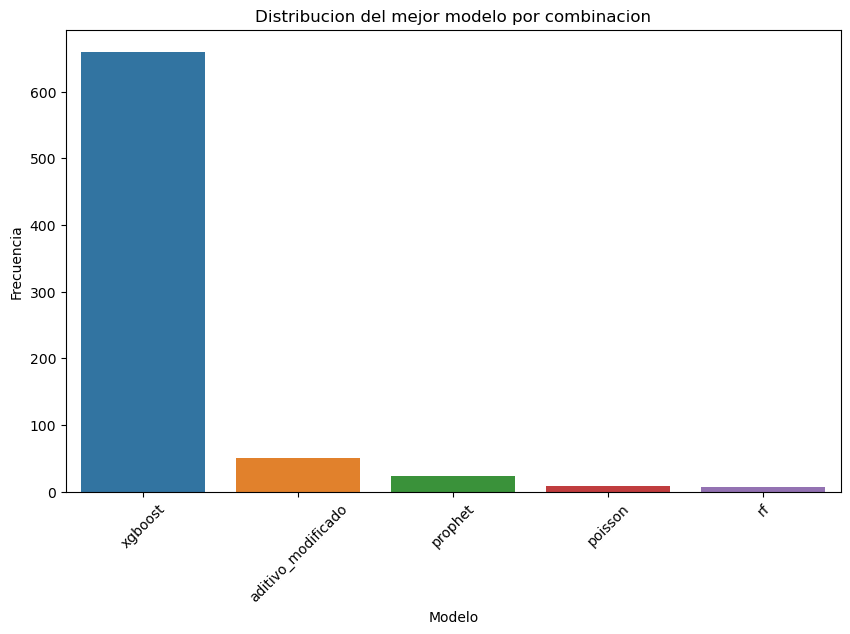

In [502]:
# Calcular la MAE promedio del mejor modelo en cada combinación almacen/sku
mae_promedio_mejor_modelo = df_resultados['best_mae'].mean().round(4)

# Calcular la MAE promedio para cada modelo en general
mae_promedio_modelos = df_resultados[['rf', 'prophet', 'xgboost', 'aditivo_modificado', 'poisson', 'aditivo_baseline']].mean().round(4)

# Análisis de moda para identificar el modelo más frecuente como el mejor
modelo_mas_frecuente = df_resultados['best_model'].mode()[0]
frecuencia_modelo_mas_frecuente = df_resultados['best_model'].value_counts().loc[modelo_mas_frecuente]

# Ordenar la MAE promedio por modelo en forma ascendente
mae_promedio_modelos = mae_promedio_modelos.sort_values()

# Mostrar resultados en tablas
print("Total de Almacenes evaluados:", sucursales_evaluar)
print("Total de SKU's evaluados:", skus_evaluar)
print()
print(f"MAE Promedio del mejor modelo para cada combinación: {mae_promedio_mejor_modelo:.4f}")
print(f"MAE promedio por modelo:\n{mae_promedio_modelos}\n")
print(f"El modelo mas votado como el mejor: {modelo_mas_frecuente} con {frecuencia_modelo_mas_frecuente} apariciones")

# Crear tabla de frecuencias
tabla_frecuencias = df_resultados['best_model'].value_counts().reset_index()
tabla_frecuencias.columns = ['Modelo', 'Frecuencia']

print(tabla_frecuencias.to_string(index=False))

# Calcular la desviación estándar de la MAE para cada modelo.
std_mae_modelos = df_resultados[['rf', 'prophet', 'xgboost', 'aditivo_modificado', 'poisson', 'aditivo_baseline']].std().round(4)
print(f"\nDesviación estándar de la MAE por modelo:\n{std_mae_modelos}\n")

# Gráfico de barras de la frecuencia del modelo más frecuente
plt.figure(figsize=(10, 6))
sns.barplot(x=tabla_frecuencias['Modelo'], y=tabla_frecuencias['Frecuencia'])
plt.title('Distribucion del mejor modelo por combinacion')
plt.xlabel('Modelo')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Añadir columnas TIPO_REGISTRO y MODELO al dataframe df
df['TIPO_REGISTRO'] = 'Venta Real'
df['MODELO'] = 'Venta Real'

predicciones = df_predicciones
resultados = df_resultados

# Añadir la columna TIPO_REGISTRO al dataframe predicciones y eliminar columnas innecesarias
predicciones['TIPO_REGISTRO'] = 'Prediccion'
predicciones = predicciones.drop(['PARAMETROS', 'LAGS'], axis=1)
predicciones = predicciones[['FECHA', 'NOMBRE_ALMACEN', 'SKU', 'CANTIDAD', 'TIPO_REGISTRO', 'MODELO']]

# Renombrar columnas en resultados para hacer la fusión
resultados = resultados.rename(columns={'almacen': 'NOMBRE_ALMACEN', 'sku': 'SKU'})

# Fusionar predicciones con resultados para obtener el mejor modelo para cada combinación de tienda y SKU
predicciones_mejor_modelo = pd.merge(left=predicciones, right=resultados, how='right', on=['NOMBRE_ALMACEN', 'SKU'])

# Añadir un TIPO_REGISTRO específico para el mejor modelo
predicciones_mejor_modelo['TIPO_REGISTRO'] = 'Mejor Modelo'

# Concatenar el dataframe original con las predicciones y las predicciones del mejor modelo
todo = pd.concat([df, predicciones, predicciones_mejor_modelo], axis=0)

# Ordenar el dataframe final
todo = todo.sort_values(['NOMBRE_ALMACEN', 'SKU', 'FECHA', 'TIPO_REGISTRO', 'MODELO'])

# Mostrar las primeras filas del dataframe final
print(todo.head())


In [23]:
output_folder = 'Resultados'
output_file = 'Resultados.csv'
output_file_2 = 'Predicciones.csv'
output_file_3 = 'Categorias por almacen.csv'
output_file_4 = 'Categorias por sku.csv'
output_file_5 = 'Real y Predicciones.csv'

# Crear la carpeta si no existe
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Ruta completa del archivo
file_path = os.path.join(output_folder, output_file)
file_path_2 = os.path.join(output_folder, output_file_2)
file_path_3 = os.path.join(output_folder, output_file_3)
file_path_4 = os.path.join(output_folder, output_file_4)
file_path_5 = os.path.join(output_folder, output_file_5)

# Guardar el DataFrame como un archivo CSV en la ruta especificada
df_resultados.to_csv(file_path, index=False)
df_predicciones.to_csv(file_path_2, index=False)
df_datos_almacen.to_csv(file_path_3, index=False)
df_datos_sku.to_csv(file_path_4, index=False)
todo.to_csv(file_path_5, index=False)

print(f'Archivos guardado en: \n{file_path}\n{file_path_2}')



Archivos guardado en: 
Resultados/Resultados.csv
Resultados/Predicciones.csv
